In [1]:
import sys  
sys.path.insert(0, '/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/')
import numpy as np
path_dir = r"/Users/../Volumes/Affiliations/"

In [2]:
import sys  
import pickle
sys.path.insert(0, '/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/')
import numpy as np
import src.utils
from src.utils import import_dta, import_tracks_dta, successful_creators_followers,\
gen_active_relations, get_fan_interactions_per_week, calculate_avg_monthly_valence,\
gen_active_relations_prob, get_fan_interactions_per_week_prob, stripplot_prob,\
reaction_probability, follower_list, filter_quantile, sample_creators_music,\
gen_outbound_creators
import datetime
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mstats
pd.plotting.register_matplotlib_converters()
import os

import src.probability_utils
from src.probability_utils import volume_analysis, valence_analysis
import math
import matplotlib.ticker as plticker
from scipy.interpolate import make_interp_spline, BSpline
import seaborn as sns
from numpy import random
from tabulate import tabulate
from IPython.display import display
from tqdm import tqdm

In [3]:
def process_date(date):
    year = date[0:4]
    week = date[6:]
    day = "1"
    date = "{}-{}-1".format(year, week)
    dt = datetime.strptime(date, "%Y-%W-%w")
    return dt

In [4]:
path_dir = r"/Users/../Volumes/Raw/"
music_before = 30
low_success = 0.25
high_success = 0.75
rank_percentiles = False

In [5]:
#we will skip comments for now

#affiliations :follows
#favoritings :likes

tracks = import_tracks_dta(path_dir, "12sample_tracks.dta");
follows_sent = import_dta(path_dir, "12sample_affiliations_sent.dta");
comments_sent = import_dta(path_dir, "12sample_comments_made.dta");
shares_sent = import_dta(path_dir, "12sample_reposts_made.dta");
likes_sent = import_dta(path_dir, "12sample_favoritings_made.dta");
messages_sent = import_dta(path_dir, "12sample_messages_sent.dta");

user_info = import_dta(path_dir, "12sample_user_infos.dta");
user_info.columns = ['user_id', 'type', 'entered_platform']
user_info_2 = import_dta(path_dir, "12sample_1st_deg_user_infos.dta");
user_info_2.columns = ['user_id', 'type', 'entered_platform']
user_info = pd.concat([user_info, user_info_2]);
user_info.drop_duplicates(subset='user_id', keep='first', inplace=True, ignore_index=False);


########
follows_received = import_dta(path_dir, "12sample_affiliations_received.dta");
comments_received = import_dta(path_dir, "12sample_comments_received.dta");
shares_received = import_dta(path_dir, "12sample_reposts_received.dta");
likes_received = import_dta(path_dir, "12sample_favoritings_received.dta");
messages_received = import_dta(path_dir, "12sample_messages_received.dta");

########
follows = import_dta(path_dir, "12sample_affiliations.dta");
comments = import_dta(path_dir, "12sample_comments.dta");
shares = import_dta(path_dir, "12sample_reposts.dta");
likes = import_dta(path_dir, "12sample_favoritings.dta");
messages = import_dta(path_dir, "12sample_messages.dta");

tracks_first_month = sample_creators_music(tracks, music_before)
mask = tracks_first_month.track_available == 1
tracks_first_month = tracks_first_month[mask]

mask = follows_received.contact_id.isin(tracks_first_month.user_id)
follows_received_30 = follows_received[mask]
followers_per_creator_60 = successful_creators_followers(follows_received_30, 60, tracks_first_month)
followers_per_creator_60_static = successful_creators_followers(follows_received_30, 60, tracks_first_month, always_same_batches = True, 
                                                        perc1 = low_success, perc2 = high_success)

%%%%%%%%%% 12sample_tracks.dta %%%%%%%%%%
(56262, 7)
%%%%%%%%%% 12sample_affiliations_sent.dta %%%%%%%%%%
(800913, 3)
%%%%%%%%%% 12sample_comments_made.dta %%%%%%%%%%
(29258, 4)
%%%%%%%%%% 12sample_reposts_made.dta %%%%%%%%%%
(179329, 4)
%%%%%%%%%% 12sample_favoritings_made.dta %%%%%%%%%%
(527701, 4)
%%%%%%%%%% 12sample_messages_sent.dta %%%%%%%%%%
(11091, 3)
%%%%%%%%%% 12sample_user_infos.dta %%%%%%%%%%
(35000, 3)
%%%%%%%%%% 12sample_1st_deg_user_infos.dta %%%%%%%%%%
(670746, 3)
%%%%%%%%%% 12sample_affiliations_received.dta %%%%%%%%%%
(432503, 3)
%%%%%%%%%% 12sample_comments_received.dta %%%%%%%%%%
(21386, 4)
%%%%%%%%%% 12sample_reposts_received.dta %%%%%%%%%%
(83013, 4)
%%%%%%%%%% 12sample_favoritings_received.dta %%%%%%%%%%
(286903, 4)
%%%%%%%%%% 12sample_messages_received.dta %%%%%%%%%%
(17364, 3)
%%%%%%%%%% 12sample_affiliations.dta %%%%%%%%%%
(1233416, 3)
%%%%%%%%%% 12sample_comments.dta %%%%%%%%%%
(50644, 4)
%%%%%%%%%% 12sample_reposts.dta %%%%%%%%%%
(262342, 4)
%%%%%%%%%% 12sam

In [6]:
d = {}
for i in range(6):
   d[str(i)] = pd.read_pickle('/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/{}.pkl'.format(i)) 
   d[str(i)]['created_at'] =  pd.to_datetime(d[str(i)]['created_at'])#.apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

In [7]:
data = pd.concat([d['0'], d['1'], d['2'], d['3'], d['4'], d['5']])

In [8]:
#data['created_at'] = pd.to_datetime(data['created_at'])

In [9]:
data.set_index('created_at', inplace = True)

In [10]:
#outdegree = data.groupby('sender_id').agg(following=('contact_id', pd.Series.nunique))
#outdegree_info = user_info_2.merge(outdegree, left_on = 'user_id', right_on = 'sender_id', how= 'left')
#outdegree_info.loc[outdegree_info.following.isnull(), 'following'] = 0 

In [11]:
#outdegree_info['decile'] = pd.qcut(outdegree_info['following'], 10, labels=False)

In [12]:
#outdegree_info.head(10)

In [13]:
#outdegree_info['decile'].value_counts()

In [14]:
actions_sent = gen_outbound_creators(follows_sent, shares_sent, likes_sent, comments_sent, tracks,
                                     messages_sent = messages_sent, filter_creators = True)
mask = actions_sent.user_id.isin(tracks_first_month.user_id.unique())
actions_sent = actions_sent[mask]

In [15]:
#filter only outbound activities before the follow is received
print('Obtaining fanbase...')
follows_received.columns = ['fan_id', 'user_id', 'date_sent']
followers = follower_list(follows_received)
actions_sent = actions_sent.merge(followers, right_on = ['user_id', 'fan_id'],
                                      left_on = ['user_id', 'fan_id'], how = 'left')

Obtaining fanbase...


In [16]:
mask = (actions_sent.date_sent < actions_sent.follower_since) | (actions_sent.follower_since.isnull())
actions_sent_non_followers =  actions_sent[mask]
actions_sent_non_followers['week_yr_date'] = actions_sent_non_followers.week_yr.apply(lambda x: process_date(x))

/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_82555/3898105865.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_non_followers['week_yr_date'] = actions_sent_non_followers.week_yr.apply(lambda x: process_date(x))


# MAB

In [17]:
def create_trials_rewards(df):
    '''
    Creates reward counts, trial counts and keys to be used in the thompson sampling function
    '''
    Sent = df.groupby('outbound_activity', as_index = True).size().to_frame(name='sent')\
    .reset_index()
    Reward = df.groupby('outbound_activity', as_index = True)\
    .agg(b_Reward = ('reward', 'sum')).reset_index()


    keys  = Sent.outbound_activity

    return np.array(Sent.sent), np.array(Reward.b_Reward), keys

In [18]:
def update_1_step(Sent, Reward):
    
    alpha = Reward + 1 
    beta = (Sent-Reward)+1

    mean = alpha/(alpha+beta)
    variance = (alpha*beta)/((alpha+beta+1)*((alpha+beta)**2))

    return np.around(mean,3), np.around(np.sqrt(variance),3)

In [19]:
def jitter(a_series, noise_reduction=1000):
    return (np.random.random(len(a_series))*a_series.std()/noise_reduction)-(a_series.std()/(2*noise_reduction))

In [270]:
def create_deciles(data):
    
    mask = (data['size']>0)
    data.loc[~mask, 'decile'] = 0 
    cutpoints = np.percentile(data[mask]['size'], np.arange(1,100,10)) 
    
    for i in range(len(cutpoints)):
        low = cutpoints[i]
        try:
            high = cutpoints[i+1]
        except:
            high = 100000
        
        mask2 = (data[mask]['size']>=low) & (data[mask]['size'] <high) & (data['size']>0)
        data.loc[mask2,'decile'] = i + 1 
    return data

In [275]:
def real_time(df, outdegree_df, interval, rank_percentiles = rank_percentiles):
    
    d = {}
    
    for user_id in df.user_id.unique():
        
        if rank_percentiles:
        
            experiment = {
             '1':{'Sent':0,'Reward':0}, 
             '2':{'Sent':0,'Reward':0},
             '3':{'Sent':0,'Reward':0},
             '4':{'Sent':0,'Reward':0},
             '5':{'Sent':0,'Reward':0}, 
             '6':{'Sent':0,'Reward':0},
             '7':{'Sent':0,'Reward':0},
             '8':{'Sent':0,'Reward':0},
             '9':{'Sent':0,'Reward':0},
             '10':{'Sent':0,'Reward':0}}
        else:
            
            experiment = {'0':{'Sent':0,'Reward':0},
             '1':{'Sent':0,'Reward':0}, 
             '2':{'Sent':0,'Reward':0},
             '3':{'Sent':0,'Reward':0},
             '4':{'Sent':0,'Reward':0},
             '5':{'Sent':0,'Reward':0}, 
             '6':{'Sent':0,'Reward':0},
             '7':{'Sent':0,'Reward':0},
             '8':{'Sent':0,'Reward':0},
             '9':{'Sent':0,'Reward':0},
             '10':{'Sent':0,'Reward':0}}
            
        if rank_percentiles:
        
            dataset_mean = pd.DataFrame({'trials':range(1,df.loc[df['user_id'] == user_id,:].shape[0]+1),                     
              '1': 0,
              '2': 0,
              '3': 0,
              '4': 0,
              '5': 0,
              '6': 0,
              '7': 0,
              '8': 0,
              '9': 0,
              '10': 0})
        
        else:
             
            dataset_mean = pd.DataFrame({'trials':range(1,df.loc[df['user_id'] == user_id,:].shape[0]+1),                      
              '0': 0,
              '1': 0,
              '2': 0,
              '3': 0,
              '4': 0,
              '5': 0,
              '6': 0,
              '7': 0,
              '8': 0,
              '9': 0,
              '10': 0}) 
            
        if rank_percentiles:    
    
            dataset_std = pd.DataFrame({'trials':range(1,df.loc[df['user_id'] == user_id,:].shape[0]+1),                       
              '1': 0,
              '2': 0,
              '3': 0,
              '4': 0,
              '5': 0,
              '6': 0,
              '7': 0,
              '8': 0,
              '9': 0,
              '10': 0}) 
        
        else:
            dataset_std = pd.DataFrame({'trials':range(1,df.loc[df['user_id'] == user_id,:].shape[0]+1),     
              '0': 0,
              '1': 0,
              '2': 0,
              '3': 0,
              '4': 0,
              '5': 0,
              '6': 0,
              '7': 0,
              '8': 0,
              '9': 0,
              '10': 0}) 
    
        d[user_id] = {'experiment': experiment,'dataset_std': dataset_std, 'dataset_mean': dataset_mean, 'j' : 0}
        

    date_l = min(df.date_sent)
    old_outdegree = outdegree_df.iloc[:
                  outdegree_df.index.values.searchsorted(np.datetime64(date_l))].groupby('sender_id', as_index = False).size()
    old_outdegree = user_info_2.merge(old_outdegree, left_on = 'user_id', right_on = 'sender_id', how= 'left')
    old_outdegree.loc[old_outdegree['size'].isnull(), 'size'] = 0
    old_outdegree = old_outdegree[['user_id', 'size', 'entered_platform']].set_index('user_id')
    mask = old_outdegree['entered_platform'] <= date_l
    if rank_percentiles:
        old_outdegree['decile'] = pd.qcut(old_outdegree.loc[mask,'size'].rank(method='first'), 10, labels=False, duplicates='drop') + 1
    else:
        old_outdegree.loc[mask, 'decile'] = create_deciles(old_outdegree.loc[mask])
    
    old_outdegree['decile'] = old_outdegree[['decile']]  
    
    for i in tqdm(range(df.shape[0])):
        
        user_id = df.iloc[i].user_id
        fan_id = df.iloc[i].fan_id
        j = d[user_id]['j']
        d[user_id]['j'] = j + 1
        
        if i%interval == 0:
            date_h = df.iloc[i,:]['date_sent']
            new_outdegree = outdegree_df.iloc[outdegree_df.index.values.searchsorted(np.datetime64(date_l)):
                  outdegree_df.index.values.searchsorted(np.datetime64(date_h))].groupby('sender_id', as_index = False).size()
        
            old_outdegree['size'] = old_outdegree['size'].add(new_outdegree.set_index('sender_id')['size'], fill_value = 0)
            mask = old_outdegree['entered_platform'] <= date_h
            if rank_percentiles:
                old_outdegree['decile'] = pd.qcut(old_outdegree.loc[mask,'size'].rank(method='first'), 10, labels=False, duplicates='drop') + 1
            else:
                old_outdegree.loc[mask, 'decile'] = create_deciles(old_outdegree.loc[mask])
            old_outdegree['decile'] = old_outdegree[['decile']]  
            date_l = date_h
            
        if i%1000 == 0:
            print(old_outdegree.decile.value_counts(normalize=True))
        
        try:
       
            d[user_id]['experiment'][str(int(old_outdegree.loc[fan_id]['decile']))]['Sent'] += 1
            d[user_id]['experiment'][str(int(old_outdegree.loc[fan_id]['decile']))]['Reward'] += df.iloc[i, -1]
            Sent = np.array([a[1]['Sent'] for a in d[user_id]['experiment'].items()])
            Reward = np.array([a[1]['Reward'] for a in d[user_id]['experiment'].items()])

            mean, std = update_1_step(Sent, Reward)

            d[user_id]['dataset_mean'].loc[j, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']] = np.transpose(mean)
            d[user_id]['dataset_std'].loc[j, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']] = np.transpose(std)

            print('.', end='')
        
        except:
            print('x', end ='')
        
    for user_id in df.user_id.unique(): 
        d[user_id]['dataset_mean'] = pd.concat([d[user_id]['dataset_mean'], df.loc[df['user_id'] == user_id].reset_index()['date_sent']], axis = 1)
        
        
    return d

# Real time updating

In [21]:
actions_sent = gen_outbound_creators(follows_sent, shares_sent, likes_sent, comments_sent, tracks,
                                     messages_sent = messages_sent, filter_creators = False)

In [22]:
mask = actions_sent.user_id.isin(tracks_first_month.user_id) 
actions_sent = actions_sent[mask]
actions_sent_filtered = actions_sent.merge(followers_per_creator_60_static, left_on = 'user_id', right_on = 'user_id', how = "inner")

In [23]:
#filter only outbound activities before the follow is received
print('Obtaining fanbase...')
follows_received.columns = ['fan_id', 'user_id', 'date_sent']
followers = follower_list(follows_received)
actions_sent_filtered = actions_sent_filtered.merge(followers, right_on = ['user_id', 'fan_id'],
                                      left_on = ['user_id', 'fan_id'], how = 'left')

mask = (actions_sent_filtered.date_sent < actions_sent_filtered.follower_since) | (actions_sent_filtered.follower_since.isnull())
actions_sent_filtered_non_followers =  actions_sent_filtered[mask]
actions_sent_filtered_non_followers['week_yr_date'] = actions_sent_filtered_non_followers.week_yr.apply(lambda x: process_date(x))

Obtaining fanbase...


/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_12381/1142436393.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_filtered_non_followers['week_yr_date'] = actions_sent_filtered_non_followers.week_yr.apply(lambda x: process_date(x))


In [24]:
mask = actions_sent_filtered_non_followers['fan_id'].isin(data.sender_id.unique())
actions_sent_filtered_non_followers = actions_sent_filtered_non_followers.loc[mask]

In [25]:
import datetime
# Target Creation
delta = datetime.timedelta(days = 7)
mask = (actions_sent_filtered_non_followers['follower_since'] <= (actions_sent_filtered_non_followers['date_sent'] + delta))

actions_sent_filtered_non_followers.loc[mask, 'reward'] = 1
mask = actions_sent_filtered_non_followers['reward'].isnull()
actions_sent_filtered_non_followers.loc[mask, 'reward'] = 0

/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_12381/2954351983.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_filtered_non_followers.loc[mask, 'reward'] = 1


In [26]:
actions_sent_filtered_non_followers.sort_values(by = 'date_sent', inplace = True)
                                                
mask = actions_sent_filtered_non_followers.high_low == 'high'
successful_df = actions_sent_filtered_non_followers[mask]

mask = actions_sent_filtered_non_followers.high_low == 'low'
unsuccessful_df = actions_sent_filtered_non_followers[mask]

/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_12381/3523808898.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actions_sent_filtered_non_followers.sort_values(by = 'date_sent', inplace = True)


In [276]:
dict_successful_df =  real_time(successful_df, data, 10)
with open('/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/dict_sucessful_df.pkl', 'wb') as handle:
    pickle.dump(dict_successful_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_12381/3450947467.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[~mask, 'decile'] = 0
  0%|                                                                                                                                  | 1/79862 [00:01<37:40:44,  1.70s/it]

0.0     0.336336
1.0     0.070811
5.0     0.070725
6.0     0.067605
8.0     0.067551
2.0     0.066736
9.0     0.066712
7.0     0.066563
4.0     0.066127
3.0     0.060964
10.0    0.059872
Name: decile, dtype: float64
..........

  0%|                                                                                                                                  | 11/79862 [00:03<6:03:42,  3.66it/s]

..........

  0%|                                                                                                                                  | 21/79862 [00:05<4:54:47,  4.51it/s]

..........

  0%|                                                                                                                                  | 31/79862 [00:06<4:26:06,  5.00it/s]

..........

  0%|                                                                                                                                  | 41/79862 [00:08<4:11:58,  5.28it/s]

..........

  0%|                                                                                                                                  | 51/79862 [00:10<4:02:58,  5.47it/s]

..........

  0%|                                                                                                                                  | 61/79862 [00:12<3:57:28,  5.60it/s]

..........

  0%|                                                                                                                                  | 71/79862 [00:13<3:58:05,  5.59it/s]

..........

  0%|▏                                                                                                                                 | 81/79862 [00:15<3:53:57,  5.68it/s]

..........

  0%|▏                                                                                                                                 | 91/79862 [00:17<3:51:11,  5.75it/s]

..........

  0%|▏                                                                                                                                | 101/79862 [00:19<3:49:20,  5.80it/s]

..........

  0%|▏                                                                                                                                | 111/79862 [00:20<3:48:22,  5.82it/s]

..........

  0%|▏                                                                                                                                | 121/79862 [00:22<3:47:33,  5.84it/s]

..........

  0%|▏                                                                                                                                | 131/79862 [00:24<3:46:48,  5.86it/s]

..........

  0%|▏                                                                                                                                | 141/79862 [00:25<3:47:43,  5.83it/s]

..........

  0%|▏                                                                                                                                | 151/79862 [00:27<3:47:22,  5.84it/s]

..........

  0%|▎                                                                                                                                | 161/79862 [00:29<3:47:00,  5.85it/s]

..........

  0%|▎                                                                                                                                | 171/79862 [00:31<3:50:50,  5.75it/s]

..........

  0%|▎                                                                                                                                | 181/79862 [00:32<3:49:19,  5.79it/s]

..........

  0%|▎                                                                                                                                | 191/79862 [00:34<3:47:58,  5.82it/s]

..........

  0%|▎                                                                                                                                | 201/79862 [00:36<3:48:06,  5.82it/s]

..........

  0%|▎                                                                                                                                | 211/79862 [00:37<3:48:55,  5.80it/s]

..........

  0%|▎                                                                                                                                | 221/79862 [00:39<3:51:33,  5.73it/s]

..........

  0%|▎                                                                                                                                | 231/79862 [00:41<3:49:44,  5.78it/s]

..........

  0%|▍                                                                                                                                | 241/79862 [00:43<3:48:26,  5.81it/s]

..........

  0%|▍                                                                                                                                | 251/79862 [00:44<3:47:22,  5.84it/s]

..........

  0%|▍                                                                                                                                | 261/79862 [00:46<3:47:40,  5.83it/s]

..........

  0%|▍                                                                                                                                | 271/79862 [00:48<3:46:46,  5.85it/s]

..........

  0%|▍                                                                                                                                | 281/79862 [00:50<3:51:21,  5.73it/s]

..........

  0%|▍                                                                                                                                | 291/79862 [00:51<3:53:42,  5.67it/s]

..........

  0%|▍                                                                                                                                | 301/79862 [00:53<3:51:07,  5.74it/s]

..........

  0%|▌                                                                                                                                | 311/79862 [00:55<3:49:11,  5.79it/s]

..........

  0%|▌                                                                                                                                | 321/79862 [00:56<3:48:19,  5.81it/s]

..........

  0%|▌                                                                                                                                | 331/79862 [00:58<3:47:21,  5.83it/s]

..........

  0%|▌                                                                                                                                | 341/79862 [01:00<3:46:22,  5.85it/s]

..........

  0%|▌                                                                                                                                | 351/79862 [01:02<3:49:24,  5.78it/s]

..........

  0%|▌                                                                                                                                | 361/79862 [01:03<3:52:57,  5.69it/s]

..........

  0%|▌                                                                                                                                | 371/79862 [01:05<3:54:36,  5.65it/s]

..........

  0%|▌                                                                                                                                | 381/79862 [01:07<3:55:12,  5.63it/s]

..........

  0%|▋                                                                                                                                | 391/79862 [01:09<3:51:46,  5.71it/s]

..........

  1%|▋                                                                                                                                | 401/79862 [01:11<3:53:23,  5.67it/s]

..........

  1%|▋                                                                                                                                | 411/79862 [01:12<3:51:20,  5.72it/s]

..........

  1%|▋                                                                                                                                | 421/79862 [01:14<3:52:50,  5.69it/s]

..........

  1%|▋                                                                                                                                | 431/79862 [01:16<3:50:29,  5.74it/s]

..........

  1%|▋                                                                                                                                | 441/79862 [01:17<3:48:50,  5.78it/s]

..........

  1%|▋                                                                                                                                | 451/79862 [01:19<3:47:40,  5.81it/s]

..........

  1%|▋                                                                                                                                | 461/79862 [01:21<3:47:08,  5.83it/s]

..........

  1%|▊                                                                                                                                | 471/79862 [01:23<3:49:49,  5.76it/s]

..........

  1%|▊                                                                                                                                | 481/79862 [01:24<3:48:41,  5.79it/s]

..........

  1%|▊                                                                                                                                | 491/79862 [01:26<3:49:07,  5.77it/s]

..........

  1%|▊                                                                                                                                | 501/79862 [01:28<3:52:27,  5.69it/s]

..........

  1%|▊                                                                                                                                | 511/79862 [01:30<3:51:18,  5.72it/s]

..........

  1%|▊                                                                                                                                | 521/79862 [01:31<3:53:11,  5.67it/s]

..........

  1%|▊                                                                                                                                | 531/79862 [01:33<3:51:10,  5.72it/s]

..........

  1%|▊                                                                                                                                | 541/79862 [01:35<3:52:58,  5.67it/s]

..........

  1%|▉                                                                                                                                | 551/79862 [01:37<3:51:35,  5.71it/s]

..........

  1%|▉                                                                                                                                | 561/79862 [01:38<3:53:41,  5.66it/s]

..........

  1%|▉                                                                                                                                | 571/79862 [01:40<3:54:32,  5.63it/s]

..........

  1%|▉                                                                                                                                | 581/79862 [01:42<3:55:17,  5.62it/s]

..........

  1%|▉                                                                                                                                | 591/79862 [01:44<3:52:54,  5.67it/s]

..........

  1%|▉                                                                                                                                | 601/79862 [01:45<3:50:52,  5.72it/s]

..........

  1%|▉                                                                                                                                | 611/79862 [01:47<3:50:43,  5.72it/s]

..........

  1%|█                                                                                                                                | 621/79862 [01:49<3:49:20,  5.76it/s]

..........

  1%|█                                                                                                                                | 631/79862 [01:51<3:53:54,  5.65it/s]

..........

  1%|█                                                                                                                                | 641/79862 [01:53<3:55:26,  5.61it/s]

..........

  1%|█                                                                                                                                | 651/79862 [01:54<3:53:32,  5.65it/s]

..........

  1%|█                                                                                                                                | 661/79862 [01:56<3:50:59,  5.71it/s]

..........

  1%|█                                                                                                                                | 671/79862 [01:58<3:49:37,  5.75it/s]

..........

  1%|█                                                                                                                                | 681/79862 [01:59<3:48:27,  5.78it/s]

..........

  1%|█                                                                                                                                | 691/79862 [02:01<3:47:11,  5.81it/s]

..........

  1%|█▏                                                                                                                               | 701/79862 [02:03<3:47:47,  5.79it/s]

..........

  1%|█▏                                                                                                                               | 711/79862 [02:05<3:48:18,  5.78it/s]

..........

  1%|█▏                                                                                                                               | 721/79862 [02:06<3:52:30,  5.67it/s]

..........

  1%|█▏                                                                                                                               | 731/79862 [02:08<3:50:45,  5.72it/s]

..........

  1%|█▏                                                                                                                               | 741/79862 [02:10<3:48:56,  5.76it/s]

..........

  1%|█▏                                                                                                                               | 751/79862 [02:12<3:47:41,  5.79it/s]

..........

  1%|█▏                                                                                                                               | 761/79862 [02:13<3:48:17,  5.77it/s]

..........

  1%|█▏                                                                                                                               | 771/79862 [02:15<3:47:35,  5.79it/s]

..........

  1%|█▎                                                                                                                               | 781/79862 [02:17<3:46:34,  5.82it/s]

..........

  1%|█▎                                                                                                                               | 791/79862 [02:18<3:46:51,  5.81it/s]

..........

  1%|█▎                                                                                                                               | 801/79862 [02:20<3:46:40,  5.81it/s]

..........

  1%|█▎                                                                                                                               | 811/79862 [02:22<3:45:51,  5.83it/s]

..........

  1%|█▎                                                                                                                               | 821/79862 [02:24<3:46:35,  5.81it/s]

..........

  1%|█▎                                                                                                                               | 831/79862 [02:25<3:50:10,  5.72it/s]

..........

  1%|█▎                                                                                                                               | 841/79862 [02:27<3:51:21,  5.69it/s]

..........

  1%|█▎                                                                                                                               | 851/79862 [02:29<3:49:57,  5.73it/s]

..........

  1%|█▍                                                                                                                               | 861/79862 [02:31<3:51:30,  5.69it/s]

..........

  1%|█▍                                                                                                                               | 871/79862 [02:33<3:53:12,  5.65it/s]

..........

  1%|█▍                                                                                                                               | 881/79862 [02:34<3:50:12,  5.72it/s]

..........

  1%|█▍                                                                                                                               | 891/79862 [02:36<3:48:03,  5.77it/s]

..........

  1%|█▍                                                                                                                               | 901/79862 [02:38<3:46:20,  5.81it/s]

..........

  1%|█▍                                                                                                                               | 911/79862 [02:39<3:45:44,  5.83it/s]

..........

  1%|█▍                                                                                                                               | 921/79862 [02:41<3:45:30,  5.83it/s]

..........

  1%|█▌                                                                                                                               | 931/79862 [02:43<3:49:08,  5.74it/s]

..........

  1%|█▌                                                                                                                               | 941/79862 [02:45<3:52:38,  5.65it/s]

..........

  1%|█▌                                                                                                                               | 951/79862 [02:46<3:53:53,  5.62it/s]

..........

  1%|█▌                                                                                                                               | 961/79862 [02:48<3:55:44,  5.58it/s]

..........

  1%|█▌                                                                                                                               | 971/79862 [02:50<3:55:47,  5.58it/s]

..........

  1%|█▌                                                                                                                               | 981/79862 [02:52<3:56:00,  5.57it/s]

..........

  1%|█▌                                                                                                                               | 991/79862 [02:54<3:56:08,  5.57it/s]

..........

  1%|█▌                                                                                                                              | 1001/79862 [02:55<3:56:27,  5.56it/s]

0.0     0.337021
1.0     0.070736
5.0     0.070658
6.0     0.067528
8.0     0.067480
2.0     0.066667
9.0     0.066631
7.0     0.066497
4.0     0.066073
3.0     0.060928
10.0    0.059781
Name: decile, dtype: float64
..........

  1%|█▌                                                                                                                              | 1011/79862 [02:57<3:56:54,  5.55it/s]

..........

  1%|█▋                                                                                                                              | 1021/79862 [02:59<3:56:20,  5.56it/s]

..........

  1%|█▋                                                                                                                              | 1031/79862 [03:01<3:56:48,  5.55it/s]

..........

  1%|█▋                                                                                                                              | 1041/79862 [03:03<3:56:00,  5.57it/s]

..........

  1%|█▋                                                                                                                              | 1051/79862 [03:04<3:56:51,  5.55it/s]

..........

  1%|█▋                                                                                                                              | 1061/79862 [03:06<3:53:22,  5.63it/s]

..........

  1%|█▋                                                                                                                              | 1071/79862 [03:08<3:55:19,  5.58it/s]

..........

  1%|█▋                                                                                                                              | 1081/79862 [03:10<3:51:51,  5.66it/s]

..........

  1%|█▋                                                                                                                              | 1091/79862 [03:11<3:50:41,  5.69it/s]

..........

  1%|█▊                                                                                                                              | 1101/79862 [03:13<3:49:11,  5.73it/s]

..........

  1%|█▊                                                                                                                              | 1111/79862 [03:15<3:47:19,  5.77it/s]

..........

  1%|█▊                                                                                                                              | 1121/79862 [03:17<3:46:37,  5.79it/s]

..........

  1%|█▊                                                                                                                              | 1131/79862 [03:18<3:45:58,  5.81it/s]

..........

  1%|█▊                                                                                                                              | 1141/79862 [03:20<3:45:14,  5.82it/s]

..........

  1%|█▊                                                                                                                              | 1151/79862 [03:22<3:44:38,  5.84it/s]

..........

  1%|█▊                                                                                                                              | 1161/79862 [03:23<3:44:18,  5.85it/s]

..........

  1%|█▉                                                                                                                              | 1171/79862 [03:25<3:46:59,  5.78it/s]

..........

  1%|█▉                                                                                                                              | 1181/79862 [03:27<3:46:20,  5.79it/s]

..........

  1%|█▉                                                                                                                              | 1191/79862 [03:29<3:45:47,  5.81it/s]

..........

  2%|█▉                                                                                                                              | 1201/79862 [03:30<3:45:49,  5.81it/s]

..........

  2%|█▉                                                                                                                              | 1211/79862 [03:32<3:45:26,  5.81it/s]

..........

  2%|█▉                                                                                                                              | 1221/79862 [03:34<3:44:37,  5.83it/s]

..........

  2%|█▉                                                                                                                              | 1231/79862 [03:35<3:43:55,  5.85it/s]

..........

  2%|█▉                                                                                                                              | 1241/79862 [03:37<3:43:17,  5.87it/s]

..........

  2%|██                                                                                                                              | 1251/79862 [03:39<3:43:54,  5.85it/s]

..........

  2%|██                                                                                                                              | 1261/79862 [03:41<3:43:29,  5.86it/s]

..........

  2%|██                                                                                                                              | 1271/79862 [03:42<3:43:52,  5.85it/s]

..........

  2%|██                                                                                                                              | 1281/79862 [03:44<3:44:02,  5.85it/s]

..........

  2%|██                                                                                                                              | 1291/79862 [03:46<3:43:34,  5.86it/s]

..........

  2%|██                                                                                                                              | 1301/79862 [03:47<3:43:46,  5.85it/s]

..........

  2%|██                                                                                                                              | 1311/79862 [03:49<3:43:40,  5.85it/s]

..........

  2%|██                                                                                                                              | 1321/79862 [03:51<3:44:01,  5.84it/s]

..........

  2%|██▏                                                                                                                             | 1331/79862 [03:53<3:44:09,  5.84it/s]

..........

  2%|██▏                                                                                                                             | 1341/79862 [03:54<3:43:51,  5.85it/s]

..........

  2%|██▏                                                                                                                             | 1351/79862 [03:56<3:44:44,  5.82it/s]

..........

  2%|██▏                                                                                                                             | 1361/79862 [03:58<3:44:27,  5.83it/s]

..........

  2%|██▏                                                                                                                             | 1371/79862 [03:59<3:44:07,  5.84it/s]

..........

  2%|██▏                                                                                                                             | 1381/79862 [04:01<3:44:17,  5.83it/s]

..........

  2%|██▏                                                                                                                             | 1391/79862 [04:03<3:44:00,  5.84it/s]

..........

  2%|██▏                                                                                                                             | 1401/79862 [04:05<3:44:45,  5.82it/s]

..........

  2%|██▎                                                                                                                             | 1411/79862 [04:06<3:45:10,  5.81it/s]

..........

  2%|██▎                                                                                                                             | 1421/79862 [04:08<3:45:25,  5.80it/s]

..........

  2%|██▎                                                                                                                             | 1431/79862 [04:10<3:47:15,  5.75it/s]

..........

  2%|██▎                                                                                                                             | 1441/79862 [04:12<3:46:39,  5.77it/s]

..........

  2%|██▎                                                                                                                             | 1451/79862 [04:13<3:45:49,  5.79it/s]

..........

  2%|██▎                                                                                                                             | 1461/79862 [04:15<3:44:49,  5.81it/s]

..........

  2%|██▎                                                                                                                             | 1471/79862 [04:17<3:43:45,  5.84it/s]

..........

  2%|██▎                                                                                                                             | 1481/79862 [04:18<3:43:13,  5.85it/s]

..........

  2%|██▍                                                                                                                             | 1491/79862 [04:20<3:43:40,  5.84it/s]

..........

  2%|██▍                                                                                                                             | 1501/79862 [04:22<3:43:40,  5.84it/s]

..........

  2%|██▍                                                                                                                             | 1511/79862 [04:23<3:43:18,  5.85it/s]

..........

  2%|██▍                                                                                                                             | 1521/79862 [04:25<3:42:26,  5.87it/s]

..........

  2%|██▍                                                                                                                             | 1531/79862 [04:27<3:42:54,  5.86it/s]

..........

  2%|██▍                                                                                                                             | 1541/79862 [04:29<3:43:07,  5.85it/s]

..........

  2%|██▍                                                                                                                             | 1551/79862 [04:30<3:43:02,  5.85it/s]

..........

  2%|██▌                                                                                                                             | 1561/79862 [04:32<3:42:17,  5.87it/s]

..........

  2%|██▌                                                                                                                             | 1571/79862 [04:34<3:41:51,  5.88it/s]

..........

  2%|██▌                                                                                                                             | 1581/79862 [04:35<3:42:27,  5.86it/s]

..........

  2%|██▌                                                                                                                             | 1591/79862 [04:37<3:42:07,  5.87it/s]

..........

  2%|██▌                                                                                                                             | 1601/79862 [04:39<3:42:45,  5.86it/s]

..........

  2%|██▌                                                                                                                             | 1611/79862 [04:41<3:42:28,  5.86it/s]

..........

  2%|██▌                                                                                                                             | 1621/79862 [04:42<3:42:43,  5.85it/s]

..........

  2%|██▌                                                                                                                             | 1631/79862 [04:44<3:42:57,  5.85it/s]

..........

  2%|██▋                                                                                                                             | 1641/79862 [04:46<3:42:30,  5.86it/s]

..........

  2%|██▋                                                                                                                             | 1651/79862 [04:47<3:42:07,  5.87it/s]

..........

  2%|██▋                                                                                                                             | 1661/79862 [04:49<3:42:23,  5.86it/s]

..........

  2%|██▋                                                                                                                             | 1671/79862 [04:51<3:42:31,  5.86it/s]

..........

  2%|██▋                                                                                                                             | 1681/79862 [04:52<3:42:24,  5.86it/s]

..........

  2%|██▋                                                                                                                             | 1691/79862 [04:54<3:42:21,  5.86it/s]

..........

  2%|██▋                                                                                                                             | 1701/79862 [04:56<3:42:35,  5.85it/s]

..........

  2%|██▋                                                                                                                             | 1711/79862 [04:58<3:42:10,  5.86it/s]

..........

  2%|██▊                                                                                                                             | 1721/79862 [04:59<3:43:10,  5.84it/s]

..........

  2%|██▊                                                                                                                             | 1731/79862 [05:01<3:43:08,  5.84it/s]

..........

  2%|██▊                                                                                                                             | 1741/79862 [05:03<3:43:01,  5.84it/s]

..........

  2%|██▊                                                                                                                             | 1751/79862 [05:04<3:42:32,  5.85it/s]

..........

  2%|██▊                                                                                                                             | 1761/79862 [05:06<3:42:33,  5.85it/s]

..........

  2%|██▊                                                                                                                             | 1771/79862 [05:08<3:41:46,  5.87it/s]

..........

  2%|██▊                                                                                                                             | 1781/79862 [05:10<3:42:17,  5.85it/s]

..........

  2%|██▊                                                                                                                             | 1791/79862 [05:11<3:42:16,  5.85it/s]

..........

  2%|██▉                                                                                                                             | 1801/79862 [05:13<3:42:00,  5.86it/s]

..........

  2%|██▉                                                                                                                             | 1811/79862 [05:15<3:42:40,  5.84it/s]

..........

  2%|██▉                                                                                                                             | 1821/79862 [05:16<3:43:13,  5.83it/s]

..........

  2%|██▉                                                                                                                             | 1831/79862 [05:18<3:42:45,  5.84it/s]

..........

  2%|██▉                                                                                                                             | 1841/79862 [05:20<3:51:49,  5.61it/s]

..........

  2%|██▉                                                                                                                             | 1851/79862 [05:22<3:49:14,  5.67it/s]

..........

  2%|██▉                                                                                                                             | 1861/79862 [05:24<3:47:46,  5.71it/s]

..........

  2%|██▉                                                                                                                             | 1871/79862 [05:25<3:47:47,  5.71it/s]

..........

  2%|███                                                                                                                             | 1881/79862 [05:27<3:46:46,  5.73it/s]

..........

  2%|███                                                                                                                             | 1891/79862 [05:29<3:45:49,  5.75it/s]

..........

  2%|███                                                                                                                             | 1901/79862 [05:31<3:47:54,  5.70it/s]

..........

  2%|███                                                                                                                             | 1911/79862 [05:32<3:46:14,  5.74it/s]

..........

  2%|███                                                                                                                             | 1921/79862 [05:34<3:45:27,  5.76it/s]

..........

  2%|███                                                                                                                             | 1931/79862 [05:36<3:44:57,  5.77it/s]

..........

  2%|███                                                                                                                             | 1941/79862 [05:37<3:43:51,  5.80it/s]

..........

  2%|███▏                                                                                                                            | 1951/79862 [05:39<3:43:29,  5.81it/s]

..........

  2%|███▏                                                                                                                            | 1961/79862 [05:41<3:43:08,  5.82it/s]

..........

  2%|███▏                                                                                                                            | 1971/79862 [05:43<3:43:34,  5.81it/s]

..........

  2%|███▏                                                                                                                            | 1981/79862 [05:44<3:43:27,  5.81it/s]

..........

  2%|███▏                                                                                                                            | 1991/79862 [05:46<3:43:18,  5.81it/s]

..........

  3%|███▏                                                                                                                            | 2001/79862 [05:48<3:42:55,  5.82it/s]

0.0     0.333101
5.0     0.070978
1.0     0.070752
7.0     0.068687
6.0     0.068086
8.0     0.066999
2.0     0.066901
9.0     0.066806
4.0     0.066496
3.0     0.061107
10.0    0.060087
Name: decile, dtype: float64
..........

  3%|███▏                                                                                                                            | 2011/79862 [05:49<3:43:06,  5.82it/s]

..........

  3%|███▏                                                                                                                            | 2021/79862 [05:51<3:43:09,  5.81it/s]

..........

  3%|███▎                                                                                                                            | 2031/79862 [05:53<3:42:03,  5.84it/s]

..........

  3%|███▎                                                                                                                            | 2041/79862 [05:55<3:41:20,  5.86it/s]

..........

  3%|███▎                                                                                                                            | 2051/79862 [05:56<3:41:45,  5.85it/s]

..........

  3%|███▎                                                                                                                            | 2061/79862 [05:58<3:41:10,  5.86it/s]

..........

  3%|███▎                                                                                                                            | 2071/79862 [06:00<3:41:05,  5.86it/s]

..........

  3%|███▎                                                                                                                            | 2081/79862 [06:01<3:41:14,  5.86it/s]

..........

  3%|███▎                                                                                                                            | 2091/79862 [06:03<3:40:38,  5.87it/s]

..........

  3%|███▎                                                                                                                            | 2101/79862 [06:05<3:40:47,  5.87it/s]

..........

  3%|███▍                                                                                                                            | 2111/79862 [06:06<3:40:50,  5.87it/s]

..........

  3%|███▍                                                                                                                            | 2121/79862 [06:08<3:40:29,  5.88it/s]

..........

  3%|███▍                                                                                                                            | 2131/79862 [06:10<3:40:10,  5.88it/s]

..........

  3%|███▍                                                                                                                            | 2141/79862 [06:12<3:40:31,  5.87it/s]

..........

  3%|███▍                                                                                                                            | 2151/79862 [06:13<3:40:17,  5.88it/s]

..........

  3%|███▍                                                                                                                            | 2161/79862 [06:15<3:40:37,  5.87it/s]

..........

  3%|███▍                                                                                                                            | 2171/79862 [06:17<3:40:04,  5.88it/s]

..........

  3%|███▍                                                                                                                            | 2181/79862 [06:18<3:40:19,  5.88it/s]

..........

  3%|███▌                                                                                                                            | 2191/79862 [06:20<3:39:51,  5.89it/s]

..........

  3%|███▌                                                                                                                            | 2201/79862 [06:22<3:39:27,  5.90it/s]

..........

  3%|███▌                                                                                                                            | 2211/79862 [06:23<3:39:15,  5.90it/s]

..........

  3%|███▌                                                                                                                            | 2221/79862 [06:25<3:39:34,  5.89it/s]

..........

  3%|███▌                                                                                                                            | 2231/79862 [06:27<3:39:50,  5.89it/s]

..........

  3%|███▌                                                                                                                            | 2241/79862 [06:29<3:40:05,  5.88it/s]

..........

  3%|███▌                                                                                                                            | 2251/79862 [06:30<3:39:32,  5.89it/s]

..........

  3%|███▌                                                                                                                            | 2261/79862 [06:32<3:39:48,  5.88it/s]

..........

  3%|███▋                                                                                                                            | 2271/79862 [06:34<3:39:16,  5.90it/s]

..........

  3%|███▋                                                                                                                            | 2281/79862 [06:35<3:39:38,  5.89it/s]

..........

  3%|███▋                                                                                                                            | 2291/79862 [06:37<3:39:58,  5.88it/s]

..........

  3%|███▋                                                                                                                            | 2301/79862 [06:39<3:39:40,  5.88it/s]

..........

  3%|███▋                                                                                                                            | 2311/79862 [06:40<3:39:07,  5.90it/s]

..........

  3%|███▋                                                                                                                            | 2321/79862 [06:42<3:38:44,  5.91it/s]

..........

  3%|███▋                                                                                                                            | 2331/79862 [06:44<3:38:31,  5.91it/s]

..........

  3%|███▊                                                                                                                            | 2341/79862 [06:46<3:38:57,  5.90it/s]

..........

  3%|███▊                                                                                                                            | 2351/79862 [06:47<3:38:49,  5.90it/s]

..........

  3%|███▊                                                                                                                            | 2361/79862 [06:49<3:38:34,  5.91it/s]

..........

  3%|███▊                                                                                                                            | 2371/79862 [06:51<3:38:44,  5.90it/s]

..........

  3%|███▊                                                                                                                            | 2381/79862 [06:52<3:39:11,  5.89it/s]

..........

  3%|███▊                                                                                                                            | 2391/79862 [06:54<3:41:08,  5.84it/s]

..........

  3%|███▊                                                                                                                            | 2401/79862 [06:56<3:40:24,  5.86it/s]

..........

  3%|███▊                                                                                                                            | 2411/79862 [06:57<3:40:01,  5.87it/s]

..........

  3%|███▉                                                                                                                            | 2421/79862 [06:59<3:40:00,  5.87it/s]

..........

  3%|███▉                                                                                                                            | 2431/79862 [07:01<3:39:34,  5.88it/s]

..........

  3%|███▉                                                                                                                            | 2441/79862 [07:03<3:39:54,  5.87it/s]

..........

  3%|███▉                                                                                                                            | 2451/79862 [07:04<3:39:35,  5.88it/s]

..........

  3%|███▉                                                                                                                            | 2461/79862 [07:06<3:39:50,  5.87it/s]

..........

  3%|███▉                                                                                                                            | 2471/79862 [07:08<3:40:00,  5.86it/s]

..........

  3%|███▉                                                                                                                            | 2481/79862 [07:09<3:39:41,  5.87it/s]

..........

  3%|███▉                                                                                                                            | 2491/79862 [07:11<3:39:45,  5.87it/s]

..........

  3%|████                                                                                                                            | 2501/79862 [07:13<3:39:30,  5.87it/s]

..........

  3%|████                                                                                                                            | 2511/79862 [07:14<3:39:36,  5.87it/s]

..........

  3%|████                                                                                                                            | 2521/79862 [07:16<3:39:04,  5.88it/s]

..........

  3%|████                                                                                                                            | 2531/79862 [07:18<3:38:47,  5.89it/s]

..........

  3%|████                                                                                                                            | 2541/79862 [07:20<3:39:18,  5.88it/s]

..........

  3%|████                                                                                                                            | 2551/79862 [07:21<3:39:33,  5.87it/s]

..........

  3%|████                                                                                                                            | 2561/79862 [07:23<3:39:07,  5.88it/s]

..........

  3%|████                                                                                                                            | 2571/79862 [07:25<3:38:54,  5.88it/s]

..........

  3%|████▏                                                                                                                           | 2581/79862 [07:26<3:40:38,  5.84it/s]

..........

  3%|████▏                                                                                                                           | 2591/79862 [07:28<3:39:56,  5.86it/s]

..........

  3%|████▏                                                                                                                           | 2601/79862 [07:30<3:39:29,  5.87it/s]

..........

  3%|████▏                                                                                                                           | 2611/79862 [07:31<3:39:08,  5.88it/s]

..........

  3%|████▏                                                                                                                           | 2621/79862 [07:33<3:39:06,  5.88it/s]

..........

  3%|████▏                                                                                                                           | 2631/79862 [07:35<3:39:12,  5.87it/s]

..........

  3%|████▏                                                                                                                           | 2641/79862 [07:37<3:38:40,  5.89it/s]

..........

  3%|████▏                                                                                                                           | 2651/79862 [07:38<3:38:58,  5.88it/s]

..........

  3%|████▎                                                                                                                           | 2661/79862 [07:40<3:38:31,  5.89it/s]

..........

  3%|████▎                                                                                                                           | 2671/79862 [07:42<3:38:40,  5.88it/s]

..........

  3%|████▎                                                                                                                           | 2681/79862 [07:43<3:38:45,  5.88it/s]

..........

  3%|████▎                                                                                                                           | 2691/79862 [07:45<3:38:31,  5.89it/s]

..........

  3%|████▎                                                                                                                           | 2701/79862 [07:47<3:38:38,  5.88it/s]

..........

  3%|████▎                                                                                                                           | 2711/79862 [07:49<3:39:35,  5.86it/s]

..........

  3%|████▎                                                                                                                           | 2721/79862 [07:50<3:39:01,  5.87it/s]

..........

  3%|████▍                                                                                                                           | 2731/79862 [07:52<3:38:27,  5.88it/s]

..........

  3%|████▍                                                                                                                           | 2741/79862 [07:54<3:39:11,  5.86it/s]

..........

  3%|████▍                                                                                                                           | 2751/79862 [07:55<3:39:09,  5.86it/s]

..........

  3%|████▍                                                                                                                           | 2761/79862 [07:57<3:39:04,  5.87it/s]

..........

  3%|████▍                                                                                                                           | 2771/79862 [07:59<3:38:58,  5.87it/s]

..........

  3%|████▍                                                                                                                           | 2781/79862 [08:00<3:38:44,  5.87it/s]

..........

  3%|████▍                                                                                                                           | 2791/79862 [08:02<3:42:28,  5.77it/s]

..........

  4%|████▍                                                                                                                           | 2801/79862 [08:04<3:41:25,  5.80it/s]

..........

  4%|████▌                                                                                                                           | 2811/79862 [08:06<3:40:39,  5.82it/s]

..........

  4%|████▌                                                                                                                           | 2821/79862 [08:07<3:40:10,  5.83it/s]

..........

  4%|████▌                                                                                                                           | 2831/79862 [08:09<3:42:57,  5.76it/s]

..........

  4%|████▌                                                                                                                           | 2841/79862 [08:11<3:41:35,  5.79it/s]

..........

  4%|████▌                                                                                                                           | 2851/79862 [08:13<3:40:06,  5.83it/s]

..........

  4%|████▌                                                                                                                           | 2861/79862 [08:14<3:39:34,  5.84it/s]

..........

  4%|████▌                                                                                                                           | 2871/79862 [08:16<3:39:15,  5.85it/s]

..........

  4%|████▌                                                                                                                           | 2881/79862 [08:18<3:39:04,  5.86it/s]

..........

  4%|████▋                                                                                                                           | 2891/79862 [08:19<3:41:35,  5.79it/s]

..........

  4%|████▋                                                                                                                           | 2901/79862 [08:21<3:41:58,  5.78it/s]

..........

  4%|████▋                                                                                                                           | 2911/79862 [08:23<3:40:27,  5.82it/s]

..........

  4%|████▋                                                                                                                           | 2921/79862 [08:25<3:39:32,  5.84it/s]

..........

  4%|████▋                                                                                                                           | 2931/79862 [08:26<3:39:33,  5.84it/s]

..........

  4%|████▋                                                                                                                           | 2941/79862 [08:28<3:38:48,  5.86it/s]

..........

  4%|████▋                                                                                                                           | 2951/79862 [08:30<3:38:47,  5.86it/s]

..........

  4%|████▋                                                                                                                           | 2961/79862 [08:31<3:38:44,  5.86it/s]

..........

  4%|████▊                                                                                                                           | 2971/79862 [08:33<3:38:38,  5.86it/s]

..........

  4%|████▊                                                                                                                           | 2981/79862 [08:35<3:38:32,  5.86it/s]

..........

  4%|████▊                                                                                                                           | 2991/79862 [08:36<3:38:33,  5.86it/s]

..........

  4%|████▊                                                                                                                           | 3001/79862 [08:38<3:41:48,  5.78it/s]

0.0     0.333661
5.0     0.070916
1.0     0.070705
7.0     0.068625
6.0     0.068043
8.0     0.066956
2.0     0.066861
9.0     0.066715
4.0     0.066436
3.0     0.061082
10.0    0.060001
Name: decile, dtype: float64
..........

  4%|████▊                                                                                                                           | 3011/79862 [08:40<3:43:37,  5.73it/s]

..........

  4%|████▊                                                                                                                           | 3021/79862 [08:42<3:45:05,  5.69it/s]

..........

  4%|████▊                                                                                                                           | 3031/79862 [08:44<3:45:42,  5.67it/s]

..........

  4%|████▊                                                                                                                           | 3041/79862 [08:45<3:45:30,  5.68it/s]

..........

  4%|████▉                                                                                                                           | 3051/79862 [08:47<3:47:09,  5.64it/s]

..........

  4%|████▉                                                                                                                           | 3061/79862 [08:49<3:43:56,  5.72it/s]

..........

  4%|████▉                                                                                                                           | 3071/79862 [08:51<3:41:46,  5.77it/s]

..........

  4%|████▉                                                                                                                           | 3081/79862 [08:52<3:40:09,  5.81it/s]

..........

  4%|████▉                                                                                                                           | 3091/79862 [08:54<3:38:59,  5.84it/s]

..........

  4%|████▉                                                                                                                           | 3101/79862 [08:56<3:38:20,  5.86it/s]

..........

  4%|████▉                                                                                                                           | 3111/79862 [08:57<3:37:42,  5.88it/s]

..........

  4%|█████                                                                                                                           | 3121/79862 [08:59<3:37:49,  5.87it/s]

..........

  4%|█████                                                                                                                           | 3131/79862 [09:01<3:41:08,  5.78it/s]

..........

  4%|█████                                                                                                                           | 3141/79862 [09:03<3:40:34,  5.80it/s]

..........

  4%|█████                                                                                                                           | 3151/79862 [09:04<3:39:50,  5.82it/s]

..........

  4%|█████                                                                                                                           | 3161/79862 [09:06<3:39:10,  5.83it/s]

..........

  4%|█████                                                                                                                           | 3171/79862 [09:08<3:38:19,  5.85it/s]

..........

  4%|█████                                                                                                                           | 3181/79862 [09:09<3:37:42,  5.87it/s]

..........

  4%|█████                                                                                                                           | 3191/79862 [09:11<3:41:04,  5.78it/s]

..........

  4%|█████▏                                                                                                                          | 3201/79862 [09:13<3:43:28,  5.72it/s]

..........

  4%|█████▏                                                                                                                          | 3211/79862 [09:15<3:45:02,  5.68it/s]

..........

  4%|█████▏                                                                                                                          | 3221/79862 [09:16<3:45:30,  5.66it/s]

..........

  4%|█████▏                                                                                                                          | 3231/79862 [09:18<3:46:05,  5.65it/s]

..........

  4%|█████▏                                                                                                                          | 3241/79862 [09:20<3:46:48,  5.63it/s]

..........

  4%|█████▏                                                                                                                          | 3251/79862 [09:22<3:43:51,  5.70it/s]

..........

  4%|█████▏                                                                                                                          | 3261/79862 [09:23<3:41:45,  5.76it/s]

..........

  4%|█████▏                                                                                                                          | 3271/79862 [09:25<3:43:52,  5.70it/s]

..........

  4%|█████▎                                                                                                                          | 3281/79862 [09:27<3:46:25,  5.64it/s]

..........

  4%|█████▎                                                                                                                          | 3291/79862 [09:29<3:44:06,  5.69it/s]

..........

  4%|█████▎                                                                                                                          | 3301/79862 [09:30<3:41:43,  5.76it/s]

..........

  4%|█████▎                                                                                                                          | 3311/79862 [09:32<3:39:56,  5.80it/s]

..........

  4%|█████▎                                                                                                                          | 3321/79862 [09:34<3:38:48,  5.83it/s]

..........

  4%|█████▎                                                                                                                          | 3331/79862 [09:36<3:38:15,  5.84it/s]

..........

  4%|█████▎                                                                                                                          | 3341/79862 [09:37<3:37:41,  5.86it/s]

..........

  4%|█████▎                                                                                                                          | 3351/79862 [09:39<3:37:09,  5.87it/s]

..........

  4%|█████▍                                                                                                                          | 3361/79862 [09:41<3:36:41,  5.88it/s]

..........

  4%|█████▍                                                                                                                          | 3371/79862 [09:42<3:36:41,  5.88it/s]

..........

  4%|█████▍                                                                                                                          | 3381/79862 [09:44<3:36:22,  5.89it/s]

..........

  4%|█████▍                                                                                                                          | 3391/79862 [09:46<3:39:47,  5.80it/s]

..........

  4%|█████▍                                                                                                                          | 3401/79862 [09:48<3:39:00,  5.82it/s]

..........

  4%|█████▍                                                                                                                          | 3411/79862 [09:49<3:38:04,  5.84it/s]

..........

  4%|█████▍                                                                                                                          | 3421/79862 [09:51<3:40:27,  5.78it/s]

..........

  4%|█████▍                                                                                                                          | 3431/79862 [09:53<3:39:04,  5.81it/s]

..........

  4%|█████▌                                                                                                                          | 3441/79862 [09:54<3:38:00,  5.84it/s]

..........

  4%|█████▌                                                                                                                          | 3451/79862 [09:56<3:37:46,  5.85it/s]

..........

  4%|█████▌                                                                                                                          | 3461/79862 [09:58<3:40:24,  5.78it/s]

..........

  4%|█████▌                                                                                                                          | 3471/79862 [10:00<3:38:55,  5.82it/s]

..........

  4%|█████▌                                                                                                                          | 3481/79862 [10:01<3:40:54,  5.76it/s]

..........

  4%|█████▌                                                                                                                          | 3491/79862 [10:03<3:39:15,  5.81it/s]

..........

  4%|█████▌                                                                                                                          | 3501/79862 [10:05<3:38:10,  5.83it/s]

..........

  4%|█████▋                                                                                                                          | 3511/79862 [10:06<3:37:19,  5.86it/s]

..........

  4%|█████▋                                                                                                                          | 3521/79862 [10:08<3:36:46,  5.87it/s]

..........

  4%|█████▋                                                                                                                          | 3531/79862 [10:10<3:36:26,  5.88it/s]

..........

  4%|█████▋                                                                                                                          | 3541/79862 [10:12<3:36:08,  5.89it/s]

..........

  4%|█████▋                                                                                                                          | 3551/79862 [10:13<3:36:19,  5.88it/s]

..........

  4%|█████▋                                                                                                                          | 3561/79862 [10:15<3:36:01,  5.89it/s]

..........

  4%|█████▋                                                                                                                          | 3571/79862 [10:17<3:35:44,  5.89it/s]

..........

  4%|█████▋                                                                                                                          | 3581/79862 [10:18<3:36:01,  5.89it/s]

..........

  4%|█████▊                                                                                                                          | 3591/79862 [10:20<3:36:13,  5.88it/s]

..........

  5%|█████▊                                                                                                                          | 3601/79862 [10:22<3:36:26,  5.87it/s]

..........

  5%|█████▊                                                                                                                          | 3611/79862 [10:24<3:39:46,  5.78it/s]

..........

  5%|█████▊                                                                                                                          | 3621/79862 [10:25<3:38:45,  5.81it/s]

..........

  5%|█████▊                                                                                                                          | 3631/79862 [10:27<3:40:56,  5.75it/s]

..........

  5%|█████▊                                                                                                                          | 3641/79862 [10:29<3:39:19,  5.79it/s]

..........

  5%|█████▊                                                                                                                          | 3651/79862 [10:30<3:41:43,  5.73it/s]

..........

  5%|█████▊                                                                                                                          | 3661/79862 [10:32<3:40:38,  5.76it/s]

..........

  5%|█████▉                                                                                                                          | 3671/79862 [10:34<3:38:55,  5.80it/s]

..........

  5%|█████▉                                                                                                                          | 3681/79862 [10:36<3:37:44,  5.83it/s]

..........

  5%|█████▉                                                                                                                          | 3691/79862 [10:37<3:36:54,  5.85it/s]

..........

  5%|█████▉                                                                                                                          | 3701/79862 [10:39<3:36:09,  5.87it/s]

..........

  5%|█████▉                                                                                                                          | 3711/79862 [10:41<3:36:14,  5.87it/s]

..........

  5%|█████▉                                                                                                                          | 3721/79862 [10:42<3:35:53,  5.88it/s]

..........

  5%|█████▉                                                                                                                          | 3731/79862 [10:44<3:35:37,  5.88it/s]

..........

  5%|█████▉                                                                                                                          | 3741/79862 [10:46<3:35:23,  5.89it/s]

..........

  5%|██████                                                                                                                          | 3751/79862 [10:47<3:35:05,  5.90it/s]

..........

  5%|██████                                                                                                                          | 3761/79862 [10:49<3:35:23,  5.89it/s]

..........

  5%|██████                                                                                                                          | 3771/79862 [10:51<3:35:10,  5.89it/s]

..........

  5%|██████                                                                                                                          | 3781/79862 [10:53<3:35:29,  5.88it/s]

..........

  5%|██████                                                                                                                          | 3791/79862 [10:54<3:35:38,  5.88it/s]

..........

  5%|██████                                                                                                                          | 3801/79862 [10:56<3:35:16,  5.89it/s]

..........

  5%|██████                                                                                                                          | 3811/79862 [10:58<3:34:57,  5.90it/s]

..........

  5%|██████                                                                                                                          | 3821/79862 [10:59<3:34:46,  5.90it/s]

..........

  5%|██████▏                                                                                                                         | 3831/79862 [11:01<3:35:09,  5.89it/s]

..........

  5%|██████▏                                                                                                                         | 3841/79862 [11:03<3:35:23,  5.88it/s]

..........

  5%|██████▏                                                                                                                         | 3851/79862 [11:04<3:35:08,  5.89it/s]

..........

  5%|██████▏                                                                                                                         | 3861/79862 [11:06<3:38:55,  5.79it/s]

..........

  5%|██████▏                                                                                                                         | 3871/79862 [11:08<3:41:18,  5.72it/s]

..........

  5%|██████▏                                                                                                                         | 3881/79862 [11:10<3:39:37,  5.77it/s]

..........

  5%|██████▏                                                                                                                         | 3891/79862 [11:11<3:38:41,  5.79it/s]

..........

  5%|██████▎                                                                                                                         | 3901/79862 [11:13<3:37:54,  5.81it/s]

..........

  5%|██████▎                                                                                                                         | 3911/79862 [11:15<3:36:45,  5.84it/s]

..........

  5%|██████▎                                                                                                                         | 3921/79862 [11:17<3:36:26,  5.85it/s]

..........

  5%|██████▎                                                                                                                         | 3931/79862 [11:18<3:36:19,  5.85it/s]

..........

  5%|██████▎                                                                                                                         | 3941/79862 [11:20<3:36:15,  5.85it/s]

..........

  5%|██████▎                                                                                                                         | 3951/79862 [11:22<3:35:44,  5.86it/s]

..........

  5%|██████▎                                                                                                                         | 3961/79862 [11:23<3:38:45,  5.78it/s]

..........

  5%|██████▎                                                                                                                         | 3971/79862 [11:25<3:37:47,  5.81it/s]

..........

  5%|██████▍                                                                                                                         | 3981/79862 [11:27<3:36:42,  5.84it/s]

..........

  5%|██████▍                                                                                                                         | 3991/79862 [11:29<3:35:57,  5.86it/s]

..........

  5%|██████▍                                                                                                                         | 4001/79862 [11:30<3:36:08,  5.85it/s]

0.0     0.333880
5.0     0.070896
1.0     0.070685
7.0     0.068604
6.0     0.068028
8.0     0.066953
2.0     0.066841
9.0     0.066674
4.0     0.066401
3.0     0.061066
10.0    0.059970
Name: decile, dtype: float64
..........

  5%|██████▍                                                                                                                         | 4011/79862 [11:32<3:35:41,  5.86it/s]

..........

  5%|██████▍                                                                                                                         | 4021/79862 [11:34<3:35:15,  5.87it/s]

..........

  5%|██████▍                                                                                                                         | 4031/79862 [11:35<3:34:56,  5.88it/s]

..........

  5%|██████▍                                                                                                                         | 4041/79862 [11:37<3:35:14,  5.87it/s]

..........

  5%|██████▍                                                                                                                         | 4051/79862 [11:39<3:35:21,  5.87it/s]

..........

  5%|██████▌                                                                                                                         | 4061/79862 [11:40<3:35:29,  5.86it/s]

..........

  5%|██████▌                                                                                                                         | 4071/79862 [11:42<3:38:44,  5.77it/s]

..........

  5%|██████▌                                                                                                                         | 4081/79862 [11:44<3:37:22,  5.81it/s]

..........

  5%|██████▌                                                                                                                         | 4091/79862 [11:46<3:36:21,  5.84it/s]

..........

  5%|██████▌                                                                                                                         | 4101/79862 [11:47<3:36:56,  5.82it/s]

..........

  5%|██████▌                                                                                                                         | 4111/79862 [11:49<3:37:05,  5.82it/s]

..........

  5%|██████▌                                                                                                                         | 4121/79862 [11:51<3:39:15,  5.76it/s]

..........

  5%|██████▌                                                                                                                         | 4131/79862 [11:53<3:37:38,  5.80it/s]

..........

  5%|██████▋                                                                                                                         | 4141/79862 [11:54<3:37:02,  5.81it/s]

..........

  5%|██████▋                                                                                                                         | 4151/79862 [11:56<3:35:52,  5.85it/s]

..........

  5%|██████▋                                                                                                                         | 4161/79862 [11:58<3:35:13,  5.86it/s]

..........

  5%|██████▋                                                                                                                         | 4171/79862 [11:59<3:37:50,  5.79it/s]

..........

  5%|██████▋                                                                                                                         | 4181/79862 [12:01<3:36:25,  5.83it/s]

..........

  5%|██████▋                                                                                                                         | 4191/79862 [12:03<3:36:04,  5.84it/s]

..........

  5%|██████▋                                                                                                                         | 4201/79862 [12:05<3:39:24,  5.75it/s]

..........

  5%|██████▋                                                                                                                         | 4211/79862 [12:06<3:41:19,  5.70it/s]

..........

  5%|██████▊                                                                                                                         | 4221/79862 [12:08<3:39:05,  5.75it/s]

..........

  5%|██████▊                                                                                                                         | 4231/79862 [12:10<3:37:48,  5.79it/s]

..........

  5%|██████▊                                                                                                                         | 4241/79862 [12:12<3:36:38,  5.82it/s]

..........

  5%|██████▊                                                                                                                         | 4251/79862 [12:13<3:36:09,  5.83it/s]

..........

  5%|██████▊                                                                                                                         | 4261/79862 [12:15<3:39:36,  5.74it/s]

..........

  5%|██████▊                                                                                                                         | 4271/79862 [12:17<3:37:57,  5.78it/s]

..........

  5%|██████▊                                                                                                                         | 4281/79862 [12:19<3:40:47,  5.71it/s]

..........

  5%|██████▉                                                                                                                         | 4291/79862 [12:20<3:42:31,  5.66it/s]

..........

  5%|██████▉                                                                                                                         | 4301/79862 [12:22<3:43:12,  5.64it/s]

..........

  5%|██████▉                                                                                                                         | 4311/79862 [12:24<3:40:18,  5.72it/s]

..........

  5%|██████▉                                                                                                                         | 4321/79862 [12:26<3:38:26,  5.76it/s]

..........

  5%|██████▉                                                                                                                         | 4331/79862 [12:27<3:37:24,  5.79it/s]

..........

  5%|██████▉                                                                                                                         | 4341/79862 [12:29<3:36:41,  5.81it/s]

..........

  5%|██████▉                                                                                                                         | 4351/79862 [12:31<3:35:40,  5.84it/s]

..........

  5%|██████▉                                                                                                                         | 4361/79862 [12:32<3:35:04,  5.85it/s]

..........

  5%|███████                                                                                                                         | 4371/79862 [12:34<3:35:06,  5.85it/s]

..........

  5%|███████                                                                                                                         | 4381/79862 [12:36<3:34:36,  5.86it/s]

..........

  5%|███████                                                                                                                         | 4391/79862 [12:37<3:34:12,  5.87it/s]

..........

  6%|███████                                                                                                                         | 4401/79862 [12:39<3:34:24,  5.87it/s]

..........

  6%|███████                                                                                                                         | 4411/79862 [12:41<3:37:21,  5.79it/s]

..........

  6%|███████                                                                                                                         | 4421/79862 [12:43<3:39:29,  5.73it/s]

..........

  6%|███████                                                                                                                         | 4431/79862 [12:44<3:37:34,  5.78it/s]

..........

  6%|███████                                                                                                                         | 4441/79862 [12:46<3:39:58,  5.71it/s]

..........

  6%|███████▏                                                                                                                        | 4451/79862 [12:48<3:41:23,  5.68it/s]

..........

  6%|███████▏                                                                                                                        | 4461/79862 [12:50<3:42:17,  5.65it/s]

..........

  6%|███████▏                                                                                                                        | 4471/79862 [12:52<3:43:30,  5.62it/s]

..........

  6%|███████▏                                                                                                                        | 4481/79862 [12:53<3:44:00,  5.61it/s]

..........

  6%|███████▏                                                                                                                        | 4491/79862 [12:55<3:40:44,  5.69it/s]

..........

  6%|███████▏                                                                                                                        | 4501/79862 [12:57<3:38:29,  5.75it/s]

..........

  6%|███████▏                                                                                                                        | 4511/79862 [12:58<3:36:50,  5.79it/s]

..........

  6%|███████▏                                                                                                                        | 4521/79862 [13:00<3:35:38,  5.82it/s]

..........

  6%|███████▎                                                                                                                        | 4531/79862 [13:02<3:38:11,  5.75it/s]

..........

  6%|███████▎                                                                                                                        | 4541/79862 [13:04<3:36:34,  5.80it/s]

..........

  6%|███████▎                                                                                                                        | 4551/79862 [13:05<3:36:02,  5.81it/s]

..........

  6%|███████▎                                                                                                                        | 4561/79862 [13:07<3:38:32,  5.74it/s]

..........

  6%|███████▎                                                                                                                        | 4571/79862 [13:09<3:36:53,  5.79it/s]

..........

  6%|███████▎                                                                                                                        | 4581/79862 [13:11<3:36:09,  5.80it/s]

..........

  6%|███████▎                                                                                                                        | 4591/79862 [13:12<3:35:46,  5.81it/s]

..........

  6%|███████▎                                                                                                                        | 4601/79862 [13:14<3:34:51,  5.84it/s]

..........

  6%|███████▍                                                                                                                        | 4611/79862 [13:16<3:34:37,  5.84it/s]

..........

  6%|███████▍                                                                                                                        | 4621/79862 [13:17<3:34:02,  5.86it/s]

..........

  6%|███████▍                                                                                                                        | 4631/79862 [13:19<3:33:32,  5.87it/s]

..........

  6%|███████▍                                                                                                                        | 4641/79862 [13:21<3:33:22,  5.88it/s]

..........

  6%|███████▍                                                                                                                        | 4651/79862 [13:22<3:33:11,  5.88it/s]

..........

  6%|███████▍                                                                                                                        | 4661/79862 [13:24<3:33:35,  5.87it/s]

..........

  6%|███████▍                                                                                                                        | 4671/79862 [13:26<3:33:46,  5.86it/s]

..........

  6%|███████▌                                                                                                                        | 4681/79862 [13:28<3:33:26,  5.87it/s]

..........

  6%|███████▌                                                                                                                        | 4691/79862 [13:29<3:36:44,  5.78it/s]

..........

  6%|███████▌                                                                                                                        | 4701/79862 [13:31<3:39:08,  5.72it/s]

..........

  6%|███████▌                                                                                                                        | 4711/79862 [13:33<3:40:44,  5.67it/s]

..........

  6%|███████▌                                                                                                                        | 4721/79862 [13:35<3:38:43,  5.73it/s]

..........

  6%|███████▌                                                                                                                        | 4731/79862 [13:36<3:37:27,  5.76it/s]

..........

  6%|███████▌                                                                                                                        | 4741/79862 [13:38<3:39:26,  5.71it/s]

..........

  6%|███████▌                                                                                                                        | 4751/79862 [13:40<3:37:53,  5.75it/s]

..........

  6%|███████▋                                                                                                                        | 4761/79862 [13:42<3:36:21,  5.79it/s]

..........

  6%|███████▋                                                                                                                        | 4771/79862 [13:43<3:36:08,  5.79it/s]

..........

  6%|███████▋                                                                                                                        | 4781/79862 [13:45<3:39:27,  5.70it/s]

..........

  6%|███████▋                                                                                                                        | 4791/79862 [13:47<3:37:15,  5.76it/s]

..........

  6%|███████▋                                                                                                                        | 4801/79862 [13:49<3:38:49,  5.72it/s]

..........

  6%|███████▋                                                                                                                        | 4811/79862 [13:50<3:38:40,  5.72it/s]

..........

  6%|███████▋                                                                                                                        | 4821/79862 [13:52<3:39:57,  5.69it/s]

..........

  6%|███████▋                                                                                                                        | 4831/79862 [13:54<3:40:52,  5.66it/s]

..........

  6%|███████▊                                                                                                                        | 4841/79862 [13:56<3:38:40,  5.72it/s]

..........

  6%|███████▊                                                                                                                        | 4851/79862 [13:57<3:39:53,  5.69it/s]

..........

  6%|███████▊                                                                                                                        | 4861/79862 [13:59<3:37:45,  5.74it/s]

..........

  6%|███████▊                                                                                                                        | 4871/79862 [14:01<3:36:12,  5.78it/s]

..........

  6%|███████▊                                                                                                                        | 4881/79862 [14:03<3:35:31,  5.80it/s]

..........

  6%|███████▊                                                                                                                        | 4891/79862 [14:04<3:35:01,  5.81it/s]

..........

  6%|███████▊                                                                                                                        | 4901/79862 [14:06<3:34:05,  5.84it/s]

..........

  6%|███████▊                                                                                                                        | 4911/79862 [14:08<3:33:18,  5.86it/s]

..........

  6%|███████▉                                                                                                                        | 4921/79862 [14:09<3:32:48,  5.87it/s]

..........

  6%|███████▉                                                                                                                        | 4931/79862 [14:11<3:33:03,  5.86it/s]

..........

  6%|███████▉                                                                                                                        | 4941/79862 [14:13<3:32:42,  5.87it/s]

..........

  6%|███████▉                                                                                                                        | 4951/79862 [14:14<3:32:22,  5.88it/s]

..........

  6%|███████▉                                                                                                                        | 4961/79862 [14:16<3:32:38,  5.87it/s]

..........

  6%|███████▉                                                                                                                        | 4971/79862 [14:18<3:33:10,  5.86it/s]

..........

  6%|███████▉                                                                                                                        | 4981/79862 [14:20<3:33:17,  5.85it/s]

..........

  6%|███████▉                                                                                                                        | 4991/79862 [14:21<3:34:20,  5.82it/s]

..........

  6%|████████                                                                                                                        | 5001/79862 [14:23<3:34:43,  5.81it/s]

0.0     0.334004
5.0     0.070886
1.0     0.070670
7.0     0.068589
6.0     0.068013
8.0     0.066939
2.0     0.066832
9.0     0.066660
4.0     0.066393
3.0     0.061060
10.0    0.059953
Name: decile, dtype: float64
..........

  6%|████████                                                                                                                        | 5011/79862 [14:25<3:37:29,  5.74it/s]

..........

  6%|████████                                                                                                                        | 5021/79862 [14:27<3:35:42,  5.78it/s]

..........

  6%|████████                                                                                                                        | 5031/79862 [14:28<3:34:59,  5.80it/s]

..........

  6%|████████                                                                                                                        | 5041/79862 [14:30<3:37:33,  5.73it/s]

..........

  6%|████████                                                                                                                        | 5051/79862 [14:32<3:39:39,  5.68it/s]

..........

  6%|████████                                                                                                                        | 5061/79862 [14:34<3:40:59,  5.64it/s]

..........

  6%|████████▏                                                                                                                       | 5071/79862 [14:35<3:38:43,  5.70it/s]

..........

  6%|████████▏                                                                                                                       | 5081/79862 [14:37<3:37:22,  5.73it/s]

..........

  6%|████████▏                                                                                                                       | 5091/79862 [14:39<3:39:02,  5.69it/s]

..........

  6%|████████▏                                                                                                                       | 5101/79862 [14:41<3:40:17,  5.66it/s]

..........

  6%|████████▏                                                                                                                       | 5111/79862 [14:42<3:40:51,  5.64it/s]

..........

  6%|████████▏                                                                                                                       | 5121/79862 [14:44<3:41:56,  5.61it/s]

..........

  6%|████████▏                                                                                                                       | 5131/79862 [14:46<3:38:46,  5.69it/s]

..........

  6%|████████▏                                                                                                                       | 5141/79862 [14:48<3:40:04,  5.66it/s]

..........

  6%|████████▎                                                                                                                       | 5151/79862 [14:50<3:41:02,  5.63it/s]

..........

  6%|████████▎                                                                                                                       | 5161/79862 [14:51<3:38:33,  5.70it/s]

..........

  6%|████████▎                                                                                                                       | 5171/79862 [14:53<3:36:56,  5.74it/s]

..........

  6%|████████▎                                                                                                                       | 5181/79862 [14:55<3:35:44,  5.77it/s]

..........

  6%|████████▎                                                                                                                       | 5191/79862 [14:56<3:34:53,  5.79it/s]

..........

  7%|████████▎                                                                                                                       | 5201/79862 [14:58<3:34:24,  5.80it/s]

..........

  7%|████████▎                                                                                                                       | 5211/79862 [15:00<3:33:42,  5.82it/s]

..........

  7%|████████▎                                                                                                                       | 5221/79862 [15:02<3:36:31,  5.75it/s]

..........

  7%|████████▍                                                                                                                       | 5231/79862 [15:03<3:39:09,  5.68it/s]

..........

  7%|████████▍                                                                                                                       | 5241/79862 [15:05<3:36:47,  5.74it/s]

..........

  7%|████████▍                                                                                                                       | 5251/79862 [15:07<3:35:03,  5.78it/s]

..........

  7%|████████▍                                                                                                                       | 5261/79862 [15:08<3:34:21,  5.80it/s]

..........

  7%|████████▍                                                                                                                       | 5271/79862 [15:10<3:33:20,  5.83it/s]

..........

  7%|████████▍                                                                                                                       | 5281/79862 [15:12<3:32:38,  5.85it/s]

..........

  7%|████████▍                                                                                                                       | 5291/79862 [15:14<3:32:32,  5.85it/s]

..........

  7%|████████▍                                                                                                                       | 5301/79862 [15:15<3:35:40,  5.76it/s]

..........

  7%|████████▌                                                                                                                       | 5311/79862 [15:17<3:38:03,  5.70it/s]

..........

  7%|████████▌                                                                                                                       | 5321/79862 [15:19<3:36:22,  5.74it/s]

..........

  7%|████████▌                                                                                                                       | 5331/79862 [15:21<3:38:22,  5.69it/s]

..........

  7%|████████▌                                                                                                                       | 5341/79862 [15:23<3:40:21,  5.64it/s]

..........

  7%|████████▌                                                                                                                       | 5351/79862 [15:24<3:41:11,  5.61it/s]

..........

  7%|████████▌                                                                                                                       | 5361/79862 [15:26<3:38:27,  5.68it/s]

..........

  7%|████████▌                                                                                                                       | 5371/79862 [15:28<3:36:01,  5.75it/s]

..........

  7%|████████▌                                                                                                                       | 5381/79862 [15:29<3:34:53,  5.78it/s]

..........

  7%|████████▋                                                                                                                       | 5391/79862 [15:31<3:34:07,  5.80it/s]

..........

  7%|████████▋                                                                                                                       | 5401/79862 [15:33<3:33:29,  5.81it/s]

..........

  7%|████████▋                                                                                                                       | 5411/79862 [15:35<3:33:02,  5.82it/s]

..........

  7%|████████▋                                                                                                                       | 5421/79862 [15:36<3:35:40,  5.75it/s]

..........

  7%|████████▋                                                                                                                       | 5431/79862 [15:38<3:37:29,  5.70it/s]

..........

  7%|████████▋                                                                                                                       | 5441/79862 [15:40<3:38:47,  5.67it/s]

..........

  7%|████████▋                                                                                                                       | 5451/79862 [15:42<3:40:01,  5.64it/s]

..........

  7%|████████▊                                                                                                                       | 5461/79862 [15:44<3:41:02,  5.61it/s]

..........

  7%|████████▊                                                                                                                       | 5471/79862 [15:45<3:38:22,  5.68it/s]

..........

  7%|████████▊                                                                                                                       | 5481/79862 [15:47<3:36:35,  5.72it/s]

..........

  7%|████████▊                                                                                                                       | 5491/79862 [15:49<3:34:31,  5.78it/s]

..........

  7%|████████▊                                                                                                                       | 5501/79862 [15:50<3:33:19,  5.81it/s]

..........

  7%|████████▊                                                                                                                       | 5511/79862 [15:52<3:34:48,  5.77it/s]

..........

  7%|████████▊                                                                                                                       | 5521/79862 [15:54<3:33:28,  5.80it/s]

..........

  7%|████████▊                                                                                                                       | 5531/79862 [15:56<3:36:08,  5.73it/s]

..........

  7%|████████▉                                                                                                                       | 5541/79862 [15:57<3:37:30,  5.70it/s]

..........

  7%|████████▉                                                                                                                       | 5551/79862 [15:59<3:39:08,  5.65it/s]

..........

  7%|████████▉                                                                                                                       | 5561/79862 [16:01<3:39:40,  5.64it/s]

..........

  7%|████████▉                                                                                                                       | 5571/79862 [16:03<3:40:15,  5.62it/s]

..........

  7%|████████▉                                                                                                                       | 5581/79862 [16:05<3:40:36,  5.61it/s]

..........

  7%|████████▉                                                                                                                       | 5591/79862 [16:06<3:41:20,  5.59it/s]

..........

  7%|████████▉                                                                                                                       | 5601/79862 [16:08<3:41:36,  5.58it/s]

..........

  7%|████████▉                                                                                                                       | 5611/79862 [16:10<3:38:21,  5.67it/s]

..........

  7%|█████████                                                                                                                       | 5621/79862 [16:12<3:36:20,  5.72it/s]

..........

  7%|█████████                                                                                                                       | 5631/79862 [16:13<3:34:27,  5.77it/s]

..........

  7%|█████████                                                                                                                       | 5641/79862 [16:15<3:33:36,  5.79it/s]

..........

  7%|█████████                                                                                                                       | 5651/79862 [16:17<3:32:58,  5.81it/s]

..........

  7%|█████████                                                                                                                       | 5661/79862 [16:18<3:36:06,  5.72it/s]

..........

  7%|█████████                                                                                                                       | 5671/79862 [16:20<3:37:33,  5.68it/s]

..........

  7%|█████████                                                                                                                       | 5681/79862 [16:22<3:35:17,  5.74it/s]

..........

  7%|█████████                                                                                                                       | 5691/79862 [16:24<3:37:09,  5.69it/s]

..........

  7%|█████████▏                                                                                                                      | 5701/79862 [16:26<3:38:16,  5.66it/s]

..........

  7%|█████████▏                                                                                                                      | 5711/79862 [16:27<3:39:03,  5.64it/s]

..........

  7%|█████████▏                                                                                                                      | 5721/79862 [16:29<3:39:52,  5.62it/s]

..........

  7%|█████████▏                                                                                                                      | 5731/79862 [16:31<3:37:26,  5.68it/s]

..........

  7%|█████████▏                                                                                                                      | 5741/79862 [16:33<3:35:52,  5.72it/s]

..........

  7%|█████████▏                                                                                                                      | 5751/79862 [16:34<3:37:57,  5.67it/s]

..........

  7%|█████████▏                                                                                                                      | 5761/79862 [16:36<3:36:03,  5.72it/s]

..........

  7%|█████████▏                                                                                                                      | 5771/79862 [16:38<3:34:47,  5.75it/s]

..........

  7%|█████████▎                                                                                                                      | 5781/79862 [16:40<3:33:51,  5.77it/s]

..........

  7%|█████████▎                                                                                                                      | 5791/79862 [16:41<3:36:34,  5.70it/s]

..........

  7%|█████████▎                                                                                                                      | 5801/79862 [16:43<3:38:00,  5.66it/s]

..........

  7%|█████████▎                                                                                                                      | 5811/79862 [16:45<3:35:41,  5.72it/s]

..........

  7%|█████████▎                                                                                                                      | 5821/79862 [16:47<3:33:50,  5.77it/s]

..........

  7%|█████████▎                                                                                                                      | 5831/79862 [16:48<3:33:12,  5.79it/s]

..........

  7%|█████████▎                                                                                                                      | 5841/79862 [16:50<3:32:01,  5.82it/s]

..........

  7%|█████████▍                                                                                                                      | 5851/79862 [16:52<3:31:58,  5.82it/s]

..........

  7%|█████████▍                                                                                                                      | 5861/79862 [16:53<3:34:30,  5.75it/s]

..........

  7%|█████████▍                                                                                                                      | 5871/79862 [16:55<3:32:59,  5.79it/s]

..........

  7%|█████████▍                                                                                                                      | 5881/79862 [16:57<3:35:28,  5.72it/s]

..........

  7%|█████████▍                                                                                                                      | 5891/79862 [16:59<3:34:09,  5.76it/s]

..........

  7%|█████████▍                                                                                                                      | 5901/79862 [17:00<3:36:14,  5.70it/s]

..........

  7%|█████████▍                                                                                                                      | 5911/79862 [17:02<3:37:33,  5.67it/s]

..........

  7%|█████████▍                                                                                                                      | 5921/79862 [17:04<3:39:13,  5.62it/s]

..........

  7%|█████████▌                                                                                                                      | 5931/79862 [17:06<3:40:21,  5.59it/s]

..........

  7%|█████████▌                                                                                                                      | 5941/79862 [17:08<3:37:05,  5.68it/s]

..........

  7%|█████████▌                                                                                                                      | 5951/79862 [17:09<3:35:34,  5.71it/s]

..........

  7%|█████████▌                                                                                                                      | 5961/79862 [17:11<3:37:15,  5.67it/s]

..........

  7%|█████████▌                                                                                                                      | 5971/79862 [17:13<3:37:16,  5.67it/s]

..........

  7%|█████████▌                                                                                                                      | 5981/79862 [17:15<3:39:00,  5.62it/s]

..........

  8%|█████████▌                                                                                                                      | 5991/79862 [17:16<3:40:05,  5.59it/s]

..........

  8%|█████████▌                                                                                                                      | 6001/79862 [17:18<3:40:28,  5.58it/s]

0.0     0.334724
5.0     0.070839
1.0     0.070596
7.0     0.068496
6.0     0.067945
8.0     0.066847
2.0     0.066799
9.0     0.066456
4.0     0.066313
3.0     0.061021
10.0    0.059963
Name: decile, dtype: float64
..........

  8%|█████████▋                                                                                                                      | 6011/79862 [17:20<3:40:33,  5.58it/s]

..........

  8%|█████████▋                                                                                                                      | 6021/79862 [17:22<3:40:25,  5.58it/s]

..........

  8%|█████████▋                                                                                                                      | 6031/79862 [17:24<3:40:22,  5.58it/s]

..........

  8%|█████████▋                                                                                                                      | 6041/79862 [17:25<3:40:27,  5.58it/s]

..........

  8%|█████████▋                                                                                                                      | 6051/79862 [17:27<3:40:34,  5.58it/s]

..........

  8%|█████████▋                                                                                                                      | 6061/79862 [17:29<3:37:16,  5.66it/s]

..........

  8%|█████████▋                                                                                                                      | 6071/79862 [17:31<3:38:28,  5.63it/s]

..........

  8%|█████████▋                                                                                                                      | 6081/79862 [17:32<3:36:21,  5.68it/s]

..........

  8%|█████████▊                                                                                                                      | 6091/79862 [17:34<3:34:41,  5.73it/s]

..........

  8%|█████████▊                                                                                                                      | 6101/79862 [17:36<3:36:34,  5.68it/s]

..........

  8%|█████████▊                                                                                                                      | 6111/79862 [17:38<3:34:14,  5.74it/s]

..........

  8%|█████████▊                                                                                                                      | 6121/79862 [17:39<3:36:15,  5.68it/s]

..........

  8%|█████████▊                                                                                                                      | 6131/79862 [17:41<3:34:01,  5.74it/s]

..........

  8%|█████████▊                                                                                                                      | 6141/79862 [17:43<3:33:02,  5.77it/s]

..........

  8%|█████████▊                                                                                                                      | 6151/79862 [17:45<3:31:50,  5.80it/s]

..........

  8%|█████████▊                                                                                                                      | 6161/79862 [17:46<3:30:57,  5.82it/s]

..........

  8%|█████████▉                                                                                                                      | 6171/79862 [17:48<3:34:00,  5.74it/s]

..........

  8%|█████████▉                                                                                                                      | 6181/79862 [17:50<3:32:55,  5.77it/s]

..........

  8%|█████████▉                                                                                                                      | 6191/79862 [17:51<3:32:15,  5.78it/s]

..........

  8%|█████████▉                                                                                                                      | 6201/79862 [17:53<3:31:37,  5.80it/s]

..........

  8%|█████████▉                                                                                                                      | 6211/79862 [17:55<3:32:40,  5.77it/s]

..........

  8%|█████████▉                                                                                                                      | 6221/79862 [17:57<3:35:02,  5.71it/s]

..........

  8%|█████████▉                                                                                                                      | 6231/79862 [17:59<3:36:54,  5.66it/s]

..........

  8%|██████████                                                                                                                      | 6241/79862 [18:00<3:37:49,  5.63it/s]

..........

  8%|██████████                                                                                                                      | 6251/79862 [18:02<3:35:31,  5.69it/s]

..........

  8%|██████████                                                                                                                      | 6261/79862 [18:04<3:33:50,  5.74it/s]

..........

  8%|██████████                                                                                                                      | 6271/79862 [18:05<3:32:11,  5.78it/s]

..........

  8%|██████████                                                                                                                      | 6281/79862 [18:07<3:31:06,  5.81it/s]

..........

  8%|██████████                                                                                                                      | 6291/79862 [18:09<3:30:11,  5.83it/s]

..........

  8%|██████████                                                                                                                      | 6301/79862 [18:11<3:30:10,  5.83it/s]

..........

  8%|██████████                                                                                                                      | 6311/79862 [18:12<3:29:39,  5.85it/s]

..........

  8%|██████████▏                                                                                                                     | 6321/79862 [18:14<3:29:50,  5.84it/s]

..........

  8%|██████████▏                                                                                                                     | 6331/79862 [18:16<3:30:03,  5.83it/s]

..........

  8%|██████████▏                                                                                                                     | 6341/79862 [18:17<3:30:19,  5.83it/s]

..........

  8%|██████████▏                                                                                                                     | 6351/79862 [18:19<3:30:06,  5.83it/s]

..........

  8%|██████████▏                                                                                                                     | 6361/79862 [18:21<3:30:09,  5.83it/s]

..........

  8%|██████████▏                                                                                                                     | 6371/79862 [18:23<3:30:00,  5.83it/s]

..........

  8%|██████████▏                                                                                                                     | 6381/79862 [18:24<3:29:56,  5.83it/s]

..........

  8%|██████████▏                                                                                                                     | 6391/79862 [18:26<3:33:16,  5.74it/s]

..........

  8%|██████████▎                                                                                                                     | 6401/79862 [18:28<3:32:12,  5.77it/s]

..........

  8%|██████████▎                                                                                                                     | 6411/79862 [18:30<3:34:18,  5.71it/s]

..........

  8%|██████████▎                                                                                                                     | 6421/79862 [18:31<3:33:03,  5.75it/s]

..........

  8%|██████████▎                                                                                                                     | 6431/79862 [18:33<3:35:13,  5.69it/s]

..........

  8%|██████████▎                                                                                                                     | 6441/79862 [18:35<3:36:42,  5.65it/s]

..........

  8%|██████████▎                                                                                                                     | 6451/79862 [18:37<3:34:35,  5.70it/s]

..........

  8%|██████████▎                                                                                                                     | 6461/79862 [18:38<3:36:20,  5.65it/s]

..........

  8%|██████████▎                                                                                                                     | 6471/79862 [18:40<3:37:21,  5.63it/s]

..........

  8%|██████████▍                                                                                                                     | 6481/79862 [18:42<3:38:14,  5.60it/s]

..........

  8%|██████████▍                                                                                                                     | 6491/79862 [18:44<3:38:21,  5.60it/s]

..........

  8%|██████████▍                                                                                                                     | 6501/79862 [18:46<3:36:49,  5.64it/s]

..........

  8%|██████████▍                                                                                                                     | 6511/79862 [18:47<3:37:27,  5.62it/s]

..........

  8%|██████████▍                                                                                                                     | 6521/79862 [18:49<3:34:43,  5.69it/s]

..........

  8%|██████████▍                                                                                                                     | 6531/79862 [18:51<3:33:24,  5.73it/s]

..........

  8%|██████████▍                                                                                                                     | 6541/79862 [18:53<3:32:17,  5.76it/s]

..........

  8%|██████████▍                                                                                                                     | 6551/79862 [18:54<3:31:15,  5.78it/s]

..........

  8%|██████████▌                                                                                                                     | 6561/79862 [18:56<3:33:41,  5.72it/s]

..........

  8%|██████████▌                                                                                                                     | 6571/79862 [18:58<3:35:17,  5.67it/s]

..........

  8%|██████████▌                                                                                                                     | 6581/79862 [19:00<3:33:36,  5.72it/s]

..........

  8%|██████████▌                                                                                                                     | 6591/79862 [19:01<3:35:05,  5.68it/s]

..........

  8%|██████████▌                                                                                                                     | 6601/79862 [19:03<3:33:36,  5.72it/s]

..........

  8%|██████████▌                                                                                                                     | 6611/79862 [19:05<3:32:29,  5.75it/s]

..........

  8%|██████████▌                                                                                                                     | 6621/79862 [19:06<3:31:09,  5.78it/s]

..........

  8%|██████████▋                                                                                                                     | 6631/79862 [19:08<3:30:04,  5.81it/s]

..........

  8%|██████████▋                                                                                                                     | 6641/79862 [19:10<3:29:36,  5.82it/s]

..........

  8%|██████████▋                                                                                                                     | 6651/79862 [19:12<3:32:34,  5.74it/s]

..........

  8%|██████████▋                                                                                                                     | 6661/79862 [19:13<3:31:06,  5.78it/s]

..........

  8%|██████████▋                                                                                                                     | 6671/79862 [19:15<3:30:41,  5.79it/s]

..........

  8%|██████████▋                                                                                                                     | 6681/79862 [19:17<3:30:05,  5.81it/s]

..........

  8%|██████████▋                                                                                                                     | 6691/79862 [19:19<3:33:05,  5.72it/s]

..........

  8%|██████████▋                                                                                                                     | 6701/79862 [19:20<3:31:56,  5.75it/s]

..........

  8%|██████████▊                                                                                                                     | 6711/79862 [19:22<3:31:08,  5.77it/s]

..........

  8%|██████████▊                                                                                                                     | 6721/79862 [19:24<3:30:33,  5.79it/s]

..........

  8%|██████████▊                                                                                                                     | 6731/79862 [19:25<3:30:01,  5.80it/s]

..........

  8%|██████████▊                                                                                                                     | 6741/79862 [19:27<3:29:15,  5.82it/s]

..........

  8%|██████████▊                                                                                                                     | 6751/79862 [19:29<3:28:55,  5.83it/s]

..........

  8%|██████████▊                                                                                                                     | 6761/79862 [19:31<3:28:57,  5.83it/s]

..........

  8%|██████████▊                                                                                                                     | 6771/79862 [19:32<3:32:00,  5.75it/s]

..........

  8%|██████████▊                                                                                                                     | 6781/79862 [19:34<3:34:10,  5.69it/s]

..........

  9%|██████████▉                                                                                                                     | 6791/79862 [19:36<3:35:08,  5.66it/s]

..........

  9%|██████████▉                                                                                                                     | 6801/79862 [19:38<3:35:48,  5.64it/s]

..........

  9%|██████████▉                                                                                                                     | 6811/79862 [19:39<3:33:11,  5.71it/s]

..........

  9%|██████████▉                                                                                                                     | 6821/79862 [19:41<3:31:18,  5.76it/s]

..........

  9%|██████████▉                                                                                                                     | 6831/79862 [19:43<3:33:20,  5.71it/s]

..........

  9%|██████████▉                                                                                                                     | 6841/79862 [19:45<3:34:30,  5.67it/s]

..........

  9%|██████████▉                                                                                                                     | 6851/79862 [19:46<3:32:35,  5.72it/s]

..........

  9%|██████████▉                                                                                                                     | 6861/79862 [19:48<3:31:30,  5.75it/s]

..........

  9%|███████████                                                                                                                     | 6871/79862 [19:50<3:33:32,  5.70it/s]

..........

  9%|███████████                                                                                                                     | 6881/79862 [19:52<3:35:27,  5.65it/s]

..........

  9%|███████████                                                                                                                     | 6891/79862 [19:54<3:36:11,  5.63it/s]

..........

  9%|███████████                                                                                                                     | 6901/79862 [19:55<3:34:11,  5.68it/s]

..........

  9%|███████████                                                                                                                     | 6911/79862 [19:57<3:36:17,  5.62it/s]

..........

  9%|███████████                                                                                                                     | 6921/79862 [19:59<3:36:56,  5.60it/s]

..........

  9%|███████████                                                                                                                     | 6931/79862 [20:01<3:34:12,  5.67it/s]

..........

  9%|███████████                                                                                                                     | 6941/79862 [20:02<3:32:42,  5.71it/s]

..........

  9%|███████████▏                                                                                                                    | 6951/79862 [20:04<3:31:30,  5.75it/s]

..........

  9%|███████████▏                                                                                                                    | 6961/79862 [20:06<3:30:40,  5.77it/s]

..........

  9%|███████████▏                                                                                                                    | 6971/79862 [20:08<3:30:02,  5.78it/s]

..........

  9%|███████████▏                                                                                                                    | 6981/79862 [20:09<3:29:21,  5.80it/s]

..........

  9%|███████████▏                                                                                                                    | 6991/79862 [20:11<3:31:59,  5.73it/s]

..........

  9%|███████████▏                                                                                                                    | 7001/79862 [20:13<3:34:03,  5.67it/s]

0.0     0.335016
5.0     0.070815
1.0     0.070566
7.0     0.068462
6.0     0.067924
9.0     0.067071
2.0     0.066761
4.0     0.066293
8.0     0.066166
3.0     0.061008
10.0    0.059918
Name: decile, dtype: float64
..........

  9%|███████████▏                                                                                                                    | 7011/79862 [20:15<3:35:40,  5.63it/s]

..........

  9%|███████████▎                                                                                                                    | 7021/79862 [20:16<3:36:19,  5.61it/s]

..........

  9%|███████████▎                                                                                                                    | 7031/79862 [20:18<3:33:59,  5.67it/s]

..........

  9%|███████████▎                                                                                                                    | 7041/79862 [20:20<3:35:39,  5.63it/s]

..........

  9%|███████████▎                                                                                                                    | 7051/79862 [20:22<3:36:45,  5.60it/s]

..........

  9%|███████████▎                                                                                                                    | 7061/79862 [20:24<3:37:36,  5.58it/s]

..........

  9%|███████████▎                                                                                                                    | 7071/79862 [20:25<3:38:06,  5.56it/s]

..........

  9%|███████████▎                                                                                                                    | 7081/79862 [20:27<3:35:03,  5.64it/s]

..........

  9%|███████████▎                                                                                                                    | 7091/79862 [20:29<3:32:56,  5.70it/s]

..........

  9%|███████████▍                                                                                                                    | 7101/79862 [20:31<3:31:15,  5.74it/s]

..........

  9%|███████████▍                                                                                                                    | 7111/79862 [20:32<3:33:08,  5.69it/s]

..........

  9%|███████████▍                                                                                                                    | 7121/79862 [20:34<3:34:47,  5.64it/s]

..........

  9%|███████████▍                                                                                                                    | 7131/79862 [20:36<3:32:16,  5.71it/s]

..........

  9%|███████████▍                                                                                                                    | 7141/79862 [20:38<3:30:26,  5.76it/s]

..........

  9%|███████████▍                                                                                                                    | 7151/79862 [20:39<3:32:18,  5.71it/s]

..........

  9%|███████████▍                                                                                                                    | 7161/79862 [20:41<3:33:47,  5.67it/s]

..........

  9%|███████████▍                                                                                                                    | 7171/79862 [20:43<3:31:29,  5.73it/s]

..........

  9%|███████████▌                                                                                                                    | 7181/79862 [20:45<3:30:16,  5.76it/s]

..........

  9%|███████████▌                                                                                                                    | 7191/79862 [20:46<3:29:02,  5.79it/s]

..........

  9%|███████████▌                                                                                                                    | 7201/79862 [20:48<3:28:37,  5.80it/s]

..........

  9%|███████████▌                                                                                                                    | 7211/79862 [20:50<3:27:52,  5.83it/s]

..........

  9%|███████████▌                                                                                                                    | 7221/79862 [20:51<3:27:44,  5.83it/s]

..........

  9%|███████████▌                                                                                                                    | 7231/79862 [20:53<3:30:54,  5.74it/s]

..........

  9%|███████████▌                                                                                                                    | 7241/79862 [20:55<3:33:00,  5.68it/s]

..........

  9%|███████████▌                                                                                                                    | 7251/79862 [20:57<3:34:20,  5.65it/s]

..........

  9%|███████████▋                                                                                                                    | 7261/79862 [20:58<3:32:17,  5.70it/s]

..........

  9%|███████████▋                                                                                                                    | 7271/79862 [21:00<3:34:02,  5.65it/s]

..........

  9%|███████████▋                                                                                                                    | 7281/79862 [21:02<3:31:34,  5.72it/s]

..........

  9%|███████████▋                                                                                                                    | 7291/79862 [21:04<3:33:16,  5.67it/s]

..........

  9%|███████████▋                                                                                                                    | 7301/79862 [21:05<3:31:27,  5.72it/s]

..........

  9%|███████████▋                                                                                                                    | 7311/79862 [21:07<3:33:33,  5.66it/s]

..........

  9%|███████████▋                                                                                                                    | 7321/79862 [21:09<3:34:18,  5.64it/s]

..........

  9%|███████████▋                                                                                                                    | 7331/79862 [21:11<3:32:15,  5.70it/s]

..........

  9%|███████████▊                                                                                                                    | 7341/79862 [21:13<3:30:48,  5.73it/s]

..........

  9%|███████████▊                                                                                                                    | 7351/79862 [21:14<3:32:42,  5.68it/s]

..........

  9%|███████████▊                                                                                                                    | 7361/79862 [21:16<3:30:54,  5.73it/s]

..........

  9%|███████████▊                                                                                                                    | 7371/79862 [21:18<3:29:17,  5.77it/s]

..........

  9%|███████████▊                                                                                                                    | 7381/79862 [21:19<3:28:14,  5.80it/s]

..........

  9%|███████████▊                                                                                                                    | 7391/79862 [21:21<3:27:29,  5.82it/s]

..........

  9%|███████████▊                                                                                                                    | 7401/79862 [21:23<3:27:32,  5.82it/s]

..........

  9%|███████████▉                                                                                                                    | 7411/79862 [21:25<3:27:07,  5.83it/s]

..........

  9%|███████████▉                                                                                                                    | 7421/79862 [21:26<3:26:47,  5.84it/s]

..........

  9%|███████████▉                                                                                                                    | 7431/79862 [21:28<3:26:57,  5.83it/s]

..........

  9%|███████████▉                                                                                                                    | 7441/79862 [21:30<3:27:00,  5.83it/s]

..........

  9%|███████████▉                                                                                                                    | 7451/79862 [21:31<3:26:39,  5.84it/s]

..........

  9%|███████████▉                                                                                                                    | 7461/79862 [21:33<3:26:50,  5.83it/s]

..........

  9%|███████████▉                                                                                                                    | 7471/79862 [21:35<3:27:03,  5.83it/s]

..........

  9%|███████████▉                                                                                                                    | 7481/79862 [21:37<3:26:45,  5.83it/s]

..........

  9%|████████████                                                                                                                    | 7491/79862 [21:38<3:26:48,  5.83it/s]

..........

  9%|████████████                                                                                                                    | 7501/79862 [21:40<3:29:30,  5.76it/s]

..........

  9%|████████████                                                                                                                    | 7511/79862 [21:42<3:28:47,  5.78it/s]

..........

  9%|████████████                                                                                                                    | 7521/79862 [21:43<3:28:12,  5.79it/s]

..........

  9%|████████████                                                                                                                    | 7531/79862 [21:45<3:27:20,  5.81it/s]

..........

  9%|████████████                                                                                                                    | 7541/79862 [21:47<3:26:45,  5.83it/s]

..........

  9%|████████████                                                                                                                    | 7551/79862 [21:49<3:26:50,  5.83it/s]

..........

  9%|████████████                                                                                                                    | 7561/79862 [21:50<3:26:54,  5.82it/s]

..........

  9%|████████████▏                                                                                                                   | 7571/79862 [21:52<3:26:27,  5.84it/s]

..........

  9%|████████████▏                                                                                                                   | 7581/79862 [21:54<3:26:28,  5.83it/s]

..........

 10%|████████████▏                                                                                                                   | 7591/79862 [21:55<3:26:30,  5.83it/s]

..........

 10%|████████████▏                                                                                                                   | 7601/79862 [21:57<3:30:31,  5.72it/s]

..........

 10%|████████████▏                                                                                                                   | 7611/79862 [21:59<3:29:37,  5.74it/s]

..........

 10%|████████████▏                                                                                                                   | 7621/79862 [22:01<3:28:25,  5.78it/s]

..........

 10%|████████████▏                                                                                                                   | 7631/79862 [22:02<3:27:40,  5.80it/s]

..........

 10%|████████████▏                                                                                                                   | 7641/79862 [22:04<3:27:23,  5.80it/s]

..........

 10%|████████████▎                                                                                                                   | 7651/79862 [22:06<3:26:42,  5.82it/s]

..........

 10%|████████████▎                                                                                                                   | 7661/79862 [22:08<3:26:38,  5.82it/s]

..........

 10%|████████████▎                                                                                                                   | 7671/79862 [22:09<3:26:37,  5.82it/s]

..........

 10%|████████████▎                                                                                                                   | 7681/79862 [22:11<3:26:34,  5.82it/s]

..........

 10%|████████████▎                                                                                                                   | 7691/79862 [22:13<3:26:40,  5.82it/s]

..........

 10%|████████████▎                                                                                                                   | 7701/79862 [22:14<3:26:10,  5.83it/s]

..........

 10%|████████████▎                                                                                                                   | 7711/79862 [22:16<3:26:16,  5.83it/s]

..........

 10%|████████████▎                                                                                                                   | 7721/79862 [22:18<3:29:23,  5.74it/s]

..........

 10%|████████████▍                                                                                                                   | 7731/79862 [22:20<3:28:29,  5.77it/s]

..........

 10%|████████████▍                                                                                                                   | 7741/79862 [22:21<3:31:04,  5.69it/s]

..........

 10%|████████████▍                                                                                                                   | 7751/79862 [22:23<3:32:33,  5.65it/s]

..........

 10%|████████████▍                                                                                                                   | 7761/79862 [22:25<3:34:09,  5.61it/s]

..........

 10%|████████████▍                                                                                                                   | 7771/79862 [22:27<3:31:32,  5.68it/s]

..........

 10%|████████████▍                                                                                                                   | 7781/79862 [22:29<3:29:57,  5.72it/s]

..........

 10%|████████████▍                                                                                                                   | 7791/79862 [22:30<3:28:35,  5.76it/s]

..........

 10%|████████████▌                                                                                                                   | 7801/79862 [22:32<3:27:56,  5.78it/s]

..........

 10%|████████████▌                                                                                                                   | 7811/79862 [22:34<3:26:57,  5.80it/s]

..........

 10%|████████████▌                                                                                                                   | 7821/79862 [22:35<3:26:16,  5.82it/s]

..........

 10%|████████████▌                                                                                                                   | 7831/79862 [22:37<3:28:54,  5.75it/s]

..........

 10%|████████████▌                                                                                                                   | 7841/79862 [22:39<3:28:05,  5.77it/s]

..........

 10%|████████████▌                                                                                                                   | 7851/79862 [22:41<3:27:03,  5.80it/s]

..........

 10%|████████████▌                                                                                                                   | 7861/79862 [22:42<3:26:50,  5.80it/s]

..........

 10%|████████████▌                                                                                                                   | 7871/79862 [22:44<3:26:37,  5.81it/s]

..........

 10%|████████████▋                                                                                                                   | 7881/79862 [22:46<3:26:00,  5.82it/s]

..........

 10%|████████████▋                                                                                                                   | 7891/79862 [22:47<3:26:10,  5.82it/s]

..........

 10%|████████████▋                                                                                                                   | 7901/79862 [22:49<3:25:48,  5.83it/s]

..........

 10%|████████████▋                                                                                                                   | 7911/79862 [22:51<3:25:55,  5.82it/s]

..........

 10%|████████████▋                                                                                                                   | 7921/79862 [22:53<3:28:57,  5.74it/s]

..........

 10%|████████████▋                                                                                                                   | 7931/79862 [22:54<3:31:15,  5.67it/s]

..........

 10%|████████████▋                                                                                                                   | 7941/79862 [22:56<3:29:49,  5.71it/s]

..........

 10%|████████████▋                                                                                                                   | 7951/79862 [22:58<3:31:48,  5.66it/s]

..........

 10%|████████████▊                                                                                                                   | 7961/79862 [23:00<3:33:41,  5.61it/s]

..........

 10%|████████████▊                                                                                                                   | 7971/79862 [23:02<3:31:18,  5.67it/s]

..........

 10%|████████████▊                                                                                                                   | 7981/79862 [23:03<3:32:55,  5.63it/s]

..........

 10%|████████████▊                                                                                                                   | 7991/79862 [23:05<3:30:19,  5.70it/s]

..........

 10%|████████████▊                                                                                                                   | 8001/79862 [23:07<3:32:08,  5.65it/s]

0.0     0.335310
5.0     0.070788
1.0     0.070558
7.0     0.068446
6.0     0.067885
9.0     0.067030
2.0     0.066743
4.0     0.066267
8.0     0.066134
3.0     0.060968
10.0    0.059871
Name: decile, dtype: float64
..........

 10%|████████████▊                                                                                                                   | 8011/79862 [23:09<3:29:53,  5.71it/s]

..........

 10%|████████████▊                                                                                                                   | 8021/79862 [23:10<3:31:39,  5.66it/s]

..........

 10%|████████████▊                                                                                                                   | 8031/79862 [23:12<3:32:49,  5.63it/s]

..........

 10%|████████████▉                                                                                                                   | 8041/79862 [23:14<3:34:05,  5.59it/s]

..........

 10%|████████████▉                                                                                                                   | 8051/79862 [23:16<3:34:32,  5.58it/s]

..........

 10%|████████████▉                                                                                                                   | 8061/79862 [23:18<3:31:48,  5.65it/s]

..........

 10%|████████████▉                                                                                                                   | 8071/79862 [23:19<3:29:59,  5.70it/s]

..........

 10%|████████████▉                                                                                                                   | 8081/79862 [23:21<3:28:08,  5.75it/s]

..........

 10%|████████████▉                                                                                                                   | 8091/79862 [23:23<3:27:20,  5.77it/s]

..........

 10%|████████████▉                                                                                                                   | 8101/79862 [23:24<3:29:20,  5.71it/s]

..........

 10%|█████████████                                                                                                                   | 8111/79862 [23:26<3:28:11,  5.74it/s]

..........

 10%|█████████████                                                                                                                   | 8121/79862 [23:28<3:30:31,  5.68it/s]

..........

 10%|█████████████                                                                                                                   | 8131/79862 [23:30<3:28:55,  5.72it/s]

..........

 10%|█████████████                                                                                                                   | 8141/79862 [23:31<3:27:55,  5.75it/s]

..........

 10%|█████████████                                                                                                                   | 8151/79862 [23:33<3:27:09,  5.77it/s]

..........

 10%|█████████████                                                                                                                   | 8161/79862 [23:35<3:26:32,  5.79it/s]

..........

 10%|█████████████                                                                                                                   | 8171/79862 [23:37<3:25:46,  5.81it/s]

..........

 10%|█████████████                                                                                                                   | 8181/79862 [23:38<3:28:43,  5.72it/s]

..........

 10%|█████████████▏                                                                                                                  | 8191/79862 [23:40<3:30:40,  5.67it/s]

..........

 10%|█████████████▏                                                                                                                  | 8201/79862 [23:42<3:28:35,  5.73it/s]

..........

 10%|█████████████▏                                                                                                                  | 8211/79862 [23:44<3:27:37,  5.75it/s]

..........

 10%|█████████████▏                                                                                                                  | 8221/79862 [23:45<3:27:46,  5.75it/s]

..........

 10%|█████████████▏                                                                                                                  | 8231/79862 [23:47<3:26:46,  5.77it/s]

..........

 10%|█████████████▏                                                                                                                  | 8241/79862 [23:49<3:26:16,  5.79it/s]

..........

 10%|█████████████▏                                                                                                                  | 8251/79862 [23:51<3:26:03,  5.79it/s]

..........

 10%|█████████████▏                                                                                                                  | 8261/79862 [23:52<3:25:40,  5.80it/s]

..........

 10%|█████████████▎                                                                                                                  | 8271/79862 [23:54<3:25:01,  5.82it/s]

..........

 10%|█████████████▎                                                                                                                  | 8281/79862 [23:56<3:24:36,  5.83it/s]

..........

 10%|█████████████▎                                                                                                                  | 8291/79862 [23:57<3:27:57,  5.74it/s]

..........

 10%|█████████████▎                                                                                                                  | 8301/79862 [23:59<3:30:48,  5.66it/s]

..........

 10%|█████████████▎                                                                                                                  | 8311/79862 [24:01<3:31:33,  5.64it/s]

..........

 10%|█████████████▎                                                                                                                  | 8321/79862 [24:03<3:29:13,  5.70it/s]

..........

 10%|█████████████▎                                                                                                                  | 8331/79862 [24:04<3:28:13,  5.73it/s]

..........

 10%|█████████████▎                                                                                                                  | 8341/79862 [24:06<3:27:50,  5.74it/s]

..........

 10%|█████████████▍                                                                                                                  | 8351/79862 [24:08<3:27:22,  5.75it/s]

..........

 10%|█████████████▍                                                                                                                  | 8361/79862 [24:10<3:26:53,  5.76it/s]

..........

 10%|█████████████▍                                                                                                                  | 8371/79862 [24:11<3:26:13,  5.78it/s]

..........

 10%|█████████████▍                                                                                                                  | 8381/79862 [24:13<3:29:08,  5.70it/s]

..........

 11%|█████████████▍                                                                                                                  | 8391/79862 [24:15<3:27:53,  5.73it/s]

..........

 11%|█████████████▍                                                                                                                  | 8401/79862 [24:17<3:26:54,  5.76it/s]

..........

 11%|█████████████▍                                                                                                                  | 8411/79862 [24:18<3:26:14,  5.77it/s]

..........

 11%|█████████████▍                                                                                                                  | 8421/79862 [24:20<3:28:50,  5.70it/s]

..........

 11%|█████████████▌                                                                                                                  | 8431/79862 [24:22<3:27:35,  5.74it/s]

..........

 11%|█████████████▌                                                                                                                  | 8441/79862 [24:24<3:29:26,  5.68it/s]

..........

 11%|█████████████▌                                                                                                                  | 8451/79862 [24:25<3:30:46,  5.65it/s]

..........

 11%|█████████████▌                                                                                                                  | 8461/79862 [24:27<3:32:10,  5.61it/s]

..........

 11%|█████████████▌                                                                                                                  | 8471/79862 [24:29<3:30:06,  5.66it/s]

..........

 11%|█████████████▌                                                                                                                  | 8481/79862 [24:31<3:28:26,  5.71it/s]

..........

 11%|█████████████▌                                                                                                                  | 8491/79862 [24:32<3:27:17,  5.74it/s]

..........

 11%|█████████████▋                                                                                                                  | 8501/79862 [24:34<3:26:25,  5.76it/s]

..........

 11%|█████████████▋                                                                                                                  | 8511/79862 [24:36<3:25:55,  5.77it/s]

..........

 11%|█████████████▋                                                                                                                  | 8521/79862 [24:38<3:25:31,  5.79it/s]

..........

 11%|█████████████▋                                                                                                                  | 8531/79862 [24:39<3:25:09,  5.79it/s]

..........

 11%|█████████████▋                                                                                                                  | 8541/79862 [24:41<3:24:58,  5.80it/s]

..........

 11%|█████████████▋                                                                                                                  | 8551/79862 [24:43<3:24:19,  5.82it/s]

..........

 11%|█████████████▋                                                                                                                  | 8561/79862 [24:45<3:24:20,  5.82it/s]

..........

 11%|█████████████▋                                                                                                                  | 8571/79862 [24:46<3:24:15,  5.82it/s]

..........

 11%|█████████████▊                                                                                                                  | 8581/79862 [24:48<3:23:46,  5.83it/s]

..........

 11%|█████████████▊                                                                                                                  | 8591/79862 [24:50<3:26:45,  5.75it/s]

..........

 11%|█████████████▊                                                                                                                  | 8601/79862 [24:51<3:25:53,  5.77it/s]

..........

 11%|█████████████▊                                                                                                                  | 8611/79862 [24:53<3:25:16,  5.79it/s]

..........

 11%|█████████████▊                                                                                                                  | 8621/79862 [24:55<3:24:55,  5.79it/s]

..........

 11%|█████████████▊                                                                                                                  | 8631/79862 [24:57<3:24:57,  5.79it/s]

..........

 11%|█████████████▊                                                                                                                  | 8641/79862 [24:58<3:27:41,  5.72it/s]

..........

 11%|█████████████▊                                                                                                                  | 8651/79862 [25:00<3:26:36,  5.74it/s]

..........

 11%|█████████████▉                                                                                                                  | 8661/79862 [25:02<3:25:22,  5.78it/s]

..........

 11%|█████████████▉                                                                                                                  | 8671/79862 [25:04<3:28:11,  5.70it/s]

..........

 11%|█████████████▉                                                                                                                  | 8681/79862 [25:05<3:29:59,  5.65it/s]

..........

 11%|█████████████▉                                                                                                                  | 8691/79862 [25:07<3:28:10,  5.70it/s]

..........

 11%|█████████████▉                                                                                                                  | 8701/79862 [25:09<3:26:24,  5.75it/s]

..........

 11%|█████████████▉                                                                                                                  | 8711/79862 [25:11<3:25:33,  5.77it/s]

..........

 11%|█████████████▉                                                                                                                  | 8721/79862 [25:12<3:25:05,  5.78it/s]

..........

 11%|█████████████▉                                                                                                                  | 8731/79862 [25:14<3:24:42,  5.79it/s]

..........

 11%|██████████████                                                                                                                  | 8741/79862 [25:16<3:24:24,  5.80it/s]

..........

 11%|██████████████                                                                                                                  | 8751/79862 [25:18<3:27:02,  5.72it/s]

..........

 11%|██████████████                                                                                                                  | 8761/79862 [25:19<3:29:20,  5.66it/s]

..........

 11%|██████████████                                                                                                                  | 8771/79862 [25:21<3:27:40,  5.71it/s]

..........

 11%|██████████████                                                                                                                  | 8781/79862 [25:23<3:26:00,  5.75it/s]

..........

 11%|██████████████                                                                                                                  | 8791/79862 [25:25<3:25:22,  5.77it/s]

..........

 11%|██████████████                                                                                                                  | 8801/79862 [25:26<3:24:47,  5.78it/s]

..........

 11%|██████████████                                                                                                                  | 8811/79862 [25:28<3:26:56,  5.72it/s]

..........

 11%|██████████████▏                                                                                                                 | 8821/79862 [25:30<3:28:42,  5.67it/s]

..........

 11%|██████████████▏                                                                                                                 | 8831/79862 [25:32<3:30:01,  5.64it/s]

..........

 11%|██████████████▏                                                                                                                 | 8841/79862 [25:33<3:30:53,  5.61it/s]

..........

 11%|██████████████▏                                                                                                                 | 8851/79862 [25:35<3:28:13,  5.68it/s]

..........

 11%|██████████████▏                                                                                                                 | 8861/79862 [25:37<3:26:50,  5.72it/s]

..........

 11%|██████████████▏                                                                                                                 | 8871/79862 [25:39<3:25:23,  5.76it/s]

..........

 11%|██████████████▏                                                                                                                 | 8881/79862 [25:40<3:24:46,  5.78it/s]

..........

 11%|██████████████▎                                                                                                                 | 8891/79862 [25:42<3:23:53,  5.80it/s]

..........

 11%|██████████████▎                                                                                                                 | 8901/79862 [25:44<3:26:33,  5.73it/s]

..........

 11%|██████████████▎                                                                                                                 | 8911/79862 [25:46<3:28:09,  5.68it/s]

..........

 11%|██████████████▎                                                                                                                 | 8921/79862 [25:47<3:29:50,  5.63it/s]

..........

 11%|██████████████▎                                                                                                                 | 8931/79862 [25:49<3:30:49,  5.61it/s]

..........

 11%|██████████████▎                                                                                                                 | 8941/79862 [25:51<3:28:07,  5.68it/s]

..........

 11%|██████████████▎                                                                                                                 | 8951/79862 [25:53<3:29:32,  5.64it/s]

..........

 11%|██████████████▎                                                                                                                 | 8961/79862 [25:54<3:27:42,  5.69it/s]

..........

 11%|██████████████▍                                                                                                                 | 8971/79862 [25:56<3:26:27,  5.72it/s]

..........

 11%|██████████████▍                                                                                                                 | 8981/79862 [25:58<3:25:31,  5.75it/s]

..........

 11%|██████████████▍                                                                                                                 | 8991/79862 [26:00<3:26:25,  5.72it/s]

..........

 11%|██████████████▍                                                                                                                 | 9001/79862 [26:01<3:25:39,  5.74it/s]

0.0     0.335726
5.0     0.070751
1.0     0.070517
7.0     0.068420
6.0     0.067838
9.0     0.066982
2.0     0.066686
4.0     0.066222
8.0     0.066098
3.0     0.060944
10.0    0.059815
Name: decile, dtype: float64
..........

 11%|██████████████▍                                                                                                                 | 9011/79862 [26:03<3:27:24,  5.69it/s]

..........

 11%|██████████████▍                                                                                                                 | 9021/79862 [26:05<3:26:12,  5.73it/s]

..........

 11%|██████████████▍                                                                                                                 | 9031/79862 [26:07<3:25:12,  5.75it/s]

..........

 11%|██████████████▍                                                                                                                 | 9041/79862 [26:08<3:24:31,  5.77it/s]

..........

 11%|██████████████▌                                                                                                                 | 9051/79862 [26:10<3:24:10,  5.78it/s]

..........

 11%|██████████████▌                                                                                                                 | 9061/79862 [26:12<3:23:47,  5.79it/s]

..........

 11%|██████████████▌                                                                                                                 | 9071/79862 [26:14<3:26:37,  5.71it/s]

..........

 11%|██████████████▌                                                                                                                 | 9081/79862 [26:15<3:25:02,  5.75it/s]

..........

 11%|██████████████▌                                                                                                                 | 9091/79862 [26:17<3:24:28,  5.77it/s]

..........

 11%|██████████████▌                                                                                                                 | 9101/79862 [26:19<3:24:04,  5.78it/s]

..........

 11%|██████████████▌                                                                                                                 | 9111/79862 [26:20<3:23:17,  5.80it/s]

..........

 11%|██████████████▌                                                                                                                 | 9121/79862 [26:22<3:23:13,  5.80it/s]

..........

 11%|██████████████▋                                                                                                                 | 9131/79862 [26:24<3:23:04,  5.80it/s]

..........

 11%|██████████████▋                                                                                                                 | 9141/79862 [26:26<3:25:57,  5.72it/s]

..........

 11%|██████████████▋                                                                                                                 | 9151/79862 [26:27<3:28:11,  5.66it/s]

..........

 11%|██████████████▋                                                                                                                 | 9161/79862 [26:29<3:29:53,  5.61it/s]

..........

 11%|██████████████▋                                                                                                                 | 9171/79862 [26:31<3:27:58,  5.66it/s]

..........

 11%|██████████████▋                                                                                                                 | 9181/79862 [26:33<3:26:04,  5.72it/s]

..........

 12%|██████████████▋                                                                                                                 | 9191/79862 [26:34<3:24:43,  5.75it/s]

..........

 12%|██████████████▋                                                                                                                 | 9201/79862 [26:36<3:24:16,  5.77it/s]

..........

 12%|██████████████▊                                                                                                                 | 9211/79862 [26:38<3:23:32,  5.79it/s]

..........

 12%|██████████████▊                                                                                                                 | 9221/79862 [26:40<3:26:20,  5.71it/s]

..........

 12%|██████████████▊                                                                                                                 | 9231/79862 [26:41<3:25:22,  5.73it/s]

..........

 12%|██████████████▊                                                                                                                 | 9241/79862 [26:43<3:24:47,  5.75it/s]

..........

 12%|██████████████▊                                                                                                                 | 9251/79862 [26:45<3:24:17,  5.76it/s]

..........

 12%|██████████████▊                                                                                                                 | 9261/79862 [26:47<3:26:17,  5.70it/s]

..........

 12%|██████████████▊                                                                                                                 | 9271/79862 [26:48<3:28:09,  5.65it/s]

..........

 12%|██████████████▉                                                                                                                 | 9281/79862 [26:50<3:29:19,  5.62it/s]

..........

 12%|██████████████▉                                                                                                                 | 9291/79862 [26:52<3:26:54,  5.68it/s]

..........

 12%|██████████████▉                                                                                                                 | 9301/79862 [26:54<3:28:35,  5.64it/s]

..........

 12%|██████████████▉                                                                                                                 | 9311/79862 [26:56<3:26:55,  5.68it/s]

..........

 12%|██████████████▉                                                                                                                 | 9321/79862 [26:57<3:28:18,  5.64it/s]

..........

 12%|██████████████▉                                                                                                                 | 9331/79862 [26:59<3:29:22,  5.61it/s]

..........

 12%|██████████████▉                                                                                                                 | 9341/79862 [27:01<3:27:23,  5.67it/s]

..........

 12%|██████████████▉                                                                                                                 | 9351/79862 [27:03<3:28:28,  5.64it/s]

..........

 12%|███████████████                                                                                                                 | 9361/79862 [27:04<3:26:51,  5.68it/s]

..........

 12%|███████████████                                                                                                                 | 9371/79862 [27:06<3:25:34,  5.72it/s]

..........

 12%|███████████████                                                                                                                 | 9381/79862 [27:08<3:24:46,  5.74it/s]

..........

 12%|███████████████                                                                                                                 | 9391/79862 [27:10<3:24:03,  5.76it/s]

..........

 12%|███████████████                                                                                                                 | 9401/79862 [27:11<3:23:11,  5.78it/s]

..........

 12%|███████████████                                                                                                                 | 9411/79862 [27:13<3:23:00,  5.78it/s]

..........

 12%|███████████████                                                                                                                 | 9421/79862 [27:15<3:25:42,  5.71it/s]

..........

 12%|███████████████                                                                                                                 | 9431/79862 [27:17<3:24:56,  5.73it/s]

..........

 12%|███████████████▏                                                                                                                | 9441/79862 [27:18<3:24:26,  5.74it/s]

..........

 12%|███████████████▏                                                                                                                | 9451/79862 [27:20<3:23:16,  5.77it/s]

..........

 12%|███████████████▏                                                                                                                | 9461/79862 [27:22<3:22:28,  5.80it/s]

..........

 12%|███████████████▏                                                                                                                | 9471/79862 [27:23<3:22:25,  5.80it/s]

..........

 12%|███████████████▏                                                                                                                | 9481/79862 [27:25<3:22:01,  5.81it/s]

..........

 12%|███████████████▏                                                                                                                | 9491/79862 [27:27<3:22:01,  5.81it/s]

..........

 12%|███████████████▏                                                                                                                | 9501/79862 [27:29<3:22:01,  5.80it/s]

..........

 12%|███████████████▏                                                                                                                | 9511/79862 [27:30<3:21:53,  5.81it/s]

..........

 12%|███████████████▎                                                                                                                | 9521/79862 [27:32<3:21:53,  5.81it/s]

..........

 12%|███████████████▎                                                                                                                | 9531/79862 [27:34<3:24:44,  5.73it/s]

..........

 12%|███████████████▎                                                                                                                | 9541/79862 [27:36<3:27:15,  5.65it/s]

..........

 12%|███████████████▎                                                                                                                | 9551/79862 [27:37<3:25:55,  5.69it/s]

..........

 12%|███████████████▎                                                                                                                | 9561/79862 [27:39<3:27:36,  5.64it/s]

..........

 12%|███████████████▎                                                                                                                | 9571/79862 [27:41<3:25:51,  5.69it/s]

..........

 12%|███████████████▎                                                                                                                | 9581/79862 [27:43<3:24:39,  5.72it/s]

..........

 12%|███████████████▎                                                                                                                | 9591/79862 [27:44<3:23:19,  5.76it/s]

..........

 12%|███████████████▍                                                                                                                | 9601/79862 [27:46<3:22:22,  5.79it/s]

..........

 12%|███████████████▍                                                                                                                | 9611/79862 [27:48<3:21:42,  5.80it/s]

..........

 12%|███████████████▍                                                                                                                | 9621/79862 [27:49<3:21:38,  5.81it/s]

..........

 12%|███████████████▍                                                                                                                | 9631/79862 [27:51<3:21:38,  5.80it/s]

..........

 12%|███████████████▍                                                                                                                | 9641/79862 [27:53<3:21:41,  5.80it/s]

..........

 12%|███████████████▍                                                                                                                | 9651/79862 [27:55<3:24:22,  5.73it/s]

..........

 12%|███████████████▍                                                                                                                | 9661/79862 [27:56<3:23:24,  5.75it/s]

..........

 12%|███████████████▌                                                                                                                | 9671/79862 [27:58<3:25:43,  5.69it/s]

..........

 12%|███████████████▌                                                                                                                | 9681/79862 [28:00<3:28:38,  5.61it/s]

..........

 12%|███████████████▌                                                                                                                | 9691/79862 [28:02<3:29:16,  5.59it/s]

..........

 12%|███████████████▌                                                                                                                | 9701/79862 [28:04<3:26:56,  5.65it/s]

..........

 12%|███████████████▌                                                                                                                | 9711/79862 [28:05<3:25:36,  5.69it/s]

..........

 12%|███████████████▌                                                                                                                | 9721/79862 [28:07<3:27:10,  5.64it/s]

..........

 12%|███████████████▌                                                                                                                | 9731/79862 [28:09<3:28:45,  5.60it/s]

..........

 12%|███████████████▌                                                                                                                | 9741/79862 [28:11<3:26:30,  5.66it/s]

..........

 12%|███████████████▋                                                                                                                | 9751/79862 [28:13<3:27:37,  5.63it/s]

..........

 12%|███████████████▋                                                                                                                | 9761/79862 [28:14<3:25:49,  5.68it/s]

..........

 12%|███████████████▋                                                                                                                | 9771/79862 [28:16<3:24:26,  5.71it/s]

..........

 12%|███████████████▋                                                                                                                | 9781/79862 [28:18<3:23:21,  5.74it/s]

..........

 12%|███████████████▋                                                                                                                | 9791/79862 [28:19<3:22:45,  5.76it/s]

..........

 12%|███████████████▋                                                                                                                | 9801/79862 [28:21<3:22:15,  5.77it/s]

..........

 12%|███████████████▋                                                                                                                | 9811/79862 [28:23<3:21:58,  5.78it/s]

..........

 12%|███████████████▋                                                                                                                | 9821/79862 [28:25<3:21:42,  5.79it/s]

..........

 12%|███████████████▊                                                                                                                | 9831/79862 [28:26<3:21:37,  5.79it/s]

..........

 12%|███████████████▊                                                                                                                | 9841/79862 [28:28<3:21:33,  5.79it/s]

..........

 12%|███████████████▊                                                                                                                | 9851/79862 [28:30<3:21:00,  5.81it/s]

..........

 12%|███████████████▊                                                                                                                | 9861/79862 [28:31<3:21:02,  5.80it/s]

..........

 12%|███████████████▊                                                                                                                | 9871/79862 [28:33<3:21:07,  5.80it/s]

..........

 12%|███████████████▊                                                                                                                | 9881/79862 [28:35<3:23:48,  5.72it/s]

..........

 12%|███████████████▊                                                                                                                | 9891/79862 [28:37<3:22:54,  5.75it/s]

..........

 12%|███████████████▊                                                                                                                | 9901/79862 [28:39<3:25:17,  5.68it/s]

..........

 12%|███████████████▉                                                                                                                | 9911/79862 [28:40<3:27:00,  5.63it/s]

..........

 12%|███████████████▉                                                                                                                | 9921/79862 [28:42<3:24:47,  5.69it/s]

..........

 12%|███████████████▉                                                                                                                | 9931/79862 [28:44<3:23:41,  5.72it/s]

..........

 12%|███████████████▉                                                                                                                | 9941/79862 [28:46<3:23:56,  5.71it/s]

..........

 12%|███████████████▉                                                                                                                | 9951/79862 [28:47<3:22:39,  5.75it/s]

..........

 12%|███████████████▉                                                                                                                | 9961/79862 [28:49<3:21:55,  5.77it/s]

..........

 12%|███████████████▉                                                                                                                | 9971/79862 [28:51<3:21:09,  5.79it/s]

..........

 12%|███████████████▉                                                                                                                | 9981/79862 [28:52<3:20:34,  5.81it/s]

..........

 13%|████████████████                                                                                                                | 9991/79862 [28:54<3:20:43,  5.80it/s]

..........

 13%|███████████████▉                                                                                                               | 10001/79862 [28:56<3:20:55,  5.79it/s]

0.0     0.336139
5.0     0.070712
1.0     0.070461
7.0     0.068392
6.0     0.067796
9.0     0.066926
2.0     0.066636
4.0     0.066203
8.0     0.066061
3.0     0.060902
10.0    0.059772
Name: decile, dtype: float64
...x......

 13%|███████████████▉                                                                                                               | 10011/79862 [28:58<3:23:57,  5.71it/s]

..........

 13%|███████████████▉                                                                                                               | 10021/79862 [28:59<3:25:46,  5.66it/s]

..........

 13%|███████████████▉                                                                                                               | 10031/79862 [29:01<3:26:54,  5.62it/s]

..........

 13%|███████████████▉                                                                                                               | 10041/79862 [29:03<3:27:51,  5.60it/s]

..........

 13%|███████████████▉                                                                                                               | 10051/79862 [29:05<3:25:23,  5.66it/s]

..........

 13%|███████████████▉                                                                                                               | 10061/79862 [29:07<3:23:55,  5.70it/s]

..........

 13%|████████████████                                                                                                               | 10071/79862 [29:08<3:22:47,  5.74it/s]

..........

 13%|████████████████                                                                                                               | 10081/79862 [29:10<3:22:04,  5.76it/s]

..........

 13%|████████████████                                                                                                               | 10091/79862 [29:12<3:21:33,  5.77it/s]

..........

 13%|████████████████                                                                                                               | 10101/79862 [29:13<3:21:07,  5.78it/s]

..........

 13%|████████████████                                                                                                               | 10111/79862 [29:15<3:21:02,  5.78it/s]

..........

 13%|████████████████                                                                                                               | 10121/79862 [29:17<3:20:51,  5.79it/s]

..........

 13%|████████████████                                                                                                               | 10131/79862 [29:19<3:20:42,  5.79it/s]

..........

 13%|████████████████▏                                                                                                              | 10141/79862 [29:20<3:23:05,  5.72it/s]

..........

 13%|████████████████▏                                                                                                              | 10151/79862 [29:22<3:24:54,  5.67it/s]

..........

 13%|████████████████▏                                                                                                              | 10161/79862 [29:24<3:25:53,  5.64it/s]

..........

 13%|████████████████▏                                                                                                              | 10171/79862 [29:26<3:26:45,  5.62it/s]

..........

 13%|████████████████▏                                                                                                              | 10181/79862 [29:28<3:27:43,  5.59it/s]

..........

 13%|████████████████▏                                                                                                              | 10191/79862 [29:29<3:25:04,  5.66it/s]

..........

 13%|████████████████▏                                                                                                              | 10201/79862 [29:31<3:23:32,  5.70it/s]

..........

 13%|████████████████▏                                                                                                              | 10211/79862 [29:33<3:22:02,  5.75it/s]

..........

 13%|████████████████▎                                                                                                              | 10221/79862 [29:35<3:24:24,  5.68it/s]

..........

 13%|████████████████▎                                                                                                              | 10231/79862 [29:36<3:26:17,  5.63it/s]

..........

 13%|████████████████▎                                                                                                              | 10241/79862 [29:38<3:24:15,  5.68it/s]

..........

 13%|████████████████▎                                                                                                              | 10251/79862 [29:40<3:22:30,  5.73it/s]

..........

 13%|████████████████▎                                                                                                              | 10261/79862 [29:42<3:24:52,  5.66it/s]

..........

 13%|████████████████▎                                                                                                              | 10271/79862 [29:43<3:26:21,  5.62it/s]

..........

 13%|████████████████▎                                                                                                              | 10281/79862 [29:45<3:23:59,  5.68it/s]

..........

 13%|████████████████▎                                                                                                              | 10291/79862 [29:47<3:22:50,  5.72it/s]

..........

 13%|████████████████▍                                                                                                              | 10301/79862 [29:49<3:21:29,  5.75it/s]

..........

 13%|████████████████▍                                                                                                              | 10311/79862 [29:50<3:23:56,  5.68it/s]

..........

 13%|████████████████▍                                                                                                              | 10321/79862 [29:52<3:22:11,  5.73it/s]

..........

 13%|████████████████▍                                                                                                              | 10331/79862 [29:54<3:21:01,  5.76it/s]

..........

 13%|████████████████▍                                                                                                              | 10341/79862 [29:56<3:20:39,  5.77it/s]

..........

 13%|████████████████▍                                                                                                              | 10351/79862 [29:57<3:22:59,  5.71it/s]

..........

 13%|████████████████▍                                                                                                              | 10361/79862 [29:59<3:25:04,  5.65it/s]

..........

 13%|████████████████▍                                                                                                              | 10371/79862 [30:01<3:24:44,  5.66it/s]

..........

 13%|████████████████▌                                                                                                              | 10381/79862 [30:03<3:25:34,  5.63it/s]

..........

 13%|████████████████▌                                                                                                              | 10391/79862 [30:04<3:26:37,  5.60it/s]

..........

 13%|████████████████▌                                                                                                              | 10401/79862 [30:06<3:26:57,  5.59it/s]

..........

 13%|████████████████▌                                                                                                              | 10411/79862 [30:08<3:24:32,  5.66it/s]

..........

 13%|████████████████▌                                                                                                              | 10421/79862 [30:10<3:25:51,  5.62it/s]

..........

 13%|████████████████▌                                                                                                              | 10431/79862 [30:12<3:26:27,  5.61it/s]

..........

 13%|████████████████▌                                                                                                              | 10441/79862 [30:13<3:24:24,  5.66it/s]

..........

 13%|████████████████▌                                                                                                              | 10451/79862 [30:15<3:22:38,  5.71it/s]

..........

 13%|████████████████▋                                                                                                              | 10461/79862 [30:17<3:24:24,  5.66it/s]

..........

 13%|████████████████▋                                                                                                              | 10471/79862 [30:19<3:25:57,  5.62it/s]

..........

 13%|████████████████▋                                                                                                              | 10481/79862 [30:20<3:24:07,  5.67it/s]

..........

 13%|████████████████▋                                                                                                              | 10491/79862 [30:22<3:22:20,  5.71it/s]

..........

 13%|████████████████▋                                                                                                              | 10501/79862 [30:24<3:24:08,  5.66it/s]

..........

 13%|████████████████▋                                                                                                              | 10511/79862 [30:26<3:25:44,  5.62it/s]

..........

 13%|████████████████▋                                                                                                              | 10521/79862 [30:28<3:26:30,  5.60it/s]

..........

 13%|████████████████▋                                                                                                              | 10531/79862 [30:29<3:23:58,  5.67it/s]

..........

 13%|████████████████▊                                                                                                              | 10541/79862 [30:31<3:25:20,  5.63it/s]

..........

 13%|████████████████▊                                                                                                              | 10551/79862 [30:33<3:26:10,  5.60it/s]

..........

 13%|████████████████▊                                                                                                              | 10561/79862 [30:35<3:24:00,  5.66it/s]

..........

 13%|████████████████▊                                                                                                              | 10571/79862 [30:36<3:22:32,  5.70it/s]

..........

 13%|████████████████▊                                                                                                              | 10581/79862 [30:38<3:21:08,  5.74it/s]

..........

 13%|████████████████▊                                                                                                              | 10591/79862 [30:40<3:20:04,  5.77it/s]

..........

 13%|████████████████▊                                                                                                              | 10601/79862 [30:41<3:19:53,  5.78it/s]

..........

 13%|████████████████▊                                                                                                              | 10611/79862 [30:43<3:19:39,  5.78it/s]

..........

 13%|████████████████▉                                                                                                              | 10621/79862 [30:45<3:22:05,  5.71it/s]

..........

 13%|████████████████▉                                                                                                              | 10631/79862 [30:47<3:24:03,  5.65it/s]

..........

 13%|████████████████▉                                                                                                              | 10641/79862 [30:49<3:22:44,  5.69it/s]

..........

 13%|████████████████▉                                                                                                              | 10651/79862 [30:50<3:21:16,  5.73it/s]

..........

 13%|████████████████▉                                                                                                              | 10661/79862 [30:52<3:23:29,  5.67it/s]

..........

 13%|████████████████▉                                                                                                              | 10671/79862 [30:54<3:25:02,  5.62it/s]

..........

 13%|████████████████▉                                                                                                              | 10681/79862 [30:56<3:22:40,  5.69it/s]

..........

 13%|█████████████████                                                                                                              | 10691/79862 [30:57<3:21:35,  5.72it/s]

..........

 13%|█████████████████                                                                                                              | 10701/79862 [30:59<3:20:19,  5.75it/s]

..........

 13%|█████████████████                                                                                                              | 10711/79862 [31:01<3:19:44,  5.77it/s]

..........

 13%|█████████████████                                                                                                              | 10721/79862 [31:02<3:19:35,  5.77it/s]

..........

 13%|█████████████████                                                                                                              | 10731/79862 [31:04<3:18:54,  5.79it/s]

..........

 13%|█████████████████                                                                                                              | 10741/79862 [31:06<3:22:06,  5.70it/s]

..........

 13%|█████████████████                                                                                                              | 10751/79862 [31:08<3:21:10,  5.73it/s]

..........

 13%|█████████████████                                                                                                              | 10761/79862 [31:10<3:23:10,  5.67it/s]

..........

 13%|█████████████████▏                                                                                                             | 10771/79862 [31:11<3:21:42,  5.71it/s]

..........

 13%|█████████████████▏                                                                                                             | 10781/79862 [31:13<3:23:45,  5.65it/s]

..........

 14%|█████████████████▏                                                                                                             | 10791/79862 [31:15<3:25:00,  5.62it/s]

..........

 14%|█████████████████▏                                                                                                             | 10801/79862 [31:17<3:23:09,  5.67it/s]

..........

 14%|█████████████████▏                                                                                                             | 10811/79862 [31:18<3:21:20,  5.72it/s]

..........

 14%|█████████████████▏                                                                                                             | 10821/79862 [31:20<3:20:03,  5.75it/s]

..........

 14%|█████████████████▏                                                                                                             | 10831/79862 [31:22<3:19:35,  5.76it/s]

..........

 14%|█████████████████▏                                                                                                             | 10841/79862 [31:23<3:18:51,  5.78it/s]

..........

 14%|█████████████████▎                                                                                                             | 10851/79862 [31:25<3:21:23,  5.71it/s]

..........

 14%|█████████████████▎                                                                                                             | 10861/79862 [31:27<3:20:01,  5.75it/s]

..........

 14%|█████████████████▎                                                                                                             | 10871/79862 [31:29<3:19:06,  5.78it/s]

..........

 14%|█████████████████▎                                                                                                             | 10881/79862 [31:30<3:18:30,  5.79it/s]

..........

 14%|█████████████████▎                                                                                                             | 10891/79862 [31:32<3:18:21,  5.80it/s]

..........

 14%|█████████████████▎                                                                                                             | 10901/79862 [31:34<3:17:57,  5.81it/s]

..........

 14%|█████████████████▎                                                                                                             | 10911/79862 [31:36<3:21:16,  5.71it/s]

..........

 14%|█████████████████▎                                                                                                             | 10921/79862 [31:37<3:20:01,  5.74it/s]

..........

 14%|█████████████████▍                                                                                                             | 10931/79862 [31:39<3:19:28,  5.76it/s]

..........

 14%|█████████████████▍                                                                                                             | 10941/79862 [31:41<3:21:50,  5.69it/s]

..........

 14%|█████████████████▍                                                                                                             | 10951/79862 [31:43<3:23:34,  5.64it/s]

..........

 14%|█████████████████▍                                                                                                             | 10961/79862 [31:45<3:24:48,  5.61it/s]

..........

 14%|█████████████████▍                                                                                                             | 10971/79862 [31:46<3:25:26,  5.59it/s]

..........

 14%|█████████████████▍                                                                                                             | 10981/79862 [31:48<3:22:59,  5.66it/s]

..........

 14%|█████████████████▍                                                                                                             | 10991/79862 [31:50<3:21:06,  5.71it/s]

..........

 14%|█████████████████▍                                                                                                             | 11001/79862 [31:51<3:19:54,  5.74it/s]

0.0     0.336743
5.0     0.070645
1.0     0.070412
7.0     0.068344
6.0     0.067725
9.0     0.066858
2.0     0.066575
4.0     0.066163
8.0     0.065998
3.0     0.060840
10.0    0.059697
Name: decile, dtype: float64
..........

 14%|█████████████████▌                                                                                                             | 11011/79862 [31:53<3:22:03,  5.68it/s]

..........

 14%|█████████████████▌                                                                                                             | 11021/79862 [31:55<3:20:51,  5.71it/s]

..........

 14%|█████████████████▌                                                                                                             | 11031/79862 [31:57<3:19:59,  5.74it/s]

..........

 14%|█████████████████▌                                                                                                             | 11041/79862 [31:58<3:19:14,  5.76it/s]

..........

 14%|█████████████████▌                                                                                                             | 11051/79862 [32:00<3:19:51,  5.74it/s]

..........

 14%|█████████████████▌                                                                                                             | 11061/79862 [32:02<3:18:51,  5.77it/s]

..........

 14%|█████████████████▌                                                                                                             | 11071/79862 [32:04<3:18:08,  5.79it/s]

..........

 14%|█████████████████▌                                                                                                             | 11081/79862 [32:05<3:17:56,  5.79it/s]

..........

 14%|█████████████████▋                                                                                                             | 11091/79862 [32:07<3:18:02,  5.79it/s]

..........

 14%|█████████████████▋                                                                                                             | 11101/79862 [32:09<3:18:01,  5.79it/s]

..........

 14%|█████████████████▋                                                                                                             | 11111/79862 [32:11<3:17:58,  5.79it/s]

..........

 14%|█████████████████▋                                                                                                             | 11121/79862 [32:12<3:17:29,  5.80it/s]

..........

 14%|█████████████████▋                                                                                                             | 11131/79862 [32:14<3:17:37,  5.80it/s]

..........

 14%|█████████████████▋                                                                                                             | 11141/79862 [32:16<3:20:22,  5.72it/s]

..........

 14%|█████████████████▋                                                                                                             | 11151/79862 [32:18<3:19:09,  5.75it/s]

..........

 14%|█████████████████▋                                                                                                             | 11161/79862 [32:19<3:19:09,  5.75it/s]

..........

 14%|█████████████████▊                                                                                                             | 11171/79862 [32:21<3:21:38,  5.68it/s]

..........

 14%|█████████████████▊                                                                                                             | 11181/79862 [32:23<3:23:24,  5.63it/s]

..........

 14%|█████████████████▊                                                                                                             | 11191/79862 [32:25<3:21:41,  5.67it/s]

..........

 14%|█████████████████▊                                                                                                             | 11201/79862 [32:26<3:20:29,  5.71it/s]

..........

 14%|█████████████████▊                                                                                                             | 11211/79862 [32:28<3:19:10,  5.74it/s]

..........

 14%|█████████████████▊                                                                                                             | 11221/79862 [32:30<3:18:14,  5.77it/s]

..........

 14%|█████████████████▊                                                                                                             | 11231/79862 [32:31<3:18:01,  5.78it/s]

..........

 14%|█████████████████▉                                                                                                             | 11241/79862 [32:33<3:17:55,  5.78it/s]

..........

 14%|█████████████████▉                                                                                                             | 11251/79862 [32:35<3:17:24,  5.79it/s]

..........

 14%|█████████████████▉                                                                                                             | 11261/79862 [32:37<3:17:23,  5.79it/s]

..........

 14%|█████████████████▉                                                                                                             | 11271/79862 [32:38<3:20:03,  5.71it/s]

..........

 14%|█████████████████▉                                                                                                             | 11281/79862 [32:40<3:22:30,  5.64it/s]

..........

 14%|█████████████████▉                                                                                                             | 11291/79862 [32:42<3:21:23,  5.67it/s]

..........

 14%|█████████████████▉                                                                                                             | 11301/79862 [32:44<3:22:42,  5.64it/s]

..........

 14%|█████████████████▉                                                                                                             | 11311/79862 [32:46<3:21:03,  5.68it/s]

..........

 14%|██████████████████                                                                                                             | 11321/79862 [32:47<3:19:56,  5.71it/s]

..........

 14%|██████████████████                                                                                                             | 11331/79862 [32:49<3:18:45,  5.75it/s]

..........

 14%|██████████████████                                                                                                             | 11341/79862 [32:51<3:18:17,  5.76it/s]

..........

 14%|██████████████████                                                                                                             | 11351/79862 [32:52<3:17:57,  5.77it/s]

..........

 14%|██████████████████                                                                                                             | 11361/79862 [32:54<3:17:40,  5.78it/s]

..........

 14%|██████████████████                                                                                                             | 11371/79862 [32:56<3:20:24,  5.70it/s]

..........

 14%|██████████████████                                                                                                             | 11381/79862 [32:58<3:22:11,  5.65it/s]

..........

 14%|██████████████████                                                                                                             | 11391/79862 [33:00<3:23:34,  5.61it/s]

..........

 14%|██████████████████▏                                                                                                            | 11401/79862 [33:01<3:25:08,  5.56it/s]

..........

 14%|██████████████████▏                                                                                                            | 11411/79862 [33:03<3:26:36,  5.52it/s]

..........

 14%|██████████████████▏                                                                                                            | 11421/79862 [33:05<3:29:55,  5.43it/s]

..........

 14%|██████████████████▏                                                                                                            | 11431/79862 [33:07<3:29:27,  5.44it/s]

..........

 14%|██████████████████▏                                                                                                            | 11441/79862 [33:09<3:29:57,  5.43it/s]

..........

 14%|██████████████████                                                                                                            | 11451/79862 [33:26<12:18:59,  1.54it/s]

..........

 14%|██████████████████▏                                                                                                            | 11461/79862 [33:28<9:39:49,  1.97it/s]

..........

 14%|██████████████████▏                                                                                                            | 11471/79862 [33:30<7:44:36,  2.45it/s]

..........

 14%|██████████████████▎                                                                                                            | 11481/79862 [33:31<6:23:16,  2.97it/s]

..........

 14%|██████████████████▎                                                                                                            | 11491/79862 [33:33<5:29:05,  3.46it/s]

..........

 14%|██████████████████▎                                                                                                            | 11501/79862 [33:35<4:51:16,  3.91it/s]

..........

 14%|██████████████████                                                                                                           | 11511/79862 [49:45<556:05:07, 29.29s/it]

..........

 14%|██████████████████                                                                                                           | 11521/79862 [49:47<390:10:23, 20.55s/it]

..........

 14%|██████████████████                                                                                                           | 11531/79862 [49:49<274:05:46, 14.44s/it]

..........

 14%|██████████████████                                                                                                           | 11541/79862 [53:38<322:18:41, 16.98s/it]

..........

 14%|██████████████████                                                                                                           | 11551/79862 [53:40<226:41:31, 11.95s/it]

..........

 14%|██████████████████                                                                                                           | 11561/79862 [53:42<159:37:53,  8.41s/it]

..........

 14%|██████████████████                                                                                                           | 11571/79862 [53:43<112:41:54,  5.94s/it]

..........

 15%|██████████████████▎                                                                                                           | 11581/79862 [53:45<79:51:31,  4.21s/it]

..........

 15%|██████████████████▎                                                                                                           | 11591/79862 [53:47<56:51:34,  3.00s/it]

..........

 15%|██████████████████▎                                                                                                           | 11601/79862 [53:48<40:46:02,  2.15s/it]

..........

 15%|██████████████████▎                                                                                                           | 11611/79862 [53:50<29:32:45,  1.56s/it]

..........

 15%|██████████████████▎                                                                                                           | 11621/79862 [53:52<21:41:47,  1.14s/it]

..........

 15%|██████████████████▎                                                                                                           | 11631/79862 [53:54<16:09:02,  1.17it/s]

..........

 15%|██████████████████▎                                                                                                           | 11641/79862 [53:55<12:18:41,  1.54it/s]

..........

 15%|██████████████████▌                                                                                                            | 11651/79862 [53:57<9:34:58,  1.98it/s]

..........

 15%|██████████████████▌                                                                                                            | 11661/79862 [53:59<7:40:11,  2.47it/s]

..........

 15%|██████████████████▌                                                                                                            | 11671/79862 [54:01<6:19:45,  2.99it/s]

..........

 15%|██████████████████▌                                                                                                            | 11681/79862 [54:02<5:23:35,  3.51it/s]

..........

 15%|██████████████████▍                                                                                                           | 11691/79862 [56:34<89:41:33,  4.74s/it]

..........

 15%|██████████████████▍                                                                                                           | 11701/79862 [56:35<63:44:29,  3.37s/it]

..........

 15%|██████████████████▍                                                                                                           | 11711/79862 [56:37<45:37:28,  2.41s/it]

..........

 15%|██████████████████▍                                                                                                           | 11721/79862 [56:39<33:00:15,  1.74s/it]

..........

 15%|██████████████████▌                                                                                                           | 11731/79862 [56:41<24:07:17,  1.27s/it]

..........

 15%|██████████████████▌                                                                                                           | 11741/79862 [56:42<17:50:48,  1.06it/s]

..........

 15%|██████████████████▌                                                                                                           | 11751/79862 [58:56<88:19:28,  4.67s/it]

..........

 15%|██████████████████▌                                                                                                           | 11761/79862 [58:58<62:46:55,  3.32s/it]

..........

 15%|██████████████████▌                                                                                                           | 11771/79862 [58:59<44:54:07,  2.37s/it]

..........

 15%|██████████████████▌                                                                                                           | 11781/79862 [59:01<32:23:18,  1.71s/it]

..........

 15%|██████████████████▌                                                                                                           | 11791/79862 [59:03<23:37:43,  1.25s/it]

..........

 15%|██████████████████▌                                                                                                           | 11801/79862 [59:04<17:29:52,  1.08it/s]

..........

 15%|██████████████████▎                                                                                                         | 11811/79862 [1:01:26<92:30:56,  4.89s/it]

..........

 15%|██████████████████▎                                                                                                         | 11821/79862 [1:01:28<65:42:42,  3.48s/it]

..........

 15%|██████████████████▎                                                                                                         | 11831/79862 [1:01:29<46:57:00,  2.48s/it]

..........

 15%|██████████████████▍                                                                                                         | 11841/79862 [1:01:31<33:49:17,  1.79s/it]

..........

 15%|██████████████████▍                                                                                                         | 11851/79862 [1:01:33<24:37:49,  1.30s/it]

..........

 15%|██████████████████▍                                                                                                         | 11861/79862 [1:01:35<18:15:06,  1.03it/s]

..........

 15%|██████████████████▍                                                                                                         | 11871/79862 [1:03:48<88:33:34,  4.69s/it]

..........

 15%|██████████████████▍                                                                                                         | 11881/79862 [1:03:50<62:59:30,  3.34s/it]

..........

 15%|██████████████████▍                                                                                                         | 11891/79862 [1:03:52<45:06:06,  2.39s/it]

.........x

 15%|██████████████████▍                                                                                                         | 11901/79862 [1:03:54<32:34:38,  1.73s/it]

..........

 15%|██████████████████▍                                                                                                         | 11911/79862 [1:03:55<23:48:52,  1.26s/it]

..........

 15%|██████████████████▌                                                                                                         | 11921/79862 [1:03:57<17:37:35,  1.07it/s]

..........

 15%|██████████████████▍                                                                                                        | 11931/79862 [1:18:48<516:32:32, 27.37s/it]

..........

 15%|██████████████████▍                                                                                                        | 11941/79862 [1:18:50<362:29:21, 19.21s/it]

..........

 15%|██████████████████▍                                                                                                        | 11951/79862 [1:18:51<254:39:57, 13.50s/it]

..........

 15%|██████████████████▍                                                                                                        | 11961/79862 [1:18:53<179:11:49,  9.50s/it]

..........

 15%|██████████████████▍                                                                                                        | 11971/79862 [1:18:55<126:22:43,  6.70s/it]

..........

 15%|██████████████████▌                                                                                                         | 11981/79862 [1:18:56<89:24:46,  4.74s/it]

..........

 15%|██████████████████▍                                                                                                        | 11991/79862 [1:21:19<143:05:12,  7.59s/it]

..........

 15%|██████████████████▍                                                                                                        | 12001/79862 [1:21:20<101:06:24,  5.36s/it]

0.0     0.336153
5.0     0.070696
1.0     0.070349
7.0     0.068389
6.0     0.067807
8.0     0.066853
2.0     0.066533
9.0     0.066430
4.0     0.066194
3.0     0.060839
10.0    0.059756
Name: decile, dtype: float64
..........

 15%|██████████████████▋                                                                                                         | 12011/79862 [1:21:22<71:43:12,  3.81s/it]

..........

 15%|██████████████████▋                                                                                                         | 12021/79862 [1:21:24<51:09:07,  2.71s/it]

..........

 15%|██████████████████▋                                                                                                         | 12031/79862 [1:21:25<36:45:25,  1.95s/it]

..........

 15%|██████████████████▋                                                                                                         | 12041/79862 [1:21:27<26:41:31,  1.42s/it]

..........

 15%|██████████████████▌                                                                                                        | 12051/79862 [1:23:53<100:58:43,  5.36s/it]

..........

 15%|██████████████████▋                                                                                                         | 12061/79862 [1:23:54<71:38:00,  3.80s/it]

..........

 15%|██████████████████▋                                                                                                         | 12071/79862 [1:23:56<51:14:27,  2.72s/it]

..........

 15%|██████████████████▊                                                                                                         | 12081/79862 [1:23:58<36:49:12,  1.96s/it]

..........

 15%|██████████████████▊                                                                                                         | 12091/79862 [1:24:00<26:43:53,  1.42s/it]

..........

 15%|██████████████████▊                                                                                                         | 12101/79862 [1:24:02<19:40:23,  1.05s/it]

..........

 15%|██████████████████▊                                                                                                         | 12111/79862 [1:26:23<93:54:00,  4.99s/it]

..........

 15%|██████████████████▊                                                                                                         | 12121/79862 [1:26:25<66:40:43,  3.54s/it]

..........

 15%|██████████████████▊                                                                                                         | 12131/79862 [1:26:27<47:37:37,  2.53s/it]

..........

 15%|██████████████████▊                                                                                                         | 12141/79862 [1:26:29<34:17:30,  1.82s/it]

..........

 15%|██████████████████▊                                                                                                         | 12151/79862 [1:26:30<24:57:26,  1.33s/it]

..........

 15%|██████████████████▉                                                                                                         | 12161/79862 [1:26:32<18:25:27,  1.02it/s]

..........

 15%|██████████████████▉                                                                                                         | 12171/79862 [1:28:54<92:45:10,  4.93s/it]

..........

 15%|██████████████████▉                                                                                                         | 12181/79862 [1:28:55<65:52:23,  3.50s/it]

..........

 15%|██████████████████▉                                                                                                         | 12191/79862 [1:28:57<47:03:40,  2.50s/it]

..........

 15%|██████████████████▉                                                                                                         | 12201/79862 [1:28:59<33:53:43,  1.80s/it]

..........

 15%|██████████████████▉                                                                                                         | 12211/79862 [1:29:00<24:40:41,  1.31s/it]

..........

 15%|██████████████████▉                                                                                                         | 12221/79862 [1:29:02<18:13:41,  1.03it/s]

..........

 15%|██████████████████▉                                                                                                         | 12231/79862 [1:31:30<96:17:46,  5.13s/it]

..........

 15%|███████████████████                                                                                                         | 12241/79862 [1:31:32<68:21:23,  3.64s/it]

..........

 15%|███████████████████                                                                                                         | 12251/79862 [1:31:34<48:48:01,  2.60s/it]

..........

 15%|███████████████████                                                                                                         | 12261/79862 [1:31:35<35:06:49,  1.87s/it]

..........

 15%|███████████████████                                                                                                         | 12271/79862 [1:31:37<25:31:48,  1.36s/it]

..........

 15%|███████████████████                                                                                                         | 12281/79862 [1:31:39<18:49:18,  1.00s/it]

..........

 15%|██████████████████▉                                                                                                        | 12291/79862 [1:46:31<515:40:06, 27.47s/it]

..........

 15%|██████████████████▉                                                                                                        | 12301/79862 [1:46:33<361:52:32, 19.28s/it]

..........

 15%|██████████████████▉                                                                                                        | 12311/79862 [1:46:35<254:14:13, 13.55s/it]

..........

 15%|██████████████████▉                                                                                                        | 12321/79862 [1:46:36<178:53:36,  9.54s/it]

..........

 15%|██████████████████▉                                                                                                        | 12331/79862 [1:46:38<126:09:39,  6.73s/it]

..........

 15%|███████████████████▏                                                                                                        | 12341/79862 [1:46:40<89:15:08,  4.76s/it]

..........

 15%|███████████████████▏                                                                                                        | 12351/79862 [1:46:41<63:25:14,  3.38s/it]

..........

 15%|███████████████████▏                                                                                                        | 12361/79862 [1:46:43<45:20:22,  2.42s/it]

..........

 15%|███████████████████▏                                                                                                        | 12371/79862 [1:46:45<32:41:06,  1.74s/it]

..........

 16%|███████████████████▏                                                                                                        | 12381/79862 [1:46:46<23:49:55,  1.27s/it]

..........

 16%|███████████████████▏                                                                                                        | 12391/79862 [1:46:48<17:38:51,  1.06it/s]

..........

 16%|███████████████████▎                                                                                                        | 12401/79862 [1:46:50<13:18:20,  1.41it/s]

..........

 16%|███████████████████▎                                                                                                        | 12411/79862 [1:46:52<10:19:21,  1.82it/s]

..........

 16%|███████████████████▍                                                                                                         | 12421/79862 [1:46:54<8:19:07,  2.25it/s]

..........

 16%|███████████████████▍                                                                                                         | 12431/79862 [1:46:55<6:46:47,  2.76it/s]

..........

 16%|███████████████████▏                                                                                                       | 12441/79862 [2:01:31<496:38:43, 26.52s/it]

..........

 16%|███████████████████▏                                                                                                       | 12451/79862 [2:01:32<348:33:17, 18.61s/it]

..........

 16%|███████████████████▏                                                                                                       | 12461/79862 [2:01:34<244:55:21, 13.08s/it]

..........

 16%|███████████████████▏                                                                                                       | 12471/79862 [2:01:36<172:22:31,  9.21s/it]

..........

 16%|███████████████████▏                                                                                                       | 12481/79862 [2:01:38<121:35:49,  6.50s/it]

..........

 16%|███████████████████▏                                                                                                       | 12491/79862 [2:13:37<488:52:55, 26.12s/it]

..........

 16%|███████████████████▎                                                                                                       | 12501/79862 [2:13:39<343:10:53, 18.34s/it]

..........

 16%|███████████████████▎                                                                                                       | 12511/79862 [2:13:40<241:15:28, 12.90s/it]

..........

 16%|███████████████████▎                                                                                                       | 12521/79862 [2:13:42<169:53:08,  9.08s/it]

..........

 16%|███████████████████▎                                                                                                       | 12531/79862 [2:13:44<119:53:12,  6.41s/it]

..........

 16%|███████████████████▍                                                                                                        | 12541/79862 [2:13:46<84:53:50,  4.54s/it]

..........

 16%|███████████████████▍                                                                                                        | 12551/79862 [2:13:48<60:36:13,  3.24s/it]

..........

 16%|███████████████████▌                                                                                                        | 12561/79862 [2:13:50<43:32:18,  2.33s/it]

..........

 16%|███████████████████▌                                                                                                        | 12571/79862 [2:13:52<31:30:44,  1.69s/it]

..........

 16%|███████████████████▌                                                                                                        | 12581/79862 [2:13:54<23:11:40,  1.24s/it]

..........

 16%|███████████████████▌                                                                                                        | 12591/79862 [2:13:56<17:15:11,  1.08it/s]

..........

 16%|███████████████████▌                                                                                                        | 12601/79862 [2:13:58<13:07:35,  1.42it/s]

..........

 16%|███████████████████▌                                                                                                        | 12611/79862 [2:13:59<10:16:11,  1.82it/s]

..........

 16%|███████████████████▊                                                                                                         | 12621/79862 [2:14:01<8:19:03,  2.25it/s]

..........

 16%|███████████████████▊                                                                                                         | 12631/79862 [2:14:03<6:49:31,  2.74it/s]

..........

 16%|███████████████████▊                                                                                                         | 12641/79862 [2:14:05<5:51:19,  3.19it/s]

..........

 16%|███████████████████▊                                                                                                         | 12651/79862 [2:14:07<5:07:58,  3.64it/s]

..........

 16%|███████████████████▊                                                                                                         | 12661/79862 [2:14:09<4:33:57,  4.09it/s]

..........

 16%|███████████████████▊                                                                                                         | 12671/79862 [2:14:11<4:10:59,  4.46it/s]

..........

 16%|███████████████████▊                                                                                                         | 12681/79862 [2:14:12<3:56:54,  4.73it/s]

..........

 16%|███████████████████▊                                                                                                         | 12691/79862 [2:14:14<3:44:41,  4.98it/s]

..........

 16%|███████████████████▉                                                                                                         | 12701/79862 [2:14:16<3:38:26,  5.12it/s]

..........

 16%|███████████████████▉                                                                                                         | 12711/79862 [2:14:18<3:33:14,  5.25it/s]

..........

 16%|███████████████████▉                                                                                                         | 12721/79862 [2:14:20<3:29:03,  5.35it/s]

..........

 16%|███████████████████▉                                                                                                         | 12731/79862 [2:14:21<3:27:08,  5.40it/s]

..........

 16%|███████████████████▉                                                                                                         | 12741/79862 [2:14:23<3:24:11,  5.48it/s]

..........

 16%|███████████████████▉                                                                                                         | 12751/79862 [2:14:25<3:22:57,  5.51it/s]

..........

 16%|███████████████████▉                                                                                                         | 12761/79862 [2:14:27<3:22:50,  5.51it/s]

..........

 16%|███████████████████▉                                                                                                         | 12771/79862 [2:14:28<3:19:55,  5.59it/s]

..........

 16%|████████████████████                                                                                                         | 12781/79862 [2:14:30<3:18:14,  5.64it/s]

..........

 16%|████████████████████                                                                                                         | 12791/79862 [2:14:32<3:17:24,  5.66it/s]

..........

 16%|████████████████████                                                                                                         | 12801/79862 [2:14:34<3:17:10,  5.67it/s]

..........

 16%|████████████████████                                                                                                         | 12811/79862 [2:14:36<3:22:20,  5.52it/s]

..........

 16%|████████████████████                                                                                                         | 12821/79862 [2:14:38<3:25:24,  5.44it/s]

..........

 16%|████████████████████                                                                                                         | 12831/79862 [2:14:39<3:24:12,  5.47it/s]

..........

 16%|████████████████████                                                                                                         | 12841/79862 [2:14:41<3:27:11,  5.39it/s]

..........

 16%|████████████████████                                                                                                         | 12851/79862 [2:14:43<3:23:24,  5.49it/s]

..........

 16%|████████████████████▏                                                                                                        | 12861/79862 [2:14:45<3:32:19,  5.26it/s]

..........

 16%|████████████████████▏                                                                                                        | 12871/79862 [2:14:47<3:36:54,  5.15it/s]

..........

 16%|████████████████████▏                                                                                                        | 12881/79862 [2:14:49<3:44:54,  4.96it/s]

..........

 16%|████████████████████▏                                                                                                        | 12891/79862 [2:14:51<3:40:40,  5.06it/s]

..........

 16%|████████████████████▏                                                                                                        | 12901/79862 [2:14:53<3:37:51,  5.12it/s]

..........

 16%|████████████████████▏                                                                                                        | 12911/79862 [2:14:55<3:34:05,  5.21it/s]

..........

 16%|████████████████████▏                                                                                                        | 12921/79862 [2:14:57<3:31:42,  5.27it/s]

..........

 16%|████████████████████▏                                                                                                        | 12931/79862 [2:14:59<3:32:03,  5.26it/s]

..........

 16%|████████████████████▎                                                                                                        | 12941/79862 [2:15:01<3:32:04,  5.26it/s]

..........

 16%|████████████████████▎                                                                                                        | 12951/79862 [2:15:02<3:30:00,  5.31it/s]

..........

 16%|████████████████████▎                                                                                                        | 12961/79862 [2:15:04<3:28:20,  5.35it/s]

..........

 16%|████████████████████▎                                                                                                        | 12971/79862 [2:15:06<3:27:05,  5.38it/s]

..........

 16%|████████████████████▎                                                                                                        | 12981/79862 [2:15:08<3:28:25,  5.35it/s]

..........

 16%|████████████████████▎                                                                                                        | 12991/79862 [2:15:10<3:26:29,  5.40it/s]

..........

 16%|████████████████████▎                                                                                                        | 13001/79862 [2:15:12<3:25:46,  5.42it/s]

0.0     0.336584
5.0     0.070651
1.0     0.070299
7.0     0.068356
6.0     0.067765
8.0     0.066821
2.0     0.066495
9.0     0.066369
4.0     0.066145
3.0     0.060807
10.0    0.059708
Name: decile, dtype: float64
..........

 16%|████████████████████▎                                                                                                        | 13011/79862 [2:15:13<3:26:39,  5.39it/s]

..........

 16%|████████████████████▍                                                                                                        | 13021/79862 [2:15:15<3:29:25,  5.32it/s]

..........

 16%|████████████████████▍                                                                                                        | 13031/79862 [2:15:17<3:28:46,  5.34it/s]

..........

 16%|████████████████████▍                                                                                                        | 13041/79862 [2:15:19<3:31:11,  5.27it/s]

..........

 16%|████████████████████▍                                                                                                        | 13051/79862 [2:15:21<3:32:02,  5.25it/s]

..........

 16%|████████████████████▍                                                                                                        | 13061/79862 [2:15:23<3:32:50,  5.23it/s]

..........

 16%|████████████████████▍                                                                                                        | 13071/79862 [2:15:25<3:30:50,  5.28it/s]

..........

 16%|████████████████████▍                                                                                                        | 13081/79862 [2:15:27<3:30:00,  5.30it/s]

..........

 16%|████████████████████▍                                                                                                        | 13091/79862 [2:15:29<3:29:00,  5.32it/s]

..........

 16%|████████████████████▌                                                                                                        | 13101/79862 [2:15:31<3:28:23,  5.34it/s]

..........

 16%|████████████████████▌                                                                                                        | 13111/79862 [2:15:32<3:28:04,  5.35it/s]

..........

 16%|████████████████████▌                                                                                                        | 13121/79862 [2:15:34<3:27:14,  5.37it/s]

..........

 16%|████████████████████▌                                                                                                        | 13131/79862 [2:15:36<3:28:12,  5.34it/s]

..........

 16%|████████████████████▌                                                                                                        | 13141/79862 [2:15:38<3:28:04,  5.34it/s]

..........

 16%|████████████████████▌                                                                                                        | 13151/79862 [2:15:40<3:27:56,  5.35it/s]

..........

 16%|████████████████████▌                                                                                                        | 13161/79862 [2:15:42<3:27:21,  5.36it/s]

..........

 16%|████████████████████▌                                                                                                        | 13171/79862 [2:15:44<3:26:27,  5.38it/s]

..........

 17%|████████████████████▋                                                                                                        | 13181/79862 [2:15:45<3:26:26,  5.38it/s]

..........

 17%|████████████████████▋                                                                                                        | 13191/79862 [2:15:47<3:26:28,  5.38it/s]

..........

 17%|████████████████████▋                                                                                                        | 13201/79862 [2:15:49<3:27:43,  5.35it/s]

..........

 17%|████████████████████▋                                                                                                        | 13211/79862 [2:15:51<3:27:55,  5.34it/s]

..........

 17%|████████████████████▋                                                                                                        | 13221/79862 [2:15:53<3:27:47,  5.34it/s]

..........

 17%|████████████████████▋                                                                                                        | 13231/79862 [2:15:55<3:27:05,  5.36it/s]

..........

 17%|████████████████████▋                                                                                                        | 13241/79862 [2:15:57<3:26:59,  5.36it/s]

..........

 17%|████████████████████▋                                                                                                        | 13251/79862 [2:15:59<3:31:35,  5.25it/s]

..........

 17%|████████████████████▊                                                                                                        | 13261/79862 [2:16:01<3:34:48,  5.17it/s]

..........

 17%|████████████████████▊                                                                                                        | 13271/79862 [2:16:03<3:32:31,  5.22it/s]

..........

 17%|████████████████████▊                                                                                                        | 13281/79862 [2:16:04<3:30:43,  5.27it/s]

..........

 17%|████████████████████▊                                                                                                        | 13291/79862 [2:16:06<3:29:36,  5.29it/s]

..........

 17%|████████████████████▊                                                                                                        | 13301/79862 [2:16:08<3:29:06,  5.31it/s]

..........

 17%|████████████████████▊                                                                                                        | 13311/79862 [2:16:10<3:28:53,  5.31it/s]

..........

 17%|████████████████████▊                                                                                                        | 13321/79862 [2:16:12<3:28:29,  5.32it/s]

..........

 17%|████████████████████▊                                                                                                        | 13331/79862 [2:16:14<3:28:02,  5.33it/s]

..........

 17%|████████████████████▉                                                                                                        | 13341/79862 [2:16:16<3:27:47,  5.34it/s]

..........

 17%|████████████████████▉                                                                                                        | 13351/79862 [2:16:17<3:27:18,  5.35it/s]

..........

 17%|████████████████████▉                                                                                                        | 13361/79862 [2:16:19<3:26:56,  5.36it/s]

..........

 17%|████████████████████▉                                                                                                        | 13371/79862 [2:16:21<3:26:39,  5.36it/s]

..........

 17%|████████████████████▉                                                                                                        | 13381/79862 [2:16:23<3:28:32,  5.31it/s]

..........

 17%|████████████████████▉                                                                                                        | 13391/79862 [2:16:25<3:28:01,  5.33it/s]

..........

 17%|████████████████████▉                                                                                                        | 13401/79862 [2:16:27<3:27:49,  5.33it/s]

..........

 17%|████████████████████▉                                                                                                        | 13411/79862 [2:16:29<3:27:43,  5.33it/s]

..........

 17%|█████████████████████                                                                                                        | 13421/79862 [2:16:31<3:27:31,  5.34it/s]

..........

 17%|█████████████████████                                                                                                        | 13431/79862 [2:16:32<3:27:28,  5.34it/s]

..........

 17%|█████████████████████                                                                                                        | 13441/79862 [2:16:34<3:28:10,  5.32it/s]

..........

 17%|█████████████████████                                                                                                        | 13451/79862 [2:16:36<3:27:36,  5.33it/s]

..........

 17%|█████████████████████                                                                                                        | 13461/79862 [2:16:38<3:27:54,  5.32it/s]

..........

 17%|█████████████████████                                                                                                        | 13471/79862 [2:16:40<3:27:29,  5.33it/s]

..........

 17%|█████████████████████                                                                                                        | 13481/79862 [2:16:42<3:27:00,  5.34it/s]

......x...

 17%|█████████████████████                                                                                                        | 13491/79862 [2:16:44<3:26:53,  5.35it/s]

..........

 17%|█████████████████████▏                                                                                                       | 13501/79862 [2:16:46<3:26:47,  5.35it/s]

..........

 17%|█████████████████████▏                                                                                                       | 13511/79862 [2:16:47<3:26:50,  5.35it/s]

..........

 17%|█████████████████████▏                                                                                                       | 13521/79862 [2:16:50<3:36:37,  5.10it/s]

..........

 17%|█████████████████████▏                                                                                                       | 13531/79862 [2:16:52<3:46:37,  4.88it/s]

..........

 17%|█████████████████████▏                                                                                                       | 13541/79862 [2:16:54<3:49:53,  4.81it/s]

..........

 17%|█████████████████████▏                                                                                                       | 13551/79862 [2:16:56<3:58:09,  4.64it/s]

..........

 17%|█████████████████████▏                                                                                                       | 13561/79862 [2:16:59<3:59:20,  4.62it/s]

..........

 17%|█████████████████████▏                                                                                                       | 13571/79862 [2:17:01<3:54:29,  4.71it/s]

..........

 17%|█████████████████████▎                                                                                                       | 13581/79862 [2:17:03<3:48:24,  4.84it/s]

..........

 17%|█████████████████████▎                                                                                                       | 13591/79862 [2:17:05<3:47:23,  4.86it/s]

..........

 17%|█████████████████████▎                                                                                                       | 13601/79862 [2:17:06<3:43:28,  4.94it/s]

..........

 17%|█████████████████████▎                                                                                                       | 13611/79862 [2:17:08<3:37:46,  5.07it/s]

..........

 17%|█████████████████████▎                                                                                                       | 13621/79862 [2:17:10<3:33:44,  5.17it/s]

..........

 17%|█████████████████████▎                                                                                                       | 13631/79862 [2:17:12<3:30:28,  5.24it/s]

..........

 17%|█████████████████████▎                                                                                                       | 13641/79862 [2:17:14<3:27:25,  5.32it/s]

..........

 17%|█████████████████████▎                                                                                                       | 13651/79862 [2:17:16<3:26:39,  5.34it/s]

..........

 17%|█████████████████████▍                                                                                                       | 13661/79862 [2:17:18<3:25:37,  5.37it/s]

..........

 17%|█████████████████████▍                                                                                                       | 13671/79862 [2:17:19<3:24:02,  5.41it/s]

..........

 17%|█████████████████████▍                                                                                                       | 13681/79862 [2:17:21<3:22:37,  5.44it/s]

..........

 17%|█████████████████████▍                                                                                                       | 13691/79862 [2:17:23<3:21:22,  5.48it/s]

..........

 17%|█████████████████████▍                                                                                                       | 13701/79862 [2:17:25<3:23:03,  5.43it/s]

..........

 17%|█████████████████████▍                                                                                                       | 13711/79862 [2:17:27<3:23:15,  5.42it/s]

..........

 17%|█████████████████████▍                                                                                                       | 13721/79862 [2:17:29<3:29:33,  5.26it/s]

..........

 17%|█████████████████████▍                                                                                                       | 13731/79862 [2:17:31<3:32:04,  5.20it/s]

..........

 17%|█████████████████████▌                                                                                                       | 13741/79862 [2:17:33<3:31:22,  5.21it/s]

..........

 17%|█████████████████████▌                                                                                                       | 13751/79862 [2:17:34<3:29:47,  5.25it/s]

..........

 17%|█████████████████████▌                                                                                                       | 13761/79862 [2:17:37<3:36:26,  5.09it/s]

..........

 17%|█████████████████████▌                                                                                                       | 13771/79862 [2:17:39<3:46:58,  4.85it/s]

..........

 17%|█████████████████████▌                                                                                                       | 13781/79862 [2:17:41<3:54:42,  4.69it/s]

..........

 17%|█████████████████████▌                                                                                                       | 13791/79862 [2:17:43<3:52:34,  4.73it/s]

..........

 17%|█████████████████████▌                                                                                                       | 13801/79862 [2:17:45<3:50:04,  4.79it/s]

..........

 17%|█████████████████████▌                                                                                                       | 13811/79862 [2:17:47<3:47:34,  4.84it/s]

..........

 17%|█████████████████████▋                                                                                                       | 13821/79862 [2:17:49<3:48:12,  4.82it/s]

..........

 17%|█████████████████████▋                                                                                                       | 13831/79862 [2:17:51<3:42:07,  4.95it/s]

..........

 17%|█████████████████████▋                                                                                                       | 13841/79862 [2:17:53<3:35:14,  5.11it/s]

..........

 17%|█████████████████████▋                                                                                                       | 13851/79862 [2:17:55<3:30:13,  5.23it/s]

..........

 17%|█████████████████████▋                                                                                                       | 13861/79862 [2:17:57<3:28:12,  5.28it/s]

..........

 17%|█████████████████████▋                                                                                                       | 13871/79862 [2:17:59<3:25:52,  5.34it/s]

..........

 17%|█████████████████████▋                                                                                                       | 13881/79862 [2:18:00<3:23:11,  5.41it/s]

..........

 17%|█████████████████████▋                                                                                                       | 13891/79862 [2:18:02<3:21:25,  5.46it/s]

..........

 17%|█████████████████████▊                                                                                                       | 13901/79862 [2:18:04<3:21:11,  5.46it/s]

..........

 17%|█████████████████████▊                                                                                                       | 13911/79862 [2:18:06<3:20:57,  5.47it/s]

..........

 17%|█████████████████████▊                                                                                                       | 13921/79862 [2:18:08<3:19:41,  5.50it/s]

..........

 17%|█████████████████████▊                                                                                                       | 13931/79862 [2:18:09<3:18:56,  5.52it/s]

..........

 17%|█████████████████████▊                                                                                                       | 13941/79862 [2:18:11<3:19:15,  5.51it/s]

..........

 17%|█████████████████████▊                                                                                                       | 13951/79862 [2:18:13<3:20:41,  5.47it/s]

..........

 17%|█████████████████████▊                                                                                                       | 13961/79862 [2:18:15<3:22:52,  5.41it/s]

..........

 17%|█████████████████████▊                                                                                                       | 13971/79862 [2:18:17<3:23:00,  5.41it/s]

..........

 18%|█████████████████████▉                                                                                                       | 13981/79862 [2:18:19<3:21:35,  5.45it/s]

..........

 18%|█████████████████████▉                                                                                                       | 13991/79862 [2:18:20<3:20:32,  5.47it/s]

..........

 18%|█████████████████████▉                                                                                                       | 14001/79862 [2:18:22<3:20:32,  5.47it/s]

0.0     0.337235
5.0     0.070563
1.0     0.070231
7.0     0.068303
6.0     0.067690
9.0     0.066856
2.0     0.066434
8.0     0.066108
4.0     0.066079
3.0     0.060761
10.0    0.059740
Name: decile, dtype: float64
..........

 18%|█████████████████████▉                                                                                                       | 14011/79862 [2:18:24<3:19:03,  5.51it/s]

..........

 18%|█████████████████████▉                                                                                                       | 14021/79862 [2:18:26<3:17:57,  5.54it/s]

..........

 18%|█████████████████████▉                                                                                                       | 14031/79862 [2:18:28<3:17:27,  5.56it/s]

..........

 18%|█████████████████████▉                                                                                                       | 14041/79862 [2:18:29<3:17:22,  5.56it/s]

..........

 18%|█████████████████████▉                                                                                                       | 14051/79862 [2:18:31<3:16:43,  5.58it/s]

..........

 18%|██████████████████████                                                                                                       | 14061/79862 [2:18:33<3:17:04,  5.56it/s]

..........

 18%|██████████████████████                                                                                                       | 14071/79862 [2:18:35<3:19:18,  5.50it/s]

..........

 18%|██████████████████████                                                                                                       | 14081/79862 [2:18:37<3:18:24,  5.53it/s]

..........

 18%|██████████████████████                                                                                                       | 14091/79862 [2:18:38<3:17:39,  5.55it/s]

..........

 18%|██████████████████████                                                                                                       | 14101/79862 [2:18:40<3:17:38,  5.55it/s]

..........

 18%|██████████████████████                                                                                                       | 14111/79862 [2:18:42<3:16:58,  5.56it/s]

..........

 18%|██████████████████████                                                                                                       | 14121/79862 [2:18:44<3:16:44,  5.57it/s]

..........

 18%|██████████████████████                                                                                                       | 14131/79862 [2:18:46<3:17:09,  5.56it/s]

..........

 18%|██████████████████████▏                                                                                                      | 14141/79862 [2:18:47<3:16:47,  5.57it/s]

..........

 18%|██████████████████████▏                                                                                                      | 14151/79862 [2:18:49<3:22:49,  5.40it/s]

..........

 18%|██████████████████████▏                                                                                                      | 14161/79862 [2:18:51<3:21:08,  5.44it/s]

..........

 18%|██████████████████████▏                                                                                                      | 14171/79862 [2:18:53<3:19:28,  5.49it/s]

..........

 18%|██████████████████████▏                                                                                                      | 14181/79862 [2:18:55<3:18:01,  5.53it/s]

..........

 18%|██████████████████████▏                                                                                                      | 14191/79862 [2:18:57<3:17:25,  5.54it/s]

..........

 18%|██████████████████████▏                                                                                                      | 14201/79862 [2:18:58<3:18:47,  5.50it/s]

..........

 18%|██████████████████████▏                                                                                                      | 14211/79862 [2:19:00<3:19:53,  5.47it/s]

..........

 18%|██████████████████████▎                                                                                                      | 14221/79862 [2:19:02<3:18:39,  5.51it/s]

..........

 18%|██████████████████████▎                                                                                                      | 14231/79862 [2:19:04<3:17:38,  5.53it/s]

..........

 18%|██████████████████████▎                                                                                                      | 14241/79862 [2:19:06<3:17:01,  5.55it/s]

..........

 18%|██████████████████████▎                                                                                                      | 14251/79862 [2:19:07<3:16:17,  5.57it/s]

..........

 18%|██████████████████████▎                                                                                                      | 14261/79862 [2:19:09<3:16:08,  5.57it/s]

..........

 18%|██████████████████████▎                                                                                                      | 14271/79862 [2:19:11<3:15:52,  5.58it/s]

..........

 18%|██████████████████████▎                                                                                                      | 14281/79862 [2:19:13<3:15:40,  5.59it/s]

..........

 18%|██████████████████████▎                                                                                                      | 14291/79862 [2:19:15<3:15:39,  5.59it/s]

..........

 18%|██████████████████████▍                                                                                                      | 14301/79862 [2:19:16<3:17:02,  5.55it/s]

..........

 18%|██████████████████████▍                                                                                                      | 14311/79862 [2:19:18<3:17:50,  5.52it/s]

..........

 18%|██████████████████████▍                                                                                                      | 14321/79862 [2:19:20<3:17:11,  5.54it/s]

..........

 18%|██████████████████████▍                                                                                                      | 14331/79862 [2:19:22<3:16:35,  5.56it/s]

..........

 18%|██████████████████████▍                                                                                                      | 14341/79862 [2:19:24<3:16:06,  5.57it/s]

..........

 18%|██████████████████████▍                                                                                                      | 14351/79862 [2:19:25<3:15:56,  5.57it/s]

..........

 18%|██████████████████████▍                                                                                                      | 14361/79862 [2:19:27<3:19:08,  5.48it/s]

..........

 18%|██████████████████████▍                                                                                                      | 14371/79862 [2:19:29<3:18:22,  5.50it/s]

..........

 18%|██████████████████████▌                                                                                                      | 14381/79862 [2:19:31<3:17:55,  5.51it/s]

..........

 18%|██████████████████████▌                                                                                                      | 14391/79862 [2:19:33<3:17:19,  5.53it/s]

..........

 18%|██████████████████████▌                                                                                                      | 14401/79862 [2:19:34<3:17:01,  5.54it/s]

..........

 18%|██████████████████████▌                                                                                                      | 14411/79862 [2:19:36<3:16:33,  5.55it/s]

..........

 18%|██████████████████████▌                                                                                                      | 14421/79862 [2:19:38<3:16:04,  5.56it/s]

..........

 18%|██████████████████████▌                                                                                                      | 14431/79862 [2:19:40<3:15:38,  5.57it/s]

..........

 18%|██████████████████████▌                                                                                                      | 14441/79862 [2:19:42<3:15:27,  5.58it/s]

..........

 18%|██████████████████████▌                                                                                                      | 14451/79862 [2:19:43<3:15:31,  5.58it/s]

..........

 18%|██████████████████████▋                                                                                                      | 14461/79862 [2:19:45<3:15:27,  5.58it/s]

..........

 18%|██████████████████████▋                                                                                                      | 14471/79862 [2:19:47<3:15:35,  5.57it/s]

..........

 18%|██████████████████████▋                                                                                                      | 14481/79862 [2:19:49<3:15:17,  5.58it/s]

..........

 18%|██████████████████████▋                                                                                                      | 14491/79862 [2:19:51<3:15:19,  5.58it/s]

..........

 18%|██████████████████████▋                                                                                                      | 14501/79862 [2:19:52<3:15:11,  5.58it/s]

..........

 18%|██████████████████████▋                                                                                                      | 14511/79862 [2:19:54<3:15:01,  5.59it/s]

..........

 18%|██████████████████████▋                                                                                                      | 14521/79862 [2:19:56<3:15:01,  5.58it/s]

..........

 18%|██████████████████████▋                                                                                                      | 14531/79862 [2:19:58<3:14:59,  5.58it/s]

..........

 18%|██████████████████████▊                                                                                                      | 14541/79862 [2:20:00<3:14:39,  5.59it/s]

..........

 18%|██████████████████████▊                                                                                                      | 14551/79862 [2:20:01<3:14:50,  5.59it/s]

..........

 18%|██████████████████████▊                                                                                                      | 14561/79862 [2:20:03<3:14:21,  5.60it/s]

..........

 18%|██████████████████████▊                                                                                                      | 14571/79862 [2:20:05<3:14:30,  5.59it/s]

..........

 18%|██████████████████████▊                                                                                                      | 14581/79862 [2:20:07<3:14:27,  5.60it/s]

..........

 18%|██████████████████████▊                                                                                                      | 14591/79862 [2:20:08<3:14:25,  5.60it/s]

..........

 18%|██████████████████████▊                                                                                                      | 14601/79862 [2:20:10<3:14:08,  5.60it/s]

..........

 18%|██████████████████████▊                                                                                                      | 14611/79862 [2:20:12<3:14:13,  5.60it/s]

..........

 18%|██████████████████████▉                                                                                                      | 14621/79862 [2:20:14<3:13:57,  5.61it/s]

..........

 18%|██████████████████████▉                                                                                                      | 14631/79862 [2:20:16<3:14:15,  5.60it/s]

..........

 18%|██████████████████████▉                                                                                                      | 14641/79862 [2:20:17<3:14:23,  5.59it/s]

..........

 18%|██████████████████████▉                                                                                                      | 14651/79862 [2:20:19<3:14:40,  5.58it/s]

..........

 18%|██████████████████████▉                                                                                                      | 14661/79862 [2:20:21<3:14:23,  5.59it/s]

..........

 18%|██████████████████████▉                                                                                                      | 14671/79862 [2:20:23<3:14:51,  5.58it/s]

..........

 18%|██████████████████████▉                                                                                                      | 14681/79862 [2:20:25<3:14:09,  5.60it/s]

..........

 18%|██████████████████████▉                                                                                                      | 14691/79862 [2:20:26<3:15:08,  5.57it/s]

..........

 18%|███████████████████████                                                                                                      | 14701/79862 [2:20:28<3:15:00,  5.57it/s]

..........

 18%|███████████████████████                                                                                                      | 14711/79862 [2:20:30<3:14:34,  5.58it/s]

..........

 18%|███████████████████████                                                                                                      | 14721/79862 [2:20:32<3:14:50,  5.57it/s]

..........

 18%|███████████████████████                                                                                                      | 14731/79862 [2:20:34<3:15:35,  5.55it/s]

..........

 18%|███████████████████████                                                                                                      | 14741/79862 [2:20:35<3:15:20,  5.56it/s]

..........

 18%|███████████████████████                                                                                                      | 14751/79862 [2:20:37<3:15:24,  5.55it/s]

..........

 18%|███████████████████████                                                                                                      | 14761/79862 [2:20:39<3:14:46,  5.57it/s]

..........

 18%|███████████████████████                                                                                                      | 14771/79862 [2:20:41<3:14:39,  5.57it/s]

..........

 19%|███████████████████████▏                                                                                                     | 14781/79862 [2:20:43<3:14:36,  5.57it/s]

..........

 19%|███████████████████████▏                                                                                                     | 14791/79862 [2:20:44<3:14:40,  5.57it/s]

..........

 19%|███████████████████████▏                                                                                                     | 14801/79862 [2:20:46<3:14:30,  5.57it/s]

..........

 19%|███████████████████████▏                                                                                                     | 14811/79862 [2:20:48<3:14:22,  5.58it/s]

..........

 19%|███████████████████████▏                                                                                                     | 14821/79862 [2:20:50<3:15:51,  5.53it/s]

..........

 19%|███████████████████████▏                                                                                                     | 14831/79862 [2:20:52<3:15:33,  5.54it/s]

..........

 19%|███████████████████████▏                                                                                                     | 14841/79862 [2:20:53<3:16:18,  5.52it/s]

..........

 19%|███████████████████████▏                                                                                                     | 14851/79862 [2:20:55<3:15:42,  5.54it/s]

..........

 19%|███████████████████████▎                                                                                                     | 14861/79862 [2:20:57<3:14:48,  5.56it/s]

..........

 19%|███████████████████████▎                                                                                                     | 14871/79862 [2:20:59<3:14:27,  5.57it/s]

..........

 19%|███████████████████████▎                                                                                                     | 14881/79862 [2:21:01<3:14:26,  5.57it/s]

..........

 19%|███████████████████████▎                                                                                                     | 14891/79862 [2:21:02<3:14:27,  5.57it/s]

..........

 19%|███████████████████████▎                                                                                                     | 14901/79862 [2:21:04<3:14:15,  5.57it/s]

..........

 19%|███████████████████████▎                                                                                                     | 14911/79862 [2:21:06<3:13:51,  5.58it/s]

..........

 19%|███████████████████████▎                                                                                                     | 14921/79862 [2:21:08<3:13:56,  5.58it/s]

..........

 19%|███████████████████████▎                                                                                                     | 14931/79862 [2:21:09<3:13:59,  5.58it/s]

..........

 19%|███████████████████████▍                                                                                                     | 14941/79862 [2:21:11<3:13:54,  5.58it/s]

..........

 19%|███████████████████████▍                                                                                                     | 14951/79862 [2:21:13<3:14:08,  5.57it/s]

..........

 19%|███████████████████████▍                                                                                                     | 14961/79862 [2:21:15<3:13:52,  5.58it/s]

..........

 19%|███████████████████████▍                                                                                                     | 14971/79862 [2:21:17<3:13:41,  5.58it/s]

..........

 19%|███████████████████████▍                                                                                                     | 14981/79862 [2:21:18<3:14:00,  5.57it/s]

..........

 19%|███████████████████████▍                                                                                                     | 14991/79862 [2:21:20<3:13:39,  5.58it/s]

..........

 19%|███████████████████████▍                                                                                                     | 15001/79862 [2:21:22<3:13:39,  5.58it/s]

0.0     0.337790
5.0     0.070483
1.0     0.070167
7.0     0.068256
6.0     0.067637
9.0     0.066796
2.0     0.066383
8.0     0.066069
4.0     0.066034
3.0     0.060708
10.0    0.059677
Name: decile, dtype: float64
..........

 19%|███████████████████████▍                                                                                                     | 15011/79862 [2:21:24<3:13:53,  5.57it/s]

..........

 19%|███████████████████████▌                                                                                                     | 15021/79862 [2:21:26<3:13:32,  5.58it/s]

..........

 19%|███████████████████████▌                                                                                                     | 15031/79862 [2:21:27<3:13:49,  5.57it/s]

..........

 19%|███████████████████████▌                                                                                                     | 15041/79862 [2:21:29<3:13:22,  5.59it/s]

..........

 19%|███████████████████████▌                                                                                                     | 15051/79862 [2:21:31<3:13:20,  5.59it/s]

..........

 19%|███████████████████████▌                                                                                                     | 15061/79862 [2:21:33<3:13:12,  5.59it/s]

..........

 19%|███████████████████████▌                                                                                                     | 15071/79862 [2:21:35<3:13:00,  5.59it/s]

..........

 19%|███████████████████████▌                                                                                                     | 15081/79862 [2:21:36<3:12:46,  5.60it/s]

..........

 19%|███████████████████████▌                                                                                                     | 15091/79862 [2:21:38<3:12:54,  5.60it/s]

..........

 19%|███████████████████████▋                                                                                                     | 15101/79862 [2:21:40<3:12:57,  5.59it/s]

..........

 19%|███████████████████████▋                                                                                                     | 15111/79862 [2:21:42<3:13:50,  5.57it/s]

..........

 19%|███████████████████████▋                                                                                                     | 15121/79862 [2:21:44<3:13:49,  5.57it/s]

..........

 19%|███████████████████████▋                                                                                                     | 15131/79862 [2:21:45<3:14:06,  5.56it/s]

..........

 19%|███████████████████████▋                                                                                                     | 15141/79862 [2:21:47<3:14:06,  5.56it/s]

..........

 19%|███████████████████████▋                                                                                                     | 15151/79862 [2:21:49<3:13:58,  5.56it/s]

..........

 19%|███████████████████████▋                                                                                                     | 15161/79862 [2:21:51<3:13:30,  5.57it/s]

..........

 19%|███████████████████████▋                                                                                                     | 15171/79862 [2:21:53<3:13:19,  5.58it/s]

..........

 19%|███████████████████████▊                                                                                                     | 15181/79862 [2:21:54<3:13:03,  5.58it/s]

..........

 19%|███████████████████████▊                                                                                                     | 15191/79862 [2:21:56<3:13:18,  5.58it/s]

..........

 19%|███████████████████████▊                                                                                                     | 15201/79862 [2:21:58<3:13:32,  5.57it/s]

..........

 19%|███████████████████████▊                                                                                                     | 15211/79862 [2:22:00<3:13:21,  5.57it/s]

..........

 19%|███████████████████████▊                                                                                                     | 15221/79862 [2:22:01<3:13:09,  5.58it/s]

..........

 19%|███████████████████████▊                                                                                                     | 15231/79862 [2:22:03<3:13:05,  5.58it/s]

..........

 19%|███████████████████████▊                                                                                                     | 15241/79862 [2:22:05<3:13:01,  5.58it/s]

..........

 19%|███████████████████████▊                                                                                                     | 15251/79862 [2:22:07<3:13:18,  5.57it/s]

..........

 19%|███████████████████████▉                                                                                                     | 15261/79862 [2:22:09<3:13:02,  5.58it/s]

..........

 19%|███████████████████████▉                                                                                                     | 15271/79862 [2:22:10<3:12:56,  5.58it/s]

..........

 19%|███████████████████████▉                                                                                                     | 15281/79862 [2:22:12<3:12:34,  5.59it/s]

..........

 19%|███████████████████████▉                                                                                                     | 15291/79862 [2:22:14<3:12:39,  5.59it/s]

..........

 19%|███████████████████████▉                                                                                                     | 15301/79862 [2:22:16<3:12:47,  5.58it/s]

..........

 19%|███████████████████████▉                                                                                                     | 15311/79862 [2:22:18<3:12:51,  5.58it/s]

..........

 19%|███████████████████████▉                                                                                                     | 15321/79862 [2:22:19<3:12:37,  5.58it/s]

..........

 19%|███████████████████████▉                                                                                                     | 15331/79862 [2:22:21<3:12:17,  5.59it/s]

..........

 19%|████████████████████████                                                                                                     | 15341/79862 [2:22:23<3:12:23,  5.59it/s]

..........

 19%|████████████████████████                                                                                                     | 15351/79862 [2:22:25<3:12:05,  5.60it/s]

..........

 19%|████████████████████████                                                                                                     | 15361/79862 [2:22:27<3:12:34,  5.58it/s]

..........

 19%|████████████████████████                                                                                                     | 15371/79862 [2:22:28<3:13:32,  5.55it/s]

..........

 19%|████████████████████████                                                                                                     | 15381/79862 [2:22:30<3:13:11,  5.56it/s]

..........

 19%|████████████████████████                                                                                                     | 15391/79862 [2:22:32<3:13:27,  5.55it/s]

..........

 19%|████████████████████████                                                                                                     | 15401/79862 [2:22:34<3:14:21,  5.53it/s]

..........

 19%|████████████████████████                                                                                                     | 15411/79862 [2:22:36<3:15:33,  5.49it/s]

..........

 19%|████████████████████████▏                                                                                                    | 15421/79862 [2:22:37<3:15:02,  5.51it/s]

..........

 19%|████████████████████████▏                                                                                                    | 15431/79862 [2:22:39<3:14:07,  5.53it/s]

..........

 19%|████████████████████████▏                                                                                                    | 15441/79862 [2:22:41<3:13:19,  5.55it/s]

..........

 19%|████████████████████████▏                                                                                                    | 15451/79862 [2:22:43<3:12:44,  5.57it/s]

..........

 19%|████████████████████████▏                                                                                                    | 15461/79862 [2:22:45<3:12:30,  5.58it/s]

..........

 19%|████████████████████████▏                                                                                                    | 15471/79862 [2:22:46<3:11:46,  5.60it/s]

..........

 19%|████████████████████████▏                                                                                                    | 15481/79862 [2:22:48<3:11:34,  5.60it/s]

..........

 19%|████████████████████████▏                                                                                                    | 15491/79862 [2:22:50<3:14:05,  5.53it/s]

..........

 19%|████████████████████████▎                                                                                                    | 15501/79862 [2:22:52<3:13:14,  5.55it/s]

..........

 19%|████████████████████████▎                                                                                                    | 15511/79862 [2:22:54<3:12:42,  5.57it/s]

..........

 19%|████████████████████████▎                                                                                                    | 15521/79862 [2:22:55<3:12:57,  5.56it/s]

..........

 19%|████████████████████████▎                                                                                                    | 15531/79862 [2:22:57<3:13:04,  5.55it/s]

..........

 19%|████████████████████████▎                                                                                                    | 15541/79862 [2:22:59<3:13:34,  5.54it/s]

..........

 19%|████████████████████████▎                                                                                                    | 15551/79862 [2:23:01<3:13:37,  5.54it/s]

..........

 19%|████████████████████████▎                                                                                                    | 15561/79862 [2:23:03<3:12:56,  5.55it/s]

..........

 19%|████████████████████████▎                                                                                                    | 15571/79862 [2:23:04<3:12:29,  5.57it/s]

..........

 20%|████████████████████████▍                                                                                                    | 15581/79862 [2:23:06<3:12:20,  5.57it/s]

..........

 20%|████████████████████████▍                                                                                                    | 15591/79862 [2:23:08<3:11:51,  5.58it/s]

..........

 20%|████████████████████████▍                                                                                                    | 15601/79862 [2:23:10<3:11:58,  5.58it/s]

..........

 20%|████████████████████████▍                                                                                                    | 15611/79862 [2:23:12<3:11:52,  5.58it/s]

..........

 20%|████████████████████████▍                                                                                                    | 15621/79862 [2:23:13<3:11:45,  5.58it/s]

..........

 20%|████████████████████████▍                                                                                                    | 15631/79862 [2:23:15<3:11:54,  5.58it/s]

..........

 20%|████████████████████████▍                                                                                                    | 15641/79862 [2:23:17<3:12:03,  5.57it/s]

..........

 20%|████████████████████████▍                                                                                                    | 15651/79862 [2:23:19<3:12:18,  5.57it/s]

..........

 20%|████████████████████████▌                                                                                                    | 15661/79862 [2:23:21<3:11:56,  5.57it/s]

..........

 20%|████████████████████████▌                                                                                                    | 15671/79862 [2:23:22<3:11:36,  5.58it/s]

..........

 20%|████████████████████████▌                                                                                                    | 15681/79862 [2:23:24<3:11:40,  5.58it/s]

..........

 20%|████████████████████████▌                                                                                                    | 15691/79862 [2:23:26<3:11:37,  5.58it/s]

..........

 20%|████████████████████████▌                                                                                                    | 15701/79862 [2:23:28<3:11:38,  5.58it/s]

..........

 20%|████████████████████████▌                                                                                                    | 15711/79862 [2:23:29<3:11:32,  5.58it/s]

..........

 20%|████████████████████████▌                                                                                                    | 15721/79862 [2:23:31<3:11:34,  5.58it/s]

..........

 20%|████████████████████████▌                                                                                                    | 15731/79862 [2:23:33<3:11:26,  5.58it/s]

..........

 20%|████████████████████████▋                                                                                                    | 15741/79862 [2:23:35<3:12:56,  5.54it/s]

..........

 20%|████████████████████████▋                                                                                                    | 15751/79862 [2:23:37<3:13:28,  5.52it/s]

..........

 20%|████████████████████████▋                                                                                                    | 15761/79862 [2:23:39<3:12:57,  5.54it/s]

..........

 20%|████████████████████████▋                                                                                                    | 15771/79862 [2:23:40<3:12:40,  5.54it/s]

..........

 20%|████████████████████████▋                                                                                                    | 15781/79862 [2:23:42<3:12:44,  5.54it/s]

..........

 20%|████████████████████████▋                                                                                                    | 15791/79862 [2:23:44<3:12:54,  5.54it/s]

..........

 20%|████████████████████████▋                                                                                                    | 15801/79862 [2:23:46<3:14:50,  5.48it/s]

..........

 20%|████████████████████████▋                                                                                                    | 15811/79862 [2:23:48<3:13:44,  5.51it/s]

..........

 20%|████████████████████████▊                                                                                                    | 15821/79862 [2:23:49<3:13:25,  5.52it/s]

..........

 20%|████████████████████████▊                                                                                                    | 15831/79862 [2:23:51<3:13:24,  5.52it/s]

..........

 20%|████████████████████████▊                                                                                                    | 15841/79862 [2:23:53<3:13:32,  5.51it/s]

..........

 20%|████████████████████████▊                                                                                                    | 15851/79862 [2:23:55<3:12:53,  5.53it/s]

..........

 20%|████████████████████████▊                                                                                                    | 15861/79862 [2:23:57<3:12:34,  5.54it/s]

..........

 20%|████████████████████████▊                                                                                                    | 15871/79862 [2:23:58<3:12:14,  5.55it/s]

..........

 20%|████████████████████████▊                                                                                                    | 15881/79862 [2:24:00<3:12:50,  5.53it/s]

..........

 20%|████████████████████████▊                                                                                                    | 15891/79862 [2:24:02<3:12:19,  5.54it/s]

..........

 20%|████████████████████████▉                                                                                                    | 15901/79862 [2:24:04<3:12:05,  5.55it/s]

..........

 20%|████████████████████████▉                                                                                                    | 15911/79862 [2:24:06<3:11:55,  5.55it/s]

..........

 20%|████████████████████████▉                                                                                                    | 15921/79862 [2:24:07<3:11:29,  5.57it/s]

..........

 20%|████████████████████████▉                                                                                                    | 15931/79862 [2:24:09<3:11:01,  5.58it/s]

..........

 20%|████████████████████████▉                                                                                                    | 15941/79862 [2:24:11<3:10:52,  5.58it/s]

..........

 20%|████████████████████████▉                                                                                                    | 15951/79862 [2:24:13<3:10:45,  5.58it/s]

..........

 20%|████████████████████████▉                                                                                                    | 15961/79862 [2:24:15<3:10:42,  5.58it/s]

..........

 20%|████████████████████████▉                                                                                                    | 15971/79862 [2:24:16<3:10:51,  5.58it/s]

..........

 20%|█████████████████████████                                                                                                    | 15981/79862 [2:24:18<3:10:48,  5.58it/s]

..........

 20%|█████████████████████████                                                                                                    | 15991/79862 [2:24:20<3:10:27,  5.59it/s]

..........

 20%|█████████████████████████                                                                                                    | 16001/79862 [2:24:22<3:10:35,  5.58it/s]

0.0     0.338235
5.0     0.070429
1.0     0.070133
7.0     0.068224
6.0     0.067580
9.0     0.066755
2.0     0.066330
8.0     0.066028
4.0     0.065984
3.0     0.060670
10.0    0.059631
Name: decile, dtype: float64
..........

 20%|█████████████████████████                                                                                                    | 16011/79862 [2:24:24<3:10:38,  5.58it/s]

..........

 20%|█████████████████████████                                                                                                    | 16021/79862 [2:24:25<3:10:28,  5.59it/s]

..........

 20%|█████████████████████████                                                                                                    | 16031/79862 [2:24:27<3:11:04,  5.57it/s]

..........

 20%|█████████████████████████                                                                                                    | 16041/79862 [2:24:29<3:10:49,  5.57it/s]

..........

 20%|█████████████████████████                                                                                                    | 16051/79862 [2:24:31<3:10:46,  5.57it/s]

..........

 20%|█████████████████████████▏                                                                                                   | 16061/79862 [2:24:32<3:10:33,  5.58it/s]

..........

 20%|█████████████████████████▏                                                                                                   | 16071/79862 [2:24:34<3:10:47,  5.57it/s]

..........

 20%|█████████████████████████▏                                                                                                   | 16081/79862 [2:24:36<3:10:48,  5.57it/s]

..........

 20%|█████████████████████████▏                                                                                                   | 16091/79862 [2:24:38<3:10:49,  5.57it/s]

..........

 20%|█████████████████████████▏                                                                                                   | 16101/79862 [2:24:40<3:10:53,  5.57it/s]

..........

 20%|█████████████████████████▏                                                                                                   | 16111/79862 [2:24:41<3:10:55,  5.57it/s]

..........

 20%|█████████████████████████▏                                                                                                   | 16121/79862 [2:24:43<3:10:43,  5.57it/s]

..........

 20%|█████████████████████████▏                                                                                                   | 16131/79862 [2:24:45<3:10:51,  5.57it/s]

..........

 20%|█████████████████████████▎                                                                                                   | 16141/79862 [2:24:47<3:11:35,  5.54it/s]

..........

 20%|█████████████████████████▎                                                                                                   | 16151/79862 [2:24:49<3:13:28,  5.49it/s]

..........

 20%|█████████████████████████▎                                                                                                   | 16161/79862 [2:24:51<3:12:20,  5.52it/s]

..........

 20%|█████████████████████████▎                                                                                                   | 16171/79862 [2:24:52<3:11:29,  5.54it/s]

..........

 20%|█████████████████████████▎                                                                                                   | 16181/79862 [2:24:54<3:10:57,  5.56it/s]

..........

 20%|█████████████████████████▎                                                                                                   | 16191/79862 [2:24:56<3:10:53,  5.56it/s]

..........

 20%|█████████████████████████▎                                                                                                   | 16201/79862 [2:24:58<3:10:50,  5.56it/s]

..........

 20%|█████████████████████████▎                                                                                                   | 16211/79862 [2:25:00<3:10:52,  5.56it/s]

..........

 20%|█████████████████████████▍                                                                                                   | 16221/79862 [2:25:01<3:10:52,  5.56it/s]

..........

 20%|█████████████████████████▍                                                                                                   | 16231/79862 [2:25:03<3:10:26,  5.57it/s]

..........

 20%|█████████████████████████▍                                                                                                   | 16241/79862 [2:25:05<3:10:16,  5.57it/s]

..........

 20%|█████████████████████████▍                                                                                                   | 16251/79862 [2:25:07<3:09:56,  5.58it/s]

..........

 20%|█████████████████████████▍                                                                                                   | 16261/79862 [2:25:08<3:09:40,  5.59it/s]

..........

 20%|█████████████████████████▍                                                                                                   | 16271/79862 [2:25:10<3:09:26,  5.59it/s]

..........

 20%|█████████████████████████▍                                                                                                   | 16281/79862 [2:25:12<3:09:16,  5.60it/s]

..........

 20%|█████████████████████████▍                                                                                                   | 16291/79862 [2:25:14<3:09:21,  5.60it/s]

..........

 20%|█████████████████████████▌                                                                                                   | 16301/79862 [2:25:16<3:10:03,  5.57it/s]

..........

 20%|█████████████████████████▌                                                                                                   | 16311/79862 [2:25:17<3:09:53,  5.58it/s]

..........

 20%|█████████████████████████▌                                                                                                   | 16321/79862 [2:25:19<3:10:15,  5.57it/s]

..........

 20%|█████████████████████████▌                                                                                                   | 16331/79862 [2:25:21<3:10:00,  5.57it/s]

..........

 20%|█████████████████████████▌                                                                                                   | 16341/79862 [2:25:23<3:10:03,  5.57it/s]

..........

 20%|█████████████████████████▌                                                                                                   | 16351/79862 [2:25:25<3:09:36,  5.58it/s]

..........

 20%|█████████████████████████▌                                                                                                   | 16361/79862 [2:25:26<3:10:52,  5.54it/s]

..........

 20%|█████████████████████████▌                                                                                                   | 16371/79862 [2:25:28<3:10:47,  5.55it/s]

..........

 21%|█████████████████████████▋                                                                                                   | 16381/79862 [2:25:30<3:10:59,  5.54it/s]

..........

 21%|█████████████████████████▋                                                                                                   | 16391/79862 [2:25:32<3:11:25,  5.53it/s]

..........

 21%|█████████████████████████▋                                                                                                   | 16401/79862 [2:25:34<3:10:51,  5.54it/s]

..........

 21%|█████████████████████████▋                                                                                                   | 16411/79862 [2:25:35<3:10:27,  5.55it/s]

..........

 21%|█████████████████████████▋                                                                                                   | 16421/79862 [2:25:37<3:09:59,  5.57it/s]

..........

 21%|█████████████████████████▋                                                                                                   | 16431/79862 [2:25:39<3:10:05,  5.56it/s]

..........

 21%|█████████████████████████▋                                                                                                   | 16441/79862 [2:25:41<3:09:56,  5.56it/s]

..........

 21%|█████████████████████████▋                                                                                                   | 16451/79862 [2:25:43<3:10:04,  5.56it/s]

..........

 21%|█████████████████████████▊                                                                                                   | 16461/79862 [2:25:44<3:11:04,  5.53it/s]

..........

 21%|█████████████████████████▊                                                                                                   | 16471/79862 [2:25:46<3:10:55,  5.53it/s]

..........

 21%|█████████████████████████▊                                                                                                   | 16481/79862 [2:25:48<3:10:47,  5.54it/s]

..........

 21%|█████████████████████████▊                                                                                                   | 16491/79862 [2:25:50<3:10:16,  5.55it/s]

..........

 21%|█████████████████████████▊                                                                                                   | 16501/79862 [2:25:52<3:10:12,  5.55it/s]

..........

 21%|█████████████████████████▊                                                                                                   | 16511/79862 [2:25:53<3:09:49,  5.56it/s]

..........

 21%|█████████████████████████▊                                                                                                   | 16521/79862 [2:25:55<3:10:09,  5.55it/s]

..........

 21%|█████████████████████████▊                                                                                                   | 16531/79862 [2:25:57<3:09:47,  5.56it/s]

..........

 21%|█████████████████████████▉                                                                                                   | 16541/79862 [2:25:59<3:09:42,  5.56it/s]

..........

 21%|█████████████████████████▉                                                                                                   | 16551/79862 [2:26:01<3:09:43,  5.56it/s]

..........

 21%|█████████████████████████▉                                                                                                   | 16561/79862 [2:26:02<3:09:39,  5.56it/s]

..........

 21%|█████████████████████████▉                                                                                                   | 16571/79862 [2:26:04<3:09:32,  5.57it/s]

..........

 21%|█████████████████████████▉                                                                                                   | 16581/79862 [2:26:06<3:09:27,  5.57it/s]

..........

 21%|█████████████████████████▉                                                                                                   | 16591/79862 [2:26:08<3:09:43,  5.56it/s]

..........

 21%|█████████████████████████▉                                                                                                   | 16601/79862 [2:26:10<3:09:25,  5.57it/s]

..........

 21%|█████████████████████████▉                                                                                                   | 16611/79862 [2:26:11<3:09:36,  5.56it/s]

..........

 21%|██████████████████████████                                                                                                   | 16621/79862 [2:26:13<3:09:33,  5.56it/s]

..........

 21%|██████████████████████████                                                                                                   | 16631/79862 [2:26:15<3:09:42,  5.56it/s]

..........

 21%|██████████████████████████                                                                                                   | 16641/79862 [2:26:17<3:09:24,  5.56it/s]

..........

 21%|██████████████████████████                                                                                                   | 16651/79862 [2:26:19<3:09:39,  5.55it/s]

..........

 21%|██████████████████████████                                                                                                   | 16661/79862 [2:26:20<3:09:29,  5.56it/s]

..........

 21%|██████████████████████████                                                                                                   | 16671/79862 [2:26:22<3:09:21,  5.56it/s]

..........

 21%|██████████████████████████                                                                                                   | 16681/79862 [2:26:24<3:08:59,  5.57it/s]

..........

 21%|██████████████████████████                                                                                                   | 16691/79862 [2:26:26<3:08:42,  5.58it/s]

..........

 21%|██████████████████████████▏                                                                                                  | 16701/79862 [2:26:28<3:08:45,  5.58it/s]

..........

 21%|██████████████████████████▏                                                                                                  | 16711/79862 [2:26:29<3:08:45,  5.58it/s]

..........

 21%|██████████████████████████▏                                                                                                  | 16721/79862 [2:26:31<3:08:49,  5.57it/s]

..........

 21%|██████████████████████████▏                                                                                                  | 16731/79862 [2:26:33<3:08:40,  5.58it/s]

..........

 21%|██████████████████████████▏                                                                                                  | 16741/79862 [2:26:35<3:08:30,  5.58it/s]

..........

 21%|██████████████████████████▏                                                                                                  | 16751/79862 [2:26:37<3:08:31,  5.58it/s]

..........

 21%|██████████████████████████▏                                                                                                  | 16761/79862 [2:26:38<3:08:36,  5.58it/s]

..........

 21%|██████████████████████████▏                                                                                                  | 16771/79862 [2:26:40<3:08:27,  5.58it/s]

..........

 21%|██████████████████████████▎                                                                                                  | 16781/79862 [2:26:42<3:08:29,  5.58it/s]

..........

 21%|██████████████████████████▎                                                                                                  | 16791/79862 [2:26:44<3:08:33,  5.57it/s]

..........

 21%|██████████████████████████▎                                                                                                  | 16801/79862 [2:26:46<3:08:26,  5.58it/s]

..........

 21%|██████████████████████████▎                                                                                                  | 16811/79862 [2:26:47<3:08:18,  5.58it/s]

..........

 21%|██████████████████████████▎                                                                                                  | 16821/79862 [2:26:49<3:09:50,  5.53it/s]

..........

 21%|██████████████████████████▎                                                                                                  | 16831/79862 [2:26:51<3:09:20,  5.55it/s]

..........

 21%|██████████████████████████▎                                                                                                  | 16841/79862 [2:26:53<3:09:03,  5.56it/s]

..........

 21%|██████████████████████████▍                                                                                                  | 16851/79862 [2:26:55<3:08:38,  5.57it/s]

..........

 21%|██████████████████████████▍                                                                                                  | 16861/79862 [2:26:56<3:08:31,  5.57it/s]

..........

 21%|██████████████████████████▍                                                                                                  | 16871/79862 [2:26:58<3:10:18,  5.52it/s]

..........

 21%|██████████████████████████▍                                                                                                  | 16881/79862 [2:27:00<3:09:33,  5.54it/s]

..........

 21%|██████████████████████████▍                                                                                                  | 16891/79862 [2:27:02<3:09:02,  5.55it/s]

..........

 21%|██████████████████████████▍                                                                                                  | 16901/79862 [2:27:04<3:08:40,  5.56it/s]

..........

 21%|██████████████████████████▍                                                                                                  | 16911/79862 [2:27:05<3:08:22,  5.57it/s]

..........

 21%|██████████████████████████▍                                                                                                  | 16921/79862 [2:27:07<3:09:05,  5.55it/s]

..........

 21%|██████████████████████████▌                                                                                                  | 16931/79862 [2:27:09<3:08:46,  5.56it/s]

..........

 21%|██████████████████████████▌                                                                                                  | 16941/79862 [2:27:11<3:08:16,  5.57it/s]

..........

 21%|██████████████████████████▌                                                                                                  | 16951/79862 [2:27:13<3:08:24,  5.57it/s]

..........

 21%|██████████████████████████▌                                                                                                  | 16961/79862 [2:27:14<3:08:11,  5.57it/s]

..........

 21%|██████████████████████████▌                                                                                                  | 16971/79862 [2:27:16<3:08:03,  5.57it/s]

..........

 21%|██████████████████████████▌                                                                                                  | 16981/79862 [2:27:18<3:08:31,  5.56it/s]

..........

 21%|██████████████████████████▌                                                                                                  | 16991/79862 [2:27:20<3:09:57,  5.52it/s]

..........

 21%|██████████████████████████▌                                                                                                  | 17001/79862 [2:27:22<3:11:42,  5.46it/s]

0.0     0.338896
5.0     0.070336
1.0     0.070144
7.0     0.068153
6.0     0.067495
9.0     0.066676
2.0     0.066261
8.0     0.065960
4.0     0.065913
3.0     0.060602
10.0    0.059564
Name: decile, dtype: float64
..........

 21%|██████████████████████████▋                                                                                                  | 17011/79862 [2:27:23<3:10:33,  5.50it/s]

..........

 21%|██████████████████████████▋                                                                                                  | 17021/79862 [2:27:25<3:09:43,  5.52it/s]

..........

 21%|██████████████████████████▋                                                                                                  | 17031/79862 [2:27:27<3:09:14,  5.53it/s]

..........

 21%|██████████████████████████▋                                                                                                  | 17041/79862 [2:27:29<3:09:02,  5.54it/s]

..........

 21%|██████████████████████████▋                                                                                                  | 17051/79862 [2:27:31<3:09:27,  5.53it/s]

..........

 21%|██████████████████████████▋                                                                                                  | 17061/79862 [2:27:32<3:09:00,  5.54it/s]

..........

 21%|██████████████████████████▋                                                                                                  | 17071/79862 [2:27:34<3:08:39,  5.55it/s]

..........

 21%|██████████████████████████▋                                                                                                  | 17081/79862 [2:27:36<3:08:28,  5.55it/s]

..........

 21%|██████████████████████████▊                                                                                                  | 17091/79862 [2:27:38<3:08:22,  5.55it/s]

..........

 21%|██████████████████████████▊                                                                                                  | 17101/79862 [2:27:40<3:08:34,  5.55it/s]

..........

 21%|██████████████████████████▊                                                                                                  | 17111/79862 [2:27:41<3:08:32,  5.55it/s]

..........

 21%|██████████████████████████▊                                                                                                  | 17121/79862 [2:27:43<3:08:20,  5.55it/s]

..........

 21%|██████████████████████████▊                                                                                                  | 17131/79862 [2:27:45<3:08:11,  5.56it/s]

..........

 21%|██████████████████████████▊                                                                                                  | 17141/79862 [2:27:47<3:07:51,  5.56it/s]

..........

 21%|██████████████████████████▊                                                                                                  | 17151/79862 [2:27:49<3:07:41,  5.57it/s]

..........

 21%|██████████████████████████▊                                                                                                  | 17161/79862 [2:27:50<3:08:40,  5.54it/s]

..........

 22%|██████████████████████████▉                                                                                                  | 17171/79862 [2:27:52<3:10:05,  5.50it/s]

..........

 22%|██████████████████████████▉                                                                                                  | 17181/79862 [2:27:54<3:09:48,  5.50it/s]

..........

 22%|██████████████████████████▉                                                                                                  | 17191/79862 [2:27:56<3:09:35,  5.51it/s]

..........

 22%|██████████████████████████▉                                                                                                  | 17201/79862 [2:27:58<3:10:20,  5.49it/s]

..........

 22%|██████████████████████████▉                                                                                                  | 17211/79862 [2:28:00<3:10:41,  5.48it/s]

..........

 22%|██████████████████████████▉                                                                                                  | 17221/79862 [2:28:01<3:10:02,  5.49it/s]

..........

 22%|██████████████████████████▉                                                                                                  | 17231/79862 [2:28:03<3:09:16,  5.52it/s]

..........

 22%|██████████████████████████▉                                                                                                  | 17241/79862 [2:28:05<3:08:56,  5.52it/s]

..........

 22%|███████████████████████████                                                                                                  | 17251/79862 [2:28:07<3:09:00,  5.52it/s]

..........

 22%|███████████████████████████                                                                                                  | 17261/79862 [2:28:09<3:08:28,  5.54it/s]

..........

 22%|███████████████████████████                                                                                                  | 17271/79862 [2:28:10<3:08:28,  5.53it/s]

..........

 22%|███████████████████████████                                                                                                  | 17281/79862 [2:28:12<3:08:07,  5.54it/s]

..........

 22%|███████████████████████████                                                                                                  | 17291/79862 [2:28:14<3:08:23,  5.54it/s]

..........

 22%|███████████████████████████                                                                                                  | 17301/79862 [2:28:16<3:08:12,  5.54it/s]

..........

 22%|███████████████████████████                                                                                                  | 17311/79862 [2:28:18<3:08:12,  5.54it/s]

..........

 22%|███████████████████████████                                                                                                  | 17321/79862 [2:28:19<3:07:52,  5.55it/s]

..........

 22%|███████████████████████████▏                                                                                                 | 17331/79862 [2:28:21<3:07:47,  5.55it/s]

..........

 22%|███████████████████████████▏                                                                                                 | 17341/79862 [2:28:23<3:07:59,  5.54it/s]

..........

 22%|███████████████████████████▏                                                                                                 | 17351/79862 [2:28:25<3:07:35,  5.55it/s]

..........

 22%|███████████████████████████▏                                                                                                 | 17361/79862 [2:28:27<3:07:33,  5.55it/s]

..........

 22%|███████████████████████████▏                                                                                                 | 17371/79862 [2:28:28<3:07:38,  5.55it/s]

..........

 22%|███████████████████████████▏                                                                                                 | 17381/79862 [2:28:30<3:07:22,  5.56it/s]

..........

 22%|███████████████████████████▏                                                                                                 | 17391/79862 [2:28:32<3:07:22,  5.56it/s]

..........

 22%|███████████████████████████▏                                                                                                 | 17401/79862 [2:28:34<3:07:14,  5.56it/s]

..........

 22%|███████████████████████████▎                                                                                                 | 17411/79862 [2:28:36<3:07:13,  5.56it/s]

..........

 22%|███████████████████████████▎                                                                                                 | 17421/79862 [2:28:37<3:07:07,  5.56it/s]

..........

 22%|███████████████████████████▎                                                                                                 | 17431/79862 [2:28:39<3:07:02,  5.56it/s]

..........

 22%|███████████████████████████▎                                                                                                 | 17441/79862 [2:28:41<3:07:16,  5.56it/s]

..........

 22%|███████████████████████████▎                                                                                                 | 17451/79862 [2:28:43<3:07:21,  5.55it/s]

..........

 22%|███████████████████████████▎                                                                                                 | 17461/79862 [2:28:45<3:08:39,  5.51it/s]

..........

 22%|███████████████████████████▎                                                                                                 | 17471/79862 [2:28:46<3:08:04,  5.53it/s]

..........

 22%|███████████████████████████▎                                                                                                 | 17481/79862 [2:28:48<3:08:50,  5.51it/s]

..........

 22%|███████████████████████████▍                                                                                                 | 17491/79862 [2:28:50<3:09:27,  5.49it/s]

..........

 22%|███████████████████████████▍                                                                                                 | 17501/79862 [2:28:52<3:08:55,  5.50it/s]

..........

 22%|███████████████████████████▍                                                                                                 | 17511/79862 [2:28:54<3:08:44,  5.51it/s]

..........

 22%|███████████████████████████▍                                                                                                 | 17521/79862 [2:28:56<3:08:24,  5.51it/s]

..........

 22%|███████████████████████████▍                                                                                                 | 17531/79862 [2:28:57<3:07:53,  5.53it/s]

..........

 22%|███████████████████████████▍                                                                                                 | 17541/79862 [2:28:59<3:07:34,  5.54it/s]

..........

 22%|███████████████████████████▍                                                                                                 | 17551/79862 [2:29:01<3:07:29,  5.54it/s]

..........

 22%|███████████████████████████▍                                                                                                 | 17561/79862 [2:29:03<3:07:21,  5.54it/s]

..........

 22%|███████████████████████████▌                                                                                                 | 17571/79862 [2:29:05<3:07:09,  5.55it/s]

..........

 22%|███████████████████████████▌                                                                                                 | 17581/79862 [2:29:06<3:07:08,  5.55it/s]

..........

 22%|███████████████████████████▌                                                                                                 | 17591/79862 [2:29:08<3:07:36,  5.53it/s]

..........

 22%|███████████████████████████▌                                                                                                 | 17601/79862 [2:29:10<3:07:49,  5.52it/s]

..........

 22%|███████████████████████████▌                                                                                                 | 17611/79862 [2:29:12<3:07:37,  5.53it/s]

..........

 22%|███████████████████████████▌                                                                                                 | 17621/79862 [2:29:14<3:07:22,  5.54it/s]

..........

 22%|███████████████████████████▌                                                                                                 | 17631/79862 [2:29:15<3:07:21,  5.54it/s]

..........

 22%|███████████████████████████▌                                                                                                 | 17641/79862 [2:29:17<3:07:06,  5.54it/s]

..........

 22%|███████████████████████████▋                                                                                                 | 17651/79862 [2:29:19<3:07:08,  5.54it/s]

..........

 22%|███████████████████████████▋                                                                                                 | 17661/79862 [2:29:21<3:07:30,  5.53it/s]

..........

 22%|███████████████████████████▋                                                                                                 | 17671/79862 [2:29:23<3:07:51,  5.52it/s]

..........

 22%|███████████████████████████▋                                                                                                 | 17681/79862 [2:29:24<3:07:30,  5.53it/s]

..........

 22%|███████████████████████████▋                                                                                                 | 17691/79862 [2:29:26<3:07:22,  5.53it/s]

..........

 22%|███████████████████████████▋                                                                                                 | 17701/79862 [2:29:28<3:07:03,  5.54it/s]

..........

 22%|███████████████████████████▋                                                                                                 | 17711/79862 [2:29:30<3:06:54,  5.54it/s]

..........

 22%|███████████████████████████▋                                                                                                 | 17721/79862 [2:29:32<3:07:02,  5.54it/s]

..........

 22%|███████████████████████████▊                                                                                                 | 17731/79862 [2:29:33<3:06:58,  5.54it/s]

..........

 22%|███████████████████████████▊                                                                                                 | 17741/79862 [2:29:35<3:06:41,  5.55it/s]

..........

 22%|███████████████████████████▊                                                                                                 | 17751/79862 [2:29:37<3:06:41,  5.55it/s]

..........

 22%|███████████████████████████▊                                                                                                 | 17761/79862 [2:29:39<3:06:46,  5.54it/s]

..........

 22%|███████████████████████████▊                                                                                                 | 17771/79862 [2:29:41<3:07:00,  5.53it/s]

..........

 22%|███████████████████████████▊                                                                                                 | 17781/79862 [2:29:43<3:06:52,  5.54it/s]

..........

 22%|███████████████████████████▊                                                                                                 | 17791/79862 [2:29:44<3:07:16,  5.52it/s]

..........

 22%|███████████████████████████▊                                                                                                 | 17801/79862 [2:29:46<3:06:59,  5.53it/s]

..........

 22%|███████████████████████████▉                                                                                                 | 17811/79862 [2:29:48<3:07:11,  5.52it/s]

..........

 22%|███████████████████████████▉                                                                                                 | 17821/79862 [2:29:50<3:07:03,  5.53it/s]

..........

 22%|███████████████████████████▉                                                                                                 | 17831/79862 [2:29:52<3:06:53,  5.53it/s]

..........

 22%|███████████████████████████▉                                                                                                 | 17841/79862 [2:29:53<3:06:48,  5.53it/s]

..........

 22%|███████████████████████████▉                                                                                                 | 17851/79862 [2:29:55<3:06:34,  5.54it/s]

..........

 22%|███████████████████████████▉                                                                                                 | 17861/79862 [2:29:57<3:06:29,  5.54it/s]

..........

 22%|███████████████████████████▉                                                                                                 | 17871/79862 [2:29:59<3:06:37,  5.54it/s]

.....x....

 22%|███████████████████████████▉                                                                                                 | 17881/79862 [2:30:01<3:06:32,  5.54it/s]

..........

 22%|████████████████████████████                                                                                                 | 17891/79862 [2:30:02<3:06:15,  5.55it/s]

..........

 22%|████████████████████████████                                                                                                 | 17901/79862 [2:30:04<3:06:51,  5.53it/s]

..........

 22%|████████████████████████████                                                                                                 | 17911/79862 [2:30:06<3:06:36,  5.53it/s]

..........

 22%|████████████████████████████                                                                                                 | 17921/79862 [2:30:08<3:06:34,  5.53it/s]

..........

 22%|████████████████████████████                                                                                                 | 17931/79862 [2:30:10<3:06:46,  5.53it/s]

..........

 22%|████████████████████████████                                                                                                 | 17941/79862 [2:30:11<3:06:37,  5.53it/s]

..........

 22%|████████████████████████████                                                                                                 | 17951/79862 [2:30:13<3:06:17,  5.54it/s]

..........

 22%|████████████████████████████                                                                                                 | 17961/79862 [2:30:15<3:07:09,  5.51it/s]

..........

 23%|████████████████████████████▏                                                                                                | 17971/79862 [2:30:17<3:07:17,  5.51it/s]

..........

 23%|████████████████████████████▏                                                                                                | 17981/79862 [2:30:19<3:06:56,  5.52it/s]

..........

 23%|████████████████████████████▏                                                                                                | 17991/79862 [2:30:21<3:07:00,  5.51it/s]

..........

 23%|████████████████████████████▏                                                                                                | 18001/79862 [2:30:22<3:07:12,  5.51it/s]

0.0     0.341148
5.0     0.070091
1.0     0.069928
7.0     0.067958
6.0     0.067268
9.0     0.066415
2.0     0.066025
8.0     0.065790
4.0     0.065670
3.0     0.060385
10.0    0.059320
Name: decile, dtype: float64
..........

 23%|████████████████████████████▏                                                                                                | 18011/79862 [2:30:24<3:07:01,  5.51it/s]

..........

 23%|████████████████████████████▏                                                                                                | 18021/79862 [2:30:26<3:07:09,  5.51it/s]

..........

 23%|████████████████████████████▏                                                                                                | 18031/79862 [2:30:28<3:07:05,  5.51it/s]

..........

 23%|████████████████████████████▏                                                                                                | 18041/79862 [2:30:30<3:07:08,  5.51it/s]

..........

 23%|████████████████████████████▎                                                                                                | 18051/79862 [2:30:31<3:07:05,  5.51it/s]

..........

 23%|████████████████████████████▎                                                                                                | 18061/79862 [2:30:33<3:07:05,  5.51it/s]

..........

 23%|████████████████████████████▎                                                                                                | 18071/79862 [2:30:35<3:07:39,  5.49it/s]

..........

 23%|████████████████████████████▎                                                                                                | 18081/79862 [2:30:37<3:07:22,  5.50it/s]

..........

 23%|████████████████████████████▎                                                                                                | 18091/79862 [2:30:39<3:12:24,  5.35it/s]

..........

 23%|████████████████████████████▎                                                                                                | 18101/79862 [2:30:41<3:14:51,  5.28it/s]

..........

 23%|████████████████████████████▎                                                                                                | 18111/79862 [2:30:43<3:11:51,  5.36it/s]

..........

 23%|████████████████████████████▎                                                                                                | 18121/79862 [2:30:45<3:15:48,  5.26it/s]

..........

 23%|████████████████████████████▍                                                                                                | 18131/79862 [2:30:46<3:14:58,  5.28it/s]

..........

 23%|████████████████████████████▍                                                                                                | 18141/79862 [2:30:49<3:19:56,  5.15it/s]

..........

 23%|████████████████████████████▍                                                                                                | 18151/79862 [2:30:50<3:20:32,  5.13it/s]

..........

 23%|████████████████████████████▍                                                                                                | 18161/79862 [2:30:52<3:16:59,  5.22it/s]

..........

 23%|████████████████████████████▍                                                                                                | 18171/79862 [2:30:54<3:14:11,  5.29it/s]

..........

 23%|████████████████████████████▍                                                                                                | 18181/79862 [2:30:56<3:12:37,  5.34it/s]

..........

 23%|████████████████████████████▍                                                                                                | 18191/79862 [2:30:58<3:12:40,  5.33it/s]

..........

 23%|████████████████████████████▍                                                                                                | 18201/79862 [2:31:00<3:11:28,  5.37it/s]

..........

 23%|████████████████████████████▌                                                                                                | 18211/79862 [2:31:02<3:10:17,  5.40it/s]

..........

 23%|████████████████████████████▌                                                                                                | 18221/79862 [2:31:03<3:10:22,  5.40it/s]

..........

 23%|████████████████████████████▌                                                                                                | 18231/79862 [2:31:05<3:09:24,  5.42it/s]

..........

 23%|████████████████████████████▌                                                                                                | 18241/79862 [2:31:07<3:09:01,  5.43it/s]

..........

 23%|████████████████████████████▌                                                                                                | 18251/79862 [2:31:09<3:08:22,  5.45it/s]

..........

 23%|████████████████████████████▌                                                                                                | 18261/79862 [2:31:11<3:07:40,  5.47it/s]

..........

 23%|████████████████████████████▌                                                                                                | 18271/79862 [2:31:12<3:07:17,  5.48it/s]

..........

 23%|████████████████████████████▌                                                                                                | 18281/79862 [2:31:14<3:06:55,  5.49it/s]

..........

 23%|████████████████████████████▋                                                                                                | 18291/79862 [2:31:16<3:06:44,  5.49it/s]

..........

 23%|████████████████████████████▋                                                                                                | 18301/79862 [2:31:18<3:06:35,  5.50it/s]

..........

 23%|████████████████████████████▋                                                                                                | 18311/79862 [2:31:20<3:06:30,  5.50it/s]

..........

 23%|████████████████████████████▋                                                                                                | 18321/79862 [2:31:22<3:06:29,  5.50it/s]

..........

 23%|████████████████████████████▋                                                                                                | 18331/79862 [2:31:23<3:06:23,  5.50it/s]

..........

 23%|████████████████████████████▋                                                                                                | 18341/79862 [2:31:25<3:08:07,  5.45it/s]

..........

 23%|████████████████████████████▋                                                                                                | 18351/79862 [2:31:27<3:07:16,  5.47it/s]

..........

 23%|████████████████████████████▋                                                                                                | 18361/79862 [2:31:29<3:07:23,  5.47it/s]

..........

 23%|████████████████████████████▊                                                                                                | 18371/79862 [2:31:31<3:06:54,  5.48it/s]

..........

 23%|████████████████████████████▊                                                                                                | 18381/79862 [2:31:33<3:06:47,  5.49it/s]

..........

 23%|████████████████████████████▊                                                                                                | 18391/79862 [2:31:34<3:06:48,  5.48it/s]

..........

 23%|████████████████████████████▊                                                                                                | 18401/79862 [2:31:36<3:06:41,  5.49it/s]

..........

 23%|████████████████████████████▊                                                                                                | 18411/79862 [2:31:38<3:06:26,  5.49it/s]

..........

 23%|████████████████████████████▊                                                                                                | 18421/79862 [2:31:40<3:06:14,  5.50it/s]

..........

 23%|████████████████████████████▊                                                                                                | 18431/79862 [2:31:42<3:06:14,  5.50it/s]

..........

 23%|████████████████████████████▊                                                                                                | 18441/79862 [2:31:43<3:06:29,  5.49it/s]

..........

 23%|████████████████████████████▉                                                                                                | 18451/79862 [2:31:45<3:06:09,  5.50it/s]

..........

 23%|████████████████████████████▉                                                                                                | 18461/79862 [2:31:47<3:06:15,  5.49it/s]

..........

 23%|████████████████████████████▉                                                                                                | 18471/79862 [2:31:49<3:06:16,  5.49it/s]

..........

 23%|████████████████████████████▉                                                                                                | 18481/79862 [2:31:51<3:06:11,  5.49it/s]

..........

 23%|████████████████████████████▉                                                                                                | 18491/79862 [2:31:53<3:06:08,  5.49it/s]

..........

 23%|████████████████████████████▉                                                                                                | 18501/79862 [2:31:54<3:06:06,  5.50it/s]

..........

 23%|████████████████████████████▉                                                                                                | 18511/79862 [2:31:56<3:06:01,  5.50it/s]

..........

 23%|████████████████████████████▉                                                                                                | 18521/79862 [2:31:58<3:06:04,  5.49it/s]

..........

 23%|█████████████████████████████                                                                                                | 18531/79862 [2:32:00<3:05:54,  5.50it/s]

..........

 23%|█████████████████████████████                                                                                                | 18541/79862 [2:32:02<3:06:05,  5.49it/s]

..........

 23%|█████████████████████████████                                                                                                | 18551/79862 [2:32:03<3:06:00,  5.49it/s]

..........

 23%|█████████████████████████████                                                                                                | 18561/79862 [2:32:05<3:05:59,  5.49it/s]

..........

 23%|█████████████████████████████                                                                                                | 18571/79862 [2:32:07<3:05:49,  5.50it/s]

..........

 23%|█████████████████████████████                                                                                                | 18581/79862 [2:32:09<3:05:48,  5.50it/s]

..........

 23%|█████████████████████████████                                                                                                | 18591/79862 [2:32:11<3:05:39,  5.50it/s]

..........

 23%|█████████████████████████████                                                                                                | 18601/79862 [2:32:13<3:05:56,  5.49it/s]

..........

 23%|█████████████████████████████▏                                                                                               | 18611/79862 [2:32:14<3:05:36,  5.50it/s]

..........

 23%|█████████████████████████████▏                                                                                               | 18621/79862 [2:32:16<3:05:53,  5.49it/s]

..........

 23%|█████████████████████████████▏                                                                                               | 18631/79862 [2:32:18<3:05:36,  5.50it/s]

..........

 23%|█████████████████████████████▏                                                                                               | 18641/79862 [2:32:20<3:05:19,  5.51it/s]

..........

 23%|█████████████████████████████▏                                                                                               | 18651/79862 [2:32:22<3:05:33,  5.50it/s]

..........

 23%|█████████████████████████████▏                                                                                               | 18661/79862 [2:32:23<3:05:37,  5.50it/s]

..........

 23%|█████████████████████████████▏                                                                                               | 18671/79862 [2:32:25<3:05:26,  5.50it/s]

..........

 23%|█████████████████████████████▏                                                                                               | 18681/79862 [2:32:27<3:05:13,  5.51it/s]

..........

 23%|█████████████████████████████▎                                                                                               | 18691/79862 [2:32:29<3:05:08,  5.51it/s]

..........

 23%|█████████████████████████████▎                                                                                               | 18701/79862 [2:32:31<3:05:27,  5.50it/s]

..........

 23%|█████████████████████████████▎                                                                                               | 18711/79862 [2:32:33<3:05:22,  5.50it/s]

..........

 23%|█████████████████████████████▎                                                                                               | 18721/79862 [2:32:34<3:05:08,  5.50it/s]

..........

 23%|█████████████████████████████▎                                                                                               | 18731/79862 [2:32:36<3:05:04,  5.51it/s]

..........

 23%|█████████████████████████████▎                                                                                               | 18741/79862 [2:32:38<3:04:51,  5.51it/s]

..........

 23%|█████████████████████████████▎                                                                                               | 18751/79862 [2:32:40<3:05:09,  5.50it/s]

..........

 23%|█████████████████████████████▎                                                                                               | 18761/79862 [2:32:42<3:05:08,  5.50it/s]

..........

 24%|█████████████████████████████▍                                                                                               | 18771/79862 [2:32:43<3:05:07,  5.50it/s]

..........

 24%|█████████████████████████████▍                                                                                               | 18781/79862 [2:32:45<3:05:25,  5.49it/s]

..........

 24%|█████████████████████████████▍                                                                                               | 18791/79862 [2:32:47<3:05:29,  5.49it/s]

..........

 24%|█████████████████████████████▍                                                                                               | 18801/79862 [2:32:49<3:07:55,  5.42it/s]

..........

 24%|█████████████████████████████▍                                                                                               | 18811/79862 [2:32:51<3:07:04,  5.44it/s]

..........

 24%|█████████████████████████████▍                                                                                               | 18821/79862 [2:32:53<3:06:28,  5.46it/s]

..........

 24%|█████████████████████████████▍                                                                                               | 18831/79862 [2:32:54<3:05:57,  5.47it/s]

..........

 24%|█████████████████████████████▍                                                                                               | 18841/79862 [2:32:56<3:05:46,  5.47it/s]

..........

 24%|█████████████████████████████▌                                                                                               | 18851/79862 [2:32:58<3:05:39,  5.48it/s]

..........

 24%|█████████████████████████████▌                                                                                               | 18861/79862 [2:33:00<3:05:10,  5.49it/s]

.........x

 24%|█████████████████████████████▌                                                                                               | 18871/79862 [2:33:02<3:04:54,  5.50it/s]

..........

 24%|█████████████████████████████▌                                                                                               | 18881/79862 [2:33:04<3:04:45,  5.50it/s]

..........

 24%|█████████████████████████████▌                                                                                               | 18891/79862 [2:33:05<3:04:51,  5.50it/s]

..........

 24%|█████████████████████████████▌                                                                                               | 18901/79862 [2:33:07<3:04:40,  5.50it/s]

..........

 24%|█████████████████████████████▌                                                                                               | 18911/79862 [2:33:09<3:04:26,  5.51it/s]

..........

 24%|█████████████████████████████▌                                                                                               | 18921/79862 [2:33:11<3:04:25,  5.51it/s]

..........

 24%|█████████████████████████████▋                                                                                               | 18931/79862 [2:33:13<3:04:45,  5.50it/s]

..........

 24%|█████████████████████████████▋                                                                                               | 18941/79862 [2:33:14<3:04:44,  5.50it/s]

..........

 24%|█████████████████████████████▋                                                                                               | 18951/79862 [2:33:16<3:04:22,  5.51it/s]

..........

 24%|█████████████████████████████▋                                                                                               | 18961/79862 [2:33:18<3:04:14,  5.51it/s]

..........

 24%|█████████████████████████████▋                                                                                               | 18971/79862 [2:33:20<3:04:22,  5.50it/s]

..........

 24%|█████████████████████████████▋                                                                                               | 18981/79862 [2:33:22<3:04:39,  5.49it/s]

..........

 24%|█████████████████████████████▋                                                                                               | 18991/79862 [2:33:24<3:04:30,  5.50it/s]

..........

 24%|█████████████████████████████▋                                                                                               | 19001/79862 [2:33:25<3:04:27,  5.50it/s]

0.0     0.342491
5.0     0.069937
1.0     0.069778
7.0     0.067833
6.0     0.067133
9.0     0.066268
2.0     0.065876
8.0     0.065676
4.0     0.065551
3.0     0.060256
10.0    0.059200
Name: decile, dtype: float64
..........

 24%|█████████████████████████████▊                                                                                               | 19011/79862 [2:33:27<3:04:54,  5.48it/s]

..........

 24%|█████████████████████████████▊                                                                                               | 19021/79862 [2:33:29<3:04:46,  5.49it/s]

..........

 24%|█████████████████████████████▊                                                                                               | 19031/79862 [2:33:31<3:04:44,  5.49it/s]

..........

 24%|█████████████████████████████▊                                                                                               | 19041/79862 [2:33:33<3:05:20,  5.47it/s]

..........

 24%|█████████████████████████████▊                                                                                               | 19051/79862 [2:33:35<3:05:00,  5.48it/s]

..........

 24%|█████████████████████████████▊                                                                                               | 19061/79862 [2:33:36<3:04:57,  5.48it/s]

..........

 24%|█████████████████████████████▊                                                                                               | 19071/79862 [2:33:38<3:04:55,  5.48it/s]

..........

 24%|█████████████████████████████▊                                                                                               | 19081/79862 [2:33:40<3:04:43,  5.48it/s]

..........

 24%|█████████████████████████████▉                                                                                               | 19091/79862 [2:33:42<3:04:58,  5.48it/s]

..........

 24%|█████████████████████████████▉                                                                                               | 19101/79862 [2:33:44<3:04:35,  5.49it/s]

..........

 24%|█████████████████████████████▉                                                                                               | 19111/79862 [2:33:46<3:07:23,  5.40it/s]

..........

 24%|█████████████████████████████▉                                                                                               | 19121/79862 [2:33:47<3:06:48,  5.42it/s]

..........

 24%|█████████████████████████████▉                                                                                               | 19131/79862 [2:33:49<3:06:11,  5.44it/s]

..........

 24%|█████████████████████████████▉                                                                                               | 19141/79862 [2:33:51<3:06:11,  5.44it/s]

..........

 24%|█████████████████████████████▉                                                                                               | 19151/79862 [2:33:53<3:05:42,  5.45it/s]

..........

 24%|█████████████████████████████▉                                                                                               | 19161/79862 [2:33:55<3:05:10,  5.46it/s]

..........

 24%|██████████████████████████████                                                                                               | 19171/79862 [2:33:57<3:05:45,  5.45it/s]

..........

 24%|██████████████████████████████                                                                                               | 19181/79862 [2:33:58<3:05:28,  5.45it/s]

..........

 24%|██████████████████████████████                                                                                               | 19191/79862 [2:34:00<3:05:26,  5.45it/s]

..........

 24%|██████████████████████████████                                                                                               | 19201/79862 [2:34:02<3:05:07,  5.46it/s]

..........

 24%|██████████████████████████████                                                                                               | 19211/79862 [2:34:04<3:04:58,  5.46it/s]

..........

 24%|██████████████████████████████                                                                                               | 19221/79862 [2:34:06<3:04:55,  5.47it/s]

..........

 24%|██████████████████████████████                                                                                               | 19231/79862 [2:34:08<3:04:48,  5.47it/s]

..........

 24%|██████████████████████████████                                                                                               | 19241/79862 [2:34:09<3:04:54,  5.46it/s]

..........

 24%|██████████████████████████████▏                                                                                              | 19251/79862 [2:34:11<3:05:00,  5.46it/s]

..........

 24%|██████████████████████████████▏                                                                                              | 19261/79862 [2:34:13<3:08:15,  5.37it/s]

..........

 24%|██████████████████████████████▏                                                                                              | 19271/79862 [2:34:15<3:10:04,  5.31it/s]

..........

 24%|██████████████████████████████▏                                                                                              | 19281/79862 [2:34:17<3:11:30,  5.27it/s]

..........

 24%|██████████████████████████████▏                                                                                              | 19291/79862 [2:34:19<3:12:11,  5.25it/s]

..........

 24%|██████████████████████████████▏                                                                                              | 19301/79862 [2:34:21<3:12:39,  5.24it/s]

..........

 24%|██████████████████████████████▏                                                                                              | 19311/79862 [2:34:23<3:12:56,  5.23it/s]

..........

 24%|██████████████████████████████▏                                                                                              | 19321/79862 [2:34:25<3:13:35,  5.21it/s]

..........

 24%|██████████████████████████████▎                                                                                              | 19331/79862 [2:34:27<3:13:57,  5.20it/s]

..........

 24%|██████████████████████████████▎                                                                                              | 19341/79862 [2:34:29<3:13:34,  5.21it/s]

..........

 24%|██████████████████████████████▎                                                                                              | 19351/79862 [2:34:30<3:10:43,  5.29it/s]

..........

 24%|██████████████████████████████▎                                                                                              | 19361/79862 [2:34:32<3:08:26,  5.35it/s]

..........

 24%|██████████████████████████████▎                                                                                              | 19371/79862 [2:34:34<3:06:40,  5.40it/s]

..........

 24%|██████████████████████████████▎                                                                                              | 19381/79862 [2:34:36<3:05:57,  5.42it/s]

..........

 24%|██████████████████████████████▎                                                                                              | 19391/79862 [2:34:38<3:05:13,  5.44it/s]

..........

 24%|██████████████████████████████▎                                                                                              | 19401/79862 [2:34:39<3:04:44,  5.45it/s]

..........

 24%|██████████████████████████████▍                                                                                              | 19411/79862 [2:34:41<3:04:45,  5.45it/s]

..........

 24%|██████████████████████████████▍                                                                                              | 19421/79862 [2:34:43<3:04:18,  5.47it/s]

..........

 24%|██████████████████████████████▍                                                                                              | 19431/79862 [2:34:45<3:04:05,  5.47it/s]

..........

 24%|██████████████████████████████▍                                                                                              | 19441/79862 [2:34:47<3:06:23,  5.40it/s]

..........

 24%|██████████████████████████████▍                                                                                              | 19451/79862 [2:34:49<3:06:54,  5.39it/s]

..........

 24%|██████████████████████████████▍                                                                                              | 19461/79862 [2:34:51<3:06:07,  5.41it/s]

..........

 24%|██████████████████████████████▍                                                                                              | 19471/79862 [2:34:52<3:05:09,  5.44it/s]

..........

 24%|██████████████████████████████▍                                                                                              | 19481/79862 [2:34:54<3:04:34,  5.45it/s]

..........

 24%|██████████████████████████████▌                                                                                              | 19491/79862 [2:34:56<3:04:28,  5.45it/s]

..........

 24%|██████████████████████████████▌                                                                                              | 19501/79862 [2:34:58<3:08:46,  5.33it/s]

..........

 24%|██████████████████████████████▌                                                                                              | 19511/79862 [2:35:00<3:10:17,  5.29it/s]

..........

 24%|██████████████████████████████▌                                                                                              | 19521/79862 [2:35:02<3:11:28,  5.25it/s]

..........

 24%|██████████████████████████████▌                                                                                              | 19531/79862 [2:35:04<3:11:51,  5.24it/s]

..........

 24%|██████████████████████████████▌                                                                                              | 19541/79862 [2:35:06<3:12:50,  5.21it/s]

..........

 24%|██████████████████████████████▌                                                                                              | 19551/79862 [2:35:08<3:10:07,  5.29it/s]

..........

 24%|██████████████████████████████▌                                                                                              | 19561/79862 [2:35:09<3:11:01,  5.26it/s]

..........

 25%|██████████████████████████████▋                                                                                              | 19571/79862 [2:35:11<3:11:38,  5.24it/s]

......x...

 25%|██████████████████████████████▋                                                                                              | 19581/79862 [2:35:13<3:11:57,  5.23it/s]

..........

 25%|██████████████████████████████▋                                                                                              | 19591/79862 [2:35:15<3:12:10,  5.23it/s]

..........

 25%|██████████████████████████████▋                                                                                              | 19601/79862 [2:35:17<3:12:31,  5.22it/s]

..........

 25%|██████████████████████████████▋                                                                                              | 19611/79862 [2:35:19<3:12:47,  5.21it/s]

..........

 25%|██████████████████████████████▋                                                                                              | 19621/79862 [2:35:21<3:10:01,  5.28it/s]

..........

 25%|██████████████████████████████▋                                                                                              | 19631/79862 [2:35:23<3:10:34,  5.27it/s]

..........

 25%|██████████████████████████████▋                                                                                              | 19641/79862 [2:35:25<3:10:58,  5.26it/s]

..........

 25%|██████████████████████████████▊                                                                                              | 19651/79862 [2:35:27<3:08:35,  5.32it/s]

..........

 25%|██████████████████████████████▊                                                                                              | 19661/79862 [2:35:28<3:09:59,  5.28it/s]

......x...

 25%|██████████████████████████████▊                                                                                              | 19671/79862 [2:35:30<3:10:51,  5.26it/s]

..........

 25%|██████████████████████████████▊                                                                                              | 19681/79862 [2:35:32<3:11:26,  5.24it/s]

..........

 25%|██████████████████████████████▊                                                                                              | 19691/79862 [2:35:34<3:11:30,  5.24it/s]

..........

 25%|██████████████████████████████▊                                                                                              | 19701/79862 [2:35:36<3:12:08,  5.22it/s]

..........

 25%|██████████████████████████████▊                                                                                              | 19711/79862 [2:35:38<3:12:13,  5.22it/s]

..........

 25%|██████████████████████████████▊                                                                                              | 19721/79862 [2:35:40<3:12:04,  5.22it/s]

..........

 25%|██████████████████████████████▉                                                                                              | 19731/79862 [2:35:42<3:12:01,  5.22it/s]

..........

 25%|██████████████████████████████▉                                                                                              | 19741/79862 [2:35:44<3:12:18,  5.21it/s]

..........

 25%|██████████████████████████████▉                                                                                              | 19751/79862 [2:35:46<3:09:24,  5.29it/s]

..........

 25%|██████████████████████████████▉                                                                                              | 19761/79862 [2:35:48<3:10:23,  5.26it/s]

..........

 25%|██████████████████████████████▉                                                                                              | 19771/79862 [2:35:50<3:11:04,  5.24it/s]

..........

 25%|██████████████████████████████▉                                                                                              | 19781/79862 [2:35:51<3:11:20,  5.23it/s]

..........

 25%|██████████████████████████████▉                                                                                              | 19791/79862 [2:35:53<3:11:47,  5.22it/s]

..........

 25%|██████████████████████████████▉                                                                                              | 19801/79862 [2:35:55<3:11:41,  5.22it/s]

..........

 25%|███████████████████████████████                                                                                              | 19811/79862 [2:35:57<3:11:41,  5.22it/s]

..........

 25%|███████████████████████████████                                                                                              | 19821/79862 [2:35:59<3:11:47,  5.22it/s]

..........

 25%|███████████████████████████████                                                                                              | 19831/79862 [2:36:01<3:11:57,  5.21it/s]

..........

 25%|███████████████████████████████                                                                                              | 19841/79862 [2:36:03<3:11:48,  5.22it/s]

..........

 25%|███████████████████████████████                                                                                              | 19851/79862 [2:36:05<3:11:51,  5.21it/s]

..........

 25%|███████████████████████████████                                                                                              | 19861/79862 [2:36:07<3:13:36,  5.16it/s]

..........

 25%|███████████████████████████████                                                                                              | 19871/79862 [2:36:09<3:16:04,  5.10it/s]

..........

 25%|███████████████████████████████                                                                                              | 19881/79862 [2:36:11<3:17:12,  5.07it/s]

..........

 25%|███████████████████████████████▏                                                                                             | 19891/79862 [2:36:13<3:14:11,  5.15it/s]

..........

 25%|███████████████████████████████▏                                                                                             | 19901/79862 [2:36:15<3:12:00,  5.20it/s]

..........

 25%|███████████████████████████████▏                                                                                             | 19911/79862 [2:36:17<3:12:15,  5.20it/s]

..........

 25%|███████████████████████████████▏                                                                                             | 19921/79862 [2:36:18<3:12:21,  5.19it/s]

..........

 25%|███████████████████████████████▏                                                                                             | 19931/79862 [2:36:20<3:09:28,  5.27it/s]

..........

 25%|███████████████████████████████▏                                                                                             | 19941/79862 [2:36:22<3:10:05,  5.25it/s]

..........

 25%|███████████████████████████████▏                                                                                             | 19951/79862 [2:36:24<3:10:23,  5.24it/s]

..........

 25%|███████████████████████████████▏                                                                                             | 19961/79862 [2:36:26<3:11:03,  5.23it/s]

..........

 25%|███████████████████████████████▎                                                                                             | 19971/79862 [2:36:28<3:11:43,  5.21it/s]

..........

 25%|███████████████████████████████▎                                                                                             | 19981/79862 [2:36:30<3:12:02,  5.20it/s]

..........

 25%|███████████████████████████████▎                                                                                             | 19991/79862 [2:36:32<3:12:07,  5.19it/s]

..........

 25%|███████████████████████████████▎                                                                                             | 20001/79862 [2:36:34<3:12:38,  5.18it/s]

0.0     0.345520
5.0     0.069584
1.0     0.069460
7.0     0.067531
6.0     0.066867
9.0     0.065929
2.0     0.065588
8.0     0.065406
4.0     0.065248
3.0     0.059956
10.0    0.058911
Name: decile, dtype: float64
..........

 25%|███████████████████████████████▎                                                                                             | 20011/79862 [2:36:36<3:12:53,  5.17it/s]

..........

 25%|███████████████████████████████▎                                                                                             | 20021/79862 [2:36:38<3:12:53,  5.17it/s]

..........

 25%|███████████████████████████████▎                                                                                             | 20031/79862 [2:36:40<3:12:45,  5.17it/s]

..........

 25%|███████████████████████████████▎                                                                                             | 20041/79862 [2:36:42<3:12:42,  5.17it/s]

..........

 25%|███████████████████████████████▍                                                                                             | 20051/79862 [2:36:44<3:13:31,  5.15it/s]

..........

 25%|███████████████████████████████▍                                                                                             | 20061/79862 [2:36:45<3:13:09,  5.16it/s]

..........

 25%|███████████████████████████████▍                                                                                             | 20071/79862 [2:36:47<3:13:08,  5.16it/s]

..........

 25%|███████████████████████████████▍                                                                                             | 20081/79862 [2:36:49<3:14:33,  5.12it/s]

..........

 25%|███████████████████████████████▍                                                                                             | 20091/79862 [2:36:51<3:13:33,  5.15it/s]

..........

 25%|███████████████████████████████▍                                                                                             | 20101/79862 [2:36:53<3:12:51,  5.16it/s]

..........

 25%|███████████████████████████████▍                                                                                             | 20111/79862 [2:36:55<3:12:28,  5.17it/s]

..........

 25%|███████████████████████████████▍                                                                                             | 20121/79862 [2:36:57<3:12:20,  5.18it/s]

..........

 25%|███████████████████████████████▌                                                                                             | 20131/79862 [2:36:59<3:12:12,  5.18it/s]

..........

 25%|███████████████████████████████▌                                                                                             | 20141/79862 [2:37:01<3:09:08,  5.26it/s]

..........

 25%|███████████████████████████████▌                                                                                             | 20151/79862 [2:37:03<3:07:12,  5.32it/s]

..........

 25%|███████████████████████████████▌                                                                                             | 20161/79862 [2:37:04<3:05:33,  5.36it/s]

..........

 25%|███████████████████████████████▌                                                                                             | 20171/79862 [2:37:06<3:04:34,  5.39it/s]

..........

 25%|███████████████████████████████▌                                                                                             | 20181/79862 [2:37:08<3:03:59,  5.41it/s]

..........

 25%|███████████████████████████████▌                                                                                             | 20191/79862 [2:37:10<3:03:30,  5.42it/s]

..........

 25%|███████████████████████████████▌                                                                                             | 20201/79862 [2:37:12<3:03:20,  5.42it/s]

..........

 25%|███████████████████████████████▋                                                                                             | 20211/79862 [2:37:14<3:03:10,  5.43it/s]

..........

 25%|███████████████████████████████▋                                                                                             | 20221/79862 [2:37:15<3:02:57,  5.43it/s]

..........

 25%|███████████████████████████████▋                                                                                             | 20231/79862 [2:37:17<3:02:42,  5.44it/s]

..........

 25%|███████████████████████████████▋                                                                                             | 20241/79862 [2:37:19<3:02:30,  5.44it/s]

..........

 25%|███████████████████████████████▋                                                                                             | 20251/79862 [2:37:21<3:05:02,  5.37it/s]

..........

 25%|███████████████████████████████▋                                                                                             | 20261/79862 [2:37:23<3:07:05,  5.31it/s]

..........

 25%|███████████████████████████████▋                                                                                             | 20271/79862 [2:37:25<3:08:19,  5.27it/s]

..........

 25%|███████████████████████████████▋                                                                                             | 20281/79862 [2:37:27<3:09:44,  5.23it/s]

..........

 25%|███████████████████████████████▊                                                                                             | 20291/79862 [2:37:29<3:10:34,  5.21it/s]

..........

 25%|███████████████████████████████▊                                                                                             | 20301/79862 [2:37:31<3:10:45,  5.20it/s]

..........

 25%|███████████████████████████████▊                                                                                             | 20311/79862 [2:37:33<3:11:07,  5.19it/s]

..........

 25%|███████████████████████████████▊                                                                                             | 20321/79862 [2:37:35<3:08:36,  5.26it/s]

..........

 25%|███████████████████████████████▊                                                                                             | 20331/79862 [2:37:36<3:06:45,  5.31it/s]

..........

 25%|███████████████████████████████▊                                                                                             | 20341/79862 [2:37:38<3:05:44,  5.34it/s]

..........

 25%|███████████████████████████████▊                                                                                             | 20351/79862 [2:37:40<3:04:24,  5.38it/s]

..........

 25%|███████████████████████████████▊                                                                                             | 20361/79862 [2:37:42<3:03:44,  5.40it/s]

..........

 26%|███████████████████████████████▉                                                                                             | 20371/79862 [2:37:44<3:02:51,  5.42it/s]

..........

 26%|███████████████████████████████▉                                                                                             | 20381/79862 [2:37:46<3:02:34,  5.43it/s]

..........

 26%|███████████████████████████████▉                                                                                             | 20391/79862 [2:37:47<3:02:13,  5.44it/s]

..........

 26%|███████████████████████████████▉                                                                                             | 20401/79862 [2:37:49<3:02:00,  5.45it/s]

..........

 26%|███████████████████████████████▉                                                                                             | 20411/79862 [2:37:51<3:02:05,  5.44it/s]

..........

 26%|███████████████████████████████▉                                                                                             | 20421/79862 [2:37:53<3:02:17,  5.43it/s]

..........

 26%|███████████████████████████████▉                                                                                             | 20431/79862 [2:37:55<3:02:21,  5.43it/s]

..........

 26%|███████████████████████████████▉                                                                                             | 20441/79862 [2:37:57<3:02:16,  5.43it/s]

..........

 26%|████████████████████████████████                                                                                             | 20451/79862 [2:37:58<3:02:14,  5.43it/s]

..........

 26%|████████████████████████████████                                                                                             | 20461/79862 [2:38:00<3:02:04,  5.44it/s]

..........

 26%|████████████████████████████████                                                                                             | 20471/79862 [2:38:02<3:02:02,  5.44it/s]

..........

 26%|████████████████████████████████                                                                                             | 20481/79862 [2:38:04<3:02:39,  5.42it/s]

..........

 26%|████████████████████████████████                                                                                             | 20491/79862 [2:38:06<3:02:27,  5.42it/s]

..........

 26%|████████████████████████████████                                                                                             | 20501/79862 [2:38:08<3:02:01,  5.44it/s]

..........

 26%|████████████████████████████████                                                                                             | 20511/79862 [2:38:09<3:01:56,  5.44it/s]

..........

 26%|████████████████████████████████                                                                                             | 20521/79862 [2:38:11<3:01:45,  5.44it/s]

..........

 26%|████████████████████████████████▏                                                                                            | 20531/79862 [2:38:13<3:01:34,  5.45it/s]

..........

 26%|████████████████████████████████▏                                                                                            | 20541/79862 [2:38:15<3:04:34,  5.36it/s]

..........

 26%|████████████████████████████████▏                                                                                            | 20551/79862 [2:38:17<3:06:38,  5.30it/s]

..........

 26%|████████████████████████████████▏                                                                                            | 20561/79862 [2:38:19<3:08:07,  5.25it/s]

..........

 26%|████████████████████████████████▏                                                                                            | 20571/79862 [2:38:21<3:09:21,  5.22it/s]

..........

 26%|████████████████████████████████▏                                                                                            | 20581/79862 [2:38:23<3:07:05,  5.28it/s]

..........

 26%|████████████████████████████████▏                                                                                            | 20591/79862 [2:38:25<3:08:09,  5.25it/s]

..........

 26%|████████████████████████████████▏                                                                                            | 20601/79862 [2:38:27<3:09:20,  5.22it/s]

..........

 26%|████████████████████████████████▎                                                                                            | 20611/79862 [2:38:29<3:09:35,  5.21it/s]

..........

 26%|████████████████████████████████▎                                                                                            | 20621/79862 [2:38:30<3:09:52,  5.20it/s]

..........

 26%|████████████████████████████████▎                                                                                            | 20631/79862 [2:38:32<3:10:20,  5.19it/s]

..........

 26%|████████████████████████████████▎                                                                                            | 20641/79862 [2:38:34<3:15:14,  5.06it/s]

..........

 26%|████████████████████████████████▎                                                                                            | 20651/79862 [2:38:36<3:09:38,  5.20it/s]

..........

 26%|████████████████████████████████▎                                                                                            | 20661/79862 [2:38:38<3:05:37,  5.32it/s]

..........

 26%|████████████████████████████████▎                                                                                            | 20671/79862 [2:38:40<3:03:03,  5.39it/s]

..........

 26%|████████████████████████████████▎                                                                                            | 20681/79862 [2:38:42<3:01:03,  5.45it/s]

..........

 26%|████████████████████████████████▍                                                                                            | 20691/79862 [2:38:43<2:59:38,  5.49it/s]

..........

 26%|████████████████████████████████▍                                                                                            | 20701/79862 [2:38:45<2:59:48,  5.48it/s]

..........

 26%|████████████████████████████████▍                                                                                            | 20711/79862 [2:38:47<2:58:56,  5.51it/s]

..........

 26%|████████████████████████████████▍                                                                                            | 20721/79862 [2:38:49<3:03:28,  5.37it/s]

..........

 26%|████████████████████████████████▍                                                                                            | 20731/79862 [2:38:51<3:02:56,  5.39it/s]

..........

 26%|████████████████████████████████▍                                                                                            | 20741/79862 [2:38:53<3:01:46,  5.42it/s]

..........

 26%|████████████████████████████████▍                                                                                            | 20751/79862 [2:38:54<3:00:13,  5.47it/s]

..........

 26%|████████████████████████████████▍                                                                                            | 20761/79862 [2:38:56<2:59:13,  5.50it/s]

..........

 26%|████████████████████████████████▌                                                                                            | 20771/79862 [2:38:58<3:00:10,  5.47it/s]

..........

 26%|████████████████████████████████▌                                                                                            | 20781/79862 [2:39:00<2:59:11,  5.50it/s]

..........

 26%|████████████████████████████████▌                                                                                            | 20791/79862 [2:39:02<2:58:18,  5.52it/s]

..........

 26%|████████████████████████████████▌                                                                                            | 20801/79862 [2:39:04<2:57:40,  5.54it/s]

..........

 26%|████████████████████████████████▌                                                                                            | 20811/79862 [2:39:05<2:57:15,  5.55it/s]

..........

 26%|████████████████████████████████▌                                                                                            | 20821/79862 [2:39:07<2:57:03,  5.56it/s]

..........

 26%|████████████████████████████████▌                                                                                            | 20831/79862 [2:39:09<2:56:53,  5.56it/s]

..........

 26%|████████████████████████████████▌                                                                                            | 20841/79862 [2:39:11<2:56:44,  5.57it/s]

..........

 26%|████████████████████████████████▋                                                                                            | 20851/79862 [2:39:12<2:56:30,  5.57it/s]

..........

 26%|████████████████████████████████▋                                                                                            | 20861/79862 [2:39:14<2:56:54,  5.56it/s]

..........

 26%|████████████████████████████████▋                                                                                            | 20871/79862 [2:39:16<2:58:42,  5.50it/s]

..........

 26%|████████████████████████████████▋                                                                                            | 20881/79862 [2:39:18<2:58:47,  5.50it/s]

..........

 26%|████████████████████████████████▋                                                                                            | 20891/79862 [2:39:20<2:59:28,  5.48it/s]

..........

 26%|████████████████████████████████▋                                                                                            | 20901/79862 [2:39:22<2:58:30,  5.50it/s]

..........

 26%|████████████████████████████████▋                                                                                            | 20911/79862 [2:39:23<2:57:52,  5.52it/s]

..........

 26%|████████████████████████████████▋                                                                                            | 20921/79862 [2:39:25<2:57:08,  5.55it/s]

..........

 26%|████████████████████████████████▊                                                                                            | 20931/79862 [2:39:27<2:56:43,  5.56it/s]

..........

 26%|████████████████████████████████▊                                                                                            | 20941/79862 [2:39:29<2:56:32,  5.56it/s]

..........

 26%|████████████████████████████████▊                                                                                            | 20951/79862 [2:39:31<2:56:24,  5.57it/s]

..........

 26%|████████████████████████████████▊                                                                                            | 20961/79862 [2:39:32<2:56:25,  5.56it/s]

..........

 26%|████████████████████████████████▊                                                                                            | 20971/79862 [2:39:34<2:56:13,  5.57it/s]

..........

 26%|████████████████████████████████▊                                                                                            | 20981/79862 [2:39:36<2:56:12,  5.57it/s]

..........

 26%|████████████████████████████████▊                                                                                            | 20991/79862 [2:39:38<2:56:10,  5.57it/s]

..........

 26%|████████████████████████████████▊                                                                                            | 21001/79862 [2:39:40<2:56:37,  5.55it/s]

0.0     0.313508
4.0     0.078068
6.0     0.071461
7.0     0.070489
1.0     0.069845
5.0     0.068838
9.0     0.068818
8.0     0.068649
2.0     0.067067
10.0    0.061919
3.0     0.061338
Name: decile, dtype: float64
..........

 26%|████████████████████████████████▉                                                                                            | 21011/79862 [2:39:41<2:56:31,  5.56it/s]

..........

 26%|████████████████████████████████▉                                                                                            | 21021/79862 [2:39:43<2:56:15,  5.56it/s]

..........

 26%|████████████████████████████████▉                                                                                            | 21031/79862 [2:39:45<2:56:07,  5.57it/s]

..........

 26%|████████████████████████████████▉                                                                                            | 21041/79862 [2:39:47<2:55:57,  5.57it/s]

..........

 26%|████████████████████████████████▉                                                                                            | 21051/79862 [2:39:49<2:56:00,  5.57it/s]

..........

 26%|████████████████████████████████▉                                                                                            | 21061/79862 [2:39:50<2:56:00,  5.57it/s]

..........

 26%|████████████████████████████████▉                                                                                            | 21071/79862 [2:39:52<2:55:53,  5.57it/s]

..........

 26%|████████████████████████████████▉                                                                                            | 21081/79862 [2:39:54<2:55:39,  5.58it/s]

..........

 26%|█████████████████████████████████                                                                                            | 21091/79862 [2:39:56<2:55:33,  5.58it/s]

..........

 26%|█████████████████████████████████                                                                                            | 21101/79862 [2:39:58<2:55:39,  5.58it/s]

..........

 26%|█████████████████████████████████                                                                                            | 21111/79862 [2:39:59<2:55:36,  5.58it/s]

..........

 26%|█████████████████████████████████                                                                                            | 21121/79862 [2:40:01<2:55:41,  5.57it/s]

..........

 26%|█████████████████████████████████                                                                                            | 21131/79862 [2:40:03<2:55:30,  5.58it/s]

..........

 26%|█████████████████████████████████                                                                                            | 21141/79862 [2:40:05<2:55:27,  5.58it/s]

..........

 26%|█████████████████████████████████                                                                                            | 21151/79862 [2:40:06<2:55:18,  5.58it/s]

..........

 26%|█████████████████████████████████                                                                                            | 21161/79862 [2:40:08<2:54:58,  5.59it/s]

..........

 27%|█████████████████████████████████▏                                                                                           | 21171/79862 [2:40:10<2:55:06,  5.59it/s]

..........

 27%|█████████████████████████████████▏                                                                                           | 21181/79862 [2:40:12<2:55:03,  5.59it/s]

..........

 27%|█████████████████████████████████▏                                                                                           | 21191/79862 [2:40:14<2:55:01,  5.59it/s]

..........

 27%|█████████████████████████████████▏                                                                                           | 21201/79862 [2:40:15<2:55:01,  5.59it/s]

..........

 27%|█████████████████████████████████▏                                                                                           | 21211/79862 [2:40:17<2:55:07,  5.58it/s]

..........

 27%|█████████████████████████████████▏                                                                                           | 21221/79862 [2:40:19<2:55:56,  5.56it/s]

..........

 27%|█████████████████████████████████▏                                                                                           | 21231/79862 [2:40:21<2:56:56,  5.52it/s]

..........

 27%|█████████████████████████████████▏                                                                                           | 21241/79862 [2:40:23<2:57:19,  5.51it/s]

..........

 27%|█████████████████████████████████▎                                                                                           | 21251/79862 [2:40:24<2:56:50,  5.52it/s]

..........

 27%|█████████████████████████████████▎                                                                                           | 21261/79862 [2:40:26<2:56:15,  5.54it/s]

..........

 27%|█████████████████████████████████▎                                                                                           | 21271/79862 [2:40:28<2:56:08,  5.54it/s]

..........

 27%|█████████████████████████████████▎                                                                                           | 21281/79862 [2:40:30<2:55:55,  5.55it/s]

..........

 27%|█████████████████████████████████▎                                                                                           | 21291/79862 [2:40:32<2:55:39,  5.56it/s]

..........

 27%|█████████████████████████████████▎                                                                                           | 21301/79862 [2:40:33<2:55:14,  5.57it/s]

..........

 27%|█████████████████████████████████▎                                                                                           | 21311/79862 [2:40:35<2:55:35,  5.56it/s]

..........

 27%|█████████████████████████████████▎                                                                                           | 21321/79862 [2:40:37<2:56:02,  5.54it/s]

..........

 27%|█████████████████████████████████▍                                                                                           | 21331/79862 [2:40:39<2:56:46,  5.52it/s]

..........

 27%|█████████████████████████████████▍                                                                                           | 21341/79862 [2:40:41<2:57:09,  5.51it/s]

..........

 27%|█████████████████████████████████▍                                                                                           | 21351/79862 [2:40:43<2:57:07,  5.51it/s]

..........

 27%|█████████████████████████████████▍                                                                                           | 21361/79862 [2:40:44<2:56:26,  5.53it/s]

..........

 27%|█████████████████████████████████▍                                                                                           | 21371/79862 [2:40:46<2:55:53,  5.54it/s]

..........

 27%|█████████████████████████████████▍                                                                                           | 21381/79862 [2:40:48<2:56:49,  5.51it/s]

..........

 27%|█████████████████████████████████▍                                                                                           | 21391/79862 [2:40:50<3:04:09,  5.29it/s]

..........

 27%|█████████████████████████████████▍                                                                                           | 21401/79862 [2:40:52<3:05:18,  5.26it/s]

..........

 27%|█████████████████████████████████▌                                                                                           | 21411/79862 [2:40:54<3:02:23,  5.34it/s]

..........

 27%|█████████████████████████████████▌                                                                                           | 21421/79862 [2:40:56<3:00:21,  5.40it/s]

..........

 27%|█████████████████████████████████▌                                                                                           | 21431/79862 [2:40:57<3:00:04,  5.41it/s]

..........

 27%|█████████████████████████████████▌                                                                                           | 21441/79862 [2:40:59<2:58:38,  5.45it/s]

..........

 27%|█████████████████████████████████▌                                                                                           | 21451/79862 [2:41:01<2:59:03,  5.44it/s]

..........

 27%|█████████████████████████████████▌                                                                                           | 21461/79862 [2:41:03<2:58:55,  5.44it/s]

..........

 27%|█████████████████████████████████▌                                                                                           | 21471/79862 [2:41:05<3:00:21,  5.40it/s]

..........

 27%|█████████████████████████████████▌                                                                                           | 21481/79862 [2:41:07<3:02:21,  5.34it/s]

..........

 27%|█████████████████████████████████▋                                                                                           | 21491/79862 [2:41:09<3:02:02,  5.34it/s]

..........

 27%|█████████████████████████████████▋                                                                                           | 21501/79862 [2:41:10<3:01:35,  5.36it/s]

..........

 27%|█████████████████████████████████▋                                                                                           | 21511/79862 [2:41:12<3:00:58,  5.37it/s]

..........

 27%|█████████████████████████████████▋                                                                                           | 21521/79862 [2:41:14<3:00:22,  5.39it/s]

..........

 27%|█████████████████████████████████▋                                                                                           | 21531/79862 [2:41:16<2:59:24,  5.42it/s]

..........

 27%|█████████████████████████████████▋                                                                                           | 21541/79862 [2:41:18<2:59:23,  5.42it/s]

..........

 27%|█████████████████████████████████▋                                                                                           | 21551/79862 [2:41:20<2:59:26,  5.42it/s]

..........

 27%|█████████████████████████████████▋                                                                                           | 21561/79862 [2:41:22<3:02:14,  5.33it/s]

..........

 27%|█████████████████████████████████▊                                                                                           | 21571/79862 [2:41:24<3:03:19,  5.30it/s]

..........

 27%|█████████████████████████████████▊                                                                                           | 21581/79862 [2:41:25<3:04:00,  5.28it/s]

..........

 27%|█████████████████████████████████▊                                                                                           | 21591/79862 [2:41:27<3:04:41,  5.26it/s]

..........

 27%|█████████████████████████████████▊                                                                                           | 21601/79862 [2:41:29<3:05:07,  5.25it/s]

..........

 27%|█████████████████████████████████▊                                                                                           | 21611/79862 [2:41:31<3:05:05,  5.25it/s]

..........

 27%|█████████████████████████████████▊                                                                                           | 21621/79862 [2:41:33<3:05:31,  5.23it/s]

..........

 27%|█████████████████████████████████▊                                                                                           | 21631/79862 [2:41:35<3:05:09,  5.24it/s]

..........

 27%|█████████████████████████████████▊                                                                                           | 21641/79862 [2:41:37<3:04:56,  5.25it/s]

..........

 27%|█████████████████████████████████▉                                                                                           | 21651/79862 [2:41:39<3:04:39,  5.25it/s]

..........

 27%|█████████████████████████████████▉                                                                                           | 21661/79862 [2:41:41<3:04:22,  5.26it/s]

..........

 27%|█████████████████████████████████▉                                                                                           | 21671/79862 [2:41:43<3:04:30,  5.26it/s]

..........

 27%|█████████████████████████████████▉                                                                                           | 21681/79862 [2:41:45<3:04:46,  5.25it/s]

..........

 27%|█████████████████████████████████▉                                                                                           | 21691/79862 [2:41:46<3:05:07,  5.24it/s]

..........

 27%|█████████████████████████████████▉                                                                                           | 21701/79862 [2:41:48<3:05:44,  5.22it/s]

..........

 27%|█████████████████████████████████▉                                                                                           | 21711/79862 [2:41:50<3:05:44,  5.22it/s]

..........

 27%|█████████████████████████████████▉                                                                                           | 21721/79862 [2:41:52<3:05:54,  5.21it/s]

..........

 27%|██████████████████████████████████                                                                                           | 21731/79862 [2:41:54<3:06:47,  5.19it/s]

..........

 27%|██████████████████████████████████                                                                                           | 21741/79862 [2:41:56<3:09:48,  5.10it/s]

..........

 27%|██████████████████████████████████                                                                                           | 21751/79862 [2:41:58<3:08:30,  5.14it/s]

..........

 27%|██████████████████████████████████                                                                                           | 21761/79862 [2:42:00<3:07:57,  5.15it/s]

..........

 27%|██████████████████████████████████                                                                                           | 21771/79862 [2:42:02<3:06:07,  5.20it/s]

..........

 27%|██████████████████████████████████                                                                                           | 21781/79862 [2:42:04<3:04:41,  5.24it/s]

..........

 27%|██████████████████████████████████                                                                                           | 21791/79862 [2:42:06<3:03:23,  5.28it/s]

..........

 27%|██████████████████████████████████                                                                                           | 21801/79862 [2:42:08<3:02:52,  5.29it/s]

..........

 27%|██████████████████████████████████▏                                                                                          | 21811/79862 [2:42:09<3:02:45,  5.29it/s]

..........

 27%|██████████████████████████████████▏                                                                                          | 21821/79862 [2:42:11<3:02:04,  5.31it/s]

..........

 27%|██████████████████████████████████▏                                                                                          | 21831/79862 [2:42:13<3:01:32,  5.33it/s]

..........

 27%|██████████████████████████████████▏                                                                                          | 21841/79862 [2:42:15<3:01:18,  5.33it/s]

..........

 27%|██████████████████████████████████▏                                                                                          | 21851/79862 [2:42:17<3:03:17,  5.28it/s]

..........

 27%|██████████████████████████████████▏                                                                                          | 21861/79862 [2:42:19<3:03:27,  5.27it/s]

..........

 27%|██████████████████████████████████▏                                                                                          | 21871/79862 [2:42:21<3:02:48,  5.29it/s]

..........

 27%|██████████████████████████████████▏                                                                                          | 21881/79862 [2:42:23<3:02:42,  5.29it/s]

..........

 27%|██████████████████████████████████▎                                                                                          | 21891/79862 [2:42:24<3:02:17,  5.30it/s]

..........

 27%|██████████████████████████████████▎                                                                                          | 21901/79862 [2:42:26<3:01:56,  5.31it/s]

..........

 27%|██████████████████████████████████▎                                                                                          | 21911/79862 [2:42:28<3:01:59,  5.31it/s]

..........

 27%|██████████████████████████████████▎                                                                                          | 21921/79862 [2:42:30<3:01:46,  5.31it/s]

..........

 27%|██████████████████████████████████▎                                                                                          | 21931/79862 [2:42:32<3:04:39,  5.23it/s]

..........

 27%|██████████████████████████████████▎                                                                                          | 21941/79862 [2:42:34<3:03:40,  5.26it/s]

..........

 27%|██████████████████████████████████▎                                                                                          | 21951/79862 [2:42:36<3:02:30,  5.29it/s]

..........

 27%|██████████████████████████████████▎                                                                                          | 21961/79862 [2:42:38<3:02:05,  5.30it/s]

..........

 28%|██████████████████████████████████▍                                                                                          | 21971/79862 [2:42:40<3:01:17,  5.32it/s]

..........

 28%|██████████████████████████████████▍                                                                                          | 21981/79862 [2:42:41<3:00:52,  5.33it/s]

..........

 28%|██████████████████████████████████▍                                                                                          | 21991/79862 [2:42:43<3:00:21,  5.35it/s]

..........

 28%|██████████████████████████████████▍                                                                                          | 22001/79862 [2:42:45<3:00:21,  5.35it/s]

0.0     0.314006
4.0     0.078001
6.0     0.071430
7.0     0.070474
1.0     0.069802
5.0     0.068777
9.0     0.068760
8.0     0.068645
2.0     0.067003
10.0    0.061826
3.0     0.061278
Name: decile, dtype: float64
..........

 28%|██████████████████████████████████▍                                                                                          | 22011/79862 [2:42:47<2:59:51,  5.36it/s]

..........

 28%|██████████████████████████████████▍                                                                                          | 22021/79862 [2:42:49<3:02:00,  5.30it/s]

..........

 28%|██████████████████████████████████▍                                                                                          | 22031/79862 [2:42:51<3:01:40,  5.31it/s]

..........

 28%|██████████████████████████████████▍                                                                                          | 22041/79862 [2:42:53<3:00:53,  5.33it/s]

..........

 28%|██████████████████████████████████▌                                                                                          | 22051/79862 [2:42:55<3:01:40,  5.30it/s]

..........

 28%|██████████████████████████████████▌                                                                                          | 22061/79862 [2:42:57<3:02:02,  5.29it/s]

..........

 28%|██████████████████████████████████▌                                                                                          | 22071/79862 [2:42:59<3:05:16,  5.20it/s]

..........

 28%|██████████████████████████████████▌                                                                                          | 22081/79862 [2:43:00<3:04:41,  5.21it/s]

..........

 28%|██████████████████████████████████▌                                                                                          | 22091/79862 [2:43:02<3:04:39,  5.21it/s]

..........

 28%|██████████████████████████████████▌                                                                                          | 22101/79862 [2:43:04<3:05:22,  5.19it/s]

..........

 28%|██████████████████████████████████▌                                                                                          | 22111/79862 [2:43:06<3:07:17,  5.14it/s]

..........

 28%|██████████████████████████████████▌                                                                                          | 22121/79862 [2:43:08<3:09:41,  5.07it/s]

..........

 28%|██████████████████████████████████▋                                                                                          | 22131/79862 [2:43:10<3:11:10,  5.03it/s]

..........

 28%|██████████████████████████████████▋                                                                                          | 22141/79862 [2:43:12<3:12:31,  5.00it/s]

..........

 28%|██████████████████████████████████▋                                                                                          | 22151/79862 [2:43:14<3:14:03,  4.96it/s]

..........

 28%|██████████████████████████████████▋                                                                                          | 22161/79862 [2:43:16<3:14:00,  4.96it/s]

..........

 28%|██████████████████████████████████▋                                                                                          | 22171/79862 [2:43:19<3:15:22,  4.92it/s]

..........

 28%|██████████████████████████████████▋                                                                                          | 22181/79862 [2:43:20<3:12:57,  4.98it/s]

..........

 28%|██████████████████████████████████▋                                                                                          | 22191/79862 [2:43:22<3:11:23,  5.02it/s]

..........

 28%|██████████████████████████████████▋                                                                                          | 22201/79862 [2:43:24<3:10:16,  5.05it/s]

..........

 28%|██████████████████████████████████▊                                                                                          | 22211/79862 [2:43:26<3:09:30,  5.07it/s]

..........

 28%|██████████████████████████████████▊                                                                                          | 22221/79862 [2:43:28<3:09:05,  5.08it/s]

..........

 28%|██████████████████████████████████▊                                                                                          | 22231/79862 [2:43:30<3:10:06,  5.05it/s]

..........

 28%|██████████████████████████████████▊                                                                                          | 22241/79862 [2:43:32<3:12:50,  4.98it/s]

..........

 28%|██████████████████████████████████▊                                                                                          | 22251/79862 [2:43:34<3:14:41,  4.93it/s]

..........

 28%|██████████████████████████████████▊                                                                                          | 22261/79862 [2:43:36<3:15:25,  4.91it/s]

..........

 28%|██████████████████████████████████▊                                                                                          | 22271/79862 [2:43:38<3:13:23,  4.96it/s]

..........

 28%|██████████████████████████████████▊                                                                                          | 22281/79862 [2:43:40<3:12:55,  4.97it/s]

..........

 28%|██████████████████████████████████▉                                                                                          | 22291/79862 [2:43:43<3:14:11,  4.94it/s]

..........

 28%|██████████████████████████████████▉                                                                                          | 22301/79862 [2:43:45<3:20:01,  4.80it/s]

..........

 28%|██████████████████████████████████▉                                                                                          | 22311/79862 [2:43:47<3:18:27,  4.83it/s]

..........

 28%|██████████████████████████████████▉                                                                                          | 22321/79862 [2:43:49<3:15:12,  4.91it/s]

..........

 28%|██████████████████████████████████▉                                                                                          | 22331/79862 [2:43:51<3:12:38,  4.98it/s]

..........

 28%|██████████████████████████████████▉                                                                                          | 22341/79862 [2:43:53<3:10:48,  5.02it/s]

..........

 28%|██████████████████████████████████▉                                                                                          | 22351/79862 [2:43:55<3:09:18,  5.06it/s]

..........

 28%|██████████████████████████████████▉                                                                                          | 22361/79862 [2:43:57<3:08:16,  5.09it/s]

..........

 28%|███████████████████████████████████                                                                                          | 22371/79862 [2:43:59<3:09:19,  5.06it/s]

..........

 28%|███████████████████████████████████                                                                                          | 22381/79862 [2:44:00<3:09:01,  5.07it/s]

..........

 28%|███████████████████████████████████                                                                                          | 22391/79862 [2:44:02<3:08:47,  5.07it/s]

..........

 28%|███████████████████████████████████                                                                                          | 22401/79862 [2:44:04<3:07:53,  5.10it/s]

..........

 28%|███████████████████████████████████                                                                                          | 22411/79862 [2:44:06<3:07:21,  5.11it/s]

..........

 28%|███████████████████████████████████                                                                                          | 22421/79862 [2:44:08<3:07:13,  5.11it/s]

..........

 28%|███████████████████████████████████                                                                                          | 22431/79862 [2:44:10<3:06:52,  5.12it/s]

..........

 28%|███████████████████████████████████                                                                                          | 22441/79862 [2:44:12<3:06:45,  5.12it/s]

..........

 28%|███████████████████████████████████▏                                                                                         | 22451/79862 [2:44:14<3:06:47,  5.12it/s]

..........

 28%|███████████████████████████████████▏                                                                                         | 22461/79862 [2:44:16<3:06:15,  5.14it/s]

..........

 28%|███████████████████████████████████▏                                                                                         | 22471/79862 [2:44:18<3:05:40,  5.15it/s]

..........

 28%|███████████████████████████████████▏                                                                                         | 22481/79862 [2:44:20<3:06:23,  5.13it/s]

..........

 28%|███████████████████████████████████▏                                                                                         | 22491/79862 [2:44:22<3:07:29,  5.10it/s]

..........

 28%|███████████████████████████████████▏                                                                                         | 22501/79862 [2:44:24<3:07:29,  5.10it/s]

..........

 28%|███████████████████████████████████▏                                                                                         | 22511/79862 [2:44:26<3:06:54,  5.11it/s]

..........

 28%|███████████████████████████████████▏                                                                                         | 22521/79862 [2:44:28<3:05:19,  5.16it/s]

..........

 28%|███████████████████████████████████▎                                                                                         | 22531/79862 [2:44:30<3:04:08,  5.19it/s]

..........

 28%|███████████████████████████████████▎                                                                                         | 22541/79862 [2:44:32<3:03:50,  5.20it/s]

..........

 28%|███████████████████████████████████▎                                                                                         | 22551/79862 [2:44:33<3:03:51,  5.20it/s]

..........

 28%|███████████████████████████████████▎                                                                                         | 22561/79862 [2:44:35<3:03:24,  5.21it/s]

..........

 28%|███████████████████████████████████▎                                                                                         | 22571/79862 [2:44:37<3:03:17,  5.21it/s]

..........

 28%|███████████████████████████████████▎                                                                                         | 22581/79862 [2:44:39<3:02:49,  5.22it/s]

..........

 28%|███████████████████████████████████▎                                                                                         | 22591/79862 [2:44:41<3:02:44,  5.22it/s]

......x...

 28%|███████████████████████████████████▍                                                                                         | 22601/79862 [2:44:43<3:02:31,  5.23it/s]

..........

 28%|███████████████████████████████████▍                                                                                         | 22611/79862 [2:44:45<3:03:36,  5.20it/s]

..........

 28%|███████████████████████████████████▍                                                                                         | 22621/79862 [2:44:47<3:03:27,  5.20it/s]

..........

 28%|███████████████████████████████████▍                                                                                         | 22631/79862 [2:44:49<3:05:09,  5.15it/s]

..........

 28%|███████████████████████████████████▍                                                                                         | 22641/79862 [2:44:51<3:04:37,  5.17it/s]

..........

 28%|███████████████████████████████████▍                                                                                         | 22651/79862 [2:44:53<3:03:54,  5.18it/s]

..........

 28%|███████████████████████████████████▍                                                                                         | 22661/79862 [2:44:55<3:03:26,  5.20it/s]

..........

 28%|███████████████████████████████████▍                                                                                         | 22671/79862 [2:44:57<3:02:59,  5.21it/s]

..........

 28%|███████████████████████████████████▌                                                                                         | 22681/79862 [2:44:59<3:04:48,  5.16it/s]

..........

 28%|███████████████████████████████████▌                                                                                         | 22691/79862 [2:45:01<3:05:38,  5.13it/s]

..........

 28%|███████████████████████████████████▌                                                                                         | 22701/79862 [2:45:02<3:04:39,  5.16it/s]

..........

 28%|███████████████████████████████████▌                                                                                         | 22711/79862 [2:45:04<3:04:29,  5.16it/s]

..........

 28%|███████████████████████████████████▌                                                                                         | 22721/79862 [2:45:06<3:04:07,  5.17it/s]

..........

 28%|███████████████████████████████████▌                                                                                         | 22731/79862 [2:45:08<3:03:53,  5.18it/s]

..........

 28%|███████████████████████████████████▌                                                                                         | 22741/79862 [2:45:10<3:04:10,  5.17it/s]

..........

 28%|███████████████████████████████████▌                                                                                         | 22751/79862 [2:45:12<3:03:34,  5.18it/s]

..........

 29%|███████████████████████████████████▋                                                                                         | 22761/79862 [2:45:14<3:03:15,  5.19it/s]

..........

 29%|███████████████████████████████████▋                                                                                         | 22771/79862 [2:45:16<3:02:58,  5.20it/s]

..........

 29%|███████████████████████████████████▋                                                                                         | 22781/79862 [2:45:18<3:03:23,  5.19it/s]

..........

 29%|███████████████████████████████████▋                                                                                         | 22791/79862 [2:45:20<3:05:11,  5.14it/s]

..........

 29%|███████████████████████████████████▋                                                                                         | 22801/79862 [2:45:22<3:06:21,  5.10it/s]

..........

 29%|███████████████████████████████████▋                                                                                         | 22811/79862 [2:45:24<3:06:55,  5.09it/s]

..........

 29%|███████████████████████████████████▋                                                                                         | 22821/79862 [2:45:26<3:08:01,  5.06it/s]

..........

 29%|███████████████████████████████████▋                                                                                         | 22831/79862 [2:45:28<3:09:44,  5.01it/s]

..........

 29%|███████████████████████████████████▊                                                                                         | 22841/79862 [2:45:30<3:09:50,  5.01it/s]

..........

 29%|███████████████████████████████████▊                                                                                         | 22851/79862 [2:45:32<3:10:03,  5.00it/s]

..........

 29%|███████████████████████████████████▊                                                                                         | 22861/79862 [2:45:34<3:08:58,  5.03it/s]

..........

 29%|███████████████████████████████████▊                                                                                         | 22871/79862 [2:45:36<3:06:25,  5.10it/s]

..........

 29%|███████████████████████████████████▊                                                                                         | 22881/79862 [2:45:38<3:04:36,  5.14it/s]

..........

 29%|███████████████████████████████████▊                                                                                         | 22891/79862 [2:45:40<3:03:23,  5.18it/s]

..........

 29%|███████████████████████████████████▊                                                                                         | 22901/79862 [2:45:41<3:03:08,  5.18it/s]

..........

 29%|███████████████████████████████████▊                                                                                         | 22911/79862 [2:45:43<3:02:55,  5.19it/s]

..........

 29%|███████████████████████████████████▉                                                                                         | 22921/79862 [2:45:45<3:02:28,  5.20it/s]

..........

 29%|███████████████████████████████████▉                                                                                         | 22931/79862 [2:45:47<3:02:12,  5.21it/s]

..........

 29%|███████████████████████████████████▉                                                                                         | 22941/79862 [2:45:49<3:02:06,  5.21it/s]

..........

 29%|███████████████████████████████████▉                                                                                         | 22951/79862 [2:45:51<3:01:16,  5.23it/s]

..........

 29%|███████████████████████████████████▉                                                                                         | 22961/79862 [2:45:53<3:00:59,  5.24it/s]

..........

 29%|███████████████████████████████████▉                                                                                         | 22971/79862 [2:45:55<3:01:08,  5.23it/s]

..........

 29%|███████████████████████████████████▉                                                                                         | 22981/79862 [2:45:57<3:01:24,  5.23it/s]

..........

 29%|███████████████████████████████████▉                                                                                         | 22991/79862 [2:45:59<3:01:29,  5.22it/s]

..........

 29%|████████████████████████████████████                                                                                         | 23001/79862 [2:46:01<3:01:33,  5.22it/s]

0.0     0.315228
4.0     0.077859
6.0     0.071308
7.0     0.070361
1.0     0.069720
8.0     0.068633
9.0     0.068615
5.0     0.068601
2.0     0.066876
10.0    0.061646
3.0     0.061154
Name: decile, dtype: float64
..........

 29%|████████████████████████████████████                                                                                         | 23011/79862 [2:46:03<3:01:43,  5.21it/s]

..........

 29%|████████████████████████████████████                                                                                         | 23021/79862 [2:46:04<3:01:26,  5.22it/s]

..........

 29%|████████████████████████████████████                                                                                         | 23031/79862 [2:46:06<3:01:12,  5.23it/s]

..........

 29%|████████████████████████████████████                                                                                         | 23041/79862 [2:46:08<3:00:58,  5.23it/s]

..........

 29%|████████████████████████████████████                                                                                         | 23051/79862 [2:46:10<3:00:47,  5.24it/s]

..........

 29%|████████████████████████████████████                                                                                         | 23061/79862 [2:46:12<3:00:29,  5.24it/s]

..........

 29%|████████████████████████████████████                                                                                         | 23071/79862 [2:46:14<3:00:32,  5.24it/s]

..........

 29%|████████████████████████████████████▏                                                                                        | 23081/79862 [2:46:16<3:01:33,  5.21it/s]

..........

 29%|████████████████████████████████████▏                                                                                        | 23091/79862 [2:46:18<3:04:21,  5.13it/s]

..........

 29%|████████████████████████████████████▏                                                                                        | 23101/79862 [2:46:20<3:06:03,  5.08it/s]

..........

 29%|████████████████████████████████████▏                                                                                        | 23111/79862 [2:46:22<3:07:42,  5.04it/s]

..........

 29%|████████████████████████████████████▏                                                                                        | 23121/79862 [2:46:24<3:07:57,  5.03it/s]

..........

 29%|████████████████████████████████████▏                                                                                        | 23131/79862 [2:46:26<3:06:46,  5.06it/s]

..........

 29%|████████████████████████████████████▏                                                                                        | 23141/79862 [2:46:28<3:05:31,  5.10it/s]

..........

 29%|████████████████████████████████████▏                                                                                        | 23151/79862 [2:46:30<3:04:02,  5.14it/s]

..........

 29%|████████████████████████████████████▎                                                                                        | 23161/79862 [2:46:32<3:03:23,  5.15it/s]

..........

 29%|████████████████████████████████████▎                                                                                        | 23171/79862 [2:46:34<3:02:54,  5.17it/s]

..........

 29%|████████████████████████████████████▎                                                                                        | 23181/79862 [2:46:35<3:02:25,  5.18it/s]

..........

 29%|████████████████████████████████████▎                                                                                        | 23191/79862 [2:46:37<3:02:56,  5.16it/s]

..........

 29%|████████████████████████████████████▎                                                                                        | 23201/79862 [2:46:39<3:02:17,  5.18it/s]

..........

 29%|████████████████████████████████████▎                                                                                        | 23211/79862 [2:46:41<3:01:32,  5.20it/s]

..........

 29%|████████████████████████████████████▎                                                                                        | 23221/79862 [2:46:43<3:00:50,  5.22it/s]

..........

 29%|████████████████████████████████████▎                                                                                        | 23231/79862 [2:46:45<3:01:15,  5.21it/s]

..........

 29%|████████████████████████████████████▍                                                                                        | 23241/79862 [2:46:47<3:01:23,  5.20it/s]

..........

 29%|████████████████████████████████████▍                                                                                        | 23251/79862 [2:46:49<3:03:29,  5.14it/s]

..........

 29%|████████████████████████████████████▍                                                                                        | 23261/79862 [2:46:51<3:02:34,  5.17it/s]

..........

 29%|████████████████████████████████████▍                                                                                        | 23271/79862 [2:46:53<3:02:00,  5.18it/s]

..........

 29%|████████████████████████████████████▍                                                                                        | 23281/79862 [2:46:55<3:01:40,  5.19it/s]

..........

 29%|████████████████████████████████████▍                                                                                        | 23291/79862 [2:46:57<3:02:13,  5.17it/s]

..........

 29%|████████████████████████████████████▍                                                                                        | 23301/79862 [2:46:59<3:02:29,  5.17it/s]

..........

 29%|████████████████████████████████████▍                                                                                        | 23311/79862 [2:47:01<3:02:31,  5.16it/s]

..........

 29%|████████████████████████████████████▌                                                                                        | 23321/79862 [2:47:03<3:03:01,  5.15it/s]

..........

 29%|████████████████████████████████████▌                                                                                        | 23331/79862 [2:47:05<3:04:35,  5.10it/s]

..........

 29%|████████████████████████████████████▌                                                                                        | 23341/79862 [2:47:06<3:03:40,  5.13it/s]

..........

 29%|████████████████████████████████████▌                                                                                        | 23351/79862 [2:47:08<3:03:25,  5.13it/s]

.x........

 29%|████████████████████████████████████▌                                                                                        | 23361/79862 [2:47:10<3:03:22,  5.14it/s]

..........

 29%|████████████████████████████████████▌                                                                                        | 23371/79862 [2:47:12<3:03:34,  5.13it/s]

..........

 29%|████████████████████████████████████▌                                                                                        | 23381/79862 [2:47:14<3:03:24,  5.13it/s]

..........

 29%|████████████████████████████████████▌                                                                                        | 23391/79862 [2:47:16<3:03:04,  5.14it/s]

..........

 29%|████████████████████████████████████▋                                                                                        | 23401/79862 [2:47:18<3:03:25,  5.13it/s]

..........

 29%|████████████████████████████████████▋                                                                                        | 23411/79862 [2:47:20<3:03:19,  5.13it/s]

..........

 29%|████████████████████████████████████▋                                                                                        | 23421/79862 [2:47:22<3:03:06,  5.14it/s]

..........

 29%|████████████████████████████████████▋                                                                                        | 23431/79862 [2:47:24<3:03:01,  5.14it/s]

..........

 29%|████████████████████████████████████▋                                                                                        | 23441/79862 [2:47:26<3:02:49,  5.14it/s]

..........

 29%|████████████████████████████████████▋                                                                                        | 23451/79862 [2:47:28<3:02:54,  5.14it/s]

..........

 29%|████████████████████████████████████▋                                                                                        | 23461/79862 [2:47:30<3:02:47,  5.14it/s]

..........

 29%|████████████████████████████████████▋                                                                                        | 23471/79862 [2:47:32<3:02:33,  5.15it/s]

..........

 29%|████████████████████████████████████▊                                                                                        | 23481/79862 [2:47:34<3:02:06,  5.16it/s]

..........

 29%|████████████████████████████████████▊                                                                                        | 23491/79862 [2:47:36<3:01:57,  5.16it/s]

..........

 29%|████████████████████████████████████▊                                                                                        | 23501/79862 [2:47:38<3:02:28,  5.15it/s]

..........

 29%|████████████████████████████████████▊                                                                                        | 23511/79862 [2:47:40<3:02:03,  5.16it/s]

..........

 29%|████████████████████████████████████▊                                                                                        | 23521/79862 [2:47:41<3:02:24,  5.15it/s]

..........

 29%|████████████████████████████████████▊                                                                                        | 23531/79862 [2:47:43<3:02:18,  5.15it/s]

..........

 29%|████████████████████████████████████▊                                                                                        | 23541/79862 [2:47:45<3:02:10,  5.15it/s]

..........

 29%|████████████████████████████████████▊                                                                                        | 23551/79862 [2:47:47<3:02:08,  5.15it/s]

..........

 30%|████████████████████████████████████▉                                                                                        | 23561/79862 [2:47:49<3:01:54,  5.16it/s]

..........

 30%|████████████████████████████████████▉                                                                                        | 23571/79862 [2:47:51<3:01:48,  5.16it/s]

..........

 30%|████████████████████████████████████▉                                                                                        | 23581/79862 [2:47:53<3:02:20,  5.14it/s]

..........

 30%|████████████████████████████████████▉                                                                                        | 23591/79862 [2:47:55<3:01:43,  5.16it/s]

..........

 30%|████████████████████████████████████▉                                                                                        | 23601/79862 [2:47:57<3:01:31,  5.17it/s]

..........

 30%|████████████████████████████████████▉                                                                                        | 23611/79862 [2:47:59<3:01:48,  5.16it/s]

..........

 30%|████████████████████████████████████▉                                                                                        | 23621/79862 [2:48:01<3:02:05,  5.15it/s]

..........

 30%|████████████████████████████████████▉                                                                                        | 23631/79862 [2:48:03<3:02:00,  5.15it/s]

..........

 30%|█████████████████████████████████████                                                                                        | 23641/79862 [2:48:05<3:01:59,  5.15it/s]

..........

 30%|█████████████████████████████████████                                                                                        | 23651/79862 [2:48:07<3:02:14,  5.14it/s]

..........

 30%|█████████████████████████████████████                                                                                        | 23661/79862 [2:48:09<3:02:09,  5.14it/s]

..........

 30%|█████████████████████████████████████                                                                                        | 23671/79862 [2:48:11<3:02:01,  5.14it/s]

..........

 30%|█████████████████████████████████████                                                                                        | 23681/79862 [2:48:13<3:01:40,  5.15it/s]

..........

 30%|█████████████████████████████████████                                                                                        | 23691/79862 [2:48:14<3:01:51,  5.15it/s]

..........

 30%|█████████████████████████████████████                                                                                        | 23701/79862 [2:48:16<3:02:03,  5.14it/s]

..........

 30%|█████████████████████████████████████                                                                                        | 23711/79862 [2:48:18<3:02:01,  5.14it/s]

..........

 30%|█████████████████████████████████████▏                                                                                       | 23721/79862 [2:48:20<3:02:17,  5.13it/s]

..........

 30%|█████████████████████████████████████▏                                                                                       | 23731/79862 [2:48:22<3:02:05,  5.14it/s]

..........

 30%|█████████████████████████████████████▏                                                                                       | 23741/79862 [2:48:24<3:02:00,  5.14it/s]

..........

 30%|█████████████████████████████████████▏                                                                                       | 23751/79862 [2:48:26<3:01:48,  5.14it/s]

..........

 30%|█████████████████████████████████████▏                                                                                       | 23761/79862 [2:48:28<3:01:50,  5.14it/s]

..........

 30%|█████████████████████████████████████▏                                                                                       | 23771/79862 [2:48:30<3:01:11,  5.16it/s]

..........

 30%|█████████████████████████████████████▏                                                                                       | 23781/79862 [2:48:32<3:01:25,  5.15it/s]

..........

 30%|█████████████████████████████████████▏                                                                                       | 23791/79862 [2:48:34<3:01:51,  5.14it/s]

..........

 30%|█████████████████████████████████████▎                                                                                       | 23801/79862 [2:48:36<3:01:31,  5.15it/s]

..........

 30%|█████████████████████████████████████▎                                                                                       | 23811/79862 [2:48:38<3:01:25,  5.15it/s]

..........

 30%|█████████████████████████████████████▎                                                                                       | 23821/79862 [2:48:40<3:01:30,  5.15it/s]

..........

 30%|█████████████████████████████████████▎                                                                                       | 23831/79862 [2:48:42<3:02:01,  5.13it/s]

..........

 30%|█████████████████████████████████████▎                                                                                       | 23841/79862 [2:48:44<3:02:10,  5.13it/s]

..........

 30%|█████████████████████████████████████▎                                                                                       | 23851/79862 [2:48:46<3:03:29,  5.09it/s]

..........

 30%|█████████████████████████████████████▎                                                                                       | 23861/79862 [2:48:48<3:03:39,  5.08it/s]

..........

 30%|█████████████████████████████████████▎                                                                                       | 23871/79862 [2:48:50<3:05:33,  5.03it/s]

..........

 30%|█████████████████████████████████████▍                                                                                       | 23881/79862 [2:48:52<3:04:24,  5.06it/s]

..........

 30%|█████████████████████████████████████▍                                                                                       | 23891/79862 [2:48:54<3:03:40,  5.08it/s]

..........

 30%|█████████████████████████████████████▍                                                                                       | 23901/79862 [2:48:56<3:03:25,  5.08it/s]

..........

 30%|█████████████████████████████████████▍                                                                                       | 23911/79862 [2:48:57<3:02:55,  5.10it/s]

..........

 30%|█████████████████████████████████████▍                                                                                       | 23921/79862 [2:48:59<3:02:30,  5.11it/s]

..........

 30%|█████████████████████████████████████▍                                                                                       | 23931/79862 [2:49:01<3:02:06,  5.12it/s]

..........

 30%|█████████████████████████████████████▍                                                                                       | 23941/79862 [2:49:03<3:01:59,  5.12it/s]

..........

 30%|█████████████████████████████████████▍                                                                                       | 23951/79862 [2:49:05<3:01:51,  5.12it/s]

..........

 30%|█████████████████████████████████████▌                                                                                       | 23961/79862 [2:49:07<3:01:51,  5.12it/s]

..........

 30%|█████████████████████████████████████▌                                                                                       | 23971/79862 [2:49:09<3:01:19,  5.14it/s]

..........

 30%|█████████████████████████████████████▌                                                                                       | 23981/79862 [2:49:11<3:00:34,  5.16it/s]

..........

 30%|█████████████████████████████████████▌                                                                                       | 23991/79862 [2:49:13<3:00:49,  5.15it/s]

..........

 30%|█████████████████████████████████████▌                                                                                       | 24001/79862 [2:49:15<3:01:00,  5.14it/s]

0.0     0.317906
4.0     0.077539
6.0     0.071046
7.0     0.070136
1.0     0.069428
8.0     0.068484
5.0     0.068331
9.0     0.068194
2.0     0.066605
10.0    0.061456
3.0     0.060874
Name: decile, dtype: float64
..........

 30%|█████████████████████████████████████▌                                                                                       | 24011/79862 [2:49:17<3:00:51,  5.15it/s]

..........

 30%|█████████████████████████████████████▌                                                                                       | 24021/79862 [2:49:19<3:00:33,  5.15it/s]

..........

 30%|█████████████████████████████████████▌                                                                                       | 24031/79862 [2:49:21<3:00:37,  5.15it/s]

..........

 30%|█████████████████████████████████████▋                                                                                       | 24041/79862 [2:49:23<3:00:32,  5.15it/s]

..........

 30%|█████████████████████████████████████▋                                                                                       | 24051/79862 [2:49:25<3:01:19,  5.13it/s]

..........

 30%|█████████████████████████████████████▋                                                                                       | 24061/79862 [2:49:27<3:00:51,  5.14it/s]

..........

 30%|█████████████████████████████████████▋                                                                                       | 24071/79862 [2:49:29<3:00:22,  5.16it/s]

..........

 30%|█████████████████████████████████████▋                                                                                       | 24081/79862 [2:49:31<3:00:41,  5.15it/s]

..........

 30%|█████████████████████████████████████▋                                                                                       | 24091/79862 [2:49:32<3:00:26,  5.15it/s]

..........

 30%|█████████████████████████████████████▋                                                                                       | 24101/79862 [2:49:34<3:00:16,  5.16it/s]

..........

 30%|█████████████████████████████████████▋                                                                                       | 24111/79862 [2:49:36<3:00:37,  5.14it/s]

..........

 30%|█████████████████████████████████████▊                                                                                       | 24121/79862 [2:49:38<3:00:47,  5.14it/s]

..........

 30%|█████████████████████████████████████▊                                                                                       | 24131/79862 [2:49:40<3:00:22,  5.15it/s]

..........

 30%|█████████████████████████████████████▊                                                                                       | 24141/79862 [2:49:42<3:00:45,  5.14it/s]

..........

 30%|█████████████████████████████████████▊                                                                                       | 24151/79862 [2:49:44<3:00:11,  5.15it/s]

..........

 30%|█████████████████████████████████████▊                                                                                       | 24161/79862 [2:49:46<3:00:14,  5.15it/s]

..........

 30%|█████████████████████████████████████▊                                                                                       | 24171/79862 [2:49:48<3:00:38,  5.14it/s]

.........x

 30%|█████████████████████████████████████▊                                                                                       | 24181/79862 [2:49:50<3:05:02,  5.02it/s]

......x.xx

 30%|█████████████████████████████████████▊                                                                                       | 24191/79862 [2:49:52<3:07:02,  4.96it/s]

..........

 30%|█████████████████████████████████████▉                                                                                       | 24201/79862 [2:49:54<3:07:51,  4.94it/s]

..........

 30%|█████████████████████████████████████▉                                                                                       | 24211/79862 [2:49:56<3:07:59,  4.93it/s]

..........

 30%|█████████████████████████████████████▉                                                                                       | 24221/79862 [2:49:58<3:07:56,  4.93it/s]

..........

 30%|█████████████████████████████████████▉                                                                                       | 24231/79862 [2:50:00<3:08:04,  4.93it/s]

..........

 30%|█████████████████████████████████████▉                                                                                       | 24241/79862 [2:50:02<3:08:48,  4.91it/s]

..........

 30%|█████████████████████████████████████▉                                                                                       | 24251/79862 [2:50:04<3:09:47,  4.88it/s]

..........

 30%|█████████████████████████████████████▉                                                                                       | 24261/79862 [2:50:06<3:09:20,  4.89it/s]

..........

 30%|█████████████████████████████████████▉                                                                                       | 24271/79862 [2:50:09<3:09:16,  4.89it/s]

..........

 30%|██████████████████████████████████████                                                                                       | 24281/79862 [2:50:11<3:08:54,  4.90it/s]

..........

 30%|██████████████████████████████████████                                                                                       | 24291/79862 [2:50:13<3:08:45,  4.91it/s]

..........

 30%|██████████████████████████████████████                                                                                       | 24301/79862 [2:50:15<3:05:22,  5.00it/s]

..........

 30%|██████████████████████████████████████                                                                                       | 24311/79862 [2:50:17<3:05:54,  4.98it/s]

..........

 30%|██████████████████████████████████████                                                                                       | 24321/79862 [2:50:18<3:04:06,  5.03it/s]

..........

 30%|██████████████████████████████████████                                                                                       | 24331/79862 [2:50:20<3:02:38,  5.07it/s]

..........

 30%|██████████████████████████████████████                                                                                       | 24341/79862 [2:50:22<3:01:00,  5.11it/s]

..........

 30%|██████████████████████████████████████                                                                                       | 24351/79862 [2:50:24<3:03:02,  5.05it/s]

..........

 31%|██████████████████████████████████████▏                                                                                      | 24361/79862 [2:50:26<3:01:44,  5.09it/s]

..........

 31%|██████████████████████████████████████▏                                                                                      | 24371/79862 [2:50:28<3:00:16,  5.13it/s]

..........

 31%|██████████████████████████████████████▏                                                                                      | 24381/79862 [2:50:30<2:59:22,  5.15it/s]

..........

 31%|██████████████████████████████████████▏                                                                                      | 24391/79862 [2:50:32<2:59:11,  5.16it/s]

..........

 31%|██████████████████████████████████████▏                                                                                      | 24401/79862 [2:50:34<2:59:03,  5.16it/s]

..........

 31%|██████████████████████████████████████▏                                                                                      | 24411/79862 [2:50:36<3:01:43,  5.09it/s]

..........

 31%|██████████████████████████████████████▏                                                                                      | 24421/79862 [2:50:38<3:00:40,  5.11it/s]

..........

 31%|██████████████████████████████████████▏                                                                                      | 24431/79862 [2:50:40<2:59:34,  5.14it/s]

..........

 31%|██████████████████████████████████████▎                                                                                      | 24441/79862 [2:50:42<2:59:10,  5.16it/s]

..........

 31%|██████████████████████████████████████▎                                                                                      | 24451/79862 [2:50:44<2:58:44,  5.17it/s]

..........

 31%|██████████████████████████████████████▎                                                                                      | 24461/79862 [2:50:46<2:59:00,  5.16it/s]

..........

 31%|██████████████████████████████████████▎                                                                                      | 24471/79862 [2:50:48<3:02:05,  5.07it/s]

..........

 31%|██████████████████████████████████████▎                                                                                      | 24481/79862 [2:50:50<3:05:58,  4.96it/s]

..........

 31%|██████████████████████████████████████▎                                                                                      | 24491/79862 [2:50:52<3:06:59,  4.94it/s]

..........

 31%|██████████████████████████████████████▎                                                                                      | 24501/79862 [2:50:54<3:07:36,  4.92it/s]

..........

 31%|██████████████████████████████████████▎                                                                                      | 24511/79862 [2:50:56<3:07:49,  4.91it/s]

..........

 31%|██████████████████████████████████████▍                                                                                      | 24521/79862 [2:50:58<3:09:41,  4.86it/s]

..........

 31%|██████████████████████████████████████▍                                                                                      | 24531/79862 [2:51:00<3:09:03,  4.88it/s]

..........

 31%|██████████████████████████████████████▍                                                                                      | 24541/79862 [2:51:02<3:08:26,  4.89it/s]

..........

 31%|██████████████████████████████████████▍                                                                                      | 24551/79862 [2:51:04<3:08:30,  4.89it/s]

..........

 31%|██████████████████████████████████████▍                                                                                      | 24561/79862 [2:51:06<3:08:17,  4.89it/s]

..........

 31%|██████████████████████████████████████▍                                                                                      | 24571/79862 [2:51:08<3:08:11,  4.90it/s]

..........

 31%|██████████████████████████████████████▍                                                                                      | 24581/79862 [2:51:10<3:05:27,  4.97it/s]

..........

 31%|██████████████████████████████████████▍                                                                                      | 24591/79862 [2:51:12<3:03:09,  5.03it/s]

..........

 31%|██████████████████████████████████████▌                                                                                      | 24601/79862 [2:51:14<3:01:23,  5.08it/s]

..........

 31%|██████████████████████████████████████▌                                                                                      | 24611/79862 [2:51:16<3:00:54,  5.09it/s]

..........

 31%|██████████████████████████████████████▌                                                                                      | 24621/79862 [2:51:18<3:02:49,  5.04it/s]

..........

 31%|██████████████████████████████████████▌                                                                                      | 24631/79862 [2:51:20<3:04:22,  4.99it/s]

..........

 31%|██████████████████████████████████████▌                                                                                      | 24641/79862 [2:51:22<3:05:32,  4.96it/s]

..........

 31%|██████████████████████████████████████▌                                                                                      | 24651/79862 [2:51:24<3:06:31,  4.93it/s]

..........

 31%|██████████████████████████████████████▌                                                                                      | 24661/79862 [2:51:26<3:07:04,  4.92it/s]

..........

 31%|██████████████████████████████████████▌                                                                                      | 24671/79862 [2:51:28<3:07:36,  4.90it/s]

..........

 31%|██████████████████████████████████████▋                                                                                      | 24681/79862 [2:51:30<3:07:31,  4.90it/s]

..........

 31%|██████████████████████████████████████▋                                                                                      | 24691/79862 [2:51:32<3:08:23,  4.88it/s]

..........

 31%|██████████████████████████████████████▋                                                                                      | 24701/79862 [2:51:34<3:08:33,  4.88it/s]

..........

 31%|██████████████████████████████████████▋                                                                                      | 24711/79862 [2:51:37<3:08:16,  4.88it/s]

..........

 31%|██████████████████████████████████████▋                                                                                      | 24721/79862 [2:51:39<3:07:54,  4.89it/s]

..........

 31%|██████████████████████████████████████▋                                                                                      | 24731/79862 [2:51:41<3:07:58,  4.89it/s]

..........

 31%|██████████████████████████████████████▋                                                                                      | 24741/79862 [2:51:43<3:07:49,  4.89it/s]

..........

 31%|██████████████████████████████████████▋                                                                                      | 24751/79862 [2:51:45<3:07:42,  4.89it/s]

..........

 31%|██████████████████████████████████████▊                                                                                      | 24761/79862 [2:51:47<3:07:48,  4.89it/s]

..........

 31%|██████████████████████████████████████▊                                                                                      | 24771/79862 [2:51:49<3:07:41,  4.89it/s]

..........

 31%|██████████████████████████████████████▊                                                                                      | 24781/79862 [2:51:51<3:07:20,  4.90it/s]

..........

 31%|██████████████████████████████████████▊                                                                                      | 24791/79862 [2:51:53<3:07:18,  4.90it/s]

..........

 31%|██████████████████████████████████████▊                                                                                      | 24801/79862 [2:51:55<3:07:49,  4.89it/s]

..........

 31%|██████████████████████████████████████▊                                                                                      | 24811/79862 [2:51:57<3:08:22,  4.87it/s]

..........

 31%|██████████████████████████████████████▊                                                                                      | 24821/79862 [2:51:59<3:04:54,  4.96it/s]

..........

 31%|██████████████████████████████████████▊                                                                                      | 24831/79862 [2:52:01<3:02:55,  5.01it/s]

..........

 31%|██████████████████████████████████████▉                                                                                      | 24841/79862 [2:52:03<3:01:36,  5.05it/s]

..........

 31%|██████████████████████████████████████▉                                                                                      | 24851/79862 [2:52:05<3:00:14,  5.09it/s]

..........

 31%|██████████████████████████████████████▉                                                                                      | 24861/79862 [2:52:07<2:59:28,  5.11it/s]

......x...

 31%|██████████████████████████████████████▉                                                                                      | 24871/79862 [2:52:09<2:59:10,  5.12it/s]

..........

 31%|██████████████████████████████████████▉                                                                                      | 24881/79862 [2:52:11<2:58:48,  5.12it/s]

..........

 31%|██████████████████████████████████████▉                                                                                      | 24891/79862 [2:52:13<2:58:36,  5.13it/s]

..........

 31%|██████████████████████████████████████▉                                                                                      | 24901/79862 [2:52:14<2:58:02,  5.14it/s]

..........

 31%|██████████████████████████████████████▉                                                                                      | 24911/79862 [2:52:16<2:57:33,  5.16it/s]

..........

 31%|███████████████████████████████████████                                                                                      | 24921/79862 [2:52:18<2:57:46,  5.15it/s]

..........

 31%|███████████████████████████████████████                                                                                      | 24931/79862 [2:52:20<2:57:30,  5.16it/s]

..........

 31%|███████████████████████████████████████                                                                                      | 24941/79862 [2:52:22<2:57:20,  5.16it/s]

..........

 31%|███████████████████████████████████████                                                                                      | 24951/79862 [2:52:24<2:58:02,  5.14it/s]

..........

 31%|███████████████████████████████████████                                                                                      | 24961/79862 [2:52:26<2:58:16,  5.13it/s]

..........

 31%|███████████████████████████████████████                                                                                      | 24971/79862 [2:52:28<2:58:25,  5.13it/s]

..........

 31%|███████████████████████████████████████                                                                                      | 24981/79862 [2:52:30<2:58:18,  5.13it/s]

........xx

 31%|███████████████████████████████████████                                                                                      | 24991/79862 [2:52:32<2:57:46,  5.14it/s]

..........

 31%|███████████████████████████████████████▏                                                                                     | 25001/79862 [2:52:34<2:57:49,  5.14it/s]

0.0     0.306944
3.0     0.076809
5.0     0.075193
7.0     0.072064
6.0     0.069665
8.0     0.069445
9.0     0.069158
1.0     0.069008
2.0     0.066733
10.0    0.062531
4.0     0.062449
Name: decile, dtype: float64
..........

 31%|███████████████████████████████████████▏                                                                                     | 25011/79862 [2:52:36<2:57:53,  5.14it/s]

..........

 31%|███████████████████████████████████████▏                                                                                     | 25021/79862 [2:52:38<2:57:50,  5.14it/s]

..........

 31%|███████████████████████████████████████▏                                                                                     | 25031/79862 [2:52:40<2:57:46,  5.14it/s]

..........

 31%|███████████████████████████████████████▏                                                                                     | 25041/79862 [2:52:42<2:57:52,  5.14it/s]

..........

 31%|███████████████████████████████████████▏                                                                                     | 25051/79862 [2:52:44<2:57:57,  5.13it/s]

..........

 31%|███████████████████████████████████████▏                                                                                     | 25061/79862 [2:52:46<3:00:53,  5.05it/s]

..........

 31%|███████████████████████████████████████▏                                                                                     | 25071/79862 [2:52:48<2:59:55,  5.08it/s]

..........

 31%|███████████████████████████████████████▎                                                                                     | 25081/79862 [2:52:50<3:02:15,  5.01it/s]

..........

 31%|███████████████████████████████████████▎                                                                                     | 25091/79862 [2:52:52<3:01:06,  5.04it/s]

..........

 31%|███████████████████████████████████████▎                                                                                     | 25101/79862 [2:52:54<3:00:57,  5.04it/s]

..........

 31%|███████████████████████████████████████▎                                                                                     | 25111/79862 [2:52:56<3:00:04,  5.07it/s]

..........

 31%|███████████████████████████████████████▎                                                                                     | 25121/79862 [2:52:58<2:59:31,  5.08it/s]

..........

 31%|███████████████████████████████████████▎                                                                                     | 25131/79862 [2:52:59<2:58:40,  5.11it/s]

..........

 31%|███████████████████████████████████████▎                                                                                     | 25141/79862 [2:53:01<2:58:41,  5.10it/s]

..........

 31%|███████████████████████████████████████▎                                                                                     | 25151/79862 [2:53:03<2:58:02,  5.12it/s]

..........

 32%|███████████████████████████████████████▍                                                                                     | 25161/79862 [2:53:05<2:57:48,  5.13it/s]

..........

 32%|███████████████████████████████████████▍                                                                                     | 25171/79862 [2:53:07<2:57:42,  5.13it/s]

..........

 32%|███████████████████████████████████████▍                                                                                     | 25181/79862 [2:53:09<2:57:23,  5.14it/s]

..........

 32%|███████████████████████████████████████▍                                                                                     | 25191/79862 [2:53:11<2:57:09,  5.14it/s]

..........

 32%|███████████████████████████████████████▍                                                                                     | 25201/79862 [2:53:13<2:56:57,  5.15it/s]

..........

 32%|███████████████████████████████████████▍                                                                                     | 25211/79862 [2:53:15<2:58:08,  5.11it/s]

..........

 32%|███████████████████████████████████████▍                                                                                     | 25221/79862 [2:53:17<2:57:49,  5.12it/s]

..........

 32%|███████████████████████████████████████▍                                                                                     | 25231/79862 [2:53:19<2:57:41,  5.12it/s]

..........

 32%|███████████████████████████████████████▌                                                                                     | 25241/79862 [2:53:21<2:57:38,  5.12it/s]

..........

 32%|███████████████████████████████████████▌                                                                                     | 25251/79862 [2:53:23<2:57:57,  5.11it/s]

..........

 32%|███████████████████████████████████████▌                                                                                     | 25261/79862 [2:53:25<2:57:56,  5.11it/s]

..........

 32%|███████████████████████████████████████▌                                                                                     | 25271/79862 [2:53:27<2:57:58,  5.11it/s]

..........

 32%|███████████████████████████████████████▌                                                                                     | 25281/79862 [2:53:29<2:57:32,  5.12it/s]

..........

 32%|███████████████████████████████████████▌                                                                                     | 25291/79862 [2:53:31<2:57:24,  5.13it/s]

..........

 32%|███████████████████████████████████████▌                                                                                     | 25301/79862 [2:53:33<2:57:19,  5.13it/s]

..........

 32%|███████████████████████████████████████▌                                                                                     | 25311/79862 [2:53:35<3:03:33,  4.95it/s]

..........

 32%|███████████████████████████████████████▋                                                                                     | 25321/79862 [2:53:37<3:00:51,  5.03it/s]

..........

 32%|███████████████████████████████████████▋                                                                                     | 25331/79862 [2:53:39<2:59:27,  5.06it/s]

..........

 32%|███████████████████████████████████████▋                                                                                     | 25341/79862 [2:53:41<2:58:31,  5.09it/s]

..........

 32%|███████████████████████████████████████▋                                                                                     | 25351/79862 [2:53:43<2:57:43,  5.11it/s]

..........

 32%|███████████████████████████████████████▋                                                                                     | 25361/79862 [2:53:44<2:56:46,  5.14it/s]

..........

 32%|███████████████████████████████████████▋                                                                                     | 25371/79862 [2:53:46<2:55:52,  5.16it/s]

..........

 32%|███████████████████████████████████████▋                                                                                     | 25381/79862 [2:53:48<2:55:20,  5.18it/s]

..........

 32%|███████████████████████████████████████▋                                                                                     | 25391/79862 [2:53:50<2:55:10,  5.18it/s]

..........

 32%|███████████████████████████████████████▊                                                                                     | 25401/79862 [2:53:52<2:55:41,  5.17it/s]

..........

 32%|███████████████████████████████████████▊                                                                                     | 25411/79862 [2:53:54<2:54:56,  5.19it/s]

..........

 32%|███████████████████████████████████████▊                                                                                     | 25421/79862 [2:53:56<2:54:59,  5.19it/s]

..........

 32%|███████████████████████████████████████▊                                                                                     | 25431/79862 [2:53:58<2:54:38,  5.19it/s]

..........

 32%|███████████████████████████████████████▊                                                                                     | 25441/79862 [2:54:00<2:54:51,  5.19it/s]

..........

 32%|███████████████████████████████████████▊                                                                                     | 25451/79862 [2:54:02<2:54:41,  5.19it/s]

..........

 32%|███████████████████████████████████████▊                                                                                     | 25461/79862 [2:54:04<2:54:25,  5.20it/s]

..........

 32%|███████████████████████████████████████▊                                                                                     | 25471/79862 [2:54:06<2:54:35,  5.19it/s]

..........

 32%|███████████████████████████████████████▉                                                                                     | 25481/79862 [2:54:08<2:54:30,  5.19it/s]

..........

 32%|███████████████████████████████████████▉                                                                                     | 25491/79862 [2:54:09<2:54:31,  5.19it/s]

..........

 32%|███████████████████████████████████████▉                                                                                     | 25501/79862 [2:54:11<2:54:39,  5.19it/s]

..........

 32%|███████████████████████████████████████▉                                                                                     | 25511/79862 [2:54:13<2:54:30,  5.19it/s]

..........

 32%|███████████████████████████████████████▉                                                                                     | 25521/79862 [2:54:15<2:54:05,  5.20it/s]

..........

 32%|███████████████████████████████████████▉                                                                                     | 25531/79862 [2:54:17<2:54:29,  5.19it/s]

..........

 32%|███████████████████████████████████████▉                                                                                     | 25541/79862 [2:54:19<2:54:37,  5.18it/s]

..........

 32%|███████████████████████████████████████▉                                                                                     | 25551/79862 [2:54:21<2:54:55,  5.17it/s]

..........

 32%|████████████████████████████████████████                                                                                     | 25561/79862 [2:54:23<2:54:13,  5.19it/s]

..........

 32%|████████████████████████████████████████                                                                                     | 25571/79862 [2:54:25<2:54:06,  5.20it/s]

..........

 32%|████████████████████████████████████████                                                                                     | 25581/79862 [2:54:27<2:54:18,  5.19it/s]

..........

 32%|████████████████████████████████████████                                                                                     | 25591/79862 [2:54:29<2:54:15,  5.19it/s]

..........

 32%|████████████████████████████████████████                                                                                     | 25601/79862 [2:54:31<2:53:57,  5.20it/s]

..........

 32%|████████████████████████████████████████                                                                                     | 25611/79862 [2:54:33<2:53:49,  5.20it/s]

..........

 32%|████████████████████████████████████████                                                                                     | 25621/79862 [2:54:35<2:54:07,  5.19it/s]

..........

 32%|████████████████████████████████████████                                                                                     | 25631/79862 [2:54:36<2:53:43,  5.20it/s]

..........

 32%|████████████████████████████████████████▏                                                                                    | 25641/79862 [2:54:38<2:54:10,  5.19it/s]

..........

 32%|████████████████████████████████████████▏                                                                                    | 25651/79862 [2:54:40<2:54:10,  5.19it/s]

..........

 32%|████████████████████████████████████████▏                                                                                    | 25661/79862 [2:54:42<2:54:13,  5.19it/s]

..........

 32%|████████████████████████████████████████▏                                                                                    | 25671/79862 [2:54:44<2:54:24,  5.18it/s]

..........

 32%|████████████████████████████████████████▏                                                                                    | 25681/79862 [2:54:46<2:54:15,  5.18it/s]

..........

 32%|████████████████████████████████████████▏                                                                                    | 25691/79862 [2:54:48<2:54:26,  5.18it/s]

..........

 32%|████████████████████████████████████████▏                                                                                    | 25701/79862 [2:54:50<2:57:18,  5.09it/s]

..........

 32%|████████████████████████████████████████▏                                                                                    | 25711/79862 [2:54:52<2:57:13,  5.09it/s]

..........

 32%|████████████████████████████████████████▎                                                                                    | 25721/79862 [2:54:54<2:56:57,  5.10it/s]

..........

 32%|████████████████████████████████████████▎                                                                                    | 25731/79862 [2:54:56<2:56:14,  5.12it/s]

..........

 32%|████████████████████████████████████████▎                                                                                    | 25741/79862 [2:54:58<2:56:40,  5.11it/s]

..........

 32%|████████████████████████████████████████▎                                                                                    | 25751/79862 [2:55:00<2:55:39,  5.13it/s]

..........

 32%|████████████████████████████████████████▎                                                                                    | 25761/79862 [2:55:02<2:55:13,  5.15it/s]

..........

 32%|████████████████████████████████████████▎                                                                                    | 25771/79862 [2:55:04<2:55:08,  5.15it/s]

..........

 32%|████████████████████████████████████████▎                                                                                    | 25781/79862 [2:55:06<2:54:45,  5.16it/s]

..........

 32%|████████████████████████████████████████▎                                                                                    | 25791/79862 [2:55:08<2:54:22,  5.17it/s]

..........

 32%|████████████████████████████████████████▍                                                                                    | 25801/79862 [2:55:09<2:54:45,  5.16it/s]

..........

 32%|████████████████████████████████████████▍                                                                                    | 25811/79862 [2:55:11<2:54:25,  5.16it/s]

..........

 32%|████████████████████████████████████████▍                                                                                    | 25821/79862 [2:55:13<2:54:26,  5.16it/s]

..........

 32%|████████████████████████████████████████▍                                                                                    | 25831/79862 [2:55:15<2:53:33,  5.19it/s]

..........

 32%|████████████████████████████████████████▍                                                                                    | 25841/79862 [2:55:17<2:53:15,  5.20it/s]

..........

 32%|████████████████████████████████████████▍                                                                                    | 25851/79862 [2:55:19<2:53:12,  5.20it/s]

..........

 32%|████████████████████████████████████████▍                                                                                    | 25861/79862 [2:55:21<2:52:52,  5.21it/s]

..........

 32%|████████████████████████████████████████▍                                                                                    | 25871/79862 [2:55:23<2:53:02,  5.20it/s]

..........

 32%|████████████████████████████████████████▌                                                                                    | 25881/79862 [2:55:25<2:53:09,  5.20it/s]

..........

 32%|████████████████████████████████████████▌                                                                                    | 25891/79862 [2:55:27<2:52:56,  5.20it/s]

..........

 32%|████████████████████████████████████████▌                                                                                    | 25901/79862 [2:55:29<2:53:15,  5.19it/s]

..........

 32%|████████████████████████████████████████▌                                                                                    | 25911/79862 [2:55:31<2:53:42,  5.18it/s]

..........

 32%|████████████████████████████████████████▌                                                                                    | 25921/79862 [2:55:33<2:53:45,  5.17it/s]

..........

 32%|████████████████████████████████████████▌                                                                                    | 25931/79862 [2:55:35<2:53:33,  5.18it/s]

..........

 32%|████████████████████████████████████████▌                                                                                    | 25941/79862 [2:55:36<2:53:30,  5.18it/s]

..........

 32%|████████████████████████████████████████▌                                                                                    | 25951/79862 [2:55:38<2:54:14,  5.16it/s]

..........

 33%|████████████████████████████████████████▋                                                                                    | 25961/79862 [2:55:40<2:53:57,  5.16it/s]

..........

 33%|████████████████████████████████████████▋                                                                                    | 25971/79862 [2:55:42<2:53:43,  5.17it/s]

..........

 33%|████████████████████████████████████████▋                                                                                    | 25981/79862 [2:55:44<2:53:22,  5.18it/s]

..........

 33%|████████████████████████████████████████▋                                                                                    | 25991/79862 [2:55:46<2:53:37,  5.17it/s]

..........

 33%|████████████████████████████████████████▋                                                                                    | 26001/79862 [2:55:48<2:53:38,  5.17it/s]

0.0     0.297058
3.0     0.077036
5.0     0.072233
4.0     0.072151
6.0     0.071882
9.0     0.070423
7.0     0.070319
8.0     0.070288
1.0     0.068493
2.0     0.066846
10.0    0.063272
Name: decile, dtype: float64
..........

 33%|████████████████████████████████████████▋                                                                                    | 26011/79862 [2:55:50<2:53:37,  5.17it/s]

..........

 33%|████████████████████████████████████████▋                                                                                    | 26021/79862 [2:55:52<2:53:29,  5.17it/s]

..........

 33%|████████████████████████████████████████▋                                                                                    | 26031/79862 [2:55:54<2:53:33,  5.17it/s]

..........

 33%|████████████████████████████████████████▊                                                                                    | 26041/79862 [2:55:56<2:53:24,  5.17it/s]

..........

 33%|████████████████████████████████████████▊                                                                                    | 26051/79862 [2:55:58<2:53:05,  5.18it/s]

..........

 33%|████████████████████████████████████████▊                                                                                    | 26061/79862 [2:56:00<2:53:05,  5.18it/s]

..........

 33%|████████████████████████████████████████▊                                                                                    | 26071/79862 [2:56:02<2:53:12,  5.18it/s]

..........

 33%|████████████████████████████████████████▊                                                                                    | 26081/79862 [2:56:04<2:53:01,  5.18it/s]

..........

 33%|████████████████████████████████████████▊                                                                                    | 26091/79862 [2:56:05<2:53:02,  5.18it/s]

..........

 33%|████████████████████████████████████████▊                                                                                    | 26101/79862 [2:56:07<2:52:55,  5.18it/s]

..........

 33%|████████████████████████████████████████▊                                                                                    | 26111/79862 [2:56:09<2:53:01,  5.18it/s]

..........

 33%|████████████████████████████████████████▉                                                                                    | 26121/79862 [2:56:11<2:53:04,  5.18it/s]

..........

 33%|████████████████████████████████████████▉                                                                                    | 26131/79862 [2:56:13<2:56:52,  5.06it/s]

..........

 33%|████████████████████████████████████████▉                                                                                    | 26141/79862 [2:56:15<2:55:36,  5.10it/s]

..........

 33%|████████████████████████████████████████▉                                                                                    | 26151/79862 [2:56:17<2:54:53,  5.12it/s]

..........

 33%|████████████████████████████████████████▉                                                                                    | 26161/79862 [2:56:19<2:54:03,  5.14it/s]

..........

 33%|████████████████████████████████████████▉                                                                                    | 26171/79862 [2:56:21<2:53:45,  5.15it/s]

..........

 33%|████████████████████████████████████████▉                                                                                    | 26181/79862 [2:56:23<2:54:06,  5.14it/s]

..........

 33%|████████████████████████████████████████▉                                                                                    | 26191/79862 [2:56:25<2:53:40,  5.15it/s]

..........

 33%|█████████████████████████████████████████                                                                                    | 26201/79862 [2:56:27<2:55:19,  5.10it/s]

..........

 33%|█████████████████████████████████████████                                                                                    | 26211/79862 [2:56:29<2:54:49,  5.11it/s]

..........

 33%|█████████████████████████████████████████                                                                                    | 26221/79862 [2:56:31<2:54:28,  5.12it/s]

..........

 33%|█████████████████████████████████████████                                                                                    | 26231/79862 [2:56:33<2:54:14,  5.13it/s]

..........

 33%|█████████████████████████████████████████                                                                                    | 26241/79862 [2:56:35<2:53:26,  5.15it/s]

..........

 33%|█████████████████████████████████████████                                                                                    | 26251/79862 [2:56:37<2:53:25,  5.15it/s]

..........

 33%|█████████████████████████████████████████                                                                                    | 26261/79862 [2:56:39<2:53:24,  5.15it/s]

..........

 33%|█████████████████████████████████████████                                                                                    | 26271/79862 [2:56:41<2:52:58,  5.16it/s]

..........

 33%|█████████████████████████████████████████▏                                                                                   | 26281/79862 [2:56:42<2:52:55,  5.16it/s]

..........

 33%|█████████████████████████████████████████▏                                                                                   | 26291/79862 [2:56:44<2:52:42,  5.17it/s]

..........

 33%|█████████████████████████████████████████▏                                                                                   | 26301/79862 [2:56:46<2:52:26,  5.18it/s]

..........

 33%|█████████████████████████████████████████▏                                                                                   | 26311/79862 [2:56:48<2:53:34,  5.14it/s]

..........

 33%|█████████████████████████████████████████▏                                                                                   | 26321/79862 [2:56:50<2:55:56,  5.07it/s]

..........

 33%|█████████████████████████████████████████▏                                                                                   | 26331/79862 [2:56:52<2:54:56,  5.10it/s]

..........

 33%|█████████████████████████████████████████▏                                                                                   | 26341/79862 [2:56:54<2:54:08,  5.12it/s]

..........

 33%|█████████████████████████████████████████▏                                                                                   | 26351/79862 [2:56:56<2:53:27,  5.14it/s]

..........

 33%|█████████████████████████████████████████▎                                                                                   | 26361/79862 [2:56:58<2:53:52,  5.13it/s]

..........

 33%|█████████████████████████████████████████▎                                                                                   | 26371/79862 [2:57:00<2:53:11,  5.15it/s]

..........

 33%|█████████████████████████████████████████▎                                                                                   | 26381/79862 [2:57:02<2:52:55,  5.15it/s]

..........

 33%|█████████████████████████████████████████▎                                                                                   | 26391/79862 [2:57:04<2:52:43,  5.16it/s]

..........

 33%|█████████████████████████████████████████▎                                                                                   | 26401/79862 [2:57:06<2:52:38,  5.16it/s]

..........

 33%|█████████████████████████████████████████▎                                                                                   | 26411/79862 [2:57:08<2:52:42,  5.16it/s]

..........

 33%|█████████████████████████████████████████▎                                                                                   | 26421/79862 [2:57:10<2:52:37,  5.16it/s]

..........

 33%|█████████████████████████████████████████▎                                                                                   | 26431/79862 [2:57:12<2:53:09,  5.14it/s]

..........

 33%|█████████████████████████████████████████▍                                                                                   | 26441/79862 [2:57:14<2:52:41,  5.16it/s]

..........

 33%|█████████████████████████████████████████▍                                                                                   | 26451/79862 [2:57:15<2:51:58,  5.18it/s]

..........

 33%|█████████████████████████████████████████▍                                                                                   | 26461/79862 [2:57:17<2:52:30,  5.16it/s]

..........

 33%|█████████████████████████████████████████▍                                                                                   | 26471/79862 [2:57:19<2:51:58,  5.17it/s]

..........

 33%|█████████████████████████████████████████▍                                                                                   | 26481/79862 [2:57:21<2:51:52,  5.18it/s]

..........

 33%|█████████████████████████████████████████▍                                                                                   | 26491/79862 [2:57:23<2:51:36,  5.18it/s]

..........

 33%|█████████████████████████████████████████▍                                                                                   | 26501/79862 [2:57:25<2:51:30,  5.19it/s]

..........

 33%|█████████████████████████████████████████▍                                                                                   | 26511/79862 [2:57:27<2:51:30,  5.18it/s]

..........

 33%|█████████████████████████████████████████▌                                                                                   | 26521/79862 [2:57:29<2:51:43,  5.18it/s]

..........

 33%|█████████████████████████████████████████▌                                                                                   | 26531/79862 [2:57:31<2:51:44,  5.18it/s]

..........

 33%|█████████████████████████████████████████▌                                                                                   | 26541/79862 [2:57:33<2:51:43,  5.17it/s]

..........

 33%|█████████████████████████████████████████▌                                                                                   | 26551/79862 [2:57:35<2:51:14,  5.19it/s]

..........

 33%|█████████████████████████████████████████▌                                                                                   | 26561/79862 [2:57:37<2:51:37,  5.18it/s]

..........

 33%|█████████████████████████████████████████▌                                                                                   | 26571/79862 [2:57:39<2:51:40,  5.17it/s]

..........

 33%|█████████████████████████████████████████▌                                                                                   | 26581/79862 [2:57:41<2:51:21,  5.18it/s]

..........

 33%|█████████████████████████████████████████▌                                                                                   | 26591/79862 [2:57:43<2:52:02,  5.16it/s]

..........

 33%|█████████████████████████████████████████▋                                                                                   | 26601/79862 [2:57:44<2:52:06,  5.16it/s]

..........

 33%|█████████████████████████████████████████▋                                                                                   | 26611/79862 [2:57:46<2:52:41,  5.14it/s]

..........

 33%|█████████████████████████████████████████▋                                                                                   | 26621/79862 [2:57:48<2:52:29,  5.14it/s]

..........

 33%|█████████████████████████████████████████▋                                                                                   | 26631/79862 [2:57:50<2:52:20,  5.15it/s]

..........

 33%|█████████████████████████████████████████▋                                                                                   | 26641/79862 [2:57:52<2:52:07,  5.15it/s]

..........

 33%|█████████████████████████████████████████▋                                                                                   | 26651/79862 [2:57:54<2:51:54,  5.16it/s]

..........

 33%|█████████████████████████████████████████▋                                                                                   | 26661/79862 [2:57:56<2:52:12,  5.15it/s]

..........

 33%|█████████████████████████████████████████▋                                                                                   | 26671/79862 [2:57:58<2:52:32,  5.14it/s]

..........

 33%|█████████████████████████████████████████▊                                                                                   | 26681/79862 [2:58:00<2:52:21,  5.14it/s]

..........

 33%|█████████████████████████████████████████▊                                                                                   | 26691/79862 [2:58:02<2:52:01,  5.15it/s]

..........

 33%|█████████████████████████████████████████▊                                                                                   | 26701/79862 [2:58:04<2:51:55,  5.15it/s]

..........

 33%|█████████████████████████████████████████▊                                                                                   | 26711/79862 [2:58:06<2:51:58,  5.15it/s]

..........

 33%|█████████████████████████████████████████▊                                                                                   | 26721/79862 [2:58:08<2:52:18,  5.14it/s]

..........

 33%|█████████████████████████████████████████▊                                                                                   | 26731/79862 [2:58:10<2:52:01,  5.15it/s]

..........

 33%|█████████████████████████████████████████▊                                                                                   | 26741/79862 [2:58:12<2:51:47,  5.15it/s]

..........

 33%|█████████████████████████████████████████▊                                                                                   | 26751/79862 [2:58:14<2:52:15,  5.14it/s]

..........

 34%|█████████████████████████████████████████▉                                                                                   | 26761/79862 [2:58:16<2:52:10,  5.14it/s]

..........

 34%|█████████████████████████████████████████▉                                                                                   | 26771/79862 [2:58:18<2:52:51,  5.12it/s]

..........

 34%|█████████████████████████████████████████▉                                                                                   | 26781/79862 [2:58:20<2:52:53,  5.12it/s]

..........

 34%|█████████████████████████████████████████▉                                                                                   | 26791/79862 [2:58:21<2:52:37,  5.12it/s]

..........

 34%|█████████████████████████████████████████▉                                                                                   | 26801/79862 [2:58:23<2:52:56,  5.11it/s]

..........

 34%|█████████████████████████████████████████▉                                                                                   | 26811/79862 [2:58:25<2:52:41,  5.12it/s]

..........

 34%|█████████████████████████████████████████▉                                                                                   | 26821/79862 [2:58:27<2:52:51,  5.11it/s]

..........

 34%|█████████████████████████████████████████▉                                                                                   | 26831/79862 [2:58:29<2:52:35,  5.12it/s]

..........

 34%|██████████████████████████████████████████                                                                                   | 26841/79862 [2:58:31<2:51:54,  5.14it/s]

..........

 34%|██████████████████████████████████████████                                                                                   | 26851/79862 [2:58:33<2:51:43,  5.14it/s]

..........

 34%|██████████████████████████████████████████                                                                                   | 26861/79862 [2:58:35<2:51:21,  5.15it/s]

..........

 34%|██████████████████████████████████████████                                                                                   | 26871/79862 [2:58:37<2:51:10,  5.16it/s]

..........

 34%|██████████████████████████████████████████                                                                                   | 26881/79862 [2:58:39<2:50:42,  5.17it/s]

..........

 34%|██████████████████████████████████████████                                                                                   | 26891/79862 [2:58:41<2:50:48,  5.17it/s]

..........

 34%|██████████████████████████████████████████                                                                                   | 26901/79862 [2:58:43<2:50:50,  5.17it/s]

..........

 34%|██████████████████████████████████████████                                                                                   | 26911/79862 [2:58:45<2:51:45,  5.14it/s]

..........

 34%|██████████████████████████████████████████▏                                                                                  | 26921/79862 [2:58:47<2:51:33,  5.14it/s]

..........

 34%|██████████████████████████████████████████▏                                                                                  | 26931/79862 [2:58:49<2:53:27,  5.09it/s]

..........

 34%|██████████████████████████████████████████▏                                                                                  | 26941/79862 [2:58:51<2:53:08,  5.09it/s]

..........

 34%|██████████████████████████████████████████▏                                                                                  | 26951/79862 [2:58:53<2:52:51,  5.10it/s]

..........

 34%|██████████████████████████████████████████▏                                                                                  | 26961/79862 [2:58:55<2:52:10,  5.12it/s]

..........

 34%|██████████████████████████████████████████▏                                                                                  | 26971/79862 [2:58:57<2:51:52,  5.13it/s]

..........

 34%|██████████████████████████████████████████▏                                                                                  | 26981/79862 [2:58:59<2:52:55,  5.10it/s]

..........

 34%|██████████████████████████████████████████▏                                                                                  | 26991/79862 [2:59:00<2:53:15,  5.09it/s]

..........

 34%|██████████████████████████████████████████▎                                                                                  | 27001/79862 [2:59:02<2:53:23,  5.08it/s]

0.0     0.297928
3.0     0.076893
5.0     0.072107
4.0     0.072032
6.0     0.071806
8.0     0.070314
7.0     0.070294
9.0     0.070185
1.0     0.068450
2.0     0.066763
10.0    0.063229
Name: decile, dtype: float64
..........

 34%|██████████████████████████████████████████▎                                                                                  | 27011/79862 [2:59:04<2:53:08,  5.09it/s]

..........

 34%|██████████████████████████████████████████▎                                                                                  | 27021/79862 [2:59:06<2:52:19,  5.11it/s]

..........

 34%|██████████████████████████████████████████▎                                                                                  | 27031/79862 [2:59:08<2:51:37,  5.13it/s]

..........

 34%|██████████████████████████████████████████▎                                                                                  | 27041/79862 [2:59:10<2:51:39,  5.13it/s]

..........

 34%|██████████████████████████████████████████▎                                                                                  | 27051/79862 [2:59:12<2:51:23,  5.14it/s]

..........

 34%|██████████████████████████████████████████▎                                                                                  | 27061/79862 [2:59:14<2:51:39,  5.13it/s]

..........

 34%|██████████████████████████████████████████▎                                                                                  | 27071/79862 [2:59:16<2:51:46,  5.12it/s]

..........

 34%|██████████████████████████████████████████▍                                                                                  | 27081/79862 [2:59:18<2:51:38,  5.12it/s]

..........

 34%|██████████████████████████████████████████▍                                                                                  | 27091/79862 [2:59:20<2:51:25,  5.13it/s]

..........

 34%|██████████████████████████████████████████▍                                                                                  | 27101/79862 [2:59:22<2:51:48,  5.12it/s]

..........

 34%|██████████████████████████████████████████▍                                                                                  | 27111/79862 [2:59:24<2:52:00,  5.11it/s]

..........

 34%|██████████████████████████████████████████▍                                                                                  | 27121/79862 [2:59:26<2:52:03,  5.11it/s]

..........

 34%|██████████████████████████████████████████▍                                                                                  | 27131/79862 [2:59:28<2:52:02,  5.11it/s]

..........

 34%|██████████████████████████████████████████▍                                                                                  | 27141/79862 [2:59:30<2:51:35,  5.12it/s]

..........

 34%|██████████████████████████████████████████▍                                                                                  | 27151/79862 [2:59:32<2:52:11,  5.10it/s]

..........

 34%|██████████████████████████████████████████▌                                                                                  | 27161/79862 [2:59:34<2:51:58,  5.11it/s]

..........

 34%|██████████████████████████████████████████▌                                                                                  | 27171/79862 [2:59:36<2:51:27,  5.12it/s]

..........

 34%|██████████████████████████████████████████▌                                                                                  | 27181/79862 [2:59:38<2:51:18,  5.13it/s]

..........

 34%|██████████████████████████████████████████▌                                                                                  | 27191/79862 [2:59:40<2:51:12,  5.13it/s]

..........

 34%|██████████████████████████████████████████▌                                                                                  | 27201/79862 [2:59:42<2:51:58,  5.10it/s]

..........

 34%|██████████████████████████████████████████▌                                                                                  | 27211/79862 [2:59:43<2:51:42,  5.11it/s]

..........

 34%|██████████████████████████████████████████▌                                                                                  | 27221/79862 [2:59:45<2:51:53,  5.10it/s]

..........

 34%|██████████████████████████████████████████▌                                                                                  | 27231/79862 [2:59:47<2:51:41,  5.11it/s]

..........

 34%|██████████████████████████████████████████▋                                                                                  | 27241/79862 [2:59:49<2:50:51,  5.13it/s]

..........

 34%|██████████████████████████████████████████▋                                                                                  | 27251/79862 [2:59:51<2:51:00,  5.13it/s]

..........

 34%|██████████████████████████████████████████▋                                                                                  | 27261/79862 [2:59:53<2:51:11,  5.12it/s]

..........

 34%|██████████████████████████████████████████▋                                                                                  | 27271/79862 [2:59:55<2:51:18,  5.12it/s]

..........

 34%|██████████████████████████████████████████▋                                                                                  | 27281/79862 [2:59:57<2:51:01,  5.12it/s]

..........

 34%|██████████████████████████████████████████▋                                                                                  | 27291/79862 [2:59:59<2:50:40,  5.13it/s]

..........

 34%|██████████████████████████████████████████▋                                                                                  | 27301/79862 [3:00:01<2:50:58,  5.12it/s]

..........

 34%|██████████████████████████████████████████▋                                                                                  | 27311/79862 [3:00:03<2:50:38,  5.13it/s]

..........

 34%|██████████████████████████████████████████▊                                                                                  | 27321/79862 [3:00:05<2:50:44,  5.13it/s]

..........

 34%|██████████████████████████████████████████▊                                                                                  | 27331/79862 [3:00:07<2:50:19,  5.14it/s]

..........

 34%|██████████████████████████████████████████▊                                                                                  | 27341/79862 [3:00:09<2:49:51,  5.15it/s]

..........

 34%|██████████████████████████████████████████▊                                                                                  | 27351/79862 [3:00:11<2:50:00,  5.15it/s]

..........

 34%|██████████████████████████████████████████▊                                                                                  | 27361/79862 [3:00:13<2:50:10,  5.14it/s]

..........

 34%|██████████████████████████████████████████▊                                                                                  | 27371/79862 [3:00:15<2:50:12,  5.14it/s]

..........

 34%|██████████████████████████████████████████▊                                                                                  | 27381/79862 [3:00:17<2:50:08,  5.14it/s]

..........

 34%|██████████████████████████████████████████▊                                                                                  | 27391/79862 [3:00:19<2:50:10,  5.14it/s]

..........

 34%|██████████████████████████████████████████▉                                                                                  | 27401/79862 [3:00:20<2:50:30,  5.13it/s]

..........

 34%|██████████████████████████████████████████▉                                                                                  | 27411/79862 [3:00:22<2:50:38,  5.12it/s]

..........

 34%|██████████████████████████████████████████▉                                                                                  | 27421/79862 [3:00:24<2:51:02,  5.11it/s]

..........

 34%|██████████████████████████████████████████▉                                                                                  | 27431/79862 [3:00:26<2:53:23,  5.04it/s]

..........

 34%|██████████████████████████████████████████▉                                                                                  | 27441/79862 [3:00:28<2:54:24,  5.01it/s]

..........

 34%|██████████████████████████████████████████▉                                                                                  | 27451/79862 [3:00:30<2:54:13,  5.01it/s]

..........

 34%|██████████████████████████████████████████▉                                                                                  | 27461/79862 [3:00:32<2:54:23,  5.01it/s]

..........

 34%|██████████████████████████████████████████▉                                                                                  | 27471/79862 [3:00:34<2:54:50,  4.99it/s]

..........

 34%|███████████████████████████████████████████                                                                                  | 27481/79862 [3:00:37<2:56:03,  4.96it/s]

..........

 34%|███████████████████████████████████████████                                                                                  | 27491/79862 [3:00:39<2:58:08,  4.90it/s]

..........

 34%|███████████████████████████████████████████                                                                                  | 27501/79862 [3:00:41<2:58:13,  4.90it/s]

..........

 34%|███████████████████████████████████████████                                                                                  | 27511/79862 [3:00:43<2:57:31,  4.91it/s]

..........

 34%|███████████████████████████████████████████                                                                                  | 27521/79862 [3:00:45<2:56:31,  4.94it/s]

..........

 34%|███████████████████████████████████████████                                                                                  | 27531/79862 [3:00:47<2:55:24,  4.97it/s]

..........

 34%|███████████████████████████████████████████                                                                                  | 27541/79862 [3:00:49<2:56:40,  4.94it/s]

..........

 34%|███████████████████████████████████████████                                                                                  | 27551/79862 [3:00:51<2:55:34,  4.97it/s]

..........

 35%|███████████████████████████████████████████▏                                                                                 | 27561/79862 [3:00:53<2:54:15,  5.00it/s]

..........

 35%|███████████████████████████████████████████▏                                                                                 | 27571/79862 [3:00:55<2:53:07,  5.03it/s]

..........

 35%|███████████████████████████████████████████▏                                                                                 | 27581/79862 [3:00:57<2:52:32,  5.05it/s]

..........

 35%|███████████████████████████████████████████▏                                                                                 | 27591/79862 [3:00:59<2:53:03,  5.03it/s]

..........

 35%|███████████████████████████████████████████▏                                                                                 | 27601/79862 [3:01:01<2:51:52,  5.07it/s]

..........

 35%|███████████████████████████████████████████▏                                                                                 | 27611/79862 [3:01:03<2:51:41,  5.07it/s]

..........

 35%|███████████████████████████████████████████▏                                                                                 | 27621/79862 [3:01:04<2:51:05,  5.09it/s]

..........

 35%|███████████████████████████████████████████▏                                                                                 | 27631/79862 [3:01:06<2:51:55,  5.06it/s]

..........

 35%|███████████████████████████████████████████▎                                                                                 | 27641/79862 [3:01:09<2:54:28,  4.99it/s]

..........

 35%|███████████████████████████████████████████▎                                                                                 | 27651/79862 [3:01:11<2:53:25,  5.02it/s]

..........

 35%|███████████████████████████████████████████▎                                                                                 | 27661/79862 [3:01:12<2:52:20,  5.05it/s]

..........

 35%|███████████████████████████████████████████▎                                                                                 | 27671/79862 [3:01:14<2:52:05,  5.05it/s]

..........

 35%|███████████████████████████████████████████▎                                                                                 | 27681/79862 [3:01:16<2:51:43,  5.06it/s]

..........

 35%|███████████████████████████████████████████▎                                                                                 | 27691/79862 [3:01:18<2:50:57,  5.09it/s]

..........

 35%|███████████████████████████████████████████▎                                                                                 | 27701/79862 [3:01:20<2:50:24,  5.10it/s]

..........

 35%|███████████████████████████████████████████▎                                                                                 | 27711/79862 [3:01:22<2:49:43,  5.12it/s]

..........

 35%|███████████████████████████████████████████▍                                                                                 | 27721/79862 [3:01:24<2:50:01,  5.11it/s]

..........

 35%|███████████████████████████████████████████▍                                                                                 | 27731/79862 [3:01:26<2:49:54,  5.11it/s]

..........

 35%|███████████████████████████████████████████▍                                                                                 | 27741/79862 [3:01:28<2:50:27,  5.10it/s]

..........

 35%|███████████████████████████████████████████▍                                                                                 | 27751/79862 [3:01:30<2:50:13,  5.10it/s]

..........

 35%|███████████████████████████████████████████▍                                                                                 | 27761/79862 [3:01:32<2:50:01,  5.11it/s]

..........

 35%|███████████████████████████████████████████▍                                                                                 | 27771/79862 [3:01:34<2:50:20,  5.10it/s]

..........

 35%|███████████████████████████████████████████▍                                                                                 | 27781/79862 [3:01:36<2:50:18,  5.10it/s]

..........

 35%|███████████████████████████████████████████▍                                                                                 | 27791/79862 [3:01:38<2:50:42,  5.08it/s]

..........

 35%|███████████████████████████████████████████▌                                                                                 | 27801/79862 [3:01:40<2:51:05,  5.07it/s]

..........

 35%|███████████████████████████████████████████▌                                                                                 | 27811/79862 [3:01:42<2:53:33,  5.00it/s]

..........

 35%|███████████████████████████████████████████▌                                                                                 | 27821/79862 [3:01:44<2:54:15,  4.98it/s]

..........

 35%|███████████████████████████████████████████▌                                                                                 | 27831/79862 [3:01:46<2:56:05,  4.92it/s]

..........

 35%|███████████████████████████████████████████▌                                                                                 | 27841/79862 [3:01:48<2:55:10,  4.95it/s]

..........

 35%|███████████████████████████████████████████▌                                                                                 | 27851/79862 [3:01:50<2:54:44,  4.96it/s]

..........

 35%|███████████████████████████████████████████▌                                                                                 | 27861/79862 [3:01:52<2:55:12,  4.95it/s]

..........

 35%|███████████████████████████████████████████▌                                                                                 | 27871/79862 [3:01:54<2:55:28,  4.94it/s]

..........

 35%|███████████████████████████████████████████▋                                                                                 | 27881/79862 [3:01:56<2:54:33,  4.96it/s]

..........

 35%|███████████████████████████████████████████▋                                                                                 | 27891/79862 [3:01:58<2:55:10,  4.94it/s]

..........

 35%|███████████████████████████████████████████▋                                                                                 | 27901/79862 [3:02:00<2:54:33,  4.96it/s]

..........

 35%|███████████████████████████████████████████▋                                                                                 | 27911/79862 [3:02:02<2:53:46,  4.98it/s]

..........

 35%|███████████████████████████████████████████▋                                                                                 | 27921/79862 [3:02:04<2:52:32,  5.02it/s]

..........

 35%|███████████████████████████████████████████▋                                                                                 | 27931/79862 [3:02:06<2:51:55,  5.03it/s]

..........

 35%|███████████████████████████████████████████▋                                                                                 | 27941/79862 [3:02:08<2:51:22,  5.05it/s]

..........

 35%|███████████████████████████████████████████▋                                                                                 | 27951/79862 [3:02:10<2:50:44,  5.07it/s]

..........

 35%|███████████████████████████████████████████▊                                                                                 | 27961/79862 [3:02:12<2:50:44,  5.07it/s]

..........

 35%|███████████████████████████████████████████▊                                                                                 | 27971/79862 [3:02:14<2:50:51,  5.06it/s]

..........

 35%|███████████████████████████████████████████▊                                                                                 | 27981/79862 [3:02:16<2:51:33,  5.04it/s]

..........

 35%|███████████████████████████████████████████▊                                                                                 | 27991/79862 [3:02:18<2:51:05,  5.05it/s]

..........

 35%|███████████████████████████████████████████▊                                                                                 | 28001/79862 [3:02:20<2:50:42,  5.06it/s]

0.0     0.300751
3.0     0.076546
5.0     0.071824
4.0     0.071713
6.0     0.071516
9.0     0.070303
7.0     0.070165
8.0     0.069533
1.0     0.068184
2.0     0.066519
10.0    0.062946
Name: decile, dtype: float64
..........

 35%|███████████████████████████████████████████▊                                                                                 | 28011/79862 [3:02:22<2:50:31,  5.07it/s]

..........

 35%|███████████████████████████████████████████▊                                                                                 | 28021/79862 [3:02:24<2:50:34,  5.07it/s]

..........

 35%|███████████████████████████████████████████▊                                                                                 | 28031/79862 [3:02:26<2:50:37,  5.06it/s]

..........

 35%|███████████████████████████████████████████▉                                                                                 | 28041/79862 [3:02:28<2:51:28,  5.04it/s]

..........

 35%|███████████████████████████████████████████▉                                                                                 | 28051/79862 [3:02:30<2:51:57,  5.02it/s]

..........

 35%|███████████████████████████████████████████▉                                                                                 | 28061/79862 [3:02:32<2:53:11,  4.99it/s]

..........

 35%|███████████████████████████████████████████▉                                                                                 | 28071/79862 [3:02:34<2:52:23,  5.01it/s]

..........

 35%|███████████████████████████████████████████▉                                                                                 | 28081/79862 [3:02:36<2:51:00,  5.05it/s]

..........

 35%|███████████████████████████████████████████▉                                                                                 | 28091/79862 [3:02:38<2:54:09,  4.95it/s]

..........

 35%|███████████████████████████████████████████▉                                                                                 | 28101/79862 [3:02:40<2:55:20,  4.92it/s]

..........

 35%|███████████████████████████████████████████▉                                                                                 | 28111/79862 [3:02:42<2:56:02,  4.90it/s]

..........

 35%|████████████████████████████████████████████                                                                                 | 28121/79862 [3:02:44<2:57:17,  4.86it/s]

..........

 35%|████████████████████████████████████████████                                                                                 | 28131/79862 [3:02:46<2:57:36,  4.85it/s]

..........

 35%|████████████████████████████████████████████                                                                                 | 28141/79862 [3:02:48<2:59:16,  4.81it/s]

..........

 35%|████████████████████████████████████████████                                                                                 | 28151/79862 [3:02:51<3:01:03,  4.76it/s]

..........

 35%|████████████████████████████████████████████                                                                                 | 28161/79862 [3:02:53<3:00:18,  4.78it/s]

..........

 35%|████████████████████████████████████████████                                                                                 | 28171/79862 [3:02:55<2:59:31,  4.80it/s]

..........

 35%|████████████████████████████████████████████                                                                                 | 28181/79862 [3:02:57<2:59:01,  4.81it/s]

..........

 35%|████████████████████████████████████████████                                                                                 | 28191/79862 [3:02:59<3:00:01,  4.78it/s]

..........

 35%|████████████████████████████████████████████▏                                                                                | 28201/79862 [3:03:01<2:59:20,  4.80it/s]

..........

 35%|████████████████████████████████████████████▏                                                                                | 28211/79862 [3:03:03<2:59:11,  4.80it/s]

..........

 35%|████████████████████████████████████████████▏                                                                                | 28221/79862 [3:03:05<2:59:23,  4.80it/s]

..........

 35%|████████████████████████████████████████████▏                                                                                | 28231/79862 [3:03:07<2:59:46,  4.79it/s]

..........

 35%|████████████████████████████████████████████▏                                                                                | 28241/79862 [3:03:09<3:00:00,  4.78it/s]

..........

 35%|████████████████████████████████████████████▏                                                                                | 28251/79862 [3:03:11<3:00:20,  4.77it/s]

..........

 35%|████████████████████████████████████████████▏                                                                                | 28261/79862 [3:03:13<3:00:28,  4.77it/s]

..........

 35%|████████████████████████████████████████████▏                                                                                | 28271/79862 [3:03:16<3:00:18,  4.77it/s]

..........

 35%|████████████████████████████████████████████▎                                                                                | 28281/79862 [3:03:18<2:59:09,  4.80it/s]

......x...

 35%|████████████████████████████████████████████▎                                                                                | 28291/79862 [3:03:20<2:59:02,  4.80it/s]

..........

 35%|████████████████████████████████████████████▎                                                                                | 28301/79862 [3:03:22<2:58:59,  4.80it/s]

..........

 35%|████████████████████████████████████████████▎                                                                                | 28311/79862 [3:03:24<2:58:43,  4.81it/s]

..........

 35%|████████████████████████████████████████████▎                                                                                | 28321/79862 [3:03:26<2:59:04,  4.80it/s]

..........

 35%|████████████████████████████████████████████▎                                                                                | 28331/79862 [3:03:28<2:56:27,  4.87it/s]

..........

 35%|████████████████████████████████████████████▎                                                                                | 28341/79862 [3:03:30<2:54:39,  4.92it/s]

..........

 35%|████████████████████████████████████████████▎                                                                                | 28351/79862 [3:03:32<2:55:39,  4.89it/s]

..........

 36%|████████████████████████████████████████████▍                                                                                | 28361/79862 [3:03:34<2:56:27,  4.86it/s]

..........

 36%|████████████████████████████████████████████▍                                                                                | 28371/79862 [3:03:36<2:56:20,  4.87it/s]

..........

 36%|████████████████████████████████████████████▍                                                                                | 28381/79862 [3:03:38<2:54:05,  4.93it/s]

..........

 36%|████████████████████████████████████████████▍                                                                                | 28391/79862 [3:03:40<2:54:53,  4.90it/s]

..........

 36%|████████████████████████████████████████████▍                                                                                | 28401/79862 [3:03:42<2:55:48,  4.88it/s]

..........

 36%|████████████████████████████████████████████▍                                                                                | 28411/79862 [3:03:44<2:57:45,  4.82it/s]

..........

 36%|████████████████████████████████████████████▍                                                                                | 28421/79862 [3:03:46<2:58:41,  4.80it/s]

..........

 36%|████████████████████████████████████████████▌                                                                                | 28431/79862 [3:03:49<2:59:01,  4.79it/s]

..........

 36%|████████████████████████████████████████████▌                                                                                | 28441/79862 [3:03:51<2:56:33,  4.85it/s]

..........

 36%|████████████████████████████████████████████▌                                                                                | 28451/79862 [3:03:53<2:54:06,  4.92it/s]

..........

 36%|████████████████████████████████████████████▌                                                                                | 28461/79862 [3:03:55<2:52:49,  4.96it/s]

..........

 36%|████████████████████████████████████████████▌                                                                                | 28471/79862 [3:03:57<2:51:56,  4.98it/s]

..........

 36%|████████████████████████████████████████████▌                                                                                | 28481/79862 [3:03:58<2:51:16,  5.00it/s]

..........

 36%|████████████████████████████████████████████▌                                                                                | 28491/79862 [3:04:00<2:50:58,  5.01it/s]

..........

 36%|████████████████████████████████████████████▌                                                                                | 28501/79862 [3:04:02<2:50:27,  5.02it/s]

..........

 36%|████████████████████████████████████████████▋                                                                                | 28511/79862 [3:04:04<2:49:40,  5.04it/s]

..........

 36%|████████████████████████████████████████████▋                                                                                | 28521/79862 [3:04:06<2:49:27,  5.05it/s]

..........

 36%|████████████████████████████████████████████▋                                                                                | 28531/79862 [3:04:08<2:51:44,  4.98it/s]

..........

 36%|████████████████████████████████████████████▋                                                                                | 28541/79862 [3:04:11<2:52:47,  4.95it/s]

..........

 36%|████████████████████████████████████████████▋                                                                                | 28551/79862 [3:04:12<2:51:30,  4.99it/s]

..........

 36%|████████████████████████████████████████████▋                                                                                | 28561/79862 [3:04:14<2:51:04,  5.00it/s]

..........

 36%|████████████████████████████████████████████▋                                                                                | 28571/79862 [3:04:16<2:50:45,  5.01it/s]

..........

 36%|████████████████████████████████████████████▋                                                                                | 28581/79862 [3:04:18<2:50:49,  5.00it/s]

..........

 36%|████████████████████████████████████████████▊                                                                                | 28591/79862 [3:04:20<2:50:49,  5.00it/s]

..........

 36%|████████████████████████████████████████████▊                                                                                | 28601/79862 [3:04:22<2:50:40,  5.01it/s]

..........

 36%|████████████████████████████████████████████▊                                                                                | 28611/79862 [3:04:24<2:50:22,  5.01it/s]

..........

 36%|████████████████████████████████████████████▊                                                                                | 28621/79862 [3:04:26<2:51:13,  4.99it/s]

..........

 36%|████████████████████████████████████████████▊                                                                                | 28631/79862 [3:04:29<2:52:55,  4.94it/s]

..........

 36%|████████████████████████████████████████████▊                                                                                | 28641/79862 [3:04:31<2:53:24,  4.92it/s]

..........

 36%|████████████████████████████████████████████▊                                                                                | 28651/79862 [3:04:33<2:53:56,  4.91it/s]

..........

 36%|████████████████████████████████████████████▊                                                                                | 28661/79862 [3:04:35<2:53:25,  4.92it/s]

..........

 36%|████████████████████████████████████████████▉                                                                                | 28671/79862 [3:04:37<2:53:44,  4.91it/s]

..........

 36%|████████████████████████████████████████████▉                                                                                | 28681/79862 [3:04:39<2:52:05,  4.96it/s]

..........

 36%|████████████████████████████████████████████▉                                                                                | 28691/79862 [3:04:41<2:52:04,  4.96it/s]

..........

 36%|████████████████████████████████████████████▉                                                                                | 28701/79862 [3:04:43<2:51:25,  4.97it/s]

..........

 36%|████████████████████████████████████████████▉                                                                                | 28711/79862 [3:04:45<2:51:11,  4.98it/s]

..........

 36%|████████████████████████████████████████████▉                                                                                | 28721/79862 [3:04:47<2:50:21,  5.00it/s]

..........

 36%|████████████████████████████████████████████▉                                                                                | 28731/79862 [3:04:49<2:51:16,  4.98it/s]

..........

 36%|████████████████████████████████████████████▉                                                                                | 28741/79862 [3:04:51<2:50:55,  4.98it/s]

..........

 36%|█████████████████████████████████████████████                                                                                | 28751/79862 [3:04:53<2:50:40,  4.99it/s]

..........

 36%|█████████████████████████████████████████████                                                                                | 28761/79862 [3:04:55<2:49:37,  5.02it/s]

..........

 36%|█████████████████████████████████████████████                                                                                | 28771/79862 [3:04:57<2:48:54,  5.04it/s]

..........

 36%|█████████████████████████████████████████████                                                                                | 28781/79862 [3:04:59<2:50:08,  5.00it/s]

..........

 36%|█████████████████████████████████████████████                                                                                | 28791/79862 [3:05:01<2:50:09,  5.00it/s]

..........

 36%|█████████████████████████████████████████████                                                                                | 28801/79862 [3:05:03<2:50:01,  5.01it/s]

..........

 36%|█████████████████████████████████████████████                                                                                | 28811/79862 [3:05:05<2:49:47,  5.01it/s]

..........

 36%|█████████████████████████████████████████████                                                                                | 28821/79862 [3:05:07<2:49:57,  5.01it/s]

..........

 36%|█████████████████████████████████████████████▏                                                                               | 28831/79862 [3:05:09<2:51:13,  4.97it/s]

..........

 36%|█████████████████████████████████████████████▏                                                                               | 28841/79862 [3:05:11<2:50:40,  4.98it/s]

..........

 36%|█████████████████████████████████████████████▏                                                                               | 28851/79862 [3:05:13<2:50:12,  4.99it/s]

..........

 36%|█████████████████████████████████████████████▏                                                                               | 28861/79862 [3:05:15<2:50:03,  5.00it/s]

..........

 36%|█████████████████████████████████████████████▏                                                                               | 28871/79862 [3:05:17<2:50:13,  4.99it/s]

..........

 36%|█████████████████████████████████████████████▏                                                                               | 28881/79862 [3:05:19<2:49:49,  5.00it/s]

..........

 36%|█████████████████████████████████████████████▏                                                                               | 28891/79862 [3:05:21<2:49:41,  5.01it/s]

..........

 36%|█████████████████████████████████████████████▏                                                                               | 28901/79862 [3:05:23<2:49:33,  5.01it/s]

..........

 36%|█████████████████████████████████████████████▎                                                                               | 28911/79862 [3:05:25<2:49:37,  5.01it/s]

..........

 36%|█████████████████████████████████████████████▎                                                                               | 28921/79862 [3:05:27<2:49:34,  5.01it/s]

..........

 36%|█████████████████████████████████████████████▎                                                                               | 28931/79862 [3:05:29<2:49:30,  5.01it/s]

..........

 36%|█████████████████████████████████████████████▎                                                                               | 28941/79862 [3:05:31<2:48:58,  5.02it/s]

..........

 36%|█████████████████████████████████████████████▎                                                                               | 28951/79862 [3:05:33<2:48:30,  5.04it/s]

..........

 36%|█████████████████████████████████████████████▎                                                                               | 28961/79862 [3:05:35<2:48:38,  5.03it/s]

..........

 36%|█████████████████████████████████████████████▎                                                                               | 28971/79862 [3:05:37<2:48:54,  5.02it/s]

..........

 36%|█████████████████████████████████████████████▎                                                                               | 28981/79862 [3:05:39<2:48:59,  5.02it/s]

..........

 36%|█████████████████████████████████████████████▍                                                                               | 28991/79862 [3:05:41<2:49:09,  5.01it/s]

..........

 36%|█████████████████████████████████████████████▍                                                                               | 29001/79862 [3:05:43<2:49:17,  5.01it/s]

0.0     0.303609
3.0     0.076136
5.0     0.071567
4.0     0.071295
6.0     0.071262
9.0     0.070095
7.0     0.070023
8.0     0.069400
1.0     0.067766
2.0     0.066102
10.0    0.062746
Name: decile, dtype: float64
..........

 36%|█████████████████████████████████████████████▍                                                                               | 29011/79862 [3:05:45<2:49:14,  5.01it/s]

..........

 36%|█████████████████████████████████████████████▍                                                                               | 29021/79862 [3:05:47<2:49:19,  5.00it/s]

..........

 36%|█████████████████████████████████████████████▍                                                                               | 29031/79862 [3:05:49<2:49:54,  4.99it/s]

..........

 36%|█████████████████████████████████████████████▍                                                                               | 29041/79862 [3:05:51<2:50:06,  4.98it/s]

..........

 36%|█████████████████████████████████████████████▍                                                                               | 29051/79862 [3:05:53<2:49:51,  4.99it/s]

..........

 36%|█████████████████████████████████████████████▍                                                                               | 29061/79862 [3:05:55<2:51:52,  4.93it/s]

..........

 36%|█████████████████████████████████████████████▌                                                                               | 29071/79862 [3:05:57<2:56:25,  4.80it/s]

..........

 36%|█████████████████████████████████████████████▌                                                                               | 29081/79862 [3:05:59<2:55:43,  4.82it/s]

..........

 36%|█████████████████████████████████████████████▌                                                                               | 29091/79862 [3:06:01<2:55:07,  4.83it/s]

..........

 36%|█████████████████████████████████████████████▌                                                                               | 29101/79862 [3:06:03<2:54:29,  4.85it/s]

..........

 36%|█████████████████████████████████████████████▌                                                                               | 29111/79862 [3:06:05<2:54:57,  4.83it/s]

..........

 36%|█████████████████████████████████████████████▌                                                                               | 29121/79862 [3:06:07<2:55:19,  4.82it/s]

..........

 36%|█████████████████████████████████████████████▌                                                                               | 29131/79862 [3:06:09<2:55:53,  4.81it/s]

..........

 36%|█████████████████████████████████████████████▌                                                                               | 29141/79862 [3:06:11<2:56:00,  4.80it/s]

..........

 37%|█████████████████████████████████████████████▋                                                                               | 29151/79862 [3:06:13<2:53:41,  4.87it/s]

..........

 37%|█████████████████████████████████████████████▋                                                                               | 29161/79862 [3:06:16<2:54:28,  4.84it/s]

..........

 37%|█████████████████████████████████████████████▋                                                                               | 29171/79862 [3:06:17<2:52:00,  4.91it/s]

..........

 37%|█████████████████████████████████████████████▋                                                                               | 29181/79862 [3:06:19<2:50:45,  4.95it/s]

..........

 37%|█████████████████████████████████████████████▋                                                                               | 29191/79862 [3:06:22<2:51:06,  4.94it/s]

..........

 37%|█████████████████████████████████████████████▋                                                                               | 29201/79862 [3:06:24<2:52:02,  4.91it/s]

..........

 37%|█████████████████████████████████████████████▋                                                                               | 29211/79862 [3:06:26<2:52:27,  4.90it/s]

..........

 37%|█████████████████████████████████████████████▋                                                                               | 29221/79862 [3:06:28<2:51:50,  4.91it/s]

..........

 37%|█████████████████████████████████████████████▊                                                                               | 29231/79862 [3:06:30<2:52:16,  4.90it/s]

..........

 37%|█████████████████████████████████████████████▊                                                                               | 29241/79862 [3:06:32<2:53:28,  4.86it/s]

..........

 37%|█████████████████████████████████████████████▊                                                                               | 29251/79862 [3:06:34<2:55:56,  4.79it/s]

..........

 37%|█████████████████████████████████████████████▊                                                                               | 29261/79862 [3:06:36<2:56:01,  4.79it/s]

..........

 37%|█████████████████████████████████████████████▊                                                                               | 29271/79862 [3:06:38<2:55:32,  4.80it/s]

..........

 37%|█████████████████████████████████████████████▊                                                                               | 29281/79862 [3:06:40<2:54:49,  4.82it/s]

..........

 37%|█████████████████████████████████████████████▊                                                                               | 29291/79862 [3:06:42<2:54:43,  4.82it/s]

..........

 37%|█████████████████████████████████████████████▊                                                                               | 29301/79862 [3:06:44<2:53:49,  4.85it/s]

..........

 37%|█████████████████████████████████████████████▉                                                                               | 29311/79862 [3:06:46<2:52:58,  4.87it/s]

..........

 37%|█████████████████████████████████████████████▉                                                                               | 29321/79862 [3:06:48<2:54:45,  4.82it/s]

..........

 37%|█████████████████████████████████████████████▉                                                                               | 29331/79862 [3:06:51<2:59:01,  4.70it/s]

..........

 37%|█████████████████████████████████████████████▉                                                                               | 29341/79862 [3:06:53<2:57:15,  4.75it/s]

..........

 37%|█████████████████████████████████████████████▉                                                                               | 29351/79862 [3:06:55<2:55:55,  4.79it/s]

..........

 37%|█████████████████████████████████████████████▉                                                                               | 29361/79862 [3:06:57<2:54:25,  4.83it/s]

..........

 37%|█████████████████████████████████████████████▉                                                                               | 29371/79862 [3:06:59<2:54:56,  4.81it/s]

..........

 37%|█████████████████████████████████████████████▉                                                                               | 29381/79862 [3:07:01<2:57:10,  4.75it/s]

..........

 37%|██████████████████████████████████████████████                                                                               | 29391/79862 [3:07:03<2:56:21,  4.77it/s]

..........

 37%|██████████████████████████████████████████████                                                                               | 29401/79862 [3:07:05<2:55:44,  4.79it/s]

..........

 37%|██████████████████████████████████████████████                                                                               | 29411/79862 [3:07:07<2:52:47,  4.87it/s]

..........

 37%|██████████████████████████████████████████████                                                                               | 29421/79862 [3:07:09<2:50:27,  4.93it/s]

..........

 37%|██████████████████████████████████████████████                                                                               | 29431/79862 [3:07:11<2:48:45,  4.98it/s]

..........

 37%|██████████████████████████████████████████████                                                                               | 29441/79862 [3:07:13<2:50:11,  4.94it/s]

..........

 37%|██████████████████████████████████████████████                                                                               | 29451/79862 [3:07:15<2:48:26,  4.99it/s]

..........

 37%|██████████████████████████████████████████████                                                                               | 29461/79862 [3:07:17<2:50:10,  4.94it/s]

..........

 37%|██████████████████████████████████████████████▏                                                                              | 29471/79862 [3:07:19<2:51:08,  4.91it/s]

..........

 37%|██████████████████████████████████████████████▏                                                                              | 29481/79862 [3:07:21<2:51:16,  4.90it/s]

..........

 37%|██████████████████████████████████████████████▏                                                                              | 29491/79862 [3:07:23<2:52:23,  4.87it/s]

..........

 37%|██████████████████████████████████████████████▏                                                                              | 29501/79862 [3:07:25<2:52:38,  4.86it/s]

..........

 37%|██████████████████████████████████████████████▏                                                                              | 29511/79862 [3:07:28<2:52:22,  4.87it/s]

..........

 37%|██████████████████████████████████████████████▏                                                                              | 29521/79862 [3:07:29<2:49:29,  4.95it/s]

..........

 37%|██████████████████████████████████████████████▏                                                                              | 29531/79862 [3:07:31<2:48:16,  4.99it/s]

..........

 37%|██████████████████████████████████████████████▏                                                                              | 29541/79862 [3:07:33<2:47:02,  5.02it/s]

..........

 37%|██████████████████████████████████████████████▎                                                                              | 29551/79862 [3:07:35<2:46:30,  5.04it/s]

..........

 37%|██████████████████████████████████████████████▎                                                                              | 29561/79862 [3:07:37<2:48:20,  4.98it/s]

..........

 37%|██████████████████████████████████████████████▎                                                                              | 29571/79862 [3:07:40<2:50:01,  4.93it/s]

..........

 37%|██████████████████████████████████████████████▎                                                                              | 29581/79862 [3:07:42<2:50:49,  4.91it/s]

..........

 37%|██████████████████████████████████████████████▎                                                                              | 29591/79862 [3:07:44<2:51:15,  4.89it/s]

..........

 37%|██████████████████████████████████████████████▎                                                                              | 29601/79862 [3:07:46<2:52:06,  4.87it/s]

..........

 37%|██████████████████████████████████████████████▎                                                                              | 29611/79862 [3:07:48<2:49:58,  4.93it/s]

..........

 37%|██████████████████████████████████████████████▎                                                                              | 29621/79862 [3:07:50<2:50:16,  4.92it/s]

..........

 37%|██████████████████████████████████████████████▍                                                                              | 29631/79862 [3:07:52<2:50:18,  4.92it/s]

..........

 37%|██████████████████████████████████████████████▍                                                                              | 29641/79862 [3:07:54<2:48:57,  4.95it/s]

..........

 37%|██████████████████████████████████████████████▍                                                                              | 29651/79862 [3:07:56<2:50:31,  4.91it/s]

..........

 37%|██████████████████████████████████████████████▍                                                                              | 29661/79862 [3:07:58<2:47:13,  5.00it/s]

..........

 37%|██████████████████████████████████████████████▍                                                                              | 29671/79862 [3:08:00<2:46:02,  5.04it/s]

..........

 37%|██████████████████████████████████████████████▍                                                                              | 29681/79862 [3:08:02<2:44:29,  5.08it/s]

..........

 37%|██████████████████████████████████████████████▍                                                                              | 29691/79862 [3:08:04<2:43:42,  5.11it/s]

..........

 37%|██████████████████████████████████████████████▍                                                                              | 29701/79862 [3:08:05<2:43:14,  5.12it/s]

..........

 37%|██████████████████████████████████████████████▌                                                                              | 29711/79862 [3:08:08<2:46:26,  5.02it/s]

..........

 37%|██████████████████████████████████████████████▌                                                                              | 29721/79862 [3:08:10<2:45:12,  5.06it/s]

..........

 37%|██████████████████████████████████████████████▌                                                                              | 29731/79862 [3:08:12<2:47:05,  5.00it/s]

..........

 37%|██████████████████████████████████████████████▌                                                                              | 29741/79862 [3:08:14<2:45:23,  5.05it/s]

..........

 37%|██████████████████████████████████████████████▌                                                                              | 29751/79862 [3:08:15<2:44:10,  5.09it/s]

..........

 37%|██████████████████████████████████████████████▌                                                                              | 29761/79862 [3:08:17<2:43:54,  5.09it/s]

..........

 37%|██████████████████████████████████████████████▌                                                                              | 29771/79862 [3:08:19<2:45:56,  5.03it/s]

..........

 37%|██████████████████████████████████████████████▌                                                                              | 29781/79862 [3:08:21<2:46:02,  5.03it/s]

..........

 37%|██████████████████████████████████████████████▋                                                                              | 29791/79862 [3:08:24<2:48:47,  4.94it/s]

..........

 37%|██████████████████████████████████████████████▋                                                                              | 29801/79862 [3:08:26<2:54:14,  4.79it/s]

..........

 37%|██████████████████████████████████████████████▋                                                                              | 29811/79862 [3:08:28<2:57:36,  4.70it/s]

..........

 37%|██████████████████████████████████████████████▋                                                                              | 29821/79862 [3:08:30<2:57:10,  4.71it/s]

..........

 37%|██████████████████████████████████████████████▋                                                                              | 29831/79862 [3:08:32<2:56:33,  4.72it/s]

..........

 37%|██████████████████████████████████████████████▋                                                                              | 29841/79862 [3:08:34<2:53:40,  4.80it/s]

..........

 37%|██████████████████████████████████████████████▋                                                                              | 29851/79862 [3:08:36<2:51:35,  4.86it/s]

..........

 37%|██████████████████████████████████████████████▋                                                                              | 29861/79862 [3:08:38<2:50:08,  4.90it/s]

..........

 37%|██████████████████████████████████████████████▊                                                                              | 29871/79862 [3:08:40<2:48:33,  4.94it/s]

..........

 37%|██████████████████████████████████████████████▊                                                                              | 29881/79862 [3:08:42<2:47:16,  4.98it/s]

..........

 37%|██████████████████████████████████████████████▊                                                                              | 29891/79862 [3:08:44<2:48:58,  4.93it/s]

..........

 37%|██████████████████████████████████████████████▊                                                                              | 29901/79862 [3:08:46<2:48:57,  4.93it/s]

..........

 37%|██████████████████████████████████████████████▊                                                                              | 29911/79862 [3:08:48<2:48:32,  4.94it/s]

..........

 37%|██████████████████████████████████████████████▊                                                                              | 29921/79862 [3:08:50<2:50:55,  4.87it/s]

..........

 37%|██████████████████████████████████████████████▊                                                                              | 29931/79862 [3:08:52<2:48:47,  4.93it/s]

..........

 37%|██████████████████████████████████████████████▊                                                                              | 29941/79862 [3:08:54<2:46:37,  4.99it/s]

..........

 38%|██████████████████████████████████████████████▉                                                                              | 29951/79862 [3:08:56<2:46:03,  5.01it/s]

..........

 38%|██████████████████████████████████████████████▉                                                                              | 29961/79862 [3:08:58<2:46:22,  5.00it/s]

..........

 38%|██████████████████████████████████████████████▉                                                                              | 29971/79862 [3:09:00<2:44:37,  5.05it/s]

..........

 38%|██████████████████████████████████████████████▉                                                                              | 29981/79862 [3:09:02<2:49:16,  4.91it/s]

..........

 38%|██████████████████████████████████████████████▉                                                                              | 29991/79862 [3:09:05<2:57:04,  4.69it/s]

..........

 38%|██████████████████████████████████████████████▉                                                                              | 30001/79862 [3:09:07<2:57:18,  4.69it/s]

0.0     0.299480
3.0     0.076201
5.0     0.072092
6.0     0.071596
4.0     0.071566
8.0     0.071495
7.0     0.070755
9.0     0.070108
1.0     0.067703
2.0     0.065947
10.0    0.063057
Name: decile, dtype: float64
..........

 38%|██████████████████████████████████████████████▉                                                                              | 30011/79862 [3:09:09<2:54:24,  4.76it/s]

..........

 38%|██████████████████████████████████████████████▉                                                                              | 30021/79862 [3:09:11<2:54:22,  4.76it/s]

..........

 38%|███████████████████████████████████████████████                                                                              | 30031/79862 [3:09:13<2:54:06,  4.77it/s]

..........

 38%|███████████████████████████████████████████████                                                                              | 30041/79862 [3:09:15<2:53:25,  4.79it/s]

..........

 38%|███████████████████████████████████████████████                                                                              | 30051/79862 [3:09:17<2:55:54,  4.72it/s]

..........

 38%|███████████████████████████████████████████████                                                                              | 30061/79862 [3:09:19<2:52:16,  4.82it/s]

..........

 38%|███████████████████████████████████████████████                                                                              | 30071/79862 [3:09:21<2:52:47,  4.80it/s]

..........

 38%|███████████████████████████████████████████████                                                                              | 30081/79862 [3:09:24<2:53:27,  4.78it/s]

..........

 38%|███████████████████████████████████████████████                                                                              | 30091/79862 [3:09:26<2:53:23,  4.78it/s]

..........

 38%|███████████████████████████████████████████████                                                                              | 30101/79862 [3:09:28<2:53:39,  4.78it/s]

..........

 38%|███████████████████████████████████████████████▏                                                                             | 30111/79862 [3:09:30<2:52:36,  4.80it/s]

..........

 38%|███████████████████████████████████████████████▏                                                                             | 30121/79862 [3:09:32<2:52:31,  4.81it/s]

..........

 38%|███████████████████████████████████████████████▏                                                                             | 30131/79862 [3:09:34<2:52:18,  4.81it/s]

..........

 38%|███████████████████████████████████████████████▏                                                                             | 30141/79862 [3:09:36<2:49:48,  4.88it/s]

..........

 38%|███████████████████████████████████████████████▏                                                                             | 30151/79862 [3:09:38<2:50:20,  4.86it/s]

..........

 38%|███████████████████████████████████████████████▏                                                                             | 30161/79862 [3:09:40<2:48:02,  4.93it/s]

..........

 38%|███████████████████████████████████████████████▏                                                                             | 30171/79862 [3:09:42<2:48:25,  4.92it/s]

..........

 38%|███████████████████████████████████████████████▏                                                                             | 30181/79862 [3:09:44<2:49:12,  4.89it/s]

..........

 38%|███████████████████████████████████████████████▎                                                                             | 30191/79862 [3:09:46<2:49:33,  4.88it/s]

..........

 38%|███████████████████████████████████████████████▎                                                                             | 30201/79862 [3:09:48<2:50:13,  4.86it/s]

..........

 38%|███████████████████████████████████████████████▎                                                                             | 30211/79862 [3:09:50<2:47:40,  4.94it/s]

..........

 38%|███████████████████████████████████████████████▎                                                                             | 30221/79862 [3:09:52<2:45:48,  4.99it/s]

..........

 38%|███████████████████████████████████████████████▎                                                                             | 30231/79862 [3:09:54<2:44:43,  5.02it/s]

..........

 38%|███████████████████████████████████████████████▎                                                                             | 30241/79862 [3:09:56<2:44:07,  5.04it/s]

..........

 38%|███████████████████████████████████████████████▎                                                                             | 30251/79862 [3:09:58<2:45:50,  4.99it/s]

..........

 38%|███████████████████████████████████████████████▎                                                                             | 30261/79862 [3:10:00<2:47:30,  4.94it/s]

..........

 38%|███████████████████████████████████████████████▍                                                                             | 30271/79862 [3:10:02<2:48:42,  4.90it/s]

..........

 38%|███████████████████████████████████████████████▍                                                                             | 30281/79862 [3:10:04<2:49:42,  4.87it/s]

..........

 38%|███████████████████████████████████████████████▍                                                                             | 30291/79862 [3:10:06<2:50:09,  4.86it/s]

..........

 38%|███████████████████████████████████████████████▍                                                                             | 30301/79862 [3:10:08<2:50:28,  4.85it/s]

..........

 38%|███████████████████████████████████████████████▍                                                                             | 30311/79862 [3:10:11<2:51:10,  4.82it/s]

..........

 38%|███████████████████████████████████████████████▍                                                                             | 30321/79862 [3:10:13<2:51:01,  4.83it/s]

..........

 38%|███████████████████████████████████████████████▍                                                                             | 30331/79862 [3:10:15<2:50:57,  4.83it/s]

..........

 38%|███████████████████████████████████████████████▍                                                                             | 30341/79862 [3:10:17<2:50:39,  4.84it/s]

..........

 38%|███████████████████████████████████████████████▌                                                                             | 30351/79862 [3:10:19<2:50:19,  4.84it/s]

..........

 38%|███████████████████████████████████████████████▌                                                                             | 30361/79862 [3:10:21<2:50:48,  4.83it/s]

..........

 38%|███████████████████████████████████████████████▌                                                                             | 30371/79862 [3:10:23<2:48:33,  4.89it/s]

..........

 38%|███████████████████████████████████████████████▌                                                                             | 30381/79862 [3:10:25<2:49:18,  4.87it/s]

..........

 38%|███████████████████████████████████████████████▌                                                                             | 30391/79862 [3:10:27<2:49:44,  4.86it/s]

..........

 38%|███████████████████████████████████████████████▌                                                                             | 30401/79862 [3:10:29<2:49:12,  4.87it/s]

..........

 38%|███████████████████████████████████████████████▌                                                                             | 30411/79862 [3:10:31<2:49:04,  4.87it/s]

..........

 38%|███████████████████████████████████████████████▌                                                                             | 30421/79862 [3:10:33<2:49:38,  4.86it/s]

..........

 38%|███████████████████████████████████████████████▋                                                                             | 30431/79862 [3:10:35<2:49:56,  4.85it/s]

..........

 38%|███████████████████████████████████████████████▋                                                                             | 30441/79862 [3:10:37<2:50:09,  4.84it/s]

..........

 38%|███████████████████████████████████████████████▋                                                                             | 30451/79862 [3:10:39<2:50:34,  4.83it/s]

..........

 38%|███████████████████████████████████████████████▋                                                                             | 30461/79862 [3:10:41<2:48:14,  4.89it/s]

..........

 38%|███████████████████████████████████████████████▋                                                                             | 30471/79862 [3:10:43<2:46:23,  4.95it/s]

..........

 38%|███████████████████████████████████████████████▋                                                                             | 30481/79862 [3:10:45<2:45:21,  4.98it/s]

..........

 38%|███████████████████████████████████████████████▋                                                                             | 30491/79862 [3:10:47<2:47:13,  4.92it/s]

..........

 38%|███████████████████████████████████████████████▋                                                                             | 30501/79862 [3:10:50<2:52:49,  4.76it/s]

..........

 38%|███████████████████████████████████████████████▊                                                                             | 30511/79862 [3:10:52<2:49:28,  4.85it/s]

..........

 38%|███████████████████████████████████████████████▊                                                                             | 30521/79862 [3:10:54<2:47:15,  4.92it/s]

..........

 38%|███████████████████████████████████████████████▊                                                                             | 30531/79862 [3:10:56<2:47:56,  4.90it/s]

..........

 38%|███████████████████████████████████████████████▊                                                                             | 30541/79862 [3:10:58<2:50:19,  4.83it/s]

..........

 38%|███████████████████████████████████████████████▊                                                                             | 30551/79862 [3:11:00<2:50:44,  4.81it/s]

..........

 38%|███████████████████████████████████████████████▊                                                                             | 30561/79862 [3:11:02<2:50:52,  4.81it/s]

..........

 38%|███████████████████████████████████████████████▊                                                                             | 30571/79862 [3:11:04<2:50:56,  4.81it/s]

..........

 38%|███████████████████████████████████████████████▊                                                                             | 30581/79862 [3:11:06<2:48:06,  4.89it/s]

..........

 38%|███████████████████████████████████████████████▉                                                                             | 30591/79862 [3:11:08<2:45:44,  4.95it/s]

..........

 38%|███████████████████████████████████████████████▉                                                                             | 30601/79862 [3:11:10<2:46:58,  4.92it/s]

..........

 38%|███████████████████████████████████████████████▉                                                                             | 30611/79862 [3:11:12<2:48:03,  4.88it/s]

..........

 38%|███████████████████████████████████████████████▉                                                                             | 30621/79862 [3:11:14<2:49:22,  4.85it/s]

..........

 38%|███████████████████████████████████████████████▉                                                                             | 30631/79862 [3:11:16<2:47:20,  4.90it/s]

..........

 38%|███████████████████████████████████████████████▉                                                                             | 30641/79862 [3:11:18<2:45:24,  4.96it/s]

..........

 38%|███████████████████████████████████████████████▉                                                                             | 30651/79862 [3:11:20<2:43:51,  5.01it/s]

..........

 38%|███████████████████████████████████████████████▉                                                                             | 30661/79862 [3:11:22<2:45:02,  4.97it/s]

..........

 38%|████████████████████████████████████████████████                                                                             | 30671/79862 [3:11:24<2:44:05,  5.00it/s]

..........

 38%|████████████████████████████████████████████████                                                                             | 30681/79862 [3:11:26<2:43:24,  5.02it/s]

..........

 38%|████████████████████████████████████████████████                                                                             | 30691/79862 [3:11:28<2:43:05,  5.02it/s]

..........

 38%|████████████████████████████████████████████████                                                                             | 30701/79862 [3:11:30<2:42:50,  5.03it/s]

..........

 38%|████████████████████████████████████████████████                                                                             | 30711/79862 [3:11:32<2:44:36,  4.98it/s]

..........

 38%|████████████████████████████████████████████████                                                                             | 30721/79862 [3:11:34<2:46:39,  4.91it/s]

..........

 38%|████████████████████████████████████████████████                                                                             | 30731/79862 [3:11:36<2:45:20,  4.95it/s]

..........

 38%|████████████████████████████████████████████████                                                                             | 30741/79862 [3:11:38<2:43:47,  5.00it/s]

..........

 39%|████████████████████████████████████████████████▏                                                                            | 30751/79862 [3:11:40<2:45:19,  4.95it/s]

..........

 39%|████████████████████████████████████████████████▏                                                                            | 30761/79862 [3:11:43<2:50:09,  4.81it/s]

..........

 39%|████████████████████████████████████████████████▏                                                                            | 30771/79862 [3:11:45<2:50:55,  4.79it/s]

..........

 39%|████████████████████████████████████████████████▏                                                                            | 30781/79862 [3:11:47<2:51:06,  4.78it/s]

..........

 39%|████████████████████████████████████████████████▏                                                                            | 30791/79862 [3:11:49<2:54:18,  4.69it/s]

..........

 39%|████████████████████████████████████████████████▏                                                                            | 30801/79862 [3:11:51<2:55:12,  4.67it/s]

..........

 39%|████████████████████████████████████████████████▏                                                                            | 30811/79862 [3:11:53<2:53:58,  4.70it/s]

..........

 39%|████████████████████████████████████████████████▏                                                                            | 30821/79862 [3:11:55<2:53:07,  4.72it/s]

..........

 39%|████████████████████████████████████████████████▎                                                                            | 30831/79862 [3:11:57<2:51:54,  4.75it/s]

..........

 39%|████████████████████████████████████████████████▎                                                                            | 30841/79862 [3:11:59<2:50:44,  4.79it/s]

..........

 39%|████████████████████████████████████████████████▎                                                                            | 30851/79862 [3:12:02<2:50:44,  4.78it/s]

..........

 39%|████████████████████████████████████████████████▎                                                                            | 30861/79862 [3:12:04<2:54:15,  4.69it/s]

..........

 39%|████████████████████████████████████████████████▎                                                                            | 30871/79862 [3:12:06<2:54:53,  4.67it/s]

..........

 39%|████████████████████████████████████████████████▎                                                                            | 30881/79862 [3:12:08<2:55:20,  4.66it/s]

..........

 39%|████████████████████████████████████████████████▎                                                                            | 30891/79862 [3:12:10<2:55:48,  4.64it/s]

..........

 39%|████████████████████████████████████████████████▎                                                                            | 30901/79862 [3:12:12<2:52:00,  4.74it/s]

..........

 39%|████████████████████████████████████████████████▍                                                                            | 30911/79862 [3:12:14<2:52:46,  4.72it/s]

..........

 39%|████████████████████████████████████████████████▍                                                                            | 30921/79862 [3:12:16<2:50:29,  4.78it/s]

..........

 39%|████████████████████████████████████████████████▍                                                                            | 30931/79862 [3:12:18<2:48:54,  4.83it/s]

..........

 39%|████████████████████████████████████████████████▍                                                                            | 30941/79862 [3:12:21<2:50:26,  4.78it/s]

..........

 39%|████████████████████████████████████████████████▍                                                                            | 30951/79862 [3:12:23<2:50:41,  4.78it/s]

..........

 39%|████████████████████████████████████████████████▍                                                                            | 30961/79862 [3:12:25<2:50:34,  4.78it/s]

..........

 39%|████████████████████████████████████████████████▍                                                                            | 30971/79862 [3:12:27<2:49:20,  4.81it/s]

..........

 39%|████████████████████████████████████████████████▍                                                                            | 30981/79862 [3:12:29<2:49:44,  4.80it/s]

..........

 39%|████████████████████████████████████████████████▌                                                                            | 30991/79862 [3:12:31<2:47:34,  4.86it/s]

..........

 39%|████████████████████████████████████████████████▌                                                                            | 31001/79862 [3:12:33<2:46:12,  4.90it/s]

0.0     0.300705
3.0     0.076029
5.0     0.071958
6.0     0.071474
4.0     0.071461
8.0     0.071387
7.0     0.070663
9.0     0.069862
1.0     0.067594
2.0     0.065821
10.0    0.063045
Name: decile, dtype: float64
..........

 39%|████████████████████████████████████████████████▌                                                                            | 31011/79862 [3:12:35<2:45:12,  4.93it/s]

..........

 39%|████████████████████████████████████████████████▌                                                                            | 31021/79862 [3:12:37<2:46:45,  4.88it/s]

..........

 39%|████████████████████████████████████████████████▌                                                                            | 31031/79862 [3:12:39<2:45:05,  4.93it/s]

..........

 39%|████████████████████████████████████████████████▌                                                                            | 31041/79862 [3:12:41<2:44:04,  4.96it/s]

..........

 39%|████████████████████████████████████████████████▌                                                                            | 31051/79862 [3:12:43<2:45:52,  4.90it/s]

..........

 39%|████████████████████████████████████████████████▌                                                                            | 31061/79862 [3:12:45<2:48:27,  4.83it/s]

..........

 39%|████████████████████████████████████████████████▋                                                                            | 31071/79862 [3:12:47<2:48:46,  4.82it/s]

..........

 39%|████████████████████████████████████████████████▋                                                                            | 31081/79862 [3:12:49<2:47:55,  4.84it/s]

..........

 39%|████████████████████████████████████████████████▋                                                                            | 31091/79862 [3:12:51<2:47:56,  4.84it/s]

..........

 39%|████████████████████████████████████████████████▋                                                                            | 31101/79862 [3:12:54<2:49:21,  4.80it/s]

..........

 39%|████████████████████████████████████████████████▋                                                                            | 31111/79862 [3:12:56<2:49:20,  4.80it/s]

..........

 39%|████████████████████████████████████████████████▋                                                                            | 31121/79862 [3:12:58<2:48:00,  4.84it/s]

..........

 39%|████████████████████████████████████████████████▋                                                                            | 31131/79862 [3:13:00<2:51:42,  4.73it/s]

..........

 39%|████████████████████████████████████████████████▋                                                                            | 31141/79862 [3:13:02<2:50:08,  4.77it/s]

..........

 39%|████████████████████████████████████████████████▊                                                                            | 31151/79862 [3:13:04<2:48:52,  4.81it/s]

..........

 39%|████████████████████████████████████████████████▊                                                                            | 31161/79862 [3:13:06<2:49:21,  4.79it/s]

..........

 39%|████████████████████████████████████████████████▊                                                                            | 31171/79862 [3:13:08<2:51:30,  4.73it/s]

..........

 39%|████████████████████████████████████████████████▊                                                                            | 31181/79862 [3:13:10<2:53:53,  4.67it/s]

..........

 39%|████████████████████████████████████████████████▊                                                                            | 31191/79862 [3:13:13<2:53:42,  4.67it/s]

..........

 39%|████████████████████████████████████████████████▊                                                                            | 31201/79862 [3:13:15<2:51:37,  4.73it/s]

..........

 39%|████████████████████████████████████████████████▊                                                                            | 31211/79862 [3:13:17<2:49:27,  4.78it/s]

..........

 39%|████████████████████████████████████████████████▊                                                                            | 31221/79862 [3:13:19<2:47:24,  4.84it/s]

..........

 39%|████████████████████████████████████████████████▉                                                                            | 31231/79862 [3:13:21<2:45:42,  4.89it/s]

..........

 39%|████████████████████████████████████████████████▉                                                                            | 31241/79862 [3:13:23<2:47:10,  4.85it/s]

..........

 39%|████████████████████████████████████████████████▉                                                                            | 31251/79862 [3:13:25<2:46:44,  4.86it/s]

..........

 39%|████████████████████████████████████████████████▉                                                                            | 31261/79862 [3:13:27<2:45:33,  4.89it/s]

..........

 39%|████████████████████████████████████████████████▉                                                                            | 31271/79862 [3:13:29<2:44:59,  4.91it/s]

..........

 39%|████████████████████████████████████████████████▉                                                                            | 31281/79862 [3:13:31<2:45:28,  4.89it/s]

..........

 39%|████████████████████████████████████████████████▉                                                                            | 31291/79862 [3:13:33<2:45:39,  4.89it/s]

..........

 39%|████████████████████████████████████████████████▉                                                                            | 31301/79862 [3:13:35<2:45:19,  4.90it/s]

..........

 39%|█████████████████████████████████████████████████                                                                            | 31311/79862 [3:13:37<2:43:59,  4.93it/s]

..........

 39%|█████████████████████████████████████████████████                                                                            | 31321/79862 [3:13:39<2:42:53,  4.97it/s]

..........

 39%|█████████████████████████████████████████████████                                                                            | 31331/79862 [3:13:41<2:42:24,  4.98it/s]

..........

 39%|█████████████████████████████████████████████████                                                                            | 31341/79862 [3:13:43<2:42:12,  4.99it/s]

..........

 39%|█████████████████████████████████████████████████                                                                            | 31351/79862 [3:13:45<2:43:17,  4.95it/s]

..........

 39%|█████████████████████████████████████████████████                                                                            | 31361/79862 [3:13:47<2:43:56,  4.93it/s]

..........

 39%|█████████████████████████████████████████████████                                                                            | 31371/79862 [3:13:49<2:44:24,  4.92it/s]

..........

 39%|█████████████████████████████████████████████████                                                                            | 31381/79862 [3:13:51<2:43:37,  4.94it/s]

..........

 39%|█████████████████████████████████████████████████▏                                                                           | 31391/79862 [3:13:53<2:43:00,  4.96it/s]

..........

 39%|█████████████████████████████████████████████████▏                                                                           | 31401/79862 [3:13:55<2:44:27,  4.91it/s]

..........

 39%|█████████████████████████████████████████████████▏                                                                           | 31411/79862 [3:13:57<2:46:53,  4.84it/s]

..........

 39%|█████████████████████████████████████████████████▏                                                                           | 31421/79862 [3:13:59<2:47:28,  4.82it/s]

..........

 39%|█████████████████████████████████████████████████▏                                                                           | 31431/79862 [3:14:02<2:49:10,  4.77it/s]

..........

 39%|█████████████████████████████████████████████████▏                                                                           | 31441/79862 [3:14:04<2:49:53,  4.75it/s]

..........

 39%|█████████████████████████████████████████████████▏                                                                           | 31451/79862 [3:14:06<2:49:29,  4.76it/s]

..........

 39%|█████████████████████████████████████████████████▏                                                                           | 31461/79862 [3:14:08<2:48:35,  4.78it/s]

..........

 39%|█████████████████████████████████████████████████▎                                                                           | 31471/79862 [3:14:10<2:48:03,  4.80it/s]

..........

 39%|█████████████████████████████████████████████████▎                                                                           | 31481/79862 [3:14:12<2:47:27,  4.82it/s]

..........

 39%|█████████████████████████████████████████████████▎                                                                           | 31491/79862 [3:14:14<2:47:18,  4.82it/s]

..........

 39%|█████████████████████████████████████████████████▎                                                                           | 31501/79862 [3:14:16<2:50:43,  4.72it/s]

..........

 39%|█████████████████████████████████████████████████▎                                                                           | 31511/79862 [3:14:18<2:48:50,  4.77it/s]

..........

 39%|█████████████████████████████████████████████████▎                                                                           | 31521/79862 [3:14:20<2:46:47,  4.83it/s]

..........

 39%|█████████████████████████████████████████████████▎                                                                           | 31531/79862 [3:14:22<2:45:49,  4.86it/s]

..........

 39%|█████████████████████████████████████████████████▎                                                                           | 31541/79862 [3:14:25<2:51:24,  4.70it/s]

..........

 40%|█████████████████████████████████████████████████▍                                                                           | 31551/79862 [3:14:27<2:48:23,  4.78it/s]

..........

 40%|█████████████████████████████████████████████████▍                                                                           | 31561/79862 [3:14:29<2:46:09,  4.85it/s]

..........

 40%|█████████████████████████████████████████████████▍                                                                           | 31571/79862 [3:14:31<2:44:07,  4.90it/s]

..........

 40%|█████████████████████████████████████████████████▍                                                                           | 31581/79862 [3:14:33<2:45:23,  4.87it/s]

..........

 40%|█████████████████████████████████████████████████▍                                                                           | 31591/79862 [3:14:35<2:44:41,  4.89it/s]

..........

 40%|█████████████████████████████████████████████████▍                                                                           | 31601/79862 [3:14:37<2:43:41,  4.91it/s]

..........

 40%|█████████████████████████████████████████████████▍                                                                           | 31611/79862 [3:14:39<2:42:57,  4.93it/s]

..........

 40%|█████████████████████████████████████████████████▍                                                                           | 31621/79862 [3:14:41<2:42:00,  4.96it/s]

..........

 40%|█████████████████████████████████████████████████▌                                                                           | 31631/79862 [3:14:43<2:40:57,  4.99it/s]

..........

 40%|█████████████████████████████████████████████████▌                                                                           | 31641/79862 [3:14:45<2:40:25,  5.01it/s]

..........

 40%|█████████████████████████████████████████████████▌                                                                           | 31651/79862 [3:14:47<2:40:01,  5.02it/s]

..........

 40%|█████████████████████████████████████████████████▌                                                                           | 31661/79862 [3:14:49<2:42:29,  4.94it/s]

..........

 40%|█████████████████████████████████████████████████▌                                                                           | 31671/79862 [3:14:51<2:41:48,  4.96it/s]

..........

 40%|█████████████████████████████████████████████████▌                                                                           | 31681/79862 [3:14:53<2:40:48,  4.99it/s]

..........

 40%|█████████████████████████████████████████████████▌                                                                           | 31691/79862 [3:14:55<2:40:33,  5.00it/s]

..........

 40%|█████████████████████████████████████████████████▌                                                                           | 31701/79862 [3:14:57<2:41:01,  4.98it/s]

..........

 40%|█████████████████████████████████████████████████▋                                                                           | 31711/79862 [3:14:59<2:40:41,  4.99it/s]

..........

 40%|█████████████████████████████████████████████████▋                                                                           | 31721/79862 [3:15:01<2:40:17,  5.01it/s]

..........

 40%|█████████████████████████████████████████████████▋                                                                           | 31731/79862 [3:15:03<2:40:14,  5.01it/s]

...x......

 40%|█████████████████████████████████████████████████▋                                                                           | 31741/79862 [3:15:05<2:40:14,  5.00it/s]

..........

 40%|█████████████████████████████████████████████████▋                                                                           | 31751/79862 [3:15:07<2:40:15,  5.00it/s]

..........

 40%|█████████████████████████████████████████████████▋                                                                           | 31761/79862 [3:15:09<2:40:07,  5.01it/s]

..........

 40%|█████████████████████████████████████████████████▋                                                                           | 31771/79862 [3:15:11<2:40:02,  5.01it/s]

..........

 40%|█████████████████████████████████████████████████▋                                                                           | 31781/79862 [3:15:13<2:39:30,  5.02it/s]

..........

 40%|█████████████████████████████████████████████████▊                                                                           | 31791/79862 [3:15:15<2:39:37,  5.02it/s]

..........

 40%|█████████████████████████████████████████████████▊                                                                           | 31801/79862 [3:15:17<2:40:01,  5.01it/s]

..........

 40%|█████████████████████████████████████████████████▊                                                                           | 31811/79862 [3:15:19<2:43:09,  4.91it/s]

..........

 40%|█████████████████████████████████████████████████▊                                                                           | 31821/79862 [3:15:21<2:44:34,  4.87it/s]

..........

 40%|█████████████████████████████████████████████████▊                                                                           | 31831/79862 [3:15:23<2:45:49,  4.83it/s]

..........

 40%|█████████████████████████████████████████████████▊                                                                           | 31841/79862 [3:15:25<2:47:10,  4.79it/s]

..........

 40%|█████████████████████████████████████████████████▊                                                                           | 31851/79862 [3:15:27<2:47:47,  4.77it/s]

..........

 40%|█████████████████████████████████████████████████▊                                                                           | 31861/79862 [3:15:29<2:47:45,  4.77it/s]

..........

 40%|█████████████████████████████████████████████████▉                                                                           | 31871/79862 [3:15:32<2:47:41,  4.77it/s]

..........

 40%|█████████████████████████████████████████████████▉                                                                           | 31881/79862 [3:15:34<2:48:00,  4.76it/s]

..........

 40%|█████████████████████████████████████████████████▉                                                                           | 31891/79862 [3:15:36<2:48:34,  4.74it/s]

..........

 40%|█████████████████████████████████████████████████▉                                                                           | 31901/79862 [3:15:38<2:48:43,  4.74it/s]

..........

 40%|█████████████████████████████████████████████████▉                                                                           | 31911/79862 [3:15:40<2:48:52,  4.73it/s]

..........

 40%|█████████████████████████████████████████████████▉                                                                           | 31921/79862 [3:15:42<2:45:51,  4.82it/s]

..........

 40%|█████████████████████████████████████████████████▉                                                                           | 31931/79862 [3:15:44<2:46:14,  4.81it/s]

..........

 40%|█████████████████████████████████████████████████▉                                                                           | 31941/79862 [3:15:46<2:46:51,  4.79it/s]

..........

 40%|██████████████████████████████████████████████████                                                                           | 31951/79862 [3:15:48<2:47:35,  4.76it/s]

..........

 40%|██████████████████████████████████████████████████                                                                           | 31961/79862 [3:15:50<2:47:57,  4.75it/s]

..........

 40%|██████████████████████████████████████████████████                                                                           | 31971/79862 [3:15:53<2:48:21,  4.74it/s]

..........

 40%|██████████████████████████████████████████████████                                                                           | 31981/79862 [3:15:55<2:50:28,  4.68it/s]

..........

 40%|██████████████████████████████████████████████████                                                                           | 31991/79862 [3:15:57<2:50:23,  4.68it/s]

..........

 40%|██████████████████████████████████████████████████                                                                           | 32001/79862 [3:15:59<2:49:55,  4.69it/s]

0.0     0.284606
4.0     0.081136
3.0     0.076149
5.0     0.075002
8.0     0.072201
6.0     0.072136
9.0     0.072066
7.0     0.070489
1.0     0.066297
2.0     0.065484
10.0    0.064434
Name: decile, dtype: float64
..........

 40%|██████████████████████████████████████████████████                                                                           | 32011/79862 [3:16:01<2:49:22,  4.71it/s]

..........

 40%|██████████████████████████████████████████████████                                                                           | 32021/79862 [3:16:03<2:46:52,  4.78it/s]

..........

 40%|██████████████████████████████████████████████████▏                                                                          | 32031/79862 [3:16:05<2:46:02,  4.80it/s]

..........

 40%|██████████████████████████████████████████████████▏                                                                          | 32041/79862 [3:16:07<2:43:57,  4.86it/s]

..........

 40%|██████████████████████████████████████████████████▏                                                                          | 32051/79862 [3:16:09<2:45:06,  4.83it/s]

..........

 40%|██████████████████████████████████████████████████▏                                                                          | 32061/79862 [3:16:11<2:43:13,  4.88it/s]

..........

 40%|██████████████████████████████████████████████████▏                                                                          | 32071/79862 [3:16:13<2:42:39,  4.90it/s]

..........

 40%|██████████████████████████████████████████████████▏                                                                          | 32081/79862 [3:16:15<2:43:52,  4.86it/s]

..........

 40%|██████████████████████████████████████████████████▏                                                                          | 32091/79862 [3:16:17<2:42:17,  4.91it/s]

..........

 40%|██████████████████████████████████████████████████▏                                                                          | 32101/79862 [3:16:20<2:44:08,  4.85it/s]

..........

 40%|██████████████████████████████████████████████████▎                                                                          | 32111/79862 [3:16:22<2:45:40,  4.80it/s]

..........

 40%|██████████████████████████████████████████████████▎                                                                          | 32121/79862 [3:16:24<2:46:46,  4.77it/s]

..........

 40%|██████████████████████████████████████████████████▎                                                                          | 32131/79862 [3:16:26<2:47:28,  4.75it/s]

..........

 40%|██████████████████████████████████████████████████▎                                                                          | 32141/79862 [3:16:28<2:47:40,  4.74it/s]

..........

 40%|██████████████████████████████████████████████████▎                                                                          | 32151/79862 [3:16:30<2:45:15,  4.81it/s]

..........

 40%|██████████████████████████████████████████████████▎                                                                          | 32161/79862 [3:16:32<2:44:32,  4.83it/s]

..........

 40%|██████████████████████████████████████████████████▎                                                                          | 32171/79862 [3:16:34<2:42:57,  4.88it/s]

..........

 40%|██████████████████████████████████████████████████▎                                                                          | 32181/79862 [3:16:36<2:41:49,  4.91it/s]

..........

 40%|██████████████████████████████████████████████████▍                                                                          | 32191/79862 [3:16:38<2:41:17,  4.93it/s]

..........

 40%|██████████████████████████████████████████████████▍                                                                          | 32201/79862 [3:16:40<2:40:59,  4.93it/s]

..........

 40%|██████████████████████████████████████████████████▍                                                                          | 32211/79862 [3:16:42<2:41:45,  4.91it/s]

..........

 40%|██████████████████████████████████████████████████▍                                                                          | 32221/79862 [3:16:44<2:40:50,  4.94it/s]

..........

 40%|██████████████████████████████████████████████████▍                                                                          | 32231/79862 [3:16:46<2:40:18,  4.95it/s]

..........

 40%|██████████████████████████████████████████████████▍                                                                          | 32241/79862 [3:16:48<2:40:06,  4.96it/s]

..........

 40%|██████████████████████████████████████████████████▍                                                                          | 32251/79862 [3:16:50<2:42:11,  4.89it/s]

..........

 40%|██████████████████████████████████████████████████▍                                                                          | 32261/79862 [3:16:52<2:41:38,  4.91it/s]

..........

 40%|██████████████████████████████████████████████████▌                                                                          | 32271/79862 [3:16:54<2:41:22,  4.91it/s]

..........

 40%|██████████████████████████████████████████████████▌                                                                          | 32281/79862 [3:16:56<2:40:54,  4.93it/s]

..........

 40%|██████████████████████████████████████████████████▌                                                                          | 32291/79862 [3:16:58<2:42:22,  4.88it/s]

..........

 40%|██████████████████████████████████████████████████▌                                                                          | 32301/79862 [3:17:00<2:41:50,  4.90it/s]

..........

 40%|██████████████████████████████████████████████████▌                                                                          | 32311/79862 [3:17:02<2:40:49,  4.93it/s]

..........

 40%|██████████████████████████████████████████████████▌                                                                          | 32321/79862 [3:17:05<2:40:10,  4.95it/s]

...x......

 40%|██████████████████████████████████████████████████▌                                                                          | 32331/79862 [3:17:06<2:39:30,  4.97it/s]

..........

 40%|██████████████████████████████████████████████████▌                                                                          | 32341/79862 [3:17:09<2:40:00,  4.95it/s]

.x........

 41%|██████████████████████████████████████████████████▋                                                                          | 32351/79862 [3:17:11<2:41:46,  4.89it/s]

..........

 41%|██████████████████████████████████████████████████▋                                                                          | 32361/79862 [3:17:13<2:41:31,  4.90it/s]

..........

 41%|██████████████████████████████████████████████████▋                                                                          | 32371/79862 [3:17:15<2:40:59,  4.92it/s]

..........

 41%|██████████████████████████████████████████████████▋                                                                          | 32381/79862 [3:17:17<2:41:14,  4.91it/s]

..........

 41%|██████████████████████████████████████████████████▋                                                                          | 32391/79862 [3:17:19<2:42:26,  4.87it/s]

..........

 41%|██████████████████████████████████████████████████▋                                                                          | 32401/79862 [3:17:21<2:45:19,  4.78it/s]

..........

 41%|██████████████████████████████████████████████████▋                                                                          | 32411/79862 [3:17:23<2:46:57,  4.74it/s]

..........

 41%|██████████████████████████████████████████████████▋                                                                          | 32421/79862 [3:17:25<2:47:46,  4.71it/s]

..........

 41%|██████████████████████████████████████████████████▊                                                                          | 32431/79862 [3:17:27<2:48:36,  4.69it/s]

..........

 41%|██████████████████████████████████████████████████▊                                                                          | 32441/79862 [3:17:30<2:49:15,  4.67it/s]

..........

 41%|██████████████████████████████████████████████████▊                                                                          | 32451/79862 [3:17:32<2:49:55,  4.65it/s]

..........

 41%|██████████████████████████████████████████████████▊                                                                          | 32461/79862 [3:17:34<2:49:28,  4.66it/s]

..........

 41%|██████████████████████████████████████████████████▊                                                                          | 32471/79862 [3:17:36<2:48:41,  4.68it/s]

..........

 41%|██████████████████████████████████████████████████▊                                                                          | 32481/79862 [3:17:38<2:46:08,  4.75it/s]

..........

 41%|██████████████████████████████████████████████████▊                                                                          | 32491/79862 [3:17:40<2:44:07,  4.81it/s]

..........

 41%|██████████████████████████████████████████████████▊                                                                          | 32501/79862 [3:17:42<2:43:00,  4.84it/s]

..........

 41%|██████████████████████████████████████████████████▉                                                                          | 32511/79862 [3:17:44<2:42:12,  4.87it/s]

..........

 41%|██████████████████████████████████████████████████▉                                                                          | 32521/79862 [3:17:46<2:41:30,  4.89it/s]

..........

 41%|██████████████████████████████████████████████████▉                                                                          | 32531/79862 [3:17:48<2:40:38,  4.91it/s]

..........

 41%|██████████████████████████████████████████████████▉                                                                          | 32541/79862 [3:17:50<2:42:40,  4.85it/s]

..........

 41%|██████████████████████████████████████████████████▉                                                                          | 32551/79862 [3:17:52<2:41:34,  4.88it/s]

..........

 41%|██████████████████████████████████████████████████▉                                                                          | 32561/79862 [3:17:54<2:43:13,  4.83it/s]

..........

 41%|██████████████████████████████████████████████████▉                                                                          | 32571/79862 [3:17:57<2:44:35,  4.79it/s]

..........

 41%|██████████████████████████████████████████████████▉                                                                          | 32581/79862 [3:17:59<2:45:51,  4.75it/s]

..........

 41%|███████████████████████████████████████████████████                                                                          | 32591/79862 [3:18:01<2:46:46,  4.72it/s]

......xx..

 41%|███████████████████████████████████████████████████                                                                          | 32601/79862 [3:18:03<2:47:39,  4.70it/s]

..........

 41%|███████████████████████████████████████████████████                                                                          | 32611/79862 [3:18:05<2:44:40,  4.78it/s]

..........

 41%|███████████████████████████████████████████████████                                                                          | 32621/79862 [3:18:07<2:42:56,  4.83it/s]

..........

 41%|███████████████████████████████████████████████████                                                                          | 32631/79862 [3:18:09<2:44:12,  4.79it/s]

..........

 41%|███████████████████████████████████████████████████                                                                          | 32641/79862 [3:18:11<2:44:52,  4.77it/s]

..........

 41%|███████████████████████████████████████████████████                                                                          | 32651/79862 [3:18:13<2:45:30,  4.75it/s]

..........

 41%|███████████████████████████████████████████████████                                                                          | 32661/79862 [3:18:16<2:46:01,  4.74it/s]

..........

 41%|███████████████████████████████████████████████████▏                                                                         | 32671/79862 [3:18:18<2:46:57,  4.71it/s]

..........

 41%|███████████████████████████████████████████████████▏                                                                         | 32681/79862 [3:18:20<2:44:09,  4.79it/s]

..........

 41%|███████████████████████████████████████████████████▏                                                                         | 32691/79862 [3:18:22<2:44:56,  4.77it/s]

..........

 41%|███████████████████████████████████████████████████▏                                                                         | 32701/79862 [3:18:24<2:45:11,  4.76it/s]

..........

 41%|███████████████████████████████████████████████████▏                                                                         | 32711/79862 [3:18:26<2:45:49,  4.74it/s]

..........

 41%|███████████████████████████████████████████████████▏                                                                         | 32721/79862 [3:18:28<2:46:15,  4.73it/s]

..........

 41%|███████████████████████████████████████████████████▏                                                                         | 32731/79862 [3:18:30<2:46:39,  4.71it/s]

..........

 41%|███████████████████████████████████████████████████▏                                                                         | 32741/79862 [3:18:32<2:47:16,  4.69it/s]

......x.x.

 41%|███████████████████████████████████████████████████▎                                                                         | 32751/79862 [3:18:35<2:46:57,  4.70it/s]

..........

 41%|███████████████████████████████████████████████████▎                                                                         | 32761/79862 [3:18:37<2:44:06,  4.78it/s]

..........

 41%|███████████████████████████████████████████████████▎                                                                         | 32771/79862 [3:18:39<2:42:53,  4.82it/s]

..........

 41%|███████████████████████████████████████████████████▎                                                                         | 32781/79862 [3:18:41<2:41:33,  4.86it/s]

..........

 41%|███████████████████████████████████████████████████▎                                                                         | 32791/79862 [3:18:43<2:40:51,  4.88it/s]

..........

 41%|███████████████████████████████████████████████████▎                                                                         | 32801/79862 [3:18:45<2:41:18,  4.86it/s]

..........

 41%|███████████████████████████████████████████████████▎                                                                         | 32811/79862 [3:18:47<2:40:23,  4.89it/s]

..........

 41%|███████████████████████████████████████████████████▎                                                                         | 32821/79862 [3:18:49<2:41:27,  4.86it/s]

..........

 41%|███████████████████████████████████████████████████▍                                                                         | 32831/79862 [3:18:51<2:41:02,  4.87it/s]

..........

 41%|███████████████████████████████████████████████████▍                                                                         | 32841/79862 [3:18:53<2:39:36,  4.91it/s]

..........

 41%|███████████████████████████████████████████████████▍                                                                         | 32851/79862 [3:18:55<2:41:39,  4.85it/s]

..........

 41%|███████████████████████████████████████████████████▍                                                                         | 32861/79862 [3:18:57<2:42:55,  4.81it/s]

..........

 41%|███████████████████████████████████████████████████▍                                                                         | 32871/79862 [3:18:59<2:44:48,  4.75it/s]

..........

 41%|███████████████████████████████████████████████████▍                                                                         | 32881/79862 [3:19:01<2:44:35,  4.76it/s]

..........

 41%|███████████████████████████████████████████████████▍                                                                         | 32891/79862 [3:19:03<2:44:03,  4.77it/s]

..........

 41%|███████████████████████████████████████████████████▍                                                                         | 32901/79862 [3:19:06<2:43:54,  4.77it/s]

..........

 41%|███████████████████████████████████████████████████▌                                                                         | 32911/79862 [3:19:08<2:43:58,  4.77it/s]

..........

 41%|███████████████████████████████████████████████████▌                                                                         | 32921/79862 [3:19:10<2:44:02,  4.77it/s]

..........

 41%|███████████████████████████████████████████████████▌                                                                         | 32931/79862 [3:19:12<2:43:45,  4.78it/s]

..........

 41%|███████████████████████████████████████████████████▌                                                                         | 32941/79862 [3:19:14<2:43:20,  4.79it/s]

..........

 41%|███████████████████████████████████████████████████▌                                                                         | 32951/79862 [3:19:16<2:43:29,  4.78it/s]

..........

 41%|███████████████████████████████████████████████████▌                                                                         | 32961/79862 [3:19:18<2:43:21,  4.78it/s]

..........

 41%|███████████████████████████████████████████████████▌                                                                         | 32971/79862 [3:19:20<2:43:26,  4.78it/s]

..........

 41%|███████████████████████████████████████████████████▌                                                                         | 32981/79862 [3:19:22<2:43:24,  4.78it/s]

..........

 41%|███████████████████████████████████████████████████▋                                                                         | 32991/79862 [3:19:24<2:43:11,  4.79it/s]

..........

 41%|███████████████████████████████████████████████████▋                                                                         | 33001/79862 [3:19:26<2:43:14,  4.78it/s]

0.0     0.283612
4.0     0.081173
3.0     0.075808
5.0     0.074792
7.0     0.072623
8.0     0.072620
6.0     0.072168
9.0     0.071564
1.0     0.066002
2.0     0.065062
10.0    0.064578
Name: decile, dtype: float64
..........

 41%|███████████████████████████████████████████████████▋                                                                         | 33011/79862 [3:19:29<2:43:04,  4.79it/s]

..........

 41%|███████████████████████████████████████████████████▋                                                                         | 33021/79862 [3:19:31<2:43:21,  4.78it/s]

..........

 41%|███████████████████████████████████████████████████▋                                                                         | 33031/79862 [3:19:33<2:43:19,  4.78it/s]

..........

 41%|███████████████████████████████████████████████████▋                                                                         | 33041/79862 [3:19:35<2:43:19,  4.78it/s]

..........

 41%|███████████████████████████████████████████████████▋                                                                         | 33051/79862 [3:19:37<2:43:07,  4.78it/s]

..........

 41%|███████████████████████████████████████████████████▋                                                                         | 33061/79862 [3:19:39<2:40:45,  4.85it/s]

..........

 41%|███████████████████████████████████████████████████▊                                                                         | 33071/79862 [3:19:41<2:38:46,  4.91it/s]

..........

 41%|███████████████████████████████████████████████████▊                                                                         | 33081/79862 [3:19:43<2:37:19,  4.96it/s]

..........

 41%|███████████████████████████████████████████████████▊                                                                         | 33091/79862 [3:19:45<2:36:23,  4.98it/s]

..........

 41%|███████████████████████████████████████████████████▊                                                                         | 33101/79862 [3:19:47<2:39:02,  4.90it/s]

..........

 41%|███████████████████████████████████████████████████▊                                                                         | 33111/79862 [3:19:49<2:39:53,  4.87it/s]

..........

 41%|███████████████████████████████████████████████████▊                                                                         | 33121/79862 [3:19:51<2:40:49,  4.84it/s]

..........

 41%|███████████████████████████████████████████████████▊                                                                         | 33131/79862 [3:19:53<2:41:57,  4.81it/s]

..........

 41%|███████████████████████████████████████████████████▊                                                                         | 33141/79862 [3:19:55<2:42:38,  4.79it/s]

..........

 42%|███████████████████████████████████████████████████▉                                                                         | 33151/79862 [3:19:57<2:42:27,  4.79it/s]

..........

 42%|███████████████████████████████████████████████████▉                                                                         | 33161/79862 [3:20:00<2:42:54,  4.78it/s]

..........

 42%|███████████████████████████████████████████████████▉                                                                         | 33171/79862 [3:20:02<2:43:06,  4.77it/s]

..........

 42%|███████████████████████████████████████████████████▉                                                                         | 33181/79862 [3:20:04<2:43:15,  4.77it/s]

..........

 42%|███████████████████████████████████████████████████▉                                                                         | 33191/79862 [3:20:06<2:44:31,  4.73it/s]

..........

 42%|███████████████████████████████████████████████████▉                                                                         | 33201/79862 [3:20:08<2:47:05,  4.65it/s]

..........

 42%|███████████████████████████████████████████████████▉                                                                         | 33211/79862 [3:20:10<2:45:12,  4.71it/s]

..........

 42%|███████████████████████████████████████████████████▉                                                                         | 33221/79862 [3:20:12<2:46:47,  4.66it/s]

..........

 42%|████████████████████████████████████████████████████                                                                         | 33231/79862 [3:20:15<2:45:34,  4.69it/s]

..........

 42%|████████████████████████████████████████████████████                                                                         | 33241/79862 [3:20:17<2:44:53,  4.71it/s]

..........

 42%|████████████████████████████████████████████████████                                                                         | 33251/79862 [3:20:19<2:43:29,  4.75it/s]

..........

 42%|████████████████████████████████████████████████████                                                                         | 33261/79862 [3:20:21<2:43:11,  4.76it/s]

..........

 42%|████████████████████████████████████████████████████                                                                         | 33271/79862 [3:20:23<2:42:16,  4.79it/s]

..........

 42%|████████████████████████████████████████████████████                                                                         | 33281/79862 [3:20:25<2:43:10,  4.76it/s]

..........

 42%|████████████████████████████████████████████████████                                                                         | 33291/79862 [3:20:27<2:43:18,  4.75it/s]

..........

 42%|████████████████████████████████████████████████████                                                                         | 33301/79862 [3:20:29<2:40:05,  4.85it/s]

..........

 42%|████████████████████████████████████████████████████▏                                                                        | 33311/79862 [3:20:31<2:37:40,  4.92it/s]

..........

 42%|████████████████████████████████████████████████████▏                                                                        | 33321/79862 [3:20:33<2:38:41,  4.89it/s]

..........

 42%|████████████████████████████████████████████████████▏                                                                        | 33331/79862 [3:20:35<2:37:43,  4.92it/s]

..........

 42%|████████████████████████████████████████████████████▏                                                                        | 33341/79862 [3:20:37<2:39:25,  4.86it/s]

..........

 42%|████████████████████████████████████████████████████▏                                                                        | 33351/79862 [3:20:39<2:42:29,  4.77it/s]

..........

 42%|████████████████████████████████████████████████████▏                                                                        | 33361/79862 [3:20:41<2:41:55,  4.79it/s]

..........

 42%|████████████████████████████████████████████████████▏                                                                        | 33371/79862 [3:20:43<2:39:18,  4.86it/s]

..........

 42%|████████████████████████████████████████████████████▏                                                                        | 33381/79862 [3:20:46<2:39:47,  4.85it/s]

..........

 42%|████████████████████████████████████████████████████▎                                                                        | 33391/79862 [3:20:48<2:41:14,  4.80it/s]

..........

 42%|████████████████████████████████████████████████████▎                                                                        | 33401/79862 [3:20:50<2:44:46,  4.70it/s]

..........

 42%|████████████████████████████████████████████████████▎                                                                        | 33411/79862 [3:20:52<2:44:01,  4.72it/s]

..........

 42%|████████████████████████████████████████████████████▎                                                                        | 33421/79862 [3:20:54<2:42:09,  4.77it/s]

..........

 42%|████████████████████████████████████████████████████▎                                                                        | 33431/79862 [3:20:56<2:41:29,  4.79it/s]

..........

 42%|████████████████████████████████████████████████████▎                                                                        | 33441/79862 [3:20:58<2:42:22,  4.76it/s]

..........

 42%|████████████████████████████████████████████████████▎                                                                        | 33451/79862 [3:21:00<2:40:19,  4.82it/s]

..........

 42%|████████████████████████████████████████████████████▎                                                                        | 33461/79862 [3:21:02<2:38:41,  4.87it/s]

..........

 42%|████████████████████████████████████████████████████▍                                                                        | 33471/79862 [3:21:04<2:37:07,  4.92it/s]

..........

 42%|████████████████████████████████████████████████████▍                                                                        | 33481/79862 [3:21:06<2:36:02,  4.95it/s]

..........

 42%|████████████████████████████████████████████████████▍                                                                        | 33491/79862 [3:21:08<2:35:31,  4.97it/s]

..........

 42%|████████████████████████████████████████████████████▍                                                                        | 33501/79862 [3:21:10<2:34:47,  4.99it/s]

..........

 42%|████████████████████████████████████████████████████▍                                                                        | 33511/79862 [3:21:12<2:34:35,  5.00it/s]

..........

 42%|████████████████████████████████████████████████████▍                                                                        | 33521/79862 [3:21:14<2:34:24,  5.00it/s]

..........

 42%|████████████████████████████████████████████████████▍                                                                        | 33531/79862 [3:21:16<2:33:53,  5.02it/s]

..........

 42%|████████████████████████████████████████████████████▍                                                                        | 33541/79862 [3:21:18<2:33:44,  5.02it/s]

..........

 42%|████████████████████████████████████████████████████▌                                                                        | 33551/79862 [3:21:20<2:33:46,  5.02it/s]

..........

 42%|████████████████████████████████████████████████████▌                                                                        | 33561/79862 [3:21:22<2:33:38,  5.02it/s]

..........

 42%|████████████████████████████████████████████████████▌                                                                        | 33571/79862 [3:21:24<2:33:20,  5.03it/s]

..........

 42%|████████████████████████████████████████████████████▌                                                                        | 33581/79862 [3:21:26<2:33:13,  5.03it/s]

..........

 42%|████████████████████████████████████████████████████▌                                                                        | 33591/79862 [3:21:28<2:33:25,  5.03it/s]

..........

 42%|████████████████████████████████████████████████████▌                                                                        | 33601/79862 [3:21:30<2:33:17,  5.03it/s]

..........

 42%|████████████████████████████████████████████████████▌                                                                        | 33611/79862 [3:21:32<2:33:38,  5.02it/s]

..........

 42%|████████████████████████████████████████████████████▌                                                                        | 33621/79862 [3:21:34<2:33:26,  5.02it/s]

..........

 42%|████████████████████████████████████████████████████▋                                                                        | 33631/79862 [3:21:36<2:33:13,  5.03it/s]

..........

 42%|████████████████████████████████████████████████████▋                                                                        | 33641/79862 [3:21:38<2:32:55,  5.04it/s]

..........

 42%|████████████████████████████████████████████████████▋                                                                        | 33651/79862 [3:21:40<2:32:58,  5.03it/s]

..........

 42%|████████████████████████████████████████████████████▋                                                                        | 33661/79862 [3:21:42<2:32:49,  5.04it/s]

..........

 42%|████████████████████████████████████████████████████▋                                                                        | 33671/79862 [3:21:44<2:33:16,  5.02it/s]

..........

 42%|████████████████████████████████████████████████████▋                                                                        | 33681/79862 [3:21:46<2:33:09,  5.03it/s]

..........

 42%|████████████████████████████████████████████████████▋                                                                        | 33691/79862 [3:21:48<2:32:55,  5.03it/s]

..........

 42%|████████████████████████████████████████████████████▋                                                                        | 33701/79862 [3:21:50<2:32:53,  5.03it/s]

..........

 42%|████████████████████████████████████████████████████▊                                                                        | 33711/79862 [3:21:52<2:32:48,  5.03it/s]

..........

 42%|████████████████████████████████████████████████████▊                                                                        | 33721/79862 [3:21:54<2:32:49,  5.03it/s]

..........

 42%|████████████████████████████████████████████████████▊                                                                        | 33731/79862 [3:21:56<2:32:49,  5.03it/s]

..........

 42%|████████████████████████████████████████████████████▊                                                                        | 33741/79862 [3:21:58<2:33:01,  5.02it/s]

..........

 42%|████████████████████████████████████████████████████▊                                                                        | 33751/79862 [3:22:00<2:33:02,  5.02it/s]

..........

 42%|████████████████████████████████████████████████████▊                                                                        | 33761/79862 [3:22:02<2:33:21,  5.01it/s]

..........

 42%|████████████████████████████████████████████████████▊                                                                        | 33771/79862 [3:22:04<2:33:20,  5.01it/s]

..........

 42%|████████████████████████████████████████████████████▊                                                                        | 33781/79862 [3:22:06<2:33:31,  5.00it/s]

..........

 42%|████████████████████████████████████████████████████▉                                                                        | 33791/79862 [3:22:08<2:33:23,  5.01it/s]

..........

 42%|████████████████████████████████████████████████████▉                                                                        | 33801/79862 [3:22:10<2:33:15,  5.01it/s]

..........

 42%|████████████████████████████████████████████████████▉                                                                        | 33811/79862 [3:22:12<2:33:08,  5.01it/s]

..........

 42%|████████████████████████████████████████████████████▉                                                                        | 33821/79862 [3:22:14<2:33:10,  5.01it/s]

..........

 42%|████████████████████████████████████████████████████▉                                                                        | 33831/79862 [3:22:16<2:33:17,  5.00it/s]

..........

 42%|████████████████████████████████████████████████████▉                                                                        | 33841/79862 [3:22:18<2:37:45,  4.86it/s]

..........

 42%|████████████████████████████████████████████████████▉                                                                        | 33851/79862 [3:22:20<2:35:43,  4.92it/s]

..........

 42%|████████████████████████████████████████████████████▉                                                                        | 33861/79862 [3:22:22<2:34:09,  4.97it/s]

..........

 42%|█████████████████████████████████████████████████████                                                                        | 33871/79862 [3:22:24<2:33:46,  4.98it/s]

..........

 42%|█████████████████████████████████████████████████████                                                                        | 33881/79862 [3:22:26<2:34:35,  4.96it/s]

..........

 42%|█████████████████████████████████████████████████████                                                                        | 33891/79862 [3:22:28<2:35:09,  4.94it/s]

..........

 42%|█████████████████████████████████████████████████████                                                                        | 33901/79862 [3:22:30<2:36:18,  4.90it/s]

..........

 42%|█████████████████████████████████████████████████████                                                                        | 33911/79862 [3:22:32<2:36:29,  4.89it/s]

..........

 42%|█████████████████████████████████████████████████████                                                                        | 33921/79862 [3:22:34<2:36:30,  4.89it/s]

..........

 42%|█████████████████████████████████████████████████████                                                                        | 33931/79862 [3:22:36<2:35:12,  4.93it/s]

..........

 42%|█████████████████████████████████████████████████████                                                                        | 33941/79862 [3:22:38<2:33:49,  4.98it/s]

..........

 43%|█████████████████████████████████████████████████████▏                                                                       | 33951/79862 [3:22:40<2:33:16,  4.99it/s]

..........

 43%|█████████████████████████████████████████████████████▏                                                                       | 33961/79862 [3:22:42<2:32:27,  5.02it/s]

..........

 43%|█████████████████████████████████████████████████████▏                                                                       | 33971/79862 [3:22:44<2:31:53,  5.04it/s]

..........

 43%|█████████████████████████████████████████████████████▏                                                                       | 33981/79862 [3:22:46<2:31:31,  5.05it/s]

..........

 43%|█████████████████████████████████████████████████████▏                                                                       | 33991/79862 [3:22:48<2:31:21,  5.05it/s]

..........

 43%|█████████████████████████████████████████████████████▏                                                                       | 34001/79862 [3:22:50<2:33:13,  4.99it/s]

0.0     0.270819
2.0     0.086995
7.0     0.074719
4.0     0.074650
6.0     0.074611
9.0     0.073328
8.0     0.072972
5.0     0.072663
3.0     0.068073
10.0    0.065746
1.0     0.065424
Name: decile, dtype: float64
......x...

 43%|█████████████████████████████████████████████████████▏                                                                       | 34011/79862 [3:22:52<2:32:21,  5.02it/s]

..........

 43%|█████████████████████████████████████████████████████▏                                                                       | 34021/79862 [3:22:54<2:32:07,  5.02it/s]

..........

 43%|█████████████████████████████████████████████████████▎                                                                       | 34031/79862 [3:22:56<2:31:55,  5.03it/s]

..........

 43%|█████████████████████████████████████████████████████▎                                                                       | 34041/79862 [3:22:58<2:32:47,  5.00it/s]

..........

 43%|█████████████████████████████████████████████████████▎                                                                       | 34051/79862 [3:23:00<2:32:44,  5.00it/s]

..........

 43%|█████████████████████████████████████████████████████▎                                                                       | 34061/79862 [3:23:02<2:32:09,  5.02it/s]

..........

 43%|█████████████████████████████████████████████████████▎                                                                       | 34071/79862 [3:23:04<2:31:52,  5.03it/s]

..........

 43%|█████████████████████████████████████████████████████▎                                                                       | 34081/79862 [3:23:06<2:31:44,  5.03it/s]

..........

 43%|█████████████████████████████████████████████████████▎                                                                       | 34091/79862 [3:23:08<2:31:37,  5.03it/s]

..........

 43%|█████████████████████████████████████████████████████▎                                                                       | 34101/79862 [3:23:10<2:31:19,  5.04it/s]

..........

 43%|█████████████████████████████████████████████████████▍                                                                       | 34111/79862 [3:23:12<2:31:16,  5.04it/s]

..........

 43%|█████████████████████████████████████████████████████▍                                                                       | 34121/79862 [3:23:14<2:30:58,  5.05it/s]

..........

 43%|█████████████████████████████████████████████████████▍                                                                       | 34131/79862 [3:23:16<2:31:05,  5.04it/s]

..........

 43%|█████████████████████████████████████████████████████▍                                                                       | 34141/79862 [3:23:18<2:31:00,  5.05it/s]

..........

 43%|█████████████████████████████████████████████████████▍                                                                       | 34151/79862 [3:23:20<2:30:45,  5.05it/s]

..........

 43%|█████████████████████████████████████████████████████▍                                                                       | 34161/79862 [3:23:22<2:30:30,  5.06it/s]

..........

 43%|█████████████████████████████████████████████████████▍                                                                       | 34171/79862 [3:23:24<2:30:49,  5.05it/s]

..........

 43%|█████████████████████████████████████████████████████▌                                                                       | 34181/79862 [3:23:26<2:30:28,  5.06it/s]

..........

 43%|█████████████████████████████████████████████████████▌                                                                       | 34191/79862 [3:23:28<2:30:22,  5.06it/s]

..........

 43%|█████████████████████████████████████████████████████▌                                                                       | 34201/79862 [3:23:30<2:30:26,  5.06it/s]

..........

 43%|█████████████████████████████████████████████████████▌                                                                       | 34211/79862 [3:23:32<2:30:40,  5.05it/s]

..........

 43%|█████████████████████████████████████████████████████▌                                                                       | 34221/79862 [3:23:34<2:31:04,  5.03it/s]

..........

 43%|█████████████████████████████████████████████████████▌                                                                       | 34231/79862 [3:23:36<2:31:11,  5.03it/s]

..........

 43%|█████████████████████████████████████████████████████▌                                                                       | 34241/79862 [3:23:38<2:31:16,  5.03it/s]

..........

 43%|█████████████████████████████████████████████████████▌                                                                       | 34251/79862 [3:23:40<2:31:06,  5.03it/s]

..........

 43%|█████████████████████████████████████████████████████▋                                                                       | 34261/79862 [3:23:42<2:31:03,  5.03it/s]

..........

 43%|█████████████████████████████████████████████████████▋                                                                       | 34271/79862 [3:23:44<2:31:10,  5.03it/s]

..........

 43%|█████████████████████████████████████████████████████▋                                                                       | 34281/79862 [3:23:46<2:35:42,  4.88it/s]

..........

 43%|█████████████████████████████████████████████████████▋                                                                       | 34291/79862 [3:23:48<2:34:25,  4.92it/s]

..........

 43%|█████████████████████████████████████████████████████▋                                                                       | 34301/79862 [3:23:50<2:33:34,  4.94it/s]

..........

 43%|█████████████████████████████████████████████████████▋                                                                       | 34311/79862 [3:23:52<2:32:40,  4.97it/s]

..........

 43%|█████████████████████████████████████████████████████▋                                                                       | 34321/79862 [3:23:54<2:31:59,  4.99it/s]

..........

 43%|█████████████████████████████████████████████████████▋                                                                       | 34331/79862 [3:23:56<2:31:38,  5.00it/s]

..........

 43%|█████████████████████████████████████████████████████▊                                                                       | 34341/79862 [3:23:58<2:31:21,  5.01it/s]

..........

 43%|█████████████████████████████████████████████████████▊                                                                       | 34351/79862 [3:24:00<2:31:13,  5.02it/s]

..........

 43%|█████████████████████████████████████████████████████▊                                                                       | 34361/79862 [3:24:02<2:31:15,  5.01it/s]

..........

 43%|█████████████████████████████████████████████████████▊                                                                       | 34371/79862 [3:24:04<2:30:59,  5.02it/s]

..........

 43%|█████████████████████████████████████████████████████▊                                                                       | 34381/79862 [3:24:06<2:30:54,  5.02it/s]

..........

 43%|█████████████████████████████████████████████████████▊                                                                       | 34391/79862 [3:24:08<2:30:42,  5.03it/s]

..........

 43%|█████████████████████████████████████████████████████▊                                                                       | 34401/79862 [3:24:10<2:30:59,  5.02it/s]

..........

 43%|█████████████████████████████████████████████████████▊                                                                       | 34411/79862 [3:24:12<2:31:08,  5.01it/s]

..........

 43%|█████████████████████████████████████████████████████▉                                                                       | 34421/79862 [3:24:14<2:30:56,  5.02it/s]

..........

 43%|█████████████████████████████████████████████████████▉                                                                       | 34431/79862 [3:24:16<2:31:32,  5.00it/s]

..........

 43%|█████████████████████████████████████████████████████▉                                                                       | 34441/79862 [3:24:18<2:31:08,  5.01it/s]

..........

 43%|█████████████████████████████████████████████████████▉                                                                       | 34451/79862 [3:24:20<2:33:33,  4.93it/s]

..........

 43%|█████████████████████████████████████████████████████▉                                                                       | 34461/79862 [3:24:22<2:35:22,  4.87it/s]

..........

 43%|█████████████████████████████████████████████████████▉                                                                       | 34471/79862 [3:24:24<2:36:46,  4.83it/s]

..........

 43%|█████████████████████████████████████████████████████▉                                                                       | 34481/79862 [3:24:26<2:37:26,  4.80it/s]

..........

 43%|█████████████████████████████████████████████████████▉                                                                       | 34491/79862 [3:24:28<2:38:07,  4.78it/s]

..........

 43%|██████████████████████████████████████████████████████                                                                       | 34501/79862 [3:24:30<2:38:28,  4.77it/s]

..........

 43%|██████████████████████████████████████████████████████                                                                       | 34511/79862 [3:24:32<2:35:55,  4.85it/s]

..........

 43%|██████████████████████████████████████████████████████                                                                       | 34521/79862 [3:24:35<2:36:28,  4.83it/s]

..........

 43%|██████████████████████████████████████████████████████                                                                       | 34531/79862 [3:24:37<2:34:44,  4.88it/s]

..........

 43%|██████████████████████████████████████████████████████                                                                       | 34541/79862 [3:24:39<2:33:31,  4.92it/s]

..........

 43%|██████████████████████████████████████████████████████                                                                       | 34551/79862 [3:24:41<2:34:49,  4.88it/s]

..........

 43%|██████████████████████████████████████████████████████                                                                       | 34561/79862 [3:24:43<2:47:57,  4.50it/s]

..........

 43%|██████████████████████████████████████████████████████                                                                       | 34571/79862 [3:24:45<2:44:37,  4.59it/s]

..........

 43%|██████████████████████████████████████████████████████▏                                                                      | 34581/79862 [3:24:48<2:43:49,  4.61it/s]

..........

 43%|██████████████████████████████████████████████████████▏                                                                      | 34591/79862 [3:24:50<2:43:23,  4.62it/s]

..........

 43%|██████████████████████████████████████████████████████▏                                                                      | 34601/79862 [3:24:52<2:40:07,  4.71it/s]

..........

 43%|██████████████████████████████████████████████████████▏                                                                      | 34611/79862 [3:24:54<2:39:19,  4.73it/s]

..........

 43%|██████████████████████████████████████████████████████▏                                                                      | 34621/79862 [3:24:56<2:36:34,  4.82it/s]

..........

 43%|██████████████████████████████████████████████████████▏                                                                      | 34631/79862 [3:24:58<2:40:11,  4.71it/s]

..........

 43%|██████████████████████████████████████████████████████▏                                                                      | 34641/79862 [3:25:00<2:39:53,  4.71it/s]

..........

 43%|██████████████████████████████████████████████████████▏                                                                      | 34651/79862 [3:25:02<2:39:20,  4.73it/s]

..........

 43%|██████████████████████████████████████████████████████▎                                                                      | 34661/79862 [3:25:04<2:38:55,  4.74it/s]

..........

 43%|██████████████████████████████████████████████████████▎                                                                      | 34671/79862 [3:25:06<2:36:15,  4.82it/s]

..........

 43%|██████████████████████████████████████████████████████▎                                                                      | 34681/79862 [3:25:08<2:34:47,  4.86it/s]

..........

 43%|██████████████████████████████████████████████████████▎                                                                      | 34691/79862 [3:25:10<2:33:16,  4.91it/s]

..........

 43%|██████████████████████████████████████████████████████▎                                                                      | 34701/79862 [3:25:12<2:32:15,  4.94it/s]

..........

 43%|██████████████████████████████████████████████████████▎                                                                      | 34711/79862 [3:25:14<2:31:40,  4.96it/s]

..........

 43%|██████████████████████████████████████████████████████▎                                                                      | 34721/79862 [3:25:16<2:31:01,  4.98it/s]

..........

 43%|██████████████████████████████████████████████████████▎                                                                      | 34731/79862 [3:25:18<2:30:39,  4.99it/s]

..........

 44%|██████████████████████████████████████████████████████▍                                                                      | 34741/79862 [3:25:20<2:30:22,  5.00it/s]

..........

 44%|██████████████████████████████████████████████████████▍                                                                      | 34751/79862 [3:25:22<2:30:13,  5.00it/s]

..........

 44%|██████████████████████████████████████████████████████▍                                                                      | 34761/79862 [3:25:24<2:32:36,  4.93it/s]

..........

 44%|██████████████████████████████████████████████████████▍                                                                      | 34771/79862 [3:25:26<2:32:30,  4.93it/s]

..........

 44%|██████████████████████████████████████████████████████▍                                                                      | 34781/79862 [3:25:28<2:34:05,  4.88it/s]

..........

 44%|██████████████████████████████████████████████████████▍                                                                      | 34791/79862 [3:25:31<2:35:46,  4.82it/s]

..........

 44%|██████████████████████████████████████████████████████▍                                                                      | 34801/79862 [3:25:33<2:37:01,  4.78it/s]

..........

 44%|██████████████████████████████████████████████████████▍                                                                      | 34811/79862 [3:25:35<2:37:54,  4.75it/s]

..........

 44%|██████████████████████████████████████████████████████▌                                                                      | 34821/79862 [3:25:37<2:38:04,  4.75it/s]

..........

 44%|██████████████████████████████████████████████████████▌                                                                      | 34831/79862 [3:25:39<2:36:09,  4.81it/s]

..........

 44%|██████████████████████████████████████████████████████▌                                                                      | 34841/79862 [3:25:41<2:34:12,  4.87it/s]

..........

 44%|██████████████████████████████████████████████████████▌                                                                      | 34851/79862 [3:25:43<2:33:01,  4.90it/s]

..........

 44%|██████████████████████████████████████████████████████▌                                                                      | 34861/79862 [3:25:45<2:32:16,  4.93it/s]

..........

 44%|██████████████████████████████████████████████████████▌                                                                      | 34871/79862 [3:25:47<2:31:19,  4.96it/s]

..........

 44%|██████████████████████████████████████████████████████▌                                                                      | 34881/79862 [3:25:49<2:30:45,  4.97it/s]

..........

 44%|██████████████████████████████████████████████████████▌                                                                      | 34891/79862 [3:25:51<2:32:37,  4.91it/s]

..........

 44%|██████████████████████████████████████████████████████▋                                                                      | 34901/79862 [3:25:53<2:31:50,  4.93it/s]

..........

 44%|██████████████████████████████████████████████████████▋                                                                      | 34911/79862 [3:25:55<2:31:04,  4.96it/s]

..........

 44%|██████████████████████████████████████████████████████▋                                                                      | 34921/79862 [3:25:57<2:30:48,  4.97it/s]

..........

 44%|██████████████████████████████████████████████████████▋                                                                      | 34931/79862 [3:25:59<2:30:29,  4.98it/s]

..........

 44%|██████████████████████████████████████████████████████▋                                                                      | 34941/79862 [3:26:01<2:30:04,  4.99it/s]

..........

 44%|██████████████████████████████████████████████████████▋                                                                      | 34951/79862 [3:26:03<2:29:54,  4.99it/s]

..........

 44%|██████████████████████████████████████████████████████▋                                                                      | 34961/79862 [3:26:05<2:30:04,  4.99it/s]

..........

 44%|██████████████████████████████████████████████████████▋                                                                      | 34971/79862 [3:26:07<2:29:42,  5.00it/s]

........x.

 44%|██████████████████████████████████████████████████████▊                                                                      | 34981/79862 [3:26:09<2:32:08,  4.92it/s]

..........

 44%|██████████████████████████████████████████████████████▊                                                                      | 34991/79862 [3:26:11<2:33:30,  4.87it/s]

..........

 44%|██████████████████████████████████████████████████████▊                                                                      | 35001/79862 [3:26:13<2:34:25,  4.84it/s]

0.0     0.273102
2.0     0.086685
7.0     0.074730
6.0     0.074373
4.0     0.074276
8.0     0.072929
9.0     0.072896
5.0     0.072480
3.0     0.067832
10.0    0.065469
1.0     0.065227
Name: decile, dtype: float64
..........

 44%|██████████████████████████████████████████████████████▊                                                                      | 35011/79862 [3:26:15<2:32:57,  4.89it/s]

..........

 44%|██████████████████████████████████████████████████████▊                                                                      | 35021/79862 [3:26:18<2:35:31,  4.81it/s]

..........

 44%|██████████████████████████████████████████████████████▊                                                                      | 35031/79862 [3:26:20<2:33:38,  4.86it/s]

..........

 44%|██████████████████████████████████████████████████████▊                                                                      | 35041/79862 [3:26:22<2:32:29,  4.90it/s]

..........

 44%|██████████████████████████████████████████████████████▊                                                                      | 35051/79862 [3:26:24<2:33:42,  4.86it/s]

..........

 44%|██████████████████████████████████████████████████████▉                                                                      | 35061/79862 [3:26:26<2:32:03,  4.91it/s]

..........

 44%|██████████████████████████████████████████████████████▉                                                                      | 35071/79862 [3:26:28<2:31:17,  4.93it/s]

..........

 44%|██████████████████████████████████████████████████████▉                                                                      | 35081/79862 [3:26:30<2:30:46,  4.95it/s]

..........

 44%|██████████████████████████████████████████████████████▉                                                                      | 35091/79862 [3:26:32<2:30:21,  4.96it/s]

..........

 44%|██████████████████████████████████████████████████████▉                                                                      | 35101/79862 [3:26:34<2:29:43,  4.98it/s]

..........

 44%|██████████████████████████████████████████████████████▉                                                                      | 35111/79862 [3:26:36<2:29:40,  4.98it/s]

..........

 44%|██████████████████████████████████████████████████████▉                                                                      | 35121/79862 [3:26:38<2:31:31,  4.92it/s]

..........

 44%|██████████████████████████████████████████████████████▉                                                                      | 35131/79862 [3:26:40<2:30:49,  4.94it/s]

..........

 44%|███████████████████████████████████████████████████████                                                                      | 35141/79862 [3:26:42<2:30:19,  4.96it/s]

..........

 44%|███████████████████████████████████████████████████████                                                                      | 35151/79862 [3:26:44<2:29:40,  4.98it/s]

..........

 44%|███████████████████████████████████████████████████████                                                                      | 35161/79862 [3:26:46<2:31:49,  4.91it/s]

..........

 44%|███████████████████████████████████████████████████████                                                                      | 35171/79862 [3:26:48<2:33:14,  4.86it/s]

..........

 44%|███████████████████████████████████████████████████████                                                                      | 35181/79862 [3:26:50<2:36:04,  4.77it/s]

..........

 44%|███████████████████████████████████████████████████████                                                                      | 35191/79862 [3:26:52<2:36:05,  4.77it/s]

..........

 44%|███████████████████████████████████████████████████████                                                                      | 35201/79862 [3:26:54<2:36:14,  4.76it/s]

..........

 44%|███████████████████████████████████████████████████████                                                                      | 35211/79862 [3:26:56<2:36:40,  4.75it/s]

..........

 44%|███████████████████████████████████████████████████████▏                                                                     | 35221/79862 [3:26:59<2:37:49,  4.71it/s]

..........

 44%|███████████████████████████████████████████████████████▏                                                                     | 35231/79862 [3:27:01<2:37:25,  4.73it/s]

..........

 44%|███████████████████████████████████████████████████████▏                                                                     | 35241/79862 [3:27:03<2:37:14,  4.73it/s]

..........

 44%|███████████████████████████████████████████████████████▏                                                                     | 35251/79862 [3:27:05<2:36:48,  4.74it/s]

..........

 44%|███████████████████████████████████████████████████████▏                                                                     | 35261/79862 [3:27:07<2:38:06,  4.70it/s]

..........

 44%|███████████████████████████████████████████████████████▏                                                                     | 35271/79862 [3:27:09<2:37:34,  4.72it/s]

..........

 44%|███████████████████████████████████████████████████████▏                                                                     | 35281/79862 [3:27:11<2:37:19,  4.72it/s]

..........

 44%|███████████████████████████████████████████████████████▏                                                                     | 35291/79862 [3:27:13<2:37:09,  4.73it/s]

..........

 44%|███████████████████████████████████████████████████████▎                                                                     | 35301/79862 [3:27:16<2:37:05,  4.73it/s]

..........

 44%|███████████████████████████████████████████████████████▎                                                                     | 35311/79862 [3:27:18<2:37:00,  4.73it/s]

..........

 44%|███████████████████████████████████████████████████████▎                                                                     | 35321/79862 [3:27:20<2:38:51,  4.67it/s]

..........

 44%|███████████████████████████████████████████████████████▎                                                                     | 35331/79862 [3:27:22<2:39:31,  4.65it/s]

..........

 44%|███████████████████████████████████████████████████████▎                                                                     | 35341/79862 [3:27:24<2:41:27,  4.60it/s]

..........

 44%|███████████████████████████████████████████████████████▎                                                                     | 35351/79862 [3:27:26<2:40:50,  4.61it/s]

..........

 44%|███████████████████████████████████████████████████████▎                                                                     | 35361/79862 [3:27:29<2:40:23,  4.62it/s]

..........

 44%|███████████████████████████████████████████████████████▎                                                                     | 35371/79862 [3:27:31<2:42:31,  4.56it/s]

..........

 44%|███████████████████████████████████████████████████████▍                                                                     | 35381/79862 [3:27:33<2:41:50,  4.58it/s]

..........

 44%|███████████████████████████████████████████████████████▍                                                                     | 35391/79862 [3:27:35<2:39:59,  4.63it/s]

..........

 44%|███████████████████████████████████████████████████████▍                                                                     | 35401/79862 [3:27:37<2:40:22,  4.62it/s]

..........

 44%|███████████████████████████████████████████████████████▍                                                                     | 35411/79862 [3:27:39<2:40:11,  4.62it/s]

..........

 44%|███████████████████████████████████████████████████████▍                                                                     | 35421/79862 [3:27:42<2:40:16,  4.62it/s]

..........

 44%|███████████████████████████████████████████████████████▍                                                                     | 35431/79862 [3:27:44<2:36:18,  4.74it/s]

..........

 44%|███████████████████████████████████████████████████████▍                                                                     | 35441/79862 [3:27:46<2:35:52,  4.75it/s]

..........

 44%|███████████████████████████████████████████████████████▍                                                                     | 35451/79862 [3:27:48<2:35:19,  4.77it/s]

..........

 44%|███████████████████████████████████████████████████████▌                                                                     | 35461/79862 [3:27:50<2:34:01,  4.80it/s]

..........

 44%|███████████████████████████████████████████████████████▌                                                                     | 35471/79862 [3:27:52<2:36:52,  4.72it/s]

..........

 44%|███████████████████████████████████████████████████████▌                                                                     | 35481/79862 [3:27:54<2:37:12,  4.70it/s]

..........

 44%|███████████████████████████████████████████████████████▌                                                                     | 35491/79862 [3:27:56<2:37:31,  4.69it/s]

..........

 44%|███████████████████████████████████████████████████████▌                                                                     | 35501/79862 [3:27:58<2:36:24,  4.73it/s]

..........

 44%|███████████████████████████████████████████████████████▌                                                                     | 35511/79862 [3:28:00<2:35:53,  4.74it/s]

..........

 44%|███████████████████████████████████████████████████████▌                                                                     | 35521/79862 [3:28:03<2:35:52,  4.74it/s]

..........

 44%|███████████████████████████████████████████████████████▌                                                                     | 35531/79862 [3:28:05<2:37:43,  4.68it/s]

..........

 45%|███████████████████████████████████████████████████████▋                                                                     | 35541/79862 [3:28:07<2:38:52,  4.65it/s]

..........

 45%|███████████████████████████████████████████████████████▋                                                                     | 35551/79862 [3:28:09<2:40:11,  4.61it/s]

..........

 45%|███████████████████████████████████████████████████████▋                                                                     | 35561/79862 [3:28:11<2:39:35,  4.63it/s]

..........

 45%|███████████████████████████████████████████████████████▋                                                                     | 35571/79862 [3:28:14<2:43:17,  4.52it/s]

..........

 45%|███████████████████████████████████████████████████████▋                                                                     | 35581/79862 [3:28:16<2:43:13,  4.52it/s]

..........

 45%|███████████████████████████████████████████████████████▋                                                                     | 35591/79862 [3:28:18<2:42:29,  4.54it/s]

..........

 45%|███████████████████████████████████████████████████████▋                                                                     | 35601/79862 [3:28:20<2:40:44,  4.59it/s]

..........

 45%|███████████████████████████████████████████████████████▋                                                                     | 35611/79862 [3:28:22<2:39:50,  4.61it/s]

..........

 45%|███████████████████████████████████████████████████████▊                                                                     | 35621/79862 [3:28:24<2:39:02,  4.64it/s]

..........

 45%|███████████████████████████████████████████████████████▊                                                                     | 35631/79862 [3:28:27<2:38:23,  4.65it/s]

..........

 45%|███████████████████████████████████████████████████████▊                                                                     | 35641/79862 [3:28:29<2:37:55,  4.67it/s]

..........

 45%|███████████████████████████████████████████████████████▊                                                                     | 35651/79862 [3:28:31<2:37:44,  4.67it/s]

..........

 45%|███████████████████████████████████████████████████████▊                                                                     | 35661/79862 [3:28:33<2:37:28,  4.68it/s]

..........

 45%|███████████████████████████████████████████████████████▊                                                                     | 35671/79862 [3:28:35<2:37:56,  4.66it/s]

..........

 45%|███████████████████████████████████████████████████████▊                                                                     | 35681/79862 [3:28:37<2:37:55,  4.66it/s]

..........

 45%|███████████████████████████████████████████████████████▊                                                                     | 35691/79862 [3:28:39<2:37:35,  4.67it/s]

..........

 45%|███████████████████████████████████████████████████████▉                                                                     | 35701/79862 [3:28:42<2:36:58,  4.69it/s]

..........

 45%|███████████████████████████████████████████████████████▉                                                                     | 35711/79862 [3:28:44<2:36:53,  4.69it/s]

..........

 45%|███████████████████████████████████████████████████████▉                                                                     | 35721/79862 [3:28:46<2:36:34,  4.70it/s]

..........

 45%|███████████████████████████████████████████████████████▉                                                                     | 35731/79862 [3:28:48<2:34:15,  4.77it/s]

..........

 45%|███████████████████████████████████████████████████████▉                                                                     | 35741/79862 [3:28:50<2:36:37,  4.69it/s]

..........

 45%|███████████████████████████████████████████████████████▉                                                                     | 35751/79862 [3:28:52<2:34:25,  4.76it/s]

..........

 45%|███████████████████████████████████████████████████████▉                                                                     | 35761/79862 [3:28:54<2:32:38,  4.82it/s]

..........

 45%|███████████████████████████████████████████████████████▉                                                                     | 35771/79862 [3:28:56<2:31:15,  4.86it/s]

..........

 45%|████████████████████████████████████████████████████████                                                                     | 35781/79862 [3:28:58<2:31:24,  4.85it/s]

..........

 45%|████████████████████████████████████████████████████████                                                                     | 35791/79862 [3:29:00<2:32:26,  4.82it/s]

..........

 45%|████████████████████████████████████████████████████████                                                                     | 35801/79862 [3:29:02<2:31:10,  4.86it/s]

..........

 45%|████████████████████████████████████████████████████████                                                                     | 35811/79862 [3:29:04<2:30:26,  4.88it/s]

..........

 45%|████████████████████████████████████████████████████████                                                                     | 35821/79862 [3:29:06<2:29:33,  4.91it/s]

..........

 45%|████████████████████████████████████████████████████████                                                                     | 35831/79862 [3:29:08<2:29:32,  4.91it/s]

..........

 45%|████████████████████████████████████████████████████████                                                                     | 35841/79862 [3:29:10<2:28:49,  4.93it/s]

..........

 45%|████████████████████████████████████████████████████████                                                                     | 35851/79862 [3:29:12<2:28:29,  4.94it/s]

..........

 45%|████████████████████████████████████████████████████████▏                                                                    | 35861/79862 [3:29:14<2:30:42,  4.87it/s]

..........

 45%|████████████████████████████████████████████████████████▏                                                                    | 35871/79862 [3:29:17<2:32:24,  4.81it/s]

..........

 45%|████████████████████████████████████████████████████████▏                                                                    | 35881/79862 [3:29:19<2:33:10,  4.79it/s]

.x........

 45%|████████████████████████████████████████████████████████▏                                                                    | 35891/79862 [3:29:21<2:34:01,  4.76it/s]

..........

 45%|████████████████████████████████████████████████████████▏                                                                    | 35901/79862 [3:29:23<2:34:33,  4.74it/s]

..........

 45%|████████████████████████████████████████████████████████▏                                                                    | 35911/79862 [3:29:25<2:35:07,  4.72it/s]

..........

 45%|████████████████████████████████████████████████████████▏                                                                    | 35921/79862 [3:29:27<2:35:21,  4.71it/s]

..........

 45%|████████████████████████████████████████████████████████▏                                                                    | 35931/79862 [3:29:29<2:35:10,  4.72it/s]

..........

 45%|████████████████████████████████████████████████████████▎                                                                    | 35941/79862 [3:29:32<2:37:52,  4.64it/s]

..........

 45%|████████████████████████████████████████████████████████▎                                                                    | 35951/79862 [3:29:34<2:37:15,  4.65it/s]

..........

 45%|████████████████████████████████████████████████████████▎                                                                    | 35961/79862 [3:29:36<2:35:59,  4.69it/s]

..........

 45%|████████████████████████████████████████████████████████▎                                                                    | 35971/79862 [3:29:38<2:35:07,  4.72it/s]

...xx..x..

 45%|████████████████████████████████████████████████████████▎                                                                    | 35981/79862 [3:29:40<2:33:45,  4.76it/s]

..........

 45%|████████████████████████████████████████████████████████▎                                                                    | 35991/79862 [3:29:42<2:33:12,  4.77it/s]

..........

 45%|████████████████████████████████████████████████████████▎                                                                    | 36001/79862 [3:29:44<2:32:30,  4.79it/s]

0.0     0.272287
2.0     0.086487
5.0     0.077447
4.0     0.073913
8.0     0.073786
9.0     0.073263
6.0     0.072367
7.0     0.072121
3.0     0.067838
10.0    0.065523
1.0     0.064969
Name: decile, dtype: float64
..........

 45%|████████████████████████████████████████████████████████▎                                                                    | 36011/79862 [3:29:46<2:30:09,  4.87it/s]

..........

 45%|████████████████████████████████████████████████████████▍                                                                    | 36021/79862 [3:29:48<2:28:31,  4.92it/s]

..........

 45%|████████████████████████████████████████████████████████▍                                                                    | 36031/79862 [3:29:50<2:28:41,  4.91it/s]

..........

 45%|████████████████████████████████████████████████████████▍                                                                    | 36041/79862 [3:29:52<2:27:56,  4.94it/s]

..........

 45%|████████████████████████████████████████████████████████▍                                                                    | 36051/79862 [3:29:54<2:28:43,  4.91it/s]

..........

 45%|████████████████████████████████████████████████████████▍                                                                    | 36061/79862 [3:29:56<2:27:31,  4.95it/s]

..........

 45%|████████████████████████████████████████████████████████▍                                                                    | 36071/79862 [3:29:58<2:26:25,  4.98it/s]

..........

 45%|████████████████████████████████████████████████████████▍                                                                    | 36081/79862 [3:30:00<2:26:59,  4.96it/s]

..........

 45%|████████████████████████████████████████████████████████▍                                                                    | 36091/79862 [3:30:02<2:30:09,  4.86it/s]

..........

 45%|████████████████████████████████████████████████████████▌                                                                    | 36101/79862 [3:30:04<2:30:58,  4.83it/s]

..........

 45%|████████████████████████████████████████████████████████▌                                                                    | 36111/79862 [3:30:07<2:31:13,  4.82it/s]

..........

 45%|████████████████████████████████████████████████████████▌                                                                    | 36121/79862 [3:30:09<2:31:30,  4.81it/s]

..........

 45%|████████████████████████████████████████████████████████▌                                                                    | 36131/79862 [3:30:11<2:31:28,  4.81it/s]

..........

 45%|████████████████████████████████████████████████████████▌                                                                    | 36141/79862 [3:30:13<2:31:21,  4.81it/s]

..........

 45%|████████████████████████████████████████████████████████▌                                                                    | 36151/79862 [3:30:15<2:31:17,  4.82it/s]

..........

 45%|████████████████████████████████████████████████████████▌                                                                    | 36161/79862 [3:30:17<2:31:37,  4.80it/s]

..........

 45%|████████████████████████████████████████████████████████▌                                                                    | 36171/79862 [3:30:19<2:31:25,  4.81it/s]

..........

 45%|████████████████████████████████████████████████████████▋                                                                    | 36181/79862 [3:30:21<2:31:18,  4.81it/s]

..........

 45%|████████████████████████████████████████████████████████▋                                                                    | 36191/79862 [3:30:23<2:31:21,  4.81it/s]

..........

 45%|████████████████████████████████████████████████████████▋                                                                    | 36201/79862 [3:30:25<2:31:45,  4.80it/s]

..........

 45%|████████████████████████████████████████████████████████▋                                                                    | 36211/79862 [3:30:27<2:31:40,  4.80it/s]

..........

 45%|████████████████████████████████████████████████████████▋                                                                    | 36221/79862 [3:30:29<2:32:06,  4.78it/s]

..........

 45%|████████████████████████████████████████████████████████▋                                                                    | 36231/79862 [3:30:32<2:31:51,  4.79it/s]

..........

 45%|████████████████████████████████████████████████████████▋                                                                    | 36241/79862 [3:30:34<2:30:08,  4.84it/s]

..........

 45%|████████████████████████████████████████████████████████▋                                                                    | 36251/79862 [3:30:36<2:28:22,  4.90it/s]

..........

 45%|████████████████████████████████████████████████████████▊                                                                    | 36261/79862 [3:30:38<2:27:22,  4.93it/s]

..........

 45%|████████████████████████████████████████████████████████▊                                                                    | 36271/79862 [3:30:40<2:26:23,  4.96it/s]

..........

 45%|████████████████████████████████████████████████████████▊                                                                    | 36281/79862 [3:30:42<2:25:58,  4.98it/s]

..........

 45%|████████████████████████████████████████████████████████▊                                                                    | 36291/79862 [3:30:43<2:25:23,  4.99it/s]

..........

 45%|████████████████████████████████████████████████████████▊                                                                    | 36301/79862 [3:30:45<2:25:15,  5.00it/s]

..........

 45%|████████████████████████████████████████████████████████▊                                                                    | 36311/79862 [3:30:47<2:24:51,  5.01it/s]

..........

 45%|████████████████████████████████████████████████████████▊                                                                    | 36321/79862 [3:30:50<2:27:13,  4.93it/s]

..........

 45%|████████████████████████████████████████████████████████▊                                                                    | 36331/79862 [3:30:52<2:26:12,  4.96it/s]

..........

 46%|████████████████████████████████████████████████████████▉                                                                    | 36341/79862 [3:30:54<2:25:12,  5.00it/s]

..........

 46%|████████████████████████████████████████████████████████▉                                                                    | 36351/79862 [3:30:56<2:24:48,  5.01it/s]

..........

 46%|████████████████████████████████████████████████████████▉                                                                    | 36361/79862 [3:30:58<2:25:40,  4.98it/s]

..........

 46%|████████████████████████████████████████████████████████▉                                                                    | 36371/79862 [3:31:00<2:27:13,  4.92it/s]

..........

 46%|████████████████████████████████████████████████████████▉                                                                    | 36381/79862 [3:31:02<2:26:16,  4.95it/s]

..........

 46%|████████████████████████████████████████████████████████▉                                                                    | 36391/79862 [3:31:04<2:25:30,  4.98it/s]

..........

 46%|████████████████████████████████████████████████████████▉                                                                    | 36401/79862 [3:31:06<2:26:05,  4.96it/s]

..........

 46%|████████████████████████████████████████████████████████▉                                                                    | 36411/79862 [3:31:08<2:27:14,  4.92it/s]

..........

 46%|█████████████████████████████████████████████████████████                                                                    | 36421/79862 [3:31:10<2:27:25,  4.91it/s]

..........

 46%|█████████████████████████████████████████████████████████                                                                    | 36431/79862 [3:31:12<2:28:04,  4.89it/s]

..........

 46%|█████████████████████████████████████████████████████████                                                                    | 36441/79862 [3:31:14<2:27:12,  4.92it/s]

..........

 46%|█████████████████████████████████████████████████████████                                                                    | 36451/79862 [3:31:16<2:26:20,  4.94it/s]

..........

 46%|█████████████████████████████████████████████████████████                                                                    | 36461/79862 [3:31:18<2:25:43,  4.96it/s]

..........

 46%|█████████████████████████████████████████████████████████                                                                    | 36471/79862 [3:31:20<2:25:17,  4.98it/s]

..........

 46%|█████████████████████████████████████████████████████████                                                                    | 36481/79862 [3:31:22<2:26:33,  4.93it/s]

..........

 46%|█████████████████████████████████████████████████████████                                                                    | 36491/79862 [3:31:24<2:25:25,  4.97it/s]

..........

 46%|█████████████████████████████████████████████████████████▏                                                                   | 36501/79862 [3:31:26<2:24:53,  4.99it/s]

..........

 46%|█████████████████████████████████████████████████████████▏                                                                   | 36511/79862 [3:31:28<2:24:27,  5.00it/s]

..........

 46%|█████████████████████████████████████████████████████████▏                                                                   | 36521/79862 [3:31:30<2:24:01,  5.02it/s]

..........

 46%|█████████████████████████████████████████████████████████▏                                                                   | 36531/79862 [3:31:32<2:23:45,  5.02it/s]

..........

 46%|█████████████████████████████████████████████████████████▏                                                                   | 36541/79862 [3:31:34<2:23:30,  5.03it/s]

..........

 46%|█████████████████████████████████████████████████████████▏                                                                   | 36551/79862 [3:31:36<2:24:12,  5.01it/s]

..........

 46%|█████████████████████████████████████████████████████████▏                                                                   | 36561/79862 [3:31:38<2:24:17,  5.00it/s]

..........

 46%|█████████████████████████████████████████████████████████▏                                                                   | 36571/79862 [3:31:40<2:24:09,  5.01it/s]

..........

 46%|█████████████████████████████████████████████████████████▎                                                                   | 36581/79862 [3:31:42<2:24:02,  5.01it/s]

..........

 46%|█████████████████████████████████████████████████████████▎                                                                   | 36591/79862 [3:31:44<2:25:03,  4.97it/s]

..........

 46%|█████████████████████████████████████████████████████████▎                                                                   | 36601/79862 [3:31:46<2:26:52,  4.91it/s]

..........

 46%|█████████████████████████████████████████████████████████▎                                                                   | 36611/79862 [3:31:48<2:28:30,  4.85it/s]

..........

 46%|█████████████████████████████████████████████████████████▎                                                                   | 36621/79862 [3:31:50<2:30:24,  4.79it/s]

..........

 46%|█████████████████████████████████████████████████████████▎                                                                   | 36631/79862 [3:31:52<2:30:30,  4.79it/s]

..........

 46%|█████████████████████████████████████████████████████████▎                                                                   | 36641/79862 [3:31:54<2:31:39,  4.75it/s]

..........

 46%|█████████████████████████████████████████████████████████▎                                                                   | 36651/79862 [3:31:57<2:34:10,  4.67it/s]

..........

 46%|█████████████████████████████████████████████████████████▍                                                                   | 36661/79862 [3:31:59<2:34:22,  4.66it/s]

..........

 46%|█████████████████████████████████████████████████████████▍                                                                   | 36671/79862 [3:32:01<2:34:07,  4.67it/s]

..........

 46%|█████████████████████████████████████████████████████████▍                                                                   | 36681/79862 [3:32:03<2:34:17,  4.66it/s]

..........

 46%|█████████████████████████████████████████████████████████▍                                                                   | 36691/79862 [3:32:05<2:34:22,  4.66it/s]

..........

 46%|█████████████████████████████████████████████████████████▍                                                                   | 36701/79862 [3:32:07<2:34:20,  4.66it/s]

..........

 46%|█████████████████████████████████████████████████████████▍                                                                   | 36711/79862 [3:32:10<2:34:30,  4.65it/s]

..........

 46%|█████████████████████████████████████████████████████████▍                                                                   | 36721/79862 [3:32:12<2:34:40,  4.65it/s]

..........

 46%|█████████████████████████████████████████████████████████▍                                                                   | 36731/79862 [3:32:14<2:35:12,  4.63it/s]

..........

 46%|█████████████████████████████████████████████████████████▌                                                                   | 36741/79862 [3:32:16<2:35:06,  4.63it/s]

..........

 46%|█████████████████████████████████████████████████████████▌                                                                   | 36751/79862 [3:32:18<2:35:24,  4.62it/s]

..........

 46%|█████████████████████████████████████████████████████████▌                                                                   | 36761/79862 [3:32:20<2:35:26,  4.62it/s]

..........

 46%|█████████████████████████████████████████████████████████▌                                                                   | 36771/79862 [3:32:23<2:35:26,  4.62it/s]

..........

 46%|█████████████████████████████████████████████████████████▌                                                                   | 36781/79862 [3:32:25<2:35:27,  4.62it/s]

..........

 46%|█████████████████████████████████████████████████████████▌                                                                   | 36791/79862 [3:32:27<2:35:28,  4.62it/s]

..........

 46%|█████████████████████████████████████████████████████████▌                                                                   | 36801/79862 [3:32:29<2:36:40,  4.58it/s]

..........

 46%|█████████████████████████████████████████████████████████▌                                                                   | 36811/79862 [3:32:31<2:35:32,  4.61it/s]

..........

 46%|█████████████████████████████████████████████████████████▋                                                                   | 36821/79862 [3:32:33<2:34:50,  4.63it/s]

..........

 46%|█████████████████████████████████████████████████████████▋                                                                   | 36831/79862 [3:32:36<2:34:51,  4.63it/s]

..........

 46%|█████████████████████████████████████████████████████████▋                                                                   | 36841/79862 [3:32:38<2:34:29,  4.64it/s]

..........

 46%|█████████████████████████████████████████████████████████▋                                                                   | 36851/79862 [3:32:40<2:34:35,  4.64it/s]

..........

 46%|█████████████████████████████████████████████████████████▋                                                                   | 36861/79862 [3:32:42<2:34:30,  4.64it/s]

..........

 46%|█████████████████████████████████████████████████████████▋                                                                   | 36871/79862 [3:32:44<2:32:30,  4.70it/s]

..........

 46%|█████████████████████████████████████████████████████████▋                                                                   | 36881/79862 [3:32:46<2:30:47,  4.75it/s]

..........

 46%|█████████████████████████████████████████████████████████▋                                                                   | 36891/79862 [3:32:48<2:29:24,  4.79it/s]

..........

 46%|█████████████████████████████████████████████████████████▊                                                                   | 36901/79862 [3:32:50<2:33:01,  4.68it/s]

..........

 46%|█████████████████████████████████████████████████████████▊                                                                   | 36911/79862 [3:32:53<2:33:34,  4.66it/s]

..........

 46%|█████████████████████████████████████████████████████████▊                                                                   | 36921/79862 [3:32:55<2:34:03,  4.65it/s]

..........

 46%|█████████████████████████████████████████████████████████▊                                                                   | 36931/79862 [3:32:57<2:33:45,  4.65it/s]

..........

 46%|█████████████████████████████████████████████████████████▊                                                                   | 36941/79862 [3:32:59<2:34:39,  4.63it/s]

..........

 46%|█████████████████████████████████████████████████████████▊                                                                   | 36951/79862 [3:33:01<2:34:34,  4.63it/s]

..........

 46%|█████████████████████████████████████████████████████████▊                                                                   | 36961/79862 [3:33:03<2:34:09,  4.64it/s]

..........

 46%|█████████████████████████████████████████████████████████▊                                                                   | 36971/79862 [3:33:05<2:31:25,  4.72it/s]

..........

 46%|█████████████████████████████████████████████████████████▉                                                                   | 36981/79862 [3:33:08<2:31:45,  4.71it/s]

..........

 46%|█████████████████████████████████████████████████████████▉                                                                   | 36991/79862 [3:33:10<2:31:59,  4.70it/s]

..........

 46%|█████████████████████████████████████████████████████████▉                                                                   | 37001/79862 [3:33:12<2:32:15,  4.69it/s]

0.0     0.269924
2.0     0.086146
5.0     0.077712
7.0     0.075684
4.0     0.073912
9.0     0.073104
8.0     0.073043
6.0     0.072572
3.0     0.067445
10.0    0.065839
1.0     0.064617
Name: decile, dtype: float64
..........

 46%|█████████████████████████████████████████████████████████▉                                                                   | 37011/79862 [3:33:14<2:34:08,  4.63it/s]

..........

 46%|█████████████████████████████████████████████████████████▉                                                                   | 37021/79862 [3:33:16<2:37:26,  4.54it/s]

..........

 46%|█████████████████████████████████████████████████████████▉                                                                   | 37031/79862 [3:33:19<2:37:01,  4.55it/s]

..........

 46%|█████████████████████████████████████████████████████████▉                                                                   | 37041/79862 [3:33:21<2:37:57,  4.52it/s]

..........

 46%|█████████████████████████████████████████████████████████▉                                                                   | 37051/79862 [3:33:23<2:38:20,  4.51it/s]

..........

 46%|██████████████████████████████████████████████████████████                                                                   | 37061/79862 [3:33:25<2:36:58,  4.54it/s]

..........

 46%|██████████████████████████████████████████████████████████                                                                   | 37071/79862 [3:33:27<2:35:18,  4.59it/s]

..........

 46%|██████████████████████████████████████████████████████████                                                                   | 37081/79862 [3:33:30<2:36:32,  4.55it/s]

..........

 46%|██████████████████████████████████████████████████████████                                                                   | 37091/79862 [3:33:32<2:34:36,  4.61it/s]

..........

 46%|██████████████████████████████████████████████████████████                                                                   | 37101/79862 [3:33:34<2:33:11,  4.65it/s]

..........

 46%|██████████████████████████████████████████████████████████                                                                   | 37111/79862 [3:33:36<2:32:48,  4.66it/s]

..........

 46%|██████████████████████████████████████████████████████████                                                                   | 37121/79862 [3:33:38<2:31:52,  4.69it/s]

..........

 46%|██████████████████████████████████████████████████████████                                                                   | 37131/79862 [3:33:40<2:31:22,  4.70it/s]

..........

 47%|██████████████████████████████████████████████████████████▏                                                                  | 37141/79862 [3:33:42<2:31:02,  4.71it/s]

..........

 47%|██████████████████████████████████████████████████████████▏                                                                  | 37151/79862 [3:33:44<2:32:11,  4.68it/s]

..........

 47%|██████████████████████████████████████████████████████████▏                                                                  | 37161/79862 [3:33:47<2:34:24,  4.61it/s]

..........

 47%|██████████████████████████████████████████████████████████▏                                                                  | 37171/79862 [3:33:49<2:35:04,  4.59it/s]

.....x....

 47%|██████████████████████████████████████████████████████████▏                                                                  | 37181/79862 [3:33:51<2:34:40,  4.60it/s]

..........

 47%|██████████████████████████████████████████████████████████▏                                                                  | 37191/79862 [3:33:53<2:34:26,  4.61it/s]

..........

 47%|██████████████████████████████████████████████████████████▏                                                                  | 37201/79862 [3:33:55<2:34:28,  4.60it/s]

..........

 47%|██████████████████████████████████████████████████████████▏                                                                  | 37211/79862 [3:33:58<2:34:20,  4.61it/s]

..........

 47%|██████████████████████████████████████████████████████████▎                                                                  | 37221/79862 [3:34:00<2:34:06,  4.61it/s]

..........

 47%|██████████████████████████████████████████████████████████▎                                                                  | 37231/79862 [3:34:02<2:33:58,  4.61it/s]

..........

 47%|██████████████████████████████████████████████████████████▎                                                                  | 37241/79862 [3:34:04<2:33:59,  4.61it/s]

..........

 47%|██████████████████████████████████████████████████████████▎                                                                  | 37251/79862 [3:34:06<2:33:53,  4.61it/s]

.........x

 47%|██████████████████████████████████████████████████████████▎                                                                  | 37261/79862 [3:34:08<2:31:43,  4.68it/s]

........x.

 47%|██████████████████████████████████████████████████████████▎                                                                  | 37271/79862 [3:34:10<2:30:22,  4.72it/s]

..........

 47%|██████████████████████████████████████████████████████████▎                                                                  | 37281/79862 [3:34:12<2:29:51,  4.74it/s]

..........

 47%|██████████████████████████████████████████████████████████▎                                                                  | 37291/79862 [3:34:14<2:28:57,  4.76it/s]

..........

 47%|██████████████████████████████████████████████████████████▍                                                                  | 37301/79862 [3:34:17<2:31:02,  4.70it/s]

..........

 47%|██████████████████████████████████████████████████████████▍                                                                  | 37311/79862 [3:34:19<2:33:55,  4.61it/s]

..........

 47%|██████████████████████████████████████████████████████████▍                                                                  | 37321/79862 [3:34:21<2:33:43,  4.61it/s]

..........

 47%|██████████████████████████████████████████████████████████▍                                                                  | 37331/79862 [3:34:23<2:33:34,  4.62it/s]

..........

 47%|██████████████████████████████████████████████████████████▍                                                                  | 37341/79862 [3:34:26<2:34:48,  4.58it/s]

..........

 47%|██████████████████████████████████████████████████████████▍                                                                  | 37351/79862 [3:34:28<2:34:26,  4.59it/s]

..........

 47%|██████████████████████████████████████████████████████████▍                                                                  | 37361/79862 [3:34:30<2:33:41,  4.61it/s]

..........

 47%|██████████████████████████████████████████████████████████▍                                                                  | 37371/79862 [3:34:32<2:32:47,  4.64it/s]

..........

 47%|██████████████████████████████████████████████████████████▌                                                                  | 37381/79862 [3:34:34<2:32:28,  4.64it/s]

..........

 47%|██████████████████████████████████████████████████████████▌                                                                  | 37391/79862 [3:34:36<2:31:52,  4.66it/s]

..........

 47%|██████████████████████████████████████████████████████████▌                                                                  | 37401/79862 [3:34:38<2:31:46,  4.66it/s]

..........

 47%|██████████████████████████████████████████████████████████▌                                                                  | 37411/79862 [3:34:40<2:31:36,  4.67it/s]

..........

 47%|██████████████████████████████████████████████████████████▌                                                                  | 37421/79862 [3:34:43<2:31:34,  4.67it/s]

..........

 47%|██████████████████████████████████████████████████████████▌                                                                  | 37431/79862 [3:34:45<2:31:23,  4.67it/s]

..........

 47%|██████████████████████████████████████████████████████████▌                                                                  | 37441/79862 [3:34:47<2:31:07,  4.68it/s]

..........

 47%|██████████████████████████████████████████████████████████▌                                                                  | 37451/79862 [3:34:49<2:32:54,  4.62it/s]

..........

 47%|██████████████████████████████████████████████████████████▋                                                                  | 37461/79862 [3:34:51<2:32:25,  4.64it/s]

..........

 47%|██████████████████████████████████████████████████████████▋                                                                  | 37471/79862 [3:34:53<2:31:47,  4.65it/s]

..........

 47%|██████████████████████████████████████████████████████████▋                                                                  | 37481/79862 [3:34:56<2:31:30,  4.66it/s]

..........

 47%|██████████████████████████████████████████████████████████▋                                                                  | 37491/79862 [3:34:58<2:32:10,  4.64it/s]

..........

 47%|██████████████████████████████████████████████████████████▋                                                                  | 37501/79862 [3:35:00<2:31:33,  4.66it/s]

..........

 47%|██████████████████████████████████████████████████████████▋                                                                  | 37511/79862 [3:35:02<2:31:22,  4.66it/s]

..........

 47%|██████████████████████████████████████████████████████████▋                                                                  | 37521/79862 [3:35:04<2:31:45,  4.65it/s]

..........

 47%|██████████████████████████████████████████████████████████▋                                                                  | 37531/79862 [3:35:06<2:30:56,  4.67it/s]

..........

 47%|██████████████████████████████████████████████████████████▊                                                                  | 37541/79862 [3:35:08<2:30:30,  4.69it/s]

..........

 47%|██████████████████████████████████████████████████████████▊                                                                  | 37551/79862 [3:35:11<2:30:17,  4.69it/s]

..........

 47%|██████████████████████████████████████████████████████████▊                                                                  | 37561/79862 [3:35:13<2:30:00,  4.70it/s]

..........

 47%|██████████████████████████████████████████████████████████▊                                                                  | 37571/79862 [3:35:15<2:30:06,  4.70it/s]

..........

 47%|██████████████████████████████████████████████████████████▊                                                                  | 37581/79862 [3:35:17<2:30:34,  4.68it/s]

..........

 47%|██████████████████████████████████████████████████████████▊                                                                  | 37591/79862 [3:35:19<2:30:28,  4.68it/s]

..........

 47%|██████████████████████████████████████████████████████████▊                                                                  | 37601/79862 [3:35:21<2:30:23,  4.68it/s]

..........

 47%|██████████████████████████████████████████████████████████▊                                                                  | 37611/79862 [3:35:23<2:30:56,  4.67it/s]

..........

 47%|██████████████████████████████████████████████████████████▉                                                                  | 37621/79862 [3:35:25<2:31:08,  4.66it/s]

..........

 47%|██████████████████████████████████████████████████████████▉                                                                  | 37631/79862 [3:35:28<2:30:44,  4.67it/s]

..........

 47%|██████████████████████████████████████████████████████████▉                                                                  | 37641/79862 [3:35:30<2:30:13,  4.68it/s]

..........

 47%|██████████████████████████████████████████████████████████▉                                                                  | 37651/79862 [3:35:32<2:30:07,  4.69it/s]

..........

 47%|██████████████████████████████████████████████████████████▉                                                                  | 37661/79862 [3:35:34<2:30:08,  4.68it/s]

..........

 47%|██████████████████████████████████████████████████████████▉                                                                  | 37671/79862 [3:35:36<2:30:03,  4.69it/s]

..........

 47%|██████████████████████████████████████████████████████████▉                                                                  | 37681/79862 [3:35:38<2:28:34,  4.73it/s]

..........

 47%|██████████████████████████████████████████████████████████▉                                                                  | 37691/79862 [3:35:40<2:28:57,  4.72it/s]

..........

 47%|███████████████████████████████████████████████████████████                                                                  | 37701/79862 [3:35:42<2:29:15,  4.71it/s]

..........

 47%|███████████████████████████████████████████████████████████                                                                  | 37711/79862 [3:35:45<2:29:23,  4.70it/s]

.......x..

 47%|███████████████████████████████████████████████████████████                                                                  | 37721/79862 [3:35:47<2:29:25,  4.70it/s]

..........

 47%|███████████████████████████████████████████████████████████                                                                  | 37731/79862 [3:35:49<2:27:25,  4.76it/s]

..........

 47%|███████████████████████████████████████████████████████████                                                                  | 37741/79862 [3:35:51<2:27:57,  4.74it/s]

..........

 47%|███████████████████████████████████████████████████████████                                                                  | 37751/79862 [3:35:53<2:26:30,  4.79it/s]

..........

 47%|███████████████████████████████████████████████████████████                                                                  | 37761/79862 [3:35:55<2:25:23,  4.83it/s]

..........

 47%|███████████████████████████████████████████████████████████                                                                  | 37771/79862 [3:35:57<2:27:22,  4.76it/s]

..........

 47%|███████████████████████████████████████████████████████████▏                                                                 | 37781/79862 [3:35:59<2:28:21,  4.73it/s]

..........

 47%|███████████████████████████████████████████████████████████▏                                                                 | 37791/79862 [3:36:01<2:28:50,  4.71it/s]

..........

 47%|███████████████████████████████████████████████████████████▏                                                                 | 37801/79862 [3:36:03<2:26:56,  4.77it/s]

..........

 47%|███████████████████████████████████████████████████████████▏                                                                 | 37811/79862 [3:36:06<2:25:31,  4.82it/s]

..........

 47%|███████████████████████████████████████████████████████████▏                                                                 | 37821/79862 [3:36:08<2:24:37,  4.84it/s]

..........

 47%|███████████████████████████████████████████████████████████▏                                                                 | 37831/79862 [3:36:10<2:26:01,  4.80it/s]

..........

 47%|███████████████████████████████████████████████████████████▏                                                                 | 37841/79862 [3:36:12<2:26:43,  4.77it/s]

..........

 47%|███████████████████████████████████████████████████████████▏                                                                 | 37851/79862 [3:36:14<2:27:22,  4.75it/s]

..........

 47%|███████████████████████████████████████████████████████████▎                                                                 | 37861/79862 [3:36:16<2:28:51,  4.70it/s]

..........

 47%|███████████████████████████████████████████████████████████▎                                                                 | 37871/79862 [3:36:18<2:28:50,  4.70it/s]

..........

 47%|███████████████████████████████████████████████████████████▎                                                                 | 37881/79862 [3:36:20<2:29:00,  4.70it/s]

..........

 47%|███████████████████████████████████████████████████████████▎                                                                 | 37891/79862 [3:36:23<2:29:22,  4.68it/s]

..........

 47%|███████████████████████████████████████████████████████████▎                                                                 | 37901/79862 [3:36:25<2:29:13,  4.69it/s]

..........

 47%|███████████████████████████████████████████████████████████▎                                                                 | 37911/79862 [3:36:27<2:30:34,  4.64it/s]

..........

 47%|███████████████████████████████████████████████████████████▎                                                                 | 37921/79862 [3:36:29<2:30:15,  4.65it/s]

..........

 47%|███████████████████████████████████████████████████████████▎                                                                 | 37931/79862 [3:36:31<2:29:50,  4.66it/s]

..........

 48%|███████████████████████████████████████████████████████████▍                                                                 | 37941/79862 [3:36:33<2:29:26,  4.68it/s]

..........

 48%|███████████████████████████████████████████████████████████▍                                                                 | 37951/79862 [3:36:35<2:29:39,  4.67it/s]

..........

 48%|███████████████████████████████████████████████████████████▍                                                                 | 37961/79862 [3:36:38<2:29:33,  4.67it/s]

..........

 48%|███████████████████████████████████████████████████████████▍                                                                 | 37971/79862 [3:36:40<2:29:38,  4.67it/s]

..........

 48%|███████████████████████████████████████████████████████████▍                                                                 | 37981/79862 [3:36:42<2:29:35,  4.67it/s]

..........

 48%|███████████████████████████████████████████████████████████▍                                                                 | 37991/79862 [3:36:44<2:29:28,  4.67it/s]

..........

 48%|███████████████████████████████████████████████████████████▍                                                                 | 38001/79862 [3:36:46<2:27:15,  4.74it/s]

0.0     0.249399
2.0     0.086050
5.0     0.080549
3.0     0.080380
6.0     0.076861
8.0     0.075719
9.0     0.074997
7.0     0.074716
4.0     0.070022
10.0    0.067647
1.0     0.063660
Name: decile, dtype: float64
..........

 48%|███████████████████████████████████████████████████████████▍                                                                 | 38011/79862 [3:36:48<2:25:54,  4.78it/s]

..........

 48%|███████████████████████████████████████████████████████████▌                                                                 | 38021/79862 [3:36:50<2:26:50,  4.75it/s]

..........

 48%|███████████████████████████████████████████████████████████▌                                                                 | 38031/79862 [3:36:52<2:25:30,  4.79it/s]

..........

 48%|███████████████████████████████████████████████████████████▌                                                                 | 38041/79862 [3:36:54<2:24:30,  4.82it/s]

..........

 48%|███████████████████████████████████████████████████████████▌                                                                 | 38051/79862 [3:36:56<2:23:58,  4.84it/s]

..........

 48%|███████████████████████████████████████████████████████████▌                                                                 | 38061/79862 [3:36:58<2:24:53,  4.81it/s]

..........

 48%|███████████████████████████████████████████████████████████▌                                                                 | 38071/79862 [3:37:00<2:23:51,  4.84it/s]

..........

 48%|███████████████████████████████████████████████████████████▌                                                                 | 38081/79862 [3:37:03<2:23:50,  4.84it/s]

..........

 48%|███████████████████████████████████████████████████████████▌                                                                 | 38091/79862 [3:37:05<2:23:21,  4.86it/s]

..........

 48%|███████████████████████████████████████████████████████████▋                                                                 | 38101/79862 [3:37:07<2:23:08,  4.86it/s]

..........

 48%|███████████████████████████████████████████████████████████▋                                                                 | 38111/79862 [3:37:09<2:22:45,  4.87it/s]

..........

 48%|███████████████████████████████████████████████████████████▋                                                                 | 38121/79862 [3:37:11<2:22:23,  4.89it/s]

..........

 48%|███████████████████████████████████████████████████████████▋                                                                 | 38131/79862 [3:37:13<2:22:23,  4.88it/s]

..........

 48%|███████████████████████████████████████████████████████████▋                                                                 | 38141/79862 [3:37:15<2:22:18,  4.89it/s]

..........

 48%|███████████████████████████████████████████████████████████▋                                                                 | 38151/79862 [3:37:17<2:23:15,  4.85it/s]

..........

 48%|███████████████████████████████████████████████████████████▋                                                                 | 38161/79862 [3:37:19<2:24:00,  4.83it/s]

.......xx.

 48%|███████████████████████████████████████████████████████████▋                                                                 | 38171/79862 [3:37:21<2:23:15,  4.85it/s]

..........

 48%|███████████████████████████████████████████████████████████▊                                                                 | 38181/79862 [3:37:23<2:23:03,  4.86it/s]

..........

 48%|███████████████████████████████████████████████████████████▊                                                                 | 38191/79862 [3:37:25<2:22:45,  4.87it/s]

..........

 48%|███████████████████████████████████████████████████████████▊                                                                 | 38201/79862 [3:37:27<2:22:32,  4.87it/s]

..........

 48%|███████████████████████████████████████████████████████████▊                                                                 | 38211/79862 [3:37:29<2:22:17,  4.88it/s]

..........

 48%|███████████████████████████████████████████████████████████▊                                                                 | 38221/79862 [3:37:31<2:22:17,  4.88it/s]

..........

 48%|███████████████████████████████████████████████████████████▊                                                                 | 38231/79862 [3:37:33<2:22:02,  4.89it/s]

..........

 48%|███████████████████████████████████████████████████████████▊                                                                 | 38241/79862 [3:37:35<2:22:14,  4.88it/s]

..........

 48%|███████████████████████████████████████████████████████████▊                                                                 | 38251/79862 [3:37:37<2:22:31,  4.87it/s]

..........

 48%|███████████████████████████████████████████████████████████▉                                                                 | 38261/79862 [3:37:39<2:22:17,  4.87it/s]

..........

 48%|███████████████████████████████████████████████████████████▉                                                                 | 38271/79862 [3:37:42<2:22:26,  4.87it/s]

..........

 48%|███████████████████████████████████████████████████████████▉                                                                 | 38281/79862 [3:37:44<2:22:05,  4.88it/s]

..........

 48%|███████████████████████████████████████████████████████████▉                                                                 | 38291/79862 [3:37:46<2:23:01,  4.84it/s]

..........

 48%|███████████████████████████████████████████████████████████▉                                                                 | 38301/79862 [3:37:48<2:23:00,  4.84it/s]

..........

 48%|███████████████████████████████████████████████████████████▉                                                                 | 38311/79862 [3:37:50<2:23:02,  4.84it/s]

..........

 48%|███████████████████████████████████████████████████████████▉                                                                 | 38321/79862 [3:37:52<2:23:02,  4.84it/s]

..........

 48%|███████████████████████████████████████████████████████████▉                                                                 | 38331/79862 [3:37:54<2:23:01,  4.84it/s]

..........

 48%|████████████████████████████████████████████████████████████                                                                 | 38341/79862 [3:37:56<2:22:55,  4.84it/s]

..........

 48%|████████████████████████████████████████████████████████████                                                                 | 38351/79862 [3:37:58<2:23:00,  4.84it/s]

..........

 48%|████████████████████████████████████████████████████████████                                                                 | 38361/79862 [3:38:00<2:22:55,  4.84it/s]

.....x....

 48%|████████████████████████████████████████████████████████████                                                                 | 38371/79862 [3:38:02<2:22:55,  4.84it/s]

..........

 48%|████████████████████████████████████████████████████████████                                                                 | 38381/79862 [3:38:04<2:22:48,  4.84it/s]

..........

 48%|████████████████████████████████████████████████████████████                                                                 | 38391/79862 [3:38:06<2:22:48,  4.84it/s]

..........

 48%|████████████████████████████████████████████████████████████                                                                 | 38401/79862 [3:38:08<2:22:47,  4.84it/s]

..........

 48%|████████████████████████████████████████████████████████████                                                                 | 38411/79862 [3:38:10<2:22:45,  4.84it/s]

..........

 48%|████████████████████████████████████████████████████████████▏                                                                | 38421/79862 [3:38:13<2:22:58,  4.83it/s]

..........

 48%|████████████████████████████████████████████████████████████▏                                                                | 38431/79862 [3:38:15<2:22:39,  4.84it/s]

..........

 48%|████████████████████████████████████████████████████████████▏                                                                | 38441/79862 [3:38:17<2:22:39,  4.84it/s]

..........

 48%|████████████████████████████████████████████████████████████▏                                                                | 38451/79862 [3:38:19<2:22:38,  4.84it/s]

..........

 48%|████████████████████████████████████████████████████████████▏                                                                | 38461/79862 [3:38:21<2:22:31,  4.84it/s]

..........

 48%|████████████████████████████████████████████████████████████▏                                                                | 38471/79862 [3:38:23<2:22:36,  4.84it/s]

..........

 48%|████████████████████████████████████████████████████████████▏                                                                | 38481/79862 [3:38:25<2:22:29,  4.84it/s]

..........

 48%|████████████████████████████████████████████████████████████▏                                                                | 38491/79862 [3:38:27<2:22:25,  4.84it/s]

........x.

 48%|████████████████████████████████████████████████████████████▎                                                                | 38501/79862 [3:38:29<2:22:19,  4.84it/s]

..........

 48%|████████████████████████████████████████████████████████████▎                                                                | 38511/79862 [3:38:31<2:22:13,  4.85it/s]

.....x.x..

 48%|████████████████████████████████████████████████████████████▎                                                                | 38521/79862 [3:38:33<2:21:47,  4.86it/s]

..........

 48%|████████████████████████████████████████████████████████████▎                                                                | 38531/79862 [3:38:35<2:21:55,  4.85it/s]

..........

 48%|████████████████████████████████████████████████████████████▎                                                                | 38541/79862 [3:38:37<2:22:08,  4.85it/s]

..........

 48%|████████████████████████████████████████████████████████████▎                                                                | 38551/79862 [3:38:39<2:21:59,  4.85it/s]

..........

 48%|████████████████████████████████████████████████████████████▎                                                                | 38561/79862 [3:38:41<2:21:54,  4.85it/s]

..........

 48%|████████████████████████████████████████████████████████████▎                                                                | 38571/79862 [3:38:43<2:21:56,  4.85it/s]

..........

 48%|████████████████████████████████████████████████████████████▍                                                                | 38581/79862 [3:38:46<2:21:42,  4.85it/s]

..........

 48%|████████████████████████████████████████████████████████████▍                                                                | 38591/79862 [3:38:48<2:21:44,  4.85it/s]

..........

 48%|████████████████████████████████████████████████████████████▍                                                                | 38601/79862 [3:38:50<2:23:11,  4.80it/s]

..........

 48%|████████████████████████████████████████████████████████████▍                                                                | 38611/79862 [3:38:52<2:22:57,  4.81it/s]

..........

 48%|████████████████████████████████████████████████████████████▍                                                                | 38621/79862 [3:38:54<2:22:31,  4.82it/s]

..........

 48%|████████████████████████████████████████████████████████████▍                                                                | 38631/79862 [3:38:56<2:22:20,  4.83it/s]

..........

 48%|████████████████████████████████████████████████████████████▍                                                                | 38641/79862 [3:38:58<2:23:37,  4.78it/s]

..........

 48%|████████████████████████████████████████████████████████████▍                                                                | 38651/79862 [3:39:00<2:23:21,  4.79it/s]

..........

 48%|████████████████████████████████████████████████████████████▌                                                                | 38661/79862 [3:39:02<2:22:38,  4.81it/s]

..........

 48%|████████████████████████████████████████████████████████████▌                                                                | 38671/79862 [3:39:04<2:22:26,  4.82it/s]

..........

 48%|████████████████████████████████████████████████████████████▌                                                                | 38681/79862 [3:39:06<2:22:08,  4.83it/s]

..........

 48%|████████████████████████████████████████████████████████████▌                                                                | 38691/79862 [3:39:08<2:22:06,  4.83it/s]

..........

 48%|████████████████████████████████████████████████████████████▌                                                                | 38701/79862 [3:39:10<2:21:54,  4.83it/s]

..........

 48%|████████████████████████████████████████████████████████████▌                                                                | 38711/79862 [3:39:13<2:21:52,  4.83it/s]

..........

 48%|████████████████████████████████████████████████████████████▌                                                                | 38721/79862 [3:39:15<2:21:45,  4.84it/s]

..........

 48%|████████████████████████████████████████████████████████████▌                                                                | 38731/79862 [3:39:17<2:21:46,  4.84it/s]

..........

 49%|████████████████████████████████████████████████████████████▋                                                                | 38741/79862 [3:39:19<2:21:40,  4.84it/s]

..........

 49%|████████████████████████████████████████████████████████████▋                                                                | 38751/79862 [3:39:21<2:24:17,  4.75it/s]

..........

 49%|████████████████████████████████████████████████████████████▋                                                                | 38761/79862 [3:39:23<2:26:13,  4.68it/s]

..........

 49%|████████████████████████████████████████████████████████████▋                                                                | 38771/79862 [3:39:25<2:27:06,  4.66it/s]

..........

 49%|████████████████████████████████████████████████████████████▋                                                                | 38781/79862 [3:39:27<2:27:57,  4.63it/s]

..........

 49%|████████████████████████████████████████████████████████████▋                                                                | 38791/79862 [3:39:30<2:25:53,  4.69it/s]

..........

 49%|████████████████████████████████████████████████████████████▋                                                                | 38801/79862 [3:39:32<2:24:31,  4.74it/s]

..........

 49%|████████████████████████████████████████████████████████████▋                                                                | 38811/79862 [3:39:34<2:23:34,  4.77it/s]

..........

 49%|████████████████████████████████████████████████████████████▊                                                                | 38821/79862 [3:39:36<2:23:08,  4.78it/s]

..........

 49%|████████████████████████████████████████████████████████████▊                                                                | 38831/79862 [3:39:38<2:24:12,  4.74it/s]

..........

 49%|████████████████████████████████████████████████████████████▊                                                                | 38841/79862 [3:39:40<2:24:41,  4.72it/s]

..........

 49%|████████████████████████████████████████████████████████████▊                                                                | 38851/79862 [3:39:42<2:23:33,  4.76it/s]

..........

 49%|████████████████████████████████████████████████████████████▊                                                                | 38861/79862 [3:39:44<2:22:46,  4.79it/s]

..........

 49%|████████████████████████████████████████████████████████████▊                                                                | 38871/79862 [3:39:46<2:22:17,  4.80it/s]

..........

 49%|████████████████████████████████████████████████████████████▊                                                                | 38881/79862 [3:39:48<2:21:52,  4.81it/s]

..........

 49%|████████████████████████████████████████████████████████████▊                                                                | 38891/79862 [3:39:50<2:21:43,  4.82it/s]

..........

 49%|████████████████████████████████████████████████████████████▉                                                                | 38901/79862 [3:39:52<2:21:27,  4.83it/s]

..........

 49%|████████████████████████████████████████████████████████████▉                                                                | 38911/79862 [3:39:55<2:21:20,  4.83it/s]

..........

 49%|████████████████████████████████████████████████████████████▉                                                                | 38921/79862 [3:39:57<2:21:10,  4.83it/s]

..........

 49%|████████████████████████████████████████████████████████████▉                                                                | 38931/79862 [3:39:59<2:21:03,  4.84it/s]

..........

 49%|████████████████████████████████████████████████████████████▉                                                                | 38941/79862 [3:40:01<2:21:07,  4.83it/s]

..........

 49%|████████████████████████████████████████████████████████████▉                                                                | 38951/79862 [3:40:03<2:20:57,  4.84it/s]

..........

 49%|████████████████████████████████████████████████████████████▉                                                                | 38961/79862 [3:40:05<2:20:53,  4.84it/s]

..........

 49%|████████████████████████████████████████████████████████████▉                                                                | 38971/79862 [3:40:07<2:20:52,  4.84it/s]

..........

 49%|█████████████████████████████████████████████████████████████                                                                | 38981/79862 [3:40:09<2:20:46,  4.84it/s]

..........

 49%|█████████████████████████████████████████████████████████████                                                                | 38991/79862 [3:40:11<2:20:42,  4.84it/s]

..........

 49%|█████████████████████████████████████████████████████████████                                                                | 39001/79862 [3:40:13<2:20:52,  4.83it/s]

0.0     0.249695
2.0     0.085760
3.0     0.080172
4.0     0.077783
6.0     0.077069
7.0     0.076295
9.0     0.075404
8.0     0.074598
5.0     0.072414
10.0    0.067599
1.0     0.063212
Name: decile, dtype: float64
..........

 49%|█████████████████████████████████████████████████████████████                                                                | 39011/79862 [3:40:15<2:20:38,  4.84it/s]

..........

 49%|█████████████████████████████████████████████████████████████                                                                | 39021/79862 [3:40:17<2:21:20,  4.82it/s]

..........

 49%|█████████████████████████████████████████████████████████████                                                                | 39031/79862 [3:40:19<2:21:04,  4.82it/s]

..........

 49%|█████████████████████████████████████████████████████████████                                                                | 39041/79862 [3:40:21<2:21:58,  4.79it/s]

..........

 49%|█████████████████████████████████████████████████████████████                                                                | 39051/79862 [3:40:24<2:21:55,  4.79it/s]

..........

 49%|█████████████████████████████████████████████████████████████▏                                                               | 39061/79862 [3:40:26<2:21:28,  4.81it/s]

..........

 49%|█████████████████████████████████████████████████████████████▏                                                               | 39071/79862 [3:40:28<2:21:47,  4.79it/s]

..........

 49%|█████████████████████████████████████████████████████████████▏                                                               | 39081/79862 [3:40:30<2:21:21,  4.81it/s]

..........

 49%|█████████████████████████████████████████████████████████████▏                                                               | 39091/79862 [3:40:32<2:21:03,  4.82it/s]

..........

 49%|█████████████████████████████████████████████████████████████▏                                                               | 39101/79862 [3:40:34<2:20:49,  4.82it/s]

..........

 49%|█████████████████████████████████████████████████████████████▏                                                               | 39111/79862 [3:40:36<2:20:38,  4.83it/s]

..........

 49%|█████████████████████████████████████████████████████████████▏                                                               | 39121/79862 [3:40:38<2:21:54,  4.78it/s]

..........

 49%|█████████████████████████████████████████████████████████████▏                                                               | 39131/79862 [3:40:40<2:22:10,  4.77it/s]

..........

 49%|█████████████████████████████████████████████████████████████▎                                                               | 39141/79862 [3:40:42<2:23:18,  4.74it/s]

..........

 49%|█████████████████████████████████████████████████████████████▎                                                               | 39151/79862 [3:40:44<2:23:31,  4.73it/s]

..........

 49%|█████████████████████████████████████████████████████████████▎                                                               | 39161/79862 [3:40:47<2:24:04,  4.71it/s]

..........

 49%|█████████████████████████████████████████████████████████████▎                                                               | 39171/79862 [3:40:49<2:27:14,  4.61it/s]

..........

 49%|█████████████████████████████████████████████████████████████▎                                                               | 39181/79862 [3:40:51<2:28:41,  4.56it/s]

..........

 49%|█████████████████████████████████████████████████████████████▎                                                               | 39191/79862 [3:40:53<2:28:18,  4.57it/s]

..........

 49%|█████████████████████████████████████████████████████████████▎                                                               | 39201/79862 [3:40:55<2:27:26,  4.60it/s]

..........

 49%|█████████████████████████████████████████████████████████████▎                                                               | 39211/79862 [3:40:58<2:26:48,  4.62it/s]

..........

 49%|█████████████████████████████████████████████████████████████▍                                                               | 39221/79862 [3:41:00<2:26:43,  4.62it/s]

..........

 49%|█████████████████████████████████████████████████████████████▍                                                               | 39231/79862 [3:41:02<2:24:57,  4.67it/s]

..........

 49%|█████████████████████████████████████████████████████████████▍                                                               | 39241/79862 [3:41:04<2:23:51,  4.71it/s]

..........

 49%|█████████████████████████████████████████████████████████████▍                                                               | 39251/79862 [3:41:06<2:22:55,  4.74it/s]

..........

 49%|█████████████████████████████████████████████████████████████▍                                                               | 39261/79862 [3:41:08<2:23:49,  4.70it/s]

..........

 49%|█████████████████████████████████████████████████████████████▍                                                               | 39271/79862 [3:41:10<2:23:07,  4.73it/s]

..........

 49%|█████████████████████████████████████████████████████████████▍                                                               | 39281/79862 [3:41:12<2:22:57,  4.73it/s]

..........

 49%|█████████████████████████████████████████████████████████████▍                                                               | 39291/79862 [3:41:14<2:22:29,  4.75it/s]

..........

 49%|█████████████████████████████████████████████████████████████▌                                                               | 39301/79862 [3:41:17<2:21:56,  4.76it/s]

..........

 49%|█████████████████████████████████████████████████████████████▌                                                               | 39311/79862 [3:41:19<2:21:39,  4.77it/s]

..........

 49%|█████████████████████████████████████████████████████████████▌                                                               | 39321/79862 [3:41:21<2:21:42,  4.77it/s]

..........

 49%|█████████████████████████████████████████████████████████████▌                                                               | 39331/79862 [3:41:23<2:21:33,  4.77it/s]

..........

 49%|█████████████████████████████████████████████████████████████▌                                                               | 39341/79862 [3:41:25<2:22:30,  4.74it/s]

..........

 49%|█████████████████████████████████████████████████████████████▌                                                               | 39351/79862 [3:41:27<2:22:01,  4.75it/s]

..........

 49%|█████████████████████████████████████████████████████████████▌                                                               | 39361/79862 [3:41:29<2:21:57,  4.75it/s]

..........

 49%|█████████████████████████████████████████████████████████████▌                                                               | 39371/79862 [3:41:31<2:21:50,  4.76it/s]

..........

 49%|█████████████████████████████████████████████████████████████▋                                                               | 39381/79862 [3:41:33<2:22:18,  4.74it/s]

..........

 49%|█████████████████████████████████████████████████████████████▋                                                               | 39391/79862 [3:41:36<2:22:09,  4.74it/s]

..........

 49%|█████████████████████████████████████████████████████████████▋                                                               | 39401/79862 [3:41:38<2:22:29,  4.73it/s]

..........

 49%|█████████████████████████████████████████████████████████████▋                                                               | 39411/79862 [3:41:40<2:24:11,  4.68it/s]

..........

 49%|█████████████████████████████████████████████████████████████▋                                                               | 39421/79862 [3:41:42<2:23:28,  4.70it/s]

..........

 49%|█████████████████████████████████████████████████████████████▋                                                               | 39431/79862 [3:41:44<2:22:16,  4.74it/s]

..........

 49%|█████████████████████████████████████████████████████████████▋                                                               | 39441/79862 [3:41:46<2:23:11,  4.70it/s]

..........

 49%|█████████████████████████████████████████████████████████████▋                                                               | 39451/79862 [3:41:48<2:24:14,  4.67it/s]

..........

 49%|█████████████████████████████████████████████████████████████▊                                                               | 39461/79862 [3:41:50<2:24:03,  4.67it/s]

..........

 49%|█████████████████████████████████████████████████████████████▊                                                               | 39471/79862 [3:41:53<2:24:29,  4.66it/s]

..........

 49%|█████████████████████████████████████████████████████████████▊                                                               | 39481/79862 [3:41:55<2:26:28,  4.59it/s]

..........

 49%|█████████████████████████████████████████████████████████████▊                                                               | 39491/79862 [3:41:57<2:25:48,  4.61it/s]

..........

 49%|█████████████████████████████████████████████████████████████▊                                                               | 39501/79862 [3:41:59<2:24:20,  4.66it/s]

..........

 49%|█████████████████████████████████████████████████████████████▊                                                               | 39511/79862 [3:42:01<2:23:19,  4.69it/s]

..........

 49%|█████████████████████████████████████████████████████████████▊                                                               | 39521/79862 [3:42:03<2:22:19,  4.72it/s]

..........

 49%|█████████████████████████████████████████████████████████████▊                                                               | 39531/79862 [3:42:05<2:21:40,  4.74it/s]

..........

 50%|█████████████████████████████████████████████████████████████▉                                                               | 39541/79862 [3:42:08<2:21:17,  4.76it/s]

..........

 50%|█████████████████████████████████████████████████████████████▉                                                               | 39551/79862 [3:42:10<2:20:55,  4.77it/s]

..........

 50%|█████████████████████████████████████████████████████████████▉                                                               | 39561/79862 [3:42:12<2:20:36,  4.78it/s]

..........

 50%|█████████████████████████████████████████████████████████████▉                                                               | 39571/79862 [3:42:14<2:20:21,  4.78it/s]

..........

 50%|█████████████████████████████████████████████████████████████▉                                                               | 39581/79862 [3:42:16<2:20:19,  4.78it/s]

..........

 50%|█████████████████████████████████████████████████████████████▉                                                               | 39591/79862 [3:42:18<2:20:15,  4.79it/s]

..........

 50%|█████████████████████████████████████████████████████████████▉                                                               | 39601/79862 [3:42:20<2:20:31,  4.77it/s]

..........

 50%|█████████████████████████████████████████████████████████████▉                                                               | 39611/79862 [3:42:22<2:20:30,  4.77it/s]

..........

 50%|██████████████████████████████████████████████████████████████                                                               | 39621/79862 [3:42:24<2:19:57,  4.79it/s]

..........

 50%|██████████████████████████████████████████████████████████████                                                               | 39631/79862 [3:42:26<2:20:06,  4.79it/s]

..........

 50%|██████████████████████████████████████████████████████████████                                                               | 39641/79862 [3:42:28<2:20:05,  4.78it/s]

..........

 50%|██████████████████████████████████████████████████████████████                                                               | 39651/79862 [3:42:30<2:19:54,  4.79it/s]

..........

 50%|██████████████████████████████████████████████████████████████                                                               | 39661/79862 [3:42:33<2:19:59,  4.79it/s]

..........

 50%|██████████████████████████████████████████████████████████████                                                               | 39671/79862 [3:42:35<2:20:06,  4.78it/s]

..........

 50%|██████████████████████████████████████████████████████████████                                                               | 39681/79862 [3:42:37<2:19:44,  4.79it/s]

..........

 50%|██████████████████████████████████████████████████████████████                                                               | 39691/79862 [3:42:39<2:19:54,  4.79it/s]

..........

 50%|██████████████████████████████████████████████████████████████▏                                                              | 39701/79862 [3:42:41<2:19:53,  4.78it/s]

..........

 50%|██████████████████████████████████████████████████████████████▏                                                              | 39711/79862 [3:42:43<2:20:15,  4.77it/s]

..........

 50%|██████████████████████████████████████████████████████████████▏                                                              | 39721/79862 [3:42:45<2:20:46,  4.75it/s]

..........

 50%|██████████████████████████████████████████████████████████████▏                                                              | 39731/79862 [3:42:47<2:20:07,  4.77it/s]

..........

 50%|██████████████████████████████████████████████████████████████▏                                                              | 39741/79862 [3:42:49<2:22:06,  4.71it/s]

..........

 50%|██████████████████████████████████████████████████████████████▏                                                              | 39751/79862 [3:42:52<2:21:12,  4.73it/s]

..........

 50%|██████████████████████████████████████████████████████████████▏                                                              | 39761/79862 [3:42:54<2:20:42,  4.75it/s]

..........

 50%|██████████████████████████████████████████████████████████████▏                                                              | 39771/79862 [3:42:56<2:20:24,  4.76it/s]

..........

 50%|██████████████████████████████████████████████████████████████▎                                                              | 39781/79862 [3:42:58<2:20:52,  4.74it/s]

..........

 50%|██████████████████████████████████████████████████████████████▎                                                              | 39791/79862 [3:43:00<2:20:26,  4.76it/s]

..........

 50%|██████████████████████████████████████████████████████████████▎                                                              | 39801/79862 [3:43:02<2:20:21,  4.76it/s]

..........

 50%|██████████████████████████████████████████████████████████████▎                                                              | 39811/79862 [3:43:04<2:19:55,  4.77it/s]

..........

 50%|██████████████████████████████████████████████████████████████▎                                                              | 39821/79862 [3:43:06<2:19:55,  4.77it/s]

..........

 50%|██████████████████████████████████████████████████████████████▎                                                              | 39831/79862 [3:43:08<2:20:23,  4.75it/s]

..........

 50%|██████████████████████████████████████████████████████████████▎                                                              | 39841/79862 [3:43:10<2:19:56,  4.77it/s]

..........

 50%|██████████████████████████████████████████████████████████████▎                                                              | 39851/79862 [3:43:12<2:19:48,  4.77it/s]

..........

 50%|██████████████████████████████████████████████████████████████▍                                                              | 39861/79862 [3:43:15<2:19:47,  4.77it/s]

..........

 50%|██████████████████████████████████████████████████████████████▍                                                              | 39871/79862 [3:43:17<2:19:50,  4.77it/s]

..........

 50%|██████████████████████████████████████████████████████████████▍                                                              | 39881/79862 [3:43:19<2:19:48,  4.77it/s]

..........

 50%|██████████████████████████████████████████████████████████████▍                                                              | 39891/79862 [3:43:21<2:19:56,  4.76it/s]

..........

 50%|██████████████████████████████████████████████████████████████▍                                                              | 39901/79862 [3:43:23<2:20:00,  4.76it/s]

..........

 50%|██████████████████████████████████████████████████████████████▍                                                              | 39911/79862 [3:43:25<2:19:47,  4.76it/s]

..........

 50%|██████████████████████████████████████████████████████████████▍                                                              | 39921/79862 [3:43:27<2:19:36,  4.77it/s]

..........

 50%|██████████████████████████████████████████████████████████████▌                                                              | 39931/79862 [3:43:29<2:19:33,  4.77it/s]

..........

 50%|██████████████████████████████████████████████████████████████▌                                                              | 39941/79862 [3:43:32<2:22:49,  4.66it/s]

..........

 50%|██████████████████████████████████████████████████████████████▌                                                              | 39951/79862 [3:43:34<2:24:42,  4.60it/s]

..........

 50%|██████████████████████████████████████████████████████████████▌                                                              | 39961/79862 [3:43:36<2:24:57,  4.59it/s]

..........

 50%|██████████████████████████████████████████████████████████████▌                                                              | 39971/79862 [3:43:38<2:26:46,  4.53it/s]

..........

 50%|██████████████████████████████████████████████████████████████▌                                                              | 39981/79862 [3:43:40<2:26:42,  4.53it/s]

..........

 50%|██████████████████████████████████████████████████████████████▌                                                              | 39991/79862 [3:43:43<2:26:30,  4.54it/s]

..........

 50%|██████████████████████████████████████████████████████████████▌                                                              | 40001/79862 [3:43:45<2:25:42,  4.56it/s]

0.0     0.252775
2.0     0.085446
3.0     0.079860
4.0     0.077413
6.0     0.076781
8.0     0.075880
9.0     0.074866
7.0     0.074514
5.0     0.072083
10.0    0.067333
1.0     0.063048
Name: decile, dtype: float64
..........

 50%|██████████████████████████████████████████████████████████████▋                                                              | 40011/79862 [3:43:47<2:24:23,  4.60it/s]

..........

 50%|██████████████████████████████████████████████████████████████▋                                                              | 40021/79862 [3:43:49<2:24:25,  4.60it/s]

..........

 50%|██████████████████████████████████████████████████████████████▋                                                              | 40031/79862 [3:43:51<2:24:19,  4.60it/s]

..........

 50%|██████████████████████████████████████████████████████████████▋                                                              | 40041/79862 [3:43:53<2:23:48,  4.62it/s]

..........

 50%|██████████████████████████████████████████████████████████████▋                                                              | 40051/79862 [3:43:56<2:23:34,  4.62it/s]

..........

 50%|██████████████████████████████████████████████████████████████▋                                                              | 40061/79862 [3:43:58<2:23:01,  4.64it/s]

..........

 50%|██████████████████████████████████████████████████████████████▋                                                              | 40071/79862 [3:44:00<2:22:32,  4.65it/s]

..........

 50%|██████████████████████████████████████████████████████████████▋                                                              | 40081/79862 [3:44:02<2:23:08,  4.63it/s]

..........

 50%|██████████████████████████████████████████████████████████████▊                                                              | 40091/79862 [3:44:04<2:25:37,  4.55it/s]

..........

 50%|██████████████████████████████████████████████████████████████▊                                                              | 40101/79862 [3:44:07<2:25:18,  4.56it/s]

..........

 50%|██████████████████████████████████████████████████████████████▊                                                              | 40111/79862 [3:44:09<2:24:14,  4.59it/s]

..........

 50%|██████████████████████████████████████████████████████████████▊                                                              | 40121/79862 [3:44:11<2:24:31,  4.58it/s]

..........

 50%|██████████████████████████████████████████████████████████████▊                                                              | 40131/79862 [3:44:13<2:25:29,  4.55it/s]

..........

 50%|██████████████████████████████████████████████████████████████▊                                                              | 40141/79862 [3:44:15<2:24:37,  4.58it/s]

..........

 50%|██████████████████████████████████████████████████████████████▊                                                              | 40151/79862 [3:44:17<2:24:01,  4.60it/s]

..........

 50%|██████████████████████████████████████████████████████████████▊                                                              | 40161/79862 [3:44:20<2:25:27,  4.55it/s]

..........

 50%|██████████████████████████████████████████████████████████████▉                                                              | 40171/79862 [3:44:22<2:25:28,  4.55it/s]

..........

 50%|██████████████████████████████████████████████████████████████▉                                                              | 40181/79862 [3:44:24<2:24:09,  4.59it/s]

..........

 50%|██████████████████████████████████████████████████████████████▉                                                              | 40191/79862 [3:44:26<2:24:54,  4.56it/s]

..........

 50%|██████████████████████████████████████████████████████████████▉                                                              | 40201/79862 [3:44:28<2:24:47,  4.57it/s]

..........

 50%|██████████████████████████████████████████████████████████████▉                                                              | 40211/79862 [3:44:31<2:23:54,  4.59it/s]

..........

 50%|██████████████████████████████████████████████████████████████▉                                                              | 40221/79862 [3:44:33<2:23:19,  4.61it/s]

..........

 50%|██████████████████████████████████████████████████████████████▉                                                              | 40231/79862 [3:44:35<2:22:42,  4.63it/s]

..........

 50%|██████████████████████████████████████████████████████████████▉                                                              | 40241/79862 [3:44:37<2:22:18,  4.64it/s]

..........

 50%|███████████████████████████████████████████████████████████████                                                              | 40251/79862 [3:44:39<2:23:25,  4.60it/s]

..........

 50%|███████████████████████████████████████████████████████████████                                                              | 40261/79862 [3:44:41<2:22:41,  4.63it/s]

..........

 50%|███████████████████████████████████████████████████████████████                                                              | 40271/79862 [3:44:43<2:22:12,  4.64it/s]

..........

 50%|███████████████████████████████████████████████████████████████                                                              | 40281/79862 [3:44:46<2:21:48,  4.65it/s]

..........

 50%|███████████████████████████████████████████████████████████████                                                              | 40291/79862 [3:44:48<2:21:44,  4.65it/s]

..........

 50%|███████████████████████████████████████████████████████████████                                                              | 40301/79862 [3:44:50<2:24:12,  4.57it/s]

..........

 50%|███████████████████████████████████████████████████████████████                                                              | 40311/79862 [3:44:52<2:23:32,  4.59it/s]

..........

 50%|███████████████████████████████████████████████████████████████                                                              | 40321/79862 [3:44:54<2:23:05,  4.61it/s]

..........

 51%|███████████████████████████████████████████████████████████████▏                                                             | 40331/79862 [3:44:57<2:23:06,  4.60it/s]

..........

 51%|███████████████████████████████████████████████████████████████▏                                                             | 40341/79862 [3:44:59<2:24:17,  4.56it/s]

..........

 51%|███████████████████████████████████████████████████████████████▏                                                             | 40351/79862 [3:45:01<2:24:53,  4.54it/s]

..........

 51%|███████████████████████████████████████████████████████████████▏                                                             | 40361/79862 [3:45:03<2:25:08,  4.54it/s]

..........

 51%|███████████████████████████████████████████████████████████████▏                                                             | 40371/79862 [3:45:05<2:27:07,  4.47it/s]

..........

 51%|███████████████████████████████████████████████████████████████▏                                                             | 40381/79862 [3:45:08<2:26:07,  4.50it/s]

..........

 51%|███████████████████████████████████████████████████████████████▏                                                             | 40391/79862 [3:45:10<2:25:32,  4.52it/s]

..........

 51%|███████████████████████████████████████████████████████████████▏                                                             | 40401/79862 [3:45:12<2:24:41,  4.55it/s]

..........

 51%|███████████████████████████████████████████████████████████████▎                                                             | 40411/79862 [3:45:14<2:24:05,  4.56it/s]

..........

 51%|███████████████████████████████████████████████████████████████▎                                                             | 40421/79862 [3:45:16<2:23:24,  4.58it/s]

..........

 51%|███████████████████████████████████████████████████████████████▎                                                             | 40431/79862 [3:45:19<2:22:47,  4.60it/s]

..........

 51%|███████████████████████████████████████████████████████████████▎                                                             | 40441/79862 [3:45:21<2:22:13,  4.62it/s]

..........

 51%|███████████████████████████████████████████████████████████████▎                                                             | 40451/79862 [3:45:23<2:25:19,  4.52it/s]

..........

 51%|███████████████████████████████████████████████████████████████▎                                                             | 40461/79862 [3:45:25<2:26:37,  4.48it/s]

..........

 51%|███████████████████████████████████████████████████████████████▎                                                             | 40471/79862 [3:45:27<2:25:22,  4.52it/s]

..........

 51%|███████████████████████████████████████████████████████████████▎                                                             | 40481/79862 [3:45:30<2:24:46,  4.53it/s]

..........

 51%|███████████████████████████████████████████████████████████████▍                                                             | 40491/79862 [3:45:32<2:23:12,  4.58it/s]

..........

 51%|███████████████████████████████████████████████████████████████▍                                                             | 40501/79862 [3:45:34<2:21:58,  4.62it/s]

..........

 51%|███████████████████████████████████████████████████████████████▍                                                             | 40511/79862 [3:45:36<2:21:08,  4.65it/s]

..........

 51%|███████████████████████████████████████████████████████████████▍                                                             | 40521/79862 [3:45:38<2:21:25,  4.64it/s]

..........

 51%|███████████████████████████████████████████████████████████████▍                                                             | 40531/79862 [3:45:40<2:20:57,  4.65it/s]

..........

 51%|███████████████████████████████████████████████████████████████▍                                                             | 40541/79862 [3:45:42<2:20:47,  4.65it/s]

..........

 51%|███████████████████████████████████████████████████████████████▍                                                             | 40551/79862 [3:45:45<2:22:01,  4.61it/s]

..........

 51%|███████████████████████████████████████████████████████████████▍                                                             | 40561/79862 [3:45:47<2:21:58,  4.61it/s]

..........

 51%|███████████████████████████████████████████████████████████████▌                                                             | 40571/79862 [3:45:49<2:21:44,  4.62it/s]

..........

 51%|███████████████████████████████████████████████████████████████▌                                                             | 40581/79862 [3:45:51<2:21:24,  4.63it/s]

..........

 51%|███████████████████████████████████████████████████████████████▌                                                             | 40591/79862 [3:45:53<2:21:14,  4.63it/s]

..........

 51%|███████████████████████████████████████████████████████████████▌                                                             | 40601/79862 [3:45:55<2:20:55,  4.64it/s]

..........

 51%|███████████████████████████████████████████████████████████████▌                                                             | 40611/79862 [3:45:58<2:20:54,  4.64it/s]

..........

 51%|███████████████████████████████████████████████████████████████▌                                                             | 40621/79862 [3:46:00<2:20:40,  4.65it/s]

..........

 51%|███████████████████████████████████████████████████████████████▌                                                             | 40631/79862 [3:46:02<2:20:52,  4.64it/s]

..........

 51%|███████████████████████████████████████████████████████████████▌                                                             | 40641/79862 [3:46:04<2:20:49,  4.64it/s]

..........

 51%|███████████████████████████████████████████████████████████████▋                                                             | 40651/79862 [3:46:06<2:20:45,  4.64it/s]

..........

 51%|███████████████████████████████████████████████████████████████▋                                                             | 40661/79862 [3:46:08<2:21:11,  4.63it/s]

..........

 51%|███████████████████████████████████████████████████████████████▋                                                             | 40671/79862 [3:46:11<2:21:04,  4.63it/s]

..........

 51%|███████████████████████████████████████████████████████████████▋                                                             | 40681/79862 [3:46:13<2:29:56,  4.36it/s]

..........

 51%|███████████████████████████████████████████████████████████████▋                                                             | 40691/79862 [3:46:15<2:26:42,  4.45it/s]

..........

 51%|███████████████████████████████████████████████████████████████▋                                                             | 40701/79862 [3:46:18<2:26:21,  4.46it/s]

..........

 51%|███████████████████████████████████████████████████████████████▋                                                             | 40711/79862 [3:46:20<2:24:10,  4.53it/s]

..........

 51%|███████████████████████████████████████████████████████████████▋                                                             | 40721/79862 [3:46:22<2:22:26,  4.58it/s]

..........

 51%|███████████████████████████████████████████████████████████████▊                                                             | 40731/79862 [3:46:24<2:21:06,  4.62it/s]

..........

 51%|███████████████████████████████████████████████████████████████▊                                                             | 40741/79862 [3:46:26<2:20:33,  4.64it/s]

..........

 51%|███████████████████████████████████████████████████████████████▊                                                             | 40751/79862 [3:46:28<2:20:16,  4.65it/s]

..........

 51%|███████████████████████████████████████████████████████████████▊                                                             | 40761/79862 [3:46:30<2:19:44,  4.66it/s]

..........

 51%|███████████████████████████████████████████████████████████████▊                                                             | 40771/79862 [3:46:32<2:19:33,  4.67it/s]

..........

 51%|███████████████████████████████████████████████████████████████▊                                                             | 40781/79862 [3:46:35<2:19:10,  4.68it/s]

..........

 51%|███████████████████████████████████████████████████████████████▊                                                             | 40791/79862 [3:46:37<2:20:40,  4.63it/s]

..........

 51%|███████████████████████████████████████████████████████████████▊                                                             | 40801/79862 [3:46:39<2:19:59,  4.65it/s]

..........

 51%|███████████████████████████████████████████████████████████████▉                                                             | 40811/79862 [3:46:41<2:19:29,  4.67it/s]

..........

 51%|███████████████████████████████████████████████████████████████▉                                                             | 40821/79862 [3:46:43<2:20:43,  4.62it/s]

..........

 51%|███████████████████████████████████████████████████████████████▉                                                             | 40831/79862 [3:46:45<2:19:59,  4.65it/s]

..........

 51%|███████████████████████████████████████████████████████████████▉                                                             | 40841/79862 [3:46:47<2:19:25,  4.66it/s]

..........

 51%|███████████████████████████████████████████████████████████████▉                                                             | 40851/79862 [3:46:50<2:23:12,  4.54it/s]

..........

 51%|███████████████████████████████████████████████████████████████▉                                                             | 40861/79862 [3:46:52<2:21:57,  4.58it/s]

..........

 51%|███████████████████████████████████████████████████████████████▉                                                             | 40871/79862 [3:46:54<2:20:52,  4.61it/s]

..........

 51%|███████████████████████████████████████████████████████████████▉                                                             | 40881/79862 [3:46:56<2:20:08,  4.64it/s]

..........

 51%|████████████████████████████████████████████████████████████████                                                             | 40891/79862 [3:46:58<2:21:18,  4.60it/s]

..........

 51%|████████████████████████████████████████████████████████████████                                                             | 40901/79862 [3:47:01<2:20:53,  4.61it/s]

..........

 51%|████████████████████████████████████████████████████████████████                                                             | 40911/79862 [3:47:03<2:22:01,  4.57it/s]

..........

 51%|████████████████████████████████████████████████████████████████                                                             | 40921/79862 [3:47:05<2:22:42,  4.55it/s]

..........

 51%|████████████████████████████████████████████████████████████████                                                             | 40931/79862 [3:47:07<2:23:17,  4.53it/s]

..........

 51%|████████████████████████████████████████████████████████████████                                                             | 40941/79862 [3:47:09<2:23:11,  4.53it/s]

..........

 51%|████████████████████████████████████████████████████████████████                                                             | 40951/79862 [3:47:12<2:23:52,  4.51it/s]

..........

 51%|████████████████████████████████████████████████████████████████                                                             | 40961/79862 [3:47:14<2:23:50,  4.51it/s]

..........

 51%|████████████████████████████████████████████████████████████████▏                                                            | 40971/79862 [3:47:16<2:22:08,  4.56it/s]

..........

 51%|████████████████████████████████████████████████████████████████▏                                                            | 40981/79862 [3:47:18<2:20:56,  4.60it/s]

..........

 51%|████████████████████████████████████████████████████████████████▏                                                            | 40991/79862 [3:47:20<2:20:06,  4.62it/s]

..........

 51%|████████████████████████████████████████████████████████████████▏                                                            | 41001/79862 [3:47:23<2:20:18,  4.62it/s]

0.0     0.238284
2.0     0.084914
5.0     0.082660
3.0     0.080131
4.0     0.077828
7.0     0.077305
9.0     0.076694
8.0     0.076590
6.0     0.074813
10.0    0.068594
1.0     0.062188
Name: decile, dtype: float64
..........

 51%|████████████████████████████████████████████████████████████████▏                                                            | 41011/79862 [3:47:25<2:19:19,  4.65it/s]

..........

 51%|████████████████████████████████████████████████████████████████▏                                                            | 41021/79862 [3:47:27<2:18:54,  4.66it/s]

..........

 51%|████████████████████████████████████████████████████████████████▏                                                            | 41031/79862 [3:47:29<2:18:24,  4.68it/s]

..........

 51%|████████████████████████████████████████████████████████████████▏                                                            | 41041/79862 [3:47:31<2:18:09,  4.68it/s]

..........

 51%|████████████████████████████████████████████████████████████████▎                                                            | 41051/79862 [3:47:33<2:18:15,  4.68it/s]

..........

 51%|████████████████████████████████████████████████████████████████▎                                                            | 41061/79862 [3:47:35<2:17:51,  4.69it/s]

..........

 51%|████████████████████████████████████████████████████████████████▎                                                            | 41071/79862 [3:47:37<2:17:25,  4.70it/s]

..........

 51%|████████████████████████████████████████████████████████████████▎                                                            | 41081/79862 [3:47:40<2:17:25,  4.70it/s]

..........

 51%|████████████████████████████████████████████████████████████████▎                                                            | 41091/79862 [3:47:42<2:17:23,  4.70it/s]

..........

 51%|████████████████████████████████████████████████████████████████▎                                                            | 41101/79862 [3:47:44<2:19:07,  4.64it/s]

..........

 51%|████████████████████████████████████████████████████████████████▎                                                            | 41111/79862 [3:47:46<2:20:44,  4.59it/s]

..........

 51%|████████████████████████████████████████████████████████████████▎                                                            | 41121/79862 [3:47:48<2:21:47,  4.55it/s]

..........

 52%|████████████████████████████████████████████████████████████████▍                                                            | 41131/79862 [3:47:51<2:22:22,  4.53it/s]

..........

 52%|████████████████████████████████████████████████████████████████▍                                                            | 41141/79862 [3:47:53<2:20:40,  4.59it/s]

..........

 52%|████████████████████████████████████████████████████████████████▍                                                            | 41151/79862 [3:47:55<2:19:49,  4.61it/s]

..........

 52%|████████████████████████████████████████████████████████████████▍                                                            | 41161/79862 [3:47:57<2:19:05,  4.64it/s]

..........

 52%|████████████████████████████████████████████████████████████████▍                                                            | 41171/79862 [3:47:59<2:20:32,  4.59it/s]

..........

 52%|████████████████████████████████████████████████████████████████▍                                                            | 41181/79862 [3:48:01<2:21:35,  4.55it/s]

..........

 52%|████████████████████████████████████████████████████████████████▍                                                            | 41191/79862 [3:48:04<2:20:18,  4.59it/s]

..........

 52%|████████████████████████████████████████████████████████████████▍                                                            | 41201/79862 [3:48:06<2:21:43,  4.55it/s]

..........

 52%|████████████████████████████████████████████████████████████████▌                                                            | 41211/79862 [3:48:08<2:22:10,  4.53it/s]

..........

 52%|████████████████████████████████████████████████████████████████▌                                                            | 41221/79862 [3:48:10<2:22:26,  4.52it/s]

..........

 52%|████████████████████████████████████████████████████████████████▌                                                            | 41231/79862 [3:48:13<2:23:21,  4.49it/s]

..........

 52%|████████████████████████████████████████████████████████████████▌                                                            | 41241/79862 [3:48:15<2:23:32,  4.48it/s]

..........

 52%|████████████████████████████████████████████████████████████████▌                                                            | 41251/79862 [3:48:17<2:23:35,  4.48it/s]

..........

 52%|████████████████████████████████████████████████████████████████▌                                                            | 41261/79862 [3:48:19<2:23:14,  4.49it/s]

..........

 52%|████████████████████████████████████████████████████████████████▌                                                            | 41271/79862 [3:48:21<2:21:03,  4.56it/s]

..........

 52%|████████████████████████████████████████████████████████████████▌                                                            | 41281/79862 [3:48:23<2:19:38,  4.60it/s]

..........

 52%|████████████████████████████████████████████████████████████████▋                                                            | 41291/79862 [3:48:26<2:20:24,  4.58it/s]

..........

 52%|████████████████████████████████████████████████████████████████▋                                                            | 41301/79862 [3:48:28<2:21:29,  4.54it/s]

..........

 52%|████████████████████████████████████████████████████████████████▋                                                            | 41311/79862 [3:48:30<2:21:57,  4.53it/s]

..........

 52%|████████████████████████████████████████████████████████████████▋                                                            | 41321/79862 [3:48:32<2:22:16,  4.52it/s]

..........

 52%|████████████████████████████████████████████████████████████████▋                                                            | 41331/79862 [3:48:35<2:21:11,  4.55it/s]

..........

 52%|████████████████████████████████████████████████████████████████▋                                                            | 41341/79862 [3:48:37<2:19:57,  4.59it/s]

..........

 52%|████████████████████████████████████████████████████████████████▋                                                            | 41351/79862 [3:48:39<2:18:54,  4.62it/s]

..........

 52%|████████████████████████████████████████████████████████████████▋                                                            | 41361/79862 [3:48:41<2:17:51,  4.65it/s]

..........

 52%|████████████████████████████████████████████████████████████████▊                                                            | 41371/79862 [3:48:43<2:19:12,  4.61it/s]

..........

 52%|████████████████████████████████████████████████████████████████▊                                                            | 41381/79862 [3:48:45<2:21:42,  4.53it/s]

..........

 52%|████████████████████████████████████████████████████████████████▊                                                            | 41391/79862 [3:48:48<2:22:22,  4.50it/s]

..........

 52%|████████████████████████████████████████████████████████████████▊                                                            | 41401/79862 [3:48:50<2:24:56,  4.42it/s]

..........

 52%|████████████████████████████████████████████████████████████████▊                                                            | 41411/79862 [3:48:52<2:22:29,  4.50it/s]

..........

 52%|████████████████████████████████████████████████████████████████▊                                                            | 41421/79862 [3:48:55<2:25:37,  4.40it/s]

..........

 52%|████████████████████████████████████████████████████████████████▊                                                            | 41431/79862 [3:48:57<2:24:38,  4.43it/s]

..........

 52%|████████████████████████████████████████████████████████████████▊                                                            | 41441/79862 [3:48:59<2:26:36,  4.37it/s]

..........

 52%|████████████████████████████████████████████████████████████████▉                                                            | 41451/79862 [3:49:01<2:25:22,  4.40it/s]

..........

 52%|████████████████████████████████████████████████████████████████▉                                                            | 41461/79862 [3:49:04<2:27:19,  4.34it/s]

..........

 52%|████████████████████████████████████████████████████████████████▉                                                            | 41471/79862 [3:49:06<2:27:50,  4.33it/s]

..........

 52%|████████████████████████████████████████████████████████████████▉                                                            | 41481/79862 [3:49:08<2:25:18,  4.40it/s]

..........

 52%|████████████████████████████████████████████████████████████████▉                                                            | 41491/79862 [3:49:11<2:26:02,  4.38it/s]

..........

 52%|████████████████████████████████████████████████████████████████▉                                                            | 41501/79862 [3:49:13<2:27:47,  4.33it/s]

..........

 52%|████████████████████████████████████████████████████████████████▉                                                            | 41511/79862 [3:49:15<2:28:46,  4.30it/s]

..........

 52%|████████████████████████████████████████████████████████████████▉                                                            | 41521/79862 [3:49:18<2:26:43,  4.36it/s]

..........

 52%|█████████████████████████████████████████████████████████████████                                                            | 41531/79862 [3:49:20<2:28:14,  4.31it/s]

..........

 52%|█████████████████████████████████████████████████████████████████                                                            | 41541/79862 [3:49:22<2:25:56,  4.38it/s]

..........

 52%|█████████████████████████████████████████████████████████████████                                                            | 41551/79862 [3:49:24<2:24:24,  4.42it/s]

..........

 52%|█████████████████████████████████████████████████████████████████                                                            | 41561/79862 [3:49:27<2:23:22,  4.45it/s]

..........

 52%|█████████████████████████████████████████████████████████████████                                                            | 41571/79862 [3:49:29<2:22:32,  4.48it/s]

..........

 52%|█████████████████████████████████████████████████████████████████                                                            | 41581/79862 [3:49:31<2:22:01,  4.49it/s]

..........

 52%|█████████████████████████████████████████████████████████████████                                                            | 41591/79862 [3:49:33<2:22:06,  4.49it/s]

..........

 52%|█████████████████████████████████████████████████████████████████                                                            | 41601/79862 [3:49:35<2:21:51,  4.49it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▏                                                           | 41611/79862 [3:49:38<2:21:16,  4.51it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▏                                                           | 41621/79862 [3:49:40<2:22:44,  4.47it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▏                                                           | 41631/79862 [3:49:42<2:23:59,  4.43it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▏                                                           | 41641/79862 [3:49:44<2:22:25,  4.47it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▏                                                           | 41651/79862 [3:49:47<2:23:03,  4.45it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▏                                                           | 41661/79862 [3:49:49<2:24:13,  4.41it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▏                                                           | 41671/79862 [3:49:51<2:25:23,  4.38it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▏                                                           | 41681/79862 [3:49:54<2:26:22,  4.35it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▎                                                           | 41691/79862 [3:49:56<2:26:37,  4.34it/s]

....x.....

 52%|█████████████████████████████████████████████████████████████████▎                                                           | 41701/79862 [3:49:58<2:27:10,  4.32it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▎                                                           | 41711/79862 [3:50:01<2:27:32,  4.31it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▎                                                           | 41721/79862 [3:50:03<2:28:09,  4.29it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▎                                                           | 41731/79862 [3:50:05<2:28:03,  4.29it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▎                                                           | 41741/79862 [3:50:08<2:27:56,  4.29it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▎                                                           | 41751/79862 [3:50:10<2:28:11,  4.29it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▎                                                           | 41761/79862 [3:50:12<2:28:01,  4.29it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▍                                                           | 41771/79862 [3:50:15<2:27:46,  4.30it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▍                                                           | 41781/79862 [3:50:17<2:27:40,  4.30it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▍                                                           | 41791/79862 [3:50:19<2:28:17,  4.28it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▍                                                           | 41801/79862 [3:50:22<2:27:36,  4.30it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▍                                                           | 41811/79862 [3:50:24<2:27:08,  4.31it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▍                                                           | 41821/79862 [3:50:26<2:26:38,  4.32it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▍                                                           | 41831/79862 [3:50:28<2:26:35,  4.32it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▍                                                           | 41841/79862 [3:50:31<2:26:58,  4.31it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▌                                                           | 41851/79862 [3:50:33<2:27:01,  4.31it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▌                                                           | 41861/79862 [3:50:35<2:26:48,  4.31it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▌                                                           | 41871/79862 [3:50:38<2:27:11,  4.30it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▌                                                           | 41881/79862 [3:50:40<2:27:16,  4.30it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▌                                                           | 41891/79862 [3:50:42<2:26:41,  4.31it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▌                                                           | 41901/79862 [3:50:45<2:26:27,  4.32it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▌                                                           | 41911/79862 [3:50:47<2:28:35,  4.26it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▌                                                           | 41921/79862 [3:50:50<2:32:57,  4.13it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▋                                                           | 41931/79862 [3:50:52<2:34:10,  4.10it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▋                                                           | 41941/79862 [3:50:55<2:36:42,  4.03it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▋                                                           | 41951/79862 [3:50:57<2:33:23,  4.12it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▋                                                           | 41961/79862 [3:50:59<2:31:14,  4.18it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▋                                                           | 41971/79862 [3:51:02<2:27:40,  4.28it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▋                                                           | 41981/79862 [3:51:04<2:26:56,  4.30it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▋                                                           | 41991/79862 [3:51:06<2:24:32,  4.37it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▋                                                           | 42001/79862 [3:51:08<2:23:22,  4.40it/s]

0.0     0.232714
4.0     0.085325
2.0     0.084399
5.0     0.080060
3.0     0.079941
8.0     0.077336
9.0     0.077146
6.0     0.076468
7.0     0.075951
10.0    0.069132
1.0     0.061528
Name: decile, dtype: float64
..........

 53%|█████████████████████████████████████████████████████████████████▊                                                           | 42011/79862 [3:51:11<2:21:28,  4.46it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▊                                                           | 42021/79862 [3:51:13<2:20:22,  4.49it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▊                                                           | 42031/79862 [3:51:15<2:19:30,  4.52it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▊                                                           | 42041/79862 [3:51:17<2:18:54,  4.54it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▊                                                           | 42051/79862 [3:51:19<2:18:35,  4.55it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▊                                                           | 42061/79862 [3:51:21<2:18:47,  4.54it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▊                                                           | 42071/79862 [3:51:24<2:18:20,  4.55it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▊                                                           | 42081/79862 [3:51:26<2:18:02,  4.56it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▉                                                           | 42091/79862 [3:51:28<2:18:10,  4.56it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▉                                                           | 42101/79862 [3:51:30<2:20:19,  4.48it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▉                                                           | 42111/79862 [3:51:33<2:19:49,  4.50it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▉                                                           | 42121/79862 [3:51:35<2:19:20,  4.51it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▉                                                           | 42131/79862 [3:51:37<2:19:22,  4.51it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▉                                                           | 42141/79862 [3:51:39<2:19:12,  4.52it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▉                                                           | 42151/79862 [3:51:41<2:18:43,  4.53it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▉                                                           | 42161/79862 [3:51:44<2:18:29,  4.54it/s]

..........

 53%|██████████████████████████████████████████████████████████████████                                                           | 42171/79862 [3:51:46<2:18:23,  4.54it/s]

..........

 53%|██████████████████████████████████████████████████████████████████                                                           | 42181/79862 [3:51:48<2:18:23,  4.54it/s]

..........

 53%|██████████████████████████████████████████████████████████████████                                                           | 42191/79862 [3:51:50<2:18:30,  4.53it/s]

..........

 53%|██████████████████████████████████████████████████████████████████                                                           | 42201/79862 [3:51:52<2:18:21,  4.54it/s]

..........

 53%|██████████████████████████████████████████████████████████████████                                                           | 42211/79862 [3:51:55<2:18:44,  4.52it/s]

..........

 53%|██████████████████████████████████████████████████████████████████                                                           | 42221/79862 [3:51:57<2:18:59,  4.51it/s]

..........

 53%|██████████████████████████████████████████████████████████████████                                                           | 42231/79862 [3:51:59<2:18:50,  4.52it/s]

..........

 53%|██████████████████████████████████████████████████████████████████                                                           | 42241/79862 [3:52:01<2:18:23,  4.53it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▏                                                          | 42251/79862 [3:52:03<2:18:10,  4.54it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▏                                                          | 42261/79862 [3:52:06<2:18:36,  4.52it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▏                                                          | 42271/79862 [3:52:08<2:18:30,  4.52it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▏                                                          | 42281/79862 [3:52:10<2:18:22,  4.53it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▏                                                          | 42291/79862 [3:52:12<2:18:01,  4.54it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▏                                                          | 42301/79862 [3:52:14<2:17:53,  4.54it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▏                                                          | 42311/79862 [3:52:17<2:17:50,  4.54it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▏                                                          | 42321/79862 [3:52:19<2:17:43,  4.54it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▎                                                          | 42331/79862 [3:52:21<2:17:31,  4.55it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▎                                                          | 42341/79862 [3:52:23<2:17:31,  4.55it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▎                                                          | 42351/79862 [3:52:26<2:20:23,  4.45it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▎                                                          | 42361/79862 [3:52:28<2:19:23,  4.48it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▎                                                          | 42371/79862 [3:52:30<2:18:30,  4.51it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▎                                                          | 42381/79862 [3:52:32<2:17:53,  4.53it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▎                                                          | 42391/79862 [3:52:34<2:17:29,  4.54it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▎                                                          | 42401/79862 [3:52:37<2:17:24,  4.54it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▍                                                          | 42411/79862 [3:52:39<2:17:43,  4.53it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▍                                                          | 42421/79862 [3:52:41<2:17:47,  4.53it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▍                                                          | 42431/79862 [3:52:43<2:17:32,  4.54it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▍                                                          | 42441/79862 [3:52:46<2:18:53,  4.49it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▍                                                          | 42451/79862 [3:52:48<2:18:24,  4.50it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▍                                                          | 42461/79862 [3:52:50<2:19:54,  4.46it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▍                                                          | 42471/79862 [3:52:52<2:19:01,  4.48it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▍                                                          | 42481/79862 [3:52:54<2:18:42,  4.49it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▌                                                          | 42491/79862 [3:52:57<2:18:54,  4.48it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▌                                                          | 42501/79862 [3:52:59<2:19:06,  4.48it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▌                                                          | 42511/79862 [3:53:01<2:18:41,  4.49it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▌                                                          | 42521/79862 [3:53:03<2:18:26,  4.50it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▌                                                          | 42531/79862 [3:53:06<2:18:12,  4.50it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▌                                                          | 42541/79862 [3:53:08<2:18:38,  4.49it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▌                                                          | 42551/79862 [3:53:10<2:18:07,  4.50it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▌                                                          | 42561/79862 [3:53:12<2:18:04,  4.50it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▋                                                          | 42571/79862 [3:53:14<2:17:46,  4.51it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▋                                                          | 42581/79862 [3:53:17<2:17:34,  4.52it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▋                                                          | 42591/79862 [3:53:19<2:17:31,  4.52it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▋                                                          | 42601/79862 [3:53:21<2:17:17,  4.52it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▋                                                          | 42611/79862 [3:53:23<2:17:19,  4.52it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▋                                                          | 42621/79862 [3:53:25<2:17:18,  4.52it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▋                                                          | 42631/79862 [3:53:28<2:17:37,  4.51it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▋                                                          | 42641/79862 [3:53:30<2:17:21,  4.52it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▊                                                          | 42651/79862 [3:53:32<2:17:11,  4.52it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▊                                                          | 42661/79862 [3:53:34<2:17:03,  4.52it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▊                                                          | 42671/79862 [3:53:37<2:16:58,  4.53it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▊                                                          | 42681/79862 [3:53:39<2:16:56,  4.53it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▊                                                          | 42691/79862 [3:53:41<2:16:39,  4.53it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▊                                                          | 42701/79862 [3:53:43<2:16:52,  4.52it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▊                                                          | 42711/79862 [3:53:45<2:16:50,  4.52it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▊                                                          | 42721/79862 [3:53:48<2:17:28,  4.50it/s]

..........

 54%|██████████████████████████████████████████████████████████████████▉                                                          | 42731/79862 [3:53:50<2:17:28,  4.50it/s]

..........

 54%|██████████████████████████████████████████████████████████████████▉                                                          | 42741/79862 [3:53:52<2:17:09,  4.51it/s]

..........

 54%|██████████████████████████████████████████████████████████████████▉                                                          | 42751/79862 [3:53:54<2:16:53,  4.52it/s]

..........

 54%|██████████████████████████████████████████████████████████████████▉                                                          | 42761/79862 [3:53:56<2:17:22,  4.50it/s]

..........

 54%|██████████████████████████████████████████████████████████████████▉                                                          | 42771/79862 [3:53:59<2:20:20,  4.40it/s]

..........

 54%|██████████████████████████████████████████████████████████████████▉                                                          | 42781/79862 [3:54:01<2:19:54,  4.42it/s]

..........

 54%|██████████████████████████████████████████████████████████████████▉                                                          | 42791/79862 [3:54:03<2:19:22,  4.43it/s]

..........

 54%|██████████████████████████████████████████████████████████████████▉                                                          | 42801/79862 [3:54:06<2:19:00,  4.44it/s]

..........

 54%|███████████████████████████████████████████████████████████████████                                                          | 42811/79862 [3:54:08<2:19:06,  4.44it/s]

..........

 54%|███████████████████████████████████████████████████████████████████                                                          | 42821/79862 [3:54:10<2:19:02,  4.44it/s]

..........

 54%|███████████████████████████████████████████████████████████████████                                                          | 42831/79862 [3:54:12<2:18:54,  4.44it/s]

..........

 54%|███████████████████████████████████████████████████████████████████                                                          | 42841/79862 [3:54:15<2:19:50,  4.41it/s]

.x........

 54%|███████████████████████████████████████████████████████████████████                                                          | 42851/79862 [3:54:17<2:21:07,  4.37it/s]

..........

 54%|███████████████████████████████████████████████████████████████████                                                          | 42861/79862 [3:54:19<2:20:16,  4.40it/s]

..........

 54%|███████████████████████████████████████████████████████████████████                                                          | 42871/79862 [3:54:21<2:19:40,  4.41it/s]

..........

 54%|███████████████████████████████████████████████████████████████████                                                          | 42881/79862 [3:54:24<2:18:57,  4.44it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▏                                                         | 42891/79862 [3:54:26<2:18:40,  4.44it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▏                                                         | 42901/79862 [3:54:28<2:18:20,  4.45it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▏                                                         | 42911/79862 [3:54:30<2:17:56,  4.46it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▏                                                         | 42921/79862 [3:54:33<2:17:53,  4.46it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▏                                                         | 42931/79862 [3:54:35<2:17:27,  4.48it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▏                                                         | 42941/79862 [3:54:37<2:17:09,  4.49it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▏                                                         | 42951/79862 [3:54:39<2:16:54,  4.49it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▏                                                         | 42961/79862 [3:54:42<2:17:09,  4.48it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▎                                                         | 42971/79862 [3:54:44<2:17:14,  4.48it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▎                                                         | 42981/79862 [3:54:46<2:17:01,  4.49it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▎                                                         | 42991/79862 [3:54:48<2:20:33,  4.37it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▎                                                         | 43001/79862 [3:54:51<2:20:14,  4.38it/s]

0.0     0.234409
4.0     0.085137
2.0     0.084263
6.0     0.081063
3.0     0.079811
8.0     0.076854
9.0     0.076804
7.0     0.075992
5.0     0.075057
10.0    0.068994
1.0     0.061616
Name: decile, dtype: float64
..........

 54%|███████████████████████████████████████████████████████████████████▎                                                         | 43011/79862 [3:54:53<2:19:23,  4.41it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▎                                                         | 43021/79862 [3:54:55<2:18:40,  4.43it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▎                                                         | 43031/79862 [3:54:57<2:18:54,  4.42it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▎                                                         | 43041/79862 [3:55:00<2:18:28,  4.43it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▍                                                         | 43051/79862 [3:55:02<2:18:15,  4.44it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▍                                                         | 43061/79862 [3:55:04<2:18:41,  4.42it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▍                                                         | 43071/79862 [3:55:06<2:18:15,  4.44it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▍                                                         | 43081/79862 [3:55:09<2:17:53,  4.45it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▍                                                         | 43091/79862 [3:55:11<2:17:21,  4.46it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▍                                                         | 43101/79862 [3:55:13<2:17:09,  4.47it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▍                                                         | 43111/79862 [3:55:15<2:16:43,  4.48it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▍                                                         | 43121/79862 [3:55:18<2:16:35,  4.48it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▌                                                         | 43131/79862 [3:55:20<2:16:23,  4.49it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▌                                                         | 43141/79862 [3:55:22<2:16:25,  4.49it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▌                                                         | 43151/79862 [3:55:24<2:16:06,  4.50it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▌                                                         | 43161/79862 [3:55:27<2:16:27,  4.48it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▌                                                         | 43171/79862 [3:55:29<2:16:16,  4.49it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▌                                                         | 43181/79862 [3:55:31<2:16:05,  4.49it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▌                                                         | 43191/79862 [3:55:33<2:16:09,  4.49it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▌                                                         | 43201/79862 [3:55:35<2:16:21,  4.48it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▋                                                         | 43211/79862 [3:55:38<2:16:30,  4.47it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▋                                                         | 43221/79862 [3:55:40<2:16:31,  4.47it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▋                                                         | 43231/79862 [3:55:42<2:16:27,  4.47it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▋                                                         | 43241/79862 [3:55:44<2:16:22,  4.48it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▋                                                         | 43251/79862 [3:55:47<2:16:14,  4.48it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▋                                                         | 43261/79862 [3:55:49<2:16:15,  4.48it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▋                                                         | 43271/79862 [3:55:51<2:16:13,  4.48it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▋                                                         | 43281/79862 [3:55:53<2:16:14,  4.47it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▊                                                         | 43291/79862 [3:55:56<2:16:07,  4.48it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▊                                                         | 43301/79862 [3:55:58<2:16:07,  4.48it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▊                                                         | 43311/79862 [3:56:00<2:15:59,  4.48it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▊                                                         | 43321/79862 [3:56:02<2:15:59,  4.48it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▊                                                         | 43331/79862 [3:56:04<2:15:58,  4.48it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▊                                                         | 43341/79862 [3:56:07<2:15:55,  4.48it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▊                                                         | 43351/79862 [3:56:09<2:15:40,  4.48it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▊                                                         | 43361/79862 [3:56:11<2:15:22,  4.49it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▉                                                         | 43371/79862 [3:56:13<2:15:21,  4.49it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▉                                                         | 43381/79862 [3:56:16<2:15:12,  4.50it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▉                                                         | 43391/79862 [3:56:18<2:15:04,  4.50it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▉                                                         | 43401/79862 [3:56:20<2:15:08,  4.50it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▉                                                         | 43411/79862 [3:56:22<2:15:32,  4.48it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▉                                                         | 43421/79862 [3:56:25<2:18:07,  4.40it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▉                                                         | 43431/79862 [3:56:27<2:19:01,  4.37it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▉                                                         | 43441/79862 [3:56:29<2:18:07,  4.39it/s]

..........

 54%|████████████████████████████████████████████████████████████████████                                                         | 43451/79862 [3:56:31<2:17:13,  4.42it/s]

..........

 54%|████████████████████████████████████████████████████████████████████                                                         | 43461/79862 [3:56:34<2:16:44,  4.44it/s]

..........

 54%|████████████████████████████████████████████████████████████████████                                                         | 43471/79862 [3:56:36<2:16:44,  4.44it/s]

..........

 54%|████████████████████████████████████████████████████████████████████                                                         | 43481/79862 [3:56:38<2:16:52,  4.43it/s]

..........

 54%|████████████████████████████████████████████████████████████████████                                                         | 43491/79862 [3:56:40<2:16:42,  4.43it/s]

..........

 54%|████████████████████████████████████████████████████████████████████                                                         | 43501/79862 [3:56:43<2:16:13,  4.45it/s]

..........

 54%|████████████████████████████████████████████████████████████████████                                                         | 43511/79862 [3:56:45<2:15:45,  4.46it/s]

..........

 54%|████████████████████████████████████████████████████████████████████                                                         | 43521/79862 [3:56:47<2:17:57,  4.39it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▏                                                        | 43531/79862 [3:56:50<2:19:30,  4.34it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▏                                                        | 43541/79862 [3:56:52<2:17:34,  4.40it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▏                                                        | 43551/79862 [3:56:54<2:14:53,  4.49it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▏                                                        | 43561/79862 [3:56:56<2:13:02,  4.55it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▏                                                        | 43571/79862 [3:56:58<2:13:37,  4.53it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▏                                                        | 43581/79862 [3:57:00<2:12:09,  4.58it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▏                                                        | 43591/79862 [3:57:03<2:10:57,  4.62it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▏                                                        | 43601/79862 [3:57:05<2:10:10,  4.64it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▎                                                        | 43611/79862 [3:57:07<2:09:45,  4.66it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▎                                                        | 43621/79862 [3:57:09<2:09:37,  4.66it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▎                                                        | 43631/79862 [3:57:11<2:09:21,  4.67it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▎                                                        | 43641/79862 [3:57:13<2:09:00,  4.68it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▎                                                        | 43651/79862 [3:57:15<2:08:55,  4.68it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▎                                                        | 43661/79862 [3:57:18<2:08:45,  4.69it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▎                                                        | 43671/79862 [3:57:20<2:08:51,  4.68it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▎                                                        | 43681/79862 [3:57:22<2:09:48,  4.65it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▍                                                        | 43691/79862 [3:57:24<2:09:33,  4.65it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▍                                                        | 43701/79862 [3:57:26<2:09:13,  4.66it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▍                                                        | 43711/79862 [3:57:28<2:08:55,  4.67it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▍                                                        | 43721/79862 [3:57:30<2:09:13,  4.66it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▍                                                        | 43731/79862 [3:57:33<2:09:06,  4.66it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▍                                                        | 43741/79862 [3:57:35<2:09:10,  4.66it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▍                                                        | 43751/79862 [3:57:37<2:08:54,  4.67it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▍                                                        | 43761/79862 [3:57:39<2:08:49,  4.67it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▌                                                        | 43771/79862 [3:57:41<2:10:18,  4.62it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▌                                                        | 43781/79862 [3:57:43<2:11:50,  4.56it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▌                                                        | 43791/79862 [3:57:46<2:12:23,  4.54it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▌                                                        | 43801/79862 [3:57:48<2:14:05,  4.48it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▌                                                        | 43811/79862 [3:57:50<2:14:44,  4.46it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▌                                                        | 43821/79862 [3:57:52<2:14:40,  4.46it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▌                                                        | 43831/79862 [3:57:55<2:14:49,  4.45it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▌                                                        | 43841/79862 [3:57:57<2:18:45,  4.33it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▋                                                        | 43851/79862 [3:57:59<2:18:22,  4.34it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▋                                                        | 43861/79862 [3:58:02<2:19:10,  4.31it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▋                                                        | 43871/79862 [3:58:04<2:22:12,  4.22it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▋                                                        | 43881/79862 [3:58:07<2:21:25,  4.24it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▋                                                        | 43891/79862 [3:58:09<2:20:30,  4.27it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▋                                                        | 43901/79862 [3:58:11<2:19:27,  4.30it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▋                                                        | 43911/79862 [3:58:14<2:18:55,  4.31it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▋                                                        | 43921/79862 [3:58:16<2:18:53,  4.31it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▊                                                        | 43931/79862 [3:58:18<2:18:58,  4.31it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▊                                                        | 43941/79862 [3:58:21<2:20:42,  4.25it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▊                                                        | 43951/79862 [3:58:23<2:17:51,  4.34it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▊                                                        | 43961/79862 [3:58:25<2:17:10,  4.36it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▊                                                        | 43971/79862 [3:58:27<2:17:10,  4.36it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▊                                                        | 43981/79862 [3:58:30<2:19:04,  4.30it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▊                                                        | 43991/79862 [3:58:32<2:21:00,  4.24it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▊                                                        | 44001/79862 [3:58:35<2:20:00,  4.27it/s]

0.0     0.234401
3.0     0.091612
2.0     0.084001
5.0     0.079778
8.0     0.077073
6.0     0.076799
9.0     0.076765
7.0     0.076165
4.0     0.072925
10.0    0.069006
1.0     0.061474
Name: decile, dtype: float64
..........

 55%|████████████████████████████████████████████████████████████████████▉                                                        | 44011/79862 [3:58:37<2:17:51,  4.33it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▉                                                        | 44021/79862 [3:58:39<2:18:05,  4.33it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▉                                                        | 44031/79862 [3:58:41<2:18:19,  4.32it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▉                                                        | 44041/79862 [3:58:44<2:17:53,  4.33it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▉                                                        | 44051/79862 [3:58:46<2:17:45,  4.33it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▉                                                        | 44061/79862 [3:58:48<2:17:32,  4.34it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▉                                                        | 44071/79862 [3:58:51<2:21:17,  4.22it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▉                                                        | 44081/79862 [3:58:53<2:20:24,  4.25it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████                                                        | 44091/79862 [3:58:55<2:20:23,  4.25it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████                                                        | 44101/79862 [3:58:58<2:21:04,  4.22it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████                                                        | 44111/79862 [3:59:00<2:20:57,  4.23it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████                                                        | 44121/79862 [3:59:02<2:18:56,  4.29it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████                                                        | 44131/79862 [3:59:05<2:17:23,  4.33it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████                                                        | 44141/79862 [3:59:07<2:16:10,  4.37it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████                                                        | 44151/79862 [3:59:09<2:16:18,  4.37it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████                                                        | 44161/79862 [3:59:12<2:15:42,  4.38it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▏                                                       | 44171/79862 [3:59:14<2:15:53,  4.38it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▏                                                       | 44181/79862 [3:59:16<2:16:03,  4.37it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▏                                                       | 44191/79862 [3:59:18<2:16:03,  4.37it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▏                                                       | 44201/79862 [3:59:21<2:16:59,  4.34it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▏                                                       | 44211/79862 [3:59:23<2:16:45,  4.34it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▏                                                       | 44221/79862 [3:59:25<2:16:39,  4.35it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▏                                                       | 44231/79862 [3:59:28<2:16:51,  4.34it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▏                                                       | 44241/79862 [3:59:30<2:16:57,  4.33it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▎                                                       | 44251/79862 [3:59:32<2:16:44,  4.34it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▎                                                       | 44261/79862 [3:59:35<2:16:22,  4.35it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▎                                                       | 44271/79862 [3:59:37<2:16:42,  4.34it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▎                                                       | 44281/79862 [3:59:39<2:16:35,  4.34it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▎                                                       | 44291/79862 [3:59:41<2:15:43,  4.37it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▎                                                       | 44301/79862 [3:59:44<2:15:16,  4.38it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▎                                                       | 44311/79862 [3:59:46<2:14:50,  4.39it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▎                                                       | 44321/79862 [3:59:48<2:15:13,  4.38it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▍                                                       | 44331/79862 [3:59:51<2:14:37,  4.40it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▍                                                       | 44341/79862 [3:59:53<2:15:00,  4.38it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▍                                                       | 44351/79862 [3:59:55<2:14:44,  4.39it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▍                                                       | 44361/79862 [3:59:57<2:14:32,  4.40it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▍                                                       | 44371/79862 [4:00:00<2:14:20,  4.40it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▍                                                       | 44381/79862 [4:00:02<2:14:57,  4.38it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▍                                                       | 44391/79862 [4:00:04<2:17:13,  4.31it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▍                                                       | 44401/79862 [4:00:07<2:18:14,  4.28it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▌                                                       | 44411/79862 [4:00:09<2:19:39,  4.23it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▌                                                       | 44421/79862 [4:00:11<2:19:03,  4.25it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▌                                                       | 44431/79862 [4:00:14<2:17:48,  4.29it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▌                                                       | 44441/79862 [4:00:16<2:16:48,  4.32it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▌                                                       | 44451/79862 [4:00:18<2:15:58,  4.34it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▌                                                       | 44461/79862 [4:00:21<2:15:52,  4.34it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▌                                                       | 44471/79862 [4:00:23<2:16:28,  4.32it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▌                                                       | 44481/79862 [4:00:25<2:16:02,  4.33it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▋                                                       | 44491/79862 [4:00:28<2:15:48,  4.34it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▋                                                       | 44501/79862 [4:00:30<2:15:25,  4.35it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▋                                                       | 44511/79862 [4:00:32<2:15:22,  4.35it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▋                                                       | 44521/79862 [4:00:34<2:15:32,  4.35it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▋                                                       | 44531/79862 [4:00:37<2:15:09,  4.36it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▋                                                       | 44541/79862 [4:00:39<2:15:02,  4.36it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▋                                                       | 44551/79862 [4:00:41<2:15:23,  4.35it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▋                                                       | 44561/79862 [4:00:44<2:15:27,  4.34it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▊                                                       | 44571/79862 [4:00:46<2:15:38,  4.34it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▊                                                       | 44581/79862 [4:00:48<2:15:43,  4.33it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▊                                                       | 44591/79862 [4:00:51<2:18:43,  4.24it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▊                                                       | 44601/79862 [4:00:53<2:20:16,  4.19it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▊                                                       | 44611/79862 [4:00:55<2:18:47,  4.23it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▊                                                       | 44621/79862 [4:00:58<2:18:56,  4.23it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▊                                                       | 44631/79862 [4:01:00<2:18:09,  4.25it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▊                                                       | 44641/79862 [4:01:02<2:17:23,  4.27it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▉                                                       | 44651/79862 [4:01:05<2:17:13,  4.28it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▉                                                       | 44661/79862 [4:01:07<2:16:51,  4.29it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▉                                                       | 44671/79862 [4:01:09<2:16:25,  4.30it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▉                                                       | 44681/79862 [4:01:12<2:16:02,  4.31it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▉                                                       | 44691/79862 [4:01:14<2:16:24,  4.30it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▉                                                       | 44701/79862 [4:01:16<2:16:12,  4.30it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▉                                                       | 44711/79862 [4:01:19<2:15:52,  4.31it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▉                                                       | 44721/79862 [4:01:21<2:16:01,  4.31it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████                                                       | 44731/79862 [4:01:23<2:15:50,  4.31it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████                                                       | 44741/79862 [4:01:26<2:15:34,  4.32it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████                                                       | 44751/79862 [4:01:28<2:16:01,  4.30it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████                                                       | 44761/79862 [4:01:30<2:16:07,  4.30it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████                                                       | 44771/79862 [4:01:33<2:15:28,  4.32it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████                                                       | 44781/79862 [4:01:35<2:15:10,  4.33it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████                                                       | 44791/79862 [4:01:37<2:15:29,  4.31it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████                                                       | 44801/79862 [4:01:40<2:15:18,  4.32it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▏                                                      | 44811/79862 [4:01:42<2:15:16,  4.32it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▏                                                      | 44821/79862 [4:01:44<2:14:48,  4.33it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▏                                                      | 44831/79862 [4:01:47<2:14:46,  4.33it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▏                                                      | 44841/79862 [4:01:49<2:15:38,  4.30it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▏                                                      | 44851/79862 [4:01:51<2:15:15,  4.31it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▏                                                      | 44861/79862 [4:01:53<2:14:53,  4.32it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▏                                                      | 44871/79862 [4:01:56<2:14:17,  4.34it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▏                                                      | 44881/79862 [4:01:58<2:13:59,  4.35it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▎                                                      | 44891/79862 [4:02:00<2:13:50,  4.35it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▎                                                      | 44901/79862 [4:02:03<2:13:37,  4.36it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▎                                                      | 44911/79862 [4:02:05<2:13:29,  4.36it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▎                                                      | 44921/79862 [4:02:07<2:13:32,  4.36it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▎                                                      | 44931/79862 [4:02:09<2:13:23,  4.36it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▎                                                      | 44941/79862 [4:02:12<2:13:15,  4.37it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▎                                                      | 44951/79862 [4:02:14<2:13:16,  4.37it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▎                                                      | 44961/79862 [4:02:16<2:13:16,  4.36it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▍                                                      | 44971/79862 [4:02:19<2:13:14,  4.36it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▍                                                      | 44981/79862 [4:02:21<2:13:00,  4.37it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▍                                                      | 44991/79862 [4:02:23<2:13:34,  4.35it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▍                                                      | 45001/79862 [4:02:26<2:13:29,  4.35it/s]

0.0     0.238371
3.0     0.090653
2.0     0.083131
5.0     0.079311
6.0     0.077208
8.0     0.076583
9.0     0.076561
7.0     0.076338
4.0     0.072440
10.0    0.068571
1.0     0.060832
Name: decile, dtype: float64
..........

 56%|██████████████████████████████████████████████████████████████████████▍                                                      | 45011/79862 [4:02:28<2:13:24,  4.35it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▍                                                      | 45021/79862 [4:02:30<2:12:59,  4.37it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▍                                                      | 45031/79862 [4:02:32<2:13:00,  4.36it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▍                                                      | 45041/79862 [4:02:35<2:12:42,  4.37it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▌                                                      | 45051/79862 [4:02:37<2:12:39,  4.37it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▌                                                      | 45061/79862 [4:02:39<2:12:43,  4.37it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▌                                                      | 45071/79862 [4:02:42<2:12:34,  4.37it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▌                                                      | 45081/79862 [4:02:44<2:12:31,  4.37it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▌                                                      | 45091/79862 [4:02:46<2:13:52,  4.33it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▌                                                      | 45101/79862 [4:02:49<2:14:00,  4.32it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▌                                                      | 45111/79862 [4:02:51<2:14:49,  4.30it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▌                                                      | 45121/79862 [4:02:53<2:15:25,  4.28it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▋                                                      | 45131/79862 [4:02:56<2:15:59,  4.26it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▋                                                      | 45141/79862 [4:02:58<2:16:34,  4.24it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▋                                                      | 45151/79862 [4:03:00<2:18:23,  4.18it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▋                                                      | 45161/79862 [4:03:03<2:19:15,  4.15it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▋                                                      | 45171/79862 [4:03:05<2:20:34,  4.11it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▋                                                      | 45181/79862 [4:03:08<2:20:58,  4.10it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▋                                                      | 45191/79862 [4:03:10<2:21:27,  4.08it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▋                                                      | 45201/79862 [4:03:13<2:21:49,  4.07it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▊                                                      | 45211/79862 [4:03:15<2:22:15,  4.06it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▊                                                      | 45221/79862 [4:03:18<2:22:50,  4.04it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▊                                                      | 45231/79862 [4:03:20<2:20:44,  4.10it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▊                                                      | 45241/79862 [4:03:23<2:20:37,  4.10it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▊                                                      | 45251/79862 [4:03:25<2:21:33,  4.07it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▊                                                      | 45261/79862 [4:03:27<2:19:48,  4.12it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▊                                                      | 45271/79862 [4:03:30<2:18:06,  4.17it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▊                                                      | 45281/79862 [4:03:32<2:17:14,  4.20it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▉                                                      | 45291/79862 [4:03:35<2:18:30,  4.16it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▉                                                      | 45301/79862 [4:03:37<2:18:30,  4.16it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▉                                                      | 45311/79862 [4:03:39<2:18:01,  4.17it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▉                                                      | 45321/79862 [4:03:42<2:17:14,  4.19it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▉                                                      | 45331/79862 [4:03:44<2:16:41,  4.21it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▉                                                      | 45341/79862 [4:03:47<2:19:01,  4.14it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▉                                                      | 45351/79862 [4:03:49<2:19:36,  4.12it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▉                                                      | 45361/79862 [4:03:51<2:17:50,  4.17it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████                                                      | 45371/79862 [4:03:54<2:16:11,  4.22it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████                                                      | 45381/79862 [4:03:56<2:15:02,  4.26it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████                                                      | 45391/79862 [4:03:58<2:17:28,  4.18it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████                                                      | 45401/79862 [4:04:01<2:17:43,  4.17it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████                                                      | 45411/79862 [4:04:04<2:24:00,  3.99it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████                                                      | 45421/79862 [4:04:06<2:22:34,  4.03it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████                                                      | 45431/79862 [4:04:08<2:20:36,  4.08it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████                                                      | 45441/79862 [4:04:11<2:19:20,  4.12it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▏                                                     | 45451/79862 [4:04:13<2:18:17,  4.15it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▏                                                     | 45461/79862 [4:04:16<2:20:01,  4.09it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▏                                                     | 45471/79862 [4:04:18<2:18:35,  4.14it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▏                                                     | 45481/79862 [4:04:20<2:17:41,  4.16it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▏                                                     | 45491/79862 [4:04:23<2:16:57,  4.18it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▏                                                     | 45501/79862 [4:04:25<2:16:34,  4.19it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▏                                                     | 45511/79862 [4:04:28<2:17:25,  4.17it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▏                                                     | 45521/79862 [4:04:30<2:18:09,  4.14it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▎                                                     | 45531/79862 [4:04:32<2:17:51,  4.15it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▎                                                     | 45541/79862 [4:04:35<2:17:24,  4.16it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▎                                                     | 45551/79862 [4:04:37<2:17:25,  4.16it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▎                                                     | 45561/79862 [4:04:40<2:19:42,  4.09it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▎                                                     | 45571/79862 [4:04:42<2:19:46,  4.09it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▎                                                     | 45581/79862 [4:04:45<2:19:09,  4.11it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▎                                                     | 45591/79862 [4:04:47<2:18:53,  4.11it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▎                                                     | 45601/79862 [4:04:50<2:20:58,  4.05it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▍                                                     | 45611/79862 [4:04:52<2:19:32,  4.09it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▍                                                     | 45621/79862 [4:04:54<2:18:56,  4.11it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▍                                                     | 45631/79862 [4:04:57<2:18:29,  4.12it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▍                                                     | 45641/79862 [4:04:59<2:19:15,  4.10it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▍                                                     | 45651/79862 [4:05:02<2:18:23,  4.12it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▍                                                     | 45661/79862 [4:05:04<2:17:56,  4.13it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▍                                                     | 45671/79862 [4:05:06<2:17:39,  4.14it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▍                                                     | 45681/79862 [4:05:09<2:18:37,  4.11it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▌                                                     | 45691/79862 [4:05:11<2:20:16,  4.06it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▌                                                     | 45701/79862 [4:05:14<2:19:28,  4.08it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▌                                                     | 45711/79862 [4:05:16<2:18:38,  4.11it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▌                                                     | 45721/79862 [4:05:19<2:18:09,  4.12it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▌                                                     | 45731/79862 [4:05:21<2:17:46,  4.13it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▌                                                     | 45741/79862 [4:05:24<2:18:21,  4.11it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▌                                                     | 45751/79862 [4:05:26<2:18:09,  4.12it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▋                                                     | 45761/79862 [4:05:28<2:17:59,  4.12it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▋                                                     | 45771/79862 [4:05:31<2:17:51,  4.12it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▋                                                     | 45781/79862 [4:05:33<2:17:37,  4.13it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▋                                                     | 45791/79862 [4:05:36<2:17:43,  4.12it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▋                                                     | 45801/79862 [4:05:38<2:17:39,  4.12it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▋                                                     | 45811/79862 [4:05:41<2:17:35,  4.12it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▋                                                     | 45821/79862 [4:05:43<2:17:58,  4.11it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▋                                                     | 45831/79862 [4:05:45<2:18:00,  4.11it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▊                                                     | 45841/79862 [4:05:48<2:18:03,  4.11it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▊                                                     | 45851/79862 [4:05:50<2:17:52,  4.11it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▊                                                     | 45861/79862 [4:05:53<2:17:55,  4.11it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▊                                                     | 45871/79862 [4:05:55<2:17:50,  4.11it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▊                                                     | 45881/79862 [4:05:58<2:17:37,  4.11it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▊                                                     | 45891/79862 [4:06:00<2:17:38,  4.11it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▊                                                     | 45901/79862 [4:06:02<2:15:41,  4.17it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████▊                                                     | 45911/79862 [4:06:05<2:14:36,  4.20it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▉                                                     | 45921/79862 [4:06:07<2:14:17,  4.21it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▉                                                     | 45931/79862 [4:06:09<2:15:02,  4.19it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▉                                                     | 45941/79862 [4:06:12<2:12:14,  4.27it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▉                                                     | 45951/79862 [4:06:14<2:15:55,  4.16it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▉                                                     | 45961/79862 [4:06:17<2:14:46,  4.19it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▉                                                     | 45971/79862 [4:06:19<2:14:45,  4.19it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▉                                                     | 45981/79862 [4:06:21<2:14:16,  4.21it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▉                                                     | 45991/79862 [4:06:24<2:14:16,  4.20it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████                                                     | 46001/79862 [4:06:26<2:14:12,  4.21it/s]

0.0     0.243254
3.0     0.089949
2.0     0.082476
5.0     0.078817
6.0     0.076981
8.0     0.076238
7.0     0.075938
9.0     0.075879
4.0     0.071971
10.0    0.068125
1.0     0.060373
Name: decile, dtype: float64
..........

 58%|████████████████████████████████████████████████████████████████████████                                                     | 46011/79862 [4:06:28<2:13:10,  4.24it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████                                                     | 46021/79862 [4:06:31<2:12:24,  4.26it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████                                                     | 46031/79862 [4:06:33<2:13:17,  4.23it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████                                                     | 46041/79862 [4:06:35<2:11:23,  4.29it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████                                                     | 46051/79862 [4:06:38<2:10:37,  4.31it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████                                                     | 46061/79862 [4:06:40<2:11:12,  4.29it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████                                                     | 46071/79862 [4:06:43<2:14:18,  4.19it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▏                                                    | 46081/79862 [4:06:45<2:15:30,  4.15it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▏                                                    | 46091/79862 [4:06:47<2:15:34,  4.15it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▏                                                    | 46101/79862 [4:06:50<2:19:21,  4.04it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▏                                                    | 46111/79862 [4:06:52<2:18:27,  4.06it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▏                                                    | 46121/79862 [4:06:55<2:15:52,  4.14it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▏                                                    | 46131/79862 [4:06:57<2:16:39,  4.11it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▏                                                    | 46141/79862 [4:07:00<2:18:11,  4.07it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▏                                                    | 46151/79862 [4:07:02<2:18:22,  4.06it/s]

........x.

 58%|████████████████████████████████████████████████████████████████████████▎                                                    | 46161/79862 [4:07:05<2:17:50,  4.07it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▎                                                    | 46171/79862 [4:07:07<2:17:26,  4.09it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▎                                                    | 46181/79862 [4:07:10<2:17:18,  4.09it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▎                                                    | 46191/79862 [4:07:12<2:17:08,  4.09it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▎                                                    | 46201/79862 [4:07:14<2:17:50,  4.07it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▎                                                    | 46211/79862 [4:07:17<2:19:09,  4.03it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▎                                                    | 46221/79862 [4:07:20<2:20:25,  3.99it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▎                                                    | 46231/79862 [4:07:22<2:21:45,  3.95it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▍                                                    | 46241/79862 [4:07:25<2:22:49,  3.92it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▍                                                    | 46251/79862 [4:07:27<2:24:51,  3.87it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▍                                                    | 46261/79862 [4:07:30<2:25:30,  3.85it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▍                                                    | 46271/79862 [4:07:33<2:25:06,  3.86it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▍                                                    | 46281/79862 [4:07:35<2:24:25,  3.88it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▍                                                    | 46291/79862 [4:07:38<2:23:44,  3.89it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▍                                                    | 46301/79862 [4:07:40<2:20:57,  3.97it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▍                                                    | 46311/79862 [4:07:43<2:19:16,  4.02it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▌                                                    | 46321/79862 [4:07:45<2:18:45,  4.03it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▌                                                    | 46331/79862 [4:07:47<2:17:51,  4.05it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▌                                                    | 46341/79862 [4:07:50<2:17:02,  4.08it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▌                                                    | 46351/79862 [4:07:52<2:16:23,  4.09it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▌                                                    | 46361/79862 [4:07:55<2:16:11,  4.10it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▌                                                    | 46371/79862 [4:07:57<2:15:50,  4.11it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▌                                                    | 46381/79862 [4:08:00<2:15:25,  4.12it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▌                                                    | 46391/79862 [4:08:02<2:15:16,  4.12it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▋                                                    | 46401/79862 [4:08:04<2:15:52,  4.10it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▋                                                    | 46411/79862 [4:08:07<2:15:17,  4.12it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▋                                                    | 46421/79862 [4:08:09<2:14:54,  4.13it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▋                                                    | 46431/79862 [4:08:12<2:14:38,  4.14it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▋                                                    | 46441/79862 [4:08:14<2:14:22,  4.15it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▋                                                    | 46451/79862 [4:08:16<2:14:21,  4.14it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▋                                                    | 46461/79862 [4:08:19<2:14:02,  4.15it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▋                                                    | 46471/79862 [4:08:21<2:14:11,  4.15it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▊                                                    | 46481/79862 [4:08:24<2:14:12,  4.15it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▊                                                    | 46491/79862 [4:08:26<2:14:16,  4.14it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▊                                                    | 46501/79862 [4:08:29<2:14:09,  4.14it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▊                                                    | 46511/79862 [4:08:31<2:14:00,  4.15it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▊                                                    | 46521/79862 [4:08:33<2:13:47,  4.15it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▊                                                    | 46531/79862 [4:08:36<2:13:36,  4.16it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▊                                                    | 46541/79862 [4:08:38<2:13:29,  4.16it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▊                                                    | 46551/79862 [4:08:41<2:13:41,  4.15it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▉                                                    | 46561/79862 [4:08:43<2:13:31,  4.16it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▉                                                    | 46571/79862 [4:08:45<2:15:37,  4.09it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▉                                                    | 46581/79862 [4:08:48<2:15:05,  4.11it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▉                                                    | 46591/79862 [4:08:50<2:16:05,  4.07it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▉                                                    | 46601/79862 [4:08:53<2:15:26,  4.09it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▉                                                    | 46611/79862 [4:08:55<2:14:41,  4.11it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▉                                                    | 46621/79862 [4:08:58<2:16:06,  4.07it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▉                                                    | 46631/79862 [4:09:00<2:16:28,  4.06it/s]

..........

 58%|█████████████████████████████████████████████████████████████████████████                                                    | 46641/79862 [4:09:03<2:15:45,  4.08it/s]

..........

 58%|█████████████████████████████████████████████████████████████████████████                                                    | 46651/79862 [4:09:05<2:15:17,  4.09it/s]

..........

 58%|█████████████████████████████████████████████████████████████████████████                                                    | 46661/79862 [4:09:07<2:14:49,  4.10it/s]

..........

 58%|█████████████████████████████████████████████████████████████████████████                                                    | 46671/79862 [4:09:10<2:14:19,  4.12it/s]

..........

 58%|█████████████████████████████████████████████████████████████████████████                                                    | 46681/79862 [4:09:12<2:14:24,  4.11it/s]

..........

 58%|█████████████████████████████████████████████████████████████████████████                                                    | 46691/79862 [4:09:15<2:13:58,  4.13it/s]

..........

 58%|█████████████████████████████████████████████████████████████████████████                                                    | 46701/79862 [4:09:17<2:14:03,  4.12it/s]

..........

 58%|█████████████████████████████████████████████████████████████████████████                                                    | 46711/79862 [4:09:20<2:13:53,  4.13it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▏                                                   | 46721/79862 [4:09:22<2:13:44,  4.13it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▏                                                   | 46731/79862 [4:09:24<2:14:05,  4.12it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▏                                                   | 46741/79862 [4:09:27<2:13:59,  4.12it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▏                                                   | 46751/79862 [4:09:29<2:14:07,  4.11it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▏                                                   | 46761/79862 [4:09:32<2:13:48,  4.12it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▏                                                   | 46771/79862 [4:09:34<2:14:51,  4.09it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▏                                                   | 46781/79862 [4:09:37<2:15:50,  4.06it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▏                                                   | 46791/79862 [4:09:39<2:15:17,  4.07it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▎                                                   | 46801/79862 [4:09:42<2:14:53,  4.08it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▎                                                   | 46811/79862 [4:09:44<2:14:30,  4.10it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▎                                                   | 46821/79862 [4:09:46<2:15:15,  4.07it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▎                                                   | 46831/79862 [4:09:49<2:14:46,  4.08it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▎                                                   | 46841/79862 [4:09:51<2:14:28,  4.09it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▎                                                   | 46851/79862 [4:09:54<2:14:11,  4.10it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▎                                                   | 46861/79862 [4:09:56<2:14:07,  4.10it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▎                                                   | 46871/79862 [4:09:59<2:13:46,  4.11it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▍                                                   | 46881/79862 [4:10:01<2:13:27,  4.12it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▍                                                   | 46891/79862 [4:10:03<2:13:26,  4.12it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▍                                                   | 46901/79862 [4:10:06<2:13:14,  4.12it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▍                                                   | 46911/79862 [4:10:08<2:13:03,  4.13it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▍                                                   | 46921/79862 [4:10:11<2:12:56,  4.13it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▍                                                   | 46931/79862 [4:10:13<2:13:04,  4.12it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▍                                                   | 46941/79862 [4:10:16<2:13:05,  4.12it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▍                                                   | 46951/79862 [4:10:18<2:13:14,  4.12it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▌                                                   | 46961/79862 [4:10:20<2:13:06,  4.12it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▌                                                   | 46971/79862 [4:10:23<2:12:54,  4.12it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▌                                                   | 46981/79862 [4:10:25<2:15:06,  4.06it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▌                                                   | 46991/79862 [4:10:28<2:16:11,  4.02it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▌                                                   | 47001/79862 [4:10:31<2:17:24,  3.99it/s]

0.0     0.240910
3.0     0.089702
2.0     0.081986
4.0     0.078987
7.0     0.078200
5.0     0.076361
9.0     0.075990
8.0     0.075926
6.0     0.073577
10.0    0.068409
1.0     0.059951
Name: decile, dtype: float64
..........

 59%|█████████████████████████████████████████████████████████████████████████▌                                                   | 47011/79862 [4:10:33<2:18:07,  3.96it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▌                                                   | 47021/79862 [4:10:36<2:18:13,  3.96it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▌                                                   | 47031/79862 [4:10:38<2:19:41,  3.92it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▋                                                   | 47041/79862 [4:10:41<2:19:19,  3.93it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▋                                                   | 47051/79862 [4:10:43<2:17:22,  3.98it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▋                                                   | 47061/79862 [4:10:46<2:17:25,  3.98it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▋                                                   | 47071/79862 [4:10:48<2:17:25,  3.98it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▋                                                   | 47081/79862 [4:10:51<2:17:26,  3.98it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▋                                                   | 47091/79862 [4:10:53<2:15:45,  4.02it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▋                                                   | 47101/79862 [4:10:56<2:14:34,  4.06it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▋                                                   | 47111/79862 [4:10:58<2:15:46,  4.02it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▊                                                   | 47121/79862 [4:11:01<2:15:01,  4.04it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▊                                                   | 47131/79862 [4:11:03<2:15:53,  4.01it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▊                                                   | 47141/79862 [4:11:06<2:16:33,  3.99it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▊                                                   | 47151/79862 [4:11:08<2:17:03,  3.98it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▊                                                   | 47161/79862 [4:11:11<2:17:19,  3.97it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▊                                                   | 47171/79862 [4:11:13<2:19:28,  3.91it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▊                                                   | 47181/79862 [4:11:16<2:16:50,  3.98it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▊                                                   | 47191/79862 [4:11:18<2:15:37,  4.01it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▉                                                   | 47201/79862 [4:11:21<2:14:05,  4.06it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▉                                                   | 47211/79862 [4:11:23<2:13:18,  4.08it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▉                                                   | 47221/79862 [4:11:25<2:12:24,  4.11it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▉                                                   | 47231/79862 [4:11:28<2:12:10,  4.11it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▉                                                   | 47241/79862 [4:11:30<2:11:29,  4.13it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▉                                                   | 47251/79862 [4:11:33<2:11:07,  4.15it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▉                                                   | 47261/79862 [4:11:35<2:10:48,  4.15it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▉                                                   | 47271/79862 [4:11:37<2:10:38,  4.16it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████                                                   | 47281/79862 [4:11:40<2:10:38,  4.16it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████                                                   | 47291/79862 [4:11:42<2:10:37,  4.16it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████                                                   | 47301/79862 [4:11:45<2:10:41,  4.15it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████                                                   | 47311/79862 [4:11:47<2:10:13,  4.17it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████                                                   | 47321/79862 [4:11:49<2:09:58,  4.17it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████                                                   | 47331/79862 [4:11:52<2:09:36,  4.18it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████                                                   | 47341/79862 [4:11:54<2:09:31,  4.18it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████                                                   | 47351/79862 [4:11:57<2:09:33,  4.18it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████▏                                                  | 47361/79862 [4:11:59<2:09:45,  4.17it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████▏                                                  | 47371/79862 [4:12:01<2:09:28,  4.18it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████▏                                                  | 47381/79862 [4:12:04<2:14:42,  4.02it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████▏                                                  | 47391/79862 [4:12:07<2:14:45,  4.02it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████▏                                                  | 47401/79862 [4:12:09<2:14:52,  4.01it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████▏                                                  | 47411/79862 [4:12:12<2:14:52,  4.01it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████▏                                                  | 47421/79862 [4:12:14<2:14:54,  4.01it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████▏                                                  | 47431/79862 [4:12:17<2:15:11,  4.00it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████▎                                                  | 47441/79862 [4:12:19<2:15:06,  4.00it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████▎                                                  | 47451/79862 [4:12:22<2:15:08,  4.00it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████▎                                                  | 47461/79862 [4:12:24<2:15:21,  3.99it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████▎                                                  | 47471/79862 [4:12:27<2:15:29,  3.98it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████▎                                                  | 47481/79862 [4:12:29<2:15:11,  3.99it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████▎                                                  | 47491/79862 [4:12:32<2:13:30,  4.04it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████▎                                                  | 47501/79862 [4:12:34<2:12:00,  4.09it/s]

..........

 59%|██████████████████████████████████████████████████████████████████████████▎                                                  | 47511/79862 [4:12:36<2:10:57,  4.12it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▍                                                  | 47521/79862 [4:12:39<2:10:00,  4.15it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▍                                                  | 47531/79862 [4:12:41<2:09:30,  4.16it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▍                                                  | 47541/79862 [4:12:43<2:09:04,  4.17it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▍                                                  | 47551/79862 [4:12:46<2:09:31,  4.16it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▍                                                  | 47561/79862 [4:12:48<2:09:03,  4.17it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▍                                                  | 47571/79862 [4:12:51<2:08:34,  4.19it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▍                                                  | 47581/79862 [4:12:53<2:08:27,  4.19it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▍                                                  | 47591/79862 [4:12:55<2:08:30,  4.19it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▌                                                  | 47601/79862 [4:12:58<2:10:06,  4.13it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▌                                                  | 47611/79862 [4:13:00<2:11:23,  4.09it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▌                                                  | 47621/79862 [4:13:03<2:10:15,  4.13it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▌                                                  | 47631/79862 [4:13:05<2:09:00,  4.16it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▌                                                  | 47641/79862 [4:13:08<2:09:48,  4.14it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▌                                                  | 47651/79862 [4:13:10<2:10:37,  4.11it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▌                                                  | 47661/79862 [4:13:13<2:11:21,  4.09it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▌                                                  | 47671/79862 [4:13:15<2:11:52,  4.07it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▋                                                  | 47681/79862 [4:13:17<2:12:12,  4.06it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▋                                                  | 47691/79862 [4:13:20<2:12:07,  4.06it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▋                                                  | 47701/79862 [4:13:22<2:12:25,  4.05it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▋                                                  | 47711/79862 [4:13:25<2:14:52,  3.97it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▋                                                  | 47721/79862 [4:13:28<2:15:23,  3.96it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▋                                                  | 47731/79862 [4:13:30<2:14:39,  3.98it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▋                                                  | 47741/79862 [4:13:33<2:14:59,  3.97it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▋                                                  | 47751/79862 [4:13:35<2:14:50,  3.97it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▊                                                  | 47761/79862 [4:13:38<2:14:10,  3.99it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▊                                                  | 47771/79862 [4:13:40<2:13:42,  4.00it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▊                                                  | 47781/79862 [4:13:43<2:13:09,  4.02it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▊                                                  | 47791/79862 [4:13:45<2:13:05,  4.02it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▊                                                  | 47801/79862 [4:13:48<2:13:24,  4.01it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▊                                                  | 47811/79862 [4:13:50<2:12:51,  4.02it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▊                                                  | 47821/79862 [4:13:53<2:12:53,  4.02it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▊                                                  | 47831/79862 [4:13:55<2:13:12,  4.01it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▉                                                  | 47841/79862 [4:13:58<2:13:01,  4.01it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▉                                                  | 47851/79862 [4:14:00<2:13:05,  4.01it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▉                                                  | 47861/79862 [4:14:03<2:13:07,  4.01it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▉                                                  | 47871/79862 [4:14:05<2:11:32,  4.05it/s]

.........x

 60%|██████████████████████████████████████████████████████████████████████████▉                                                  | 47881/79862 [4:14:07<2:10:29,  4.08it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▉                                                  | 47891/79862 [4:14:10<2:09:08,  4.13it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▉                                                  | 47901/79862 [4:14:12<2:08:37,  4.14it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▉                                                  | 47911/79862 [4:14:14<2:07:53,  4.16it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████                                                  | 47921/79862 [4:14:17<2:07:25,  4.18it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████                                                  | 47931/79862 [4:14:19<2:08:18,  4.15it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████                                                  | 47941/79862 [4:14:22<2:07:54,  4.16it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████                                                  | 47951/79862 [4:14:24<2:07:27,  4.17it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████                                                  | 47961/79862 [4:14:26<2:06:54,  4.19it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████                                                  | 47971/79862 [4:14:29<2:06:32,  4.20it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████                                                  | 47981/79862 [4:14:31<2:06:35,  4.20it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████                                                  | 47991/79862 [4:14:34<2:06:24,  4.20it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▏                                                 | 48001/79862 [4:14:36<2:06:17,  4.20it/s]

0.0     0.211296
2.0     0.098836
4.0     0.082212
6.0     0.081518
3.0     0.081435
8.0     0.079448
9.0     0.079187
7.0     0.079088
5.0     0.078318
10.0    0.071032
1.0     0.057628
Name: decile, dtype: float64
..........

 60%|███████████████████████████████████████████████████████████████████████████▏                                                 | 48011/79862 [4:14:38<2:06:16,  4.20it/s]

...x......

 60%|███████████████████████████████████████████████████████████████████████████▏                                                 | 48021/79862 [4:14:41<2:06:17,  4.20it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▏                                                 | 48031/79862 [4:14:43<2:06:15,  4.20it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▏                                                 | 48041/79862 [4:14:45<2:06:09,  4.20it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▏                                                 | 48051/79862 [4:14:48<2:06:11,  4.20it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▏                                                 | 48061/79862 [4:14:50<2:08:04,  4.14it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▏                                                 | 48071/79862 [4:14:53<2:10:53,  4.05it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▎                                                 | 48081/79862 [4:14:55<2:10:22,  4.06it/s]

.........x

 60%|███████████████████████████████████████████████████████████████████████████▎                                                 | 48091/79862 [4:14:58<2:11:13,  4.04it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▎                                                 | 48101/79862 [4:15:00<2:11:17,  4.03it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▎                                                 | 48111/79862 [4:15:03<2:10:45,  4.05it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▎                                                 | 48121/79862 [4:15:05<2:10:45,  4.05it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▎                                                 | 48131/79862 [4:15:08<2:09:41,  4.08it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▎                                                 | 48141/79862 [4:15:10<2:09:05,  4.10it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▎                                                 | 48151/79862 [4:15:12<2:08:15,  4.12it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▍                                                 | 48161/79862 [4:15:15<2:07:47,  4.13it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▍                                                 | 48171/79862 [4:15:17<2:07:44,  4.13it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▍                                                 | 48181/79862 [4:15:20<2:07:39,  4.14it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▍                                                 | 48191/79862 [4:15:22<2:07:34,  4.14it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▍                                                 | 48201/79862 [4:15:25<2:08:29,  4.11it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▍                                                 | 48211/79862 [4:15:27<2:08:22,  4.11it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▍                                                 | 48221/79862 [4:15:29<2:07:57,  4.12it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▍                                                 | 48231/79862 [4:15:32<2:07:29,  4.14it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▌                                                 | 48241/79862 [4:15:34<2:07:27,  4.13it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▌                                                 | 48251/79862 [4:15:37<2:07:16,  4.14it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▌                                                 | 48261/79862 [4:15:39<2:07:12,  4.14it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▌                                                 | 48271/79862 [4:15:42<2:07:01,  4.14it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▌                                                 | 48281/79862 [4:15:44<2:07:49,  4.12it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▌                                                 | 48291/79862 [4:15:46<2:08:11,  4.10it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▌                                                 | 48301/79862 [4:15:49<2:08:18,  4.10it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████▌                                                 | 48311/79862 [4:15:51<2:09:52,  4.05it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▋                                                 | 48321/79862 [4:15:54<2:08:42,  4.08it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▋                                                 | 48331/79862 [4:15:56<2:07:25,  4.12it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▋                                                 | 48341/79862 [4:15:59<2:06:31,  4.15it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▋                                                 | 48351/79862 [4:16:01<2:05:31,  4.18it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▋                                                 | 48361/79862 [4:16:03<2:04:20,  4.22it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▋                                                 | 48371/79862 [4:16:06<2:03:13,  4.26it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▋                                                 | 48381/79862 [4:16:08<2:04:41,  4.21it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▋                                                 | 48391/79862 [4:16:10<2:06:04,  4.16it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▊                                                 | 48401/79862 [4:16:13<2:05:48,  4.17it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▊                                                 | 48411/79862 [4:16:15<2:04:50,  4.20it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▊                                                 | 48421/79862 [4:16:17<2:03:59,  4.23it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▊                                                 | 48431/79862 [4:16:20<2:03:19,  4.25it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▊                                                 | 48441/79862 [4:16:22<2:02:51,  4.26it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▊                                                 | 48451/79862 [4:16:24<2:02:39,  4.27it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▊                                                 | 48461/79862 [4:16:27<2:02:26,  4.27it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▊                                                 | 48471/79862 [4:16:29<2:02:35,  4.27it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▉                                                 | 48481/79862 [4:16:31<2:02:20,  4.27it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▉                                                 | 48491/79862 [4:16:34<2:02:13,  4.28it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▉                                                 | 48501/79862 [4:16:36<2:02:03,  4.28it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▉                                                 | 48511/79862 [4:16:38<2:02:04,  4.28it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▉                                                 | 48521/79862 [4:16:41<2:01:55,  4.28it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▉                                                 | 48531/79862 [4:16:43<2:01:47,  4.29it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▉                                                 | 48541/79862 [4:16:45<2:01:45,  4.29it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▉                                                 | 48551/79862 [4:16:48<2:02:43,  4.25it/s]

...x......

 61%|████████████████████████████████████████████████████████████████████████████                                                 | 48561/79862 [4:16:50<2:04:05,  4.20it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████                                                 | 48571/79862 [4:16:53<2:03:33,  4.22it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████                                                 | 48581/79862 [4:16:55<2:02:44,  4.25it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████                                                 | 48591/79862 [4:16:57<2:04:10,  4.20it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████                                                 | 48601/79862 [4:17:00<2:04:24,  4.19it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████                                                 | 48611/79862 [4:17:03<2:15:02,  3.86it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████                                                 | 48621/79862 [4:17:06<2:22:37,  3.65it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████                                                 | 48631/79862 [4:17:08<2:17:25,  3.79it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▏                                                | 48641/79862 [4:17:11<2:12:57,  3.91it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▏                                                | 48651/79862 [4:17:13<2:08:55,  4.03it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▏                                                | 48661/79862 [4:17:15<2:06:53,  4.10it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▏                                                | 48671/79862 [4:17:18<2:05:48,  4.13it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▏                                                | 48681/79862 [4:17:20<2:07:23,  4.08it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▏                                                | 48691/79862 [4:17:23<2:05:33,  4.14it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▏                                                | 48701/79862 [4:17:25<2:03:39,  4.20it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▏                                                | 48711/79862 [4:17:27<2:01:50,  4.26it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▎                                                | 48721/79862 [4:17:29<2:00:46,  4.30it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▎                                                | 48731/79862 [4:17:32<2:00:37,  4.30it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▎                                                | 48741/79862 [4:17:34<2:00:27,  4.31it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▎                                                | 48751/79862 [4:17:36<2:01:09,  4.28it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▎                                                | 48761/79862 [4:17:39<2:00:21,  4.31it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▎                                                | 48771/79862 [4:17:41<2:00:23,  4.30it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▎                                                | 48781/79862 [4:17:43<1:59:35,  4.33it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▎                                                | 48791/79862 [4:17:46<2:01:06,  4.28it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▍                                                | 48801/79862 [4:17:48<2:00:19,  4.30it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▍                                                | 48811/79862 [4:17:50<1:59:43,  4.32it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▍                                                | 48821/79862 [4:17:53<1:59:11,  4.34it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▍                                                | 48831/79862 [4:17:55<1:59:18,  4.33it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▍                                                | 48841/79862 [4:17:57<1:58:36,  4.36it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▍                                                | 48851/79862 [4:18:00<1:58:38,  4.36it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▍                                                | 48861/79862 [4:18:02<1:58:37,  4.36it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▍                                                | 48871/79862 [4:18:04<2:00:12,  4.30it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▌                                                | 48881/79862 [4:18:07<2:03:21,  4.19it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▌                                                | 48891/79862 [4:18:10<2:10:29,  3.96it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▌                                                | 48901/79862 [4:18:12<2:10:05,  3.97it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▌                                                | 48911/79862 [4:18:14<2:05:44,  4.10it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▌                                                | 48921/79862 [4:18:17<2:02:49,  4.20it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▌                                                | 48931/79862 [4:18:19<2:05:37,  4.10it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▌                                                | 48941/79862 [4:18:22<2:06:14,  4.08it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▌                                                | 48951/79862 [4:18:24<2:07:28,  4.04it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▋                                                | 48961/79862 [4:18:27<2:09:47,  3.97it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▋                                                | 48971/79862 [4:18:29<2:08:53,  3.99it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▋                                                | 48981/79862 [4:18:32<2:08:35,  4.00it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▋                                                | 48991/79862 [4:18:34<2:08:47,  4.00it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▋                                                | 49001/79862 [4:18:37<2:08:22,  4.01it/s]

0.0     0.207053
2.0     0.097131
3.0     0.090723
5.0     0.080343
7.0     0.080134
9.0     0.079792
6.0     0.079329
8.0     0.079275
4.0     0.078152
10.0    0.071375
1.0     0.056692
Name: decile, dtype: float64
..........

 61%|████████████████████████████████████████████████████████████████████████████▋                                                | 49011/79862 [4:18:39<2:08:49,  3.99it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▋                                                | 49021/79862 [4:18:42<2:08:00,  4.02it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▋                                                | 49031/79862 [4:18:44<2:05:45,  4.09it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▊                                                | 49041/79862 [4:18:46<2:04:11,  4.14it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▊                                                | 49051/79862 [4:18:49<2:05:29,  4.09it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▊                                                | 49061/79862 [4:18:51<2:05:40,  4.08it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▊                                                | 49071/79862 [4:18:54<2:07:42,  4.02it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▊                                                | 49081/79862 [4:18:56<2:05:24,  4.09it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▊                                                | 49091/79862 [4:18:59<2:05:17,  4.09it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▊                                                | 49101/79862 [4:19:01<2:04:09,  4.13it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▊                                                | 49111/79862 [4:19:03<2:03:17,  4.16it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▉                                                | 49121/79862 [4:19:06<2:02:19,  4.19it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▉                                                | 49131/79862 [4:19:08<2:01:36,  4.21it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▉                                                | 49141/79862 [4:19:11<2:00:59,  4.23it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▉                                                | 49151/79862 [4:19:13<2:00:37,  4.24it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▉                                                | 49161/79862 [4:19:15<2:00:30,  4.25it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▉                                                | 49171/79862 [4:19:18<2:00:24,  4.25it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▉                                                | 49181/79862 [4:19:20<2:01:29,  4.21it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▉                                                | 49191/79862 [4:19:22<2:02:49,  4.16it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████                                                | 49201/79862 [4:19:25<2:00:04,  4.26it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████                                                | 49211/79862 [4:19:27<1:58:41,  4.30it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████                                                | 49221/79862 [4:19:29<1:59:05,  4.29it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████                                                | 49231/79862 [4:19:32<1:58:25,  4.31it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████                                                | 49241/79862 [4:19:34<1:57:25,  4.35it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████                                                | 49251/79862 [4:19:36<1:56:02,  4.40it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████                                                | 49261/79862 [4:19:38<1:55:26,  4.42it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████                                                | 49271/79862 [4:19:41<1:55:59,  4.40it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▏                                               | 49281/79862 [4:19:43<1:58:24,  4.30it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▏                                               | 49291/79862 [4:19:45<1:58:28,  4.30it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▏                                               | 49301/79862 [4:19:48<1:58:26,  4.30it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▏                                               | 49311/79862 [4:19:50<1:58:41,  4.29it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▏                                               | 49321/79862 [4:19:52<1:58:31,  4.29it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▏                                               | 49331/79862 [4:19:55<1:58:29,  4.29it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▏                                               | 49341/79862 [4:19:57<1:58:18,  4.30it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▏                                               | 49351/79862 [4:19:59<1:58:25,  4.29it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▎                                               | 49361/79862 [4:20:02<1:59:16,  4.26it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▎                                               | 49371/79862 [4:20:04<1:59:27,  4.25it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▎                                               | 49381/79862 [4:20:06<1:59:18,  4.26it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▎                                               | 49391/79862 [4:20:09<1:59:01,  4.27it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▎                                               | 49401/79862 [4:20:11<1:58:52,  4.27it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▎                                               | 49411/79862 [4:20:13<1:59:17,  4.25it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▎                                               | 49421/79862 [4:20:16<1:59:22,  4.25it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▎                                               | 49431/79862 [4:20:18<2:01:22,  4.18it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▍                                               | 49441/79862 [4:20:21<2:01:58,  4.16it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▍                                               | 49451/79862 [4:20:23<2:01:03,  4.19it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▍                                               | 49461/79862 [4:20:25<1:59:34,  4.24it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▍                                               | 49471/79862 [4:20:28<1:57:30,  4.31it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▍                                               | 49481/79862 [4:20:30<1:56:41,  4.34it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▍                                               | 49491/79862 [4:20:32<1:55:41,  4.38it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▍                                               | 49501/79862 [4:20:34<1:54:38,  4.41it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▍                                               | 49511/79862 [4:20:37<1:54:35,  4.41it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▌                                               | 49521/79862 [4:20:39<1:54:02,  4.43it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▌                                               | 49531/79862 [4:20:41<1:53:30,  4.45it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▌                                               | 49541/79862 [4:20:43<1:53:21,  4.46it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▌                                               | 49551/79862 [4:20:46<1:53:30,  4.45it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▌                                               | 49561/79862 [4:20:48<1:53:39,  4.44it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▌                                               | 49571/79862 [4:20:50<1:55:26,  4.37it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▌                                               | 49581/79862 [4:20:52<1:55:23,  4.37it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▌                                               | 49591/79862 [4:20:55<1:55:00,  4.39it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▋                                               | 49601/79862 [4:20:57<1:55:51,  4.35it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▋                                               | 49611/79862 [4:21:00<1:58:50,  4.24it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▋                                               | 49621/79862 [4:21:02<2:00:35,  4.18it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▋                                               | 49631/79862 [4:21:04<2:00:31,  4.18it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▋                                               | 49641/79862 [4:21:07<2:00:22,  4.18it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▋                                               | 49651/79862 [4:21:09<2:00:13,  4.19it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▋                                               | 49661/79862 [4:21:12<2:00:55,  4.16it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▋                                               | 49671/79862 [4:21:14<2:00:26,  4.18it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▊                                               | 49681/79862 [4:21:16<2:00:10,  4.19it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▊                                               | 49691/79862 [4:21:19<1:59:59,  4.19it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▊                                               | 49701/79862 [4:21:21<1:59:53,  4.19it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▊                                               | 49711/79862 [4:21:24<1:59:42,  4.20it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▊                                               | 49721/79862 [4:21:26<1:59:44,  4.20it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▊                                               | 49731/79862 [4:21:28<1:59:38,  4.20it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▊                                               | 49741/79862 [4:21:31<1:59:22,  4.21it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▊                                               | 49751/79862 [4:21:33<1:59:07,  4.21it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▉                                               | 49761/79862 [4:21:35<1:58:49,  4.22it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▉                                               | 49771/79862 [4:21:38<1:58:37,  4.23it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▉                                               | 49781/79862 [4:21:40<1:59:40,  4.19it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▉                                               | 49791/79862 [4:21:43<1:59:33,  4.19it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▉                                               | 49801/79862 [4:21:45<1:59:32,  4.19it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▉                                               | 49811/79862 [4:21:47<1:59:14,  4.20it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▉                                               | 49821/79862 [4:21:50<2:00:03,  4.17it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▉                                               | 49831/79862 [4:21:52<2:01:37,  4.12it/s]

..........

 62%|██████████████████████████████████████████████████████████████████████████████                                               | 49841/79862 [4:21:55<2:07:07,  3.94it/s]

..........

 62%|██████████████████████████████████████████████████████████████████████████████                                               | 49851/79862 [4:21:58<2:11:18,  3.81it/s]

..........

 62%|██████████████████████████████████████████████████████████████████████████████                                               | 49861/79862 [4:22:00<2:08:47,  3.88it/s]

..........

 62%|██████████████████████████████████████████████████████████████████████████████                                               | 49871/79862 [4:22:03<2:07:22,  3.92it/s]

..........

 62%|██████████████████████████████████████████████████████████████████████████████                                               | 49881/79862 [4:22:05<2:04:32,  4.01it/s]

..........

 62%|██████████████████████████████████████████████████████████████████████████████                                               | 49891/79862 [4:22:08<2:02:47,  4.07it/s]

..........

 62%|██████████████████████████████████████████████████████████████████████████████                                               | 49901/79862 [4:22:10<2:03:04,  4.06it/s]

..........

 62%|██████████████████████████████████████████████████████████████████████████████                                               | 49911/79862 [4:22:13<2:04:31,  4.01it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▏                                              | 49921/79862 [4:22:15<2:08:22,  3.89it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▏                                              | 49931/79862 [4:22:18<2:13:39,  3.73it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▏                                              | 49941/79862 [4:22:21<2:14:08,  3.72it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▏                                              | 49951/79862 [4:22:24<2:13:23,  3.74it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▏                                              | 49961/79862 [4:22:26<2:10:13,  3.83it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▏                                              | 49971/79862 [4:22:29<2:07:14,  3.92it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▏                                              | 49981/79862 [4:22:31<2:07:10,  3.92it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▏                                              | 49991/79862 [4:22:34<2:07:03,  3.92it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▎                                              | 50001/79862 [4:22:36<2:06:47,  3.93it/s]

0.0     0.206326
2.0     0.110996
4.0     0.083802
6.0     0.080652
8.0     0.080560
9.0     0.079399
7.0     0.078718
5.0     0.078450
3.0     0.073935
10.0    0.071502
1.0     0.055660
Name: decile, dtype: float64
..........

 63%|██████████████████████████████████████████████████████████████████████████████▎                                              | 50011/79862 [4:22:39<2:06:41,  3.93it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▎                                              | 50021/79862 [4:22:41<2:04:39,  3.99it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▎                                              | 50031/79862 [4:22:44<2:04:06,  4.01it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▎                                              | 50041/79862 [4:22:46<2:03:29,  4.02it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▎                                              | 50051/79862 [4:22:49<2:04:33,  3.99it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▎                                              | 50061/79862 [4:22:51<2:06:39,  3.92it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▎                                              | 50071/79862 [4:22:54<2:04:36,  3.98it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▍                                              | 50081/79862 [4:22:56<2:02:50,  4.04it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▍                                              | 50091/79862 [4:22:59<2:02:34,  4.05it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▍                                              | 50101/79862 [4:23:01<2:02:41,  4.04it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▍                                              | 50111/79862 [4:23:03<2:01:49,  4.07it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▍                                              | 50121/79862 [4:23:06<2:01:11,  4.09it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▍                                              | 50131/79862 [4:23:08<2:00:45,  4.10it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▍                                              | 50141/79862 [4:23:11<2:00:17,  4.12it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▍                                              | 50151/79862 [4:23:13<2:00:43,  4.10it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▌                                              | 50161/79862 [4:23:16<2:00:33,  4.11it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▌                                              | 50171/79862 [4:23:18<2:00:09,  4.12it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▌                                              | 50181/79862 [4:23:20<1:59:56,  4.12it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▌                                              | 50191/79862 [4:23:23<1:59:34,  4.14it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▌                                              | 50201/79862 [4:23:25<1:59:32,  4.14it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▌                                              | 50211/79862 [4:23:28<2:00:09,  4.11it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▌                                              | 50221/79862 [4:23:30<2:00:12,  4.11it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▌                                              | 50231/79862 [4:23:33<1:59:54,  4.12it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▋                                              | 50241/79862 [4:23:35<1:59:46,  4.12it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▋                                              | 50251/79862 [4:23:37<1:59:30,  4.13it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▋                                              | 50261/79862 [4:23:40<1:59:17,  4.14it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▋                                              | 50271/79862 [4:23:42<1:59:10,  4.14it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▋                                              | 50281/79862 [4:23:45<1:59:01,  4.14it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▋                                              | 50291/79862 [4:23:47<1:58:44,  4.15it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▋                                              | 50301/79862 [4:23:49<1:58:34,  4.16it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▋                                              | 50311/79862 [4:23:52<1:58:29,  4.16it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▊                                              | 50321/79862 [4:23:54<1:59:04,  4.13it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▊                                              | 50331/79862 [4:23:57<1:59:13,  4.13it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▊                                              | 50341/79862 [4:23:59<1:59:21,  4.12it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▊                                              | 50351/79862 [4:24:02<1:59:04,  4.13it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▊                                              | 50361/79862 [4:24:04<1:59:04,  4.13it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▊                                              | 50371/79862 [4:24:06<1:58:46,  4.14it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▊                                              | 50381/79862 [4:24:09<1:58:46,  4.14it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▊                                              | 50391/79862 [4:24:11<1:58:43,  4.14it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▉                                              | 50401/79862 [4:24:14<1:59:04,  4.12it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▉                                              | 50411/79862 [4:24:16<1:58:40,  4.14it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▉                                              | 50421/79862 [4:24:18<1:58:35,  4.14it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▉                                              | 50431/79862 [4:24:21<1:58:16,  4.15it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▉                                              | 50441/79862 [4:24:23<1:58:36,  4.13it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▉                                              | 50451/79862 [4:24:26<1:58:50,  4.12it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▉                                              | 50461/79862 [4:24:28<1:58:38,  4.13it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▉                                              | 50471/79862 [4:24:31<1:58:27,  4.14it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████                                              | 50481/79862 [4:24:33<1:59:28,  4.10it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████                                              | 50491/79862 [4:24:36<2:00:08,  4.07it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████                                              | 50501/79862 [4:24:38<1:59:41,  4.09it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████                                              | 50511/79862 [4:24:40<1:59:16,  4.10it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████                                              | 50521/79862 [4:24:43<1:58:55,  4.11it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████                                              | 50531/79862 [4:24:45<1:59:06,  4.10it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████                                              | 50541/79862 [4:24:48<1:58:49,  4.11it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████                                              | 50551/79862 [4:24:50<1:59:50,  4.08it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████▏                                             | 50561/79862 [4:24:53<1:59:39,  4.08it/s]

...x......

 63%|███████████████████████████████████████████████████████████████████████████████▏                                             | 50571/79862 [4:24:55<1:59:31,  4.08it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████▏                                             | 50581/79862 [4:24:58<2:00:32,  4.05it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████▏                                             | 50591/79862 [4:25:00<2:00:38,  4.04it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████▏                                             | 50601/79862 [4:25:02<1:59:51,  4.07it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████▏                                             | 50611/79862 [4:25:05<1:59:22,  4.08it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████▏                                             | 50621/79862 [4:25:07<1:58:47,  4.10it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████▏                                             | 50631/79862 [4:25:10<1:58:38,  4.11it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████▎                                             | 50641/79862 [4:25:12<1:58:21,  4.11it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████▎                                             | 50651/79862 [4:25:15<1:58:04,  4.12it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████▎                                             | 50661/79862 [4:25:17<1:58:09,  4.12it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████▎                                             | 50671/79862 [4:25:19<1:57:59,  4.12it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████▎                                             | 50681/79862 [4:25:22<1:58:17,  4.11it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████▎                                             | 50691/79862 [4:25:24<1:58:15,  4.11it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████▎                                             | 50701/79862 [4:25:27<1:58:17,  4.11it/s]

..........

 63%|███████████████████████████████████████████████████████████████████████████████▎                                             | 50711/79862 [4:25:29<1:58:23,  4.10it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▍                                             | 50721/79862 [4:25:32<1:59:17,  4.07it/s]

.........x

 64%|███████████████████████████████████████████████████████████████████████████████▍                                             | 50731/79862 [4:25:35<2:06:06,  3.85it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▍                                             | 50741/79862 [4:25:37<2:04:12,  3.91it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▍                                             | 50751/79862 [4:25:40<2:02:45,  3.95it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▍                                             | 50761/79862 [4:25:42<2:02:48,  3.95it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▍                                             | 50771/79862 [4:25:45<2:01:53,  3.98it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▍                                             | 50781/79862 [4:25:47<2:03:05,  3.94it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▍                                             | 50791/79862 [4:25:50<2:01:40,  3.98it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▌                                             | 50801/79862 [4:25:52<2:00:46,  4.01it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▌                                             | 50811/79862 [4:25:55<2:00:37,  4.01it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▌                                             | 50821/79862 [4:25:57<1:59:50,  4.04it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▌                                             | 50831/79862 [4:25:59<2:00:14,  4.02it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▌                                             | 50841/79862 [4:26:02<1:58:54,  4.07it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▌                                             | 50851/79862 [4:26:04<1:58:45,  4.07it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▌                                             | 50861/79862 [4:26:07<1:57:44,  4.10it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▌                                             | 50871/79862 [4:26:09<1:57:13,  4.12it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▋                                             | 50881/79862 [4:26:12<1:56:30,  4.15it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▋                                             | 50891/79862 [4:26:14<1:56:00,  4.16it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▋                                             | 50901/79862 [4:26:16<1:57:19,  4.11it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▋                                             | 50911/79862 [4:26:19<1:57:26,  4.11it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▋                                             | 50921/79862 [4:26:21<1:58:17,  4.08it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▋                                             | 50931/79862 [4:26:24<1:57:36,  4.10it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▋                                             | 50941/79862 [4:26:26<1:56:34,  4.13it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▋                                             | 50951/79862 [4:26:29<1:58:03,  4.08it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▊                                             | 50961/79862 [4:26:31<1:58:33,  4.06it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▊                                             | 50971/79862 [4:26:34<1:57:30,  4.10it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▊                                             | 50981/79862 [4:26:36<1:56:33,  4.13it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▊                                             | 50991/79862 [4:26:38<1:56:56,  4.11it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▊                                             | 51001/79862 [4:26:41<1:58:45,  4.05it/s]

0.0     0.214008
1.0     0.086311
4.0     0.082843
6.0     0.081060
8.0     0.079345
9.0     0.078826
7.0     0.078339
5.0     0.077833
2.0     0.077674
3.0     0.072971
10.0    0.070789
Name: decile, dtype: float64
..........

 64%|███████████████████████████████████████████████████████████████████████████████▊                                             | 51011/79862 [4:26:43<1:59:19,  4.03it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▊                                             | 51021/79862 [4:26:46<1:59:30,  4.02it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▊                                             | 51031/79862 [4:26:48<2:01:07,  3.97it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▉                                             | 51041/79862 [4:26:51<2:00:59,  3.97it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▉                                             | 51051/79862 [4:26:54<2:01:37,  3.95it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▉                                             | 51061/79862 [4:26:56<2:01:04,  3.96it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▉                                             | 51071/79862 [4:26:59<2:00:53,  3.97it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▉                                             | 51081/79862 [4:27:01<2:01:33,  3.95it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▉                                             | 51091/79862 [4:27:04<2:02:06,  3.93it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▉                                             | 51101/79862 [4:27:06<2:04:56,  3.84it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▉                                             | 51111/79862 [4:27:09<2:02:12,  3.92it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████                                             | 51121/79862 [4:27:11<1:59:45,  4.00it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████                                             | 51131/79862 [4:27:14<1:58:23,  4.04it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████                                             | 51141/79862 [4:27:16<1:57:26,  4.08it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████                                             | 51151/79862 [4:27:18<1:56:38,  4.10it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████                                             | 51161/79862 [4:27:21<1:55:58,  4.12it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████                                             | 51171/79862 [4:27:23<1:55:56,  4.12it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████                                             | 51181/79862 [4:27:26<1:55:18,  4.15it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████                                             | 51191/79862 [4:27:28<1:55:36,  4.13it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▏                                            | 51201/79862 [4:27:31<1:56:09,  4.11it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▏                                            | 51211/79862 [4:27:33<1:55:49,  4.12it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▏                                            | 51221/79862 [4:27:35<1:56:12,  4.11it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▏                                            | 51231/79862 [4:27:38<1:56:05,  4.11it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▏                                            | 51241/79862 [4:27:40<1:56:37,  4.09it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▏                                            | 51251/79862 [4:27:43<1:56:24,  4.10it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▏                                            | 51261/79862 [4:27:45<1:57:09,  4.07it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▏                                            | 51271/79862 [4:27:48<1:58:30,  4.02it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▎                                            | 51281/79862 [4:27:50<1:58:42,  4.01it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▎                                            | 51291/79862 [4:27:53<1:59:06,  4.00it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▎                                            | 51301/79862 [4:27:55<1:59:25,  3.99it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▎                                            | 51311/79862 [4:27:58<1:59:11,  3.99it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▎                                            | 51321/79862 [4:28:00<1:59:13,  3.99it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▎                                            | 51331/79862 [4:28:03<1:59:24,  3.98it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▎                                            | 51341/79862 [4:28:05<1:59:09,  3.99it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▎                                            | 51351/79862 [4:28:08<1:58:46,  4.00it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▍                                            | 51361/79862 [4:28:10<1:59:38,  3.97it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▍                                            | 51371/79862 [4:28:13<2:00:18,  3.95it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▍                                            | 51381/79862 [4:28:16<2:00:11,  3.95it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▍                                            | 51391/79862 [4:28:18<1:59:50,  3.96it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▍                                            | 51401/79862 [4:28:21<2:00:00,  3.95it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▍                                            | 51411/79862 [4:28:23<2:00:05,  3.95it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▍                                            | 51421/79862 [4:28:26<1:59:40,  3.96it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▍                                            | 51431/79862 [4:28:28<1:59:34,  3.96it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▌                                            | 51441/79862 [4:28:31<2:00:01,  3.95it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▌                                            | 51451/79862 [4:28:33<1:59:26,  3.96it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▌                                            | 51461/79862 [4:28:36<2:00:26,  3.93it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▌                                            | 51471/79862 [4:28:38<2:00:35,  3.92it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▌                                            | 51481/79862 [4:28:41<2:00:52,  3.91it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▌                                            | 51491/79862 [4:28:44<2:01:49,  3.88it/s]

..........

 64%|████████████████████████████████████████████████████████████████████████████████▌                                            | 51501/79862 [4:28:46<2:03:37,  3.82it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▋                                            | 51511/79862 [4:28:49<2:07:21,  3.71it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▋                                            | 51521/79862 [4:28:52<2:05:59,  3.75it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▋                                            | 51531/79862 [4:28:54<2:04:33,  3.79it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▋                                            | 51541/79862 [4:28:57<2:04:05,  3.80it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▋                                            | 51551/79862 [4:29:00<2:03:44,  3.81it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▋                                            | 51561/79862 [4:29:02<2:05:29,  3.76it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▋                                            | 51571/79862 [4:29:05<2:03:59,  3.80it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▋                                            | 51581/79862 [4:29:07<2:01:49,  3.87it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▊                                            | 51591/79862 [4:29:10<2:01:52,  3.87it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▊                                            | 51601/79862 [4:29:13<2:02:22,  3.85it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▊                                            | 51611/79862 [4:29:15<2:01:44,  3.87it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▊                                            | 51621/79862 [4:29:18<1:59:55,  3.93it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▊                                            | 51631/79862 [4:29:20<1:59:05,  3.95it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▊                                            | 51641/79862 [4:29:23<2:00:12,  3.91it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▊                                            | 51651/79862 [4:29:25<1:59:22,  3.94it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▊                                            | 51661/79862 [4:29:28<1:58:29,  3.97it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▉                                            | 51671/79862 [4:29:30<1:57:33,  4.00it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▉                                            | 51681/79862 [4:29:33<1:56:48,  4.02it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▉                                            | 51691/79862 [4:29:35<1:56:33,  4.03it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▉                                            | 51701/79862 [4:29:38<1:56:32,  4.03it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▉                                            | 51711/79862 [4:29:40<1:56:34,  4.02it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▉                                            | 51721/79862 [4:29:43<1:56:37,  4.02it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▉                                            | 51731/79862 [4:29:45<1:56:25,  4.03it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▉                                            | 51741/79862 [4:29:47<1:56:08,  4.04it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████                                            | 51751/79862 [4:29:50<1:56:09,  4.03it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████                                            | 51761/79862 [4:29:52<1:56:22,  4.02it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████                                            | 51771/79862 [4:29:55<1:56:01,  4.04it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████                                            | 51781/79862 [4:29:57<1:55:56,  4.04it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████                                            | 51791/79862 [4:30:00<1:55:41,  4.04it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████                                            | 51801/79862 [4:30:02<1:55:39,  4.04it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████                                            | 51811/79862 [4:30:05<1:55:42,  4.04it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████                                            | 51821/79862 [4:30:07<1:55:41,  4.04it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▏                                           | 51831/79862 [4:30:10<1:55:39,  4.04it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▏                                           | 51841/79862 [4:30:12<1:55:43,  4.04it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▏                                           | 51851/79862 [4:30:15<1:55:31,  4.04it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▏                                           | 51861/79862 [4:30:17<1:55:19,  4.05it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▏                                           | 51871/79862 [4:30:20<1:55:14,  4.05it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▏                                           | 51881/79862 [4:30:22<1:55:18,  4.04it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▏                                           | 51891/79862 [4:30:25<1:55:30,  4.04it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▏                                           | 51901/79862 [4:30:27<1:55:23,  4.04it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▎                                           | 51911/79862 [4:30:30<1:55:33,  4.03it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▎                                           | 51921/79862 [4:30:32<1:55:32,  4.03it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▎                                           | 51931/79862 [4:30:35<1:55:18,  4.04it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▎                                           | 51941/79862 [4:30:37<1:55:22,  4.03it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▎                                           | 51951/79862 [4:30:39<1:55:42,  4.02it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▎                                           | 51961/79862 [4:30:42<1:55:29,  4.03it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▎                                           | 51971/79862 [4:30:44<1:55:32,  4.02it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▎                                           | 51981/79862 [4:30:47<1:55:30,  4.02it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▍                                           | 51991/79862 [4:30:50<1:56:42,  3.98it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▍                                           | 52001/79862 [4:30:52<1:56:42,  3.98it/s]

0.0     0.197550
4.0     0.086099
1.0     0.083724
6.0     0.081764
3.0     0.081447
7.0     0.080765
9.0     0.080621
8.0     0.080240
5.0     0.079262
2.0     0.076241
10.0    0.072287
Name: decile, dtype: float64
..........

 65%|█████████████████████████████████████████████████████████████████████████████████▍                                           | 52011/79862 [4:30:55<1:56:31,  3.98it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▍                                           | 52021/79862 [4:30:57<1:58:13,  3.92it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▍                                           | 52031/79862 [4:31:00<1:59:32,  3.88it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▍                                           | 52041/79862 [4:31:02<2:00:08,  3.86it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▍                                           | 52051/79862 [4:31:05<2:01:06,  3.83it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▍                                           | 52061/79862 [4:31:08<1:59:14,  3.89it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▌                                           | 52071/79862 [4:31:10<1:57:54,  3.93it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▌                                           | 52081/79862 [4:31:13<1:56:53,  3.96it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▌                                           | 52091/79862 [4:31:15<1:56:10,  3.98it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▌                                           | 52101/79862 [4:31:17<1:55:35,  4.00it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▌                                           | 52111/79862 [4:31:20<1:55:21,  4.01it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▌                                           | 52121/79862 [4:31:22<1:55:00,  4.02it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▌                                           | 52131/79862 [4:31:25<1:54:58,  4.02it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▌                                           | 52141/79862 [4:31:27<1:54:39,  4.03it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▋                                           | 52151/79862 [4:31:30<1:54:25,  4.04it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▋                                           | 52161/79862 [4:31:32<1:54:15,  4.04it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▋                                           | 52171/79862 [4:31:35<1:55:23,  4.00it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▋                                           | 52181/79862 [4:31:37<1:55:10,  4.01it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▋                                           | 52191/79862 [4:31:40<1:54:55,  4.01it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▋                                           | 52201/79862 [4:31:42<1:54:44,  4.02it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▋                                           | 52211/79862 [4:31:45<1:54:26,  4.03it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▋                                           | 52221/79862 [4:31:47<1:54:23,  4.03it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▊                                           | 52231/79862 [4:31:50<1:54:26,  4.02it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▊                                           | 52241/79862 [4:31:52<1:54:34,  4.02it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▊                                           | 52251/79862 [4:31:55<1:54:31,  4.02it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▊                                           | 52261/79862 [4:31:57<1:55:19,  3.99it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▊                                           | 52271/79862 [4:32:00<1:55:01,  4.00it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▊                                           | 52281/79862 [4:32:02<1:54:47,  4.00it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▊                                           | 52291/79862 [4:32:05<1:54:47,  4.00it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▊                                           | 52301/79862 [4:32:07<1:54:28,  4.01it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▉                                           | 52311/79862 [4:32:10<1:54:24,  4.01it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▉                                           | 52321/79862 [4:32:12<1:54:17,  4.02it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▉                                           | 52331/79862 [4:32:15<1:54:22,  4.01it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▉                                           | 52341/79862 [4:32:17<1:54:21,  4.01it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▉                                           | 52351/79862 [4:32:20<1:54:21,  4.01it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▉                                           | 52361/79862 [4:32:22<1:54:12,  4.01it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▉                                           | 52371/79862 [4:32:25<1:54:06,  4.02it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▉                                           | 52381/79862 [4:32:27<1:53:59,  4.02it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████                                           | 52391/79862 [4:32:30<1:53:49,  4.02it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████                                           | 52401/79862 [4:32:32<1:53:53,  4.02it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████                                           | 52411/79862 [4:32:35<1:54:00,  4.01it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████                                           | 52421/79862 [4:32:37<1:53:45,  4.02it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████                                           | 52431/79862 [4:32:40<1:53:35,  4.02it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████                                           | 52441/79862 [4:32:42<1:53:26,  4.03it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████                                           | 52451/79862 [4:32:45<1:54:21,  3.99it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████                                           | 52461/79862 [4:32:47<1:54:21,  3.99it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▏                                          | 52471/79862 [4:32:50<1:56:28,  3.92it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▏                                          | 52481/79862 [4:32:52<1:55:46,  3.94it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▏                                          | 52491/79862 [4:32:55<1:55:21,  3.95it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▏                                          | 52501/79862 [4:32:58<1:57:16,  3.89it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▏                                          | 52511/79862 [4:33:00<1:58:59,  3.83it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▏                                          | 52521/79862 [4:33:03<1:59:04,  3.83it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▏                                          | 52531/79862 [4:33:05<1:57:31,  3.88it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▏                                          | 52541/79862 [4:33:08<1:58:05,  3.86it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▎                                          | 52551/79862 [4:33:11<1:58:01,  3.86it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▎                                          | 52561/79862 [4:33:13<1:57:59,  3.86it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▎                                          | 52571/79862 [4:33:16<1:58:31,  3.84it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▎                                          | 52581/79862 [4:33:18<1:57:11,  3.88it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▎                                          | 52591/79862 [4:33:21<1:57:27,  3.87it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▎                                          | 52601/79862 [4:33:23<1:56:11,  3.91it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▎                                          | 52611/79862 [4:33:26<1:57:13,  3.87it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▎                                          | 52621/79862 [4:33:29<1:55:48,  3.92it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▍                                          | 52631/79862 [4:33:31<1:54:52,  3.95it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▍                                          | 52641/79862 [4:33:34<1:55:45,  3.92it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▍                                          | 52651/79862 [4:33:36<1:54:43,  3.95it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▍                                          | 52661/79862 [4:33:39<1:55:30,  3.92it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▍                                          | 52671/79862 [4:33:41<1:56:04,  3.90it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▍                                          | 52681/79862 [4:33:44<1:56:32,  3.89it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▍                                          | 52691/79862 [4:33:46<1:55:14,  3.93it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▍                                          | 52701/79862 [4:33:49<1:56:11,  3.90it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▌                                          | 52711/79862 [4:33:52<1:56:46,  3.88it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▌                                          | 52721/79862 [4:33:54<1:57:04,  3.86it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▌                                          | 52731/79862 [4:33:57<1:57:16,  3.86it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▌                                          | 52741/79862 [4:33:59<1:57:32,  3.85it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▌                                          | 52751/79862 [4:34:02<1:57:56,  3.83it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▌                                          | 52761/79862 [4:34:05<1:58:01,  3.83it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▌                                          | 52771/79862 [4:34:07<1:58:13,  3.82it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▌                                          | 52781/79862 [4:34:10<1:58:15,  3.82it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▋                                          | 52791/79862 [4:34:13<1:58:18,  3.81it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▋                                          | 52801/79862 [4:34:15<1:58:26,  3.81it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▋                                          | 52811/79862 [4:34:18<1:58:20,  3.81it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▋                                          | 52821/79862 [4:34:20<1:58:24,  3.81it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▋                                          | 52831/79862 [4:34:23<2:01:36,  3.70it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▋                                          | 52841/79862 [4:34:26<2:00:02,  3.75it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▋                                          | 52851/79862 [4:34:28<1:58:52,  3.79it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▋                                          | 52861/79862 [4:34:31<1:58:15,  3.81it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▊                                          | 52871/79862 [4:34:34<1:57:52,  3.82it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▊                                          | 52881/79862 [4:34:36<1:55:43,  3.89it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▊                                          | 52891/79862 [4:34:39<1:54:20,  3.93it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▊                                          | 52901/79862 [4:34:41<1:53:15,  3.97it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▊                                          | 52911/79862 [4:34:44<1:52:47,  3.98it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▊                                          | 52921/79862 [4:34:46<1:52:18,  4.00it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▊                                          | 52931/79862 [4:34:48<1:51:48,  4.01it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▊                                          | 52941/79862 [4:34:51<1:54:43,  3.91it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▉                                          | 52951/79862 [4:34:54<1:55:05,  3.90it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▉                                          | 52961/79862 [4:34:56<1:55:18,  3.89it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▉                                          | 52971/79862 [4:34:59<1:56:53,  3.83it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▉                                          | 52981/79862 [4:35:02<1:56:32,  3.84it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▉                                          | 52991/79862 [4:35:04<1:56:34,  3.84it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▉                                          | 53001/79862 [4:35:07<1:56:36,  3.84it/s]

0.0     0.177813
2.0     0.088071
5.0     0.085682
3.0     0.083683
8.0     0.083188
7.0     0.083172
9.0     0.082557
6.0     0.081187
4.0     0.080651
1.0     0.079945
10.0    0.074051
Name: decile, dtype: float64
..........

 66%|██████████████████████████████████████████████████████████████████████████████████▉                                          | 53011/79862 [4:35:09<1:56:21,  3.85it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▉                                          | 53021/79862 [4:35:12<1:54:50,  3.90it/s]

..........

 66%|███████████████████████████████████████████████████████████████████████████████████                                          | 53031/79862 [4:35:14<1:53:33,  3.94it/s]

..........

 66%|███████████████████████████████████████████████████████████████████████████████████                                          | 53041/79862 [4:35:17<1:53:00,  3.96it/s]

..........

 66%|███████████████████████████████████████████████████████████████████████████████████                                          | 53051/79862 [4:35:20<1:53:54,  3.92it/s]

..........

 66%|███████████████████████████████████████████████████████████████████████████████████                                          | 53061/79862 [4:35:22<1:54:23,  3.91it/s]

..........

 66%|███████████████████████████████████████████████████████████████████████████████████                                          | 53071/79862 [4:35:25<1:53:20,  3.94it/s]

..........

 66%|███████████████████████████████████████████████████████████████████████████████████                                          | 53081/79862 [4:35:27<1:52:38,  3.96it/s]

..........

 66%|███████████████████████████████████████████████████████████████████████████████████                                          | 53091/79862 [4:35:30<1:52:12,  3.98it/s]

..........

 66%|███████████████████████████████████████████████████████████████████████████████████                                          | 53101/79862 [4:35:32<1:51:44,  3.99it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▏                                         | 53111/79862 [4:35:35<1:51:34,  4.00it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▏                                         | 53121/79862 [4:35:37<1:51:26,  4.00it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▏                                         | 53131/79862 [4:35:40<1:51:42,  3.99it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▏                                         | 53141/79862 [4:35:42<1:51:46,  3.98it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▏                                         | 53151/79862 [4:35:45<1:51:33,  3.99it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▏                                         | 53161/79862 [4:35:47<1:51:27,  3.99it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▏                                         | 53171/79862 [4:35:50<1:51:19,  4.00it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▏                                         | 53181/79862 [4:35:52<1:51:16,  4.00it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▎                                         | 53191/79862 [4:35:55<1:51:06,  4.00it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▎                                         | 53201/79862 [4:35:57<1:51:10,  4.00it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▎                                         | 53211/79862 [4:36:00<1:51:10,  4.00it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▎                                         | 53221/79862 [4:36:02<1:51:02,  4.00it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▎                                         | 53231/79862 [4:36:05<1:50:51,  4.00it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▎                                         | 53241/79862 [4:36:07<1:51:02,  4.00it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▎                                         | 53251/79862 [4:36:10<1:51:03,  3.99it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▎                                         | 53261/79862 [4:36:12<1:51:15,  3.98it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▍                                         | 53271/79862 [4:36:15<1:51:05,  3.99it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▍                                         | 53281/79862 [4:36:17<1:51:06,  3.99it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▍                                         | 53291/79862 [4:36:20<1:50:47,  4.00it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▍                                         | 53301/79862 [4:36:22<1:50:49,  3.99it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▍                                         | 53311/79862 [4:36:25<1:55:15,  3.84it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▍                                         | 53321/79862 [4:36:27<1:52:31,  3.93it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▍                                         | 53331/79862 [4:36:30<1:50:47,  3.99it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▍                                         | 53341/79862 [4:36:32<1:52:55,  3.91it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▌                                         | 53351/79862 [4:36:35<1:52:42,  3.92it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▌                                         | 53361/79862 [4:36:37<1:51:03,  3.98it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▌                                         | 53371/79862 [4:36:40<1:49:29,  4.03it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▌                                         | 53381/79862 [4:36:42<1:48:06,  4.08it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▌                                         | 53391/79862 [4:36:45<1:51:31,  3.96it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▌                                         | 53401/79862 [4:36:48<1:52:47,  3.91it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▌                                         | 53411/79862 [4:36:50<1:54:55,  3.84it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▌                                         | 53421/79862 [4:36:53<1:53:46,  3.87it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▋                                         | 53431/79862 [4:36:56<1:55:45,  3.81it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▋                                         | 53441/79862 [4:36:58<1:53:27,  3.88it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▋                                         | 53451/79862 [4:37:00<1:51:21,  3.95it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▋                                         | 53461/79862 [4:37:03<1:49:38,  4.01it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▋                                         | 53471/79862 [4:37:05<1:48:22,  4.06it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▋                                         | 53481/79862 [4:37:08<1:47:33,  4.09it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▋                                         | 53491/79862 [4:37:10<1:48:21,  4.06it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▋                                         | 53501/79862 [4:37:13<1:48:50,  4.04it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▊                                         | 53511/79862 [4:37:15<1:49:34,  4.01it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▊                                         | 53521/79862 [4:37:18<1:51:22,  3.94it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▊                                         | 53531/79862 [4:37:20<1:52:58,  3.88it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▊                                         | 53541/79862 [4:37:23<1:54:02,  3.85it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▊                                         | 53551/79862 [4:37:26<1:53:20,  3.87it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▊                                         | 53561/79862 [4:37:28<1:53:55,  3.85it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▊                                         | 53571/79862 [4:37:31<1:56:10,  3.77it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▊                                         | 53581/79862 [4:37:34<1:56:11,  3.77it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▉                                         | 53591/79862 [4:37:36<1:56:15,  3.77it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▉                                         | 53601/79862 [4:37:39<1:56:07,  3.77it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▉                                         | 53611/79862 [4:37:42<1:55:56,  3.77it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▉                                         | 53621/79862 [4:37:44<1:56:15,  3.76it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▉                                         | 53631/79862 [4:37:47<1:56:01,  3.77it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▉                                         | 53641/79862 [4:37:50<1:56:23,  3.75it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▉                                         | 53651/79862 [4:37:52<1:57:40,  3.71it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▉                                         | 53661/79862 [4:37:55<1:57:14,  3.72it/s]

..........

 67%|████████████████████████████████████████████████████████████████████████████████████                                         | 53671/79862 [4:37:58<1:56:46,  3.74it/s]

..........

 67%|████████████████████████████████████████████████████████████████████████████████████                                         | 53681/79862 [4:38:00<1:54:52,  3.80it/s]

..........

 67%|████████████████████████████████████████████████████████████████████████████████████                                         | 53691/79862 [4:38:03<1:53:37,  3.84it/s]

..........

 67%|████████████████████████████████████████████████████████████████████████████████████                                         | 53701/79862 [4:38:05<1:54:05,  3.82it/s]

..........

 67%|████████████████████████████████████████████████████████████████████████████████████                                         | 53711/79862 [4:38:08<1:53:51,  3.83it/s]

..........

 67%|████████████████████████████████████████████████████████████████████████████████████                                         | 53721/79862 [4:38:11<1:52:49,  3.86it/s]

..........

 67%|████████████████████████████████████████████████████████████████████████████████████                                         | 53731/79862 [4:38:13<1:52:05,  3.89it/s]

..........

 67%|████████████████████████████████████████████████████████████████████████████████████                                         | 53741/79862 [4:38:16<1:51:38,  3.90it/s]

..........

 67%|████████████████████████████████████████████████████████████████████████████████████▏                                        | 53751/79862 [4:38:18<1:51:15,  3.91it/s]

..........

 67%|████████████████████████████████████████████████████████████████████████████████████▏                                        | 53761/79862 [4:38:21<1:50:55,  3.92it/s]

..........

 67%|████████████████████████████████████████████████████████████████████████████████████▏                                        | 53771/79862 [4:38:23<1:50:46,  3.93it/s]

..........

 67%|████████████████████████████████████████████████████████████████████████████████████▏                                        | 53781/79862 [4:38:26<1:51:20,  3.90it/s]

..........

 67%|████████████████████████████████████████████████████████████████████████████████████▏                                        | 53791/79862 [4:38:29<1:52:10,  3.87it/s]

..........

 67%|████████████████████████████████████████████████████████████████████████████████████▏                                        | 53801/79862 [4:38:31<1:52:59,  3.84it/s]

..........

 67%|████████████████████████████████████████████████████████████████████████████████████▏                                        | 53811/79862 [4:38:34<1:52:34,  3.86it/s]

..........

 67%|████████████████████████████████████████████████████████████████████████████████████▏                                        | 53821/79862 [4:38:36<1:52:56,  3.84it/s]

..........

 67%|████████████████████████████████████████████████████████████████████████████████████▎                                        | 53831/79862 [4:38:39<1:52:55,  3.84it/s]

..........

 67%|████████████████████████████████████████████████████████████████████████████████████▎                                        | 53841/79862 [4:38:42<1:54:32,  3.79it/s]

..........

 67%|████████████████████████████████████████████████████████████████████████████████████▎                                        | 53851/79862 [4:38:44<1:54:51,  3.77it/s]

..........

 67%|████████████████████████████████████████████████████████████████████████████████████▎                                        | 53861/79862 [4:38:47<1:55:18,  3.76it/s]

..........

 67%|████████████████████████████████████████████████████████████████████████████████████▎                                        | 53871/79862 [4:38:50<1:56:36,  3.71it/s]

..........

 67%|████████████████████████████████████████████████████████████████████████████████████▎                                        | 53881/79862 [4:38:53<1:56:10,  3.73it/s]

........x.

 67%|████████████████████████████████████████████████████████████████████████████████████▎                                        | 53891/79862 [4:38:55<1:56:54,  3.70it/s]

..........

 67%|████████████████████████████████████████████████████████████████████████████████████▎                                        | 53901/79862 [4:38:58<1:57:23,  3.69it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▍                                        | 53911/79862 [4:39:01<1:55:04,  3.76it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▍                                        | 53921/79862 [4:39:03<1:54:44,  3.77it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▍                                        | 53931/79862 [4:39:06<1:54:19,  3.78it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▍                                        | 53941/79862 [4:39:09<2:02:22,  3.53it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▍                                        | 53951/79862 [4:39:12<2:00:40,  3.58it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▍                                        | 53961/79862 [4:39:14<1:57:18,  3.68it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▍                                        | 53971/79862 [4:39:17<1:56:38,  3.70it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▍                                        | 53981/79862 [4:39:20<1:56:10,  3.71it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▌                                        | 53991/79862 [4:39:22<1:56:44,  3.69it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▌                                        | 54001/79862 [4:39:25<1:54:57,  3.75it/s]

0.0     0.168912
3.0     0.090889
2.0     0.086167
6.0     0.085014
5.0     0.084010
8.0     0.083380
9.0     0.083147
7.0     0.083041
4.0     0.082935
1.0     0.077689
10.0    0.074818
Name: decile, dtype: float64
..........

 68%|████████████████████████████████████████████████████████████████████████████████████▌                                        | 54011/79862 [4:39:27<1:53:04,  3.81it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▌                                        | 54021/79862 [4:39:30<1:53:25,  3.80it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▌                                        | 54031/79862 [4:39:33<1:53:12,  3.80it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▌                                        | 54041/79862 [4:39:36<1:55:13,  3.74it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▌                                        | 54051/79862 [4:39:38<1:55:39,  3.72it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▌                                        | 54061/79862 [4:39:41<1:55:32,  3.72it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▋                                        | 54071/79862 [4:39:44<1:54:19,  3.76it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▋                                        | 54081/79862 [4:39:46<1:53:54,  3.77it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▋                                        | 54091/79862 [4:39:49<1:52:57,  3.80it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▋                                        | 54101/79862 [4:39:51<1:52:26,  3.82it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▋                                        | 54111/79862 [4:39:54<1:51:49,  3.84it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▋                                        | 54121/79862 [4:39:57<1:51:36,  3.84it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▋                                        | 54131/79862 [4:39:59<1:51:30,  3.85it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▋                                        | 54141/79862 [4:40:02<1:51:17,  3.85it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▊                                        | 54151/79862 [4:40:04<1:52:51,  3.80it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▊                                        | 54161/79862 [4:40:07<1:52:32,  3.81it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▊                                        | 54171/79862 [4:40:10<1:53:39,  3.77it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▊                                        | 54181/79862 [4:40:12<1:54:11,  3.75it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▊                                        | 54191/79862 [4:40:15<1:54:32,  3.74it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▊                                        | 54201/79862 [4:40:18<1:55:14,  3.71it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▊                                        | 54211/79862 [4:40:21<1:55:02,  3.72it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▊                                        | 54221/79862 [4:40:23<1:54:54,  3.72it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▉                                        | 54231/79862 [4:40:26<1:53:29,  3.76it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▉                                        | 54241/79862 [4:40:29<1:53:47,  3.75it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▉                                        | 54251/79862 [4:40:31<1:52:41,  3.79it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▉                                        | 54261/79862 [4:40:34<1:53:25,  3.76it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▉                                        | 54271/79862 [4:40:36<1:52:36,  3.79it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▉                                        | 54281/79862 [4:40:39<1:52:07,  3.80it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▉                                        | 54291/79862 [4:40:42<1:52:44,  3.78it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▉                                        | 54301/79862 [4:40:44<1:52:06,  3.80it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████                                        | 54311/79862 [4:40:47<1:51:28,  3.82it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████                                        | 54321/79862 [4:40:50<1:52:48,  3.77it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████                                        | 54331/79862 [4:40:52<1:52:25,  3.78it/s]

.......x..

 68%|█████████████████████████████████████████████████████████████████████████████████████                                        | 54341/79862 [4:40:55<1:51:47,  3.81it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████                                        | 54351/79862 [4:40:58<1:52:45,  3.77it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████                                        | 54361/79862 [4:41:00<1:52:25,  3.78it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████                                        | 54371/79862 [4:41:03<1:52:23,  3.78it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████                                        | 54381/79862 [4:41:05<1:52:42,  3.77it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▏                                       | 54391/79862 [4:41:08<1:52:51,  3.76it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▏                                       | 54401/79862 [4:41:11<1:53:13,  3.75it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▏                                       | 54411/79862 [4:41:14<1:53:35,  3.73it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▏                                       | 54421/79862 [4:41:16<1:53:44,  3.73it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▏                                       | 54431/79862 [4:41:19<1:53:49,  3.72it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▏                                       | 54441/79862 [4:41:22<1:53:58,  3.72it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▏                                       | 54451/79862 [4:41:24<1:54:27,  3.70it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▏                                       | 54461/79862 [4:41:27<1:54:23,  3.70it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▎                                       | 54471/79862 [4:41:30<1:54:18,  3.70it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▎                                       | 54481/79862 [4:41:32<1:52:45,  3.75it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▎                                       | 54491/79862 [4:41:35<1:51:41,  3.79it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▎                                       | 54501/79862 [4:41:38<1:51:03,  3.81it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▎                                       | 54511/79862 [4:41:40<1:52:16,  3.76it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▎                                       | 54521/79862 [4:41:43<1:52:40,  3.75it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▎                                       | 54531/79862 [4:41:46<1:53:05,  3.73it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▎                                       | 54541/79862 [4:41:48<1:53:18,  3.72it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▍                                       | 54551/79862 [4:41:51<1:55:05,  3.67it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▍                                       | 54561/79862 [4:41:54<1:53:16,  3.72it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▍                                       | 54571/79862 [4:41:56<1:53:24,  3.72it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▍                                       | 54581/79862 [4:41:59<1:53:30,  3.71it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▍                                       | 54591/79862 [4:42:02<1:53:29,  3.71it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▍                                       | 54601/79862 [4:42:05<1:53:43,  3.70it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▍                                       | 54611/79862 [4:42:07<1:53:43,  3.70it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▍                                       | 54621/79862 [4:42:10<1:53:32,  3.71it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▌                                       | 54631/79862 [4:42:13<1:53:21,  3.71it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▌                                       | 54641/79862 [4:42:15<1:53:24,  3.71it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▌                                       | 54651/79862 [4:42:18<1:53:37,  3.70it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▌                                       | 54661/79862 [4:42:21<1:53:37,  3.70it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▌                                       | 54671/79862 [4:42:23<1:52:31,  3.73it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▌                                       | 54681/79862 [4:42:26<1:51:32,  3.76it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▌                                       | 54691/79862 [4:42:29<1:51:01,  3.78it/s]

..........

 68%|█████████████████████████████████████████████████████████████████████████████████████▌                                       | 54701/79862 [4:42:31<1:50:35,  3.79it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▋                                       | 54711/79862 [4:42:34<1:50:09,  3.81it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▋                                       | 54721/79862 [4:42:36<1:49:47,  3.82it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▋                                       | 54731/79862 [4:42:39<1:50:48,  3.78it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▋                                       | 54741/79862 [4:42:42<1:53:06,  3.70it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▋                                       | 54751/79862 [4:42:45<1:53:14,  3.70it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▋                                       | 54761/79862 [4:42:47<1:52:14,  3.73it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▋                                       | 54771/79862 [4:42:50<1:52:59,  3.70it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▋                                       | 54781/79862 [4:42:53<1:51:51,  3.74it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▊                                       | 54791/79862 [4:42:55<1:51:08,  3.76it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▊                                       | 54801/79862 [4:42:58<1:51:35,  3.74it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▊                                       | 54811/79862 [4:43:01<1:52:15,  3.72it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▊                                       | 54821/79862 [4:43:03<1:51:20,  3.75it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▊                                       | 54831/79862 [4:43:06<1:50:43,  3.77it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▊                                       | 54841/79862 [4:43:09<1:50:50,  3.76it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▊                                       | 54851/79862 [4:43:11<1:50:29,  3.77it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▊                                       | 54861/79862 [4:43:14<1:50:17,  3.78it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▉                                       | 54871/79862 [4:43:17<1:50:07,  3.78it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▉                                       | 54881/79862 [4:43:19<1:49:48,  3.79it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▉                                       | 54891/79862 [4:43:22<1:49:31,  3.80it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▉                                       | 54901/79862 [4:43:24<1:49:28,  3.80it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▉                                       | 54911/79862 [4:43:27<1:49:18,  3.80it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▉                                       | 54921/79862 [4:43:30<1:49:15,  3.80it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▉                                       | 54931/79862 [4:43:32<1:48:58,  3.81it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▉                                       | 54941/79862 [4:43:35<1:48:57,  3.81it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████                                       | 54951/79862 [4:43:38<1:48:38,  3.82it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████                                       | 54961/79862 [4:43:40<1:48:34,  3.82it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████                                       | 54971/79862 [4:43:43<1:48:28,  3.82it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████                                       | 54981/79862 [4:43:45<1:49:55,  3.77it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████                                       | 54991/79862 [4:43:48<1:49:56,  3.77it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████                                       | 55001/79862 [4:43:51<1:49:36,  3.78it/s]

0.0     0.166107
2.0     0.098435
4.0     0.087971
5.0     0.085183
6.0     0.084437
9.0     0.083735
8.0     0.083351
7.0     0.083323
1.0     0.076242
3.0     0.076082
10.0    0.075135
Name: decile, dtype: float64
..........

 69%|██████████████████████████████████████████████████████████████████████████████████████                                       | 55011/79862 [4:43:53<1:49:56,  3.77it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████                                       | 55021/79862 [4:43:56<1:49:37,  3.78it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▏                                      | 55031/79862 [4:43:59<1:49:20,  3.78it/s]

.........x

 69%|██████████████████████████████████████████████████████████████████████████████████████▏                                      | 55041/79862 [4:44:01<1:49:15,  3.79it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▏                                      | 55051/79862 [4:44:04<1:49:37,  3.77it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▏                                      | 55061/79862 [4:44:07<1:49:28,  3.78it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▏                                      | 55071/79862 [4:44:09<1:49:14,  3.78it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▏                                      | 55081/79862 [4:44:12<1:49:11,  3.78it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▏                                      | 55091/79862 [4:44:15<1:49:27,  3.77it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▏                                      | 55101/79862 [4:44:17<1:49:12,  3.78it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▎                                      | 55111/79862 [4:44:20<1:49:23,  3.77it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▎                                      | 55121/79862 [4:44:23<1:49:22,  3.77it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▎                                      | 55131/79862 [4:44:25<1:51:14,  3.71it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▎                                      | 55141/79862 [4:44:28<1:50:50,  3.72it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▎                                      | 55151/79862 [4:44:31<1:50:45,  3.72it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▎                                      | 55161/79862 [4:44:33<1:50:14,  3.73it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▎                                      | 55171/79862 [4:44:36<1:51:32,  3.69it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▎                                      | 55181/79862 [4:44:39<1:50:57,  3.71it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▍                                      | 55191/79862 [4:44:41<1:50:23,  3.72it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▍                                      | 55201/79862 [4:44:44<1:49:58,  3.74it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▍                                      | 55211/79862 [4:44:47<1:49:25,  3.75it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▍                                      | 55221/79862 [4:44:50<1:51:21,  3.69it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▍                                      | 55231/79862 [4:44:52<1:50:42,  3.71it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▍                                      | 55241/79862 [4:44:55<1:49:58,  3.73it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▍                                      | 55251/79862 [4:44:58<1:50:00,  3.73it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▍                                      | 55261/79862 [4:45:00<1:50:00,  3.73it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▌                                      | 55271/79862 [4:45:03<1:49:35,  3.74it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▌                                      | 55281/79862 [4:45:06<1:50:05,  3.72it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▌                                      | 55291/79862 [4:45:08<1:49:37,  3.74it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▌                                      | 55301/79862 [4:45:11<1:49:33,  3.74it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▌                                      | 55311/79862 [4:45:14<1:49:27,  3.74it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▌                                      | 55321/79862 [4:45:16<1:49:16,  3.74it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▌                                      | 55331/79862 [4:45:19<1:52:35,  3.63it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▌                                      | 55341/79862 [4:45:22<1:51:48,  3.66it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▋                                      | 55351/79862 [4:45:25<1:51:10,  3.67it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▋                                      | 55361/79862 [4:45:27<1:50:44,  3.69it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▋                                      | 55371/79862 [4:45:30<1:50:14,  3.70it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▋                                      | 55381/79862 [4:45:33<1:50:06,  3.71it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▋                                      | 55391/79862 [4:45:35<1:51:07,  3.67it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▋                                      | 55401/79862 [4:45:38<1:51:11,  3.67it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▋                                      | 55411/79862 [4:45:41<1:51:34,  3.65it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▋                                      | 55421/79862 [4:45:44<1:51:03,  3.67it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▊                                      | 55431/79862 [4:45:46<1:50:08,  3.70it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▊                                      | 55441/79862 [4:45:49<1:49:19,  3.72it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▊                                      | 55451/79862 [4:45:52<1:49:05,  3.73it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▊                                      | 55461/79862 [4:45:54<1:48:53,  3.73it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▊                                      | 55471/79862 [4:45:57<1:48:40,  3.74it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▊                                      | 55481/79862 [4:46:00<1:48:29,  3.75it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▊                                      | 55491/79862 [4:46:02<1:48:27,  3.75it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▊                                      | 55501/79862 [4:46:05<1:48:29,  3.74it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▉                                      | 55511/79862 [4:46:08<1:48:26,  3.74it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▉                                      | 55521/79862 [4:46:10<1:48:26,  3.74it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▉                                      | 55531/79862 [4:46:13<1:48:26,  3.74it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▉                                      | 55541/79862 [4:46:16<1:48:30,  3.74it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▉                                      | 55551/79862 [4:46:18<1:48:33,  3.73it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▉                                      | 55561/79862 [4:46:21<1:48:22,  3.74it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▉                                      | 55571/79862 [4:46:24<1:48:52,  3.72it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▉                                      | 55581/79862 [4:46:26<1:48:25,  3.73it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████                                      | 55591/79862 [4:46:29<1:48:17,  3.74it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████                                      | 55601/79862 [4:46:32<1:48:10,  3.74it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████                                      | 55611/79862 [4:46:34<1:48:13,  3.73it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████                                      | 55621/79862 [4:46:37<1:48:30,  3.72it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████                                      | 55631/79862 [4:46:40<1:48:33,  3.72it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████                                      | 55641/79862 [4:46:43<1:48:24,  3.72it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████                                      | 55651/79862 [4:46:45<1:48:08,  3.73it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████                                      | 55661/79862 [4:46:48<1:47:58,  3.74it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▏                                     | 55671/79862 [4:46:51<1:49:24,  3.69it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▏                                     | 55681/79862 [4:46:53<1:50:43,  3.64it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▏                                     | 55691/79862 [4:46:57<1:55:18,  3.49it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▏                                     | 55701/79862 [4:46:59<1:53:28,  3.55it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▏                                     | 55711/79862 [4:47:02<1:49:14,  3.68it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▏                                     | 55721/79862 [4:47:05<1:49:24,  3.68it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▏                                     | 55731/79862 [4:47:07<1:46:14,  3.79it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▏                                     | 55741/79862 [4:47:09<1:43:30,  3.88it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▎                                     | 55751/79862 [4:47:12<1:42:03,  3.94it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▎                                     | 55761/79862 [4:47:14<1:42:06,  3.93it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▎                                     | 55771/79862 [4:47:17<1:40:51,  3.98it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▎                                     | 55781/79862 [4:47:19<1:40:49,  3.98it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▎                                     | 55791/79862 [4:47:22<1:40:42,  3.98it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▎                                     | 55801/79862 [4:47:24<1:40:41,  3.98it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▎                                     | 55811/79862 [4:47:27<1:40:34,  3.99it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▎                                     | 55821/79862 [4:47:29<1:40:26,  3.99it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▍                                     | 55831/79862 [4:47:32<1:40:38,  3.98it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▍                                     | 55841/79862 [4:47:34<1:40:20,  3.99it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▍                                     | 55851/79862 [4:47:37<1:40:09,  4.00it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▍                                     | 55861/79862 [4:47:39<1:40:04,  4.00it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▍                                     | 55871/79862 [4:47:42<1:39:51,  4.00it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▍                                     | 55881/79862 [4:47:44<1:40:16,  3.99it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▍                                     | 55891/79862 [4:47:47<1:40:24,  3.98it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▍                                     | 55901/79862 [4:47:49<1:40:16,  3.98it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▌                                     | 55911/79862 [4:47:52<1:40:03,  3.99it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▌                                     | 55921/79862 [4:47:54<1:39:51,  4.00it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▌                                     | 55931/79862 [4:47:57<1:40:05,  3.98it/s]

.....x....

 70%|███████████████████████████████████████████████████████████████████████████████████████▌                                     | 55941/79862 [4:48:00<1:40:17,  3.97it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▌                                     | 55951/79862 [4:48:02<1:40:05,  3.98it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▌                                     | 55961/79862 [4:48:04<1:39:09,  4.02it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▌                                     | 55971/79862 [4:48:07<1:38:34,  4.04it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▌                                     | 55981/79862 [4:48:09<1:38:20,  4.05it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▋                                     | 55991/79862 [4:48:12<1:37:48,  4.07it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▋                                     | 56001/79862 [4:48:14<1:37:28,  4.08it/s]

0.0     0.175138
2.0     0.096664
5.0     0.084897
7.0     0.083630
8.0     0.082986
9.0     0.082894
6.0     0.082767
3.0     0.082530
4.0     0.079250
1.0     0.074997
10.0    0.074247
Name: decile, dtype: float64
..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▋                                     | 56011/79862 [4:48:17<1:37:00,  4.10it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▋                                     | 56021/79862 [4:48:19<1:36:48,  4.10it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▋                                     | 56031/79862 [4:48:21<1:36:33,  4.11it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▋                                     | 56041/79862 [4:48:24<1:37:04,  4.09it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▋                                     | 56051/79862 [4:48:26<1:37:14,  4.08it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▋                                     | 56061/79862 [4:48:29<1:38:26,  4.03it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▊                                     | 56071/79862 [4:48:31<1:38:49,  4.01it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▊                                     | 56081/79862 [4:48:34<1:45:01,  3.77it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▊                                     | 56091/79862 [4:48:37<1:42:14,  3.88it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▊                                     | 56101/79862 [4:48:39<1:40:13,  3.95it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▊                                     | 56111/79862 [4:48:42<1:38:46,  4.01it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▊                                     | 56121/79862 [4:48:44<1:37:51,  4.04it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▊                                     | 56131/79862 [4:48:47<1:37:05,  4.07it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▊                                     | 56141/79862 [4:48:49<1:37:35,  4.05it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▉                                     | 56151/79862 [4:48:52<1:37:09,  4.07it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▉                                     | 56161/79862 [4:48:54<1:36:53,  4.08it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▉                                     | 56171/79862 [4:48:56<1:37:27,  4.05it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▉                                     | 56181/79862 [4:48:59<1:37:50,  4.03it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▉                                     | 56191/79862 [4:49:01<1:37:01,  4.07it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▉                                     | 56201/79862 [4:49:04<1:37:22,  4.05it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▉                                     | 56211/79862 [4:49:06<1:37:39,  4.04it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▉                                     | 56221/79862 [4:49:09<1:37:57,  4.02it/s]

..........

 70%|████████████████████████████████████████████████████████████████████████████████████████                                     | 56231/79862 [4:49:11<1:38:06,  4.01it/s]

..........

 70%|████████████████████████████████████████████████████████████████████████████████████████                                     | 56241/79862 [4:49:14<1:37:26,  4.04it/s]

..........

 70%|████████████████████████████████████████████████████████████████████████████████████████                                     | 56251/79862 [4:49:16<1:36:58,  4.06it/s]

..........

 70%|████████████████████████████████████████████████████████████████████████████████████████                                     | 56261/79862 [4:49:19<1:36:43,  4.07it/s]

..........

 70%|████████████████████████████████████████████████████████████████████████████████████████                                     | 56271/79862 [4:49:21<1:36:27,  4.08it/s]

..........

 70%|████████████████████████████████████████████████████████████████████████████████████████                                     | 56281/79862 [4:49:24<1:37:04,  4.05it/s]

..........

 70%|████████████████████████████████████████████████████████████████████████████████████████                                     | 56291/79862 [4:49:26<1:37:23,  4.03it/s]

..........

 70%|████████████████████████████████████████████████████████████████████████████████████████                                     | 56301/79862 [4:49:29<1:37:43,  4.02it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▏                                    | 56311/79862 [4:49:31<1:38:00,  4.01it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▏                                    | 56321/79862 [4:49:34<1:38:05,  4.00it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▏                                    | 56331/79862 [4:49:36<1:38:08,  4.00it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▏                                    | 56341/79862 [4:49:39<1:38:50,  3.97it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▏                                    | 56351/79862 [4:49:41<1:38:43,  3.97it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▏                                    | 56361/79862 [4:49:44<1:38:40,  3.97it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▏                                    | 56371/79862 [4:49:46<1:38:26,  3.98it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▏                                    | 56381/79862 [4:49:49<1:38:25,  3.98it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▎                                    | 56391/79862 [4:49:51<1:38:18,  3.98it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▎                                    | 56401/79862 [4:49:54<1:38:13,  3.98it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▎                                    | 56411/79862 [4:49:56<1:38:03,  3.99it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▎                                    | 56421/79862 [4:49:59<1:38:05,  3.98it/s]

.....x....

 71%|████████████████████████████████████████████████████████████████████████████████████████▎                                    | 56431/79862 [4:50:01<1:37:58,  3.99it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▎                                    | 56441/79862 [4:50:04<1:37:57,  3.98it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▎                                    | 56451/79862 [4:50:06<1:37:55,  3.98it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▎                                    | 56461/79862 [4:50:09<1:37:47,  3.99it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▍                                    | 56471/79862 [4:50:11<1:37:49,  3.98it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▍                                    | 56481/79862 [4:50:14<1:38:06,  3.97it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▍                                    | 56491/79862 [4:50:16<1:38:15,  3.96it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▍                                    | 56501/79862 [4:50:19<1:38:05,  3.97it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▍                                    | 56511/79862 [4:50:21<1:38:01,  3.97it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▍                                    | 56521/79862 [4:50:24<1:37:57,  3.97it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▍                                    | 56531/79862 [4:50:26<1:36:51,  4.01it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▍                                    | 56541/79862 [4:50:29<1:36:04,  4.05it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▌                                    | 56551/79862 [4:50:31<1:35:26,  4.07it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▌                                    | 56561/79862 [4:50:34<1:35:00,  4.09it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▌                                    | 56571/79862 [4:50:36<1:34:45,  4.10it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▌                                    | 56581/79862 [4:50:39<1:34:33,  4.10it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▌                                    | 56591/79862 [4:50:41<1:34:22,  4.11it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▌                                    | 56601/79862 [4:50:43<1:35:07,  4.08it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▌                                    | 56611/79862 [4:50:46<1:35:16,  4.07it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▌                                    | 56621/79862 [4:50:49<1:36:44,  4.00it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▋                                    | 56631/79862 [4:50:51<1:37:03,  3.99it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▋                                    | 56641/79862 [4:50:54<1:37:11,  3.98it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▋                                    | 56651/79862 [4:50:56<1:36:12,  4.02it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▋                                    | 56661/79862 [4:50:58<1:35:30,  4.05it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▋                                    | 56671/79862 [4:51:01<1:35:00,  4.07it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▋                                    | 56681/79862 [4:51:03<1:34:42,  4.08it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▋                                    | 56691/79862 [4:51:06<1:34:25,  4.09it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▋                                    | 56701/79862 [4:51:08<1:34:23,  4.09it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▊                                    | 56711/79862 [4:51:11<1:34:16,  4.09it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▊                                    | 56721/79862 [4:51:13<1:34:12,  4.09it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▊                                    | 56731/79862 [4:51:16<1:34:15,  4.09it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▊                                    | 56741/79862 [4:51:18<1:34:11,  4.09it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▊                                    | 56751/79862 [4:51:20<1:34:33,  4.07it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▊                                    | 56761/79862 [4:51:23<1:34:50,  4.06it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▊                                    | 56771/79862 [4:51:25<1:34:35,  4.07it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▊                                    | 56781/79862 [4:51:28<1:34:18,  4.08it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▉                                    | 56791/79862 [4:51:30<1:34:07,  4.09it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▉                                    | 56801/79862 [4:51:33<1:33:51,  4.09it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▉                                    | 56811/79862 [4:51:35<1:33:50,  4.09it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▉                                    | 56821/79862 [4:51:38<1:33:41,  4.10it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▉                                    | 56831/79862 [4:51:40<1:33:34,  4.10it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▉                                    | 56841/79862 [4:51:42<1:33:32,  4.10it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▉                                    | 56851/79862 [4:51:45<1:33:29,  4.10it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▉                                    | 56861/79862 [4:51:47<1:33:23,  4.10it/s]

..........

 71%|█████████████████████████████████████████████████████████████████████████████████████████                                    | 56871/79862 [4:51:50<1:33:21,  4.10it/s]

..........

 71%|█████████████████████████████████████████████████████████████████████████████████████████                                    | 56881/79862 [4:51:52<1:33:17,  4.11it/s]

..........

 71%|█████████████████████████████████████████████████████████████████████████████████████████                                    | 56891/79862 [4:51:55<1:33:10,  4.11it/s]

..........

 71%|█████████████████████████████████████████████████████████████████████████████████████████                                    | 56901/79862 [4:51:57<1:33:06,  4.11it/s]

..........

 71%|█████████████████████████████████████████████████████████████████████████████████████████                                    | 56911/79862 [4:51:59<1:33:09,  4.11it/s]

..........

 71%|█████████████████████████████████████████████████████████████████████████████████████████                                    | 56921/79862 [4:52:02<1:33:10,  4.10it/s]

..........

 71%|█████████████████████████████████████████████████████████████████████████████████████████                                    | 56931/79862 [4:52:04<1:33:05,  4.11it/s]

..........

 71%|█████████████████████████████████████████████████████████████████████████████████████████                                    | 56941/79862 [4:52:07<1:33:02,  4.11it/s]

..........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▏                                   | 56951/79862 [4:52:09<1:32:59,  4.11it/s]

..........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▏                                   | 56961/79862 [4:52:12<1:32:58,  4.11it/s]

..........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▏                                   | 56971/79862 [4:52:14<1:32:58,  4.10it/s]

..........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▏                                   | 56981/79862 [4:52:17<1:32:54,  4.10it/s]

..........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▏                                   | 56991/79862 [4:52:19<1:32:49,  4.11it/s]

..........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▏                                   | 57001/79862 [4:52:21<1:33:02,  4.10it/s]

0.0     0.170574
2.0     0.095019
6.0     0.090565
4.0     0.089149
8.0     0.084126
9.0     0.083028
3.0     0.081915
7.0     0.081664
5.0     0.075753
10.0    0.074695
1.0     0.073511
Name: decile, dtype: float64
..........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▏                                   | 57011/79862 [4:52:24<1:33:01,  4.09it/s]

..........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▏                                   | 57021/79862 [4:52:26<1:33:03,  4.09it/s]

..........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57031/79862 [4:52:29<1:32:58,  4.09it/s]

..........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57041/79862 [4:52:31<1:32:53,  4.09it/s]

..........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57051/79862 [4:52:34<1:32:49,  4.10it/s]

..........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57061/79862 [4:52:36<1:32:49,  4.09it/s]

..........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57071/79862 [4:52:39<1:32:47,  4.09it/s]

..........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57081/79862 [4:52:41<1:32:48,  4.09it/s]

..........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57091/79862 [4:52:43<1:32:49,  4.09it/s]

..........

 71%|█████████████████████████████████████████████████████████████████████████████████████████▎                                   | 57101/79862 [4:52:46<1:34:04,  4.03it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▍                                   | 57111/79862 [4:52:49<1:34:55,  3.99it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▍                                   | 57121/79862 [4:52:51<1:35:41,  3.96it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▍                                   | 57131/79862 [4:52:54<1:35:59,  3.95it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▍                                   | 57141/79862 [4:52:56<1:36:21,  3.93it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▍                                   | 57151/79862 [4:52:59<1:36:41,  3.91it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▍                                   | 57161/79862 [4:53:01<1:36:41,  3.91it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▍                                   | 57171/79862 [4:53:04<1:36:53,  3.90it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▍                                   | 57181/79862 [4:53:06<1:36:41,  3.91it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▌                                   | 57191/79862 [4:53:09<1:36:31,  3.91it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▌                                   | 57201/79862 [4:53:12<1:36:25,  3.92it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▌                                   | 57211/79862 [4:53:14<1:36:40,  3.90it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▌                                   | 57221/79862 [4:53:17<1:36:47,  3.90it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▌                                   | 57231/79862 [4:53:19<1:36:41,  3.90it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▌                                   | 57241/79862 [4:53:22<1:36:35,  3.90it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▌                                   | 57251/79862 [4:53:24<1:36:31,  3.90it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▌                                   | 57261/79862 [4:53:27<1:37:36,  3.86it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▋                                   | 57271/79862 [4:53:30<1:36:56,  3.88it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▋                                   | 57281/79862 [4:53:32<1:36:31,  3.90it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▋                                   | 57291/79862 [4:53:35<1:36:07,  3.91it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▋                                   | 57301/79862 [4:53:37<1:35:48,  3.92it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▋                                   | 57311/79862 [4:53:40<1:35:39,  3.93it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▋                                   | 57321/79862 [4:53:42<1:35:29,  3.93it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▋                                   | 57331/79862 [4:53:45<1:35:24,  3.94it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▊                                   | 57341/79862 [4:53:47<1:35:24,  3.93it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▊                                   | 57351/79862 [4:53:50<1:35:27,  3.93it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▊                                   | 57361/79862 [4:53:52<1:35:22,  3.93it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▊                                   | 57371/79862 [4:53:55<1:35:17,  3.93it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▊                                   | 57381/79862 [4:53:57<1:34:25,  3.97it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▊                                   | 57391/79862 [4:54:00<1:33:37,  4.00it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▊                                   | 57401/79862 [4:54:02<1:32:58,  4.03it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▊                                   | 57411/79862 [4:54:05<1:33:41,  3.99it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▉                                   | 57421/79862 [4:54:07<1:34:03,  3.98it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▉                                   | 57431/79862 [4:54:10<1:34:16,  3.97it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▉                                   | 57441/79862 [4:54:13<1:34:27,  3.96it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▉                                   | 57451/79862 [4:54:15<1:34:39,  3.95it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▉                                   | 57461/79862 [4:54:18<1:34:37,  3.95it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▉                                   | 57471/79862 [4:54:20<1:34:40,  3.94it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▉                                   | 57481/79862 [4:54:23<1:34:44,  3.94it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▉                                   | 57491/79862 [4:54:25<1:35:15,  3.91it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████                                   | 57501/79862 [4:54:28<1:35:17,  3.91it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████                                   | 57511/79862 [4:54:30<1:35:21,  3.91it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████                                   | 57521/79862 [4:54:33<1:35:12,  3.91it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████                                   | 57531/79862 [4:54:36<1:35:23,  3.90it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████                                   | 57541/79862 [4:54:38<1:35:14,  3.91it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████                                   | 57551/79862 [4:54:41<1:35:07,  3.91it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████                                   | 57561/79862 [4:54:43<1:35:02,  3.91it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████                                   | 57571/79862 [4:54:46<1:35:06,  3.91it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▏                                  | 57581/79862 [4:54:48<1:34:23,  3.93it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▏                                  | 57591/79862 [4:54:51<1:34:45,  3.92it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▏                                  | 57601/79862 [4:54:53<1:34:03,  3.94it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▏                                  | 57611/79862 [4:54:56<1:33:27,  3.97it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▏                                  | 57621/79862 [4:54:58<1:33:47,  3.95it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▏                                  | 57631/79862 [4:55:01<1:33:59,  3.94it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▏                                  | 57641/79862 [4:55:04<1:34:05,  3.94it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▏                                  | 57651/79862 [4:55:06<1:34:54,  3.90it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▎                                  | 57661/79862 [4:55:09<1:33:46,  3.95it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▎                                  | 57671/79862 [4:55:11<1:33:00,  3.98it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▎                                  | 57681/79862 [4:55:14<1:33:15,  3.96it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▎                                  | 57691/79862 [4:55:16<1:32:39,  3.99it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▎                                  | 57701/79862 [4:55:19<1:32:08,  4.01it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▎                                  | 57711/79862 [4:55:21<1:33:19,  3.96it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▎                                  | 57721/79862 [4:55:24<1:33:53,  3.93it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▎                                  | 57731/79862 [4:55:26<1:34:09,  3.92it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▍                                  | 57741/79862 [4:55:29<1:34:18,  3.91it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▍                                  | 57751/79862 [4:55:31<1:34:19,  3.91it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▍                                  | 57761/79862 [4:55:34<1:34:21,  3.90it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▍                                  | 57771/79862 [4:55:37<1:34:24,  3.90it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▍                                  | 57781/79862 [4:55:39<1:34:31,  3.89it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▍                                  | 57791/79862 [4:55:42<1:34:24,  3.90it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▍                                  | 57801/79862 [4:55:44<1:34:27,  3.89it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▍                                  | 57811/79862 [4:55:47<1:34:48,  3.88it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▌                                  | 57821/79862 [4:55:49<1:34:42,  3.88it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▌                                  | 57831/79862 [4:55:52<1:34:44,  3.88it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▌                                  | 57841/79862 [4:55:55<1:35:16,  3.85it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▌                                  | 57851/79862 [4:55:57<1:35:11,  3.85it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▌                                  | 57861/79862 [4:56:00<1:35:01,  3.86it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▌                                  | 57871/79862 [4:56:02<1:35:03,  3.86it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▌                                  | 57881/79862 [4:56:05<1:35:33,  3.83it/s]

..........

 72%|██████████████████████████████████████████████████████████████████████████████████████████▌                                  | 57891/79862 [4:56:08<1:35:23,  3.84it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▋                                  | 57901/79862 [4:56:11<1:39:02,  3.70it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▋                                  | 57911/79862 [4:56:13<1:36:02,  3.81it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▋                                  | 57921/79862 [4:56:16<1:34:05,  3.89it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▋                                  | 57931/79862 [4:56:18<1:32:42,  3.94it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▋                                  | 57941/79862 [4:56:20<1:32:15,  3.96it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▋                                  | 57951/79862 [4:56:23<1:31:24,  4.00it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▋                                  | 57961/79862 [4:56:25<1:30:45,  4.02it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▋                                  | 57971/79862 [4:56:28<1:30:11,  4.05it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▊                                  | 57981/79862 [4:56:30<1:29:48,  4.06it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▊                                  | 57991/79862 [4:56:33<1:30:31,  4.03it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▊                                  | 58001/79862 [4:56:35<1:30:09,  4.04it/s]

0.0     0.146150
3.0     0.090749
1.0     0.090442
6.0     0.089856
7.0     0.086488
9.0     0.085641
8.0     0.085509
4.0     0.083635
2.0     0.082451
5.0     0.082174
10.0    0.076906
Name: decile, dtype: float64
..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▊                                  | 58011/79862 [4:56:38<1:30:18,  4.03it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▊                                  | 58021/79862 [4:56:40<1:30:19,  4.03it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▊                                  | 58031/79862 [4:56:43<1:29:57,  4.04it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▊                                  | 58041/79862 [4:56:45<1:29:33,  4.06it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▊                                  | 58051/79862 [4:56:48<1:29:23,  4.07it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▉                                  | 58061/79862 [4:56:50<1:29:50,  4.04it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▉                                  | 58071/79862 [4:56:53<1:29:36,  4.05it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▉                                  | 58081/79862 [4:56:55<1:29:28,  4.06it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▉                                  | 58091/79862 [4:56:57<1:29:14,  4.07it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▉                                  | 58101/79862 [4:57:00<1:28:57,  4.08it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▉                                  | 58111/79862 [4:57:02<1:28:47,  4.08it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▉                                  | 58121/79862 [4:57:05<1:28:37,  4.09it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▉                                  | 58131/79862 [4:57:07<1:28:46,  4.08it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████                                  | 58141/79862 [4:57:10<1:28:58,  4.07it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████                                  | 58151/79862 [4:57:12<1:28:34,  4.09it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████                                  | 58161/79862 [4:57:15<1:28:19,  4.10it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████                                  | 58171/79862 [4:57:17<1:28:21,  4.09it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████                                  | 58181/79862 [4:57:19<1:28:18,  4.09it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████                                  | 58191/79862 [4:57:22<1:28:15,  4.09it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████                                  | 58201/79862 [4:57:24<1:28:10,  4.09it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████                                  | 58211/79862 [4:57:27<1:28:11,  4.09it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▏                                 | 58221/79862 [4:57:29<1:28:25,  4.08it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▏                                 | 58231/79862 [4:57:32<1:28:18,  4.08it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▏                                 | 58241/79862 [4:57:34<1:28:08,  4.09it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▏                                 | 58251/79862 [4:57:37<1:27:58,  4.09it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▏                                 | 58261/79862 [4:57:39<1:27:58,  4.09it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▏                                 | 58271/79862 [4:57:41<1:28:00,  4.09it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▏                                 | 58281/79862 [4:57:44<1:27:52,  4.09it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▏                                 | 58291/79862 [4:57:46<1:28:15,  4.07it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▎                                 | 58301/79862 [4:57:49<1:28:03,  4.08it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▎                                 | 58311/79862 [4:57:51<1:28:02,  4.08it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▎                                 | 58321/79862 [4:57:54<1:27:52,  4.09it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▎                                 | 58331/79862 [4:57:56<1:27:42,  4.09it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▎                                 | 58341/79862 [4:57:59<1:27:35,  4.09it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▎                                 | 58351/79862 [4:58:01<1:27:30,  4.10it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▎                                 | 58361/79862 [4:58:03<1:27:21,  4.10it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▎                                 | 58371/79862 [4:58:06<1:27:16,  4.10it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▍                                 | 58381/79862 [4:58:08<1:27:28,  4.09it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▍                                 | 58391/79862 [4:58:11<1:27:25,  4.09it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▍                                 | 58401/79862 [4:58:13<1:27:10,  4.10it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▍                                 | 58411/79862 [4:58:16<1:27:20,  4.09it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▍                                 | 58421/79862 [4:58:18<1:27:27,  4.09it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▍                                 | 58431/79862 [4:58:21<1:27:28,  4.08it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▍                                 | 58441/79862 [4:58:23<1:27:25,  4.08it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▍                                 | 58451/79862 [4:58:25<1:27:55,  4.06it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▌                                 | 58461/79862 [4:58:28<1:27:53,  4.06it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▌                                 | 58471/79862 [4:58:30<1:27:49,  4.06it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▌                                 | 58481/79862 [4:58:33<1:27:43,  4.06it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▌                                 | 58491/79862 [4:58:35<1:27:31,  4.07it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▌                                 | 58501/79862 [4:58:38<1:28:34,  4.02it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▌                                 | 58511/79862 [4:58:40<1:28:04,  4.04it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▌                                 | 58521/79862 [4:58:43<1:27:48,  4.05it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▌                                 | 58531/79862 [4:58:45<1:27:31,  4.06it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▋                                 | 58541/79862 [4:58:48<1:27:19,  4.07it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▋                                 | 58551/79862 [4:58:50<1:28:34,  4.01it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▋                                 | 58561/79862 [4:58:53<1:28:23,  4.02it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▋                                 | 58571/79862 [4:58:55<1:28:07,  4.03it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▋                                 | 58581/79862 [4:58:58<1:28:02,  4.03it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▋                                 | 58591/79862 [4:59:00<1:27:55,  4.03it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▋                                 | 58601/79862 [4:59:03<1:27:52,  4.03it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▋                                 | 58611/79862 [4:59:05<1:27:36,  4.04it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▊                                 | 58621/79862 [4:59:08<1:27:22,  4.05it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▊                                 | 58631/79862 [4:59:10<1:27:10,  4.06it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▊                                 | 58641/79862 [4:59:12<1:27:01,  4.06it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▊                                 | 58651/79862 [4:59:15<1:26:37,  4.08it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▊                                 | 58661/79862 [4:59:17<1:26:19,  4.09it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▊                                 | 58671/79862 [4:59:20<1:26:04,  4.10it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▊                                 | 58681/79862 [4:59:22<1:25:56,  4.11it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▊                                 | 58691/79862 [4:59:25<1:25:50,  4.11it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▉                                 | 58701/79862 [4:59:27<1:25:42,  4.11it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▉                                 | 58711/79862 [4:59:29<1:25:38,  4.12it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▉                                 | 58721/79862 [4:59:32<1:25:42,  4.11it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▉                                 | 58731/79862 [4:59:34<1:26:56,  4.05it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▉                                 | 58741/79862 [4:59:37<1:26:59,  4.05it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▉                                 | 58751/79862 [4:59:39<1:27:00,  4.04it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▉                                 | 58761/79862 [4:59:42<1:26:54,  4.05it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▉                                 | 58771/79862 [4:59:44<1:26:41,  4.05it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████                                 | 58781/79862 [4:59:47<1:26:22,  4.07it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████                                 | 58791/79862 [4:59:49<1:26:08,  4.08it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████                                 | 58801/79862 [4:59:52<1:26:06,  4.08it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████                                 | 58811/79862 [4:59:54<1:25:53,  4.08it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████                                 | 58821/79862 [4:59:57<1:26:12,  4.07it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████                                 | 58831/79862 [4:59:59<1:25:54,  4.08it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████                                 | 58841/79862 [5:00:01<1:25:51,  4.08it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████                                 | 58851/79862 [5:00:04<1:25:36,  4.09it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▏                                | 58861/79862 [5:00:06<1:25:26,  4.10it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▏                                | 58871/79862 [5:00:09<1:25:18,  4.10it/s]

......x...

 74%|████████████████████████████████████████████████████████████████████████████████████████████▏                                | 58881/79862 [5:00:11<1:25:09,  4.11it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▏                                | 58891/79862 [5:00:14<1:25:03,  4.11it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▏                                | 58901/79862 [5:00:16<1:24:59,  4.11it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▏                                | 58911/79862 [5:00:18<1:24:56,  4.11it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▏                                | 58921/79862 [5:00:21<1:24:49,  4.11it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▏                                | 58931/79862 [5:00:23<1:24:49,  4.11it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▎                                | 58941/79862 [5:00:26<1:24:51,  4.11it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▎                                | 58951/79862 [5:00:28<1:24:57,  4.10it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▎                                | 58961/79862 [5:00:31<1:24:51,  4.11it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▎                                | 58971/79862 [5:00:33<1:25:31,  4.07it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▎                                | 58981/79862 [5:00:36<1:25:45,  4.06it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▎                                | 58991/79862 [5:00:38<1:25:45,  4.06it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▎                                | 59001/79862 [5:00:41<1:25:44,  4.05it/s]

0.0     0.147411
3.0     0.090363
6.0     0.090182
1.0     0.089797
7.0     0.086445
8.0     0.085311
9.0     0.085257
4.0     0.083439
5.0     0.083186
2.0     0.081795
10.0    0.076814
Name: decile, dtype: float64
..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▎                                | 59011/79862 [5:00:43<1:25:38,  4.06it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▍                                | 59021/79862 [5:00:45<1:25:37,  4.06it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▍                                | 59031/79862 [5:00:48<1:26:05,  4.03it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▍                                | 59041/79862 [5:00:50<1:25:47,  4.04it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▍                                | 59051/79862 [5:00:53<1:25:37,  4.05it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▍                                | 59061/79862 [5:00:55<1:25:32,  4.05it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▍                                | 59071/79862 [5:00:58<1:25:15,  4.06it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▍                                | 59081/79862 [5:01:00<1:25:14,  4.06it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▍                                | 59091/79862 [5:01:03<1:25:21,  4.06it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▌                                | 59101/79862 [5:01:05<1:25:25,  4.05it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▌                                | 59111/79862 [5:01:08<1:25:41,  4.04it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▌                                | 59121/79862 [5:01:10<1:25:42,  4.03it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▌                                | 59131/79862 [5:01:13<1:25:27,  4.04it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▌                                | 59141/79862 [5:01:15<1:25:14,  4.05it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▌                                | 59151/79862 [5:01:18<1:25:02,  4.06it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▌                                | 59161/79862 [5:01:20<1:24:51,  4.07it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▌                                | 59171/79862 [5:01:23<1:24:43,  4.07it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▋                                | 59181/79862 [5:01:25<1:26:03,  4.01it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▋                                | 59191/79862 [5:01:28<1:25:34,  4.03it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▋                                | 59201/79862 [5:01:30<1:25:09,  4.04it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▋                                | 59211/79862 [5:01:32<1:24:56,  4.05it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▋                                | 59221/79862 [5:01:35<1:24:43,  4.06it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▋                                | 59231/79862 [5:01:37<1:24:36,  4.06it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▋                                | 59241/79862 [5:01:40<1:24:34,  4.06it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▋                                | 59251/79862 [5:01:42<1:24:24,  4.07it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▊                                | 59261/79862 [5:01:45<1:24:32,  4.06it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▊                                | 59271/79862 [5:01:47<1:24:31,  4.06it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▊                                | 59281/79862 [5:01:50<1:24:26,  4.06it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▊                                | 59291/79862 [5:01:52<1:24:19,  4.07it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▊                                | 59301/79862 [5:01:55<1:24:13,  4.07it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▊                                | 59311/79862 [5:01:57<1:24:09,  4.07it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▊                                | 59321/79862 [5:01:59<1:23:57,  4.08it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▊                                | 59331/79862 [5:02:02<1:23:50,  4.08it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▉                                | 59341/79862 [5:02:04<1:23:49,  4.08it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▉                                | 59351/79862 [5:02:07<1:23:41,  4.08it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▉                                | 59361/79862 [5:02:09<1:23:40,  4.08it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▉                                | 59371/79862 [5:02:12<1:23:42,  4.08it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▉                                | 59381/79862 [5:02:14<1:24:07,  4.06it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▉                                | 59391/79862 [5:02:17<1:24:36,  4.03it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▉                                | 59401/79862 [5:02:20<1:29:37,  3.80it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▉                                | 59411/79862 [5:02:23<1:31:28,  3.73it/s]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████                                | 59421/79862 [5:02:25<1:30:11,  3.78it/s]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████                                | 59431/79862 [5:02:55<6:06:54,  1.08s/it]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████                                | 59446/79862 [5:02:58<3:56:44,  1.44it/s]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████                                | 59451/79862 [5:03:00<3:45:33,  1.51it/s]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████                                | 59461/79862 [5:03:03<2:54:38,  1.95it/s]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████                                | 59478/79862 [5:03:06<1:47:44,  3.15it/s]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████                                | 59481/79862 [5:03:08<2:16:55,  2.48it/s]

..........

 74%|█████████████████████████████████████████████████████████████████████████████████████████████                                | 59491/79862 [5:03:11<1:57:49,  2.88it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▏                               | 59501/79862 [5:03:14<1:46:44,  3.18it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▏                               | 59511/79862 [5:03:16<1:41:22,  3.35it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▏                               | 59521/79862 [5:03:19<1:36:22,  3.52it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▏                               | 59531/79862 [5:03:21<1:33:27,  3.63it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▏                               | 59541/79862 [5:03:24<1:30:48,  3.73it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▏                               | 59551/79862 [5:03:26<1:29:16,  3.79it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▏                               | 59561/79862 [5:03:29<1:27:45,  3.86it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▏                               | 59571/79862 [5:03:31<1:26:41,  3.90it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▎                               | 59581/79862 [5:03:34<1:26:03,  3.93it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▎                               | 59591/79862 [5:03:36<1:25:42,  3.94it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▎                               | 59601/79862 [5:03:39<1:25:10,  3.96it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▎                               | 59611/79862 [5:03:41<1:24:41,  3.99it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▎                               | 59621/79862 [5:03:44<1:24:19,  4.00it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▎                               | 59631/79862 [5:03:46<1:24:10,  4.01it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▎                               | 59641/79862 [5:03:49<1:23:52,  4.02it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▎                               | 59651/79862 [5:03:51<1:23:41,  4.02it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▍                               | 59661/79862 [5:03:54<1:23:38,  4.03it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▍                               | 59671/79862 [5:03:56<1:23:31,  4.03it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▍                               | 59681/79862 [5:03:59<1:22:54,  4.06it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▍                               | 59691/79862 [5:04:01<1:22:18,  4.08it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▍                               | 59701/79862 [5:04:03<1:21:42,  4.11it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▍                               | 59711/79862 [5:04:06<1:22:08,  4.09it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▍                               | 59721/79862 [5:04:08<1:22:25,  4.07it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▍                               | 59731/79862 [5:04:11<1:22:30,  4.07it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▌                               | 59741/79862 [5:04:13<1:22:43,  4.05it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▌                               | 59751/79862 [5:04:16<1:22:36,  4.06it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▌                               | 59761/79862 [5:04:18<1:22:44,  4.05it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▌                               | 59771/79862 [5:04:21<1:22:48,  4.04it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▌                               | 59781/79862 [5:04:24<1:25:23,  3.92it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▌                               | 59791/79862 [5:04:26<1:23:33,  4.00it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▌                               | 59801/79862 [5:04:28<1:22:20,  4.06it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▌                               | 59811/79862 [5:04:31<1:21:22,  4.11it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▋                               | 59821/79862 [5:04:33<1:20:44,  4.14it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▋                               | 59831/79862 [5:04:35<1:20:24,  4.15it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▋                               | 59841/79862 [5:04:38<1:20:02,  4.17it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▋                               | 59851/79862 [5:04:40<1:19:50,  4.18it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▋                               | 59861/79862 [5:04:43<1:19:42,  4.18it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▋                               | 59871/79862 [5:04:45<1:19:38,  4.18it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▋                               | 59881/79862 [5:04:47<1:19:32,  4.19it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▋                               | 59891/79862 [5:04:50<1:19:36,  4.18it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▊                               | 59901/79862 [5:04:52<1:19:33,  4.18it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▊                               | 59911/79862 [5:04:55<1:19:38,  4.18it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▊                               | 59921/79862 [5:04:57<1:19:32,  4.18it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▊                               | 59931/79862 [5:04:59<1:19:22,  4.18it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▊                               | 59941/79862 [5:05:02<1:19:15,  4.19it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▊                               | 59951/79862 [5:05:04<1:19:11,  4.19it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▊                               | 59961/79862 [5:05:06<1:19:08,  4.19it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▊                               | 59971/79862 [5:05:09<1:19:12,  4.19it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▉                               | 59981/79862 [5:05:11<1:19:09,  4.19it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▉                               | 59991/79862 [5:05:14<1:19:12,  4.18it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▉                               | 60001/79862 [5:05:16<1:20:14,  4.12it/s]

0.0     0.142108
2.0     0.089970
1.0     0.087261
6.0     0.087164
7.0     0.086891
8.0     0.086568
4.0     0.086120
9.0     0.086094
5.0     0.085401
3.0     0.085203
10.0    0.077222
Name: decile, dtype: float64
..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▉                               | 60011/79862 [5:05:19<1:20:05,  4.13it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▉                               | 60021/79862 [5:05:21<1:19:42,  4.15it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▉                               | 60031/79862 [5:05:23<1:19:30,  4.16it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▉                               | 60041/79862 [5:05:26<1:19:21,  4.16it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▉                               | 60051/79862 [5:05:28<1:19:16,  4.17it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████                               | 60061/79862 [5:05:31<1:19:13,  4.17it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████                               | 60071/79862 [5:05:33<1:19:04,  4.17it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████                               | 60081/79862 [5:05:35<1:19:05,  4.17it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████                               | 60091/79862 [5:05:38<1:19:02,  4.17it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████                               | 60101/79862 [5:05:40<1:19:00,  4.17it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████                               | 60111/79862 [5:05:43<1:18:58,  4.17it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████                               | 60121/79862 [5:05:45<1:18:57,  4.17it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████                               | 60131/79862 [5:05:47<1:18:51,  4.17it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▏                              | 60141/79862 [5:05:50<1:18:47,  4.17it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▏                              | 60151/79862 [5:05:52<1:18:54,  4.16it/s]

..x.......

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▏                              | 60161/79862 [5:05:55<1:19:46,  4.12it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▏                              | 60171/79862 [5:05:57<1:19:26,  4.13it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▏                              | 60181/79862 [5:05:59<1:19:07,  4.15it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▏                              | 60191/79862 [5:06:02<1:18:54,  4.15it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▏                              | 60201/79862 [5:06:04<1:18:45,  4.16it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▏                              | 60211/79862 [5:06:07<1:18:37,  4.17it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▎                              | 60221/79862 [5:06:09<1:18:29,  4.17it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▎                              | 60231/79862 [5:06:11<1:18:28,  4.17it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▎                              | 60241/79862 [5:06:14<1:18:25,  4.17it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▎                              | 60251/79862 [5:06:16<1:18:23,  4.17it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▎                              | 60261/79862 [5:06:19<1:18:20,  4.17it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▎                              | 60271/79862 [5:06:21<1:18:23,  4.17it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▎                              | 60281/79862 [5:06:23<1:18:25,  4.16it/s]

..........

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▎                              | 60291/79862 [5:06:26<1:18:32,  4.15it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▍                              | 60301/79862 [5:06:28<1:18:27,  4.16it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▍                              | 60311/79862 [5:06:31<1:18:29,  4.15it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▍                              | 60321/79862 [5:06:33<1:19:11,  4.11it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▍                              | 60331/79862 [5:06:36<1:19:43,  4.08it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▍                              | 60341/79862 [5:06:38<1:19:57,  4.07it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▍                              | 60351/79862 [5:06:41<1:20:15,  4.05it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▍                              | 60361/79862 [5:06:43<1:20:24,  4.04it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▍                              | 60371/79862 [5:06:46<1:20:40,  4.03it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▌                              | 60381/79862 [5:06:48<1:19:57,  4.06it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▌                              | 60391/79862 [5:06:50<1:19:30,  4.08it/s]

....x.....

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▌                              | 60401/79862 [5:06:53<1:19:11,  4.10it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▌                              | 60411/79862 [5:06:55<1:19:03,  4.10it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▌                              | 60421/79862 [5:06:58<1:18:47,  4.11it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▌                              | 60431/79862 [5:07:00<1:18:36,  4.12it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▌                              | 60441/79862 [5:07:03<1:18:29,  4.12it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▌                              | 60451/79862 [5:07:05<1:18:23,  4.13it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▋                              | 60461/79862 [5:07:07<1:18:25,  4.12it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▋                              | 60471/79862 [5:07:10<1:18:21,  4.12it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▋                              | 60481/79862 [5:07:12<1:18:21,  4.12it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▋                              | 60491/79862 [5:07:15<1:18:48,  4.10it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▋                              | 60501/79862 [5:07:17<1:19:11,  4.07it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▋                              | 60511/79862 [5:07:20<1:19:10,  4.07it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▋                              | 60521/79862 [5:07:22<1:18:49,  4.09it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▋                              | 60531/79862 [5:07:24<1:18:40,  4.09it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▊                              | 60541/79862 [5:07:27<1:18:37,  4.10it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▊                              | 60551/79862 [5:07:29<1:18:32,  4.10it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▊                              | 60561/79862 [5:07:32<1:18:27,  4.10it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▊                              | 60571/79862 [5:07:34<1:18:41,  4.09it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▊                              | 60581/79862 [5:07:37<1:18:29,  4.09it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▊                              | 60591/79862 [5:07:39<1:18:26,  4.09it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▊                              | 60601/79862 [5:07:42<1:18:24,  4.09it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▊                              | 60611/79862 [5:07:44<1:18:25,  4.09it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▉                              | 60621/79862 [5:07:47<1:19:06,  4.05it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▉                              | 60631/79862 [5:07:49<1:19:34,  4.03it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▉                              | 60641/79862 [5:07:52<1:19:58,  4.01it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▉                              | 60651/79862 [5:07:54<1:20:47,  3.96it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▉                              | 60661/79862 [5:07:57<1:19:47,  4.01it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▉                              | 60671/79862 [5:07:59<1:19:08,  4.04it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▉                              | 60681/79862 [5:08:01<1:18:39,  4.06it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▉                              | 60691/79862 [5:08:04<1:18:21,  4.08it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████                              | 60701/79862 [5:08:06<1:18:10,  4.08it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████                              | 60711/79862 [5:08:09<1:18:14,  4.08it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████                              | 60721/79862 [5:08:11<1:18:02,  4.09it/s]

.......xx.

 76%|███████████████████████████████████████████████████████████████████████████████████████████████                              | 60731/79862 [5:08:14<1:17:54,  4.09it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████                              | 60741/79862 [5:08:16<1:17:48,  4.10it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████                              | 60751/79862 [5:08:19<1:17:42,  4.10it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████                              | 60761/79862 [5:08:21<1:17:36,  4.10it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████                              | 60771/79862 [5:08:23<1:17:48,  4.09it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▏                             | 60781/79862 [5:08:26<1:17:40,  4.09it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▏                             | 60791/79862 [5:08:28<1:17:45,  4.09it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▏                             | 60801/79862 [5:08:31<1:17:37,  4.09it/s]

..x.......

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▏                             | 60811/79862 [5:08:33<1:17:34,  4.09it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▏                             | 60821/79862 [5:08:36<1:17:39,  4.09it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▏                             | 60831/79862 [5:08:38<1:17:35,  4.09it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▏                             | 60841/79862 [5:08:41<1:17:30,  4.09it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▏                             | 60851/79862 [5:08:43<1:17:56,  4.07it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▎                             | 60861/79862 [5:08:46<1:20:12,  3.95it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▎                             | 60871/79862 [5:08:48<1:21:15,  3.90it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▎                             | 60881/79862 [5:08:51<1:22:09,  3.85it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▎                             | 60891/79862 [5:08:54<1:23:24,  3.79it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▎                             | 60901/79862 [5:08:56<1:22:37,  3.82it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▎                             | 60911/79862 [5:08:59<1:22:56,  3.81it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▎                             | 60921/79862 [5:09:01<1:21:16,  3.88it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▎                             | 60931/79862 [5:09:04<1:20:04,  3.94it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▍                             | 60941/79862 [5:09:06<1:19:12,  3.98it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▍                             | 60951/79862 [5:09:09<1:18:33,  4.01it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▍                             | 60961/79862 [5:09:11<1:18:19,  4.02it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▍                             | 60971/79862 [5:09:14<1:18:09,  4.03it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▍                             | 60981/79862 [5:09:16<1:19:09,  3.97it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▍                             | 60991/79862 [5:09:19<1:18:50,  3.99it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▍                             | 61001/79862 [5:09:21<1:18:19,  4.01it/s]

0.0     0.145880
3.0     0.090138
5.0     0.088427
2.0     0.087866
7.0     0.085865
8.0     0.085641
9.0     0.085526
6.0     0.084834
1.0     0.084804
4.0     0.084062
10.0    0.076956
Name: decile, dtype: float64
..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▍                             | 61011/79862 [5:09:24<1:17:56,  4.03it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▌                             | 61021/79862 [5:09:26<1:18:45,  3.99it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▌                             | 61031/79862 [5:09:29<1:18:55,  3.98it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▌                             | 61041/79862 [5:09:31<1:19:16,  3.96it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▌                             | 61051/79862 [5:09:34<1:19:11,  3.96it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▌                             | 61061/79862 [5:09:36<1:19:12,  3.96it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▌                             | 61071/79862 [5:09:39<1:19:09,  3.96it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▌                             | 61081/79862 [5:09:42<1:19:04,  3.96it/s]

..........

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▌                             | 61091/79862 [5:09:44<1:19:05,  3.96it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▋                             | 61101/79862 [5:09:47<1:19:09,  3.95it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▋                             | 61111/79862 [5:09:49<1:19:12,  3.95it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▋                             | 61121/79862 [5:09:52<1:19:15,  3.94it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▋                             | 61131/79862 [5:09:54<1:19:11,  3.94it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▋                             | 61141/79862 [5:09:57<1:19:05,  3.94it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▋                             | 61151/79862 [5:09:59<1:19:05,  3.94it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▋                             | 61161/79862 [5:10:02<1:19:02,  3.94it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▋                             | 61171/79862 [5:10:04<1:19:08,  3.94it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▊                             | 61181/79862 [5:10:07<1:19:05,  3.94it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▊                             | 61191/79862 [5:10:09<1:19:02,  3.94it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▊                             | 61201/79862 [5:10:12<1:18:56,  3.94it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▊                             | 61211/79862 [5:10:15<1:18:52,  3.94it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▊                             | 61221/79862 [5:10:17<1:18:04,  3.98it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▊                             | 61231/79862 [5:10:20<1:18:17,  3.97it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▊                             | 61241/79862 [5:10:22<1:18:43,  3.94it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▊                             | 61251/79862 [5:10:25<1:18:47,  3.94it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▉                             | 61261/79862 [5:10:27<1:19:23,  3.90it/s]

.....x....

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▉                             | 61271/79862 [5:10:30<1:18:15,  3.96it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▉                             | 61281/79862 [5:10:32<1:17:26,  4.00it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▉                             | 61291/79862 [5:10:35<1:16:46,  4.03it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▉                             | 61301/79862 [5:10:37<1:16:19,  4.05it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▉                             | 61311/79862 [5:10:39<1:16:04,  4.06it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▉                             | 61321/79862 [5:10:42<1:15:50,  4.07it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▉                             | 61331/79862 [5:10:44<1:15:47,  4.08it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████                             | 61341/79862 [5:10:47<1:15:36,  4.08it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████                             | 61351/79862 [5:10:49<1:15:29,  4.09it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████                             | 61361/79862 [5:10:52<1:15:25,  4.09it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████                             | 61371/79862 [5:10:54<1:15:30,  4.08it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████                             | 61381/79862 [5:10:57<1:15:24,  4.08it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████                             | 61391/79862 [5:10:59<1:15:16,  4.09it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████                             | 61401/79862 [5:11:01<1:15:13,  4.09it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████                             | 61411/79862 [5:11:04<1:15:10,  4.09it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 61421/79862 [5:11:06<1:15:12,  4.09it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 61431/79862 [5:11:09<1:15:10,  4.09it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 61441/79862 [5:11:11<1:15:04,  4.09it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 61451/79862 [5:11:14<1:14:59,  4.09it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 61461/79862 [5:11:16<1:16:00,  4.03it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 61471/79862 [5:11:19<1:15:47,  4.04it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 61481/79862 [5:11:21<1:15:35,  4.05it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 61491/79862 [5:11:24<1:15:20,  4.06it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 61501/79862 [5:11:26<1:15:09,  4.07it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 61511/79862 [5:11:28<1:15:01,  4.08it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 61521/79862 [5:11:31<1:14:57,  4.08it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 61531/79862 [5:11:33<1:14:53,  4.08it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 61541/79862 [5:11:36<1:14:54,  4.08it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 61551/79862 [5:11:38<1:14:55,  4.07it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 61561/79862 [5:11:41<1:14:51,  4.07it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 61571/79862 [5:11:43<1:14:46,  4.08it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 61581/79862 [5:11:46<1:14:44,  4.08it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 61591/79862 [5:11:48<1:14:41,  4.08it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 61601/79862 [5:11:51<1:14:40,  4.08it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 61611/79862 [5:11:53<1:14:42,  4.07it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 61621/79862 [5:11:55<1:14:43,  4.07it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 61631/79862 [5:11:58<1:14:42,  4.07it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 61641/79862 [5:12:00<1:14:43,  4.06it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 61651/79862 [5:12:03<1:14:45,  4.06it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 61661/79862 [5:12:05<1:14:36,  4.07it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 61671/79862 [5:12:08<1:14:33,  4.07it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 61681/79862 [5:12:10<1:15:11,  4.03it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 61691/79862 [5:12:13<1:14:58,  4.04it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 61701/79862 [5:12:15<1:14:42,  4.05it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 61711/79862 [5:12:18<1:14:33,  4.06it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 61721/79862 [5:12:20<1:14:29,  4.06it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 61731/79862 [5:12:23<1:14:26,  4.06it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 61741/79862 [5:12:25<1:14:25,  4.06it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 61751/79862 [5:12:28<1:14:22,  4.06it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 61761/79862 [5:12:30<1:14:20,  4.06it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 61771/79862 [5:12:32<1:14:13,  4.06it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 61781/79862 [5:12:35<1:14:12,  4.06it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 61791/79862 [5:12:37<1:14:08,  4.06it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 61801/79862 [5:12:40<1:14:06,  4.06it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 61811/79862 [5:12:42<1:14:02,  4.06it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 61821/79862 [5:12:45<1:14:24,  4.04it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 61831/79862 [5:12:47<1:14:20,  4.04it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 61841/79862 [5:12:50<1:14:10,  4.05it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 61851/79862 [5:12:52<1:14:04,  4.05it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 61861/79862 [5:12:55<1:13:59,  4.06it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 61871/79862 [5:12:57<1:13:59,  4.05it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 61881/79862 [5:13:00<1:13:54,  4.05it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 61891/79862 [5:13:02<1:13:48,  4.06it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 61901/79862 [5:13:05<1:13:42,  4.06it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 61911/79862 [5:13:07<1:13:38,  4.06it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 61921/79862 [5:13:09<1:13:37,  4.06it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 61931/79862 [5:13:12<1:13:35,  4.06it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 61941/79862 [5:13:14<1:14:06,  4.03it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 61951/79862 [5:13:17<1:14:18,  4.02it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 61961/79862 [5:13:19<1:14:12,  4.02it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 61971/79862 [5:13:22<1:13:59,  4.03it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████                            | 61981/79862 [5:13:24<1:13:49,  4.04it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████                            | 61991/79862 [5:13:27<1:13:43,  4.04it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████                            | 62001/79862 [5:13:29<1:13:43,  4.04it/s]

0.0     0.134898
2.0     0.094888
5.0     0.088546
4.0     0.087867
8.0     0.087790
7.0     0.086707
9.0     0.086582
3.0     0.086511
6.0     0.086241
1.0     0.082098
10.0    0.077873
Name: decile, dtype: float64
..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████                            | 62011/79862 [5:13:32<1:13:36,  4.04it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████                            | 62021/79862 [5:13:34<1:13:33,  4.04it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████                            | 62031/79862 [5:13:37<1:13:27,  4.05it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████                            | 62041/79862 [5:13:39<1:13:23,  4.05it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████                            | 62051/79862 [5:13:42<1:13:23,  4.04it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 62061/79862 [5:13:44<1:13:22,  4.04it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 62071/79862 [5:13:47<1:13:21,  4.04it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 62081/79862 [5:13:49<1:13:20,  4.04it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 62091/79862 [5:13:52<1:13:20,  4.04it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 62101/79862 [5:13:54<1:13:17,  4.04it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 62111/79862 [5:13:57<1:13:13,  4.04it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 62121/79862 [5:13:59<1:15:12,  3.93it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 62131/79862 [5:14:02<1:14:19,  3.98it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 62141/79862 [5:14:04<1:13:40,  4.01it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 62151/79862 [5:14:07<1:13:16,  4.03it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 62161/79862 [5:14:09<1:12:59,  4.04it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 62171/79862 [5:14:12<1:13:32,  4.01it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 62181/79862 [5:14:14<1:13:07,  4.03it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 62191/79862 [5:14:16<1:12:52,  4.04it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 62201/79862 [5:14:19<1:12:36,  4.05it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 62211/79862 [5:14:21<1:12:27,  4.06it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 62221/79862 [5:14:24<1:12:16,  4.07it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 62231/79862 [5:14:26<1:12:16,  4.07it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 62241/79862 [5:14:29<1:12:10,  4.07it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 62251/79862 [5:14:31<1:12:08,  4.07it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 62261/79862 [5:14:34<1:12:04,  4.07it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 62271/79862 [5:14:36<1:12:04,  4.07it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 62281/79862 [5:14:39<1:11:56,  4.07it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 62291/79862 [5:14:41<1:11:53,  4.07it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62301/79862 [5:14:43<1:11:54,  4.07it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62311/79862 [5:14:46<1:11:49,  4.07it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62321/79862 [5:14:48<1:11:51,  4.07it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62331/79862 [5:14:51<1:11:50,  4.07it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62341/79862 [5:14:53<1:11:51,  4.06it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62351/79862 [5:14:56<1:11:47,  4.07it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62361/79862 [5:14:58<1:11:43,  4.07it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62371/79862 [5:15:01<1:11:40,  4.07it/s]

...x......

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 62381/79862 [5:15:03<1:12:03,  4.04it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 62391/79862 [5:15:06<1:11:54,  4.05it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 62401/79862 [5:15:08<1:11:48,  4.05it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 62411/79862 [5:15:11<1:11:45,  4.05it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 62421/79862 [5:15:13<1:11:37,  4.06it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 62431/79862 [5:15:16<1:12:43,  3.99it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 62441/79862 [5:15:18<1:12:34,  4.00it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 62451/79862 [5:15:21<1:12:14,  4.02it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 62461/79862 [5:15:23<1:12:38,  3.99it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 62471/79862 [5:15:26<1:12:23,  4.00it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 62481/79862 [5:15:28<1:12:13,  4.01it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 62491/79862 [5:15:31<1:11:55,  4.03it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 62501/79862 [5:15:33<1:11:43,  4.03it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 62511/79862 [5:15:36<1:11:34,  4.04it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 62521/79862 [5:15:38<1:11:31,  4.04it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 62531/79862 [5:15:40<1:11:22,  4.05it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 62541/79862 [5:15:43<1:11:20,  4.05it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 62551/79862 [5:15:45<1:11:16,  4.05it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 62561/79862 [5:15:48<1:11:14,  4.05it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 62571/79862 [5:15:50<1:11:10,  4.05it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 62581/79862 [5:15:53<1:11:34,  4.02it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 62591/79862 [5:15:55<1:11:24,  4.03it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 62601/79862 [5:15:58<1:11:18,  4.03it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 62611/79862 [5:16:00<1:11:12,  4.04it/s]

..........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████                           | 62621/79862 [5:16:03<1:11:11,  4.04it/s]

..........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████                           | 62631/79862 [5:16:05<1:11:09,  4.04it/s]

..........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████                           | 62641/79862 [5:16:08<1:11:06,  4.04it/s]

..........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████                           | 62651/79862 [5:16:10<1:11:04,  4.04it/s]

..........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████                           | 62661/79862 [5:16:13<1:11:04,  4.03it/s]

..........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████                           | 62671/79862 [5:16:15<1:11:06,  4.03it/s]

..........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████                           | 62681/79862 [5:16:18<1:11:02,  4.03it/s]

..........

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████                           | 62691/79862 [5:16:20<1:10:57,  4.03it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 62701/79862 [5:16:23<1:10:53,  4.03it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 62711/79862 [5:16:25<1:10:53,  4.03it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 62721/79862 [5:16:28<1:10:47,  4.04it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 62731/79862 [5:16:30<1:10:41,  4.04it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 62741/79862 [5:16:32<1:10:39,  4.04it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 62751/79862 [5:16:35<1:10:40,  4.03it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 62761/79862 [5:16:37<1:10:40,  4.03it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 62771/79862 [5:16:40<1:10:38,  4.03it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 62781/79862 [5:16:42<1:10:54,  4.01it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 62791/79862 [5:16:45<1:10:50,  4.02it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 62801/79862 [5:16:47<1:10:44,  4.02it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 62811/79862 [5:16:50<1:10:39,  4.02it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 62821/79862 [5:16:52<1:10:40,  4.02it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 62831/79862 [5:16:55<1:10:41,  4.02it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 62841/79862 [5:16:57<1:10:35,  4.02it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 62851/79862 [5:17:00<1:10:30,  4.02it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 62861/79862 [5:17:02<1:10:25,  4.02it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 62871/79862 [5:17:05<1:10:21,  4.02it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 62881/79862 [5:17:07<1:10:24,  4.02it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 62891/79862 [5:17:10<1:11:06,  3.98it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 62901/79862 [5:17:12<1:11:36,  3.95it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 62911/79862 [5:17:15<1:12:14,  3.91it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 62921/79862 [5:17:18<1:12:33,  3.89it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 62931/79862 [5:17:20<1:13:01,  3.86it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 62941/79862 [5:17:23<1:12:01,  3.92it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 62951/79862 [5:17:25<1:11:19,  3.95it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 62961/79862 [5:17:28<1:10:55,  3.97it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 62971/79862 [5:17:30<1:10:37,  3.99it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 62981/79862 [5:17:33<1:11:02,  3.96it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 62991/79862 [5:17:35<1:10:34,  3.98it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 63001/79862 [5:17:38<1:10:27,  3.99it/s]

0.0     0.122644
1.0     0.094180
6.0     0.091044
4.0     0.090084
3.0     0.088658
7.0     0.088603
9.0     0.087783
8.0     0.087637
2.0     0.086039
5.0     0.084285
10.0    0.079042
Name: decile, dtype: float64
..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 63011/79862 [5:17:40<1:10:19,  3.99it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 63021/79862 [5:17:43<1:10:00,  4.01it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 63031/79862 [5:17:45<1:10:12,  4.00it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 63041/79862 [5:17:48<1:09:58,  4.01it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 63051/79862 [5:17:50<1:09:59,  4.00it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 63061/79862 [5:17:53<1:09:54,  4.01it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 63071/79862 [5:17:55<1:09:44,  4.01it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 63081/79862 [5:17:58<1:09:40,  4.01it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 63091/79862 [5:18:00<1:09:53,  4.00it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 63101/79862 [5:18:03<1:09:49,  4.00it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 63111/79862 [5:18:05<1:09:45,  4.00it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 63121/79862 [5:18:08<1:09:39,  4.01it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 63131/79862 [5:18:10<1:09:33,  4.01it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 63141/79862 [5:18:13<1:09:27,  4.01it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 63151/79862 [5:18:15<1:09:27,  4.01it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 63161/79862 [5:18:18<1:09:26,  4.01it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63171/79862 [5:18:20<1:09:21,  4.01it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63181/79862 [5:18:23<1:10:00,  3.97it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63191/79862 [5:18:25<1:10:24,  3.95it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63201/79862 [5:18:28<1:10:56,  3.91it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63211/79862 [5:18:30<1:11:00,  3.91it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63221/79862 [5:18:33<1:11:00,  3.91it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63231/79862 [5:18:36<1:11:04,  3.90it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63241/79862 [5:18:38<1:11:09,  3.89it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████                          | 63251/79862 [5:18:41<1:11:17,  3.88it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████                          | 63261/79862 [5:18:43<1:11:16,  3.88it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████                          | 63271/79862 [5:18:46<1:11:15,  3.88it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████                          | 63281/79862 [5:18:49<1:11:16,  3.88it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████                          | 63291/79862 [5:18:51<1:11:10,  3.88it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████                          | 63301/79862 [5:18:54<1:11:07,  3.88it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████                          | 63311/79862 [5:18:56<1:11:06,  3.88it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████                          | 63321/79862 [5:18:59<1:11:04,  3.88it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63331/79862 [5:19:01<1:11:03,  3.88it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63341/79862 [5:19:04<1:10:56,  3.88it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63351/79862 [5:19:07<1:10:54,  3.88it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63361/79862 [5:19:09<1:10:10,  3.92it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63371/79862 [5:19:12<1:10:23,  3.90it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63381/79862 [5:19:14<1:10:57,  3.87it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63391/79862 [5:19:17<1:11:06,  3.86it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63401/79862 [5:19:19<1:11:05,  3.86it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63411/79862 [5:19:22<1:10:54,  3.87it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63421/79862 [5:19:25<1:10:49,  3.87it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63431/79862 [5:19:27<1:10:46,  3.87it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63441/79862 [5:19:30<1:10:45,  3.87it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63451/79862 [5:19:32<1:10:48,  3.86it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63461/79862 [5:19:35<1:10:50,  3.86it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63471/79862 [5:19:38<1:10:49,  3.86it/s]

..........

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63481/79862 [5:19:40<1:10:41,  3.86it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 63491/79862 [5:19:43<1:10:36,  3.86it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 63501/79862 [5:19:45<1:10:35,  3.86it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 63511/79862 [5:19:48<1:10:33,  3.86it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 63521/79862 [5:19:51<1:10:31,  3.86it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 63531/79862 [5:19:53<1:10:24,  3.87it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 63541/79862 [5:19:56<1:09:47,  3.90it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 63551/79862 [5:19:58<1:09:52,  3.89it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 63561/79862 [5:20:01<1:09:57,  3.88it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 63571/79862 [5:20:03<1:10:04,  3.87it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 63581/79862 [5:20:06<1:10:08,  3.87it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 63591/79862 [5:20:09<1:10:09,  3.87it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 63601/79862 [5:20:11<1:10:06,  3.87it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 63611/79862 [5:20:14<1:10:07,  3.86it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 63621/79862 [5:20:16<1:10:02,  3.86it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 63631/79862 [5:20:19<1:10:02,  3.86it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 63641/79862 [5:20:21<1:09:23,  3.90it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 63651/79862 [5:20:24<1:08:58,  3.92it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 63661/79862 [5:20:26<1:08:35,  3.94it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 63671/79862 [5:20:29<1:08:22,  3.95it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 63681/79862 [5:20:32<1:08:08,  3.96it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 63691/79862 [5:20:34<1:07:58,  3.97it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 63701/79862 [5:20:37<1:07:49,  3.97it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 63711/79862 [5:20:39<1:07:46,  3.97it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 63721/79862 [5:20:42<1:07:40,  3.97it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 63731/79862 [5:20:44<1:07:45,  3.97it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 63741/79862 [5:20:47<1:07:41,  3.97it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 63751/79862 [5:20:49<1:07:36,  3.97it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 63761/79862 [5:20:52<1:07:38,  3.97it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 63771/79862 [5:20:54<1:07:39,  3.96it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 63781/79862 [5:20:57<1:07:37,  3.96it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 63791/79862 [5:20:59<1:07:34,  3.96it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 63801/79862 [5:21:02<1:07:30,  3.97it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 63811/79862 [5:21:04<1:07:28,  3.96it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 63821/79862 [5:21:07<1:07:25,  3.97it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 63831/79862 [5:21:09<1:07:21,  3.97it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 63841/79862 [5:21:12<1:07:17,  3.97it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 63851/79862 [5:21:14<1:07:30,  3.95it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 63861/79862 [5:21:17<1:07:47,  3.93it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 63871/79862 [5:21:20<1:07:52,  3.93it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 63881/79862 [5:21:22<1:07:52,  3.92it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████                         | 63891/79862 [5:21:25<1:08:23,  3.89it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████                         | 63901/79862 [5:21:27<1:08:42,  3.87it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████                         | 63911/79862 [5:21:30<1:08:52,  3.86it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████                         | 63921/79862 [5:21:33<1:08:57,  3.85it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████                         | 63931/79862 [5:21:35<1:09:01,  3.85it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████                         | 63941/79862 [5:21:38<1:09:06,  3.84it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████                         | 63951/79862 [5:21:40<1:09:09,  3.83it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████                         | 63961/79862 [5:21:43<1:09:12,  3.83it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 63971/79862 [5:21:46<1:09:06,  3.83it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 63981/79862 [5:21:48<1:09:12,  3.82it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 63991/79862 [5:21:51<1:09:06,  3.83it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 64001/79862 [5:21:53<1:09:13,  3.82it/s]

0.0     0.128897
1.0     0.093191
4.0     0.089627
7.0     0.088617
6.0     0.088548
3.0     0.087955
9.0     0.087439
8.0     0.087313
2.0     0.085193
5.0     0.084769
10.0    0.078452
Name: decile, dtype: float64
..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 64011/79862 [5:21:56<1:09:08,  3.82it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 64021/79862 [5:21:59<1:09:13,  3.81it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 64031/79862 [5:22:01<1:09:04,  3.82it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 64041/79862 [5:22:04<1:08:59,  3.82it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 64051/79862 [5:22:07<1:08:59,  3.82it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 64061/79862 [5:22:09<1:09:02,  3.81it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 64071/79862 [5:22:12<1:08:54,  3.82it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 64081/79862 [5:22:14<1:08:58,  3.81it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 64091/79862 [5:22:17<1:08:51,  3.82it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 64101/79862 [5:22:20<1:08:54,  3.81it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 64111/79862 [5:22:22<1:08:55,  3.81it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 64121/79862 [5:22:25<1:08:59,  3.80it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64131/79862 [5:22:28<1:08:52,  3.81it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64141/79862 [5:22:30<1:08:49,  3.81it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64151/79862 [5:22:33<1:08:46,  3.81it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64161/79862 [5:22:35<1:08:47,  3.80it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64171/79862 [5:22:38<1:08:42,  3.81it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64181/79862 [5:22:41<1:08:40,  3.81it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64191/79862 [5:22:43<1:08:42,  3.80it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64201/79862 [5:22:46<1:09:13,  3.77it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64211/79862 [5:22:49<1:09:00,  3.78it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64221/79862 [5:22:51<1:08:50,  3.79it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64231/79862 [5:22:54<1:08:45,  3.79it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64241/79862 [5:22:57<1:08:36,  3.79it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64251/79862 [5:22:59<1:08:31,  3.80it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64261/79862 [5:23:02<1:08:25,  3.80it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64271/79862 [5:23:04<1:08:27,  3.80it/s]

..........

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64281/79862 [5:23:07<1:08:25,  3.79it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64291/79862 [5:23:10<1:08:29,  3.79it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64301/79862 [5:23:12<1:08:20,  3.79it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64311/79862 [5:23:15<1:08:58,  3.76it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64321/79862 [5:23:18<1:08:24,  3.79it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64331/79862 [5:23:20<1:07:47,  3.82it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64341/79862 [5:23:23<1:07:56,  3.81it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64351/79862 [5:23:26<1:07:59,  3.80it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64361/79862 [5:23:28<1:08:07,  3.79it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64371/79862 [5:23:31<1:08:04,  3.79it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64381/79862 [5:23:33<1:08:03,  3.79it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64391/79862 [5:23:36<1:07:57,  3.79it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64401/79862 [5:23:39<1:08:02,  3.79it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64411/79862 [5:23:41<1:08:01,  3.79it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64421/79862 [5:23:44<1:08:01,  3.78it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64431/79862 [5:23:47<1:08:01,  3.78it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64441/79862 [5:23:49<1:07:56,  3.78it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 64451/79862 [5:23:52<1:07:52,  3.78it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 64461/79862 [5:23:55<1:07:49,  3.78it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 64471/79862 [5:23:57<1:07:52,  3.78it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 64481/79862 [5:24:00<1:07:53,  3.78it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 64491/79862 [5:24:03<1:07:47,  3.78it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 64501/79862 [5:24:05<1:07:48,  3.78it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 64511/79862 [5:24:08<1:07:51,  3.77it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 64521/79862 [5:24:11<1:07:51,  3.77it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████                        | 64531/79862 [5:24:13<1:07:50,  3.77it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████                        | 64541/79862 [5:24:16<1:07:42,  3.77it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████                        | 64551/79862 [5:24:18<1:07:39,  3.77it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████                        | 64561/79862 [5:24:21<1:07:31,  3.78it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████                        | 64571/79862 [5:24:24<1:07:35,  3.77it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████                        | 64581/79862 [5:24:26<1:07:36,  3.77it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████                        | 64591/79862 [5:24:29<1:07:34,  3.77it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████                        | 64601/79862 [5:24:32<1:07:32,  3.77it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 64611/79862 [5:24:34<1:07:28,  3.77it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 64621/79862 [5:24:37<1:07:22,  3.77it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 64631/79862 [5:24:40<1:07:23,  3.77it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 64641/79862 [5:24:42<1:07:21,  3.77it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 64651/79862 [5:24:45<1:07:20,  3.76it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 64661/79862 [5:24:48<1:07:22,  3.76it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 64671/79862 [5:24:50<1:07:14,  3.77it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 64681/79862 [5:24:53<1:07:09,  3.77it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 64691/79862 [5:24:56<1:07:08,  3.77it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 64701/79862 [5:24:58<1:07:02,  3.77it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 64711/79862 [5:25:01<1:07:08,  3.76it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 64721/79862 [5:25:04<1:07:07,  3.76it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 64731/79862 [5:25:06<1:07:02,  3.76it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 64741/79862 [5:25:09<1:06:58,  3.76it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 64751/79862 [5:25:12<1:06:55,  3.76it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 64761/79862 [5:25:14<1:07:14,  3.74it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 64771/79862 [5:25:17<1:07:25,  3.73it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 64781/79862 [5:25:20<1:07:16,  3.74it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 64791/79862 [5:25:22<1:07:45,  3.71it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 64801/79862 [5:25:25<1:07:10,  3.74it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 64811/79862 [5:25:28<1:06:46,  3.76it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 64821/79862 [5:25:30<1:06:41,  3.76it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 64831/79862 [5:25:33<1:06:26,  3.77it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 64841/79862 [5:25:36<1:06:15,  3.78it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 64851/79862 [5:25:38<1:06:05,  3.79it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 64861/79862 [5:25:41<1:05:58,  3.79it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 64871/79862 [5:25:43<1:05:50,  3.79it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 64881/79862 [5:25:46<1:05:45,  3.80it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 64891/79862 [5:25:49<1:05:48,  3.79it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 64901/79862 [5:25:51<1:05:46,  3.79it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 64911/79862 [5:25:54<1:05:40,  3.79it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 64921/79862 [5:25:57<1:05:38,  3.79it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 64931/79862 [5:25:59<1:05:32,  3.80it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 64941/79862 [5:26:02<1:05:30,  3.80it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 64951/79862 [5:26:05<1:05:34,  3.79it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 64961/79862 [5:26:07<1:04:51,  3.83it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 64971/79862 [5:26:10<1:04:18,  3.86it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 64981/79862 [5:26:12<1:03:54,  3.88it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 64991/79862 [5:26:15<1:03:46,  3.89it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 65001/79862 [5:26:17<1:03:40,  3.89it/s]

0.0     0.120661
2.0     0.092160
1.0     0.090752
6.0     0.089341
4.0     0.089087
7.0     0.088903
8.0     0.088564
9.0     0.088279
5.0     0.088082
3.0     0.085022
10.0    0.079148
Name: decile, dtype: float64
..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 65011/79862 [5:26:20<1:03:29,  3.90it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 65021/79862 [5:26:22<1:03:16,  3.91it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 65031/79862 [5:26:25<1:03:10,  3.91it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 65041/79862 [5:26:28<1:03:07,  3.91it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 65051/79862 [5:26:30<1:02:59,  3.92it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 65061/79862 [5:26:33<1:02:59,  3.92it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 65071/79862 [5:26:35<1:02:58,  3.91it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 65081/79862 [5:26:38<1:03:00,  3.91it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65091/79862 [5:26:40<1:02:52,  3.92it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65101/79862 [5:26:43<1:02:53,  3.91it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65111/79862 [5:26:45<1:02:51,  3.91it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65121/79862 [5:26:48<1:02:50,  3.91it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65131/79862 [5:26:51<1:02:47,  3.91it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65141/79862 [5:26:53<1:02:43,  3.91it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65151/79862 [5:26:56<1:02:39,  3.91it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65161/79862 [5:26:58<1:02:42,  3.91it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████                       | 65171/79862 [5:27:01<1:02:40,  3.91it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████                       | 65181/79862 [5:27:03<1:02:35,  3.91it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████                       | 65191/79862 [5:27:06<1:02:33,  3.91it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████                       | 65201/79862 [5:27:08<1:02:32,  3.91it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████                       | 65211/79862 [5:27:11<1:02:28,  3.91it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████                       | 65221/79862 [5:27:14<1:02:27,  3.91it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████                       | 65231/79862 [5:27:16<1:02:55,  3.88it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████                       | 65241/79862 [5:27:19<1:02:50,  3.88it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 65251/79862 [5:27:21<1:02:42,  3.88it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 65261/79862 [5:27:24<1:02:37,  3.89it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 65271/79862 [5:27:26<1:02:31,  3.89it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 65281/79862 [5:27:29<1:02:24,  3.89it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 65291/79862 [5:27:32<1:02:21,  3.89it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 65301/79862 [5:27:34<1:02:20,  3.89it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 65311/79862 [5:27:37<1:03:17,  3.83it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 65321/79862 [5:27:40<1:03:23,  3.82it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65331/79862 [5:27:42<1:03:23,  3.82it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65341/79862 [5:27:45<1:03:50,  3.79it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65351/79862 [5:27:47<1:03:43,  3.80it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65361/79862 [5:27:50<1:03:50,  3.79it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65371/79862 [5:27:53<1:04:28,  3.75it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65381/79862 [5:27:55<1:04:17,  3.75it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65391/79862 [5:27:58<1:04:02,  3.77it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65401/79862 [5:28:01<1:03:51,  3.77it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65411/79862 [5:28:03<1:03:53,  3.77it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65421/79862 [5:28:06<1:03:36,  3.78it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65431/79862 [5:28:09<1:03:27,  3.79it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65441/79862 [5:28:11<1:03:25,  3.79it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65451/79862 [5:28:14<1:03:26,  3.79it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65461/79862 [5:28:17<1:03:18,  3.79it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65471/79862 [5:28:19<1:03:12,  3.79it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65481/79862 [5:28:22<1:03:06,  3.80it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 65491/79862 [5:28:24<1:03:03,  3.80it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 65501/79862 [5:28:27<1:02:59,  3.80it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 65511/79862 [5:28:30<1:02:57,  3.80it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 65521/79862 [5:28:32<1:02:49,  3.80it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 65531/79862 [5:28:35<1:02:50,  3.80it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 65541/79862 [5:28:38<1:02:45,  3.80it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 65551/79862 [5:28:40<1:02:44,  3.80it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 65561/79862 [5:28:43<1:02:39,  3.80it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 65571/79862 [5:28:46<1:02:40,  3.80it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 65581/79862 [5:28:48<1:02:37,  3.80it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 65591/79862 [5:28:51<1:02:52,  3.78it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 65601/79862 [5:28:53<1:02:05,  3.83it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 65611/79862 [5:28:56<1:01:40,  3.85it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 65621/79862 [5:28:58<1:01:19,  3.87it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 65631/79862 [5:29:02<1:08:15,  3.48it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 65641/79862 [5:29:05<1:07:51,  3.49it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 65651/79862 [5:29:08<1:06:42,  3.55it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 65661/79862 [5:29:10<1:05:38,  3.61it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 65671/79862 [5:29:13<1:04:30,  3.67it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 65681/79862 [5:29:16<1:05:47,  3.59it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 65691/79862 [5:29:18<1:04:47,  3.64it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 65701/79862 [5:29:21<1:03:48,  3.70it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 65711/79862 [5:29:24<1:03:22,  3.72it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 65721/79862 [5:29:26<1:03:18,  3.72it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 65731/79862 [5:29:29<1:02:42,  3.76it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 65741/79862 [5:29:32<1:02:18,  3.78it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 65751/79862 [5:29:34<1:01:58,  3.79it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 65761/79862 [5:29:37<1:01:41,  3.81it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 65771/79862 [5:29:39<1:01:28,  3.82it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 65781/79862 [5:29:42<1:01:22,  3.82it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 65791/79862 [5:29:45<1:01:22,  3.82it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 65801/79862 [5:29:47<1:01:24,  3.82it/s]

..........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████                      | 65811/79862 [5:29:50<1:01:18,  3.82it/s]

..........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████                      | 65821/79862 [5:29:52<1:01:14,  3.82it/s]

..........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████                      | 65831/79862 [5:29:55<1:01:09,  3.82it/s]

..........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████                      | 65841/79862 [5:29:58<1:01:06,  3.82it/s]

..........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████                      | 65851/79862 [5:30:00<1:01:05,  3.82it/s]

..........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████                      | 65861/79862 [5:30:03<1:01:24,  3.80it/s]

..........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████                      | 65871/79862 [5:30:06<1:01:12,  3.81it/s]

..........

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████                      | 65881/79862 [5:30:08<1:01:07,  3.81it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 65891/79862 [5:30:11<1:01:00,  3.82it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 65901/79862 [5:30:13<1:00:54,  3.82it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 65911/79862 [5:30:16<1:00:50,  3.82it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 65921/79862 [5:30:19<1:01:25,  3.78it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 65931/79862 [5:30:21<1:01:50,  3.75it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 65941/79862 [5:30:24<1:02:11,  3.73it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 65951/79862 [5:30:27<1:01:39,  3.76it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 65961/79862 [5:30:29<1:01:24,  3.77it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 65971/79862 [5:30:32<1:01:07,  3.79it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 65981/79862 [5:30:35<1:00:51,  3.80it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 65991/79862 [5:30:37<1:00:41,  3.81it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 66001/79862 [5:30:40<1:00:37,  3.81it/s]

0.0     0.112493
3.0     0.095529
2.0     0.090392
5.0     0.090362
8.0     0.090068
6.0     0.088824
9.0     0.088779
1.0     0.088539
4.0     0.087580
7.0     0.087547
10.0    0.079887
Name: decile, dtype: float64
..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 66011/79862 [5:30:43<1:00:32,  3.81it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 66021/79862 [5:30:45<1:00:55,  3.79it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 66031/79862 [5:30:48<1:00:44,  3.79it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 66041/79862 [5:30:50<1:00:41,  3.80it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 66051/79862 [5:30:53<1:00:33,  3.80it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 66061/79862 [5:30:56<1:00:26,  3.81it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 66071/79862 [5:30:58<1:00:19,  3.81it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 66081/79862 [5:31:01<1:00:18,  3.81it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 66091/79862 [5:31:04<1:00:16,  3.81it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 66101/79862 [5:31:06<1:00:11,  3.81it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 66111/79862 [5:31:09<1:00:05,  3.81it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 66121/79862 [5:31:11<1:00:02,  3.81it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 66131/79862 [5:31:14<59:59,  3.82it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66141/79862 [5:31:17<1:00:24,  3.79it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66151/79862 [5:31:19<1:00:12,  3.80it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66161/79862 [5:31:22<1:00:06,  3.80it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66171/79862 [5:31:25<1:00:20,  3.78it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66181/79862 [5:31:27<1:00:11,  3.79it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66191/79862 [5:31:30<1:00:05,  3.79it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 66201/79862 [5:31:33<59:58,  3.80it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 66211/79862 [5:31:35<59:52,  3.80it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 66221/79862 [5:31:38<59:49,  3.80it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 66231/79862 [5:31:40<59:45,  3.80it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 66241/79862 [5:31:43<59:40,  3.80it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 66251/79862 [5:31:46<59:37,  3.80it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 66261/79862 [5:31:48<59:40,  3.80it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 66271/79862 [5:31:51<59:38,  3.80it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 66281/79862 [5:31:54<59:34,  3.80it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 66291/79862 [5:31:56<59:33,  3.80it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 66301/79862 [5:31:59<59:29,  3.80it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 66311/79862 [5:32:01<59:27,  3.80it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 66321/79862 [5:32:04<59:23,  3.80it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 66331/79862 [5:32:07<59:21,  3.80it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 66341/79862 [5:32:09<59:17,  3.80it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66351/79862 [5:32:12<59:53,  3.76it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66361/79862 [5:32:15<59:39,  3.77it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66371/79862 [5:32:17<59:47,  3.76it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66381/79862 [5:32:20<59:36,  3.77it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66391/79862 [5:32:23<59:28,  3.78it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66401/79862 [5:32:25<59:19,  3.78it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66411/79862 [5:32:28<59:13,  3.79it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 66421/79862 [5:32:31<59:08,  3.79it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 66431/79862 [5:32:33<59:03,  3.79it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 66441/79862 [5:32:36<58:58,  3.79it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 66451/79862 [5:32:39<58:55,  3.79it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 66461/79862 [5:32:41<58:52,  3.79it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 66471/79862 [5:32:44<58:50,  3.79it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 66481/79862 [5:32:47<59:24,  3.75it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 66491/79862 [5:32:49<59:28,  3.75it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 66501/79862 [5:32:52<59:12,  3.76it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 66511/79862 [5:32:54<58:59,  3.77it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 66521/79862 [5:32:57<58:49,  3.78it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 66531/79862 [5:33:00<58:45,  3.78it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 66541/79862 [5:33:02<58:38,  3.79it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 66551/79862 [5:33:05<58:37,  3.78it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 66561/79862 [5:33:08<58:35,  3.78it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 66571/79862 [5:33:10<58:34,  3.78it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 66581/79862 [5:33:13<58:31,  3.78it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 66591/79862 [5:33:16<58:51,  3.76it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 66601/79862 [5:33:18<58:43,  3.76it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 66611/79862 [5:33:21<58:37,  3.77it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 66621/79862 [5:33:24<58:31,  3.77it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 66631/79862 [5:33:26<58:46,  3.75it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 66641/79862 [5:33:29<58:37,  3.76it/s]

..........

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 66651/79862 [5:33:32<58:30,  3.76it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 66661/79862 [5:33:34<58:24,  3.77it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 66671/79862 [5:33:37<58:32,  3.76it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 66681/79862 [5:33:40<58:24,  3.76it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 66691/79862 [5:33:42<58:19,  3.76it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 66701/79862 [5:33:45<58:14,  3.77it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 66711/79862 [5:33:48<58:10,  3.77it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 66721/79862 [5:33:50<58:05,  3.77it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 66731/79862 [5:33:53<58:02,  3.77it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66741/79862 [5:33:55<57:59,  3.77it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66751/79862 [5:33:58<58:28,  3.74it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66761/79862 [5:34:01<59:49,  3.65it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66771/79862 [5:34:04<59:23,  3.67it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66781/79862 [5:34:06<59:01,  3.69it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66791/79862 [5:34:09<58:59,  3.69it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66801/79862 [5:34:12<58:36,  3.71it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66811/79862 [5:34:14<58:20,  3.73it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 66821/79862 [5:34:17<58:09,  3.74it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 66831/79862 [5:34:20<57:59,  3.75it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 66841/79862 [5:34:22<57:49,  3.75it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 66851/79862 [5:34:25<57:47,  3.75it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 66861/79862 [5:34:28<57:48,  3.75it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 66871/79862 [5:34:30<57:41,  3.75it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 66881/79862 [5:34:33<57:36,  3.76it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 66891/79862 [5:34:36<57:34,  3.75it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 66901/79862 [5:34:38<57:31,  3.76it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 66911/79862 [5:34:41<57:27,  3.76it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 66921/79862 [5:34:44<57:23,  3.76it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 66931/79862 [5:34:46<57:22,  3.76it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 66941/79862 [5:34:49<57:21,  3.75it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 66951/79862 [5:34:52<58:00,  3.71it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 66961/79862 [5:34:55<58:16,  3.69it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 66971/79862 [5:34:57<58:29,  3.67it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 66981/79862 [5:35:00<58:35,  3.66it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 66991/79862 [5:35:03<58:57,  3.64it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 67001/79862 [5:35:06<58:53,  3.64it/s]

0.0     0.114484
2.0     0.097139
5.0     0.091233
6.0     0.089566
9.0     0.088776
8.0     0.088607
7.0     0.088555
1.0     0.087366
4.0     0.087360
3.0     0.087202
10.0    0.079713
Name: decile, dtype: float64
..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 67011/79862 [5:35:08<58:48,  3.64it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 67021/79862 [5:35:11<58:10,  3.68it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 67031/79862 [5:35:14<57:41,  3.71it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 67041/79862 [5:35:17<58:49,  3.63it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 67051/79862 [5:35:19<58:09,  3.67it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 67061/79862 [5:35:22<57:38,  3.70it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 67071/79862 [5:35:25<57:32,  3.70it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 67081/79862 [5:35:27<57:12,  3.72it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 67091/79862 [5:35:30<56:58,  3.74it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 67101/79862 [5:35:33<56:49,  3.74it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 67111/79862 [5:35:35<56:40,  3.75it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 67121/79862 [5:35:38<56:36,  3.75it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 67131/79862 [5:35:41<56:34,  3.75it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 67141/79862 [5:35:43<56:30,  3.75it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 67151/79862 [5:35:46<56:28,  3.75it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 67161/79862 [5:35:49<56:28,  3.75it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 67171/79862 [5:35:51<56:23,  3.75it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 67181/79862 [5:35:54<56:23,  3.75it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 67191/79862 [5:35:57<56:21,  3.75it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 67201/79862 [5:35:59<56:17,  3.75it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 67211/79862 [5:36:02<56:17,  3.75it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 67221/79862 [5:36:05<56:15,  3.74it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 67231/79862 [5:36:07<56:14,  3.74it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 67241/79862 [5:36:10<56:13,  3.74it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 67251/79862 [5:36:13<56:12,  3.74it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 67261/79862 [5:36:15<56:11,  3.74it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 67271/79862 [5:36:18<56:08,  3.74it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 67281/79862 [5:36:21<56:06,  3.74it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67291/79862 [5:36:23<56:05,  3.74it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67301/79862 [5:36:26<56:01,  3.74it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67311/79862 [5:36:29<56:01,  3.73it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67321/79862 [5:36:31<55:59,  3.73it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67331/79862 [5:36:34<55:58,  3.73it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67341/79862 [5:36:37<55:55,  3.73it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67351/79862 [5:36:39<55:54,  3.73it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67361/79862 [5:36:42<55:53,  3.73it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67371/79862 [5:36:45<55:49,  3.73it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67381/79862 [5:36:47<55:45,  3.73it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67391/79862 [5:36:50<55:44,  3.73it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67401/79862 [5:36:53<55:42,  3.73it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67411/79862 [5:36:55<55:40,  3.73it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67421/79862 [5:36:58<55:37,  3.73it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67431/79862 [5:37:01<55:35,  3.73it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67441/79862 [5:37:04<55:39,  3.72it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67451/79862 [5:37:06<55:36,  3.72it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67461/79862 [5:37:09<55:33,  3.72it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67471/79862 [5:37:12<56:01,  3.69it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67481/79862 [5:37:14<56:20,  3.66it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67491/79862 [5:37:17<57:05,  3.61it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67501/79862 [5:37:20<57:04,  3.61it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67511/79862 [5:37:23<57:01,  3.61it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67521/79862 [5:37:26<57:26,  3.58it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67531/79862 [5:37:28<57:16,  3.59it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67541/79862 [5:37:31<57:04,  3.60it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67551/79862 [5:37:34<56:26,  3.63it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67561/79862 [5:37:37<56:00,  3.66it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67571/79862 [5:37:39<55:41,  3.68it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67581/79862 [5:37:42<55:26,  3.69it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67591/79862 [5:37:45<55:28,  3.69it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67601/79862 [5:37:47<55:18,  3.69it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67611/79862 [5:37:50<55:11,  3.70it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67621/79862 [5:37:53<55:04,  3.70it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67631/79862 [5:37:56<55:25,  3.68it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67641/79862 [5:37:58<55:10,  3.69it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67651/79862 [5:38:01<54:59,  3.70it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67661/79862 [5:38:04<54:50,  3.71it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67671/79862 [5:38:06<54:44,  3.71it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 67681/79862 [5:38:09<54:37,  3.72it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 67691/79862 [5:38:12<55:02,  3.69it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 67701/79862 [5:38:14<55:20,  3.66it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 67711/79862 [5:38:17<55:33,  3.65it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 67721/79862 [5:38:20<55:40,  3.63it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 67731/79862 [5:38:23<55:47,  3.62it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 67741/79862 [5:38:26<55:48,  3.62it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 67751/79862 [5:38:28<55:51,  3.61it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 67761/79862 [5:38:31<55:50,  3.61it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 67771/79862 [5:38:34<56:02,  3.60it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 67781/79862 [5:38:37<55:58,  3.60it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 67791/79862 [5:38:39<55:52,  3.60it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 67801/79862 [5:38:42<55:49,  3.60it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 67811/79862 [5:38:45<55:47,  3.60it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 67821/79862 [5:38:48<55:45,  3.60it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 67831/79862 [5:38:51<55:41,  3.60it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 67841/79862 [5:38:53<55:39,  3.60it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 67851/79862 [5:38:56<55:36,  3.60it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 67861/79862 [5:38:59<55:02,  3.63it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 67871/79862 [5:39:02<55:04,  3.63it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 67881/79862 [5:39:04<55:05,  3.62it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 67891/79862 [5:39:07<54:37,  3.65it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 67901/79862 [5:39:10<54:17,  3.67it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 67911/79862 [5:39:12<54:02,  3.69it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 67921/79862 [5:39:15<54:31,  3.65it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 67931/79862 [5:39:18<54:55,  3.62it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 67941/79862 [5:39:21<54:59,  3.61it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 67951/79862 [5:39:24<54:57,  3.61it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 67961/79862 [5:39:26<54:46,  3.62it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 67971/79862 [5:39:29<54:21,  3.65it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 67981/79862 [5:39:32<54:00,  3.67it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 67991/79862 [5:39:34<53:45,  3.68it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 68001/79862 [5:39:37<53:35,  3.69it/s]

0.0     0.121089
2.0     0.096400
5.0     0.090739
6.0     0.089012
9.0     0.088002
8.0     0.087859
7.0     0.087815
4.0     0.086743
1.0     0.086674
3.0     0.086528
10.0    0.079140
Name: decile, dtype: float64
..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 68011/79862 [5:39:40<53:26,  3.70it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 68021/79862 [5:39:43<53:50,  3.66it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 68031/79862 [5:39:45<54:08,  3.64it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 68041/79862 [5:39:48<54:16,  3.63it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 68051/79862 [5:39:51<53:52,  3.65it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 68061/79862 [5:39:54<53:38,  3.67it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 68071/79862 [5:39:56<53:25,  3.68it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 68081/79862 [5:39:59<53:43,  3.66it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 68091/79862 [5:40:02<53:25,  3.67it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 68101/79862 [5:40:05<53:45,  3.65it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 68111/79862 [5:40:07<53:26,  3.66it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 68121/79862 [5:40:10<53:11,  3.68it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 68131/79862 [5:40:13<53:00,  3.69it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 68141/79862 [5:40:15<53:27,  3.65it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 68151/79862 [5:40:18<53:41,  3.64it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 68161/79862 [5:40:21<53:51,  3.62it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 68171/79862 [5:40:24<53:58,  3.61it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 68181/79862 [5:40:26<53:31,  3.64it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 68191/79862 [5:40:29<53:12,  3.66it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 68201/79862 [5:40:32<53:29,  3.63it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 68211/79862 [5:40:35<53:40,  3.62it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 68221/79862 [5:40:38<53:47,  3.61it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 68231/79862 [5:40:40<53:51,  3.60it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 68241/79862 [5:40:43<53:53,  3.59it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 68251/79862 [5:40:46<53:53,  3.59it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 68261/79862 [5:40:49<53:55,  3.59it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 68271/79862 [5:40:51<53:23,  3.62it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 68281/79862 [5:40:54<53:03,  3.64it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 68291/79862 [5:40:57<52:44,  3.66it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 68301/79862 [5:41:00<52:32,  3.67it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68311/79862 [5:41:02<52:19,  3.68it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68321/79862 [5:41:05<52:42,  3.65it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68331/79862 [5:41:08<53:28,  3.59it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68341/79862 [5:41:11<52:51,  3.63it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68351/79862 [5:41:13<52:27,  3.66it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68361/79862 [5:41:16<52:38,  3.64it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68371/79862 [5:41:19<52:15,  3.66it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68381/79862 [5:41:21<51:57,  3.68it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68391/79862 [5:41:24<51:48,  3.69it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68401/79862 [5:41:27<51:52,  3.68it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68411/79862 [5:41:30<51:40,  3.69it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68421/79862 [5:41:32<51:31,  3.70it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68431/79862 [5:41:35<51:23,  3.71it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68441/79862 [5:41:38<51:18,  3.71it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68451/79862 [5:41:40<51:43,  3.68it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68461/79862 [5:41:43<51:59,  3.65it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 68471/79862 [5:41:46<52:11,  3.64it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 68481/79862 [5:41:49<52:19,  3.63it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 68491/79862 [5:41:51<51:52,  3.65it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 68501/79862 [5:41:54<52:04,  3.64it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 68511/79862 [5:41:57<52:11,  3.62it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 68521/79862 [5:42:00<52:14,  3.62it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 68531/79862 [5:42:03<52:16,  3.61it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 68541/79862 [5:42:05<52:20,  3.60it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68551/79862 [5:42:08<52:23,  3.60it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68561/79862 [5:42:11<52:26,  3.59it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68571/79862 [5:42:14<52:25,  3.59it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68581/79862 [5:42:16<52:23,  3.59it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68591/79862 [5:42:19<52:44,  3.56it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68601/79862 [5:42:22<52:00,  3.61it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68611/79862 [5:42:25<51:28,  3.64it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68621/79862 [5:42:27<51:06,  3.67it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 68631/79862 [5:42:30<50:51,  3.68it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 68641/79862 [5:42:33<50:39,  3.69it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 68651/79862 [5:42:35<50:29,  3.70it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 68661/79862 [5:42:38<50:20,  3.71it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 68671/79862 [5:42:41<50:14,  3.71it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 68681/79862 [5:42:44<50:09,  3.71it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 68691/79862 [5:42:46<50:26,  3.69it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 68701/79862 [5:42:49<50:17,  3.70it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 68711/79862 [5:42:52<50:09,  3.71it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 68721/79862 [5:42:54<50:04,  3.71it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 68731/79862 [5:42:57<50:00,  3.71it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 68741/79862 [5:43:00<49:53,  3.71it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 68751/79862 [5:43:02<49:53,  3.71it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 68761/79862 [5:43:05<49:49,  3.71it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 68771/79862 [5:43:08<49:46,  3.71it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 68781/79862 [5:43:10<49:42,  3.72it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 68791/79862 [5:43:13<49:38,  3.72it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 68801/79862 [5:43:16<50:05,  3.68it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 68811/79862 [5:43:19<49:55,  3.69it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 68821/79862 [5:43:21<49:48,  3.70it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 68831/79862 [5:43:24<49:43,  3.70it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 68841/79862 [5:43:27<49:45,  3.69it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 68851/79862 [5:43:29<49:37,  3.70it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 68861/79862 [5:43:32<49:28,  3.71it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 68871/79862 [5:43:35<49:24,  3.71it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 68881/79862 [5:43:38<49:22,  3.71it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 68891/79862 [5:43:40<49:16,  3.71it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 68901/79862 [5:43:43<49:13,  3.71it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 68911/79862 [5:43:46<49:10,  3.71it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 68921/79862 [5:43:48<49:08,  3.71it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 68931/79862 [5:43:51<49:05,  3.71it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 68941/79862 [5:43:54<49:02,  3.71it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 68951/79862 [5:43:56<48:59,  3.71it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 68961/79862 [5:43:59<48:57,  3.71it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 68971/79862 [5:44:02<48:58,  3.71it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 68981/79862 [5:44:04<48:57,  3.70it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 68991/79862 [5:44:07<48:53,  3.71it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 69001/79862 [5:44:10<48:52,  3.70it/s]

0.0     0.112548
1.0     0.097090
3.0     0.091625
4.0     0.091200
6.0     0.090108
9.0     0.089010
8.0     0.088891
7.0     0.088556
5.0     0.088243
2.0     0.082855
10.0    0.079873
Name: decile, dtype: float64
..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 69011/79862 [5:44:13<48:48,  3.71it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 69021/79862 [5:44:15<48:48,  3.70it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 69031/79862 [5:44:18<48:46,  3.70it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 69041/79862 [5:44:21<48:44,  3.70it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 69051/79862 [5:44:23<48:42,  3.70it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 69061/79862 [5:44:26<48:40,  3.70it/s]

..........

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 69071/79862 [5:44:29<48:38,  3.70it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 69081/79862 [5:44:32<48:35,  3.70it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 69091/79862 [5:44:34<48:32,  3.70it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69101/79862 [5:44:37<48:28,  3.70it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69111/79862 [5:44:40<48:26,  3.70it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69121/79862 [5:44:42<48:23,  3.70it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69131/79862 [5:44:45<48:21,  3.70it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69141/79862 [5:44:48<48:17,  3.70it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69151/79862 [5:44:50<48:16,  3.70it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69161/79862 [5:44:53<48:13,  3.70it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69171/79862 [5:44:56<48:11,  3.70it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69181/79862 [5:44:59<48:10,  3.70it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69191/79862 [5:45:01<48:09,  3.69it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69201/79862 [5:45:04<48:18,  3.68it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69211/79862 [5:45:07<48:10,  3.68it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69221/79862 [5:45:09<48:05,  3.69it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69231/79862 [5:45:12<48:01,  3.69it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69241/79862 [5:45:15<47:55,  3.69it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69251/79862 [5:45:18<48:15,  3.66it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69261/79862 [5:45:20<48:06,  3.67it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69271/79862 [5:45:23<48:25,  3.64it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69281/79862 [5:45:26<48:56,  3.60it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69291/79862 [5:45:29<49:03,  3.59it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69301/79862 [5:45:32<49:04,  3.59it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69311/79862 [5:45:34<49:04,  3.58it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69321/79862 [5:45:37<49:07,  3.58it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69331/79862 [5:45:40<49:06,  3.57it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69341/79862 [5:45:43<49:03,  3.57it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69351/79862 [5:45:46<49:01,  3.57it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69361/79862 [5:45:48<49:01,  3.57it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69371/79862 [5:45:51<48:57,  3.57it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69381/79862 [5:45:54<48:56,  3.57it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69391/79862 [5:45:57<48:55,  3.57it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69401/79862 [5:46:00<48:54,  3.56it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69411/79862 [5:46:02<48:49,  3.57it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69421/79862 [5:46:05<48:47,  3.57it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69431/79862 [5:46:08<48:17,  3.60it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69441/79862 [5:46:11<47:55,  3.62it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69451/79862 [5:46:13<47:39,  3.64it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69461/79862 [5:46:16<47:56,  3.62it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69471/79862 [5:46:19<48:05,  3.60it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69481/79862 [5:46:22<48:14,  3.59it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69491/79862 [5:46:25<48:19,  3.58it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69501/79862 [5:46:27<48:20,  3.57it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69511/79862 [5:46:30<48:22,  3.57it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69521/79862 [5:46:33<48:23,  3.56it/s]

........x.

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69531/79862 [5:46:36<48:23,  3.56it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69541/79862 [5:46:39<48:20,  3.56it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69551/79862 [5:46:41<48:14,  3.56it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69561/79862 [5:46:44<48:23,  3.55it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69571/79862 [5:46:47<47:51,  3.58it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69581/79862 [5:46:50<47:29,  3.61it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69591/79862 [5:46:53<47:36,  3.60it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69601/79862 [5:46:55<47:45,  3.58it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69611/79862 [5:46:58<47:49,  3.57it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69621/79862 [5:47:01<47:50,  3.57it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69631/79862 [5:47:04<47:53,  3.56it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69641/79862 [5:47:07<47:52,  3.56it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69651/79862 [5:47:09<47:30,  3.58it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69661/79862 [5:47:12<47:07,  3.61it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69671/79862 [5:47:15<46:51,  3.62it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69681/79862 [5:47:18<47:27,  3.58it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69691/79862 [5:47:21<47:29,  3.57it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69701/79862 [5:47:23<47:38,  3.55it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69711/79862 [5:47:26<47:30,  3.56it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69721/79862 [5:47:29<47:09,  3.58it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 69731/79862 [5:47:32<47:11,  3.58it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 69741/79862 [5:47:35<47:10,  3.58it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 69751/79862 [5:47:37<47:11,  3.57it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 69761/79862 [5:47:40<47:12,  3.57it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 69771/79862 [5:47:43<47:11,  3.56it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 69781/79862 [5:47:46<46:56,  3.58it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 69791/79862 [5:47:49<47:11,  3.56it/s]

..........

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 69801/79862 [5:47:51<46:43,  3.59it/s]

..........

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 69811/79862 [5:47:54<46:25,  3.61it/s]

..........

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 69821/79862 [5:47:57<46:08,  3.63it/s]

..........

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 69831/79862 [5:48:00<45:56,  3.64it/s]

..........

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 69841/79862 [5:48:02<45:47,  3.65it/s]

..........

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 69851/79862 [5:48:05<45:43,  3.65it/s]

..........

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 69861/79862 [5:48:08<45:35,  3.66it/s]

..........

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 69871/79862 [5:48:10<45:31,  3.66it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 69881/79862 [5:48:13<45:29,  3.66it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 69891/79862 [5:48:16<45:26,  3.66it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 69901/79862 [5:48:19<45:22,  3.66it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 69911/79862 [5:48:21<45:20,  3.66it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 69921/79862 [5:48:24<45:18,  3.66it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 69931/79862 [5:48:27<45:16,  3.66it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 69941/79862 [5:48:30<45:14,  3.66it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 69951/79862 [5:48:32<45:15,  3.65it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 69961/79862 [5:48:35<45:12,  3.65it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 69971/79862 [5:48:38<45:29,  3.62it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 69981/79862 [5:48:41<45:22,  3.63it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 69991/79862 [5:48:43<45:17,  3.63it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 70001/79862 [5:48:46<45:14,  3.63it/s]

0.0     0.118283
1.0     0.096040
3.0     0.090893
4.0     0.090585
6.0     0.089861
8.0     0.088810
9.0     0.088198
5.0     0.087954
7.0     0.087897
2.0     0.082038
10.0    0.079441
Name: decile, dtype: float64
..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 70011/79862 [5:48:49<45:09,  3.64it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 70021/79862 [5:48:52<45:11,  3.63it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 70031/79862 [5:48:54<45:03,  3.64it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70041/79862 [5:48:57<45:48,  3.57it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70051/79862 [5:49:00<45:21,  3.61it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70061/79862 [5:49:03<44:57,  3.63it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70071/79862 [5:49:05<45:09,  3.61it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70081/79862 [5:49:08<45:17,  3.60it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70091/79862 [5:49:11<45:22,  3.59it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70101/79862 [5:49:14<45:24,  3.58it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70111/79862 [5:49:17<45:49,  3.55it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70121/79862 [5:49:20<45:41,  3.55it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70131/79862 [5:49:22<45:36,  3.56it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70141/79862 [5:49:25<45:47,  3.54it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70151/79862 [5:49:28<45:41,  3.54it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70161/79862 [5:49:31<45:34,  3.55it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70171/79862 [5:49:34<45:28,  3.55it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70181/79862 [5:49:37<45:23,  3.55it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70191/79862 [5:49:39<45:19,  3.56it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 70201/79862 [5:49:42<45:15,  3.56it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 70211/79862 [5:49:45<45:12,  3.56it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 70221/79862 [5:49:48<45:08,  3.56it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 70231/79862 [5:49:51<45:07,  3.56it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 70241/79862 [5:49:53<45:04,  3.56it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 70251/79862 [5:49:57<46:57,  3.41it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 70261/79862 [5:49:59<45:43,  3.50it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 70271/79862 [5:50:02<44:50,  3.57it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 70281/79862 [5:50:05<44:12,  3.61it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 70291/79862 [5:50:07<43:46,  3.64it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 70301/79862 [5:50:10<43:26,  3.67it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 70311/79862 [5:50:13<43:12,  3.68it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 70321/79862 [5:50:15<43:02,  3.69it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 70331/79862 [5:50:18<42:55,  3.70it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 70341/79862 [5:50:21<42:58,  3.69it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70351/79862 [5:50:23<42:49,  3.70it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70361/79862 [5:50:26<42:42,  3.71it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70371/79862 [5:50:29<42:38,  3.71it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70381/79862 [5:50:32<42:34,  3.71it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70391/79862 [5:50:34<42:29,  3.72it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70401/79862 [5:50:37<42:24,  3.72it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70411/79862 [5:50:40<42:22,  3.72it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70421/79862 [5:50:42<42:21,  3.71it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70431/79862 [5:50:45<42:18,  3.72it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70441/79862 [5:50:48<42:15,  3.72it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70451/79862 [5:50:50<42:14,  3.71it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70461/79862 [5:50:53<42:11,  3.71it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70471/79862 [5:50:56<42:09,  3.71it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70481/79862 [5:50:59<42:31,  3.68it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70491/79862 [5:51:01<42:47,  3.65it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70501/79862 [5:51:04<42:57,  3.63it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70511/79862 [5:51:07<43:01,  3.62it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70521/79862 [5:51:10<43:03,  3.62it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70531/79862 [5:51:12<43:04,  3.61it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70541/79862 [5:51:15<43:13,  3.59it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70551/79862 [5:51:18<43:24,  3.57it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70561/79862 [5:51:21<43:17,  3.58it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70571/79862 [5:51:24<43:10,  3.59it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70581/79862 [5:51:26<43:17,  3.57it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70591/79862 [5:51:29<43:10,  3.58it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70601/79862 [5:51:32<43:05,  3.58it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70611/79862 [5:51:35<43:02,  3.58it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70621/79862 [5:51:38<42:35,  3.62it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70631/79862 [5:51:40<42:13,  3.64it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70641/79862 [5:51:43<42:21,  3.63it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70651/79862 [5:51:46<42:29,  3.61it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70661/79862 [5:51:49<42:33,  3.60it/s]

..........

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70671/79862 [5:51:51<42:33,  3.60it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70681/79862 [5:51:54<42:33,  3.60it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70691/79862 [5:51:57<42:31,  3.59it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70701/79862 [5:52:00<42:28,  3.59it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70711/79862 [5:52:03<42:26,  3.59it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70721/79862 [5:52:05<42:28,  3.59it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70731/79862 [5:52:08<42:29,  3.58it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70741/79862 [5:52:11<42:26,  3.58it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70751/79862 [5:52:14<42:21,  3.59it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70761/79862 [5:52:16<42:17,  3.59it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70771/79862 [5:52:19<42:13,  3.59it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70781/79862 [5:52:22<42:12,  3.59it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70791/79862 [5:52:25<42:08,  3.59it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70801/79862 [5:52:28<42:07,  3.58it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70811/79862 [5:52:30<42:03,  3.59it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70821/79862 [5:52:33<41:59,  3.59it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 70831/79862 [5:52:36<42:00,  3.58it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 70841/79862 [5:52:39<41:59,  3.58it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 70851/79862 [5:52:42<41:58,  3.58it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 70861/79862 [5:52:44<42:07,  3.56it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 70871/79862 [5:52:47<42:01,  3.57it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 70881/79862 [5:52:50<41:56,  3.57it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 70891/79862 [5:52:53<41:28,  3.60it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 70901/79862 [5:52:55<41:09,  3.63it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 70911/79862 [5:52:58<40:51,  3.65it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 70921/79862 [5:53:01<40:42,  3.66it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 70931/79862 [5:53:04<40:34,  3.67it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 70941/79862 [5:53:06<40:27,  3.67it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 70951/79862 [5:53:09<40:21,  3.68it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 70961/79862 [5:53:12<40:15,  3.68it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 70971/79862 [5:53:14<40:11,  3.69it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 70981/79862 [5:53:17<40:30,  3.65it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 70991/79862 [5:53:20<40:20,  3.66it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 71001/79862 [5:53:23<40:14,  3.67it/s]

5.0     0.100489
0.0     0.095202
2.0     0.093358
3.0     0.092313
1.0     0.091993
8.0     0.090872
6.0     0.090805
7.0     0.090657
9.0     0.090569
4.0     0.082290
10.0    0.081453
Name: decile, dtype: float64
..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 71011/79862 [5:53:25<40:18,  3.66it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 71021/79862 [5:53:28<40:12,  3.66it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 71031/79862 [5:53:31<40:06,  3.67it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 71041/79862 [5:53:34<40:00,  3.67it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 71051/79862 [5:53:36<39:59,  3.67it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 71061/79862 [5:53:39<39:53,  3.68it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 71071/79862 [5:53:42<39:47,  3.68it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 71081/79862 [5:53:44<39:42,  3.68it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 71091/79862 [5:53:47<39:39,  3.69it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 71101/79862 [5:53:50<39:39,  3.68it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 71111/79862 [5:53:53<39:35,  3.68it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 71121/79862 [5:53:55<39:32,  3.68it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 71131/79862 [5:53:58<39:28,  3.69it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71141/79862 [5:54:01<39:26,  3.68it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71151/79862 [5:54:03<39:24,  3.68it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71161/79862 [5:54:06<39:23,  3.68it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71171/79862 [5:54:09<39:23,  3.68it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71181/79862 [5:54:12<39:21,  3.68it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71191/79862 [5:54:14<39:19,  3.68it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71201/79862 [5:54:17<39:17,  3.67it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71211/79862 [5:54:20<39:15,  3.67it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71221/79862 [5:54:22<39:13,  3.67it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71231/79862 [5:54:25<39:08,  3.67it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71241/79862 [5:54:28<39:06,  3.67it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71251/79862 [5:54:31<39:04,  3.67it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71261/79862 [5:54:33<39:00,  3.67it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71271/79862 [5:54:36<38:59,  3.67it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71281/79862 [5:54:39<38:56,  3.67it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71291/79862 [5:54:42<38:55,  3.67it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71301/79862 [5:54:44<39:19,  3.63it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71311/79862 [5:54:47<39:31,  3.61it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71321/79862 [5:54:50<39:39,  3.59it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71331/79862 [5:54:53<39:42,  3.58it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71341/79862 [5:54:56<39:46,  3.57it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71351/79862 [5:54:58<39:47,  3.57it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71361/79862 [5:55:01<39:45,  3.56it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71371/79862 [5:55:04<39:45,  3.56it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71381/79862 [5:55:07<39:45,  3.56it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71391/79862 [5:55:10<39:44,  3.55it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71401/79862 [5:55:13<39:42,  3.55it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71411/79862 [5:55:15<39:59,  3.52it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71421/79862 [5:55:18<39:56,  3.52it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71431/79862 [5:55:21<39:49,  3.53it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71441/79862 [5:55:24<39:43,  3.53it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71451/79862 [5:55:27<39:49,  3.52it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 71461/79862 [5:55:30<39:42,  3.53it/s]

..........

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 71471/79862 [5:55:32<39:39,  3.53it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 71481/79862 [5:55:35<39:39,  3.52it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 71491/79862 [5:55:38<39:09,  3.56it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 71501/79862 [5:55:41<38:47,  3.59it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 71511/79862 [5:55:43<38:31,  3.61it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 71521/79862 [5:55:46<38:21,  3.62it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71531/79862 [5:55:49<38:13,  3.63it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71541/79862 [5:55:52<38:05,  3.64it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71551/79862 [5:55:54<38:00,  3.64it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71561/79862 [5:55:57<37:55,  3.65it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71571/79862 [5:56:00<37:50,  3.65it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71581/79862 [5:56:03<37:47,  3.65it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71591/79862 [5:56:05<37:44,  3.65it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71601/79862 [5:56:08<37:41,  3.65it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71611/79862 [5:56:11<37:38,  3.65it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71621/79862 [5:56:14<37:37,  3.65it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71631/79862 [5:56:16<37:36,  3.65it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71641/79862 [5:56:19<37:32,  3.65it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71651/79862 [5:56:22<37:51,  3.61it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71661/79862 [5:56:25<38:02,  3.59it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71671/79862 [5:56:28<38:10,  3.58it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71681/79862 [5:56:30<38:15,  3.56it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71691/79862 [5:56:33<38:17,  3.56it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71701/79862 [5:56:36<38:17,  3.55it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71711/79862 [5:56:39<38:18,  3.55it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71721/79862 [5:56:42<38:16,  3.54it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71731/79862 [5:56:44<38:16,  3.54it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71741/79862 [5:56:47<38:14,  3.54it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71751/79862 [5:56:50<38:12,  3.54it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71761/79862 [5:56:53<38:17,  3.53it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71771/79862 [5:56:56<38:13,  3.53it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71781/79862 [5:56:59<38:10,  3.53it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71791/79862 [5:57:02<38:42,  3.48it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71801/79862 [5:57:05<38:34,  3.48it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71811/79862 [5:57:07<38:24,  3.49it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71821/79862 [5:57:10<38:13,  3.51it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71831/79862 [5:57:13<38:05,  3.51it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71841/79862 [5:57:16<38:49,  3.44it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 71851/79862 [5:57:19<38:29,  3.47it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 71861/79862 [5:57:22<38:17,  3.48it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 71871/79862 [5:57:25<38:10,  3.49it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 71881/79862 [5:57:27<38:07,  3.49it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 71891/79862 [5:57:30<37:58,  3.50it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 71901/79862 [5:57:33<37:48,  3.51it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 71911/79862 [5:57:36<37:42,  3.51it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 71921/79862 [5:57:39<37:36,  3.52it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 71931/79862 [5:57:42<37:31,  3.52it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 71941/79862 [5:57:44<37:28,  3.52it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 71951/79862 [5:57:47<37:26,  3.52it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 71961/79862 [5:57:50<37:23,  3.52it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 71971/79862 [5:57:53<37:20,  3.52it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 71981/79862 [5:57:56<37:18,  3.52it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 71991/79862 [5:57:59<37:15,  3.52it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 72001/79862 [5:58:02<37:15,  3.52it/s]

5.0     0.101448
0.0     0.097390
2.0     0.092697
7.0     0.092410
3.0     0.091850
1.0     0.091164
9.0     0.090404
8.0     0.090308
6.0     0.088854
4.0     0.082239
10.0    0.081236
Name: decile, dtype: float64
..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 72011/79862 [5:58:04<37:12,  3.52it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 72021/79862 [5:58:07<37:08,  3.52it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 72031/79862 [5:58:10<37:06,  3.52it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 72041/79862 [5:58:13<37:02,  3.52it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 72051/79862 [5:58:16<37:00,  3.52it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 72061/79862 [5:58:19<36:57,  3.52it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 72071/79862 [5:58:21<36:54,  3.52it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 72081/79862 [5:58:24<36:52,  3.52it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 72091/79862 [5:58:27<36:49,  3.52it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 72101/79862 [5:58:30<36:46,  3.52it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 72111/79862 [5:58:33<36:44,  3.52it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 72121/79862 [5:58:36<36:41,  3.52it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 72131/79862 [5:58:38<36:41,  3.51it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 72141/79862 [5:58:41<36:43,  3.50it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 72151/79862 [5:58:44<36:49,  3.49it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 72161/79862 [5:58:47<36:25,  3.52it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 72171/79862 [5:58:50<36:02,  3.56it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 72181/79862 [5:58:53<36:06,  3.55it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 72191/79862 [5:58:55<36:08,  3.54it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 72201/79862 [5:58:58<36:09,  3.53it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 72211/79862 [5:59:01<36:12,  3.52it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 72221/79862 [5:59:04<35:47,  3.56it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 72231/79862 [5:59:07<35:31,  3.58it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 72241/79862 [5:59:09<35:21,  3.59it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 72251/79862 [5:59:12<35:12,  3.60it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 72261/79862 [5:59:15<35:17,  3.59it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 72271/79862 [5:59:18<35:15,  3.59it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 72281/79862 [5:59:21<35:06,  3.60it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 72291/79862 [5:59:23<34:59,  3.61it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 72301/79862 [5:59:26<35:04,  3.59it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 72311/79862 [5:59:29<34:55,  3.60it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 72321/79862 [5:59:32<34:47,  3.61it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 72331/79862 [5:59:34<34:42,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 72341/79862 [5:59:37<34:38,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 72351/79862 [5:59:40<34:35,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 72361/79862 [5:59:43<34:30,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 72371/79862 [5:59:45<34:28,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 72381/79862 [5:59:48<34:26,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 72391/79862 [5:59:51<34:24,  3.62it/s]

..x.......

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 72401/79862 [5:59:54<34:21,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 72411/79862 [5:59:56<34:18,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 72421/79862 [5:59:59<34:15,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 72431/79862 [6:00:02<34:14,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 72441/79862 [6:00:05<34:11,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 72451/79862 [6:00:08<34:08,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 72461/79862 [6:00:10<34:05,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 72471/79862 [6:00:13<34:02,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 72481/79862 [6:00:16<33:58,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 72491/79862 [6:00:19<33:56,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 72501/79862 [6:00:21<33:52,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 72511/79862 [6:00:24<33:49,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 72521/79862 [6:00:27<33:47,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 72531/79862 [6:00:30<33:44,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 72541/79862 [6:00:32<33:42,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 72551/79862 [6:00:35<33:39,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 72561/79862 [6:00:38<33:36,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 72571/79862 [6:00:41<33:34,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 72581/79862 [6:00:43<33:31,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 72591/79862 [6:00:46<33:29,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 72601/79862 [6:00:49<33:27,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 72611/79862 [6:00:52<33:24,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 72621/79862 [6:00:54<33:21,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 72631/79862 [6:00:57<33:23,  3.61it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 72641/79862 [6:01:00<33:18,  3.61it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 72651/79862 [6:01:03<33:14,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 72661/79862 [6:01:06<33:11,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 72671/79862 [6:01:08<33:07,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 72681/79862 [6:01:11<33:04,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 72691/79862 [6:01:14<33:01,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 72701/79862 [6:01:17<33:18,  3.58it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 72711/79862 [6:01:19<33:09,  3.59it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 72721/79862 [6:01:22<33:01,  3.60it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 72731/79862 [6:01:25<33:05,  3.59it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 72741/79862 [6:01:28<32:58,  3.60it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 72751/79862 [6:01:31<32:51,  3.61it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 72761/79862 [6:01:33<32:45,  3.61it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 72771/79862 [6:01:36<32:42,  3.61it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 72781/79862 [6:01:39<32:38,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72791/79862 [6:01:42<32:34,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72801/79862 [6:01:44<32:31,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72811/79862 [6:01:47<32:28,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72821/79862 [6:01:50<32:26,  3.62it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72831/79862 [6:01:53<32:25,  3.61it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72841/79862 [6:01:55<32:24,  3.61it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72851/79862 [6:01:58<32:23,  3.61it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72861/79862 [6:02:01<32:20,  3.61it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 72871/79862 [6:02:04<32:17,  3.61it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 72881/79862 [6:02:07<32:14,  3.61it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 72891/79862 [6:02:09<32:11,  3.61it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 72901/79862 [6:02:12<32:08,  3.61it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 72911/79862 [6:02:15<32:06,  3.61it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 72921/79862 [6:02:18<32:04,  3.61it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 72931/79862 [6:02:20<32:02,  3.61it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 72941/79862 [6:02:23<32:17,  3.57it/s]

..........

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 72951/79862 [6:02:26<32:27,  3.55it/s]

..........

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 72961/79862 [6:02:29<32:35,  3.53it/s]

..........

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 72971/79862 [6:02:32<32:38,  3.52it/s]

..........

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 72981/79862 [6:02:35<32:40,  3.51it/s]

..........

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 72991/79862 [6:02:38<32:40,  3.50it/s]

..........

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 73001/79862 [6:02:40<32:40,  3.50it/s]

5.0     0.101447
0.0     0.100442
2.0     0.092286
3.0     0.091495
8.0     0.091259
1.0     0.090805
7.0     0.090591
9.0     0.089941
6.0     0.088704
4.0     0.082048
10.0    0.080983
Name: decile, dtype: float64
..........

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 73011/79862 [6:02:43<32:40,  3.49it/s]

..........

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 73021/79862 [6:02:46<32:38,  3.49it/s]

..........

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73031/79862 [6:02:49<32:18,  3.52it/s]

..........

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73041/79862 [6:02:52<32:03,  3.55it/s]

..........

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73051/79862 [6:02:55<31:52,  3.56it/s]

..........

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73061/79862 [6:02:57<32:01,  3.54it/s]

..........

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73071/79862 [6:03:00<32:07,  3.52it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73081/79862 [6:03:03<32:09,  3.52it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73091/79862 [6:03:06<32:11,  3.51it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73101/79862 [6:03:09<32:12,  3.50it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73111/79862 [6:03:12<32:09,  3.50it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73121/79862 [6:03:15<32:06,  3.50it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73131/79862 [6:03:18<32:23,  3.46it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73141/79862 [6:03:20<32:16,  3.47it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73151/79862 [6:03:23<32:11,  3.48it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73161/79862 [6:03:26<32:23,  3.45it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73171/79862 [6:03:29<32:15,  3.46it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73181/79862 [6:03:32<32:09,  3.46it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73191/79862 [6:03:35<32:02,  3.47it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73201/79862 [6:03:38<31:57,  3.47it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73211/79862 [6:03:41<31:51,  3.48it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73221/79862 [6:03:43<31:48,  3.48it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73231/79862 [6:03:46<31:58,  3.46it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73241/79862 [6:03:49<31:52,  3.46it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73251/79862 [6:03:52<31:47,  3.47it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73261/79862 [6:03:55<31:44,  3.47it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73271/79862 [6:03:58<31:39,  3.47it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73281/79862 [6:04:01<31:35,  3.47it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73291/79862 [6:04:04<31:30,  3.48it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73301/79862 [6:04:07<31:26,  3.48it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73311/79862 [6:04:09<31:22,  3.48it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73321/79862 [6:04:12<31:18,  3.48it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73331/79862 [6:04:15<31:17,  3.48it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73341/79862 [6:04:18<31:15,  3.48it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73351/79862 [6:04:21<31:13,  3.48it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73361/79862 [6:04:24<31:10,  3.48it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73371/79862 [6:04:27<31:07,  3.48it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73381/79862 [6:04:30<31:05,  3.47it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73391/79862 [6:04:32<31:02,  3.47it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73401/79862 [6:04:35<30:58,  3.48it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73411/79862 [6:04:38<30:56,  3.48it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73421/79862 [6:04:41<30:52,  3.48it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73431/79862 [6:04:44<30:49,  3.48it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73441/79862 [6:04:47<30:46,  3.48it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73451/79862 [6:04:50<30:46,  3.47it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73461/79862 [6:04:53<30:43,  3.47it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73471/79862 [6:04:55<30:39,  3.47it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73481/79862 [6:04:58<30:37,  3.47it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73491/79862 [6:05:01<30:35,  3.47it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 73501/79862 [6:05:04<30:31,  3.47it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 73511/79862 [6:05:07<30:47,  3.44it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 73521/79862 [6:05:10<30:19,  3.49it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 73531/79862 [6:05:13<29:59,  3.52it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 73541/79862 [6:05:15<29:56,  3.52it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 73551/79862 [6:05:18<29:45,  3.53it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 73561/79862 [6:05:21<29:33,  3.55it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 73571/79862 [6:05:24<29:23,  3.57it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 73581/79862 [6:05:27<29:26,  3.56it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 73591/79862 [6:05:29<29:16,  3.57it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 73601/79862 [6:05:32<29:09,  3.58it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 73611/79862 [6:05:35<29:03,  3.58it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 73621/79862 [6:05:38<28:59,  3.59it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 73631/79862 [6:05:41<28:55,  3.59it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 73641/79862 [6:05:43<28:52,  3.59it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 73651/79862 [6:05:46<28:48,  3.59it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 73661/79862 [6:05:49<28:47,  3.59it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 73671/79862 [6:05:52<28:42,  3.59it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 73681/79862 [6:05:54<28:40,  3.59it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 73691/79862 [6:05:57<28:39,  3.59it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 73701/79862 [6:06:00<28:36,  3.59it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 73711/79862 [6:06:03<28:33,  3.59it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 73721/79862 [6:06:06<28:29,  3.59it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73731/79862 [6:06:08<28:27,  3.59it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73741/79862 [6:06:11<28:23,  3.59it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73751/79862 [6:06:14<28:21,  3.59it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73761/79862 [6:06:17<28:18,  3.59it/s]

......x...

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73771/79862 [6:06:19<28:15,  3.59it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73781/79862 [6:06:22<28:14,  3.59it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73791/79862 [6:06:25<28:11,  3.59it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73801/79862 [6:06:28<28:08,  3.59it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 73811/79862 [6:06:31<28:06,  3.59it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 73821/79862 [6:06:33<28:03,  3.59it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 73831/79862 [6:06:36<28:01,  3.59it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 73841/79862 [6:06:39<27:59,  3.59it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 73851/79862 [6:06:42<27:57,  3.58it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 73861/79862 [6:06:45<27:54,  3.58it/s]

..........

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 73871/79862 [6:06:47<27:53,  3.58it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 73881/79862 [6:06:50<27:50,  3.58it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 73891/79862 [6:06:53<27:48,  3.58it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 73901/79862 [6:06:56<27:45,  3.58it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 73911/79862 [6:06:59<27:42,  3.58it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 73921/79862 [6:07:01<27:39,  3.58it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 73931/79862 [6:07:04<27:36,  3.58it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 73941/79862 [6:07:07<27:33,  3.58it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 73951/79862 [6:07:10<27:31,  3.58it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 73961/79862 [6:07:13<27:28,  3.58it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 73971/79862 [6:07:15<27:37,  3.55it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 73981/79862 [6:07:18<27:37,  3.55it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 73991/79862 [6:07:21<27:31,  3.56it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 74001/79862 [6:07:24<27:26,  3.56it/s]

5.0     0.102401
0.0     0.100250
2.0     0.097775
6.0     0.092098
8.0     0.090833
9.0     0.089979
1.0     0.089697
3.0     0.089683
7.0     0.089276
10.0    0.081055
4.0     0.076954
Name: decile, dtype: float64
..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 74011/79862 [6:07:27<27:30,  3.55it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 74021/79862 [6:07:29<27:23,  3.55it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 74031/79862 [6:07:32<27:18,  3.56it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 74041/79862 [6:07:35<27:13,  3.56it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74051/79862 [6:07:38<27:10,  3.56it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74061/79862 [6:07:41<27:06,  3.57it/s]

........x.

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74071/79862 [6:07:43<27:02,  3.57it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74081/79862 [6:07:46<26:59,  3.57it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74091/79862 [6:07:49<26:56,  3.57it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74101/79862 [6:07:52<26:54,  3.57it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74111/79862 [6:07:55<26:53,  3.57it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74121/79862 [6:07:57<26:49,  3.57it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 74131/79862 [6:08:00<26:46,  3.57it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 74141/79862 [6:08:03<26:43,  3.57it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 74151/79862 [6:08:06<26:40,  3.57it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 74161/79862 [6:08:09<26:37,  3.57it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 74171/79862 [6:08:12<26:35,  3.57it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 74181/79862 [6:08:14<26:32,  3.57it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 74191/79862 [6:08:17<26:29,  3.57it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 74201/79862 [6:08:20<26:26,  3.57it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 74211/79862 [6:08:23<26:24,  3.57it/s]

........xx

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 74221/79862 [6:08:26<26:21,  3.57it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 74231/79862 [6:08:28<26:18,  3.57it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 74241/79862 [6:08:31<26:15,  3.57it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 74251/79862 [6:08:34<26:12,  3.57it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 74261/79862 [6:08:37<26:09,  3.57it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 74271/79862 [6:08:40<26:07,  3.57it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 74281/79862 [6:08:42<26:04,  3.57it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 74291/79862 [6:08:45<26:08,  3.55it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 74301/79862 [6:08:48<26:04,  3.55it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 74311/79862 [6:08:51<26:00,  3.56it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 74321/79862 [6:08:54<25:58,  3.56it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 74331/79862 [6:08:56<25:54,  3.56it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 74341/79862 [6:08:59<25:51,  3.56it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 74351/79862 [6:09:02<25:47,  3.56it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 74361/79862 [6:09:05<25:42,  3.57it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 74371/79862 [6:09:08<25:40,  3.56it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 74381/79862 [6:09:10<25:39,  3.56it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 74391/79862 [6:09:13<25:36,  3.56it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 74401/79862 [6:09:16<25:47,  3.53it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 74411/79862 [6:09:19<25:40,  3.54it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 74421/79862 [6:09:22<25:35,  3.54it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 74431/79862 [6:09:25<25:37,  3.53it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 74441/79862 [6:09:28<26:48,  3.37it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 74451/79862 [6:09:31<26:14,  3.44it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 74461/79862 [6:09:33<25:49,  3.49it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 74471/79862 [6:09:36<25:31,  3.52it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 74481/79862 [6:09:39<25:17,  3.55it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 74491/79862 [6:09:42<25:09,  3.56it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 74501/79862 [6:09:45<25:01,  3.57it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 74511/79862 [6:09:47<24:54,  3.58it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 74521/79862 [6:09:50<24:49,  3.59it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 74531/79862 [6:09:53<24:45,  3.59it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 74541/79862 [6:09:56<24:41,  3.59it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 74551/79862 [6:09:58<24:37,  3.59it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 74561/79862 [6:10:01<24:34,  3.59it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 74571/79862 [6:10:04<24:31,  3.60it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 74581/79862 [6:10:07<24:29,  3.59it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 74591/79862 [6:10:10<24:25,  3.60it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 74601/79862 [6:10:12<24:22,  3.60it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 74611/79862 [6:10:15<24:19,  3.60it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 74621/79862 [6:10:18<24:17,  3.60it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 74631/79862 [6:10:21<24:14,  3.60it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 74641/79862 [6:10:23<24:12,  3.59it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 74651/79862 [6:10:26<24:08,  3.60it/s]

..........

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 74661/79862 [6:10:29<24:05,  3.60it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 74671/79862 [6:10:32<24:03,  3.60it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 74681/79862 [6:10:35<24:00,  3.60it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 74691/79862 [6:10:37<24:00,  3.59it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 74701/79862 [6:10:40<24:07,  3.57it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 74711/79862 [6:10:43<24:42,  3.47it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 74721/79862 [6:10:46<24:24,  3.51it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 74731/79862 [6:10:49<24:11,  3.54it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 74741/79862 [6:10:52<24:00,  3.55it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 74751/79862 [6:10:54<23:57,  3.56it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 74761/79862 [6:10:57<23:50,  3.57it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 74771/79862 [6:11:00<23:44,  3.57it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 74781/79862 [6:11:03<23:39,  3.58it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 74791/79862 [6:11:06<23:35,  3.58it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 74801/79862 [6:11:08<23:31,  3.59it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 74811/79862 [6:11:11<23:28,  3.59it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 74821/79862 [6:11:14<23:25,  3.59it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 74831/79862 [6:11:17<23:32,  3.56it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 74841/79862 [6:11:20<23:26,  3.57it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 74851/79862 [6:11:22<23:22,  3.57it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 74861/79862 [6:11:25<23:27,  3.55it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 74871/79862 [6:11:28<23:21,  3.56it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 74881/79862 [6:11:31<23:15,  3.57it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 74891/79862 [6:11:34<23:09,  3.58it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 74901/79862 [6:11:36<23:05,  3.58it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 74911/79862 [6:11:39<23:02,  3.58it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 74921/79862 [6:11:42<23:00,  3.58it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 74931/79862 [6:11:45<22:57,  3.58it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 74941/79862 [6:11:48<22:54,  3.58it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 74951/79862 [6:11:50<22:52,  3.58it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 74961/79862 [6:11:53<22:49,  3.58it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 74971/79862 [6:11:56<22:47,  3.58it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 74981/79862 [6:11:59<22:43,  3.58it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 74991/79862 [6:12:02<22:41,  3.58it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 75001/79862 [6:12:04<22:38,  3.58it/s]

5.0     0.105551
1.0     0.097947
6.0     0.097821
2.0     0.092618
8.0     0.091306
0.0     0.091078
9.0     0.090939
7.0     0.090515
3.0     0.088314
10.0    0.081821
4.0     0.072090
Name: decile, dtype: float64
..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 75011/79862 [6:12:07<22:35,  3.58it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 75021/79862 [6:12:10<22:32,  3.58it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 75031/79862 [6:12:13<22:28,  3.58it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 75041/79862 [6:12:15<22:26,  3.58it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 75051/79862 [6:12:18<22:23,  3.58it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 75061/79862 [6:12:21<22:21,  3.58it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 75071/79862 [6:12:24<22:17,  3.58it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 75081/79862 [6:12:27<22:15,  3.58it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 75091/79862 [6:12:29<22:12,  3.58it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 75101/79862 [6:12:32<22:10,  3.58it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 75111/79862 [6:12:35<22:08,  3.58it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 75121/79862 [6:12:38<22:05,  3.58it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 75131/79862 [6:12:41<22:02,  3.58it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 75141/79862 [6:12:43<22:00,  3.57it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 75151/79862 [6:12:46<21:58,  3.57it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 75161/79862 [6:12:49<21:55,  3.57it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 75171/79862 [6:12:52<21:53,  3.57it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 75181/79862 [6:12:55<21:50,  3.57it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 75191/79862 [6:12:57<21:47,  3.57it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 75201/79862 [6:13:00<21:44,  3.57it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 75211/79862 [6:13:03<21:41,  3.57it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 75221/79862 [6:13:06<21:38,  3.57it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 75231/79862 [6:13:09<21:35,  3.57it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 75241/79862 [6:13:11<21:33,  3.57it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 75251/79862 [6:13:14<21:30,  3.57it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 75261/79862 [6:13:17<21:27,  3.57it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 75271/79862 [6:13:20<21:24,  3.57it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 75281/79862 [6:13:23<21:21,  3.57it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 75291/79862 [6:13:25<21:19,  3.57it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 75301/79862 [6:13:28<21:16,  3.57it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75311/79862 [6:13:31<21:13,  3.57it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75321/79862 [6:13:34<21:10,  3.57it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75331/79862 [6:13:37<21:07,  3.57it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75341/79862 [6:13:39<21:05,  3.57it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75351/79862 [6:13:42<21:02,  3.57it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75361/79862 [6:13:45<21:06,  3.55it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75371/79862 [6:13:48<21:02,  3.56it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75381/79862 [6:13:51<21:07,  3.54it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 75391/79862 [6:13:54<21:01,  3.54it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 75401/79862 [6:13:56<20:55,  3.55it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 75411/79862 [6:13:59<21:00,  3.53it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 75421/79862 [6:14:02<21:14,  3.48it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 75431/79862 [6:14:05<21:12,  3.48it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 75441/79862 [6:14:08<20:58,  3.51it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 75451/79862 [6:14:11<20:59,  3.50it/s]

..........

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 75461/79862 [6:14:14<20:59,  3.49it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 75471/79862 [6:14:16<20:58,  3.49it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 75481/79862 [6:14:19<20:45,  3.52it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 75491/79862 [6:14:22<20:36,  3.54it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 75501/79862 [6:14:25<20:29,  3.55it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 75511/79862 [6:14:28<20:25,  3.55it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 75521/79862 [6:14:30<20:19,  3.56it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 75531/79862 [6:14:33<20:14,  3.57it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 75541/79862 [6:14:36<20:09,  3.57it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 75551/79862 [6:14:39<20:06,  3.57it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 75561/79862 [6:14:42<20:03,  3.57it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 75571/79862 [6:14:44<20:00,  3.57it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 75581/79862 [6:14:47<19:57,  3.58it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 75591/79862 [6:14:50<19:54,  3.58it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 75601/79862 [6:14:53<19:51,  3.58it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 75611/79862 [6:14:56<19:49,  3.57it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 75621/79862 [6:14:58<19:46,  3.57it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 75631/79862 [6:15:01<19:43,  3.57it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 75641/79862 [6:15:04<19:43,  3.57it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 75651/79862 [6:15:07<19:39,  3.57it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 75661/79862 [6:15:10<19:36,  3.57it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 75671/79862 [6:15:12<19:33,  3.57it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 75681/79862 [6:15:15<19:36,  3.55it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 75691/79862 [6:15:18<19:35,  3.55it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75701/79862 [6:15:21<19:30,  3.55it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75711/79862 [6:15:24<19:25,  3.56it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75721/79862 [6:15:27<19:28,  3.54it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75731/79862 [6:15:29<19:22,  3.55it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75741/79862 [6:15:32<19:27,  3.53it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75751/79862 [6:15:35<19:31,  3.51it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75761/79862 [6:15:38<19:33,  3.50it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75771/79862 [6:15:41<19:41,  3.46it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75781/79862 [6:15:44<19:38,  3.46it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75791/79862 [6:15:47<19:35,  3.46it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75801/79862 [6:15:50<19:34,  3.46it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75811/79862 [6:15:53<19:31,  3.46it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75821/79862 [6:15:55<19:30,  3.45it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75831/79862 [6:15:58<19:26,  3.46it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75841/79862 [6:16:01<19:22,  3.46it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75851/79862 [6:16:04<19:18,  3.46it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75861/79862 [6:16:07<19:05,  3.49it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75871/79862 [6:16:10<18:54,  3.52it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75881/79862 [6:16:13<18:56,  3.50it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75891/79862 [6:16:15<18:58,  3.49it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75901/79862 [6:16:18<18:57,  3.48it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75911/79862 [6:16:21<18:56,  3.48it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75921/79862 [6:16:24<18:55,  3.47it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75931/79862 [6:16:27<18:53,  3.47it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 75941/79862 [6:16:30<18:51,  3.47it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 75951/79862 [6:16:33<18:49,  3.46it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 75961/79862 [6:16:36<18:46,  3.46it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 75971/79862 [6:16:39<18:44,  3.46it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 75981/79862 [6:16:41<18:42,  3.46it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 75991/79862 [6:16:44<18:40,  3.46it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 76001/79862 [6:16:47<18:38,  3.45it/s]

5.0     0.106330
6.0     0.098611
1.0     0.097030
3.0     0.092849
2.0     0.091902
7.0     0.091398
8.0     0.091185
9.0     0.091164
0.0     0.090363
10.0    0.081903
4.0     0.067266
Name: decile, dtype: float64
..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76011/79862 [6:16:50<18:34,  3.45it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76021/79862 [6:16:53<18:31,  3.46it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76031/79862 [6:16:56<18:28,  3.45it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76041/79862 [6:16:59<18:25,  3.46it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76051/79862 [6:17:02<18:22,  3.46it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76061/79862 [6:17:05<18:19,  3.46it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76071/79862 [6:17:08<18:17,  3.45it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76081/79862 [6:17:10<18:04,  3.49it/s]

..........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76091/79862 [6:17:13<18:04,  3.48it/s]

..........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76101/79862 [6:17:16<18:14,  3.44it/s]

..........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76111/79862 [6:17:19<18:10,  3.44it/s]

..........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76121/79862 [6:17:22<18:06,  3.44it/s]

..........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76131/79862 [6:17:25<18:07,  3.43it/s]

..........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76141/79862 [6:17:28<18:02,  3.44it/s]

..........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76151/79862 [6:17:31<17:58,  3.44it/s]

..........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76161/79862 [6:17:34<17:44,  3.48it/s]

..........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76171/79862 [6:17:36<17:44,  3.47it/s]

..........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76181/79862 [6:17:39<17:42,  3.46it/s]

..........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76191/79862 [6:17:42<17:40,  3.46it/s]

..........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76201/79862 [6:17:45<17:38,  3.46it/s]

..........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76211/79862 [6:17:48<17:35,  3.46it/s]

..........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76221/79862 [6:17:51<17:33,  3.46it/s]

..........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76231/79862 [6:17:54<17:31,  3.45it/s]

..........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76241/79862 [6:17:57<17:28,  3.45it/s]

..........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76251/79862 [6:18:00<17:25,  3.45it/s]

..........

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76261/79862 [6:18:03<17:23,  3.45it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76271/79862 [6:18:05<17:21,  3.45it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76281/79862 [6:18:08<17:24,  3.43it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76291/79862 [6:18:11<17:09,  3.47it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76301/79862 [6:18:14<16:57,  3.50it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76311/79862 [6:18:17<16:48,  3.52it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76321/79862 [6:18:20<16:41,  3.53it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76331/79862 [6:18:22<16:35,  3.55it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76341/79862 [6:18:25<16:31,  3.55it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76351/79862 [6:18:28<16:27,  3.56it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76361/79862 [6:18:31<16:23,  3.56it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76371/79862 [6:18:34<16:20,  3.56it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76381/79862 [6:18:36<16:17,  3.56it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76391/79862 [6:18:39<16:14,  3.56it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76401/79862 [6:18:42<16:11,  3.56it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 76411/79862 [6:18:45<16:15,  3.54it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 76421/79862 [6:18:48<16:15,  3.53it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 76431/79862 [6:18:51<16:09,  3.54it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 76441/79862 [6:18:53<16:04,  3.55it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 76451/79862 [6:18:56<16:17,  3.49it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 76461/79862 [6:18:59<16:07,  3.51it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 76471/79862 [6:19:02<15:59,  3.53it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 76481/79862 [6:19:05<15:52,  3.55it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 76491/79862 [6:19:08<15:47,  3.56it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 76501/79862 [6:19:10<15:43,  3.56it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 76511/79862 [6:19:13<15:51,  3.52it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 76521/79862 [6:19:16<15:52,  3.51it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 76531/79862 [6:19:19<15:44,  3.53it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 76541/79862 [6:19:22<15:37,  3.54it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 76551/79862 [6:19:25<15:37,  3.53it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 76561/79862 [6:19:27<15:31,  3.54it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 76571/79862 [6:19:30<15:26,  3.55it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 76581/79862 [6:19:33<15:22,  3.56it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 76591/79862 [6:19:36<15:18,  3.56it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 76601/79862 [6:19:39<15:14,  3.56it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 76611/79862 [6:19:41<15:11,  3.57it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 76621/79862 [6:19:44<15:08,  3.57it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 76631/79862 [6:19:47<15:05,  3.57it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 76641/79862 [6:19:50<15:02,  3.57it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 76651/79862 [6:19:53<14:59,  3.57it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 76661/79862 [6:19:55<14:59,  3.56it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 76671/79862 [6:19:58<14:57,  3.56it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 76681/79862 [6:20:01<14:53,  3.56it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 76691/79862 [6:20:04<14:49,  3.56it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 76701/79862 [6:20:07<14:46,  3.57it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 76711/79862 [6:20:09<14:43,  3.57it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 76721/79862 [6:20:12<14:40,  3.57it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 76731/79862 [6:20:15<14:38,  3.57it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 76741/79862 [6:20:18<14:35,  3.57it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 76751/79862 [6:20:21<14:32,  3.57it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 76761/79862 [6:20:23<14:29,  3.57it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 76771/79862 [6:20:26<14:26,  3.57it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 76781/79862 [6:20:29<14:23,  3.57it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 76791/79862 [6:20:32<14:20,  3.57it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 76801/79862 [6:20:35<14:18,  3.57it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 76811/79862 [6:20:37<14:15,  3.57it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 76821/79862 [6:20:40<14:12,  3.57it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 76831/79862 [6:20:43<14:09,  3.57it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 76841/79862 [6:20:46<14:07,  3.57it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 76851/79862 [6:20:49<14:04,  3.57it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 76861/79862 [6:20:51<14:01,  3.57it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 76871/79862 [6:20:54<13:58,  3.57it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 76881/79862 [6:20:57<13:55,  3.57it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 76891/79862 [6:21:00<13:53,  3.57it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 76901/79862 [6:21:03<13:50,  3.57it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 76911/79862 [6:21:05<13:47,  3.56it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 76921/79862 [6:21:08<13:45,  3.56it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 76931/79862 [6:21:11<13:42,  3.56it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 76941/79862 [6:21:14<13:39,  3.56it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 76951/79862 [6:21:17<13:44,  3.53it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 76961/79862 [6:21:20<13:39,  3.54it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 76971/79862 [6:21:22<13:35,  3.55it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 76981/79862 [6:21:25<13:35,  3.53it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 76991/79862 [6:21:28<13:31,  3.54it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 77001/79862 [6:21:31<13:27,  3.54it/s]

5.0     0.108390
6.0     0.103700
2.0     0.096448
1.0     0.094824
8.0     0.092212
7.0     0.092177
9.0     0.091475
3.0     0.091258
0.0     0.084680
10.0    0.082441
4.0     0.062396
Name: decile, dtype: float64
..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 77011/79862 [6:21:34<13:23,  3.55it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 77021/79862 [6:21:37<13:20,  3.55it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 77031/79862 [6:21:39<13:17,  3.55it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 77041/79862 [6:21:42<13:13,  3.55it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 77051/79862 [6:21:45<13:10,  3.56it/s]

..........

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 77061/79862 [6:21:48<13:07,  3.56it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 77071/79862 [6:21:51<13:04,  3.56it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 77081/79862 [6:21:53<13:02,  3.55it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 77091/79862 [6:21:56<12:59,  3.55it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 77101/79862 [6:21:59<12:56,  3.56it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77111/79862 [6:22:02<12:53,  3.56it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77121/79862 [6:22:05<12:50,  3.56it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77131/79862 [6:22:07<12:47,  3.56it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77141/79862 [6:22:10<12:44,  3.56it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77151/79862 [6:22:13<12:41,  3.56it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77161/79862 [6:22:16<12:39,  3.56it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77171/79862 [6:22:19<12:37,  3.55it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77181/79862 [6:22:22<12:34,  3.55it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 77191/79862 [6:22:24<12:31,  3.55it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 77201/79862 [6:22:27<12:29,  3.55it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 77211/79862 [6:22:30<12:32,  3.52it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 77221/79862 [6:22:33<12:28,  3.53it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 77231/79862 [6:22:36<12:24,  3.53it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 77241/79862 [6:22:39<12:20,  3.54it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 77251/79862 [6:22:41<12:16,  3.54it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 77261/79862 [6:22:44<12:13,  3.55it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 77271/79862 [6:22:47<12:10,  3.55it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 77281/79862 [6:22:50<12:17,  3.50it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 77291/79862 [6:22:53<12:12,  3.51it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 77301/79862 [6:22:56<12:07,  3.52it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 77311/79862 [6:22:58<12:03,  3.53it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 77321/79862 [6:23:01<12:02,  3.52it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 77331/79862 [6:23:04<11:57,  3.53it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 77341/79862 [6:23:07<11:53,  3.53it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 77351/79862 [6:23:10<11:49,  3.54it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 77361/79862 [6:23:13<11:46,  3.54it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 77371/79862 [6:23:15<11:47,  3.52it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 77381/79862 [6:23:18<11:45,  3.52it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 77391/79862 [6:23:21<11:40,  3.53it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 77401/79862 [6:23:24<11:37,  3.53it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 77411/79862 [6:23:27<11:37,  3.51it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 77421/79862 [6:23:30<11:32,  3.52it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77431/79862 [6:23:32<11:28,  3.53it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77441/79862 [6:23:35<11:25,  3.53it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77451/79862 [6:23:38<11:21,  3.54it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77461/79862 [6:23:41<11:18,  3.54it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77471/79862 [6:23:44<11:15,  3.54it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77481/79862 [6:23:47<11:13,  3.54it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77491/79862 [6:23:49<11:09,  3.54it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77501/79862 [6:23:52<11:14,  3.50it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77511/79862 [6:23:55<11:08,  3.52it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77521/79862 [6:23:58<11:04,  3.53it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77531/79862 [6:24:01<11:00,  3.53it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77541/79862 [6:24:04<10:56,  3.54it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77551/79862 [6:24:06<10:52,  3.54it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77561/79862 [6:24:09<10:49,  3.54it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77571/79862 [6:24:12<10:46,  3.54it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77581/79862 [6:24:15<10:43,  3.55it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 77591/79862 [6:24:18<10:40,  3.54it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 77601/79862 [6:24:20<10:37,  3.54it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 77611/79862 [6:24:23<10:35,  3.54it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 77621/79862 [6:24:26<10:32,  3.54it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 77631/79862 [6:24:29<10:29,  3.54it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 77641/79862 [6:24:32<10:27,  3.54it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 77651/79862 [6:24:35<10:24,  3.54it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 77661/79862 [6:24:37<10:21,  3.54it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 77671/79862 [6:24:40<10:18,  3.54it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 77681/79862 [6:24:43<10:15,  3.54it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 77691/79862 [6:24:46<10:12,  3.54it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 77701/79862 [6:24:49<10:09,  3.54it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 77711/79862 [6:24:52<10:07,  3.54it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 77721/79862 [6:24:54<10:04,  3.54it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 77731/79862 [6:24:57<10:01,  3.54it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77741/79862 [6:25:00<09:59,  3.54it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77751/79862 [6:25:03<09:56,  3.54it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77761/79862 [6:25:06<09:53,  3.54it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77771/79862 [6:25:09<09:56,  3.51it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77781/79862 [6:25:11<09:57,  3.48it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77791/79862 [6:25:14<09:56,  3.47it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77801/79862 [6:25:17<10:02,  3.42it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77811/79862 [6:25:20<09:58,  3.43it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77821/79862 [6:25:23<09:55,  3.43it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77831/79862 [6:25:26<09:55,  3.41it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77841/79862 [6:25:29<09:51,  3.42it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77851/79862 [6:25:32<09:47,  3.42it/s]

..........

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77861/79862 [6:25:35<09:44,  3.42it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77871/79862 [6:25:38<09:40,  3.43it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77881/79862 [6:25:41<09:37,  3.43it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77891/79862 [6:25:44<09:34,  3.43it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77901/79862 [6:25:47<09:31,  3.43it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77911/79862 [6:25:50<09:29,  3.42it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77921/79862 [6:25:52<09:26,  3.43it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77931/79862 [6:25:55<09:23,  3.42it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77941/79862 [6:25:58<09:20,  3.43it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77951/79862 [6:26:01<09:17,  3.43it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77961/79862 [6:26:04<09:14,  3.43it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77971/79862 [6:26:07<09:11,  3.43it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 77981/79862 [6:26:10<09:11,  3.41it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 77991/79862 [6:26:13<09:07,  3.42it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78001/79862 [6:26:16<08:59,  3.45it/s]

5.0     0.108775
6.0     0.103808
2.0     0.096010
1.0     0.094368
7.0     0.091826
9.0     0.091616
8.0     0.091525
3.0     0.091053
0.0     0.086433
10.0    0.082268
4.0     0.062318
Name: decile, dtype: float64
..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78011/79862 [6:26:19<08:52,  3.47it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78021/79862 [6:26:21<08:51,  3.46it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78031/79862 [6:26:24<08:50,  3.45it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78041/79862 [6:26:27<08:48,  3.45it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78051/79862 [6:26:30<08:46,  3.44it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78061/79862 [6:26:33<08:44,  3.44it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78071/79862 [6:26:36<08:41,  3.44it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78081/79862 [6:26:39<08:38,  3.43it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78091/79862 [6:26:42<08:36,  3.43it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78101/79862 [6:26:45<08:35,  3.42it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78111/79862 [6:26:48<08:32,  3.42it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78121/79862 [6:26:51<08:28,  3.42it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78131/79862 [6:26:54<08:26,  3.42it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 78141/79862 [6:26:57<08:23,  3.42it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 78151/79862 [6:26:59<08:20,  3.42it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 78161/79862 [6:27:02<08:20,  3.40it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 78171/79862 [6:27:05<08:11,  3.44it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 78181/79862 [6:27:08<08:04,  3.47it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 78191/79862 [6:27:11<07:59,  3.49it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 78201/79862 [6:27:14<07:54,  3.50it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 78211/79862 [6:27:17<07:53,  3.48it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 78221/79862 [6:27:19<07:49,  3.50it/s]

.........x

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 78231/79862 [6:27:22<07:44,  3.51it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 78241/79862 [6:27:25<07:44,  3.49it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 78251/79862 [6:27:28<07:39,  3.50it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 78261/79862 [6:27:31<07:36,  3.51it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 78271/79862 [6:27:34<07:32,  3.52it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 78281/79862 [6:27:37<07:29,  3.52it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 78291/79862 [6:27:39<07:25,  3.53it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 78301/79862 [6:27:42<07:22,  3.53it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 78311/79862 [6:27:45<07:19,  3.53it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 78321/79862 [6:27:48<07:16,  3.53it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 78331/79862 [6:27:51<07:13,  3.53it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 78341/79862 [6:27:54<07:10,  3.53it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 78351/79862 [6:27:56<07:07,  3.53it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 78361/79862 [6:27:59<07:05,  3.53it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 78371/79862 [6:28:02<07:02,  3.53it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 78381/79862 [6:28:05<06:59,  3.53it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 78391/79862 [6:28:08<06:56,  3.53it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 78401/79862 [6:28:11<06:53,  3.53it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 78411/79862 [6:28:13<06:50,  3.53it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 78421/79862 [6:28:16<06:48,  3.53it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 78431/79862 [6:28:19<06:45,  3.53it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 78441/79862 [6:28:22<06:42,  3.53it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 78451/79862 [6:28:25<06:39,  3.53it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 78461/79862 [6:28:28<06:37,  3.53it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 78471/79862 [6:28:30<06:34,  3.53it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 78481/79862 [6:28:33<06:31,  3.53it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 78491/79862 [6:28:36<06:28,  3.53it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 78501/79862 [6:28:39<06:25,  3.53it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 78511/79862 [6:28:42<06:23,  3.52it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 78521/79862 [6:28:45<06:23,  3.50it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78531/79862 [6:28:47<06:19,  3.51it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78541/79862 [6:28:50<06:16,  3.51it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78551/79862 [6:28:53<06:20,  3.44it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78561/79862 [6:28:56<06:18,  3.44it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78571/79862 [6:28:59<06:15,  3.44it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78581/79862 [6:29:02<06:12,  3.44it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78591/79862 [6:29:05<06:09,  3.44it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78601/79862 [6:29:08<06:06,  3.44it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78611/79862 [6:29:11<06:03,  3.44it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78621/79862 [6:29:14<06:01,  3.43it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78631/79862 [6:29:17<06:01,  3.41it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78641/79862 [6:29:20<05:57,  3.41it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78651/79862 [6:29:23<05:54,  3.42it/s]

..........

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78661/79862 [6:29:25<05:52,  3.41it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78671/79862 [6:29:28<05:48,  3.42it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78681/79862 [6:29:31<05:45,  3.42it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78691/79862 [6:29:34<05:41,  3.43it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78701/79862 [6:29:37<05:38,  3.43it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78711/79862 [6:29:40<05:35,  3.43it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78721/79862 [6:29:43<05:29,  3.46it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78731/79862 [6:29:46<05:27,  3.45it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78741/79862 [6:29:49<05:25,  3.45it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78751/79862 [6:29:52<05:22,  3.44it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78761/79862 [6:29:55<05:20,  3.44it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78771/79862 [6:29:57<05:17,  3.44it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78781/79862 [6:30:00<05:14,  3.43it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78791/79862 [6:30:03<05:12,  3.43it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78801/79862 [6:30:06<05:09,  3.43it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78811/79862 [6:30:09<05:06,  3.43it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78821/79862 [6:30:12<05:04,  3.42it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78831/79862 [6:30:15<05:01,  3.42it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78841/79862 [6:30:18<04:58,  3.42it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78851/79862 [6:30:21<04:55,  3.42it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78861/79862 [6:30:24<04:52,  3.42it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78871/79862 [6:30:27<04:49,  3.42it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78881/79862 [6:30:30<04:46,  3.43it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78891/79862 [6:30:32<04:43,  3.43it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78901/79862 [6:30:35<04:40,  3.43it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78911/79862 [6:30:38<04:37,  3.43it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 78921/79862 [6:30:41<04:32,  3.45it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 78931/79862 [6:30:44<04:27,  3.47it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 78941/79862 [6:30:47<04:23,  3.49it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 78951/79862 [6:30:50<04:20,  3.50it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 78961/79862 [6:30:53<04:16,  3.51it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 78971/79862 [6:30:55<04:13,  3.51it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 78981/79862 [6:30:58<04:10,  3.52it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 78991/79862 [6:31:01<04:07,  3.52it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79001/79862 [6:31:04<04:04,  3.52it/s]

5.0     0.110415
6.0     0.107886
3.0     0.095497
2.0     0.094896
1.0     0.092836
9.0     0.091813
7.0     0.091765
8.0     0.091762
0.0     0.082639
10.0    0.082637
4.0     0.057854
Name: decile, dtype: float64
..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79011/79862 [6:31:07<04:01,  3.52it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79021/79862 [6:31:10<03:58,  3.52it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79031/79862 [6:31:12<03:55,  3.52it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79041/79862 [6:31:15<03:54,  3.50it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79051/79862 [6:31:18<03:52,  3.50it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79061/79862 [6:31:21<03:50,  3.48it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79071/79862 [6:31:24<03:48,  3.45it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79081/79862 [6:31:27<03:47,  3.43it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79091/79862 [6:31:30<03:44,  3.43it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79101/79862 [6:31:33<03:42,  3.42it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79111/79862 [6:31:36<03:39,  3.42it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79121/79862 [6:31:39<03:36,  3.42it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79131/79862 [6:31:42<03:33,  3.42it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79141/79862 [6:31:45<03:30,  3.42it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79151/79862 [6:31:47<03:25,  3.45it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79161/79862 [6:31:50<03:21,  3.47it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79171/79862 [6:31:53<03:19,  3.46it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79181/79862 [6:31:56<03:18,  3.43it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79191/79862 [6:31:59<03:16,  3.42it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79201/79862 [6:32:02<03:11,  3.45it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79211/79862 [6:32:05<03:07,  3.48it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79221/79862 [6:32:08<03:05,  3.46it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79231/79862 [6:32:11<03:02,  3.45it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79241/79862 [6:32:13<03:00,  3.44it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79251/79862 [6:32:16<02:57,  3.44it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79261/79862 [6:32:19<02:55,  3.43it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79271/79862 [6:32:22<02:52,  3.43it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79281/79862 [6:32:25<02:49,  3.43it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79291/79862 [6:32:28<02:46,  3.43it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79301/79862 [6:32:31<02:43,  3.42it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79311/79862 [6:32:34<02:39,  3.45it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 79321/79862 [6:32:37<02:35,  3.47it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 79331/79862 [6:32:40<02:32,  3.49it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 79341/79862 [6:32:42<02:29,  3.50it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 79351/79862 [6:32:45<02:26,  3.48it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 79361/79862 [6:32:48<02:23,  3.49it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 79371/79862 [6:32:51<02:20,  3.49it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 79381/79862 [6:32:54<02:17,  3.50it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 79391/79862 [6:32:57<02:14,  3.51it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 79401/79862 [6:32:59<02:11,  3.51it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 79411/79862 [6:33:02<02:08,  3.51it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 79421/79862 [6:33:05<02:05,  3.52it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 79431/79862 [6:33:08<02:02,  3.52it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 79441/79862 [6:33:11<01:59,  3.52it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 79451/79862 [6:33:14<01:56,  3.52it/s]

..........

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 79461/79862 [6:33:17<01:55,  3.49it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 79471/79862 [6:33:19<01:51,  3.50it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 79481/79862 [6:33:22<01:48,  3.50it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 79491/79862 [6:33:25<01:46,  3.48it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 79501/79862 [6:33:28<01:43,  3.49it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 79511/79862 [6:33:31<01:40,  3.50it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 79521/79862 [6:33:34<01:37,  3.50it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 79531/79862 [6:33:37<01:34,  3.51it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 79541/79862 [6:33:39<01:31,  3.51it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 79551/79862 [6:33:42<01:28,  3.51it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 79561/79862 [6:33:45<01:25,  3.52it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 79571/79862 [6:33:48<01:22,  3.52it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 79581/79862 [6:33:51<01:19,  3.52it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 79591/79862 [6:33:54<01:17,  3.52it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 79601/79862 [6:33:56<01:14,  3.52it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 79611/79862 [6:33:59<01:11,  3.52it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 79621/79862 [6:34:02<01:08,  3.52it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 79631/79862 [6:34:05<01:05,  3.52it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 79641/79862 [6:34:08<01:02,  3.52it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 79651/79862 [6:34:11<01:00,  3.52it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 79661/79862 [6:34:14<00:57,  3.52it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 79671/79862 [6:34:16<00:54,  3.51it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 79681/79862 [6:34:19<00:51,  3.51it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 79691/79862 [6:34:22<00:48,  3.51it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 79701/79862 [6:34:25<00:45,  3.51it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79711/79862 [6:34:28<00:42,  3.51it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79721/79862 [6:34:31<00:40,  3.48it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79731/79862 [6:34:34<00:37,  3.45it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79741/79862 [6:34:37<00:35,  3.44it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79751/79862 [6:34:40<00:32,  3.43it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79761/79862 [6:34:42<00:29,  3.42it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79771/79862 [6:34:45<00:26,  3.42it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79781/79862 [6:34:48<00:23,  3.41it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79791/79862 [6:34:51<00:20,  3.41it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79801/79862 [6:34:54<00:17,  3.40it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79811/79862 [6:34:57<00:14,  3.40it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79821/79862 [6:35:00<00:12,  3.41it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79831/79862 [6:35:03<00:09,  3.41it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79841/79862 [6:35:06<00:06,  3.41it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79851/79862 [6:35:09<00:03,  3.38it/s]

..........

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79862/79862 [6:35:12<00:00,  3.37it/s]

..

In [277]:
dict_unsuccessful_df =  real_time(unsuccessful_df, data, 3)
with open('/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/dict_unsucessful_df.pkl', 'wb') as handle:
    pickle.dump(dict_unsuccessful_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_12381/3450947467.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[~mask, 'decile'] = 0
  0%|                                                                                                                                    | 1/6051 [00:01<2:54:14,  1.73s/it]

0.0     0.336355
1.0     0.070811
5.0     0.070724
6.0     0.067604
8.0     0.067550
9.0     0.066852
2.0     0.066732
7.0     0.066556
4.0     0.066123
3.0     0.060964
10.0    0.059728
Name: decile, dtype: float64
...

  0%|                                                                                                                                    | 4/6051 [00:03<1:21:55,  1.23it/s]

...

  0%|▏                                                                                                                                   | 7/6051 [00:05<1:09:38,  1.45it/s]

...

  0%|▏                                                                                                                                  | 10/6051 [00:07<1:05:26,  1.54it/s]

...

  0%|▎                                                                                                                                  | 13/6051 [00:08<1:03:19,  1.59it/s]

...

  0%|▎                                                                                                                                  | 16/6051 [00:10<1:02:09,  1.62it/s]

...

  0%|▍                                                                                                                                  | 19/6051 [00:12<1:00:27,  1.66it/s]

...

  0%|▍                                                                                                                                    | 22/6051 [00:14<59:19,  1.69it/s]

...

  0%|▌                                                                                                                                    | 25/6051 [00:15<58:32,  1.72it/s]

...

  0%|▌                                                                                                                                    | 28/6051 [00:17<58:02,  1.73it/s]

...

  1%|▋                                                                                                                                    | 31/6051 [00:19<57:39,  1.74it/s]

...

  1%|▋                                                                                                                                    | 34/6051 [00:20<57:38,  1.74it/s]

...

  1%|▊                                                                                                                                    | 37/6051 [00:22<57:20,  1.75it/s]

...

  1%|▉                                                                                                                                    | 40/6051 [00:24<58:03,  1.73it/s]

...

  1%|▉                                                                                                                                    | 43/6051 [00:26<57:44,  1.73it/s]

...

  1%|█                                                                                                                                    | 46/6051 [00:27<57:23,  1.74it/s]

...

  1%|█                                                                                                                                    | 49/6051 [00:29<57:17,  1.75it/s]

...

  1%|█▏                                                                                                                                   | 52/6051 [00:31<57:11,  1.75it/s]

...

  1%|█▏                                                                                                                                   | 55/6051 [00:32<57:00,  1.75it/s]

...

  1%|█▎                                                                                                                                   | 58/6051 [00:34<57:48,  1.73it/s]

...

  1%|█▎                                                                                                                                   | 61/6051 [00:36<58:16,  1.71it/s]

...

  1%|█▍                                                                                                                                   | 64/6051 [00:38<57:45,  1.73it/s]

...

  1%|█▍                                                                                                                                   | 67/6051 [00:39<57:20,  1.74it/s]

...

  1%|█▌                                                                                                                                   | 70/6051 [00:41<57:04,  1.75it/s]

...

  1%|█▌                                                                                                                                   | 73/6051 [00:43<56:50,  1.75it/s]

...

  1%|█▋                                                                                                                                   | 76/6051 [00:44<56:41,  1.76it/s]

...

  1%|█▋                                                                                                                                   | 79/6051 [00:46<57:24,  1.73it/s]

...

  1%|█▊                                                                                                                                   | 82/6051 [00:48<57:55,  1.72it/s]

...

  1%|█▊                                                                                                                                   | 85/6051 [00:50<57:26,  1.73it/s]

...

  1%|█▉                                                                                                                                   | 88/6051 [00:51<57:03,  1.74it/s]

...

  2%|██                                                                                                                                   | 91/6051 [00:53<56:49,  1.75it/s]

...

  2%|██                                                                                                                                   | 94/6051 [00:55<57:29,  1.73it/s]

...

  2%|██▏                                                                                                                                  | 97/6051 [00:57<57:04,  1.74it/s]

...

  2%|██▏                                                                                                                                 | 100/6051 [00:58<56:49,  1.75it/s]

...

  2%|██▏                                                                                                                                 | 103/6051 [01:00<57:29,  1.72it/s]

...

  2%|██▎                                                                                                                                 | 106/6051 [01:02<57:06,  1.73it/s]

...

  2%|██▍                                                                                                                                 | 109/6051 [01:04<56:48,  1.74it/s]

...

  2%|██▍                                                                                                                                 | 112/6051 [01:05<56:32,  1.75it/s]

...

  2%|██▌                                                                                                                                 | 115/6051 [01:07<56:21,  1.76it/s]

...

  2%|██▌                                                                                                                                 | 118/6051 [01:09<56:15,  1.76it/s]

...

  2%|██▋                                                                                                                                 | 121/6051 [01:10<56:09,  1.76it/s]

...

  2%|██▋                                                                                                                                 | 124/6051 [01:12<56:03,  1.76it/s]

...

  2%|██▊                                                                                                                                 | 127/6051 [01:14<56:03,  1.76it/s]

...

  2%|██▊                                                                                                                                 | 130/6051 [01:15<55:59,  1.76it/s]

...

  2%|██▉                                                                                                                                 | 133/6051 [01:17<55:57,  1.76it/s]

...

  2%|██▉                                                                                                                                 | 136/6051 [01:19<57:07,  1.73it/s]

...

  2%|███                                                                                                                                 | 139/6051 [01:21<56:52,  1.73it/s]

...

  2%|███                                                                                                                                 | 142/6051 [01:22<56:32,  1.74it/s]

...

  2%|███▏                                                                                                                                | 145/6051 [01:24<57:10,  1.72it/s]

...

  2%|███▏                                                                                                                                | 148/6051 [01:26<56:44,  1.73it/s]

...

  2%|███▎                                                                                                                                | 151/6051 [01:28<56:24,  1.74it/s]

...

  3%|███▎                                                                                                                                | 154/6051 [01:29<56:09,  1.75it/s]

...

  3%|███▍                                                                                                                                | 157/6051 [01:31<56:48,  1.73it/s]

...

  3%|███▍                                                                                                                                | 160/6051 [01:33<56:24,  1.74it/s]

...

  3%|███▌                                                                                                                                | 163/6051 [01:34<56:08,  1.75it/s]

...

  3%|███▌                                                                                                                                | 166/6051 [01:36<55:55,  1.75it/s]

...

  3%|███▋                                                                                                                                | 169/6051 [01:38<55:45,  1.76it/s]

...

  3%|███▊                                                                                                                                | 172/6051 [01:40<56:30,  1.73it/s]

...

  3%|███▊                                                                                                                                | 175/6051 [01:41<56:11,  1.74it/s]

...

  3%|███▉                                                                                                                                | 178/6051 [01:43<55:58,  1.75it/s]

...

  3%|███▉                                                                                                                                | 181/6051 [01:45<56:38,  1.73it/s]

...

  3%|████                                                                                                                                | 184/6051 [01:47<56:14,  1.74it/s]

...

  3%|████                                                                                                                                | 187/6051 [01:48<55:59,  1.75it/s]

...

  3%|████▏                                                                                                                               | 190/6051 [01:50<55:46,  1.75it/s]

...

  3%|████▏                                                                                                                               | 193/6051 [01:52<55:36,  1.76it/s]

...

  3%|████▎                                                                                                                               | 196/6051 [01:53<55:28,  1.76it/s]

...

  3%|████▎                                                                                                                               | 199/6051 [01:55<55:22,  1.76it/s]

...

  3%|████▍                                                                                                                               | 202/6051 [01:57<55:56,  1.74it/s]

...

  3%|████▍                                                                                                                               | 205/6051 [01:59<56:27,  1.73it/s]

...

  3%|████▌                                                                                                                               | 208/6051 [02:00<56:00,  1.74it/s]

...

  3%|████▌                                                                                                                               | 211/6051 [02:02<55:42,  1.75it/s]

...

  4%|████▋                                                                                                                               | 214/6051 [02:04<55:29,  1.75it/s]

...

  4%|████▋                                                                                                                               | 217/6051 [02:05<56:47,  1.71it/s]

...

  4%|████▊                                                                                                                               | 220/6051 [02:07<56:18,  1.73it/s]

...

  4%|████▊                                                                                                                               | 223/6051 [02:09<55:52,  1.74it/s]

...

  4%|████▉                                                                                                                               | 226/6051 [02:11<55:35,  1.75it/s]

...

  4%|████▉                                                                                                                               | 229/6051 [02:12<55:22,  1.75it/s]

...

  4%|█████                                                                                                                               | 232/6051 [02:14<55:14,  1.76it/s]

...

  4%|█████▏                                                                                                                              | 235/6051 [02:16<55:08,  1.76it/s]

...

  4%|█████▏                                                                                                                              | 238/6051 [02:17<55:01,  1.76it/s]

...

  4%|█████▎                                                                                                                              | 241/6051 [02:19<54:58,  1.76it/s]

...

  4%|█████▎                                                                                                                              | 244/6051 [02:21<54:54,  1.76it/s]

...

  4%|█████▍                                                                                                                              | 247/6051 [02:22<54:52,  1.76it/s]

...

  4%|█████▍                                                                                                                              | 250/6051 [02:24<54:49,  1.76it/s]

...

  4%|█████▌                                                                                                                              | 253/6051 [02:26<54:45,  1.76it/s]

...

  4%|█████▌                                                                                                                              | 256/6051 [02:28<54:43,  1.77it/s]

...

  4%|█████▋                                                                                                                              | 259/6051 [02:29<54:40,  1.77it/s]

...

  4%|█████▋                                                                                                                              | 262/6051 [02:31<54:38,  1.77it/s]

...

  4%|█████▊                                                                                                                              | 265/6051 [02:33<54:37,  1.77it/s]

...

  4%|█████▊                                                                                                                              | 268/6051 [02:34<54:37,  1.76it/s]

...

  4%|█████▉                                                                                                                              | 271/6051 [02:36<54:36,  1.76it/s]

...

  5%|█████▉                                                                                                                              | 274/6051 [02:38<54:33,  1.76it/s]

...

  5%|██████                                                                                                                              | 277/6051 [02:39<54:31,  1.77it/s]

...

  5%|██████                                                                                                                              | 280/6051 [02:41<54:30,  1.76it/s]

...

  5%|██████▏                                                                                                                             | 283/6051 [02:43<54:29,  1.76it/s]

...

  5%|██████▏                                                                                                                             | 286/6051 [02:45<54:27,  1.76it/s]

...

  5%|██████▎                                                                                                                             | 289/6051 [02:46<54:25,  1.76it/s]

...

  5%|██████▎                                                                                                                             | 292/6051 [02:48<54:27,  1.76it/s]

...

  5%|██████▍                                                                                                                             | 295/6051 [02:50<54:25,  1.76it/s]

...

  5%|██████▌                                                                                                                             | 298/6051 [02:51<54:24,  1.76it/s]

...

  5%|██████▌                                                                                                                             | 301/6051 [02:53<54:21,  1.76it/s]

...

  5%|██████▋                                                                                                                             | 304/6051 [02:55<54:22,  1.76it/s]

...

  5%|██████▋                                                                                                                             | 307/6051 [02:57<54:26,  1.76it/s]

...

  5%|██████▊                                                                                                                             | 310/6051 [02:58<54:33,  1.75it/s]

...

  5%|██████▊                                                                                                                             | 313/6051 [03:00<54:25,  1.76it/s]

...

  5%|██████▉                                                                                                                             | 316/6051 [03:02<54:21,  1.76it/s]

...

  5%|██████▉                                                                                                                             | 319/6051 [03:03<54:16,  1.76it/s]

...

  5%|███████                                                                                                                             | 322/6051 [03:05<54:13,  1.76it/s]

...

  5%|███████                                                                                                                             | 325/6051 [03:07<54:09,  1.76it/s]

...

  5%|███████▏                                                                                                                            | 328/6051 [03:08<54:09,  1.76it/s]

...

  5%|███████▏                                                                                                                            | 331/6051 [03:10<54:05,  1.76it/s]

...

  6%|███████▎                                                                                                                            | 334/6051 [03:12<54:03,  1.76it/s]

...

  6%|███████▎                                                                                                                            | 337/6051 [03:14<54:01,  1.76it/s]

...

  6%|███████▍                                                                                                                            | 340/6051 [03:15<53:57,  1.76it/s]

...

  6%|███████▍                                                                                                                            | 343/6051 [03:17<53:58,  1.76it/s]

...

  6%|███████▌                                                                                                                            | 346/6051 [03:19<53:59,  1.76it/s]

...

  6%|███████▌                                                                                                                            | 349/6051 [03:20<54:04,  1.76it/s]

...

  6%|███████▋                                                                                                                            | 352/6051 [03:22<54:00,  1.76it/s]

...

  6%|███████▋                                                                                                                            | 355/6051 [03:24<54:43,  1.73it/s]

...

  6%|███████▊                                                                                                                            | 358/6051 [03:26<56:12,  1.69it/s]

...

  6%|███████▉                                                                                                                            | 361/6051 [03:27<55:32,  1.71it/s]

...

  6%|███████▉                                                                                                                            | 364/6051 [03:29<54:58,  1.72it/s]

...

  6%|████████                                                                                                                            | 367/6051 [03:31<55:25,  1.71it/s]

...

  6%|████████                                                                                                                            | 370/6051 [03:33<55:39,  1.70it/s]

...

  6%|████████▏                                                                                                                           | 373/6051 [03:34<55:00,  1.72it/s]

...

  6%|████████▏                                                                                                                           | 376/6051 [03:36<55:18,  1.71it/s]

...

  6%|████████▎                                                                                                                           | 379/6051 [03:38<54:44,  1.73it/s]

...

  6%|████████▎                                                                                                                           | 382/6051 [03:40<54:19,  1.74it/s]

...

  6%|████████▍                                                                                                                           | 385/6051 [03:41<54:00,  1.75it/s]

...

  6%|████████▍                                                                                                                           | 388/6051 [03:43<53:46,  1.76it/s]

...

  6%|████████▌                                                                                                                           | 391/6051 [03:45<53:36,  1.76it/s]

...

  7%|████████▌                                                                                                                           | 394/6051 [03:46<53:29,  1.76it/s]

...

  7%|████████▋                                                                                                                           | 397/6051 [03:48<53:26,  1.76it/s]

...

  7%|████████▋                                                                                                                           | 400/6051 [03:50<53:22,  1.76it/s]

...

  7%|████████▊                                                                                                                           | 403/6051 [03:51<53:18,  1.77it/s]

...

  7%|████████▊                                                                                                                           | 406/6051 [03:53<53:16,  1.77it/s]

...

  7%|████████▉                                                                                                                           | 409/6051 [03:55<53:15,  1.77it/s]

...

  7%|████████▉                                                                                                                           | 412/6051 [03:57<53:46,  1.75it/s]

...

  7%|█████████                                                                                                                           | 415/6051 [03:58<53:34,  1.75it/s]

...

  7%|█████████                                                                                                                           | 418/6051 [04:00<53:26,  1.76it/s]

...

  7%|█████████▏                                                                                                                          | 421/6051 [04:02<53:19,  1.76it/s]

...

  7%|█████████▏                                                                                                                          | 424/6051 [04:03<53:14,  1.76it/s]

...

  7%|█████████▎                                                                                                                          | 427/6051 [04:05<53:38,  1.75it/s]

...

  7%|█████████▍                                                                                                                          | 430/6051 [04:07<53:37,  1.75it/s]

...

  7%|█████████▍                                                                                                                          | 433/6051 [04:09<53:25,  1.75it/s]

...

  7%|█████████▌                                                                                                                          | 436/6051 [04:10<53:16,  1.76it/s]

...

  7%|█████████▌                                                                                                                          | 439/6051 [04:12<53:11,  1.76it/s]

...

  7%|█████████▋                                                                                                                          | 442/6051 [04:14<53:06,  1.76it/s]

...

  7%|█████████▋                                                                                                                          | 445/6051 [04:15<53:01,  1.76it/s]

...

  7%|█████████▊                                                                                                                          | 448/6051 [04:17<52:56,  1.76it/s]

...

  7%|█████████▊                                                                                                                          | 451/6051 [04:19<53:50,  1.73it/s]

...

  8%|█████████▉                                                                                                                          | 454/6051 [04:21<53:29,  1.74it/s]

...

  8%|█████████▉                                                                                                                          | 457/6051 [04:22<53:14,  1.75it/s]

...

  8%|██████████                                                                                                                          | 460/6051 [04:24<53:01,  1.76it/s]

...

  8%|██████████                                                                                                                          | 463/6051 [04:26<52:52,  1.76it/s]

...

  8%|██████████▏                                                                                                                         | 466/6051 [04:27<52:48,  1.76it/s]

...

  8%|██████████▏                                                                                                                         | 469/6051 [04:29<52:44,  1.76it/s]

...

  8%|██████████▎                                                                                                                         | 472/6051 [04:31<52:39,  1.77it/s]

...

  8%|██████████▎                                                                                                                         | 475/6051 [04:32<52:36,  1.77it/s]

...

  8%|██████████▍                                                                                                                         | 478/6051 [04:34<52:32,  1.77it/s]

...

  8%|██████████▍                                                                                                                         | 481/6051 [04:36<52:28,  1.77it/s]

...

  8%|██████████▌                                                                                                                         | 484/6051 [04:38<52:27,  1.77it/s]

...

  8%|██████████▌                                                                                                                         | 487/6051 [04:39<52:23,  1.77it/s]

...

  8%|██████████▋                                                                                                                         | 490/6051 [04:41<52:21,  1.77it/s]

...

  8%|██████████▊                                                                                                                         | 493/6051 [04:43<52:19,  1.77it/s]

...

  8%|██████████▊                                                                                                                         | 496/6051 [04:44<52:18,  1.77it/s]

...

  8%|██████████▉                                                                                                                         | 499/6051 [04:46<52:16,  1.77it/s]

...

  8%|██████████▉                                                                                                                         | 502/6051 [04:48<52:15,  1.77it/s]

...

  8%|███████████                                                                                                                         | 505/6051 [04:49<52:12,  1.77it/s]

...

  8%|███████████                                                                                                                         | 508/6051 [04:51<52:10,  1.77it/s]

...

  8%|███████████▏                                                                                                                        | 511/6051 [04:53<52:08,  1.77it/s]

...

  8%|███████████▏                                                                                                                        | 514/6051 [04:54<52:07,  1.77it/s]

...

  9%|███████████▎                                                                                                                        | 517/6051 [04:56<52:05,  1.77it/s]

...

  9%|███████████▎                                                                                                                        | 520/6051 [04:58<52:04,  1.77it/s]

...

  9%|███████████▍                                                                                                                        | 523/6051 [05:00<52:03,  1.77it/s]

...

  9%|███████████▍                                                                                                                        | 526/6051 [05:01<51:59,  1.77it/s]

...

  9%|███████████▌                                                                                                                        | 529/6051 [05:03<52:01,  1.77it/s]

...

  9%|███████████▌                                                                                                                        | 532/6051 [05:05<52:01,  1.77it/s]

...

  9%|███████████▋                                                                                                                        | 535/6051 [05:06<52:02,  1.77it/s]

...

  9%|███████████▋                                                                                                                        | 538/6051 [05:08<52:18,  1.76it/s]

...

  9%|███████████▊                                                                                                                        | 541/6051 [05:10<52:11,  1.76it/s]

...

  9%|███████████▊                                                                                                                        | 544/6051 [05:11<52:09,  1.76it/s]

...

  9%|███████████▉                                                                                                                        | 547/6051 [05:13<52:03,  1.76it/s]

...

  9%|███████████▉                                                                                                                        | 550/6051 [05:15<51:57,  1.76it/s]

...

  9%|████████████                                                                                                                        | 553/6051 [05:17<51:52,  1.77it/s]

...

  9%|████████████▏                                                                                                                       | 556/6051 [05:18<51:48,  1.77it/s]

...

  9%|████████████▏                                                                                                                       | 559/6051 [05:20<51:46,  1.77it/s]

...

  9%|████████████▎                                                                                                                       | 562/6051 [05:22<51:44,  1.77it/s]

...

  9%|████████████▎                                                                                                                       | 565/6051 [05:23<51:42,  1.77it/s]

...

  9%|████████████▍                                                                                                                       | 568/6051 [05:25<51:38,  1.77it/s]

...

  9%|████████████▍                                                                                                                       | 571/6051 [05:27<51:37,  1.77it/s]

...

  9%|████████████▌                                                                                                                       | 574/6051 [05:28<51:36,  1.77it/s]

...

 10%|████████████▌                                                                                                                       | 577/6051 [05:30<51:34,  1.77it/s]

...

 10%|████████████▋                                                                                                                       | 580/6051 [05:32<51:31,  1.77it/s]

...

 10%|████████████▋                                                                                                                       | 583/6051 [05:34<51:31,  1.77it/s]

...

 10%|████████████▊                                                                                                                       | 586/6051 [05:35<51:28,  1.77it/s]

...

 10%|████████████▊                                                                                                                       | 589/6051 [05:37<51:25,  1.77it/s]

...

 10%|████████████▉                                                                                                                       | 592/6051 [05:39<51:24,  1.77it/s]

...

 10%|████████████▉                                                                                                                       | 595/6051 [05:40<51:22,  1.77it/s]

...

 10%|█████████████                                                                                                                       | 598/6051 [05:42<51:19,  1.77it/s]

...

 10%|█████████████                                                                                                                       | 601/6051 [05:44<51:19,  1.77it/s]

...

 10%|█████████████▏                                                                                                                      | 604/6051 [05:45<51:16,  1.77it/s]

...

 10%|█████████████▏                                                                                                                      | 607/6051 [05:47<51:12,  1.77it/s]

...

 10%|█████████████▎                                                                                                                      | 610/6051 [05:49<51:10,  1.77it/s]

...

 10%|█████████████▎                                                                                                                      | 613/6051 [05:50<51:09,  1.77it/s]

...

 10%|█████████████▍                                                                                                                      | 616/6051 [05:52<51:07,  1.77it/s]

...

 10%|█████████████▌                                                                                                                      | 619/6051 [05:54<51:07,  1.77it/s]

...

 10%|█████████████▌                                                                                                                      | 622/6051 [05:56<51:36,  1.75it/s]

...

 10%|█████████████▋                                                                                                                      | 625/6051 [05:57<51:38,  1.75it/s]

...

 10%|█████████████▋                                                                                                                      | 628/6051 [05:59<51:25,  1.76it/s]

...

 10%|█████████████▊                                                                                                                      | 631/6051 [06:01<51:18,  1.76it/s]

...

 10%|█████████████▊                                                                                                                      | 634/6051 [06:02<51:13,  1.76it/s]

...

 11%|█████████████▉                                                                                                                      | 637/6051 [06:04<51:17,  1.76it/s]

...

 11%|█████████████▉                                                                                                                      | 640/6051 [06:06<51:23,  1.75it/s]

...

 11%|██████████████                                                                                                                      | 643/6051 [06:08<51:14,  1.76it/s]

...

 11%|██████████████                                                                                                                      | 646/6051 [06:09<51:06,  1.76it/s]

...

 11%|██████████████▏                                                                                                                     | 649/6051 [06:11<51:02,  1.76it/s]

...

 11%|██████████████▏                                                                                                                     | 652/6051 [06:13<50:56,  1.77it/s]

...

 11%|██████████████▎                                                                                                                     | 655/6051 [06:14<50:53,  1.77it/s]

...

 11%|██████████████▎                                                                                                                     | 658/6051 [06:16<50:51,  1.77it/s]

...

 11%|██████████████▍                                                                                                                     | 661/6051 [06:18<50:48,  1.77it/s]

...

 11%|██████████████▍                                                                                                                     | 664/6051 [06:19<50:45,  1.77it/s]

...

 11%|██████████████▌                                                                                                                     | 667/6051 [06:21<50:45,  1.77it/s]

...

 11%|██████████████▌                                                                                                                     | 670/6051 [06:23<50:43,  1.77it/s]

...

 11%|██████████████▋                                                                                                                     | 673/6051 [06:25<50:40,  1.77it/s]

...

 11%|██████████████▋                                                                                                                     | 676/6051 [06:26<50:40,  1.77it/s]

...

 11%|██████████████▊                                                                                                                     | 679/6051 [06:28<50:40,  1.77it/s]

...

 11%|██████████████▉                                                                                                                     | 682/6051 [06:30<50:34,  1.77it/s]

...

 11%|██████████████▉                                                                                                                     | 685/6051 [06:31<50:32,  1.77it/s]

...

 11%|███████████████                                                                                                                     | 688/6051 [06:33<50:30,  1.77it/s]

...

 11%|███████████████                                                                                                                     | 691/6051 [06:35<50:29,  1.77it/s]

...

 11%|███████████████▏                                                                                                                    | 694/6051 [06:36<50:28,  1.77it/s]

...

 12%|███████████████▏                                                                                                                    | 697/6051 [06:38<50:24,  1.77it/s]

...

 12%|███████████████▎                                                                                                                    | 700/6051 [06:40<50:23,  1.77it/s]

...

 12%|███████████████▎                                                                                                                    | 703/6051 [06:41<50:22,  1.77it/s]

...

 12%|███████████████▍                                                                                                                    | 706/6051 [06:43<50:22,  1.77it/s]

...

 12%|███████████████▍                                                                                                                    | 709/6051 [06:45<50:21,  1.77it/s]

...

 12%|███████████████▌                                                                                                                    | 712/6051 [06:47<50:22,  1.77it/s]

...

 12%|███████████████▌                                                                                                                    | 715/6051 [06:48<50:20,  1.77it/s]

...

 12%|███████████████▋                                                                                                                    | 718/6051 [06:50<50:19,  1.77it/s]

...

 12%|███████████████▋                                                                                                                    | 721/6051 [06:52<50:19,  1.76it/s]

...

 12%|███████████████▊                                                                                                                    | 724/6051 [06:53<50:16,  1.77it/s]

...

 12%|███████████████▊                                                                                                                    | 727/6051 [06:55<50:15,  1.77it/s]

...

 12%|███████████████▉                                                                                                                    | 730/6051 [06:57<50:13,  1.77it/s]

...

 12%|███████████████▉                                                                                                                    | 733/6051 [06:58<50:10,  1.77it/s]

...

 12%|████████████████                                                                                                                    | 736/6051 [07:00<50:08,  1.77it/s]

...

 12%|████████████████                                                                                                                    | 739/6051 [07:02<50:06,  1.77it/s]

...

 12%|████████████████▏                                                                                                                   | 742/6051 [07:04<50:04,  1.77it/s]

...

 12%|████████████████▎                                                                                                                   | 745/6051 [07:05<50:03,  1.77it/s]

...

 12%|████████████████▎                                                                                                                   | 748/6051 [07:07<50:01,  1.77it/s]

...

 12%|████████████████▍                                                                                                                   | 751/6051 [07:09<50:02,  1.77it/s]

...

 12%|████████████████▍                                                                                                                   | 754/6051 [07:10<50:00,  1.77it/s]

...

 13%|████████████████▌                                                                                                                   | 757/6051 [07:12<50:00,  1.76it/s]

...

 13%|████████████████▌                                                                                                                   | 760/6051 [07:14<49:56,  1.77it/s]

...

 13%|████████████████▋                                                                                                                   | 763/6051 [07:15<49:54,  1.77it/s]

...

 13%|████████████████▋                                                                                                                   | 766/6051 [07:17<49:51,  1.77it/s]

...

 13%|████████████████▊                                                                                                                   | 769/6051 [07:19<49:48,  1.77it/s]

...

 13%|████████████████▊                                                                                                                   | 772/6051 [07:21<49:47,  1.77it/s]

...

 13%|████████████████▉                                                                                                                   | 775/6051 [07:22<49:45,  1.77it/s]

...

 13%|████████████████▉                                                                                                                   | 778/6051 [07:24<49:46,  1.77it/s]

...

 13%|█████████████████                                                                                                                   | 781/6051 [07:26<49:44,  1.77it/s]

...

 13%|█████████████████                                                                                                                   | 784/6051 [07:27<49:43,  1.77it/s]

...

 13%|█████████████████▏                                                                                                                  | 787/6051 [07:29<49:41,  1.77it/s]

...

 13%|█████████████████▏                                                                                                                  | 790/6051 [07:31<49:38,  1.77it/s]

...

 13%|█████████████████▎                                                                                                                  | 793/6051 [07:32<49:34,  1.77it/s]

...

 13%|█████████████████▎                                                                                                                  | 796/6051 [07:34<49:32,  1.77it/s]

...

 13%|█████████████████▍                                                                                                                  | 799/6051 [07:36<49:31,  1.77it/s]

...

 13%|█████████████████▍                                                                                                                  | 802/6051 [07:38<49:29,  1.77it/s]

...

 13%|█████████████████▌                                                                                                                  | 805/6051 [07:39<49:29,  1.77it/s]

...

 13%|█████████████████▋                                                                                                                  | 808/6051 [07:41<49:25,  1.77it/s]

...

 13%|█████████████████▋                                                                                                                  | 811/6051 [07:43<49:28,  1.77it/s]

...

 13%|█████████████████▊                                                                                                                  | 814/6051 [07:44<49:23,  1.77it/s]

...

 14%|█████████████████▊                                                                                                                  | 817/6051 [07:46<49:21,  1.77it/s]

...

 14%|█████████████████▉                                                                                                                  | 820/6051 [07:48<49:21,  1.77it/s]

...

 14%|█████████████████▉                                                                                                                  | 823/6051 [07:49<49:19,  1.77it/s]

...

 14%|██████████████████                                                                                                                  | 826/6051 [07:51<49:17,  1.77it/s]

...

 14%|██████████████████                                                                                                                  | 829/6051 [07:53<49:14,  1.77it/s]

...

 14%|██████████████████▏                                                                                                                 | 832/6051 [07:54<49:14,  1.77it/s]

...

 14%|██████████████████▏                                                                                                                 | 835/6051 [07:56<49:39,  1.75it/s]

...

 14%|██████████████████▎                                                                                                                 | 838/6051 [07:58<49:27,  1.76it/s]

...

 14%|██████████████████▎                                                                                                                 | 841/6051 [08:00<49:18,  1.76it/s]

...

 14%|██████████████████▍                                                                                                                 | 844/6051 [08:01<49:16,  1.76it/s]

...

 14%|██████████████████▍                                                                                                                 | 847/6051 [08:03<49:13,  1.76it/s]

...

 14%|██████████████████▌                                                                                                                 | 850/6051 [08:05<49:33,  1.75it/s]

...

 14%|██████████████████▌                                                                                                                 | 853/6051 [08:07<49:34,  1.75it/s]

...

 14%|██████████████████▋                                                                                                                 | 856/6051 [08:08<49:24,  1.75it/s]

...

 14%|██████████████████▋                                                                                                                 | 859/6051 [08:10<49:16,  1.76it/s]

...

 14%|██████████████████▊                                                                                                                 | 862/6051 [08:12<49:08,  1.76it/s]

...

 14%|██████████████████▊                                                                                                                 | 865/6051 [08:13<49:02,  1.76it/s]

...

 14%|██████████████████▉                                                                                                                 | 868/6051 [08:15<48:59,  1.76it/s]

...

 14%|███████████████████                                                                                                                 | 871/6051 [08:17<48:55,  1.76it/s]

...

 14%|███████████████████                                                                                                                 | 874/6051 [08:18<48:51,  1.77it/s]

...

 14%|███████████████████▏                                                                                                                | 877/6051 [08:20<48:47,  1.77it/s]

...

 15%|███████████████████▏                                                                                                                | 880/6051 [08:22<48:52,  1.76it/s]

...

 15%|███████████████████▎                                                                                                                | 883/6051 [08:23<48:48,  1.76it/s]

...

 15%|███████████████████▎                                                                                                                | 886/6051 [08:25<48:57,  1.76it/s]

...

 15%|███████████████████▍                                                                                                                | 889/6051 [08:27<48:50,  1.76it/s]

...

 15%|███████████████████▍                                                                                                                | 892/6051 [08:29<48:48,  1.76it/s]

...

 15%|███████████████████▌                                                                                                                | 895/6051 [08:30<48:46,  1.76it/s]

...

 15%|███████████████████▌                                                                                                                | 898/6051 [08:32<48:42,  1.76it/s]

...

 15%|███████████████████▋                                                                                                                | 901/6051 [08:34<48:41,  1.76it/s]

...

 15%|███████████████████▋                                                                                                                | 904/6051 [08:35<48:37,  1.76it/s]

...

 15%|███████████████████▊                                                                                                                | 907/6051 [08:37<48:32,  1.77it/s]

...

 15%|███████████████████▊                                                                                                                | 910/6051 [08:39<48:33,  1.76it/s]

...

 15%|███████████████████▉                                                                                                                | 913/6051 [08:41<48:29,  1.77it/s]

...

 15%|███████████████████▉                                                                                                                | 916/6051 [08:42<48:31,  1.76it/s]

...

 15%|████████████████████                                                                                                                | 919/6051 [08:44<48:30,  1.76it/s]

...

 15%|████████████████████                                                                                                                | 922/6051 [08:46<48:32,  1.76it/s]

...

 15%|████████████████████▏                                                                                                               | 925/6051 [08:47<48:28,  1.76it/s]

...

 15%|████████████████████▏                                                                                                               | 928/6051 [08:49<48:27,  1.76it/s]

...

 15%|████████████████████▎                                                                                                               | 931/6051 [08:51<48:25,  1.76it/s]

...

 15%|████████████████████▎                                                                                                               | 934/6051 [08:52<48:23,  1.76it/s]

...

 15%|████████████████████▍                                                                                                               | 937/6051 [08:54<48:18,  1.76it/s]

...

 16%|████████████████████▌                                                                                                               | 940/6051 [08:56<48:16,  1.76it/s]

...

 16%|████████████████████▌                                                                                                               | 943/6051 [08:58<48:13,  1.77it/s]

...

 16%|████████████████████▋                                                                                                               | 946/6051 [08:59<48:10,  1.77it/s]

...

 16%|████████████████████▋                                                                                                               | 949/6051 [09:01<48:09,  1.77it/s]

...

 16%|████████████████████▊                                                                                                               | 952/6051 [09:03<48:06,  1.77it/s]

...

 16%|████████████████████▊                                                                                                               | 955/6051 [09:04<48:13,  1.76it/s]

...

 16%|████████████████████▉                                                                                                               | 958/6051 [09:06<48:09,  1.76it/s]

...

 16%|████████████████████▉                                                                                                               | 961/6051 [09:08<48:10,  1.76it/s]

...

 16%|█████████████████████                                                                                                               | 964/6051 [09:09<48:04,  1.76it/s]

...

 16%|█████████████████████                                                                                                               | 967/6051 [09:11<48:00,  1.77it/s]

...

 16%|█████████████████████▏                                                                                                              | 970/6051 [09:13<47:58,  1.76it/s]

...

 16%|█████████████████████▏                                                                                                              | 973/6051 [09:15<47:55,  1.77it/s]

...

 16%|█████████████████████▎                                                                                                              | 976/6051 [09:16<47:52,  1.77it/s]

...

 16%|█████████████████████▎                                                                                                              | 979/6051 [09:18<47:50,  1.77it/s]

...

 16%|█████████████████████▍                                                                                                              | 982/6051 [09:20<47:47,  1.77it/s]

...

 16%|█████████████████████▍                                                                                                              | 985/6051 [09:21<47:46,  1.77it/s]

...

 16%|█████████████████████▌                                                                                                              | 988/6051 [09:23<47:43,  1.77it/s]

...

 16%|█████████████████████▌                                                                                                              | 991/6051 [09:25<47:43,  1.77it/s]

...

 16%|█████████████████████▋                                                                                                              | 994/6051 [09:26<47:40,  1.77it/s]

...

 16%|█████████████████████▋                                                                                                              | 997/6051 [09:28<47:38,  1.77it/s]

...

 17%|█████████████████████▋                                                                                                             | 1000/6051 [09:30<47:35,  1.77it/s]

.0.0     0.333048
5.0     0.070983
1.0     0.070757
7.0     0.068694
6.0     0.068087
8.0     0.067007
2.0     0.066905
9.0     0.066807
4.0     0.066507
3.0     0.061111
10.0    0.060096
Name: decile, dtype: float64
..

 17%|█████████████████████▋                                                                                                             | 1003/6051 [09:31<47:37,  1.77it/s]

...

 17%|█████████████████████▊                                                                                                             | 1006/6051 [09:33<47:35,  1.77it/s]

...

 17%|█████████████████████▊                                                                                                             | 1009/6051 [09:35<47:36,  1.76it/s]

...

 17%|█████████████████████▉                                                                                                             | 1012/6051 [09:37<47:35,  1.76it/s]

...

 17%|█████████████████████▉                                                                                                             | 1015/6051 [09:38<47:46,  1.76it/s]

...

 17%|██████████████████████                                                                                                             | 1018/6051 [09:40<47:44,  1.76it/s]

...

 17%|██████████████████████                                                                                                             | 1021/6051 [09:42<47:36,  1.76it/s]

...

 17%|██████████████████████▏                                                                                                            | 1024/6051 [09:43<47:37,  1.76it/s]

...

 17%|██████████████████████▏                                                                                                            | 1027/6051 [09:45<47:35,  1.76it/s]

...

 17%|██████████████████████▎                                                                                                            | 1030/6051 [09:47<47:28,  1.76it/s]

...

 17%|██████████████████████▎                                                                                                            | 1033/6051 [09:49<47:26,  1.76it/s]

...

 17%|██████████████████████▍                                                                                                            | 1036/6051 [09:50<47:21,  1.76it/s]

...

 17%|██████████████████████▍                                                                                                            | 1039/6051 [09:52<47:19,  1.77it/s]

...

 17%|██████████████████████▌                                                                                                            | 1042/6051 [09:54<47:15,  1.77it/s]

...

 17%|██████████████████████▌                                                                                                            | 1045/6051 [09:55<47:52,  1.74it/s]

...

 17%|██████████████████████▋                                                                                                            | 1048/6051 [09:57<47:50,  1.74it/s]

...

 17%|██████████████████████▊                                                                                                            | 1051/6051 [09:59<47:38,  1.75it/s]

...

 17%|██████████████████████▊                                                                                                            | 1054/6051 [10:01<47:30,  1.75it/s]

...

 17%|██████████████████████▉                                                                                                            | 1057/6051 [10:02<47:21,  1.76it/s]

...

 18%|██████████████████████▉                                                                                                            | 1060/6051 [10:04<47:23,  1.76it/s]

...

 18%|███████████████████████                                                                                                            | 1063/6051 [10:06<47:29,  1.75it/s]

...

 18%|███████████████████████                                                                                                            | 1066/6051 [10:07<47:21,  1.75it/s]

...

 18%|███████████████████████▏                                                                                                           | 1069/6051 [10:09<47:12,  1.76it/s]

...

 18%|███████████████████████▏                                                                                                           | 1072/6051 [10:11<47:03,  1.76it/s]

...

 18%|███████████████████████▎                                                                                                           | 1075/6051 [10:12<47:01,  1.76it/s]

...

 18%|███████████████████████▎                                                                                                           | 1078/6051 [10:14<47:16,  1.75it/s]

...

 18%|███████████████████████▍                                                                                                           | 1081/6051 [10:16<47:29,  1.74it/s]

...

 18%|███████████████████████▍                                                                                                           | 1084/6051 [10:18<47:22,  1.75it/s]

...

 18%|███████████████████████▌                                                                                                           | 1087/6051 [10:19<47:13,  1.75it/s]

...

 18%|███████████████████████▌                                                                                                           | 1090/6051 [10:21<47:05,  1.76it/s]

...

 18%|███████████████████████▋                                                                                                           | 1093/6051 [10:23<46:57,  1.76it/s]

...

 18%|███████████████████████▋                                                                                                           | 1096/6051 [10:24<47:02,  1.76it/s]

...

 18%|███████████████████████▊                                                                                                           | 1099/6051 [10:26<46:55,  1.76it/s]

...

 18%|███████████████████████▊                                                                                                           | 1102/6051 [10:28<46:51,  1.76it/s]

...

 18%|███████████████████████▉                                                                                                           | 1105/6051 [10:30<46:49,  1.76it/s]

...

 18%|███████████████████████▉                                                                                                           | 1108/6051 [10:31<46:52,  1.76it/s]

...

 18%|████████████████████████                                                                                                           | 1111/6051 [10:33<46:48,  1.76it/s]

...

 18%|████████████████████████                                                                                                           | 1114/6051 [10:35<46:47,  1.76it/s]

...

 18%|████████████████████████▏                                                                                                          | 1117/6051 [10:36<46:43,  1.76it/s]

...

 19%|████████████████████████▏                                                                                                          | 1120/6051 [10:38<46:39,  1.76it/s]

...

 19%|████████████████████████▎                                                                                                          | 1123/6051 [10:40<46:34,  1.76it/s]

...

 19%|████████████████████████▍                                                                                                          | 1126/6051 [10:42<46:47,  1.75it/s]

...

 19%|████████████████████████▍                                                                                                          | 1129/6051 [10:43<46:41,  1.76it/s]

...

 19%|████████████████████████▌                                                                                                          | 1132/6051 [10:45<46:33,  1.76it/s]

...

 19%|████████████████████████▌                                                                                                          | 1135/6051 [10:47<46:28,  1.76it/s]

...

 19%|████████████████████████▋                                                                                                          | 1138/6051 [10:48<46:25,  1.76it/s]

...

 19%|████████████████████████▋                                                                                                          | 1141/6051 [10:50<46:23,  1.76it/s]

...

 19%|████████████████████████▊                                                                                                          | 1144/6051 [10:52<46:23,  1.76it/s]

...

 19%|████████████████████████▊                                                                                                          | 1147/6051 [10:53<46:24,  1.76it/s]

...

 19%|████████████████████████▉                                                                                                          | 1150/6051 [10:55<46:21,  1.76it/s]

...

 19%|████████████████████████▉                                                                                                          | 1153/6051 [10:57<46:17,  1.76it/s]

...

 19%|█████████████████████████                                                                                                          | 1156/6051 [10:59<46:14,  1.76it/s]

...

 19%|█████████████████████████                                                                                                          | 1159/6051 [11:00<46:12,  1.76it/s]

...

 19%|█████████████████████████▏                                                                                                         | 1162/6051 [11:02<46:09,  1.77it/s]

...

 19%|█████████████████████████▏                                                                                                         | 1165/6051 [11:04<46:05,  1.77it/s]

...

 19%|█████████████████████████▎                                                                                                         | 1168/6051 [11:05<46:02,  1.77it/s]

...

 19%|█████████████████████████▎                                                                                                         | 1171/6051 [11:07<46:03,  1.77it/s]

...

 19%|█████████████████████████▍                                                                                                         | 1174/6051 [11:09<46:01,  1.77it/s]

...

 19%|█████████████████████████▍                                                                                                         | 1177/6051 [11:10<46:00,  1.77it/s]

...

 20%|█████████████████████████▌                                                                                                         | 1180/6051 [11:12<46:00,  1.76it/s]

...

 20%|█████████████████████████▌                                                                                                         | 1183/6051 [11:14<45:56,  1.77it/s]

...

 20%|█████████████████████████▋                                                                                                         | 1186/6051 [11:15<45:56,  1.76it/s]

...

 20%|█████████████████████████▋                                                                                                         | 1189/6051 [11:17<45:58,  1.76it/s]

...

 20%|█████████████████████████▊                                                                                                         | 1192/6051 [11:19<45:58,  1.76it/s]

...

 20%|█████████████████████████▊                                                                                                         | 1195/6051 [11:21<45:54,  1.76it/s]

...

 20%|█████████████████████████▉                                                                                                         | 1198/6051 [11:22<45:50,  1.76it/s]

...

 20%|██████████████████████████                                                                                                         | 1201/6051 [11:24<45:48,  1.76it/s]

...

 20%|██████████████████████████                                                                                                         | 1204/6051 [11:26<45:45,  1.77it/s]

...

 20%|██████████████████████████▏                                                                                                        | 1207/6051 [11:27<45:44,  1.76it/s]

...

 20%|██████████████████████████▏                                                                                                        | 1210/6051 [11:29<45:43,  1.76it/s]

...

 20%|██████████████████████████▎                                                                                                        | 1213/6051 [11:31<45:45,  1.76it/s]

...

 20%|██████████████████████████▎                                                                                                        | 1216/6051 [11:33<45:42,  1.76it/s]

...

 20%|██████████████████████████▍                                                                                                        | 1219/6051 [11:34<45:40,  1.76it/s]

...

 20%|██████████████████████████▍                                                                                                        | 1222/6051 [11:36<45:40,  1.76it/s]

...

 20%|██████████████████████████▌                                                                                                        | 1225/6051 [11:38<45:38,  1.76it/s]

...

 20%|██████████████████████████▌                                                                                                        | 1228/6051 [11:39<45:37,  1.76it/s]

...

 20%|██████████████████████████▋                                                                                                        | 1231/6051 [11:41<45:34,  1.76it/s]

...

 20%|██████████████████████████▋                                                                                                        | 1234/6051 [11:43<45:31,  1.76it/s]

...

 20%|██████████████████████████▊                                                                                                        | 1237/6051 [11:44<45:29,  1.76it/s]

...

 20%|██████████████████████████▊                                                                                                        | 1240/6051 [11:46<45:26,  1.76it/s]

...

 21%|██████████████████████████▉                                                                                                        | 1243/6051 [11:48<45:25,  1.76it/s]

...

 21%|██████████████████████████▉                                                                                                        | 1246/6051 [11:50<45:23,  1.76it/s]

...

 21%|███████████████████████████                                                                                                        | 1249/6051 [11:51<45:20,  1.77it/s]

...

 21%|███████████████████████████                                                                                                        | 1252/6051 [11:53<45:18,  1.77it/s]

...

 21%|███████████████████████████▏                                                                                                       | 1255/6051 [11:55<45:34,  1.75it/s]

...

 21%|███████████████████████████▏                                                                                                       | 1258/6051 [11:56<46:00,  1.74it/s]

...

 21%|███████████████████████████▎                                                                                                       | 1261/6051 [11:58<45:50,  1.74it/s]

...

 21%|███████████████████████████▎                                                                                                       | 1264/6051 [12:00<45:40,  1.75it/s]

...

 21%|███████████████████████████▍                                                                                                       | 1267/6051 [12:02<45:32,  1.75it/s]

...

 21%|███████████████████████████▍                                                                                                       | 1270/6051 [12:03<45:24,  1.75it/s]

...

 21%|███████████████████████████▌                                                                                                       | 1273/6051 [12:05<45:42,  1.74it/s]

...

 21%|███████████████████████████▌                                                                                                       | 1276/6051 [12:07<45:30,  1.75it/s]

...

 21%|███████████████████████████▋                                                                                                       | 1279/6051 [12:08<45:20,  1.75it/s]

...

 21%|███████████████████████████▊                                                                                                       | 1282/6051 [12:10<45:13,  1.76it/s]

...

 21%|███████████████████████████▊                                                                                                       | 1285/6051 [12:12<45:08,  1.76it/s]

...

 21%|███████████████████████████▉                                                                                                       | 1288/6051 [12:13<45:04,  1.76it/s]

...

 21%|███████████████████████████▉                                                                                                       | 1291/6051 [12:15<45:00,  1.76it/s]

...

 21%|████████████████████████████                                                                                                       | 1294/6051 [12:17<44:57,  1.76it/s]

...

 21%|████████████████████████████                                                                                                       | 1297/6051 [12:19<44:56,  1.76it/s]

...

 21%|████████████████████████████▏                                                                                                      | 1300/6051 [12:20<44:52,  1.76it/s]

...

 22%|████████████████████████████▏                                                                                                      | 1303/6051 [12:22<44:50,  1.76it/s]

...

 22%|████████████████████████████▎                                                                                                      | 1306/6051 [12:24<44:52,  1.76it/s]

...

 22%|████████████████████████████▎                                                                                                      | 1309/6051 [12:25<44:50,  1.76it/s]

...

 22%|████████████████████████████▍                                                                                                      | 1312/6051 [12:27<44:48,  1.76it/s]

...

 22%|████████████████████████████▍                                                                                                      | 1315/6051 [12:29<44:44,  1.76it/s]

...

 22%|████████████████████████████▌                                                                                                      | 1318/6051 [12:30<44:43,  1.76it/s]

...

 22%|████████████████████████████▌                                                                                                      | 1321/6051 [12:32<44:43,  1.76it/s]

...

 22%|████████████████████████████▋                                                                                                      | 1324/6051 [12:34<44:41,  1.76it/s]

...

 22%|████████████████████████████▋                                                                                                      | 1327/6051 [12:36<44:41,  1.76it/s]

...

 22%|████████████████████████████▊                                                                                                      | 1330/6051 [12:37<44:42,  1.76it/s]

...

 22%|████████████████████████████▊                                                                                                      | 1333/6051 [12:39<44:45,  1.76it/s]

...

 22%|████████████████████████████▉                                                                                                      | 1336/6051 [12:41<44:44,  1.76it/s]

...

 22%|████████████████████████████▉                                                                                                      | 1339/6051 [12:42<44:39,  1.76it/s]

...

 22%|█████████████████████████████                                                                                                      | 1342/6051 [12:44<44:35,  1.76it/s]

...

 22%|█████████████████████████████                                                                                                      | 1345/6051 [12:46<44:33,  1.76it/s]

...

 22%|█████████████████████████████▏                                                                                                     | 1348/6051 [12:48<44:30,  1.76it/s]

...

 22%|█████████████████████████████▏                                                                                                     | 1351/6051 [12:49<44:26,  1.76it/s]

...

 22%|█████████████████████████████▎                                                                                                     | 1354/6051 [12:51<44:23,  1.76it/s]

...

 22%|█████████████████████████████▍                                                                                                     | 1357/6051 [12:53<44:21,  1.76it/s]

...

 22%|█████████████████████████████▍                                                                                                     | 1360/6051 [12:54<44:21,  1.76it/s]

...

 23%|█████████████████████████████▌                                                                                                     | 1363/6051 [12:56<44:19,  1.76it/s]

...

 23%|█████████████████████████████▌                                                                                                     | 1366/6051 [12:58<44:17,  1.76it/s]

...

 23%|█████████████████████████████▋                                                                                                     | 1369/6051 [12:59<44:14,  1.76it/s]

...

 23%|█████████████████████████████▋                                                                                                     | 1372/6051 [13:01<44:17,  1.76it/s]

...

 23%|█████████████████████████████▊                                                                                                     | 1375/6051 [13:03<44:15,  1.76it/s]

...

 23%|█████████████████████████████▊                                                                                                     | 1378/6051 [13:05<44:12,  1.76it/s]

...

 23%|█████████████████████████████▉                                                                                                     | 1381/6051 [13:06<44:11,  1.76it/s]

...

 23%|█████████████████████████████▉                                                                                                     | 1384/6051 [13:08<44:09,  1.76it/s]

...

 23%|██████████████████████████████                                                                                                     | 1387/6051 [13:10<44:10,  1.76it/s]

...

 23%|██████████████████████████████                                                                                                     | 1390/6051 [13:11<44:08,  1.76it/s]

...

 23%|██████████████████████████████▏                                                                                                    | 1393/6051 [13:13<44:04,  1.76it/s]

...

 23%|██████████████████████████████▏                                                                                                    | 1396/6051 [13:15<44:04,  1.76it/s]

...

 23%|██████████████████████████████▎                                                                                                    | 1399/6051 [13:16<44:02,  1.76it/s]

...

 23%|██████████████████████████████▎                                                                                                    | 1402/6051 [13:18<43:58,  1.76it/s]

...

 23%|██████████████████████████████▍                                                                                                    | 1405/6051 [13:20<43:55,  1.76it/s]

...

 23%|██████████████████████████████▍                                                                                                    | 1408/6051 [13:22<43:52,  1.76it/s]

...

 23%|██████████████████████████████▌                                                                                                    | 1411/6051 [13:23<44:34,  1.74it/s]

...

 23%|██████████████████████████████▌                                                                                                    | 1414/6051 [13:25<45:14,  1.71it/s]

...

 23%|██████████████████████████████▋                                                                                                    | 1417/6051 [13:27<44:47,  1.72it/s]

...

 23%|██████████████████████████████▋                                                                                                    | 1420/6051 [13:29<44:27,  1.74it/s]

...

 24%|██████████████████████████████▊                                                                                                    | 1423/6051 [13:30<44:14,  1.74it/s]

...

 24%|██████████████████████████████▊                                                                                                    | 1426/6051 [13:32<44:04,  1.75it/s]

...

 24%|██████████████████████████████▉                                                                                                    | 1429/6051 [13:34<43:56,  1.75it/s]

...

 24%|███████████████████████████████                                                                                                    | 1432/6051 [13:35<43:49,  1.76it/s]

...

 24%|███████████████████████████████                                                                                                    | 1435/6051 [13:37<43:46,  1.76it/s]

...

 24%|███████████████████████████████▏                                                                                                   | 1438/6051 [13:39<43:42,  1.76it/s]

...

 24%|███████████████████████████████▏                                                                                                   | 1441/6051 [13:41<43:37,  1.76it/s]

...

 24%|███████████████████████████████▎                                                                                                   | 1444/6051 [13:42<43:31,  1.76it/s]

...

 24%|███████████████████████████████▎                                                                                                   | 1447/6051 [13:44<43:30,  1.76it/s]

...

 24%|███████████████████████████████▍                                                                                                   | 1450/6051 [13:46<43:25,  1.77it/s]

...

 24%|███████████████████████████████▍                                                                                                   | 1453/6051 [13:47<43:22,  1.77it/s]

...

 24%|███████████████████████████████▌                                                                                                   | 1456/6051 [13:49<43:21,  1.77it/s]

...

 24%|███████████████████████████████▌                                                                                                   | 1459/6051 [13:51<43:21,  1.76it/s]

...

 24%|███████████████████████████████▋                                                                                                   | 1462/6051 [13:52<43:20,  1.76it/s]

...

 24%|███████████████████████████████▋                                                                                                   | 1465/6051 [13:54<44:01,  1.74it/s]

...

 24%|███████████████████████████████▊                                                                                                   | 1468/6051 [13:56<44:04,  1.73it/s]

...

 24%|███████████████████████████████▊                                                                                                   | 1471/6051 [13:58<43:48,  1.74it/s]

...

 24%|███████████████████████████████▉                                                                                                   | 1474/6051 [13:59<43:37,  1.75it/s]

...

 24%|███████████████████████████████▉                                                                                                   | 1477/6051 [14:01<44:08,  1.73it/s]

...

 24%|████████████████████████████████                                                                                                   | 1480/6051 [14:03<43:50,  1.74it/s]

...

 25%|████████████████████████████████                                                                                                   | 1483/6051 [14:05<43:55,  1.73it/s]

...

 25%|████████████████████████████████▏                                                                                                  | 1486/6051 [14:06<43:38,  1.74it/s]

...

 25%|████████████████████████████████▏                                                                                                  | 1489/6051 [14:08<43:27,  1.75it/s]

...

 25%|████████████████████████████████▎                                                                                                  | 1492/6051 [14:10<43:18,  1.75it/s]

...

 25%|████████████████████████████████▎                                                                                                  | 1495/6051 [14:11<43:12,  1.76it/s]

...

 25%|████████████████████████████████▍                                                                                                  | 1498/6051 [14:13<43:49,  1.73it/s]

...

 25%|████████████████████████████████▍                                                                                                  | 1501/6051 [14:15<43:32,  1.74it/s]

...

 25%|████████████████████████████████▌                                                                                                  | 1504/6051 [14:17<43:27,  1.74it/s]

...

 25%|████████████████████████████████▋                                                                                                  | 1507/6051 [14:18<43:17,  1.75it/s]

...

 25%|████████████████████████████████▋                                                                                                  | 1510/6051 [14:20<43:07,  1.75it/s]

...

 25%|████████████████████████████████▊                                                                                                  | 1513/6051 [14:22<43:01,  1.76it/s]

...

 25%|████████████████████████████████▊                                                                                                  | 1516/6051 [14:23<43:37,  1.73it/s]

...

 25%|████████████████████████████████▉                                                                                                  | 1519/6051 [14:25<43:21,  1.74it/s]

...

 25%|████████████████████████████████▉                                                                                                  | 1522/6051 [14:27<43:53,  1.72it/s]

...

 25%|█████████████████████████████████                                                                                                  | 1525/6051 [14:29<43:32,  1.73it/s]

...

 25%|█████████████████████████████████                                                                                                  | 1528/6051 [14:30<43:17,  1.74it/s]

...

 25%|█████████████████████████████████▏                                                                                                 | 1531/6051 [14:32<43:49,  1.72it/s]

...

 25%|█████████████████████████████████▏                                                                                                 | 1534/6051 [14:34<43:28,  1.73it/s]

...

 25%|█████████████████████████████████▎                                                                                                 | 1537/6051 [14:36<43:12,  1.74it/s]

...

 25%|█████████████████████████████████▎                                                                                                 | 1540/6051 [14:37<43:00,  1.75it/s]

...

 25%|█████████████████████████████████▍                                                                                                 | 1543/6051 [14:39<42:52,  1.75it/s]

...

 26%|█████████████████████████████████▍                                                                                                 | 1546/6051 [14:41<42:45,  1.76it/s]

...

 26%|█████████████████████████████████▌                                                                                                 | 1549/6051 [14:42<42:41,  1.76it/s]

...

 26%|█████████████████████████████████▌                                                                                                 | 1552/6051 [14:44<42:37,  1.76it/s]

...

 26%|█████████████████████████████████▋                                                                                                 | 1555/6051 [14:46<42:33,  1.76it/s]

...

 26%|█████████████████████████████████▋                                                                                                 | 1558/6051 [14:47<42:34,  1.76it/s]

...

 26%|█████████████████████████████████▊                                                                                                 | 1561/6051 [14:49<42:31,  1.76it/s]

...

 26%|█████████████████████████████████▊                                                                                                 | 1564/6051 [14:51<42:28,  1.76it/s]

...

 26%|█████████████████████████████████▉                                                                                                 | 1567/6051 [14:53<43:07,  1.73it/s]

...

 26%|█████████████████████████████████▉                                                                                                 | 1570/6051 [14:54<43:32,  1.72it/s]

...

 26%|██████████████████████████████████                                                                                                 | 1573/6051 [14:56<43:46,  1.70it/s]

...

 26%|██████████████████████████████████                                                                                                 | 1576/6051 [14:58<43:18,  1.72it/s]

...

 26%|██████████████████████████████████▏                                                                                                | 1579/6051 [15:00<43:38,  1.71it/s]

...

 26%|██████████████████████████████████▏                                                                                                | 1582/6051 [15:02<43:55,  1.70it/s]

...

 26%|██████████████████████████████████▎                                                                                                | 1585/6051 [15:03<43:23,  1.72it/s]

...

 26%|██████████████████████████████████▍                                                                                                | 1588/6051 [15:05<42:59,  1.73it/s]

...

 26%|██████████████████████████████████▍                                                                                                | 1591/6051 [15:07<43:23,  1.71it/s]

...

 26%|██████████████████████████████████▌                                                                                                | 1594/6051 [15:08<43:00,  1.73it/s]

...

 26%|██████████████████████████████████▌                                                                                                | 1597/6051 [15:10<42:43,  1.74it/s]

...

 26%|██████████████████████████████████▋                                                                                                | 1600/6051 [15:12<42:30,  1.74it/s]

...

 26%|██████████████████████████████████▋                                                                                                | 1603/6051 [15:14<42:21,  1.75it/s]

...

 27%|██████████████████████████████████▊                                                                                                | 1606/6051 [15:15<42:13,  1.75it/s]

...

 27%|██████████████████████████████████▊                                                                                                | 1609/6051 [15:17<42:07,  1.76it/s]

...

 27%|██████████████████████████████████▉                                                                                                | 1612/6051 [15:19<42:04,  1.76it/s]

...

 27%|██████████████████████████████████▉                                                                                                | 1615/6051 [15:20<42:03,  1.76it/s]

...

 27%|███████████████████████████████████                                                                                                | 1618/6051 [15:22<41:59,  1.76it/s]

...

 27%|███████████████████████████████████                                                                                                | 1621/6051 [15:24<41:58,  1.76it/s]

...

 27%|███████████████████████████████████▏                                                                                               | 1624/6051 [15:26<42:35,  1.73it/s]

...

 27%|███████████████████████████████████▏                                                                                               | 1627/6051 [15:27<42:22,  1.74it/s]

...

 27%|███████████████████████████████████▎                                                                                               | 1630/6051 [15:29<42:46,  1.72it/s]

...

 27%|███████████████████████████████████▎                                                                                               | 1633/6051 [15:31<42:28,  1.73it/s]

...

 27%|███████████████████████████████████▍                                                                                               | 1636/6051 [15:32<42:15,  1.74it/s]

...

 27%|███████████████████████████████████▍                                                                                               | 1639/6051 [15:34<42:05,  1.75it/s]

...

 27%|███████████████████████████████████▌                                                                                               | 1642/6051 [15:36<41:59,  1.75it/s]

...

 27%|███████████████████████████████████▌                                                                                               | 1645/6051 [15:38<41:53,  1.75it/s]

...

 27%|███████████████████████████████████▋                                                                                               | 1648/6051 [15:39<41:48,  1.76it/s]

...

 27%|███████████████████████████████████▋                                                                                               | 1651/6051 [15:41<42:24,  1.73it/s]

...

 27%|███████████████████████████████████▊                                                                                               | 1654/6051 [15:43<42:09,  1.74it/s]

...

 27%|███████████████████████████████████▊                                                                                               | 1657/6051 [15:44<41:58,  1.74it/s]

...

 27%|███████████████████████████████████▉                                                                                               | 1660/6051 [15:46<42:29,  1.72it/s]

...

 27%|████████████████████████████████████                                                                                               | 1663/6051 [15:48<42:11,  1.73it/s]

...

 28%|████████████████████████████████████                                                                                               | 1666/6051 [15:50<41:57,  1.74it/s]

...

 28%|████████████████████████████████████▏                                                                                              | 1669/6051 [15:51<41:46,  1.75it/s]

...

 28%|████████████████████████████████████▏                                                                                              | 1672/6051 [15:53<41:38,  1.75it/s]

...

 28%|████████████████████████████████████▎                                                                                              | 1675/6051 [15:55<42:13,  1.73it/s]

...

 28%|████████████████████████████████████▎                                                                                              | 1678/6051 [15:57<42:21,  1.72it/s]

...

 28%|████████████████████████████████████▍                                                                                              | 1681/6051 [15:58<42:39,  1.71it/s]

...

 28%|████████████████████████████████████▍                                                                                              | 1684/6051 [16:00<42:13,  1.72it/s]

...

 28%|████████████████████████████████████▌                                                                                              | 1687/6051 [16:02<41:54,  1.74it/s]

...

 28%|████████████████████████████████████▌                                                                                              | 1690/6051 [16:04<42:28,  1.71it/s]

...

 28%|████████████████████████████████████▋                                                                                              | 1693/6051 [16:05<42:14,  1.72it/s]

...

 28%|████████████████████████████████████▋                                                                                              | 1696/6051 [16:07<41:54,  1.73it/s]

...

 28%|████████████████████████████████████▊                                                                                              | 1699/6051 [16:09<41:40,  1.74it/s]

...

 28%|████████████████████████████████████▊                                                                                              | 1702/6051 [16:10<41:30,  1.75it/s]

...

 28%|████████████████████████████████████▉                                                                                              | 1705/6051 [16:12<41:22,  1.75it/s]

...

 28%|████████████████████████████████████▉                                                                                              | 1708/6051 [16:14<41:16,  1.75it/s]

...

 28%|█████████████████████████████████████                                                                                              | 1711/6051 [16:16<41:12,  1.76it/s]

...

 28%|█████████████████████████████████████                                                                                              | 1714/6051 [16:17<41:07,  1.76it/s]

...

 28%|█████████████████████████████████████▏                                                                                             | 1717/6051 [16:19<41:04,  1.76it/s]

...

 28%|█████████████████████████████████████▏                                                                                             | 1720/6051 [16:21<41:37,  1.73it/s]

...

 28%|█████████████████████████████████████▎                                                                                             | 1723/6051 [16:23<41:24,  1.74it/s]

...

 29%|█████████████████████████████████████▎                                                                                             | 1726/6051 [16:24<41:53,  1.72it/s]

...

 29%|█████████████████████████████████████▍                                                                                             | 1729/6051 [16:26<42:18,  1.70it/s]

...

 29%|█████████████████████████████████████▍                                                                                             | 1732/6051 [16:28<42:29,  1.69it/s]

...

 29%|█████████████████████████████████████▌                                                                                             | 1735/6051 [16:30<41:58,  1.71it/s]

...

 29%|█████████████████████████████████████▋                                                                                             | 1738/6051 [16:31<42:14,  1.70it/s]

...

 29%|█████████████████████████████████████▋                                                                                             | 1741/6051 [16:33<41:47,  1.72it/s]

...

 29%|█████████████████████████████████████▊                                                                                             | 1744/6051 [16:35<41:29,  1.73it/s]

...

 29%|█████████████████████████████████████▊                                                                                             | 1747/6051 [16:37<41:16,  1.74it/s]

...

 29%|█████████████████████████████████████▉                                                                                             | 1750/6051 [16:38<41:05,  1.74it/s]

...

 29%|█████████████████████████████████████▉                                                                                             | 1753/6051 [16:40<40:57,  1.75it/s]

...

 29%|██████████████████████████████████████                                                                                             | 1756/6051 [16:42<40:51,  1.75it/s]

...

 29%|██████████████████████████████████████                                                                                             | 1759/6051 [16:43<40:50,  1.75it/s]

...

 29%|██████████████████████████████████████▏                                                                                            | 1762/6051 [16:45<40:44,  1.75it/s]

...

 29%|██████████████████████████████████████▏                                                                                            | 1765/6051 [16:47<40:40,  1.76it/s]

...

 29%|██████████████████████████████████████▎                                                                                            | 1768/6051 [16:48<40:36,  1.76it/s]

...

 29%|██████████████████████████████████████▎                                                                                            | 1771/6051 [16:50<41:11,  1.73it/s]

...

 29%|██████████████████████████████████████▍                                                                                            | 1774/6051 [16:52<40:56,  1.74it/s]

...

 29%|██████████████████████████████████████▍                                                                                            | 1777/6051 [16:54<40:46,  1.75it/s]

...

 29%|██████████████████████████████████████▌                                                                                            | 1780/6051 [16:55<40:38,  1.75it/s]

...

 29%|██████████████████████████████████████▌                                                                                            | 1783/6051 [16:57<41:11,  1.73it/s]

...

 30%|██████████████████████████████████████▋                                                                                            | 1786/6051 [16:59<41:30,  1.71it/s]

...

 30%|██████████████████████████████████████▋                                                                                            | 1789/6051 [17:01<41:48,  1.70it/s]

...

 30%|██████████████████████████████████████▊                                                                                            | 1792/6051 [17:02<41:19,  1.72it/s]

...

 30%|██████████████████████████████████████▊                                                                                            | 1795/6051 [17:04<41:34,  1.71it/s]

...

 30%|██████████████████████████████████████▉                                                                                            | 1798/6051 [17:06<41:11,  1.72it/s]

...

 30%|██████████████████████████████████████▉                                                                                            | 1801/6051 [17:08<40:52,  1.73it/s]

...

 30%|███████████████████████████████████████                                                                                            | 1804/6051 [17:09<41:18,  1.71it/s]

...

 30%|███████████████████████████████████████                                                                                            | 1807/6051 [17:11<41:37,  1.70it/s]

...

 30%|███████████████████████████████████████▏                                                                                           | 1810/6051 [17:13<41:49,  1.69it/s]

...

 30%|███████████████████████████████████████▎                                                                                           | 1813/6051 [17:15<41:24,  1.71it/s]

...

 30%|███████████████████████████████████████▎                                                                                           | 1816/6051 [17:16<41:00,  1.72it/s]

...

 30%|███████████████████████████████████████▍                                                                                           | 1819/6051 [17:18<40:43,  1.73it/s]

...

 30%|███████████████████████████████████████▍                                                                                           | 1822/6051 [17:20<40:31,  1.74it/s]

...

 30%|███████████████████████████████████████▌                                                                                           | 1825/6051 [17:22<40:21,  1.75it/s]

...

 30%|███████████████████████████████████████▌                                                                                           | 1828/6051 [17:23<40:13,  1.75it/s]

...

 30%|███████████████████████████████████████▋                                                                                           | 1831/6051 [17:25<40:07,  1.75it/s]

...

 30%|███████████████████████████████████████▋                                                                                           | 1834/6051 [17:27<40:02,  1.76it/s]

...

 30%|███████████████████████████████████████▊                                                                                           | 1837/6051 [17:28<39:59,  1.76it/s]

...

 30%|███████████████████████████████████████▊                                                                                           | 1840/6051 [17:30<39:56,  1.76it/s]

...

 30%|███████████████████████████████████████▉                                                                                           | 1843/6051 [17:32<39:53,  1.76it/s]

...

 31%|███████████████████████████████████████▉                                                                                           | 1846/6051 [17:33<39:52,  1.76it/s]

...

 31%|████████████████████████████████████████                                                                                           | 1849/6051 [17:35<39:49,  1.76it/s]

...

 31%|████████████████████████████████████████                                                                                           | 1852/6051 [17:37<39:47,  1.76it/s]

...

 31%|████████████████████████████████████████▏                                                                                          | 1855/6051 [17:39<39:45,  1.76it/s]

...

 31%|████████████████████████████████████████▏                                                                                          | 1858/6051 [17:40<39:43,  1.76it/s]

...

 31%|████████████████████████████████████████▎                                                                                          | 1861/6051 [17:42<39:41,  1.76it/s]

...

 31%|████████████████████████████████████████▎                                                                                          | 1864/6051 [17:44<39:40,  1.76it/s]

...

 31%|████████████████████████████████████████▍                                                                                          | 1867/6051 [17:46<40:13,  1.73it/s]

...

 31%|████████████████████████████████████████▍                                                                                          | 1870/6051 [17:47<40:39,  1.71it/s]

...

 31%|████████████████████████████████████████▌                                                                                          | 1873/6051 [17:49<40:57,  1.70it/s]

...

 31%|████████████████████████████████████████▌                                                                                          | 1876/6051 [17:51<40:30,  1.72it/s]

...

 31%|████████████████████████████████████████▋                                                                                          | 1879/6051 [17:53<40:12,  1.73it/s]

...

 31%|████████████████████████████████████████▋                                                                                          | 1882/6051 [17:54<39:57,  1.74it/s]

...

 31%|████████████████████████████████████████▊                                                                                          | 1885/6051 [17:56<40:05,  1.73it/s]

...

 31%|████████████████████████████████████████▊                                                                                          | 1888/6051 [17:58<39:55,  1.74it/s]

...

 31%|████████████████████████████████████████▉                                                                                          | 1891/6051 [17:59<40:21,  1.72it/s]

...

 31%|█████████████████████████████████████████                                                                                          | 1894/6051 [18:01<40:02,  1.73it/s]

...

 31%|█████████████████████████████████████████                                                                                          | 1897/6051 [18:03<39:49,  1.74it/s]

...

 31%|█████████████████████████████████████████▏                                                                                         | 1900/6051 [18:05<39:49,  1.74it/s]

...

 31%|█████████████████████████████████████████▏                                                                                         | 1903/6051 [18:06<39:38,  1.74it/s]

...

 31%|█████████████████████████████████████████▎                                                                                         | 1906/6051 [18:08<40:07,  1.72it/s]

...

 32%|█████████████████████████████████████████▎                                                                                         | 1909/6051 [18:10<39:48,  1.73it/s]

...

 32%|█████████████████████████████████████████▍                                                                                         | 1912/6051 [18:12<39:37,  1.74it/s]

...

 32%|█████████████████████████████████████████▍                                                                                         | 1915/6051 [18:13<39:27,  1.75it/s]

...

 32%|█████████████████████████████████████████▌                                                                                         | 1918/6051 [18:15<39:19,  1.75it/s]

...

 32%|█████████████████████████████████████████▌                                                                                         | 1921/6051 [18:17<39:17,  1.75it/s]

...

 32%|█████████████████████████████████████████▋                                                                                         | 1924/6051 [18:18<39:18,  1.75it/s]

...

 32%|█████████████████████████████████████████▋                                                                                         | 1927/6051 [18:20<39:29,  1.74it/s]

...

 32%|█████████████████████████████████████████▊                                                                                         | 1930/6051 [18:22<39:24,  1.74it/s]

...

 32%|█████████████████████████████████████████▊                                                                                         | 1933/6051 [18:24<39:25,  1.74it/s]

...

 32%|█████████████████████████████████████████▉                                                                                         | 1936/6051 [18:25<39:33,  1.73it/s]

...

 32%|█████████████████████████████████████████▉                                                                                         | 1939/6051 [18:27<39:23,  1.74it/s]

...

 32%|██████████████████████████████████████████                                                                                         | 1942/6051 [18:29<39:14,  1.75it/s]

...

 32%|██████████████████████████████████████████                                                                                         | 1945/6051 [18:30<39:06,  1.75it/s]

...

 32%|██████████████████████████████████████████▏                                                                                        | 1948/6051 [18:32<39:05,  1.75it/s]

...

 32%|██████████████████████████████████████████▏                                                                                        | 1951/6051 [18:34<39:00,  1.75it/s]

...

 32%|██████████████████████████████████████████▎                                                                                        | 1954/6051 [18:36<38:55,  1.75it/s]

...

 32%|██████████████████████████████████████████▎                                                                                        | 1957/6051 [18:37<38:51,  1.76it/s]

...

 32%|██████████████████████████████████████████▍                                                                                        | 1960/6051 [18:39<38:47,  1.76it/s]

...

 32%|██████████████████████████████████████████▍                                                                                        | 1963/6051 [18:41<38:46,  1.76it/s]

...

 32%|██████████████████████████████████████████▌                                                                                        | 1966/6051 [18:42<38:44,  1.76it/s]

...

 33%|██████████████████████████████████████████▋                                                                                        | 1969/6051 [18:44<39:19,  1.73it/s]

...

 33%|██████████████████████████████████████████▋                                                                                        | 1972/6051 [18:46<39:43,  1.71it/s]

...

 33%|██████████████████████████████████████████▊                                                                                        | 1975/6051 [18:48<39:23,  1.72it/s]

...

 33%|██████████████████████████████████████████▊                                                                                        | 1978/6051 [18:49<39:10,  1.73it/s]

...

 33%|██████████████████████████████████████████▉                                                                                        | 1981/6051 [18:51<38:57,  1.74it/s]

...

 33%|██████████████████████████████████████████▉                                                                                        | 1984/6051 [18:53<38:48,  1.75it/s]

...

 33%|███████████████████████████████████████████                                                                                        | 1987/6051 [18:54<38:40,  1.75it/s]

...

 33%|███████████████████████████████████████████                                                                                        | 1990/6051 [18:56<38:35,  1.75it/s]

...

 33%|███████████████████████████████████████████▏                                                                                       | 1993/6051 [18:58<38:31,  1.76it/s]

...

 33%|███████████████████████████████████████████▏                                                                                       | 1996/6051 [19:00<38:33,  1.75it/s]

...

 33%|███████████████████████████████████████████▎                                                                                       | 1999/6051 [19:01<38:28,  1.76it/s]

..0.0     0.334355
5.0     0.070871
1.0     0.070637
7.0     0.068547
6.0     0.067980
8.0     0.066907
2.0     0.066821
9.0     0.066492
4.0     0.066338
3.0     0.061034
10.0    0.060017
Name: decile, dtype: float64
.

 33%|███████████████████████████████████████████▎                                                                                       | 2002/6051 [19:03<39:08,  1.72it/s]

...

 33%|███████████████████████████████████████████▍                                                                                       | 2005/6051 [19:05<38:54,  1.73it/s]

...

 33%|███████████████████████████████████████████▍                                                                                       | 2008/6051 [19:07<38:43,  1.74it/s]

...

 33%|███████████████████████████████████████████▌                                                                                       | 2011/6051 [19:08<38:34,  1.75it/s]

...

 33%|███████████████████████████████████████████▌                                                                                       | 2014/6051 [19:10<38:26,  1.75it/s]

...

 33%|███████████████████████████████████████████▋                                                                                       | 2017/6051 [19:12<38:22,  1.75it/s]

...

 33%|███████████████████████████████████████████▋                                                                                       | 2020/6051 [19:13<38:18,  1.75it/s]

...

 33%|███████████████████████████████████████████▊                                                                                       | 2023/6051 [19:15<38:14,  1.76it/s]

...

 33%|███████████████████████████████████████████▊                                                                                       | 2026/6051 [19:17<38:14,  1.75it/s]

...

 34%|███████████████████████████████████████████▉                                                                                       | 2029/6051 [19:19<38:10,  1.76it/s]

...

 34%|███████████████████████████████████████████▉                                                                                       | 2032/6051 [19:20<38:47,  1.73it/s]

...

 34%|████████████████████████████████████████████                                                                                       | 2035/6051 [19:22<38:33,  1.74it/s]

...

 34%|████████████████████████████████████████████                                                                                       | 2038/6051 [19:24<38:21,  1.74it/s]

...

 34%|████████████████████████████████████████████▏                                                                                      | 2041/6051 [19:25<38:13,  1.75it/s]

...

 34%|████████████████████████████████████████████▎                                                                                      | 2044/6051 [19:27<38:41,  1.73it/s]

...

 34%|████████████████████████████████████████████▎                                                                                      | 2047/6051 [19:29<39:01,  1.71it/s]

...

 34%|████████████████████████████████████████████▍                                                                                      | 2050/6051 [19:31<38:40,  1.72it/s]

...

 34%|████████████████████████████████████████████▍                                                                                      | 2053/6051 [19:32<38:24,  1.74it/s]

...

 34%|████████████████████████████████████████████▌                                                                                      | 2056/6051 [19:34<38:12,  1.74it/s]

...

 34%|████████████████████████████████████████████▌                                                                                      | 2059/6051 [19:36<38:03,  1.75it/s]

...

 34%|████████████████████████████████████████████▋                                                                                      | 2062/6051 [19:38<37:57,  1.75it/s]

...

 34%|████████████████████████████████████████████▋                                                                                      | 2065/6051 [19:39<37:53,  1.75it/s]

...

 34%|████████████████████████████████████████████▊                                                                                      | 2068/6051 [19:41<37:48,  1.76it/s]

...

 34%|████████████████████████████████████████████▊                                                                                      | 2071/6051 [19:43<37:46,  1.76it/s]

...

 34%|████████████████████████████████████████████▉                                                                                      | 2074/6051 [19:44<37:44,  1.76it/s]

...

 34%|████████████████████████████████████████████▉                                                                                      | 2077/6051 [19:46<37:43,  1.76it/s]

...

 34%|█████████████████████████████████████████████                                                                                      | 2080/6051 [19:48<37:40,  1.76it/s]

...

 34%|█████████████████████████████████████████████                                                                                      | 2083/6051 [19:49<37:36,  1.76it/s]

...

 34%|█████████████████████████████████████████████▏                                                                                     | 2086/6051 [19:51<37:34,  1.76it/s]

...

 35%|█████████████████████████████████████████████▏                                                                                     | 2089/6051 [19:53<37:32,  1.76it/s]

...

 35%|█████████████████████████████████████████████▎                                                                                     | 2092/6051 [19:55<37:29,  1.76it/s]

...

 35%|█████████████████████████████████████████████▎                                                                                     | 2095/6051 [19:56<37:51,  1.74it/s]

...

 35%|█████████████████████████████████████████████▍                                                                                     | 2098/6051 [19:58<37:41,  1.75it/s]

...

 35%|█████████████████████████████████████████████▍                                                                                     | 2101/6051 [20:00<37:35,  1.75it/s]

...

 35%|█████████████████████████████████████████████▌                                                                                     | 2104/6051 [20:02<38:06,  1.73it/s]

...

 35%|█████████████████████████████████████████████▌                                                                                     | 2107/6051 [20:03<37:51,  1.74it/s]

...

 35%|█████████████████████████████████████████████▋                                                                                     | 2110/6051 [20:05<38:02,  1.73it/s]

...

 35%|█████████████████████████████████████████████▋                                                                                     | 2113/6051 [20:07<38:24,  1.71it/s]

...

 35%|█████████████████████████████████████████████▊                                                                                     | 2116/6051 [20:09<38:04,  1.72it/s]

...

 35%|█████████████████████████████████████████████▊                                                                                     | 2119/6051 [20:10<38:23,  1.71it/s]

...

 35%|█████████████████████████████████████████████▉                                                                                     | 2122/6051 [20:12<38:36,  1.70it/s]

...

 35%|██████████████████████████████████████████████                                                                                     | 2125/6051 [20:14<38:46,  1.69it/s]

...

 35%|██████████████████████████████████████████████                                                                                     | 2128/6051 [20:16<38:17,  1.71it/s]

...

 35%|██████████████████████████████████████████████▏                                                                                    | 2131/6051 [20:17<37:55,  1.72it/s]

...

 35%|██████████████████████████████████████████████▏                                                                                    | 2134/6051 [20:19<37:40,  1.73it/s]

...

 35%|██████████████████████████████████████████████▎                                                                                    | 2137/6051 [20:21<37:30,  1.74it/s]

...

 35%|██████████████████████████████████████████████▎                                                                                    | 2140/6051 [20:22<37:20,  1.75it/s]

...

 35%|██████████████████████████████████████████████▍                                                                                    | 2143/6051 [20:24<37:15,  1.75it/s]

...

 35%|██████████████████████████████████████████████▍                                                                                    | 2146/6051 [20:26<37:10,  1.75it/s]

...

 36%|██████████████████████████████████████████████▌                                                                                    | 2149/6051 [20:28<37:05,  1.75it/s]

...

 36%|██████████████████████████████████████████████▌                                                                                    | 2152/6051 [20:29<37:01,  1.76it/s]

...

 36%|██████████████████████████████████████████████▋                                                                                    | 2155/6051 [20:31<36:59,  1.76it/s]

...

 36%|██████████████████████████████████████████████▋                                                                                    | 2158/6051 [20:33<36:57,  1.76it/s]

...

 36%|██████████████████████████████████████████████▊                                                                                    | 2161/6051 [20:34<36:56,  1.76it/s]

...

 36%|██████████████████████████████████████████████▊                                                                                    | 2164/6051 [20:36<37:28,  1.73it/s]

...

 36%|██████████████████████████████████████████████▉                                                                                    | 2167/6051 [20:38<37:15,  1.74it/s]

...

 36%|██████████████████████████████████████████████▉                                                                                    | 2170/6051 [20:40<37:08,  1.74it/s]

...

 36%|███████████████████████████████████████████████                                                                                    | 2173/6051 [20:41<37:01,  1.75it/s]

...

 36%|███████████████████████████████████████████████                                                                                    | 2176/6051 [20:43<36:55,  1.75it/s]

...

 36%|███████████████████████████████████████████████▏                                                                                   | 2179/6051 [20:45<36:49,  1.75it/s]

...

 36%|███████████████████████████████████████████████▏                                                                                   | 2182/6051 [20:46<36:45,  1.75it/s]

...

 36%|███████████████████████████████████████████████▎                                                                                   | 2185/6051 [20:48<36:43,  1.75it/s]

...

 36%|███████████████████████████████████████████████▎                                                                                   | 2188/6051 [20:50<36:41,  1.75it/s]

...

 36%|███████████████████████████████████████████████▍                                                                                   | 2191/6051 [20:52<37:14,  1.73it/s]

...

 36%|███████████████████████████████████████████████▍                                                                                   | 2194/6051 [20:53<37:01,  1.74it/s]

...

 36%|███████████████████████████████████████████████▌                                                                                   | 2197/6051 [20:55<36:51,  1.74it/s]

...

 36%|███████████████████████████████████████████████▋                                                                                   | 2200/6051 [20:57<36:42,  1.75it/s]

...

 36%|███████████████████████████████████████████████▋                                                                                   | 2203/6051 [20:58<36:36,  1.75it/s]

...

 36%|███████████████████████████████████████████████▊                                                                                   | 2206/6051 [21:00<36:33,  1.75it/s]

...

 37%|███████████████████████████████████████████████▊                                                                                   | 2209/6051 [21:02<36:28,  1.76it/s]

...

 37%|███████████████████████████████████████████████▉                                                                                   | 2212/6051 [21:04<36:26,  1.76it/s]

...

 37%|███████████████████████████████████████████████▉                                                                                   | 2215/6051 [21:05<36:57,  1.73it/s]

...

 37%|████████████████████████████████████████████████                                                                                   | 2218/6051 [21:07<37:22,  1.71it/s]

...

 37%|████████████████████████████████████████████████                                                                                   | 2221/6051 [21:09<37:01,  1.72it/s]

...

 37%|████████████████████████████████████████████████▏                                                                                  | 2224/6051 [21:11<36:46,  1.73it/s]

...

 37%|████████████████████████████████████████████████▏                                                                                  | 2227/6051 [21:12<37:10,  1.71it/s]

...

 37%|████████████████████████████████████████████████▎                                                                                  | 2230/6051 [21:14<36:52,  1.73it/s]

...

 37%|████████████████████████████████████████████████▎                                                                                  | 2233/6051 [21:16<37:13,  1.71it/s]

...

 37%|████████████████████████████████████████████████▍                                                                                  | 2236/6051 [21:18<37:28,  1.70it/s]

...

 37%|████████████████████████████████████████████████▍                                                                                  | 2239/6051 [21:19<37:33,  1.69it/s]

...

 37%|████████████████████████████████████████████████▌                                                                                  | 2242/6051 [21:21<37:06,  1.71it/s]

...

 37%|████████████████████████████████████████████████▌                                                                                  | 2245/6051 [21:23<36:51,  1.72it/s]

...

 37%|████████████████████████████████████████████████▋                                                                                  | 2248/6051 [21:25<37:11,  1.70it/s]

...

 37%|████████████████████████████████████████████████▋                                                                                  | 2251/6051 [21:26<36:48,  1.72it/s]

...

 37%|████████████████████████████████████████████████▊                                                                                  | 2254/6051 [21:28<36:32,  1.73it/s]

...

 37%|████████████████████████████████████████████████▊                                                                                  | 2257/6051 [21:30<36:22,  1.74it/s]

...

 37%|████████████████████████████████████████████████▉                                                                                  | 2260/6051 [21:32<36:13,  1.74it/s]

...

 37%|████████████████████████████████████████████████▉                                                                                  | 2263/6051 [21:33<36:06,  1.75it/s]

...

 37%|█████████████████████████████████████████████████                                                                                  | 2266/6051 [21:35<36:01,  1.75it/s]

...

 37%|█████████████████████████████████████████████████                                                                                  | 2269/6051 [21:37<35:58,  1.75it/s]

...

 38%|█████████████████████████████████████████████████▏                                                                                 | 2272/6051 [21:38<36:29,  1.73it/s]

...

 38%|█████████████████████████████████████████████████▎                                                                                 | 2275/6051 [21:40<36:50,  1.71it/s]

...

 38%|█████████████████████████████████████████████████▎                                                                                 | 2278/6051 [21:42<37:05,  1.70it/s]

...

 38%|█████████████████████████████████████████████████▍                                                                                 | 2281/6051 [21:44<37:15,  1.69it/s]

...

 38%|█████████████████████████████████████████████████▍                                                                                 | 2284/6051 [21:46<36:46,  1.71it/s]

...

 38%|█████████████████████████████████████████████████▌                                                                                 | 2287/6051 [21:47<36:27,  1.72it/s]

...

 38%|█████████████████████████████████████████████████▌                                                                                 | 2290/6051 [21:49<36:11,  1.73it/s]

...

 38%|█████████████████████████████████████████████████▋                                                                                 | 2293/6051 [21:51<36:02,  1.74it/s]

...

 38%|█████████████████████████████████████████████████▋                                                                                 | 2296/6051 [21:52<35:53,  1.74it/s]

...

 38%|█████████████████████████████████████████████████▊                                                                                 | 2299/6051 [21:54<35:46,  1.75it/s]

...

 38%|█████████████████████████████████████████████████▊                                                                                 | 2302/6051 [21:56<36:00,  1.74it/s]

...

 38%|█████████████████████████████████████████████████▉                                                                                 | 2305/6051 [21:58<36:29,  1.71it/s]

...

 38%|█████████████████████████████████████████████████▉                                                                                 | 2308/6051 [21:59<36:10,  1.72it/s]

...

 38%|██████████████████████████████████████████████████                                                                                 | 2311/6051 [22:01<35:57,  1.73it/s]

...

 38%|██████████████████████████████████████████████████                                                                                 | 2314/6051 [22:03<35:47,  1.74it/s]

...

 38%|██████████████████████████████████████████████████▏                                                                                | 2317/6051 [22:05<35:57,  1.73it/s]

...

 38%|██████████████████████████████████████████████████▏                                                                                | 2320/6051 [22:06<35:46,  1.74it/s]

...

 38%|██████████████████████████████████████████████████▎                                                                                | 2323/6051 [22:08<35:38,  1.74it/s]

...

 38%|██████████████████████████████████████████████████▎                                                                                | 2326/6051 [22:10<35:32,  1.75it/s]

...

 38%|██████████████████████████████████████████████████▍                                                                                | 2329/6051 [22:11<35:27,  1.75it/s]

...

 39%|██████████████████████████████████████████████████▍                                                                                | 2332/6051 [22:13<35:22,  1.75it/s]

...

 39%|██████████████████████████████████████████████████▌                                                                                | 2335/6051 [22:15<35:20,  1.75it/s]

...

 39%|██████████████████████████████████████████████████▌                                                                                | 2338/6051 [22:17<35:16,  1.75it/s]

...

 39%|██████████████████████████████████████████████████▋                                                                                | 2341/6051 [22:18<35:49,  1.73it/s]

...

 39%|██████████████████████████████████████████████████▋                                                                                | 2344/6051 [22:20<35:38,  1.73it/s]

...

 39%|██████████████████████████████████████████████████▊                                                                                | 2347/6051 [22:22<36:04,  1.71it/s]

...

 39%|██████████████████████████████████████████████████▉                                                                                | 2350/6051 [22:24<35:47,  1.72it/s]

...

 39%|██████████████████████████████████████████████████▉                                                                                | 2353/6051 [22:25<36:06,  1.71it/s]

...

 39%|███████████████████████████████████████████████████                                                                                | 2356/6051 [22:27<36:20,  1.69it/s]

...

 39%|███████████████████████████████████████████████████                                                                                | 2359/6051 [22:29<36:29,  1.69it/s]

...

 39%|███████████████████████████████████████████████████▏                                                                               | 2362/6051 [22:31<36:01,  1.71it/s]

...

 39%|███████████████████████████████████████████████████▏                                                                               | 2365/6051 [22:32<36:14,  1.69it/s]

...

 39%|███████████████████████████████████████████████████▎                                                                               | 2368/6051 [22:34<35:53,  1.71it/s]

...

 39%|███████████████████████████████████████████████████▎                                                                               | 2371/6051 [22:36<35:33,  1.72it/s]

...

 39%|███████████████████████████████████████████████████▍                                                                               | 2374/6051 [22:38<35:19,  1.73it/s]

...

 39%|███████████████████████████████████████████████████▍                                                                               | 2377/6051 [22:39<35:09,  1.74it/s]

...

 39%|███████████████████████████████████████████████████▌                                                                               | 2380/6051 [22:41<35:02,  1.75it/s]

...

 39%|███████████████████████████████████████████████████▌                                                                               | 2383/6051 [22:43<35:32,  1.72it/s]

...

 39%|███████████████████████████████████████████████████▋                                                                               | 2386/6051 [22:45<35:18,  1.73it/s]

...

 39%|███████████████████████████████████████████████████▋                                                                               | 2389/6051 [22:46<35:07,  1.74it/s]

...

 40%|███████████████████████████████████████████████████▊                                                                               | 2392/6051 [22:48<35:00,  1.74it/s]

...

 40%|███████████████████████████████████████████████████▊                                                                               | 2395/6051 [22:50<34:55,  1.74it/s]

...

 40%|███████████████████████████████████████████████████▉                                                                               | 2398/6051 [22:51<34:51,  1.75it/s]

...

 40%|███████████████████████████████████████████████████▉                                                                               | 2401/6051 [22:53<34:47,  1.75it/s]

...

 40%|████████████████████████████████████████████████████                                                                               | 2404/6051 [22:55<34:44,  1.75it/s]

...

 40%|████████████████████████████████████████████████████                                                                               | 2407/6051 [22:57<34:41,  1.75it/s]

...

 40%|████████████████████████████████████████████████████▏                                                                              | 2410/6051 [22:58<34:38,  1.75it/s]

...

 40%|████████████████████████████████████████████████████▏                                                                              | 2413/6051 [23:00<34:36,  1.75it/s]

...

 40%|████████████████████████████████████████████████████▎                                                                              | 2416/6051 [23:02<34:34,  1.75it/s]

...

 40%|████████████████████████████████████████████████████▎                                                                              | 2419/6051 [23:03<34:32,  1.75it/s]

...

 40%|████████████████████████████████████████████████████▍                                                                              | 2422/6051 [23:05<35:01,  1.73it/s]

...

 40%|████████████████████████████████████████████████████▍                                                                              | 2425/6051 [23:07<34:55,  1.73it/s]

...

 40%|████████████████████████████████████████████████████▌                                                                              | 2428/6051 [23:09<34:46,  1.74it/s]

...

 40%|████████████████████████████████████████████████████▋                                                                              | 2431/6051 [23:10<34:38,  1.74it/s]

...

 40%|████████████████████████████████████████████████████▋                                                                              | 2434/6051 [23:12<34:33,  1.74it/s]

...

 40%|████████████████████████████████████████████████████▊                                                                              | 2437/6051 [23:14<34:28,  1.75it/s]

...

 40%|████████████████████████████████████████████████████▊                                                                              | 2440/6051 [23:15<34:23,  1.75it/s]

...

 40%|████████████████████████████████████████████████████▉                                                                              | 2443/6051 [23:17<34:19,  1.75it/s]

...

 40%|████████████████████████████████████████████████████▉                                                                              | 2446/6051 [23:19<34:17,  1.75it/s]

...

 40%|█████████████████████████████████████████████████████                                                                              | 2449/6051 [23:21<34:15,  1.75it/s]

...

 41%|█████████████████████████████████████████████████████                                                                              | 2452/6051 [23:22<34:13,  1.75it/s]

...

 41%|█████████████████████████████████████████████████████▏                                                                             | 2455/6051 [23:24<34:11,  1.75it/s]

...

 41%|█████████████████████████████████████████████████████▏                                                                             | 2458/6051 [23:26<34:28,  1.74it/s]

...

 41%|█████████████████████████████████████████████████████▎                                                                             | 2461/6051 [23:27<34:23,  1.74it/s]

...

 41%|█████████████████████████████████████████████████████▎                                                                             | 2464/6051 [23:29<34:16,  1.74it/s]

...

 41%|█████████████████████████████████████████████████████▍                                                                             | 2467/6051 [23:31<34:10,  1.75it/s]

...

 41%|█████████████████████████████████████████████████████▍                                                                             | 2470/6051 [23:33<34:06,  1.75it/s]

...

 41%|█████████████████████████████████████████████████████▌                                                                             | 2473/6051 [23:34<34:03,  1.75it/s]

...

 41%|█████████████████████████████████████████████████████▌                                                                             | 2476/6051 [23:36<34:00,  1.75it/s]

...

 41%|█████████████████████████████████████████████████████▋                                                                             | 2479/6051 [23:38<33:57,  1.75it/s]

...

 41%|█████████████████████████████████████████████████████▋                                                                             | 2482/6051 [23:39<33:55,  1.75it/s]

...

 41%|█████████████████████████████████████████████████████▊                                                                             | 2485/6051 [23:41<33:51,  1.76it/s]

...

 41%|█████████████████████████████████████████████████████▊                                                                             | 2488/6051 [23:43<33:48,  1.76it/s]

...

 41%|█████████████████████████████████████████████████████▉                                                                             | 2491/6051 [23:45<33:45,  1.76it/s]

...

 41%|█████████████████████████████████████████████████████▉                                                                             | 2494/6051 [23:46<33:43,  1.76it/s]

...

 41%|██████████████████████████████████████████████████████                                                                             | 2497/6051 [23:48<33:47,  1.75it/s]

...

 41%|██████████████████████████████████████████████████████                                                                             | 2500/6051 [23:50<33:44,  1.75it/s]

...

 41%|██████████████████████████████████████████████████████▏                                                                            | 2503/6051 [23:51<33:42,  1.75it/s]

...

 41%|██████████████████████████████████████████████████████▎                                                                            | 2506/6051 [23:53<33:39,  1.76it/s]

...

 41%|██████████████████████████████████████████████████████▎                                                                            | 2509/6051 [23:55<33:37,  1.76it/s]

...

 42%|██████████████████████████████████████████████████████▍                                                                            | 2512/6051 [23:57<33:59,  1.74it/s]

...

 42%|██████████████████████████████████████████████████████▍                                                                            | 2515/6051 [23:58<33:49,  1.74it/s]

...

 42%|██████████████████████████████████████████████████████▌                                                                            | 2518/6051 [24:00<33:43,  1.75it/s]

...

 42%|██████████████████████████████████████████████████████▌                                                                            | 2521/6051 [24:02<33:38,  1.75it/s]

...

 42%|██████████████████████████████████████████████████████▋                                                                            | 2524/6051 [24:03<33:33,  1.75it/s]

...

 42%|██████████████████████████████████████████████████████▋                                                                            | 2527/6051 [24:05<33:48,  1.74it/s]

...

 42%|██████████████████████████████████████████████████████▊                                                                            | 2530/6051 [24:07<33:51,  1.73it/s]

...

 42%|██████████████████████████████████████████████████████▊                                                                            | 2533/6051 [24:09<33:42,  1.74it/s]

...

 42%|██████████████████████████████████████████████████████▉                                                                            | 2536/6051 [24:10<33:34,  1.74it/s]

...

 42%|██████████████████████████████████████████████████████▉                                                                            | 2539/6051 [24:12<33:29,  1.75it/s]

...

 42%|███████████████████████████████████████████████████████                                                                            | 2542/6051 [24:14<33:25,  1.75it/s]

...

 42%|███████████████████████████████████████████████████████                                                                            | 2545/6051 [24:15<33:21,  1.75it/s]

...

 42%|███████████████████████████████████████████████████████▏                                                                           | 2548/6051 [24:17<33:19,  1.75it/s]

...

 42%|███████████████████████████████████████████████████████▏                                                                           | 2551/6051 [24:19<33:16,  1.75it/s]

...

 42%|███████████████████████████████████████████████████████▎                                                                           | 2554/6051 [24:21<33:13,  1.75it/s]

...

 42%|███████████████████████████████████████████████████████▎                                                                           | 2557/6051 [24:22<33:11,  1.75it/s]

...

 42%|███████████████████████████████████████████████████████▍                                                                           | 2560/6051 [24:24<33:09,  1.75it/s]

...

 42%|███████████████████████████████████████████████████████▍                                                                           | 2563/6051 [24:26<33:07,  1.75it/s]

...

 42%|███████████████████████████████████████████████████████▌                                                                           | 2566/6051 [24:27<33:05,  1.76it/s]

...

 42%|███████████████████████████████████████████████████████▌                                                                           | 2569/6051 [24:29<33:03,  1.76it/s]

...

 43%|███████████████████████████████████████████████████████▋                                                                           | 2572/6051 [24:31<33:32,  1.73it/s]

...

 43%|███████████████████████████████████████████████████████▋                                                                           | 2575/6051 [24:33<33:22,  1.74it/s]

...

 43%|███████████████████████████████████████████████████████▊                                                                           | 2578/6051 [24:34<33:15,  1.74it/s]

...

 43%|███████████████████████████████████████████████████████▉                                                                           | 2581/6051 [24:36<33:07,  1.75it/s]

...

 43%|███████████████████████████████████████████████████████▉                                                                           | 2584/6051 [24:38<33:01,  1.75it/s]

...

 43%|████████████████████████████████████████████████████████                                                                           | 2587/6051 [24:39<32:58,  1.75it/s]

...

 43%|████████████████████████████████████████████████████████                                                                           | 2590/6051 [24:41<32:58,  1.75it/s]

...

 43%|████████████████████████████████████████████████████████▏                                                                          | 2593/6051 [24:43<32:57,  1.75it/s]

...

 43%|████████████████████████████████████████████████████████▏                                                                          | 2596/6051 [24:45<32:52,  1.75it/s]

...

 43%|████████████████████████████████████████████████████████▎                                                                          | 2599/6051 [24:46<33:21,  1.72it/s]

...

 43%|████████████████████████████████████████████████████████▎                                                                          | 2602/6051 [24:48<33:38,  1.71it/s]

...

 43%|████████████████████████████████████████████████████████▍                                                                          | 2605/6051 [24:50<33:20,  1.72it/s]

...

 43%|████████████████████████████████████████████████████████▍                                                                          | 2608/6051 [24:52<33:08,  1.73it/s]

...

 43%|████████████████████████████████████████████████████████▌                                                                          | 2611/6051 [24:53<33:30,  1.71it/s]

...

 43%|████████████████████████████████████████████████████████▌                                                                          | 2614/6051 [24:55<33:43,  1.70it/s]

...

 43%|████████████████████████████████████████████████████████▋                                                                          | 2617/6051 [24:57<33:23,  1.71it/s]

...

 43%|████████████████████████████████████████████████████████▋                                                                          | 2620/6051 [24:59<33:07,  1.73it/s]

...

 43%|████████████████████████████████████████████████████████▊                                                                          | 2623/6051 [25:00<32:56,  1.73it/s]

...

 43%|████████████████████████████████████████████████████████▊                                                                          | 2626/6051 [25:02<32:47,  1.74it/s]

...

 43%|████████████████████████████████████████████████████████▉                                                                          | 2629/6051 [25:04<32:41,  1.74it/s]

...

 43%|████████████████████████████████████████████████████████▉                                                                          | 2632/6051 [25:05<32:36,  1.75it/s]

...

 44%|█████████████████████████████████████████████████████████                                                                          | 2635/6051 [25:07<32:32,  1.75it/s]

...

 44%|█████████████████████████████████████████████████████████                                                                          | 2638/6051 [25:09<33:00,  1.72it/s]

...

 44%|█████████████████████████████████████████████████████████▏                                                                         | 2641/6051 [25:11<32:47,  1.73it/s]

...

 44%|█████████████████████████████████████████████████████████▏                                                                         | 2644/6051 [25:12<32:45,  1.73it/s]

...

 44%|█████████████████████████████████████████████████████████▎                                                                         | 2647/6051 [25:14<32:37,  1.74it/s]

...

 44%|█████████████████████████████████████████████████████████▎                                                                         | 2650/6051 [25:16<32:31,  1.74it/s]

...

 44%|█████████████████████████████████████████████████████████▍                                                                         | 2653/6051 [25:18<32:25,  1.75it/s]

...

 44%|█████████████████████████████████████████████████████████▌                                                                         | 2656/6051 [25:19<32:20,  1.75it/s]

...

 44%|█████████████████████████████████████████████████████████▌                                                                         | 2659/6051 [25:21<32:16,  1.75it/s]

...

 44%|█████████████████████████████████████████████████████████▋                                                                         | 2662/6051 [25:23<32:13,  1.75it/s]

...

 44%|█████████████████████████████████████████████████████████▋                                                                         | 2665/6051 [25:24<32:10,  1.75it/s]

...

 44%|█████████████████████████████████████████████████████████▊                                                                         | 2668/6051 [25:26<32:08,  1.75it/s]

...

 44%|█████████████████████████████████████████████████████████▊                                                                         | 2671/6051 [25:28<32:06,  1.75it/s]

...

 44%|█████████████████████████████████████████████████████████▉                                                                         | 2674/6051 [25:30<32:04,  1.75it/s]

...

 44%|█████████████████████████████████████████████████████████▉                                                                         | 2677/6051 [25:31<32:34,  1.73it/s]

...

 44%|██████████████████████████████████████████████████████████                                                                         | 2680/6051 [25:33<32:23,  1.73it/s]

...

 44%|██████████████████████████████████████████████████████████                                                                         | 2683/6051 [25:35<32:17,  1.74it/s]

...

 44%|██████████████████████████████████████████████████████████▏                                                                        | 2686/6051 [25:37<32:39,  1.72it/s]

...

 44%|██████████████████████████████████████████████████████████▏                                                                        | 2689/6051 [25:38<32:57,  1.70it/s]

...

 44%|██████████████████████████████████████████████████████████▎                                                                        | 2692/6051 [25:40<33:12,  1.69it/s]

...

 45%|██████████████████████████████████████████████████████████▎                                                                        | 2695/6051 [25:42<33:18,  1.68it/s]

...

 45%|██████████████████████████████████████████████████████████▍                                                                        | 2698/6051 [25:44<33:21,  1.68it/s]

...

 45%|██████████████████████████████████████████████████████████▍                                                                        | 2701/6051 [25:46<32:52,  1.70it/s]

...

 45%|██████████████████████████████████████████████████████████▌                                                                        | 2704/6051 [25:47<32:33,  1.71it/s]

...

 45%|██████████████████████████████████████████████████████████▌                                                                        | 2707/6051 [25:49<32:19,  1.72it/s]

...

 45%|██████████████████████████████████████████████████████████▋                                                                        | 2710/6051 [25:51<32:07,  1.73it/s]

...

 45%|██████████████████████████████████████████████████████████▋                                                                        | 2713/6051 [25:52<31:58,  1.74it/s]

...

 45%|██████████████████████████████████████████████████████████▊                                                                        | 2716/6051 [25:54<31:52,  1.74it/s]

...

 45%|██████████████████████████████████████████████████████████▊                                                                        | 2719/6051 [25:56<32:01,  1.73it/s]

...

 45%|██████████████████████████████████████████████████████████▉                                                                        | 2722/6051 [25:58<31:58,  1.74it/s]

...

 45%|██████████████████████████████████████████████████████████▉                                                                        | 2725/6051 [25:59<31:49,  1.74it/s]

...

 45%|███████████████████████████████████████████████████████████                                                                        | 2728/6051 [26:01<31:43,  1.75it/s]

...

 45%|███████████████████████████████████████████████████████████                                                                        | 2731/6051 [26:03<31:38,  1.75it/s]

...

 45%|███████████████████████████████████████████████████████████▏                                                                       | 2734/6051 [26:04<31:45,  1.74it/s]

...

 45%|███████████████████████████████████████████████████████████▎                                                                       | 2737/6051 [26:06<31:40,  1.74it/s]

...

 45%|███████████████████████████████████████████████████████████▎                                                                       | 2740/6051 [26:08<31:35,  1.75it/s]

...

 45%|███████████████████████████████████████████████████████████▍                                                                       | 2743/6051 [26:10<31:32,  1.75it/s]

...

 45%|███████████████████████████████████████████████████████████▍                                                                       | 2746/6051 [26:11<31:27,  1.75it/s]

...

 45%|███████████████████████████████████████████████████████████▌                                                                       | 2749/6051 [26:13<31:26,  1.75it/s]

...

 45%|███████████████████████████████████████████████████████████▌                                                                       | 2752/6051 [26:15<31:24,  1.75it/s]

...

 46%|███████████████████████████████████████████████████████████▋                                                                       | 2755/6051 [26:16<31:53,  1.72it/s]

...

 46%|███████████████████████████████████████████████████████████▋                                                                       | 2758/6051 [26:18<31:42,  1.73it/s]

...

 46%|███████████████████████████████████████████████████████████▊                                                                       | 2761/6051 [26:20<31:33,  1.74it/s]

...

 46%|███████████████████████████████████████████████████████████▊                                                                       | 2764/6051 [26:22<31:25,  1.74it/s]

...

 46%|███████████████████████████████████████████████████████████▉                                                                       | 2767/6051 [26:23<31:20,  1.75it/s]

...

 46%|███████████████████████████████████████████████████████████▉                                                                       | 2770/6051 [26:25<31:44,  1.72it/s]

...

 46%|████████████████████████████████████████████████████████████                                                                       | 2773/6051 [26:27<31:33,  1.73it/s]

...

 46%|████████████████████████████████████████████████████████████                                                                       | 2776/6051 [26:29<31:26,  1.74it/s]

...

 46%|████████████████████████████████████████████████████████████▏                                                                      | 2779/6051 [26:30<31:50,  1.71it/s]

...

 46%|████████████████████████████████████████████████████████████▏                                                                      | 2782/6051 [26:32<32:06,  1.70it/s]

...

 46%|████████████████████████████████████████████████████████████▎                                                                      | 2785/6051 [26:34<31:46,  1.71it/s]

...

 46%|████████████████████████████████████████████████████████████▎                                                                      | 2788/6051 [26:36<31:32,  1.72it/s]

...

 46%|████████████████████████████████████████████████████████████▍                                                                      | 2791/6051 [26:37<31:19,  1.73it/s]

...

 46%|████████████████████████████████████████████████████████████▍                                                                      | 2794/6051 [26:39<31:12,  1.74it/s]

...

 46%|████████████████████████████████████████████████████████████▌                                                                      | 2797/6051 [26:41<31:36,  1.72it/s]

...

 46%|████████████████████████████████████████████████████████████▌                                                                      | 2800/6051 [26:43<31:23,  1.73it/s]

...

 46%|████████████████████████████████████████████████████████████▋                                                                      | 2803/6051 [26:44<31:12,  1.73it/s]

...

 46%|████████████████████████████████████████████████████████████▋                                                                      | 2806/6051 [26:46<31:04,  1.74it/s]

...

 46%|████████████████████████████████████████████████████████████▊                                                                      | 2809/6051 [26:48<31:28,  1.72it/s]

...

 46%|████████████████████████████████████████████████████████████▉                                                                      | 2812/6051 [26:50<31:42,  1.70it/s]

...

 47%|████████████████████████████████████████████████████████████▉                                                                      | 2815/6051 [26:51<31:25,  1.72it/s]

...

 47%|█████████████████████████████████████████████████████████████                                                                      | 2818/6051 [26:53<31:11,  1.73it/s]

...

 47%|█████████████████████████████████████████████████████████████                                                                      | 2821/6051 [26:55<31:01,  1.73it/s]

...

 47%|█████████████████████████████████████████████████████████████▏                                                                     | 2824/6051 [26:56<31:24,  1.71it/s]

...

 47%|█████████████████████████████████████████████████████████████▏                                                                     | 2827/6051 [26:58<31:10,  1.72it/s]

...

 47%|█████████████████████████████████████████████████████████████▎                                                                     | 2830/6051 [27:00<30:59,  1.73it/s]

...

 47%|█████████████████████████████████████████████████████████████▎                                                                     | 2833/6051 [27:02<30:50,  1.74it/s]

...

 47%|█████████████████████████████████████████████████████████████▍                                                                     | 2836/6051 [27:03<30:45,  1.74it/s]

...

 47%|█████████████████████████████████████████████████████████████▍                                                                     | 2839/6051 [27:05<30:40,  1.74it/s]

...

 47%|█████████████████████████████████████████████████████████████▌                                                                     | 2842/6051 [27:07<30:37,  1.75it/s]

...

 47%|█████████████████████████████████████████████████████████████▌                                                                     | 2845/6051 [27:08<30:34,  1.75it/s]

...

 47%|█████████████████████████████████████████████████████████████▋                                                                     | 2848/6051 [27:10<30:33,  1.75it/s]

...

 47%|█████████████████████████████████████████████████████████████▋                                                                     | 2851/6051 [27:12<30:30,  1.75it/s]

...

 47%|█████████████████████████████████████████████████████████████▊                                                                     | 2854/6051 [27:14<30:27,  1.75it/s]

...

 47%|█████████████████████████████████████████████████████████████▊                                                                     | 2857/6051 [27:15<30:53,  1.72it/s]

...

 47%|█████████████████████████████████████████████████████████████▉                                                                     | 2860/6051 [27:17<30:43,  1.73it/s]

...

 47%|█████████████████████████████████████████████████████████████▉                                                                     | 2863/6051 [27:19<30:35,  1.74it/s]

...

 47%|██████████████████████████████████████████████████████████████                                                                     | 2866/6051 [27:21<30:29,  1.74it/s]

...

 47%|██████████████████████████████████████████████████████████████                                                                     | 2869/6051 [27:22<30:24,  1.74it/s]

...

 47%|██████████████████████████████████████████████████████████████▏                                                                    | 2872/6051 [27:24<30:20,  1.75it/s]

...

 48%|██████████████████████████████████████████████████████████████▏                                                                    | 2875/6051 [27:26<30:17,  1.75it/s]

...

 48%|██████████████████████████████████████████████████████████████▎                                                                    | 2878/6051 [27:28<30:44,  1.72it/s]

...

 48%|██████████████████████████████████████████████████████████████▎                                                                    | 2881/6051 [27:29<30:33,  1.73it/s]

...

 48%|██████████████████████████████████████████████████████████████▍                                                                    | 2884/6051 [27:31<30:53,  1.71it/s]

...

 48%|██████████████████████████████████████████████████████████████▌                                                                    | 2887/6051 [27:33<30:37,  1.72it/s]

...

 48%|██████████████████████████████████████████████████████████████▌                                                                    | 2890/6051 [27:34<30:26,  1.73it/s]

...

 48%|██████████████████████████████████████████████████████████████▋                                                                    | 2893/6051 [27:36<30:46,  1.71it/s]

...

 48%|██████████████████████████████████████████████████████████████▋                                                                    | 2896/6051 [27:38<30:32,  1.72it/s]

...

 48%|██████████████████████████████████████████████████████████████▊                                                                    | 2899/6051 [27:40<30:22,  1.73it/s]

...

 48%|██████████████████████████████████████████████████████████████▊                                                                    | 2902/6051 [27:41<30:40,  1.71it/s]

...

 48%|██████████████████████████████████████████████████████████████▉                                                                    | 2905/6051 [27:43<30:27,  1.72it/s]

...

 48%|██████████████████████████████████████████████████████████████▉                                                                    | 2908/6051 [27:45<30:45,  1.70it/s]

...

 48%|███████████████████████████████████████████████████████████████                                                                    | 2911/6051 [27:47<30:27,  1.72it/s]

...

 48%|███████████████████████████████████████████████████████████████                                                                    | 2914/6051 [27:48<30:15,  1.73it/s]

...

 48%|███████████████████████████████████████████████████████████████▏                                                                   | 2917/6051 [27:50<30:35,  1.71it/s]

...

 48%|███████████████████████████████████████████████████████████████▏                                                                   | 2920/6051 [27:52<30:21,  1.72it/s]

...

 48%|███████████████████████████████████████████████████████████████▎                                                                   | 2923/6051 [27:54<30:37,  1.70it/s]

...

 48%|███████████████████████████████████████████████████████████████▎                                                                   | 2926/6051 [27:56<30:59,  1.68it/s]

...

 48%|███████████████████████████████████████████████████████████████▍                                                                   | 2929/6051 [27:57<31:18,  1.66it/s]

...

 48%|███████████████████████████████████████████████████████████████▍                                                                   | 2932/6051 [27:59<30:48,  1.69it/s]

...

 49%|███████████████████████████████████████████████████████████████▌                                                                   | 2935/6051 [28:01<30:54,  1.68it/s]

...

 49%|███████████████████████████████████████████████████████████████▌                                                                   | 2938/6051 [28:03<30:32,  1.70it/s]

...

 49%|███████████████████████████████████████████████████████████████▋                                                                   | 2941/6051 [28:05<30:53,  1.68it/s]

...

 49%|███████████████████████████████████████████████████████████████▋                                                                   | 2944/6051 [28:06<30:43,  1.69it/s]

...

 49%|███████████████████████████████████████████████████████████████▊                                                                   | 2947/6051 [28:08<30:26,  1.70it/s]

...

 49%|███████████████████████████████████████████████████████████████▊                                                                   | 2950/6051 [28:10<30:09,  1.71it/s]

...

 49%|███████████████████████████████████████████████████████████████▉                                                                   | 2953/6051 [28:12<30:24,  1.70it/s]

...

 49%|███████████████████████████████████████████████████████████████▉                                                                   | 2956/6051 [28:13<30:07,  1.71it/s]

...

 49%|████████████████████████████████████████████████████████████████                                                                   | 2959/6051 [28:15<30:20,  1.70it/s]

...

 49%|████████████████████████████████████████████████████████████████▏                                                                  | 2962/6051 [28:17<30:29,  1.69it/s]

...

 49%|████████████████████████████████████████████████████████████████▏                                                                  | 2965/6051 [28:19<30:36,  1.68it/s]

...

 49%|████████████████████████████████████████████████████████████████▎                                                                  | 2968/6051 [28:20<30:12,  1.70it/s]

...

 49%|████████████████████████████████████████████████████████████████▎                                                                  | 2971/6051 [28:22<29:55,  1.72it/s]

...

 49%|████████████████████████████████████████████████████████████████▍                                                                  | 2974/6051 [28:24<29:43,  1.73it/s]

...

 49%|████████████████████████████████████████████████████████████████▍                                                                  | 2977/6051 [28:26<29:48,  1.72it/s]

...

 49%|████████████████████████████████████████████████████████████████▌                                                                  | 2980/6051 [28:27<29:37,  1.73it/s]

...

 49%|████████████████████████████████████████████████████████████████▌                                                                  | 2983/6051 [28:29<29:29,  1.73it/s]

...

 49%|████████████████████████████████████████████████████████████████▋                                                                  | 2986/6051 [28:31<29:23,  1.74it/s]

...

 49%|████████████████████████████████████████████████████████████████▋                                                                  | 2989/6051 [28:32<29:18,  1.74it/s]

...

 49%|████████████████████████████████████████████████████████████████▊                                                                  | 2992/6051 [28:34<29:14,  1.74it/s]

...

 49%|████████████████████████████████████████████████████████████████▊                                                                  | 2995/6051 [28:36<29:11,  1.74it/s]

...

 50%|████████████████████████████████████████████████████████████████▉                                                                  | 2998/6051 [28:38<29:07,  1.75it/s]

...

 50%|████████████████████████████████████████████████████████████████▉                                                                  | 3001/6051 [28:39<29:06,  1.75it/s]

0.0     0.336068
5.0     0.070718
1.0     0.070464
7.0     0.068395
6.0     0.067805
9.0     0.066934
2.0     0.066645
4.0     0.066211
8.0     0.066067
3.0     0.060910
10.0    0.059780
Name: decile, dtype: float64
...

 50%|█████████████████████████████████████████████████████████████████                                                                  | 3004/6051 [28:41<29:04,  1.75it/s]

...

 50%|█████████████████████████████████████████████████████████████████                                                                  | 3007/6051 [28:43<29:02,  1.75it/s]

...

 50%|█████████████████████████████████████████████████████████████████▏                                                                 | 3010/6051 [28:44<28:59,  1.75it/s]

...

 50%|█████████████████████████████████████████████████████████████████▏                                                                 | 3013/6051 [28:46<28:58,  1.75it/s]

...

 50%|█████████████████████████████████████████████████████████████████▎                                                                 | 3016/6051 [28:48<28:56,  1.75it/s]

...

 50%|█████████████████████████████████████████████████████████████████▎                                                                 | 3019/6051 [28:50<28:53,  1.75it/s]

...

 50%|█████████████████████████████████████████████████████████████████▍                                                                 | 3022/6051 [28:51<28:51,  1.75it/s]

...

 50%|█████████████████████████████████████████████████████████████████▍                                                                 | 3025/6051 [28:53<28:50,  1.75it/s]

...

 50%|█████████████████████████████████████████████████████████████████▌                                                                 | 3028/6051 [28:55<28:48,  1.75it/s]

...

 50%|█████████████████████████████████████████████████████████████████▌                                                                 | 3031/6051 [28:56<28:46,  1.75it/s]

...

 50%|█████████████████████████████████████████████████████████████████▋                                                                 | 3034/6051 [28:58<28:45,  1.75it/s]

...

 50%|█████████████████████████████████████████████████████████████████▋                                                                 | 3037/6051 [29:00<28:42,  1.75it/s]

...

 50%|█████████████████████████████████████████████████████████████████▊                                                                 | 3040/6051 [29:02<28:40,  1.75it/s]

...

 50%|█████████████████████████████████████████████████████████████████▉                                                                 | 3043/6051 [29:03<28:38,  1.75it/s]

...

 50%|█████████████████████████████████████████████████████████████████▉                                                                 | 3046/6051 [29:05<28:36,  1.75it/s]

...

 50%|██████████████████████████████████████████████████████████████████                                                                 | 3049/6051 [29:07<28:35,  1.75it/s]

...

 50%|██████████████████████████████████████████████████████████████████                                                                 | 3052/6051 [29:08<28:34,  1.75it/s]

...

 50%|██████████████████████████████████████████████████████████████████▏                                                                | 3055/6051 [29:10<28:33,  1.75it/s]

...

 51%|██████████████████████████████████████████████████████████████████▏                                                                | 3058/6051 [29:12<28:56,  1.72it/s]

...

 51%|██████████████████████████████████████████████████████████████████▎                                                                | 3061/6051 [29:14<28:50,  1.73it/s]

...

 51%|██████████████████████████████████████████████████████████████████▎                                                                | 3064/6051 [29:15<28:43,  1.73it/s]

...

 51%|██████████████████████████████████████████████████████████████████▍                                                                | 3067/6051 [29:17<29:05,  1.71it/s]

...

 51%|██████████████████████████████████████████████████████████████████▍                                                                | 3070/6051 [29:19<28:51,  1.72it/s]

...

 51%|██████████████████████████████████████████████████████████████████▌                                                                | 3073/6051 [29:21<29:09,  1.70it/s]

...

 51%|██████████████████████████████████████████████████████████████████▌                                                                | 3076/6051 [29:22<28:53,  1.72it/s]

...

 51%|██████████████████████████████████████████████████████████████████▋                                                                | 3079/6051 [29:24<29:07,  1.70it/s]

...

 51%|██████████████████████████████████████████████████████████████████▋                                                                | 3082/6051 [29:26<28:51,  1.71it/s]

...

 51%|██████████████████████████████████████████████████████████████████▊                                                                | 3085/6051 [29:28<29:04,  1.70it/s]

...

 51%|██████████████████████████████████████████████████████████████████▊                                                                | 3088/6051 [29:30<29:15,  1.69it/s]

...

 51%|██████████████████████████████████████████████████████████████████▉                                                                | 3091/6051 [29:31<28:55,  1.71it/s]

...

 51%|██████████████████████████████████████████████████████████████████▉                                                                | 3094/6051 [29:33<29:07,  1.69it/s]

...

 51%|███████████████████████████████████████████████████████████████████                                                                | 3097/6051 [29:35<28:49,  1.71it/s]

...

 51%|███████████████████████████████████████████████████████████████████                                                                | 3100/6051 [29:37<28:35,  1.72it/s]

...

 51%|███████████████████████████████████████████████████████████████████▏                                                               | 3103/6051 [29:38<28:25,  1.73it/s]

...

 51%|███████████████████████████████████████████████████████████████████▏                                                               | 3106/6051 [29:40<28:17,  1.73it/s]

...

 51%|███████████████████████████████████████████████████████████████████▎                                                               | 3109/6051 [29:42<28:12,  1.74it/s]

...

 51%|███████████████████████████████████████████████████████████████████▎                                                               | 3112/6051 [29:43<28:08,  1.74it/s]

...

 51%|███████████████████████████████████████████████████████████████████▍                                                               | 3115/6051 [29:45<28:04,  1.74it/s]

...

 52%|███████████████████████████████████████████████████████████████████▌                                                               | 3118/6051 [29:47<28:01,  1.74it/s]

...

 52%|███████████████████████████████████████████████████████████████████▌                                                               | 3121/6051 [29:49<27:58,  1.75it/s]

...

 52%|███████████████████████████████████████████████████████████████████▋                                                               | 3124/6051 [29:50<27:55,  1.75it/s]

...

 52%|███████████████████████████████████████████████████████████████████▋                                                               | 3127/6051 [29:52<27:53,  1.75it/s]

...

 52%|███████████████████████████████████████████████████████████████████▊                                                               | 3130/6051 [29:54<27:53,  1.75it/s]

...

 52%|███████████████████████████████████████████████████████████████████▊                                                               | 3133/6051 [29:55<28:00,  1.74it/s]

...

 52%|███████████████████████████████████████████████████████████████████▉                                                               | 3136/6051 [29:57<28:03,  1.73it/s]

...

 52%|███████████████████████████████████████████████████████████████████▉                                                               | 3139/6051 [29:59<28:21,  1.71it/s]

...

 52%|████████████████████████████████████████████████████████████████████                                                               | 3142/6051 [30:01<28:10,  1.72it/s]

...

 52%|████████████████████████████████████████████████████████████████████                                                               | 3145/6051 [30:02<28:00,  1.73it/s]

...

 52%|████████████████████████████████████████████████████████████████████▏                                                              | 3148/6051 [30:04<27:58,  1.73it/s]

...

 52%|████████████████████████████████████████████████████████████████████▏                                                              | 3151/6051 [30:06<27:57,  1.73it/s]

...

 52%|████████████████████████████████████████████████████████████████████▎                                                              | 3154/6051 [30:08<27:50,  1.73it/s]

...

 52%|████████████████████████████████████████████████████████████████████▎                                                              | 3157/6051 [30:09<27:44,  1.74it/s]

...

 52%|████████████████████████████████████████████████████████████████████▍                                                              | 3160/6051 [30:11<27:39,  1.74it/s]

...

 52%|████████████████████████████████████████████████████████████████████▍                                                              | 3163/6051 [30:13<27:36,  1.74it/s]

...

 52%|████████████████████████████████████████████████████████████████████▌                                                              | 3166/6051 [30:14<27:33,  1.74it/s]

...

 52%|████████████████████████████████████████████████████████████████████▌                                                              | 3169/6051 [30:16<27:31,  1.74it/s]

...

 52%|████████████████████████████████████████████████████████████████████▋                                                              | 3172/6051 [30:18<27:29,  1.75it/s]

...

 52%|████████████████████████████████████████████████████████████████████▋                                                              | 3175/6051 [30:20<27:26,  1.75it/s]

...

 53%|████████████████████████████████████████████████████████████████████▊                                                              | 3178/6051 [30:21<27:24,  1.75it/s]

...

 53%|████████████████████████████████████████████████████████████████████▊                                                              | 3181/6051 [30:23<27:23,  1.75it/s]

...

 53%|████████████████████████████████████████████████████████████████████▉                                                              | 3184/6051 [30:25<27:20,  1.75it/s]

...

 53%|████████████████████████████████████████████████████████████████████▉                                                              | 3187/6051 [30:27<27:18,  1.75it/s]

...

 53%|█████████████████████████████████████████████████████████████████████                                                              | 3190/6051 [30:28<27:17,  1.75it/s]

...

 53%|█████████████████████████████████████████████████████████████████████▏                                                             | 3193/6051 [30:30<27:43,  1.72it/s]

...

 53%|█████████████████████████████████████████████████████████████████████▏                                                             | 3196/6051 [30:32<27:58,  1.70it/s]

...

 53%|█████████████████████████████████████████████████████████████████████▎                                                             | 3199/6051 [30:34<27:43,  1.71it/s]

...

 53%|█████████████████████████████████████████████████████████████████████▎                                                             | 3202/6051 [30:35<27:32,  1.72it/s]

...

 53%|█████████████████████████████████████████████████████████████████████▍                                                             | 3205/6051 [30:37<27:24,  1.73it/s]

...

 53%|█████████████████████████████████████████████████████████████████████▍                                                             | 3208/6051 [30:39<27:19,  1.73it/s]

...

 53%|█████████████████████████████████████████████████████████████████████▌                                                             | 3211/6051 [30:40<27:13,  1.74it/s]

...

 53%|█████████████████████████████████████████████████████████████████████▌                                                             | 3214/6051 [30:42<27:09,  1.74it/s]

...

 53%|█████████████████████████████████████████████████████████████████████▋                                                             | 3217/6051 [30:44<27:06,  1.74it/s]

...

 53%|█████████████████████████████████████████████████████████████████████▋                                                             | 3220/6051 [30:46<27:03,  1.74it/s]

...

 53%|█████████████████████████████████████████████████████████████████████▊                                                             | 3223/6051 [30:47<27:01,  1.74it/s]

...

 53%|█████████████████████████████████████████████████████████████████████▊                                                             | 3226/6051 [30:49<26:58,  1.75it/s]

...

 53%|█████████████████████████████████████████████████████████████████████▉                                                             | 3229/6051 [30:51<26:56,  1.75it/s]

...

 53%|█████████████████████████████████████████████████████████████████████▉                                                             | 3232/6051 [30:52<26:53,  1.75it/s]

...

 53%|██████████████████████████████████████████████████████████████████████                                                             | 3235/6051 [30:54<26:52,  1.75it/s]

...

 54%|██████████████████████████████████████████████████████████████████████                                                             | 3238/6051 [30:56<26:49,  1.75it/s]

...

 54%|██████████████████████████████████████████████████████████████████████▏                                                            | 3241/6051 [30:58<26:47,  1.75it/s]

...

 54%|██████████████████████████████████████████████████████████████████████▏                                                            | 3244/6051 [30:59<26:45,  1.75it/s]

...

 54%|██████████████████████████████████████████████████████████████████████▎                                                            | 3247/6051 [31:01<26:43,  1.75it/s]

...

 54%|██████████████████████████████████████████████████████████████████████▎                                                            | 3250/6051 [31:03<26:42,  1.75it/s]

...

 54%|██████████████████████████████████████████████████████████████████████▍                                                            | 3253/6051 [31:04<26:40,  1.75it/s]

...

 54%|██████████████████████████████████████████████████████████████████████▍                                                            | 3256/6051 [31:06<26:38,  1.75it/s]

...

 54%|██████████████████████████████████████████████████████████████████████▌                                                            | 3259/6051 [31:08<26:37,  1.75it/s]

...

 54%|██████████████████████████████████████████████████████████████████████▌                                                            | 3262/6051 [31:10<27:01,  1.72it/s]

...

 54%|██████████████████████████████████████████████████████████████████████▋                                                            | 3265/6051 [31:11<26:52,  1.73it/s]

...

 54%|██████████████████████████████████████████████████████████████████████▋                                                            | 3268/6051 [31:13<26:45,  1.73it/s]

...

 54%|██████████████████████████████████████████████████████████████████████▊                                                            | 3271/6051 [31:15<27:02,  1.71it/s]

...

 54%|██████████████████████████████████████████████████████████████████████▉                                                            | 3274/6051 [31:17<26:51,  1.72it/s]

...

 54%|██████████████████████████████████████████████████████████████████████▉                                                            | 3277/6051 [31:18<26:42,  1.73it/s]

...

 54%|███████████████████████████████████████████████████████████████████████                                                            | 3280/6051 [31:20<26:36,  1.74it/s]

...

 54%|███████████████████████████████████████████████████████████████████████                                                            | 3283/6051 [31:22<26:30,  1.74it/s]

...

 54%|███████████████████████████████████████████████████████████████████████▏                                                           | 3286/6051 [31:24<26:29,  1.74it/s]

...

 54%|███████████████████████████████████████████████████████████████████████▏                                                           | 3289/6051 [31:25<26:50,  1.71it/s]

...

 54%|███████████████████████████████████████████████████████████████████████▎                                                           | 3292/6051 [31:27<26:39,  1.72it/s]

...

 54%|███████████████████████████████████████████████████████████████████████▎                                                           | 3295/6051 [31:29<26:31,  1.73it/s]

...

 55%|███████████████████████████████████████████████████████████████████████▍                                                           | 3298/6051 [31:30<26:24,  1.74it/s]

...

 55%|███████████████████████████████████████████████████████████████████████▍                                                           | 3301/6051 [31:32<26:20,  1.74it/s]

...

 55%|███████████████████████████████████████████████████████████████████████▌                                                           | 3304/6051 [31:34<26:17,  1.74it/s]

...

 55%|███████████████████████████████████████████████████████████████████████▌                                                           | 3307/6051 [31:36<26:14,  1.74it/s]

...

 55%|███████████████████████████████████████████████████████████████████████▋                                                           | 3310/6051 [31:37<26:33,  1.72it/s]

...

 55%|███████████████████████████████████████████████████████████████████████▋                                                           | 3313/6051 [31:39<26:50,  1.70it/s]

...

 55%|███████████████████████████████████████████████████████████████████████▊                                                           | 3316/6051 [31:41<26:35,  1.71it/s]

...

 55%|███████████████████████████████████████████████████████████████████████▊                                                           | 3319/6051 [31:43<26:25,  1.72it/s]

...

 55%|███████████████████████████████████████████████████████████████████████▉                                                           | 3322/6051 [31:44<26:17,  1.73it/s]

...

 55%|███████████████████████████████████████████████████████████████████████▉                                                           | 3325/6051 [31:46<26:11,  1.73it/s]

...

 55%|████████████████████████████████████████████████████████████████████████                                                           | 3328/6051 [31:48<26:07,  1.74it/s]

...

 55%|████████████████████████████████████████████████████████████████████████                                                           | 3331/6051 [31:50<26:03,  1.74it/s]

...

 55%|████████████████████████████████████████████████████████████████████████▏                                                          | 3334/6051 [31:51<25:59,  1.74it/s]

...

 55%|████████████████████████████████████████████████████████████████████████▏                                                          | 3337/6051 [31:53<25:57,  1.74it/s]

...

 55%|████████████████████████████████████████████████████████████████████████▎                                                          | 3340/6051 [31:55<26:17,  1.72it/s]

...

 55%|████████████████████████████████████████████████████████████████████████▎                                                          | 3343/6051 [31:57<26:53,  1.68it/s]

...

 55%|████████████████████████████████████████████████████████████████████████▍                                                          | 3346/6051 [31:58<26:32,  1.70it/s]

...

 55%|████████████████████████████████████████████████████████████████████████▌                                                          | 3349/6051 [32:00<26:17,  1.71it/s]

...

 55%|████████████████████████████████████████████████████████████████████████▌                                                          | 3352/6051 [32:02<26:06,  1.72it/s]

...

 55%|████████████████████████████████████████████████████████████████████████▋                                                          | 3355/6051 [32:04<26:02,  1.72it/s]

...

 55%|████████████████████████████████████████████████████████████████████████▋                                                          | 3358/6051 [32:05<25:58,  1.73it/s]

...

 56%|████████████████████████████████████████████████████████████████████████▊                                                          | 3361/6051 [32:07<25:51,  1.73it/s]

...

 56%|████████████████████████████████████████████████████████████████████████▊                                                          | 3364/6051 [32:09<25:46,  1.74it/s]

...

 56%|████████████████████████████████████████████████████████████████████████▉                                                          | 3367/6051 [32:10<25:41,  1.74it/s]

...

 56%|████████████████████████████████████████████████████████████████████████▉                                                          | 3370/6051 [32:12<25:39,  1.74it/s]

...

 56%|█████████████████████████████████████████████████████████████████████████                                                          | 3373/6051 [32:14<26:00,  1.72it/s]

...

 56%|█████████████████████████████████████████████████████████████████████████                                                          | 3376/6051 [32:16<25:51,  1.72it/s]

...

 56%|█████████████████████████████████████████████████████████████████████████▏                                                         | 3379/6051 [32:17<25:43,  1.73it/s]

...

 56%|█████████████████████████████████████████████████████████████████████████▏                                                         | 3382/6051 [32:19<25:37,  1.74it/s]

...

 56%|█████████████████████████████████████████████████████████████████████████▎                                                         | 3385/6051 [32:21<25:32,  1.74it/s]

...

 56%|█████████████████████████████████████████████████████████████████████████▎                                                         | 3388/6051 [32:23<25:28,  1.74it/s]

...

 56%|█████████████████████████████████████████████████████████████████████████▍                                                         | 3391/6051 [32:24<25:25,  1.74it/s]

...

 56%|█████████████████████████████████████████████████████████████████████████▍                                                         | 3394/6051 [32:26<25:29,  1.74it/s]

...

 56%|█████████████████████████████████████████████████████████████████████████▌                                                         | 3397/6051 [32:28<25:25,  1.74it/s]

...

 56%|█████████████████████████████████████████████████████████████████████████▌                                                         | 3400/6051 [32:29<25:22,  1.74it/s]

...

 56%|█████████████████████████████████████████████████████████████████████████▋                                                         | 3403/6051 [32:31<25:19,  1.74it/s]

...

 56%|█████████████████████████████████████████████████████████████████████████▋                                                         | 3406/6051 [32:33<25:16,  1.74it/s]

...

 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 3409/6051 [32:35<25:15,  1.74it/s]

...

 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 3412/6051 [32:36<25:13,  1.74it/s]

...

 56%|█████████████████████████████████████████████████████████████████████████▉                                                         | 3415/6051 [32:38<25:11,  1.74it/s]

...

 56%|█████████████████████████████████████████████████████████████████████████▉                                                         | 3418/6051 [32:40<25:08,  1.75it/s]

...

 57%|██████████████████████████████████████████████████████████████████████████                                                         | 3421/6051 [32:41<25:06,  1.75it/s]

...

 57%|██████████████████████████████████████████████████████████████████████████▏                                                        | 3424/6051 [32:43<25:05,  1.75it/s]

...

 57%|██████████████████████████████████████████████████████████████████████████▏                                                        | 3427/6051 [32:45<25:03,  1.75it/s]

...

 57%|██████████████████████████████████████████████████████████████████████████▎                                                        | 3430/6051 [32:47<25:01,  1.75it/s]

...

 57%|██████████████████████████████████████████████████████████████████████████▎                                                        | 3433/6051 [32:48<24:59,  1.75it/s]

...

 57%|██████████████████████████████████████████████████████████████████████████▍                                                        | 3436/6051 [32:50<24:57,  1.75it/s]

...

 57%|██████████████████████████████████████████████████████████████████████████▍                                                        | 3439/6051 [32:52<24:55,  1.75it/s]

...

 57%|██████████████████████████████████████████████████████████████████████████▌                                                        | 3442/6051 [32:54<25:18,  1.72it/s]

...

 57%|██████████████████████████████████████████████████████████████████████████▌                                                        | 3445/6051 [32:55<25:09,  1.73it/s]

...

 57%|██████████████████████████████████████████████████████████████████████████▋                                                        | 3448/6051 [32:57<25:02,  1.73it/s]

...

 57%|██████████████████████████████████████████████████████████████████████████▋                                                        | 3451/6051 [32:59<24:56,  1.74it/s]

...

 57%|██████████████████████████████████████████████████████████████████████████▊                                                        | 3454/6051 [33:00<24:52,  1.74it/s]

...

 57%|██████████████████████████████████████████████████████████████████████████▊                                                        | 3457/6051 [33:02<24:49,  1.74it/s]

...

 57%|██████████████████████████████████████████████████████████████████████████▉                                                        | 3460/6051 [33:04<24:46,  1.74it/s]

...

 57%|██████████████████████████████████████████████████████████████████████████▉                                                        | 3463/6051 [33:06<24:43,  1.74it/s]

...

 57%|███████████████████████████████████████████████████████████████████████████                                                        | 3466/6051 [33:07<24:41,  1.75it/s]

...

 57%|███████████████████████████████████████████████████████████████████████████                                                        | 3469/6051 [33:09<24:38,  1.75it/s]

...

 57%|███████████████████████████████████████████████████████████████████████████▏                                                       | 3472/6051 [33:11<24:36,  1.75it/s]

...

 57%|███████████████████████████████████████████████████████████████████████████▏                                                       | 3475/6051 [33:12<24:35,  1.75it/s]

...

 57%|███████████████████████████████████████████████████████████████████████████▎                                                       | 3478/6051 [33:14<24:33,  1.75it/s]

...

 58%|███████████████████████████████████████████████████████████████████████████▎                                                       | 3481/6051 [33:16<24:31,  1.75it/s]

...

 58%|███████████████████████████████████████████████████████████████████████████▍                                                       | 3484/6051 [33:18<24:29,  1.75it/s]

...

 58%|███████████████████████████████████████████████████████████████████████████▍                                                       | 3487/6051 [33:19<24:28,  1.75it/s]

...

 58%|███████████████████████████████████████████████████████████████████████████▌                                                       | 3490/6051 [33:21<24:27,  1.75it/s]

...

 58%|███████████████████████████████████████████████████████████████████████████▌                                                       | 3493/6051 [33:23<24:25,  1.75it/s]

...

 58%|███████████████████████████████████████████████████████████████████████████▋                                                       | 3496/6051 [33:25<24:24,  1.74it/s]

...

 58%|███████████████████████████████████████████████████████████████████████████▊                                                       | 3499/6051 [33:26<24:22,  1.75it/s]

...

 58%|███████████████████████████████████████████████████████████████████████████▊                                                       | 3502/6051 [33:28<24:45,  1.72it/s]

...

 58%|███████████████████████████████████████████████████████████████████████████▉                                                       | 3505/6051 [33:30<24:36,  1.72it/s]

...

 58%|███████████████████████████████████████████████████████████████████████████▉                                                       | 3508/6051 [33:32<24:29,  1.73it/s]

...

 58%|████████████████████████████████████████████████████████████████████████████                                                       | 3511/6051 [33:33<24:23,  1.73it/s]

...

 58%|████████████████████████████████████████████████████████████████████████████                                                       | 3514/6051 [33:35<24:19,  1.74it/s]

...

 58%|████████████████████████████████████████████████████████████████████████████▏                                                      | 3517/6051 [33:37<24:16,  1.74it/s]

...

 58%|████████████████████████████████████████████████████████████████████████████▏                                                      | 3520/6051 [33:38<24:35,  1.72it/s]

...

 58%|████████████████████████████████████████████████████████████████████████████▎                                                      | 3523/6051 [33:40<24:25,  1.72it/s]

...

 58%|████████████████████████████████████████████████████████████████████████████▎                                                      | 3526/6051 [33:42<24:39,  1.71it/s]

...

 58%|████████████████████████████████████████████████████████████████████████████▍                                                      | 3529/6051 [33:44<24:25,  1.72it/s]

...

 58%|████████████████████████████████████████████████████████████████████████████▍                                                      | 3532/6051 [33:45<24:15,  1.73it/s]

...

 58%|████████████████████████████████████████████████████████████████████████████▌                                                      | 3535/6051 [33:47<24:08,  1.74it/s]

...

 58%|████████████████████████████████████████████████████████████████████████████▌                                                      | 3538/6051 [33:49<24:04,  1.74it/s]

...

 59%|████████████████████████████████████████████████████████████████████████████▋                                                      | 3541/6051 [33:51<24:01,  1.74it/s]

...

 59%|████████████████████████████████████████████████████████████████████████████▋                                                      | 3544/6051 [33:52<23:58,  1.74it/s]

...

 59%|████████████████████████████████████████████████████████████████████████████▊                                                      | 3547/6051 [33:54<23:56,  1.74it/s]

...

 59%|████████████████████████████████████████████████████████████████████████████▊                                                      | 3550/6051 [33:56<24:05,  1.73it/s]

...

 59%|████████████████████████████████████████████████████████████████████████████▉                                                      | 3553/6051 [33:57<24:04,  1.73it/s]

...

 59%|████████████████████████████████████████████████████████████████████████████▉                                                      | 3556/6051 [33:59<23:58,  1.73it/s]

...

 59%|█████████████████████████████████████████████████████████████████████████████                                                      | 3559/6051 [34:01<23:53,  1.74it/s]

...

 59%|█████████████████████████████████████████████████████████████████████████████                                                      | 3562/6051 [34:03<23:49,  1.74it/s]

...

 59%|█████████████████████████████████████████████████████████████████████████████▏                                                     | 3565/6051 [34:04<23:54,  1.73it/s]

...

 59%|█████████████████████████████████████████████████████████████████████████████▏                                                     | 3568/6051 [34:06<24:18,  1.70it/s]

...

 59%|█████████████████████████████████████████████████████████████████████████████▎                                                     | 3571/6051 [34:08<24:06,  1.71it/s]

...

 59%|█████████████████████████████████████████████████████████████████████████████▎                                                     | 3574/6051 [34:10<24:17,  1.70it/s]

...

 59%|█████████████████████████████████████████████████████████████████████████████▍                                                     | 3577/6051 [34:12<24:25,  1.69it/s]

...

 59%|█████████████████████████████████████████████████████████████████████████████▌                                                     | 3580/6051 [34:13<24:08,  1.71it/s]

...

 59%|█████████████████████████████████████████████████████████████████████████████▌                                                     | 3583/6051 [34:15<23:55,  1.72it/s]

...

 59%|█████████████████████████████████████████████████████████████████████████████▋                                                     | 3586/6051 [34:17<23:47,  1.73it/s]

...

 59%|█████████████████████████████████████████████████████████████████████████████▋                                                     | 3589/6051 [34:18<23:41,  1.73it/s]

...

 59%|█████████████████████████████████████████████████████████████████████████████▊                                                     | 3592/6051 [34:20<23:35,  1.74it/s]

...

 59%|█████████████████████████████████████████████████████████████████████████████▊                                                     | 3595/6051 [34:22<23:31,  1.74it/s]

...

 59%|█████████████████████████████████████████████████████████████████████████████▉                                                     | 3598/6051 [34:24<23:28,  1.74it/s]

...

 60%|█████████████████████████████████████████████████████████████████████████████▉                                                     | 3601/6051 [34:25<23:25,  1.74it/s]

...

 60%|██████████████████████████████████████████████████████████████████████████████                                                     | 3604/6051 [34:27<23:23,  1.74it/s]

...

 60%|██████████████████████████████████████████████████████████████████████████████                                                     | 3607/6051 [34:29<23:20,  1.74it/s]

...

 60%|██████████████████████████████████████████████████████████████████████████████▏                                                    | 3610/6051 [34:30<23:18,  1.75it/s]

...

 60%|██████████████████████████████████████████████████████████████████████████████▏                                                    | 3613/6051 [34:32<23:17,  1.74it/s]

...

 60%|██████████████████████████████████████████████████████████████████████████████▎                                                    | 3616/6051 [34:34<23:39,  1.72it/s]

...

 60%|██████████████████████████████████████████████████████████████████████████████▎                                                    | 3619/6051 [34:36<23:30,  1.72it/s]

...

 60%|██████████████████████████████████████████████████████████████████████████████▍                                                    | 3622/6051 [34:37<23:23,  1.73it/s]

...

 60%|██████████████████████████████████████████████████████████████████████████████▍                                                    | 3625/6051 [34:39<23:18,  1.73it/s]

...

 60%|██████████████████████████████████████████████████████████████████████████████▌                                                    | 3628/6051 [34:41<23:15,  1.74it/s]

...

 60%|██████████████████████████████████████████████████████████████████████████████▌                                                    | 3631/6051 [34:43<23:10,  1.74it/s]

...

 60%|██████████████████████████████████████████████████████████████████████████████▋                                                    | 3634/6051 [34:44<23:07,  1.74it/s]

...

 60%|██████████████████████████████████████████████████████████████████████████████▋                                                    | 3637/6051 [34:46<23:05,  1.74it/s]

...

 60%|██████████████████████████████████████████████████████████████████████████████▊                                                    | 3640/6051 [34:48<23:02,  1.74it/s]

...

 60%|██████████████████████████████████████████████████████████████████████████████▊                                                    | 3643/6051 [34:49<23:00,  1.74it/s]

...

 60%|██████████████████████████████████████████████████████████████████████████████▉                                                    | 3646/6051 [34:51<22:58,  1.74it/s]

...

 60%|██████████████████████████████████████████████████████████████████████████████▉                                                    | 3649/6051 [34:53<23:20,  1.71it/s]

...

 60%|███████████████████████████████████████████████████████████████████████████████                                                    | 3652/6051 [34:55<23:12,  1.72it/s]

...

 60%|███████████████████████████████████████████████████████████████████████████████▏                                                   | 3655/6051 [34:57<23:25,  1.70it/s]

...

 60%|███████████████████████████████████████████████████████████████████████████████▏                                                   | 3658/6051 [34:58<23:36,  1.69it/s]

...

 61%|███████████████████████████████████████████████████████████████████████████████▎                                                   | 3661/6051 [35:00<23:42,  1.68it/s]

...

 61%|███████████████████████████████████████████████████████████████████████████████▎                                                   | 3664/6051 [35:02<23:25,  1.70it/s]

...

 61%|███████████████████████████████████████████████████████████████████████████████▍                                                   | 3667/6051 [35:04<23:12,  1.71it/s]

...

 61%|███████████████████████████████████████████████████████████████████████████████▍                                                   | 3670/6051 [35:05<23:03,  1.72it/s]

...

 61%|███████████████████████████████████████████████████████████████████████████████▌                                                   | 3673/6051 [35:07<23:16,  1.70it/s]

...

 61%|███████████████████████████████████████████████████████████████████████████████▌                                                   | 3676/6051 [35:09<23:25,  1.69it/s]

...

 61%|███████████████████████████████████████████████████████████████████████████████▋                                                   | 3679/6051 [35:11<23:10,  1.71it/s]

...

 61%|███████████████████████████████████████████████████████████████████████████████▋                                                   | 3682/6051 [35:12<22:59,  1.72it/s]

...

 61%|███████████████████████████████████████████████████████████████████████████████▊                                                   | 3685/6051 [35:14<22:51,  1.72it/s]

...

 61%|███████████████████████████████████████████████████████████████████████████████▊                                                   | 3688/6051 [35:16<22:45,  1.73it/s]

...

 61%|███████████████████████████████████████████████████████████████████████████████▉                                                   | 3691/6051 [35:18<22:39,  1.74it/s]

...

 61%|███████████████████████████████████████████████████████████████████████████████▉                                                   | 3694/6051 [35:19<22:36,  1.74it/s]

...

 61%|████████████████████████████████████████████████████████████████████████████████                                                   | 3697/6051 [35:21<22:55,  1.71it/s]

...

 61%|████████████████████████████████████████████████████████████████████████████████                                                   | 3700/6051 [35:23<22:45,  1.72it/s]

...

 61%|████████████████████████████████████████████████████████████████████████████████▏                                                  | 3703/6051 [35:24<22:38,  1.73it/s]

...

 61%|████████████████████████████████████████████████████████████████████████████████▏                                                  | 3706/6051 [35:26<22:33,  1.73it/s]

...

 61%|████████████████████████████████████████████████████████████████████████████████▎                                                  | 3709/6051 [35:28<22:28,  1.74it/s]

...

 61%|████████████████████████████████████████████████████████████████████████████████▎                                                  | 3712/6051 [35:30<22:25,  1.74it/s]

...

 61%|████████████████████████████████████████████████████████████████████████████████▍                                                  | 3715/6051 [35:31<22:23,  1.74it/s]

...

 61%|████████████████████████████████████████████████████████████████████████████████▍                                                  | 3718/6051 [35:33<22:20,  1.74it/s]

...

 61%|████████████████████████████████████████████████████████████████████████████████▌                                                  | 3721/6051 [35:35<22:19,  1.74it/s]

...

 62%|████████████████████████████████████████████████████████████████████████████████▌                                                  | 3724/6051 [35:37<22:17,  1.74it/s]

...

 62%|████████████████████████████████████████████████████████████████████████████████▋                                                  | 3727/6051 [35:38<22:15,  1.74it/s]

...

 62%|████████████████████████████████████████████████████████████████████████████████▊                                                  | 3730/6051 [35:40<22:12,  1.74it/s]

...

 62%|████████████████████████████████████████████████████████████████████████████████▊                                                  | 3733/6051 [35:42<22:10,  1.74it/s]

...

 62%|████████████████████████████████████████████████████████████████████████████████▉                                                  | 3736/6051 [35:43<22:08,  1.74it/s]

...

 62%|████████████████████████████████████████████████████████████████████████████████▉                                                  | 3739/6051 [35:45<22:06,  1.74it/s]

...

 62%|█████████████████████████████████████████████████████████████████████████████████                                                  | 3742/6051 [35:47<22:05,  1.74it/s]

...

 62%|█████████████████████████████████████████████████████████████████████████████████                                                  | 3745/6051 [35:49<22:02,  1.74it/s]

...

 62%|█████████████████████████████████████████████████████████████████████████████████▏                                                 | 3748/6051 [35:50<22:01,  1.74it/s]

...

 62%|█████████████████████████████████████████████████████████████████████████████████▏                                                 | 3751/6051 [35:52<21:59,  1.74it/s]

...

 62%|█████████████████████████████████████████████████████████████████████████████████▎                                                 | 3754/6051 [35:54<21:57,  1.74it/s]

...

 62%|█████████████████████████████████████████████████████████████████████████████████▎                                                 | 3757/6051 [35:56<22:02,  1.73it/s]

...

 62%|█████████████████████████████████████████████████████████████████████████████████▍                                                 | 3760/6051 [35:57<22:06,  1.73it/s]

...

 62%|█████████████████████████████████████████████████████████████████████████████████▍                                                 | 3763/6051 [35:59<21:59,  1.73it/s]

...

 62%|█████████████████████████████████████████████████████████████████████████████████▌                                                 | 3766/6051 [36:01<21:55,  1.74it/s]

...

 62%|█████████████████████████████████████████████████████████████████████████████████▌                                                 | 3769/6051 [36:02<21:52,  1.74it/s]

...

 62%|█████████████████████████████████████████████████████████████████████████████████▋                                                 | 3772/6051 [36:04<22:13,  1.71it/s]

...

 62%|█████████████████████████████████████████████████████████████████████████████████▋                                                 | 3775/6051 [36:06<22:14,  1.71it/s]

...

 62%|█████████████████████████████████████████████████████████████████████████████████▊                                                 | 3778/6051 [36:08<22:04,  1.72it/s]

...

 62%|█████████████████████████████████████████████████████████████████████████████████▊                                                 | 3781/6051 [36:09<21:55,  1.73it/s]

...

 63%|█████████████████████████████████████████████████████████████████████████████████▉                                                 | 3784/6051 [36:11<21:49,  1.73it/s]

...

 63%|█████████████████████████████████████████████████████████████████████████████████▉                                                 | 3787/6051 [36:13<21:45,  1.73it/s]

...

 63%|██████████████████████████████████████████████████████████████████████████████████                                                 | 3790/6051 [36:15<22:01,  1.71it/s]

...

 63%|██████████████████████████████████████████████████████████████████████████████████                                                 | 3793/6051 [36:17<22:12,  1.69it/s]

...

 63%|██████████████████████████████████████████████████████████████████████████████████▏                                                | 3796/6051 [36:18<22:00,  1.71it/s]

...

 63%|██████████████████████████████████████████████████████████████████████████████████▏                                                | 3799/6051 [36:20<21:50,  1.72it/s]

...

 63%|██████████████████████████████████████████████████████████████████████████████████▎                                                | 3802/6051 [36:22<21:43,  1.73it/s]

...

 63%|██████████████████████████████████████████████████████████████████████████████████▍                                                | 3805/6051 [36:23<21:58,  1.70it/s]

...

 63%|██████████████████████████████████████████████████████████████████████████████████▍                                                | 3808/6051 [36:25<21:48,  1.71it/s]

...

 63%|██████████████████████████████████████████████████████████████████████████████████▌                                                | 3811/6051 [36:27<22:00,  1.70it/s]

...

 63%|██████████████████████████████████████████████████████████████████████████████████▌                                                | 3814/6051 [36:29<21:47,  1.71it/s]

...

 63%|██████████████████████████████████████████████████████████████████████████████████▋                                                | 3817/6051 [36:30<21:39,  1.72it/s]

...

 63%|██████████████████████████████████████████████████████████████████████████████████▋                                                | 3820/6051 [36:32<21:52,  1.70it/s]

...

 63%|██████████████████████████████████████████████████████████████████████████████████▊                                                | 3823/6051 [36:34<21:59,  1.69it/s]

...

 63%|██████████████████████████████████████████████████████████████████████████████████▊                                                | 3826/6051 [36:36<21:45,  1.70it/s]

...

 63%|██████████████████████████████████████████████████████████████████████████████████▉                                                | 3829/6051 [36:38<21:56,  1.69it/s]

...

 63%|██████████████████████████████████████████████████████████████████████████████████▉                                                | 3832/6051 [36:39<21:41,  1.70it/s]

...

 63%|███████████████████████████████████████████████████████████████████████████████████                                                | 3835/6051 [36:41<21:31,  1.72it/s]

...

 63%|███████████████████████████████████████████████████████████████████████████████████                                                | 3838/6051 [36:43<21:23,  1.72it/s]

...

 63%|███████████████████████████████████████████████████████████████████████████████████▏                                               | 3841/6051 [36:44<21:16,  1.73it/s]

...

 64%|███████████████████████████████████████████████████████████████████████████████████▏                                               | 3844/6051 [36:46<21:12,  1.73it/s]

...

 64%|███████████████████████████████████████████████████████████████████████████████████▎                                               | 3847/6051 [36:48<21:08,  1.74it/s]

...

 64%|███████████████████████████████████████████████████████████████████████████████████▎                                               | 3850/6051 [36:50<21:04,  1.74it/s]

...

 64%|███████████████████████████████████████████████████████████████████████████████████▍                                               | 3853/6051 [36:51<21:02,  1.74it/s]

...

 64%|███████████████████████████████████████████████████████████████████████████████████▍                                               | 3856/6051 [36:53<21:01,  1.74it/s]

...

 64%|███████████████████████████████████████████████████████████████████████████████████▌                                               | 3859/6051 [36:55<20:59,  1.74it/s]

...

 64%|███████████████████████████████████████████████████████████████████████████████████▌                                               | 3862/6051 [36:57<20:56,  1.74it/s]

...

 64%|███████████████████████████████████████████████████████████████████████████████████▋                                               | 3865/6051 [36:58<20:54,  1.74it/s]

...

 64%|███████████████████████████████████████████████████████████████████████████████████▋                                               | 3868/6051 [37:00<20:52,  1.74it/s]

...

 64%|███████████████████████████████████████████████████████████████████████████████████▊                                               | 3871/6051 [37:02<20:52,  1.74it/s]

...

 64%|███████████████████████████████████████████████████████████████████████████████████▊                                               | 3874/6051 [37:03<20:51,  1.74it/s]

...

 64%|███████████████████████████████████████████████████████████████████████████████████▉                                               | 3877/6051 [37:05<20:49,  1.74it/s]

...

 64%|███████████████████████████████████████████████████████████████████████████████████▉                                               | 3880/6051 [37:07<20:47,  1.74it/s]

...

 64%|████████████████████████████████████████████████████████████████████████████████████                                               | 3883/6051 [37:09<20:45,  1.74it/s]

...

 64%|████████████████████████████████████████████████████████████████████████████████████▏                                              | 3886/6051 [37:10<20:43,  1.74it/s]

...

 64%|████████████████████████████████████████████████████████████████████████████████████▏                                              | 3889/6051 [37:12<20:41,  1.74it/s]

...

 64%|████████████████████████████████████████████████████████████████████████████████████▎                                              | 3892/6051 [37:14<20:39,  1.74it/s]

...

 64%|████████████████████████████████████████████████████████████████████████████████████▎                                              | 3895/6051 [37:15<20:37,  1.74it/s]

...

 64%|████████████████████████████████████████████████████████████████████████████████████▍                                              | 3898/6051 [37:17<20:36,  1.74it/s]

...

 64%|████████████████████████████████████████████████████████████████████████████████████▍                                              | 3901/6051 [37:19<20:33,  1.74it/s]

...

 65%|████████████████████████████████████████████████████████████████████████████████████▌                                              | 3904/6051 [37:21<20:31,  1.74it/s]

...

 65%|████████████████████████████████████████████████████████████████████████████████████▌                                              | 3907/6051 [37:22<20:29,  1.74it/s]

...

 65%|████████████████████████████████████████████████████████████████████████████████████▋                                              | 3910/6051 [37:24<20:27,  1.74it/s]

...

 65%|████████████████████████████████████████████████████████████████████████████████████▋                                              | 3913/6051 [37:26<20:33,  1.73it/s]

...

 65%|████████████████████████████████████████████████████████████████████████████████████▊                                              | 3916/6051 [37:28<20:29,  1.74it/s]

...

 65%|████████████████████████████████████████████████████████████████████████████████████▊                                              | 3919/6051 [37:29<20:26,  1.74it/s]

...

 65%|████████████████████████████████████████████████████████████████████████████████████▉                                              | 3922/6051 [37:31<20:23,  1.74it/s]

...

 65%|████████████████████████████████████████████████████████████████████████████████████▉                                              | 3925/6051 [37:33<20:22,  1.74it/s]

...

 65%|█████████████████████████████████████████████████████████████████████████████████████                                              | 3928/6051 [37:34<20:21,  1.74it/s]

...

 65%|█████████████████████████████████████████████████████████████████████████████████████                                              | 3931/6051 [37:36<20:19,  1.74it/s]

...

 65%|█████████████████████████████████████████████████████████████████████████████████████▏                                             | 3934/6051 [37:38<20:16,  1.74it/s]

...

 65%|█████████████████████████████████████████████████████████████████████████████████████▏                                             | 3937/6051 [37:40<20:14,  1.74it/s]

...

 65%|█████████████████████████████████████████████████████████████████████████████████████▎                                             | 3940/6051 [37:41<20:13,  1.74it/s]

...

 65%|█████████████████████████████████████████████████████████████████████████████████████▎                                             | 3943/6051 [37:43<20:10,  1.74it/s]

...

 65%|█████████████████████████████████████████████████████████████████████████████████████▍                                             | 3946/6051 [37:45<20:08,  1.74it/s]

...

 65%|█████████████████████████████████████████████████████████████████████████████████████▍                                             | 3949/6051 [37:47<20:07,  1.74it/s]

...

 65%|█████████████████████████████████████████████████████████████████████████████████████▌                                             | 3952/6051 [37:48<20:04,  1.74it/s]

...

 65%|█████████████████████████████████████████████████████████████████████████████████████▌                                             | 3955/6051 [37:50<20:02,  1.74it/s]

...

 65%|█████████████████████████████████████████████████████████████████████████████████████▋                                             | 3958/6051 [37:52<20:01,  1.74it/s]

...

 65%|█████████████████████████████████████████████████████████████████████████████████████▊                                             | 3961/6051 [37:53<19:59,  1.74it/s]

...

 66%|█████████████████████████████████████████████████████████████████████████████████████▊                                             | 3964/6051 [37:55<19:57,  1.74it/s]

...

 66%|█████████████████████████████████████████████████████████████████████████████████████▉                                             | 3967/6051 [37:57<19:56,  1.74it/s]

...

 66%|█████████████████████████████████████████████████████████████████████████████████████▉                                             | 3970/6051 [37:59<19:54,  1.74it/s]

...

 66%|██████████████████████████████████████████████████████████████████████████████████████                                             | 3973/6051 [38:00<19:52,  1.74it/s]

...

 66%|██████████████████████████████████████████████████████████████████████████████████████                                             | 3976/6051 [38:02<19:51,  1.74it/s]

...

 66%|██████████████████████████████████████████████████████████████████████████████████████▏                                            | 3979/6051 [38:04<19:50,  1.74it/s]

...

 66%|██████████████████████████████████████████████████████████████████████████████████████▏                                            | 3982/6051 [38:05<19:47,  1.74it/s]

...

 66%|██████████████████████████████████████████████████████████████████████████████████████▎                                            | 3985/6051 [38:07<19:48,  1.74it/s]

...

 66%|██████████████████████████████████████████████████████████████████████████████████████▎                                            | 3988/6051 [38:09<19:45,  1.74it/s]

...

 66%|██████████████████████████████████████████████████████████████████████████████████████▍                                            | 3991/6051 [38:11<19:45,  1.74it/s]

...

 66%|██████████████████████████████████████████████████████████████████████████████████████▍                                            | 3994/6051 [38:12<19:43,  1.74it/s]

...

 66%|██████████████████████████████████████████████████████████████████████████████████████▌                                            | 3997/6051 [38:14<19:42,  1.74it/s]

...

 66%|██████████████████████████████████████████████████████████████████████████████████████▌                                            | 4000/6051 [38:16<19:40,  1.74it/s]

.0.0     0.336475
5.0     0.070660
1.0     0.070310
7.0     0.068364
6.0     0.067773
8.0     0.066838
2.0     0.066505
9.0     0.066385
4.0     0.066155
3.0     0.060813
10.0    0.059723
Name: decile, dtype: float64
..

 66%|██████████████████████████████████████████████████████████████████████████████████████▋                                            | 4003/6051 [38:18<19:38,  1.74it/s]

...

 66%|██████████████████████████████████████████████████████████████████████████████████████▋                                            | 4006/6051 [38:19<19:36,  1.74it/s]

...

 66%|██████████████████████████████████████████████████████████████████████████████████████▊                                            | 4009/6051 [38:21<19:34,  1.74it/s]

...

 66%|██████████████████████████████████████████████████████████████████████████████████████▊                                            | 4012/6051 [38:23<19:32,  1.74it/s]

...

 66%|██████████████████████████████████████████████████████████████████████████████████████▉                                            | 4015/6051 [38:24<19:31,  1.74it/s]

...

 66%|██████████████████████████████████████████████████████████████████████████████████████▉                                            | 4018/6051 [38:26<19:29,  1.74it/s]

...

 66%|███████████████████████████████████████████████████████████████████████████████████████                                            | 4021/6051 [38:28<19:27,  1.74it/s]

...

 67%|███████████████████████████████████████████████████████████████████████████████████████                                            | 4024/6051 [38:30<19:35,  1.72it/s]

...

 67%|███████████████████████████████████████████████████████████████████████████████████████▏                                           | 4027/6051 [38:31<19:35,  1.72it/s]

...

 67%|███████████████████████████████████████████████████████████████████████████████████████▏                                           | 4030/6051 [38:33<19:29,  1.73it/s]

...

 67%|███████████████████████████████████████████████████████████████████████████████████████▎                                           | 4033/6051 [38:35<19:25,  1.73it/s]

...

 67%|███████████████████████████████████████████████████████████████████████████████████████▍                                           | 4036/6051 [38:37<19:22,  1.73it/s]

...

 67%|███████████████████████████████████████████████████████████████████████████████████████▍                                           | 4039/6051 [38:38<19:26,  1.72it/s]

...

 67%|███████████████████████████████████████████████████████████████████████████████████████▌                                           | 4042/6051 [38:40<19:24,  1.72it/s]

...

 67%|███████████████████████████████████████████████████████████████████████████████████████▌                                           | 4045/6051 [38:42<19:19,  1.73it/s]

...

 67%|███████████████████████████████████████████████████████████████████████████████████████▋                                           | 4048/6051 [38:44<19:16,  1.73it/s]

...

 67%|███████████████████████████████████████████████████████████████████████████████████████▋                                           | 4051/6051 [38:45<19:13,  1.73it/s]

...

 67%|███████████████████████████████████████████████████████████████████████████████████████▊                                           | 4054/6051 [38:47<19:10,  1.74it/s]

...

 67%|███████████████████████████████████████████████████████████████████████████████████████▊                                           | 4057/6051 [38:49<19:07,  1.74it/s]

...

 67%|███████████████████████████████████████████████████████████████████████████████████████▉                                           | 4060/6051 [38:50<19:05,  1.74it/s]

...

 67%|███████████████████████████████████████████████████████████████████████████████████████▉                                           | 4063/6051 [38:52<19:02,  1.74it/s]

...

 67%|████████████████████████████████████████████████████████████████████████████████████████                                           | 4066/6051 [38:54<19:00,  1.74it/s]

...

 67%|████████████████████████████████████████████████████████████████████████████████████████                                           | 4069/6051 [38:56<18:59,  1.74it/s]

...

 67%|████████████████████████████████████████████████████████████████████████████████████████▏                                          | 4072/6051 [38:57<18:57,  1.74it/s]

...

 67%|████████████████████████████████████████████████████████████████████████████████████████▏                                          | 4075/6051 [38:59<18:54,  1.74it/s]

...

 67%|████████████████████████████████████████████████████████████████████████████████████████▎                                          | 4078/6051 [39:01<18:53,  1.74it/s]

...

 67%|████████████████████████████████████████████████████████████████████████████████████████▎                                          | 4081/6051 [39:03<18:52,  1.74it/s]

...

 67%|████████████████████████████████████████████████████████████████████████████████████████▍                                          | 4084/6051 [39:04<18:50,  1.74it/s]

...

 68%|████████████████████████████████████████████████████████████████████████████████████████▍                                          | 4087/6051 [39:06<18:48,  1.74it/s]

...

 68%|████████████████████████████████████████████████████████████████████████████████████████▌                                          | 4090/6051 [39:08<18:46,  1.74it/s]

...

 68%|████████████████████████████████████████████████████████████████████████████████████████▌                                          | 4093/6051 [39:09<18:44,  1.74it/s]

...

 68%|████████████████████████████████████████████████████████████████████████████████████████▋                                          | 4096/6051 [39:11<18:42,  1.74it/s]

...

 68%|████████████████████████████████████████████████████████████████████████████████████████▋                                          | 4099/6051 [39:13<18:41,  1.74it/s]

...

 68%|████████████████████████████████████████████████████████████████████████████████████████▊                                          | 4102/6051 [39:15<18:39,  1.74it/s]

...

 68%|████████████████████████████████████████████████████████████████████████████████████████▊                                          | 4105/6051 [39:16<18:37,  1.74it/s]

...

 68%|████████████████████████████████████████████████████████████████████████████████████████▉                                          | 4108/6051 [39:18<18:35,  1.74it/s]

...

 68%|█████████████████████████████████████████████████████████████████████████████████████████                                          | 4111/6051 [39:20<18:34,  1.74it/s]

...

 68%|█████████████████████████████████████████████████████████████████████████████████████████                                          | 4114/6051 [39:21<18:33,  1.74it/s]

...

 68%|█████████████████████████████████████████████████████████████████████████████████████████▏                                         | 4117/6051 [39:23<18:32,  1.74it/s]

...

 68%|█████████████████████████████████████████████████████████████████████████████████████████▏                                         | 4120/6051 [39:25<18:31,  1.74it/s]

...

 68%|█████████████████████████████████████████████████████████████████████████████████████████▎                                         | 4123/6051 [39:27<18:29,  1.74it/s]

...

 68%|█████████████████████████████████████████████████████████████████████████████████████████▎                                         | 4126/6051 [39:28<18:27,  1.74it/s]

...

 68%|█████████████████████████████████████████████████████████████████████████████████████████▍                                         | 4129/6051 [39:30<18:25,  1.74it/s]

...

 68%|█████████████████████████████████████████████████████████████████████████████████████████▍                                         | 4132/6051 [39:32<18:23,  1.74it/s]

...

 68%|█████████████████████████████████████████████████████████████████████████████████████████▌                                         | 4135/6051 [39:34<18:22,  1.74it/s]

...

 68%|█████████████████████████████████████████████████████████████████████████████████████████▌                                         | 4138/6051 [39:35<18:20,  1.74it/s]

...

 68%|█████████████████████████████████████████████████████████████████████████████████████████▋                                         | 4141/6051 [39:37<18:18,  1.74it/s]

...

 68%|█████████████████████████████████████████████████████████████████████████████████████████▋                                         | 4144/6051 [39:39<18:16,  1.74it/s]

...

 69%|█████████████████████████████████████████████████████████████████████████████████████████▊                                         | 4147/6051 [39:40<18:13,  1.74it/s]

...

 69%|█████████████████████████████████████████████████████████████████████████████████████████▊                                         | 4150/6051 [39:42<18:12,  1.74it/s]

...

 69%|█████████████████████████████████████████████████████████████████████████████████████████▉                                         | 4153/6051 [39:44<18:10,  1.74it/s]

...

 69%|█████████████████████████████████████████████████████████████████████████████████████████▉                                         | 4156/6051 [39:46<18:08,  1.74it/s]

...

 69%|██████████████████████████████████████████████████████████████████████████████████████████                                         | 4159/6051 [39:47<18:07,  1.74it/s]

...

 69%|██████████████████████████████████████████████████████████████████████████████████████████                                         | 4162/6051 [39:49<18:05,  1.74it/s]

...

 69%|██████████████████████████████████████████████████████████████████████████████████████████▏                                        | 4165/6051 [39:51<18:03,  1.74it/s]

...

 69%|██████████████████████████████████████████████████████████████████████████████████████████▏                                        | 4168/6051 [39:53<18:02,  1.74it/s]

...

 69%|██████████████████████████████████████████████████████████████████████████████████████████▎                                        | 4171/6051 [39:54<18:00,  1.74it/s]

...

 69%|██████████████████████████████████████████████████████████████████████████████████████████▎                                        | 4174/6051 [39:56<18:10,  1.72it/s]

...

 69%|██████████████████████████████████████████████████████████████████████████████████████████▍                                        | 4177/6051 [39:58<18:05,  1.73it/s]

...

 69%|██████████████████████████████████████████████████████████████████████████████████████████▍                                        | 4180/6051 [39:59<18:01,  1.73it/s]

...

 69%|██████████████████████████████████████████████████████████████████████████████████████████▌                                        | 4183/6051 [40:01<17:58,  1.73it/s]

...

 69%|██████████████████████████████████████████████████████████████████████████████████████████▌                                        | 4186/6051 [40:03<17:54,  1.74it/s]

...

 69%|██████████████████████████████████████████████████████████████████████████████████████████▋                                        | 4189/6051 [40:05<18:02,  1.72it/s]

...

 69%|██████████████████████████████████████████████████████████████████████████████████████████▊                                        | 4192/6051 [40:06<18:00,  1.72it/s]

...

 69%|██████████████████████████████████████████████████████████████████████████████████████████▊                                        | 4195/6051 [40:08<17:54,  1.73it/s]

...

 69%|██████████████████████████████████████████████████████████████████████████████████████████▉                                        | 4198/6051 [40:10<17:50,  1.73it/s]

...

 69%|██████████████████████████████████████████████████████████████████████████████████████████▉                                        | 4201/6051 [40:12<17:47,  1.73it/s]

...

 69%|███████████████████████████████████████████████████████████████████████████████████████████                                        | 4204/6051 [40:13<17:44,  1.73it/s]

...

 70%|███████████████████████████████████████████████████████████████████████████████████████████                                        | 4207/6051 [40:15<17:42,  1.74it/s]

...

 70%|███████████████████████████████████████████████████████████████████████████████████████████▏                                       | 4210/6051 [40:17<17:40,  1.74it/s]

...

 70%|███████████████████████████████████████████████████████████████████████████████████████████▏                                       | 4213/6051 [40:19<17:38,  1.74it/s]

...

 70%|███████████████████████████████████████████████████████████████████████████████████████████▎                                       | 4216/6051 [40:20<17:35,  1.74it/s]

...

 70%|███████████████████████████████████████████████████████████████████████████████████████████▎                                       | 4219/6051 [40:22<17:32,  1.74it/s]

...

 70%|███████████████████████████████████████████████████████████████████████████████████████████▍                                       | 4222/6051 [40:24<17:32,  1.74it/s]

...

 70%|███████████████████████████████████████████████████████████████████████████████████████████▍                                       | 4225/6051 [40:25<17:30,  1.74it/s]

...

 70%|███████████████████████████████████████████████████████████████████████████████████████████▌                                       | 4228/6051 [40:27<17:37,  1.72it/s]

...

 70%|███████████████████████████████████████████████████████████████████████████████████████████▌                                       | 4231/6051 [40:29<17:33,  1.73it/s]

...

 70%|███████████████████████████████████████████████████████████████████████████████████████████▋                                       | 4234/6051 [40:31<17:30,  1.73it/s]

...

 70%|███████████████████████████████████████████████████████████████████████████████████████████▋                                       | 4237/6051 [40:32<17:27,  1.73it/s]

...

 70%|███████████████████████████████████████████████████████████████████████████████████████████▊                                       | 4240/6051 [40:34<17:23,  1.74it/s]

...

 70%|███████████████████████████████████████████████████████████████████████████████████████████▊                                       | 4243/6051 [40:36<17:21,  1.74it/s]

...

 70%|███████████████████████████████████████████████████████████████████████████████████████████▉                                       | 4246/6051 [40:38<17:19,  1.74it/s]

...

 70%|███████████████████████████████████████████████████████████████████████████████████████████▉                                       | 4249/6051 [40:39<17:17,  1.74it/s]

...

 70%|████████████████████████████████████████████████████████████████████████████████████████████                                       | 4252/6051 [40:41<17:14,  1.74it/s]

...

 70%|████████████████████████████████████████████████████████████████████████████████████████████                                       | 4255/6051 [40:43<17:12,  1.74it/s]

...

 70%|████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 4258/6051 [40:44<17:10,  1.74it/s]

...

 70%|████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 4261/6051 [40:46<17:08,  1.74it/s]

...

 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 4264/6051 [40:48<17:06,  1.74it/s]

...

 71%|████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 4267/6051 [40:50<17:05,  1.74it/s]

...

 71%|████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 4270/6051 [40:51<17:03,  1.74it/s]

...

 71%|████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 4273/6051 [40:53<17:01,  1.74it/s]

...

 71%|████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 4276/6051 [40:55<17:00,  1.74it/s]

...

 71%|████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 4279/6051 [40:57<16:58,  1.74it/s]

...

 71%|████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 4282/6051 [40:58<16:57,  1.74it/s]

...

 71%|████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 4285/6051 [41:00<16:55,  1.74it/s]

...

 71%|████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 4288/6051 [41:02<16:53,  1.74it/s]

...

 71%|████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 4291/6051 [41:03<16:51,  1.74it/s]

...

 71%|████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 4294/6051 [41:05<16:49,  1.74it/s]

...

 71%|█████████████████████████████████████████████████████████████████████████████████████████████                                      | 4297/6051 [41:07<16:47,  1.74it/s]

...

 71%|█████████████████████████████████████████████████████████████████████████████████████████████                                      | 4300/6051 [41:09<16:46,  1.74it/s]

...

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 4303/6051 [41:10<16:44,  1.74it/s]

...

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 4306/6051 [41:12<16:42,  1.74it/s]

...

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 4309/6051 [41:14<16:41,  1.74it/s]

...

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 4312/6051 [41:15<16:39,  1.74it/s]

...

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 4315/6051 [41:17<16:38,  1.74it/s]

...

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 4318/6051 [41:19<16:36,  1.74it/s]

...

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 4321/6051 [41:21<16:35,  1.74it/s]

...

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 4324/6051 [41:22<16:33,  1.74it/s]

...

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 4327/6051 [41:24<16:32,  1.74it/s]

...

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 4330/6051 [41:26<16:30,  1.74it/s]

...

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 4333/6051 [41:28<16:28,  1.74it/s]

...

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 4336/6051 [41:29<16:26,  1.74it/s]

...

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 4339/6051 [41:31<16:25,  1.74it/s]

...

 72%|██████████████████████████████████████████████████████████████████████████████████████████████                                     | 4342/6051 [41:33<16:27,  1.73it/s]

...

 72%|██████████████████████████████████████████████████████████████████████████████████████████████                                     | 4345/6051 [41:35<16:25,  1.73it/s]

...

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 4348/6051 [41:36<16:22,  1.73it/s]

...

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 4351/6051 [41:38<16:19,  1.74it/s]

...

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 4354/6051 [41:40<16:16,  1.74it/s]

...

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 4357/6051 [41:41<16:14,  1.74it/s]

...

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 4360/6051 [41:43<16:13,  1.74it/s]

...

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 4363/6051 [41:45<16:12,  1.74it/s]

...

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 4366/6051 [41:47<16:11,  1.73it/s]

...

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 4369/6051 [41:48<16:08,  1.74it/s]

...

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 4372/6051 [41:50<16:07,  1.74it/s]

...

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 4375/6051 [41:52<16:04,  1.74it/s]

...

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 4378/6051 [41:53<16:04,  1.73it/s]

...

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 4381/6051 [41:55<16:12,  1.72it/s]

...

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 4384/6051 [41:57<16:16,  1.71it/s]

...

 73%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 4387/6051 [41:59<16:09,  1.72it/s]

...

 73%|███████████████████████████████████████████████████████████████████████████████████████████████                                    | 4390/6051 [42:01<16:03,  1.72it/s]

...

 73%|███████████████████████████████████████████████████████████████████████████████████████████████                                    | 4393/6051 [42:02<15:59,  1.73it/s]

...

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 4396/6051 [42:04<15:59,  1.72it/s]

...

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 4399/6051 [42:06<15:58,  1.72it/s]

...

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 4402/6051 [42:07<15:55,  1.73it/s]

...

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 4405/6051 [42:09<15:51,  1.73it/s]

...

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 4408/6051 [42:11<15:49,  1.73it/s]

...

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 4411/6051 [42:13<15:46,  1.73it/s]

...

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 4414/6051 [42:14<15:43,  1.74it/s]

...

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 4417/6051 [42:16<15:40,  1.74it/s]

...

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 4420/6051 [42:18<15:40,  1.73it/s]

...

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 4423/6051 [42:20<15:38,  1.73it/s]

...

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 4426/6051 [42:21<15:38,  1.73it/s]

...

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 4429/6051 [42:23<15:36,  1.73it/s]

...

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 4432/6051 [42:25<15:33,  1.73it/s]

...

 73%|████████████████████████████████████████████████████████████████████████████████████████████████                                   | 4435/6051 [42:26<15:31,  1.73it/s]

...

 73%|████████████████████████████████████████████████████████████████████████████████████████████████                                   | 4438/6051 [42:28<15:31,  1.73it/s]

...

 73%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 4441/6051 [42:30<15:30,  1.73it/s]

...

 73%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 4444/6051 [42:32<15:28,  1.73it/s]

...

 73%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 4447/6051 [42:33<15:25,  1.73it/s]

...

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 4450/6051 [42:35<15:22,  1.74it/s]

...

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 4453/6051 [42:37<15:20,  1.74it/s]

...

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 4456/6051 [42:39<15:18,  1.74it/s]

...

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 4459/6051 [42:40<15:16,  1.74it/s]

...

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 4462/6051 [42:42<15:14,  1.74it/s]

...

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 4465/6051 [42:44<15:12,  1.74it/s]

...

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 4468/6051 [42:46<15:11,  1.74it/s]

...

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 4471/6051 [42:47<15:09,  1.74it/s]

...

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 4474/6051 [42:49<15:07,  1.74it/s]

...

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 4477/6051 [42:51<15:07,  1.73it/s]

...

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 4480/6051 [42:52<15:05,  1.73it/s]

...

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████                                  | 4483/6051 [42:54<15:03,  1.74it/s]

...

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████                                  | 4486/6051 [42:56<15:01,  1.74it/s]

...

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 4489/6051 [42:58<14:59,  1.74it/s]

...

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 4492/6051 [42:59<14:58,  1.74it/s]

...

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 4495/6051 [43:01<14:56,  1.74it/s]

...

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 4498/6051 [43:03<14:54,  1.74it/s]

...

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 4501/6051 [43:05<14:53,  1.73it/s]

...

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 4504/6051 [43:06<14:52,  1.73it/s]

...

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 4507/6051 [43:08<14:50,  1.73it/s]

...

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 4510/6051 [43:10<14:48,  1.73it/s]

...

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 4513/6051 [43:11<14:46,  1.73it/s]

...

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 4516/6051 [43:13<14:44,  1.74it/s]

...

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 4519/6051 [43:15<14:42,  1.74it/s]

...

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 4522/6051 [43:17<14:40,  1.74it/s]

...

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 4525/6051 [43:18<14:39,  1.74it/s]

...

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████                                 | 4528/6051 [43:20<14:37,  1.74it/s]

...

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████                                 | 4531/6051 [43:22<14:35,  1.74it/s]

...

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 4534/6051 [43:24<14:34,  1.74it/s]

...

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 4537/6051 [43:25<14:38,  1.72it/s]

...

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 4540/6051 [43:27<14:37,  1.72it/s]

...

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 4543/6051 [43:29<14:34,  1.73it/s]

...

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 4546/6051 [43:31<14:34,  1.72it/s]

...

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 4549/6051 [43:32<14:30,  1.72it/s]

...

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 4552/6051 [43:34<14:27,  1.73it/s]

...

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 4555/6051 [43:36<14:25,  1.73it/s]

...

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 4558/6051 [43:37<14:22,  1.73it/s]

...

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 4561/6051 [43:39<14:20,  1.73it/s]

...

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 4564/6051 [43:41<14:17,  1.73it/s]

...

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 4567/6051 [43:43<14:14,  1.74it/s]

...

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 4570/6051 [43:44<14:11,  1.74it/s]

...

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████                                | 4573/6051 [43:46<14:08,  1.74it/s]

...

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████                                | 4576/6051 [43:48<14:08,  1.74it/s]

...

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 4579/6051 [43:50<14:07,  1.74it/s]

...

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 4582/6051 [43:51<14:05,  1.74it/s]

...

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 4585/6051 [43:53<14:04,  1.74it/s]

...

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 4588/6051 [43:55<14:02,  1.74it/s]

...

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 4591/6051 [43:57<14:10,  1.72it/s]

...

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 4594/6051 [43:58<14:07,  1.72it/s]

...

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 4597/6051 [44:00<14:03,  1.72it/s]

...

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 4600/6051 [44:02<14:01,  1.72it/s]

...

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 4603/6051 [44:03<13:58,  1.73it/s]

...

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 4606/6051 [44:05<14:03,  1.71it/s]

...

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 4609/6051 [44:07<13:58,  1.72it/s]

...

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 4612/6051 [44:09<13:54,  1.72it/s]

...

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 4615/6051 [44:10<13:51,  1.73it/s]

...

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 4618/6051 [44:12<13:48,  1.73it/s]

...

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████                               | 4621/6051 [44:14<13:45,  1.73it/s]

...

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████                               | 4624/6051 [44:16<13:43,  1.73it/s]

...

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 4627/6051 [44:17<13:42,  1.73it/s]

...

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 4630/6051 [44:19<13:41,  1.73it/s]

...

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 4633/6051 [44:21<13:38,  1.73it/s]

...

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 4636/6051 [44:23<13:37,  1.73it/s]

...

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 4639/6051 [44:24<13:34,  1.73it/s]

...

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 4642/6051 [44:26<13:32,  1.73it/s]

...

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 4645/6051 [44:28<13:30,  1.73it/s]

...

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 4648/6051 [44:29<13:28,  1.74it/s]

...

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 4651/6051 [44:31<13:26,  1.74it/s]

...

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 4654/6051 [44:33<13:26,  1.73it/s]

...

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 4657/6051 [44:35<13:24,  1.73it/s]

...

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 4660/6051 [44:36<13:22,  1.73it/s]

...

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 4663/6051 [44:38<13:20,  1.73it/s]

...

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████                              | 4666/6051 [44:40<13:18,  1.73it/s]

...

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████                              | 4669/6051 [44:42<13:16,  1.74it/s]

...

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 4672/6051 [44:43<13:14,  1.74it/s]

...

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 4675/6051 [44:45<13:12,  1.74it/s]

...

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 4678/6051 [44:47<13:11,  1.73it/s]

...

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 4681/6051 [44:48<13:09,  1.74it/s]

...

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 4684/6051 [44:50<13:07,  1.74it/s]

...

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 4687/6051 [44:52<13:05,  1.74it/s]

...

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 4690/6051 [44:54<13:03,  1.74it/s]

...

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 4693/6051 [44:55<13:02,  1.74it/s]

...

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 4696/6051 [44:57<13:00,  1.74it/s]

...

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 4699/6051 [44:59<12:58,  1.74it/s]

...

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 4702/6051 [45:01<12:56,  1.74it/s]

...

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 4705/6051 [45:02<12:55,  1.74it/s]

...

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 4708/6051 [45:04<12:54,  1.73it/s]

...

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 4711/6051 [45:06<12:52,  1.73it/s]

...

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4714/6051 [45:07<12:51,  1.73it/s]

...

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4717/6051 [45:09<12:49,  1.73it/s]

...

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 4720/6051 [45:11<12:47,  1.73it/s]

...

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 4723/6051 [45:13<12:47,  1.73it/s]

...

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 4726/6051 [45:14<12:44,  1.73it/s]

...

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 4729/6051 [45:16<12:42,  1.73it/s]

...

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 4732/6051 [45:18<12:40,  1.73it/s]

...

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 4735/6051 [45:20<12:38,  1.73it/s]

...

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 4738/6051 [45:21<12:37,  1.73it/s]

...

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 4741/6051 [45:23<12:35,  1.73it/s]

...

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 4744/6051 [45:25<12:33,  1.73it/s]

...

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 4747/6051 [45:27<12:31,  1.73it/s]

...

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 4750/6051 [45:28<12:29,  1.74it/s]

...

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 4753/6051 [45:30<12:28,  1.74it/s]

...

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 4756/6051 [45:32<12:26,  1.73it/s]

...

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████                            | 4759/6051 [45:33<12:25,  1.73it/s]

...

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████                            | 4762/6051 [45:35<12:23,  1.73it/s]

...

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 4765/6051 [45:37<12:22,  1.73it/s]

...

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 4768/6051 [45:39<12:20,  1.73it/s]

...

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 4771/6051 [45:40<12:18,  1.73it/s]

...

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 4774/6051 [45:42<12:16,  1.73it/s]

...

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 4777/6051 [45:44<12:14,  1.73it/s]

...

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 4780/6051 [45:46<12:12,  1.74it/s]

...

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 4783/6051 [45:47<12:11,  1.73it/s]

...

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 4786/6051 [45:49<12:08,  1.74it/s]

...

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 4789/6051 [45:51<12:07,  1.74it/s]

...

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 4792/6051 [45:52<12:05,  1.74it/s]

...

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 4795/6051 [45:54<12:03,  1.74it/s]

...

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 4798/6051 [45:56<12:08,  1.72it/s]

...

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 4801/6051 [45:58<12:05,  1.72it/s]

...

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 4804/6051 [45:59<12:01,  1.73it/s]

...

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 4807/6051 [46:01<11:58,  1.73it/s]

...

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 4810/6051 [46:03<11:56,  1.73it/s]

...

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 4813/6051 [46:05<11:57,  1.73it/s]

...

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 4816/6051 [46:06<11:54,  1.73it/s]

...

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 4819/6051 [46:08<11:51,  1.73it/s]

...

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 4822/6051 [46:10<11:49,  1.73it/s]

...

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 4825/6051 [46:12<11:47,  1.73it/s]

...

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 4828/6051 [46:13<11:45,  1.73it/s]

...

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 4831/6051 [46:15<11:43,  1.73it/s]

...

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 4834/6051 [46:17<11:41,  1.73it/s]

...

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 4837/6051 [46:18<11:39,  1.73it/s]

...

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 4840/6051 [46:20<11:37,  1.74it/s]

...

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 4843/6051 [46:22<11:36,  1.74it/s]

...

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 4846/6051 [46:24<11:34,  1.74it/s]

...

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 4849/6051 [46:25<11:32,  1.73it/s]

...

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 4852/6051 [46:27<11:30,  1.74it/s]

...

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 4855/6051 [46:29<11:28,  1.74it/s]

...

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 4858/6051 [46:31<11:26,  1.74it/s]

...

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 4861/6051 [46:32<11:24,  1.74it/s]

...

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 4864/6051 [46:34<11:22,  1.74it/s]

...

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 4867/6051 [46:36<11:21,  1.74it/s]

...

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 4870/6051 [46:37<11:19,  1.74it/s]

...

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 4873/6051 [46:39<11:18,  1.74it/s]

...

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 4876/6051 [46:41<11:17,  1.74it/s]

...

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 4879/6051 [46:43<11:15,  1.73it/s]

...

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 4882/6051 [46:44<11:13,  1.73it/s]

...

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 4885/6051 [46:46<11:13,  1.73it/s]

...

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 4888/6051 [46:48<11:11,  1.73it/s]

...

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 4891/6051 [46:50<11:09,  1.73it/s]

...

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 4894/6051 [46:51<11:07,  1.73it/s]

...

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 4897/6051 [46:53<11:05,  1.73it/s]

...

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 4900/6051 [46:55<11:04,  1.73it/s]

...

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 4903/6051 [46:57<11:02,  1.73it/s]

...

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 4906/6051 [46:58<11:00,  1.73it/s]

...

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 4909/6051 [47:00<11:00,  1.73it/s]

...

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 4912/6051 [47:02<10:58,  1.73it/s]

...

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 4915/6051 [47:03<10:56,  1.73it/s]

...

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 4918/6051 [47:05<10:54,  1.73it/s]

...

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4921/6051 [47:07<10:52,  1.73it/s]

...

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4924/6051 [47:09<10:50,  1.73it/s]

...

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 4927/6051 [47:10<10:49,  1.73it/s]

...

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 4930/6051 [47:12<10:47,  1.73it/s]

...

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 4933/6051 [47:14<10:46,  1.73it/s]

...

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 4936/6051 [47:16<10:43,  1.73it/s]

...

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 4939/6051 [47:17<10:42,  1.73it/s]

...

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 4942/6051 [47:19<10:40,  1.73it/s]

...

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 4945/6051 [47:21<10:38,  1.73it/s]

...

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 4948/6051 [47:23<10:43,  1.71it/s]

...

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 4951/6051 [47:24<10:40,  1.72it/s]

...

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 4954/6051 [47:26<10:37,  1.72it/s]

...

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 4957/6051 [47:28<10:35,  1.72it/s]

...

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 4960/6051 [47:30<10:32,  1.72it/s]

...

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 4963/6051 [47:31<10:30,  1.73it/s]

...

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 4966/6051 [47:33<10:28,  1.73it/s]

...

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 4969/6051 [47:35<10:26,  1.73it/s]

...

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 4972/6051 [47:36<10:24,  1.73it/s]

...

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 4975/6051 [47:38<10:22,  1.73it/s]

...

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 4978/6051 [47:40<10:21,  1.73it/s]

...

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 4981/6051 [47:42<10:19,  1.73it/s]

...

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 4984/6051 [47:43<10:17,  1.73it/s]

...

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 4987/6051 [47:45<10:15,  1.73it/s]

...

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 4990/6051 [47:47<10:14,  1.73it/s]

...

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 4993/6051 [47:49<10:12,  1.73it/s]

...

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 4996/6051 [47:50<10:09,  1.73it/s]

...

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 4999/6051 [47:52<10:08,  1.73it/s]

..0.0     0.338162
5.0     0.070439
1.0     0.070140
7.0     0.068231
6.0     0.067584
9.0     0.066764
2.0     0.066342
8.0     0.066035
4.0     0.065988
3.0     0.060676
10.0    0.059639
Name: decile, dtype: float64
.

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 5002/6051 [47:54<10:07,  1.73it/s]

...

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 5005/6051 [47:56<10:09,  1.72it/s]

...

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 5008/6051 [47:57<10:08,  1.71it/s]

...

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 5011/6051 [47:59<10:04,  1.72it/s]

...

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 5014/6051 [48:01<10:01,  1.72it/s]

...

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 5017/6051 [48:03<09:59,  1.73it/s]

...

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 5020/6051 [48:04<09:58,  1.72it/s]

...

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 5023/6051 [48:06<09:57,  1.72it/s]

...

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5026/6051 [48:08<09:54,  1.72it/s]

...

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5029/6051 [48:10<09:52,  1.73it/s]

...

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 5032/6051 [48:11<09:49,  1.73it/s]

...

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 5035/6051 [48:13<09:47,  1.73it/s]

...

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 5038/6051 [48:15<09:45,  1.73it/s]

...

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 5041/6051 [48:16<09:44,  1.73it/s]

...

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 5044/6051 [48:18<09:42,  1.73it/s]

...

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 5047/6051 [48:20<09:40,  1.73it/s]

...

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 5050/6051 [48:22<09:38,  1.73it/s]

...

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 5053/6051 [48:23<09:36,  1.73it/s]

...

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 5056/6051 [48:25<09:36,  1.72it/s]

...

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 5059/6051 [48:27<09:34,  1.73it/s]

...

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 5062/6051 [48:29<09:32,  1.73it/s]

...

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 5065/6051 [48:30<09:30,  1.73it/s]

...

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 5068/6051 [48:32<09:28,  1.73it/s]

...

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 5071/6051 [48:34<09:26,  1.73it/s]

...

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 5074/6051 [48:36<09:25,  1.73it/s]

...

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 5077/6051 [48:37<09:23,  1.73it/s]

...

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 5080/6051 [48:39<09:21,  1.73it/s]

...

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 5083/6051 [48:41<09:20,  1.73it/s]

...

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 5086/6051 [48:42<09:18,  1.73it/s]

...

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 5089/6051 [48:44<09:16,  1.73it/s]

...

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 5092/6051 [48:46<09:14,  1.73it/s]

...

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 5095/6051 [48:48<09:12,  1.73it/s]

...

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 5098/6051 [48:49<09:10,  1.73it/s]

...

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 5101/6051 [48:51<09:08,  1.73it/s]

...

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 5104/6051 [48:53<09:07,  1.73it/s]

...

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 5107/6051 [48:55<09:05,  1.73it/s]

...

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 5110/6051 [48:56<09:03,  1.73it/s]

...

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 5113/6051 [48:58<09:01,  1.73it/s]

...

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 5116/6051 [49:00<08:59,  1.73it/s]

...

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 5119/6051 [49:02<08:57,  1.73it/s]

...

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 5122/6051 [49:03<08:56,  1.73it/s]

...

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 5125/6051 [49:05<08:54,  1.73it/s]

...

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 5128/6051 [49:07<08:53,  1.73it/s]

...

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 5131/6051 [49:08<08:51,  1.73it/s]

...

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 5134/6051 [49:10<08:49,  1.73it/s]

...

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 5137/6051 [49:12<08:47,  1.73it/s]

...

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 5140/6051 [49:14<08:46,  1.73it/s]

...

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 5143/6051 [49:15<08:44,  1.73it/s]

...

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 5146/6051 [49:17<08:42,  1.73it/s]

...

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 5149/6051 [49:19<08:40,  1.73it/s]

...

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 5152/6051 [49:21<08:39,  1.73it/s]

...

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 5155/6051 [49:22<08:37,  1.73it/s]

...

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 5158/6051 [49:24<08:35,  1.73it/s]

...

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 5161/6051 [49:26<08:33,  1.73it/s]

...

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 5164/6051 [49:28<08:32,  1.73it/s]

...

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 5167/6051 [49:29<08:30,  1.73it/s]

...

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 5170/6051 [49:31<08:28,  1.73it/s]

...

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 5173/6051 [49:33<08:26,  1.73it/s]

...

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 5176/6051 [49:34<08:24,  1.73it/s]

...

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 5179/6051 [49:36<08:23,  1.73it/s]

...

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 5182/6051 [49:38<08:21,  1.73it/s]

...

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 5185/6051 [49:40<08:19,  1.73it/s]

...

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 5188/6051 [49:41<08:18,  1.73it/s]

...

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 5191/6051 [49:43<08:17,  1.73it/s]

...

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 5194/6051 [49:45<08:16,  1.73it/s]

...

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 5197/6051 [49:47<08:14,  1.73it/s]

...

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 5200/6051 [49:48<08:12,  1.73it/s]

...

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 5203/6051 [49:50<08:10,  1.73it/s]

...

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 5206/6051 [49:52<08:08,  1.73it/s]

...

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 5209/6051 [49:54<08:06,  1.73it/s]

...

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 5212/6051 [49:55<08:06,  1.72it/s]

...

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 5215/6051 [49:57<08:06,  1.72it/s]

...

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 5218/6051 [49:59<08:03,  1.72it/s]

...

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 5221/6051 [50:00<08:00,  1.73it/s]

...

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 5224/6051 [50:02<07:58,  1.73it/s]

...

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 5227/6051 [50:04<07:57,  1.73it/s]

...

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 5230/6051 [50:06<07:57,  1.72it/s]

...

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 5233/6051 [50:07<07:54,  1.72it/s]

...

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 5236/6051 [50:09<07:52,  1.73it/s]

...

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 5239/6051 [50:11<07:49,  1.73it/s]

...

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 5242/6051 [50:13<07:47,  1.73it/s]

...

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 5245/6051 [50:14<07:46,  1.73it/s]

...

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 5248/6051 [50:16<07:43,  1.73it/s]

...

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 5251/6051 [50:18<07:43,  1.73it/s]

...

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 5254/6051 [50:20<07:41,  1.73it/s]

...

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 5257/6051 [50:21<07:39,  1.73it/s]

...

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 5260/6051 [50:23<07:37,  1.73it/s]

...

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 5263/6051 [50:25<07:35,  1.73it/s]

...

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 5266/6051 [50:27<07:34,  1.73it/s]

...

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 5269/6051 [50:28<07:32,  1.73it/s]

...

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 5272/6051 [50:30<07:30,  1.73it/s]

...

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 5275/6051 [50:32<07:28,  1.73it/s]

...

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 5278/6051 [50:33<07:27,  1.73it/s]

...

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 5281/6051 [50:35<07:25,  1.73it/s]

...

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 5284/6051 [50:37<07:23,  1.73it/s]

...

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 5287/6051 [50:39<07:23,  1.72it/s]

...

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 5290/6051 [50:40<07:21,  1.73it/s]

...

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 5293/6051 [50:42<07:19,  1.73it/s]

...

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 5296/6051 [50:44<07:17,  1.73it/s]

...

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 5299/6051 [50:46<07:15,  1.73it/s]

...

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 5302/6051 [50:47<07:13,  1.73it/s]

...

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 5305/6051 [50:49<07:12,  1.73it/s]

...

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 5308/6051 [50:51<07:11,  1.72it/s]

...

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 5311/6051 [50:53<07:09,  1.72it/s]

...

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 5314/6051 [50:54<07:06,  1.73it/s]

...

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 5317/6051 [50:56<07:04,  1.73it/s]

...

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 5320/6051 [50:58<07:03,  1.73it/s]

...

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 5323/6051 [51:00<07:01,  1.73it/s]

...

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 5326/6051 [51:01<06:59,  1.73it/s]

...

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 5329/6051 [51:03<06:57,  1.73it/s]

...

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 5332/6051 [51:05<06:56,  1.73it/s]

...

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 5335/6051 [51:06<06:54,  1.73it/s]

...

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 5338/6051 [51:08<06:52,  1.73it/s]

...

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 5341/6051 [51:10<06:50,  1.73it/s]

...

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 5344/6051 [51:12<06:49,  1.73it/s]

...

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 5347/6051 [51:13<06:47,  1.73it/s]

...

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 5350/6051 [51:15<06:46,  1.73it/s]

...

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 5353/6051 [51:17<06:44,  1.73it/s]

...

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 5356/6051 [51:19<06:42,  1.73it/s]

...

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 5359/6051 [51:20<06:40,  1.73it/s]

...

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 5362/6051 [51:22<06:38,  1.73it/s]

...

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 5365/6051 [51:24<06:37,  1.73it/s]

...

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 5368/6051 [51:26<06:35,  1.73it/s]

...

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 5371/6051 [51:27<06:33,  1.73it/s]

...

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 5374/6051 [51:29<06:32,  1.73it/s]

...

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 5377/6051 [51:31<06:30,  1.73it/s]

...

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 5380/6051 [51:33<06:28,  1.73it/s]

...

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 5383/6051 [51:34<06:26,  1.73it/s]

...

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 5386/6051 [51:36<06:25,  1.73it/s]

...

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 5389/6051 [51:38<06:23,  1.73it/s]

...

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 5392/6051 [51:40<06:21,  1.73it/s]

...

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 5395/6051 [51:41<06:19,  1.73it/s]

...

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 5398/6051 [51:43<06:18,  1.73it/s]

...

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 5401/6051 [51:45<06:16,  1.73it/s]

...

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 5404/6051 [51:46<06:14,  1.73it/s]

...

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 5407/6051 [51:48<06:12,  1.73it/s]

...

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 5410/6051 [51:50<06:11,  1.73it/s]

...

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 5413/6051 [51:52<06:09,  1.73it/s]

...

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 5416/6051 [51:53<06:07,  1.73it/s]

...

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 5419/6051 [51:55<06:05,  1.73it/s]

...

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 5422/6051 [51:57<06:08,  1.71it/s]

...

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 5425/6051 [51:59<06:04,  1.72it/s]

...

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 5428/6051 [52:00<06:02,  1.72it/s]

...

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 5431/6051 [52:02<06:00,  1.72it/s]

...

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 5434/6051 [52:04<05:59,  1.72it/s]

...

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 5437/6051 [52:06<05:58,  1.71it/s]

...

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 5440/6051 [52:07<05:57,  1.71it/s]

...

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 5443/6051 [52:09<05:54,  1.71it/s]

...

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 5446/6051 [52:11<05:52,  1.72it/s]

...

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 5449/6051 [52:13<05:50,  1.72it/s]

...

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 5452/6051 [52:14<05:47,  1.72it/s]

...

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 5455/6051 [52:16<05:45,  1.72it/s]

...

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 5458/6051 [52:18<05:43,  1.72it/s]

...

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 5461/6051 [52:20<05:42,  1.72it/s]

...

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 5464/6051 [52:21<05:40,  1.72it/s]

...

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 5467/6051 [52:23<05:39,  1.72it/s]

...

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 5470/6051 [52:25<05:37,  1.72it/s]

...

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 5473/6051 [52:27<05:35,  1.72it/s]

...

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 5476/6051 [52:28<05:34,  1.72it/s]

...

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 5479/6051 [52:30<05:32,  1.72it/s]

...

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 5482/6051 [52:32<05:30,  1.72it/s]

...

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 5485/6051 [52:34<05:29,  1.72it/s]

...

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 5488/6051 [52:35<05:28,  1.71it/s]

...

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 5491/6051 [52:37<05:32,  1.68it/s]

...

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 5494/6051 [52:39<05:34,  1.66it/s]

...

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 5497/6051 [52:41<05:36,  1.65it/s]

...

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 5500/6051 [52:43<05:31,  1.66it/s]

...

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 5503/6051 [52:44<05:27,  1.67it/s]

...

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 5506/6051 [52:46<05:37,  1.61it/s]

...

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 5509/6051 [52:48<05:30,  1.64it/s]

...

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 5512/6051 [52:50<05:23,  1.67it/s]

...

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 5515/6051 [52:52<05:18,  1.69it/s]

...

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 5518/6051 [52:53<05:13,  1.70it/s]

...

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 5521/6051 [52:55<05:10,  1.71it/s]

...

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 5524/6051 [52:57<05:07,  1.72it/s]

...

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 5527/6051 [52:59<05:04,  1.72it/s]

...

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 5530/6051 [53:00<05:02,  1.72it/s]

...

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 5533/6051 [53:02<05:01,  1.72it/s]

...

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 5536/6051 [53:04<04:59,  1.72it/s]

...

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 5539/6051 [53:06<04:57,  1.72it/s]

...

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 5542/6051 [53:07<04:55,  1.72it/s]

...

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 5545/6051 [53:09<04:54,  1.72it/s]

...

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 5548/6051 [53:11<04:53,  1.72it/s]

...

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 5551/6051 [53:13<04:51,  1.71it/s]

...

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 5554/6051 [53:15<05:01,  1.65it/s]

...

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 5557/6051 [53:16<05:00,  1.65it/s]

...

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 5560/6051 [53:18<04:58,  1.64it/s]

...

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 5563/6051 [53:20<04:58,  1.64it/s]

...

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 5566/6051 [53:22<04:52,  1.66it/s]

...

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 5569/6051 [53:24<04:48,  1.67it/s]

...

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 5572/6051 [53:26<04:52,  1.64it/s]

...

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 5575/6051 [53:27<04:47,  1.66it/s]

...

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 5578/6051 [53:29<04:43,  1.67it/s]

...

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 5581/6051 [53:31<04:39,  1.68it/s]

...

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 5584/6051 [53:33<04:36,  1.69it/s]

...

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 5587/6051 [53:34<04:34,  1.69it/s]

...

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 5590/6051 [53:36<04:31,  1.70it/s]

...

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 5593/6051 [53:38<04:30,  1.69it/s]

...

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 5596/6051 [53:40<04:28,  1.70it/s]

...

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 5599/6051 [53:41<04:26,  1.69it/s]

...

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 5602/6051 [53:43<04:29,  1.67it/s]

...

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 5605/6051 [53:45<04:30,  1.65it/s]

...

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 5608/6051 [53:47<04:30,  1.64it/s]

...

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 5611/6051 [53:49<04:30,  1.63it/s]

...

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 5614/6051 [53:51<04:30,  1.62it/s]

...

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 5617/6051 [53:53<04:26,  1.63it/s]

...

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 5620/6051 [53:54<04:22,  1.64it/s]

...

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 5623/6051 [53:56<04:22,  1.63it/s]

...

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 5626/6051 [53:58<04:18,  1.64it/s]

...

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 5629/6051 [54:00<04:20,  1.62it/s]

...

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 5632/6051 [54:02<04:19,  1.61it/s]

...

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 5635/6051 [54:04<04:20,  1.59it/s]

...

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 5638/6051 [54:06<04:21,  1.58it/s]

...

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 5641/6051 [54:08<04:19,  1.58it/s]

...

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 5644/6051 [54:09<04:14,  1.60it/s]

...

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 5647/6051 [54:11<04:10,  1.61it/s]

...

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 5650/6051 [54:13<04:14,  1.58it/s]

...

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 5653/6051 [54:15<04:12,  1.57it/s]

...

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 5656/6051 [54:17<04:10,  1.58it/s]

...

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 5659/6051 [54:19<04:10,  1.56it/s]

...

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 5662/6051 [54:21<04:09,  1.56it/s]

...

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 5665/6051 [54:23<04:04,  1.58it/s]

...

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 5668/6051 [54:25<04:08,  1.54it/s]

...

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 5671/6051 [54:27<04:06,  1.54it/s]

...

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 5674/6051 [54:29<04:05,  1.53it/s]

...

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 5677/6051 [54:31<04:03,  1.53it/s]

...

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 5680/6051 [54:33<03:58,  1.55it/s]

...

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 5683/6051 [54:34<03:54,  1.57it/s]

...

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 5686/6051 [54:36<03:51,  1.58it/s]

...

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5689/6051 [54:38<03:51,  1.56it/s]

...

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5692/6051 [54:40<03:51,  1.55it/s]

...

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 5695/6051 [54:42<03:53,  1.53it/s]

...

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 5698/6051 [54:45<04:01,  1.46it/s]

...

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5701/6051 [54:46<03:54,  1.49it/s]

...

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5704/6051 [54:49<03:54,  1.48it/s]

...

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 5707/6051 [54:51<03:58,  1.44it/s]

..x

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 5710/6051 [54:53<03:55,  1.45it/s]

...

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5713/6051 [54:55<03:58,  1.42it/s]

...

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5716/6051 [54:57<03:51,  1.45it/s]

...

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 5719/6051 [54:59<03:46,  1.47it/s]

...

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5722/6051 [55:01<03:42,  1.48it/s]

...

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5725/6051 [55:03<03:39,  1.49it/s]

...

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5728/6051 [55:05<03:41,  1.46it/s]

...

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5731/6051 [55:07<03:42,  1.44it/s]

...

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5734/6051 [55:09<03:41,  1.43it/s]

...

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5737/6051 [55:12<03:42,  1.41it/s]

...

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5740/6051 [55:14<03:49,  1.36it/s]

...

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5743/6051 [55:16<03:41,  1.39it/s]

...

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5746/6051 [55:18<03:36,  1.41it/s]

...

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5749/6051 [55:20<03:31,  1.43it/s]

...

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5752/6051 [55:22<03:27,  1.44it/s]

...

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5755/6051 [55:24<03:25,  1.44it/s]

...

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5758/6051 [55:26<03:22,  1.45it/s]

...

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5761/6051 [55:28<03:19,  1.45it/s]

...

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5764/6051 [55:30<03:17,  1.46it/s]

...

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5767/6051 [55:32<03:14,  1.46it/s]

...

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5770/6051 [55:34<03:12,  1.46it/s]

...

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5773/6051 [55:36<03:10,  1.46it/s]

...

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5776/6051 [55:39<03:07,  1.46it/s]

...

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5779/6051 [55:41<03:05,  1.47it/s]

...

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5782/6051 [55:43<03:03,  1.46it/s]

...

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5785/6051 [55:45<03:01,  1.46it/s]

...

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5788/6051 [55:47<02:59,  1.46it/s]

...

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5791/6051 [55:49<02:57,  1.46it/s]

...

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5794/6051 [55:51<02:55,  1.47it/s]

...

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5797/6051 [55:53<02:53,  1.47it/s]

...

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5800/6051 [55:55<02:51,  1.47it/s]

...

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5803/6051 [55:57<02:51,  1.45it/s]

...

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5806/6051 [55:59<02:48,  1.45it/s]

...

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5809/6051 [56:01<02:46,  1.46it/s]

...

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5812/6051 [56:03<02:43,  1.46it/s]

...

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5815/6051 [56:05<02:42,  1.45it/s]

...

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5818/6051 [56:07<02:40,  1.46it/s]

...

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5821/6051 [56:09<02:37,  1.46it/s]

...

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5824/6051 [56:11<02:35,  1.46it/s]

...

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5827/6051 [56:13<02:33,  1.46it/s]

...

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5830/6051 [56:15<02:31,  1.46it/s]

...

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5833/6051 [56:18<02:28,  1.46it/s]

...

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5836/6051 [56:20<02:31,  1.42it/s]

...

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5839/6051 [56:22<02:28,  1.43it/s]

...

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5842/6051 [56:24<02:26,  1.43it/s]

...

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5845/6051 [56:26<02:26,  1.40it/s]

...

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5848/6051 [56:29<02:29,  1.36it/s]

...

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5851/6051 [56:31<02:32,  1.31it/s]

...

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5854/6051 [56:33<02:31,  1.30it/s]

..x

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5857/6051 [56:36<02:35,  1.25it/s]

...

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5860/6051 [56:38<02:31,  1.26it/s]

...

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5863/6051 [56:41<02:30,  1.25it/s]

...

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5866/6051 [56:43<02:26,  1.26it/s]

...

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5869/6051 [56:46<02:26,  1.25it/s]

...

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5872/6051 [56:48<02:24,  1.24it/s]

...

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5875/6051 [56:51<02:23,  1.23it/s]

...

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5878/6051 [56:53<02:21,  1.22it/s]

...

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5881/6051 [56:56<02:19,  1.22it/s]

...

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5884/6051 [56:58<02:17,  1.21it/s]

...

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5887/6051 [57:01<02:20,  1.16it/s]

...

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5890/6051 [57:03<02:15,  1.19it/s]

...

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5893/6051 [57:06<02:11,  1.20it/s]

...

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5896/6051 [57:08<02:07,  1.21it/s]

...

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5899/6051 [57:11<02:04,  1.22it/s]

...

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5902/6051 [57:13<02:01,  1.22it/s]

...

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5905/6051 [57:15<01:58,  1.23it/s]

...

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5908/6051 [57:18<01:57,  1.22it/s]

...

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5911/6051 [57:21<01:57,  1.19it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5914/6051 [57:23<01:56,  1.18it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5917/6051 [57:26<01:55,  1.16it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5920/6051 [57:29<01:55,  1.13it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5923/6051 [57:31<01:53,  1.13it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5926/6051 [57:34<01:52,  1.11it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5929/6051 [57:37<01:50,  1.10it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5932/6051 [57:40<01:48,  1.10it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5935/6051 [57:42<01:43,  1.12it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5938/6051 [57:45<01:41,  1.11it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5941/6051 [57:48<01:37,  1.12it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5944/6051 [57:50<01:34,  1.13it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5947/6051 [57:53<01:32,  1.12it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5950/6051 [57:56<01:29,  1.12it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5953/6051 [57:58<01:28,  1.10it/s]

...

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5956/6051 [58:01<01:26,  1.10it/s]

...

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5959/6051 [58:04<01:24,  1.09it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5962/6051 [58:07<01:22,  1.08it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5965/6051 [58:10<01:19,  1.08it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5968/6051 [58:12<01:17,  1.08it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5971/6051 [58:15<01:14,  1.07it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5974/6051 [58:18<01:10,  1.09it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5977/6051 [58:21<01:08,  1.08it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5980/6051 [58:23<01:06,  1.08it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5983/6051 [58:26<01:04,  1.06it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5986/6051 [58:29<01:02,  1.04it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5989/6051 [58:32<00:59,  1.05it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5992/6051 [58:35<00:55,  1.06it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5995/6051 [58:38<00:53,  1.05it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5998/6051 [58:41<00:50,  1.05it/s]

...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 6001/6051 [58:44<00:48,  1.04it/s]

5.0     0.102365
0.0     0.100713
2.0     0.097721
6.0     0.092053
8.0     0.090779
9.0     0.089929
1.0     0.089649
3.0     0.089646
7.0     0.089225
10.0    0.081007
4.0     0.076913
Name: decile, dtype: float64
...

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 6004/6051 [58:47<00:45,  1.03it/s]

...

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 6007/6051 [58:50<00:42,  1.03it/s]

...

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 6010/6051 [58:53<00:39,  1.03it/s]

...

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 6013/6051 [58:56<00:37,  1.02it/s]

...

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 6016/6051 [58:58<00:33,  1.03it/s]

...

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 6019/6051 [59:01<00:30,  1.05it/s]

...

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 6022/6051 [59:04<00:27,  1.05it/s]

...

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 6025/6051 [59:07<00:24,  1.06it/s]

...

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 6028/6051 [59:10<00:22,  1.04it/s]

...

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 6031/6051 [59:13<00:19,  1.03it/s]

...

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 6034/6051 [59:16<00:16,  1.03it/s]

...

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 6037/6051 [59:18<00:13,  1.04it/s]

...

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 6040/6051 [59:21<00:10,  1.05it/s]

...

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 6043/6051 [59:24<00:07,  1.04it/s]

...

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 6046/6051 [59:27<00:04,  1.03it/s]

...

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6051/6051 [59:30<00:00,  1.69it/s]

...

In [278]:
len(dict_successful_df.keys())

626

In [279]:
len(dict_unsuccessful_df.keys())

404

#to do: change code so each interaction updates a creator's Mab
1. class mab? Dict?

# Report estimates with standard errors

In [31]:
def div0( a, b, fill=np.inf ):
    """ a / b, divide by 0 -> `fill`
        div0( [-1, 0, 1], 0, fill=np.nan) -> [nan nan nan]
        div0( 1, 0, fill=np.inf ) -> inf
    """
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.true_divide( a, b )
    if np.isscalar( c ):
        return c if np.isfinite( c ) \
            else fill
    else:
        c[ ~ np.isfinite( c )] = fill
        return c

In [32]:
#add median interactions, mean interactions, std mean interactions, unique users per user group

In [473]:
from collections import Counter
def mean_std_estimates(dic, rank_percentiles = rank_percentiles):

    if rank_percentiles:
        init = 1
        dataset_last_mean = pd.DataFrame(index = range(len(dic)), columns = ['user_id', 'trials', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
        dataset_last_std = pd.DataFrame(index = range(len(dic)), columns = ['user_id', 'trials', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    else:
        init = 0
        dataset_last_mean = pd.DataFrame(index = range(len(dic)), columns = ['user_id', 'trials', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
        dataset_last_std = pd.DataFrame(index = range(len(dic)), columns = ['user_id', 'trials', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    for i,key in enumerate(dic):
        if rank_percentiles:
            dataset_last_mean.iloc[i, 1:] = dic[key]['dataset_mean'][['trials', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']].iloc[-1]
        else:
            dataset_last_mean.iloc[i, 1:] = dic[key]['dataset_mean'][['trials', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']].iloc[-1]
        dataset_last_mean.iloc[i, 0] = key
    
        dataset_last_std.iloc[i, 1:] = dic[key]['dataset_std'].iloc[-1]
        dataset_last_std.iloc[i, 0] = key
        
    dicts = [dic[key]['experiment'] for key in dic.keys()]    
    countdic = {}
    for i in dicts[0].keys():
        c = Counter()
        for d in dicts:
            c.update(d[i])
        countdic[i] = c
    
    prob_df = pd.DataFrame(index = range(0,len(dataset_last_mean)-1), columns = ['Decile', 'Trials', 'Rewards'])
    
    for key, value in countdic.items():
        prob_df.iloc[int(key)-init]['Decile'] = key
        prob_df.iloc[int(key)-init]['Trials'] = value['Sent']
        prob_df.iloc[int(key)-init]['Rewards'] = value['Reward']
        
    prob_df.set_index('Decile', inplace = True)
    
    df_trial_info = pd.DataFrame(index = ["{:d}".format(x) for x in range(init,11)] , columns = ['Unique_creators', 'trials'])
    
    for j in range(init,11):
        df_trial_info.iloc[j-init]['trials'] = list()
        df_trial_info.iloc[j-init]['Unique_creators'] = 0
    for i in range(len(dicts)):
        for j in range(init,11):
            if dicts[i][str(j)]['Sent'] != 0:
                df_trial_info.iloc[j-init]['Unique_creators'] = df_trial_info.iloc[j-init]['Unique_creators']+1
            df_trial_info.iloc[j-init]['trials'].extend([dicts[i][str(j)]['Sent']])
    df_trial_info['Median_trials'] = df_trial_info.trials.apply(lambda x: np.median(x))
    df_trial_info['Mean_trials'] = df_trial_info.trials.apply(lambda x: np.mean(x))
    df_trial_info['Std_trials'] = df_trial_info.trials.apply(lambda x: np.std(x))
    
    if rank_percentiles:
        summary = pd.DataFrame(dataset_last_mean[['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
        ].mean(), columns = ['Mean Estimate']).merge(
        pd.DataFrame(dataset_last_std[['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
        ].mean(), columns = ['Std Estimate']), left_index=True, right_index=True).merge(
    prob_df, left_index=True, right_index=True).merge(df_trial_info[['Unique_creators', 'Median_trials', 'Mean_trials', 'Std_trials']
        ],left_index=True, right_index=True).reindex(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
        
    else:
        summary = pd.DataFrame(dataset_last_mean[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
        ].mean(), columns = ['Mean Estimate']).merge(
        pd.DataFrame(dataset_last_std[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
        ].mean(), columns = ['Std Estimate']), left_index=True, right_index=True).merge(
    prob_df, left_index=True, right_index=True).merge(df_trial_info[['Unique_creators', 'Median_trials', 'Mean_trials', 'Std_trials']
        ],left_index=True, right_index=True).reindex(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
        
    return dataset_last_mean, dataset_last_std, summary

In [474]:
####################################################################################

In [475]:
####################################################################################

In [476]:
dic = dict_successful_df
sucessful_df_mean, sucessful_df_std, summary_s = mean_std_estimates(dic)

In [479]:
summary_s

Mean Estimate  Std Estimate Trials Rewards Unique_creators  Median_trials  \
0        0.215781      0.135625   8314   417.0             548            6.0   
1        0.228752      0.153559   6363    99.0             507            4.0   
2        0.240342      0.153361   6105   230.0             526            4.0   
3        0.252933      0.159367   6577   276.0             516            4.0   
4        0.260399      0.160038   5977   344.0             513            4.0   
5        0.266034      0.165091   5484   365.0             518            4.0   
6        0.294312      0.171160   6139   561.0             493            3.0   
7        0.291281      0.174994   6656   586.0             490            3.0   
8        0.300280      0.176657   7569   856.0             479            3.0   
9        0.331102      0.190487  10244  1512.0             423            2.0   
10       0.359839      0.207875  10365  2122.0             367            1.0   

    Mean_trials  Std_trials  
0     13.281150   26.088585  
1     10.164537   23.794382  
2      9.752396   22.637603  
3     10.506390   36.992886  
4      9.547923   24.285873  
5      8.760383   22.886582  
6      9.806709   31.541281  
7     10.632588   41.152399  
8     12.091054   46.661239  
9     16.364217   77.551209  
10    16.557508   72.654709

In [480]:
dic = dict_unsuccessful_df
unsucessful_df_mean, unsucessful_df_std, summary_u = mean_std_estimates(dic)

In [481]:
unsucessful_df_mean.shape

(404, 13)

In [482]:
summary_u

Mean Estimate  Std Estimate Trials Rewards Unique_creators  Median_trials  \
0        0.305146      0.204087   1172     5.0             281            2.0   
1        0.363609      0.233819    599     1.0             222            1.0   
2        0.375295      0.238931    518     4.0             212            1.0   
3        0.369906      0.237151    553     4.0             221            1.0   
4        0.371644      0.235379    623     2.0             200            0.0   
5        0.397260      0.248614    396     2.0             180            0.0   
6        0.384899      0.243973    476     0.0             194            0.0   
7        0.390480      0.243084    535     5.0             175            0.0   
8        0.402022      0.249282    431     1.0             157            0.0   
9        0.409569      0.251960    407     4.0             148            0.0   
10       0.420683      0.257666    339     1.0             135            0.0   

    Mean_trials  Std_trials  
0      2.900990    4.188634  
1      1.482673    2.195224  
2      1.282178    1.929341  
3      1.368812    2.180044  
4      1.542079    2.536996  
5      0.980198    1.550983  
6      1.178218    2.187480  
7      1.324257    2.380054  
8      1.066832    2.024109  
9      1.007426    2.084227  
10     0.839109    2.428452

In [42]:
import seaborn as sns

In [43]:
def plot_estimates_dist(dataset, num, sender):
    
    dataset.columns = ['user_id', 'trials', 'arm1', 'arm2', 'arm3', 'arm4', 
                                     'arm5', 'arm6', 'arm7', 'arm8', 'arm9', 'arm10']
    
    to_plot = pd.wide_to_long(dataset, stubnames='arm', i = ['user_id'], j='arm_num')
    to_plot.reset_index(inplace = True)
    to_plot['arm'] = to_plot['arm'].astype(float)

    plt.figure(figsize=(10,7))
    sns.boxplot(x = to_plot.arm_num, y = to_plot.arm).set(
        title="Figure {}:Distribution of Expected rewards per arm. Sender: {}".format(num, sender),
        xlabel="Arm (decile)", ylabel="Expected Reward"
    )
    plt.annotate('''Note: each expected reward estimate is the mean of the beta distribution updated
using arm pulls and observed rewards.'''
             , (0,0), (0, -35), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=14);

In [44]:
plot_estimates_dist(sucessful_df_mean, '17' , 'Successful Creators', 'Creators')

TypeError: plot_estimates_dist() takes 3 positional arguments but 4 were given

In [ ]:
plot_estimates_dist(unsucessful_df_mean, '18' , 'Unsuccessful Creators')

In [ ]:
np.sqrt(variance)

In [45]:
mask = actions_sent_filtered_non_followers.high_low == 'low'
actions_sent_filtered_non_followers[mask].reward.sum()

29.0

# Creator behavior

Weekly share of actions directed to each membership

In [296]:
def weekly_membership(df, outdegree_df, interval, rank_percentiles = rank_percentiles):

    df_copy = df.copy()
    df_copy['receiver_membership'] = 0
    
    date_l = min(df.date_sent)
    old_outdegree = outdegree_df.iloc[:
                  outdegree_df.index.values.searchsorted(np.datetime64(date_l))].groupby('sender_id', as_index = False).size()
    old_outdegree = user_info_2.merge(old_outdegree, left_on = 'user_id', right_on = 'sender_id', how= 'left')
    old_outdegree.loc[old_outdegree['size'].isnull(), 'size'] = 0 
    old_outdegree = old_outdegree[['user_id', 'size', 'entered_platform']].set_index('user_id')
    
    mask = old_outdegree['entered_platform'] <= date_l
    if rank_percentiles:
        old_outdegree['decile'] = pd.qcut(old_outdegree.loc[mask,'size'].rank(method='first'), 10, labels=False, duplicates='drop') + 1
    else:
        old_outdegree.loc[mask, 'decile'] = create_deciles(old_outdegree.loc[mask])
    old_outdegree['decile'] = old_outdegree[['decile']]  
    
    for i in tqdm(range(df.shape[0])):
        
        fan_id = df.iloc[i].fan_id
        
        if i%interval == 0:
            date_h = df.iloc[i,:]['date_sent']
            new_outdegree = outdegree_df.iloc[outdegree_df.index.values.searchsorted(np.datetime64(date_l)):
                  outdegree_df.index.values.searchsorted(np.datetime64(date_h))].groupby('sender_id', as_index = False).size()
        
            old_outdegree['size'] = old_outdegree['size'].add(new_outdegree.set_index('sender_id')['size'], fill_value = 0)
            mask = old_outdegree['entered_platform'] <= date_h
            if rank_percentiles:
                old_outdegree['decile'] = pd.qcut(old_outdegree.loc[mask,'size'].rank(method='first'), 10, labels=False, duplicates='drop') + 1
            else:
                old_outdegree.loc[mask, 'decile'] = create_deciles(old_outdegree.loc[mask])
            old_outdegree['decile'] = old_outdegree[['decile']]  
            date_l = date_h
        
        try:
            df_copy.iloc[i,-1] = (int(old_outdegree.loc[fan_id]['decile']))
        
            print('.', end='')
        
        except:
            print('x', end ='')
        
        
    return df_copy

In [297]:
successful_creators_receiver_memb = weekly_membership(successful_df, data, 10)

/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_12381/3450947467.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[~mask, 'decile'] = 0
  0%|                                                                                                                                  | 1/79862 [00:01<40:50:43,  1.84s/it]

..........

  0%|                                                                                                                                  | 11/79862 [00:03<6:10:48,  3.59it/s]

..........

  0%|                                                                                                                                  | 21/79862 [00:05<4:57:01,  4.48it/s]

..........

  0%|                                                                                                                                  | 31/79862 [00:07<4:23:18,  5.05it/s]

..........

  0%|                                                                                                                                  | 41/79862 [00:08<4:17:08,  5.17it/s]

..........

  0%|                                                                                                                                  | 51/79862 [00:10<4:05:49,  5.41it/s]

..........

  0%|                                                                                                                                  | 61/79862 [00:12<3:57:33,  5.60it/s]

..........

  0%|                                                                                                                                  | 71/79862 [00:13<3:55:24,  5.65it/s]

..........

  0%|▏                                                                                                                                 | 81/79862 [00:15<3:50:37,  5.77it/s]

..........

  0%|▏                                                                                                                                 | 91/79862 [00:17<3:49:13,  5.80it/s]

..........

  0%|▏                                                                                                                                | 101/79862 [00:19<3:46:42,  5.86it/s]

..........

  0%|▏                                                                                                                                | 111/79862 [00:20<3:44:56,  5.91it/s]

..........

  0%|▏                                                                                                                                | 121/79862 [00:22<3:44:37,  5.92it/s]

..........

  0%|▏                                                                                                                                | 131/79862 [00:24<3:43:18,  5.95it/s]

..........

  0%|▏                                                                                                                                | 141/79862 [00:25<3:42:26,  5.97it/s]

..........

  0%|▏                                                                                                                                | 151/79862 [00:27<3:42:40,  5.97it/s]

..........

  0%|▎                                                                                                                                | 161/79862 [00:29<3:41:58,  5.98it/s]

..........

  0%|▎                                                                                                                                | 171/79862 [00:30<3:44:57,  5.90it/s]

..........

  0%|▎                                                                                                                                | 181/79862 [00:32<3:43:34,  5.94it/s]

..........

  0%|▎                                                                                                                                | 191/79862 [00:34<3:42:46,  5.96it/s]

..........

  0%|▎                                                                                                                                | 201/79862 [00:35<3:42:00,  5.98it/s]

..........

  0%|▎                                                                                                                                | 211/79862 [00:37<3:41:36,  5.99it/s]

..........

  0%|▎                                                                                                                                | 221/79862 [00:39<3:44:54,  5.90it/s]

..........

  0%|▎                                                                                                                                | 231/79862 [00:40<3:43:47,  5.93it/s]

..........

  0%|▍                                                                                                                                | 241/79862 [00:42<3:42:49,  5.96it/s]

..........

  0%|▍                                                                                                                                | 251/79862 [00:44<3:41:51,  5.98it/s]

..........

  0%|▍                                                                                                                                | 261/79862 [00:45<3:41:31,  5.99it/s]

..........

  0%|▍                                                                                                                                | 271/79862 [00:47<3:41:20,  5.99it/s]

..........

  0%|▍                                                                                                                                | 281/79862 [00:49<3:44:08,  5.92it/s]

..........

  0%|▍                                                                                                                                | 291/79862 [00:50<3:47:54,  5.82it/s]

..........

  0%|▍                                                                                                                                | 301/79862 [00:52<3:45:24,  5.88it/s]

..........

  0%|▌                                                                                                                                | 311/79862 [00:54<3:43:58,  5.92it/s]

..........

  0%|▌                                                                                                                                | 321/79862 [00:55<3:42:41,  5.95it/s]

..........

  0%|▌                                                                                                                                | 331/79862 [00:57<3:42:42,  5.95it/s]

..........

  0%|▌                                                                                                                                | 341/79862 [00:59<3:41:41,  5.98it/s]

..........

  0%|▌                                                                                                                                | 351/79862 [01:01<3:44:22,  5.91it/s]

..........

  0%|▌                                                                                                                                | 361/79862 [01:02<3:46:15,  5.86it/s]

..........

  0%|▌                                                                                                                                | 371/79862 [01:04<3:47:47,  5.82it/s]

..........

  0%|▌                                                                                                                                | 381/79862 [01:06<3:48:21,  5.80it/s]

..........

  0%|▋                                                                                                                                | 391/79862 [01:07<3:45:51,  5.86it/s]

..........

  1%|▋                                                                                                                                | 401/79862 [01:09<3:47:37,  5.82it/s]

..........

  1%|▋                                                                                                                                | 411/79862 [01:11<3:45:26,  5.87it/s]

..........

  1%|▋                                                                                                                                | 421/79862 [01:13<3:47:47,  5.81it/s]

..........

  1%|▋                                                                                                                                | 431/79862 [01:14<3:45:32,  5.87it/s]

..........

  1%|▋                                                                                                                                | 441/79862 [01:16<3:44:20,  5.90it/s]

..........

  1%|▋                                                                                                                                | 451/79862 [01:18<3:44:44,  5.89it/s]

..........

  1%|▋                                                                                                                                | 461/79862 [01:19<3:44:15,  5.90it/s]

..........

  1%|▊                                                                                                                                | 471/79862 [01:21<3:47:00,  5.83it/s]

..........

  1%|▊                                                                                                                                | 481/79862 [01:23<3:45:35,  5.86it/s]

..........

  1%|▊                                                                                                                                | 491/79862 [01:24<3:44:10,  5.90it/s]

..........

  1%|▊                                                                                                                                | 501/79862 [01:26<3:46:20,  5.84it/s]

..........

  1%|▊                                                                                                                                | 511/79862 [01:28<3:44:45,  5.88it/s]

..........

  1%|▊                                                                                                                                | 521/79862 [01:30<3:47:16,  5.82it/s]

..........

  1%|▊                                                                                                                                | 531/79862 [01:31<3:45:25,  5.87it/s]

..........

  1%|▊                                                                                                                                | 541/79862 [01:33<3:47:14,  5.82it/s]

..........

  1%|▉                                                                                                                                | 551/79862 [01:35<3:45:28,  5.86it/s]

..........

  1%|▉                                                                                                                                | 561/79862 [01:37<3:47:37,  5.81it/s]

..........

  1%|▉                                                                                                                                | 571/79862 [01:38<3:53:21,  5.66it/s]

..........

  1%|▉                                                                                                                                | 581/79862 [01:40<3:53:25,  5.66it/s]

..........

  1%|▉                                                                                                                                | 591/79862 [01:42<3:50:18,  5.74it/s]

..........

  1%|▉                                                                                                                                | 601/79862 [01:44<3:47:38,  5.80it/s]

..........

  1%|▉                                                                                                                                | 611/79862 [01:45<3:46:04,  5.84it/s]

..........

  1%|█                                                                                                                                | 621/79862 [01:47<3:45:24,  5.86it/s]

..........

  1%|█                                                                                                                                | 631/79862 [01:49<3:47:43,  5.80it/s]

..........

  1%|█                                                                                                                                | 641/79862 [01:50<3:50:16,  5.73it/s]

..........

  1%|█                                                                                                                                | 651/79862 [01:52<3:48:03,  5.79it/s]

..........

  1%|█                                                                                                                                | 661/79862 [01:54<3:46:20,  5.83it/s]

..........

  1%|█                                                                                                                                | 671/79862 [01:55<3:44:44,  5.87it/s]

..........

  1%|█                                                                                                                                | 681/79862 [01:57<3:43:36,  5.90it/s]

..........

  1%|█                                                                                                                                | 691/79862 [01:59<3:42:50,  5.92it/s]

..........

  1%|█▏                                                                                                                               | 701/79862 [02:01<3:42:18,  5.93it/s]

..........

  1%|█▏                                                                                                                               | 711/79862 [02:02<3:41:56,  5.94it/s]

..........

  1%|█▏                                                                                                                               | 721/79862 [02:04<3:45:28,  5.85it/s]

..........

  1%|█▏                                                                                                                               | 731/79862 [02:06<3:44:52,  5.86it/s]

..........

  1%|█▏                                                                                                                               | 741/79862 [02:07<3:45:12,  5.86it/s]

..........

  1%|█▏                                                                                                                               | 751/79862 [02:09<3:47:53,  5.79it/s]

..........

  1%|█▏                                                                                                                               | 761/79862 [02:11<3:47:26,  5.80it/s]

..........

  1%|█▏                                                                                                                               | 771/79862 [02:13<3:46:18,  5.82it/s]

..........

  1%|█▎                                                                                                                               | 781/79862 [02:14<3:47:56,  5.78it/s]

..........

  1%|█▎                                                                                                                               | 791/79862 [02:16<3:51:00,  5.70it/s]

..........

  1%|█▎                                                                                                                               | 801/79862 [02:18<3:51:37,  5.69it/s]

..........

  1%|█▎                                                                                                                               | 811/79862 [02:20<3:51:36,  5.69it/s]

..........

  1%|█▎                                                                                                                               | 821/79862 [02:21<3:51:48,  5.68it/s]

..........

  1%|█▎                                                                                                                               | 831/79862 [02:23<3:57:37,  5.54it/s]

..........

  1%|█▎                                                                                                                               | 841/79862 [02:25<3:58:15,  5.53it/s]

..........

  1%|█▎                                                                                                                               | 851/79862 [02:27<3:56:15,  5.57it/s]

..........

  1%|█▍                                                                                                                               | 861/79862 [02:29<3:57:33,  5.54it/s]

..........

  1%|█▍                                                                                                                               | 871/79862 [02:31<3:58:08,  5.53it/s]

..........

  1%|█▍                                                                                                                               | 881/79862 [02:32<3:55:21,  5.59it/s]

..........

  1%|█▍                                                                                                                               | 891/79862 [02:34<3:52:58,  5.65it/s]

..........

  1%|█▍                                                                                                                               | 901/79862 [02:36<3:55:16,  5.59it/s]

..........

  1%|█▍                                                                                                                               | 911/79862 [02:38<3:55:21,  5.59it/s]

..........

  1%|█▍                                                                                                                               | 921/79862 [02:39<3:52:20,  5.66it/s]

..........

  1%|█▌                                                                                                                               | 931/79862 [02:41<3:56:45,  5.56it/s]

..........

  1%|█▌                                                                                                                               | 941/79862 [02:43<3:57:19,  5.54it/s]

..........

  1%|█▌                                                                                                                               | 951/79862 [02:45<3:58:41,  5.51it/s]

..........

  1%|█▌                                                                                                                               | 961/79862 [02:47<4:00:47,  5.46it/s]

..........

  1%|█▌                                                                                                                               | 971/79862 [02:49<3:58:40,  5.51it/s]

..........

  1%|█▌                                                                                                                               | 981/79862 [02:50<3:56:29,  5.56it/s]

..........

  1%|█▌                                                                                                                               | 991/79862 [02:52<3:56:08,  5.57it/s]

..........

  1%|█▌                                                                                                                              | 1001/79862 [02:54<3:55:35,  5.58it/s]

..........

  1%|█▌                                                                                                                              | 1011/79862 [02:56<3:54:34,  5.60it/s]

..........

  1%|█▋                                                                                                                              | 1021/79862 [02:57<3:54:06,  5.61it/s]

..........

  1%|█▋                                                                                                                              | 1031/79862 [02:59<3:53:28,  5.63it/s]

..........

  1%|█▋                                                                                                                              | 1041/79862 [03:01<3:52:46,  5.64it/s]

..........

  1%|█▋                                                                                                                              | 1051/79862 [03:03<3:52:24,  5.65it/s]

..........

  1%|█▋                                                                                                                              | 1061/79862 [03:04<3:49:31,  5.72it/s]

..........

  1%|█▋                                                                                                                              | 1071/79862 [03:06<3:51:40,  5.67it/s]

..........

  1%|█▋                                                                                                                              | 1081/79862 [03:08<3:52:48,  5.64it/s]

..........

  1%|█▋                                                                                                                              | 1091/79862 [03:10<3:50:08,  5.70it/s]

..........

  1%|█▊                                                                                                                              | 1101/79862 [03:11<3:47:50,  5.76it/s]

..........

  1%|█▊                                                                                                                              | 1111/79862 [03:13<3:46:06,  5.80it/s]

..........

  1%|█▊                                                                                                                              | 1121/79862 [03:15<3:44:38,  5.84it/s]

..........

  1%|█▊                                                                                                                              | 1131/79862 [03:16<3:43:40,  5.87it/s]

..........

  1%|█▊                                                                                                                              | 1141/79862 [03:18<3:43:01,  5.88it/s]

..........

  1%|█▊                                                                                                                              | 1151/79862 [03:20<3:42:47,  5.89it/s]

..........

  1%|█▊                                                                                                                              | 1161/79862 [03:22<3:42:19,  5.90it/s]

..........

  1%|█▉                                                                                                                              | 1171/79862 [03:23<3:41:52,  5.91it/s]

..........

  1%|█▉                                                                                                                              | 1181/79862 [03:25<3:42:12,  5.90it/s]

..........

  1%|█▉                                                                                                                              | 1191/79862 [03:27<3:41:45,  5.91it/s]

..........

  2%|█▉                                                                                                                              | 1201/79862 [03:28<3:41:28,  5.92it/s]

..........

  2%|█▉                                                                                                                              | 1211/79862 [03:30<3:41:07,  5.93it/s]

..........

  2%|█▉                                                                                                                              | 1221/79862 [03:32<3:41:31,  5.92it/s]

..........

  2%|█▉                                                                                                                              | 1231/79862 [03:33<3:41:49,  5.91it/s]

..........

  2%|█▉                                                                                                                              | 1241/79862 [03:35<3:41:26,  5.92it/s]

..........

  2%|██                                                                                                                              | 1251/79862 [03:37<3:41:09,  5.92it/s]

..........

  2%|██                                                                                                                              | 1261/79862 [03:38<3:41:03,  5.93it/s]

..........

  2%|██                                                                                                                              | 1271/79862 [03:40<3:41:13,  5.92it/s]

..........

  2%|██                                                                                                                              | 1281/79862 [03:42<3:41:11,  5.92it/s]

..........

  2%|██                                                                                                                              | 1291/79862 [03:44<3:42:31,  5.88it/s]

..........

  2%|██                                                                                                                              | 1301/79862 [03:45<3:42:18,  5.89it/s]

..........

  2%|██                                                                                                                              | 1311/79862 [03:47<3:41:45,  5.90it/s]

..........

  2%|██                                                                                                                              | 1321/79862 [03:49<3:41:33,  5.91it/s]

..........

  2%|██▏                                                                                                                             | 1331/79862 [03:50<3:43:50,  5.85it/s]

..........

  2%|██▏                                                                                                                             | 1341/79862 [03:52<3:42:46,  5.87it/s]

..........

  2%|██▏                                                                                                                             | 1351/79862 [03:54<3:42:12,  5.89it/s]

..........

  2%|██▏                                                                                                                             | 1361/79862 [03:55<3:43:02,  5.87it/s]

..........

  2%|██▏                                                                                                                             | 1371/79862 [03:57<3:42:42,  5.87it/s]

..........

  2%|██▏                                                                                                                             | 1381/79862 [03:59<3:43:24,  5.85it/s]

..........

  2%|██▏                                                                                                                             | 1391/79862 [04:01<3:42:27,  5.88it/s]

..........

  2%|██▏                                                                                                                             | 1401/79862 [04:02<3:42:21,  5.88it/s]

..........

  2%|██▎                                                                                                                             | 1411/79862 [04:04<3:41:47,  5.90it/s]

..........

  2%|██▎                                                                                                                             | 1421/79862 [04:06<3:41:11,  5.91it/s]

..........

  2%|██▎                                                                                                                             | 1431/79862 [04:07<3:41:04,  5.91it/s]

..........

  2%|██▎                                                                                                                             | 1441/79862 [04:09<3:45:53,  5.79it/s]

..........

  2%|██▎                                                                                                                             | 1451/79862 [04:11<3:44:00,  5.83it/s]

..........

  2%|██▎                                                                                                                             | 1461/79862 [04:12<3:42:45,  5.87it/s]

..........

  2%|██▎                                                                                                                             | 1471/79862 [04:14<3:41:51,  5.89it/s]

..........

  2%|██▎                                                                                                                             | 1481/79862 [04:16<3:41:12,  5.91it/s]

..........

  2%|██▍                                                                                                                             | 1491/79862 [04:18<3:42:03,  5.88it/s]

..........

  2%|██▍                                                                                                                             | 1501/79862 [04:19<3:42:17,  5.88it/s]

..........

  2%|██▍                                                                                                                             | 1511/79862 [04:21<3:41:34,  5.89it/s]

..........

  2%|██▍                                                                                                                             | 1521/79862 [04:23<3:41:02,  5.91it/s]

..........

  2%|██▍                                                                                                                             | 1531/79862 [04:24<3:40:32,  5.92it/s]

..........

  2%|██▍                                                                                                                             | 1541/79862 [04:26<3:41:39,  5.89it/s]

..........

  2%|██▍                                                                                                                             | 1551/79862 [04:28<3:41:08,  5.90it/s]

..........

  2%|██▌                                                                                                                             | 1561/79862 [04:29<3:40:57,  5.91it/s]

..........

  2%|██▌                                                                                                                             | 1571/79862 [04:31<3:40:30,  5.92it/s]

..........

  2%|██▌                                                                                                                             | 1581/79862 [04:33<3:40:11,  5.93it/s]

..........

  2%|██▌                                                                                                                             | 1591/79862 [04:34<3:39:58,  5.93it/s]

..........

  2%|██▌                                                                                                                             | 1601/79862 [04:36<3:39:58,  5.93it/s]

..........

  2%|██▌                                                                                                                             | 1611/79862 [04:38<3:39:55,  5.93it/s]

..........

  2%|██▌                                                                                                                             | 1621/79862 [04:40<3:39:54,  5.93it/s]

..........

  2%|██▌                                                                                                                             | 1631/79862 [04:41<3:39:48,  5.93it/s]

..........

  2%|██▋                                                                                                                             | 1641/79862 [04:43<3:40:13,  5.92it/s]

..........

  2%|██▋                                                                                                                             | 1651/79862 [04:45<3:40:32,  5.91it/s]

..........

  2%|██▋                                                                                                                             | 1661/79862 [04:46<3:40:22,  5.91it/s]

..........

  2%|██▋                                                                                                                             | 1671/79862 [04:48<3:42:25,  5.86it/s]

..........

  2%|██▋                                                                                                                             | 1681/79862 [04:50<3:41:42,  5.88it/s]

..........

  2%|██▋                                                                                                                             | 1691/79862 [04:51<3:41:06,  5.89it/s]

..........

  2%|██▋                                                                                                                             | 1701/79862 [04:53<3:40:40,  5.90it/s]

..........

  2%|██▋                                                                                                                             | 1711/79862 [04:55<3:40:21,  5.91it/s]

..........

  2%|██▊                                                                                                                             | 1721/79862 [04:56<3:40:03,  5.92it/s]

..........

  2%|██▊                                                                                                                             | 1731/79862 [04:58<3:39:52,  5.92it/s]

..........

  2%|██▊                                                                                                                             | 1741/79862 [05:00<3:39:53,  5.92it/s]

..........

  2%|██▊                                                                                                                             | 1751/79862 [05:02<3:39:38,  5.93it/s]

..........

  2%|██▊                                                                                                                             | 1761/79862 [05:03<3:39:34,  5.93it/s]

..........

  2%|██▊                                                                                                                             | 1771/79862 [05:05<3:39:27,  5.93it/s]

..........

  2%|██▊                                                                                                                             | 1781/79862 [05:07<3:39:17,  5.93it/s]

..........

  2%|██▊                                                                                                                             | 1791/79862 [05:08<3:39:11,  5.94it/s]

..........

  2%|██▉                                                                                                                             | 1801/79862 [05:10<3:39:09,  5.94it/s]

..........

  2%|██▉                                                                                                                             | 1811/79862 [05:12<3:39:09,  5.94it/s]

..........

  2%|██▉                                                                                                                             | 1821/79862 [05:13<3:40:34,  5.90it/s]

..........

  2%|██▉                                                                                                                             | 1831/79862 [05:15<3:40:21,  5.90it/s]

..........

  2%|██▉                                                                                                                             | 1841/79862 [05:17<3:40:29,  5.90it/s]

..........

  2%|██▉                                                                                                                             | 1851/79862 [05:18<3:42:18,  5.85it/s]

..........

  2%|██▉                                                                                                                             | 1861/79862 [05:20<3:44:40,  5.79it/s]

..........

  2%|██▉                                                                                                                             | 1871/79862 [05:22<3:43:14,  5.82it/s]

..........

  2%|███                                                                                                                             | 1881/79862 [05:24<3:42:43,  5.84it/s]

..........

  2%|███                                                                                                                             | 1891/79862 [05:25<3:41:52,  5.86it/s]

..........

  2%|███                                                                                                                             | 1901/79862 [05:27<3:41:01,  5.88it/s]

..........

  2%|███                                                                                                                             | 1911/79862 [05:29<3:41:52,  5.86it/s]

..........

  2%|███                                                                                                                             | 1921/79862 [05:30<3:41:09,  5.87it/s]

..........

  2%|███                                                                                                                             | 1931/79862 [05:32<3:40:42,  5.88it/s]

..........

  2%|███                                                                                                                             | 1941/79862 [05:34<3:40:12,  5.90it/s]

..........

  2%|███▏                                                                                                                            | 1951/79862 [05:36<3:39:58,  5.90it/s]

..........

  2%|███▏                                                                                                                            | 1961/79862 [05:37<3:39:35,  5.91it/s]

..........

  2%|███▏                                                                                                                            | 1971/79862 [05:39<3:39:52,  5.90it/s]

..........

  2%|███▏                                                                                                                            | 1981/79862 [05:41<3:42:12,  5.84it/s]

..........

  2%|███▏                                                                                                                            | 1991/79862 [05:42<3:43:31,  5.81it/s]

..........

  3%|███▏                                                                                                                            | 2001/79862 [05:44<3:42:33,  5.83it/s]

..........

  3%|███▏                                                                                                                            | 2011/79862 [05:46<3:42:46,  5.82it/s]

..........

  3%|███▏                                                                                                                            | 2021/79862 [05:48<3:41:54,  5.85it/s]

..........

  3%|███▎                                                                                                                            | 2031/79862 [05:49<3:41:24,  5.86it/s]

..........

  3%|███▎                                                                                                                            | 2041/79862 [05:51<3:41:19,  5.86it/s]

..........

  3%|███▎                                                                                                                            | 2051/79862 [05:53<3:44:31,  5.78it/s]

..........

  3%|███▎                                                                                                                            | 2061/79862 [05:54<3:43:09,  5.81it/s]

..........

  3%|███▎                                                                                                                            | 2071/79862 [05:56<3:42:09,  5.84it/s]

..........

  3%|███▎                                                                                                                            | 2081/79862 [05:58<3:41:03,  5.86it/s]

..........

  3%|███▎                                                                                                                            | 2091/79862 [05:59<3:40:13,  5.89it/s]

..........

  3%|███▎                                                                                                                            | 2101/79862 [06:01<3:40:07,  5.89it/s]

..........

  3%|███▍                                                                                                                            | 2111/79862 [06:03<3:40:23,  5.88it/s]

..........

  3%|███▍                                                                                                                            | 2121/79862 [06:05<3:40:18,  5.88it/s]

..........

  3%|███▍                                                                                                                            | 2131/79862 [06:06<3:39:44,  5.90it/s]

..........

  3%|███▍                                                                                                                            | 2141/79862 [06:08<3:40:58,  5.86it/s]

..........

  3%|███▍                                                                                                                            | 2151/79862 [06:10<3:42:04,  5.83it/s]

..........

  3%|███▍                                                                                                                            | 2161/79862 [06:11<3:41:07,  5.86it/s]

..........

  3%|███▍                                                                                                                            | 2171/79862 [06:13<3:40:26,  5.87it/s]

..........

  3%|███▍                                                                                                                            | 2181/79862 [06:15<3:40:02,  5.88it/s]

..........

  3%|███▌                                                                                                                            | 2191/79862 [06:17<3:41:35,  5.84it/s]

..........

  3%|███▌                                                                                                                            | 2201/79862 [06:18<3:43:03,  5.80it/s]

..........

  3%|███▌                                                                                                                            | 2211/79862 [06:20<3:42:21,  5.82it/s]

..........

  3%|███▌                                                                                                                            | 2221/79862 [06:22<3:41:11,  5.85it/s]

..........

  3%|███▌                                                                                                                            | 2231/79862 [06:23<3:40:37,  5.86it/s]

..........

  3%|███▌                                                                                                                            | 2241/79862 [06:25<3:39:58,  5.88it/s]

..........

  3%|███▌                                                                                                                            | 2251/79862 [06:27<3:39:39,  5.89it/s]

..........

  3%|███▌                                                                                                                            | 2261/79862 [06:28<3:41:20,  5.84it/s]

..........

  3%|███▋                                                                                                                            | 2271/79862 [06:30<3:40:38,  5.86it/s]

..........

  3%|███▋                                                                                                                            | 2281/79862 [06:32<3:40:09,  5.87it/s]

..........

  3%|███▋                                                                                                                            | 2291/79862 [06:34<3:39:30,  5.89it/s]

..........

  3%|███▋                                                                                                                            | 2301/79862 [06:35<3:39:58,  5.88it/s]

..........

  3%|███▋                                                                                                                            | 2311/79862 [06:37<3:40:49,  5.85it/s]

..........

  3%|███▋                                                                                                                            | 2321/79862 [06:39<3:40:51,  5.85it/s]

..........

  3%|███▋                                                                                                                            | 2331/79862 [06:40<3:42:25,  5.81it/s]

..........

  3%|███▊                                                                                                                            | 2341/79862 [06:42<3:43:40,  5.78it/s]

..........

  3%|███▊                                                                                                                            | 2351/79862 [06:44<3:43:59,  5.77it/s]

..........

  3%|███▊                                                                                                                            | 2361/79862 [06:46<3:44:40,  5.75it/s]

..........

  3%|███▊                                                                                                                            | 2371/79862 [06:47<3:43:51,  5.77it/s]

..........

  3%|███▊                                                                                                                            | 2381/79862 [06:49<3:48:53,  5.64it/s]

..........

  3%|███▊                                                                                                                            | 2391/79862 [06:51<3:48:28,  5.65it/s]

..........

  3%|███▊                                                                                                                            | 2401/79862 [06:53<3:47:09,  5.68it/s]

..........

  3%|███▊                                                                                                                            | 2411/79862 [06:55<3:45:13,  5.73it/s]

..........

  3%|███▉                                                                                                                            | 2421/79862 [06:56<3:44:18,  5.75it/s]

..........

  3%|███▉                                                                                                                            | 2431/79862 [06:58<3:43:02,  5.79it/s]

..........

  3%|███▉                                                                                                                            | 2441/79862 [07:00<3:41:43,  5.82it/s]

..........

  3%|███▉                                                                                                                            | 2451/79862 [07:01<3:41:11,  5.83it/s]

..........

  3%|███▉                                                                                                                            | 2461/79862 [07:03<3:40:24,  5.85it/s]

..........

  3%|███▉                                                                                                                            | 2471/79862 [07:05<3:39:36,  5.87it/s]

..........

  3%|███▉                                                                                                                            | 2481/79862 [07:06<3:39:05,  5.89it/s]

..........

  3%|███▉                                                                                                                            | 2491/79862 [07:08<3:39:12,  5.88it/s]

..........

  3%|████                                                                                                                            | 2501/79862 [07:10<3:38:57,  5.89it/s]

..........

  3%|████                                                                                                                            | 2511/79862 [07:12<3:38:51,  5.89it/s]

..........

  3%|████                                                                                                                            | 2521/79862 [07:13<3:40:05,  5.86it/s]

..........

  3%|████                                                                                                                            | 2531/79862 [07:15<3:40:11,  5.85it/s]

..........

  3%|████                                                                                                                            | 2541/79862 [07:17<3:39:48,  5.86it/s]

..........

  3%|████                                                                                                                            | 2551/79862 [07:18<3:39:37,  5.87it/s]

..........

  3%|████                                                                                                                            | 2561/79862 [07:20<3:39:42,  5.86it/s]

..........

  3%|████                                                                                                                            | 2571/79862 [07:22<3:39:27,  5.87it/s]

..........

  3%|████▏                                                                                                                           | 2581/79862 [07:23<3:39:50,  5.86it/s]

..........

  3%|████▏                                                                                                                           | 2591/79862 [07:25<3:39:29,  5.87it/s]

..........

  3%|████▏                                                                                                                           | 2601/79862 [07:27<3:39:32,  5.87it/s]

..........

  3%|████▏                                                                                                                           | 2611/79862 [07:29<3:40:12,  5.85it/s]

..........

  3%|████▏                                                                                                                           | 2621/79862 [07:30<3:40:22,  5.84it/s]

..........

  3%|████▏                                                                                                                           | 2631/79862 [07:32<3:40:16,  5.84it/s]

..........

  3%|████▏                                                                                                                           | 2641/79862 [07:34<3:39:41,  5.86it/s]

..........

  3%|████▏                                                                                                                           | 2651/79862 [07:35<3:38:57,  5.88it/s]

..........

  3%|████▎                                                                                                                           | 2661/79862 [07:37<3:39:10,  5.87it/s]

..........

  3%|████▎                                                                                                                           | 2671/79862 [07:39<3:42:34,  5.78it/s]

..........

  3%|████▎                                                                                                                           | 2681/79862 [07:41<3:44:16,  5.74it/s]

..........

  3%|████▎                                                                                                                           | 2691/79862 [07:42<3:46:08,  5.69it/s]

..........

  3%|████▎                                                                                                                           | 2701/79862 [07:44<3:45:24,  5.71it/s]

..........

  3%|████▎                                                                                                                           | 2711/79862 [07:46<3:44:59,  5.72it/s]

..........

  3%|████▎                                                                                                                           | 2721/79862 [07:48<3:43:21,  5.76it/s]

..........

  3%|████▍                                                                                                                           | 2731/79862 [07:49<3:41:37,  5.80it/s]

..........

  3%|████▍                                                                                                                           | 2741/79862 [07:51<3:41:06,  5.81it/s]

..........

  3%|████▍                                                                                                                           | 2751/79862 [07:53<3:41:20,  5.81it/s]

..........

  3%|████▍                                                                                                                           | 2761/79862 [07:55<3:41:38,  5.80it/s]

..........

  3%|████▍                                                                                                                           | 2771/79862 [07:56<3:42:18,  5.78it/s]

..........

  3%|████▍                                                                                                                           | 2781/79862 [07:58<3:41:02,  5.81it/s]

..........

  3%|████▍                                                                                                                           | 2791/79862 [08:00<3:44:19,  5.73it/s]

..........

  4%|████▍                                                                                                                           | 2801/79862 [08:02<3:43:39,  5.74it/s]

..........

  4%|████▌                                                                                                                           | 2811/79862 [08:03<3:42:04,  5.78it/s]

..........

  4%|████▌                                                                                                                           | 2821/79862 [08:05<3:41:27,  5.80it/s]

..........

  4%|████▌                                                                                                                           | 2831/79862 [08:07<3:44:06,  5.73it/s]

..........

  4%|████▌                                                                                                                           | 2841/79862 [08:09<3:46:26,  5.67it/s]

..........

  4%|████▌                                                                                                                           | 2851/79862 [08:10<3:48:33,  5.62it/s]

..........

  4%|████▌                                                                                                                           | 2861/79862 [08:12<3:50:57,  5.56it/s]

..........

  4%|████▌                                                                                                                           | 2871/79862 [08:14<3:48:22,  5.62it/s]

..........

  4%|████▌                                                                                                                           | 2881/79862 [08:16<3:45:58,  5.68it/s]

..........

  4%|████▋                                                                                                                           | 2891/79862 [08:17<3:48:46,  5.61it/s]

..........

  4%|████▋                                                                                                                           | 2901/79862 [08:19<3:45:17,  5.69it/s]

..........

  4%|████▋                                                                                                                           | 2911/79862 [08:21<3:45:16,  5.69it/s]

..........

  4%|████▋                                                                                                                           | 2921/79862 [08:23<3:44:07,  5.72it/s]

..........

  4%|████▋                                                                                                                           | 2931/79862 [08:24<3:44:44,  5.71it/s]

..........

  4%|████▋                                                                                                                           | 2941/79862 [08:26<3:42:45,  5.76it/s]

..........

  4%|████▋                                                                                                                           | 2951/79862 [08:28<3:41:53,  5.78it/s]

..........

  4%|████▋                                                                                                                           | 2961/79862 [08:30<3:42:17,  5.77it/s]

..........

  4%|████▊                                                                                                                           | 2971/79862 [08:31<3:42:22,  5.76it/s]

..........

  4%|████▊                                                                                                                           | 2981/79862 [08:33<3:43:18,  5.74it/s]

..........

  4%|████▊                                                                                                                           | 2991/79862 [08:35<3:44:00,  5.72it/s]

..........

  4%|████▊                                                                                                                           | 3001/79862 [08:37<3:47:30,  5.63it/s]

..........

  4%|████▊                                                                                                                           | 3011/79862 [08:39<3:50:03,  5.57it/s]

..........

  4%|████▊                                                                                                                           | 3021/79862 [08:40<3:50:36,  5.55it/s]

..........

  4%|████▊                                                                                                                           | 3031/79862 [08:42<3:49:40,  5.58it/s]

..........

  4%|████▊                                                                                                                           | 3041/79862 [08:44<3:45:45,  5.67it/s]

..........

  4%|████▉                                                                                                                           | 3051/79862 [08:46<3:46:11,  5.66it/s]

..........

  4%|████▉                                                                                                                           | 3061/79862 [08:47<3:43:46,  5.72it/s]

..........

  4%|████▉                                                                                                                           | 3071/79862 [08:49<3:43:57,  5.71it/s]

..........

  4%|████▉                                                                                                                           | 3081/79862 [08:51<3:41:40,  5.77it/s]

..........

  4%|████▉                                                                                                                           | 3091/79862 [08:52<3:40:49,  5.79it/s]

..........

  4%|████▉                                                                                                                           | 3101/79862 [08:54<3:39:26,  5.83it/s]

..........

  4%|████▉                                                                                                                           | 3111/79862 [08:56<3:39:02,  5.84it/s]

..........

  4%|█████                                                                                                                           | 3121/79862 [08:58<3:38:10,  5.86it/s]

..........

  4%|█████                                                                                                                           | 3131/79862 [08:59<3:40:30,  5.80it/s]

..........

  4%|█████                                                                                                                           | 3141/79862 [09:01<3:39:16,  5.83it/s]

..........

  4%|█████                                                                                                                           | 3151/79862 [09:03<3:38:22,  5.85it/s]

..........

  4%|█████                                                                                                                           | 3161/79862 [09:04<3:37:44,  5.87it/s]

..........

  4%|█████                                                                                                                           | 3171/79862 [09:06<3:37:15,  5.88it/s]

..........

  4%|█████                                                                                                                           | 3181/79862 [09:08<3:36:53,  5.89it/s]

..........

  4%|█████                                                                                                                           | 3191/79862 [09:10<3:40:05,  5.81it/s]

..........

  4%|█████▏                                                                                                                          | 3201/79862 [09:11<3:41:43,  5.76it/s]

..........

  4%|█████▏                                                                                                                          | 3211/79862 [09:13<3:43:17,  5.72it/s]

..........

  4%|█████▏                                                                                                                          | 3221/79862 [09:15<3:43:58,  5.70it/s]

..........

  4%|█████▏                                                                                                                          | 3231/79862 [09:17<3:44:55,  5.68it/s]

..........

  4%|█████▏                                                                                                                          | 3241/79862 [09:18<3:45:36,  5.66it/s]

..........

  4%|█████▏                                                                                                                          | 3251/79862 [09:20<3:42:42,  5.73it/s]

..........

  4%|█████▏                                                                                                                          | 3261/79862 [09:22<3:40:49,  5.78it/s]

..........

  4%|█████▏                                                                                                                          | 3271/79862 [09:24<3:42:22,  5.74it/s]

..........

  4%|█████▎                                                                                                                          | 3281/79862 [09:25<3:44:25,  5.69it/s]

..........

  4%|█████▎                                                                                                                          | 3291/79862 [09:27<3:43:58,  5.70it/s]

..........

  4%|█████▎                                                                                                                          | 3301/79862 [09:29<3:41:49,  5.75it/s]

..........

  4%|█████▎                                                                                                                          | 3311/79862 [09:30<3:40:01,  5.80it/s]

..........

  4%|█████▎                                                                                                                          | 3321/79862 [09:32<3:39:15,  5.82it/s]

..........

  4%|█████▎                                                                                                                          | 3331/79862 [09:34<3:38:11,  5.85it/s]

..........

  4%|█████▎                                                                                                                          | 3341/79862 [09:36<3:37:23,  5.87it/s]

..........

  4%|█████▎                                                                                                                          | 3351/79862 [09:37<3:36:52,  5.88it/s]

..........

  4%|█████▍                                                                                                                          | 3361/79862 [09:39<3:36:27,  5.89it/s]

..........

  4%|█████▍                                                                                                                          | 3371/79862 [09:41<3:36:10,  5.90it/s]

..........

  4%|█████▍                                                                                                                          | 3381/79862 [09:42<3:36:58,  5.87it/s]

..........

  4%|█████▍                                                                                                                          | 3391/79862 [09:44<3:43:03,  5.71it/s]

..........

  4%|█████▍                                                                                                                          | 3401/79862 [09:46<3:40:49,  5.77it/s]

..........

  4%|█████▍                                                                                                                          | 3411/79862 [09:48<3:40:20,  5.78it/s]

..........

  4%|█████▍                                                                                                                          | 3421/79862 [09:49<3:42:54,  5.72it/s]

..........

  4%|█████▍                                                                                                                          | 3431/79862 [09:51<3:40:48,  5.77it/s]

..........

  4%|█████▌                                                                                                                          | 3441/79862 [09:53<3:39:40,  5.80it/s]

..........

  4%|█████▌                                                                                                                          | 3451/79862 [09:55<3:38:44,  5.82it/s]

..........

  4%|█████▌                                                                                                                          | 3461/79862 [09:56<3:42:29,  5.72it/s]

..........

  4%|█████▌                                                                                                                          | 3471/79862 [09:58<3:43:35,  5.69it/s]

..........

  4%|█████▌                                                                                                                          | 3481/79862 [10:00<3:45:23,  5.65it/s]

..........

  4%|█████▌                                                                                                                          | 3491/79862 [10:02<3:42:29,  5.72it/s]

..........

  4%|█████▌                                                                                                                          | 3501/79862 [10:03<3:40:27,  5.77it/s]

..........

  4%|█████▋                                                                                                                          | 3511/79862 [10:05<3:38:57,  5.81it/s]

..........

  4%|█████▋                                                                                                                          | 3521/79862 [10:07<3:38:48,  5.81it/s]

..........

  4%|█████▋                                                                                                                          | 3531/79862 [10:08<3:39:55,  5.78it/s]

..........

  4%|█████▋                                                                                                                          | 3541/79862 [10:10<3:38:39,  5.82it/s]

..........

  4%|█████▋                                                                                                                          | 3551/79862 [10:12<3:39:34,  5.79it/s]

..........

  4%|█████▋                                                                                                                          | 3561/79862 [10:14<3:42:23,  5.72it/s]

..........

  4%|█████▋                                                                                                                          | 3571/79862 [10:15<3:40:43,  5.76it/s]

..........

  4%|█████▋                                                                                                                          | 3581/79862 [10:17<3:43:41,  5.68it/s]

..........

  4%|█████▊                                                                                                                          | 3591/79862 [10:19<3:42:00,  5.73it/s]

..........

  5%|█████▊                                                                                                                          | 3601/79862 [10:21<3:40:29,  5.76it/s]

..........

  5%|█████▊                                                                                                                          | 3611/79862 [10:22<3:41:55,  5.73it/s]

..........

  5%|█████▊                                                                                                                          | 3621/79862 [10:24<3:41:56,  5.73it/s]

..........

  5%|█████▊                                                                                                                          | 3631/79862 [10:26<3:45:36,  5.63it/s]

..........

  5%|█████▊                                                                                                                          | 3641/79862 [10:28<3:42:35,  5.71it/s]

..........

  5%|█████▊                                                                                                                          | 3651/79862 [10:30<3:43:08,  5.69it/s]

..........

  5%|█████▊                                                                                                                          | 3661/79862 [10:31<3:40:52,  5.75it/s]

..........

  5%|█████▉                                                                                                                          | 3671/79862 [10:33<3:39:21,  5.79it/s]

..........

  5%|█████▉                                                                                                                          | 3681/79862 [10:35<3:39:56,  5.77it/s]

..........

  5%|█████▉                                                                                                                          | 3691/79862 [10:36<3:39:39,  5.78it/s]

..........

  5%|█████▉                                                                                                                          | 3701/79862 [10:38<3:39:07,  5.79it/s]

..........

  5%|█████▉                                                                                                                          | 3711/79862 [10:40<3:37:56,  5.82it/s]

..........

  5%|█████▉                                                                                                                          | 3721/79862 [10:41<3:36:53,  5.85it/s]

..........

  5%|█████▉                                                                                                                          | 3731/79862 [10:43<3:36:10,  5.87it/s]

..........

  5%|█████▉                                                                                                                          | 3741/79862 [10:45<3:35:38,  5.88it/s]

..........

  5%|██████                                                                                                                          | 3751/79862 [10:47<3:36:05,  5.87it/s]

..........

  5%|██████                                                                                                                          | 3761/79862 [10:48<3:35:37,  5.88it/s]

..........

  5%|██████                                                                                                                          | 3771/79862 [10:50<3:35:26,  5.89it/s]

..........

  5%|██████                                                                                                                          | 3781/79862 [10:52<3:35:11,  5.89it/s]

..........

  5%|██████                                                                                                                          | 3791/79862 [10:53<3:34:57,  5.90it/s]

..........

  5%|██████                                                                                                                          | 3801/79862 [10:55<3:34:44,  5.90it/s]

..........

  5%|██████                                                                                                                          | 3811/79862 [10:57<3:35:14,  5.89it/s]

..........

  5%|██████                                                                                                                          | 3821/79862 [10:58<3:35:05,  5.89it/s]

..........

  5%|██████▏                                                                                                                         | 3831/79862 [11:00<3:34:44,  5.90it/s]

..........

  5%|██████▏                                                                                                                         | 3841/79862 [11:02<3:34:31,  5.91it/s]

..........

  5%|██████▏                                                                                                                         | 3851/79862 [11:04<3:34:22,  5.91it/s]

..........

  5%|██████▏                                                                                                                         | 3861/79862 [11:05<3:37:10,  5.83it/s]

..........

  5%|██████▏                                                                                                                         | 3871/79862 [11:07<3:39:05,  5.78it/s]

..........

  5%|██████▏                                                                                                                         | 3881/79862 [11:09<3:37:33,  5.82it/s]

..........

  5%|██████▏                                                                                                                         | 3891/79862 [11:10<3:38:10,  5.80it/s]

..........

  5%|██████▎                                                                                                                         | 3901/79862 [11:12<3:40:29,  5.74it/s]

..........

  5%|██████▎                                                                                                                         | 3911/79862 [11:14<3:39:16,  5.77it/s]

..........

  5%|██████▎                                                                                                                         | 3921/79862 [11:16<3:38:43,  5.79it/s]

..........

  5%|██████▎                                                                                                                         | 3931/79862 [11:18<3:42:56,  5.68it/s]

..........

  5%|██████▎                                                                                                                         | 3941/79862 [11:19<3:40:26,  5.74it/s]

..........

  5%|██████▎                                                                                                                         | 3951/79862 [11:21<3:38:37,  5.79it/s]

..........

  5%|██████▎                                                                                                                         | 3961/79862 [11:23<3:42:16,  5.69it/s]

..........

  5%|██████▎                                                                                                                         | 3971/79862 [11:24<3:40:44,  5.73it/s]

..........

  5%|██████▍                                                                                                                         | 3981/79862 [11:26<3:38:47,  5.78it/s]

..........

  5%|██████▍                                                                                                                         | 3991/79862 [11:28<3:37:47,  5.81it/s]

..........

  5%|██████▍                                                                                                                         | 4001/79862 [11:30<3:37:03,  5.82it/s]

..........

  5%|██████▍                                                                                                                         | 4011/79862 [11:31<3:36:13,  5.85it/s]

..........

  5%|██████▍                                                                                                                         | 4021/79862 [11:33<3:35:40,  5.86it/s]

..........

  5%|██████▍                                                                                                                         | 4031/79862 [11:35<3:35:20,  5.87it/s]

..........

  5%|██████▍                                                                                                                         | 4041/79862 [11:36<3:35:03,  5.88it/s]

..........

  5%|██████▍                                                                                                                         | 4051/79862 [11:38<3:35:05,  5.87it/s]

..........

  5%|██████▌                                                                                                                         | 4061/79862 [11:40<3:35:10,  5.87it/s]

..........

  5%|██████▌                                                                                                                         | 4071/79862 [11:42<3:39:08,  5.76it/s]

..........

  5%|██████▌                                                                                                                         | 4081/79862 [11:43<3:37:39,  5.80it/s]

..........

  5%|██████▌                                                                                                                         | 4091/79862 [11:45<3:36:45,  5.83it/s]

..........

  5%|██████▌                                                                                                                         | 4101/79862 [11:47<3:36:09,  5.84it/s]

..........

  5%|██████▌                                                                                                                         | 4111/79862 [11:48<3:36:32,  5.83it/s]

..........

  5%|██████▌                                                                                                                         | 4121/79862 [11:50<3:41:24,  5.70it/s]

..........

  5%|██████▌                                                                                                                         | 4131/79862 [11:52<3:39:29,  5.75it/s]

..........

  5%|██████▋                                                                                                                         | 4141/79862 [11:54<3:38:10,  5.78it/s]

..........

  5%|██████▋                                                                                                                         | 4151/79862 [11:55<3:37:33,  5.80it/s]

..........

  5%|██████▋                                                                                                                         | 4161/79862 [11:57<3:37:26,  5.80it/s]

..........

  5%|██████▋                                                                                                                         | 4171/79862 [11:59<3:42:51,  5.66it/s]

..........

  5%|██████▋                                                                                                                         | 4181/79862 [12:01<3:41:57,  5.68it/s]

..........

  5%|██████▋                                                                                                                         | 4191/79862 [12:02<3:42:49,  5.66it/s]

..........

  5%|██████▋                                                                                                                         | 4201/79862 [12:04<3:43:40,  5.64it/s]

..........

  5%|██████▋                                                                                                                         | 4211/79862 [12:06<3:43:47,  5.63it/s]

..........

  5%|██████▊                                                                                                                         | 4221/79862 [12:08<3:42:54,  5.66it/s]

..........

  5%|██████▊                                                                                                                         | 4231/79862 [12:10<3:42:25,  5.67it/s]

..........

  5%|██████▊                                                                                                                         | 4241/79862 [12:11<3:39:39,  5.74it/s]

..........

  5%|██████▊                                                                                                                         | 4251/79862 [12:13<3:38:19,  5.77it/s]

..........

  5%|██████▊                                                                                                                         | 4261/79862 [12:15<3:42:18,  5.67it/s]

..........

  5%|██████▊                                                                                                                         | 4271/79862 [12:17<3:42:31,  5.66it/s]

..........

  5%|██████▊                                                                                                                         | 4281/79862 [12:18<3:45:16,  5.59it/s]

..........

  5%|██████▉                                                                                                                         | 4291/79862 [12:20<3:44:46,  5.60it/s]

..........

  5%|██████▉                                                                                                                         | 4301/79862 [12:22<3:44:25,  5.61it/s]

..........

  5%|██████▉                                                                                                                         | 4311/79862 [12:24<3:41:02,  5.70it/s]

..........

  5%|██████▉                                                                                                                         | 4321/79862 [12:25<3:40:42,  5.70it/s]

..........

  5%|██████▉                                                                                                                         | 4331/79862 [12:27<3:38:21,  5.76it/s]

..........

  5%|██████▉                                                                                                                         | 4341/79862 [12:29<3:36:45,  5.81it/s]

..........

  5%|██████▉                                                                                                                         | 4351/79862 [12:30<3:35:40,  5.84it/s]

..........

  5%|██████▉                                                                                                                         | 4361/79862 [12:32<3:35:01,  5.85it/s]

..........

  5%|███████                                                                                                                         | 4371/79862 [12:34<3:34:31,  5.86it/s]

..........

  5%|███████                                                                                                                         | 4381/79862 [12:36<3:34:09,  5.87it/s]

..........

  5%|███████                                                                                                                         | 4391/79862 [12:37<3:34:39,  5.86it/s]

..........

  6%|███████                                                                                                                         | 4401/79862 [12:39<3:34:00,  5.88it/s]

..........

  6%|███████                                                                                                                         | 4411/79862 [12:41<3:37:39,  5.78it/s]

..........

  6%|███████                                                                                                                         | 4421/79862 [12:43<3:42:38,  5.65it/s]

..........

  6%|███████                                                                                                                         | 4431/79862 [12:44<3:40:31,  5.70it/s]

..........

  6%|███████                                                                                                                         | 4441/79862 [12:46<3:41:15,  5.68it/s]

..........

  6%|███████▏                                                                                                                        | 4451/79862 [12:48<3:42:08,  5.66it/s]

..........

  6%|███████▏                                                                                                                        | 4461/79862 [12:50<3:43:13,  5.63it/s]

..........

  6%|███████▏                                                                                                                        | 4471/79862 [12:51<3:43:26,  5.62it/s]

..........

  6%|███████▏                                                                                                                        | 4481/79862 [12:53<3:43:39,  5.62it/s]

..........

  6%|███████▏                                                                                                                        | 4491/79862 [12:55<3:40:22,  5.70it/s]

..........

  6%|███████▏                                                                                                                        | 4501/79862 [12:57<3:38:02,  5.76it/s]

..........

  6%|███████▏                                                                                                                        | 4511/79862 [12:58<3:36:55,  5.79it/s]

..........

  6%|███████▏                                                                                                                        | 4521/79862 [13:00<3:36:05,  5.81it/s]

..........

  6%|███████▎                                                                                                                        | 4531/79862 [13:02<3:39:28,  5.72it/s]

..........

  6%|███████▎                                                                                                                        | 4541/79862 [13:04<3:39:30,  5.72it/s]

..........

  6%|███████▎                                                                                                                        | 4551/79862 [13:05<3:38:07,  5.75it/s]

..........

  6%|███████▎                                                                                                                        | 4561/79862 [13:07<3:39:54,  5.71it/s]

..........

  6%|███████▎                                                                                                                        | 4571/79862 [13:09<3:37:56,  5.76it/s]

..........

  6%|███████▎                                                                                                                        | 4581/79862 [13:11<3:36:27,  5.80it/s]

..........

  6%|███████▎                                                                                                                        | 4591/79862 [13:12<3:35:40,  5.82it/s]

..........

  6%|███████▎                                                                                                                        | 4601/79862 [13:14<3:34:46,  5.84it/s]

..........

  6%|███████▍                                                                                                                        | 4611/79862 [13:16<3:34:43,  5.84it/s]

..........

  6%|███████▍                                                                                                                        | 4621/79862 [13:17<3:34:15,  5.85it/s]

..........

  6%|███████▍                                                                                                                        | 4631/79862 [13:19<3:33:42,  5.87it/s]

..........

  6%|███████▍                                                                                                                        | 4641/79862 [13:21<3:33:42,  5.87it/s]

..........

  6%|███████▍                                                                                                                        | 4651/79862 [13:22<3:33:13,  5.88it/s]

..........

  6%|███████▍                                                                                                                        | 4661/79862 [13:24<3:33:14,  5.88it/s]

..........

  6%|███████▍                                                                                                                        | 4671/79862 [13:26<3:33:29,  5.87it/s]

..........

  6%|███████▌                                                                                                                        | 4681/79862 [13:28<3:33:35,  5.87it/s]

..........

  6%|███████▌                                                                                                                        | 4691/79862 [13:29<3:37:02,  5.77it/s]

..........

  6%|███████▌                                                                                                                        | 4701/79862 [13:31<3:38:46,  5.73it/s]

..........

  6%|███████▌                                                                                                                        | 4711/79862 [13:33<3:42:04,  5.64it/s]

..........

  6%|███████▌                                                                                                                        | 4721/79862 [13:35<3:40:50,  5.67it/s]

..........

  6%|███████▌                                                                                                                        | 4731/79862 [13:36<3:40:47,  5.67it/s]

..........

  6%|███████▌                                                                                                                        | 4741/79862 [13:38<3:41:58,  5.64it/s]

..........

  6%|███████▌                                                                                                                        | 4751/79862 [13:40<3:40:23,  5.68it/s]

..........

  6%|███████▋                                                                                                                        | 4761/79862 [13:42<3:38:59,  5.72it/s]

..........

  6%|███████▋                                                                                                                        | 4771/79862 [13:43<3:37:25,  5.76it/s]

..........

  6%|███████▋                                                                                                                        | 4781/79862 [13:45<3:38:38,  5.72it/s]

..........

  6%|███████▋                                                                                                                        | 4791/79862 [13:47<3:36:43,  5.77it/s]

..........

  6%|███████▋                                                                                                                        | 4801/79862 [13:49<3:38:16,  5.73it/s]

..........

  6%|███████▋                                                                                                                        | 4811/79862 [13:50<3:38:44,  5.72it/s]

..........

  6%|███████▋                                                                                                                        | 4821/79862 [13:52<3:42:17,  5.63it/s]

..........

  6%|███████▋                                                                                                                        | 4831/79862 [13:54<3:42:45,  5.61it/s]

..........

  6%|███████▊                                                                                                                        | 4841/79862 [13:56<3:40:59,  5.66it/s]

..........

  6%|███████▊                                                                                                                        | 4851/79862 [13:58<3:41:24,  5.65it/s]

..........

  6%|███████▊                                                                                                                        | 4861/79862 [13:59<3:38:50,  5.71it/s]

..........

  6%|███████▊                                                                                                                        | 4871/79862 [14:01<3:36:59,  5.76it/s]

..........

  6%|███████▊                                                                                                                        | 4881/79862 [14:03<3:35:28,  5.80it/s]

..........

  6%|███████▊                                                                                                                        | 4891/79862 [14:04<3:35:25,  5.80it/s]

..........

  6%|███████▊                                                                                                                        | 4901/79862 [14:06<3:34:24,  5.83it/s]

..........

  6%|███████▊                                                                                                                        | 4911/79862 [14:08<3:34:39,  5.82it/s]

..........

  6%|███████▉                                                                                                                        | 4921/79862 [14:10<3:34:45,  5.82it/s]

..........

  6%|███████▉                                                                                                                        | 4931/79862 [14:11<3:33:51,  5.84it/s]

..........

  6%|███████▉                                                                                                                        | 4941/79862 [14:13<3:33:02,  5.86it/s]

..........

  6%|███████▉                                                                                                                        | 4951/79862 [14:15<3:33:59,  5.83it/s]

..........

  6%|███████▉                                                                                                                        | 4961/79862 [14:16<3:37:03,  5.75it/s]

..........

  6%|███████▉                                                                                                                        | 4971/79862 [14:18<3:35:45,  5.79it/s]

..........

  6%|███████▉                                                                                                                        | 4981/79862 [14:20<3:34:51,  5.81it/s]

..........

  6%|███████▉                                                                                                                        | 4991/79862 [14:22<3:33:42,  5.84it/s]

..........

  6%|████████                                                                                                                        | 5001/79862 [14:23<3:32:53,  5.86it/s]

..........

  6%|████████                                                                                                                        | 5011/79862 [14:25<3:35:04,  5.80it/s]

..........

  6%|████████                                                                                                                        | 5021/79862 [14:27<3:33:48,  5.83it/s]

..........

  6%|████████                                                                                                                        | 5031/79862 [14:28<3:33:16,  5.85it/s]

..........

  6%|████████                                                                                                                        | 5041/79862 [14:30<3:35:15,  5.79it/s]

..........

  6%|████████                                                                                                                        | 5051/79862 [14:32<3:37:03,  5.74it/s]

..........

  6%|████████                                                                                                                        | 5061/79862 [14:34<3:38:19,  5.71it/s]

..........

  6%|████████▏                                                                                                                       | 5071/79862 [14:35<3:36:07,  5.77it/s]

..........

  6%|████████▏                                                                                                                       | 5081/79862 [14:37<3:35:20,  5.79it/s]

..........

  6%|████████▏                                                                                                                       | 5091/79862 [14:39<3:37:06,  5.74it/s]

..........

  6%|████████▏                                                                                                                       | 5101/79862 [14:41<3:38:20,  5.71it/s]

..........

  6%|████████▏                                                                                                                       | 5111/79862 [14:42<3:39:07,  5.69it/s]

..........

  6%|████████▏                                                                                                                       | 5121/79862 [14:44<3:39:41,  5.67it/s]

..........

  6%|████████▏                                                                                                                       | 5131/79862 [14:46<3:36:58,  5.74it/s]

..........

  6%|████████▏                                                                                                                       | 5141/79862 [14:48<3:38:56,  5.69it/s]

..........

  6%|████████▎                                                                                                                       | 5151/79862 [14:50<3:42:21,  5.60it/s]

..........

  6%|████████▎                                                                                                                       | 5161/79862 [14:51<3:40:53,  5.64it/s]

..........

  6%|████████▎                                                                                                                       | 5171/79862 [14:53<3:41:40,  5.62it/s]

..........

  6%|████████▎                                                                                                                       | 5181/79862 [14:55<3:53:52,  5.32it/s]

..........

  6%|████████▎                                                                                                                       | 5191/79862 [14:57<3:51:00,  5.39it/s]

..........

  7%|████████▎                                                                                                                       | 5201/79862 [14:59<3:47:10,  5.48it/s]

..........

  7%|████████▎                                                                                                                       | 5211/79862 [15:01<3:45:56,  5.51it/s]

..........

  7%|████████▎                                                                                                                       | 5221/79862 [15:02<3:50:36,  5.39it/s]

..........

  7%|████████▍                                                                                                                       | 5231/79862 [15:05<3:57:52,  5.23it/s]

..........

  7%|████████▍                                                                                                                       | 5241/79862 [15:06<3:53:21,  5.33it/s]

..........

  7%|████████▍                                                                                                                       | 5251/79862 [15:08<3:46:54,  5.48it/s]

..........

  7%|████████▍                                                                                                                       | 5261/79862 [15:10<3:42:21,  5.59it/s]

..........

  7%|████████▍                                                                                                                       | 5271/79862 [15:11<3:39:00,  5.68it/s]

..........

  7%|████████▍                                                                                                                       | 5281/79862 [15:13<3:36:57,  5.73it/s]

..........

  7%|████████▍                                                                                                                       | 5291/79862 [15:15<3:35:10,  5.78it/s]

..........

  7%|████████▍                                                                                                                       | 5301/79862 [15:17<3:37:52,  5.70it/s]

..........

  7%|████████▌                                                                                                                       | 5311/79862 [15:18<3:39:26,  5.66it/s]

..........

  7%|████████▌                                                                                                                       | 5321/79862 [15:20<3:36:45,  5.73it/s]

..........

  7%|████████▌                                                                                                                       | 5331/79862 [15:22<3:38:16,  5.69it/s]

..........

  7%|████████▌                                                                                                                       | 5341/79862 [15:24<3:39:17,  5.66it/s]

..........

  7%|████████▌                                                                                                                       | 5351/79862 [15:26<3:40:06,  5.64it/s]

..........

  7%|████████▌                                                                                                                       | 5361/79862 [15:27<3:37:17,  5.71it/s]

..........

  7%|████████▌                                                                                                                       | 5371/79862 [15:29<3:36:04,  5.75it/s]

..........

  7%|████████▌                                                                                                                       | 5381/79862 [15:31<3:39:12,  5.66it/s]

..........

  7%|████████▋                                                                                                                       | 5391/79862 [15:33<3:50:04,  5.39it/s]

..........

  7%|████████▋                                                                                                                       | 5401/79862 [15:35<3:46:38,  5.48it/s]

..........

  7%|████████▋                                                                                                                       | 5411/79862 [15:36<3:42:32,  5.58it/s]

..........

  7%|████████▋                                                                                                                       | 5421/79862 [15:38<3:43:24,  5.55it/s]

..........

  7%|████████▋                                                                                                                       | 5431/79862 [15:40<3:42:43,  5.57it/s]

..........

  7%|████████▋                                                                                                                       | 5441/79862 [15:42<3:42:54,  5.56it/s]

..........

  7%|████████▋                                                                                                                       | 5451/79862 [15:43<3:42:36,  5.57it/s]

..........

  7%|████████▊                                                                                                                       | 5461/79862 [15:45<3:42:05,  5.58it/s]

..........

  7%|████████▊                                                                                                                       | 5471/79862 [15:47<3:38:50,  5.67it/s]

..........

  7%|████████▊                                                                                                                       | 5481/79862 [15:49<3:36:38,  5.72it/s]

..........

  7%|████████▊                                                                                                                       | 5491/79862 [15:50<3:34:53,  5.77it/s]

..........

  7%|████████▊                                                                                                                       | 5501/79862 [15:52<3:33:32,  5.80it/s]

..........

  7%|████████▊                                                                                                                       | 5511/79862 [15:54<3:34:47,  5.77it/s]

..........

  7%|████████▊                                                                                                                       | 5521/79862 [15:56<3:35:17,  5.76it/s]

..........

  7%|████████▊                                                                                                                       | 5531/79862 [15:57<3:38:03,  5.68it/s]

..........

  7%|████████▉                                                                                                                       | 5541/79862 [15:59<3:43:36,  5.54it/s]

..........

  7%|████████▉                                                                                                                       | 5551/79862 [16:01<3:45:04,  5.50it/s]

..........

  7%|████████▉                                                                                                                       | 5561/79862 [16:03<3:46:48,  5.46it/s]

..........

  7%|████████▉                                                                                                                       | 5571/79862 [16:05<3:45:45,  5.48it/s]

..........

  7%|████████▉                                                                                                                       | 5581/79862 [16:07<3:44:01,  5.53it/s]

..........

  7%|████████▉                                                                                                                       | 5591/79862 [16:09<3:48:04,  5.43it/s]

..........

  7%|████████▉                                                                                                                       | 5601/79862 [16:10<3:46:21,  5.47it/s]

..........

  7%|████████▉                                                                                                                       | 5611/79862 [16:12<3:43:32,  5.54it/s]

..........

  7%|█████████                                                                                                                       | 5621/79862 [16:14<3:40:32,  5.61it/s]

..........

  7%|█████████                                                                                                                       | 5631/79862 [16:16<3:38:10,  5.67it/s]

..........

  7%|█████████                                                                                                                       | 5641/79862 [16:17<3:38:14,  5.67it/s]

..........

  7%|█████████                                                                                                                       | 5651/79862 [16:19<3:37:15,  5.69it/s]

..........

  7%|█████████                                                                                                                       | 5661/79862 [16:21<3:38:16,  5.67it/s]

..........

  7%|█████████                                                                                                                       | 5671/79862 [16:23<3:38:51,  5.65it/s]

..........

  7%|█████████                                                                                                                       | 5681/79862 [16:24<3:38:49,  5.65it/s]

..........

  7%|█████████                                                                                                                       | 5691/79862 [16:26<3:39:59,  5.62it/s]

..........

  7%|█████████▏                                                                                                                      | 5701/79862 [16:28<3:39:36,  5.63it/s]

..........

  7%|█████████▏                                                                                                                      | 5711/79862 [16:30<3:40:15,  5.61it/s]

..........

  7%|█████████▏                                                                                                                      | 5721/79862 [16:31<3:39:57,  5.62it/s]

..........

  7%|█████████▏                                                                                                                      | 5731/79862 [16:33<3:37:35,  5.68it/s]

..........

  7%|█████████▏                                                                                                                      | 5741/79862 [16:35<3:36:31,  5.71it/s]

..........

  7%|█████████▏                                                                                                                      | 5751/79862 [16:37<3:41:59,  5.56it/s]

..........

  7%|█████████▏                                                                                                                      | 5761/79862 [16:39<3:38:33,  5.65it/s]

..........

  7%|█████████▏                                                                                                                      | 5771/79862 [16:40<3:40:01,  5.61it/s]

..........

  7%|█████████▎                                                                                                                      | 5781/79862 [16:42<3:44:39,  5.50it/s]

..........

  7%|█████████▎                                                                                                                      | 5791/79862 [16:45<4:02:18,  5.09it/s]

..........

  7%|█████████▎                                                                                                                      | 5801/79862 [16:47<4:04:34,  5.05it/s]

..........

  7%|█████████▎                                                                                                                      | 5811/79862 [16:49<4:12:53,  4.88it/s]

..........

  7%|█████████▎                                                                                                                      | 5821/79862 [16:51<4:04:43,  5.04it/s]

..........

  7%|█████████▎                                                                                                                      | 5831/79862 [16:53<4:04:09,  5.05it/s]

..........

  7%|█████████▎                                                                                                                      | 5841/79862 [16:54<3:57:17,  5.20it/s]

..........

  7%|█████████▍                                                                                                                      | 5851/79862 [16:56<3:51:02,  5.34it/s]

..........

  7%|█████████▍                                                                                                                      | 5861/79862 [16:58<3:52:17,  5.31it/s]

..........

  7%|█████████▍                                                                                                                      | 5871/79862 [17:00<3:47:33,  5.42it/s]

..........

  7%|█████████▍                                                                                                                      | 5881/79862 [17:02<3:46:02,  5.46it/s]

..........

  7%|█████████▍                                                                                                                      | 5891/79862 [17:03<3:40:56,  5.58it/s]

..........

  7%|█████████▍                                                                                                                      | 5901/79862 [17:05<3:40:21,  5.59it/s]

..........

  7%|█████████▍                                                                                                                      | 5911/79862 [17:07<3:40:03,  5.60it/s]

..........

  7%|█████████▍                                                                                                                      | 5921/79862 [17:09<3:39:50,  5.61it/s]

..........

  7%|█████████▌                                                                                                                      | 5931/79862 [17:10<3:39:57,  5.60it/s]

..........

  7%|█████████▌                                                                                                                      | 5941/79862 [17:12<3:37:39,  5.66it/s]

..........

  7%|█████████▌                                                                                                                      | 5951/79862 [17:14<3:35:30,  5.72it/s]

..........

  7%|█████████▌                                                                                                                      | 5961/79862 [17:16<3:37:03,  5.67it/s]

..........

  7%|█████████▌                                                                                                                      | 5971/79862 [17:17<3:34:46,  5.73it/s]

..........

  7%|█████████▌                                                                                                                      | 5981/79862 [17:19<3:38:56,  5.62it/s]

..........

  8%|█████████▌                                                                                                                      | 5991/79862 [17:21<3:40:42,  5.58it/s]

..........

  8%|█████████▌                                                                                                                      | 6001/79862 [17:23<3:40:16,  5.59it/s]

..........

  8%|█████████▋                                                                                                                      | 6011/79862 [17:25<3:39:32,  5.61it/s]

..........

  8%|█████████▋                                                                                                                      | 6021/79862 [17:26<3:39:32,  5.61it/s]

..........

  8%|█████████▋                                                                                                                      | 6031/79862 [17:28<3:39:16,  5.61it/s]

..........

  8%|█████████▋                                                                                                                      | 6041/79862 [17:30<3:39:10,  5.61it/s]

..........

  8%|█████████▋                                                                                                                      | 6051/79862 [17:32<3:38:56,  5.62it/s]

..........

  8%|█████████▋                                                                                                                      | 6061/79862 [17:33<3:36:14,  5.69it/s]

..........

  8%|█████████▋                                                                                                                      | 6071/79862 [17:35<3:36:44,  5.67it/s]

..........

  8%|█████████▋                                                                                                                      | 6081/79862 [17:37<3:34:17,  5.74it/s]

..........

  8%|█████████▊                                                                                                                      | 6091/79862 [17:39<3:33:46,  5.75it/s]

..........

  8%|█████████▊                                                                                                                      | 6101/79862 [17:40<3:34:53,  5.72it/s]

..........

  8%|█████████▊                                                                                                                      | 6111/79862 [17:42<3:34:15,  5.74it/s]

..........

  8%|█████████▊                                                                                                                      | 6121/79862 [17:44<3:35:26,  5.70it/s]

..........

  8%|█████████▊                                                                                                                      | 6131/79862 [17:46<3:34:01,  5.74it/s]

..........

  8%|█████████▊                                                                                                                      | 6141/79862 [17:47<3:32:59,  5.77it/s]

..........

  8%|█████████▊                                                                                                                      | 6151/79862 [17:49<3:33:40,  5.75it/s]

..........

  8%|█████████▊                                                                                                                      | 6161/79862 [17:51<3:34:38,  5.72it/s]

..........

  8%|█████████▉                                                                                                                      | 6171/79862 [17:53<3:36:25,  5.67it/s]

..........

  8%|█████████▉                                                                                                                      | 6181/79862 [17:54<3:34:28,  5.73it/s]

..........

  8%|█████████▉                                                                                                                      | 6191/79862 [17:56<3:32:25,  5.78it/s]

..........

  8%|█████████▉                                                                                                                      | 6201/79862 [17:58<3:31:11,  5.81it/s]

..........

  8%|█████████▉                                                                                                                      | 6211/79862 [17:59<3:30:23,  5.83it/s]

..........

  8%|█████████▉                                                                                                                      | 6221/79862 [18:01<3:33:05,  5.76it/s]

..........

  8%|█████████▉                                                                                                                      | 6231/79862 [18:03<3:37:03,  5.65it/s]

..........

  8%|██████████                                                                                                                      | 6241/79862 [18:05<3:37:31,  5.64it/s]

..........

  8%|██████████                                                                                                                      | 6251/79862 [18:07<3:34:57,  5.71it/s]

..........

  8%|██████████                                                                                                                      | 6261/79862 [18:08<3:36:43,  5.66it/s]

..........

  8%|██████████                                                                                                                      | 6271/79862 [18:10<3:34:29,  5.72it/s]

..........

  8%|██████████                                                                                                                      | 6281/79862 [18:12<3:32:29,  5.77it/s]

..........

  8%|██████████                                                                                                                      | 6291/79862 [18:13<3:32:39,  5.77it/s]

..........

  8%|██████████                                                                                                                      | 6301/79862 [18:15<3:33:45,  5.74it/s]

..........

  8%|██████████                                                                                                                      | 6311/79862 [18:17<3:34:28,  5.72it/s]

..........

  8%|██████████▏                                                                                                                     | 6321/79862 [18:19<3:38:00,  5.62it/s]

..........

  8%|██████████▏                                                                                                                     | 6331/79862 [18:21<3:47:15,  5.39it/s]

..........

  8%|██████████▏                                                                                                                     | 6341/79862 [18:23<3:50:04,  5.33it/s]

..........

  8%|██████████▏                                                                                                                     | 6351/79862 [18:25<3:47:07,  5.39it/s]

..........

  8%|██████████▏                                                                                                                     | 6361/79862 [18:27<3:51:28,  5.29it/s]

..........

  8%|██████████▏                                                                                                                     | 6371/79862 [18:28<3:48:09,  5.37it/s]

..........

  8%|██████████▏                                                                                                                     | 6381/79862 [18:30<3:49:18,  5.34it/s]

..........

  8%|██████████▏                                                                                                                     | 6391/79862 [18:32<3:48:03,  5.37it/s]

..........

  8%|██████████▎                                                                                                                     | 6401/79862 [18:34<3:45:23,  5.43it/s]

..........

  8%|██████████▎                                                                                                                     | 6411/79862 [18:36<3:45:02,  5.44it/s]

..........

  8%|██████████▎                                                                                                                     | 6421/79862 [18:38<3:44:36,  5.45it/s]

..........

  8%|██████████▎                                                                                                                     | 6431/79862 [18:39<3:43:51,  5.47it/s]

..........

  8%|██████████▎                                                                                                                     | 6441/79862 [18:41<3:46:28,  5.40it/s]

..........

  8%|██████████▎                                                                                                                     | 6451/79862 [18:43<3:45:12,  5.43it/s]

..........

  8%|██████████▎                                                                                                                     | 6461/79862 [18:45<3:48:12,  5.36it/s]

..........

  8%|██████████▎                                                                                                                     | 6471/79862 [18:47<3:47:08,  5.39it/s]

..........

  8%|██████████▍                                                                                                                     | 6481/79862 [18:49<3:46:27,  5.40it/s]

..........

  8%|██████████▍                                                                                                                     | 6491/79862 [18:51<3:46:29,  5.40it/s]

..........

  8%|██████████▍                                                                                                                     | 6501/79862 [18:52<3:46:09,  5.41it/s]

..........

  8%|██████████▍                                                                                                                     | 6511/79862 [18:54<3:45:31,  5.42it/s]

..........

  8%|██████████▍                                                                                                                     | 6521/79862 [18:56<3:40:39,  5.54it/s]

..........

  8%|██████████▍                                                                                                                     | 6531/79862 [18:58<3:37:39,  5.62it/s]

..........

  8%|██████████▍                                                                                                                     | 6541/79862 [19:00<3:38:51,  5.58it/s]

..........

  8%|██████████▍                                                                                                                     | 6551/79862 [19:01<3:36:28,  5.64it/s]

..........

  8%|██████████▌                                                                                                                     | 6561/79862 [19:03<3:37:58,  5.60it/s]

..........

  8%|██████████▌                                                                                                                     | 6571/79862 [19:05<3:37:52,  5.61it/s]

..........

  8%|██████████▌                                                                                                                     | 6581/79862 [19:07<3:36:20,  5.65it/s]

..........

  8%|██████████▌                                                                                                                     | 6591/79862 [19:09<3:45:00,  5.43it/s]

..........

  8%|██████████▌                                                                                                                     | 6601/79862 [19:10<3:40:51,  5.53it/s]

..........

  8%|██████████▌                                                                                                                     | 6611/79862 [19:12<3:38:12,  5.60it/s]

..........

  8%|██████████▌                                                                                                                     | 6621/79862 [19:14<3:35:27,  5.67it/s]

..........

  8%|██████████▋                                                                                                                     | 6631/79862 [19:15<3:33:36,  5.71it/s]

..........

  8%|██████████▋                                                                                                                     | 6641/79862 [19:17<3:33:32,  5.71it/s]

..........

  8%|██████████▋                                                                                                                     | 6651/79862 [19:19<3:35:45,  5.66it/s]

..........

  8%|██████████▋                                                                                                                     | 6661/79862 [19:21<3:33:36,  5.71it/s]

..........

  8%|██████████▋                                                                                                                     | 6671/79862 [19:22<3:33:08,  5.72it/s]

..........

  8%|██████████▋                                                                                                                     | 6681/79862 [19:24<3:32:33,  5.74it/s]

..........

  8%|██████████▋                                                                                                                     | 6691/79862 [19:26<3:41:27,  5.51it/s]

..........

  8%|██████████▋                                                                                                                     | 6701/79862 [19:28<3:38:05,  5.59it/s]

..........

  8%|██████████▊                                                                                                                     | 6711/79862 [19:30<3:36:52,  5.62it/s]

..........

  8%|██████████▊                                                                                                                     | 6721/79862 [19:31<3:34:50,  5.67it/s]

..........

  8%|██████████▊                                                                                                                     | 6731/79862 [19:33<3:34:18,  5.69it/s]

..........

  8%|██████████▊                                                                                                                     | 6741/79862 [19:35<3:35:32,  5.65it/s]

..........

  8%|██████████▊                                                                                                                     | 6751/79862 [19:37<3:34:18,  5.69it/s]

..........

  8%|██████████▊                                                                                                                     | 6761/79862 [19:38<3:33:00,  5.72it/s]

..........

  8%|██████████▊                                                                                                                     | 6771/79862 [19:40<3:35:46,  5.65it/s]

..........

  8%|██████████▊                                                                                                                     | 6781/79862 [19:42<3:37:16,  5.61it/s]

..........

  9%|██████████▉                                                                                                                     | 6791/79862 [19:44<3:39:26,  5.55it/s]

..........

  9%|██████████▉                                                                                                                     | 6801/79862 [19:46<3:38:38,  5.57it/s]

..........

  9%|██████████▉                                                                                                                     | 6811/79862 [19:47<3:35:26,  5.65it/s]

..........

  9%|██████████▉                                                                                                                     | 6821/79862 [19:49<3:33:42,  5.70it/s]

..........

  9%|██████████▉                                                                                                                     | 6831/79862 [19:51<3:34:34,  5.67it/s]

..........

  9%|██████████▉                                                                                                                     | 6841/79862 [19:53<3:35:50,  5.64it/s]

..........

  9%|██████████▉                                                                                                                     | 6851/79862 [19:54<3:35:14,  5.65it/s]

..........

  9%|██████████▉                                                                                                                     | 6861/79862 [19:56<3:36:15,  5.63it/s]

..........

  9%|███████████                                                                                                                     | 6871/79862 [19:58<3:38:20,  5.57it/s]

..........

  9%|███████████                                                                                                                     | 6881/79862 [20:00<3:42:28,  5.47it/s]

..........

  9%|███████████                                                                                                                     | 6891/79862 [20:02<3:53:50,  5.20it/s]

..........

  9%|███████████                                                                                                                     | 6901/79862 [20:04<3:49:55,  5.29it/s]

..........

  9%|███████████                                                                                                                     | 6911/79862 [20:06<3:51:11,  5.26it/s]

..........

  9%|███████████                                                                                                                     | 6921/79862 [20:08<3:54:13,  5.19it/s]

..........

  9%|███████████                                                                                                                     | 6931/79862 [20:10<3:51:39,  5.25it/s]

..........

  9%|███████████                                                                                                                     | 6941/79862 [20:11<3:45:51,  5.38it/s]

..........

  9%|███████████▏                                                                                                                    | 6951/79862 [20:13<3:42:08,  5.47it/s]

..........

  9%|███████████▏                                                                                                                    | 6961/79862 [20:15<3:39:00,  5.55it/s]

..........

  9%|███████████▏                                                                                                                    | 6971/79862 [20:17<3:36:35,  5.61it/s]

..........

  9%|███████████▏                                                                                                                    | 6981/79862 [20:19<3:37:21,  5.59it/s]

..........

  9%|███████████▏                                                                                                                    | 6991/79862 [20:20<3:37:51,  5.57it/s]

..........

  9%|███████████▏                                                                                                                    | 7001/79862 [20:22<3:38:17,  5.56it/s]

..........

  9%|███████████▏                                                                                                                    | 7011/79862 [20:24<3:38:08,  5.57it/s]

..........

  9%|███████████▎                                                                                                                    | 7021/79862 [20:26<3:38:07,  5.57it/s]

..........

  9%|███████████▎                                                                                                                    | 7031/79862 [20:27<3:35:23,  5.64it/s]

..........

  9%|███████████▎                                                                                                                    | 7041/79862 [20:29<3:39:54,  5.52it/s]

..........

  9%|███████████▎                                                                                                                    | 7051/79862 [20:31<3:38:44,  5.55it/s]

..........

  9%|███████████▎                                                                                                                    | 7061/79862 [20:33<3:38:22,  5.56it/s]

..........

  9%|███████████▎                                                                                                                    | 7071/79862 [20:35<3:38:22,  5.56it/s]

..........

  9%|███████████▎                                                                                                                    | 7081/79862 [20:36<3:36:00,  5.62it/s]

..........

  9%|███████████▎                                                                                                                    | 7091/79862 [20:38<3:33:12,  5.69it/s]

..........

  9%|███████████▍                                                                                                                    | 7101/79862 [20:40<3:32:19,  5.71it/s]

..........

  9%|███████████▍                                                                                                                    | 7111/79862 [20:42<3:33:48,  5.67it/s]

..........

  9%|███████████▍                                                                                                                    | 7121/79862 [20:43<3:35:00,  5.64it/s]

..........

  9%|███████████▍                                                                                                                    | 7131/79862 [20:45<3:35:52,  5.62it/s]

..........

  9%|███████████▍                                                                                                                    | 7141/79862 [20:47<3:41:09,  5.48it/s]

..........

  9%|███████████▍                                                                                                                    | 7151/79862 [20:49<3:44:58,  5.39it/s]

..........

  9%|███████████▍                                                                                                                    | 7161/79862 [20:51<3:44:17,  5.40it/s]

..........

  9%|███████████▍                                                                                                                    | 7171/79862 [20:53<4:00:31,  5.04it/s]

..........

  9%|███████████▌                                                                                                                    | 7181/79862 [20:55<3:55:04,  5.15it/s]

..........

  9%|███████████▍                                                                                                                   | 7191/79862 [22:24<56:27:48,  2.80s/it]

..........

  9%|███████████▍                                                                                                                   | 7201/79862 [22:26<40:40:13,  2.02s/it]

..........

  9%|███████████▍                                                                                                                   | 7211/79862 [22:27<29:30:53,  1.46s/it]

..........

  9%|███████████▍                                                                                                                   | 7221/79862 [22:29<21:40:45,  1.07s/it]

..........

  9%|███████████▍                                                                                                                   | 7231/79862 [22:31<16:14:20,  1.24it/s]

..........

  9%|███████████▌                                                                                                                   | 7241/79862 [22:33<12:25:41,  1.62it/s]

..........

  9%|███████████▌                                                                                                                    | 7251/79862 [22:34<9:49:00,  2.05it/s]

..........

  9%|███████████▋                                                                                                                    | 7261/79862 [22:36<7:53:07,  2.56it/s]

..........

  9%|███████████▋                                                                                                                    | 7271/79862 [22:38<6:35:28,  3.06it/s]

..........

  9%|███████████▋                                                                                                                    | 7281/79862 [22:40<5:38:24,  3.57it/s]

..........

  9%|███████████▋                                                                                                                    | 7291/79862 [22:41<5:01:30,  4.01it/s]

..........

  9%|███████████▋                                                                                                                    | 7301/79862 [22:43<4:32:36,  4.44it/s]

..........

  9%|███████████▋                                                                                                                    | 7311/79862 [22:45<4:14:44,  4.75it/s]

..........

  9%|███████████▋                                                                                                                    | 7321/79862 [22:47<4:02:40,  4.98it/s]

..........

  9%|███████████▋                                                                                                                    | 7331/79862 [22:48<3:50:40,  5.24it/s]

..........

  9%|███████████▊                                                                                                                    | 7341/79862 [22:50<3:42:47,  5.43it/s]

..........

  9%|███████████▋                                                                                                                   | 7351/79862 [24:35<65:47:51,  3.27s/it]

..........

  9%|███████████▋                                                                                                                   | 7361/79862 [24:36<47:11:32,  2.34s/it]

..........

  9%|███████████▋                                                                                                                   | 7371/79862 [24:38<34:02:37,  1.69s/it]

..........

  9%|███████████▋                                                                                                                   | 7381/79862 [24:40<24:50:13,  1.23s/it]

..........

  9%|███████████▊                                                                                                                   | 7391/79862 [24:42<18:23:42,  1.09it/s]

..........

  9%|███████████▊                                                                                                                   | 7401/79862 [24:43<13:53:09,  1.45it/s]

..........

  9%|███████████▊                                                                                                                   | 7411/79862 [24:45<10:43:57,  1.88it/s]

..........

  9%|███████████▉                                                                                                                    | 7421/79862 [24:47<8:32:41,  2.35it/s]

..........

  9%|███████████▉                                                                                                                    | 7431/79862 [24:48<7:00:42,  2.87it/s]

..........

  9%|███████████▉                                                                                                                    | 7441/79862 [24:50<5:55:09,  3.40it/s]

..........

  9%|███████████▉                                                                                                                    | 7451/79862 [24:52<5:09:30,  3.90it/s]

..........

  9%|███████████▉                                                                                                                    | 7461/79862 [24:53<4:37:23,  4.35it/s]

..........

  9%|███████████▉                                                                                                                    | 7471/79862 [24:55<4:15:40,  4.72it/s]

..........

  9%|███████████▉                                                                                                                    | 7481/79862 [24:57<3:59:54,  5.03it/s]

..........

  9%|████████████                                                                                                                    | 7491/79862 [24:59<3:55:38,  5.12it/s]

..........

  9%|███████████▉                                                                                                                   | 7501/79862 [27:19<87:38:24,  4.36s/it]

..........

  9%|███████████▉                                                                                                                   | 7511/79862 [27:21<62:21:58,  3.10s/it]

..........

  9%|███████████▉                                                                                                                   | 7521/79862 [27:23<44:39:36,  2.22s/it]

..........

  9%|███████████▉                                                                                                                   | 7531/79862 [27:24<32:16:10,  1.61s/it]

..........

  9%|███████████▉                                                                                                                   | 7541/79862 [27:26<23:35:39,  1.17s/it]

..........

  9%|████████████                                                                                                                   | 7551/79862 [27:28<17:31:28,  1.15it/s]

..........

  9%|████████████                                                                                                                   | 7561/79862 [27:29<13:16:39,  1.51it/s]

..........

  9%|████████████                                                                                                                   | 7571/79862 [29:52<95:07:18,  4.74s/it]

..........

  9%|████████████                                                                                                                   | 7581/79862 [29:54<67:35:15,  3.37s/it]

..........

 10%|████████████                                                                                                                   | 7591/79862 [29:55<48:18:44,  2.41s/it]

..........

 10%|████████████                                                                                                                   | 7601/79862 [29:57<34:57:49,  1.74s/it]

..........

 10%|████████████                                                                                                                   | 7611/79862 [29:59<25:29:49,  1.27s/it]

..........

 10%|████████████                                                                                                                   | 7621/79862 [30:01<18:51:44,  1.06it/s]

..........

 10%|████████████▏                                                                                                                  | 7631/79862 [32:05<88:02:35,  4.39s/it]

..........

 10%|████████████▏                                                                                                                  | 7641/79862 [32:07<62:38:22,  3.12s/it]

..........

 10%|████████████▏                                                                                                                  | 7651/79862 [32:08<44:52:23,  2.24s/it]

..........

 10%|████████████▏                                                                                                                  | 7661/79862 [32:10<32:26:24,  1.62s/it]

..........

 10%|████████████▏                                                                                                                  | 7671/79862 [32:12<23:42:49,  1.18s/it]

..........

 10%|████████████▏                                                                                                                  | 7681/79862 [32:13<17:36:25,  1.14it/s]

..........

 10%|████████████▏                                                                                                                 | 7691/79862 [34:49<105:40:49,  5.27s/it]

..........

 10%|████████████▏                                                                                                                  | 7701/79862 [34:50<74:58:35,  3.74s/it]

..........

 10%|████████████▎                                                                                                                  | 7711/79862 [34:52<53:29:03,  2.67s/it]

..........

 10%|████████████▎                                                                                                                  | 7721/79862 [34:54<38:29:34,  1.92s/it]

..........

 10%|████████████▎                                                                                                                  | 7731/79862 [34:55<27:56:47,  1.39s/it]

..........

 10%|████████████▎                                                                                                                  | 7741/79862 [34:57<20:37:12,  1.03s/it]

..........

 10%|████████████▏                                                                                                                 | 7751/79862 [49:49<550:29:42, 27.48s/it]

..........

 10%|████████████▏                                                                                                                 | 7761/79862 [49:51<386:21:40, 19.29s/it]

..........

 10%|████████████▎                                                                                                                 | 7771/79862 [49:53<271:25:23, 13.55s/it]

..........

 10%|████████████▎                                                                                                                 | 7781/79862 [49:54<190:58:32,  9.54s/it]

..........

 10%|████████████▎                                                                                                                 | 7791/79862 [49:56<134:40:11,  6.73s/it]

..........

 10%|████████████▍                                                                                                                  | 7801/79862 [49:58<95:15:48,  4.76s/it]

..........

 10%|████████████▎                                                                                                                 | 7811/79862 [52:29<157:47:55,  7.88s/it]

..........

 10%|████████████▎                                                                                                                 | 7821/79862 [52:31<111:27:00,  5.57s/it]

..........

 10%|████████████▍                                                                                                                  | 7831/79862 [52:33<79:03:42,  3.95s/it]

..........

 10%|████████████▍                                                                                                                  | 7841/79862 [52:35<56:20:16,  2.82s/it]

..........

 10%|████████████▍                                                                                                                  | 7851/79862 [52:36<40:26:13,  2.02s/it]

..........

 10%|████████████▌                                                                                                                  | 7861/79862 [52:38<29:18:20,  1.47s/it]

..........

 10%|████████████▌                                                                                                                  | 7871/79862 [54:49<99:25:36,  4.97s/it]

..........

 10%|████████████▌                                                                                                                  | 7881/79862 [54:51<70:35:37,  3.53s/it]

..........

 10%|████████████▌                                                                                                                  | 7891/79862 [54:53<50:24:41,  2.52s/it]

..........

 10%|████████████▌                                                                                                                  | 7901/79862 [54:55<36:17:58,  1.82s/it]

..........

 10%|████████████▌                                                                                                                  | 7911/79862 [54:56<26:24:48,  1.32s/it]

..........

 10%|████████████▌                                                                                                                  | 7921/79862 [54:58<19:33:17,  1.02it/s]

..........

 10%|████████████▌                                                                                                                 | 7931/79862 [57:23<100:53:27,  5.05s/it]

..........

 10%|████████████▋                                                                                                                  | 7941/79862 [57:25<71:37:26,  3.59s/it]

..........

 10%|████████████▋                                                                                                                  | 7951/79862 [57:27<51:11:09,  2.56s/it]

..........

 10%|████████████▋                                                                                                                  | 7961/79862 [57:29<36:53:00,  1.85s/it]

..........

 10%|████████████▋                                                                                                                  | 7971/79862 [57:30<26:49:04,  1.34s/it]

..........

 10%|████████████▋                                                                                                                  | 7981/79862 [57:32<19:49:13,  1.01it/s]

..........

 10%|████████████▍                                                                                                               | 7991/79862 [1:00:07<106:26:49,  5.33s/it]

..........

 10%|████████████▌                                                                                                                | 8001/79862 [1:00:08<75:33:33,  3.79s/it]

..........

 10%|████████████▌                                                                                                                | 8011/79862 [1:00:10<53:55:05,  2.70s/it]

..........

 10%|████████████▌                                                                                                                | 8021/79862 [1:00:12<38:47:39,  1.94s/it]

..........

 10%|████████████▌                                                                                                                | 8031/79862 [1:00:14<28:12:27,  1.41s/it]

..........

 10%|████████████▌                                                                                                                | 8041/79862 [1:02:26<98:56:14,  4.96s/it]

..........

 10%|████████████▌                                                                                                                | 8051/79862 [1:02:28<70:19:15,  3.53s/it]

..........

 10%|████████████▌                                                                                                                | 8061/79862 [1:02:30<50:14:25,  2.52s/it]

..........

 10%|████████████▋                                                                                                                | 8071/79862 [1:02:31<36:10:22,  1.81s/it]

..........

 10%|████████████▋                                                                                                                | 8081/79862 [1:02:33<26:19:20,  1.32s/it]

..........

 10%|████████████▋                                                                                                                | 8091/79862 [1:02:35<19:25:27,  1.03it/s]

..........

 10%|████████████▌                                                                                                               | 8101/79862 [1:17:27<547:15:57, 27.45s/it]

..........

 10%|████████████▌                                                                                                               | 8111/79862 [1:17:29<384:02:39, 19.27s/it]

..........

 10%|████████████▌                                                                                                               | 8121/79862 [1:17:30<269:50:27, 13.54s/it]

..........

 10%|████████████▌                                                                                                               | 8131/79862 [1:17:32<189:52:00,  9.53s/it]

..........

 10%|████████████▋                                                                                                               | 8141/79862 [1:17:34<133:53:31,  6.72s/it]

..........

 10%|████████████▋                                                                                                               | 8151/79862 [1:32:26<627:09:21, 31.48s/it]

..........

 10%|████████████▋                                                                                                               | 8161/79862 [1:32:28<439:58:05, 22.09s/it]

..........

 10%|████████████▋                                                                                                               | 8171/79862 [1:32:30<308:56:02, 15.51s/it]

..........

 10%|████████████▋                                                                                                               | 8181/79862 [1:32:32<217:16:23, 10.91s/it]

..........

 10%|████████████▋                                                                                                               | 8191/79862 [1:33:36<190:23:52,  9.56s/it]

..........

 10%|████████████▋                                                                                                               | 8201/79862 [1:33:37<134:16:10,  6.75s/it]

..........

 10%|████████████▊                                                                                                                | 8211/79862 [1:33:39<94:58:54,  4.77s/it]

..........

 10%|████████████▊                                                                                                                | 8221/79862 [1:33:41<67:28:58,  3.39s/it]

..........

 10%|████████████▉                                                                                                                | 8231/79862 [1:33:43<48:14:17,  2.42s/it]

..........

 10%|████████████▉                                                                                                                | 8241/79862 [1:33:44<34:45:42,  1.75s/it]

..........

 10%|████████████▉                                                                                                                | 8251/79862 [1:33:46<25:22:22,  1.28s/it]

..........

 10%|████████████▉                                                                                                                | 8261/79862 [1:33:48<18:49:45,  1.06it/s]

..........

 10%|████████████▉                                                                                                                | 8271/79862 [1:33:50<14:16:42,  1.39it/s]

..........

 10%|████████████▉                                                                                                                | 8281/79862 [1:33:51<11:01:16,  1.80it/s]

..........

 10%|█████████████                                                                                                                 | 8291/79862 [1:33:53<8:52:17,  2.24it/s]

..........

 10%|█████████████                                                                                                                 | 8301/79862 [1:33:55<7:19:48,  2.71it/s]

..........

 10%|█████████████                                                                                                                 | 8311/79862 [1:33:57<6:23:18,  3.11it/s]

..........

 10%|█████████████▏                                                                                                                | 8321/79862 [1:33:59<5:36:02,  3.55it/s]

..........

 10%|█████████████▏                                                                                                                | 8331/79862 [1:34:01<5:09:43,  3.85it/s]

..........

 10%|█████████████▏                                                                                                                | 8341/79862 [1:34:03<4:50:44,  4.10it/s]

..........

 10%|█████████████▏                                                                                                                | 8351/79862 [1:34:05<4:26:22,  4.47it/s]

..........

 10%|█████████████▏                                                                                                                | 8361/79862 [1:34:07<4:10:02,  4.77it/s]

..........

 10%|█████████████▏                                                                                                                | 8371/79862 [1:34:09<3:56:47,  5.03it/s]

..........

 10%|█████████████▏                                                                                                                | 8381/79862 [1:34:10<3:51:01,  5.16it/s]

..........

 11%|█████████████▏                                                                                                                | 8391/79862 [1:34:12<3:43:59,  5.32it/s]

..........

 11%|█████████████▎                                                                                                                | 8401/79862 [1:34:14<3:38:43,  5.45it/s]

..........

 11%|█████████████▎                                                                                                                | 8411/79862 [1:34:16<3:34:28,  5.55it/s]

..........

 11%|█████████████▎                                                                                                                | 8421/79862 [1:34:17<3:34:28,  5.55it/s]

..........

 11%|█████████████▎                                                                                                                | 8431/79862 [1:34:19<3:30:54,  5.64it/s]

..........

 11%|█████████████▎                                                                                                                | 8441/79862 [1:34:21<3:31:20,  5.63it/s]

..........

 11%|█████████████▎                                                                                                                | 8451/79862 [1:34:23<3:31:58,  5.61it/s]

..........

 11%|█████████████▎                                                                                                                | 8461/79862 [1:34:25<3:34:59,  5.54it/s]

..........

 11%|█████████████▎                                                                                                                | 8471/79862 [1:34:26<3:31:30,  5.63it/s]

..........

 11%|█████████████▍                                                                                                                | 8481/79862 [1:34:28<3:30:00,  5.67it/s]

..........

 11%|█████████████▍                                                                                                                | 8491/79862 [1:34:30<3:27:45,  5.73it/s]

..........

 11%|█████████████▍                                                                                                                | 8501/79862 [1:34:31<3:26:51,  5.75it/s]

..........

 11%|█████████████▍                                                                                                                | 8511/79862 [1:34:33<3:26:08,  5.77it/s]

..........

 11%|█████████████▍                                                                                                                | 8521/79862 [1:34:35<3:25:10,  5.80it/s]

..........

 11%|█████████████▍                                                                                                                | 8531/79862 [1:34:37<3:24:15,  5.82it/s]

..........

 11%|█████████████▍                                                                                                                | 8541/79862 [1:34:38<3:23:53,  5.83it/s]

..........

 11%|█████████████▍                                                                                                                | 8551/79862 [1:34:40<3:23:27,  5.84it/s]

..........

 11%|█████████████▌                                                                                                                | 8561/79862 [1:34:42<3:23:10,  5.85it/s]

..........

 11%|█████████████▌                                                                                                                | 8571/79862 [1:34:43<3:22:43,  5.86it/s]

..........

 11%|█████████████▌                                                                                                                | 8581/79862 [1:34:45<3:22:19,  5.87it/s]

..........

 11%|█████████████▌                                                                                                                | 8591/79862 [1:34:47<3:25:24,  5.78it/s]

..........

 11%|█████████████▌                                                                                                                | 8601/79862 [1:34:49<3:24:31,  5.81it/s]

..........

 11%|█████████████▌                                                                                                                | 8611/79862 [1:34:50<3:23:34,  5.83it/s]

..........

 11%|█████████████▌                                                                                                                | 8621/79862 [1:34:52<3:22:55,  5.85it/s]

..........

 11%|█████████████▌                                                                                                                | 8631/79862 [1:34:54<3:23:16,  5.84it/s]

..........

 11%|█████████████▋                                                                                                                | 8641/79862 [1:34:55<3:26:24,  5.75it/s]

..........

 11%|█████████████▋                                                                                                                | 8651/79862 [1:34:57<3:24:44,  5.80it/s]

..........

 11%|█████████████▋                                                                                                                | 8661/79862 [1:34:59<3:23:53,  5.82it/s]

..........

 11%|█████████████▋                                                                                                                | 8671/79862 [1:35:01<3:26:32,  5.74it/s]

..........

 11%|█████████████▋                                                                                                                | 8681/79862 [1:35:02<3:27:59,  5.70it/s]

..........

 11%|█████████████▋                                                                                                                | 8691/79862 [1:35:04<3:26:08,  5.75it/s]

..........

 11%|█████████████▋                                                                                                                | 8701/79862 [1:35:06<3:24:58,  5.79it/s]

..........

 11%|█████████████▋                                                                                                                | 8711/79862 [1:35:08<3:24:20,  5.80it/s]

..........

 11%|█████████████▊                                                                                                                | 8721/79862 [1:35:09<3:23:38,  5.82it/s]

..........

 11%|█████████████▊                                                                                                                | 8731/79862 [1:35:11<3:24:42,  5.79it/s]

..........

 11%|█████████████▊                                                                                                                | 8741/79862 [1:35:13<3:23:56,  5.81it/s]

..........

 11%|█████████████▊                                                                                                                | 8751/79862 [1:35:14<3:26:08,  5.75it/s]

..........

 11%|█████████████▊                                                                                                                | 8761/79862 [1:35:16<3:28:05,  5.69it/s]

..........

 11%|█████████████▊                                                                                                                | 8771/79862 [1:35:18<3:26:10,  5.75it/s]

..........

 11%|█████████████▊                                                                                                                | 8781/79862 [1:35:20<3:25:09,  5.77it/s]

..........

 11%|█████████████▊                                                                                                                | 8791/79862 [1:35:21<3:24:22,  5.80it/s]

..........

 11%|█████████████▉                                                                                                                | 8801/79862 [1:35:23<3:23:30,  5.82it/s]

..........

 11%|█████████████▉                                                                                                                | 8811/79862 [1:35:25<3:26:23,  5.74it/s]

..........

 11%|█████████████▉                                                                                                                | 8821/79862 [1:35:27<3:27:49,  5.70it/s]

..........

 11%|█████████████▉                                                                                                                | 8831/79862 [1:35:28<3:29:07,  5.66it/s]

..........

 11%|█████████████▉                                                                                                                | 8841/79862 [1:35:30<3:30:11,  5.63it/s]

..........

 11%|█████████████▉                                                                                                                | 8851/79862 [1:35:32<3:28:16,  5.68it/s]

..........

 11%|█████████████▉                                                                                                                | 8861/79862 [1:35:34<3:26:17,  5.74it/s]

..........

 11%|█████████████▉                                                                                                                | 8871/79862 [1:35:35<3:26:34,  5.73it/s]

..........

 11%|██████████████                                                                                                                | 8881/79862 [1:35:37<3:25:10,  5.77it/s]

..........

 11%|██████████████                                                                                                                | 8891/79862 [1:35:39<3:24:08,  5.79it/s]

..........

 11%|██████████████                                                                                                                | 8901/79862 [1:35:41<3:26:40,  5.72it/s]

..........

 11%|██████████████                                                                                                                | 8911/79862 [1:35:42<3:28:03,  5.68it/s]

..........

 11%|██████████████                                                                                                                | 8921/79862 [1:35:44<3:29:09,  5.65it/s]

..........

 11%|██████████████                                                                                                                | 8931/79862 [1:35:46<3:30:29,  5.62it/s]

..........

 11%|██████████████                                                                                                                | 8941/79862 [1:35:48<3:27:57,  5.68it/s]

..........

 11%|██████████████                                                                                                                | 8951/79862 [1:35:50<3:28:47,  5.66it/s]

..........

 11%|██████████████▏                                                                                                               | 8961/79862 [1:35:51<3:26:25,  5.72it/s]

..........

 11%|██████████████▏                                                                                                               | 8971/79862 [1:35:53<3:29:18,  5.64it/s]

..........

 11%|██████████████▏                                                                                                               | 8981/79862 [1:35:55<3:27:13,  5.70it/s]

..........

 11%|██████████████▏                                                                                                               | 8991/79862 [1:35:56<3:25:58,  5.73it/s]

..........

 11%|██████████████▏                                                                                                               | 9001/79862 [1:35:58<3:24:29,  5.78it/s]

..........

 11%|██████████████▏                                                                                                               | 9011/79862 [1:36:00<3:26:39,  5.71it/s]

..........

 11%|██████████████▏                                                                                                               | 9021/79862 [1:36:02<3:28:13,  5.67it/s]

..........

 11%|██████████████▏                                                                                                               | 9031/79862 [1:36:04<3:27:54,  5.68it/s]

..........

 11%|██████████████▎                                                                                                               | 9041/79862 [1:36:05<3:25:45,  5.74it/s]

..........

 11%|██████████████▎                                                                                                               | 9051/79862 [1:36:07<3:25:05,  5.75it/s]

..........

 11%|██████████████▎                                                                                                               | 9061/79862 [1:36:09<3:23:50,  5.79it/s]

..........

 11%|██████████████▎                                                                                                               | 9071/79862 [1:36:10<3:25:59,  5.73it/s]

..........

 11%|██████████████▎                                                                                                               | 9081/79862 [1:36:12<3:24:45,  5.76it/s]

..........

 11%|██████████████▎                                                                                                               | 9091/79862 [1:36:14<3:23:13,  5.80it/s]

..........

 11%|██████████████▎                                                                                                               | 9101/79862 [1:36:16<3:22:47,  5.82it/s]

..........

 11%|██████████████▎                                                                                                               | 9111/79862 [1:36:17<3:22:25,  5.83it/s]

..........

 11%|██████████████▍                                                                                                               | 9121/79862 [1:36:19<3:21:48,  5.84it/s]

..........

 11%|██████████████▍                                                                                                               | 9131/79862 [1:36:21<3:21:20,  5.85it/s]

..........

 11%|██████████████▍                                                                                                               | 9141/79862 [1:36:22<3:24:52,  5.75it/s]

..........

 11%|██████████████▍                                                                                                               | 9151/79862 [1:36:24<3:26:45,  5.70it/s]

..........

 11%|██████████████▍                                                                                                               | 9161/79862 [1:36:26<3:27:47,  5.67it/s]

..........

 11%|██████████████▍                                                                                                               | 9171/79862 [1:36:28<3:25:55,  5.72it/s]

..........

 11%|██████████████▍                                                                                                               | 9181/79862 [1:36:29<3:24:45,  5.75it/s]

..........

 12%|██████████████▌                                                                                                               | 9191/79862 [1:36:31<3:24:38,  5.76it/s]

..........

 12%|██████████████▌                                                                                                               | 9201/79862 [1:36:33<3:23:26,  5.79it/s]

..........

 12%|██████████████▌                                                                                                               | 9211/79862 [1:36:35<3:23:17,  5.79it/s]

..........

 12%|██████████████▌                                                                                                               | 9221/79862 [1:36:36<3:26:56,  5.69it/s]

..........

 12%|██████████████▌                                                                                                               | 9231/79862 [1:36:38<3:25:38,  5.72it/s]

..........

 12%|██████████████▌                                                                                                               | 9241/79862 [1:36:40<3:24:20,  5.76it/s]

..........

 12%|██████████████▌                                                                                                               | 9251/79862 [1:36:42<3:24:00,  5.77it/s]

..........

 12%|██████████████▌                                                                                                               | 9261/79862 [1:36:43<3:26:34,  5.70it/s]

..........

 12%|██████████████▋                                                                                                               | 9271/79862 [1:36:45<3:28:08,  5.65it/s]

..........

 12%|██████████████▋                                                                                                               | 9281/79862 [1:36:47<3:29:13,  5.62it/s]

..........

 12%|██████████████▋                                                                                                               | 9291/79862 [1:36:49<3:26:55,  5.68it/s]

..........

 12%|██████████████▋                                                                                                               | 9301/79862 [1:36:51<3:27:57,  5.66it/s]

..........

 12%|██████████████▋                                                                                                               | 9311/79862 [1:36:52<3:26:10,  5.70it/s]

..........

 12%|██████████████▋                                                                                                               | 9321/79862 [1:36:54<3:27:17,  5.67it/s]

..........

 12%|██████████████▋                                                                                                               | 9331/79862 [1:36:56<3:28:43,  5.63it/s]

..........

 12%|██████████████▋                                                                                                               | 9341/79862 [1:36:58<3:27:04,  5.68it/s]

..........

 12%|██████████████▊                                                                                                               | 9351/79862 [1:36:59<3:28:54,  5.63it/s]

..........

 12%|██████████████▊                                                                                                               | 9361/79862 [1:37:01<3:26:24,  5.69it/s]

..........

 12%|██████████████▊                                                                                                               | 9371/79862 [1:37:03<3:24:05,  5.76it/s]

..........

 12%|██████████████▊                                                                                                               | 9381/79862 [1:37:04<3:22:24,  5.80it/s]

..........

 12%|██████████████▊                                                                                                               | 9391/79862 [1:37:06<3:21:11,  5.84it/s]

..........

 12%|██████████████▊                                                                                                               | 9401/79862 [1:37:08<3:21:01,  5.84it/s]

..........

 12%|██████████████▊                                                                                                               | 9411/79862 [1:37:10<3:20:26,  5.86it/s]

..........

 12%|██████████████▊                                                                                                               | 9421/79862 [1:37:11<3:23:12,  5.78it/s]

..........

 12%|██████████████▉                                                                                                               | 9431/79862 [1:37:13<3:21:40,  5.82it/s]

..........

 12%|██████████████▉                                                                                                               | 9441/79862 [1:37:15<3:21:25,  5.83it/s]

..........

 12%|██████████████▉                                                                                                               | 9451/79862 [1:37:16<3:21:17,  5.83it/s]

..........

 12%|██████████████▉                                                                                                               | 9461/79862 [1:37:18<3:21:26,  5.82it/s]

..........

 12%|██████████████▉                                                                                                               | 9471/79862 [1:37:20<3:20:53,  5.84it/s]

..........

 12%|██████████████▉                                                                                                               | 9481/79862 [1:37:22<3:22:37,  5.79it/s]

..........

 12%|██████████████▉                                                                                                               | 9491/79862 [1:37:23<3:22:59,  5.78it/s]

..........

 12%|██████████████▉                                                                                                               | 9501/79862 [1:37:25<3:23:27,  5.76it/s]

..........

 12%|███████████████                                                                                                               | 9511/79862 [1:37:27<3:22:41,  5.78it/s]

..........

 12%|███████████████                                                                                                               | 9521/79862 [1:37:29<3:22:43,  5.78it/s]

..........

 12%|███████████████                                                                                                               | 9531/79862 [1:37:30<3:24:53,  5.72it/s]

..........

 12%|███████████████                                                                                                               | 9541/79862 [1:37:32<3:26:30,  5.68it/s]

..........

 12%|███████████████                                                                                                               | 9551/79862 [1:37:34<3:24:09,  5.74it/s]

..........

 12%|███████████████                                                                                                               | 9561/79862 [1:37:36<3:26:21,  5.68it/s]

..........

 12%|███████████████                                                                                                               | 9571/79862 [1:37:37<3:24:20,  5.73it/s]

..........

 12%|███████████████                                                                                                               | 9581/79862 [1:37:39<3:23:14,  5.76it/s]

..........

 12%|███████████████▏                                                                                                              | 9591/79862 [1:37:41<3:22:10,  5.79it/s]

..........

 12%|███████████████▏                                                                                                              | 9601/79862 [1:37:43<3:21:30,  5.81it/s]

..........

 12%|███████████████▏                                                                                                              | 9611/79862 [1:37:44<3:21:32,  5.81it/s]

..........

 12%|███████████████▏                                                                                                              | 9621/79862 [1:37:46<3:21:36,  5.81it/s]

..........

 12%|███████████████▏                                                                                                              | 9631/79862 [1:37:48<3:21:18,  5.81it/s]

..........

 12%|███████████████▏                                                                                                              | 9641/79862 [1:37:49<3:21:06,  5.82it/s]

..........

 12%|███████████████▏                                                                                                              | 9651/79862 [1:37:51<3:24:02,  5.74it/s]

..........

 12%|███████████████▏                                                                                                              | 9661/79862 [1:37:53<3:26:03,  5.68it/s]

..........

 12%|███████████████▎                                                                                                              | 9671/79862 [1:37:55<3:27:51,  5.63it/s]

..........

 12%|███████████████▎                                                                                                              | 9681/79862 [1:37:57<3:29:31,  5.58it/s]

..........

 12%|███████████████▎                                                                                                              | 9691/79862 [1:37:58<3:30:01,  5.57it/s]

..........

 12%|███████████████▎                                                                                                              | 9701/79862 [1:38:00<3:27:43,  5.63it/s]

..........

 12%|███████████████▎                                                                                                              | 9711/79862 [1:38:02<3:28:20,  5.61it/s]

..........

 12%|███████████████▎                                                                                                              | 9721/79862 [1:38:04<3:29:35,  5.58it/s]

..........

 12%|███████████████▎                                                                                                              | 9731/79862 [1:38:06<3:30:37,  5.55it/s]

..........

 12%|███████████████▎                                                                                                              | 9741/79862 [1:38:07<3:27:45,  5.63it/s]

..........

 12%|███████████████▍                                                                                                              | 9751/79862 [1:38:09<3:28:52,  5.59it/s]

..........

 12%|███████████████▍                                                                                                              | 9761/79862 [1:38:11<3:26:09,  5.67it/s]

..........

 12%|███████████████▍                                                                                                              | 9771/79862 [1:38:13<3:24:27,  5.71it/s]

..........

 12%|███████████████▍                                                                                                              | 9781/79862 [1:38:14<3:23:43,  5.73it/s]

..........

 12%|███████████████▍                                                                                                              | 9791/79862 [1:38:16<3:23:04,  5.75it/s]

..........

 12%|███████████████▍                                                                                                              | 9801/79862 [1:38:18<3:22:20,  5.77it/s]

..........

 12%|███████████████▍                                                                                                              | 9811/79862 [1:38:19<3:21:56,  5.78it/s]

..........

 12%|███████████████▍                                                                                                              | 9821/79862 [1:38:21<3:21:12,  5.80it/s]

..........

 12%|███████████████▌                                                                                                              | 9831/79862 [1:38:23<3:20:43,  5.81it/s]

..........

 12%|███████████████▌                                                                                                              | 9841/79862 [1:38:25<3:20:22,  5.82it/s]

..........

 12%|███████████████▌                                                                                                              | 9851/79862 [1:38:26<3:20:41,  5.81it/s]

..........

 12%|███████████████▌                                                                                                              | 9861/79862 [1:38:28<3:20:19,  5.82it/s]

..........

 12%|███████████████▌                                                                                                              | 9871/79862 [1:38:30<3:20:07,  5.83it/s]

..........

 12%|███████████████▌                                                                                                              | 9881/79862 [1:38:32<3:22:46,  5.75it/s]

..........

 12%|███████████████▌                                                                                                              | 9891/79862 [1:38:33<3:21:38,  5.78it/s]

..........

 12%|███████████████▌                                                                                                              | 9901/79862 [1:38:35<3:24:25,  5.70it/s]

..........

 12%|███████████████▋                                                                                                              | 9911/79862 [1:38:37<3:26:02,  5.66it/s]

..........

 12%|███████████████▋                                                                                                              | 9921/79862 [1:38:39<3:24:40,  5.70it/s]

..........

 12%|███████████████▋                                                                                                              | 9931/79862 [1:38:40<3:23:45,  5.72it/s]

..........

 12%|███████████████▋                                                                                                              | 9941/79862 [1:38:42<3:22:46,  5.75it/s]

..........

 12%|███████████████▋                                                                                                              | 9951/79862 [1:38:44<3:22:26,  5.76it/s]

..........

 12%|███████████████▋                                                                                                              | 9961/79862 [1:38:45<3:21:34,  5.78it/s]

..........

 12%|███████████████▋                                                                                                              | 9971/79862 [1:38:47<3:21:01,  5.79it/s]

..........

 12%|███████████████▋                                                                                                              | 9981/79862 [1:38:49<3:20:52,  5.80it/s]

..........

 13%|███████████████▊                                                                                                              | 9991/79862 [1:38:51<3:20:35,  5.81it/s]

..........

 13%|███████████████▋                                                                                                             | 10001/79862 [1:38:52<3:20:22,  5.81it/s]

...x......

 13%|███████████████▋                                                                                                             | 10011/79862 [1:38:54<3:23:51,  5.71it/s]

..........

 13%|███████████████▋                                                                                                             | 10021/79862 [1:38:56<3:24:59,  5.68it/s]

..........

 13%|███████████████▋                                                                                                             | 10031/79862 [1:38:58<3:26:12,  5.64it/s]

..........

 13%|███████████████▋                                                                                                             | 10041/79862 [1:39:00<3:27:01,  5.62it/s]

..........

 13%|███████████████▋                                                                                                             | 10051/79862 [1:39:01<3:24:48,  5.68it/s]

..........

 13%|███████████████▋                                                                                                             | 10061/79862 [1:39:03<3:27:04,  5.62it/s]

..........

 13%|███████████████▊                                                                                                             | 10071/79862 [1:39:05<3:30:33,  5.52it/s]

..........

 13%|███████████████▊                                                                                                             | 10081/79862 [1:39:07<3:29:59,  5.54it/s]

..........

 13%|███████████████▊                                                                                                             | 10091/79862 [1:39:09<3:29:21,  5.55it/s]

..........

 13%|███████████████▋                                                                                                            | 10101/79862 [1:40:00<32:18:59,  1.67s/it]

..........

 13%|███████████████▋                                                                                                            | 10111/79862 [1:40:02<23:38:15,  1.22s/it]

..........

 13%|███████████████▋                                                                                                            | 10121/79862 [1:40:03<17:31:26,  1.11it/s]

..........

 13%|███████████████▋                                                                                                            | 10131/79862 [1:40:05<13:16:29,  1.46it/s]

..........

 13%|███████████████▋                                                                                                            | 10141/79862 [1:40:07<10:19:07,  1.88it/s]

..........

 13%|███████████████▉                                                                                                             | 10151/79862 [1:40:09<8:20:01,  2.32it/s]

..........

 13%|███████████████▉                                                                                                             | 10161/79862 [1:40:11<6:54:29,  2.80it/s]

..........

 13%|███████████████▉                                                                                                             | 10171/79862 [1:40:12<5:51:33,  3.30it/s]

..........

 13%|███████████████▉                                                                                                             | 10181/79862 [1:40:14<5:07:22,  3.78it/s]

..........

 13%|███████████████▉                                                                                                             | 10191/79862 [1:40:16<4:35:28,  4.22it/s]

..........

 13%|███████████████▉                                                                                                             | 10201/79862 [1:40:18<4:15:11,  4.55it/s]

..........

 13%|███████████████▉                                                                                                             | 10211/79862 [1:40:20<4:03:52,  4.76it/s]

..........

 13%|███████████████▉                                                                                                             | 10221/79862 [1:40:21<3:54:53,  4.94it/s]

..........

 13%|████████████████                                                                                                             | 10231/79862 [1:40:23<3:51:29,  5.01it/s]

..........

 13%|████████████████                                                                                                             | 10241/79862 [1:40:25<3:45:49,  5.14it/s]

..........

 13%|████████████████                                                                                                             | 10251/79862 [1:40:27<3:42:14,  5.22it/s]

..........

 13%|████████████████                                                                                                             | 10261/79862 [1:40:29<3:39:54,  5.28it/s]

..........

 13%|████████████████                                                                                                             | 10271/79862 [1:40:31<3:37:08,  5.34it/s]

..........

 13%|████████████████                                                                                                             | 10281/79862 [1:40:32<3:32:04,  5.47it/s]

..........

 13%|████████████████                                                                                                             | 10291/79862 [1:40:34<3:31:15,  5.49it/s]

..........

 13%|████████████████                                                                                                             | 10301/79862 [1:40:36<3:28:18,  5.57it/s]

..........

 13%|████████████████▏                                                                                                            | 10311/79862 [1:40:38<3:28:37,  5.56it/s]

..........

 13%|████████████████▏                                                                                                            | 10321/79862 [1:40:39<3:25:37,  5.64it/s]

..........

 13%|████████████████▏                                                                                                            | 10331/79862 [1:40:41<3:30:45,  5.50it/s]

..........

 13%|████████████████▏                                                                                                            | 10341/79862 [1:40:43<3:28:44,  5.55it/s]

..........

 13%|████████████████▏                                                                                                            | 10351/79862 [1:40:45<3:29:10,  5.54it/s]

..........

 13%|████████████████▏                                                                                                            | 10361/79862 [1:40:47<3:33:28,  5.43it/s]

..........

 13%|████████████████▏                                                                                                            | 10371/79862 [1:40:49<3:40:42,  5.25it/s]

..........

 13%|████████████████▏                                                                                                            | 10381/79862 [1:40:51<3:45:16,  5.14it/s]

..........

 13%|████████████████▎                                                                                                            | 10391/79862 [1:40:53<3:44:47,  5.15it/s]

..........

 13%|████████████████▎                                                                                                            | 10401/79862 [1:40:55<3:43:10,  5.19it/s]

..........

 13%|████████████████▎                                                                                                            | 10411/79862 [1:40:57<3:39:19,  5.28it/s]

..........

 13%|████████████████▎                                                                                                            | 10421/79862 [1:40:59<3:39:44,  5.27it/s]

..........

 13%|████████████████▎                                                                                                            | 10431/79862 [1:41:00<3:39:35,  5.27it/s]

..........

 13%|████████████████▎                                                                                                            | 10441/79862 [1:41:02<3:34:47,  5.39it/s]

..........

 13%|████████████████▎                                                                                                            | 10451/79862 [1:41:04<3:33:25,  5.42it/s]

..........

 13%|████████████████▎                                                                                                            | 10461/79862 [1:41:06<3:35:44,  5.36it/s]

..........

 13%|████████████████▍                                                                                                            | 10471/79862 [1:41:08<3:35:50,  5.36it/s]

..........

 13%|████████████████▍                                                                                                            | 10481/79862 [1:41:10<3:34:03,  5.40it/s]

..........

 13%|████████████████▍                                                                                                            | 10491/79862 [1:41:11<3:29:38,  5.52it/s]

..........

 13%|████████████████▍                                                                                                            | 10501/79862 [1:41:13<3:29:00,  5.53it/s]

..........

 13%|████████████████▍                                                                                                            | 10511/79862 [1:41:15<3:29:12,  5.52it/s]

..........

 13%|████████████████▍                                                                                                            | 10521/79862 [1:41:17<3:28:46,  5.54it/s]

..........

 13%|████████████████▍                                                                                                            | 10531/79862 [1:41:18<3:25:45,  5.62it/s]

..........

 13%|████████████████▍                                                                                                            | 10541/79862 [1:41:20<3:27:12,  5.58it/s]

..........

 13%|████████████████▌                                                                                                            | 10551/79862 [1:41:22<3:28:09,  5.55it/s]

..........

 13%|████████████████▌                                                                                                            | 10561/79862 [1:41:24<3:24:58,  5.63it/s]

..........

 13%|████████████████▌                                                                                                            | 10571/79862 [1:41:26<3:23:51,  5.67it/s]

..........

 13%|████████████████▌                                                                                                            | 10581/79862 [1:41:27<3:22:51,  5.69it/s]

..........

 13%|████████████████▌                                                                                                            | 10591/79862 [1:41:29<3:21:56,  5.72it/s]

..........

 13%|████████████████▌                                                                                                            | 10601/79862 [1:41:31<3:20:58,  5.74it/s]

..........

 13%|████████████████▌                                                                                                            | 10611/79862 [1:41:33<3:20:48,  5.75it/s]

..........

 13%|████████████████▌                                                                                                            | 10621/79862 [1:41:34<3:25:47,  5.61it/s]

..........

 13%|████████████████▋                                                                                                            | 10631/79862 [1:41:36<3:33:16,  5.41it/s]

..........

 13%|████████████████▋                                                                                                            | 10641/79862 [1:41:38<3:31:24,  5.46it/s]

..........

 13%|████████████████▋                                                                                                            | 10651/79862 [1:41:40<3:30:28,  5.48it/s]

..........

 13%|████████████████▋                                                                                                            | 10661/79862 [1:41:42<3:32:20,  5.43it/s]

..........

 13%|████████████████▋                                                                                                            | 10671/79862 [1:41:44<3:34:33,  5.37it/s]

..........

 13%|████████████████▋                                                                                                            | 10681/79862 [1:41:46<3:32:27,  5.43it/s]

..........

 13%|████████████████▋                                                                                                            | 10691/79862 [1:41:47<3:30:58,  5.46it/s]

..........

 13%|████████████████▋                                                                                                            | 10701/79862 [1:41:49<3:29:49,  5.49it/s]

..........

 13%|████████████████▊                                                                                                            | 10711/79862 [1:41:51<3:28:04,  5.54it/s]

..........

 13%|████████████████▊                                                                                                            | 10721/79862 [1:41:53<3:27:35,  5.55it/s]

..........

 13%|████████████████▊                                                                                                            | 10731/79862 [1:41:55<3:27:24,  5.55it/s]

..........

 13%|████████████████▊                                                                                                            | 10741/79862 [1:41:56<3:29:24,  5.50it/s]

..........

 13%|████████████████▊                                                                                                            | 10751/79862 [1:41:58<3:29:17,  5.50it/s]

..........

 13%|████████████████▊                                                                                                            | 10761/79862 [1:42:00<3:31:36,  5.44it/s]

..........

 13%|████████████████▊                                                                                                            | 10771/79862 [1:42:02<3:30:18,  5.48it/s]

..........

 13%|████████████████▊                                                                                                            | 10781/79862 [1:42:04<3:32:59,  5.41it/s]

..........

 14%|████████████████▉                                                                                                            | 10791/79862 [1:42:06<3:38:12,  5.28it/s]

..........

 14%|████████████████▉                                                                                                            | 10801/79862 [1:42:08<3:36:27,  5.32it/s]

..........

 14%|████████████████▉                                                                                                            | 10811/79862 [1:42:10<3:35:11,  5.35it/s]

..........

 14%|████████████████▉                                                                                                            | 10821/79862 [1:42:11<3:32:09,  5.42it/s]

..........

 14%|████████████████▉                                                                                                            | 10831/79862 [1:42:13<3:30:23,  5.47it/s]

..........

 14%|████████████████▉                                                                                                            | 10841/79862 [1:42:15<3:30:34,  5.46it/s]

..........

 14%|████████████████▉                                                                                                            | 10851/79862 [1:42:17<3:32:46,  5.41it/s]

..........

 14%|████████████████▉                                                                                                            | 10861/79862 [1:42:19<3:28:51,  5.51it/s]

..........

 14%|█████████████████                                                                                                            | 10871/79862 [1:42:20<3:26:42,  5.56it/s]

..........

 14%|█████████████████                                                                                                            | 10881/79862 [1:42:22<3:25:13,  5.60it/s]

..........

 14%|█████████████████                                                                                                            | 10891/79862 [1:42:24<3:25:31,  5.59it/s]

..........

 14%|█████████████████                                                                                                            | 10901/79862 [1:42:26<3:29:30,  5.49it/s]

..........

 14%|█████████████████                                                                                                            | 10911/79862 [1:42:28<3:33:15,  5.39it/s]

..........

 14%|█████████████████                                                                                                            | 10921/79862 [1:42:30<3:31:42,  5.43it/s]

..........

 14%|█████████████████                                                                                                            | 10931/79862 [1:42:31<3:32:07,  5.42it/s]

..........

 14%|█████████████████                                                                                                            | 10941/79862 [1:42:33<3:33:56,  5.37it/s]

..........

 14%|█████████████████▏                                                                                                           | 10951/79862 [1:42:35<3:34:14,  5.36it/s]

..........

 14%|█████████████████▏                                                                                                           | 10961/79862 [1:42:37<3:39:20,  5.24it/s]

..........

 14%|█████████████████▏                                                                                                           | 10971/79862 [1:42:39<3:43:22,  5.14it/s]

..........

 14%|█████████████████▏                                                                                                           | 10981/79862 [1:42:42<4:02:41,  4.73it/s]

..........

 14%|█████████████████▏                                                                                                           | 10991/79862 [1:42:44<4:04:55,  4.69it/s]

..........

 14%|█████████████████▏                                                                                                           | 11001/79862 [1:42:46<3:57:32,  4.83it/s]

..........

 14%|█████████████████▏                                                                                                           | 11011/79862 [1:42:48<3:56:43,  4.85it/s]

..........

 14%|█████████████████▎                                                                                                           | 11021/79862 [1:42:50<3:53:09,  4.92it/s]

..........

 14%|█████████████████▎                                                                                                           | 11031/79862 [1:42:52<3:48:12,  5.03it/s]

..........

 14%|█████████████████▎                                                                                                           | 11041/79862 [1:42:53<3:41:18,  5.18it/s]

..........

 14%|█████████████████▎                                                                                                           | 11051/79862 [1:42:55<3:36:02,  5.31it/s]

..........

 14%|█████████████████▎                                                                                                           | 11061/79862 [1:42:57<3:32:14,  5.40it/s]

..........

 14%|█████████████████▎                                                                                                           | 11071/79862 [1:42:59<3:30:42,  5.44it/s]

..........

 14%|█████████████████▎                                                                                                           | 11081/79862 [1:43:01<3:30:15,  5.45it/s]

..........

 14%|█████████████████▎                                                                                                           | 11091/79862 [1:43:02<3:27:35,  5.52it/s]

..........

 14%|█████████████████▍                                                                                                           | 11101/79862 [1:43:04<3:25:16,  5.58it/s]

..........

 14%|█████████████████▍                                                                                                           | 11111/79862 [1:43:06<3:23:31,  5.63it/s]

..........

 14%|█████████████████▍                                                                                                           | 11121/79862 [1:43:08<3:22:21,  5.66it/s]

..........

 14%|█████████████████▍                                                                                                           | 11131/79862 [1:43:09<3:21:50,  5.68it/s]

..........

 14%|█████████████████▍                                                                                                           | 11141/79862 [1:43:11<3:24:12,  5.61it/s]

..........

 14%|█████████████████▍                                                                                                           | 11151/79862 [1:43:13<3:22:35,  5.65it/s]

..........

 14%|█████████████████▍                                                                                                           | 11161/79862 [1:43:15<3:22:28,  5.65it/s]

..........

 14%|█████████████████▍                                                                                                           | 11171/79862 [1:43:17<3:24:10,  5.61it/s]

..........

 14%|█████████████████▌                                                                                                           | 11181/79862 [1:43:18<3:25:26,  5.57it/s]

..........

 14%|█████████████████▌                                                                                                           | 11191/79862 [1:43:20<3:24:48,  5.59it/s]

..........

 14%|█████████████████▌                                                                                                           | 11201/79862 [1:43:22<3:29:03,  5.47it/s]

..........

 14%|█████████████████▌                                                                                                           | 11211/79862 [1:43:24<3:36:44,  5.28it/s]

..........

 14%|█████████████████▌                                                                                                           | 11221/79862 [1:43:26<3:33:27,  5.36it/s]

..........

 14%|█████████████████▌                                                                                                           | 11231/79862 [1:43:28<3:34:54,  5.32it/s]

..........

 14%|█████████████████▌                                                                                                           | 11241/79862 [1:43:30<3:33:39,  5.35it/s]

..........

 14%|█████████████████▌                                                                                                           | 11251/79862 [1:43:31<3:29:40,  5.45it/s]

..........

 14%|█████████████████▋                                                                                                           | 11261/79862 [1:43:33<3:27:07,  5.52it/s]

..........

 14%|█████████████████▋                                                                                                           | 11271/79862 [1:43:35<3:27:29,  5.51it/s]

..........

 14%|█████████████████▋                                                                                                           | 11281/79862 [1:43:37<3:27:39,  5.50it/s]

..........

 14%|█████████████████▋                                                                                                           | 11291/79862 [1:43:39<3:24:44,  5.58it/s]

..........

 14%|█████████████████▋                                                                                                           | 11301/79862 [1:43:40<3:26:40,  5.53it/s]

..........

 14%|█████████████████▋                                                                                                           | 11311/79862 [1:43:42<3:25:54,  5.55it/s]

..........

 14%|█████████████████▋                                                                                                           | 11321/79862 [1:43:44<3:27:28,  5.51it/s]

..........

 14%|█████████████████▋                                                                                                           | 11331/79862 [1:43:46<3:25:22,  5.56it/s]

..........

 14%|█████████████████▊                                                                                                           | 11341/79862 [1:43:48<3:25:22,  5.56it/s]

..........

 14%|█████████████████▊                                                                                                           | 11351/79862 [1:43:49<3:26:23,  5.53it/s]

..........

 14%|█████████████████▊                                                                                                           | 11361/79862 [1:43:51<3:26:42,  5.52it/s]

..........

 14%|█████████████████▊                                                                                                           | 11371/79862 [1:43:53<3:27:32,  5.50it/s]

..........

 14%|█████████████████▊                                                                                                           | 11381/79862 [1:43:55<3:33:06,  5.36it/s]

..........

 14%|█████████████████▊                                                                                                           | 11391/79862 [1:43:57<3:33:31,  5.34it/s]

..........

 14%|█████████████████▊                                                                                                           | 11401/79862 [1:43:59<3:37:07,  5.25it/s]

..........

 14%|█████████████████▊                                                                                                           | 11411/79862 [1:44:01<3:36:12,  5.28it/s]

..........

 14%|█████████████████▉                                                                                                           | 11421/79862 [1:44:03<3:37:28,  5.24it/s]

..........

 14%|█████████████████▉                                                                                                           | 11431/79862 [1:44:05<3:36:17,  5.27it/s]

..........

 14%|█████████████████▉                                                                                                           | 11441/79862 [1:44:06<3:35:00,  5.30it/s]

..........

 14%|█████████████████▉                                                                                                           | 11451/79862 [1:44:08<3:30:48,  5.41it/s]

..........

 14%|█████████████████▉                                                                                                           | 11461/79862 [1:44:10<3:31:30,  5.39it/s]

..........

 14%|█████████████████▉                                                                                                           | 11471/79862 [1:44:12<3:28:51,  5.46it/s]

..........

 14%|█████████████████▉                                                                                                           | 11481/79862 [1:44:14<3:28:17,  5.47it/s]

..........

 14%|█████████████████▉                                                                                                           | 11491/79862 [1:44:16<3:31:30,  5.39it/s]

..........

 14%|██████████████████                                                                                                           | 11501/79862 [1:44:18<3:33:54,  5.33it/s]

..........

 14%|██████████████████                                                                                                           | 11511/79862 [1:44:19<3:29:03,  5.45it/s]

..........

 14%|██████████████████                                                                                                           | 11521/79862 [1:44:21<3:25:34,  5.54it/s]

..........

 14%|██████████████████                                                                                                           | 11531/79862 [1:44:23<3:26:15,  5.52it/s]

..........

 14%|██████████████████                                                                                                           | 11541/79862 [1:44:25<3:27:06,  5.50it/s]

..........

 14%|██████████████████                                                                                                           | 11551/79862 [1:44:27<3:27:54,  5.48it/s]

..........

 14%|██████████████████                                                                                                           | 11561/79862 [1:44:28<3:24:47,  5.56it/s]

..........

 14%|██████████████████                                                                                                           | 11571/79862 [1:44:30<3:22:53,  5.61it/s]

..........

 15%|██████████████████▏                                                                                                          | 11581/79862 [1:44:32<3:21:09,  5.66it/s]

..........

 15%|██████████████████▏                                                                                                          | 11591/79862 [1:44:33<3:20:05,  5.69it/s]

..........

 15%|██████████████████▏                                                                                                          | 11601/79862 [1:44:35<3:19:51,  5.69it/s]

..........

 15%|██████████████████▏                                                                                                          | 11611/79862 [1:44:37<3:22:25,  5.62it/s]

..........

 15%|██████████████████▏                                                                                                          | 11621/79862 [1:44:39<3:24:41,  5.56it/s]

..........

 15%|██████████████████▏                                                                                                          | 11631/79862 [1:44:41<3:24:09,  5.57it/s]

..........

 15%|██████████████████▏                                                                                                          | 11641/79862 [1:44:42<3:23:32,  5.59it/s]

..........

 15%|██████████████████▏                                                                                                          | 11651/79862 [1:44:44<3:22:43,  5.61it/s]

..........

 15%|██████████████████▎                                                                                                          | 11661/79862 [1:44:46<3:22:03,  5.63it/s]

..........

 15%|██████████████████▎                                                                                                          | 11671/79862 [1:44:48<3:20:43,  5.66it/s]

..........

 15%|██████████████████▎                                                                                                          | 11681/79862 [1:44:50<3:21:22,  5.64it/s]

..........

 15%|██████████████████▎                                                                                                          | 11691/79862 [1:44:51<3:20:13,  5.67it/s]

..........

 15%|██████████████████▎                                                                                                          | 11701/79862 [1:44:53<3:19:11,  5.70it/s]

..........

 15%|██████████████████▎                                                                                                          | 11711/79862 [1:44:55<3:21:16,  5.64it/s]

..........

 15%|██████████████████▎                                                                                                          | 11721/79862 [1:44:57<3:23:25,  5.58it/s]

..........

 15%|██████████████████▎                                                                                                          | 11731/79862 [1:44:58<3:24:57,  5.54it/s]

..........

 15%|██████████████████▍                                                                                                          | 11741/79862 [1:45:00<3:22:41,  5.60it/s]

..........

 15%|██████████████████▍                                                                                                          | 11751/79862 [1:45:02<3:21:10,  5.64it/s]

..........

 15%|██████████████████▍                                                                                                          | 11761/79862 [1:45:04<3:19:47,  5.68it/s]

..........

 15%|██████████████████▍                                                                                                          | 11771/79862 [1:45:05<3:19:02,  5.70it/s]

..........

 15%|██████████████████▍                                                                                                          | 11781/79862 [1:45:07<3:18:37,  5.71it/s]

..........

 15%|██████████████████▍                                                                                                          | 11791/79862 [1:45:09<3:18:33,  5.71it/s]

..........

 15%|██████████████████▍                                                                                                          | 11801/79862 [1:45:11<3:18:24,  5.72it/s]

..........

 15%|██████████████████▍                                                                                                          | 11811/79862 [1:45:12<3:21:17,  5.63it/s]

..........

 15%|██████████████████▌                                                                                                          | 11821/79862 [1:45:14<3:20:01,  5.67it/s]

..........

 15%|██████████████████▌                                                                                                          | 11831/79862 [1:45:16<3:18:58,  5.70it/s]

..........

 15%|██████████████████▌                                                                                                          | 11841/79862 [1:45:18<3:18:20,  5.72it/s]

..........

 15%|██████████████████▌                                                                                                          | 11851/79862 [1:45:19<3:19:36,  5.68it/s]

..........

 15%|██████████████████▌                                                                                                          | 11861/79862 [1:45:21<3:21:43,  5.62it/s]

..........

 15%|██████████████████▌                                                                                                          | 11871/79862 [1:45:23<3:22:55,  5.58it/s]

..........

 15%|██████████████████▌                                                                                                          | 11881/79862 [1:45:25<3:24:08,  5.55it/s]

..........

 15%|██████████████████▌                                                                                                          | 11891/79862 [1:45:27<3:25:47,  5.50it/s]

.........x

 15%|██████████████████▋                                                                                                          | 11901/79862 [1:45:29<3:26:44,  5.48it/s]

..........

 15%|██████████████████▋                                                                                                          | 11911/79862 [1:45:30<3:27:06,  5.47it/s]

..........

 15%|██████████████████▋                                                                                                          | 11921/79862 [1:45:32<3:23:49,  5.56it/s]

..........

 15%|██████████████████▋                                                                                                          | 11931/79862 [1:45:34<3:21:23,  5.62it/s]

..........

 15%|██████████████████▋                                                                                                          | 11941/79862 [1:45:36<3:20:00,  5.66it/s]

..........

 15%|██████████████████▋                                                                                                          | 11951/79862 [1:45:37<3:18:57,  5.69it/s]

..........

 15%|██████████████████▋                                                                                                          | 11961/79862 [1:45:39<3:18:32,  5.70it/s]

..........

 15%|██████████████████▋                                                                                                          | 11971/79862 [1:45:41<3:17:45,  5.72it/s]

..........

 15%|██████████████████▊                                                                                                          | 11981/79862 [1:45:43<3:18:02,  5.71it/s]

..........

 15%|██████████████████▊                                                                                                          | 11991/79862 [1:45:44<3:17:41,  5.72it/s]

..........

 15%|██████████████████▊                                                                                                          | 12001/79862 [1:45:46<3:17:02,  5.74it/s]

..........

 15%|██████████████████▊                                                                                                          | 12011/79862 [1:45:48<3:16:57,  5.74it/s]

..........

 15%|██████████████████▊                                                                                                          | 12021/79862 [1:45:50<3:16:40,  5.75it/s]

..........

 15%|██████████████████▊                                                                                                          | 12031/79862 [1:45:51<3:17:00,  5.74it/s]

..........

 15%|██████████████████▊                                                                                                          | 12041/79862 [1:45:53<3:16:51,  5.74it/s]

..........

 15%|██████████████████▊                                                                                                          | 12051/79862 [1:45:55<3:16:37,  5.75it/s]

..........

 15%|██████████████████▉                                                                                                          | 12061/79862 [1:45:57<3:16:38,  5.75it/s]

..........

 15%|██████████████████▉                                                                                                          | 12071/79862 [1:45:58<3:16:58,  5.74it/s]

..........

 15%|██████████████████▉                                                                                                          | 12081/79862 [1:46:00<3:17:16,  5.73it/s]

..........

 15%|██████████████████▉                                                                                                          | 12091/79862 [1:46:02<3:17:55,  5.71it/s]

..........

 15%|██████████████████▉                                                                                                          | 12101/79862 [1:46:04<3:17:46,  5.71it/s]

..........

 15%|██████████████████▉                                                                                                          | 12111/79862 [1:46:05<3:17:55,  5.71it/s]

..........

 15%|██████████████████▉                                                                                                          | 12121/79862 [1:46:07<3:17:26,  5.72it/s]

..........

 15%|██████████████████▉                                                                                                          | 12131/79862 [1:46:09<3:17:34,  5.71it/s]

..........

 15%|███████████████████                                                                                                          | 12141/79862 [1:46:11<3:17:18,  5.72it/s]

..........

 15%|███████████████████                                                                                                          | 12151/79862 [1:46:12<3:17:34,  5.71it/s]

..........

 15%|███████████████████                                                                                                          | 12161/79862 [1:46:14<3:17:23,  5.72it/s]

..........

 15%|███████████████████                                                                                                          | 12171/79862 [1:46:16<3:17:53,  5.70it/s]

..........

 15%|███████████████████                                                                                                          | 12181/79862 [1:46:18<3:18:04,  5.70it/s]

..........

 15%|███████████████████                                                                                                          | 12191/79862 [1:46:19<3:18:12,  5.69it/s]

..........

 15%|███████████████████                                                                                                          | 12201/79862 [1:46:21<3:17:32,  5.71it/s]

..........

 15%|███████████████████                                                                                                          | 12211/79862 [1:46:23<3:17:37,  5.71it/s]

..........

 15%|███████████████████▏                                                                                                         | 12221/79862 [1:46:25<3:17:25,  5.71it/s]

..........

 15%|███████████████████▏                                                                                                         | 12231/79862 [1:46:26<3:17:21,  5.71it/s]

..........

 15%|███████████████████▏                                                                                                         | 12241/79862 [1:46:28<3:17:09,  5.72it/s]

..........

 15%|███████████████████▏                                                                                                         | 12251/79862 [1:46:30<3:17:09,  5.72it/s]

..........

 15%|███████████████████▏                                                                                                         | 12261/79862 [1:46:32<3:17:12,  5.71it/s]

..........

 15%|███████████████████▏                                                                                                         | 12271/79862 [1:46:33<3:17:05,  5.72it/s]

..........

 15%|███████████████████▏                                                                                                         | 12281/79862 [1:46:35<3:16:41,  5.73it/s]

..........

 15%|███████████████████▏                                                                                                         | 12291/79862 [1:46:37<3:16:07,  5.74it/s]

..........

 15%|███████████████████▎                                                                                                         | 12301/79862 [1:46:39<3:16:26,  5.73it/s]

..........

 15%|███████████████████▎                                                                                                         | 12311/79862 [1:46:40<3:18:19,  5.68it/s]

..........

 15%|███████████████████▎                                                                                                         | 12321/79862 [1:46:42<3:19:54,  5.63it/s]

..........

 15%|███████████████████▎                                                                                                         | 12331/79862 [1:46:44<3:19:22,  5.65it/s]

..........

 15%|███████████████████▎                                                                                                         | 12341/79862 [1:46:46<3:18:28,  5.67it/s]

..........

 15%|███████████████████▎                                                                                                         | 12351/79862 [1:46:47<3:17:46,  5.69it/s]

..........

 15%|███████████████████▎                                                                                                         | 12361/79862 [1:46:49<3:17:12,  5.70it/s]

..........

 15%|███████████████████▎                                                                                                         | 12371/79862 [1:46:51<3:16:26,  5.73it/s]

..........

 16%|███████████████████▍                                                                                                         | 12381/79862 [1:46:53<3:16:21,  5.73it/s]

..........

 16%|███████████████████▍                                                                                                         | 12391/79862 [1:46:54<3:16:14,  5.73it/s]

..........

 16%|███████████████████▍                                                                                                         | 12401/79862 [1:46:56<3:16:14,  5.73it/s]

..........

 16%|███████████████████▍                                                                                                         | 12411/79862 [1:46:58<3:15:59,  5.74it/s]

..........

 16%|███████████████████▍                                                                                                         | 12421/79862 [1:47:00<3:16:07,  5.73it/s]

..........

 16%|███████████████████▍                                                                                                         | 12431/79862 [1:47:01<3:15:54,  5.74it/s]

..........

 16%|███████████████████▍                                                                                                         | 12441/79862 [1:47:03<3:16:03,  5.73it/s]

..........

 16%|███████████████████▍                                                                                                         | 12451/79862 [1:47:05<3:15:46,  5.74it/s]

..........

 16%|███████████████████▌                                                                                                         | 12461/79862 [1:47:07<3:15:33,  5.74it/s]

..........

 16%|███████████████████▌                                                                                                         | 12471/79862 [1:47:08<3:15:33,  5.74it/s]

..........

 16%|███████████████████▌                                                                                                         | 12481/79862 [1:47:10<3:15:07,  5.76it/s]

..........

 16%|███████████████████▌                                                                                                         | 12491/79862 [1:47:12<3:15:15,  5.75it/s]

..........

 16%|███████████████████▌                                                                                                         | 12501/79862 [1:47:14<3:15:05,  5.75it/s]

..........

 16%|███████████████████▌                                                                                                         | 12511/79862 [1:47:15<3:15:18,  5.75it/s]

..........

 16%|███████████████████▌                                                                                                         | 12521/79862 [1:47:17<3:15:54,  5.73it/s]

..........

 16%|███████████████████▌                                                                                                         | 12531/79862 [1:47:19<3:15:56,  5.73it/s]

..........

 16%|███████████████████▋                                                                                                         | 12541/79862 [1:47:21<3:15:59,  5.72it/s]

..........

 16%|███████████████████▋                                                                                                         | 12551/79862 [1:47:22<3:15:29,  5.74it/s]

..........

 16%|███████████████████▋                                                                                                         | 12561/79862 [1:47:24<3:15:56,  5.72it/s]

..........

 16%|███████████████████▋                                                                                                         | 12571/79862 [1:47:26<3:15:40,  5.73it/s]

..........

 16%|███████████████████▋                                                                                                         | 12581/79862 [1:47:28<3:16:10,  5.72it/s]

..........

 16%|███████████████████▋                                                                                                         | 12591/79862 [1:47:29<3:16:30,  5.71it/s]

..........

 16%|███████████████████▋                                                                                                         | 12601/79862 [1:47:31<3:16:39,  5.70it/s]

..........

 16%|███████████████████▋                                                                                                         | 12611/79862 [1:47:33<3:16:24,  5.71it/s]

..........

 16%|███████████████████▊                                                                                                         | 12621/79862 [1:47:35<3:16:42,  5.70it/s]

..........

 16%|███████████████████▊                                                                                                         | 12631/79862 [1:47:36<3:16:19,  5.71it/s]

..........

 16%|███████████████████▊                                                                                                         | 12641/79862 [1:47:38<3:20:50,  5.58it/s]

..........

 16%|███████████████████▊                                                                                                         | 12651/79862 [1:47:40<3:20:25,  5.59it/s]

..........

 16%|███████████████████▊                                                                                                         | 12661/79862 [1:47:42<3:18:36,  5.64it/s]

..........

 16%|███████████████████▊                                                                                                         | 12671/79862 [1:47:43<3:17:30,  5.67it/s]

..........

 16%|███████████████████▊                                                                                                         | 12681/79862 [1:47:45<3:16:47,  5.69it/s]

..........

 16%|███████████████████▊                                                                                                         | 12691/79862 [1:47:47<3:16:17,  5.70it/s]

..........

 16%|███████████████████▉                                                                                                         | 12701/79862 [1:47:49<3:15:47,  5.72it/s]

..........

 16%|███████████████████▉                                                                                                         | 12711/79862 [1:47:50<3:15:14,  5.73it/s]

..........

 16%|███████████████████▉                                                                                                         | 12721/79862 [1:47:52<3:14:54,  5.74it/s]

..........

 16%|███████████████████▉                                                                                                         | 12731/79862 [1:47:54<3:14:37,  5.75it/s]

..........

 16%|███████████████████▉                                                                                                         | 12741/79862 [1:47:56<3:14:26,  5.75it/s]

..........

 16%|███████████████████▉                                                                                                         | 12751/79862 [1:47:57<3:14:20,  5.76it/s]

..........

 16%|███████████████████▉                                                                                                         | 12761/79862 [1:47:59<3:15:08,  5.73it/s]

..........

 16%|███████████████████▉                                                                                                         | 12771/79862 [1:48:01<3:14:43,  5.74it/s]

..........

 16%|████████████████████                                                                                                         | 12781/79862 [1:48:03<3:15:12,  5.73it/s]

..........

 16%|████████████████████                                                                                                         | 12791/79862 [1:48:04<3:14:57,  5.73it/s]

..........

 16%|████████████████████                                                                                                         | 12801/79862 [1:48:06<3:15:45,  5.71it/s]

..........

 16%|████████████████████                                                                                                         | 12811/79862 [1:48:08<3:15:22,  5.72it/s]

..........

 16%|████████████████████                                                                                                         | 12821/79862 [1:48:10<3:15:59,  5.70it/s]

..........

 16%|████████████████████                                                                                                         | 12831/79862 [1:48:11<3:15:23,  5.72it/s]

..........

 16%|████████████████████                                                                                                         | 12841/79862 [1:48:13<3:16:04,  5.70it/s]

..........

 16%|████████████████████                                                                                                         | 12851/79862 [1:48:15<3:15:37,  5.71it/s]

..........

 16%|████████████████████▏                                                                                                        | 12861/79862 [1:48:17<3:16:11,  5.69it/s]

..........

 16%|████████████████████▏                                                                                                        | 12871/79862 [1:48:18<3:15:53,  5.70it/s]

..........

 16%|████████████████████▏                                                                                                        | 12881/79862 [1:48:20<3:16:02,  5.69it/s]

..........

 16%|████████████████████▏                                                                                                        | 12891/79862 [1:48:22<3:15:36,  5.71it/s]

..........

 16%|████████████████████▏                                                                                                        | 12901/79862 [1:48:24<3:15:38,  5.70it/s]

..........

 16%|████████████████████▏                                                                                                        | 12911/79862 [1:48:25<3:15:04,  5.72it/s]

..........

 16%|████████████████████▏                                                                                                        | 12921/79862 [1:48:27<3:15:01,  5.72it/s]

..........

 16%|████████████████████▏                                                                                                        | 12931/79862 [1:48:29<3:14:20,  5.74it/s]

..........

 16%|████████████████████▎                                                                                                        | 12941/79862 [1:48:31<3:13:47,  5.76it/s]

..........

 16%|████████████████████▎                                                                                                        | 12951/79862 [1:48:32<3:14:26,  5.74it/s]

..........

 16%|████████████████████▎                                                                                                        | 12961/79862 [1:48:34<3:14:51,  5.72it/s]

..........

 16%|████████████████████▎                                                                                                        | 12971/79862 [1:48:36<3:14:52,  5.72it/s]

..........

 16%|████████████████████▎                                                                                                        | 12981/79862 [1:48:38<3:15:03,  5.71it/s]

..........

 16%|████████████████████▎                                                                                                        | 12991/79862 [1:48:39<3:15:01,  5.71it/s]

..........

 16%|████████████████████▎                                                                                                        | 13001/79862 [1:48:41<3:17:21,  5.65it/s]

..........

 16%|████████████████████▎                                                                                                        | 13011/79862 [1:48:43<3:16:23,  5.67it/s]

..........

 16%|████████████████████▍                                                                                                        | 13021/79862 [1:48:45<3:16:04,  5.68it/s]

..........

 16%|████████████████████▍                                                                                                        | 13031/79862 [1:48:46<3:15:09,  5.71it/s]

..........

 16%|████████████████████▍                                                                                                        | 13041/79862 [1:48:48<3:15:27,  5.70it/s]

..........

 16%|████████████████████▍                                                                                                        | 13051/79862 [1:48:50<3:15:19,  5.70it/s]

..........

 16%|████████████████████▍                                                                                                        | 13061/79862 [1:48:52<3:15:50,  5.68it/s]

..........

 16%|████████████████████▍                                                                                                        | 13071/79862 [1:48:53<3:14:50,  5.71it/s]

..........

 16%|████████████████████▍                                                                                                        | 13081/79862 [1:48:55<3:15:05,  5.70it/s]

..........

 16%|████████████████████▍                                                                                                        | 13091/79862 [1:48:57<3:14:37,  5.72it/s]

..........

 16%|████████████████████▌                                                                                                        | 13101/79862 [1:48:59<3:14:37,  5.72it/s]

..........

 16%|████████████████████▌                                                                                                        | 13111/79862 [1:49:00<3:14:39,  5.71it/s]

..........

 16%|████████████████████▌                                                                                                        | 13121/79862 [1:49:02<3:14:13,  5.73it/s]

..........

 16%|████████████████████▌                                                                                                        | 13131/79862 [1:49:04<3:14:25,  5.72it/s]

..........

 16%|████████████████████▌                                                                                                        | 13141/79862 [1:49:06<3:14:19,  5.72it/s]

..........

 16%|████████████████████▌                                                                                                        | 13151/79862 [1:49:07<3:14:18,  5.72it/s]

..........

 16%|████████████████████▌                                                                                                        | 13161/79862 [1:49:09<3:14:04,  5.73it/s]

..........

 16%|████████████████████▌                                                                                                        | 13171/79862 [1:49:11<3:13:38,  5.74it/s]

..........

 17%|████████████████████▋                                                                                                        | 13181/79862 [1:49:13<3:13:35,  5.74it/s]

..........

 17%|████████████████████▋                                                                                                        | 13191/79862 [1:49:14<3:14:02,  5.73it/s]

..........

 17%|████████████████████▋                                                                                                        | 13201/79862 [1:49:16<3:14:14,  5.72it/s]

..........

 17%|████████████████████▋                                                                                                        | 13211/79862 [1:49:18<3:14:18,  5.72it/s]

..........

 17%|████████████████████▋                                                                                                        | 13221/79862 [1:49:20<3:13:38,  5.74it/s]

..........

 17%|████████████████████▋                                                                                                        | 13231/79862 [1:49:21<3:13:15,  5.75it/s]

..........

 17%|████████████████████▋                                                                                                        | 13241/79862 [1:49:23<3:12:48,  5.76it/s]

..........

 17%|████████████████████▋                                                                                                        | 13251/79862 [1:49:25<3:12:46,  5.76it/s]

..........

 17%|████████████████████▊                                                                                                        | 13261/79862 [1:49:27<3:12:46,  5.76it/s]

..........

 17%|████████████████████▊                                                                                                        | 13271/79862 [1:49:28<3:13:17,  5.74it/s]

..........

 17%|████████████████████▊                                                                                                        | 13281/79862 [1:49:30<3:18:36,  5.59it/s]

..........

 17%|████████████████████▊                                                                                                        | 13291/79862 [1:49:32<3:17:20,  5.62it/s]

..........

 17%|████████████████████▊                                                                                                        | 13301/79862 [1:49:34<3:15:19,  5.68it/s]

..........

 17%|████████████████████▌                                                                                                      | 13311/79862 [1:59:57<347:46:46, 18.81s/it]

..........

 17%|████████████████████▌                                                                                                      | 13321/79862 [1:59:58<244:21:19, 13.22s/it]

..........

 17%|████████████████████▌                                                                                                      | 13331/79862 [2:00:00<171:58:50,  9.31s/it]

..........

 17%|████████████████████▌                                                                                                      | 13341/79862 [2:00:02<121:18:55,  6.57s/it]

..........

 17%|████████████████████▋                                                                                                       | 13351/79862 [2:00:04<85:51:55,  4.65s/it]

..........

 17%|████████████████████▋                                                                                                       | 13361/79862 [2:00:05<61:02:20,  3.30s/it]

..........

 17%|████████████████████▊                                                                                                       | 13371/79862 [2:00:07<43:39:49,  2.36s/it]

..........

 17%|████████████████████▊                                                                                                       | 13381/79862 [2:00:09<31:30:15,  1.71s/it]

..........

 17%|████████████████████▊                                                                                                       | 13391/79862 [2:00:10<22:59:58,  1.25s/it]

..........

 17%|████████████████████▊                                                                                                       | 13401/79862 [2:00:12<17:02:45,  1.08it/s]

..........

 17%|████████████████████▊                                                                                                       | 13411/79862 [2:00:14<12:52:35,  1.43it/s]

..........

 17%|█████████████████████                                                                                                        | 13421/79862 [2:00:15<9:57:35,  1.85it/s]

..........

 17%|█████████████████████                                                                                                        | 13431/79862 [2:00:17<7:56:42,  2.32it/s]

..........

 17%|█████████████████████                                                                                                        | 13441/79862 [2:00:19<6:30:27,  2.84it/s]

..........

 17%|█████████████████████                                                                                                        | 13451/79862 [2:00:21<5:30:04,  3.35it/s]

..........

 17%|█████████████████████                                                                                                        | 13461/79862 [2:00:22<4:47:56,  3.84it/s]

..........

 17%|█████████████████████                                                                                                        | 13471/79862 [2:00:24<4:18:53,  4.27it/s]

..........

 17%|█████████████████████                                                                                                        | 13481/79862 [2:00:26<3:58:46,  4.63it/s]

......x...

 17%|█████████████████████                                                                                                        | 13491/79862 [2:00:28<3:44:25,  4.93it/s]

..........

 17%|█████████████████████▏                                                                                                       | 13501/79862 [2:00:29<3:34:38,  5.15it/s]

..........

 17%|█████████████████████▏                                                                                                       | 13511/79862 [2:00:31<3:27:30,  5.33it/s]

..........

 17%|█████████████████████▏                                                                                                       | 13521/79862 [2:00:33<3:22:26,  5.46it/s]

..........

 17%|█████████████████████▏                                                                                                       | 13531/79862 [2:00:34<3:18:57,  5.56it/s]

..........

 17%|█████████████████████▏                                                                                                       | 13541/79862 [2:00:36<3:16:01,  5.64it/s]

..........

 17%|█████████████████████▏                                                                                                       | 13551/79862 [2:00:38<3:14:10,  5.69it/s]

..........

 17%|█████████████████████▏                                                                                                       | 13561/79862 [2:00:40<3:12:38,  5.74it/s]

..........

 17%|█████████████████████▏                                                                                                       | 13571/79862 [2:00:41<3:11:38,  5.77it/s]

..........

 17%|█████████████████████▎                                                                                                       | 13581/79862 [2:00:43<3:11:29,  5.77it/s]

..........

 17%|█████████████████████▎                                                                                                       | 13591/79862 [2:00:45<3:11:24,  5.77it/s]

..........

 17%|█████████████████████▎                                                                                                       | 13601/79862 [2:00:47<3:11:27,  5.77it/s]

..........

 17%|█████████████████████▎                                                                                                       | 13611/79862 [2:00:48<3:11:06,  5.78it/s]

..........

 17%|█████████████████████▎                                                                                                       | 13621/79862 [2:00:50<3:10:30,  5.80it/s]

..........

 17%|█████████████████████▎                                                                                                       | 13631/79862 [2:00:52<3:09:58,  5.81it/s]

..........

 17%|█████████████████████▎                                                                                                       | 13641/79862 [2:00:53<3:10:21,  5.80it/s]

..........

 17%|█████████████████████▎                                                                                                       | 13651/79862 [2:00:55<3:10:05,  5.80it/s]

..........

 17%|█████████████████████▍                                                                                                       | 13661/79862 [2:00:57<3:10:25,  5.79it/s]

..........

 17%|█████████████████████▍                                                                                                       | 13671/79862 [2:00:59<3:10:39,  5.79it/s]

..........

 17%|█████████████████████▍                                                                                                       | 13681/79862 [2:01:00<3:10:18,  5.80it/s]

..........

 17%|█████████████████████▍                                                                                                       | 13691/79862 [2:01:02<3:15:51,  5.63it/s]

..........

 17%|█████████████████████▍                                                                                                       | 13701/79862 [2:01:04<3:14:51,  5.66it/s]

..........

 17%|█████████████████████▍                                                                                                       | 13711/79862 [2:01:06<3:13:26,  5.70it/s]

..........

 17%|█████████████████████▍                                                                                                       | 13721/79862 [2:01:07<3:12:57,  5.71it/s]

..........

 17%|█████████████████████▍                                                                                                       | 13731/79862 [2:01:09<3:12:11,  5.74it/s]

..........

 17%|█████████████████████▌                                                                                                       | 13741/79862 [2:01:11<3:11:14,  5.76it/s]

..........

 17%|█████████████████████▌                                                                                                       | 13751/79862 [2:01:13<3:11:11,  5.76it/s]

..........

 17%|█████████████████████▌                                                                                                       | 13761/79862 [2:01:14<3:10:34,  5.78it/s]

..........

 17%|█████████████████████▌                                                                                                       | 13771/79862 [2:01:16<3:10:38,  5.78it/s]

..........

 17%|█████████████████████▌                                                                                                       | 13781/79862 [2:01:18<3:10:30,  5.78it/s]

..........

 17%|█████████████████████▌                                                                                                       | 13791/79862 [2:01:20<3:09:58,  5.80it/s]

..........

 17%|█████████████████████▌                                                                                                       | 13801/79862 [2:01:21<3:10:17,  5.79it/s]

..........

 17%|█████████████████████▌                                                                                                       | 13811/79862 [2:01:23<3:10:38,  5.77it/s]

..........

 17%|█████████████████████▋                                                                                                       | 13821/79862 [2:01:25<3:10:16,  5.78it/s]

..........

 17%|█████████████████████▋                                                                                                       | 13831/79862 [2:01:26<3:10:21,  5.78it/s]

..........

 17%|█████████████████████▋                                                                                                       | 13841/79862 [2:01:28<3:10:07,  5.79it/s]

..........

 17%|█████████████████████▋                                                                                                       | 13851/79862 [2:01:30<3:09:47,  5.80it/s]

..........

 17%|█████████████████████▋                                                                                                       | 13861/79862 [2:01:32<3:09:26,  5.81it/s]

..........

 17%|█████████████████████▋                                                                                                       | 13871/79862 [2:01:33<3:13:43,  5.68it/s]

..........

 17%|█████████████████████▋                                                                                                       | 13881/79862 [2:01:35<3:14:10,  5.66it/s]

..........

 17%|█████████████████████▋                                                                                                       | 13891/79862 [2:01:37<3:14:42,  5.65it/s]

..........

 17%|█████████████████████▊                                                                                                       | 13901/79862 [2:01:39<3:13:34,  5.68it/s]

..........

 17%|█████████████████████▊                                                                                                       | 13911/79862 [2:01:40<3:13:01,  5.69it/s]

..........

 17%|█████████████████████▊                                                                                                       | 13921/79862 [2:01:42<3:15:00,  5.64it/s]

..........

 17%|█████████████████████▊                                                                                                       | 13931/79862 [2:01:44<3:14:13,  5.66it/s]

..........

 17%|█████████████████████▊                                                                                                       | 13941/79862 [2:01:46<3:15:29,  5.62it/s]

..........

 17%|█████████████████████▊                                                                                                       | 13951/79862 [2:01:48<3:15:21,  5.62it/s]

..........

 17%|█████████████████████▊                                                                                                       | 13961/79862 [2:01:49<3:14:15,  5.65it/s]

..........

 17%|█████████████████████▊                                                                                                       | 13971/79862 [2:01:51<3:13:36,  5.67it/s]

..........

 18%|█████████████████████▉                                                                                                       | 13981/79862 [2:01:53<3:11:35,  5.73it/s]

..........

 18%|█████████████████████▉                                                                                                       | 13991/79862 [2:01:55<3:10:28,  5.76it/s]

..........

 18%|█████████████████████▉                                                                                                       | 14001/79862 [2:01:56<3:09:14,  5.80it/s]

..........

 18%|█████████████████████▉                                                                                                       | 14011/79862 [2:01:58<3:08:27,  5.82it/s]

..........

 18%|█████████████████████▉                                                                                                       | 14021/79862 [2:02:00<3:10:27,  5.76it/s]

..........

 18%|█████████████████████▉                                                                                                       | 14031/79862 [2:02:01<3:09:30,  5.79it/s]

..........

 18%|█████████████████████▉                                                                                                       | 14041/79862 [2:02:03<3:09:02,  5.80it/s]

..........

 18%|█████████████████████▉                                                                                                       | 14051/79862 [2:02:05<3:08:17,  5.83it/s]

..........

 18%|██████████████████████                                                                                                       | 14061/79862 [2:02:07<3:08:12,  5.83it/s]

..........

 18%|██████████████████████                                                                                                       | 14071/79862 [2:02:08<3:07:35,  5.85it/s]

..........

 18%|██████████████████████                                                                                                       | 14081/79862 [2:02:10<3:07:32,  5.85it/s]

..........

 18%|██████████████████████                                                                                                       | 14091/79862 [2:02:12<3:07:06,  5.86it/s]

..........

 18%|██████████████████████                                                                                                       | 14101/79862 [2:02:13<3:07:17,  5.85it/s]

..........

 18%|██████████████████████                                                                                                       | 14111/79862 [2:02:15<3:06:58,  5.86it/s]

..........

 18%|██████████████████████                                                                                                       | 14121/79862 [2:02:17<3:07:17,  5.85it/s]

..........

 18%|██████████████████████                                                                                                       | 14131/79862 [2:02:18<3:06:53,  5.86it/s]

..........

 18%|██████████████████████▏                                                                                                      | 14141/79862 [2:02:20<3:07:10,  5.85it/s]

..........

 18%|██████████████████████▏                                                                                                      | 14151/79862 [2:02:22<3:07:20,  5.85it/s]

..........

 18%|██████████████████████▏                                                                                                      | 14161/79862 [2:02:24<3:06:58,  5.86it/s]

..........

 18%|██████████████████████▏                                                                                                      | 14171/79862 [2:02:25<3:06:37,  5.87it/s]

..........

 18%|██████████████████████▏                                                                                                      | 14181/79862 [2:02:27<3:07:02,  5.85it/s]

..........

 18%|██████████████████████▏                                                                                                      | 14191/79862 [2:02:29<3:07:16,  5.84it/s]

..........

 18%|██████████████████████▏                                                                                                      | 14201/79862 [2:02:30<3:06:49,  5.86it/s]

..........

 18%|██████████████████████▏                                                                                                      | 14211/79862 [2:02:32<3:06:35,  5.86it/s]

..........

 18%|██████████████████████▎                                                                                                      | 14221/79862 [2:02:34<3:06:54,  5.85it/s]

..........

 18%|██████████████████████▎                                                                                                      | 14231/79862 [2:02:36<3:07:03,  5.85it/s]

..........

 18%|██████████████████████▎                                                                                                      | 14241/79862 [2:02:37<3:08:19,  5.81it/s]

..........

 18%|██████████████████████▎                                                                                                      | 14251/79862 [2:02:39<3:15:44,  5.59it/s]

..........

 18%|██████████████████████▎                                                                                                      | 14261/79862 [2:02:41<3:20:43,  5.45it/s]

..........

 18%|██████████████████████▎                                                                                                      | 14271/79862 [2:02:43<3:26:01,  5.31it/s]

..........

 18%|██████████████████████▎                                                                                                      | 14281/79862 [2:02:45<3:29:22,  5.22it/s]

..........

 18%|██████████████████████▎                                                                                                      | 14291/79862 [2:02:47<3:31:43,  5.16it/s]

..........

 18%|██████████████████████▍                                                                                                      | 14301/79862 [2:02:49<3:29:16,  5.22it/s]

..........

 18%|██████████████████████▍                                                                                                      | 14311/79862 [2:02:51<3:24:31,  5.34it/s]

..........

 18%|██████████████████████▍                                                                                                      | 14321/79862 [2:02:53<3:22:31,  5.39it/s]

..........

 18%|██████████████████████▍                                                                                                      | 14331/79862 [2:02:54<3:18:39,  5.50it/s]

..........

 18%|██████████████████████▍                                                                                                      | 14341/79862 [2:02:56<3:16:27,  5.56it/s]

..........

 18%|██████████████████████▍                                                                                                      | 14351/79862 [2:02:58<3:13:58,  5.63it/s]

..........

 18%|██████████████████████▍                                                                                                      | 14361/79862 [2:03:00<3:11:55,  5.69it/s]

..........

 18%|██████████████████████▍                                                                                                      | 14371/79862 [2:03:01<3:10:20,  5.73it/s]

..........

 18%|██████████████████████▌                                                                                                      | 14381/79862 [2:03:03<3:13:17,  5.65it/s]

..........

 18%|██████████████████████▌                                                                                                      | 14391/79862 [2:03:05<3:11:33,  5.70it/s]

..........

 18%|██████████████████████▌                                                                                                      | 14401/79862 [2:03:07<3:10:15,  5.73it/s]

..........

 18%|██████████████████████▌                                                                                                      | 14411/79862 [2:03:08<3:09:02,  5.77it/s]

..........

 18%|██████████████████████▌                                                                                                      | 14421/79862 [2:03:10<3:08:17,  5.79it/s]

..........

 18%|██████████████████████▌                                                                                                      | 14431/79862 [2:03:12<3:10:19,  5.73it/s]

..........

 18%|██████████████████████▌                                                                                                      | 14441/79862 [2:03:13<3:09:18,  5.76it/s]

..........

 18%|██████████████████████▌                                                                                                      | 14451/79862 [2:03:15<3:10:29,  5.72it/s]

..........

 18%|██████████████████████▋                                                                                                      | 14461/79862 [2:03:17<3:12:10,  5.67it/s]

..........

 18%|██████████████████████▋                                                                                                      | 14471/79862 [2:03:19<3:10:57,  5.71it/s]

..........

 18%|██████████████████████▋                                                                                                      | 14481/79862 [2:03:21<3:09:42,  5.74it/s]

..........

 18%|██████████████████████▋                                                                                                      | 14491/79862 [2:03:22<3:08:50,  5.77it/s]

..........

 18%|██████████████████████▋                                                                                                      | 14501/79862 [2:03:24<3:08:51,  5.77it/s]

..........

 18%|██████████████████████▋                                                                                                      | 14511/79862 [2:03:26<3:08:26,  5.78it/s]

..........

 18%|██████████████████████▋                                                                                                      | 14521/79862 [2:03:27<3:08:18,  5.78it/s]

..........

 18%|██████████████████████▋                                                                                                      | 14531/79862 [2:03:29<3:08:01,  5.79it/s]

..........

 18%|██████████████████████▊                                                                                                      | 14541/79862 [2:03:31<3:07:45,  5.80it/s]

..........

 18%|██████████████████████▊                                                                                                      | 14551/79862 [2:03:33<3:07:34,  5.80it/s]

..........

 18%|██████████████████████▊                                                                                                      | 14561/79862 [2:03:34<3:07:07,  5.82it/s]

..........

 18%|██████████████████████▊                                                                                                      | 14571/79862 [2:03:36<3:07:17,  5.81it/s]

..........

 18%|██████████████████████▊                                                                                                      | 14581/79862 [2:03:38<3:07:06,  5.82it/s]

..........

 18%|██████████████████████▊                                                                                                      | 14591/79862 [2:03:39<3:06:49,  5.82it/s]

..........

 18%|██████████████████████▊                                                                                                      | 14601/79862 [2:03:41<3:07:15,  5.81it/s]

..........

 18%|██████████████████████▊                                                                                                      | 14611/79862 [2:03:43<3:12:39,  5.64it/s]

..........

 18%|██████████████████████▉                                                                                                      | 14621/79862 [2:03:45<3:15:08,  5.57it/s]

..........

 18%|██████████████████████▉                                                                                                      | 14631/79862 [2:03:47<3:15:27,  5.56it/s]

..........

 18%|██████████████████████▉                                                                                                      | 14641/79862 [2:03:48<3:13:43,  5.61it/s]

..........

 18%|██████████████████████▉                                                                                                      | 14651/79862 [2:03:50<3:11:49,  5.67it/s]

..........

 18%|██████████████████████▉                                                                                                      | 14661/79862 [2:03:52<3:10:35,  5.70it/s]

..........

 18%|██████████████████████▉                                                                                                      | 14671/79862 [2:03:54<3:10:26,  5.71it/s]

..........

 18%|██████████████████████▉                                                                                                      | 14681/79862 [2:03:55<3:10:15,  5.71it/s]

..........

 18%|██████████████████████▉                                                                                                      | 14691/79862 [2:03:57<3:09:02,  5.75it/s]

..........

 18%|███████████████████████                                                                                                      | 14701/79862 [2:03:59<3:08:39,  5.76it/s]

..........

 18%|███████████████████████                                                                                                      | 14711/79862 [2:04:01<3:08:01,  5.78it/s]

..........

 18%|███████████████████████                                                                                                      | 14721/79862 [2:04:02<3:07:33,  5.79it/s]

..........

 18%|███████████████████████                                                                                                      | 14731/79862 [2:04:04<3:09:02,  5.74it/s]

..........

 18%|███████████████████████                                                                                                      | 14741/79862 [2:04:06<3:10:46,  5.69it/s]

..........

 18%|███████████████████████                                                                                                      | 14751/79862 [2:04:08<3:09:50,  5.72it/s]

..........

 18%|███████████████████████                                                                                                      | 14761/79862 [2:04:09<3:08:57,  5.74it/s]

..........

 18%|███████████████████████                                                                                                      | 14771/79862 [2:04:11<3:08:41,  5.75it/s]

..........

 19%|███████████████████████▏                                                                                                     | 14781/79862 [2:04:13<3:08:11,  5.76it/s]

..........

 19%|███████████████████████▏                                                                                                     | 14791/79862 [2:04:14<3:07:50,  5.77it/s]

..........

 19%|███████████████████████▏                                                                                                     | 14801/79862 [2:04:16<3:08:01,  5.77it/s]

..........

 19%|███████████████████████▏                                                                                                     | 14811/79862 [2:04:18<3:10:18,  5.70it/s]

..........

 19%|███████████████████████▏                                                                                                     | 14821/79862 [2:04:20<3:10:03,  5.70it/s]

..........

 19%|███████████████████████▏                                                                                                     | 14831/79862 [2:04:22<3:09:08,  5.73it/s]

..........

 19%|███████████████████████▏                                                                                                     | 14841/79862 [2:04:23<3:08:34,  5.75it/s]

..........

 19%|███████████████████████▏                                                                                                     | 14851/79862 [2:04:25<3:08:18,  5.75it/s]

..........

 19%|███████████████████████▎                                                                                                     | 14861/79862 [2:04:27<3:14:16,  5.58it/s]

..........

 19%|███████████████████████▎                                                                                                     | 14871/79862 [2:04:29<3:13:40,  5.59it/s]

..........

 19%|███████████████████████▎                                                                                                     | 14881/79862 [2:04:30<3:11:34,  5.65it/s]

..........

 19%|███████████████████████▎                                                                                                     | 14891/79862 [2:04:32<3:10:09,  5.69it/s]

..........

 19%|███████████████████████▎                                                                                                     | 14901/79862 [2:04:34<3:09:05,  5.73it/s]

..........

 19%|███████████████████████▎                                                                                                     | 14911/79862 [2:04:36<3:08:33,  5.74it/s]

..........

 19%|███████████████████████▎                                                                                                     | 14921/79862 [2:04:37<3:08:01,  5.76it/s]

..........

 19%|███████████████████████▎                                                                                                     | 14931/79862 [2:04:39<3:07:50,  5.76it/s]

..........

 19%|███████████████████████▍                                                                                                     | 14941/79862 [2:04:41<3:07:37,  5.77it/s]

..........

 19%|███████████████████████▍                                                                                                     | 14951/79862 [2:04:42<3:07:16,  5.78it/s]

..........

 19%|███████████████████████▍                                                                                                     | 14961/79862 [2:04:44<3:07:08,  5.78it/s]

..........

 19%|███████████████████████▍                                                                                                     | 14971/79862 [2:04:46<3:07:23,  5.77it/s]

..........

 19%|███████████████████████▍                                                                                                     | 14981/79862 [2:04:48<3:09:18,  5.71it/s]

..........

 19%|███████████████████████▍                                                                                                     | 14991/79862 [2:04:49<3:09:17,  5.71it/s]

..........

 19%|███████████████████████▍                                                                                                     | 15001/79862 [2:04:51<3:08:28,  5.74it/s]

..........

 19%|███████████████████████▍                                                                                                     | 15011/79862 [2:04:53<3:08:37,  5.73it/s]

..........

 19%|███████████████████████▌                                                                                                     | 15021/79862 [2:04:55<3:08:11,  5.74it/s]

..........

 19%|███████████████████████▌                                                                                                     | 15031/79862 [2:04:56<3:07:48,  5.75it/s]

..........

 19%|███████████████████████▌                                                                                                     | 15041/79862 [2:04:58<3:07:31,  5.76it/s]

..........

 19%|███████████████████████▌                                                                                                     | 15051/79862 [2:05:00<3:07:16,  5.77it/s]

..........

 19%|███████████████████████▌                                                                                                     | 15061/79862 [2:05:02<3:07:58,  5.75it/s]

..........

 19%|███████████████████████▌                                                                                                     | 15071/79862 [2:05:04<3:15:45,  5.52it/s]

..........

 19%|███████████████████████▌                                                                                                     | 15081/79862 [2:05:05<3:13:30,  5.58it/s]

..........

 19%|███████████████████████▌                                                                                                     | 15091/79862 [2:05:07<3:11:29,  5.64it/s]

..........

 19%|███████████████████████▋                                                                                                     | 15101/79862 [2:05:09<3:10:01,  5.68it/s]

..........

 19%|███████████████████████▋                                                                                                     | 15111/79862 [2:05:11<3:09:56,  5.68it/s]

..........

 19%|███████████████████████▋                                                                                                     | 15121/79862 [2:05:12<3:10:29,  5.66it/s]

..........

 19%|███████████████████████▋                                                                                                     | 15131/79862 [2:05:14<3:10:03,  5.68it/s]

..........

 19%|███████████████████████▋                                                                                                     | 15141/79862 [2:05:16<3:09:15,  5.70it/s]

..........

 19%|███████████████████████▋                                                                                                     | 15151/79862 [2:05:18<3:08:35,  5.72it/s]

..........

 19%|███████████████████████▋                                                                                                     | 15161/79862 [2:05:19<3:08:54,  5.71it/s]

..........

 19%|███████████████████████▋                                                                                                     | 15171/79862 [2:05:21<3:09:53,  5.68it/s]

..........

 19%|███████████████████████▊                                                                                                     | 15181/79862 [2:05:23<3:09:04,  5.70it/s]

..........

 19%|███████████████████████▊                                                                                                     | 15191/79862 [2:05:25<3:09:24,  5.69it/s]

..........

 19%|███████████████████████▊                                                                                                     | 15201/79862 [2:05:26<3:08:30,  5.72it/s]

..........

 19%|███████████████████████▊                                                                                                     | 15211/79862 [2:05:28<3:07:49,  5.74it/s]

..........

 19%|███████████████████████▊                                                                                                     | 15221/79862 [2:05:30<3:07:21,  5.75it/s]

..........

 19%|███████████████████████▊                                                                                                     | 15231/79862 [2:05:32<3:09:49,  5.67it/s]

..........

 19%|███████████████████████▊                                                                                                     | 15241/79862 [2:05:33<3:08:34,  5.71it/s]

..........

 19%|███████████████████████▊                                                                                                     | 15251/79862 [2:05:35<3:07:44,  5.74it/s]

..........

 19%|███████████████████████▉                                                                                                     | 15261/79862 [2:05:37<3:07:04,  5.76it/s]

..........

 19%|███████████████████████▉                                                                                                     | 15271/79862 [2:05:39<3:06:35,  5.77it/s]

..........

 19%|███████████████████████▉                                                                                                     | 15281/79862 [2:05:40<3:06:35,  5.77it/s]

..........

 19%|███████████████████████▉                                                                                                     | 15291/79862 [2:05:42<3:06:54,  5.76it/s]

..........

 19%|███████████████████████▉                                                                                                     | 15301/79862 [2:05:44<3:06:35,  5.77it/s]

..........

 19%|███████████████████████▉                                                                                                     | 15311/79862 [2:05:45<3:06:30,  5.77it/s]

..........

 19%|███████████████████████▉                                                                                                     | 15321/79862 [2:05:47<3:06:32,  5.77it/s]

..........

 19%|███████████████████████▉                                                                                                     | 15331/79862 [2:05:49<3:10:48,  5.64it/s]

..........

 19%|████████████████████████                                                                                                     | 15341/79862 [2:05:51<3:12:18,  5.59it/s]

..........

 19%|████████████████████████                                                                                                     | 15351/79862 [2:05:53<3:13:26,  5.56it/s]

..........

 19%|████████████████████████                                                                                                     | 15361/79862 [2:05:54<3:11:34,  5.61it/s]

..........

 19%|████████████████████████                                                                                                     | 15371/79862 [2:05:56<3:10:03,  5.66it/s]

..........

 19%|████████████████████████                                                                                                     | 15381/79862 [2:05:58<3:09:04,  5.68it/s]

..........

 19%|████████████████████████                                                                                                     | 15391/79862 [2:06:00<3:08:17,  5.71it/s]

..........

 19%|████████████████████████                                                                                                     | 15401/79862 [2:06:01<3:07:36,  5.73it/s]

..........

 19%|████████████████████████                                                                                                     | 15411/79862 [2:06:03<3:07:21,  5.73it/s]

..........

 19%|████████████████████████▏                                                                                                    | 15421/79862 [2:06:05<3:07:01,  5.74it/s]

..........

 19%|████████████████████████▏                                                                                                    | 15431/79862 [2:06:07<3:06:58,  5.74it/s]

..........

 19%|████████████████████████▏                                                                                                    | 15441/79862 [2:06:08<3:06:55,  5.74it/s]

..........

 19%|████████████████████████▏                                                                                                    | 15451/79862 [2:06:10<3:06:29,  5.76it/s]

..........

 19%|████████████████████████▏                                                                                                    | 15461/79862 [2:06:12<3:06:13,  5.76it/s]

..........

 19%|████████████████████████▏                                                                                                    | 15471/79862 [2:06:14<3:06:05,  5.77it/s]

..........

 19%|████████████████████████▏                                                                                                    | 15481/79862 [2:06:15<3:11:53,  5.59it/s]

..........

 19%|████████████████████████▏                                                                                                    | 15491/79862 [2:06:17<3:13:43,  5.54it/s]

..........

 19%|████████████████████████▎                                                                                                    | 15501/79862 [2:06:19<3:12:58,  5.56it/s]

..........

 19%|████████████████████████▎                                                                                                    | 15511/79862 [2:06:21<3:12:33,  5.57it/s]

..........

 19%|████████████████████████▎                                                                                                    | 15521/79862 [2:06:23<3:10:40,  5.62it/s]

..........

 19%|████████████████████████▎                                                                                                    | 15531/79862 [2:06:24<3:09:30,  5.66it/s]

..........

 19%|████████████████████████▎                                                                                                    | 15541/79862 [2:06:26<3:08:30,  5.69it/s]

..........

 19%|████████████████████████▎                                                                                                    | 15551/79862 [2:06:28<3:07:36,  5.71it/s]

..........

 19%|████████████████████████▎                                                                                                    | 15561/79862 [2:06:30<3:07:04,  5.73it/s]

..........

 19%|████████████████████████▎                                                                                                    | 15571/79862 [2:06:31<3:06:38,  5.74it/s]

..........

 20%|████████████████████████▍                                                                                                    | 15581/79862 [2:06:33<3:09:18,  5.66it/s]

..........

 20%|████████████████████████▍                                                                                                    | 15591/79862 [2:06:35<3:11:35,  5.59it/s]

..........

 20%|████████████████████████▍                                                                                                    | 15601/79862 [2:06:37<3:10:29,  5.62it/s]

..........

 20%|████████████████████████▍                                                                                                    | 15611/79862 [2:06:38<3:08:58,  5.67it/s]

..........

 20%|████████████████████████▍                                                                                                    | 15621/79862 [2:06:40<3:07:52,  5.70it/s]

..........

 20%|████████████████████████▍                                                                                                    | 15631/79862 [2:06:42<3:07:16,  5.72it/s]

..........

 20%|████████████████████████▍                                                                                                    | 15641/79862 [2:06:44<3:07:12,  5.72it/s]

..........

 20%|████████████████████████▍                                                                                                    | 15651/79862 [2:06:45<3:06:52,  5.73it/s]

..........

 20%|████████████████████████▌                                                                                                    | 15661/79862 [2:06:47<3:06:24,  5.74it/s]

..........

 20%|████████████████████████▌                                                                                                    | 15671/79862 [2:06:49<3:07:13,  5.71it/s]

..........

 20%|████████████████████████▌                                                                                                    | 15681/79862 [2:06:51<3:09:02,  5.66it/s]

..........

 20%|████████████████████████▌                                                                                                    | 15691/79862 [2:06:52<3:07:53,  5.69it/s]

..........

 20%|████████████████████████▌                                                                                                    | 15701/79862 [2:06:54<3:10:59,  5.60it/s]

..........

 20%|████████████████████████▌                                                                                                    | 15711/79862 [2:06:56<3:10:00,  5.63it/s]

..........

 20%|████████████████████████▌                                                                                                    | 15721/79862 [2:06:58<3:08:59,  5.66it/s]

..........

 20%|████████████████████████▌                                                                                                    | 15731/79862 [2:07:00<3:08:01,  5.68it/s]

..........

 20%|████████████████████████▋                                                                                                    | 15741/79862 [2:07:01<3:06:59,  5.72it/s]

..........

 20%|████████████████████████▋                                                                                                    | 15751/79862 [2:07:03<3:09:55,  5.63it/s]

..........

 20%|████████████████████████▋                                                                                                    | 15761/79862 [2:07:05<3:08:58,  5.65it/s]

..........

 20%|████████████████████████▋                                                                                                    | 15771/79862 [2:07:07<3:07:50,  5.69it/s]

..........

 20%|████████████████████████▋                                                                                                    | 15781/79862 [2:07:08<3:06:57,  5.71it/s]

..........

 20%|████████████████████████▋                                                                                                    | 15791/79862 [2:07:10<3:07:09,  5.71it/s]

..........

 20%|████████████████████████▋                                                                                                    | 15801/79862 [2:07:12<3:07:28,  5.70it/s]

..........

 20%|████████████████████████▋                                                                                                    | 15811/79862 [2:07:14<3:06:44,  5.72it/s]

..........

 20%|████████████████████████▊                                                                                                    | 15821/79862 [2:07:15<3:06:20,  5.73it/s]

..........

 20%|████████████████████████▊                                                                                                    | 15831/79862 [2:07:17<3:07:31,  5.69it/s]

..........

 20%|████████████████████████▊                                                                                                    | 15841/79862 [2:07:19<3:07:58,  5.68it/s]

..........

 20%|████████████████████████▊                                                                                                    | 15851/79862 [2:07:21<3:16:21,  5.43it/s]

..........

 20%|████████████████████████▊                                                                                                    | 15861/79862 [2:07:23<3:14:39,  5.48it/s]

..........

 20%|████████████████████████▊                                                                                                    | 15871/79862 [2:07:24<3:12:01,  5.55it/s]

..........

 20%|████████████████████████▊                                                                                                    | 15881/79862 [2:07:26<3:10:05,  5.61it/s]

..........

 20%|████████████████████████▊                                                                                                    | 15891/79862 [2:07:28<3:08:33,  5.65it/s]

..........

 20%|████████████████████████▉                                                                                                    | 15901/79862 [2:07:30<3:07:30,  5.69it/s]

..........

 20%|████████████████████████▉                                                                                                    | 15911/79862 [2:07:31<3:07:16,  5.69it/s]

..........

 20%|████████████████████████▉                                                                                                    | 15921/79862 [2:07:33<3:06:36,  5.71it/s]

..........

 20%|████████████████████████▉                                                                                                    | 15931/79862 [2:07:35<3:05:57,  5.73it/s]

..........

 20%|████████████████████████▉                                                                                                    | 15941/79862 [2:07:37<3:05:39,  5.74it/s]

..........

 20%|████████████████████████▉                                                                                                    | 15951/79862 [2:07:38<3:06:23,  5.71it/s]

..........

 20%|████████████████████████▉                                                                                                    | 15961/79862 [2:07:40<3:05:52,  5.73it/s]

..........

 20%|████████████████████████▉                                                                                                    | 15971/79862 [2:07:42<3:06:08,  5.72it/s]

..........

 20%|█████████████████████████                                                                                                    | 15981/79862 [2:07:44<3:05:37,  5.74it/s]

..........

 20%|█████████████████████████                                                                                                    | 15991/79862 [2:07:45<3:05:25,  5.74it/s]

..........

 20%|█████████████████████████                                                                                                    | 16001/79862 [2:07:47<3:05:29,  5.74it/s]

..........

 20%|█████████████████████████                                                                                                    | 16011/79862 [2:07:49<3:05:32,  5.74it/s]

..........

 20%|█████████████████████████                                                                                                    | 16021/79862 [2:07:51<3:06:10,  5.72it/s]

..........

 20%|█████████████████████████                                                                                                    | 16031/79862 [2:07:52<3:06:02,  5.72it/s]

..........

 20%|█████████████████████████                                                                                                    | 16041/79862 [2:07:54<3:06:13,  5.71it/s]

..........

 20%|█████████████████████████                                                                                                    | 16051/79862 [2:07:56<3:05:46,  5.72it/s]

..........

 20%|█████████████████████████▏                                                                                                   | 16061/79862 [2:07:58<3:11:30,  5.55it/s]

..........

 20%|█████████████████████████▏                                                                                                   | 16071/79862 [2:08:00<3:09:51,  5.60it/s]

..........

 20%|█████████████████████████▏                                                                                                   | 16081/79862 [2:08:01<3:08:18,  5.65it/s]

..........

 20%|█████████████████████████▏                                                                                                   | 16091/79862 [2:08:03<3:07:13,  5.68it/s]

..........

 20%|█████████████████████████▏                                                                                                   | 16101/79862 [2:08:05<3:06:19,  5.70it/s]

..........

 20%|█████████████████████████▏                                                                                                   | 16111/79862 [2:08:06<3:05:38,  5.72it/s]

..........

 20%|█████████████████████████▏                                                                                                   | 16121/79862 [2:08:08<3:06:20,  5.70it/s]

..........

 20%|█████████████████████████▏                                                                                                   | 16131/79862 [2:08:10<3:05:55,  5.71it/s]

..........

 20%|█████████████████████████▎                                                                                                   | 16141/79862 [2:08:12<3:05:26,  5.73it/s]

..........

 20%|█████████████████████████▎                                                                                                   | 16151/79862 [2:08:13<3:05:00,  5.74it/s]

..........

 20%|█████████████████████████▎                                                                                                   | 16161/79862 [2:08:15<3:09:08,  5.61it/s]

..........

 20%|█████████████████████████▎                                                                                                   | 16171/79862 [2:08:17<3:11:02,  5.56it/s]

..........

 20%|█████████████████████████▎                                                                                                   | 16181/79862 [2:08:19<3:11:36,  5.54it/s]

..........

 20%|█████████████████████████▎                                                                                                   | 16191/79862 [2:08:21<3:10:37,  5.57it/s]

..........

 20%|█████████████████████████▎                                                                                                   | 16201/79862 [2:08:23<3:09:33,  5.60it/s]

..........

 20%|█████████████████████████▎                                                                                                   | 16211/79862 [2:08:24<3:08:44,  5.62it/s]

..........

 20%|█████████████████████████▍                                                                                                   | 16221/79862 [2:08:26<3:07:31,  5.66it/s]

..........

 20%|█████████████████████████▍                                                                                                   | 16231/79862 [2:08:28<3:07:17,  5.66it/s]

..........

 20%|█████████████████████████▍                                                                                                   | 16241/79862 [2:08:30<3:06:18,  5.69it/s]

..........

 20%|█████████████████████████▍                                                                                                   | 16251/79862 [2:08:31<3:05:42,  5.71it/s]

..........

 20%|█████████████████████████▍                                                                                                   | 16261/79862 [2:08:33<3:05:08,  5.73it/s]

..........

 20%|█████████████████████████▍                                                                                                   | 16271/79862 [2:08:35<3:04:43,  5.74it/s]

..........

 20%|█████████████████████████▍                                                                                                   | 16281/79862 [2:08:37<3:06:24,  5.68it/s]

..........

 20%|█████████████████████████▍                                                                                                   | 16291/79862 [2:08:38<3:05:45,  5.70it/s]

..........

 20%|█████████████████████████▌                                                                                                   | 16301/79862 [2:08:40<3:05:13,  5.72it/s]

..........

 20%|█████████████████████████▌                                                                                                   | 16311/79862 [2:08:42<3:04:55,  5.73it/s]

..........

 20%|█████████████████████████▌                                                                                                   | 16321/79862 [2:08:43<3:04:44,  5.73it/s]

..........

 20%|█████████████████████████▌                                                                                                   | 16331/79862 [2:08:45<3:04:20,  5.74it/s]

..........

 20%|█████████████████████████▌                                                                                                   | 16341/79862 [2:08:47<3:04:06,  5.75it/s]

..........

 20%|█████████████████████████▌                                                                                                   | 16351/79862 [2:08:49<3:05:47,  5.70it/s]

..........

 20%|█████████████████████████▌                                                                                                   | 16361/79862 [2:08:51<3:06:31,  5.67it/s]

..........

 20%|█████████████████████████▌                                                                                                   | 16371/79862 [2:08:52<3:06:47,  5.66it/s]

..........

 21%|█████████████████████████▋                                                                                                   | 16381/79862 [2:08:54<3:06:38,  5.67it/s]

..........

 21%|█████████████████████████▋                                                                                                   | 16391/79862 [2:08:56<3:05:48,  5.69it/s]

..........

 21%|█████████████████████████▋                                                                                                   | 16401/79862 [2:08:58<3:05:24,  5.70it/s]

..........

 21%|█████████████████████████▋                                                                                                   | 16411/79862 [2:08:59<3:04:52,  5.72it/s]

..........

 21%|█████████████████████████▋                                                                                                   | 16421/79862 [2:09:01<3:04:55,  5.72it/s]

..........

 21%|█████████████████████████▋                                                                                                   | 16431/79862 [2:09:03<3:07:35,  5.64it/s]

..........

 21%|█████████████████████████▋                                                                                                   | 16441/79862 [2:09:05<3:06:27,  5.67it/s]

..........

 21%|█████████████████████████▋                                                                                                   | 16451/79862 [2:09:06<3:07:17,  5.64it/s]

..........

 21%|█████████████████████████▊                                                                                                   | 16461/79862 [2:09:08<3:10:12,  5.56it/s]

..........

 21%|█████████████████████████▊                                                                                                   | 16471/79862 [2:09:10<3:10:15,  5.55it/s]

..........

 21%|█████████████████████████▊                                                                                                   | 16481/79862 [2:09:12<3:09:09,  5.58it/s]

..........

 21%|█████████████████████████▊                                                                                                   | 16491/79862 [2:09:14<3:07:35,  5.63it/s]

..........

 21%|█████████████████████████▊                                                                                                   | 16501/79862 [2:09:15<3:06:21,  5.67it/s]

..........

 21%|█████████████████████████▊                                                                                                   | 16511/79862 [2:09:17<3:05:32,  5.69it/s]

..........

 21%|█████████████████████████▊                                                                                                   | 16521/79862 [2:09:19<3:07:28,  5.63it/s]

..........

 21%|█████████████████████████▊                                                                                                   | 16531/79862 [2:09:21<3:10:29,  5.54it/s]

..........

 21%|█████████████████████████▉                                                                                                   | 16541/79862 [2:09:23<3:11:01,  5.52it/s]

..........

 21%|█████████████████████████▉                                                                                                   | 16551/79862 [2:09:24<3:09:50,  5.56it/s]

..........

 21%|█████████████████████████▉                                                                                                   | 16561/79862 [2:09:26<3:08:13,  5.61it/s]

..........

 21%|█████████████████████████▉                                                                                                   | 16571/79862 [2:09:28<3:07:23,  5.63it/s]

..........

 21%|█████████████████████████▉                                                                                                   | 16581/79862 [2:09:30<3:06:22,  5.66it/s]

..........

 21%|█████████████████████████▉                                                                                                   | 16591/79862 [2:09:31<3:05:35,  5.68it/s]

..........

 21%|█████████████████████████▉                                                                                                   | 16601/79862 [2:09:33<3:04:57,  5.70it/s]

..........

 21%|█████████████████████████▉                                                                                                   | 16611/79862 [2:09:35<3:04:45,  5.71it/s]

..........

 21%|██████████████████████████                                                                                                   | 16621/79862 [2:09:37<3:04:59,  5.70it/s]

..........

 21%|██████████████████████████                                                                                                   | 16631/79862 [2:09:38<3:04:37,  5.71it/s]

..........

 21%|██████████████████████████                                                                                                   | 16641/79862 [2:09:40<3:04:11,  5.72it/s]

..........

 21%|██████████████████████████                                                                                                   | 16651/79862 [2:09:42<3:03:54,  5.73it/s]

..........

 21%|██████████████████████████                                                                                                   | 16661/79862 [2:09:44<3:05:47,  5.67it/s]

..........

 21%|██████████████████████████                                                                                                   | 16671/79862 [2:09:45<3:06:15,  5.65it/s]

..........

 21%|██████████████████████████                                                                                                   | 16681/79862 [2:09:47<3:05:16,  5.68it/s]

..........

 21%|██████████████████████████                                                                                                   | 16691/79862 [2:09:49<3:05:17,  5.68it/s]

..........

 21%|██████████████████████████▏                                                                                                  | 16701/79862 [2:09:51<3:04:47,  5.70it/s]

..........

 21%|██████████████████████████▏                                                                                                  | 16711/79862 [2:09:52<3:08:17,  5.59it/s]

..........

 21%|██████████████████████████▏                                                                                                  | 16721/79862 [2:09:54<3:07:04,  5.63it/s]

..........

 21%|██████████████████████████▏                                                                                                  | 16731/79862 [2:09:56<3:05:47,  5.66it/s]

..........

 21%|██████████████████████████▏                                                                                                  | 16741/79862 [2:09:58<3:04:53,  5.69it/s]

..........

 21%|██████████████████████████▏                                                                                                  | 16751/79862 [2:09:59<3:04:17,  5.71it/s]

..........

 21%|██████████████████████████▏                                                                                                  | 16761/79862 [2:10:01<3:04:21,  5.70it/s]

..........

 21%|██████████████████████████▏                                                                                                  | 16771/79862 [2:10:03<3:03:54,  5.72it/s]

..........

 21%|██████████████████████████▎                                                                                                  | 16781/79862 [2:10:05<3:03:35,  5.73it/s]

..........

 21%|██████████████████████████▎                                                                                                  | 16791/79862 [2:10:06<3:03:32,  5.73it/s]

..........

 21%|██████████████████████████▎                                                                                                  | 16801/79862 [2:10:08<3:03:40,  5.72it/s]

..........

 21%|██████████████████████████▎                                                                                                  | 16811/79862 [2:10:10<3:03:21,  5.73it/s]

..........

 21%|██████████████████████████▎                                                                                                  | 16821/79862 [2:10:12<3:09:25,  5.55it/s]

..........

 21%|██████████████████████████▎                                                                                                  | 16831/79862 [2:10:14<3:07:37,  5.60it/s]

..........

 21%|██████████████████████████▎                                                                                                  | 16841/79862 [2:10:15<3:06:29,  5.63it/s]

..........

 21%|██████████████████████████▍                                                                                                  | 16851/79862 [2:10:17<3:05:21,  5.67it/s]

..........

 21%|██████████████████████████▍                                                                                                  | 16861/79862 [2:10:19<3:05:40,  5.66it/s]

..........

 21%|██████████████████████████▍                                                                                                  | 16871/79862 [2:10:21<3:04:55,  5.68it/s]

..........

 21%|██████████████████████████▍                                                                                                  | 16881/79862 [2:10:22<3:05:04,  5.67it/s]

..........

 21%|██████████████████████████▍                                                                                                  | 16891/79862 [2:10:24<3:05:14,  5.67it/s]

..........

 21%|██████████████████████████▍                                                                                                  | 16901/79862 [2:10:26<3:04:24,  5.69it/s]

..........

 21%|██████████████████████████▍                                                                                                  | 16911/79862 [2:10:28<3:03:46,  5.71it/s]

..........

 21%|██████████████████████████▍                                                                                                  | 16921/79862 [2:10:29<3:03:32,  5.72it/s]

..........

 21%|██████████████████████████▌                                                                                                  | 16931/79862 [2:10:31<3:03:13,  5.72it/s]

..........

 21%|██████████████████████████▌                                                                                                  | 16941/79862 [2:10:33<3:03:59,  5.70it/s]

..........

 21%|██████████████████████████▌                                                                                                  | 16951/79862 [2:10:35<3:03:27,  5.72it/s]

..........

 21%|██████████████████████████▌                                                                                                  | 16961/79862 [2:10:36<3:03:08,  5.72it/s]

..........

 21%|██████████████████████████▌                                                                                                  | 16971/79862 [2:10:38<3:05:24,  5.65it/s]

..........

 21%|██████████████████████████▌                                                                                                  | 16981/79862 [2:10:40<3:05:33,  5.65it/s]

..........

 21%|██████████████████████████▌                                                                                                  | 16991/79862 [2:10:42<3:04:37,  5.68it/s]

..........

 21%|██████████████████████████▌                                                                                                  | 17001/79862 [2:10:44<3:09:59,  5.51it/s]

..........

 21%|██████████████████████████▋                                                                                                  | 17011/79862 [2:10:45<3:07:49,  5.58it/s]

..........

 21%|██████████████████████████▋                                                                                                  | 17021/79862 [2:10:47<3:06:05,  5.63it/s]

..........

 21%|██████████████████████████▋                                                                                                  | 17031/79862 [2:10:49<3:06:40,  5.61it/s]

..........

 21%|██████████████████████████▋                                                                                                  | 17041/79862 [2:10:51<3:05:29,  5.64it/s]

..........

 21%|██████████████████████████▋                                                                                                  | 17051/79862 [2:10:52<3:05:28,  5.64it/s]

..........

 21%|██████████████████████████▋                                                                                                  | 17061/79862 [2:10:54<3:05:17,  5.65it/s]

..........

 21%|██████████████████████████▋                                                                                                  | 17071/79862 [2:10:56<3:04:17,  5.68it/s]

..........

 21%|██████████████████████████▋                                                                                                  | 17081/79862 [2:10:58<3:03:35,  5.70it/s]

..........

 21%|██████████████████████████▊                                                                                                  | 17091/79862 [2:10:59<3:03:17,  5.71it/s]

..........

 21%|██████████████████████████▊                                                                                                  | 17101/79862 [2:11:01<3:02:53,  5.72it/s]

..........

 21%|██████████████████████████▊                                                                                                  | 17111/79862 [2:11:03<3:05:45,  5.63it/s]

..........

 21%|██████████████████████████▊                                                                                                  | 17121/79862 [2:11:05<3:04:40,  5.66it/s]

..........

 21%|██████████████████████████▊                                                                                                  | 17131/79862 [2:11:07<3:04:41,  5.66it/s]

..........

 21%|██████████████████████████▊                                                                                                  | 17141/79862 [2:11:08<3:04:02,  5.68it/s]

..........

 21%|██████████████████████████▊                                                                                                  | 17151/79862 [2:11:10<3:11:17,  5.46it/s]

..........

 21%|██████████████████████████▊                                                                                                  | 17161/79862 [2:11:12<3:09:38,  5.51it/s]

..........

 22%|██████████████████████████▉                                                                                                  | 17171/79862 [2:11:14<3:07:25,  5.57it/s]

..........

 22%|██████████████████████████▉                                                                                                  | 17181/79862 [2:11:16<3:05:49,  5.62it/s]

..........

 22%|██████████████████████████▉                                                                                                  | 17191/79862 [2:11:17<3:04:55,  5.65it/s]

..........

 22%|██████████████████████████▉                                                                                                  | 17201/79862 [2:11:19<3:05:45,  5.62it/s]

..........

 22%|██████████████████████████▉                                                                                                  | 17211/79862 [2:11:21<3:04:50,  5.65it/s]

..........

 22%|██████████████████████████▉                                                                                                  | 17221/79862 [2:11:23<3:04:27,  5.66it/s]

..........

 22%|██████████████████████████▉                                                                                                  | 17231/79862 [2:11:24<3:03:52,  5.68it/s]

..........

 22%|██████████████████████████▉                                                                                                  | 17241/79862 [2:11:26<3:03:13,  5.70it/s]

..........

 22%|███████████████████████████                                                                                                  | 17251/79862 [2:11:28<3:03:23,  5.69it/s]

..........

 22%|███████████████████████████                                                                                                  | 17261/79862 [2:11:30<3:02:59,  5.70it/s]

..........

 22%|███████████████████████████                                                                                                  | 17271/79862 [2:11:31<3:03:04,  5.70it/s]

..........

 22%|███████████████████████████                                                                                                  | 17281/79862 [2:11:33<3:02:48,  5.71it/s]

..........

 22%|███████████████████████████                                                                                                  | 17291/79862 [2:11:35<3:02:31,  5.71it/s]

..........

 22%|███████████████████████████                                                                                                  | 17301/79862 [2:11:37<3:02:27,  5.71it/s]

..........

 22%|███████████████████████████                                                                                                  | 17311/79862 [2:11:38<3:02:18,  5.72it/s]

..........

 22%|███████████████████████████                                                                                                  | 17321/79862 [2:11:40<3:02:20,  5.72it/s]

..........

 22%|███████████████████████████▏                                                                                                 | 17331/79862 [2:11:42<3:02:10,  5.72it/s]

..........

 22%|███████████████████████████▏                                                                                                 | 17341/79862 [2:11:44<3:02:08,  5.72it/s]

..........

 22%|███████████████████████████▏                                                                                                 | 17351/79862 [2:11:45<3:04:50,  5.64it/s]

..........

 22%|███████████████████████████▏                                                                                                 | 17361/79862 [2:11:47<3:04:42,  5.64it/s]

..........

 22%|███████████████████████████▏                                                                                                 | 17371/79862 [2:11:49<3:06:35,  5.58it/s]

..........

 22%|███████████████████████████▏                                                                                                 | 17381/79862 [2:11:51<3:05:54,  5.60it/s]

..........

 22%|███████████████████████████▏                                                                                                 | 17391/79862 [2:11:53<3:05:02,  5.63it/s]

..........

 22%|███████████████████████████▏                                                                                                 | 17401/79862 [2:11:54<3:07:15,  5.56it/s]

..........

 22%|███████████████████████████▎                                                                                                 | 17411/79862 [2:11:56<3:06:09,  5.59it/s]

..........

 22%|███████████████████████████▎                                                                                                 | 17421/79862 [2:11:58<3:05:34,  5.61it/s]

..........

 22%|███████████████████████████▎                                                                                                 | 17431/79862 [2:12:00<3:04:32,  5.64it/s]

..........

 22%|███████████████████████████▎                                                                                                 | 17441/79862 [2:12:01<3:04:04,  5.65it/s]

..........

 22%|███████████████████████████▎                                                                                                 | 17451/79862 [2:12:03<3:03:42,  5.66it/s]

..........

 22%|███████████████████████████▎                                                                                                 | 17461/79862 [2:12:05<3:03:32,  5.67it/s]

..........

 22%|███████████████████████████▎                                                                                                 | 17471/79862 [2:12:07<3:03:22,  5.67it/s]

..........

 22%|███████████████████████████▎                                                                                                 | 17481/79862 [2:12:08<3:03:14,  5.67it/s]

..........

 22%|███████████████████████████▍                                                                                                 | 17491/79862 [2:12:10<3:03:00,  5.68it/s]

..........

 22%|███████████████████████████▍                                                                                                 | 17501/79862 [2:12:12<3:02:55,  5.68it/s]

..........

 22%|███████████████████████████▍                                                                                                 | 17511/79862 [2:12:14<3:04:56,  5.62it/s]

..........

 22%|███████████████████████████▍                                                                                                 | 17521/79862 [2:12:16<3:04:32,  5.63it/s]

..........

 22%|███████████████████████████▍                                                                                                 | 17531/79862 [2:12:17<3:04:38,  5.63it/s]

..........

 22%|███████████████████████████▍                                                                                                 | 17541/79862 [2:12:19<3:05:35,  5.60it/s]

..........

 22%|███████████████████████████▍                                                                                                 | 17551/79862 [2:12:21<3:04:49,  5.62it/s]

..........

 22%|███████████████████████████▍                                                                                                 | 17561/79862 [2:12:23<3:04:27,  5.63it/s]

..........

 22%|███████████████████████████▌                                                                                                 | 17571/79862 [2:12:24<3:04:24,  5.63it/s]

..........

 22%|███████████████████████████▌                                                                                                 | 17581/79862 [2:12:26<3:03:54,  5.64it/s]

..........

 22%|███████████████████████████▌                                                                                                 | 17591/79862 [2:12:28<3:03:27,  5.66it/s]

..........

 22%|███████████████████████████▌                                                                                                 | 17601/79862 [2:12:30<3:03:15,  5.66it/s]

..........

 22%|███████████████████████████▌                                                                                                 | 17611/79862 [2:12:32<3:02:55,  5.67it/s]

..........

 22%|███████████████████████████▌                                                                                                 | 17621/79862 [2:12:33<3:02:47,  5.68it/s]

..........

 22%|███████████████████████████▌                                                                                                 | 17631/79862 [2:12:35<3:04:03,  5.63it/s]

..........

 22%|███████████████████████████▌                                                                                                 | 17641/79862 [2:12:37<3:05:57,  5.58it/s]

..........

 22%|███████████████████████████▋                                                                                                 | 17651/79862 [2:12:39<3:06:41,  5.55it/s]

..........

 22%|███████████████████████████▋                                                                                                 | 17661/79862 [2:12:41<3:05:24,  5.59it/s]

..........

 22%|███████████████████████████▋                                                                                                 | 17671/79862 [2:12:42<3:04:19,  5.62it/s]

..........

 22%|███████████████████████████▋                                                                                                 | 17681/79862 [2:12:44<3:03:45,  5.64it/s]

..........

 22%|███████████████████████████▋                                                                                                 | 17691/79862 [2:12:46<3:03:27,  5.65it/s]

..........

 22%|███████████████████████████▋                                                                                                 | 17701/79862 [2:12:48<3:03:23,  5.65it/s]

..........

 22%|███████████████████████████▋                                                                                                 | 17711/79862 [2:12:49<3:04:16,  5.62it/s]

..........

 22%|███████████████████████████▋                                                                                                 | 17721/79862 [2:12:51<3:04:27,  5.61it/s]

..........

 22%|███████████████████████████▊                                                                                                 | 17731/79862 [2:12:53<3:04:45,  5.60it/s]

..........

 22%|███████████████████████████▊                                                                                                 | 17741/79862 [2:12:55<3:03:59,  5.63it/s]

..........

 22%|███████████████████████████▊                                                                                                 | 17751/79862 [2:12:56<3:03:40,  5.64it/s]

..........

 22%|███████████████████████████▊                                                                                                 | 17761/79862 [2:12:58<3:03:24,  5.64it/s]

..........

 22%|███████████████████████████▊                                                                                                 | 17771/79862 [2:13:00<3:03:04,  5.65it/s]

..........

 22%|███████████████████████████▊                                                                                                 | 17781/79862 [2:13:02<3:04:04,  5.62it/s]

..........

 22%|███████████████████████████▊                                                                                                 | 17791/79862 [2:13:04<3:04:29,  5.61it/s]

..........

 22%|███████████████████████████▊                                                                                                 | 17801/79862 [2:13:05<3:03:41,  5.63it/s]

..........

 22%|███████████████████████████▉                                                                                                 | 17811/79862 [2:13:07<3:09:19,  5.46it/s]

..........

 22%|███████████████████████████▉                                                                                                 | 17821/79862 [2:13:09<3:08:11,  5.49it/s]

..........

 22%|███████████████████████████▉                                                                                                 | 17831/79862 [2:13:11<3:08:46,  5.48it/s]

..........

 22%|███████████████████████████▉                                                                                                 | 17841/79862 [2:13:13<3:07:30,  5.51it/s]

..........

 22%|███████████████████████████▉                                                                                                 | 17851/79862 [2:13:14<3:05:56,  5.56it/s]

..........

 22%|███████████████████████████▉                                                                                                 | 17861/79862 [2:13:16<3:04:37,  5.60it/s]

..........

 22%|███████████████████████████▉                                                                                                 | 17871/79862 [2:13:18<3:06:07,  5.55it/s]

.....x....

 22%|███████████████████████████▉                                                                                                 | 17881/79862 [2:13:20<3:05:57,  5.55it/s]

..........

 22%|████████████████████████████                                                                                                 | 17891/79862 [2:13:22<3:05:20,  5.57it/s]

..........

 22%|████████████████████████████                                                                                                 | 17901/79862 [2:13:23<3:05:34,  5.56it/s]

..........

 22%|████████████████████████████                                                                                                 | 17911/79862 [2:13:25<3:04:47,  5.59it/s]

..........

 22%|████████████████████████████                                                                                                 | 17921/79862 [2:13:27<3:03:44,  5.62it/s]

..........

 22%|████████████████████████████                                                                                                 | 17931/79862 [2:13:29<3:04:17,  5.60it/s]

..........

 22%|████████████████████████████                                                                                                 | 17941/79862 [2:13:31<3:03:28,  5.62it/s]

..........

 22%|████████████████████████████                                                                                                 | 17951/79862 [2:13:32<3:02:54,  5.64it/s]

..........

 22%|████████████████████████████                                                                                                 | 17961/79862 [2:13:34<3:03:11,  5.63it/s]

..........

 23%|████████████████████████████▏                                                                                                | 17971/79862 [2:13:36<3:02:48,  5.64it/s]

..........

 23%|████████████████████████████▏                                                                                                | 17981/79862 [2:13:38<3:04:54,  5.58it/s]

..........

 23%|████████████████████████████▏                                                                                                | 17991/79862 [2:13:39<3:04:12,  5.60it/s]

..........

 23%|████████████████████████████▏                                                                                                | 18001/79862 [2:13:41<3:03:16,  5.63it/s]

..........

 23%|████████████████████████████▏                                                                                                | 18011/79862 [2:13:43<3:02:44,  5.64it/s]

..........

 23%|████████████████████████████▏                                                                                                | 18021/79862 [2:13:45<3:02:19,  5.65it/s]

..........

 23%|████████████████████████████▏                                                                                                | 18031/79862 [2:13:47<3:02:08,  5.66it/s]

..........

 23%|████████████████████████████▏                                                                                                | 18041/79862 [2:13:48<3:03:54,  5.60it/s]

..........

 23%|████████████████████████████▎                                                                                                | 18051/79862 [2:13:50<3:03:54,  5.60it/s]

..........

 23%|████████████████████████████▎                                                                                                | 18061/79862 [2:13:52<3:03:49,  5.60it/s]

..........

 23%|████████████████████████████▎                                                                                                | 18071/79862 [2:13:54<3:05:46,  5.54it/s]

..........

 23%|████████████████████████████▎                                                                                                | 18081/79862 [2:13:56<3:05:48,  5.54it/s]

..........

 23%|████████████████████████████▎                                                                                                | 18091/79862 [2:13:57<3:04:36,  5.58it/s]

..........

 23%|████████████████████████████▎                                                                                                | 18101/79862 [2:13:59<3:03:54,  5.60it/s]

..........

 23%|████████████████████████████▎                                                                                                | 18111/79862 [2:14:01<3:03:02,  5.62it/s]

..........

 23%|████████████████████████████▎                                                                                                | 18121/79862 [2:14:03<3:02:18,  5.64it/s]

..........

 23%|████████████████████████████▍                                                                                                | 18131/79862 [2:14:04<3:02:01,  5.65it/s]

..........

 23%|████████████████████████████▍                                                                                                | 18141/79862 [2:14:06<3:01:40,  5.66it/s]

..........

 23%|████████████████████████████▍                                                                                                | 18151/79862 [2:14:08<3:01:35,  5.66it/s]

..........

 23%|████████████████████████████▍                                                                                                | 18161/79862 [2:14:10<3:01:23,  5.67it/s]

..........

 23%|████████████████████████████▍                                                                                                | 18171/79862 [2:14:11<3:01:19,  5.67it/s]

..........

 23%|████████████████████████████▍                                                                                                | 18181/79862 [2:14:13<3:03:48,  5.59it/s]

..........

 23%|████████████████████████████▍                                                                                                | 18191/79862 [2:14:15<3:06:18,  5.52it/s]

..........

 23%|████████████████████████████▍                                                                                                | 18201/79862 [2:14:17<3:04:42,  5.56it/s]

..........

 23%|████████████████████████████▌                                                                                                | 18211/79862 [2:14:19<3:04:05,  5.58it/s]

..........

 23%|████████████████████████████▌                                                                                                | 18221/79862 [2:14:20<3:03:47,  5.59it/s]

..........

 23%|████████████████████████████▌                                                                                                | 18231/79862 [2:14:22<3:04:18,  5.57it/s]

..........

 23%|████████████████████████████▌                                                                                                | 18241/79862 [2:14:24<3:03:18,  5.60it/s]

..........

 23%|████████████████████████████▌                                                                                                | 18251/79862 [2:14:26<3:03:11,  5.61it/s]

..........

 23%|████████████████████████████▌                                                                                                | 18261/79862 [2:14:28<3:02:25,  5.63it/s]

..........

 23%|████████████████████████████▌                                                                                                | 18271/79862 [2:14:29<3:02:24,  5.63it/s]

..........

 23%|████████████████████████████▌                                                                                                | 18281/79862 [2:14:31<3:01:51,  5.64it/s]

..........

 23%|████████████████████████████▋                                                                                                | 18291/79862 [2:14:33<3:03:12,  5.60it/s]

..........

 23%|████████████████████████████▋                                                                                                | 18301/79862 [2:14:35<3:02:34,  5.62it/s]

..........

 23%|████████████████████████████▋                                                                                                | 18311/79862 [2:14:36<3:01:49,  5.64it/s]

..........

 23%|████████████████████████████▋                                                                                                | 18321/79862 [2:14:38<3:01:18,  5.66it/s]

..........

 23%|████████████████████████████▋                                                                                                | 18331/79862 [2:14:40<3:01:50,  5.64it/s]

..........

 23%|████████████████████████████▋                                                                                                | 18341/79862 [2:14:42<3:02:11,  5.63it/s]

..........

 23%|████████████████████████████▋                                                                                                | 18351/79862 [2:14:44<3:01:45,  5.64it/s]

..........

 23%|████████████████████████████▋                                                                                                | 18361/79862 [2:14:45<3:01:20,  5.65it/s]

..........

 23%|████████████████████████████▊                                                                                                | 18371/79862 [2:14:47<3:01:03,  5.66it/s]

..........

 23%|████████████████████████████▊                                                                                                | 18381/79862 [2:14:49<3:01:24,  5.65it/s]

..........

 23%|████████████████████████████▊                                                                                                | 18391/79862 [2:14:51<3:03:38,  5.58it/s]

..........

 23%|████████████████████████████▊                                                                                                | 18401/79862 [2:14:52<3:03:25,  5.58it/s]

..........

 23%|████████████████████████████▊                                                                                                | 18411/79862 [2:14:54<3:04:10,  5.56it/s]

..........

 23%|████████████████████████████▊                                                                                                | 18421/79862 [2:14:56<3:03:14,  5.59it/s]

..........

 23%|████████████████████████████▊                                                                                                | 18431/79862 [2:14:58<3:02:24,  5.61it/s]

..........

 23%|████████████████████████████▊                                                                                                | 18441/79862 [2:15:00<3:02:15,  5.62it/s]

..........

 23%|████████████████████████████▉                                                                                                | 18451/79862 [2:15:01<3:02:14,  5.62it/s]

..........

 23%|████████████████████████████▉                                                                                                | 18461/79862 [2:15:03<3:05:02,  5.53it/s]

..........

 23%|████████████████████████████▉                                                                                                | 18471/79862 [2:15:05<3:03:36,  5.57it/s]

..........

 23%|████████████████████████████▉                                                                                                | 18481/79862 [2:15:07<3:02:33,  5.60it/s]

..........

 23%|████████████████████████████▉                                                                                                | 18491/79862 [2:15:09<3:01:57,  5.62it/s]

..........

 23%|████████████████████████████▉                                                                                                | 18501/79862 [2:15:10<3:06:13,  5.49it/s]

..........

 23%|████████████████████████████▉                                                                                                | 18511/79862 [2:15:12<3:06:13,  5.49it/s]

..........

 23%|████████████████████████████▉                                                                                                | 18521/79862 [2:15:14<3:06:21,  5.49it/s]

..........

 23%|█████████████████████████████                                                                                                | 18531/79862 [2:15:16<3:08:06,  5.43it/s]

..........

 23%|█████████████████████████████                                                                                                | 18541/79862 [2:15:18<3:06:19,  5.49it/s]

..........

 23%|█████████████████████████████                                                                                                | 18551/79862 [2:15:20<3:05:52,  5.50it/s]

..........

 23%|█████████████████████████████                                                                                                | 18561/79862 [2:15:21<3:04:46,  5.53it/s]

..........

 23%|█████████████████████████████                                                                                                | 18571/79862 [2:15:23<3:04:08,  5.55it/s]

..........

 23%|█████████████████████████████                                                                                                | 18581/79862 [2:15:25<3:03:59,  5.55it/s]

..........

 23%|█████████████████████████████                                                                                                | 18591/79862 [2:15:27<3:03:15,  5.57it/s]

..........

 23%|█████████████████████████████                                                                                                | 18601/79862 [2:15:28<3:02:20,  5.60it/s]

..........

 23%|█████████████████████████████▏                                                                                               | 18611/79862 [2:15:30<3:01:45,  5.62it/s]

..........

 23%|█████████████████████████████▏                                                                                               | 18621/79862 [2:15:32<3:01:11,  5.63it/s]

..........

 23%|█████████████████████████████▏                                                                                               | 18631/79862 [2:15:34<3:00:45,  5.65it/s]

..........

 23%|█████████████████████████████▏                                                                                               | 18641/79862 [2:15:36<3:02:02,  5.60it/s]

..........

 23%|█████████████████████████████▏                                                                                               | 18651/79862 [2:15:37<3:01:48,  5.61it/s]

..........

 23%|█████████████████████████████▏                                                                                               | 18661/79862 [2:15:39<3:02:12,  5.60it/s]

..........

 23%|█████████████████████████████▏                                                                                               | 18671/79862 [2:15:41<3:01:37,  5.62it/s]

..........

 23%|█████████████████████████████▏                                                                                               | 18681/79862 [2:15:43<3:00:57,  5.63it/s]

..........

 23%|█████████████████████████████▎                                                                                               | 18691/79862 [2:15:44<3:00:37,  5.64it/s]

..........

 23%|█████████████████████████████▎                                                                                               | 18701/79862 [2:15:46<3:00:14,  5.66it/s]

..........

 23%|█████████████████████████████▎                                                                                               | 18711/79862 [2:15:48<3:00:21,  5.65it/s]

..........

 23%|█████████████████████████████▎                                                                                               | 18721/79862 [2:15:50<3:00:26,  5.65it/s]

..........

 23%|█████████████████████████████▎                                                                                               | 18731/79862 [2:15:52<3:00:38,  5.64it/s]

..........

 23%|█████████████████████████████▎                                                                                               | 18741/79862 [2:15:53<3:00:30,  5.64it/s]

..........

 23%|█████████████████████████████▎                                                                                               | 18751/79862 [2:15:55<3:00:11,  5.65it/s]

..........

 23%|█████████████████████████████▎                                                                                               | 18761/79862 [2:15:57<2:59:56,  5.66it/s]

..........

 24%|█████████████████████████████▍                                                                                               | 18771/79862 [2:15:59<3:00:22,  5.65it/s]

..........

 24%|█████████████████████████████▍                                                                                               | 18781/79862 [2:16:00<3:00:10,  5.65it/s]

..........

 24%|█████████████████████████████▍                                                                                               | 18791/79862 [2:16:02<3:00:02,  5.65it/s]

..........

 24%|█████████████████████████████▍                                                                                               | 18801/79862 [2:16:04<3:00:22,  5.64it/s]

..........

 24%|█████████████████████████████▍                                                                                               | 18811/79862 [2:16:06<3:01:05,  5.62it/s]

..........

 24%|█████████████████████████████▍                                                                                               | 18821/79862 [2:16:08<3:06:49,  5.45it/s]

..........

 24%|█████████████████████████████▍                                                                                               | 18831/79862 [2:16:09<3:04:52,  5.50it/s]

..........

 24%|█████████████████████████████▍                                                                                               | 18841/79862 [2:16:11<3:03:29,  5.54it/s]

..........

 24%|█████████████████████████████▌                                                                                               | 18851/79862 [2:16:13<3:03:04,  5.55it/s]

..........

 24%|█████████████████████████████▌                                                                                               | 18861/79862 [2:16:15<3:01:53,  5.59it/s]

.........x

 24%|█████████████████████████████▌                                                                                               | 18871/79862 [2:16:17<3:01:14,  5.61it/s]

..........

 24%|█████████████████████████████▌                                                                                               | 18881/79862 [2:16:18<3:01:07,  5.61it/s]

..........

 24%|█████████████████████████████▌                                                                                               | 18891/79862 [2:16:20<3:00:40,  5.62it/s]

..........

 24%|█████████████████████████████▌                                                                                               | 18901/79862 [2:16:22<3:00:35,  5.63it/s]

..........

 24%|█████████████████████████████▌                                                                                               | 18911/79862 [2:16:24<3:00:42,  5.62it/s]

..........

 24%|█████████████████████████████▌                                                                                               | 18921/79862 [2:16:25<3:00:43,  5.62it/s]

..........

 24%|█████████████████████████████▋                                                                                               | 18931/79862 [2:16:27<3:01:07,  5.61it/s]

..........

 24%|█████████████████████████████▋                                                                                               | 18941/79862 [2:16:29<3:00:33,  5.62it/s]

..........

 24%|█████████████████████████████▋                                                                                               | 18951/79862 [2:16:31<3:00:10,  5.63it/s]

..........

 24%|█████████████████████████████▋                                                                                               | 18961/79862 [2:16:33<2:59:53,  5.64it/s]

..........

 24%|█████████████████████████████▋                                                                                               | 18971/79862 [2:16:34<2:59:47,  5.64it/s]

..........

 24%|█████████████████████████████▋                                                                                               | 18981/79862 [2:16:36<2:59:42,  5.65it/s]

..........

 24%|█████████████████████████████▋                                                                                               | 18991/79862 [2:16:38<3:00:11,  5.63it/s]

..........

 24%|█████████████████████████████▋                                                                                               | 19001/79862 [2:16:40<3:01:22,  5.59it/s]

..........

 24%|█████████████████████████████▊                                                                                               | 19011/79862 [2:16:41<3:00:39,  5.61it/s]

..........

 24%|█████████████████████████████▊                                                                                               | 19021/79862 [2:16:43<3:00:21,  5.62it/s]

..........

 24%|█████████████████████████████▊                                                                                               | 19031/79862 [2:16:45<3:00:01,  5.63it/s]

..........

 24%|█████████████████████████████▊                                                                                               | 19041/79862 [2:16:47<3:03:26,  5.53it/s]

..........

 24%|█████████████████████████████▊                                                                                               | 19051/79862 [2:16:49<3:03:00,  5.54it/s]

..........

 24%|█████████████████████████████▊                                                                                               | 19061/79862 [2:16:50<3:02:02,  5.57it/s]

..........

 24%|█████████████████████████████▊                                                                                               | 19071/79862 [2:16:52<3:01:47,  5.57it/s]

..........

 24%|█████████████████████████████▊                                                                                               | 19081/79862 [2:16:54<3:01:23,  5.58it/s]

..........

 24%|█████████████████████████████▉                                                                                               | 19091/79862 [2:16:56<3:00:51,  5.60it/s]

..........

 24%|█████████████████████████████▉                                                                                               | 19101/79862 [2:16:58<3:00:15,  5.62it/s]

..........

 24%|█████████████████████████████▉                                                                                               | 19111/79862 [2:16:59<3:01:51,  5.57it/s]

..........

 24%|█████████████████████████████▉                                                                                               | 19121/79862 [2:17:01<3:07:39,  5.39it/s]

..........

 24%|█████████████████████████████▉                                                                                               | 19131/79862 [2:17:04<3:23:06,  4.98it/s]

..........

 24%|█████████████████████████████▉                                                                                               | 19141/79862 [2:17:06<3:40:45,  4.58it/s]

..........

 24%|█████████████████████████████▉                                                                                               | 19151/79862 [2:17:08<3:36:59,  4.66it/s]

..........

 24%|█████████████████████████████▉                                                                                               | 19161/79862 [2:17:10<3:33:16,  4.74it/s]

..........

 24%|██████████████████████████████                                                                                               | 19171/79862 [2:17:13<3:31:56,  4.77it/s]

..........

 24%|██████████████████████████████                                                                                               | 19181/79862 [2:17:14<3:25:44,  4.92it/s]

..........

 24%|██████████████████████████████                                                                                               | 19191/79862 [2:17:16<3:19:02,  5.08it/s]

..........

 24%|██████████████████████████████                                                                                               | 19201/79862 [2:17:18<3:15:12,  5.18it/s]

..........

 24%|██████████████████████████████                                                                                               | 19211/79862 [2:17:20<3:10:48,  5.30it/s]

..........

 24%|██████████████████████████████                                                                                               | 19221/79862 [2:17:22<3:07:53,  5.38it/s]

..........

 24%|██████████████████████████████                                                                                               | 19231/79862 [2:17:23<3:05:46,  5.44it/s]

..........

 24%|██████████████████████████████                                                                                               | 19241/79862 [2:17:25<3:04:14,  5.48it/s]

..........

 24%|██████████████████████████████▏                                                                                              | 19251/79862 [2:17:27<3:03:37,  5.50it/s]

..........

 24%|██████████████████████████████▏                                                                                              | 19261/79862 [2:17:29<3:06:44,  5.41it/s]

..........

 24%|██████████████████████████████▏                                                                                              | 19271/79862 [2:17:31<3:10:20,  5.31it/s]

..........

 24%|██████████████████████████████▏                                                                                              | 19281/79862 [2:17:33<3:12:29,  5.25it/s]

..........

 24%|██████████████████████████████▏                                                                                              | 19291/79862 [2:17:35<3:13:51,  5.21it/s]

..........

 24%|██████████████████████████████▏                                                                                              | 19301/79862 [2:17:37<3:14:20,  5.19it/s]

..........

 24%|██████████████████████████████▏                                                                                              | 19311/79862 [2:17:39<3:18:58,  5.07it/s]

..........

 24%|██████████████████████████████▏                                                                                              | 19321/79862 [2:17:41<3:24:19,  4.94it/s]

..........

 24%|██████████████████████████████▎                                                                                              | 19331/79862 [2:17:43<3:28:35,  4.84it/s]

..........

 24%|██████████████████████████████▎                                                                                              | 19341/79862 [2:17:45<3:26:06,  4.89it/s]

..........

 24%|██████████████████████████████▎                                                                                              | 19351/79862 [2:17:47<3:19:06,  5.06it/s]

..........

 24%|██████████████████████████████▎                                                                                              | 19361/79862 [2:17:49<3:17:26,  5.11it/s]

..........

 24%|██████████████████████████████▎                                                                                              | 19371/79862 [2:17:51<3:16:48,  5.12it/s]

..........

 24%|██████████████████████████████▎                                                                                              | 19381/79862 [2:17:53<3:13:29,  5.21it/s]

..........

 24%|██████████████████████████████▎                                                                                              | 19391/79862 [2:17:55<3:14:14,  5.19it/s]

..........

 24%|██████████████████████████████▎                                                                                              | 19401/79862 [2:17:56<3:10:24,  5.29it/s]

..........

 24%|██████████████████████████████▍                                                                                              | 19411/79862 [2:17:58<3:08:56,  5.33it/s]

..........

 24%|██████████████████████████████▍                                                                                              | 19421/79862 [2:18:00<3:13:12,  5.21it/s]

..........

 24%|██████████████████████████████▍                                                                                              | 19431/79862 [2:18:02<3:11:26,  5.26it/s]

..........

 24%|██████████████████████████████▍                                                                                              | 19441/79862 [2:18:04<3:10:25,  5.29it/s]

..........

 24%|██████████████████████████████▍                                                                                              | 19451/79862 [2:18:06<3:07:11,  5.38it/s]

..........

 24%|██████████████████████████████▍                                                                                              | 19461/79862 [2:18:08<3:05:16,  5.43it/s]

..........

 24%|██████████████████████████████▍                                                                                              | 19471/79862 [2:18:09<3:05:23,  5.43it/s]

..........

 24%|██████████████████████████████▍                                                                                              | 19481/79862 [2:18:11<3:05:10,  5.43it/s]

..........

 24%|██████████████████████████████▌                                                                                              | 19491/79862 [2:18:13<3:04:19,  5.46it/s]

..........

 24%|██████████████████████████████▌                                                                                              | 19501/79862 [2:18:15<3:07:43,  5.36it/s]

..........

 24%|██████████████████████████████▌                                                                                              | 19511/79862 [2:18:17<3:07:55,  5.35it/s]

..........

 24%|██████████████████████████████▌                                                                                              | 19521/79862 [2:18:19<3:10:21,  5.28it/s]

..........

 24%|██████████████████████████████▌                                                                                              | 19531/79862 [2:18:21<3:10:40,  5.27it/s]

..........

 24%|██████████████████████████████▌                                                                                              | 19541/79862 [2:18:23<3:11:51,  5.24it/s]

..........

 24%|██████████████████████████████▌                                                                                              | 19551/79862 [2:18:25<3:11:39,  5.24it/s]

..........

 24%|██████████████████████████████▌                                                                                              | 19561/79862 [2:18:27<3:19:58,  5.03it/s]

..........

 25%|██████████████████████████████▋                                                                                              | 19571/79862 [2:18:29<3:23:10,  4.95it/s]

......x...

 25%|██████████████████████████████▋                                                                                              | 19581/79862 [2:18:31<3:23:35,  4.93it/s]

..........

 25%|██████████████████████████████▋                                                                                              | 19591/79862 [2:18:33<3:26:13,  4.87it/s]

..........

 25%|██████████████████████████████▋                                                                                              | 19601/79862 [2:18:35<3:37:31,  4.62it/s]

..........

 25%|██████████████████████████████▋                                                                                              | 19611/79862 [2:18:38<3:38:10,  4.60it/s]

..........

 25%|██████████████████████████████▋                                                                                              | 19621/79862 [2:18:39<3:29:04,  4.80it/s]

..........

 25%|██████████████████████████████▋                                                                                              | 19631/79862 [2:18:41<3:23:30,  4.93it/s]

..........

 25%|██████████████████████████████▋                                                                                              | 19641/79862 [2:18:43<3:19:59,  5.02it/s]

..........

 25%|██████████████████████████████▊                                                                                              | 19651/79862 [2:18:45<3:17:54,  5.07it/s]

..........

 25%|██████████████████████████████▊                                                                                              | 19661/79862 [2:18:47<3:18:34,  5.05it/s]

......x...

 25%|██████████████████████████████▊                                                                                              | 19671/79862 [2:18:49<3:18:50,  5.05it/s]

..........

 25%|██████████████████████████████▊                                                                                              | 19681/79862 [2:18:51<3:17:50,  5.07it/s]

..........

 25%|██████████████████████████████▊                                                                                              | 19691/79862 [2:18:53<3:16:59,  5.09it/s]

..........

 25%|██████████████████████████████▊                                                                                              | 19701/79862 [2:18:55<3:18:05,  5.06it/s]

..........

 25%|██████████████████████████████▊                                                                                              | 19711/79862 [2:18:57<3:17:50,  5.07it/s]

..........

 25%|██████████████████████████████▊                                                                                              | 19721/79862 [2:18:59<3:20:46,  4.99it/s]

..........

 25%|██████████████████████████████▉                                                                                              | 19731/79862 [2:19:02<3:33:16,  4.70it/s]

..........

 25%|██████████████████████████████▉                                                                                              | 19741/79862 [2:19:04<3:42:56,  4.49it/s]

..........

 25%|██████████████████████████████▉                                                                                              | 19751/79862 [2:19:06<3:40:31,  4.54it/s]

..........

 25%|██████████████████████████████▉                                                                                              | 19761/79862 [2:19:08<3:32:59,  4.70it/s]

..........

 25%|██████████████████████████████▉                                                                                              | 19771/79862 [2:19:10<3:27:53,  4.82it/s]

..........

 25%|██████████████████████████████▉                                                                                              | 19781/79862 [2:19:13<3:41:03,  4.53it/s]

..........

 25%|██████████████████████████████▉                                                                                              | 19791/79862 [2:19:15<3:38:49,  4.58it/s]

..........

 25%|██████████████████████████████▉                                                                                              | 19801/79862 [2:19:17<3:32:46,  4.70it/s]

..........

 25%|███████████████████████████████                                                                                              | 19811/79862 [2:19:19<3:26:56,  4.84it/s]

..........

 25%|███████████████████████████████                                                                                              | 19821/79862 [2:19:21<3:22:02,  4.95it/s]

..........

 25%|███████████████████████████████                                                                                              | 19831/79862 [2:19:22<3:19:33,  5.01it/s]

..........

 25%|███████████████████████████████                                                                                              | 19841/79862 [2:19:24<3:18:34,  5.04it/s]

..........

 25%|███████████████████████████████                                                                                              | 19851/79862 [2:19:26<3:19:17,  5.02it/s]

..........

 25%|███████████████████████████████                                                                                              | 19861/79862 [2:19:29<3:23:25,  4.92it/s]

..........

 25%|███████████████████████████████                                                                                              | 19871/79862 [2:19:31<3:26:18,  4.85it/s]

..........

 25%|███████████████████████████████                                                                                              | 19881/79862 [2:19:33<3:21:05,  4.97it/s]

..........

 25%|███████████████████████████████▏                                                                                             | 19891/79862 [2:19:34<3:14:32,  5.14it/s]

..........

 25%|███████████████████████████████▏                                                                                             | 19901/79862 [2:19:36<3:10:08,  5.26it/s]

..........

 25%|███████████████████████████████▏                                                                                             | 19911/79862 [2:19:38<3:10:17,  5.25it/s]

..........

 25%|███████████████████████████████▏                                                                                             | 19921/79862 [2:19:40<3:09:25,  5.27it/s]

..........

 25%|███████████████████████████████▏                                                                                             | 19931/79862 [2:19:42<3:06:02,  5.37it/s]

..........

 25%|███████████████████████████████▏                                                                                             | 19941/79862 [2:19:44<3:06:14,  5.36it/s]

..........

 25%|███████████████████████████████▏                                                                                             | 19951/79862 [2:19:46<3:06:24,  5.36it/s]

..........

 25%|███████████████████████████████▏                                                                                             | 19961/79862 [2:19:47<3:06:42,  5.35it/s]

..........

 25%|███████████████████████████████▎                                                                                             | 19971/79862 [2:19:49<3:07:02,  5.34it/s]

..........

 25%|███████████████████████████████▎                                                                                             | 19981/79862 [2:19:51<3:07:05,  5.33it/s]

..........

 25%|███████████████████████████████▎                                                                                             | 19991/79862 [2:19:53<3:07:13,  5.33it/s]

..........

 25%|███████████████████████████████▎                                                                                             | 20001/79862 [2:19:55<3:07:21,  5.33it/s]

..........

 25%|███████████████████████████████▎                                                                                             | 20011/79862 [2:19:57<3:11:24,  5.21it/s]

..........

 25%|███████████████████████████████▎                                                                                             | 20021/79862 [2:19:59<3:10:16,  5.24it/s]

..........

 25%|███████████████████████████████▎                                                                                             | 20031/79862 [2:20:01<3:09:18,  5.27it/s]

..........

 25%|███████████████████████████████▎                                                                                             | 20041/79862 [2:20:03<3:09:03,  5.27it/s]

..........

 25%|███████████████████████████████▍                                                                                             | 20051/79862 [2:20:04<3:08:38,  5.28it/s]

..........

 25%|███████████████████████████████▍                                                                                             | 20061/79862 [2:20:06<3:08:03,  5.30it/s]

..........

 25%|███████████████████████████████▍                                                                                             | 20071/79862 [2:20:08<3:07:44,  5.31it/s]

..........

 25%|███████████████████████████████▍                                                                                             | 20081/79862 [2:20:10<3:07:28,  5.31it/s]

..........

 25%|███████████████████████████████▍                                                                                             | 20091/79862 [2:20:12<3:07:03,  5.33it/s]

..........

 25%|███████████████████████████████▍                                                                                             | 20101/79862 [2:20:14<3:06:44,  5.33it/s]

..........

 25%|███████████████████████████████▍                                                                                             | 20111/79862 [2:20:16<3:06:32,  5.34it/s]

..........

 25%|███████████████████████████████▍                                                                                             | 20121/79862 [2:20:18<3:06:35,  5.34it/s]

..........

 25%|███████████████████████████████▌                                                                                             | 20131/79862 [2:20:19<3:06:29,  5.34it/s]

..........

 25%|███████████████████████████████▌                                                                                             | 20141/79862 [2:20:21<3:03:44,  5.42it/s]

..........

 25%|███████████████████████████████▌                                                                                             | 20151/79862 [2:20:23<3:01:45,  5.48it/s]

..........

 25%|███████████████████████████████▌                                                                                             | 20161/79862 [2:20:25<3:00:30,  5.51it/s]

..........

 25%|███████████████████████████████▌                                                                                             | 20171/79862 [2:20:27<2:59:35,  5.54it/s]

..........

 25%|███████████████████████████████▌                                                                                             | 20181/79862 [2:20:28<2:58:56,  5.56it/s]

..........

 25%|███████████████████████████████▌                                                                                             | 20191/79862 [2:20:30<2:58:23,  5.58it/s]

..........

 25%|███████████████████████████████▌                                                                                             | 20201/79862 [2:20:32<2:58:10,  5.58it/s]

..........

 25%|███████████████████████████████▋                                                                                             | 20211/79862 [2:20:34<2:57:53,  5.59it/s]

..........

 25%|███████████████████████████████▋                                                                                             | 20221/79862 [2:20:36<2:57:46,  5.59it/s]

..........

 25%|███████████████████████████████▋                                                                                             | 20231/79862 [2:20:37<2:57:31,  5.60it/s]

..........

 25%|███████████████████████████████▋                                                                                             | 20241/79862 [2:20:39<2:57:16,  5.61it/s]

..........

 25%|███████████████████████████████▋                                                                                             | 20251/79862 [2:20:41<2:59:48,  5.53it/s]

..........

 25%|███████████████████████████████▋                                                                                             | 20261/79862 [2:20:43<3:01:42,  5.47it/s]

..........

 25%|███████████████████████████████▋                                                                                             | 20271/79862 [2:20:45<3:03:00,  5.43it/s]

..........

 25%|███████████████████████████████▋                                                                                             | 20281/79862 [2:20:47<3:04:03,  5.40it/s]

..........

 25%|███████████████████████████████▊                                                                                             | 20291/79862 [2:20:48<3:04:31,  5.38it/s]

..........

 25%|███████████████████████████████▊                                                                                             | 20301/79862 [2:20:50<3:04:44,  5.37it/s]

..........

 25%|███████████████████████████████▊                                                                                             | 20311/79862 [2:20:52<3:05:01,  5.36it/s]

..........

 25%|███████████████████████████████▊                                                                                             | 20321/79862 [2:20:54<3:02:35,  5.43it/s]

..........

 25%|███████████████████████████████▊                                                                                             | 20331/79862 [2:20:56<3:00:51,  5.49it/s]

..........

 25%|███████████████████████████████▊                                                                                             | 20341/79862 [2:20:58<2:59:35,  5.52it/s]

..........

 25%|███████████████████████████████▊                                                                                             | 20351/79862 [2:20:59<2:58:54,  5.54it/s]

..........

 25%|███████████████████████████████▊                                                                                             | 20361/79862 [2:21:01<2:58:09,  5.57it/s]

..........

 26%|███████████████████████████████▉                                                                                             | 20371/79862 [2:21:03<3:02:54,  5.42it/s]

..........

 26%|███████████████████████████████▉                                                                                             | 20381/79862 [2:21:05<3:00:50,  5.48it/s]

..........

 26%|███████████████████████████████▉                                                                                             | 20391/79862 [2:21:07<2:59:29,  5.52it/s]

..........

 26%|███████████████████████████████▉                                                                                             | 20401/79862 [2:21:08<2:58:35,  5.55it/s]

..........

 26%|███████████████████████████████▉                                                                                             | 20411/79862 [2:21:10<2:58:28,  5.55it/s]

..........

 26%|███████████████████████████████▉                                                                                             | 20421/79862 [2:21:12<2:58:30,  5.55it/s]

..........

 26%|███████████████████████████████▉                                                                                             | 20431/79862 [2:21:14<2:57:50,  5.57it/s]

..........

 26%|███████████████████████████████▉                                                                                             | 20441/79862 [2:21:16<2:57:20,  5.58it/s]

..........

 26%|████████████████████████████████                                                                                             | 20451/79862 [2:21:17<2:56:59,  5.59it/s]

..........

 26%|████████████████████████████████                                                                                             | 20461/79862 [2:21:19<2:56:40,  5.60it/s]

..........

 26%|████████████████████████████████                                                                                             | 20471/79862 [2:21:21<2:56:33,  5.61it/s]

..........

 26%|████████████████████████████████                                                                                             | 20481/79862 [2:21:23<2:56:33,  5.61it/s]

..........

 26%|████████████████████████████████                                                                                             | 20491/79862 [2:21:24<2:56:26,  5.61it/s]

..........

 26%|████████████████████████████████                                                                                             | 20501/79862 [2:21:26<2:56:27,  5.61it/s]

..........

 26%|████████████████████████████████                                                                                             | 20511/79862 [2:21:28<2:56:23,  5.61it/s]

..........

 26%|████████████████████████████████                                                                                             | 20521/79862 [2:21:30<2:56:16,  5.61it/s]

..........

 26%|████████████████████████████████▏                                                                                            | 20531/79862 [2:21:32<2:56:09,  5.61it/s]

..........

 26%|████████████████████████████████▏                                                                                            | 20541/79862 [2:21:33<2:58:48,  5.53it/s]

..........

 26%|████████████████████████████████▏                                                                                            | 20551/79862 [2:21:35<3:00:39,  5.47it/s]

..........

 26%|████████████████████████████████▏                                                                                            | 20561/79862 [2:21:37<3:02:00,  5.43it/s]

..........

 26%|████████████████████████████████▏                                                                                            | 20571/79862 [2:21:39<3:02:58,  5.40it/s]

..........

 26%|████████████████████████████████▏                                                                                            | 20581/79862 [2:21:41<3:00:50,  5.46it/s]

..........

 26%|████████████████████████████████▏                                                                                            | 20591/79862 [2:21:43<3:02:15,  5.42it/s]

..........

 26%|████████████████████████████████▏                                                                                            | 20601/79862 [2:21:45<3:03:15,  5.39it/s]

..........

 26%|████████████████████████████████▎                                                                                            | 20611/79862 [2:21:46<3:03:42,  5.38it/s]

..........

 26%|████████████████████████████████▎                                                                                            | 20621/79862 [2:21:48<3:03:58,  5.37it/s]

..........

 26%|████████████████████████████████▎                                                                                            | 20631/79862 [2:21:50<3:04:09,  5.36it/s]

..........

 26%|████████████████████████████████▎                                                                                            | 20641/79862 [2:21:52<3:07:13,  5.27it/s]

..........

 26%|████████████████████████████████▎                                                                                            | 20651/79862 [2:21:54<3:02:24,  5.41it/s]

..........

 26%|████████████████████████████████▎                                                                                            | 20661/79862 [2:21:56<2:59:02,  5.51it/s]

..........

 26%|████████████████████████████████▎                                                                                            | 20671/79862 [2:21:57<2:56:57,  5.57it/s]

..........

 26%|████████████████████████████████▎                                                                                            | 20681/79862 [2:21:59<2:55:13,  5.63it/s]

..........

 26%|████████████████████████████████▍                                                                                            | 20691/79862 [2:22:01<2:54:01,  5.67it/s]

..........

 26%|████████████████████████████████▍                                                                                            | 20701/79862 [2:22:03<2:53:07,  5.70it/s]

..........

 26%|████████████████████████████████▍                                                                                            | 20711/79862 [2:22:04<2:52:20,  5.72it/s]

..........

 26%|████████████████████████████████▍                                                                                            | 20721/79862 [2:22:06<2:51:56,  5.73it/s]

..........

 26%|████████████████████████████████▍                                                                                            | 20731/79862 [2:22:08<2:51:43,  5.74it/s]

..........

 26%|████████████████████████████████▍                                                                                            | 20741/79862 [2:22:10<2:51:28,  5.75it/s]

..........

 26%|████████████████████████████████▍                                                                                            | 20751/79862 [2:22:11<2:51:17,  5.75it/s]

..........

 26%|████████████████████████████████▍                                                                                            | 20761/79862 [2:22:13<2:51:09,  5.75it/s]

..........

 26%|████████████████████████████████▌                                                                                            | 20771/79862 [2:22:15<2:51:04,  5.76it/s]

..........

 26%|████████████████████████████████▌                                                                                            | 20781/79862 [2:22:17<2:51:00,  5.76it/s]

..........

 26%|████████████████████████████████▌                                                                                            | 20791/79862 [2:22:18<2:50:52,  5.76it/s]

..........

 26%|████████████████████████████████▌                                                                                            | 20801/79862 [2:22:20<2:50:46,  5.76it/s]

..........

 26%|████████████████████████████████▌                                                                                            | 20811/79862 [2:22:22<2:50:48,  5.76it/s]

..........

 26%|████████████████████████████████▌                                                                                            | 20821/79862 [2:22:23<2:50:41,  5.76it/s]

..........

 26%|████████████████████████████████▌                                                                                            | 20831/79862 [2:22:25<2:50:52,  5.76it/s]

..........

 26%|████████████████████████████████▌                                                                                            | 20841/79862 [2:22:27<2:50:46,  5.76it/s]

..........

 26%|████████████████████████████████▋                                                                                            | 20851/79862 [2:22:29<2:50:41,  5.76it/s]

..........

 26%|████████████████████████████████▋                                                                                            | 20861/79862 [2:22:30<2:51:11,  5.74it/s]

..........

 26%|████████████████████████████████▋                                                                                            | 20871/79862 [2:22:32<2:50:53,  5.75it/s]

..........

 26%|████████████████████████████████▋                                                                                            | 20881/79862 [2:22:34<2:50:59,  5.75it/s]

..........

 26%|████████████████████████████████▋                                                                                            | 20891/79862 [2:22:36<2:50:48,  5.75it/s]

..........

 26%|████████████████████████████████▋                                                                                            | 20901/79862 [2:22:37<2:51:34,  5.73it/s]

..........

 26%|████████████████████████████████▋                                                                                            | 20911/79862 [2:22:39<2:51:12,  5.74it/s]

..........

 26%|████████████████████████████████▋                                                                                            | 20921/79862 [2:22:41<2:50:57,  5.75it/s]

..........

 26%|████████████████████████████████▊                                                                                            | 20931/79862 [2:22:43<2:50:47,  5.75it/s]

..........

 26%|████████████████████████████████▊                                                                                            | 20941/79862 [2:22:44<2:50:44,  5.75it/s]

..........

 26%|████████████████████████████████▊                                                                                            | 20951/79862 [2:22:46<2:50:37,  5.75it/s]

..........

 26%|████████████████████████████████▊                                                                                            | 20961/79862 [2:22:48<2:50:33,  5.76it/s]

..........

 26%|████████████████████████████████▊                                                                                            | 20971/79862 [2:22:50<2:50:36,  5.75it/s]

..........

 26%|████████████████████████████████▊                                                                                            | 20981/79862 [2:22:51<2:50:32,  5.75it/s]

..........

 26%|████████████████████████████████▊                                                                                            | 20991/79862 [2:22:53<2:50:43,  5.75it/s]

..........

 26%|████████████████████████████████▊                                                                                            | 21001/79862 [2:22:55<2:50:36,  5.75it/s]

..........

 26%|████████████████████████████████▉                                                                                            | 21011/79862 [2:22:56<2:50:46,  5.74it/s]

..........

 26%|████████████████████████████████▉                                                                                            | 21021/79862 [2:22:58<2:50:44,  5.74it/s]

..........

 26%|████████████████████████████████▉                                                                                            | 21031/79862 [2:23:00<2:50:40,  5.75it/s]

..........

 26%|████████████████████████████████▉                                                                                            | 21041/79862 [2:23:02<2:50:37,  5.75it/s]

..........

 26%|████████████████████████████████▉                                                                                            | 21051/79862 [2:23:03<2:50:36,  5.75it/s]

..........

 26%|████████████████████████████████▉                                                                                            | 21061/79862 [2:23:05<2:50:44,  5.74it/s]

..........

 26%|████████████████████████████████▉                                                                                            | 21071/79862 [2:23:07<2:50:33,  5.74it/s]

..........

 26%|████████████████████████████████▉                                                                                            | 21081/79862 [2:23:09<2:50:24,  5.75it/s]

..........

 26%|█████████████████████████████████                                                                                            | 21091/79862 [2:23:10<2:50:19,  5.75it/s]

..........

 26%|█████████████████████████████████                                                                                            | 21101/79862 [2:23:12<2:50:12,  5.75it/s]

..........

 26%|█████████████████████████████████                                                                                            | 21111/79862 [2:23:14<2:50:03,  5.76it/s]

..........

 26%|█████████████████████████████████                                                                                            | 21121/79862 [2:23:16<2:49:56,  5.76it/s]

..........

 26%|█████████████████████████████████                                                                                            | 21131/79862 [2:23:17<2:49:54,  5.76it/s]

..........

 26%|█████████████████████████████████                                                                                            | 21141/79862 [2:23:19<2:49:52,  5.76it/s]

..........

 26%|█████████████████████████████████                                                                                            | 21151/79862 [2:23:21<2:49:51,  5.76it/s]

..........

 26%|█████████████████████████████████                                                                                            | 21161/79862 [2:23:23<2:49:49,  5.76it/s]

..........

 27%|█████████████████████████████████▏                                                                                           | 21171/79862 [2:23:24<2:49:44,  5.76it/s]

..........

 27%|█████████████████████████████████▏                                                                                           | 21181/79862 [2:23:26<2:49:39,  5.76it/s]

..........

 27%|█████████████████████████████████▏                                                                                           | 21191/79862 [2:23:28<2:50:20,  5.74it/s]

..........

 27%|█████████████████████████████████▏                                                                                           | 21201/79862 [2:23:30<2:50:24,  5.74it/s]

..........

 27%|█████████████████████████████████▏                                                                                           | 21211/79862 [2:23:31<2:50:16,  5.74it/s]

..........

 27%|█████████████████████████████████▏                                                                                           | 21221/79862 [2:23:33<2:50:03,  5.75it/s]

..........

 27%|█████████████████████████████████▏                                                                                           | 21231/79862 [2:23:35<2:49:54,  5.75it/s]

..........

 27%|█████████████████████████████████▏                                                                                           | 21241/79862 [2:23:37<2:52:32,  5.66it/s]

..........

 27%|█████████████████████████████████▎                                                                                           | 21251/79862 [2:23:38<2:51:57,  5.68it/s]

..........

 27%|█████████████████████████████████▎                                                                                           | 21261/79862 [2:23:40<2:51:09,  5.71it/s]

..........

 27%|█████████████████████████████████▎                                                                                           | 21271/79862 [2:23:42<2:50:37,  5.72it/s]

..........

 27%|█████████████████████████████████▎                                                                                           | 21281/79862 [2:23:44<2:50:29,  5.73it/s]

..........

 27%|█████████████████████████████████▎                                                                                           | 21291/79862 [2:23:45<2:52:09,  5.67it/s]

..........

 27%|█████████████████████████████████▎                                                                                           | 21301/79862 [2:23:47<2:51:23,  5.69it/s]

..........

 27%|█████████████████████████████████▎                                                                                           | 21311/79862 [2:23:49<2:50:46,  5.71it/s]

..........

 27%|█████████████████████████████████▎                                                                                           | 21321/79862 [2:23:51<2:50:21,  5.73it/s]

..........

 27%|█████████████████████████████████▍                                                                                           | 21331/79862 [2:23:52<2:50:15,  5.73it/s]

..........

 27%|█████████████████████████████████▍                                                                                           | 21341/79862 [2:23:54<2:49:57,  5.74it/s]

..........

 27%|█████████████████████████████████▍                                                                                           | 21351/79862 [2:23:56<2:50:19,  5.73it/s]

..........

 27%|█████████████████████████████████▍                                                                                           | 21361/79862 [2:23:58<2:50:04,  5.73it/s]

..........

 27%|█████████████████████████████████▍                                                                                           | 21371/79862 [2:23:59<2:49:45,  5.74it/s]

..........

 27%|█████████████████████████████████▍                                                                                           | 21381/79862 [2:24:01<2:49:29,  5.75it/s]

..........

 27%|█████████████████████████████████▍                                                                                           | 21391/79862 [2:24:03<2:49:23,  5.75it/s]

..........

 27%|█████████████████████████████████▍                                                                                           | 21401/79862 [2:24:04<2:49:15,  5.76it/s]

..........

 27%|█████████████████████████████████▌                                                                                           | 21411/79862 [2:24:06<2:49:14,  5.76it/s]

..........

 27%|█████████████████████████████████▌                                                                                           | 21421/79862 [2:24:08<2:49:10,  5.76it/s]

..........

 27%|█████████████████████████████████▌                                                                                           | 21431/79862 [2:24:10<2:49:04,  5.76it/s]

..........

 27%|█████████████████████████████████▌                                                                                           | 21441/79862 [2:24:11<2:49:00,  5.76it/s]

..........

 27%|█████████████████████████████████▌                                                                                           | 21451/79862 [2:24:13<2:48:57,  5.76it/s]

..........

 27%|█████████████████████████████████▌                                                                                           | 21461/79862 [2:24:15<2:49:01,  5.76it/s]

..........

 27%|█████████████████████████████████▌                                                                                           | 21471/79862 [2:24:17<2:48:57,  5.76it/s]

..........

 27%|█████████████████████████████████▌                                                                                           | 21481/79862 [2:24:18<2:48:58,  5.76it/s]

..........

 27%|█████████████████████████████████▋                                                                                           | 21491/79862 [2:24:20<2:48:54,  5.76it/s]

..........

 27%|█████████████████████████████████▋                                                                                           | 21501/79862 [2:24:22<2:48:55,  5.76it/s]

..........

 27%|█████████████████████████████████▋                                                                                           | 21511/79862 [2:24:24<2:48:49,  5.76it/s]

..........

 27%|█████████████████████████████████▋                                                                                           | 21521/79862 [2:24:25<2:48:52,  5.76it/s]

..........

 27%|█████████████████████████████████▋                                                                                           | 21531/79862 [2:24:27<2:48:49,  5.76it/s]

..........

 27%|█████████████████████████████████▋                                                                                           | 21541/79862 [2:24:29<2:48:43,  5.76it/s]

..........

 27%|█████████████████████████████████▋                                                                                           | 21551/79862 [2:24:31<2:48:37,  5.76it/s]

..........

 27%|█████████████████████████████████▋                                                                                           | 21561/79862 [2:24:32<2:48:37,  5.76it/s]

..........

 27%|█████████████████████████████████▊                                                                                           | 21571/79862 [2:24:34<2:48:38,  5.76it/s]

..........

 27%|█████████████████████████████████▊                                                                                           | 21581/79862 [2:24:36<2:48:36,  5.76it/s]

..........

 27%|█████████████████████████████████▊                                                                                           | 21591/79862 [2:24:37<2:48:35,  5.76it/s]

..........

 27%|█████████████████████████████████▊                                                                                           | 21601/79862 [2:24:39<2:48:37,  5.76it/s]

..........

 27%|█████████████████████████████████▊                                                                                           | 21611/79862 [2:24:41<2:59:02,  5.42it/s]

..........

 27%|█████████████████████████████████▊                                                                                           | 21621/79862 [2:24:43<2:58:14,  5.45it/s]

..........

 27%|█████████████████████████████████▊                                                                                           | 21631/79862 [2:24:45<2:56:24,  5.50it/s]

..........

 27%|█████████████████████████████████▌                                                                                          | 21641/79862 [2:25:10<14:06:05,  1.15it/s]

..........

 27%|█████████████████████████████████▌                                                                                          | 21651/79862 [2:25:12<10:45:45,  1.50it/s]

..........

 27%|█████████████████████████████████▉                                                                                           | 21661/79862 [2:25:14<8:32:11,  1.89it/s]

..........

 27%|█████████████████████████████████▉                                                                                           | 21671/79862 [2:25:15<6:51:49,  2.36it/s]

..........

 27%|█████████████████████████████████▉                                                                                           | 21681/79862 [2:25:17<5:39:57,  2.85it/s]

..........

 27%|█████████████████████████████████▉                                                                                           | 21691/79862 [2:25:19<4:52:43,  3.31it/s]

..........

 27%|█████████████████████████████████▉                                                                                           | 21701/79862 [2:25:21<4:16:49,  3.77it/s]

..........

 27%|█████████████████████████████████▉                                                                                           | 21711/79862 [2:25:23<3:54:33,  4.13it/s]

..........

 27%|█████████████████████████████████▉                                                                                           | 21721/79862 [2:25:25<3:40:01,  4.40it/s]

..........

 27%|██████████████████████████████████                                                                                           | 21731/79862 [2:25:27<3:26:43,  4.69it/s]

..........

 27%|██████████████████████████████████                                                                                           | 21741/79862 [2:25:28<3:16:58,  4.92it/s]

..........

 27%|██████████████████████████████████                                                                                           | 21751/79862 [2:25:30<3:10:22,  5.09it/s]

..........

 27%|██████████████████████████████████                                                                                           | 21761/79862 [2:25:32<3:04:34,  5.25it/s]

..........

 27%|██████████████████████████████████                                                                                           | 21771/79862 [2:25:34<3:02:08,  5.32it/s]

..........

 27%|██████████████████████████████████                                                                                           | 21781/79862 [2:25:35<2:59:06,  5.40it/s]

..........

 27%|██████████████████████████████████                                                                                           | 21791/79862 [2:25:37<2:58:12,  5.43it/s]

..........

 27%|██████████████████████████████████                                                                                           | 21801/79862 [2:25:39<2:55:58,  5.50it/s]

..........

 27%|██████████████████████████████████▏                                                                                          | 21811/79862 [2:25:41<2:55:47,  5.50it/s]

..........

 27%|██████████████████████████████████▏                                                                                          | 21821/79862 [2:25:43<2:55:30,  5.51it/s]

..........

 27%|██████████████████████████████████▏                                                                                          | 21831/79862 [2:25:44<2:54:59,  5.53it/s]

..........

 27%|██████████████████████████████████▏                                                                                          | 21841/79862 [2:25:46<2:54:03,  5.56it/s]

..........

 27%|██████████████████████████████████▏                                                                                          | 21851/79862 [2:25:48<2:53:00,  5.59it/s]

..........

 27%|██████████████████████████████████▏                                                                                          | 21861/79862 [2:25:50<2:51:32,  5.64it/s]

..........

 27%|██████████████████████████████████▏                                                                                          | 21871/79862 [2:25:52<2:50:27,  5.67it/s]

..........

 27%|██████████████████████████████████▏                                                                                          | 21881/79862 [2:25:53<2:51:22,  5.64it/s]

..........

 27%|██████████████████████████████████▎                                                                                          | 21891/79862 [2:25:55<2:55:10,  5.52it/s]

..........

 27%|██████████████████████████████████▎                                                                                          | 21901/79862 [2:25:57<3:01:47,  5.31it/s]

..........

 27%|██████████████████████████████████▎                                                                                          | 21911/79862 [2:25:59<3:01:29,  5.32it/s]

..........

 27%|██████████████████████████████████▎                                                                                          | 21921/79862 [2:26:01<3:00:32,  5.35it/s]

..........

 27%|██████████████████████████████████▎                                                                                          | 21931/79862 [2:26:03<2:57:50,  5.43it/s]

..........

 27%|██████████████████████████████████▎                                                                                          | 21941/79862 [2:26:05<2:55:44,  5.49it/s]

..........

 27%|██████████████████████████████████▎                                                                                          | 21951/79862 [2:26:06<2:53:41,  5.56it/s]

..........

 27%|██████████████████████████████████▎                                                                                          | 21961/79862 [2:26:08<2:52:06,  5.61it/s]

..........

 28%|██████████████████████████████████▍                                                                                          | 21971/79862 [2:26:10<2:50:59,  5.64it/s]

..........

 28%|██████████████████████████████████▍                                                                                          | 21981/79862 [2:26:12<2:53:49,  5.55it/s]

..........

 28%|██████████████████████████████████▍                                                                                          | 21991/79862 [2:26:13<2:55:21,  5.50it/s]

..........

 28%|██████████████████████████████████▍                                                                                          | 22001/79862 [2:26:15<2:56:25,  5.47it/s]

..........

 28%|██████████████████████████████████▍                                                                                          | 22011/79862 [2:26:17<2:54:56,  5.51it/s]

..........

 28%|██████████████████████████████████▍                                                                                          | 22021/79862 [2:26:19<2:53:41,  5.55it/s]

..........

 28%|██████████████████████████████████▍                                                                                          | 22031/79862 [2:26:21<2:52:38,  5.58it/s]

..........

 28%|██████████████████████████████████▍                                                                                          | 22041/79862 [2:26:22<2:51:48,  5.61it/s]

..........

 28%|██████████████████████████████████▌                                                                                          | 22051/79862 [2:26:24<2:51:10,  5.63it/s]

..........

 28%|██████████████████████████████████▌                                                                                          | 22061/79862 [2:26:26<2:50:41,  5.64it/s]

..........

 28%|██████████████████████████████████▌                                                                                          | 22071/79862 [2:26:28<2:49:57,  5.67it/s]

..........

 28%|██████████████████████████████████▌                                                                                          | 22081/79862 [2:26:29<2:49:21,  5.69it/s]

..........

 28%|██████████████████████████████████▌                                                                                          | 22091/79862 [2:26:31<2:48:59,  5.70it/s]

..........

 28%|██████████████████████████████████▌                                                                                          | 22101/79862 [2:26:33<2:48:32,  5.71it/s]

..........

 28%|██████████████████████████████████▌                                                                                          | 22111/79862 [2:26:35<2:48:17,  5.72it/s]

..........

 28%|██████████████████████████████████▌                                                                                          | 22121/79862 [2:26:36<2:48:03,  5.73it/s]

..........

 28%|██████████████████████████████████▋                                                                                          | 22131/79862 [2:26:38<2:47:58,  5.73it/s]

..........

 28%|██████████████████████████████████▋                                                                                          | 22141/79862 [2:26:40<2:47:55,  5.73it/s]

..........

 28%|██████████████████████████████████▋                                                                                          | 22151/79862 [2:26:42<2:47:54,  5.73it/s]

..........

 28%|██████████████████████████████████▋                                                                                          | 22161/79862 [2:26:43<2:47:49,  5.73it/s]

..........

 28%|██████████████████████████████████▋                                                                                          | 22171/79862 [2:26:45<2:47:44,  5.73it/s]

..........

 28%|██████████████████████████████████▋                                                                                          | 22181/79862 [2:26:47<2:47:44,  5.73it/s]

..........

 28%|██████████████████████████████████▋                                                                                          | 22191/79862 [2:26:49<2:47:42,  5.73it/s]

..........

 28%|██████████████████████████████████▋                                                                                          | 22201/79862 [2:26:50<2:47:39,  5.73it/s]

..........

 28%|██████████████████████████████████▊                                                                                          | 22211/79862 [2:26:52<2:47:39,  5.73it/s]

..........

 28%|██████████████████████████████████▊                                                                                          | 22221/79862 [2:26:54<2:47:34,  5.73it/s]

..........

 28%|██████████████████████████████████▊                                                                                          | 22231/79862 [2:26:56<2:47:30,  5.73it/s]

..........

 28%|██████████████████████████████████▊                                                                                          | 22241/79862 [2:26:57<2:47:30,  5.73it/s]

..........

 28%|██████████████████████████████████▊                                                                                          | 22251/79862 [2:26:59<2:47:25,  5.73it/s]

..........

 28%|██████████████████████████████████▊                                                                                          | 22261/79862 [2:27:01<2:48:32,  5.70it/s]

..........

 28%|██████████████████████████████████▊                                                                                          | 22271/79862 [2:27:03<2:48:06,  5.71it/s]

..........

 28%|██████████████████████████████████▊                                                                                          | 22281/79862 [2:27:04<2:48:44,  5.69it/s]

..........

 28%|██████████████████████████████████▉                                                                                          | 22291/79862 [2:27:06<2:48:19,  5.70it/s]

..........

 28%|██████████████████████████████████▉                                                                                          | 22301/79862 [2:27:08<2:47:57,  5.71it/s]

..........

 28%|██████████████████████████████████▉                                                                                          | 22311/79862 [2:27:10<2:47:44,  5.72it/s]

..........

 28%|██████████████████████████████████▉                                                                                          | 22321/79862 [2:27:11<2:47:31,  5.72it/s]

..........

 28%|██████████████████████████████████▉                                                                                          | 22331/79862 [2:27:13<2:47:24,  5.73it/s]

..........

 28%|██████████████████████████████████▉                                                                                          | 22341/79862 [2:27:15<2:47:24,  5.73it/s]

..........

 28%|██████████████████████████████████▉                                                                                          | 22351/79862 [2:27:17<2:47:17,  5.73it/s]

..........

 28%|██████████████████████████████████▉                                                                                          | 22361/79862 [2:27:18<2:47:08,  5.73it/s]

..........

 28%|███████████████████████████████████                                                                                          | 22371/79862 [2:27:20<2:47:00,  5.74it/s]

..........

 28%|███████████████████████████████████                                                                                          | 22381/79862 [2:27:22<2:47:01,  5.74it/s]

..........

 28%|███████████████████████████████████                                                                                          | 22391/79862 [2:27:24<2:47:00,  5.74it/s]

..........

 28%|███████████████████████████████████                                                                                          | 22401/79862 [2:27:25<2:49:02,  5.67it/s]

..........

 28%|███████████████████████████████████                                                                                          | 22411/79862 [2:27:27<2:48:22,  5.69it/s]

..........

 28%|███████████████████████████████████                                                                                          | 22421/79862 [2:27:29<2:47:55,  5.70it/s]

..........

 28%|███████████████████████████████████                                                                                          | 22431/79862 [2:27:31<2:47:29,  5.72it/s]

..........

 28%|███████████████████████████████████                                                                                          | 22441/79862 [2:27:32<2:47:22,  5.72it/s]

..........

 28%|███████████████████████████████████▏                                                                                         | 22451/79862 [2:27:34<2:48:38,  5.67it/s]

..........

 28%|███████████████████████████████████▏                                                                                         | 22461/79862 [2:27:36<2:48:56,  5.66it/s]

..........

 28%|███████████████████████████████████▏                                                                                         | 22471/79862 [2:27:38<2:48:13,  5.69it/s]

..........

 28%|███████████████████████████████████▏                                                                                         | 22481/79862 [2:27:39<2:48:07,  5.69it/s]

..........

 28%|███████████████████████████████████▏                                                                                         | 22491/79862 [2:27:41<2:47:38,  5.70it/s]

..........

 28%|███████████████████████████████████▏                                                                                         | 22501/79862 [2:27:43<2:47:10,  5.72it/s]

..........

 28%|███████████████████████████████████▏                                                                                         | 22511/79862 [2:27:45<2:46:50,  5.73it/s]

..........

 28%|███████████████████████████████████▏                                                                                         | 22521/79862 [2:27:46<2:46:37,  5.74it/s]

..........

 28%|███████████████████████████████████▎                                                                                         | 22531/79862 [2:27:48<2:46:28,  5.74it/s]

..........

 28%|███████████████████████████████████▎                                                                                         | 22541/79862 [2:27:50<2:46:30,  5.74it/s]

..........

 28%|███████████████████████████████████▎                                                                                         | 22551/79862 [2:27:52<2:46:20,  5.74it/s]

..........

 28%|███████████████████████████████████▎                                                                                         | 22561/79862 [2:27:53<2:46:21,  5.74it/s]

..........

 28%|███████████████████████████████████▎                                                                                         | 22571/79862 [2:27:55<2:46:21,  5.74it/s]

..........

 28%|███████████████████████████████████▎                                                                                         | 22581/79862 [2:27:57<2:46:17,  5.74it/s]

..........

 28%|███████████████████████████████████▎                                                                                         | 22591/79862 [2:27:59<2:46:16,  5.74it/s]

......x...

 28%|███████████████████████████████████▍                                                                                         | 22601/79862 [2:28:00<2:46:16,  5.74it/s]

..........

 28%|███████████████████████████████████▍                                                                                         | 22611/79862 [2:28:02<2:46:08,  5.74it/s]

..........

 28%|███████████████████████████████████▍                                                                                         | 22621/79862 [2:28:04<2:46:15,  5.74it/s]

..........

 28%|███████████████████████████████████▍                                                                                         | 22631/79862 [2:28:06<2:46:08,  5.74it/s]

..........

 28%|███████████████████████████████████▍                                                                                         | 22641/79862 [2:28:07<2:46:19,  5.73it/s]

..........

 28%|███████████████████████████████████▍                                                                                         | 22651/79862 [2:28:09<2:46:19,  5.73it/s]

..........

 28%|███████████████████████████████████▍                                                                                         | 22661/79862 [2:28:11<2:46:37,  5.72it/s]

..........

 28%|███████████████████████████████████▍                                                                                         | 22671/79862 [2:28:13<2:46:32,  5.72it/s]

..........

 28%|███████████████████████████████████▌                                                                                         | 22681/79862 [2:28:14<2:46:27,  5.73it/s]

..........

 28%|███████████████████████████████████▌                                                                                         | 22691/79862 [2:28:16<2:46:13,  5.73it/s]

..........

 28%|███████████████████████████████████▌                                                                                         | 22701/79862 [2:28:18<2:46:16,  5.73it/s]

..........

 28%|███████████████████████████████████▌                                                                                         | 22711/79862 [2:28:20<2:46:29,  5.72it/s]

..........

 28%|███████████████████████████████████▌                                                                                         | 22721/79862 [2:28:21<2:46:29,  5.72it/s]

..........

 28%|███████████████████████████████████▌                                                                                         | 22731/79862 [2:28:23<2:46:30,  5.72it/s]

..........

 28%|███████████████████████████████████▌                                                                                         | 22741/79862 [2:28:25<2:46:22,  5.72it/s]

..........

 28%|███████████████████████████████████▌                                                                                         | 22751/79862 [2:28:27<2:46:12,  5.73it/s]

..........

 29%|███████████████████████████████████▋                                                                                         | 22761/79862 [2:28:28<2:46:15,  5.72it/s]

..........

 29%|███████████████████████████████████▋                                                                                         | 22771/79862 [2:28:30<2:48:55,  5.63it/s]

..........

 29%|███████████████████████████████████▋                                                                                         | 22781/79862 [2:28:32<2:51:31,  5.55it/s]

..........

 29%|███████████████████████████████████▋                                                                                         | 22791/79862 [2:28:34<2:52:24,  5.52it/s]

..........

 29%|███████████████████████████████████▋                                                                                         | 22801/79862 [2:28:36<2:51:26,  5.55it/s]

..........

 29%|███████████████████████████████████▋                                                                                         | 22811/79862 [2:28:37<2:49:35,  5.61it/s]

..........

 29%|███████████████████████████████████▋                                                                                         | 22821/79862 [2:28:39<2:48:31,  5.64it/s]

..........

 29%|███████████████████████████████████▋                                                                                         | 22831/79862 [2:28:41<2:51:11,  5.55it/s]

..........

 29%|███████████████████████████████████▊                                                                                         | 22841/79862 [2:28:43<2:53:43,  5.47it/s]

..........

 29%|███████████████████████████████████▊                                                                                         | 22851/79862 [2:28:45<2:57:09,  5.36it/s]

..........

 29%|███████████████████████████████████▊                                                                                         | 22861/79862 [2:28:47<2:55:59,  5.40it/s]

..........

 29%|███████████████████████████████████▊                                                                                         | 22871/79862 [2:28:48<2:54:04,  5.46it/s]

..........

 29%|███████████████████████████████████▊                                                                                         | 22881/79862 [2:28:50<2:53:27,  5.48it/s]

..........

 29%|███████████████████████████████████▊                                                                                         | 22891/79862 [2:28:52<2:53:19,  5.48it/s]

..........

 29%|███████████████████████████████████▊                                                                                         | 22901/79862 [2:28:54<2:52:44,  5.50it/s]

..........

 29%|███████████████████████████████████▊                                                                                         | 22911/79862 [2:28:56<2:51:40,  5.53it/s]

..........

 29%|███████████████████████████████████▉                                                                                         | 22921/79862 [2:28:57<2:53:26,  5.47it/s]

..........

 29%|███████████████████████████████████▉                                                                                         | 22931/79862 [2:28:59<2:54:54,  5.42it/s]

..........

 29%|███████████████████████████████████▉                                                                                         | 22941/79862 [2:29:01<2:55:36,  5.40it/s]

..........

 29%|███████████████████████████████████▉                                                                                         | 22951/79862 [2:29:04<3:07:27,  5.06it/s]

..........

 29%|███████████████████████████████████▉                                                                                         | 22961/79862 [2:29:05<3:04:56,  5.13it/s]

..........

 29%|███████████████████████████████████▉                                                                                         | 22971/79862 [2:29:07<3:05:15,  5.12it/s]

..........

 29%|███████████████████████████████████▉                                                                                         | 22981/79862 [2:29:09<3:03:04,  5.18it/s]

..........

 29%|███████████████████████████████████▉                                                                                         | 22991/79862 [2:29:11<3:00:03,  5.26it/s]

..........

 29%|████████████████████████████████████                                                                                         | 23001/79862 [2:29:13<2:59:54,  5.27it/s]

..........

 29%|████████████████████████████████████                                                                                         | 23011/79862 [2:29:15<2:57:21,  5.34it/s]

..........

 29%|████████████████████████████████████                                                                                         | 23021/79862 [2:29:17<2:56:45,  5.36it/s]

..........

 29%|████████████████████████████████████                                                                                         | 23031/79862 [2:29:18<2:54:39,  5.42it/s]

..........

 29%|████████████████████████████████████                                                                                         | 23041/79862 [2:29:20<2:52:42,  5.48it/s]

..........

 29%|████████████████████████████████████                                                                                         | 23051/79862 [2:29:22<2:54:03,  5.44it/s]

..........

 29%|████████████████████████████████████                                                                                         | 23061/79862 [2:29:24<2:52:01,  5.50it/s]

..........

 29%|████████████████████████████████████                                                                                         | 23071/79862 [2:29:26<2:54:07,  5.44it/s]

..........

 29%|████████████████████████████████████▏                                                                                        | 23081/79862 [2:29:28<2:57:56,  5.32it/s]

..........

 29%|████████████████████████████████████▏                                                                                        | 23091/79862 [2:29:30<2:57:22,  5.33it/s]

..........

 29%|████████████████████████████████████▏                                                                                        | 23101/79862 [2:29:31<2:54:05,  5.43it/s]

..........

 29%|████████████████████████████████████▏                                                                                        | 23111/79862 [2:29:33<2:54:45,  5.41it/s]

..........

 29%|████████████████████████████████████▏                                                                                        | 23121/79862 [2:29:35<2:54:24,  5.42it/s]

..........

 29%|████████████████████████████████████▏                                                                                        | 23131/79862 [2:29:37<2:52:53,  5.47it/s]

..........

 29%|████████████████████████████████████▏                                                                                        | 23141/79862 [2:29:39<2:52:55,  5.47it/s]

..........

 29%|████████████████████████████████████▏                                                                                        | 23151/79862 [2:29:40<2:53:50,  5.44it/s]

..........

 29%|████████████████████████████████████▎                                                                                        | 23161/79862 [2:29:42<2:51:33,  5.51it/s]

..........

 29%|████████████████████████████████████▎                                                                                        | 23171/79862 [2:29:44<2:49:57,  5.56it/s]

..........

 29%|████████████████████████████████████▎                                                                                        | 23181/79862 [2:29:46<2:48:33,  5.60it/s]

..........

 29%|████████████████████████████████████▎                                                                                        | 23191/79862 [2:29:48<2:47:34,  5.64it/s]

..........

 29%|████████████████████████████████████▎                                                                                        | 23201/79862 [2:29:49<2:47:18,  5.64it/s]

..........

 29%|████████████████████████████████████▎                                                                                        | 23211/79862 [2:29:51<2:46:43,  5.66it/s]

..........

 29%|████████████████████████████████████▎                                                                                        | 23221/79862 [2:29:53<2:46:04,  5.68it/s]

..........

 29%|████████████████████████████████████▎                                                                                        | 23231/79862 [2:29:55<2:45:53,  5.69it/s]

..........

 29%|████████████████████████████████████▍                                                                                        | 23241/79862 [2:29:56<2:48:00,  5.62it/s]

..........

 29%|████████████████████████████████████▍                                                                                        | 23251/79862 [2:29:58<2:48:15,  5.61it/s]

..........

 29%|████████████████████████████████████▍                                                                                        | 23261/79862 [2:30:00<2:48:35,  5.60it/s]

..........

 29%|████████████████████████████████████▍                                                                                        | 23271/79862 [2:30:02<2:48:26,  5.60it/s]

..........

 29%|████████████████████████████████████▍                                                                                        | 23281/79862 [2:30:04<2:48:38,  5.59it/s]

..........

 29%|████████████████████████████████████▍                                                                                        | 23291/79862 [2:30:05<2:51:02,  5.51it/s]

..........

 29%|████████████████████████████████████▍                                                                                        | 23301/79862 [2:30:07<2:51:48,  5.49it/s]

..........

 29%|████████████████████████████████████▍                                                                                        | 23311/79862 [2:30:09<2:53:49,  5.42it/s]

..........

 29%|████████████████████████████████████▌                                                                                        | 23321/79862 [2:30:11<2:54:18,  5.41it/s]

..........

 29%|████████████████████████████████████▌                                                                                        | 23331/79862 [2:30:13<2:53:12,  5.44it/s]

..........

 29%|████████████████████████████████████▌                                                                                        | 23341/79862 [2:30:15<2:53:54,  5.42it/s]

..........

 29%|████████████████████████████████████▌                                                                                        | 23351/79862 [2:30:16<2:53:00,  5.44it/s]

.x........

 29%|████████████████████████████████████▌                                                                                        | 23361/79862 [2:30:18<2:52:57,  5.44it/s]

..........

 29%|████████████████████████████████████▌                                                                                        | 23371/79862 [2:30:20<2:53:27,  5.43it/s]

..........

 29%|████████████████████████████████████▌                                                                                        | 23381/79862 [2:30:22<2:53:40,  5.42it/s]

..........

 29%|████████████████████████████████████▌                                                                                        | 23391/79862 [2:30:24<2:52:38,  5.45it/s]

..........

 29%|████████████████████████████████████▋                                                                                        | 23401/79862 [2:30:26<2:51:02,  5.50it/s]

..........

 29%|████████████████████████████████████▋                                                                                        | 23411/79862 [2:30:27<2:50:05,  5.53it/s]

..........

 29%|████████████████████████████████████▋                                                                                        | 23421/79862 [2:30:29<2:49:35,  5.55it/s]

..........

 29%|████████████████████████████████████▋                                                                                        | 23431/79862 [2:30:31<2:48:53,  5.57it/s]

..........

 29%|████████████████████████████████████▋                                                                                        | 23441/79862 [2:30:33<2:48:25,  5.58it/s]

..........

 29%|████████████████████████████████████▋                                                                                        | 23451/79862 [2:30:35<2:48:28,  5.58it/s]

..........

 29%|████████████████████████████████████▋                                                                                        | 23461/79862 [2:30:36<2:50:21,  5.52it/s]

..........

 29%|████████████████████████████████████▋                                                                                        | 23471/79862 [2:30:38<2:51:37,  5.48it/s]

..........

 29%|████████████████████████████████████▊                                                                                        | 23481/79862 [2:30:40<2:51:44,  5.47it/s]

..........

 29%|████████████████████████████████████▊                                                                                        | 23491/79862 [2:30:42<2:50:12,  5.52it/s]

..........

 29%|████████████████████████████████████▊                                                                                        | 23501/79862 [2:30:44<2:49:05,  5.56it/s]

..........

 29%|████████████████████████████████████▊                                                                                        | 23511/79862 [2:30:45<2:48:16,  5.58it/s]

..........

 29%|████████████████████████████████████▊                                                                                        | 23521/79862 [2:30:47<2:50:09,  5.52it/s]

..........

 29%|████████████████████████████████████▊                                                                                        | 23531/79862 [2:30:49<2:51:50,  5.46it/s]

..........

 29%|████████████████████████████████████▊                                                                                        | 23541/79862 [2:30:51<2:52:41,  5.44it/s]

..........

 29%|████████████████████████████████████▊                                                                                        | 23551/79862 [2:30:53<2:52:08,  5.45it/s]

..........

 30%|████████████████████████████████████▉                                                                                        | 23561/79862 [2:30:55<2:50:14,  5.51it/s]

..........

 30%|████████████████████████████████████▉                                                                                        | 23571/79862 [2:30:56<2:49:25,  5.54it/s]

..........

 30%|████████████████████████████████████▉                                                                                        | 23581/79862 [2:30:58<2:48:17,  5.57it/s]

..........

 30%|████████████████████████████████████▉                                                                                        | 23591/79862 [2:31:00<2:47:27,  5.60it/s]

..........

 30%|████████████████████████████████████▉                                                                                        | 23601/79862 [2:31:02<2:47:05,  5.61it/s]

..........

 30%|████████████████████████████████████▉                                                                                        | 23611/79862 [2:31:03<2:46:18,  5.64it/s]

..........

 30%|████████████████████████████████████▉                                                                                        | 23621/79862 [2:31:05<2:45:44,  5.66it/s]

..........

 30%|████████████████████████████████████▉                                                                                        | 23631/79862 [2:31:07<2:45:19,  5.67it/s]

..........

 30%|█████████████████████████████████████                                                                                        | 23641/79862 [2:31:09<2:45:25,  5.66it/s]

..........

 30%|█████████████████████████████████████                                                                                        | 23651/79862 [2:31:10<2:45:08,  5.67it/s]

..........

 30%|█████████████████████████████████████                                                                                        | 23661/79862 [2:31:12<2:44:52,  5.68it/s]

..........

 30%|█████████████████████████████████████                                                                                        | 23671/79862 [2:31:14<2:44:39,  5.69it/s]

..........

 30%|█████████████████████████████████████                                                                                        | 23681/79862 [2:31:16<2:44:25,  5.69it/s]

..........

 30%|█████████████████████████████████████                                                                                        | 23691/79862 [2:31:18<2:44:21,  5.70it/s]

..........

 30%|█████████████████████████████████████                                                                                        | 23701/79862 [2:31:19<2:44:16,  5.70it/s]

..........

 30%|█████████████████████████████████████                                                                                        | 23711/79862 [2:31:21<2:44:16,  5.70it/s]

..........

 30%|█████████████████████████████████████▏                                                                                       | 23721/79862 [2:31:23<2:44:15,  5.70it/s]

..........

 30%|█████████████████████████████████████▏                                                                                       | 23731/79862 [2:31:25<2:45:37,  5.65it/s]

..........

 30%|█████████████████████████████████████▏                                                                                       | 23741/79862 [2:31:26<2:46:01,  5.63it/s]

..........

 30%|█████████████████████████████████████▏                                                                                       | 23751/79862 [2:31:28<2:45:26,  5.65it/s]

..........

 30%|█████████████████████████████████████▏                                                                                       | 23761/79862 [2:31:30<2:44:58,  5.67it/s]

..........

 30%|█████████████████████████████████████▏                                                                                       | 23771/79862 [2:31:32<2:44:37,  5.68it/s]

..........

 30%|█████████████████████████████████████▏                                                                                       | 23781/79862 [2:31:33<2:46:01,  5.63it/s]

..........

 30%|█████████████████████████████████████▏                                                                                       | 23791/79862 [2:31:35<2:46:14,  5.62it/s]

..........

 30%|█████████████████████████████████████▎                                                                                       | 23801/79862 [2:31:37<2:45:31,  5.64it/s]

..........

 30%|█████████████████████████████████████▎                                                                                       | 23811/79862 [2:31:39<2:44:54,  5.66it/s]

..........

 30%|█████████████████████████████████████▎                                                                                       | 23821/79862 [2:31:40<2:44:36,  5.67it/s]

..........

 30%|█████████████████████████████████████▎                                                                                       | 23831/79862 [2:31:42<2:44:52,  5.66it/s]

..........

 30%|█████████████████████████████████████▎                                                                                       | 23841/79862 [2:31:44<2:44:35,  5.67it/s]

..........

 30%|█████████████████████████████████████▎                                                                                       | 23851/79862 [2:31:46<2:44:29,  5.68it/s]

..........

 30%|█████████████████████████████████████▎                                                                                       | 23861/79862 [2:31:48<2:44:36,  5.67it/s]

..........

 30%|█████████████████████████████████████▎                                                                                       | 23871/79862 [2:31:49<2:44:34,  5.67it/s]

..........

 30%|█████████████████████████████████████▍                                                                                       | 23881/79862 [2:31:51<2:44:32,  5.67it/s]

..........

 30%|█████████████████████████████████████▍                                                                                       | 23891/79862 [2:31:53<2:44:27,  5.67it/s]

..........

 30%|█████████████████████████████████████▍                                                                                       | 23901/79862 [2:31:55<2:44:20,  5.68it/s]

..........

 30%|█████████████████████████████████████▍                                                                                       | 23911/79862 [2:31:56<2:44:24,  5.67it/s]

..........

 30%|█████████████████████████████████████▍                                                                                       | 23921/79862 [2:31:58<2:44:28,  5.67it/s]

..........

 30%|█████████████████████████████████████▍                                                                                       | 23931/79862 [2:32:00<2:44:26,  5.67it/s]

..........

 30%|█████████████████████████████████████▍                                                                                       | 23941/79862 [2:32:02<2:44:24,  5.67it/s]

..........

 30%|█████████████████████████████████████▍                                                                                       | 23951/79862 [2:32:03<2:44:21,  5.67it/s]

..........

 30%|█████████████████████████████████████▌                                                                                       | 23961/79862 [2:32:05<2:44:17,  5.67it/s]

..........

 30%|█████████████████████████████████████▌                                                                                       | 23971/79862 [2:32:07<2:44:08,  5.67it/s]

..........

 30%|█████████████████████████████████████▌                                                                                       | 23981/79862 [2:32:09<2:44:08,  5.67it/s]

..........

 30%|█████████████████████████████████████▌                                                                                       | 23991/79862 [2:32:10<2:44:06,  5.67it/s]

..........

 30%|█████████████████████████████████████▌                                                                                       | 24001/79862 [2:32:12<2:44:03,  5.68it/s]

..........

 30%|█████████████████████████████████████▌                                                                                       | 24011/79862 [2:32:14<2:44:09,  5.67it/s]

..........

 30%|█████████████████████████████████████▌                                                                                       | 24021/79862 [2:32:16<2:44:10,  5.67it/s]

..........

 30%|█████████████████████████████████████▌                                                                                       | 24031/79862 [2:32:18<2:44:14,  5.67it/s]

..........

 30%|█████████████████████████████████████▋                                                                                       | 24041/79862 [2:32:19<2:44:17,  5.66it/s]

..........

 30%|█████████████████████████████████████▋                                                                                       | 24051/79862 [2:32:21<2:44:12,  5.66it/s]

..........

 30%|█████████████████████████████████████▋                                                                                       | 24061/79862 [2:32:23<2:44:06,  5.67it/s]

..........

 30%|█████████████████████████████████████▋                                                                                       | 24071/79862 [2:32:25<2:44:54,  5.64it/s]

..........

 30%|█████████████████████████████████████▋                                                                                       | 24081/79862 [2:32:26<2:44:35,  5.65it/s]

..........

 30%|█████████████████████████████████████▋                                                                                       | 24091/79862 [2:32:28<2:44:30,  5.65it/s]

..........

 30%|█████████████████████████████████████▋                                                                                       | 24101/79862 [2:32:30<2:44:08,  5.66it/s]

..........

 30%|█████████████████████████████████████▋                                                                                       | 24111/79862 [2:32:32<2:43:59,  5.67it/s]

..........

 30%|█████████████████████████████████████▊                                                                                       | 24121/79862 [2:32:33<2:44:05,  5.66it/s]

..........

 30%|█████████████████████████████████████▊                                                                                       | 24131/79862 [2:32:35<2:43:57,  5.67it/s]

..........

 30%|█████████████████████████████████████▊                                                                                       | 24141/79862 [2:32:37<2:43:49,  5.67it/s]

..........

 30%|█████████████████████████████████████▊                                                                                       | 24151/79862 [2:32:39<2:44:33,  5.64it/s]

..........

 30%|█████████████████████████████████████▊                                                                                       | 24161/79862 [2:32:41<2:44:21,  5.65it/s]

..........

 30%|█████████████████████████████████████▊                                                                                       | 24171/79862 [2:32:42<2:44:45,  5.63it/s]

.........x

 30%|█████████████████████████████████████▊                                                                                       | 24181/79862 [2:32:44<2:50:27,  5.44it/s]

......x.xx

 30%|█████████████████████████████████████▊                                                                                       | 24191/79862 [2:32:46<2:51:11,  5.42it/s]

..........

 30%|█████████████████████████████████████▉                                                                                       | 24201/79862 [2:32:48<2:51:12,  5.42it/s]

..........

 30%|█████████████████████████████████████▉                                                                                       | 24211/79862 [2:32:50<2:51:07,  5.42it/s]

..........

 30%|█████████████████████████████████████▉                                                                                       | 24221/79862 [2:32:52<2:51:08,  5.42it/s]

..........

 30%|█████████████████████████████████████▉                                                                                       | 24231/79862 [2:32:54<2:50:57,  5.42it/s]

..........

 30%|█████████████████████████████████████▉                                                                                       | 24241/79862 [2:32:55<2:50:56,  5.42it/s]

..........

 30%|█████████████████████████████████████▉                                                                                       | 24251/79862 [2:32:57<2:51:07,  5.42it/s]

..........

 30%|█████████████████████████████████████▉                                                                                       | 24261/79862 [2:32:59<2:50:48,  5.43it/s]

..........

 30%|█████████████████████████████████████▉                                                                                       | 24271/79862 [2:33:01<2:50:28,  5.43it/s]

..........

 30%|██████████████████████████████████████                                                                                       | 24281/79862 [2:33:03<2:51:03,  5.42it/s]

..........

 30%|██████████████████████████████████████                                                                                       | 24291/79862 [2:33:05<2:51:42,  5.39it/s]

..........

 30%|██████████████████████████████████████                                                                                       | 24301/79862 [2:33:06<2:48:37,  5.49it/s]

..........

 30%|██████████████████████████████████████                                                                                       | 24311/79862 [2:33:08<2:48:46,  5.49it/s]

..........

 30%|██████████████████████████████████████                                                                                       | 24321/79862 [2:33:10<2:46:35,  5.56it/s]

..........

 30%|██████████████████████████████████████                                                                                       | 24331/79862 [2:33:12<2:45:03,  5.61it/s]

..........

 30%|██████████████████████████████████████                                                                                       | 24341/79862 [2:33:13<2:43:52,  5.65it/s]

..........

 30%|██████████████████████████████████████                                                                                       | 24351/79862 [2:33:15<2:45:33,  5.59it/s]

..........

 31%|██████████████████████████████████████▏                                                                                      | 24361/79862 [2:33:17<2:44:27,  5.62it/s]

..........

 31%|██████████████████████████████████████▏                                                                                      | 24371/79862 [2:33:19<2:43:30,  5.66it/s]

..........

 31%|██████████████████████████████████████▏                                                                                      | 24381/79862 [2:33:20<2:42:46,  5.68it/s]

..........

 31%|██████████████████████████████████████▏                                                                                      | 24391/79862 [2:33:22<2:42:16,  5.70it/s]

..........

 31%|██████████████████████████████████████▏                                                                                      | 24401/79862 [2:33:24<2:41:51,  5.71it/s]

..........

 31%|██████████████████████████████████████▏                                                                                      | 24411/79862 [2:33:26<2:46:54,  5.54it/s]

..........

 31%|██████████████████████████████████████▏                                                                                      | 24421/79862 [2:33:28<2:45:07,  5.60it/s]

..........

 31%|██████████████████████████████████████▏                                                                                      | 24431/79862 [2:33:29<2:43:52,  5.64it/s]

..........

 31%|██████████████████████████████████████▎                                                                                      | 24441/79862 [2:33:31<2:42:55,  5.67it/s]

..........

 31%|██████████████████████████████████████▎                                                                                      | 24451/79862 [2:33:33<2:42:38,  5.68it/s]

..........

 31%|██████████████████████████████████████▎                                                                                      | 24461/79862 [2:33:35<2:43:03,  5.66it/s]

..........

 31%|██████████████████████████████████████▎                                                                                      | 24471/79862 [2:33:37<2:45:08,  5.59it/s]

..........

 31%|██████████████████████████████████████▎                                                                                      | 24481/79862 [2:33:38<2:46:24,  5.55it/s]

..........

 31%|██████████████████████████████████████▎                                                                                      | 24491/79862 [2:33:40<2:47:19,  5.52it/s]

..........

 31%|██████████████████████████████████████▎                                                                                      | 24501/79862 [2:33:42<2:47:59,  5.49it/s]

..........

 31%|██████████████████████████████████████▎                                                                                      | 24511/79862 [2:33:44<2:48:23,  5.48it/s]

..........

 31%|██████████████████████████████████████▍                                                                                      | 24521/79862 [2:33:46<2:48:47,  5.46it/s]

..........

 31%|██████████████████████████████████████▍                                                                                      | 24531/79862 [2:33:48<2:48:51,  5.46it/s]

..........

 31%|██████████████████████████████████████▍                                                                                      | 24541/79862 [2:33:49<2:48:50,  5.46it/s]

..........

 31%|██████████████████████████████████████▍                                                                                      | 24551/79862 [2:33:51<2:49:03,  5.45it/s]

..........

 31%|██████████████████████████████████████▍                                                                                      | 24561/79862 [2:33:53<2:49:04,  5.45it/s]

..........

 31%|██████████████████████████████████████▍                                                                                      | 24571/79862 [2:33:55<2:49:17,  5.44it/s]

..........

 31%|██████████████████████████████████████▍                                                                                      | 24581/79862 [2:33:57<2:46:52,  5.52it/s]

..........

 31%|██████████████████████████████████████▍                                                                                      | 24591/79862 [2:33:58<2:45:08,  5.58it/s]

..........

 31%|██████████████████████████████████████▌                                                                                      | 24601/79862 [2:34:00<2:43:54,  5.62it/s]

..........

 31%|██████████████████████████████████████▌                                                                                      | 24611/79862 [2:34:02<2:43:01,  5.65it/s]

..........

 31%|██████████████████████████████████████▌                                                                                      | 24621/79862 [2:34:04<2:44:46,  5.59it/s]

..........

 31%|██████████████████████████████████████▌                                                                                      | 24631/79862 [2:34:06<2:45:51,  5.55it/s]

..........

 31%|██████████████████████████████████████▌                                                                                      | 24641/79862 [2:34:07<2:46:50,  5.52it/s]

..........

 31%|██████████████████████████████████████▌                                                                                      | 24651/79862 [2:34:09<2:49:05,  5.44it/s]

..........

 31%|██████████████████████████████████████▌                                                                                      | 24661/79862 [2:34:11<2:48:55,  5.45it/s]

..........

 31%|██████████████████████████████████████▌                                                                                      | 24671/79862 [2:34:13<2:48:51,  5.45it/s]

..........

 31%|██████████████████████████████████████▋                                                                                      | 24681/79862 [2:34:15<2:48:56,  5.44it/s]

..........

 31%|██████████████████████████████████████▋                                                                                      | 24691/79862 [2:34:17<2:49:08,  5.44it/s]

..........

 31%|██████████████████████████████████████▋                                                                                      | 24701/79862 [2:34:18<2:49:06,  5.44it/s]

..........

 31%|██████████████████████████████████████▋                                                                                      | 24711/79862 [2:34:20<2:48:51,  5.44it/s]

..........

 31%|██████████████████████████████████████▋                                                                                      | 24721/79862 [2:34:22<2:48:39,  5.45it/s]

..........

 31%|██████████████████████████████████████▋                                                                                      | 24731/79862 [2:34:24<2:48:43,  5.45it/s]

..........

 31%|██████████████████████████████████████▋                                                                                      | 24741/79862 [2:34:26<2:48:47,  5.44it/s]

..........

 31%|██████████████████████████████████████▋                                                                                      | 24751/79862 [2:34:28<2:48:47,  5.44it/s]

..........

 31%|██████████████████████████████████████▊                                                                                      | 24761/79862 [2:34:29<2:48:49,  5.44it/s]

..........

 31%|██████████████████████████████████████▊                                                                                      | 24771/79862 [2:34:31<2:49:41,  5.41it/s]

..........

 31%|██████████████████████████████████████▊                                                                                      | 24781/79862 [2:34:33<2:49:36,  5.41it/s]

..........

 31%|██████████████████████████████████████▊                                                                                      | 24791/79862 [2:34:35<2:49:30,  5.41it/s]

..........

 31%|██████████████████████████████████████▊                                                                                      | 24801/79862 [2:34:37<2:49:18,  5.42it/s]

..........

 31%|██████████████████████████████████████▊                                                                                      | 24811/79862 [2:34:39<2:49:21,  5.42it/s]

..........

 31%|██████████████████████████████████████▊                                                                                      | 24821/79862 [2:34:40<2:46:47,  5.50it/s]

..........

 31%|██████████████████████████████████████▊                                                                                      | 24831/79862 [2:34:42<2:44:59,  5.56it/s]

..........

 31%|██████████████████████████████████████▉                                                                                      | 24841/79862 [2:34:44<2:43:44,  5.60it/s]

..........

 31%|██████████████████████████████████████▉                                                                                      | 24851/79862 [2:34:46<2:42:53,  5.63it/s]

..........

 31%|██████████████████████████████████████▉                                                                                      | 24861/79862 [2:34:48<2:42:12,  5.65it/s]

......x...

 31%|██████████████████████████████████████▉                                                                                      | 24871/79862 [2:34:49<2:41:46,  5.67it/s]

..........

 31%|██████████████████████████████████████▉                                                                                      | 24881/79862 [2:34:51<2:41:28,  5.67it/s]

..........

 31%|██████████████████████████████████████▉                                                                                      | 24891/79862 [2:34:53<2:41:20,  5.68it/s]

..........

 31%|██████████████████████████████████████▉                                                                                      | 24901/79862 [2:34:55<2:41:11,  5.68it/s]

..........

 31%|██████████████████████████████████████▉                                                                                      | 24911/79862 [2:34:56<2:41:06,  5.68it/s]

..........

 31%|███████████████████████████████████████                                                                                      | 24921/79862 [2:34:58<2:41:00,  5.69it/s]

..........

 31%|███████████████████████████████████████                                                                                      | 24931/79862 [2:35:00<2:40:55,  5.69it/s]

..........

 31%|███████████████████████████████████████                                                                                      | 24941/79862 [2:35:02<2:40:51,  5.69it/s]

..........

 31%|███████████████████████████████████████                                                                                      | 24951/79862 [2:35:03<2:40:51,  5.69it/s]

..........

 31%|███████████████████████████████████████                                                                                      | 24961/79862 [2:35:05<2:40:47,  5.69it/s]

..........

 31%|███████████████████████████████████████                                                                                      | 24971/79862 [2:35:07<2:40:42,  5.69it/s]

..........

 31%|███████████████████████████████████████                                                                                      | 24981/79862 [2:35:09<2:40:47,  5.69it/s]

........xx

 31%|███████████████████████████████████████                                                                                      | 24991/79862 [2:35:10<2:40:49,  5.69it/s]

..........

 31%|███████████████████████████████████████▏                                                                                     | 25001/79862 [2:35:12<2:40:48,  5.69it/s]

..........

 31%|███████████████████████████████████████▏                                                                                     | 25011/79862 [2:35:14<2:40:48,  5.68it/s]

..........

 31%|███████████████████████████████████████▏                                                                                     | 25021/79862 [2:35:16<2:40:37,  5.69it/s]

..........

 31%|███████████████████████████████████████▏                                                                                     | 25031/79862 [2:35:17<2:40:37,  5.69it/s]

..........

 31%|███████████████████████████████████████▏                                                                                     | 25041/79862 [2:35:19<2:40:46,  5.68it/s]

..........

 31%|███████████████████████████████████████▏                                                                                     | 25051/79862 [2:35:21<2:40:45,  5.68it/s]

..........

 31%|███████████████████████████████████████▏                                                                                     | 25061/79862 [2:35:23<2:40:42,  5.68it/s]

..........

 31%|███████████████████████████████████████▏                                                                                     | 25071/79862 [2:35:24<2:41:53,  5.64it/s]

..........

 31%|███████████████████████████████████████▎                                                                                     | 25081/79862 [2:35:26<2:42:27,  5.62it/s]

..........

 31%|███████████████████████████████████████▎                                                                                     | 25091/79862 [2:35:28<2:41:53,  5.64it/s]

..........

 31%|███████████████████████████████████████▎                                                                                     | 25101/79862 [2:35:30<2:41:27,  5.65it/s]

..........

 31%|███████████████████████████████████████▎                                                                                     | 25111/79862 [2:35:32<2:41:02,  5.67it/s]

..........

 31%|███████████████████████████████████████▎                                                                                     | 25121/79862 [2:35:33<2:41:26,  5.65it/s]

..........

 31%|███████████████████████████████████████▎                                                                                     | 25131/79862 [2:35:35<2:42:28,  5.61it/s]

..........

 31%|███████████████████████████████████████▎                                                                                     | 25141/79862 [2:35:37<2:41:45,  5.64it/s]

..........

 31%|███████████████████████████████████████▎                                                                                     | 25151/79862 [2:35:39<2:41:19,  5.65it/s]

..........

 32%|███████████████████████████████████████▍                                                                                     | 25161/79862 [2:35:40<2:41:00,  5.66it/s]

..........

 32%|███████████████████████████████████████▍                                                                                     | 25171/79862 [2:35:42<2:40:49,  5.67it/s]

..........

 32%|███████████████████████████████████████▍                                                                                     | 25181/79862 [2:35:44<2:40:38,  5.67it/s]

..........

 32%|███████████████████████████████████████▍                                                                                     | 25191/79862 [2:35:46<2:40:30,  5.68it/s]

..........

 32%|███████████████████████████████████████▍                                                                                     | 25201/79862 [2:35:47<2:40:27,  5.68it/s]

..........

 32%|███████████████████████████████████████▍                                                                                     | 25211/79862 [2:35:49<2:40:20,  5.68it/s]

..........

 32%|███████████████████████████████████████▍                                                                                     | 25221/79862 [2:35:51<2:40:08,  5.69it/s]

..........

 32%|███████████████████████████████████████▍                                                                                     | 25231/79862 [2:35:53<2:40:23,  5.68it/s]

..........

 32%|███████████████████████████████████████▌                                                                                     | 25241/79862 [2:35:54<2:40:14,  5.68it/s]

..........

 32%|███████████████████████████████████████▌                                                                                     | 25251/79862 [2:35:56<2:40:08,  5.68it/s]

..........

 32%|███████████████████████████████████████▌                                                                                     | 25261/79862 [2:35:58<2:40:02,  5.69it/s]

..........

 32%|███████████████████████████████████████▌                                                                                     | 25271/79862 [2:36:00<2:40:35,  5.67it/s]

..........

 32%|███████████████████████████████████████▌                                                                                     | 25281/79862 [2:36:02<2:40:24,  5.67it/s]

..........

 32%|███████████████████████████████████████▌                                                                                     | 25291/79862 [2:36:03<2:40:22,  5.67it/s]

..........

 32%|███████████████████████████████████████▌                                                                                     | 25301/79862 [2:36:05<2:40:20,  5.67it/s]

..........

 32%|███████████████████████████████████████▌                                                                                     | 25311/79862 [2:36:07<2:44:16,  5.53it/s]

..........

 32%|███████████████████████████████████████▋                                                                                     | 25321/79862 [2:36:09<2:42:38,  5.59it/s]

..........

 32%|███████████████████████████████████████▋                                                                                     | 25331/79862 [2:36:10<2:41:26,  5.63it/s]

..........

 32%|███████████████████████████████████████▋                                                                                     | 25341/79862 [2:36:12<2:40:27,  5.66it/s]

..........

 32%|███████████████████████████████████████▋                                                                                     | 25351/79862 [2:36:14<2:39:45,  5.69it/s]

..........

 32%|███████████████████████████████████████▋                                                                                     | 25361/79862 [2:36:16<2:39:16,  5.70it/s]

..........

 32%|███████████████████████████████████████▋                                                                                     | 25371/79862 [2:36:17<2:38:54,  5.72it/s]

..........

 32%|███████████████████████████████████████▋                                                                                     | 25381/79862 [2:36:19<2:38:42,  5.72it/s]

..........

 32%|███████████████████████████████████████▋                                                                                     | 25391/79862 [2:36:21<2:39:14,  5.70it/s]

..........

 32%|███████████████████████████████████████▊                                                                                     | 25401/79862 [2:36:23<2:39:24,  5.69it/s]

..........

 32%|███████████████████████████████████████▊                                                                                     | 25411/79862 [2:36:24<2:39:11,  5.70it/s]

..........

 32%|███████████████████████████████████████▊                                                                                     | 25421/79862 [2:36:26<2:39:01,  5.71it/s]

..........

 32%|███████████████████████████████████████▊                                                                                     | 25431/79862 [2:36:28<2:38:56,  5.71it/s]

..........

 32%|███████████████████████████████████████▊                                                                                     | 25441/79862 [2:36:30<2:39:16,  5.69it/s]

..........

 32%|███████████████████████████████████████▊                                                                                     | 25451/79862 [2:36:31<2:39:35,  5.68it/s]

..........

 32%|███████████████████████████████████████▊                                                                                     | 25461/79862 [2:36:33<2:39:41,  5.68it/s]

..........

 32%|███████████████████████████████████████▊                                                                                     | 25471/79862 [2:36:35<2:39:38,  5.68it/s]

..........

 32%|███████████████████████████████████████▉                                                                                     | 25481/79862 [2:36:37<2:39:21,  5.69it/s]

..........

 32%|███████████████████████████████████████▉                                                                                     | 25491/79862 [2:36:39<2:39:26,  5.68it/s]

..........

 32%|███████████████████████████████████████▉                                                                                     | 25501/79862 [2:36:40<2:39:04,  5.70it/s]

..........

 32%|███████████████████████████████████████▉                                                                                     | 25511/79862 [2:36:42<2:38:40,  5.71it/s]

..........

 32%|███████████████████████████████████████▉                                                                                     | 25521/79862 [2:36:44<2:38:32,  5.71it/s]

..........

 32%|███████████████████████████████████████▉                                                                                     | 25531/79862 [2:36:46<2:38:27,  5.71it/s]

..........

 32%|███████████████████████████████████████▉                                                                                     | 25541/79862 [2:36:47<2:38:31,  5.71it/s]

..........

 32%|███████████████████████████████████████▉                                                                                     | 25551/79862 [2:36:49<2:38:25,  5.71it/s]

..........

 32%|████████████████████████████████████████                                                                                     | 25561/79862 [2:36:51<2:38:22,  5.71it/s]

..........

 32%|████████████████████████████████████████                                                                                     | 25571/79862 [2:36:53<2:38:17,  5.72it/s]

..........

 32%|████████████████████████████████████████                                                                                     | 25581/79862 [2:36:54<2:38:14,  5.72it/s]

..........

 32%|████████████████████████████████████████                                                                                     | 25591/79862 [2:36:56<2:38:06,  5.72it/s]

..........

 32%|████████████████████████████████████████                                                                                     | 25601/79862 [2:36:58<2:38:06,  5.72it/s]

..........

 32%|████████████████████████████████████████                                                                                     | 25611/79862 [2:37:00<2:38:05,  5.72it/s]

..........

 32%|████████████████████████████████████████                                                                                     | 25621/79862 [2:37:01<2:38:03,  5.72it/s]

..........

 32%|████████████████████████████████████████                                                                                     | 25631/79862 [2:37:03<2:37:53,  5.72it/s]

..........

 32%|████████████████████████████████████████▏                                                                                    | 25641/79862 [2:37:05<2:37:52,  5.72it/s]

..........

 32%|████████████████████████████████████████▏                                                                                    | 25651/79862 [2:37:06<2:37:54,  5.72it/s]

..........

 32%|████████████████████████████████████████▏                                                                                    | 25661/79862 [2:37:08<2:37:55,  5.72it/s]

..........

 32%|████████████████████████████████████████▏                                                                                    | 25671/79862 [2:37:10<2:38:10,  5.71it/s]

..........

 32%|████████████████████████████████████████▏                                                                                    | 25681/79862 [2:37:12<2:38:27,  5.70it/s]

..........

 32%|████████████████████████████████████████▏                                                                                    | 25691/79862 [2:37:14<2:38:17,  5.70it/s]

..........

 32%|████████████████████████████████████████▏                                                                                    | 25701/79862 [2:37:16<2:44:46,  5.48it/s]

..........

 32%|████████████████████████████████████████▏                                                                                    | 25711/79862 [2:37:17<2:44:22,  5.49it/s]

..........

 32%|████████████████████████████████████████▎                                                                                    | 25721/79862 [2:37:19<2:44:16,  5.49it/s]

..........

 32%|████████████████████████████████████████▎                                                                                    | 25731/79862 [2:37:21<2:44:01,  5.50it/s]

..........

 32%|████████████████████████████████████████▎                                                                                    | 25741/79862 [2:37:23<2:43:37,  5.51it/s]

..........

 32%|████████████████████████████████████████▎                                                                                    | 25751/79862 [2:37:25<2:46:24,  5.42it/s]

..........

 32%|████████████████████████████████████████▎                                                                                    | 25761/79862 [2:37:27<2:46:35,  5.41it/s]

..........

 32%|████████████████████████████████████████▎                                                                                    | 25771/79862 [2:37:28<2:44:49,  5.47it/s]

..........

 32%|████████████████████████████████████████▎                                                                                    | 25781/79862 [2:37:30<2:44:15,  5.49it/s]

..........

 32%|████████████████████████████████████████▎                                                                                    | 25791/79862 [2:37:32<2:43:23,  5.52it/s]

..........

 32%|████████████████████████████████████████▍                                                                                    | 25801/79862 [2:37:34<2:50:30,  5.28it/s]

..........

 32%|████████████████████████████████████████▍                                                                                    | 25811/79862 [2:37:36<2:55:35,  5.13it/s]

..........

 32%|████████████████████████████████████████▍                                                                                    | 25821/79862 [2:37:38<3:01:16,  4.97it/s]

..........

 32%|████████████████████████████████████████▍                                                                                    | 25831/79862 [2:37:40<3:04:07,  4.89it/s]

..........

 32%|████████████████████████████████████████▍                                                                                    | 25841/79862 [2:37:42<3:02:52,  4.92it/s]

..........

 32%|████████████████████████████████████████▍                                                                                    | 25851/79862 [2:37:45<3:07:02,  4.81it/s]

..........

 32%|████████████████████████████████████████▍                                                                                    | 25861/79862 [2:37:46<3:01:30,  4.96it/s]

..........

 32%|████████████████████████████████████████▍                                                                                    | 25871/79862 [2:37:48<2:55:35,  5.12it/s]

..........

 32%|████████████████████████████████████████▌                                                                                    | 25881/79862 [2:37:50<2:52:54,  5.20it/s]

..........

 32%|████████████████████████████████████████▌                                                                                    | 25891/79862 [2:37:53<3:10:21,  4.73it/s]

..........

 32%|████████████████████████████████████████▌                                                                                    | 25901/79862 [2:37:55<3:06:55,  4.81it/s]

..........

 32%|████████████████████████████████████████▌                                                                                    | 25911/79862 [2:37:57<3:06:41,  4.82it/s]

..........

 32%|████████████████████████████████████████▌                                                                                    | 25921/79862 [2:37:59<3:03:11,  4.91it/s]

..........

 32%|████████████████████████████████████████▌                                                                                    | 25931/79862 [2:38:01<2:59:40,  5.00it/s]

..........

 32%|████████████████████████████████████████▌                                                                                    | 25941/79862 [2:38:03<3:06:00,  4.83it/s]

..........

 32%|████████████████████████████████████████▌                                                                                    | 25951/79862 [2:38:05<3:04:07,  4.88it/s]

..........

 33%|████████████████████████████████████████▋                                                                                    | 25961/79862 [2:38:07<2:57:47,  5.05it/s]

..........

 33%|████████████████████████████████████████▋                                                                                    | 25971/79862 [2:38:09<2:55:46,  5.11it/s]

..........

 33%|████████████████████████████████████████▋                                                                                    | 25981/79862 [2:38:11<2:57:21,  5.06it/s]

..........

 33%|████████████████████████████████████████▋                                                                                    | 25991/79862 [2:38:12<2:54:29,  5.15it/s]

..........

 33%|████████████████████████████████████████▋                                                                                    | 26001/79862 [2:38:14<2:58:17,  5.04it/s]

..........

 33%|████████████████████████████████████████▋                                                                                    | 26011/79862 [2:38:17<3:00:44,  4.97it/s]

..........

 33%|████████████████████████████████████████▋                                                                                    | 26021/79862 [2:38:19<3:02:34,  4.92it/s]

..........

 33%|████████████████████████████████████████▋                                                                                    | 26031/79862 [2:38:21<3:01:39,  4.94it/s]

..........

 33%|████████████████████████████████████████▊                                                                                    | 26041/79862 [2:38:22<2:57:12,  5.06it/s]

..........

 33%|████████████████████████████████████████▊                                                                                    | 26051/79862 [2:38:24<2:52:54,  5.19it/s]

..........

 33%|████████████████████████████████████████▊                                                                                    | 26061/79862 [2:38:26<2:48:29,  5.32it/s]

..........

 33%|████████████████████████████████████████▊                                                                                    | 26071/79862 [2:38:28<2:45:55,  5.40it/s]

..........

 33%|████████████████████████████████████████▊                                                                                    | 26081/79862 [2:38:30<2:44:46,  5.44it/s]

..........

 33%|████████████████████████████████████████▊                                                                                    | 26091/79862 [2:38:32<2:46:17,  5.39it/s]

..........

 33%|████████████████████████████████████████▊                                                                                    | 26101/79862 [2:38:33<2:44:51,  5.44it/s]

..........

 33%|████████████████████████████████████████▊                                                                                    | 26111/79862 [2:38:35<2:43:16,  5.49it/s]

..........

 33%|████████████████████████████████████████▉                                                                                    | 26121/79862 [2:38:37<2:43:22,  5.48it/s]

..........

 33%|████████████████████████████████████████▉                                                                                    | 26131/79862 [2:38:39<2:42:15,  5.52it/s]

..........

 33%|████████████████████████████████████████▉                                                                                    | 26141/79862 [2:38:41<2:41:05,  5.56it/s]

..........

 33%|████████████████████████████████████████▉                                                                                    | 26151/79862 [2:38:42<2:42:56,  5.49it/s]

..........

 33%|████████████████████████████████████████▉                                                                                    | 26161/79862 [2:38:44<2:41:42,  5.53it/s]

..........

 33%|████████████████████████████████████████▉                                                                                    | 26171/79862 [2:38:46<2:40:21,  5.58it/s]

..........

 33%|████████████████████████████████████████▉                                                                                    | 26181/79862 [2:38:48<2:39:29,  5.61it/s]

..........

 33%|████████████████████████████████████████▉                                                                                    | 26191/79862 [2:38:50<2:40:16,  5.58it/s]

..........

 33%|█████████████████████████████████████████                                                                                    | 26201/79862 [2:38:51<2:39:36,  5.60it/s]

..........

 33%|█████████████████████████████████████████                                                                                    | 26211/79862 [2:38:53<2:40:56,  5.56it/s]

..........

 33%|█████████████████████████████████████████                                                                                    | 26221/79862 [2:38:55<2:40:32,  5.57it/s]

..........

 33%|█████████████████████████████████████████                                                                                    | 26231/79862 [2:38:57<2:41:06,  5.55it/s]

..........

 33%|█████████████████████████████████████████                                                                                    | 26241/79862 [2:38:59<2:45:44,  5.39it/s]

..........

 33%|█████████████████████████████████████████                                                                                    | 26251/79862 [2:39:01<2:47:49,  5.32it/s]

..........

 33%|█████████████████████████████████████████                                                                                    | 26261/79862 [2:39:03<3:01:44,  4.92it/s]

..........

 33%|█████████████████████████████████████████                                                                                    | 26271/79862 [2:39:05<3:01:27,  4.92it/s]

..........

 33%|█████████████████████████████████████████▏                                                                                   | 26281/79862 [2:39:07<3:03:10,  4.88it/s]

..........

 33%|█████████████████████████████████████████▏                                                                                   | 26291/79862 [2:39:09<2:59:38,  4.97it/s]

..........

 33%|█████████████████████████████████████████▏                                                                                   | 26301/79862 [2:39:11<2:53:38,  5.14it/s]

..........

 33%|█████████████████████████████████████████▏                                                                                   | 26311/79862 [2:39:13<2:50:11,  5.24it/s]

..........

 33%|█████████████████████████████████████████▏                                                                                   | 26321/79862 [2:39:14<2:46:19,  5.37it/s]

..........

 33%|█████████████████████████████████████████▏                                                                                   | 26331/79862 [2:39:16<2:43:24,  5.46it/s]

..........

 33%|█████████████████████████████████████████▏                                                                                   | 26341/79862 [2:39:18<2:41:32,  5.52it/s]

..........

 33%|█████████████████████████████████████████▏                                                                                   | 26351/79862 [2:39:20<2:40:00,  5.57it/s]

..........

 33%|█████████████████████████████████████████▎                                                                                   | 26361/79862 [2:39:21<2:39:24,  5.59it/s]

..........

 33%|█████████████████████████████████████████▎                                                                                   | 26371/79862 [2:39:23<2:38:54,  5.61it/s]

..........

 33%|█████████████████████████████████████████▎                                                                                   | 26381/79862 [2:39:25<2:41:45,  5.51it/s]

..........

 33%|█████████████████████████████████████████▎                                                                                   | 26391/79862 [2:39:27<2:42:56,  5.47it/s]

..........

 33%|█████████████████████████████████████████▎                                                                                   | 26401/79862 [2:39:29<2:43:06,  5.46it/s]

..........

 33%|█████████████████████████████████████████▎                                                                                   | 26411/79862 [2:39:31<2:41:54,  5.50it/s]

..........

 33%|█████████████████████████████████████████▎                                                                                   | 26421/79862 [2:39:32<2:40:39,  5.54it/s]

..........

 33%|█████████████████████████████████████████▎                                                                                   | 26431/79862 [2:39:34<2:41:27,  5.52it/s]

..........

 33%|█████████████████████████████████████████▍                                                                                   | 26441/79862 [2:39:36<2:40:31,  5.55it/s]

..........

 33%|█████████████████████████████████████████▍                                                                                   | 26451/79862 [2:39:38<2:42:44,  5.47it/s]

..........

 33%|█████████████████████████████████████████▍                                                                                   | 26461/79862 [2:39:40<2:44:20,  5.42it/s]

..........

 33%|█████████████████████████████████████████▍                                                                                   | 26471/79862 [2:39:42<2:44:18,  5.42it/s]

..........

 33%|█████████████████████████████████████████▍                                                                                   | 26481/79862 [2:39:44<2:45:48,  5.37it/s]

..........

 33%|█████████████████████████████████████████▍                                                                                   | 26491/79862 [2:39:45<2:45:16,  5.38it/s]

..........

 33%|█████████████████████████████████████████▍                                                                                   | 26501/79862 [2:39:47<2:46:14,  5.35it/s]

..........

 33%|█████████████████████████████████████████▍                                                                                   | 26511/79862 [2:39:49<2:45:58,  5.36it/s]

..........

 33%|█████████████████████████████████████████▌                                                                                   | 26521/79862 [2:39:51<2:46:28,  5.34it/s]

..........

 33%|█████████████████████████████████████████▌                                                                                   | 26531/79862 [2:39:53<2:48:41,  5.27it/s]

..........

 33%|█████████████████████████████████████████▌                                                                                   | 26541/79862 [2:39:55<2:48:09,  5.28it/s]

..........

 33%|█████████████████████████████████████████▌                                                                                   | 26551/79862 [2:39:57<2:46:32,  5.34it/s]

..........

 33%|█████████████████████████████████████████▌                                                                                   | 26561/79862 [2:39:59<2:44:37,  5.40it/s]

..........

 33%|█████████████████████████████████████████▌                                                                                   | 26571/79862 [2:40:00<2:45:10,  5.38it/s]

..........

 33%|█████████████████████████████████████████▌                                                                                   | 26581/79862 [2:40:02<2:46:25,  5.34it/s]

..........

 33%|█████████████████████████████████████████▌                                                                                   | 26591/79862 [2:40:04<2:46:10,  5.34it/s]

..........

 33%|█████████████████████████████████████████▋                                                                                   | 26601/79862 [2:40:06<2:44:08,  5.41it/s]

..........

 33%|█████████████████████████████████████████▋                                                                                   | 26611/79862 [2:40:08<2:42:33,  5.46it/s]

..........

 33%|█████████████████████████████████████████▋                                                                                   | 26621/79862 [2:40:10<2:41:34,  5.49it/s]

..........

 33%|█████████████████████████████████████████▋                                                                                   | 26631/79862 [2:40:11<2:40:49,  5.52it/s]

..........

 33%|█████████████████████████████████████████▋                                                                                   | 26641/79862 [2:40:13<2:40:19,  5.53it/s]

..........

 33%|█████████████████████████████████████████▋                                                                                   | 26651/79862 [2:40:15<2:39:45,  5.55it/s]

..........

 33%|█████████████████████████████████████████▋                                                                                   | 26661/79862 [2:40:17<2:39:23,  5.56it/s]

..........

 33%|█████████████████████████████████████████▋                                                                                   | 26671/79862 [2:40:18<2:39:05,  5.57it/s]

..........

 33%|█████████████████████████████████████████▊                                                                                   | 26681/79862 [2:40:20<2:38:41,  5.59it/s]

..........

 33%|█████████████████████████████████████████▊                                                                                   | 26691/79862 [2:40:22<2:38:18,  5.60it/s]

..........

 33%|█████████████████████████████████████████▊                                                                                   | 26701/79862 [2:40:24<2:37:58,  5.61it/s]

..........

 33%|█████████████████████████████████████████▊                                                                                   | 26711/79862 [2:40:26<2:38:53,  5.58it/s]

..........

 33%|█████████████████████████████████████████▊                                                                                   | 26721/79862 [2:40:27<2:39:18,  5.56it/s]

..........

 33%|█████████████████████████████████████████▊                                                                                   | 26731/79862 [2:40:29<2:39:08,  5.56it/s]

..........

 33%|█████████████████████████████████████████▊                                                                                   | 26741/79862 [2:40:31<2:38:47,  5.58it/s]

..........

 33%|█████████████████████████████████████████▊                                                                                   | 26751/79862 [2:40:33<2:38:22,  5.59it/s]

..........

 34%|█████████████████████████████████████████▉                                                                                   | 26761/79862 [2:40:35<2:38:15,  5.59it/s]

..........

 34%|█████████████████████████████████████████▉                                                                                   | 26771/79862 [2:40:36<2:38:05,  5.60it/s]

..........

 34%|█████████████████████████████████████████▉                                                                                   | 26781/79862 [2:40:38<2:37:59,  5.60it/s]

..........

 34%|█████████████████████████████████████████▉                                                                                   | 26791/79862 [2:40:40<2:38:16,  5.59it/s]

..........

 34%|█████████████████████████████████████████▉                                                                                   | 26801/79862 [2:40:42<2:38:57,  5.56it/s]

..........

 34%|█████████████████████████████████████████▉                                                                                   | 26811/79862 [2:40:44<2:38:49,  5.57it/s]

..........

 34%|█████████████████████████████████████████▉                                                                                   | 26821/79862 [2:40:45<2:40:28,  5.51it/s]

..........

 34%|█████████████████████████████████████████▉                                                                                   | 26831/79862 [2:40:47<2:45:35,  5.34it/s]

..........

 34%|██████████████████████████████████████████                                                                                   | 26841/79862 [2:40:49<2:45:20,  5.34it/s]

..........

 34%|██████████████████████████████████████████                                                                                   | 26851/79862 [2:40:51<2:43:14,  5.41it/s]

..........

 34%|██████████████████████████████████████████                                                                                   | 26861/79862 [2:40:53<2:43:30,  5.40it/s]

..........

 34%|██████████████████████████████████████████                                                                                   | 26871/79862 [2:40:55<2:41:56,  5.45it/s]

..........

 34%|██████████████████████████████████████████                                                                                   | 26881/79862 [2:40:57<2:41:10,  5.48it/s]

..........

 34%|██████████████████████████████████████████                                                                                   | 26891/79862 [2:40:58<2:40:48,  5.49it/s]

..........

 34%|██████████████████████████████████████████                                                                                   | 26901/79862 [2:41:00<2:39:18,  5.54it/s]

..........

 34%|██████████████████████████████████████████                                                                                   | 26911/79862 [2:41:02<2:38:10,  5.58it/s]

..........

 34%|██████████████████████████████████████████▏                                                                                  | 26921/79862 [2:41:04<2:37:25,  5.60it/s]

..........

 34%|██████████████████████████████████████████▏                                                                                  | 26931/79862 [2:41:05<2:36:44,  5.63it/s]

..........

 34%|██████████████████████████████████████████▏                                                                                  | 26941/79862 [2:41:07<2:36:32,  5.63it/s]

..........

 34%|██████████████████████████████████████████▏                                                                                  | 26951/79862 [2:41:09<2:36:26,  5.64it/s]

..........

 34%|██████████████████████████████████████████▏                                                                                  | 26961/79862 [2:41:11<2:36:30,  5.63it/s]

..........

 34%|██████████████████████████████████████████▏                                                                                  | 26971/79862 [2:41:13<2:38:42,  5.55it/s]

..........

 34%|██████████████████████████████████████████▏                                                                                  | 26981/79862 [2:41:14<2:37:43,  5.59it/s]

..........

 34%|██████████████████████████████████████████▏                                                                                  | 26991/79862 [2:41:16<2:37:58,  5.58it/s]

..........

 34%|██████████████████████████████████████████▎                                                                                  | 27001/79862 [2:41:18<2:37:40,  5.59it/s]

..........

 34%|██████████████████████████████████████████▎                                                                                  | 27011/79862 [2:41:20<2:37:11,  5.60it/s]

..........

 34%|██████████████████████████████████████████▎                                                                                  | 27021/79862 [2:41:21<2:36:54,  5.61it/s]

..........

 34%|██████████████████████████████████████████▎                                                                                  | 27031/79862 [2:41:23<2:36:36,  5.62it/s]

..........

 34%|██████████████████████████████████████████▎                                                                                  | 27041/79862 [2:41:25<2:38:40,  5.55it/s]

..........

 34%|██████████████████████████████████████████▎                                                                                  | 27051/79862 [2:41:27<2:38:05,  5.57it/s]

..........

 34%|██████████████████████████████████████████▎                                                                                  | 27061/79862 [2:41:29<2:37:14,  5.60it/s]

..........

 34%|██████████████████████████████████████████▎                                                                                  | 27071/79862 [2:41:30<2:36:39,  5.62it/s]

..........

 34%|██████████████████████████████████████████▍                                                                                  | 27081/79862 [2:41:32<2:36:13,  5.63it/s]

..........

 34%|██████████████████████████████████████████▍                                                                                  | 27091/79862 [2:41:34<2:37:35,  5.58it/s]

..........

 34%|██████████████████████████████████████████▍                                                                                  | 27101/79862 [2:41:36<2:37:06,  5.60it/s]

..........

 34%|██████████████████████████████████████████▍                                                                                  | 27111/79862 [2:41:38<2:36:57,  5.60it/s]

..........

 34%|██████████████████████████████████████████▍                                                                                  | 27121/79862 [2:41:39<2:38:22,  5.55it/s]

..........

 34%|██████████████████████████████████████████▍                                                                                  | 27131/79862 [2:41:41<2:38:19,  5.55it/s]

..........

 34%|██████████████████████████████████████████▍                                                                                  | 27141/79862 [2:41:43<2:38:05,  5.56it/s]

..........

 34%|██████████████████████████████████████████▍                                                                                  | 27151/79862 [2:41:45<2:37:50,  5.57it/s]

..........

 34%|██████████████████████████████████████████▌                                                                                  | 27161/79862 [2:41:47<2:37:47,  5.57it/s]

..........

 34%|██████████████████████████████████████████▌                                                                                  | 27171/79862 [2:41:48<2:38:58,  5.52it/s]

..........

 34%|██████████████████████████████████████████▌                                                                                  | 27181/79862 [2:41:50<2:38:23,  5.54it/s]

..........

 34%|██████████████████████████████████████████▌                                                                                  | 27191/79862 [2:41:52<2:41:05,  5.45it/s]

..........

 34%|██████████████████████████████████████████▌                                                                                  | 27201/79862 [2:41:54<2:41:29,  5.43it/s]

..........

 34%|██████████████████████████████████████████▌                                                                                  | 27211/79862 [2:41:56<2:40:57,  5.45it/s]

..........

 34%|██████████████████████████████████████████▌                                                                                  | 27221/79862 [2:41:58<2:40:41,  5.46it/s]

..........

 34%|██████████████████████████████████████████▌                                                                                  | 27231/79862 [2:41:59<2:40:20,  5.47it/s]

..........

 34%|██████████████████████████████████████████▋                                                                                  | 27241/79862 [2:42:01<2:39:52,  5.49it/s]

..........

 34%|██████████████████████████████████████████▋                                                                                  | 27251/79862 [2:42:03<2:39:18,  5.50it/s]

..........

 34%|██████████████████████████████████████████▋                                                                                  | 27261/79862 [2:42:05<2:38:50,  5.52it/s]

..........

 34%|██████████████████████████████████████████▋                                                                                  | 27271/79862 [2:42:07<2:38:23,  5.53it/s]

..........

 34%|██████████████████████████████████████████▋                                                                                  | 27281/79862 [2:42:08<2:38:12,  5.54it/s]

..........

 34%|██████████████████████████████████████████▋                                                                                  | 27291/79862 [2:42:10<2:38:06,  5.54it/s]

..........

 34%|██████████████████████████████████████████▋                                                                                  | 27301/79862 [2:42:12<2:38:16,  5.53it/s]

..........

 34%|██████████████████████████████████████████▋                                                                                  | 27311/79862 [2:42:14<2:37:59,  5.54it/s]

..........

 34%|██████████████████████████████████████████▊                                                                                  | 27321/79862 [2:42:16<2:37:49,  5.55it/s]

..........

 34%|██████████████████████████████████████████▊                                                                                  | 27331/79862 [2:42:18<2:39:01,  5.51it/s]

..........

 34%|██████████████████████████████████████████▊                                                                                  | 27341/79862 [2:42:19<2:38:57,  5.51it/s]

..........

 34%|██████████████████████████████████████████▊                                                                                  | 27351/79862 [2:42:21<2:39:07,  5.50it/s]

..........

 34%|██████████████████████████████████████████▊                                                                                  | 27361/79862 [2:42:23<2:38:19,  5.53it/s]

..........

 34%|██████████████████████████████████████████▊                                                                                  | 27371/79862 [2:42:25<2:39:33,  5.48it/s]

..........

 34%|██████████████████████████████████████████▊                                                                                  | 27381/79862 [2:42:27<2:39:59,  5.47it/s]

..........

 34%|██████████████████████████████████████████▊                                                                                  | 27391/79862 [2:42:28<2:39:48,  5.47it/s]

..........

 34%|██████████████████████████████████████████▉                                                                                  | 27401/79862 [2:42:30<2:38:23,  5.52it/s]

..........

 34%|██████████████████████████████████████████▉                                                                                  | 27411/79862 [2:42:32<2:37:46,  5.54it/s]

..........

 34%|██████████████████████████████████████████▉                                                                                  | 27421/79862 [2:42:34<2:37:14,  5.56it/s]

..........

 34%|██████████████████████████████████████████▉                                                                                  | 27431/79862 [2:42:36<2:36:43,  5.58it/s]

..........

 34%|██████████████████████████████████████████▉                                                                                  | 27441/79862 [2:42:37<2:37:04,  5.56it/s]

..........

 34%|██████████████████████████████████████████▉                                                                                  | 27451/79862 [2:42:39<2:36:31,  5.58it/s]

..........

 34%|██████████████████████████████████████████▉                                                                                  | 27461/79862 [2:42:41<2:35:51,  5.60it/s]

..........

 34%|██████████████████████████████████████████▉                                                                                  | 27471/79862 [2:42:43<2:35:21,  5.62it/s]

..........

 34%|███████████████████████████████████████████                                                                                  | 27481/79862 [2:42:45<2:35:10,  5.63it/s]

..........

 34%|███████████████████████████████████████████                                                                                  | 27491/79862 [2:42:46<2:34:56,  5.63it/s]

..........

 34%|███████████████████████████████████████████                                                                                  | 27501/79862 [2:42:48<2:35:17,  5.62it/s]

..........

 34%|███████████████████████████████████████████                                                                                  | 27511/79862 [2:42:50<2:36:44,  5.57it/s]

..........

 34%|███████████████████████████████████████████                                                                                  | 27521/79862 [2:42:52<2:37:25,  5.54it/s]

..........

 34%|███████████████████████████████████████████                                                                                  | 27531/79862 [2:42:54<2:38:37,  5.50it/s]

..........

 34%|███████████████████████████████████████████                                                                                  | 27541/79862 [2:42:55<2:39:12,  5.48it/s]

..........

 34%|███████████████████████████████████████████                                                                                  | 27551/79862 [2:42:57<2:38:23,  5.50it/s]

..........

 35%|███████████████████████████████████████████▏                                                                                 | 27561/79862 [2:42:59<2:38:00,  5.52it/s]

..........

 35%|███████████████████████████████████████████▏                                                                                 | 27571/79862 [2:43:01<2:37:18,  5.54it/s]

..........

 35%|███████████████████████████████████████████▏                                                                                 | 27581/79862 [2:43:03<2:37:39,  5.53it/s]

..........

 35%|███████████████████████████████████████████▏                                                                                 | 27591/79862 [2:43:04<2:37:40,  5.53it/s]

..........

 35%|███████████████████████████████████████████▏                                                                                 | 27601/79862 [2:43:06<2:37:49,  5.52it/s]

..........

 35%|███████████████████████████████████████████▏                                                                                 | 27611/79862 [2:43:08<2:38:27,  5.50it/s]

..........

 35%|███████████████████████████████████████████▏                                                                                 | 27621/79862 [2:43:10<2:38:40,  5.49it/s]

..........

 35%|███████████████████████████████████████████▏                                                                                 | 27631/79862 [2:43:12<2:38:14,  5.50it/s]

..........

 35%|███████████████████████████████████████████▎                                                                                 | 27641/79862 [2:43:14<2:38:11,  5.50it/s]

..........

 35%|███████████████████████████████████████████▎                                                                                 | 27651/79862 [2:43:15<2:38:54,  5.48it/s]

..........

 35%|███████████████████████████████████████████▎                                                                                 | 27661/79862 [2:43:17<2:38:22,  5.49it/s]

..........

 35%|███████████████████████████████████████████▎                                                                                 | 27671/79862 [2:43:19<2:37:27,  5.52it/s]

..........

 35%|███████████████████████████████████████████▎                                                                                 | 27681/79862 [2:43:21<2:37:33,  5.52it/s]

..........

 35%|███████████████████████████████████████████▎                                                                                 | 27691/79862 [2:43:23<2:37:31,  5.52it/s]

..........

 35%|███████████████████████████████████████████▎                                                                                 | 27701/79862 [2:43:24<2:38:25,  5.49it/s]

..........

 35%|███████████████████████████████████████████▎                                                                                 | 27711/79862 [2:43:26<2:40:01,  5.43it/s]

..........

 35%|███████████████████████████████████████████▍                                                                                 | 27721/79862 [2:43:28<2:39:14,  5.46it/s]

..........

 35%|███████████████████████████████████████████▍                                                                                 | 27731/79862 [2:43:30<2:38:05,  5.50it/s]

..........

 35%|███████████████████████████████████████████▍                                                                                 | 27741/79862 [2:43:32<2:37:39,  5.51it/s]

..........

 35%|███████████████████████████████████████████▍                                                                                 | 27751/79862 [2:43:34<2:38:40,  5.47it/s]

..........

 35%|███████████████████████████████████████████▍                                                                                 | 27761/79862 [2:43:35<2:38:17,  5.49it/s]

..........

 35%|███████████████████████████████████████████▍                                                                                 | 27771/79862 [2:43:37<2:39:19,  5.45it/s]

..........

 35%|███████████████████████████████████████████▍                                                                                 | 27781/79862 [2:43:39<2:38:25,  5.48it/s]

..........

 35%|███████████████████████████████████████████▍                                                                                 | 27791/79862 [2:43:41<2:37:25,  5.51it/s]

..........

 35%|███████████████████████████████████████████▌                                                                                 | 27801/79862 [2:43:43<2:37:08,  5.52it/s]

..........

 35%|███████████████████████████████████████████▌                                                                                 | 27811/79862 [2:43:44<2:36:49,  5.53it/s]

..........

 35%|███████████████████████████████████████████▌                                                                                 | 27821/79862 [2:43:46<2:36:43,  5.53it/s]

..........

 35%|███████████████████████████████████████████▌                                                                                 | 27831/79862 [2:43:48<2:37:20,  5.51it/s]

..........

 35%|███████████████████████████████████████████▌                                                                                 | 27841/79862 [2:43:50<2:37:56,  5.49it/s]

..........

 35%|███████████████████████████████████████████▌                                                                                 | 27851/79862 [2:43:52<2:38:54,  5.45it/s]

..........

 35%|███████████████████████████████████████████▌                                                                                 | 27861/79862 [2:43:54<2:38:35,  5.46it/s]

..........

 35%|███████████████████████████████████████████▌                                                                                 | 27871/79862 [2:43:55<2:37:37,  5.50it/s]

..........

 35%|███████████████████████████████████████████▋                                                                                 | 27881/79862 [2:43:57<2:37:02,  5.52it/s]

..........

 35%|███████████████████████████████████████████▋                                                                                 | 27891/79862 [2:43:59<2:36:57,  5.52it/s]

..........

 35%|███████████████████████████████████████████▋                                                                                 | 27901/79862 [2:44:01<2:38:20,  5.47it/s]

..........

 35%|███████████████████████████████████████████▋                                                                                 | 27911/79862 [2:44:03<2:39:14,  5.44it/s]

..........

 35%|███████████████████████████████████████████▋                                                                                 | 27921/79862 [2:44:05<2:38:47,  5.45it/s]

..........

 35%|███████████████████████████████████████████▋                                                                                 | 27931/79862 [2:44:06<2:37:53,  5.48it/s]

..........

 35%|███████████████████████████████████████████▋                                                                                 | 27941/79862 [2:44:08<2:37:49,  5.48it/s]

..........

 35%|███████████████████████████████████████████▋                                                                                 | 27951/79862 [2:44:10<2:38:13,  5.47it/s]

..........

 35%|███████████████████████████████████████████▊                                                                                 | 27961/79862 [2:44:12<2:38:19,  5.46it/s]

..........

 35%|███████████████████████████████████████████▊                                                                                 | 27971/79862 [2:44:14<2:39:04,  5.44it/s]

..........

 35%|███████████████████████████████████████████▊                                                                                 | 27981/79862 [2:44:16<2:38:04,  5.47it/s]

..........

 35%|███████████████████████████████████████████▊                                                                                 | 27991/79862 [2:44:17<2:37:27,  5.49it/s]

..........

 35%|███████████████████████████████████████████▊                                                                                 | 28001/79862 [2:44:19<2:37:05,  5.50it/s]

..........

 35%|███████████████████████████████████████████▊                                                                                 | 28011/79862 [2:44:21<2:37:27,  5.49it/s]

..........

 35%|███████████████████████████████████████████▊                                                                                 | 28021/79862 [2:44:23<2:36:35,  5.52it/s]

..........

 35%|███████████████████████████████████████████▊                                                                                 | 28031/79862 [2:44:25<2:36:24,  5.52it/s]

..........

 35%|███████████████████████████████████████████▉                                                                                 | 28041/79862 [2:44:26<2:35:58,  5.54it/s]

..........

 35%|███████████████████████████████████████████▉                                                                                 | 28051/79862 [2:44:28<2:35:35,  5.55it/s]

..........

 35%|███████████████████████████████████████████▉                                                                                 | 28061/79862 [2:44:30<2:35:18,  5.56it/s]

..........

 35%|███████████████████████████████████████████▉                                                                                 | 28071/79862 [2:44:32<2:35:45,  5.54it/s]

..........

 35%|███████████████████████████████████████████▉                                                                                 | 28081/79862 [2:44:34<2:37:04,  5.49it/s]

..........

 35%|███████████████████████████████████████████▉                                                                                 | 28091/79862 [2:44:36<2:40:45,  5.37it/s]

..........

 35%|███████████████████████████████████████████▉                                                                                 | 28101/79862 [2:44:38<2:42:21,  5.31it/s]

..........

 35%|███████████████████████████████████████████▉                                                                                 | 28111/79862 [2:44:39<2:42:29,  5.31it/s]

..........

 35%|████████████████████████████████████████████                                                                                 | 28121/79862 [2:44:41<2:42:49,  5.30it/s]

..........

 35%|████████████████████████████████████████████                                                                                 | 28131/79862 [2:44:43<2:42:54,  5.29it/s]

..........

 35%|████████████████████████████████████████████                                                                                 | 28141/79862 [2:44:45<2:42:54,  5.29it/s]

..........

 35%|████████████████████████████████████████████                                                                                 | 28151/79862 [2:44:47<2:43:05,  5.28it/s]

..........

 35%|████████████████████████████████████████████                                                                                 | 28161/79862 [2:44:49<2:43:53,  5.26it/s]

..........

 35%|████████████████████████████████████████████                                                                                 | 28171/79862 [2:44:51<2:45:13,  5.21it/s]

..........

 35%|████████████████████████████████████████████                                                                                 | 28181/79862 [2:44:53<2:45:47,  5.20it/s]

..........

 35%|████████████████████████████████████████████                                                                                 | 28191/79862 [2:44:55<2:45:54,  5.19it/s]

..........

 35%|████████████████████████████████████████████▏                                                                                | 28201/79862 [2:44:57<2:45:25,  5.21it/s]

..........

 35%|████████████████████████████████████████████▏                                                                                | 28211/79862 [2:44:59<2:46:13,  5.18it/s]

..........

 35%|████████████████████████████████████████████▏                                                                                | 28221/79862 [2:45:01<2:48:25,  5.11it/s]

..........

 35%|████████████████████████████████████████████▏                                                                                | 28231/79862 [2:45:03<2:47:56,  5.12it/s]

..........

 35%|████████████████████████████████████████████▏                                                                                | 28241/79862 [2:45:05<2:47:33,  5.13it/s]

..........

 35%|████████████████████████████████████████████▏                                                                                | 28251/79862 [2:45:06<2:48:06,  5.12it/s]

..........

 35%|████████████████████████████████████████████▏                                                                                | 28261/79862 [2:45:08<2:47:45,  5.13it/s]

..........

 35%|████████████████████████████████████████████▏                                                                                | 28271/79862 [2:45:10<2:49:17,  5.08it/s]

..........

 35%|████████████████████████████████████████████▎                                                                                | 28281/79862 [2:45:12<2:47:54,  5.12it/s]

......x...

 35%|████████████████████████████████████████████▎                                                                                | 28291/79862 [2:45:14<2:46:28,  5.16it/s]

..........

 35%|████████████████████████████████████████████▎                                                                                | 28301/79862 [2:45:16<2:45:12,  5.20it/s]

..........

 35%|████████████████████████████████████████████▎                                                                                | 28311/79862 [2:45:18<2:45:15,  5.20it/s]

..........

 35%|████████████████████████████████████████████▎                                                                                | 28321/79862 [2:45:20<2:45:43,  5.18it/s]

..........

 35%|████████████████████████████████████████████▎                                                                                | 28331/79862 [2:45:22<2:42:54,  5.27it/s]

..........

 35%|████████████████████████████████████████████▎                                                                                | 28341/79862 [2:45:24<2:42:43,  5.28it/s]

..........

 35%|████████████████████████████████████████████▎                                                                                | 28351/79862 [2:45:26<2:53:17,  4.95it/s]

..........

 36%|████████████████████████████████████████████▍                                                                                | 28361/79862 [2:45:28<2:52:42,  4.97it/s]

..........

 36%|████████████████████████████████████████████▍                                                                                | 28371/79862 [2:45:30<2:50:51,  5.02it/s]

..........

 36%|████████████████████████████████████████████▍                                                                                | 28381/79862 [2:45:32<2:48:08,  5.10it/s]

..........

 36%|████████████████████████████████████████████▍                                                                                | 28391/79862 [2:45:34<2:50:15,  5.04it/s]

..........

 36%|████████████████████████████████████████████▍                                                                                | 28401/79862 [2:45:36<2:48:41,  5.08it/s]

..........

 36%|████████████████████████████████████████████▍                                                                                | 28411/79862 [2:45:38<2:47:23,  5.12it/s]

..........

 36%|████████████████████████████████████████████▍                                                                                | 28421/79862 [2:45:40<2:47:59,  5.10it/s]

..........

 36%|████████████████████████████████████████████▌                                                                                | 28431/79862 [2:45:42<2:47:02,  5.13it/s]

..........

 36%|████████████████████████████████████████████▌                                                                                | 28441/79862 [2:45:43<2:43:47,  5.23it/s]

..........

 36%|████████████████████████████████████████████▌                                                                                | 28451/79862 [2:45:45<2:40:38,  5.33it/s]

..........

 36%|████████████████████████████████████████████▌                                                                                | 28461/79862 [2:45:47<2:39:11,  5.38it/s]

..........

 36%|████████████████████████████████████████████▌                                                                                | 28471/79862 [2:45:49<2:38:06,  5.42it/s]

..........

 36%|████████████████████████████████████████████▌                                                                                | 28481/79862 [2:45:51<2:38:26,  5.40it/s]

..........

 36%|████████████████████████████████████████████▌                                                                                | 28491/79862 [2:45:53<2:37:37,  5.43it/s]

..........

 36%|████████████████████████████████████████████▌                                                                                | 28501/79862 [2:45:54<2:37:17,  5.44it/s]

..........

 36%|████████████████████████████████████████████▋                                                                                | 28511/79862 [2:45:56<2:37:02,  5.45it/s]

..........

 36%|████████████████████████████████████████████▋                                                                                | 28521/79862 [2:45:58<2:37:49,  5.42it/s]

..........

 36%|████████████████████████████████████████████▋                                                                                | 28531/79862 [2:46:00<2:37:41,  5.43it/s]

..........

 36%|████████████████████████████████████████████▋                                                                                | 28541/79862 [2:46:02<2:37:29,  5.43it/s]

..........

 36%|████████████████████████████████████████████▋                                                                                | 28551/79862 [2:46:04<2:37:43,  5.42it/s]

..........

 36%|████████████████████████████████████████████▋                                                                                | 28561/79862 [2:46:05<2:38:23,  5.40it/s]

..........

 36%|████████████████████████████████████████████▋                                                                                | 28571/79862 [2:46:07<2:38:34,  5.39it/s]

..........

 36%|████████████████████████████████████████████▋                                                                                | 28581/79862 [2:46:09<2:37:33,  5.42it/s]

..........

 36%|████████████████████████████████████████████▊                                                                                | 28591/79862 [2:46:11<2:36:46,  5.45it/s]

..........

 36%|████████████████████████████████████████████▊                                                                                | 28601/79862 [2:46:13<2:37:03,  5.44it/s]

..........

 36%|████████████████████████████████████████████▊                                                                                | 28611/79862 [2:46:15<2:37:05,  5.44it/s]

..........

 36%|████████████████████████████████████████████▊                                                                                | 28621/79862 [2:46:17<2:37:31,  5.42it/s]

..........

 36%|████████████████████████████████████████████▊                                                                                | 28631/79862 [2:46:18<2:37:07,  5.43it/s]

..........

 36%|████████████████████████████████████████████▊                                                                                | 28641/79862 [2:46:20<2:36:54,  5.44it/s]

..........

 36%|████████████████████████████████████████████▊                                                                                | 28651/79862 [2:46:22<2:37:11,  5.43it/s]

..........

 36%|████████████████████████████████████████████▊                                                                                | 28661/79862 [2:46:24<2:36:54,  5.44it/s]

..........

 36%|████████████████████████████████████████████▉                                                                                | 28671/79862 [2:46:26<2:36:16,  5.46it/s]

..........

 36%|████████████████████████████████████████████▉                                                                                | 28681/79862 [2:46:28<2:36:04,  5.47it/s]

..........

 36%|████████████████████████████████████████████▉                                                                                | 28691/79862 [2:46:29<2:35:48,  5.47it/s]

..........

 36%|████████████████████████████████████████████▉                                                                                | 28701/79862 [2:46:31<2:35:25,  5.49it/s]

..........

 36%|████████████████████████████████████████████▉                                                                                | 28711/79862 [2:46:33<2:35:07,  5.50it/s]

..........

 36%|████████████████████████████████████████████▉                                                                                | 28721/79862 [2:46:35<2:34:41,  5.51it/s]

..........

 36%|████████████████████████████████████████████▉                                                                                | 28731/79862 [2:46:37<2:34:21,  5.52it/s]

..........

 36%|████████████████████████████████████████████▉                                                                                | 28741/79862 [2:46:38<2:34:45,  5.51it/s]

..........

 36%|█████████████████████████████████████████████                                                                                | 28751/79862 [2:46:40<2:34:56,  5.50it/s]

..........

 36%|█████████████████████████████████████████████                                                                                | 28761/79862 [2:46:42<2:35:40,  5.47it/s]

..........

 36%|█████████████████████████████████████████████                                                                                | 28771/79862 [2:46:44<2:35:17,  5.48it/s]

..........

 36%|█████████████████████████████████████████████                                                                                | 28781/79862 [2:46:46<2:35:05,  5.49it/s]

..........

 36%|█████████████████████████████████████████████                                                                                | 28791/79862 [2:46:48<2:34:59,  5.49it/s]

..........

 36%|█████████████████████████████████████████████                                                                                | 28801/79862 [2:46:49<2:34:46,  5.50it/s]

..........

 36%|█████████████████████████████████████████████                                                                                | 28811/79862 [2:46:51<2:34:45,  5.50it/s]

..........

 36%|█████████████████████████████████████████████                                                                                | 28821/79862 [2:46:53<2:34:27,  5.51it/s]

..........

 36%|█████████████████████████████████████████████▏                                                                               | 28831/79862 [2:46:55<2:34:16,  5.51it/s]

..........

 36%|█████████████████████████████████████████████▏                                                                               | 28841/79862 [2:46:57<2:34:11,  5.51it/s]

..........

 36%|█████████████████████████████████████████████▏                                                                               | 28851/79862 [2:46:59<2:38:29,  5.36it/s]

..........

 36%|█████████████████████████████████████████████▏                                                                               | 28861/79862 [2:47:00<2:40:09,  5.31it/s]

..........

 36%|█████████████████████████████████████████████▏                                                                               | 28871/79862 [2:47:02<2:40:58,  5.28it/s]

..........

 36%|█████████████████████████████████████████████▏                                                                               | 28881/79862 [2:47:04<2:39:56,  5.31it/s]

..........

 36%|█████████████████████████████████████████████▏                                                                               | 28891/79862 [2:47:06<2:39:21,  5.33it/s]

..........

 36%|█████████████████████████████████████████████▏                                                                               | 28901/79862 [2:47:08<2:39:52,  5.31it/s]

..........

 36%|█████████████████████████████████████████████▎                                                                               | 28911/79862 [2:47:10<2:40:54,  5.28it/s]

..........

 36%|█████████████████████████████████████████████▎                                                                               | 28921/79862 [2:47:12<2:39:34,  5.32it/s]

..........

 36%|█████████████████████████████████████████████▎                                                                               | 28931/79862 [2:47:14<2:38:49,  5.34it/s]

..........

 36%|█████████████████████████████████████████████▎                                                                               | 28941/79862 [2:47:16<2:38:53,  5.34it/s]

..........

 36%|█████████████████████████████████████████████▎                                                                               | 28951/79862 [2:47:17<2:38:04,  5.37it/s]

..........

 36%|█████████████████████████████████████████████▎                                                                               | 28961/79862 [2:47:19<2:38:29,  5.35it/s]

..........

 36%|█████████████████████████████████████████████▎                                                                               | 28971/79862 [2:47:21<2:38:33,  5.35it/s]

..........

 36%|█████████████████████████████████████████████▎                                                                               | 28981/79862 [2:47:23<2:37:36,  5.38it/s]

..........

 36%|█████████████████████████████████████████████▍                                                                               | 28991/79862 [2:47:25<2:38:18,  5.36it/s]

..........

 36%|█████████████████████████████████████████████▍                                                                               | 29001/79862 [2:47:27<2:37:02,  5.40it/s]

..........

 36%|█████████████████████████████████████████████▍                                                                               | 29011/79862 [2:47:28<2:36:16,  5.42it/s]

..........

 36%|█████████████████████████████████████████████▍                                                                               | 29021/79862 [2:47:30<2:36:40,  5.41it/s]

..........

 36%|█████████████████████████████████████████████▍                                                                               | 29031/79862 [2:47:32<2:35:58,  5.43it/s]

..........

 36%|█████████████████████████████████████████████▍                                                                               | 29041/79862 [2:47:34<2:37:37,  5.37it/s]

..........

 36%|█████████████████████████████████████████████▍                                                                               | 29051/79862 [2:47:36<2:38:26,  5.34it/s]

..........

 36%|█████████████████████████████████████████████▍                                                                               | 29061/79862 [2:47:38<2:39:17,  5.32it/s]

..........

 36%|█████████████████████████████████████████████▌                                                                               | 29071/79862 [2:47:40<2:39:05,  5.32it/s]

..........

 36%|█████████████████████████████████████████████▌                                                                               | 29081/79862 [2:47:42<2:41:02,  5.26it/s]

..........

 36%|█████████████████████████████████████████████▌                                                                               | 29091/79862 [2:47:44<2:42:07,  5.22it/s]

..........

 36%|█████████████████████████████████████████████▌                                                                               | 29101/79862 [2:47:46<2:42:42,  5.20it/s]

..........

 36%|█████████████████████████████████████████████▌                                                                               | 29111/79862 [2:47:47<2:40:13,  5.28it/s]

..........

 36%|█████████████████████████████████████████████▌                                                                               | 29121/79862 [2:47:49<2:42:21,  5.21it/s]

..........

 36%|█████████████████████████████████████████████▌                                                                               | 29131/79862 [2:47:51<2:43:18,  5.18it/s]

..........

 36%|█████████████████████████████████████████████▌                                                                               | 29141/79862 [2:47:53<2:43:00,  5.19it/s]

..........

 37%|█████████████████████████████████████████████▋                                                                               | 29151/79862 [2:47:55<2:41:04,  5.25it/s]

..........

 37%|█████████████████████████████████████████████▋                                                                               | 29161/79862 [2:47:57<2:41:09,  5.24it/s]

..........

 37%|█████████████████████████████████████████████▋                                                                               | 29171/79862 [2:47:59<2:39:14,  5.31it/s]

..........

 37%|█████████████████████████████████████████████▋                                                                               | 29181/79862 [2:48:01<2:38:05,  5.34it/s]

..........

 37%|█████████████████████████████████████████████▋                                                                               | 29191/79862 [2:48:03<2:39:50,  5.28it/s]

..........

 37%|█████████████████████████████████████████████▋                                                                               | 29201/79862 [2:48:05<2:40:16,  5.27it/s]

..........

 37%|█████████████████████████████████████████████▋                                                                               | 29211/79862 [2:48:06<2:40:34,  5.26it/s]

..........

 37%|█████████████████████████████████████████████▋                                                                               | 29221/79862 [2:48:08<2:41:39,  5.22it/s]

..........

 37%|█████████████████████████████████████████████▊                                                                               | 29231/79862 [2:48:10<2:40:53,  5.25it/s]

..........

 37%|█████████████████████████████████████████████▊                                                                               | 29241/79862 [2:48:12<2:40:57,  5.24it/s]

..........

 37%|█████████████████████████████████████████████▊                                                                               | 29251/79862 [2:48:14<2:40:23,  5.26it/s]

..........

 37%|█████████████████████████████████████████████▊                                                                               | 29261/79862 [2:48:16<2:40:33,  5.25it/s]

..........

 37%|█████████████████████████████████████████████▊                                                                               | 29271/79862 [2:48:18<2:41:49,  5.21it/s]

..........

 37%|█████████████████████████████████████████████▊                                                                               | 29281/79862 [2:48:20<2:47:29,  5.03it/s]

..........

 37%|█████████████████████████████████████████████▊                                                                               | 29291/79862 [2:48:22<2:47:40,  5.03it/s]

..........

 37%|█████████████████████████████████████████████▊                                                                               | 29301/79862 [2:48:24<2:46:22,  5.07it/s]

..........

 37%|█████████████████████████████████████████████▉                                                                               | 29311/79862 [2:48:26<2:44:58,  5.11it/s]

..........

 37%|█████████████████████████████████████████████▉                                                                               | 29321/79862 [2:48:28<2:45:11,  5.10it/s]

..........

 37%|█████████████████████████████████████████████▉                                                                               | 29331/79862 [2:48:30<2:44:11,  5.13it/s]

..........

 37%|█████████████████████████████████████████████▉                                                                               | 29341/79862 [2:48:32<2:43:42,  5.14it/s]

..........

 37%|█████████████████████████████████████████████▉                                                                               | 29351/79862 [2:48:34<2:43:17,  5.16it/s]

..........

 37%|█████████████████████████████████████████████▉                                                                               | 29361/79862 [2:48:36<2:42:44,  5.17it/s]

..........

 37%|█████████████████████████████████████████████▉                                                                               | 29371/79862 [2:48:37<2:40:13,  5.25it/s]

..........

 37%|█████████████████████████████████████████████▉                                                                               | 29381/79862 [2:48:39<2:41:13,  5.22it/s]

..........

 37%|██████████████████████████████████████████████                                                                               | 29391/79862 [2:48:41<2:42:10,  5.19it/s]

..........

 37%|██████████████████████████████████████████████                                                                               | 29401/79862 [2:48:43<2:42:38,  5.17it/s]

..........

 37%|██████████████████████████████████████████████                                                                               | 29411/79862 [2:48:45<2:39:47,  5.26it/s]

..........

 37%|██████████████████████████████████████████████                                                                               | 29421/79862 [2:48:47<2:38:15,  5.31it/s]

..........

 37%|██████████████████████████████████████████████                                                                               | 29431/79862 [2:48:49<2:37:15,  5.34it/s]

..........

 37%|██████████████████████████████████████████████                                                                               | 29441/79862 [2:48:51<2:38:19,  5.31it/s]

..........

 37%|██████████████████████████████████████████████                                                                               | 29451/79862 [2:48:53<2:37:40,  5.33it/s]

..........

 37%|██████████████████████████████████████████████                                                                               | 29461/79862 [2:48:55<2:38:45,  5.29it/s]

..........

 37%|██████████████████████████████████████████████▏                                                                              | 29471/79862 [2:48:56<2:40:33,  5.23it/s]

..........

 37%|██████████████████████████████████████████████▏                                                                              | 29481/79862 [2:48:58<2:41:59,  5.18it/s]

..........

 37%|██████████████████████████████████████████████▏                                                                              | 29491/79862 [2:49:00<2:41:48,  5.19it/s]

..........

 37%|██████████████████████████████████████████████▏                                                                              | 29501/79862 [2:49:02<2:41:49,  5.19it/s]

..........

 37%|██████████████████████████████████████████████▏                                                                              | 29511/79862 [2:49:04<2:42:55,  5.15it/s]

..........

 37%|██████████████████████████████████████████████▏                                                                              | 29521/79862 [2:49:06<2:42:38,  5.16it/s]

..........

 37%|██████████████████████████████████████████████▏                                                                              | 29531/79862 [2:49:08<2:40:23,  5.23it/s]

..........

 37%|██████████████████████████████████████████████▏                                                                              | 29541/79862 [2:49:10<2:38:08,  5.30it/s]

..........

 37%|██████████████████████████████████████████████▎                                                                              | 29551/79862 [2:49:12<2:36:17,  5.37it/s]

..........

 37%|██████████████████████████████████████████████▎                                                                              | 29561/79862 [2:49:14<2:36:59,  5.34it/s]

..........

 37%|██████████████████████████████████████████████▎                                                                              | 29571/79862 [2:49:16<2:38:00,  5.30it/s]

..........

 37%|██████████████████████████████████████████████▎                                                                              | 29581/79862 [2:49:17<2:38:24,  5.29it/s]

..........

 37%|██████████████████████████████████████████████▎                                                                              | 29591/79862 [2:49:19<2:38:44,  5.28it/s]

..........

 37%|██████████████████████████████████████████████▎                                                                              | 29601/79862 [2:49:21<2:38:57,  5.27it/s]

..........

 37%|██████████████████████████████████████████████▎                                                                              | 29611/79862 [2:49:23<2:36:36,  5.35it/s]

..........

 37%|██████████████████████████████████████████████▎                                                                              | 29621/79862 [2:49:25<2:39:52,  5.24it/s]

..........

 37%|██████████████████████████████████████████████▍                                                                              | 29631/79862 [2:49:27<2:39:40,  5.24it/s]

..........

 37%|██████████████████████████████████████████████▍                                                                              | 29641/79862 [2:49:29<2:38:47,  5.27it/s]

..........

 37%|██████████████████████████████████████████████▍                                                                              | 29651/79862 [2:49:31<2:39:24,  5.25it/s]

..........

 37%|██████████████████████████████████████████████▍                                                                              | 29661/79862 [2:49:33<2:38:45,  5.27it/s]

..........

 37%|██████████████████████████████████████████████▍                                                                              | 29671/79862 [2:49:34<2:38:33,  5.28it/s]

..........

 37%|██████████████████████████████████████████████▍                                                                              | 29681/79862 [2:49:36<2:38:31,  5.28it/s]

..........

 37%|██████████████████████████████████████████████▍                                                                              | 29691/79862 [2:49:38<2:40:41,  5.20it/s]

..........

 37%|██████████████████████████████████████████████▍                                                                              | 29701/79862 [2:49:40<2:38:14,  5.28it/s]

..........

 37%|██████████████████████████████████████████████▌                                                                              | 29711/79862 [2:49:42<2:36:57,  5.33it/s]

..........

 37%|██████████████████████████████████████████████▌                                                                              | 29721/79862 [2:49:44<2:37:31,  5.31it/s]

..........

 37%|██████████████████████████████████████████████▌                                                                              | 29731/79862 [2:49:46<2:40:17,  5.21it/s]

..........

 37%|██████████████████████████████████████████████▌                                                                              | 29741/79862 [2:49:48<2:39:04,  5.25it/s]

..........

 37%|██████████████████████████████████████████████▌                                                                              | 29751/79862 [2:49:50<2:36:54,  5.32it/s]

..........

 37%|██████████████████████████████████████████████▌                                                                              | 29761/79862 [2:49:51<2:35:18,  5.38it/s]

..........

 37%|██████████████████████████████████████████████▌                                                                              | 29771/79862 [2:49:53<2:36:10,  5.35it/s]

..........

 37%|██████████████████████████████████████████████▌                                                                              | 29781/79862 [2:49:55<2:34:59,  5.39it/s]

..........

 37%|██████████████████████████████████████████████▋                                                                              | 29791/79862 [2:49:57<2:34:10,  5.41it/s]

..........

 37%|██████████████████████████████████████████████▋                                                                              | 29801/79862 [2:49:59<2:36:07,  5.34it/s]

..........

 37%|██████████████████████████████████████████████▋                                                                              | 29811/79862 [2:50:01<2:37:13,  5.31it/s]

..........

 37%|██████████████████████████████████████████████▋                                                                              | 29821/79862 [2:50:03<2:37:19,  5.30it/s]

..........

 37%|██████████████████████████████████████████████▋                                                                              | 29831/79862 [2:50:05<2:38:00,  5.28it/s]

..........

 37%|██████████████████████████████████████████████▋                                                                              | 29841/79862 [2:50:06<2:36:30,  5.33it/s]

..........

 37%|██████████████████████████████████████████████▋                                                                              | 29851/79862 [2:50:08<2:35:11,  5.37it/s]

..........

 37%|██████████████████████████████████████████████▋                                                                              | 29861/79862 [2:50:10<2:33:48,  5.42it/s]

..........

 37%|██████████████████████████████████████████████▊                                                                              | 29871/79862 [2:50:12<2:33:31,  5.43it/s]

..........

 37%|██████████████████████████████████████████████▊                                                                              | 29881/79862 [2:50:14<2:34:32,  5.39it/s]

..........

 37%|██████████████████████████████████████████████▊                                                                              | 29891/79862 [2:50:16<2:34:36,  5.39it/s]

..........

 37%|██████████████████████████████████████████████▊                                                                              | 29901/79862 [2:50:18<2:35:03,  5.37it/s]

..........

 37%|██████████████████████████████████████████████▊                                                                              | 29911/79862 [2:50:19<2:34:25,  5.39it/s]

..........

 37%|██████████████████████████████████████████████▊                                                                              | 29921/79862 [2:50:21<2:35:39,  5.35it/s]

..........

 37%|██████████████████████████████████████████████▊                                                                              | 29931/79862 [2:50:23<2:34:25,  5.39it/s]

..........

 37%|██████████████████████████████████████████████▊                                                                              | 29941/79862 [2:50:25<2:34:14,  5.39it/s]

..........

 38%|██████████████████████████████████████████████▉                                                                              | 29951/79862 [2:50:27<2:34:26,  5.39it/s]

..........

 38%|██████████████████████████████████████████████▉                                                                              | 29961/79862 [2:50:29<2:33:52,  5.41it/s]

..........

 38%|██████████████████████████████████████████████▉                                                                              | 29971/79862 [2:50:31<2:34:26,  5.38it/s]

..........

 38%|██████████████████████████████████████████████▉                                                                              | 29981/79862 [2:50:32<2:35:47,  5.34it/s]

..........

 38%|██████████████████████████████████████████████▉                                                                              | 29991/79862 [2:50:34<2:36:32,  5.31it/s]

..........

 38%|██████████████████████████████████████████████▉                                                                              | 30001/79862 [2:50:36<2:35:28,  5.35it/s]

..........

 38%|██████████████████████████████████████████████▉                                                                              | 30011/79862 [2:50:38<2:34:22,  5.38it/s]

..........

 38%|██████████████████████████████████████████████▉                                                                              | 30021/79862 [2:50:40<2:36:02,  5.32it/s]

..........

 38%|███████████████████████████████████████████████                                                                              | 30031/79862 [2:50:42<2:37:19,  5.28it/s]

..........

 38%|███████████████████████████████████████████████                                                                              | 30041/79862 [2:50:44<2:37:36,  5.27it/s]

..........

 38%|███████████████████████████████████████████████                                                                              | 30051/79862 [2:50:46<2:38:26,  5.24it/s]

..........

 38%|███████████████████████████████████████████████                                                                              | 30061/79862 [2:50:48<2:36:55,  5.29it/s]

..........

 38%|███████████████████████████████████████████████                                                                              | 30071/79862 [2:50:50<2:37:49,  5.26it/s]

..........

 38%|███████████████████████████████████████████████                                                                              | 30081/79862 [2:50:51<2:39:00,  5.22it/s]

..........

 38%|███████████████████████████████████████████████                                                                              | 30091/79862 [2:50:53<2:39:18,  5.21it/s]

..........

 38%|███████████████████████████████████████████████                                                                              | 30101/79862 [2:50:55<2:39:15,  5.21it/s]

..........

 38%|███████████████████████████████████████████████▏                                                                             | 30111/79862 [2:50:57<2:39:09,  5.21it/s]

..........

 38%|███████████████████████████████████████████████▏                                                                             | 30121/79862 [2:50:59<2:39:38,  5.19it/s]

..........

 38%|███████████████████████████████████████████████▏                                                                             | 30131/79862 [2:51:01<2:39:07,  5.21it/s]

..........

 38%|███████████████████████████████████████████████▏                                                                             | 30141/79862 [2:51:03<2:36:35,  5.29it/s]

..........

 38%|███████████████████████████████████████████████▏                                                                             | 30151/79862 [2:51:05<2:37:01,  5.28it/s]

..........

 38%|███████████████████████████████████████████████▏                                                                             | 30161/79862 [2:51:07<2:35:16,  5.33it/s]

..........

 38%|███████████████████████████████████████████████▏                                                                             | 30171/79862 [2:51:09<2:35:51,  5.31it/s]

..........

 38%|███████████████████████████████████████████████▏                                                                             | 30181/79862 [2:51:10<2:36:58,  5.27it/s]

..........

 38%|███████████████████████████████████████████████▎                                                                             | 30191/79862 [2:51:12<2:38:03,  5.24it/s]

..........

 38%|███████████████████████████████████████████████▎                                                                             | 30201/79862 [2:51:14<2:38:53,  5.21it/s]

..........

 38%|███████████████████████████████████████████████▎                                                                             | 30211/79862 [2:51:16<2:37:02,  5.27it/s]

..........

 38%|███████████████████████████████████████████████▎                                                                             | 30221/79862 [2:51:18<2:35:47,  5.31it/s]

..........

 38%|███████████████████████████████████████████████▎                                                                             | 30231/79862 [2:51:20<2:34:45,  5.35it/s]

..........

 38%|███████████████████████████████████████████████▎                                                                             | 30241/79862 [2:51:22<2:34:30,  5.35it/s]

..........

 38%|███████████████████████████████████████████████▎                                                                             | 30251/79862 [2:51:24<2:35:16,  5.33it/s]

..........

 38%|███████████████████████████████████████████████▎                                                                             | 30261/79862 [2:51:26<2:38:40,  5.21it/s]

..........

 38%|███████████████████████████████████████████████▍                                                                             | 30271/79862 [2:51:28<2:39:01,  5.20it/s]

..........

 38%|███████████████████████████████████████████████▍                                                                             | 30281/79862 [2:51:30<2:38:54,  5.20it/s]

..........

 38%|███████████████████████████████████████████████▍                                                                             | 30291/79862 [2:51:32<2:40:32,  5.15it/s]

..........

 38%|███████████████████████████████████████████████▍                                                                             | 30301/79862 [2:51:34<2:41:53,  5.10it/s]

..........

 38%|███████████████████████████████████████████████▍                                                                             | 30311/79862 [2:51:35<2:41:00,  5.13it/s]

..........

 38%|███████████████████████████████████████████████▍                                                                             | 30321/79862 [2:51:37<2:41:11,  5.12it/s]

..........

 38%|███████████████████████████████████████████████▍                                                                             | 30331/79862 [2:51:39<2:40:29,  5.14it/s]

..........

 38%|███████████████████████████████████████████████▍                                                                             | 30341/79862 [2:51:41<2:40:14,  5.15it/s]

..........

 38%|███████████████████████████████████████████████▌                                                                             | 30351/79862 [2:51:43<2:39:07,  5.19it/s]

..........

 38%|███████████████████████████████████████████████▌                                                                             | 30361/79862 [2:51:45<2:38:32,  5.20it/s]

..........

 38%|███████████████████████████████████████████████▌                                                                             | 30371/79862 [2:51:47<2:35:39,  5.30it/s]

..........

 38%|███████████████████████████████████████████████▌                                                                             | 30381/79862 [2:51:49<2:36:15,  5.28it/s]

..........

 38%|███████████████████████████████████████████████▌                                                                             | 30391/79862 [2:51:51<2:37:21,  5.24it/s]

..........

 38%|███████████████████████████████████████████████▌                                                                             | 30401/79862 [2:51:53<2:36:52,  5.26it/s]

..........

 38%|███████████████████████████████████████████████▌                                                                             | 30411/79862 [2:51:55<2:36:45,  5.26it/s]

..........

 38%|███████████████████████████████████████████████▌                                                                             | 30421/79862 [2:51:56<2:37:23,  5.24it/s]

..........

 38%|███████████████████████████████████████████████▋                                                                             | 30431/79862 [2:51:58<2:37:32,  5.23it/s]

..........

 38%|███████████████████████████████████████████████▋                                                                             | 30441/79862 [2:52:00<2:38:26,  5.20it/s]

..........

 38%|███████████████████████████████████████████████▋                                                                             | 30451/79862 [2:52:02<2:38:15,  5.20it/s]

..........

 38%|███████████████████████████████████████████████▋                                                                             | 30461/79862 [2:52:04<2:35:29,  5.29it/s]

..........

 38%|███████████████████████████████████████████████▋                                                                             | 30471/79862 [2:52:06<2:34:17,  5.34it/s]

..........

 38%|███████████████████████████████████████████████▋                                                                             | 30481/79862 [2:52:08<2:33:50,  5.35it/s]

..........

 38%|███████████████████████████████████████████████▋                                                                             | 30491/79862 [2:52:10<2:35:53,  5.28it/s]

..........

 38%|███████████████████████████████████████████████▋                                                                             | 30501/79862 [2:52:12<2:36:36,  5.25it/s]

..........

 38%|███████████████████████████████████████████████▊                                                                             | 30511/79862 [2:52:13<2:34:40,  5.32it/s]

..........

 38%|███████████████████████████████████████████████▊                                                                             | 30521/79862 [2:52:15<2:34:18,  5.33it/s]

..........

 38%|███████████████████████████████████████████████▊                                                                             | 30531/79862 [2:52:17<2:35:33,  5.29it/s]

..........

 38%|███████████████████████████████████████████████▊                                                                             | 30541/79862 [2:52:19<2:36:13,  5.26it/s]

..........

 38%|███████████████████████████████████████████████▊                                                                             | 30551/79862 [2:52:21<2:37:21,  5.22it/s]

..........

 38%|███████████████████████████████████████████████▊                                                                             | 30561/79862 [2:52:23<2:38:27,  5.19it/s]

..........

 38%|███████████████████████████████████████████████▊                                                                             | 30571/79862 [2:52:25<2:39:03,  5.16it/s]

..........

 38%|███████████████████████████████████████████████▊                                                                             | 30581/79862 [2:52:27<2:36:34,  5.25it/s]

..........

 38%|███████████████████████████████████████████████▉                                                                             | 30591/79862 [2:52:29<2:35:51,  5.27it/s]

..........

 38%|███████████████████████████████████████████████▉                                                                             | 30601/79862 [2:52:31<2:36:53,  5.23it/s]

..........

 38%|███████████████████████████████████████████████▉                                                                             | 30611/79862 [2:52:33<2:38:29,  5.18it/s]

..........

 38%|███████████████████████████████████████████████▉                                                                             | 30621/79862 [2:52:35<2:38:18,  5.18it/s]

..........

 38%|███████████████████████████████████████████████▉                                                                             | 30631/79862 [2:52:36<2:36:17,  5.25it/s]

..........

 38%|███████████████████████████████████████████████▉                                                                             | 30641/79862 [2:52:38<2:35:17,  5.28it/s]

..........

 38%|███████████████████████████████████████████████▉                                                                             | 30651/79862 [2:52:40<2:33:53,  5.33it/s]

..........

 38%|███████████████████████████████████████████████▉                                                                             | 30661/79862 [2:52:42<2:34:30,  5.31it/s]

..........

 38%|████████████████████████████████████████████████                                                                             | 30671/79862 [2:52:44<2:32:35,  5.37it/s]

..........

 38%|████████████████████████████████████████████████                                                                             | 30681/79862 [2:52:46<2:31:15,  5.42it/s]

..........

 38%|████████████████████████████████████████████████                                                                             | 30691/79862 [2:52:47<2:30:38,  5.44it/s]

..........

 38%|████████████████████████████████████████████████                                                                             | 30701/79862 [2:52:49<2:29:57,  5.46it/s]

..........

 38%|████████████████████████████████████████████████                                                                             | 30711/79862 [2:52:51<2:31:36,  5.40it/s]

..........

 38%|████████████████████████████████████████████████                                                                             | 30721/79862 [2:52:53<2:33:59,  5.32it/s]

..........

 38%|████████████████████████████████████████████████                                                                             | 30731/79862 [2:52:55<2:33:29,  5.33it/s]

..........

 38%|████████████████████████████████████████████████                                                                             | 30741/79862 [2:52:57<2:33:06,  5.35it/s]

..........

 39%|████████████████████████████████████████████████▏                                                                            | 30751/79862 [2:52:59<2:34:43,  5.29it/s]

..........

 39%|████████████████████████████████████████████████▏                                                                            | 30761/79862 [2:53:01<2:35:11,  5.27it/s]

..........

 39%|████████████████████████████████████████████████▏                                                                            | 30771/79862 [2:53:03<2:34:14,  5.30it/s]

..........

 39%|████████████████████████████████████████████████▏                                                                            | 30781/79862 [2:53:05<2:36:24,  5.23it/s]

..........

 39%|████████████████████████████████████████████████▏                                                                            | 30791/79862 [2:53:06<2:36:08,  5.24it/s]

..........

 39%|████████████████████████████████████████████████▏                                                                            | 30801/79862 [2:53:08<2:36:38,  5.22it/s]

..........

 39%|████████████████████████████████████████████████▏                                                                            | 30811/79862 [2:53:10<2:37:15,  5.20it/s]

..........

 39%|████████████████████████████████████████████████▏                                                                            | 30821/79862 [2:53:12<2:37:04,  5.20it/s]

..........

 39%|████████████████████████████████████████████████▎                                                                            | 30831/79862 [2:53:14<2:36:39,  5.22it/s]

..........

 39%|████████████████████████████████████████████████▎                                                                            | 30841/79862 [2:53:16<2:36:25,  5.22it/s]

..........

 39%|████████████████████████████████████████████████▎                                                                            | 30851/79862 [2:53:18<2:36:05,  5.23it/s]

..........

 39%|████████████████████████████████████████████████▎                                                                            | 30861/79862 [2:53:20<2:36:03,  5.23it/s]

..........

 39%|████████████████████████████████████████████████▎                                                                            | 30871/79862 [2:53:22<2:36:56,  5.20it/s]

..........

 39%|████████████████████████████████████████████████▎                                                                            | 30881/79862 [2:53:24<2:38:44,  5.14it/s]

..........

 39%|████████████████████████████████████████████████▎                                                                            | 30891/79862 [2:53:26<2:41:48,  5.04it/s]

..........

 39%|████████████████████████████████████████████████▎                                                                            | 30901/79862 [2:53:28<2:38:47,  5.14it/s]

..........

 39%|████████████████████████████████████████████████▍                                                                            | 30911/79862 [2:53:30<2:36:39,  5.21it/s]

..........

 39%|████████████████████████████████████████████████▍                                                                            | 30921/79862 [2:53:31<2:34:58,  5.26it/s]

..........

 39%|████████████████████████████████████████████████▍                                                                            | 30931/79862 [2:53:33<2:36:15,  5.22it/s]

..........

 39%|████████████████████████████████████████████████▍                                                                            | 30941/79862 [2:53:35<2:37:10,  5.19it/s]

..........

 39%|████████████████████████████████████████████████▍                                                                            | 30951/79862 [2:53:37<2:37:08,  5.19it/s]

..........

 39%|████████████████████████████████████████████████▍                                                                            | 30961/79862 [2:53:39<2:37:31,  5.17it/s]

..........

 39%|████████████████████████████████████████████████▍                                                                            | 30971/79862 [2:53:41<2:35:02,  5.26it/s]

..........

 39%|████████████████████████████████████████████████▍                                                                            | 30981/79862 [2:53:43<2:35:42,  5.23it/s]

..........

 39%|████████████████████████████████████████████████▌                                                                            | 30991/79862 [2:53:45<2:34:14,  5.28it/s]

..........

 39%|████████████████████████████████████████████████▌                                                                            | 31001/79862 [2:53:47<2:32:59,  5.32it/s]

..........

 39%|████████████████████████████████████████████████▌                                                                            | 31011/79862 [2:53:48<2:31:28,  5.38it/s]

..........

 39%|████████████████████████████████████████████████▌                                                                            | 31021/79862 [2:53:50<2:32:29,  5.34it/s]

..........

 39%|████████████████████████████████████████████████▌                                                                            | 31031/79862 [2:53:52<2:31:01,  5.39it/s]

..........

 39%|████████████████████████████████████████████████▌                                                                            | 31041/79862 [2:53:54<2:29:56,  5.43it/s]

..........

 39%|████████████████████████████████████████████████▌                                                                            | 31051/79862 [2:53:56<2:31:25,  5.37it/s]

..........

 39%|████████████████████████████████████████████████▌                                                                            | 31061/79862 [2:53:58<2:32:30,  5.33it/s]

..........

 39%|████████████████████████████████████████████████▋                                                                            | 31071/79862 [2:54:00<2:33:32,  5.30it/s]

..........

 39%|████████████████████████████████████████████████▋                                                                            | 31081/79862 [2:54:02<2:34:00,  5.28it/s]

..........

 39%|████████████████████████████████████████████████▋                                                                            | 31091/79862 [2:54:04<2:34:24,  5.26it/s]

..........

 39%|████████████████████████████████████████████████▋                                                                            | 31101/79862 [2:54:06<2:35:09,  5.24it/s]

..........

 39%|████████████████████████████████████████████████▋                                                                            | 31111/79862 [2:54:07<2:35:45,  5.22it/s]

..........

 39%|████████████████████████████████████████████████▋                                                                            | 31121/79862 [2:54:09<2:36:07,  5.20it/s]

..........

 39%|████████████████████████████████████████████████▋                                                                            | 31131/79862 [2:54:11<2:35:34,  5.22it/s]

..........

 39%|████████████████████████████████████████████████▋                                                                            | 31141/79862 [2:54:13<2:35:10,  5.23it/s]

..........

 39%|████████████████████████████████████████████████▊                                                                            | 31151/79862 [2:54:15<2:35:37,  5.22it/s]

..........

 39%|████████████████████████████████████████████████▊                                                                            | 31161/79862 [2:54:17<2:35:42,  5.21it/s]

..........

 39%|████████████████████████████████████████████████▊                                                                            | 31171/79862 [2:54:19<2:36:04,  5.20it/s]

..........

 39%|████████████████████████████████████████████████▊                                                                            | 31181/79862 [2:54:21<2:36:40,  5.18it/s]

..........

 39%|████████████████████████████████████████████████▊                                                                            | 31191/79862 [2:54:23<2:36:48,  5.17it/s]

..........

 39%|████████████████████████████████████████████████▊                                                                            | 31201/79862 [2:54:25<2:34:39,  5.24it/s]

..........

 39%|████████████████████████████████████████████████▊                                                                            | 31211/79862 [2:54:27<2:33:01,  5.30it/s]

..........

 39%|████████████████████████████████████████████████▊                                                                            | 31221/79862 [2:54:28<2:32:37,  5.31it/s]

..........

 39%|████████████████████████████████████████████████▉                                                                            | 31231/79862 [2:54:30<2:32:49,  5.30it/s]

..........

 39%|████████████████████████████████████████████████▉                                                                            | 31241/79862 [2:54:32<2:32:08,  5.33it/s]

..........

 39%|████████████████████████████████████████████████▉                                                                            | 31251/79862 [2:54:34<2:31:06,  5.36it/s]

..........

 39%|████████████████████████████████████████████████▉                                                                            | 31261/79862 [2:54:36<2:30:37,  5.38it/s]

..........

 39%|████████████████████████████████████████████████▉                                                                            | 31271/79862 [2:54:38<2:30:19,  5.39it/s]

..........

 39%|████████████████████████████████████████████████▉                                                                            | 31281/79862 [2:54:40<2:29:45,  5.41it/s]

..........

 39%|████████████████████████████████████████████████▉                                                                            | 31291/79862 [2:54:41<2:30:15,  5.39it/s]

..........

 39%|████████████████████████████████████████████████▉                                                                            | 31301/79862 [2:54:43<2:30:46,  5.37it/s]

..........

 39%|█████████████████████████████████████████████████                                                                            | 31311/79862 [2:54:45<2:29:54,  5.40it/s]

..........

 39%|█████████████████████████████████████████████████                                                                            | 31321/79862 [2:54:47<2:29:22,  5.42it/s]

..........

 39%|█████████████████████████████████████████████████                                                                            | 31331/79862 [2:54:49<2:29:39,  5.40it/s]

..........

 39%|█████████████████████████████████████████████████                                                                            | 31341/79862 [2:54:51<2:29:48,  5.40it/s]

..........

 39%|█████████████████████████████████████████████████                                                                            | 31351/79862 [2:54:52<2:29:13,  5.42it/s]

..........

 39%|█████████████████████████████████████████████████                                                                            | 31361/79862 [2:54:54<2:29:07,  5.42it/s]

..........

 39%|█████████████████████████████████████████████████                                                                            | 31371/79862 [2:54:56<2:29:59,  5.39it/s]

..........

 39%|█████████████████████████████████████████████████                                                                            | 31381/79862 [2:54:58<2:29:27,  5.41it/s]

..........

 39%|█████████████████████████████████████████████████▏                                                                           | 31391/79862 [2:55:00<2:29:16,  5.41it/s]

..........

 39%|█████████████████████████████████████████████████▏                                                                           | 31401/79862 [2:55:02<2:28:57,  5.42it/s]

..........

 39%|█████████████████████████████████████████████████▏                                                                           | 31411/79862 [2:55:04<2:28:48,  5.43it/s]

..........

 39%|█████████████████████████████████████████████████▏                                                                           | 31421/79862 [2:55:05<2:28:33,  5.43it/s]

..........

 39%|█████████████████████████████████████████████████▏                                                                           | 31431/79862 [2:55:07<2:29:08,  5.41it/s]

..........

 39%|█████████████████████████████████████████████████▏                                                                           | 31441/79862 [2:55:09<2:29:21,  5.40it/s]

..........

 39%|█████████████████████████████████████████████████▏                                                                           | 31451/79862 [2:55:11<2:30:19,  5.37it/s]

..........

 39%|█████████████████████████████████████████████████▏                                                                           | 31461/79862 [2:55:13<2:30:49,  5.35it/s]

..........

 39%|█████████████████████████████████████████████████▎                                                                           | 31471/79862 [2:55:15<2:31:05,  5.34it/s]

..........

 39%|█████████████████████████████████████████████████▎                                                                           | 31481/79862 [2:55:17<2:31:12,  5.33it/s]

..........

 39%|█████████████████████████████████████████████████▎                                                                           | 31491/79862 [2:55:19<2:31:22,  5.33it/s]

..........

 39%|█████████████████████████████████████████████████▎                                                                           | 31501/79862 [2:55:20<2:31:09,  5.33it/s]

..........

 39%|█████████████████████████████████████████████████▎                                                                           | 31511/79862 [2:55:22<2:30:28,  5.36it/s]

..........

 39%|█████████████████████████████████████████████████▎                                                                           | 31521/79862 [2:55:24<2:29:55,  5.37it/s]

..........

 39%|█████████████████████████████████████████████████▎                                                                           | 31531/79862 [2:55:26<2:31:53,  5.30it/s]

..........

 39%|█████████████████████████████████████████████████▎                                                                           | 31541/79862 [2:55:28<2:35:47,  5.17it/s]

..........

 40%|█████████████████████████████████████████████████▍                                                                           | 31551/79862 [2:55:30<2:33:14,  5.25it/s]

..........

 40%|█████████████████████████████████████████████████▍                                                                           | 31561/79862 [2:55:32<2:30:36,  5.34it/s]

..........

 40%|█████████████████████████████████████████████████▍                                                                           | 31571/79862 [2:55:34<2:29:29,  5.38it/s]

..........

 40%|█████████████████████████████████████████████████▍                                                                           | 31581/79862 [2:55:35<2:28:19,  5.43it/s]

..........

 40%|█████████████████████████████████████████████████▍                                                                           | 31591/79862 [2:55:37<2:29:05,  5.40it/s]

..........

 40%|█████████████████████████████████████████████████▍                                                                           | 31601/79862 [2:55:39<2:29:12,  5.39it/s]

..........

 40%|█████████████████████████████████████████████████▍                                                                           | 31611/79862 [2:55:41<2:33:10,  5.25it/s]

..........

 40%|█████████████████████████████████████████████████▍                                                                           | 31621/79862 [2:55:43<2:31:40,  5.30it/s]

..........

 40%|█████████████████████████████████████████████████▌                                                                           | 31631/79862 [2:55:45<2:32:07,  5.28it/s]

..........

 40%|█████████████████████████████████████████████████▌                                                                           | 31641/79862 [2:55:47<2:33:51,  5.22it/s]

..........

 40%|█████████████████████████████████████████████████▌                                                                           | 31651/79862 [2:55:49<2:34:19,  5.21it/s]

..........

 40%|█████████████████████████████████████████████████▌                                                                           | 31661/79862 [2:55:51<2:34:45,  5.19it/s]

..........

 40%|█████████████████████████████████████████████████▌                                                                           | 31671/79862 [2:55:53<2:34:27,  5.20it/s]

..........

 40%|█████████████████████████████████████████████████▌                                                                           | 31681/79862 [2:55:55<2:33:48,  5.22it/s]

..........

 40%|█████████████████████████████████████████████████▌                                                                           | 31691/79862 [2:55:56<2:32:53,  5.25it/s]

..........

 40%|█████████████████████████████████████████████████▌                                                                           | 31701/79862 [2:55:58<2:31:50,  5.29it/s]

..........

 40%|█████████████████████████████████████████████████▋                                                                           | 31711/79862 [2:56:00<2:31:30,  5.30it/s]

..........

 40%|█████████████████████████████████████████████████▋                                                                           | 31721/79862 [2:56:02<2:31:35,  5.29it/s]

..........

 40%|█████████████████████████████████████████████████▋                                                                           | 31731/79862 [2:56:04<2:31:44,  5.29it/s]

...x......

 40%|█████████████████████████████████████████████████▋                                                                           | 31741/79862 [2:56:06<2:30:59,  5.31it/s]

..........

 40%|█████████████████████████████████████████████████▋                                                                           | 31751/79862 [2:56:08<2:30:19,  5.33it/s]

..........

 40%|█████████████████████████████████████████████████▋                                                                           | 31761/79862 [2:56:10<2:30:02,  5.34it/s]

..........

 40%|█████████████████████████████████████████████████▋                                                                           | 31771/79862 [2:56:11<2:29:20,  5.37it/s]

..........

 40%|█████████████████████████████████████████████████▋                                                                           | 31781/79862 [2:56:13<2:28:50,  5.38it/s]

..........

 40%|█████████████████████████████████████████████████▊                                                                           | 31791/79862 [2:56:15<2:28:06,  5.41it/s]

..........

 40%|█████████████████████████████████████████████████▊                                                                           | 31801/79862 [2:56:17<2:27:22,  5.44it/s]

..........

 40%|█████████████████████████████████████████████████▊                                                                           | 31811/79862 [2:56:19<2:29:07,  5.37it/s]

..........

 40%|█████████████████████████████████████████████████▊                                                                           | 31821/79862 [2:56:21<2:30:25,  5.32it/s]

..........

 40%|█████████████████████████████████████████████████▊                                                                           | 31831/79862 [2:56:23<2:31:47,  5.27it/s]

..........

 40%|█████████████████████████████████████████████████▊                                                                           | 31841/79862 [2:56:25<2:32:56,  5.23it/s]

..........

 40%|█████████████████████████████████████████████████▊                                                                           | 31851/79862 [2:56:27<2:33:58,  5.20it/s]

..........

 40%|█████████████████████████████████████████████████▊                                                                           | 31861/79862 [2:56:28<2:35:01,  5.16it/s]

..........

 40%|█████████████████████████████████████████████████▉                                                                           | 31871/79862 [2:56:30<2:34:12,  5.19it/s]

..........

 40%|█████████████████████████████████████████████████▉                                                                           | 31881/79862 [2:56:32<2:33:45,  5.20it/s]

..........

 40%|█████████████████████████████████████████████████▉                                                                           | 31891/79862 [2:56:34<2:34:47,  5.17it/s]

..........

 40%|█████████████████████████████████████████████████▉                                                                           | 31901/79862 [2:56:36<2:34:48,  5.16it/s]

..........

 40%|█████████████████████████████████████████████████▉                                                                           | 31911/79862 [2:56:38<2:34:42,  5.17it/s]

..........

 40%|█████████████████████████████████████████████████▉                                                                           | 31921/79862 [2:56:40<2:32:02,  5.26it/s]

..........

 40%|█████████████████████████████████████████████████▉                                                                           | 31931/79862 [2:56:42<2:32:58,  5.22it/s]

..........

 40%|█████████████████████████████████████████████████▉                                                                           | 31941/79862 [2:56:44<2:34:23,  5.17it/s]

..........

 40%|██████████████████████████████████████████████████                                                                           | 31951/79862 [2:56:46<2:34:06,  5.18it/s]

..........

 40%|██████████████████████████████████████████████████                                                                           | 31961/79862 [2:56:48<2:33:49,  5.19it/s]

..........

 40%|██████████████████████████████████████████████████                                                                           | 31971/79862 [2:56:50<2:33:08,  5.21it/s]

..........

 40%|██████████████████████████████████████████████████                                                                           | 31981/79862 [2:56:52<2:33:18,  5.21it/s]

..........

 40%|██████████████████████████████████████████████████                                                                           | 31991/79862 [2:56:53<2:33:15,  5.21it/s]

..........

 40%|██████████████████████████████████████████████████                                                                           | 32001/79862 [2:56:55<2:34:16,  5.17it/s]

..........

 40%|██████████████████████████████████████████████████                                                                           | 32011/79862 [2:56:57<2:33:40,  5.19it/s]

..........

 40%|██████████████████████████████████████████████████                                                                           | 32021/79862 [2:56:59<2:30:55,  5.28it/s]

..........

 40%|██████████████████████████████████████████████████▏                                                                          | 32031/79862 [2:57:01<2:29:16,  5.34it/s]

..........

 40%|██████████████████████████████████████████████████▏                                                                          | 32041/79862 [2:57:03<2:28:18,  5.37it/s]

..........

 40%|██████████████████████████████████████████████████▏                                                                          | 32051/79862 [2:57:05<2:29:13,  5.34it/s]

..........

 40%|██████████████████████████████████████████████████▏                                                                          | 32061/79862 [2:57:07<2:28:02,  5.38it/s]

..........

 40%|██████████████████████████████████████████████████▏                                                                          | 32071/79862 [2:57:08<2:26:53,  5.42it/s]

..........

 40%|██████████████████████████████████████████████████▏                                                                          | 32081/79862 [2:57:10<2:28:11,  5.37it/s]

..........

 40%|██████████████████████████████████████████████████▏                                                                          | 32091/79862 [2:57:12<2:29:19,  5.33it/s]

..........

 40%|██████████████████████████████████████████████████▏                                                                          | 32101/79862 [2:57:14<2:31:37,  5.25it/s]

..........

 40%|██████████████████████████████████████████████████▎                                                                          | 32111/79862 [2:57:16<2:33:02,  5.20it/s]

..........

 40%|██████████████████████████████████████████████████▎                                                                          | 32121/79862 [2:57:18<2:33:20,  5.19it/s]

..........

 40%|██████████████████████████████████████████████████▎                                                                          | 32131/79862 [2:57:20<2:32:56,  5.20it/s]

..........

 40%|██████████████████████████████████████████████████▎                                                                          | 32141/79862 [2:57:22<2:32:32,  5.21it/s]

..........

 40%|██████████████████████████████████████████████████▎                                                                          | 32151/79862 [2:57:24<2:30:03,  5.30it/s]

..........

 40%|██████████████████████████████████████████████████▎                                                                          | 32161/79862 [2:57:26<2:35:13,  5.12it/s]

..........

 40%|██████████████████████████████████████████████████▎                                                                          | 32171/79862 [2:57:28<2:33:03,  5.19it/s]

..........

 40%|██████████████████████████████████████████████████▎                                                                          | 32181/79862 [2:57:29<2:30:52,  5.27it/s]

..........

 40%|██████████████████████████████████████████████████▍                                                                          | 32191/79862 [2:57:31<2:29:35,  5.31it/s]

..........

 40%|██████████████████████████████████████████████████▍                                                                          | 32201/79862 [2:57:33<2:30:52,  5.26it/s]

..........

 40%|██████████████████████████████████████████████████▍                                                                          | 32211/79862 [2:57:35<2:30:15,  5.29it/s]

..........

 40%|██████████████████████████████████████████████████▍                                                                          | 32221/79862 [2:57:37<2:28:42,  5.34it/s]

..........

 40%|██████████████████████████████████████████████████▍                                                                          | 32231/79862 [2:57:39<2:29:37,  5.31it/s]

..........

 40%|██████████████████████████████████████████████████▍                                                                          | 32241/79862 [2:57:41<2:28:49,  5.33it/s]

..........

 40%|██████████████████████████████████████████████████▍                                                                          | 32251/79862 [2:57:43<2:27:48,  5.37it/s]

..........

 40%|██████████████████████████████████████████████████▍                                                                          | 32261/79862 [2:57:44<2:26:51,  5.40it/s]

..........

 40%|██████████████████████████████████████████████████▌                                                                          | 32271/79862 [2:57:46<2:26:21,  5.42it/s]

..........

 40%|██████████████████████████████████████████████████▌                                                                          | 32281/79862 [2:57:48<2:26:04,  5.43it/s]

..........

 40%|██████████████████████████████████████████████████▌                                                                          | 32291/79862 [2:57:50<2:25:51,  5.44it/s]

..........

 40%|██████████████████████████████████████████████████▌                                                                          | 32301/79862 [2:57:52<2:25:18,  5.46it/s]

..........

 40%|██████████████████████████████████████████████████▌                                                                          | 32311/79862 [2:57:54<2:25:17,  5.45it/s]

..........

 40%|██████████████████████████████████████████████████▌                                                                          | 32321/79862 [2:57:55<2:25:37,  5.44it/s]

...x......

 40%|██████████████████████████████████████████████████▌                                                                          | 32331/79862 [2:57:57<2:26:16,  5.42it/s]

..........

 40%|██████████████████████████████████████████████████▌                                                                          | 32341/79862 [2:57:59<2:26:17,  5.41it/s]

.x........

 41%|██████████████████████████████████████████████████▋                                                                          | 32351/79862 [2:58:01<2:26:08,  5.42it/s]

..........

 41%|██████████████████████████████████████████████████▋                                                                          | 32361/79862 [2:58:03<2:25:34,  5.44it/s]

..........

 41%|██████████████████████████████████████████████████▋                                                                          | 32371/79862 [2:58:05<2:25:38,  5.43it/s]

..........

 41%|██████████████████████████████████████████████████▋                                                                          | 32381/79862 [2:58:06<2:26:08,  5.42it/s]

..........

 41%|██████████████████████████████████████████████████▋                                                                          | 32391/79862 [2:58:08<2:27:15,  5.37it/s]

..........

 41%|██████████████████████████████████████████████████▋                                                                          | 32401/79862 [2:58:10<2:29:19,  5.30it/s]

..........

 41%|██████████████████████████████████████████████████▋                                                                          | 32411/79862 [2:58:12<2:30:16,  5.26it/s]

..........

 41%|██████████████████████████████████████████████████▋                                                                          | 32421/79862 [2:58:14<2:31:30,  5.22it/s]

..........

 41%|██████████████████████████████████████████████████▊                                                                          | 32431/79862 [2:58:16<2:31:54,  5.20it/s]

..........

 41%|██████████████████████████████████████████████████▊                                                                          | 32441/79862 [2:58:18<2:31:41,  5.21it/s]

..........

 41%|██████████████████████████████████████████████████▊                                                                          | 32451/79862 [2:58:20<2:33:59,  5.13it/s]

..........

 41%|██████████████████████████████████████████████████▊                                                                          | 32461/79862 [2:58:22<2:37:47,  5.01it/s]

..........

 41%|██████████████████████████████████████████████████▊                                                                          | 32471/79862 [2:58:24<2:38:17,  4.99it/s]

..........

 41%|██████████████████████████████████████████████████▊                                                                          | 32481/79862 [2:58:26<2:36:57,  5.03it/s]

..........

 41%|██████████████████████████████████████████████████▊                                                                          | 32491/79862 [2:58:28<2:33:20,  5.15it/s]

..........

 41%|██████████████████████████████████████████████████▊                                                                          | 32501/79862 [2:58:30<2:31:24,  5.21it/s]

..........

 41%|██████████████████████████████████████████████████▉                                                                          | 32511/79862 [2:58:32<2:29:54,  5.26it/s]

..........

 41%|██████████████████████████████████████████████████▉                                                                          | 32521/79862 [2:58:34<2:29:05,  5.29it/s]

..........

 41%|██████████████████████████████████████████████████▉                                                                          | 32531/79862 [2:58:36<2:30:28,  5.24it/s]

..........

 41%|██████████████████████████████████████████████████▉                                                                          | 32541/79862 [2:58:37<2:31:57,  5.19it/s]

..........

 41%|██████████████████████████████████████████████████▉                                                                          | 32551/79862 [2:58:39<2:29:53,  5.26it/s]

..........

 41%|██████████████████████████████████████████████████▉                                                                          | 32561/79862 [2:58:41<2:32:21,  5.17it/s]

..........

 41%|██████████████████████████████████████████████████▉                                                                          | 32571/79862 [2:58:43<2:35:16,  5.08it/s]

..........

 41%|██████████████████████████████████████████████████▉                                                                          | 32581/79862 [2:58:45<2:36:03,  5.05it/s]

..........

 41%|███████████████████████████████████████████████████                                                                          | 32591/79862 [2:58:47<2:36:56,  5.02it/s]

......xx..

 41%|███████████████████████████████████████████████████                                                                          | 32601/79862 [2:58:49<2:36:37,  5.03it/s]

..........

 41%|███████████████████████████████████████████████████                                                                          | 32611/79862 [2:58:51<2:33:31,  5.13it/s]

..........

 41%|███████████████████████████████████████████████████                                                                          | 32621/79862 [2:58:53<2:31:59,  5.18it/s]

..........

 41%|███████████████████████████████████████████████████                                                                          | 32631/79862 [2:58:55<2:31:59,  5.18it/s]

..........

 41%|███████████████████████████████████████████████████                                                                          | 32641/79862 [2:58:57<2:31:45,  5.19it/s]

..........

 41%|███████████████████████████████████████████████████                                                                          | 32651/79862 [2:58:59<2:32:44,  5.15it/s]

..........

 41%|███████████████████████████████████████████████████                                                                          | 32661/79862 [2:59:01<2:33:26,  5.13it/s]

..........

 41%|███████████████████████████████████████████████████▏                                                                         | 32671/79862 [2:59:03<2:33:31,  5.12it/s]

..........

 41%|███████████████████████████████████████████████████▏                                                                         | 32681/79862 [2:59:05<2:31:30,  5.19it/s]

..........

 41%|███████████████████████████████████████████████████▏                                                                         | 32691/79862 [2:59:07<2:32:15,  5.16it/s]

..........

 41%|███████████████████████████████████████████████████▏                                                                         | 32701/79862 [2:59:09<2:31:59,  5.17it/s]

..........

 41%|███████████████████████████████████████████████████▏                                                                         | 32711/79862 [2:59:11<2:31:50,  5.18it/s]

..........

 41%|███████████████████████████████████████████████████▏                                                                         | 32721/79862 [2:59:13<2:31:59,  5.17it/s]

..........

 41%|███████████████████████████████████████████████████▏                                                                         | 32731/79862 [2:59:14<2:32:04,  5.17it/s]

..........

 41%|███████████████████████████████████████████████████▏                                                                         | 32741/79862 [2:59:16<2:31:43,  5.18it/s]

......x.x.

 41%|███████████████████████████████████████████████████▎                                                                         | 32751/79862 [2:59:18<2:32:48,  5.14it/s]

..........

 41%|███████████████████████████████████████████████████▎                                                                         | 32761/79862 [2:59:20<2:31:05,  5.20it/s]

..........

 41%|███████████████████████████████████████████████████▎                                                                         | 32771/79862 [2:59:22<2:29:41,  5.24it/s]

..........

 41%|███████████████████████████████████████████████████▎                                                                         | 32781/79862 [2:59:24<2:29:50,  5.24it/s]

..........

 41%|███████████████████████████████████████████████████▎                                                                         | 32791/79862 [2:59:26<2:32:23,  5.15it/s]

..........

 41%|███████████████████████████████████████████████████▎                                                                         | 32801/79862 [2:59:28<2:30:37,  5.21it/s]

..........

 41%|███████████████████████████████████████████████████▎                                                                         | 32811/79862 [2:59:30<2:28:40,  5.27it/s]

..........

 41%|███████████████████████████████████████████████████▎                                                                         | 32821/79862 [2:59:32<2:27:11,  5.33it/s]

..........

 41%|███████████████████████████████████████████████████▍                                                                         | 32831/79862 [2:59:34<2:29:41,  5.24it/s]

..........

 41%|███████████████████████████████████████████████████▍                                                                         | 32841/79862 [2:59:36<2:30:31,  5.21it/s]

..........

 41%|███████████████████████████████████████████████████▍                                                                         | 32851/79862 [2:59:38<2:35:45,  5.03it/s]

..........

 41%|███████████████████████████████████████████████████▍                                                                         | 32861/79862 [2:59:40<2:34:09,  5.08it/s]

..........

 41%|███████████████████████████████████████████████████▍                                                                         | 32871/79862 [2:59:42<2:33:39,  5.10it/s]

..........

 41%|███████████████████████████████████████████████████▍                                                                         | 32881/79862 [2:59:44<2:34:16,  5.08it/s]

..........

 41%|███████████████████████████████████████████████████▍                                                                         | 32891/79862 [2:59:46<2:35:09,  5.05it/s]

..........

 41%|███████████████████████████████████████████████████▍                                                                         | 32901/79862 [2:59:47<2:34:59,  5.05it/s]

..........

 41%|███████████████████████████████████████████████████▌                                                                         | 32911/79862 [2:59:49<2:34:37,  5.06it/s]

..........

 41%|███████████████████████████████████████████████████▌                                                                         | 32921/79862 [2:59:51<2:36:00,  5.01it/s]

..........

 41%|███████████████████████████████████████████████████▌                                                                         | 32931/79862 [2:59:54<2:36:23,  5.00it/s]

..........

 41%|███████████████████████████████████████████████████▌                                                                         | 32941/79862 [2:59:55<2:35:58,  5.01it/s]

..........

 41%|███████████████████████████████████████████████████▌                                                                         | 32951/79862 [2:59:57<2:35:50,  5.02it/s]

..........

 41%|███████████████████████████████████████████████████▌                                                                         | 32961/79862 [2:59:59<2:35:19,  5.03it/s]

..........

 41%|███████████████████████████████████████████████████▌                                                                         | 32971/79862 [3:00:01<2:34:54,  5.04it/s]

..........

 41%|███████████████████████████████████████████████████▌                                                                         | 32981/79862 [3:00:03<2:35:08,  5.04it/s]

..........

 41%|███████████████████████████████████████████████████▋                                                                         | 32991/79862 [3:00:05<2:35:39,  5.02it/s]

..........

 41%|███████████████████████████████████████████████████▋                                                                         | 33001/79862 [3:00:07<2:35:05,  5.04it/s]

..........

 41%|███████████████████████████████████████████████████▋                                                                         | 33011/79862 [3:00:09<2:33:57,  5.07it/s]

..........

 41%|███████████████████████████████████████████████████▋                                                                         | 33021/79862 [3:00:11<2:33:07,  5.10it/s]

..........

 41%|███████████████████████████████████████████████████▋                                                                         | 33031/79862 [3:00:13<2:33:18,  5.09it/s]

..........

 41%|███████████████████████████████████████████████████▋                                                                         | 33041/79862 [3:00:15<2:32:46,  5.11it/s]

..........

 41%|███████████████████████████████████████████████████▋                                                                         | 33051/79862 [3:00:17<2:32:34,  5.11it/s]

..........

 41%|███████████████████████████████████████████████████▋                                                                         | 33061/79862 [3:00:19<2:30:27,  5.18it/s]

..........

 41%|███████████████████████████████████████████████████▊                                                                         | 33071/79862 [3:00:21<2:28:24,  5.25it/s]

..........

 41%|███████████████████████████████████████████████████▊                                                                         | 33081/79862 [3:00:23<2:26:50,  5.31it/s]

..........

 41%|███████████████████████████████████████████████████▊                                                                         | 33091/79862 [3:00:25<2:25:43,  5.35it/s]

..........

 41%|███████████████████████████████████████████████████▊                                                                         | 33101/79862 [3:00:26<2:27:17,  5.29it/s]

..........

 41%|███████████████████████████████████████████████████▊                                                                         | 33111/79862 [3:00:28<2:28:03,  5.26it/s]

..........

 41%|███████████████████████████████████████████████████▊                                                                         | 33121/79862 [3:00:30<2:29:32,  5.21it/s]

..........

 41%|███████████████████████████████████████████████████▊                                                                         | 33131/79862 [3:00:32<2:30:15,  5.18it/s]

..........

 41%|███████████████████████████████████████████████████▊                                                                         | 33141/79862 [3:00:34<2:30:20,  5.18it/s]

..........

 42%|███████████████████████████████████████████████████▉                                                                         | 33151/79862 [3:00:36<2:30:19,  5.18it/s]

..........

 42%|███████████████████████████████████████████████████▉                                                                         | 33161/79862 [3:00:38<2:30:22,  5.18it/s]

..........

 42%|███████████████████████████████████████████████████▉                                                                         | 33171/79862 [3:00:40<2:32:19,  5.11it/s]

..........

 42%|███████████████████████████████████████████████████▉                                                                         | 33181/79862 [3:00:42<2:33:05,  5.08it/s]

..........

 42%|███████████████████████████████████████████████████▉                                                                         | 33191/79862 [3:00:44<2:32:14,  5.11it/s]

..........

 42%|███████████████████████████████████████████████████▉                                                                         | 33201/79862 [3:00:46<2:32:29,  5.10it/s]

..........

 42%|███████████████████████████████████████████████████▉                                                                         | 33211/79862 [3:00:48<2:33:22,  5.07it/s]

..........

 42%|███████████████████████████████████████████████████▉                                                                         | 33221/79862 [3:00:50<2:32:56,  5.08it/s]

..........

 42%|████████████████████████████████████████████████████                                                                         | 33231/79862 [3:00:52<2:32:58,  5.08it/s]

..........

 42%|████████████████████████████████████████████████████                                                                         | 33241/79862 [3:00:54<2:33:33,  5.06it/s]

..........

 42%|████████████████████████████████████████████████████                                                                         | 33251/79862 [3:00:56<2:33:42,  5.05it/s]

..........

 42%|████████████████████████████████████████████████████                                                                         | 33261/79862 [3:00:58<2:34:12,  5.04it/s]

..........

 42%|████████████████████████████████████████████████████                                                                         | 33271/79862 [3:01:00<2:33:32,  5.06it/s]

..........

 42%|████████████████████████████████████████████████████                                                                         | 33281/79862 [3:01:02<2:32:50,  5.08it/s]

..........

 42%|████████████████████████████████████████████████████                                                                         | 33291/79862 [3:01:04<2:32:09,  5.10it/s]

..........

 42%|████████████████████████████████████████████████████                                                                         | 33301/79862 [3:01:06<2:30:20,  5.16it/s]

..........

 42%|████████████████████████████████████████████████████▏                                                                        | 33311/79862 [3:01:07<2:28:06,  5.24it/s]

..........

 42%|████████████████████████████████████████████████████▏                                                                        | 33321/79862 [3:01:09<2:26:25,  5.30it/s]

..........

 42%|████████████████████████████████████████████████████▏                                                                        | 33331/79862 [3:01:11<2:26:12,  5.30it/s]

..........

 42%|████████████████████████████████████████████████████▏                                                                        | 33341/79862 [3:01:13<2:25:13,  5.34it/s]

..........

 42%|████████████████████████████████████████████████████▏                                                                        | 33351/79862 [3:01:15<2:25:48,  5.32it/s]

..........

 42%|████████████████████████████████████████████████████▏                                                                        | 33361/79862 [3:01:17<2:26:01,  5.31it/s]

..........

 42%|████████████████████████████████████████████████████▏                                                                        | 33371/79862 [3:01:19<2:25:46,  5.32it/s]

..........

 42%|████████████████████████████████████████████████████▏                                                                        | 33381/79862 [3:01:21<2:24:57,  5.34it/s]

..........

 42%|████████████████████████████████████████████████████▎                                                                        | 33391/79862 [3:01:22<2:24:46,  5.35it/s]

..........

 42%|████████████████████████████████████████████████████▎                                                                        | 33401/79862 [3:01:24<2:26:14,  5.30it/s]

..........

 42%|████████████████████████████████████████████████████▎                                                                        | 33411/79862 [3:01:26<2:28:06,  5.23it/s]

..........

 42%|████████████████████████████████████████████████████▎                                                                        | 33421/79862 [3:01:28<2:26:53,  5.27it/s]

..........

 42%|████████████████████████████████████████████████████▎                                                                        | 33431/79862 [3:01:30<2:27:06,  5.26it/s]

..........

 42%|████████████████████████████████████████████████████▎                                                                        | 33441/79862 [3:01:32<2:26:03,  5.30it/s]

..........

 42%|████████████████████████████████████████████████████▎                                                                        | 33451/79862 [3:01:34<2:25:45,  5.31it/s]

..........

 42%|████████████████████████████████████████████████████▎                                                                        | 33461/79862 [3:01:36<2:25:07,  5.33it/s]

..........

 42%|████████████████████████████████████████████████████▍                                                                        | 33471/79862 [3:01:38<2:26:00,  5.30it/s]

..........

 42%|████████████████████████████████████████████████████▍                                                                        | 33481/79862 [3:01:39<2:25:41,  5.31it/s]

..........

 42%|████████████████████████████████████████████████████▍                                                                        | 33491/79862 [3:01:41<2:25:01,  5.33it/s]

..........

 42%|████████████████████████████████████████████████████▍                                                                        | 33501/79862 [3:01:43<2:24:34,  5.34it/s]

..........

 42%|████████████████████████████████████████████████████▍                                                                        | 33511/79862 [3:01:45<2:24:59,  5.33it/s]

..........

 42%|████████████████████████████████████████████████████▍                                                                        | 33521/79862 [3:01:47<2:25:10,  5.32it/s]

..........

 42%|████████████████████████████████████████████████████▍                                                                        | 33531/79862 [3:01:49<2:25:28,  5.31it/s]

..........

 42%|████████████████████████████████████████████████████▍                                                                        | 33541/79862 [3:01:51<2:26:04,  5.28it/s]

..........

 42%|████████████████████████████████████████████████████▌                                                                        | 33551/79862 [3:01:53<2:25:26,  5.31it/s]

..........

 42%|████████████████████████████████████████████████████▌                                                                        | 33561/79862 [3:01:55<2:25:12,  5.31it/s]

..........

 42%|████████████████████████████████████████████████████▌                                                                        | 33571/79862 [3:01:56<2:25:20,  5.31it/s]

..........

 42%|████████████████████████████████████████████████████▌                                                                        | 33581/79862 [3:01:58<2:26:20,  5.27it/s]

..........

 42%|████████████████████████████████████████████████████▌                                                                        | 33591/79862 [3:02:00<2:26:14,  5.27it/s]

..........

 42%|████████████████████████████████████████████████████▌                                                                        | 33601/79862 [3:02:02<2:26:27,  5.26it/s]

..........

 42%|████████████████████████████████████████████████████▌                                                                        | 33611/79862 [3:02:04<2:25:34,  5.30it/s]

..........

 42%|████████████████████████████████████████████████████▌                                                                        | 33621/79862 [3:02:06<2:24:57,  5.32it/s]

..........

 42%|████████████████████████████████████████████████████▋                                                                        | 33631/79862 [3:02:08<2:24:58,  5.31it/s]

..........

 42%|████████████████████████████████████████████████████▋                                                                        | 33641/79862 [3:02:10<2:25:06,  5.31it/s]

..........

 42%|████████████████████████████████████████████████████▋                                                                        | 33651/79862 [3:02:12<2:24:55,  5.31it/s]

..........

 42%|████████████████████████████████████████████████████▋                                                                        | 33661/79862 [3:02:13<2:24:03,  5.35it/s]

..........

 42%|████████████████████████████████████████████████████▋                                                                        | 33671/79862 [3:02:15<2:23:20,  5.37it/s]

..........

 42%|████████████████████████████████████████████████████▋                                                                        | 33681/79862 [3:02:17<2:23:21,  5.37it/s]

..........

 42%|████████████████████████████████████████████████████▋                                                                        | 33691/79862 [3:02:19<2:23:00,  5.38it/s]

..........

 42%|████████████████████████████████████████████████████▋                                                                        | 33701/79862 [3:02:21<2:22:54,  5.38it/s]

..........

 42%|████████████████████████████████████████████████████▊                                                                        | 33711/79862 [3:02:23<2:23:04,  5.38it/s]

..........

 42%|████████████████████████████████████████████████████▊                                                                        | 33721/79862 [3:02:25<2:23:52,  5.35it/s]

..........

 42%|████████████████████████████████████████████████████▊                                                                        | 33731/79862 [3:02:26<2:24:22,  5.33it/s]

..........

 42%|████████████████████████████████████████████████████▊                                                                        | 33741/79862 [3:02:28<2:23:59,  5.34it/s]

..........

 42%|████████████████████████████████████████████████████▊                                                                        | 33751/79862 [3:02:30<2:23:24,  5.36it/s]

..........

 42%|████████████████████████████████████████████████████▊                                                                        | 33761/79862 [3:02:32<2:22:59,  5.37it/s]

..........

 42%|████████████████████████████████████████████████████▊                                                                        | 33771/79862 [3:02:34<2:22:26,  5.39it/s]

..........

 42%|████████████████████████████████████████████████████▊                                                                        | 33781/79862 [3:02:36<2:21:58,  5.41it/s]

..........

 42%|████████████████████████████████████████████████████▉                                                                        | 33791/79862 [3:02:38<2:22:51,  5.37it/s]

..........

 42%|████████████████████████████████████████████████████▉                                                                        | 33801/79862 [3:02:39<2:23:11,  5.36it/s]

..........

 42%|████████████████████████████████████████████████████▉                                                                        | 33811/79862 [3:02:41<2:22:44,  5.38it/s]

..........

 42%|████████████████████████████████████████████████████▉                                                                        | 33821/79862 [3:02:43<2:22:48,  5.37it/s]

..........

 42%|████████████████████████████████████████████████████▉                                                                        | 33831/79862 [3:02:45<2:22:28,  5.38it/s]

..........

 42%|████████████████████████████████████████████████████▉                                                                        | 33841/79862 [3:02:47<2:28:59,  5.15it/s]

..........

 42%|████████████████████████████████████████████████████▉                                                                        | 33851/79862 [3:02:49<2:27:15,  5.21it/s]

..........

 42%|████████████████████████████████████████████████████▉                                                                        | 33861/79862 [3:02:51<2:25:35,  5.27it/s]

..........

 42%|█████████████████████████████████████████████████████                                                                        | 33871/79862 [3:02:53<2:24:18,  5.31it/s]

..........

 42%|█████████████████████████████████████████████████████                                                                        | 33881/79862 [3:02:55<2:24:26,  5.31it/s]

..........

 42%|█████████████████████████████████████████████████████                                                                        | 33891/79862 [3:02:56<2:23:55,  5.32it/s]

..........

 42%|█████████████████████████████████████████████████████                                                                        | 33901/79862 [3:02:58<2:23:53,  5.32it/s]

..........

 42%|█████████████████████████████████████████████████████                                                                        | 33911/79862 [3:03:00<2:23:58,  5.32it/s]

..........

 42%|█████████████████████████████████████████████████████                                                                        | 33921/79862 [3:03:02<2:23:58,  5.32it/s]

..........

 42%|█████████████████████████████████████████████████████                                                                        | 33931/79862 [3:03:04<2:24:26,  5.30it/s]

..........

 42%|█████████████████████████████████████████████████████                                                                        | 33941/79862 [3:03:06<2:23:08,  5.35it/s]

..........

 43%|█████████████████████████████████████████████████████▏                                                                       | 33951/79862 [3:03:08<2:22:35,  5.37it/s]

..........

 43%|█████████████████████████████████████████████████████▏                                                                       | 33961/79862 [3:03:10<2:22:17,  5.38it/s]

..........

 43%|█████████████████████████████████████████████████████▏                                                                       | 33971/79862 [3:03:11<2:22:00,  5.39it/s]

..........

 43%|█████████████████████████████████████████████████████▏                                                                       | 33981/79862 [3:03:13<2:21:32,  5.40it/s]

..........

 43%|█████████████████████████████████████████████████████▏                                                                       | 33991/79862 [3:03:15<2:21:28,  5.40it/s]

..........

 43%|█████████████████████████████████████████████████████▏                                                                       | 34001/79862 [3:03:17<2:20:46,  5.43it/s]

......x...

 43%|█████████████████████████████████████████████████████▏                                                                       | 34011/79862 [3:03:19<2:20:24,  5.44it/s]

..........

 43%|█████████████████████████████████████████████████████▏                                                                       | 34021/79862 [3:03:21<2:20:00,  5.46it/s]

..........

 43%|█████████████████████████████████████████████████████▎                                                                       | 34031/79862 [3:03:22<2:19:50,  5.46it/s]

..........

 43%|█████████████████████████████████████████████████████▎                                                                       | 34041/79862 [3:03:24<2:20:06,  5.45it/s]

..........

 43%|█████████████████████████████████████████████████████▎                                                                       | 34051/79862 [3:03:26<2:23:29,  5.32it/s]

..........

 43%|█████████████████████████████████████████████████████▎                                                                       | 34061/79862 [3:03:28<2:25:37,  5.24it/s]

..........

 43%|█████████████████████████████████████████████████████▎                                                                       | 34071/79862 [3:03:30<2:25:46,  5.24it/s]

..........

 43%|█████████████████████████████████████████████████████▎                                                                       | 34081/79862 [3:03:32<2:25:31,  5.24it/s]

..........

 43%|█████████████████████████████████████████████████████▎                                                                       | 34091/79862 [3:03:34<2:27:18,  5.18it/s]

..........

 43%|█████████████████████████████████████████████████████▎                                                                       | 34101/79862 [3:03:36<2:26:18,  5.21it/s]

..........

 43%|█████████████████████████████████████████████████████▍                                                                       | 34111/79862 [3:03:38<2:25:52,  5.23it/s]

..........

 43%|█████████████████████████████████████████████████████▍                                                                       | 34121/79862 [3:03:40<2:25:26,  5.24it/s]

..........

 43%|█████████████████████████████████████████████████████▍                                                                       | 34131/79862 [3:03:41<2:23:56,  5.30it/s]

..........

 43%|█████████████████████████████████████████████████████▍                                                                       | 34141/79862 [3:03:43<2:23:27,  5.31it/s]

..........

 43%|█████████████████████████████████████████████████████▍                                                                       | 34151/79862 [3:03:45<2:27:43,  5.16it/s]

..........

 43%|█████████████████████████████████████████████████████▍                                                                       | 34161/79862 [3:03:47<2:29:33,  5.09it/s]

..........

 43%|█████████████████████████████████████████████████████▍                                                                       | 34171/79862 [3:03:49<2:29:39,  5.09it/s]

..........

 43%|█████████████████████████████████████████████████████▌                                                                       | 34181/79862 [3:03:51<2:30:22,  5.06it/s]

..........

 43%|█████████████████████████████████████████████████████▌                                                                       | 34191/79862 [3:03:53<2:31:45,  5.02it/s]

..........

 43%|█████████████████████████████████████████████████████▌                                                                       | 34201/79862 [3:03:56<2:33:52,  4.95it/s]

..........

 43%|█████████████████████████████████████████████████████▌                                                                       | 34211/79862 [3:03:58<2:33:21,  4.96it/s]

..........

 43%|█████████████████████████████████████████████████████▌                                                                       | 34221/79862 [3:04:00<2:32:51,  4.98it/s]

..........

 43%|█████████████████████████████████████████████████████▌                                                                       | 34231/79862 [3:04:01<2:30:25,  5.06it/s]

..........

 43%|█████████████████████████████████████████████████████▌                                                                       | 34241/79862 [3:04:03<2:28:12,  5.13it/s]

..........

 43%|█████████████████████████████████████████████████████▌                                                                       | 34251/79862 [3:04:05<2:26:11,  5.20it/s]

..........

 43%|█████████████████████████████████████████████████████▋                                                                       | 34261/79862 [3:04:07<2:24:32,  5.26it/s]

..........

 43%|█████████████████████████████████████████████████████▋                                                                       | 34271/79862 [3:04:09<2:23:11,  5.31it/s]

..........

 43%|█████████████████████████████████████████████████████▋                                                                       | 34281/79862 [3:04:11<2:25:25,  5.22it/s]

..........

 43%|█████████████████████████████████████████████████████▋                                                                       | 34291/79862 [3:04:13<2:23:39,  5.29it/s]

..........

 43%|█████████████████████████████████████████████████████▋                                                                       | 34301/79862 [3:04:15<2:22:28,  5.33it/s]

..........

 43%|█████████████████████████████████████████████████████▋                                                                       | 34311/79862 [3:04:16<2:21:30,  5.36it/s]

..........

 43%|█████████████████████████████████████████████████████▋                                                                       | 34321/79862 [3:04:18<2:20:56,  5.39it/s]

..........

 43%|█████████████████████████████████████████████████████▋                                                                       | 34331/79862 [3:04:20<2:20:25,  5.40it/s]

..........

 43%|█████████████████████████████████████████████████████▊                                                                       | 34341/79862 [3:04:22<2:20:43,  5.39it/s]

..........

 43%|█████████████████████████████████████████████████████▊                                                                       | 34351/79862 [3:04:24<2:24:10,  5.26it/s]

..........

 43%|█████████████████████████████████████████████████████▊                                                                       | 34361/79862 [3:04:26<2:31:28,  5.01it/s]

..........

 43%|█████████████████████████████████████████████████████▊                                                                       | 34371/79862 [3:04:29<2:41:16,  4.70it/s]

..........

 43%|█████████████████████████████████████████████████████▊                                                                       | 34381/79862 [3:04:30<2:35:44,  4.87it/s]

..........

 43%|█████████████████████████████████████████████████████▊                                                                       | 34391/79862 [3:04:32<2:34:50,  4.89it/s]

..........

 43%|█████████████████████████████████████████████████████▊                                                                       | 34401/79862 [3:04:34<2:33:53,  4.92it/s]

..........

 43%|█████████████████████████████████████████████████████▊                                                                       | 34411/79862 [3:04:36<2:31:22,  5.00it/s]

..........

 43%|█████████████████████████████████████████████████████▉                                                                       | 34421/79862 [3:04:38<2:28:34,  5.10it/s]

..........

 43%|█████████████████████████████████████████████████████▉                                                                       | 34431/79862 [3:04:40<2:28:07,  5.11it/s]

..........

 43%|█████████████████████████████████████████████████████▉                                                                       | 34441/79862 [3:04:42<2:29:00,  5.08it/s]

..........

 43%|█████████████████████████████████████████████████████▉                                                                       | 34451/79862 [3:04:44<2:31:33,  4.99it/s]

..........

 43%|█████████████████████████████████████████████████████▉                                                                       | 34461/79862 [3:04:46<2:32:06,  4.97it/s]

..........

 43%|█████████████████████████████████████████████████████▉                                                                       | 34471/79862 [3:04:48<2:31:06,  5.01it/s]

..........

 43%|█████████████████████████████████████████████████████▉                                                                       | 34481/79862 [3:04:50<2:29:57,  5.04it/s]

..........

 43%|█████████████████████████████████████████████████████▉                                                                       | 34491/79862 [3:04:52<2:29:45,  5.05it/s]

..........

 43%|██████████████████████████████████████████████████████                                                                       | 34501/79862 [3:04:54<2:31:34,  4.99it/s]

..........

 43%|██████████████████████████████████████████████████████                                                                       | 34511/79862 [3:04:56<2:30:09,  5.03it/s]

..........

 43%|██████████████████████████████████████████████████████                                                                       | 34521/79862 [3:04:58<2:29:16,  5.06it/s]

..........

 43%|██████████████████████████████████████████████████████                                                                       | 34531/79862 [3:05:00<2:27:17,  5.13it/s]

..........

 43%|██████████████████████████████████████████████████████                                                                       | 34541/79862 [3:05:02<2:25:39,  5.19it/s]

..........

 43%|██████████████████████████████████████████████████████                                                                       | 34551/79862 [3:05:04<2:26:06,  5.17it/s]

..........

 43%|██████████████████████████████████████████████████████                                                                       | 34561/79862 [3:05:06<2:26:47,  5.14it/s]

..........

 43%|██████████████████████████████████████████████████████                                                                       | 34571/79862 [3:05:08<2:25:15,  5.20it/s]

..........

 43%|██████████████████████████████████████████████████████▏                                                                      | 34581/79862 [3:05:10<2:26:29,  5.15it/s]

..........

 43%|██████████████████████████████████████████████████████▏                                                                      | 34591/79862 [3:05:12<2:25:54,  5.17it/s]

..........

 43%|██████████████████████████████████████████████████████▏                                                                      | 34601/79862 [3:05:14<2:25:04,  5.20it/s]

..........

 43%|██████████████████████████████████████████████████████▏                                                                      | 34611/79862 [3:05:15<2:23:37,  5.25it/s]

..........

 43%|██████████████████████████████████████████████████████▏                                                                      | 34621/79862 [3:05:17<2:22:32,  5.29it/s]

..........

 43%|██████████████████████████████████████████████████████▏                                                                      | 34631/79862 [3:05:19<2:24:17,  5.22it/s]

..........

 43%|██████████████████████████████████████████████████████▏                                                                      | 34641/79862 [3:05:21<2:26:58,  5.13it/s]

..........

 43%|██████████████████████████████████████████████████████▏                                                                      | 34651/79862 [3:05:23<2:30:01,  5.02it/s]

..........

 43%|██████████████████████████████████████████████████████▎                                                                      | 34661/79862 [3:05:25<2:33:27,  4.91it/s]

..........

 43%|██████████████████████████████████████████████████████▎                                                                      | 34671/79862 [3:05:27<2:30:25,  5.01it/s]

..........

 43%|██████████████████████████████████████████████████████▎                                                                      | 34681/79862 [3:05:29<2:27:11,  5.12it/s]

..........

 43%|██████████████████████████████████████████████████████▎                                                                      | 34691/79862 [3:05:31<2:24:54,  5.20it/s]

..........

 43%|██████████████████████████████████████████████████████▎                                                                      | 34701/79862 [3:05:33<2:23:51,  5.23it/s]

..........

 43%|██████████████████████████████████████████████████████▎                                                                      | 34711/79862 [3:05:35<2:23:21,  5.25it/s]

..........

 43%|██████████████████████████████████████████████████████▎                                                                      | 34721/79862 [3:05:37<2:22:17,  5.29it/s]

..........

 43%|██████████████████████████████████████████████████████▎                                                                      | 34731/79862 [3:05:39<2:21:27,  5.32it/s]

..........

 44%|██████████████████████████████████████████████████████▍                                                                      | 34741/79862 [3:05:40<2:20:48,  5.34it/s]

..........

 44%|██████████████████████████████████████████████████████▍                                                                      | 34751/79862 [3:05:42<2:20:24,  5.35it/s]

..........

 44%|██████████████████████████████████████████████████████▍                                                                      | 34761/79862 [3:05:44<2:23:30,  5.24it/s]

..........

 44%|██████████████████████████████████████████████████████▍                                                                      | 34771/79862 [3:05:46<2:22:48,  5.26it/s]

..........

 44%|██████████████████████████████████████████████████████▍                                                                      | 34781/79862 [3:05:48<2:23:43,  5.23it/s]

..........

 44%|██████████████████████████████████████████████████████▍                                                                      | 34791/79862 [3:05:50<2:24:24,  5.20it/s]

..........

 44%|██████████████████████████████████████████████████████▍                                                                      | 34801/79862 [3:05:52<2:24:55,  5.18it/s]

..........

 44%|██████████████████████████████████████████████████████▍                                                                      | 34811/79862 [3:05:54<2:25:18,  5.17it/s]

..........

 44%|██████████████████████████████████████████████████████▌                                                                      | 34821/79862 [3:05:56<2:25:13,  5.17it/s]

..........

 44%|██████████████████████████████████████████████████████▌                                                                      | 34831/79862 [3:05:58<2:23:19,  5.24it/s]

..........

 44%|██████████████████████████████████████████████████████▌                                                                      | 34841/79862 [3:06:00<2:21:58,  5.29it/s]

..........

 44%|██████████████████████████████████████████████████████▌                                                                      | 34851/79862 [3:06:01<2:21:26,  5.30it/s]

..........

 44%|██████████████████████████████████████████████████████▌                                                                      | 34861/79862 [3:06:03<2:20:33,  5.34it/s]

..........

 44%|██████████████████████████████████████████████████████▌                                                                      | 34871/79862 [3:06:05<2:19:51,  5.36it/s]

..........

 44%|██████████████████████████████████████████████████████▌                                                                      | 34881/79862 [3:06:07<2:19:18,  5.38it/s]

..........

 44%|██████████████████████████████████████████████████████▌                                                                      | 34891/79862 [3:06:09<2:20:54,  5.32it/s]

..........

 44%|██████████████████████████████████████████████████████▋                                                                      | 34901/79862 [3:06:11<2:20:08,  5.35it/s]

..........

 44%|██████████████████████████████████████████████████████▋                                                                      | 34911/79862 [3:06:13<2:19:32,  5.37it/s]

..........

 44%|██████████████████████████████████████████████████████▋                                                                      | 34921/79862 [3:06:14<2:19:07,  5.38it/s]

..........

 44%|██████████████████████████████████████████████████████▋                                                                      | 34931/79862 [3:06:16<2:18:50,  5.39it/s]

..........

 44%|██████████████████████████████████████████████████████▋                                                                      | 34941/79862 [3:06:18<2:18:35,  5.40it/s]

..........

 44%|██████████████████████████████████████████████████████▋                                                                      | 34951/79862 [3:06:20<2:18:22,  5.41it/s]

..........

 44%|██████████████████████████████████████████████████████▋                                                                      | 34961/79862 [3:06:22<2:18:15,  5.41it/s]

..........

 44%|██████████████████████████████████████████████████████▋                                                                      | 34971/79862 [3:06:24<2:18:15,  5.41it/s]

........x.

 44%|██████████████████████████████████████████████████████▊                                                                      | 34981/79862 [3:06:26<2:20:20,  5.33it/s]

..........

 44%|██████████████████████████████████████████████████████▊                                                                      | 34991/79862 [3:06:28<2:21:32,  5.28it/s]

..........

 44%|██████████████████████████████████████████████████████▊                                                                      | 35001/79862 [3:06:30<2:23:23,  5.21it/s]

..........

 44%|██████████████████████████████████████████████████████▊                                                                      | 35011/79862 [3:06:31<2:23:59,  5.19it/s]

..........

 44%|██████████████████████████████████████████████████████▊                                                                      | 35021/79862 [3:06:33<2:24:03,  5.19it/s]

..........

 44%|██████████████████████████████████████████████████████▊                                                                      | 35031/79862 [3:06:35<2:26:06,  5.11it/s]

..........

 44%|██████████████████████████████████████████████████████▊                                                                      | 35041/79862 [3:06:37<2:27:05,  5.08it/s]

..........

 44%|██████████████████████████████████████████████████████▊                                                                      | 35051/79862 [3:06:39<2:28:28,  5.03it/s]

..........

 44%|██████████████████████████████████████████████████████▉                                                                      | 35061/79862 [3:06:41<2:27:34,  5.06it/s]

..........

 44%|██████████████████████████████████████████████████████▉                                                                      | 35071/79862 [3:06:43<2:27:42,  5.05it/s]

..........

 44%|██████████████████████████████████████████████████████▉                                                                      | 35081/79862 [3:06:45<2:28:13,  5.04it/s]

..........

 44%|██████████████████████████████████████████████████████▉                                                                      | 35091/79862 [3:06:47<2:28:26,  5.03it/s]

..........

 44%|██████████████████████████████████████████████████████▉                                                                      | 35101/79862 [3:06:49<2:27:22,  5.06it/s]

..........

 44%|██████████████████████████████████████████████████████▉                                                                      | 35111/79862 [3:06:51<2:27:23,  5.06it/s]

..........

 44%|██████████████████████████████████████████████████████▉                                                                      | 35121/79862 [3:06:53<2:29:48,  4.98it/s]

..........

 44%|██████████████████████████████████████████████████████▉                                                                      | 35131/79862 [3:06:55<2:29:21,  4.99it/s]

..........

 44%|███████████████████████████████████████████████████████                                                                      | 35141/79862 [3:06:57<2:25:59,  5.11it/s]

..........

 44%|███████████████████████████████████████████████████████                                                                      | 35151/79862 [3:06:59<2:23:59,  5.18it/s]

..........

 44%|███████████████████████████████████████████████████████                                                                      | 35161/79862 [3:07:01<2:24:04,  5.17it/s]

..........

 44%|███████████████████████████████████████████████████████                                                                      | 35171/79862 [3:07:03<2:24:17,  5.16it/s]

..........

 44%|███████████████████████████████████████████████████████                                                                      | 35181/79862 [3:07:05<2:24:21,  5.16it/s]

..........

 44%|███████████████████████████████████████████████████████                                                                      | 35191/79862 [3:07:07<2:24:31,  5.15it/s]

..........

 44%|███████████████████████████████████████████████████████                                                                      | 35201/79862 [3:07:09<2:24:48,  5.14it/s]

..........

 44%|███████████████████████████████████████████████████████                                                                      | 35211/79862 [3:07:11<2:26:06,  5.09it/s]

..........

 44%|███████████████████████████████████████████████████████▏                                                                     | 35221/79862 [3:07:13<2:26:03,  5.09it/s]

..........

 44%|███████████████████████████████████████████████████████▏                                                                     | 35231/79862 [3:07:15<2:25:34,  5.11it/s]

..........

 44%|███████████████████████████████████████████████████████▏                                                                     | 35241/79862 [3:07:17<2:25:16,  5.12it/s]

..........

 44%|███████████████████████████████████████████████████████▏                                                                     | 35251/79862 [3:07:19<2:24:55,  5.13it/s]

..........

 44%|███████████████████████████████████████████████████████▏                                                                     | 35261/79862 [3:07:21<2:24:47,  5.13it/s]

..........

 44%|███████████████████████████████████████████████████████▏                                                                     | 35271/79862 [3:07:23<2:25:30,  5.11it/s]

..........

 44%|███████████████████████████████████████████████████████▏                                                                     | 35281/79862 [3:07:25<2:28:27,  5.00it/s]

..........

 44%|███████████████████████████████████████████████████████▏                                                                     | 35291/79862 [3:07:27<2:30:07,  4.95it/s]

..........

 44%|███████████████████████████████████████████████████████▎                                                                     | 35301/79862 [3:07:29<2:28:51,  4.99it/s]

..........

 44%|███████████████████████████████████████████████████████▎                                                                     | 35311/79862 [3:07:31<2:27:35,  5.03it/s]

..........

 44%|███████████████████████████████████████████████████████▎                                                                     | 35321/79862 [3:07:33<2:29:36,  4.96it/s]

..........

 44%|███████████████████████████████████████████████████████▎                                                                     | 35331/79862 [3:07:35<2:31:51,  4.89it/s]

..........

 44%|███████████████████████████████████████████████████████▎                                                                     | 35341/79862 [3:07:37<2:36:58,  4.73it/s]

..........

 44%|███████████████████████████████████████████████████████▎                                                                     | 35351/79862 [3:07:39<2:38:42,  4.67it/s]

..........

 44%|███████████████████████████████████████████████████████▎                                                                     | 35361/79862 [3:07:42<2:39:17,  4.66it/s]

..........

 44%|███████████████████████████████████████████████████████▎                                                                     | 35371/79862 [3:07:44<2:39:22,  4.65it/s]

..........

 44%|███████████████████████████████████████████████████████▍                                                                     | 35381/79862 [3:07:46<2:39:14,  4.66it/s]

..........

 44%|███████████████████████████████████████████████████████▍                                                                     | 35391/79862 [3:07:48<2:34:19,  4.80it/s]

..........

 44%|███████████████████████████████████████████████████████▍                                                                     | 35401/79862 [3:07:50<2:35:46,  4.76it/s]

..........

 44%|███████████████████████████████████████████████████████▍                                                                     | 35411/79862 [3:07:52<2:36:22,  4.74it/s]

..........

 44%|███████████████████████████████████████████████████████▍                                                                     | 35421/79862 [3:07:54<2:37:17,  4.71it/s]

..........

 44%|███████████████████████████████████████████████████████▍                                                                     | 35431/79862 [3:07:56<2:35:16,  4.77it/s]

..........

 44%|███████████████████████████████████████████████████████▍                                                                     | 35441/79862 [3:07:58<2:31:00,  4.90it/s]

..........

 44%|███████████████████████████████████████████████████████▍                                                                     | 35451/79862 [3:08:00<2:33:52,  4.81it/s]

..........

 44%|███████████████████████████████████████████████████████▌                                                                     | 35461/79862 [3:08:02<2:33:13,  4.83it/s]

..........

 44%|███████████████████████████████████████████████████████▌                                                                     | 35471/79862 [3:08:04<2:34:46,  4.78it/s]

..........

 44%|███████████████████████████████████████████████████████▌                                                                     | 35481/79862 [3:08:06<2:32:40,  4.85it/s]

..........

 44%|███████████████████████████████████████████████████████▌                                                                     | 35491/79862 [3:08:09<2:32:09,  4.86it/s]

..........

 44%|███████████████████████████████████████████████████████▌                                                                     | 35501/79862 [3:08:10<2:30:36,  4.91it/s]

..........

 44%|███████████████████████████████████████████████████████▌                                                                     | 35511/79862 [3:08:13<2:31:58,  4.86it/s]

..........

 44%|███████████████████████████████████████████████████████▌                                                                     | 35521/79862 [3:08:15<2:31:33,  4.88it/s]

..........

 44%|███████████████████████████████████████████████████████▌                                                                     | 35531/79862 [3:08:17<2:32:01,  4.86it/s]

..........

 45%|███████████████████████████████████████████████████████▋                                                                     | 35541/79862 [3:08:19<2:32:05,  4.86it/s]

..........

 45%|███████████████████████████████████████████████████████▋                                                                     | 35551/79862 [3:08:21<2:41:57,  4.56it/s]

..........

 45%|███████████████████████████████████████████████████████▋                                                                     | 35561/79862 [3:08:23<2:40:34,  4.60it/s]

..........

 45%|███████████████████████████████████████████████████████▋                                                                     | 35571/79862 [3:08:25<2:36:17,  4.72it/s]

..........

 45%|███████████████████████████████████████████████████████▋                                                                     | 35581/79862 [3:08:27<2:34:05,  4.79it/s]

..........

 45%|███████████████████████████████████████████████████████▋                                                                     | 35591/79862 [3:08:29<2:32:35,  4.84it/s]

..........

 45%|███████████████████████████████████████████████████████▋                                                                     | 35601/79862 [3:08:31<2:32:16,  4.84it/s]

..........

 45%|███████████████████████████████████████████████████████▋                                                                     | 35611/79862 [3:08:34<2:33:28,  4.81it/s]

..........

 45%|███████████████████████████████████████████████████████▊                                                                     | 35621/79862 [3:08:36<2:35:59,  4.73it/s]

..........

 45%|███████████████████████████████████████████████████████▊                                                                     | 35631/79862 [3:08:38<2:36:24,  4.71it/s]

..........

 45%|███████████████████████████████████████████████████████▊                                                                     | 35641/79862 [3:08:40<2:34:29,  4.77it/s]

..........

 45%|███████████████████████████████████████████████████████▊                                                                     | 35651/79862 [3:08:42<2:31:35,  4.86it/s]

..........

 45%|███████████████████████████████████████████████████████▊                                                                     | 35661/79862 [3:08:44<2:29:22,  4.93it/s]

..........

 45%|███████████████████████████████████████████████████████▊                                                                     | 35671/79862 [3:08:46<2:28:03,  4.97it/s]

..........

 45%|███████████████████████████████████████████████████████▊                                                                     | 35681/79862 [3:08:48<2:29:15,  4.93it/s]

..........

 45%|███████████████████████████████████████████████████████▊                                                                     | 35691/79862 [3:08:50<2:30:45,  4.88it/s]

..........

 45%|███████████████████████████████████████████████████████▉                                                                     | 35701/79862 [3:08:52<2:32:50,  4.82it/s]

..........

 45%|███████████████████████████████████████████████████████▉                                                                     | 35711/79862 [3:08:54<2:36:00,  4.72it/s]

..........

 45%|███████████████████████████████████████████████████████▉                                                                     | 35721/79862 [3:08:57<2:36:47,  4.69it/s]

..........

 45%|███████████████████████████████████████████████████████▉                                                                     | 35731/79862 [3:08:59<2:34:55,  4.75it/s]

..........

 45%|███████████████████████████████████████████████████████▉                                                                     | 35741/79862 [3:09:01<2:32:36,  4.82it/s]

..........

 45%|███████████████████████████████████████████████████████▉                                                                     | 35751/79862 [3:09:03<2:31:46,  4.84it/s]

..........

 45%|███████████████████████████████████████████████████████▉                                                                     | 35761/79862 [3:09:05<2:30:21,  4.89it/s]

..........

 45%|███████████████████████████████████████████████████████▉                                                                     | 35771/79862 [3:09:07<2:28:19,  4.95it/s]

..........

 45%|████████████████████████████████████████████████████████                                                                     | 35781/79862 [3:09:08<2:25:06,  5.06it/s]

..........

 45%|████████████████████████████████████████████████████████                                                                     | 35791/79862 [3:09:10<2:24:24,  5.09it/s]

..........

 45%|████████████████████████████████████████████████████████                                                                     | 35801/79862 [3:09:12<2:22:07,  5.17it/s]

..........

 45%|████████████████████████████████████████████████████████                                                                     | 35811/79862 [3:09:14<2:20:35,  5.22it/s]

..........

 45%|████████████████████████████████████████████████████████                                                                     | 35821/79862 [3:09:16<2:19:23,  5.27it/s]

..........

 45%|████████████████████████████████████████████████████████                                                                     | 35831/79862 [3:09:18<2:18:28,  5.30it/s]

..........

 45%|████████████████████████████████████████████████████████                                                                     | 35841/79862 [3:09:20<2:17:56,  5.32it/s]

..........

 45%|████████████████████████████████████████████████████████                                                                     | 35851/79862 [3:09:22<2:17:32,  5.33it/s]

..........

 45%|████████████████████████████████████████████████████████▏                                                                    | 35861/79862 [3:09:24<2:19:30,  5.26it/s]

..........

 45%|████████████████████████████████████████████████████████▏                                                                    | 35871/79862 [3:09:26<2:25:20,  5.04it/s]

..........

 45%|████████████████████████████████████████████████████████▏                                                                    | 35881/79862 [3:09:28<2:28:41,  4.93it/s]

.x........

 45%|████████████████████████████████████████████████████████▏                                                                    | 35891/79862 [3:09:30<2:27:28,  4.97it/s]

..........

 45%|████████████████████████████████████████████████████████▏                                                                    | 35901/79862 [3:09:32<2:26:54,  4.99it/s]

..........

 45%|████████████████████████████████████████████████████████▏                                                                    | 35911/79862 [3:09:34<2:29:44,  4.89it/s]

..........

 45%|████████████████████████████████████████████████████████▏                                                                    | 35921/79862 [3:09:36<2:28:41,  4.93it/s]

..........

 45%|████████████████████████████████████████████████████████▏                                                                    | 35931/79862 [3:09:38<2:33:03,  4.78it/s]

..........

 45%|████████████████████████████████████████████████████████▎                                                                    | 35941/79862 [3:09:40<2:31:52,  4.82it/s]

..........

 45%|████████████████████████████████████████████████████████▎                                                                    | 35951/79862 [3:09:42<2:30:02,  4.88it/s]

..........

 45%|████████████████████████████████████████████████████████▎                                                                    | 35961/79862 [3:09:44<2:29:20,  4.90it/s]

..........

 45%|████████████████████████████████████████████████████████▎                                                                    | 35971/79862 [3:09:46<2:29:24,  4.90it/s]

...xx..x..

 45%|████████████████████████████████████████████████████████▎                                                                    | 35981/79862 [3:09:48<2:28:13,  4.93it/s]

..........

 45%|████████████████████████████████████████████████████████▎                                                                    | 35991/79862 [3:09:50<2:27:41,  4.95it/s]

..........

 45%|████████████████████████████████████████████████████████▎                                                                    | 36001/79862 [3:09:52<2:29:14,  4.90it/s]

..........

 45%|████████████████████████████████████████████████████████▎                                                                    | 36011/79862 [3:09:54<2:28:21,  4.93it/s]

..........

 45%|████████████████████████████████████████████████████████▍                                                                    | 36021/79862 [3:09:56<2:27:17,  4.96it/s]

..........

 45%|████████████████████████████████████████████████████████▍                                                                    | 36031/79862 [3:09:58<2:27:01,  4.97it/s]

..........

 45%|████████████████████████████████████████████████████████▍                                                                    | 36041/79862 [3:10:00<2:26:02,  5.00it/s]

..........

 45%|████████████████████████████████████████████████████████▍                                                                    | 36051/79862 [3:10:02<2:27:22,  4.95it/s]

..........

 45%|████████████████████████████████████████████████████████▍                                                                    | 36061/79862 [3:10:04<2:26:40,  4.98it/s]

..........

 45%|████████████████████████████████████████████████████████▍                                                                    | 36071/79862 [3:10:06<2:25:43,  5.01it/s]

..........

 45%|████████████████████████████████████████████████████████▍                                                                    | 36081/79862 [3:10:08<2:23:26,  5.09it/s]

..........

 45%|████████████████████████████████████████████████████████▍                                                                    | 36091/79862 [3:10:10<2:24:09,  5.06it/s]

..........

 45%|████████████████████████████████████████████████████████▌                                                                    | 36101/79862 [3:10:12<2:25:25,  5.02it/s]

..........

 45%|████████████████████████████████████████████████████████▌                                                                    | 36111/79862 [3:10:14<2:28:37,  4.91it/s]

..........

 45%|████████████████████████████████████████████████████████▌                                                                    | 36121/79862 [3:10:17<2:33:08,  4.76it/s]

..........

 45%|████████████████████████████████████████████████████████▌                                                                    | 36131/79862 [3:10:19<2:33:07,  4.76it/s]

..........

 45%|████████████████████████████████████████████████████████▌                                                                    | 36141/79862 [3:10:21<2:36:19,  4.66it/s]

..........

 45%|████████████████████████████████████████████████████████▌                                                                    | 36151/79862 [3:10:23<2:36:01,  4.67it/s]

..........

 45%|████████████████████████████████████████████████████████▌                                                                    | 36161/79862 [3:10:25<2:33:47,  4.74it/s]

..........

 45%|████████████████████████████████████████████████████████▌                                                                    | 36171/79862 [3:10:27<2:30:49,  4.83it/s]

..........

 45%|████████████████████████████████████████████████████████▋                                                                    | 36181/79862 [3:10:29<2:28:24,  4.91it/s]

..........

 45%|████████████████████████████████████████████████████████▋                                                                    | 36191/79862 [3:10:31<2:31:16,  4.81it/s]

..........

 45%|████████████████████████████████████████████████████████▋                                                                    | 36201/79862 [3:10:33<2:31:26,  4.81it/s]

..........

 45%|████████████████████████████████████████████████████████▋                                                                    | 36211/79862 [3:10:35<2:29:34,  4.86it/s]

..........

 45%|████████████████████████████████████████████████████████▋                                                                    | 36221/79862 [3:10:37<2:27:45,  4.92it/s]

..........

 45%|████████████████████████████████████████████████████████▋                                                                    | 36231/79862 [3:10:39<2:24:49,  5.02it/s]

..........

 45%|████████████████████████████████████████████████████████▋                                                                    | 36241/79862 [3:10:41<2:23:25,  5.07it/s]

..........

 45%|████████████████████████████████████████████████████████▋                                                                    | 36251/79862 [3:10:43<2:21:38,  5.13it/s]

..........

 45%|████████████████████████████████████████████████████████▊                                                                    | 36261/79862 [3:10:45<2:20:00,  5.19it/s]

..........

 45%|████████████████████████████████████████████████████████▊                                                                    | 36271/79862 [3:10:47<2:18:54,  5.23it/s]

..........

 45%|████████████████████████████████████████████████████████▊                                                                    | 36281/79862 [3:10:49<2:17:59,  5.26it/s]

..........

 45%|████████████████████████████████████████████████████████▊                                                                    | 36291/79862 [3:10:51<2:17:38,  5.28it/s]

..........

 45%|████████████████████████████████████████████████████████▊                                                                    | 36301/79862 [3:10:52<2:17:36,  5.28it/s]

..........

 45%|████████████████████████████████████████████████████████▊                                                                    | 36311/79862 [3:10:54<2:17:40,  5.27it/s]

..........

 45%|████████████████████████████████████████████████████████▊                                                                    | 36321/79862 [3:10:56<2:17:09,  5.29it/s]

..........

 45%|████████████████████████████████████████████████████████▊                                                                    | 36331/79862 [3:10:58<2:17:06,  5.29it/s]

..........

 46%|████████████████████████████████████████████████████████▉                                                                    | 36341/79862 [3:11:00<2:16:50,  5.30it/s]

..........

 46%|████████████████████████████████████████████████████████▉                                                                    | 36351/79862 [3:11:02<2:16:32,  5.31it/s]

..........

 46%|████████████████████████████████████████████████████████▉                                                                    | 36361/79862 [3:11:04<2:16:20,  5.32it/s]

..........

 46%|████████████████████████████████████████████████████████▉                                                                    | 36371/79862 [3:11:06<2:16:37,  5.31it/s]

..........

 46%|████████████████████████████████████████████████████████▉                                                                    | 36381/79862 [3:11:08<2:16:27,  5.31it/s]

..........

 46%|████████████████████████████████████████████████████████▉                                                                    | 36391/79862 [3:11:09<2:16:18,  5.32it/s]

..........

 46%|████████████████████████████████████████████████████████▉                                                                    | 36401/79862 [3:11:11<2:16:15,  5.32it/s]

..........

 46%|████████████████████████████████████████████████████████▉                                                                    | 36411/79862 [3:11:13<2:16:06,  5.32it/s]

..........

 46%|█████████████████████████████████████████████████████████                                                                    | 36421/79862 [3:11:15<2:16:11,  5.32it/s]

..........

 46%|█████████████████████████████████████████████████████████                                                                    | 36431/79862 [3:11:17<2:16:04,  5.32it/s]

..........

 46%|█████████████████████████████████████████████████████████                                                                    | 36441/79862 [3:11:19<2:15:59,  5.32it/s]

..........

 46%|█████████████████████████████████████████████████████████                                                                    | 36451/79862 [3:11:21<2:15:52,  5.32it/s]

..........

 46%|█████████████████████████████████████████████████████████                                                                    | 36461/79862 [3:11:23<2:16:20,  5.31it/s]

..........

 46%|█████████████████████████████████████████████████████████                                                                    | 36471/79862 [3:11:25<2:17:10,  5.27it/s]

..........

 46%|█████████████████████████████████████████████████████████                                                                    | 36481/79862 [3:11:26<2:17:36,  5.25it/s]

..........

 46%|█████████████████████████████████████████████████████████                                                                    | 36491/79862 [3:11:28<2:17:16,  5.27it/s]

..........

 46%|█████████████████████████████████████████████████████████▏                                                                   | 36501/79862 [3:11:30<2:16:45,  5.28it/s]

..........

 46%|█████████████████████████████████████████████████████████▏                                                                   | 36511/79862 [3:11:32<2:16:20,  5.30it/s]

..........

 46%|█████████████████████████████████████████████████████████▏                                                                   | 36521/79862 [3:11:34<2:17:17,  5.26it/s]

..........

 46%|█████████████████████████████████████████████████████████▏                                                                   | 36531/79862 [3:11:36<2:17:04,  5.27it/s]

..........

 46%|█████████████████████████████████████████████████████████▏                                                                   | 36541/79862 [3:11:38<2:16:38,  5.28it/s]

..........

 46%|█████████████████████████████████████████████████████████▏                                                                   | 36551/79862 [3:11:40<2:16:18,  5.30it/s]

..........

 46%|█████████████████████████████████████████████████████████▏                                                                   | 36561/79862 [3:11:42<2:16:23,  5.29it/s]

..........

 46%|█████████████████████████████████████████████████████████▏                                                                   | 36571/79862 [3:11:43<2:16:05,  5.30it/s]

..........

 46%|█████████████████████████████████████████████████████████▎                                                                   | 36581/79862 [3:11:45<2:15:55,  5.31it/s]

..........

 46%|█████████████████████████████████████████████████████████▎                                                                   | 36591/79862 [3:11:47<2:15:52,  5.31it/s]

..........

 46%|█████████████████████████████████████████████████████████▎                                                                   | 36601/79862 [3:11:49<2:18:03,  5.22it/s]

..........

 46%|█████████████████████████████████████████████████████████▎                                                                   | 36611/79862 [3:11:51<2:19:15,  5.18it/s]

..........

 46%|█████████████████████████████████████████████████████████▎                                                                   | 36621/79862 [3:11:53<2:20:09,  5.14it/s]

..........

 46%|█████████████████████████████████████████████████████████▎                                                                   | 36631/79862 [3:11:55<2:20:42,  5.12it/s]

..........

 46%|█████████████████████████████████████████████████████████▎                                                                   | 36641/79862 [3:11:57<2:22:08,  5.07it/s]

..........

 46%|█████████████████████████████████████████████████████████▎                                                                   | 36651/79862 [3:11:59<2:22:11,  5.07it/s]

..........

 46%|█████████████████████████████████████████████████████████▍                                                                   | 36661/79862 [3:12:01<2:22:08,  5.07it/s]

..........

 46%|█████████████████████████████████████████████████████████▍                                                                   | 36671/79862 [3:12:03<2:22:07,  5.07it/s]

..........

 46%|█████████████████████████████████████████████████████████▍                                                                   | 36681/79862 [3:12:05<2:22:01,  5.07it/s]

..........

 46%|█████████████████████████████████████████████████████████▍                                                                   | 36691/79862 [3:12:07<2:22:19,  5.06it/s]

..........

 46%|█████████████████████████████████████████████████████████▍                                                                   | 36701/79862 [3:12:09<2:22:27,  5.05it/s]

..........

 46%|█████████████████████████████████████████████████████████▍                                                                   | 36711/79862 [3:12:11<2:22:24,  5.05it/s]

..........

 46%|█████████████████████████████████████████████████████████▍                                                                   | 36721/79862 [3:12:13<2:22:24,  5.05it/s]

..........

 46%|█████████████████████████████████████████████████████████▍                                                                   | 36731/79862 [3:12:15<2:22:39,  5.04it/s]

..........

 46%|█████████████████████████████████████████████████████████▌                                                                   | 36741/79862 [3:12:17<2:22:34,  5.04it/s]

..........

 46%|█████████████████████████████████████████████████████████▌                                                                   | 36751/79862 [3:12:19<2:22:31,  5.04it/s]

..........

 46%|█████████████████████████████████████████████████████████▌                                                                   | 36761/79862 [3:12:21<2:22:21,  5.05it/s]

..........

 46%|█████████████████████████████████████████████████████████▌                                                                   | 36771/79862 [3:12:23<2:22:19,  5.05it/s]

..........

 46%|█████████████████████████████████████████████████████████▌                                                                   | 36781/79862 [3:12:25<2:22:37,  5.03it/s]

..........

 46%|█████████████████████████████████████████████████████████▌                                                                   | 36791/79862 [3:12:27<2:22:27,  5.04it/s]

..........

 46%|█████████████████████████████████████████████████████████▌                                                                   | 36801/79862 [3:12:29<2:23:32,  5.00it/s]

..........

 46%|█████████████████████████████████████████████████████████▌                                                                   | 36811/79862 [3:12:31<2:22:35,  5.03it/s]

..........

 46%|█████████████████████████████████████████████████████████▋                                                                   | 36821/79862 [3:12:33<2:22:35,  5.03it/s]

..........

 46%|█████████████████████████████████████████████████████████▋                                                                   | 36831/79862 [3:12:35<2:22:13,  5.04it/s]

..........

 46%|█████████████████████████████████████████████████████████▋                                                                   | 36841/79862 [3:12:37<2:22:01,  5.05it/s]

..........

 46%|█████████████████████████████████████████████████████████▋                                                                   | 36851/79862 [3:12:39<2:22:56,  5.02it/s]

..........

 46%|█████████████████████████████████████████████████████████▋                                                                   | 36861/79862 [3:12:41<2:22:22,  5.03it/s]

..........

 46%|█████████████████████████████████████████████████████████▋                                                                   | 36871/79862 [3:12:43<2:20:20,  5.11it/s]

..........

 46%|█████████████████████████████████████████████████████████▋                                                                   | 36881/79862 [3:12:45<2:18:45,  5.16it/s]

..........

 46%|█████████████████████████████████████████████████████████▋                                                                   | 36891/79862 [3:12:46<2:17:33,  5.21it/s]

..........

 46%|█████████████████████████████████████████████████████████▊                                                                   | 36901/79862 [3:12:48<2:18:50,  5.16it/s]

..........

 46%|█████████████████████████████████████████████████████████▊                                                                   | 36911/79862 [3:12:51<2:21:32,  5.06it/s]

..........

 46%|█████████████████████████████████████████████████████████▊                                                                   | 36921/79862 [3:12:52<2:21:50,  5.05it/s]

..........

 46%|█████████████████████████████████████████████████████████▊                                                                   | 36931/79862 [3:12:55<2:23:17,  4.99it/s]

..........

 46%|█████████████████████████████████████████████████████████▊                                                                   | 36941/79862 [3:12:57<2:22:35,  5.02it/s]

..........

 46%|█████████████████████████████████████████████████████████▊                                                                   | 36951/79862 [3:12:58<2:22:08,  5.03it/s]

..........

 46%|█████████████████████████████████████████████████████████▊                                                                   | 36961/79862 [3:13:00<2:22:17,  5.02it/s]

..........

 46%|█████████████████████████████████████████████████████████▊                                                                   | 36971/79862 [3:13:02<2:20:04,  5.10it/s]

..........

 46%|█████████████████████████████████████████████████████████▉                                                                   | 36981/79862 [3:13:04<2:20:26,  5.09it/s]

..........

 46%|█████████████████████████████████████████████████████████▉                                                                   | 36991/79862 [3:13:06<2:22:05,  5.03it/s]

..........

 46%|█████████████████████████████████████████████████████████▉                                                                   | 37001/79862 [3:13:09<2:24:57,  4.93it/s]

..........

 46%|█████████████████████████████████████████████████████████▉                                                                   | 37011/79862 [3:13:11<2:28:58,  4.79it/s]

..........

 46%|█████████████████████████████████████████████████████████▉                                                                   | 37021/79862 [3:13:13<2:30:19,  4.75it/s]

..........

 46%|█████████████████████████████████████████████████████████▉                                                                   | 37031/79862 [3:13:15<2:27:51,  4.83it/s]

..........

 46%|█████████████████████████████████████████████████████████▉                                                                   | 37041/79862 [3:13:17<2:26:33,  4.87it/s]

..........

 46%|█████████████████████████████████████████████████████████▉                                                                   | 37051/79862 [3:13:19<2:26:18,  4.88it/s]

..........

 46%|██████████████████████████████████████████████████████████                                                                   | 37061/79862 [3:13:21<2:27:26,  4.84it/s]

..........

 46%|██████████████████████████████████████████████████████████                                                                   | 37071/79862 [3:13:23<2:27:25,  4.84it/s]

..........

 46%|██████████████████████████████████████████████████████████                                                                   | 37081/79862 [3:13:25<2:34:12,  4.62it/s]

..........

 46%|██████████████████████████████████████████████████████████                                                                   | 37091/79862 [3:13:28<2:34:23,  4.62it/s]

..........

 46%|██████████████████████████████████████████████████████████                                                                   | 37101/79862 [3:13:30<2:33:47,  4.63it/s]

..........

 46%|██████████████████████████████████████████████████████████                                                                   | 37111/79862 [3:13:32<2:33:29,  4.64it/s]

..........

 46%|██████████████████████████████████████████████████████████                                                                   | 37121/79862 [3:13:34<2:36:19,  4.56it/s]

..........

 46%|██████████████████████████████████████████████████████████                                                                   | 37131/79862 [3:13:36<2:36:11,  4.56it/s]

..........

 47%|██████████████████████████████████████████████████████████▏                                                                  | 37141/79862 [3:13:39<2:36:45,  4.54it/s]

..........

 47%|██████████████████████████████████████████████████████████▏                                                                  | 37151/79862 [3:13:41<2:33:13,  4.65it/s]

..........

 47%|██████████████████████████████████████████████████████████▏                                                                  | 37161/79862 [3:13:43<2:30:10,  4.74it/s]

..........

 47%|██████████████████████████████████████████████████████████▏                                                                  | 37171/79862 [3:13:45<2:27:51,  4.81it/s]

.....x....

 47%|██████████████████████████████████████████████████████████▏                                                                  | 37181/79862 [3:13:47<2:26:02,  4.87it/s]

..........

 47%|██████████████████████████████████████████████████████████▏                                                                  | 37191/79862 [3:13:49<2:24:38,  4.92it/s]

..........

 47%|██████████████████████████████████████████████████████████▏                                                                  | 37201/79862 [3:13:51<2:23:42,  4.95it/s]

..........

 47%|██████████████████████████████████████████████████████████▏                                                                  | 37211/79862 [3:13:53<2:23:09,  4.97it/s]

..........

 47%|██████████████████████████████████████████████████████████▎                                                                  | 37221/79862 [3:13:55<2:22:38,  4.98it/s]

..........

 47%|██████████████████████████████████████████████████████████▎                                                                  | 37231/79862 [3:13:57<2:22:23,  4.99it/s]

..........

 47%|██████████████████████████████████████████████████████████▎                                                                  | 37241/79862 [3:13:59<2:22:19,  4.99it/s]

..........

 47%|██████████████████████████████████████████████████████████▎                                                                  | 37251/79862 [3:14:01<2:22:06,  5.00it/s]

.........x

 47%|██████████████████████████████████████████████████████████▎                                                                  | 37261/79862 [3:14:03<2:20:05,  5.07it/s]

........x.

 47%|██████████████████████████████████████████████████████████▎                                                                  | 37271/79862 [3:14:04<2:18:42,  5.12it/s]

..........

 47%|██████████████████████████████████████████████████████████▎                                                                  | 37281/79862 [3:14:06<2:17:34,  5.16it/s]

..........

 47%|██████████████████████████████████████████████████████████▎                                                                  | 37291/79862 [3:14:08<2:16:55,  5.18it/s]

..........

 47%|██████████████████████████████████████████████████████████▍                                                                  | 37301/79862 [3:14:10<2:19:39,  5.08it/s]

..........

 47%|██████████████████████████████████████████████████████████▍                                                                  | 37311/79862 [3:14:12<2:21:48,  5.00it/s]

..........

 47%|██████████████████████████████████████████████████████████▍                                                                  | 37321/79862 [3:14:14<2:21:08,  5.02it/s]

..........

 47%|██████████████████████████████████████████████████████████▍                                                                  | 37331/79862 [3:14:16<2:20:40,  5.04it/s]

..........

 47%|██████████████████████████████████████████████████████████▍                                                                  | 37341/79862 [3:14:18<2:22:17,  4.98it/s]

..........

 47%|██████████████████████████████████████████████████████████▍                                                                  | 37351/79862 [3:14:20<2:21:04,  5.02it/s]

..........

 47%|██████████████████████████████████████████████████████████▍                                                                  | 37361/79862 [3:14:22<2:20:07,  5.05it/s]

..........

 47%|██████████████████████████████████████████████████████████▍                                                                  | 37371/79862 [3:14:24<2:19:26,  5.08it/s]

..........

 47%|██████████████████████████████████████████████████████████▌                                                                  | 37381/79862 [3:14:26<2:19:15,  5.08it/s]

..........

 47%|██████████████████████████████████████████████████████████▌                                                                  | 37391/79862 [3:14:28<2:19:04,  5.09it/s]

..........

 47%|██████████████████████████████████████████████████████████▌                                                                  | 37401/79862 [3:14:30<2:19:03,  5.09it/s]

..........

 47%|██████████████████████████████████████████████████████████▌                                                                  | 37411/79862 [3:14:32<2:18:43,  5.10it/s]

..........

 47%|██████████████████████████████████████████████████████████▌                                                                  | 37421/79862 [3:14:34<2:18:35,  5.10it/s]

..........

 47%|██████████████████████████████████████████████████████████▌                                                                  | 37431/79862 [3:14:36<2:18:23,  5.11it/s]

..........

 47%|██████████████████████████████████████████████████████████▌                                                                  | 37441/79862 [3:14:38<2:18:36,  5.10it/s]

..........

 47%|██████████████████████████████████████████████████████████▌                                                                  | 37451/79862 [3:14:40<2:18:27,  5.10it/s]

..........

 47%|██████████████████████████████████████████████████████████▋                                                                  | 37461/79862 [3:14:42<2:18:24,  5.11it/s]

..........

 47%|██████████████████████████████████████████████████████████▋                                                                  | 37471/79862 [3:14:44<2:18:17,  5.11it/s]

..........

 47%|██████████████████████████████████████████████████████████▋                                                                  | 37481/79862 [3:14:46<2:18:19,  5.11it/s]

..........

 47%|██████████████████████████████████████████████████████████▋                                                                  | 37491/79862 [3:14:48<2:18:26,  5.10it/s]

..........

 47%|██████████████████████████████████████████████████████████▋                                                                  | 37501/79862 [3:14:50<2:18:15,  5.11it/s]

..........

 47%|██████████████████████████████████████████████████████████▋                                                                  | 37511/79862 [3:14:52<2:18:45,  5.09it/s]

..........

 47%|██████████████████████████████████████████████████████████▋                                                                  | 37521/79862 [3:14:54<2:19:17,  5.07it/s]

..........

 47%|██████████████████████████████████████████████████████████▋                                                                  | 37531/79862 [3:14:56<2:18:51,  5.08it/s]

..........

 47%|██████████████████████████████████████████████████████████▊                                                                  | 37541/79862 [3:14:58<2:18:28,  5.09it/s]

..........

 47%|██████████████████████████████████████████████████████████▊                                                                  | 37551/79862 [3:15:00<2:18:24,  5.09it/s]

..........

 47%|██████████████████████████████████████████████████████████▊                                                                  | 37561/79862 [3:15:02<2:18:07,  5.10it/s]

..........

 47%|██████████████████████████████████████████████████████████▊                                                                  | 37571/79862 [3:15:03<2:18:07,  5.10it/s]

..........

 47%|██████████████████████████████████████████████████████████▊                                                                  | 37581/79862 [3:15:06<2:19:51,  5.04it/s]

..........

 47%|██████████████████████████████████████████████████████████▊                                                                  | 37591/79862 [3:15:08<2:21:37,  4.97it/s]

..........

 47%|██████████████████████████████████████████████████████████▊                                                                  | 37601/79862 [3:15:10<2:25:14,  4.85it/s]

..........

 47%|██████████████████████████████████████████████████████████▊                                                                  | 37611/79862 [3:15:12<2:24:07,  4.89it/s]

..........

 47%|██████████████████████████████████████████████████████████▉                                                                  | 37621/79862 [3:15:14<2:25:14,  4.85it/s]

..........

 47%|██████████████████████████████████████████████████████████▉                                                                  | 37631/79862 [3:15:16<2:28:05,  4.75it/s]

..........

 47%|██████████████████████████████████████████████████████████▉                                                                  | 37641/79862 [3:15:18<2:28:11,  4.75it/s]

..........

 47%|██████████████████████████████████████████████████████████▉                                                                  | 37651/79862 [3:15:20<2:25:32,  4.83it/s]

..........

 47%|██████████████████████████████████████████████████████████▉                                                                  | 37661/79862 [3:15:22<2:23:20,  4.91it/s]

..........

 47%|██████████████████████████████████████████████████████████▉                                                                  | 37671/79862 [3:15:24<2:22:01,  4.95it/s]

..........

 47%|██████████████████████████████████████████████████████████▉                                                                  | 37681/79862 [3:15:26<2:21:29,  4.97it/s]

..........

 47%|██████████████████████████████████████████████████████████▉                                                                  | 37691/79862 [3:15:28<2:20:26,  5.00it/s]

..........

 47%|███████████████████████████████████████████████████████████                                                                  | 37701/79862 [3:15:30<2:19:55,  5.02it/s]

..........

 47%|███████████████████████████████████████████████████████████                                                                  | 37711/79862 [3:15:32<2:19:28,  5.04it/s]

.......x..

 47%|███████████████████████████████████████████████████████████                                                                  | 37721/79862 [3:15:34<2:20:13,  5.01it/s]

..........

 47%|███████████████████████████████████████████████████████████                                                                  | 37731/79862 [3:15:36<2:18:11,  5.08it/s]

..........

 47%|███████████████████████████████████████████████████████████                                                                  | 37741/79862 [3:15:38<2:18:04,  5.08it/s]

..........

 47%|███████████████████████████████████████████████████████████                                                                  | 37751/79862 [3:15:40<2:16:07,  5.16it/s]

..........

 47%|███████████████████████████████████████████████████████████                                                                  | 37761/79862 [3:15:42<2:14:45,  5.21it/s]

..........

 47%|███████████████████████████████████████████████████████████                                                                  | 37771/79862 [3:15:44<2:16:10,  5.15it/s]

..........

 47%|███████████████████████████████████████████████████████████▏                                                                 | 37781/79862 [3:15:46<2:16:44,  5.13it/s]

..........

 47%|███████████████████████████████████████████████████████████▏                                                                 | 37791/79862 [3:15:48<2:17:07,  5.11it/s]

..........

 47%|███████████████████████████████████████████████████████████▏                                                                 | 37801/79862 [3:15:49<2:15:20,  5.18it/s]

..........

 47%|███████████████████████████████████████████████████████████▏                                                                 | 37811/79862 [3:15:51<2:14:14,  5.22it/s]

..........

 47%|███████████████████████████████████████████████████████████▏                                                                 | 37821/79862 [3:15:53<2:13:35,  5.25it/s]

..........

 47%|███████████████████████████████████████████████████████████▏                                                                 | 37831/79862 [3:15:55<2:14:53,  5.19it/s]

..........

 47%|███████████████████████████████████████████████████████████▏                                                                 | 37841/79862 [3:15:57<2:15:40,  5.16it/s]

..........

 47%|███████████████████████████████████████████████████████████▏                                                                 | 37851/79862 [3:15:59<2:16:30,  5.13it/s]

..........

 47%|███████████████████████████████████████████████████████████▎                                                                 | 37861/79862 [3:16:01<2:16:51,  5.11it/s]

..........

 47%|███████████████████████████████████████████████████████████▎                                                                 | 37871/79862 [3:16:03<2:17:20,  5.10it/s]

..........

 47%|███████████████████████████████████████████████████████████▎                                                                 | 37881/79862 [3:16:05<2:17:42,  5.08it/s]

..........

 47%|███████████████████████████████████████████████████████████▎                                                                 | 37891/79862 [3:16:07<2:17:45,  5.08it/s]

..........

 47%|███████████████████████████████████████████████████████████▎                                                                 | 37901/79862 [3:16:09<2:17:44,  5.08it/s]

..........

 47%|███████████████████████████████████████████████████████████▎                                                                 | 37911/79862 [3:16:11<2:18:14,  5.06it/s]

..........

 47%|███████████████████████████████████████████████████████████▎                                                                 | 37921/79862 [3:16:13<2:18:07,  5.06it/s]

..........

 47%|███████████████████████████████████████████████████████████▎                                                                 | 37931/79862 [3:16:15<2:17:58,  5.07it/s]

..........

 48%|███████████████████████████████████████████████████████████▍                                                                 | 37941/79862 [3:16:17<2:17:45,  5.07it/s]

..........

 48%|███████████████████████████████████████████████████████████▍                                                                 | 37951/79862 [3:16:19<2:17:34,  5.08it/s]

..........

 48%|███████████████████████████████████████████████████████████▍                                                                 | 37961/79862 [3:16:21<2:18:00,  5.06it/s]

..........

 48%|███████████████████████████████████████████████████████████▍                                                                 | 37971/79862 [3:16:23<2:17:59,  5.06it/s]

..........

 48%|███████████████████████████████████████████████████████████▍                                                                 | 37981/79862 [3:16:25<2:18:00,  5.06it/s]

..........

 48%|███████████████████████████████████████████████████████████▍                                                                 | 37991/79862 [3:16:27<2:17:51,  5.06it/s]

..........

 48%|███████████████████████████████████████████████████████████▍                                                                 | 38001/79862 [3:16:29<2:16:02,  5.13it/s]

..........

 48%|███████████████████████████████████████████████████████████▍                                                                 | 38011/79862 [3:16:31<2:14:58,  5.17it/s]

..........

 48%|███████████████████████████████████████████████████████████▌                                                                 | 38021/79862 [3:16:32<2:13:50,  5.21it/s]

..........

 48%|███████████████████████████████████████████████████████████▌                                                                 | 38031/79862 [3:16:34<2:13:03,  5.24it/s]

..........

 48%|███████████████████████████████████████████████████████████▌                                                                 | 38041/79862 [3:16:36<2:12:55,  5.24it/s]

..........

 48%|███████████████████████████████████████████████████████████▌                                                                 | 38051/79862 [3:16:38<2:12:27,  5.26it/s]

..........

 48%|███████████████████████████████████████████████████████████▌                                                                 | 38061/79862 [3:16:40<2:12:32,  5.26it/s]

..........

 48%|███████████████████████████████████████████████████████████▌                                                                 | 38071/79862 [3:16:42<2:12:13,  5.27it/s]

..........

 48%|███████████████████████████████████████████████████████████▌                                                                 | 38081/79862 [3:16:44<2:12:00,  5.27it/s]

..........

 48%|███████████████████████████████████████████████████████████▌                                                                 | 38091/79862 [3:16:46<2:11:48,  5.28it/s]

..........

 48%|███████████████████████████████████████████████████████████▋                                                                 | 38101/79862 [3:16:48<2:11:40,  5.29it/s]

..........

 48%|███████████████████████████████████████████████████████████▋                                                                 | 38111/79862 [3:16:50<2:11:41,  5.28it/s]

..........

 48%|███████████████████████████████████████████████████████████▋                                                                 | 38121/79862 [3:16:51<2:11:32,  5.29it/s]

..........

 48%|███████████████████████████████████████████████████████████▋                                                                 | 38131/79862 [3:16:53<2:11:26,  5.29it/s]

..........

 48%|███████████████████████████████████████████████████████████▋                                                                 | 38141/79862 [3:16:55<2:11:22,  5.29it/s]

..........

 48%|███████████████████████████████████████████████████████████▋                                                                 | 38151/79862 [3:16:57<2:11:46,  5.28it/s]

..........

 48%|███████████████████████████████████████████████████████████▋                                                                 | 38161/79862 [3:16:59<2:11:48,  5.27it/s]

.......xx.

 48%|███████████████████████████████████████████████████████████▋                                                                 | 38171/79862 [3:17:01<2:11:47,  5.27it/s]

..........

 48%|███████████████████████████████████████████████████████████▊                                                                 | 38181/79862 [3:17:03<2:11:47,  5.27it/s]

..........

 48%|███████████████████████████████████████████████████████████▊                                                                 | 38191/79862 [3:17:05<2:11:38,  5.28it/s]

..........

 48%|███████████████████████████████████████████████████████████▊                                                                 | 38201/79862 [3:17:07<2:11:49,  5.27it/s]

..........

 48%|███████████████████████████████████████████████████████████▊                                                                 | 38211/79862 [3:17:08<2:11:36,  5.27it/s]

..........

 48%|███████████████████████████████████████████████████████████▊                                                                 | 38221/79862 [3:17:10<2:11:29,  5.28it/s]

..........

 48%|███████████████████████████████████████████████████████████▊                                                                 | 38231/79862 [3:17:12<2:11:25,  5.28it/s]

..........

 48%|███████████████████████████████████████████████████████████▊                                                                 | 38241/79862 [3:17:14<2:11:32,  5.27it/s]

..........

 48%|███████████████████████████████████████████████████████████▊                                                                 | 38251/79862 [3:17:16<2:11:56,  5.26it/s]

..........

 48%|███████████████████████████████████████████████████████████▉                                                                 | 38261/79862 [3:17:18<2:11:46,  5.26it/s]

..........

 48%|███████████████████████████████████████████████████████████▉                                                                 | 38271/79862 [3:17:20<2:11:40,  5.26it/s]

..........

 48%|███████████████████████████████████████████████████████████▉                                                                 | 38281/79862 [3:17:22<2:11:30,  5.27it/s]

..........

 48%|███████████████████████████████████████████████████████████▉                                                                 | 38291/79862 [3:17:24<2:11:28,  5.27it/s]

..........

 48%|███████████████████████████████████████████████████████████▉                                                                 | 38301/79862 [3:17:26<2:14:05,  5.17it/s]

..........

 48%|███████████████████████████████████████████████████████████▉                                                                 | 38311/79862 [3:17:28<2:13:11,  5.20it/s]

..........

 48%|███████████████████████████████████████████████████████████▉                                                                 | 38321/79862 [3:17:29<2:12:42,  5.22it/s]

..........

 48%|███████████████████████████████████████████████████████████▉                                                                 | 38331/79862 [3:17:31<2:12:37,  5.22it/s]

..........

 48%|████████████████████████████████████████████████████████████                                                                 | 38341/79862 [3:17:33<2:13:17,  5.19it/s]

..........

 48%|████████████████████████████████████████████████████████████                                                                 | 38351/79862 [3:17:35<2:13:41,  5.17it/s]

..........

 48%|████████████████████████████████████████████████████████████                                                                 | 38361/79862 [3:17:37<2:13:18,  5.19it/s]

.....x....

 48%|████████████████████████████████████████████████████████████                                                                 | 38371/79862 [3:17:39<2:12:54,  5.20it/s]

..........

 48%|████████████████████████████████████████████████████████████                                                                 | 38381/79862 [3:17:41<2:12:26,  5.22it/s]

..........

 48%|████████████████████████████████████████████████████████████                                                                 | 38391/79862 [3:17:43<2:12:15,  5.23it/s]

..........

 48%|████████████████████████████████████████████████████████████                                                                 | 38401/79862 [3:17:45<2:12:11,  5.23it/s]

..........

 48%|████████████████████████████████████████████████████████████                                                                 | 38411/79862 [3:17:47<2:11:53,  5.24it/s]

..........

 48%|████████████████████████████████████████████████████████████▏                                                                | 38421/79862 [3:17:49<2:11:56,  5.23it/s]

..........

 48%|████████████████████████████████████████████████████████████▏                                                                | 38431/79862 [3:17:51<2:11:56,  5.23it/s]

..........

 48%|████████████████████████████████████████████████████████████▏                                                                | 38441/79862 [3:17:52<2:12:03,  5.23it/s]

..........

 48%|████████████████████████████████████████████████████████████▏                                                                | 38451/79862 [3:17:54<2:11:45,  5.24it/s]

..........

 48%|████████████████████████████████████████████████████████████▏                                                                | 38461/79862 [3:17:56<2:11:41,  5.24it/s]

..........

 48%|████████████████████████████████████████████████████████████▏                                                                | 38471/79862 [3:17:58<2:11:27,  5.25it/s]

..........

 48%|████████████████████████████████████████████████████████████▏                                                                | 38481/79862 [3:18:00<2:11:45,  5.23it/s]

..........

 48%|████████████████████████████████████████████████████████████▏                                                                | 38491/79862 [3:18:02<2:11:47,  5.23it/s]

........x.

 48%|████████████████████████████████████████████████████████████▎                                                                | 38501/79862 [3:18:04<2:11:37,  5.24it/s]

..........

 48%|████████████████████████████████████████████████████████████▎                                                                | 38511/79862 [3:18:06<2:11:36,  5.24it/s]

.....x.x..

 48%|████████████████████████████████████████████████████████████▎                                                                | 38521/79862 [3:18:08<2:11:28,  5.24it/s]

..........

 48%|████████████████████████████████████████████████████████████▎                                                                | 38531/79862 [3:18:10<2:11:43,  5.23it/s]

..........

 48%|████████████████████████████████████████████████████████████▎                                                                | 38541/79862 [3:18:12<2:11:35,  5.23it/s]

..........

 48%|████████████████████████████████████████████████████████████▎                                                                | 38551/79862 [3:18:13<2:11:22,  5.24it/s]

..........

 48%|████████████████████████████████████████████████████████████▎                                                                | 38561/79862 [3:18:15<2:11:20,  5.24it/s]

..........

 48%|████████████████████████████████████████████████████████████▎                                                                | 38571/79862 [3:18:17<2:11:15,  5.24it/s]

..........

 48%|████████████████████████████████████████████████████████████▍                                                                | 38581/79862 [3:18:19<2:11:27,  5.23it/s]

..........

 48%|████████████████████████████████████████████████████████████▍                                                                | 38591/79862 [3:18:21<2:11:20,  5.24it/s]

..........

 48%|████████████████████████████████████████████████████████████▍                                                                | 38601/79862 [3:18:23<2:11:13,  5.24it/s]

..........

 48%|████████████████████████████████████████████████████████████▍                                                                | 38611/79862 [3:18:25<2:11:08,  5.24it/s]

..........

 48%|████████████████████████████████████████████████████████████▍                                                                | 38621/79862 [3:18:27<2:11:17,  5.24it/s]

..........

 48%|████████████████████████████████████████████████████████████▍                                                                | 38631/79862 [3:18:29<2:11:36,  5.22it/s]

..........

 48%|████████████████████████████████████████████████████████████▍                                                                | 38641/79862 [3:18:31<2:11:24,  5.23it/s]

..........

 48%|████████████████████████████████████████████████████████████▍                                                                | 38651/79862 [3:18:33<2:11:23,  5.23it/s]

..........

 48%|████████████████████████████████████████████████████████████▌                                                                | 38661/79862 [3:18:35<2:11:17,  5.23it/s]

..........

 48%|████████████████████████████████████████████████████████████▌                                                                | 38671/79862 [3:18:36<2:11:14,  5.23it/s]

..........

 48%|████████████████████████████████████████████████████████████▌                                                                | 38681/79862 [3:18:38<2:11:24,  5.22it/s]

..........

 48%|████████████████████████████████████████████████████████████▌                                                                | 38691/79862 [3:18:40<2:11:18,  5.23it/s]

..........

 48%|████████████████████████████████████████████████████████████▌                                                                | 38701/79862 [3:18:42<2:11:12,  5.23it/s]

..........

 48%|████████████████████████████████████████████████████████████▌                                                                | 38711/79862 [3:18:44<2:11:10,  5.23it/s]

..........

 48%|████████████████████████████████████████████████████████████▌                                                                | 38721/79862 [3:18:46<2:11:24,  5.22it/s]

..........

 48%|████████████████████████████████████████████████████████████▌                                                                | 38731/79862 [3:18:48<2:11:16,  5.22it/s]

..........

 49%|████████████████████████████████████████████████████████████▋                                                                | 38741/79862 [3:18:50<2:11:08,  5.23it/s]

..........

 49%|████████████████████████████████████████████████████████████▋                                                                | 38751/79862 [3:18:52<2:13:29,  5.13it/s]

..........

 49%|████████████████████████████████████████████████████████████▋                                                                | 38761/79862 [3:18:54<2:14:37,  5.09it/s]

..........

 49%|████████████████████████████████████████████████████████████▋                                                                | 38771/79862 [3:18:56<2:15:36,  5.05it/s]

..........

 49%|████████████████████████████████████████████████████████████▋                                                                | 38781/79862 [3:18:58<2:15:54,  5.04it/s]

..........

 49%|████████████████████████████████████████████████████████████▋                                                                | 38791/79862 [3:19:00<2:14:16,  5.10it/s]

..........

 49%|████████████████████████████████████████████████████████████▋                                                                | 38801/79862 [3:19:02<2:13:06,  5.14it/s]

..........

 49%|████████████████████████████████████████████████████████████▋                                                                | 38811/79862 [3:19:04<2:12:18,  5.17it/s]

..........

 49%|████████████████████████████████████████████████████████████▊                                                                | 38821/79862 [3:19:05<2:11:55,  5.19it/s]

..........

 49%|████████████████████████████████████████████████████████████▊                                                                | 38831/79862 [3:19:07<2:11:22,  5.21it/s]

..........

 49%|████████████████████████████████████████████████████████████▊                                                                | 38841/79862 [3:19:09<2:11:06,  5.21it/s]

..........

 49%|████████████████████████████████████████████████████████████▊                                                                | 38851/79862 [3:19:11<2:10:49,  5.22it/s]

..........

 49%|████████████████████████████████████████████████████████████▊                                                                | 38861/79862 [3:19:13<2:10:29,  5.24it/s]

..........

 49%|████████████████████████████████████████████████████████████▊                                                                | 38871/79862 [3:19:15<2:10:56,  5.22it/s]

..........

 49%|████████████████████████████████████████████████████████████▊                                                                | 38881/79862 [3:19:17<2:10:46,  5.22it/s]

..........

 49%|████████████████████████████████████████████████████████████▊                                                                | 38891/79862 [3:19:19<2:10:38,  5.23it/s]

..........

 49%|████████████████████████████████████████████████████████████▉                                                                | 38901/79862 [3:19:21<2:10:26,  5.23it/s]

..........

 49%|████████████████████████████████████████████████████████████▉                                                                | 38911/79862 [3:19:23<2:10:20,  5.24it/s]

..........

 49%|████████████████████████████████████████████████████████████▉                                                                | 38921/79862 [3:19:25<2:11:58,  5.17it/s]

..........

 49%|████████████████████████████████████████████████████████████▉                                                                | 38931/79862 [3:19:27<2:12:16,  5.16it/s]

..........

 49%|████████████████████████████████████████████████████████████▉                                                                | 38941/79862 [3:19:29<2:11:33,  5.18it/s]

..........

 49%|████████████████████████████████████████████████████████████▉                                                                | 38951/79862 [3:19:30<2:11:11,  5.20it/s]

..........

 49%|████████████████████████████████████████████████████████████▉                                                                | 38961/79862 [3:19:32<2:11:00,  5.20it/s]

..........

 49%|████████████████████████████████████████████████████████████▉                                                                | 38971/79862 [3:19:34<2:11:51,  5.17it/s]

..........

 49%|█████████████████████████████████████████████████████████████                                                                | 38981/79862 [3:19:36<2:11:20,  5.19it/s]

..........

 49%|█████████████████████████████████████████████████████████████                                                                | 38991/79862 [3:19:38<2:10:55,  5.20it/s]

..........

 49%|█████████████████████████████████████████████████████████████                                                                | 39001/79862 [3:19:40<2:10:37,  5.21it/s]

..........

 49%|█████████████████████████████████████████████████████████████                                                                | 39011/79862 [3:19:42<2:10:39,  5.21it/s]

..........

 49%|█████████████████████████████████████████████████████████████                                                                | 39021/79862 [3:19:44<2:10:31,  5.21it/s]

..........

 49%|█████████████████████████████████████████████████████████████                                                                | 39031/79862 [3:19:46<2:10:26,  5.22it/s]

..........

 49%|█████████████████████████████████████████████████████████████                                                                | 39041/79862 [3:19:48<2:10:19,  5.22it/s]

..........

 49%|█████████████████████████████████████████████████████████████                                                                | 39051/79862 [3:19:50<2:10:14,  5.22it/s]

..........

 49%|█████████████████████████████████████████████████████████████▏                                                               | 39061/79862 [3:19:52<2:10:36,  5.21it/s]

..........

 49%|█████████████████████████████████████████████████████████████▏                                                               | 39071/79862 [3:19:53<2:10:27,  5.21it/s]

..........

 49%|█████████████████████████████████████████████████████████████▏                                                               | 39081/79862 [3:19:55<2:10:31,  5.21it/s]

..........

 49%|█████████████████████████████████████████████████████████████▏                                                               | 39091/79862 [3:19:57<2:11:12,  5.18it/s]

..........

 49%|█████████████████████████████████████████████████████████████▏                                                               | 39101/79862 [3:19:59<2:11:38,  5.16it/s]

..........

 49%|█████████████████████████████████████████████████████████████▏                                                               | 39111/79862 [3:20:01<2:11:18,  5.17it/s]

..........

 49%|█████████████████████████████████████████████████████████████▏                                                               | 39121/79862 [3:20:03<2:11:52,  5.15it/s]

..........

 49%|█████████████████████████████████████████████████████████████▏                                                               | 39131/79862 [3:20:05<2:12:14,  5.13it/s]

..........

 49%|█████████████████████████████████████████████████████████████▎                                                               | 39141/79862 [3:20:07<2:17:46,  4.93it/s]

..........

 49%|█████████████████████████████████████████████████████████████▎                                                               | 39151/79862 [3:20:09<2:16:44,  4.96it/s]

..........

 49%|█████████████████████████████████████████████████████████████▎                                                               | 39161/79862 [3:20:11<2:15:36,  5.00it/s]

..........

 49%|█████████████████████████████████████████████████████████████▎                                                               | 39171/79862 [3:20:13<2:15:37,  5.00it/s]

..........

 49%|█████████████████████████████████████████████████████████████▎                                                               | 39181/79862 [3:20:15<2:14:54,  5.03it/s]

..........

 49%|█████████████████████████████████████████████████████████████▎                                                               | 39191/79862 [3:20:17<2:14:17,  5.05it/s]

..........

 49%|█████████████████████████████████████████████████████████████▎                                                               | 39201/79862 [3:20:19<2:13:59,  5.06it/s]

..........

 49%|█████████████████████████████████████████████████████████████▎                                                               | 39211/79862 [3:20:21<2:13:32,  5.07it/s]

..........

 49%|█████████████████████████████████████████████████████████████▍                                                               | 39221/79862 [3:20:23<2:13:19,  5.08it/s]

..........

 49%|█████████████████████████████████████████████████████████████▍                                                               | 39231/79862 [3:20:25<2:13:02,  5.09it/s]

..........

 49%|█████████████████████████████████████████████████████████████▍                                                               | 39241/79862 [3:20:27<2:13:12,  5.08it/s]

..........

 49%|█████████████████████████████████████████████████████████████▍                                                               | 39251/79862 [3:20:29<2:13:00,  5.09it/s]

..........

 49%|█████████████████████████████████████████████████████████████▍                                                               | 39261/79862 [3:20:31<2:12:48,  5.10it/s]

..........

 49%|█████████████████████████████████████████████████████████████▍                                                               | 39271/79862 [3:20:33<2:12:46,  5.10it/s]

..........

 49%|█████████████████████████████████████████████████████████████▍                                                               | 39281/79862 [3:20:35<2:12:59,  5.09it/s]

..........

 49%|█████████████████████████████████████████████████████████████▍                                                               | 39291/79862 [3:20:37<2:13:04,  5.08it/s]

..........

 49%|█████████████████████████████████████████████████████████████▌                                                               | 39301/79862 [3:20:39<2:12:48,  5.09it/s]

..........

 49%|█████████████████████████████████████████████████████████████▌                                                               | 39311/79862 [3:20:41<2:12:33,  5.10it/s]

..........

 49%|█████████████████████████████████████████████████████████████▌                                                               | 39321/79862 [3:20:43<2:12:29,  5.10it/s]

..........

 49%|█████████████████████████████████████████████████████████████▌                                                               | 39331/79862 [3:20:45<2:12:41,  5.09it/s]

..........

 49%|█████████████████████████████████████████████████████████████▌                                                               | 39341/79862 [3:20:47<2:13:04,  5.07it/s]

..........

 49%|█████████████████████████████████████████████████████████████▌                                                               | 39351/79862 [3:20:49<2:12:51,  5.08it/s]

..........

 49%|█████████████████████████████████████████████████████████████▌                                                               | 39361/79862 [3:20:51<2:12:44,  5.09it/s]

..........

 49%|█████████████████████████████████████████████████████████████▌                                                               | 39371/79862 [3:20:53<2:12:40,  5.09it/s]

..........

 49%|█████████████████████████████████████████████████████████████▋                                                               | 39381/79862 [3:20:55<2:12:58,  5.07it/s]

..........

 49%|█████████████████████████████████████████████████████████████▋                                                               | 39391/79862 [3:20:57<2:12:50,  5.08it/s]

..........

 49%|█████████████████████████████████████████████████████████████▋                                                               | 39401/79862 [3:20:59<2:12:49,  5.08it/s]

..........

 49%|█████████████████████████████████████████████████████████████▋                                                               | 39411/79862 [3:21:00<2:12:40,  5.08it/s]

..........

 49%|█████████████████████████████████████████████████████████████▋                                                               | 39421/79862 [3:21:02<2:12:38,  5.08it/s]

..........

 49%|█████████████████████████████████████████████████████████████▋                                                               | 39431/79862 [3:21:04<2:12:58,  5.07it/s]

..........

 49%|█████████████████████████████████████████████████████████████▋                                                               | 39441/79862 [3:21:06<2:12:48,  5.07it/s]

..........

 49%|█████████████████████████████████████████████████████████████▋                                                               | 39451/79862 [3:21:08<2:12:39,  5.08it/s]

..........

 49%|█████████████████████████████████████████████████████████████▊                                                               | 39461/79862 [3:21:10<2:13:46,  5.03it/s]

..........

 49%|█████████████████████████████████████████████████████████████▊                                                               | 39471/79862 [3:21:12<2:13:27,  5.04it/s]

..........

 49%|█████████████████████████████████████████████████████████████▊                                                               | 39481/79862 [3:21:14<2:13:06,  5.06it/s]

..........

 49%|█████████████████████████████████████████████████████████████▊                                                               | 39491/79862 [3:21:16<2:12:47,  5.07it/s]

..........

 49%|█████████████████████████████████████████████████████████████▊                                                               | 39501/79862 [3:21:18<2:12:40,  5.07it/s]

..........

 49%|█████████████████████████████████████████████████████████████▊                                                               | 39511/79862 [3:21:20<2:13:17,  5.05it/s]

..........

 49%|█████████████████████████████████████████████████████████████▊                                                               | 39521/79862 [3:21:22<2:13:18,  5.04it/s]

..........

 49%|█████████████████████████████████████████████████████████████▊                                                               | 39531/79862 [3:21:24<2:13:44,  5.03it/s]

..........

 50%|█████████████████████████████████████████████████████████████▉                                                               | 39541/79862 [3:21:26<2:14:54,  4.98it/s]

..........

 50%|█████████████████████████████████████████████████████████████▉                                                               | 39551/79862 [3:21:28<2:14:09,  5.01it/s]

..........

 50%|█████████████████████████████████████████████████████████████▉                                                               | 39561/79862 [3:21:30<2:13:30,  5.03it/s]

..........

 50%|█████████████████████████████████████████████████████████████▉                                                               | 39571/79862 [3:21:32<2:13:20,  5.04it/s]

..........

 50%|█████████████████████████████████████████████████████████████▉                                                               | 39581/79862 [3:21:34<2:13:54,  5.01it/s]

..........

 50%|█████████████████████████████████████████████████████████████▉                                                               | 39591/79862 [3:21:36<2:13:15,  5.04it/s]

..........

 50%|█████████████████████████████████████████████████████████████▉                                                               | 39601/79862 [3:21:38<2:12:46,  5.05it/s]

..........

 50%|█████████████████████████████████████████████████████████████▉                                                               | 39611/79862 [3:21:40<2:12:49,  5.05it/s]

..........

 50%|██████████████████████████████████████████████████████████████                                                               | 39621/79862 [3:21:42<2:12:31,  5.06it/s]

..........

 50%|██████████████████████████████████████████████████████████████                                                               | 39631/79862 [3:21:44<2:12:16,  5.07it/s]

..........

 50%|██████████████████████████████████████████████████████████████                                                               | 39641/79862 [3:21:46<2:12:03,  5.08it/s]

..........

 50%|██████████████████████████████████████████████████████████████                                                               | 39651/79862 [3:21:48<2:11:53,  5.08it/s]

..........

 50%|██████████████████████████████████████████████████████████████                                                               | 39661/79862 [3:21:50<2:12:15,  5.07it/s]

..........

 50%|██████████████████████████████████████████████████████████████                                                               | 39671/79862 [3:21:52<2:12:02,  5.07it/s]

..........

 50%|██████████████████████████████████████████████████████████████                                                               | 39681/79862 [3:21:54<2:12:24,  5.06it/s]

..........

 50%|██████████████████████████████████████████████████████████████                                                               | 39691/79862 [3:21:56<2:12:08,  5.07it/s]

..........

 50%|██████████████████████████████████████████████████████████████▏                                                              | 39701/79862 [3:21:58<2:12:04,  5.07it/s]

..........

 50%|██████████████████████████████████████████████████████████████▏                                                              | 39711/79862 [3:22:00<2:11:57,  5.07it/s]

..........

 50%|██████████████████████████████████████████████████████████████▏                                                              | 39721/79862 [3:22:02<2:13:12,  5.02it/s]

..........

 50%|██████████████████████████████████████████████████████████████▏                                                              | 39731/79862 [3:22:04<2:16:57,  4.88it/s]

..........

 50%|██████████████████████████████████████████████████████████████▏                                                              | 39741/79862 [3:22:06<2:18:09,  4.84it/s]

..........

 50%|██████████████████████████████████████████████████████████████▏                                                              | 39751/79862 [3:22:08<2:17:22,  4.87it/s]

..........

 50%|██████████████████████████████████████████████████████████████▏                                                              | 39761/79862 [3:22:10<2:15:56,  4.92it/s]

..........

 50%|██████████████████████████████████████████████████████████████▏                                                              | 39771/79862 [3:22:12<2:14:50,  4.96it/s]

..........

 50%|██████████████████████████████████████████████████████████████▎                                                              | 39781/79862 [3:22:14<2:13:45,  4.99it/s]

..........

 50%|██████████████████████████████████████████████████████████████▎                                                              | 39791/79862 [3:22:16<2:12:57,  5.02it/s]

..........

 50%|██████████████████████████████████████████████████████████████▎                                                              | 39801/79862 [3:22:18<2:13:58,  4.98it/s]

..........

 50%|██████████████████████████████████████████████████████████████▎                                                              | 39811/79862 [3:22:20<2:16:32,  4.89it/s]

..........

 50%|██████████████████████████████████████████████████████████████▎                                                              | 39821/79862 [3:22:22<2:17:36,  4.85it/s]

..........

 50%|██████████████████████████████████████████████████████████████▎                                                              | 39831/79862 [3:22:25<2:22:24,  4.68it/s]

..........

 50%|██████████████████████████████████████████████████████████████▎                                                              | 39841/79862 [3:22:27<2:20:50,  4.74it/s]

..........

 50%|██████████████████████████████████████████████████████████████▎                                                              | 39851/79862 [3:22:29<2:19:56,  4.77it/s]

..........

 50%|██████████████████████████████████████████████████████████████▍                                                              | 39861/79862 [3:22:31<2:21:30,  4.71it/s]

..........

 50%|██████████████████████████████████████████████████████████████▍                                                              | 39871/79862 [3:22:33<2:22:57,  4.66it/s]

..........

 50%|██████████████████████████████████████████████████████████████▍                                                              | 39881/79862 [3:22:35<2:20:46,  4.73it/s]

..........

 50%|██████████████████████████████████████████████████████████████▍                                                              | 39891/79862 [3:22:37<2:21:28,  4.71it/s]

..........

 50%|██████████████████████████████████████████████████████████████▍                                                              | 39901/79862 [3:22:39<2:19:57,  4.76it/s]

..........

 50%|██████████████████████████████████████████████████████████████▍                                                              | 39911/79862 [3:22:42<2:20:46,  4.73it/s]

..........

 50%|██████████████████████████████████████████████████████████████▍                                                              | 39921/79862 [3:22:44<2:27:35,  4.51it/s]

..........

 50%|██████████████████████████████████████████████████████████████▌                                                              | 39931/79862 [3:22:46<2:30:23,  4.43it/s]

..........

 50%|██████████████████████████████████████████████████████████████▌                                                              | 39941/79862 [3:22:49<2:31:28,  4.39it/s]

..........

 50%|██████████████████████████████████████████████████████████████▌                                                              | 39951/79862 [3:22:51<2:31:37,  4.39it/s]

..........

 50%|██████████████████████████████████████████████████████████████▌                                                              | 39961/79862 [3:22:53<2:28:16,  4.48it/s]

..........

 50%|██████████████████████████████████████████████████████████████▌                                                              | 39971/79862 [3:22:55<2:24:12,  4.61it/s]

..........

 50%|██████████████████████████████████████████████████████████████▌                                                              | 39981/79862 [3:22:57<2:20:32,  4.73it/s]

..........

 50%|██████████████████████████████████████████████████████████████▌                                                              | 39991/79862 [3:22:59<2:17:50,  4.82it/s]

..........

 50%|██████████████████████████████████████████████████████████████▌                                                              | 40001/79862 [3:23:01<2:16:00,  4.88it/s]

..........

 50%|██████████████████████████████████████████████████████████████▋                                                              | 40011/79862 [3:23:03<2:14:52,  4.92it/s]

..........

 50%|██████████████████████████████████████████████████████████████▋                                                              | 40021/79862 [3:23:05<2:13:53,  4.96it/s]

..........

 50%|██████████████████████████████████████████████████████████████▋                                                              | 40031/79862 [3:23:07<2:13:06,  4.99it/s]

..........

 50%|██████████████████████████████████████████████████████████████▋                                                              | 40041/79862 [3:23:09<2:12:27,  5.01it/s]

..........

 50%|██████████████████████████████████████████████████████████████▋                                                              | 40051/79862 [3:23:11<2:12:12,  5.02it/s]

..........

 50%|██████████████████████████████████████████████████████████████▋                                                              | 40061/79862 [3:23:13<2:11:52,  5.03it/s]

..........

 50%|██████████████████████████████████████████████████████████████▋                                                              | 40071/79862 [3:23:15<2:11:35,  5.04it/s]

..........

 50%|██████████████████████████████████████████████████████████████▋                                                              | 40081/79862 [3:23:17<2:11:39,  5.04it/s]

..........

 50%|██████████████████████████████████████████████████████████████▊                                                              | 40091/79862 [3:23:19<2:11:24,  5.04it/s]

..........

 50%|██████████████████████████████████████████████████████████████▊                                                              | 40101/79862 [3:23:21<2:11:17,  5.05it/s]

..........

 50%|██████████████████████████████████████████████████████████████▊                                                              | 40111/79862 [3:23:23<2:11:13,  5.05it/s]

..........

 50%|██████████████████████████████████████████████████████████████▊                                                              | 40121/79862 [3:23:25<2:11:06,  5.05it/s]

..........

 50%|██████████████████████████████████████████████████████████████▊                                                              | 40131/79862 [3:23:27<2:10:55,  5.06it/s]

..........

 50%|██████████████████████████████████████████████████████████████▊                                                              | 40141/79862 [3:23:29<2:10:42,  5.07it/s]

..........

 50%|██████████████████████████████████████████████████████████████▊                                                              | 40151/79862 [3:23:31<2:10:40,  5.06it/s]

..........

 50%|██████████████████████████████████████████████████████████████▊                                                              | 40161/79862 [3:23:33<2:10:47,  5.06it/s]

..........

 50%|██████████████████████████████████████████████████████████████▉                                                              | 40171/79862 [3:23:35<2:10:39,  5.06it/s]

..........

 50%|██████████████████████████████████████████████████████████████▉                                                              | 40181/79862 [3:23:37<2:10:34,  5.06it/s]

..........

 50%|██████████████████████████████████████████████████████████████▉                                                              | 40191/79862 [3:23:39<2:10:28,  5.07it/s]

..........

 50%|██████████████████████████████████████████████████████████████▉                                                              | 40201/79862 [3:23:41<2:10:29,  5.07it/s]

..........

 50%|██████████████████████████████████████████████████████████████▉                                                              | 40211/79862 [3:23:43<2:10:24,  5.07it/s]

..........

 50%|██████████████████████████████████████████████████████████████▉                                                              | 40221/79862 [3:23:45<2:10:27,  5.06it/s]

..........

 50%|██████████████████████████████████████████████████████████████▉                                                              | 40231/79862 [3:23:47<2:10:30,  5.06it/s]

..........

 50%|██████████████████████████████████████████████████████████████▉                                                              | 40241/79862 [3:23:49<2:10:40,  5.05it/s]

..........

 50%|███████████████████████████████████████████████████████████████                                                              | 40251/79862 [3:23:51<2:10:34,  5.06it/s]

..........

 50%|███████████████████████████████████████████████████████████████                                                              | 40261/79862 [3:23:53<2:10:30,  5.06it/s]

..........

 50%|███████████████████████████████████████████████████████████████                                                              | 40271/79862 [3:23:55<2:13:55,  4.93it/s]

..........

 50%|███████████████████████████████████████████████████████████████                                                              | 40281/79862 [3:23:57<2:16:44,  4.82it/s]

..........

 50%|███████████████████████████████████████████████████████████████                                                              | 40291/79862 [3:23:59<2:20:04,  4.71it/s]

..........

 50%|███████████████████████████████████████████████████████████████                                                              | 40301/79862 [3:24:01<2:17:52,  4.78it/s]

..........

 50%|███████████████████████████████████████████████████████████████                                                              | 40311/79862 [3:24:03<2:16:37,  4.82it/s]

..........

 50%|███████████████████████████████████████████████████████████████                                                              | 40321/79862 [3:24:05<2:15:15,  4.87it/s]

..........

 51%|███████████████████████████████████████████████████████████████▏                                                             | 40331/79862 [3:24:07<2:14:51,  4.89it/s]

..........

 51%|███████████████████████████████████████████████████████████████▏                                                             | 40341/79862 [3:24:09<2:15:04,  4.88it/s]

..........

 51%|███████████████████████████████████████████████████████████████▏                                                             | 40351/79862 [3:24:11<2:14:01,  4.91it/s]

..........

 51%|███████████████████████████████████████████████████████████████▏                                                             | 40361/79862 [3:24:13<2:13:16,  4.94it/s]

..........

 51%|███████████████████████████████████████████████████████████████▏                                                             | 40371/79862 [3:24:15<2:12:48,  4.96it/s]

..........

 51%|███████████████████████████████████████████████████████████████▏                                                             | 40381/79862 [3:24:17<2:13:03,  4.95it/s]

..........

 51%|███████████████████████████████████████████████████████████████▏                                                             | 40391/79862 [3:24:19<2:12:43,  4.96it/s]

..........

 51%|███████████████████████████████████████████████████████████████▏                                                             | 40401/79862 [3:24:21<2:12:43,  4.96it/s]

..........

 51%|███████████████████████████████████████████████████████████████▎                                                             | 40411/79862 [3:24:23<2:12:25,  4.97it/s]

..........

 51%|███████████████████████████████████████████████████████████████▎                                                             | 40421/79862 [3:24:25<2:13:02,  4.94it/s]

..........

 51%|███████████████████████████████████████████████████████████████▎                                                             | 40431/79862 [3:24:27<2:14:24,  4.89it/s]

..........

 51%|███████████████████████████████████████████████████████████████▎                                                             | 40441/79862 [3:24:30<2:15:30,  4.85it/s]

..........

 51%|███████████████████████████████████████████████████████████████▎                                                             | 40451/79862 [3:24:32<2:16:15,  4.82it/s]

..........

 51%|███████████████████████████████████████████████████████████████▎                                                             | 40461/79862 [3:24:34<2:18:27,  4.74it/s]

..........

 51%|███████████████████████████████████████████████████████████████▎                                                             | 40471/79862 [3:24:36<2:17:31,  4.77it/s]

..........

 51%|███████████████████████████████████████████████████████████████▎                                                             | 40481/79862 [3:24:38<2:16:31,  4.81it/s]

..........

 51%|███████████████████████████████████████████████████████████████▍                                                             | 40491/79862 [3:24:40<2:15:17,  4.85it/s]

..........

 51%|███████████████████████████████████████████████████████████████▍                                                             | 40501/79862 [3:24:42<2:14:46,  4.87it/s]

..........

 51%|███████████████████████████████████████████████████████████████▍                                                             | 40511/79862 [3:24:44<2:14:17,  4.88it/s]

..........

 51%|███████████████████████████████████████████████████████████████▍                                                             | 40521/79862 [3:24:46<2:13:37,  4.91it/s]

..........

 51%|███████████████████████████████████████████████████████████████▍                                                             | 40531/79862 [3:24:48<2:13:02,  4.93it/s]

..........

 51%|███████████████████████████████████████████████████████████████▍                                                             | 40541/79862 [3:24:50<2:13:58,  4.89it/s]

..........

 51%|███████████████████████████████████████████████████████████████▍                                                             | 40551/79862 [3:24:52<2:13:31,  4.91it/s]

..........

 51%|███████████████████████████████████████████████████████████████▍                                                             | 40561/79862 [3:24:54<2:13:24,  4.91it/s]

..........

 51%|███████████████████████████████████████████████████████████████▌                                                             | 40571/79862 [3:24:56<2:13:07,  4.92it/s]

..........

 51%|███████████████████████████████████████████████████████████████▌                                                             | 40581/79862 [3:24:58<2:14:20,  4.87it/s]

..........

 51%|███████████████████████████████████████████████████████████████▌                                                             | 40591/79862 [3:25:00<2:16:31,  4.79it/s]

..........

 51%|███████████████████████████████████████████████████████████████▌                                                             | 40601/79862 [3:25:03<2:16:09,  4.81it/s]

..........

 51%|███████████████████████████████████████████████████████████████▌                                                             | 40611/79862 [3:25:05<2:18:11,  4.73it/s]

..........

 51%|███████████████████████████████████████████████████████████████▌                                                             | 40621/79862 [3:25:07<2:18:06,  4.74it/s]

..........

 51%|███████████████████████████████████████████████████████████████▌                                                             | 40631/79862 [3:25:09<2:18:17,  4.73it/s]

..........

 51%|███████████████████████████████████████████████████████████████▌                                                             | 40641/79862 [3:25:11<2:18:20,  4.72it/s]

..........

 51%|███████████████████████████████████████████████████████████████▋                                                             | 40651/79862 [3:25:13<2:18:13,  4.73it/s]

..........

 51%|███████████████████████████████████████████████████████████████▋                                                             | 40661/79862 [3:25:15<2:15:45,  4.81it/s]

..........

 51%|███████████████████████████████████████████████████████████████▋                                                             | 40671/79862 [3:25:17<2:15:51,  4.81it/s]

..........

 51%|███████████████████████████████████████████████████████████████▋                                                             | 40681/79862 [3:25:20<2:21:50,  4.60it/s]

..........

 51%|███████████████████████████████████████████████████████████████▋                                                             | 40691/79862 [3:25:22<2:19:11,  4.69it/s]

..........

 51%|███████████████████████████████████████████████████████████████▋                                                             | 40701/79862 [3:25:24<2:20:46,  4.64it/s]

..........

 51%|███████████████████████████████████████████████████████████████▋                                                             | 40711/79862 [3:25:26<2:19:01,  4.69it/s]

..........

 51%|███████████████████████████████████████████████████████████████▋                                                             | 40721/79862 [3:25:28<2:15:41,  4.81it/s]

..........

 51%|███████████████████████████████████████████████████████████████▊                                                             | 40731/79862 [3:25:30<2:14:06,  4.86it/s]

..........

 51%|███████████████████████████████████████████████████████████████▊                                                             | 40741/79862 [3:25:32<2:13:45,  4.87it/s]

..........

 51%|███████████████████████████████████████████████████████████████▊                                                             | 40751/79862 [3:25:34<2:13:43,  4.87it/s]

..........

 51%|███████████████████████████████████████████████████████████████▊                                                             | 40761/79862 [3:25:36<2:12:11,  4.93it/s]

..........

 51%|███████████████████████████████████████████████████████████████▊                                                             | 40771/79862 [3:25:38<2:10:47,  4.98it/s]

..........

 51%|███████████████████████████████████████████████████████████████▊                                                             | 40781/79862 [3:25:40<2:10:02,  5.01it/s]

..........

 51%|███████████████████████████████████████████████████████████████▊                                                             | 40791/79862 [3:25:42<2:10:52,  4.98it/s]

..........

 51%|███████████████████████████████████████████████████████████████▊                                                             | 40801/79862 [3:25:44<2:09:50,  5.01it/s]

..........

 51%|███████████████████████████████████████████████████████████████▉                                                             | 40811/79862 [3:25:46<2:09:09,  5.04it/s]

..........

 51%|███████████████████████████████████████████████████████████████▉                                                             | 40821/79862 [3:25:48<2:10:28,  4.99it/s]

..........

 51%|███████████████████████████████████████████████████████████████▉                                                             | 40831/79862 [3:25:50<2:10:05,  5.00it/s]

..........

 51%|███████████████████████████████████████████████████████████████▉                                                             | 40841/79862 [3:25:52<2:10:49,  4.97it/s]

..........

 51%|███████████████████████████████████████████████████████████████▉                                                             | 40851/79862 [3:25:54<2:10:53,  4.97it/s]

..........

 51%|███████████████████████████████████████████████████████████████▉                                                             | 40861/79862 [3:25:56<2:11:41,  4.94it/s]

..........

 51%|███████████████████████████████████████████████████████████████▉                                                             | 40871/79862 [3:25:58<2:14:44,  4.82it/s]

..........

 51%|███████████████████████████████████████████████████████████████▉                                                             | 40881/79862 [3:26:00<2:17:49,  4.71it/s]

..........

 51%|████████████████████████████████████████████████████████████████                                                             | 40891/79862 [3:26:03<2:18:43,  4.68it/s]

..........

 51%|████████████████████████████████████████████████████████████████                                                             | 40901/79862 [3:26:05<2:21:46,  4.58it/s]

..........

 51%|████████████████████████████████████████████████████████████████                                                             | 40911/79862 [3:26:07<2:21:49,  4.58it/s]

..........

 51%|████████████████████████████████████████████████████████████████                                                             | 40921/79862 [3:26:09<2:21:06,  4.60it/s]

..........

 51%|████████████████████████████████████████████████████████████████                                                             | 40931/79862 [3:26:11<2:20:08,  4.63it/s]

..........

 51%|████████████████████████████████████████████████████████████████                                                             | 40941/79862 [3:26:14<2:19:06,  4.66it/s]

..........

 51%|████████████████████████████████████████████████████████████████                                                             | 40951/79862 [3:26:16<2:18:30,  4.68it/s]

..........

 51%|████████████████████████████████████████████████████████████████                                                             | 40961/79862 [3:26:18<2:21:35,  4.58it/s]

..........

 51%|████████████████████████████████████████████████████████████████▏                                                            | 40971/79862 [3:26:20<2:22:18,  4.55it/s]

..........

 51%|████████████████████████████████████████████████████████████████▏                                                            | 40981/79862 [3:26:22<2:20:05,  4.63it/s]

..........

 51%|████████████████████████████████████████████████████████████████▏                                                            | 40991/79862 [3:26:24<2:18:10,  4.69it/s]

..........

 51%|████████████████████████████████████████████████████████████████▏                                                            | 41001/79862 [3:26:26<2:15:52,  4.77it/s]

..........

 51%|████████████████████████████████████████████████████████████████▏                                                            | 41011/79862 [3:26:28<2:14:24,  4.82it/s]

..........

 51%|████████████████████████████████████████████████████████████████▏                                                            | 41021/79862 [3:26:30<2:13:26,  4.85it/s]

..........

 51%|████████████████████████████████████████████████████████████████▏                                                            | 41031/79862 [3:26:32<2:12:09,  4.90it/s]

..........

 51%|████████████████████████████████████████████████████████████████▏                                                            | 41041/79862 [3:26:34<2:11:02,  4.94it/s]

..........

 51%|████████████████████████████████████████████████████████████████▎                                                            | 41051/79862 [3:26:36<2:10:40,  4.95it/s]

..........

 51%|████████████████████████████████████████████████████████████████▎                                                            | 41061/79862 [3:26:38<2:10:04,  4.97it/s]

..........

 51%|████████████████████████████████████████████████████████████████▎                                                            | 41071/79862 [3:26:40<2:09:48,  4.98it/s]

..........

 51%|████████████████████████████████████████████████████████████████▎                                                            | 41081/79862 [3:26:42<2:09:33,  4.99it/s]

..........

 51%|████████████████████████████████████████████████████████████████▎                                                            | 41091/79862 [3:26:44<2:10:44,  4.94it/s]

..........

 51%|████████████████████████████████████████████████████████████████▎                                                            | 41101/79862 [3:26:46<2:11:44,  4.90it/s]

..........

 51%|████████████████████████████████████████████████████████████████▎                                                            | 41111/79862 [3:26:48<2:11:25,  4.91it/s]

..........

 51%|████████████████████████████████████████████████████████████████▎                                                            | 41121/79862 [3:26:51<2:12:12,  4.88it/s]

..........

 52%|████████████████████████████████████████████████████████████████▍                                                            | 41131/79862 [3:26:53<2:12:37,  4.87it/s]

..........

 52%|████████████████████████████████████████████████████████████████▍                                                            | 41141/79862 [3:26:55<2:11:52,  4.89it/s]

..........

 52%|████████████████████████████████████████████████████████████████▍                                                            | 41151/79862 [3:26:57<2:10:48,  4.93it/s]

..........

 52%|████████████████████████████████████████████████████████████████▍                                                            | 41161/79862 [3:26:59<2:09:50,  4.97it/s]

..........

 52%|████████████████████████████████████████████████████████████████▍                                                            | 41171/79862 [3:27:01<2:10:59,  4.92it/s]

..........

 52%|████████████████████████████████████████████████████████████████▍                                                            | 41181/79862 [3:27:03<2:12:05,  4.88it/s]

..........

 52%|████████████████████████████████████████████████████████████████▍                                                            | 41191/79862 [3:27:05<2:10:33,  4.94it/s]

..........

 52%|████████████████████████████████████████████████████████████████▍                                                            | 41201/79862 [3:27:07<2:11:21,  4.91it/s]

..........

 52%|████████████████████████████████████████████████████████████████▌                                                            | 41211/79862 [3:27:09<2:12:12,  4.87it/s]

..........

 52%|████████████████████████████████████████████████████████████████▌                                                            | 41221/79862 [3:27:11<2:12:44,  4.85it/s]

..........

 52%|████████████████████████████████████████████████████████████████▌                                                            | 41231/79862 [3:27:13<2:13:16,  4.83it/s]

..........

 52%|████████████████████████████████████████████████████████████████▌                                                            | 41241/79862 [3:27:15<2:13:57,  4.81it/s]

..........

 52%|████████████████████████████████████████████████████████████████▌                                                            | 41251/79862 [3:27:17<2:14:14,  4.79it/s]

..........

 52%|████████████████████████████████████████████████████████████████▌                                                            | 41261/79862 [3:27:19<2:14:49,  4.77it/s]

..........

 52%|████████████████████████████████████████████████████████████████▌                                                            | 41271/79862 [3:27:21<2:12:50,  4.84it/s]

..........

 52%|████████████████████████████████████████████████████████████████▌                                                            | 41281/79862 [3:27:23<2:11:50,  4.88it/s]

..........

 52%|████████████████████████████████████████████████████████████████▋                                                            | 41291/79862 [3:27:26<2:15:19,  4.75it/s]

..........

 52%|████████████████████████████████████████████████████████████████▋                                                            | 41301/79862 [3:27:28<2:15:26,  4.74it/s]

..........

 52%|████████████████████████████████████████████████████████████████▋                                                            | 41311/79862 [3:27:30<2:15:45,  4.73it/s]

..........

 52%|████████████████████████████████████████████████████████████████▋                                                            | 41321/79862 [3:27:32<2:15:13,  4.75it/s]

..........

 52%|████████████████████████████████████████████████████████████████▋                                                            | 41331/79862 [3:27:34<2:14:02,  4.79it/s]

..........

 52%|████████████████████████████████████████████████████████████████▋                                                            | 41341/79862 [3:27:36<2:12:00,  4.86it/s]

..........

 52%|████████████████████████████████████████████████████████████████▋                                                            | 41351/79862 [3:27:38<2:12:02,  4.86it/s]

..........

 52%|████████████████████████████████████████████████████████████████▋                                                            | 41361/79862 [3:27:40<2:11:28,  4.88it/s]

..........

 52%|████████████████████████████████████████████████████████████████▊                                                            | 41371/79862 [3:27:42<2:13:36,  4.80it/s]

..........

 52%|████████████████████████████████████████████████████████████████▊                                                            | 41381/79862 [3:27:44<2:14:13,  4.78it/s]

..........

 52%|████████████████████████████████████████████████████████████████▊                                                            | 41391/79862 [3:27:46<2:14:10,  4.78it/s]

..........

 52%|████████████████████████████████████████████████████████████████▊                                                            | 41401/79862 [3:27:49<2:14:58,  4.75it/s]

..........

 52%|████████████████████████████████████████████████████████████████▊                                                            | 41411/79862 [3:27:51<2:12:44,  4.83it/s]

..........

 52%|████████████████████████████████████████████████████████████████▊                                                            | 41421/79862 [3:27:53<2:12:46,  4.83it/s]

..........

 52%|████████████████████████████████████████████████████████████████▊                                                            | 41431/79862 [3:27:55<2:11:15,  4.88it/s]

..........

 52%|████████████████████████████████████████████████████████████████▊                                                            | 41441/79862 [3:27:57<2:11:37,  4.86it/s]

..........

 52%|████████████████████████████████████████████████████████████████▉                                                            | 41451/79862 [3:27:59<2:11:37,  4.86it/s]

..........

 52%|████████████████████████████████████████████████████████████████▉                                                            | 41461/79862 [3:28:01<2:11:37,  4.86it/s]

..........

 52%|████████████████████████████████████████████████████████████████▉                                                            | 41471/79862 [3:28:03<2:12:15,  4.84it/s]

..........

 52%|████████████████████████████████████████████████████████████████▉                                                            | 41481/79862 [3:28:05<2:11:06,  4.88it/s]

..........

 52%|████████████████████████████████████████████████████████████████▉                                                            | 41491/79862 [3:28:07<2:09:38,  4.93it/s]

..........

 52%|████████████████████████████████████████████████████████████████▉                                                            | 41501/79862 [3:28:09<2:09:40,  4.93it/s]

..........

 52%|████████████████████████████████████████████████████████████████▉                                                            | 41511/79862 [3:28:11<2:11:28,  4.86it/s]

..........

 52%|████████████████████████████████████████████████████████████████▉                                                            | 41521/79862 [3:28:13<2:11:04,  4.88it/s]

..........

 52%|█████████████████████████████████████████████████████████████████                                                            | 41531/79862 [3:28:15<2:11:30,  4.86it/s]

..........

 52%|█████████████████████████████████████████████████████████████████                                                            | 41541/79862 [3:28:17<2:10:50,  4.88it/s]

..........

 52%|█████████████████████████████████████████████████████████████████                                                            | 41551/79862 [3:28:19<2:09:14,  4.94it/s]

..........

 52%|█████████████████████████████████████████████████████████████████                                                            | 41561/79862 [3:28:21<2:08:31,  4.97it/s]

..........

 52%|█████████████████████████████████████████████████████████████████                                                            | 41571/79862 [3:28:23<2:07:38,  5.00it/s]

..........

 52%|█████████████████████████████████████████████████████████████████                                                            | 41581/79862 [3:28:25<2:07:20,  5.01it/s]

..........

 52%|█████████████████████████████████████████████████████████████████                                                            | 41591/79862 [3:28:27<2:07:26,  5.01it/s]

..........

 52%|█████████████████████████████████████████████████████████████████                                                            | 41601/79862 [3:28:29<2:07:10,  5.01it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▏                                                           | 41611/79862 [3:28:31<2:07:07,  5.01it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▏                                                           | 41621/79862 [3:28:33<2:08:28,  4.96it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▏                                                           | 41631/79862 [3:28:35<2:09:43,  4.91it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▏                                                           | 41641/79862 [3:28:37<2:09:18,  4.93it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▏                                                           | 41651/79862 [3:28:39<2:08:40,  4.95it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▏                                                           | 41661/79862 [3:28:41<2:09:51,  4.90it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▏                                                           | 41671/79862 [3:28:43<2:10:51,  4.86it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▏                                                           | 41681/79862 [3:28:46<2:12:09,  4.82it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▎                                                           | 41691/79862 [3:28:48<2:12:15,  4.81it/s]

....x.....

 52%|█████████████████████████████████████████████████████████████████▎                                                           | 41701/79862 [3:28:50<2:12:41,  4.79it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▎                                                           | 41711/79862 [3:28:52<2:12:24,  4.80it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▎                                                           | 41721/79862 [3:28:54<2:12:49,  4.79it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▎                                                           | 41731/79862 [3:28:56<2:13:28,  4.76it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▎                                                           | 41741/79862 [3:28:58<2:13:29,  4.76it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▎                                                           | 41751/79862 [3:29:00<2:13:51,  4.74it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▎                                                           | 41761/79862 [3:29:02<2:13:50,  4.74it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▍                                                           | 41771/79862 [3:29:05<2:13:52,  4.74it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▍                                                           | 41781/79862 [3:29:07<2:13:38,  4.75it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▍                                                           | 41791/79862 [3:29:09<2:13:59,  4.74it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▍                                                           | 41801/79862 [3:29:11<2:13:24,  4.76it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▍                                                           | 41811/79862 [3:29:13<2:13:04,  4.77it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▍                                                           | 41821/79862 [3:29:15<2:12:55,  4.77it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▍                                                           | 41831/79862 [3:29:17<2:12:58,  4.77it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▍                                                           | 41841/79862 [3:29:19<2:12:45,  4.77it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▌                                                           | 41851/79862 [3:29:21<2:12:50,  4.77it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▌                                                           | 41861/79862 [3:29:23<2:13:07,  4.76it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▌                                                           | 41871/79862 [3:29:26<2:15:50,  4.66it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▌                                                           | 41881/79862 [3:29:28<2:15:25,  4.67it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▌                                                           | 41891/79862 [3:29:30<2:15:30,  4.67it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▌                                                           | 41901/79862 [3:29:32<2:14:56,  4.69it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▌                                                           | 41911/79862 [3:29:34<2:15:52,  4.66it/s]

..........

 52%|█████████████████████████████████████████████████████████████████▌                                                           | 41921/79862 [3:29:36<2:14:41,  4.69it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▋                                                           | 41931/79862 [3:29:38<2:14:06,  4.71it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▋                                                           | 41941/79862 [3:29:41<2:17:19,  4.60it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▋                                                           | 41951/79862 [3:29:43<2:14:19,  4.70it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▋                                                           | 41961/79862 [3:29:45<2:11:42,  4.80it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▋                                                           | 41971/79862 [3:29:47<2:09:56,  4.86it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▋                                                           | 41981/79862 [3:29:49<2:08:51,  4.90it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▋                                                           | 41991/79862 [3:29:51<2:08:06,  4.93it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▋                                                           | 42001/79862 [3:29:53<2:07:52,  4.93it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▊                                                           | 42011/79862 [3:29:55<2:07:38,  4.94it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▊                                                           | 42021/79862 [3:29:57<2:07:08,  4.96it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▊                                                           | 42031/79862 [3:29:59<2:06:57,  4.97it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▊                                                           | 42041/79862 [3:30:01<2:06:23,  4.99it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▊                                                           | 42051/79862 [3:30:03<2:06:33,  4.98it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▊                                                           | 42061/79862 [3:30:05<2:06:29,  4.98it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▊                                                           | 42071/79862 [3:30:07<2:06:14,  4.99it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▊                                                           | 42081/79862 [3:30:09<2:09:52,  4.85it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▉                                                           | 42091/79862 [3:30:11<2:12:36,  4.75it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▉                                                           | 42101/79862 [3:30:13<2:12:25,  4.75it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▉                                                           | 42111/79862 [3:30:15<2:10:17,  4.83it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▉                                                           | 42121/79862 [3:30:17<2:11:17,  4.79it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▉                                                           | 42131/79862 [3:30:19<2:10:50,  4.81it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▉                                                           | 42141/79862 [3:30:21<2:08:46,  4.88it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▉                                                           | 42151/79862 [3:30:24<2:09:33,  4.85it/s]

..........

 53%|█████████████████████████████████████████████████████████████████▉                                                           | 42161/79862 [3:30:26<2:09:44,  4.84it/s]

..........

 53%|██████████████████████████████████████████████████████████████████                                                           | 42171/79862 [3:30:28<2:07:59,  4.91it/s]

..........

 53%|██████████████████████████████████████████████████████████████████                                                           | 42181/79862 [3:30:30<2:11:45,  4.77it/s]

..........

 53%|██████████████████████████████████████████████████████████████████                                                           | 42191/79862 [3:30:32<2:11:53,  4.76it/s]

..........

 53%|██████████████████████████████████████████████████████████████████                                                           | 42201/79862 [3:30:34<2:10:20,  4.82it/s]

..........

 53%|██████████████████████████████████████████████████████████████████                                                           | 42211/79862 [3:30:36<2:09:00,  4.86it/s]

..........

 53%|██████████████████████████████████████████████████████████████████                                                           | 42221/79862 [3:30:38<2:08:41,  4.87it/s]

..........

 53%|██████████████████████████████████████████████████████████████████                                                           | 42231/79862 [3:30:40<2:07:45,  4.91it/s]

..........

 53%|██████████████████████████████████████████████████████████████████                                                           | 42241/79862 [3:30:42<2:06:57,  4.94it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▏                                                          | 42251/79862 [3:30:44<2:06:24,  4.96it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▏                                                          | 42261/79862 [3:30:46<2:06:42,  4.95it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▏                                                          | 42271/79862 [3:30:48<2:06:08,  4.97it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▏                                                          | 42281/79862 [3:30:50<2:06:05,  4.97it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▏                                                          | 42291/79862 [3:30:52<2:05:57,  4.97it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▏                                                          | 42301/79862 [3:30:54<2:06:04,  4.97it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▏                                                          | 42311/79862 [3:30:56<2:06:13,  4.96it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▏                                                          | 42321/79862 [3:30:58<2:05:59,  4.97it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▎                                                          | 42331/79862 [3:31:00<2:05:34,  4.98it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▎                                                          | 42341/79862 [3:31:02<2:05:15,  4.99it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▎                                                          | 42351/79862 [3:31:04<2:04:50,  5.01it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▎                                                          | 42361/79862 [3:31:06<2:04:53,  5.00it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▎                                                          | 42371/79862 [3:31:08<2:04:53,  5.00it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▎                                                          | 42381/79862 [3:31:10<2:04:47,  5.01it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▎                                                          | 42391/79862 [3:31:12<2:05:13,  4.99it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▎                                                          | 42401/79862 [3:31:14<2:05:23,  4.98it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▍                                                          | 42411/79862 [3:31:16<2:05:13,  4.98it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▍                                                          | 42421/79862 [3:31:18<2:05:18,  4.98it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▍                                                          | 42431/79862 [3:31:20<2:05:17,  4.98it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▍                                                          | 42441/79862 [3:31:22<2:05:10,  4.98it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▍                                                          | 42451/79862 [3:31:24<2:04:53,  4.99it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▍                                                          | 42461/79862 [3:31:26<2:07:45,  4.88it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▍                                                          | 42471/79862 [3:31:28<2:07:40,  4.88it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▍                                                          | 42481/79862 [3:31:30<2:07:11,  4.90it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▌                                                          | 42491/79862 [3:31:32<2:06:48,  4.91it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▌                                                          | 42501/79862 [3:31:35<2:09:36,  4.80it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▌                                                          | 42511/79862 [3:31:37<2:11:45,  4.72it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▌                                                          | 42521/79862 [3:31:39<2:13:48,  4.65it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▌                                                          | 42531/79862 [3:31:41<2:14:15,  4.63it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▌                                                          | 42541/79862 [3:31:43<2:12:45,  4.69it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▌                                                          | 42551/79862 [3:31:45<2:10:38,  4.76it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▌                                                          | 42561/79862 [3:31:47<2:08:26,  4.84it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▋                                                          | 42571/79862 [3:31:49<2:06:40,  4.91it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▋                                                          | 42581/79862 [3:31:51<2:06:22,  4.92it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▋                                                          | 42591/79862 [3:31:53<2:05:59,  4.93it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▋                                                          | 42601/79862 [3:31:55<2:06:47,  4.90it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▋                                                          | 42611/79862 [3:31:57<2:07:36,  4.87it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▋                                                          | 42621/79862 [3:32:00<2:08:27,  4.83it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▋                                                          | 42631/79862 [3:32:02<2:14:31,  4.61it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▋                                                          | 42641/79862 [3:32:04<2:13:10,  4.66it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▊                                                          | 42651/79862 [3:32:06<2:11:40,  4.71it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▊                                                          | 42661/79862 [3:32:08<2:09:46,  4.78it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▊                                                          | 42671/79862 [3:32:10<2:08:43,  4.82it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▊                                                          | 42681/79862 [3:32:12<2:07:21,  4.87it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▊                                                          | 42691/79862 [3:32:14<2:06:18,  4.90it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▊                                                          | 42701/79862 [3:32:16<2:07:31,  4.86it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▊                                                          | 42711/79862 [3:32:18<2:11:09,  4.72it/s]

..........

 53%|██████████████████████████████████████████████████████████████████▊                                                          | 42721/79862 [3:32:21<2:14:21,  4.61it/s]

..........

 54%|██████████████████████████████████████████████████████████████████▉                                                          | 42731/79862 [3:32:23<2:14:51,  4.59it/s]

..........

 54%|██████████████████████████████████████████████████████████████████▉                                                          | 42741/79862 [3:32:25<2:13:03,  4.65it/s]

..........

 54%|██████████████████████████████████████████████████████████████████▉                                                          | 42751/79862 [3:32:27<2:12:02,  4.68it/s]

..........

 54%|██████████████████████████████████████████████████████████████████▉                                                          | 42761/79862 [3:32:29<2:09:54,  4.76it/s]

..........

 54%|██████████████████████████████████████████████████████████████████▉                                                          | 42771/79862 [3:32:31<2:08:26,  4.81it/s]

..........

 54%|██████████████████████████████████████████████████████████████████▉                                                          | 42781/79862 [3:32:33<2:07:25,  4.85it/s]

..........

 54%|██████████████████████████████████████████████████████████████████▉                                                          | 42791/79862 [3:32:35<2:06:25,  4.89it/s]

..........

 54%|██████████████████████████████████████████████████████████████████▉                                                          | 42801/79862 [3:32:37<2:06:47,  4.87it/s]

..........

 54%|███████████████████████████████████████████████████████████████████                                                          | 42811/79862 [3:32:39<2:07:08,  4.86it/s]

..........

 54%|███████████████████████████████████████████████████████████████████                                                          | 42821/79862 [3:32:41<2:06:44,  4.87it/s]

..........

 54%|███████████████████████████████████████████████████████████████████                                                          | 42831/79862 [3:32:43<2:06:06,  4.89it/s]

..........

 54%|███████████████████████████████████████████████████████████████████                                                          | 42841/79862 [3:32:46<2:08:37,  4.80it/s]

.x........

 54%|███████████████████████████████████████████████████████████████████                                                          | 42851/79862 [3:32:48<2:07:45,  4.83it/s]

..........

 54%|███████████████████████████████████████████████████████████████████                                                          | 42861/79862 [3:32:50<2:06:36,  4.87it/s]

..........

 54%|███████████████████████████████████████████████████████████████████                                                          | 42871/79862 [3:32:52<2:06:25,  4.88it/s]

..........

 54%|███████████████████████████████████████████████████████████████████                                                          | 42881/79862 [3:32:54<2:05:47,  4.90it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▏                                                         | 42891/79862 [3:32:56<2:05:22,  4.91it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▏                                                         | 42901/79862 [3:32:58<2:04:55,  4.93it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▏                                                         | 42911/79862 [3:33:00<2:04:29,  4.95it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▏                                                         | 42921/79862 [3:33:02<2:04:22,  4.95it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▏                                                         | 42931/79862 [3:33:04<2:04:08,  4.96it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▏                                                         | 42941/79862 [3:33:06<2:04:46,  4.93it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▏                                                         | 42951/79862 [3:33:08<2:07:28,  4.83it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▏                                                         | 42961/79862 [3:33:10<2:06:37,  4.86it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▎                                                         | 42971/79862 [3:33:12<2:06:08,  4.87it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▎                                                         | 42981/79862 [3:33:14<2:05:08,  4.91it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▎                                                         | 42991/79862 [3:33:16<2:04:57,  4.92it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▎                                                         | 43001/79862 [3:33:18<2:06:04,  4.87it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▎                                                         | 43011/79862 [3:33:20<2:05:18,  4.90it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▎                                                         | 43021/79862 [3:33:22<2:04:50,  4.92it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▎                                                         | 43031/79862 [3:33:24<2:05:06,  4.91it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▎                                                         | 43041/79862 [3:33:26<2:06:02,  4.87it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▍                                                         | 43051/79862 [3:33:28<2:05:23,  4.89it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▍                                                         | 43061/79862 [3:33:30<2:04:31,  4.93it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▍                                                         | 43071/79862 [3:33:32<2:04:09,  4.94it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▍                                                         | 43081/79862 [3:33:35<2:05:54,  4.87it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▍                                                         | 43091/79862 [3:33:37<2:05:09,  4.90it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▍                                                         | 43101/79862 [3:33:39<2:04:21,  4.93it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▍                                                         | 43111/79862 [3:33:41<2:03:44,  4.95it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▍                                                         | 43121/79862 [3:33:43<2:03:29,  4.96it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▌                                                         | 43131/79862 [3:33:45<2:03:15,  4.97it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▌                                                         | 43141/79862 [3:33:47<2:03:00,  4.98it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▌                                                         | 43151/79862 [3:33:49<2:02:47,  4.98it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▌                                                         | 43161/79862 [3:33:51<2:02:49,  4.98it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▌                                                         | 43171/79862 [3:33:53<2:02:56,  4.97it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▌                                                         | 43181/79862 [3:33:55<2:02:54,  4.97it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▌                                                         | 43191/79862 [3:33:57<2:03:47,  4.94it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▌                                                         | 43201/79862 [3:33:59<2:05:07,  4.88it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▋                                                         | 43211/79862 [3:34:01<2:08:05,  4.77it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▋                                                         | 43221/79862 [3:34:03<2:10:03,  4.70it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▋                                                         | 43231/79862 [3:34:05<2:10:54,  4.66it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▋                                                         | 43241/79862 [3:34:07<2:09:26,  4.72it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▋                                                         | 43251/79862 [3:34:09<2:08:19,  4.75it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▋                                                         | 43261/79862 [3:34:12<2:07:11,  4.80it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▋                                                         | 43271/79862 [3:34:14<2:07:02,  4.80it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▋                                                         | 43281/79862 [3:34:16<2:06:21,  4.83it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▊                                                         | 43291/79862 [3:34:18<2:06:06,  4.83it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▊                                                         | 43301/79862 [3:34:20<2:06:17,  4.82it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▊                                                         | 43311/79862 [3:34:22<2:05:21,  4.86it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▊                                                         | 43321/79862 [3:34:24<2:06:43,  4.81it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▊                                                         | 43331/79862 [3:34:26<2:07:00,  4.79it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▊                                                         | 43341/79862 [3:34:28<2:06:16,  4.82it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▊                                                         | 43351/79862 [3:34:30<2:06:01,  4.83it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▊                                                         | 43361/79862 [3:34:32<2:05:38,  4.84it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▉                                                         | 43371/79862 [3:34:34<2:05:14,  4.86it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▉                                                         | 43381/79862 [3:34:36<2:06:53,  4.79it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▉                                                         | 43391/79862 [3:34:38<2:05:43,  4.84it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▉                                                         | 43401/79862 [3:34:41<2:05:27,  4.84it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▉                                                         | 43411/79862 [3:34:43<2:06:01,  4.82it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▉                                                         | 43421/79862 [3:34:45<2:08:00,  4.74it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▉                                                         | 43431/79862 [3:34:47<2:07:48,  4.75it/s]

..........

 54%|███████████████████████████████████████████████████████████████████▉                                                         | 43441/79862 [3:34:49<2:07:04,  4.78it/s]

..........

 54%|████████████████████████████████████████████████████████████████████                                                         | 43451/79862 [3:34:51<2:06:43,  4.79it/s]

..........

 54%|████████████████████████████████████████████████████████████████████                                                         | 43461/79862 [3:34:53<2:06:47,  4.78it/s]

..........

 54%|████████████████████████████████████████████████████████████████████                                                         | 43471/79862 [3:34:55<2:06:13,  4.80it/s]

..........

 54%|████████████████████████████████████████████████████████████████████                                                         | 43481/79862 [3:34:57<2:05:18,  4.84it/s]

..........

 54%|████████████████████████████████████████████████████████████████████                                                         | 43491/79862 [3:34:59<2:04:49,  4.86it/s]

..........

 54%|████████████████████████████████████████████████████████████████████                                                         | 43501/79862 [3:35:01<2:04:41,  4.86it/s]

..........

 54%|████████████████████████████████████████████████████████████████████                                                         | 43511/79862 [3:35:03<2:04:20,  4.87it/s]

..........

 54%|████████████████████████████████████████████████████████████████████                                                         | 43521/79862 [3:35:05<2:04:33,  4.86it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▏                                                        | 43531/79862 [3:35:07<2:04:58,  4.85it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▏                                                        | 43541/79862 [3:35:10<2:04:28,  4.86it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▏                                                        | 43551/79862 [3:35:12<2:04:36,  4.86it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▏                                                        | 43561/79862 [3:35:14<2:04:20,  4.87it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▏                                                        | 43571/79862 [3:35:16<2:03:58,  4.88it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▏                                                        | 43581/79862 [3:35:18<2:03:39,  4.89it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▏                                                        | 43591/79862 [3:35:20<2:04:06,  4.87it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▏                                                        | 43601/79862 [3:35:22<2:03:50,  4.88it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▎                                                        | 43611/79862 [3:35:24<2:03:48,  4.88it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▎                                                        | 43621/79862 [3:35:26<2:07:11,  4.75it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▎                                                        | 43631/79862 [3:35:28<2:06:21,  4.78it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▎                                                        | 43641/79862 [3:35:30<2:05:39,  4.80it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▎                                                        | 43651/79862 [3:35:32<2:06:59,  4.75it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▎                                                        | 43661/79862 [3:35:35<2:08:53,  4.68it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▎                                                        | 43671/79862 [3:35:37<2:08:07,  4.71it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▎                                                        | 43681/79862 [3:35:39<2:07:46,  4.72it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▍                                                        | 43691/79862 [3:35:41<2:10:07,  4.63it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▍                                                        | 43701/79862 [3:35:43<2:09:52,  4.64it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▍                                                        | 43711/79862 [3:35:45<2:10:54,  4.60it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▍                                                        | 43721/79862 [3:35:48<2:09:40,  4.65it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▍                                                        | 43731/79862 [3:35:50<2:07:56,  4.71it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▍                                                        | 43741/79862 [3:35:52<2:06:18,  4.77it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▍                                                        | 43751/79862 [3:35:54<2:05:18,  4.80it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▍                                                        | 43761/79862 [3:35:56<2:04:17,  4.84it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▌                                                        | 43771/79862 [3:35:58<2:04:22,  4.84it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▌                                                        | 43781/79862 [3:36:00<2:03:38,  4.86it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▌                                                        | 43791/79862 [3:36:02<2:03:45,  4.86it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▌                                                        | 43801/79862 [3:36:04<2:03:16,  4.88it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▌                                                        | 43811/79862 [3:36:06<2:03:13,  4.88it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▌                                                        | 43821/79862 [3:36:08<2:02:31,  4.90it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▌                                                        | 43831/79862 [3:36:10<2:02:17,  4.91it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▌                                                        | 43841/79862 [3:36:12<2:02:20,  4.91it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▋                                                        | 43851/79862 [3:36:14<2:02:01,  4.92it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▋                                                        | 43861/79862 [3:36:16<2:02:21,  4.90it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▋                                                        | 43871/79862 [3:36:18<2:04:58,  4.80it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▋                                                        | 43881/79862 [3:36:20<2:05:33,  4.78it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▋                                                        | 43891/79862 [3:36:23<2:08:10,  4.68it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▋                                                        | 43901/79862 [3:36:25<2:09:23,  4.63it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▋                                                        | 43911/79862 [3:36:27<2:07:19,  4.71it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▋                                                        | 43921/79862 [3:36:29<2:06:00,  4.75it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▊                                                        | 43931/79862 [3:36:31<2:04:47,  4.80it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▊                                                        | 43941/79862 [3:36:33<2:03:49,  4.84it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▊                                                        | 43951/79862 [3:36:35<2:03:36,  4.84it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▊                                                        | 43961/79862 [3:36:37<2:02:41,  4.88it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▊                                                        | 43971/79862 [3:36:39<2:01:52,  4.91it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▊                                                        | 43981/79862 [3:36:41<2:03:16,  4.85it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▊                                                        | 43991/79862 [3:36:43<2:05:49,  4.75it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▊                                                        | 44001/79862 [3:36:46<2:07:50,  4.68it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▉                                                        | 44011/79862 [3:36:48<2:07:46,  4.68it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▉                                                        | 44021/79862 [3:36:50<2:06:00,  4.74it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▉                                                        | 44031/79862 [3:36:52<2:04:26,  4.80it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▉                                                        | 44041/79862 [3:36:54<2:03:56,  4.82it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▉                                                        | 44051/79862 [3:36:56<2:03:01,  4.85it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▉                                                        | 44061/79862 [3:36:58<2:02:17,  4.88it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▉                                                        | 44071/79862 [3:37:00<2:02:05,  4.89it/s]

..........

 55%|████████████████████████████████████████████████████████████████████▉                                                        | 44081/79862 [3:37:02<2:01:37,  4.90it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████                                                        | 44091/79862 [3:37:04<2:01:17,  4.91it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████                                                        | 44101/79862 [3:37:06<2:01:23,  4.91it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████                                                        | 44111/79862 [3:37:08<2:01:20,  4.91it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████                                                        | 44121/79862 [3:37:10<2:00:58,  4.92it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████                                                        | 44131/79862 [3:37:12<2:00:32,  4.94it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████                                                        | 44141/79862 [3:37:14<2:00:59,  4.92it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████                                                        | 44151/79862 [3:37:16<2:00:50,  4.93it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████                                                        | 44161/79862 [3:37:18<2:02:47,  4.85it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▏                                                       | 44171/79862 [3:37:21<2:05:27,  4.74it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▏                                                       | 44181/79862 [3:37:23<2:07:39,  4.66it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▏                                                       | 44191/79862 [3:37:25<2:13:13,  4.46it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▏                                                       | 44201/79862 [3:37:28<2:16:01,  4.37it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▏                                                       | 44211/79862 [3:37:30<2:14:47,  4.41it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▏                                                       | 44221/79862 [3:37:32<2:12:26,  4.49it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▏                                                       | 44231/79862 [3:37:34<2:11:41,  4.51it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▏                                                       | 44241/79862 [3:37:36<2:08:36,  4.62it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▎                                                       | 44251/79862 [3:37:38<2:07:08,  4.67it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▎                                                       | 44261/79862 [3:37:40<2:06:19,  4.70it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▎                                                       | 44271/79862 [3:37:42<2:04:33,  4.76it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▎                                                       | 44281/79862 [3:37:45<2:03:49,  4.79it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▎                                                       | 44291/79862 [3:37:47<2:02:54,  4.82it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▎                                                       | 44301/79862 [3:37:49<2:02:16,  4.85it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▎                                                       | 44311/79862 [3:37:51<2:01:58,  4.86it/s]

..........

 55%|█████████████████████████████████████████████████████████████████████▎                                                       | 44321/79862 [3:37:53<2:01:33,  4.87it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▍                                                       | 44331/79862 [3:37:55<2:02:26,  4.84it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▍                                                       | 44341/79862 [3:37:57<2:05:32,  4.72it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▍                                                       | 44351/79862 [3:37:59<2:08:58,  4.59it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▍                                                       | 44361/79862 [3:38:02<2:09:38,  4.56it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▍                                                       | 44371/79862 [3:38:04<2:10:45,  4.52it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▍                                                       | 44381/79862 [3:38:06<2:08:54,  4.59it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▍                                                       | 44391/79862 [3:38:08<2:06:24,  4.68it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▍                                                       | 44401/79862 [3:38:10<2:05:28,  4.71it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▌                                                       | 44411/79862 [3:38:12<2:04:12,  4.76it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▌                                                       | 44421/79862 [3:38:14<2:03:15,  4.79it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▌                                                       | 44431/79862 [3:38:16<2:02:43,  4.81it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▌                                                       | 44441/79862 [3:38:18<2:02:09,  4.83it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▌                                                       | 44451/79862 [3:38:20<2:01:31,  4.86it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▌                                                       | 44461/79862 [3:38:22<2:01:17,  4.86it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▌                                                       | 44471/79862 [3:38:24<2:01:29,  4.86it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▌                                                       | 44481/79862 [3:38:27<2:04:51,  4.72it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▋                                                       | 44491/79862 [3:38:29<2:07:23,  4.63it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▋                                                       | 44501/79862 [3:38:31<2:09:18,  4.56it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▋                                                       | 44511/79862 [3:38:34<2:11:24,  4.48it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▋                                                       | 44521/79862 [3:38:36<2:10:26,  4.52it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▋                                                       | 44531/79862 [3:38:38<2:09:00,  4.56it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▋                                                       | 44541/79862 [3:38:40<2:07:27,  4.62it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▋                                                       | 44551/79862 [3:38:42<2:05:55,  4.67it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▋                                                       | 44561/79862 [3:38:44<2:04:38,  4.72it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▊                                                       | 44571/79862 [3:38:46<2:03:45,  4.75it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▊                                                       | 44581/79862 [3:38:48<2:03:17,  4.77it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▊                                                       | 44591/79862 [3:38:50<2:02:47,  4.79it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▊                                                       | 44601/79862 [3:38:53<2:04:31,  4.72it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▊                                                       | 44611/79862 [3:38:55<2:04:17,  4.73it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▊                                                       | 44621/79862 [3:38:57<2:03:45,  4.75it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▊                                                       | 44631/79862 [3:38:59<2:02:47,  4.78it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▊                                                       | 44641/79862 [3:39:01<2:02:19,  4.80it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▉                                                       | 44651/79862 [3:39:03<2:02:10,  4.80it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▉                                                       | 44661/79862 [3:39:05<2:01:46,  4.82it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▉                                                       | 44671/79862 [3:39:07<2:01:32,  4.83it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▉                                                       | 44681/79862 [3:39:09<2:01:32,  4.82it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▉                                                       | 44691/79862 [3:39:11<2:01:23,  4.83it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▉                                                       | 44701/79862 [3:39:13<2:01:06,  4.84it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▉                                                       | 44711/79862 [3:39:15<2:01:21,  4.83it/s]

..........

 56%|█████████████████████████████████████████████████████████████████████▉                                                       | 44721/79862 [3:39:17<2:01:10,  4.83it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████                                                       | 44731/79862 [3:39:19<2:01:33,  4.82it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████                                                       | 44741/79862 [3:39:22<2:01:01,  4.84it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████                                                       | 44751/79862 [3:39:24<2:00:42,  4.85it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████                                                       | 44761/79862 [3:39:26<2:02:31,  4.77it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████                                                       | 44771/79862 [3:39:28<2:02:55,  4.76it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████                                                       | 44781/79862 [3:39:30<2:02:37,  4.77it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████                                                       | 44791/79862 [3:39:32<2:02:15,  4.78it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████                                                       | 44801/79862 [3:39:34<2:04:23,  4.70it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▏                                                      | 44811/79862 [3:39:36<2:05:19,  4.66it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▏                                                      | 44821/79862 [3:39:39<2:04:07,  4.71it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▏                                                      | 44831/79862 [3:39:41<2:03:48,  4.72it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▏                                                      | 44841/79862 [3:39:43<2:02:43,  4.76it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▏                                                      | 44851/79862 [3:39:45<2:01:59,  4.78it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▏                                                      | 44861/79862 [3:39:47<2:01:48,  4.79it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▏                                                      | 44871/79862 [3:39:49<2:01:56,  4.78it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▏                                                      | 44881/79862 [3:39:51<2:01:21,  4.80it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▎                                                      | 44891/79862 [3:39:53<2:00:58,  4.82it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▎                                                      | 44901/79862 [3:39:55<2:00:51,  4.82it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▎                                                      | 44911/79862 [3:39:57<2:00:46,  4.82it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▎                                                      | 44921/79862 [3:39:59<2:00:37,  4.83it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▎                                                      | 44931/79862 [3:40:01<2:00:25,  4.83it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▎                                                      | 44941/79862 [3:40:03<2:00:58,  4.81it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▎                                                      | 44951/79862 [3:40:06<2:01:19,  4.80it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▎                                                      | 44961/79862 [3:40:08<2:01:48,  4.78it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▍                                                      | 44971/79862 [3:40:10<2:01:14,  4.80it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▍                                                      | 44981/79862 [3:40:12<2:00:45,  4.81it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▍                                                      | 44991/79862 [3:40:14<2:00:28,  4.82it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▍                                                      | 45001/79862 [3:40:16<2:00:18,  4.83it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▍                                                      | 45011/79862 [3:40:18<2:00:15,  4.83it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▍                                                      | 45021/79862 [3:40:20<2:00:05,  4.84it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▍                                                      | 45031/79862 [3:40:22<1:59:58,  4.84it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▍                                                      | 45041/79862 [3:40:24<1:59:52,  4.84it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▌                                                      | 45051/79862 [3:40:26<2:00:05,  4.83it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▌                                                      | 45061/79862 [3:40:28<2:00:46,  4.80it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▌                                                      | 45071/79862 [3:40:31<2:04:53,  4.64it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▌                                                      | 45081/79862 [3:40:33<2:13:34,  4.34it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▌                                                      | 45091/79862 [3:40:36<2:19:38,  4.15it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▌                                                      | 45101/79862 [3:40:38<2:19:08,  4.16it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▌                                                      | 45111/79862 [3:40:41<2:18:52,  4.17it/s]

..........

 56%|██████████████████████████████████████████████████████████████████████▌                                                      | 45121/79862 [3:40:43<2:16:27,  4.24it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▋                                                      | 45131/79862 [3:40:45<2:13:26,  4.34it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▋                                                      | 45141/79862 [3:40:47<2:11:26,  4.40it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▋                                                      | 45151/79862 [3:40:50<2:11:04,  4.41it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▋                                                      | 45161/79862 [3:40:52<2:10:21,  4.44it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▋                                                      | 45171/79862 [3:40:54<2:11:06,  4.41it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▋                                                      | 45181/79862 [3:40:56<2:10:18,  4.44it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▋                                                      | 45191/79862 [3:40:59<2:10:11,  4.44it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▋                                                      | 45201/79862 [3:41:01<2:09:55,  4.45it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▊                                                      | 45211/79862 [3:41:03<2:08:58,  4.48it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▊                                                      | 45221/79862 [3:41:05<2:08:18,  4.50it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▊                                                      | 45231/79862 [3:41:07<2:07:27,  4.53it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▊                                                      | 45241/79862 [3:41:10<2:07:07,  4.54it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▊                                                      | 45251/79862 [3:41:12<2:06:57,  4.54it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▊                                                      | 45261/79862 [3:41:14<2:04:53,  4.62it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▊                                                      | 45271/79862 [3:41:16<2:03:29,  4.67it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▊                                                      | 45281/79862 [3:41:18<2:02:52,  4.69it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▉                                                      | 45291/79862 [3:41:21<2:08:12,  4.49it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▉                                                      | 45301/79862 [3:41:23<2:07:03,  4.53it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▉                                                      | 45311/79862 [3:41:25<2:08:22,  4.49it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▉                                                      | 45321/79862 [3:41:27<2:08:21,  4.48it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▉                                                      | 45331/79862 [3:41:29<2:07:52,  4.50it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▉                                                      | 45341/79862 [3:41:32<2:08:17,  4.48it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▉                                                      | 45351/79862 [3:41:34<2:08:02,  4.49it/s]

..........

 57%|██████████████████████████████████████████████████████████████████████▉                                                      | 45361/79862 [3:41:36<2:06:35,  4.54it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████                                                      | 45371/79862 [3:41:39<2:14:03,  4.29it/s]

..........

 57%|███████████████████████████████████████████████████████████████████████                                                      | 45381/79862 [3:41:41<2:11:24,  4.37it/s]

..........

 57%|█████████████████████████████████████████████████████████████████████▉                                                     | 45391/79862 [3:57:04<266:42:20, 27.85s/it]

..........

 57%|█████████████████████████████████████████████████████████████████████▉                                                     | 45401/79862 [3:57:06<187:18:39, 19.57s/it]

..........

 57%|█████████████████████████████████████████████████████████████████████▉                                                     | 45411/79862 [4:12:22<393:51:43, 41.16s/it]

..........

 57%|█████████████████████████████████████████████████████████████████████▉                                                     | 45421/79862 [4:12:24<276:17:34, 28.88s/it]

..........

 57%|█████████████████████████████████████████████████████████████████████▉                                                     | 45431/79862 [4:29:49<493:14:59, 51.57s/it]

..........

 57%|█████████████████████████████████████████████████████████████████████▉                                                     | 45441/79862 [4:29:51<345:48:01, 36.17s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████                                                     | 45451/79862 [4:29:53<242:35:39, 25.38s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████                                                     | 45461/79862 [4:46:22<453:04:10, 47.41s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████                                                     | 45471/79862 [4:46:24<317:40:22, 33.25s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████                                                     | 45481/79862 [5:02:18<495:39:38, 51.90s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████                                                     | 45491/79862 [5:02:20<347:29:03, 36.40s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████                                                     | 45501/79862 [5:19:17<534:24:00, 55.99s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████                                                     | 45511/79862 [5:19:19<374:37:11, 39.26s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████                                                     | 45521/79862 [5:19:22<262:45:15, 27.54s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████                                                     | 45531/79862 [5:37:13<490:18:03, 51.41s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████▏                                                    | 45541/79862 [5:37:15<343:43:23, 36.05s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████▏                                                    | 45551/79862 [5:52:47<507:07:43, 53.21s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████▏                                                    | 45561/79862 [5:52:49<355:29:43, 37.31s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████▏                                                    | 45571/79862 [5:52:51<249:23:17, 26.18s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████▏                                                    | 45581/79862 [6:09:13<454:47:06, 47.76s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████▏                                                    | 45591/79862 [6:09:15<318:52:25, 33.50s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████▏                                                    | 45601/79862 [6:24:36<486:07:44, 51.08s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████▏                                                    | 45611/79862 [6:24:38<340:47:52, 35.82s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████▎                                                    | 45621/79862 [6:39:57<500:45:13, 52.65s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████▎                                                    | 45631/79862 [6:39:59<351:03:08, 36.92s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████▎                                                    | 45641/79862 [6:40:01<246:15:53, 25.91s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████▎                                                    | 45651/79862 [6:57:53<477:58:41, 50.30s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████▎                                                    | 45661/79862 [6:57:56<335:06:13, 35.27s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████▎                                                    | 45671/79862 [7:13:15<496:27:47, 52.27s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████▎                                                    | 45681/79862 [7:13:17<348:05:14, 36.66s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████▎                                                    | 45691/79862 [7:28:47<508:26:15, 53.57s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████▍                                                    | 45701/79862 [7:28:50<356:27:28, 37.56s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████▍                                                    | 45711/79862 [7:45:17<530:19:42, 55.90s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████▍                                                    | 45721/79862 [7:45:19<371:44:31, 39.20s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████▍                                                    | 45731/79862 [7:45:21<260:44:35, 27.50s/it]

..........

 57%|█████████████████████████████████████████████████████████████████████▎                                                   | 45741/79862 [8:48:52<1266:06:54, 133.58s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████▍                                                    | 45751/79862 [8:48:54<886:37:53, 93.57s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████▍                                                    | 45761/79862 [9:06:04<913:11:35, 96.40s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████▍                                                    | 45771/79862 [9:06:06<639:39:29, 67.55s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████▌                                                    | 45781/79862 [9:06:09<448:14:11, 47.35s/it]

..........

 57%|████████████████████████████████████████████████████████████████████▊                                                   | 45791/79862 [10:05:32<1325:31:23, 140.06s/it]

..........

 57%|█████████████████████████████████████████████████████████████████████▉                                                    | 45801/79862 [10:05:35<928:13:32, 98.11s/it]

..........

 57%|████████████████████████████████████████████████████████████████████▊                                                   | 45811/79862 [10:27:00<1014:12:59, 107.23s/it]

..........

 57%|█████████████████████████████████████████████████████████████████████▉                                                    | 45821/79862 [10:27:02<710:20:56, 75.12s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████                                                    | 45831/79862 [10:44:51<800:17:47, 84.66s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████                                                    | 45841/79862 [10:44:53<560:39:14, 59.33s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████                                                    | 45851/79862 [10:44:55<392:56:23, 41.59s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████                                                    | 45861/79862 [11:01:58<564:52:30, 59.81s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████                                                    | 45871/79862 [11:02:01<395:55:18, 41.93s/it]

..........

 57%|████████████████████████████████████████████████████████████████████▉                                                   | 45881/79862 [11:48:39<1069:24:46, 113.30s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████                                                    | 45891/79862 [11:48:41<748:58:28, 79.37s/it]

..........

 57%|████████████████████████████████████████████████████████████████████▉                                                   | 45901/79862 [12:34:10<1296:33:50, 137.44s/it]

..........

 57%|██████████████████████████████████████████████████████████████████████▏                                                   | 45912/79862 [12:34:12<870:33:45, 92.31s/it]

..........

 58%|██████████████████████████████████████████████████████████████████████▏                                                   | 45921/79862 [12:34:14<570:17:07, 60.49s/it]

..........

 58%|██████████████████████████████████████████████████████████████████████▏                                                   | 45931/79862 [12:52:10<727:26:27, 77.18s/it]

..........

 58%|██████████████████████████████████████████████████████████████████████▏                                                   | 45941/79862 [12:52:12<483:29:45, 51.31s/it]

..........

 58%|██████████████████████████████████████████████████████████████████████▏                                                   | 45951/79862 [13:09:50<649:36:10, 68.96s/it]

..........

 58%|██████████████████████████████████████████████████████████████████████▏                                                   | 45961/79862 [13:09:52<444:28:04, 47.20s/it]

..........

 58%|██████████████████████████████████████████████████████████████████████▏                                                   | 45971/79862 [13:11:34<335:53:01, 35.68s/it]

..........

 58%|██████████████████████████████████████████████████████████████████████▏                                                   | 45981/79862 [13:11:36<233:05:40, 24.77s/it]

..........

 58%|██████████████████████████████████████████████████████████████████████▎                                                   | 45991/79862 [13:11:39<162:28:14, 17.27s/it]

..........

 58%|██████████████████████████████████████████████████████████████████████▎                                                   | 46001/79862 [13:11:41<113:42:36, 12.09s/it]

..........

 58%|██████████████████████████████████████████████████████████████████████▊                                                    | 46011/79862 [13:11:43<79:57:34,  8.50s/it]

..........

 58%|██████████████████████████████████████████████████████████████████████▉                                                    | 46021/79862 [13:11:46<56:29:09,  6.01s/it]

..........

 58%|██████████████████████████████████████████████████████████████████████▉                                                    | 46031/79862 [13:11:48<40:03:00,  4.26s/it]

..........

 58%|██████████████████████████████████████████████████████████████████████▉                                                    | 46041/79862 [13:11:50<28:38:19,  3.05s/it]

..........

 58%|██████████████████████████████████████████████████████████████████████▉                                                    | 46051/79862 [13:11:52<20:38:43,  2.20s/it]

..........

 58%|██████████████████████████████████████████████████████████████████████▉                                                    | 46061/79862 [13:11:55<15:04:18,  1.61s/it]

..........

 58%|██████████████████████████████████████████████████████████████████████▉                                                    | 46071/79862 [13:11:57<11:11:25,  1.19s/it]

..........

 58%|███████████████████████████████████████████████████████████████████████▌                                                    | 46081/79862 [13:11:59<8:26:49,  1.11it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▌                                                    | 46091/79862 [13:12:01<6:34:41,  1.43it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▌                                                    | 46101/79862 [13:12:04<5:13:05,  1.80it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▌                                                    | 46111/79862 [13:12:06<4:19:01,  2.17it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▌                                                    | 46121/79862 [13:12:08<3:36:54,  2.59it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▋                                                    | 46131/79862 [13:12:10<3:09:06,  2.97it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▋                                                    | 46141/79862 [13:12:13<2:49:10,  3.32it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▋                                                    | 46151/79862 [13:12:15<2:35:28,  3.61it/s]

........x.

 58%|███████████████████████████████████████████████████████████████████████▋                                                    | 46161/79862 [13:12:17<2:25:26,  3.86it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▋                                                    | 46171/79862 [13:12:19<2:19:36,  4.02it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▋                                                    | 46181/79862 [13:12:21<2:14:21,  4.18it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▋                                                    | 46191/79862 [13:12:24<2:13:40,  4.20it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▋                                                    | 46201/79862 [13:12:26<2:11:02,  4.28it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▊                                                    | 46211/79862 [13:12:28<2:07:53,  4.39it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▊                                                    | 46221/79862 [13:12:30<2:07:17,  4.40it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▊                                                    | 46231/79862 [13:12:33<2:07:04,  4.41it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▊                                                    | 46241/79862 [13:12:35<2:06:56,  4.41it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▊                                                    | 46251/79862 [13:12:37<2:07:01,  4.41it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▊                                                    | 46261/79862 [13:12:40<2:10:15,  4.30it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▊                                                    | 46271/79862 [13:12:42<2:12:13,  4.23it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▊                                                    | 46281/79862 [13:12:44<2:10:20,  4.29it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▉                                                    | 46291/79862 [13:12:46<2:08:17,  4.36it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▉                                                    | 46301/79862 [13:12:49<2:04:51,  4.48it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▉                                                    | 46311/79862 [13:12:51<2:02:07,  4.58it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▉                                                    | 46321/79862 [13:12:53<2:00:14,  4.65it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▉                                                    | 46331/79862 [13:12:55<1:59:22,  4.68it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▉                                                    | 46341/79862 [13:12:57<1:59:03,  4.69it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▉                                                    | 46351/79862 [13:12:59<1:57:42,  4.74it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▉                                                    | 46361/79862 [13:13:01<1:58:14,  4.72it/s]

..........

 58%|███████████████████████████████████████████████████████████████████████▉                                                    | 46371/79862 [13:13:03<1:58:41,  4.70it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████                                                    | 46381/79862 [13:13:05<1:57:52,  4.73it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████                                                    | 46391/79862 [13:13:07<1:57:07,  4.76it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████                                                    | 46401/79862 [13:13:10<1:57:44,  4.74it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████                                                    | 46411/79862 [13:13:12<1:57:13,  4.76it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████                                                    | 46421/79862 [13:13:14<1:57:48,  4.73it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████                                                    | 46431/79862 [13:13:16<1:57:38,  4.74it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████                                                    | 46441/79862 [13:13:18<1:56:37,  4.78it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████                                                    | 46451/79862 [13:13:20<1:56:12,  4.79it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▏                                                   | 46461/79862 [13:13:22<1:57:27,  4.74it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▏                                                   | 46471/79862 [13:13:24<1:56:35,  4.77it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▏                                                   | 46481/79862 [13:13:26<1:55:44,  4.81it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▏                                                   | 46491/79862 [13:13:28<1:55:28,  4.82it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▏                                                   | 46501/79862 [13:13:31<1:57:49,  4.72it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▏                                                   | 46511/79862 [13:13:33<2:01:10,  4.59it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▏                                                   | 46521/79862 [13:13:35<2:02:19,  4.54it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▏                                                   | 46531/79862 [13:13:37<2:00:54,  4.59it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▎                                                   | 46541/79862 [13:13:39<1:59:20,  4.65it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▎                                                   | 46551/79862 [13:13:42<1:59:51,  4.63it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▎                                                   | 46561/79862 [13:13:44<1:58:57,  4.67it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▎                                                   | 46571/79862 [13:13:46<1:59:31,  4.64it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▎                                                   | 46581/79862 [13:13:48<2:02:19,  4.53it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▎                                                   | 46591/79862 [13:13:51<2:10:34,  4.25it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▎                                                   | 46601/79862 [13:13:53<2:14:54,  4.11it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▎                                                   | 46611/79862 [13:13:56<2:09:20,  4.28it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▍                                                   | 46621/79862 [13:13:58<2:05:12,  4.42it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▍                                                   | 46631/79862 [13:14:00<2:03:37,  4.48it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▍                                                   | 46641/79862 [13:14:02<2:01:29,  4.56it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▍                                                   | 46651/79862 [13:14:04<2:00:30,  4.59it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▍                                                   | 46661/79862 [13:14:06<1:59:10,  4.64it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▍                                                   | 46671/79862 [13:14:08<1:59:24,  4.63it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▍                                                   | 46681/79862 [13:14:10<1:58:50,  4.65it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▍                                                   | 46691/79862 [13:14:13<2:03:10,  4.49it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▌                                                   | 46701/79862 [13:14:15<2:02:51,  4.50it/s]

..........

 58%|████████████████████████████████████████████████████████████████████████▌                                                   | 46711/79862 [13:14:17<2:01:28,  4.55it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████▌                                                   | 46721/79862 [13:14:19<2:00:52,  4.57it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████▌                                                   | 46731/79862 [13:14:21<1:59:18,  4.63it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████▌                                                   | 46741/79862 [13:14:24<1:58:24,  4.66it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████▌                                                   | 46751/79862 [13:14:26<1:57:16,  4.71it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████▌                                                   | 46761/79862 [13:14:28<1:56:44,  4.73it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████▌                                                   | 46771/79862 [13:14:30<1:56:00,  4.75it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████▋                                                   | 46781/79862 [13:14:32<1:55:32,  4.77it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████▋                                                   | 46791/79862 [13:14:34<1:56:21,  4.74it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████▋                                                   | 46801/79862 [13:14:36<1:55:23,  4.78it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████▋                                                   | 46811/79862 [13:14:38<1:54:43,  4.80it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████▋                                                   | 46821/79862 [13:14:40<1:54:24,  4.81it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████▋                                                   | 46831/79862 [13:14:42<1:53:47,  4.84it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████▋                                                   | 46841/79862 [13:14:44<1:53:32,  4.85it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████▋                                                   | 46851/79862 [13:14:46<1:53:25,  4.85it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████▊                                                   | 46861/79862 [13:14:48<1:53:19,  4.85it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████▊                                                   | 46871/79862 [13:14:50<1:53:03,  4.86it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████▊                                                   | 46881/79862 [13:14:53<1:53:01,  4.86it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████▊                                                   | 46891/79862 [13:14:55<1:53:06,  4.86it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████▊                                                   | 46901/79862 [13:14:57<1:52:56,  4.86it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████▊                                                   | 46911/79862 [13:14:59<1:53:09,  4.85it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████▊                                                   | 46921/79862 [13:15:01<1:53:05,  4.85it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████▊                                                   | 46931/79862 [13:15:03<1:52:49,  4.86it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████▉                                                   | 46941/79862 [13:15:05<1:52:55,  4.86it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████▉                                                   | 46951/79862 [13:15:07<1:52:47,  4.86it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████▉                                                   | 46961/79862 [13:15:09<1:52:39,  4.87it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████▉                                                   | 46971/79862 [13:15:11<1:52:30,  4.87it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████▉                                                   | 46981/79862 [13:15:13<1:54:00,  4.81it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████▉                                                   | 46991/79862 [13:15:15<1:54:59,  4.76it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████▉                                                   | 47001/79862 [13:15:18<1:56:01,  4.72it/s]

..........

 59%|████████████████████████████████████████████████████████████████████████▉                                                   | 47011/79862 [13:15:20<1:56:39,  4.69it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████                                                   | 47021/79862 [13:15:22<1:57:05,  4.67it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████                                                   | 47031/79862 [13:15:24<1:57:24,  4.66it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████                                                   | 47041/79862 [13:15:26<1:57:31,  4.65it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████                                                   | 47051/79862 [13:15:28<1:55:58,  4.71it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████                                                   | 47061/79862 [13:15:30<1:56:26,  4.69it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████                                                   | 47071/79862 [13:15:33<1:56:49,  4.68it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████                                                   | 47081/79862 [13:15:35<1:55:30,  4.73it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████                                                   | 47091/79862 [13:15:37<1:54:42,  4.76it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▏                                                  | 47101/79862 [13:15:39<1:54:34,  4.77it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▏                                                  | 47111/79862 [13:15:41<1:54:30,  4.77it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▏                                                  | 47121/79862 [13:15:43<1:54:22,  4.77it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▏                                                  | 47131/79862 [13:15:45<1:55:59,  4.70it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▏                                                  | 47141/79862 [13:15:47<1:57:01,  4.66it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▏                                                  | 47151/79862 [13:15:50<1:57:48,  4.63it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▏                                                  | 47161/79862 [13:15:52<1:58:21,  4.60it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▏                                                  | 47171/79862 [13:15:54<2:00:13,  4.53it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▎                                                  | 47181/79862 [13:15:56<1:58:10,  4.61it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▎                                                  | 47191/79862 [13:15:58<1:56:31,  4.67it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▎                                                  | 47201/79862 [13:16:00<1:55:36,  4.71it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▎                                                  | 47211/79862 [13:16:02<1:54:46,  4.74it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▎                                                  | 47221/79862 [13:16:04<1:54:23,  4.76it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▎                                                  | 47231/79862 [13:16:07<1:54:38,  4.74it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▎                                                  | 47241/79862 [13:16:09<1:54:14,  4.76it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▎                                                  | 47251/79862 [13:16:11<1:53:57,  4.77it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▍                                                  | 47261/79862 [13:16:13<1:53:26,  4.79it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▍                                                  | 47271/79862 [13:16:15<1:53:05,  4.80it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▍                                                  | 47281/79862 [13:16:17<1:52:36,  4.82it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▍                                                  | 47291/79862 [13:16:19<1:52:17,  4.83it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▍                                                  | 47301/79862 [13:16:21<1:52:03,  4.84it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▍                                                  | 47311/79862 [13:16:23<1:51:49,  4.85it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▍                                                  | 47321/79862 [13:16:25<1:51:40,  4.86it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▍                                                  | 47331/79862 [13:16:27<1:51:40,  4.85it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▌                                                  | 47341/79862 [13:16:29<1:51:36,  4.86it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▌                                                  | 47351/79862 [13:16:31<1:52:12,  4.83it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▌                                                  | 47361/79862 [13:16:33<1:51:57,  4.84it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▌                                                  | 47371/79862 [13:16:35<1:51:52,  4.84it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▌                                                  | 47381/79862 [13:16:38<1:56:12,  4.66it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▌                                                  | 47391/79862 [13:16:40<1:55:47,  4.67it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▌                                                  | 47401/79862 [13:16:42<1:56:13,  4.66it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▌                                                  | 47411/79862 [13:16:44<1:55:59,  4.66it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▋                                                  | 47421/79862 [13:16:46<1:55:36,  4.68it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▋                                                  | 47431/79862 [13:16:48<1:55:22,  4.69it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▋                                                  | 47441/79862 [13:16:51<1:54:54,  4.70it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▋                                                  | 47451/79862 [13:16:53<1:54:41,  4.71it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▋                                                  | 47461/79862 [13:16:55<1:54:42,  4.71it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▋                                                  | 47471/79862 [13:16:57<1:54:35,  4.71it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▋                                                  | 47481/79862 [13:16:59<1:54:34,  4.71it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▋                                                  | 47491/79862 [13:17:01<1:52:57,  4.78it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▊                                                  | 47501/79862 [13:17:03<1:51:56,  4.82it/s]

..........

 59%|█████████████████████████████████████████████████████████████████████████▊                                                  | 47511/79862 [13:17:05<1:51:12,  4.85it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████▊                                                  | 47521/79862 [13:17:07<1:50:42,  4.87it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████▊                                                  | 47531/79862 [13:17:09<1:50:20,  4.88it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████▊                                                  | 47541/79862 [13:17:11<1:52:32,  4.79it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████▊                                                  | 47551/79862 [13:17:13<1:51:39,  4.82it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████▊                                                  | 47561/79862 [13:17:15<1:51:00,  4.85it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████▊                                                  | 47571/79862 [13:17:17<1:50:25,  4.87it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████▉                                                  | 47581/79862 [13:17:20<1:50:12,  4.88it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████▉                                                  | 47591/79862 [13:17:22<1:49:50,  4.90it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████▉                                                  | 47601/79862 [13:17:24<1:51:15,  4.83it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████▉                                                  | 47611/79862 [13:17:26<1:52:04,  4.80it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████▉                                                  | 47621/79862 [13:17:28<1:51:15,  4.83it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████▉                                                  | 47631/79862 [13:17:30<1:50:50,  4.85it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████▉                                                  | 47641/79862 [13:17:32<1:51:37,  4.81it/s]

..........

 60%|█████████████████████████████████████████████████████████████████████████▉                                                  | 47651/79862 [13:17:34<1:52:26,  4.77it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████                                                  | 47661/79862 [13:17:36<1:53:11,  4.74it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████                                                  | 47671/79862 [13:17:38<1:54:07,  4.70it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████                                                  | 47681/79862 [13:17:41<1:54:04,  4.70it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████                                                  | 47691/79862 [13:17:43<1:54:00,  4.70it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████                                                  | 47701/79862 [13:17:45<1:54:07,  4.70it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████                                                  | 47711/79862 [13:17:47<1:54:06,  4.70it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████                                                  | 47721/79862 [13:17:49<1:53:54,  4.70it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████                                                  | 47731/79862 [13:17:51<1:55:05,  4.65it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▏                                                 | 47741/79862 [13:17:53<1:54:53,  4.66it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▏                                                 | 47751/79862 [13:17:56<1:54:43,  4.66it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▏                                                 | 47761/79862 [13:17:58<1:54:28,  4.67it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▏                                                 | 47771/79862 [13:18:00<1:54:18,  4.68it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▏                                                 | 47781/79862 [13:18:02<1:54:08,  4.68it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▏                                                 | 47791/79862 [13:18:04<1:54:01,  4.69it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▏                                                 | 47801/79862 [13:18:06<1:54:29,  4.67it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▏                                                 | 47811/79862 [13:18:08<1:54:14,  4.68it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▎                                                 | 47821/79862 [13:18:10<1:54:02,  4.68it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▎                                                 | 47831/79862 [13:18:13<1:54:09,  4.68it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▎                                                 | 47841/79862 [13:18:15<1:54:04,  4.68it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▎                                                 | 47851/79862 [13:18:17<1:53:55,  4.68it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▎                                                 | 47861/79862 [13:18:19<1:53:50,  4.69it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▎                                                 | 47871/79862 [13:18:21<1:52:33,  4.74it/s]

.........x

 60%|██████████████████████████████████████████████████████████████████████████▎                                                 | 47881/79862 [13:18:23<1:51:20,  4.79it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▎                                                 | 47891/79862 [13:18:25<1:50:29,  4.82it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▎                                                 | 47901/79862 [13:18:27<1:49:55,  4.85it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▍                                                 | 47911/79862 [13:18:29<1:49:43,  4.85it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▍                                                 | 47921/79862 [13:18:31<1:49:27,  4.86it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▍                                                 | 47931/79862 [13:18:33<1:49:18,  4.87it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▍                                                 | 47941/79862 [13:18:35<1:49:04,  4.88it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▍                                                 | 47951/79862 [13:18:37<1:48:56,  4.88it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▍                                                 | 47961/79862 [13:18:39<1:48:40,  4.89it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▍                                                 | 47971/79862 [13:18:42<1:48:31,  4.90it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▍                                                 | 47981/79862 [13:18:44<1:48:26,  4.90it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▌                                                 | 47991/79862 [13:18:46<1:48:28,  4.90it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▌                                                 | 48001/79862 [13:18:48<1:48:40,  4.89it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▌                                                 | 48011/79862 [13:18:50<1:48:42,  4.88it/s]

...x......

 60%|██████████████████████████████████████████████████████████████████████████▌                                                 | 48021/79862 [13:18:52<1:48:44,  4.88it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▌                                                 | 48031/79862 [13:18:54<1:48:34,  4.89it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▌                                                 | 48041/79862 [13:18:56<1:48:36,  4.88it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▌                                                 | 48051/79862 [13:18:58<1:48:29,  4.89it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▌                                                 | 48061/79862 [13:19:00<1:48:23,  4.89it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▋                                                 | 48071/79862 [13:19:02<1:48:33,  4.88it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▋                                                 | 48081/79862 [13:19:04<1:48:33,  4.88it/s]

.........x

 60%|██████████████████████████████████████████████████████████████████████████▋                                                 | 48091/79862 [13:19:06<1:48:35,  4.88it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▋                                                 | 48101/79862 [13:19:08<1:48:46,  4.87it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▋                                                 | 48111/79862 [13:19:10<1:48:35,  4.87it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▋                                                 | 48121/79862 [13:19:12<1:48:41,  4.87it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▋                                                 | 48131/79862 [13:19:14<1:48:48,  4.86it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▋                                                 | 48141/79862 [13:19:16<1:48:36,  4.87it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▊                                                 | 48151/79862 [13:19:18<1:48:27,  4.87it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▊                                                 | 48161/79862 [13:19:20<1:48:20,  4.88it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▊                                                 | 48171/79862 [13:19:23<1:48:36,  4.86it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▊                                                 | 48181/79862 [13:19:25<1:48:35,  4.86it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▊                                                 | 48191/79862 [13:19:27<1:48:27,  4.87it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▊                                                 | 48201/79862 [13:19:29<1:48:27,  4.87it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▊                                                 | 48211/79862 [13:19:31<1:52:06,  4.71it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▊                                                 | 48221/79862 [13:19:33<1:52:05,  4.70it/s]

..........

 60%|██████████████████████████████████████████████████████████████████████████▎                                                | 48231/79862 [13:24:43<83:03:39,  9.45s/it]

..........

 60%|██████████████████████████████████████████████████████████████████████████▎                                                | 48241/79862 [13:24:45<58:41:14,  6.68s/it]

..........

 60%|██████████████████████████████████████████████████████████████████████████▎                                                | 48251/79862 [13:24:48<41:40:03,  4.75s/it]

..........

 60%|██████████████████████████████████████████████████████████████████████████▎                                                | 48261/79862 [13:24:50<29:43:06,  3.39s/it]

..........

 60%|██████████████████████████████████████████████████████████████████████████▎                                                | 48271/79862 [13:24:52<21:21:24,  2.43s/it]

..........

 60%|██████████████████████████████████████████████████████████████████████████▎                                                | 48281/79862 [13:24:54<15:32:35,  1.77s/it]

..........

 60%|██████████████████████████████████████████████████████████████████████████▍                                                | 48291/79862 [13:24:56<11:27:05,  1.31s/it]

..........

 60%|██████████████████████████████████████████████████████████████████████████▉                                                 | 48301/79862 [13:24:59<8:35:02,  1.02it/s]

..........

 60%|███████████████████████████████████████████████████████████████████████████                                                 | 48311/79862 [13:25:01<6:33:50,  1.34it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████                                                 | 48321/79862 [13:25:03<5:08:45,  1.70it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████                                                 | 48331/79862 [13:25:05<4:09:27,  2.11it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████                                                 | 48341/79862 [13:25:07<3:27:47,  2.53it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████                                                 | 48351/79862 [13:25:09<2:58:33,  2.94it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████                                                 | 48361/79862 [13:25:11<2:38:12,  3.32it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████                                                 | 48371/79862 [13:25:13<2:23:55,  3.65it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████                                                 | 48381/79862 [13:25:15<2:14:11,  3.91it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▏                                                | 48391/79862 [13:25:18<2:07:22,  4.12it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▏                                                | 48401/79862 [13:25:20<2:02:12,  4.29it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▏                                                | 48411/79862 [13:25:22<1:58:39,  4.42it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▏                                                | 48421/79862 [13:25:24<1:56:13,  4.51it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▏                                                | 48431/79862 [13:25:26<1:54:34,  4.57it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▏                                                | 48441/79862 [13:25:28<1:53:12,  4.63it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▏                                                | 48451/79862 [13:25:30<1:52:14,  4.66it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▏                                                | 48461/79862 [13:25:32<1:51:49,  4.68it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▎                                                | 48471/79862 [13:25:34<1:51:10,  4.71it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▎                                                | 48481/79862 [13:25:37<1:50:56,  4.71it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▎                                                | 48491/79862 [13:25:39<1:50:44,  4.72it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▎                                                | 48501/79862 [13:25:41<1:50:33,  4.73it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▎                                                | 48511/79862 [13:25:43<1:50:34,  4.73it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▎                                                | 48521/79862 [13:25:45<1:50:38,  4.72it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▎                                                | 48531/79862 [13:25:47<1:50:28,  4.73it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▎                                                | 48541/79862 [13:25:49<1:50:20,  4.73it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▍                                                | 48551/79862 [13:25:51<1:50:21,  4.73it/s]

...x......

 61%|███████████████████████████████████████████████████████████████████████████▍                                                | 48561/79862 [13:25:53<1:50:11,  4.73it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▍                                                | 48571/79862 [13:25:56<1:50:14,  4.73it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▍                                                | 48581/79862 [13:25:58<1:50:00,  4.74it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▍                                                | 48591/79862 [13:26:00<1:50:05,  4.73it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▍                                                | 48601/79862 [13:26:02<1:50:05,  4.73it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▍                                                | 48611/79862 [13:26:04<1:50:16,  4.72it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▍                                                | 48621/79862 [13:26:06<1:50:12,  4.72it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▌                                                | 48631/79862 [13:26:08<1:50:14,  4.72it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▌                                                | 48641/79862 [13:26:10<1:50:04,  4.73it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▌                                                | 48651/79862 [13:26:13<1:49:57,  4.73it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▌                                                | 48661/79862 [13:26:15<1:50:05,  4.72it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▌                                                | 48671/79862 [13:26:17<1:50:00,  4.73it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▌                                                | 48681/79862 [13:26:19<1:49:52,  4.73it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▌                                                | 48691/79862 [13:26:21<1:50:02,  4.72it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▌                                                | 48701/79862 [13:26:23<1:49:56,  4.72it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▋                                                | 48711/79862 [13:26:25<1:49:58,  4.72it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▋                                                | 48721/79862 [13:26:27<1:50:01,  4.72it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▋                                                | 48731/79862 [13:26:29<1:50:14,  4.71it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▋                                                | 48741/79862 [13:26:32<1:50:02,  4.71it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▋                                                | 48751/79862 [13:26:34<1:49:54,  4.72it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▋                                                | 48761/79862 [13:26:36<1:49:56,  4.71it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▋                                                | 48771/79862 [13:26:38<1:49:49,  4.72it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▋                                                | 48781/79862 [13:26:40<1:49:38,  4.72it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▊                                                | 48791/79862 [13:26:42<1:49:52,  4.71it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▊                                                | 48801/79862 [13:26:44<1:49:46,  4.72it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▊                                                | 48811/79862 [13:26:47<1:51:24,  4.65it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▊                                                | 48821/79862 [13:26:49<1:50:58,  4.66it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▊                                                | 48831/79862 [13:26:51<1:50:38,  4.67it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▊                                                | 48841/79862 [13:26:53<1:50:27,  4.68it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▊                                                | 48851/79862 [13:26:55<1:50:14,  4.69it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▊                                                | 48861/79862 [13:26:57<1:50:05,  4.69it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▉                                                | 48871/79862 [13:26:59<1:49:55,  4.70it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▉                                                | 48881/79862 [13:27:01<1:49:59,  4.69it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▉                                                | 48891/79862 [13:27:04<1:49:59,  4.69it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▉                                                | 48901/79862 [13:27:06<1:49:49,  4.70it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▉                                                | 48911/79862 [13:27:08<1:49:45,  4.70it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▉                                                | 48921/79862 [13:27:10<1:49:49,  4.70it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▉                                                | 48931/79862 [13:27:12<1:52:09,  4.60it/s]

..........

 61%|███████████████████████████████████████████████████████████████████████████▉                                                | 48941/79862 [13:27:15<1:53:46,  4.53it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████                                                | 48951/79862 [13:27:17<1:54:01,  4.52it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████                                                | 48961/79862 [13:27:19<1:54:12,  4.51it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████                                                | 48971/79862 [13:27:21<1:54:06,  4.51it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████                                                | 48981/79862 [13:27:23<1:54:03,  4.51it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████                                                | 48991/79862 [13:27:26<1:54:07,  4.51it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████                                                | 49001/79862 [13:27:28<1:54:16,  4.50it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████                                                | 49011/79862 [13:27:30<1:54:02,  4.51it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████                                                | 49021/79862 [13:27:32<1:53:52,  4.51it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▏                                               | 49031/79862 [13:27:34<1:52:33,  4.57it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▏                                               | 49041/79862 [13:27:37<1:51:26,  4.61it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▏                                               | 49051/79862 [13:27:39<1:50:41,  4.64it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▏                                               | 49061/79862 [13:27:41<1:50:16,  4.66it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▏                                               | 49071/79862 [13:27:43<1:52:04,  4.58it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▏                                               | 49081/79862 [13:27:45<1:51:05,  4.62it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▏                                               | 49091/79862 [13:27:47<1:50:16,  4.65it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▏                                               | 49101/79862 [13:27:49<1:49:50,  4.67it/s]

..........

 61%|████████████████████████████████████████████████████████████████████████████▎                                               | 49111/79862 [13:27:52<1:49:26,  4.68it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▎                                               | 49121/79862 [13:27:54<1:49:07,  4.70it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▎                                               | 49131/79862 [13:27:56<1:50:12,  4.65it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▎                                               | 49141/79862 [13:27:58<1:49:44,  4.67it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▎                                               | 49151/79862 [13:28:00<1:49:18,  4.68it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▎                                               | 49161/79862 [13:28:02<1:49:15,  4.68it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▎                                               | 49171/79862 [13:28:04<1:49:03,  4.69it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▎                                               | 49181/79862 [13:28:06<1:48:54,  4.69it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▍                                               | 49191/79862 [13:28:09<1:48:50,  4.70it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▍                                               | 49201/79862 [13:28:11<1:48:48,  4.70it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▍                                               | 49211/79862 [13:28:13<1:48:37,  4.70it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▍                                               | 49221/79862 [13:28:15<1:48:33,  4.70it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▍                                               | 49231/79862 [13:28:17<1:48:38,  4.70it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▍                                               | 49241/79862 [13:28:19<1:48:33,  4.70it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▍                                               | 49251/79862 [13:28:21<1:48:28,  4.70it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▍                                               | 49261/79862 [13:28:23<1:48:21,  4.71it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▌                                               | 49271/79862 [13:28:26<1:48:28,  4.70it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▌                                               | 49281/79862 [13:28:28<1:48:28,  4.70it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▌                                               | 49291/79862 [13:28:30<1:48:15,  4.71it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▌                                               | 49301/79862 [13:28:32<1:48:29,  4.70it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▌                                               | 49311/79862 [13:28:34<1:48:14,  4.70it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▌                                               | 49321/79862 [13:28:36<1:48:08,  4.71it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▌                                               | 49331/79862 [13:28:38<1:48:12,  4.70it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▌                                               | 49341/79862 [13:28:40<1:48:15,  4.70it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▋                                               | 49351/79862 [13:28:43<1:48:08,  4.70it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▋                                               | 49361/79862 [13:28:45<1:48:17,  4.69it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▋                                               | 49371/79862 [13:28:47<1:48:29,  4.68it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▋                                               | 49381/79862 [13:28:49<1:48:29,  4.68it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▋                                               | 49391/79862 [13:28:51<1:48:20,  4.69it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▋                                               | 49401/79862 [13:28:53<1:48:18,  4.69it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▋                                               | 49411/79862 [13:28:55<1:48:23,  4.68it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▋                                               | 49421/79862 [13:28:58<1:48:24,  4.68it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▊                                               | 49431/79862 [13:29:00<1:48:21,  4.68it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▊                                               | 49441/79862 [13:29:02<1:48:30,  4.67it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▊                                               | 49451/79862 [13:29:04<1:48:21,  4.68it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▊                                               | 49461/79862 [13:29:06<1:48:22,  4.68it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▊                                               | 49471/79862 [13:29:08<1:48:15,  4.68it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▊                                               | 49481/79862 [13:29:10<1:48:17,  4.68it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▊                                               | 49491/79862 [13:29:13<1:48:11,  4.68it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▊                                               | 49501/79862 [13:29:15<1:48:14,  4.67it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▊                                               | 49511/79862 [13:29:17<1:48:18,  4.67it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▉                                               | 49521/79862 [13:29:19<1:48:11,  4.67it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▉                                               | 49531/79862 [13:29:21<1:48:11,  4.67it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▉                                               | 49541/79862 [13:29:23<1:48:04,  4.68it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▉                                               | 49551/79862 [13:29:25<1:48:11,  4.67it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▉                                               | 49561/79862 [13:29:28<1:48:12,  4.67it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▉                                               | 49571/79862 [13:29:30<1:48:08,  4.67it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▉                                               | 49581/79862 [13:29:32<1:48:21,  4.66it/s]

..........

 62%|████████████████████████████████████████████████████████████████████████████▉                                               | 49591/79862 [13:29:34<1:48:16,  4.66it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████                                               | 49601/79862 [13:29:36<1:48:18,  4.66it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████                                               | 49611/79862 [13:29:38<1:48:25,  4.65it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████                                               | 49621/79862 [13:29:40<1:48:34,  4.64it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████                                               | 49631/79862 [13:29:43<1:48:30,  4.64it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████                                               | 49641/79862 [13:29:45<1:48:27,  4.64it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████                                               | 49651/79862 [13:29:47<1:48:28,  4.64it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████                                               | 49661/79862 [13:29:49<1:48:22,  4.64it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████                                               | 49671/79862 [13:29:51<1:48:22,  4.64it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▏                                              | 49681/79862 [13:29:53<1:48:20,  4.64it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▏                                              | 49691/79862 [13:29:56<1:48:33,  4.63it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▏                                              | 49701/79862 [13:29:58<1:48:31,  4.63it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▏                                              | 49711/79862 [13:30:00<1:48:32,  4.63it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▏                                              | 49721/79862 [13:30:02<1:48:46,  4.62it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▏                                              | 49731/79862 [13:30:04<1:48:44,  4.62it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▏                                              | 49741/79862 [13:30:06<1:48:36,  4.62it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▏                                              | 49751/79862 [13:30:09<1:48:27,  4.63it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▎                                              | 49761/79862 [13:30:11<1:48:36,  4.62it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▎                                              | 49771/79862 [13:30:13<1:48:22,  4.63it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▎                                              | 49781/79862 [13:30:15<1:48:18,  4.63it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▎                                              | 49791/79862 [13:30:17<1:48:23,  4.62it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▎                                              | 49801/79862 [13:30:19<1:48:19,  4.63it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▎                                              | 49811/79862 [13:30:22<1:48:22,  4.62it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▎                                              | 49821/79862 [13:30:24<1:48:23,  4.62it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▎                                              | 49831/79862 [13:30:26<1:48:19,  4.62it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▍                                              | 49841/79862 [13:30:28<1:48:13,  4.62it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▍                                              | 49851/79862 [13:30:30<1:48:12,  4.62it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▍                                              | 49861/79862 [13:30:32<1:48:19,  4.62it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▍                                              | 49871/79862 [13:30:35<1:48:15,  4.62it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▍                                              | 49881/79862 [13:30:37<1:48:18,  4.61it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▍                                              | 49891/79862 [13:30:39<1:48:16,  4.61it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▍                                              | 49901/79862 [13:30:41<1:48:17,  4.61it/s]

..........

 62%|█████████████████████████████████████████████████████████████████████████████▍                                              | 49911/79862 [13:30:43<1:48:44,  4.59it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████▌                                              | 49921/79862 [13:30:45<1:49:26,  4.56it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████▌                                              | 49931/79862 [13:30:48<1:49:12,  4.57it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████▌                                              | 49941/79862 [13:30:50<1:48:58,  4.58it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████▌                                              | 49951/79862 [13:30:52<1:48:43,  4.58it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████▌                                              | 49961/79862 [13:30:54<1:48:42,  4.58it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████▌                                              | 49971/79862 [13:30:56<1:48:37,  4.59it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████▌                                              | 49981/79862 [13:30:59<1:50:05,  4.52it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████▌                                              | 49991/79862 [13:31:01<1:51:04,  4.48it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████▋                                              | 50001/79862 [13:31:03<1:52:06,  4.44it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████▋                                              | 50011/79862 [13:31:06<1:54:43,  4.34it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████▋                                              | 50021/79862 [13:31:08<1:54:17,  4.35it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████▋                                              | 50031/79862 [13:31:10<1:52:55,  4.40it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████▋                                              | 50041/79862 [13:31:12<1:51:55,  4.44it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████▋                                              | 50051/79862 [13:31:15<1:52:53,  4.40it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████▋                                              | 50061/79862 [13:31:17<1:51:54,  4.44it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████▋                                              | 50071/79862 [13:31:19<1:51:09,  4.47it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████▊                                              | 50081/79862 [13:31:21<1:50:37,  4.49it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████▊                                              | 50091/79862 [13:31:23<1:50:27,  4.49it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████▊                                              | 50101/79862 [13:31:26<1:50:50,  4.48it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████▊                                              | 50111/79862 [13:31:28<1:50:19,  4.49it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████▊                                              | 50121/79862 [13:31:30<1:50:01,  4.51it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████▊                                              | 50131/79862 [13:31:32<1:49:51,  4.51it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████▊                                              | 50141/79862 [13:31:35<1:49:47,  4.51it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████▊                                              | 50151/79862 [13:31:37<1:49:44,  4.51it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████▉                                              | 50161/79862 [13:31:39<1:49:43,  4.51it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████▉                                              | 50171/79862 [13:31:41<1:49:40,  4.51it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████▉                                              | 50181/79862 [13:31:43<1:49:35,  4.51it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████▉                                              | 50191/79862 [13:31:46<1:49:23,  4.52it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████▉                                              | 50201/79862 [13:31:48<1:49:22,  4.52it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████▉                                              | 50211/79862 [13:31:50<1:49:15,  4.52it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████▉                                              | 50221/79862 [13:31:52<1:50:22,  4.48it/s]

..........

 63%|█████████████████████████████████████████████████████████████████████████████▉                                              | 50231/79862 [13:31:55<1:49:51,  4.50it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████                                              | 50241/79862 [13:31:57<1:49:50,  4.49it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████                                              | 50251/79862 [13:31:59<1:49:15,  4.52it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████                                              | 50261/79862 [13:32:01<1:48:45,  4.54it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████                                              | 50271/79862 [13:32:03<1:48:46,  4.53it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████                                              | 50281/79862 [13:32:06<1:48:33,  4.54it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████                                              | 50291/79862 [13:32:08<1:48:29,  4.54it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████                                              | 50301/79862 [13:32:10<1:48:26,  4.54it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████                                              | 50311/79862 [13:32:12<1:48:20,  4.55it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▏                                             | 50321/79862 [13:32:14<1:48:13,  4.55it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▏                                             | 50331/79862 [13:32:17<1:48:14,  4.55it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▏                                             | 50341/79862 [13:32:19<1:48:06,  4.55it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▏                                             | 50351/79862 [13:32:21<1:48:07,  4.55it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▏                                             | 50361/79862 [13:32:23<1:48:06,  4.55it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▏                                             | 50371/79862 [13:32:25<1:48:12,  4.54it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▏                                             | 50381/79862 [13:32:28<1:48:14,  4.54it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▏                                             | 50391/79862 [13:32:30<1:48:15,  4.54it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▎                                             | 50401/79862 [13:32:32<1:48:15,  4.54it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▎                                             | 50411/79862 [13:32:34<1:48:18,  4.53it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▎                                             | 50421/79862 [13:32:36<1:48:06,  4.54it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▎                                             | 50431/79862 [13:32:39<1:49:19,  4.49it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▎                                             | 50441/79862 [13:32:41<1:49:08,  4.49it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▎                                             | 50451/79862 [13:32:43<1:48:49,  4.50it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▎                                             | 50461/79862 [13:32:45<1:48:33,  4.51it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▎                                             | 50471/79862 [13:32:47<1:48:32,  4.51it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▍                                             | 50481/79862 [13:32:50<1:48:17,  4.52it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▍                                             | 50491/79862 [13:32:52<1:48:12,  4.52it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▍                                             | 50501/79862 [13:32:54<1:48:22,  4.52it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▍                                             | 50511/79862 [13:32:56<1:48:09,  4.52it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▍                                             | 50521/79862 [13:32:59<1:48:16,  4.52it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▍                                             | 50531/79862 [13:33:01<1:48:05,  4.52it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▍                                             | 50541/79862 [13:33:03<1:48:09,  4.52it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▍                                             | 50551/79862 [13:33:05<1:49:32,  4.46it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▌                                             | 50561/79862 [13:33:08<1:51:02,  4.40it/s]

...x......

 63%|██████████████████████████████████████████████████████████████████████████████▌                                             | 50571/79862 [13:33:10<1:51:45,  4.37it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▌                                             | 50581/79862 [13:33:12<1:52:21,  4.34it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▌                                             | 50591/79862 [13:33:15<1:51:14,  4.39it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▌                                             | 50601/79862 [13:33:17<1:50:15,  4.42it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▌                                             | 50611/79862 [13:33:19<1:49:38,  4.45it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▌                                             | 50621/79862 [13:33:21<1:49:17,  4.46it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▌                                             | 50631/79862 [13:33:23<1:49:00,  4.47it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▋                                             | 50641/79862 [13:33:26<1:48:52,  4.47it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▋                                             | 50651/79862 [13:33:28<1:48:44,  4.48it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▋                                             | 50661/79862 [13:33:30<1:48:38,  4.48it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▋                                             | 50671/79862 [13:33:32<1:48:36,  4.48it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▋                                             | 50681/79862 [13:33:35<1:48:31,  4.48it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▋                                             | 50691/79862 [13:33:37<1:48:26,  4.48it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▋                                             | 50701/79862 [13:33:39<1:48:37,  4.47it/s]

..........

 63%|██████████████████████████████████████████████████████████████████████████████▋                                             | 50711/79862 [13:33:41<1:48:33,  4.48it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████▊                                             | 50721/79862 [13:33:44<1:48:31,  4.48it/s]

.........x

 64%|██████████████████████████████████████████████████████████████████████████████▊                                             | 50731/79862 [13:33:46<1:48:24,  4.48it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████▊                                             | 50741/79862 [13:33:48<1:48:17,  4.48it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████▊                                             | 50751/79862 [13:33:50<1:48:18,  4.48it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████▊                                             | 50761/79862 [13:33:52<1:48:25,  4.47it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████▊                                             | 50771/79862 [13:33:55<1:48:31,  4.47it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████▊                                             | 50781/79862 [13:33:57<1:49:09,  4.44it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████▊                                             | 50791/79862 [13:33:59<1:48:27,  4.47it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████▉                                             | 50801/79862 [13:34:01<1:47:35,  4.50it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████▉                                             | 50811/79862 [13:34:04<1:47:05,  4.52it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████▉                                             | 50821/79862 [13:34:06<1:46:35,  4.54it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████▉                                             | 50831/79862 [13:34:08<1:46:25,  4.55it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████▉                                             | 50841/79862 [13:34:10<1:48:58,  4.44it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████▉                                             | 50851/79862 [13:34:13<1:53:26,  4.26it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████▉                                             | 50861/79862 [13:34:15<1:57:32,  4.11it/s]

..........

 64%|██████████████████████████████████████████████████████████████████████████████▉                                             | 50871/79862 [13:34:18<1:56:47,  4.14it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████                                             | 50881/79862 [13:34:20<1:57:10,  4.12it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████                                             | 50891/79862 [13:34:23<1:57:11,  4.12it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████                                             | 50901/79862 [13:34:25<1:55:43,  4.17it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████                                             | 50911/79862 [13:34:27<1:53:42,  4.24it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████                                             | 50921/79862 [13:34:30<1:51:45,  4.32it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████                                             | 50931/79862 [13:34:32<1:50:32,  4.36it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████                                             | 50941/79862 [13:34:34<1:49:39,  4.40it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████                                             | 50951/79862 [13:34:36<1:50:10,  4.37it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▏                                            | 50961/79862 [13:34:39<1:50:34,  4.36it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▏                                            | 50971/79862 [13:34:41<1:49:34,  4.39it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▏                                            | 50981/79862 [13:34:43<1:48:42,  4.43it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▏                                            | 50991/79862 [13:34:46<1:50:56,  4.34it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▏                                            | 51001/79862 [13:34:48<1:52:32,  4.27it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▏                                            | 51011/79862 [13:34:50<1:51:43,  4.30it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▏                                            | 51021/79862 [13:34:53<1:51:22,  4.32it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▏                                            | 51031/79862 [13:34:55<1:51:33,  4.31it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 51041/79862 [13:34:57<1:54:42,  4.19it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 51051/79862 [13:35:00<1:55:51,  4.14it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 51061/79862 [13:35:02<1:55:50,  4.14it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 51071/79862 [13:35:05<1:57:14,  4.09it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 51081/79862 [13:35:07<1:57:46,  4.07it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 51091/79862 [13:35:10<1:58:18,  4.05it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 51101/79862 [13:35:12<1:59:56,  4.00it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 51111/79862 [13:35:15<1:55:44,  4.14it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▎                                            | 51121/79862 [13:35:17<1:51:58,  4.28it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▍                                            | 51131/79862 [13:35:19<1:49:06,  4.39it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▍                                            | 51141/79862 [13:35:21<1:47:05,  4.47it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▍                                            | 51151/79862 [13:35:23<1:45:43,  4.53it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▍                                            | 51161/79862 [13:35:25<1:45:15,  4.54it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▍                                            | 51171/79862 [13:35:27<1:44:21,  4.58it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▍                                            | 51181/79862 [13:35:30<1:43:46,  4.61it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▍                                            | 51191/79862 [13:35:32<1:43:29,  4.62it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▍                                            | 51201/79862 [13:35:34<1:43:09,  4.63it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▌                                            | 51211/79862 [13:35:36<1:43:09,  4.63it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▌                                            | 51221/79862 [13:35:38<1:42:48,  4.64it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▌                                            | 51231/79862 [13:35:40<1:42:49,  4.64it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▌                                            | 51241/79862 [13:35:43<1:42:32,  4.65it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▌                                            | 51251/79862 [13:35:45<1:42:28,  4.65it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▌                                            | 51261/79862 [13:35:47<1:42:15,  4.66it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▌                                            | 51271/79862 [13:35:49<1:43:53,  4.59it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▌                                            | 51281/79862 [13:35:51<1:44:30,  4.56it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▋                                            | 51291/79862 [13:35:54<1:44:52,  4.54it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▋                                            | 51301/79862 [13:35:56<1:45:26,  4.51it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▋                                            | 51311/79862 [13:35:58<1:45:30,  4.51it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▋                                            | 51321/79862 [13:36:00<1:45:50,  4.49it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▋                                            | 51331/79862 [13:36:02<1:45:59,  4.49it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▋                                            | 51341/79862 [13:36:05<1:45:55,  4.49it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▋                                            | 51351/79862 [13:36:07<1:45:50,  4.49it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▋                                            | 51361/79862 [13:36:09<1:45:58,  4.48it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▊                                            | 51371/79862 [13:36:11<1:45:49,  4.49it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▊                                            | 51381/79862 [13:36:14<1:45:47,  4.49it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▊                                            | 51391/79862 [13:36:16<1:45:58,  4.48it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▊                                            | 51401/79862 [13:36:18<1:45:54,  4.48it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▊                                            | 51411/79862 [13:36:20<1:45:47,  4.48it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▊                                            | 51421/79862 [13:36:23<1:45:54,  4.48it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▊                                            | 51431/79862 [13:36:25<1:45:53,  4.47it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▊                                            | 51441/79862 [13:36:27<1:45:53,  4.47it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▉                                            | 51451/79862 [13:36:29<1:45:49,  4.47it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▉                                            | 51461/79862 [13:36:31<1:45:41,  4.48it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▉                                            | 51471/79862 [13:36:34<1:45:35,  4.48it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▉                                            | 51481/79862 [13:36:36<1:45:29,  4.48it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▉                                            | 51491/79862 [13:36:38<1:45:38,  4.48it/s]

..........

 64%|███████████████████████████████████████████████████████████████████████████████▉                                            | 51501/79862 [13:36:40<1:45:49,  4.47it/s]

..........

 65%|███████████████████████████████████████████████████████████████████████████████▉                                            | 51511/79862 [13:36:43<1:45:41,  4.47it/s]

..........

 65%|███████████████████████████████████████████████████████████████████████████████▉                                            | 51521/79862 [13:36:45<1:45:39,  4.47it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████                                            | 51531/79862 [13:36:47<1:45:37,  4.47it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████                                            | 51541/79862 [13:36:49<1:45:35,  4.47it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████                                            | 51551/79862 [13:36:52<1:45:41,  4.46it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████                                            | 51561/79862 [13:36:54<1:45:43,  4.46it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████                                            | 51571/79862 [13:36:56<1:44:24,  4.52it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████                                            | 51581/79862 [13:36:58<1:43:31,  4.55it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████                                            | 51591/79862 [13:37:00<1:43:45,  4.54it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████                                            | 51601/79862 [13:37:03<1:43:30,  4.55it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▏                                           | 51611/79862 [13:37:05<1:42:55,  4.58it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▏                                           | 51621/79862 [13:37:07<1:42:28,  4.59it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▏                                           | 51631/79862 [13:37:09<1:42:10,  4.61it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▏                                           | 51641/79862 [13:37:11<1:41:53,  4.62it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▏                                           | 51651/79862 [13:37:13<1:41:53,  4.61it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▏                                           | 51661/79862 [13:37:16<1:41:46,  4.62it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▏                                           | 51671/79862 [13:37:18<1:41:43,  4.62it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▏                                           | 51681/79862 [13:37:20<1:41:45,  4.62it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▎                                           | 51691/79862 [13:37:22<1:41:42,  4.62it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▎                                           | 51701/79862 [13:37:24<1:41:35,  4.62it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▎                                           | 51711/79862 [13:37:26<1:41:31,  4.62it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▎                                           | 51721/79862 [13:37:29<1:41:54,  4.60it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▎                                           | 51731/79862 [13:37:31<1:41:46,  4.61it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▎                                           | 51741/79862 [13:37:33<1:41:47,  4.60it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▎                                           | 51751/79862 [13:37:35<1:41:47,  4.60it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▎                                           | 51761/79862 [13:37:37<1:41:47,  4.60it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▍                                           | 51771/79862 [13:37:39<1:41:56,  4.59it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▍                                           | 51781/79862 [13:37:42<1:41:53,  4.59it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▍                                           | 51791/79862 [13:37:44<1:41:40,  4.60it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▍                                           | 51801/79862 [13:37:46<1:41:56,  4.59it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▍                                           | 51811/79862 [13:37:48<1:41:49,  4.59it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▍                                           | 51821/79862 [13:37:50<1:41:36,  4.60it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▍                                           | 51831/79862 [13:37:52<1:41:25,  4.61it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▍                                           | 51841/79862 [13:37:55<1:41:18,  4.61it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▌                                           | 51851/79862 [13:37:57<1:41:15,  4.61it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▌                                           | 51861/79862 [13:37:59<1:42:04,  4.57it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▌                                           | 51871/79862 [13:38:01<1:42:37,  4.55it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▌                                           | 51881/79862 [13:38:03<1:42:06,  4.57it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▌                                           | 51891/79862 [13:38:06<1:41:47,  4.58it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▌                                           | 51901/79862 [13:38:08<1:41:33,  4.59it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▌                                           | 51911/79862 [13:38:10<1:41:23,  4.59it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▌                                           | 51921/79862 [13:38:12<1:41:33,  4.59it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▋                                           | 51931/79862 [13:38:14<1:41:34,  4.58it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▋                                           | 51941/79862 [13:38:16<1:41:16,  4.59it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▋                                           | 51951/79862 [13:38:19<1:41:09,  4.60it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▋                                           | 51961/79862 [13:38:21<1:41:02,  4.60it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▋                                           | 51971/79862 [13:38:23<1:41:00,  4.60it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▋                                           | 51981/79862 [13:38:25<1:40:51,  4.61it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▋                                           | 51991/79862 [13:38:27<1:40:49,  4.61it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▋                                           | 52001/79862 [13:38:29<1:40:51,  4.60it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▊                                           | 52011/79862 [13:38:32<1:40:55,  4.60it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▊                                           | 52021/79862 [13:38:34<1:42:07,  4.54it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▊                                           | 52031/79862 [13:38:36<1:43:08,  4.50it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▊                                           | 52041/79862 [13:38:38<1:43:45,  4.47it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▊                                           | 52051/79862 [13:38:41<1:44:28,  4.44it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▊                                           | 52061/79862 [13:38:43<1:43:33,  4.47it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▊                                           | 52071/79862 [13:38:45<1:42:47,  4.51it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▊                                           | 52081/79862 [13:38:47<1:42:07,  4.53it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▉                                           | 52091/79862 [13:38:49<1:41:33,  4.56it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▉                                           | 52101/79862 [13:38:52<1:41:13,  4.57it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▉                                           | 52111/79862 [13:38:54<1:40:56,  4.58it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▉                                           | 52121/79862 [13:38:56<1:40:54,  4.58it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▉                                           | 52131/79862 [13:38:58<1:40:37,  4.59it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▉                                           | 52141/79862 [13:39:00<1:40:22,  4.60it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▉                                           | 52151/79862 [13:39:03<1:40:16,  4.61it/s]

..........

 65%|████████████████████████████████████████████████████████████████████████████████▉                                           | 52161/79862 [13:39:05<1:40:18,  4.60it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████                                           | 52171/79862 [13:39:07<1:40:17,  4.60it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████                                           | 52181/79862 [13:39:09<1:40:09,  4.61it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████                                           | 52191/79862 [13:39:11<1:40:17,  4.60it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████                                           | 52201/79862 [13:39:13<1:40:08,  4.60it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████                                           | 52211/79862 [13:39:16<1:40:10,  4.60it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████                                           | 52221/79862 [13:39:18<1:40:03,  4.60it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████                                           | 52231/79862 [13:39:20<1:40:08,  4.60it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████                                           | 52241/79862 [13:39:22<1:40:09,  4.60it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▏                                          | 52251/79862 [13:39:24<1:40:06,  4.60it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▏                                          | 52261/79862 [13:39:26<1:40:05,  4.60it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▏                                          | 52271/79862 [13:39:29<1:40:10,  4.59it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▏                                          | 52281/79862 [13:39:31<1:40:16,  4.58it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▏                                          | 52291/79862 [13:39:33<1:40:13,  4.58it/s]

..........

 65%|█████████████████████████████████████████████████████████████████████████████████▏                                          | 52301/79862 [13:39:35<1:40:22,  4.58it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▏                                          | 52311/79862 [13:39:37<1:40:15,  4.58it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▏                                          | 52321/79862 [13:39:40<1:40:10,  4.58it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▎                                          | 52331/79862 [13:39:42<1:40:02,  4.59it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▎                                          | 52341/79862 [13:39:44<1:40:05,  4.58it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▎                                          | 52351/79862 [13:39:46<1:40:08,  4.58it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▎                                          | 52361/79862 [13:39:48<1:39:59,  4.58it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▎                                          | 52371/79862 [13:39:50<1:40:06,  4.58it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▎                                          | 52381/79862 [13:39:53<1:40:02,  4.58it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▎                                          | 52391/79862 [13:39:55<1:39:56,  4.58it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▎                                          | 52401/79862 [13:39:57<1:39:51,  4.58it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▍                                          | 52411/79862 [13:39:59<1:39:43,  4.59it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▍                                          | 52421/79862 [13:40:01<1:40:06,  4.57it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▍                                          | 52431/79862 [13:40:04<1:40:01,  4.57it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▍                                          | 52441/79862 [13:40:06<1:39:58,  4.57it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▍                                          | 52451/79862 [13:40:08<1:39:48,  4.58it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▍                                          | 52461/79862 [13:40:10<1:39:38,  4.58it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▍                                          | 52471/79862 [13:40:12<1:39:45,  4.58it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▍                                          | 52481/79862 [13:40:14<1:39:46,  4.57it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▌                                          | 52491/79862 [13:40:17<1:39:41,  4.58it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▌                                          | 52501/79862 [13:40:19<1:40:53,  4.52it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▌                                          | 52511/79862 [13:40:21<1:41:39,  4.48it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▌                                          | 52521/79862 [13:40:23<1:42:10,  4.46it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▌                                          | 52531/79862 [13:40:26<1:41:17,  4.50it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▌                                          | 52541/79862 [13:40:28<1:41:54,  4.47it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▌                                          | 52551/79862 [13:40:30<1:42:13,  4.45it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▌                                          | 52561/79862 [13:40:32<1:42:22,  4.44it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▋                                          | 52571/79862 [13:40:35<1:42:41,  4.43it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▋                                          | 52581/79862 [13:40:37<1:41:35,  4.48it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▋                                          | 52591/79862 [13:40:39<1:42:12,  4.45it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▋                                          | 52601/79862 [13:40:41<1:41:12,  4.49it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▋                                          | 52611/79862 [13:40:44<1:41:49,  4.46it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▋                                          | 52621/79862 [13:40:46<1:44:04,  4.36it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▋                                          | 52631/79862 [13:40:48<1:42:42,  4.42it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▋                                          | 52641/79862 [13:40:51<1:42:54,  4.41it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▊                                          | 52651/79862 [13:40:53<1:41:45,  4.46it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▊                                          | 52661/79862 [13:40:55<1:41:59,  4.44it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▊                                          | 52671/79862 [13:40:57<1:42:15,  4.43it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▊                                          | 52681/79862 [13:41:00<1:42:26,  4.42it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▊                                          | 52691/79862 [13:41:02<1:41:50,  4.45it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▊                                          | 52701/79862 [13:41:04<1:42:02,  4.44it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▊                                          | 52711/79862 [13:41:06<1:42:39,  4.41it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▊                                          | 52721/79862 [13:41:09<1:42:46,  4.40it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▊                                          | 52731/79862 [13:41:11<1:42:43,  4.40it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▉                                          | 52741/79862 [13:41:13<1:42:57,  4.39it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▉                                          | 52751/79862 [13:41:15<1:42:57,  4.39it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▉                                          | 52761/79862 [13:41:18<1:42:56,  4.39it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▉                                          | 52771/79862 [13:41:20<1:43:05,  4.38it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▉                                          | 52781/79862 [13:41:22<1:43:14,  4.37it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▉                                          | 52791/79862 [13:41:25<1:43:13,  4.37it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▉                                          | 52801/79862 [13:41:27<1:43:30,  4.36it/s]

..........

 66%|█████████████████████████████████████████████████████████████████████████████████▉                                          | 52811/79862 [13:41:29<1:43:13,  4.37it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████                                          | 52821/79862 [13:41:31<1:43:12,  4.37it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████                                          | 52831/79862 [13:41:34<1:44:16,  4.32it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████                                          | 52841/79862 [13:41:36<1:43:27,  4.35it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████                                          | 52851/79862 [13:41:38<1:43:18,  4.36it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████                                          | 52861/79862 [13:41:41<1:43:02,  4.37it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████                                          | 52871/79862 [13:41:43<1:42:26,  4.39it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████                                          | 52881/79862 [13:41:45<1:40:55,  4.46it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████                                          | 52891/79862 [13:41:47<1:39:55,  4.50it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▏                                         | 52901/79862 [13:41:49<1:39:18,  4.52it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▏                                         | 52911/79862 [13:41:52<1:38:57,  4.54it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▏                                         | 52921/79862 [13:41:54<1:38:36,  4.55it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▏                                         | 52931/79862 [13:41:56<1:38:06,  4.58it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▏                                         | 52941/79862 [13:41:58<1:39:00,  4.53it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▏                                         | 52951/79862 [13:42:01<1:39:56,  4.49it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▏                                         | 52961/79862 [13:42:03<1:40:19,  4.47it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▏                                         | 52971/79862 [13:42:05<1:40:25,  4.46it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▎                                         | 52981/79862 [13:42:07<1:40:54,  4.44it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▎                                         | 52991/79862 [13:42:10<1:41:01,  4.43it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▎                                         | 53001/79862 [13:42:12<1:41:11,  4.42it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▎                                         | 53011/79862 [13:42:14<1:41:15,  4.42it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▎                                         | 53021/79862 [13:42:16<1:40:05,  4.47it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▎                                         | 53031/79862 [13:42:18<1:39:06,  4.51it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▎                                         | 53041/79862 [13:42:21<1:38:38,  4.53it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▎                                         | 53051/79862 [13:42:23<1:39:37,  4.49it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▍                                         | 53061/79862 [13:42:25<1:39:59,  4.47it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▍                                         | 53071/79862 [13:42:27<1:39:11,  4.50it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▍                                         | 53081/79862 [13:42:30<1:38:33,  4.53it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▍                                         | 53091/79862 [13:42:32<1:38:08,  4.55it/s]

..........

 66%|██████████████████████████████████████████████████████████████████████████████████▍                                         | 53101/79862 [13:42:34<1:37:49,  4.56it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████▍                                         | 53111/79862 [13:42:36<1:37:39,  4.57it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████▍                                         | 53121/79862 [13:42:38<1:37:53,  4.55it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████▍                                         | 53131/79862 [13:42:40<1:37:39,  4.56it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████▌                                         | 53141/79862 [13:42:43<1:37:32,  4.57it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████▌                                         | 53151/79862 [13:42:45<1:37:25,  4.57it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████▌                                         | 53161/79862 [13:42:47<1:37:23,  4.57it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████▌                                         | 53171/79862 [13:42:49<1:37:40,  4.55it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████▌                                         | 53181/79862 [13:42:51<1:37:51,  4.54it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████▌                                         | 53191/79862 [13:42:54<1:37:40,  4.55it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████▌                                         | 53201/79862 [13:42:56<1:37:20,  4.56it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████▌                                         | 53211/79862 [13:42:58<1:37:12,  4.57it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████▋                                         | 53221/79862 [13:43:00<1:37:11,  4.57it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████▋                                         | 53231/79862 [13:43:02<1:37:11,  4.57it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████▋                                         | 53241/79862 [13:43:05<1:37:25,  4.55it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████▋                                         | 53251/79862 [13:43:07<1:37:19,  4.56it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████▋                                         | 53261/79862 [13:43:09<1:37:20,  4.55it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████▋                                         | 53271/79862 [13:43:11<1:40:15,  4.42it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████▋                                         | 53281/79862 [13:43:14<1:41:06,  4.38it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████▋                                         | 53291/79862 [13:43:16<1:40:23,  4.41it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████▊                                         | 53301/79862 [13:43:18<1:39:42,  4.44it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████▊                                         | 53311/79862 [13:43:20<1:39:16,  4.46it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████▊                                         | 53321/79862 [13:43:23<1:40:06,  4.42it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████▊                                         | 53331/79862 [13:43:25<1:40:58,  4.38it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████▊                                         | 53341/79862 [13:43:27<1:40:39,  4.39it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████▊                                         | 53351/79862 [13:43:30<1:39:50,  4.43it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████▊                                         | 53361/79862 [13:43:32<1:39:03,  4.46it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████▊                                         | 53371/79862 [13:43:34<1:39:31,  4.44it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████▉                                         | 53381/79862 [13:43:36<1:39:03,  4.46it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████▉                                         | 53391/79862 [13:43:38<1:38:35,  4.47it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████▉                                         | 53401/79862 [13:43:41<1:38:21,  4.48it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████▉                                         | 53411/79862 [13:43:43<1:38:05,  4.49it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████▉                                         | 53421/79862 [13:43:45<1:37:51,  4.50it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████▉                                         | 53431/79862 [13:43:47<1:39:16,  4.44it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████▉                                         | 53441/79862 [13:43:50<1:38:45,  4.46it/s]

..........

 67%|██████████████████████████████████████████████████████████████████████████████████▉                                         | 53451/79862 [13:43:52<1:38:25,  4.47it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████                                         | 53461/79862 [13:43:54<1:38:03,  4.49it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████                                         | 53471/79862 [13:43:56<1:37:52,  4.49it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████                                         | 53481/79862 [13:43:58<1:37:39,  4.50it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████                                         | 53491/79862 [13:44:01<1:38:49,  4.45it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████                                         | 53501/79862 [13:44:03<1:39:38,  4.41it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████                                         | 53511/79862 [13:44:05<1:40:07,  4.39it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████                                         | 53521/79862 [13:44:08<1:40:36,  4.36it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████                                         | 53531/79862 [13:44:10<1:40:44,  4.36it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▏                                        | 53541/79862 [13:44:12<1:40:42,  4.36it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▏                                        | 53551/79862 [13:44:15<1:39:43,  4.40it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▏                                        | 53561/79862 [13:44:17<1:40:09,  4.38it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▏                                        | 53571/79862 [13:44:19<1:40:37,  4.35it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▏                                        | 53581/79862 [13:44:22<1:40:47,  4.35it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▏                                        | 53591/79862 [13:44:24<1:40:53,  4.34it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▏                                        | 53601/79862 [13:44:26<1:40:52,  4.34it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▏                                        | 53611/79862 [13:44:28<1:40:52,  4.34it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▎                                        | 53621/79862 [13:44:31<1:40:56,  4.33it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▎                                        | 53631/79862 [13:44:33<1:41:03,  4.33it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▎                                        | 53641/79862 [13:44:35<1:41:10,  4.32it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▎                                        | 53651/79862 [13:44:38<1:41:03,  4.32it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▎                                        | 53661/79862 [13:44:40<1:41:03,  4.32it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▎                                        | 53671/79862 [13:44:42<1:41:01,  4.32it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▎                                        | 53681/79862 [13:44:45<1:39:52,  4.37it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▎                                        | 53691/79862 [13:44:47<1:38:56,  4.41it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▍                                        | 53701/79862 [13:44:49<1:39:44,  4.37it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▍                                        | 53711/79862 [13:44:51<1:38:44,  4.41it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▍                                        | 53721/79862 [13:44:54<1:38:04,  4.44it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▍                                        | 53731/79862 [13:44:56<1:37:39,  4.46it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▍                                        | 53741/79862 [13:44:58<1:37:28,  4.47it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▍                                        | 53751/79862 [13:45:00<1:37:15,  4.47it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▍                                        | 53761/79862 [13:45:02<1:37:14,  4.47it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▍                                        | 53771/79862 [13:45:05<1:37:03,  4.48it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▌                                        | 53781/79862 [13:45:07<1:36:50,  4.49it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▌                                        | 53791/79862 [13:45:09<1:36:49,  4.49it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▌                                        | 53801/79862 [13:45:11<1:36:32,  4.50it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▌                                        | 53811/79862 [13:45:14<1:36:23,  4.50it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▌                                        | 53821/79862 [13:45:16<1:36:20,  4.50it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▌                                        | 53831/79862 [13:45:18<1:36:33,  4.49it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▌                                        | 53841/79862 [13:45:20<1:37:38,  4.44it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▌                                        | 53851/79862 [13:45:23<1:38:29,  4.40it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▋                                        | 53861/79862 [13:45:25<1:39:30,  4.35it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▋                                        | 53871/79862 [13:45:27<1:39:49,  4.34it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▋                                        | 53881/79862 [13:45:30<1:40:12,  4.32it/s]

........x.

 67%|███████████████████████████████████████████████████████████████████████████████████▋                                        | 53891/79862 [13:45:32<1:40:14,  4.32it/s]

..........

 67%|███████████████████████████████████████████████████████████████████████████████████▋                                        | 53901/79862 [13:45:34<1:40:33,  4.30it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████▋                                        | 53911/79862 [13:45:37<1:39:14,  4.36it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████▋                                        | 53921/79862 [13:45:39<1:39:23,  4.35it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████▋                                        | 53931/79862 [13:45:41<1:38:31,  4.39it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████▊                                        | 53941/79862 [13:45:44<1:41:30,  4.26it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████▊                                        | 53951/79862 [13:45:46<1:40:05,  4.31it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████▊                                        | 53961/79862 [13:45:48<1:39:22,  4.34it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████▊                                        | 53971/79862 [13:45:50<1:39:44,  4.33it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████▊                                        | 53981/79862 [13:45:53<1:38:49,  4.36it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████▊                                        | 53991/79862 [13:45:55<1:39:17,  4.34it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████▊                                        | 54001/79862 [13:45:57<1:38:24,  4.38it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████▊                                        | 54011/79862 [13:46:00<1:37:51,  4.40it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████▉                                        | 54021/79862 [13:46:02<1:38:34,  4.37it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████▉                                        | 54031/79862 [13:46:04<1:39:22,  4.33it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████▉                                        | 54041/79862 [13:46:07<1:39:37,  4.32it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████▉                                        | 54051/79862 [13:46:09<1:39:50,  4.31it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████▉                                        | 54061/79862 [13:46:11<1:39:56,  4.30it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████▉                                        | 54071/79862 [13:46:13<1:38:48,  4.35it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████▉                                        | 54081/79862 [13:46:16<1:38:00,  4.38it/s]

..........

 68%|███████████████████████████████████████████████████████████████████████████████████▉                                        | 54091/79862 [13:46:18<1:37:43,  4.40it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████                                        | 54101/79862 [13:46:20<1:37:22,  4.41it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████                                        | 54111/79862 [13:46:22<1:36:59,  4.43it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████                                        | 54121/79862 [13:46:25<1:36:50,  4.43it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████                                        | 54131/79862 [13:46:27<1:36:43,  4.43it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████                                        | 54141/79862 [13:46:29<1:36:37,  4.44it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████                                        | 54151/79862 [13:46:32<1:37:52,  4.38it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████                                        | 54161/79862 [13:46:34<1:37:33,  4.39it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████                                        | 54171/79862 [13:46:36<1:38:40,  4.34it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▏                                       | 54181/79862 [13:46:38<1:39:02,  4.32it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▏                                       | 54191/79862 [13:46:41<1:39:16,  4.31it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▏                                       | 54201/79862 [13:46:43<1:39:24,  4.30it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▏                                       | 54211/79862 [13:46:45<1:39:31,  4.30it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▏                                       | 54221/79862 [13:46:48<1:39:42,  4.29it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▏                                       | 54231/79862 [13:46:50<1:38:32,  4.34it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▏                                       | 54241/79862 [13:46:52<1:38:57,  4.32it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▏                                       | 54251/79862 [13:46:55<1:38:03,  4.35it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▏                                       | 54261/79862 [13:46:57<1:38:37,  4.33it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▎                                       | 54271/79862 [13:46:59<1:37:43,  4.36it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▎                                       | 54281/79862 [13:47:02<1:37:14,  4.38it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▎                                       | 54291/79862 [13:47:04<1:36:58,  4.39it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▎                                       | 54301/79862 [13:47:06<1:36:36,  4.41it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▎                                       | 54311/79862 [13:47:08<1:36:21,  4.42it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▎                                       | 54321/79862 [13:47:11<1:36:05,  4.43it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▎                                       | 54331/79862 [13:47:13<1:35:53,  4.44it/s]

.......x..

 68%|████████████████████████████████████████████████████████████████████████████████████▎                                       | 54341/79862 [13:47:15<1:35:47,  4.44it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▍                                       | 54351/79862 [13:47:17<1:35:53,  4.43it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▍                                       | 54361/79862 [13:47:20<1:35:47,  4.44it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▍                                       | 54371/79862 [13:47:22<1:35:45,  4.44it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▍                                       | 54381/79862 [13:47:24<1:35:45,  4.44it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▍                                       | 54391/79862 [13:47:26<1:35:46,  4.43it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▍                                       | 54401/79862 [13:47:29<1:37:30,  4.35it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▍                                       | 54411/79862 [13:47:31<1:38:00,  4.33it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▍                                       | 54421/79862 [13:47:33<1:38:23,  4.31it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▌                                       | 54431/79862 [13:47:36<1:38:43,  4.29it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▌                                       | 54441/79862 [13:47:38<1:39:13,  4.27it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▌                                       | 54451/79862 [13:47:40<1:39:11,  4.27it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▌                                       | 54461/79862 [13:47:43<1:39:13,  4.27it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▌                                       | 54471/79862 [13:47:45<1:40:46,  4.20it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▌                                       | 54481/79862 [13:47:48<1:43:00,  4.11it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▌                                       | 54491/79862 [13:47:50<1:43:31,  4.08it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▌                                       | 54501/79862 [13:47:53<1:45:06,  4.02it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▋                                       | 54511/79862 [13:47:56<1:47:06,  3.94it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▋                                       | 54521/79862 [13:47:58<1:49:11,  3.87it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▋                                       | 54531/79862 [13:48:01<1:49:03,  3.87it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▋                                       | 54541/79862 [13:48:03<1:47:13,  3.94it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▋                                       | 54551/79862 [13:48:06<1:45:19,  4.01it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▋                                       | 54561/79862 [13:48:08<1:42:57,  4.10it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▋                                       | 54571/79862 [13:48:10<1:42:21,  4.12it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▋                                       | 54581/79862 [13:48:13<1:42:12,  4.12it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▊                                       | 54591/79862 [13:48:15<1:41:57,  4.13it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▊                                       | 54601/79862 [13:48:18<1:41:41,  4.14it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▊                                       | 54611/79862 [13:48:20<1:41:27,  4.15it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▊                                       | 54621/79862 [13:48:22<1:41:36,  4.14it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▊                                       | 54631/79862 [13:48:25<1:41:18,  4.15it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▊                                       | 54641/79862 [13:48:27<1:41:21,  4.15it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▊                                       | 54651/79862 [13:48:30<1:41:04,  4.16it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▊                                       | 54661/79862 [13:48:32<1:40:58,  4.16it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▉                                       | 54671/79862 [13:48:34<1:39:51,  4.20it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▉                                       | 54681/79862 [13:48:37<1:38:52,  4.24it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▉                                       | 54691/79862 [13:48:39<1:41:25,  4.14it/s]

..........

 68%|████████████████████████████████████████████████████████████████████████████████████▉                                       | 54701/79862 [13:48:42<1:42:15,  4.10it/s]

..........

 69%|████████████████████████████████████████████████████████████████████████████████████▉                                       | 54711/79862 [13:48:44<1:41:17,  4.14it/s]

..........

 69%|████████████████████████████████████████████████████████████████████████████████████▉                                       | 54721/79862 [13:48:47<1:42:00,  4.11it/s]

..........

 69%|████████████████████████████████████████████████████████████████████████████████████▉                                       | 54731/79862 [13:48:49<1:42:16,  4.10it/s]

..........

 69%|████████████████████████████████████████████████████████████████████████████████████▉                                       | 54741/79862 [13:48:51<1:42:08,  4.10it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████                                       | 54751/79862 [13:48:54<1:41:06,  4.14it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████                                       | 54761/79862 [13:48:56<1:40:38,  4.16it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████                                       | 54771/79862 [13:48:59<1:40:03,  4.18it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████                                       | 54781/79862 [13:49:01<1:38:56,  4.23it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████                                       | 54791/79862 [13:49:03<1:39:52,  4.18it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████                                       | 54801/79862 [13:49:06<1:40:13,  4.17it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████                                       | 54811/79862 [13:49:08<1:39:31,  4.19it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████                                       | 54821/79862 [13:49:10<1:39:17,  4.20it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▏                                      | 54831/79862 [13:49:13<1:38:42,  4.23it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▏                                      | 54841/79862 [13:49:15<1:38:33,  4.23it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▏                                      | 54851/79862 [13:49:18<1:39:40,  4.18it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▏                                      | 54861/79862 [13:49:20<1:39:33,  4.19it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▏                                      | 54871/79862 [13:49:22<1:38:50,  4.21it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▏                                      | 54881/79862 [13:49:25<1:38:18,  4.24it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▏                                      | 54891/79862 [13:49:27<1:37:58,  4.25it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▏                                      | 54901/79862 [13:49:29<1:37:40,  4.26it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▎                                      | 54911/79862 [13:49:32<1:37:31,  4.26it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▎                                      | 54921/79862 [13:49:34<1:37:42,  4.25it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▎                                      | 54931/79862 [13:49:36<1:38:16,  4.23it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▎                                      | 54941/79862 [13:49:39<1:40:32,  4.13it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▎                                      | 54951/79862 [13:49:42<1:45:46,  3.93it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▎                                      | 54961/79862 [13:49:44<1:43:49,  4.00it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▎                                      | 54971/79862 [13:49:47<1:42:14,  4.06it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▎                                      | 54981/79862 [13:49:49<1:43:16,  4.02it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▍                                      | 54991/79862 [13:49:52<1:45:49,  3.92it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▍                                      | 55001/79862 [13:49:54<1:44:42,  3.96it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▍                                      | 55011/79862 [13:49:57<1:43:06,  4.02it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▍                                      | 55021/79862 [13:49:59<1:41:32,  4.08it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▍                                      | 55031/79862 [13:50:01<1:40:23,  4.12it/s]

.........x

 69%|█████████████████████████████████████████████████████████████████████████████████████▍                                      | 55041/79862 [13:50:04<1:39:36,  4.15it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▍                                      | 55051/79862 [13:50:06<1:39:03,  4.17it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▍                                      | 55061/79862 [13:50:09<1:38:48,  4.18it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▌                                      | 55071/79862 [13:50:11<1:38:17,  4.20it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▌                                      | 55081/79862 [13:50:13<1:38:01,  4.21it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▌                                      | 55091/79862 [13:50:16<1:37:49,  4.22it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▌                                      | 55101/79862 [13:50:18<1:37:51,  4.22it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▌                                      | 55111/79862 [13:50:20<1:37:29,  4.23it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▌                                      | 55121/79862 [13:50:23<1:37:19,  4.24it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▌                                      | 55131/79862 [13:50:25<1:37:16,  4.24it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▌                                      | 55141/79862 [13:50:27<1:37:09,  4.24it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▋                                      | 55151/79862 [13:50:30<1:37:06,  4.24it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▋                                      | 55161/79862 [13:50:32<1:36:53,  4.25it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▋                                      | 55171/79862 [13:50:34<1:36:45,  4.25it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▋                                      | 55181/79862 [13:50:37<1:36:42,  4.25it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▋                                      | 55191/79862 [13:50:39<1:36:37,  4.26it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▋                                      | 55201/79862 [13:50:42<1:39:13,  4.14it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▋                                      | 55211/79862 [13:50:44<1:39:48,  4.12it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▋                                      | 55221/79862 [13:50:47<1:40:16,  4.10it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▊                                      | 55231/79862 [13:50:49<1:40:16,  4.09it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▊                                      | 55241/79862 [13:50:52<1:41:55,  4.03it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▊                                      | 55251/79862 [13:50:54<1:41:10,  4.05it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▊                                      | 55261/79862 [13:50:57<1:40:53,  4.06it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▊                                      | 55271/79862 [13:50:59<1:39:44,  4.11it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▊                                      | 55281/79862 [13:51:01<1:39:21,  4.12it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▊                                      | 55291/79862 [13:51:04<1:39:00,  4.14it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▊                                      | 55301/79862 [13:51:06<1:39:43,  4.10it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▉                                      | 55311/79862 [13:51:09<1:41:45,  4.02it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▉                                      | 55321/79862 [13:51:11<1:43:48,  3.94it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▉                                      | 55331/79862 [13:51:14<1:44:32,  3.91it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▉                                      | 55341/79862 [13:51:16<1:42:52,  3.97it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▉                                      | 55351/79862 [13:51:19<1:42:00,  4.01it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▉                                      | 55361/79862 [13:51:21<1:40:53,  4.05it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▉                                      | 55371/79862 [13:51:24<1:40:14,  4.07it/s]

..........

 69%|█████████████████████████████████████████████████████████████████████████████████████▉                                      | 55381/79862 [13:51:26<1:39:50,  4.09it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████                                      | 55391/79862 [13:51:29<1:41:30,  4.02it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████                                      | 55401/79862 [13:51:31<1:41:53,  4.00it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████                                      | 55411/79862 [13:51:34<1:42:13,  3.99it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████                                      | 55421/79862 [13:51:36<1:43:34,  3.93it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████                                      | 55431/79862 [13:51:39<1:41:55,  3.99it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████                                      | 55441/79862 [13:51:41<1:40:45,  4.04it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████                                      | 55451/79862 [13:51:44<1:39:38,  4.08it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████                                      | 55461/79862 [13:51:46<1:39:08,  4.10it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▏                                     | 55471/79862 [13:51:48<1:38:25,  4.13it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▏                                     | 55481/79862 [13:51:51<1:38:09,  4.14it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▏                                     | 55491/79862 [13:51:53<1:37:43,  4.16it/s]

..........

 69%|██████████████████████████████████████████████████████████████████████████████████████▏                                     | 55501/79862 [13:51:56<1:37:25,  4.17it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▏                                     | 55511/79862 [13:51:58<1:37:23,  4.17it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▏                                     | 55521/79862 [13:52:00<1:37:16,  4.17it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▏                                     | 55531/79862 [13:52:03<1:37:12,  4.17it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▏                                     | 55541/79862 [13:52:05<1:36:58,  4.18it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▎                                     | 55551/79862 [13:52:08<1:36:50,  4.18it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▎                                     | 55561/79862 [13:52:10<1:37:30,  4.15it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▎                                     | 55571/79862 [13:52:13<1:39:07,  4.08it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▎                                     | 55581/79862 [13:52:15<1:39:58,  4.05it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▎                                     | 55591/79862 [13:52:18<1:41:17,  3.99it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▎                                     | 55601/79862 [13:52:20<1:41:38,  3.98it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▎                                     | 55611/79862 [13:52:23<1:40:33,  4.02it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▎                                     | 55621/79862 [13:52:25<1:39:23,  4.06it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▍                                     | 55631/79862 [13:52:27<1:38:48,  4.09it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▍                                     | 55641/79862 [13:52:30<1:39:41,  4.05it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▍                                     | 55651/79862 [13:52:32<1:39:57,  4.04it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▍                                     | 55661/79862 [13:52:35<1:40:20,  4.02it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▍                                     | 55671/79862 [13:52:38<1:41:29,  3.97it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▍                                     | 55681/79862 [13:52:40<1:42:51,  3.92it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▍                                     | 55691/79862 [13:52:43<1:43:24,  3.90it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▍                                     | 55701/79862 [13:52:45<1:42:43,  3.92it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▌                                     | 55711/79862 [13:52:48<1:43:02,  3.91it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▌                                     | 55721/79862 [13:52:51<1:44:10,  3.86it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▌                                     | 55731/79862 [13:52:53<1:43:24,  3.89it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▌                                     | 55741/79862 [13:52:56<1:43:28,  3.89it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▌                                     | 55751/79862 [13:52:58<1:42:56,  3.90it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▌                                     | 55761/79862 [13:53:01<1:42:24,  3.92it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▌                                     | 55771/79862 [13:53:03<1:42:04,  3.93it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▌                                     | 55781/79862 [13:53:06<1:42:23,  3.92it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▋                                     | 55791/79862 [13:53:08<1:42:44,  3.90it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▋                                     | 55801/79862 [13:53:11<1:42:31,  3.91it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▋                                     | 55811/79862 [13:53:13<1:42:18,  3.92it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▋                                     | 55821/79862 [13:53:16<1:41:57,  3.93it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▋                                     | 55831/79862 [13:53:19<1:41:34,  3.94it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▋                                     | 55841/79862 [13:53:21<1:41:24,  3.95it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▋                                     | 55851/79862 [13:53:24<1:41:33,  3.94it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▋                                     | 55861/79862 [13:53:26<1:41:08,  3.95it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▋                                     | 55871/79862 [13:53:29<1:41:01,  3.96it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▊                                     | 55881/79862 [13:53:31<1:40:41,  3.97it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▊                                     | 55891/79862 [13:53:34<1:40:52,  3.96it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▊                                     | 55901/79862 [13:53:36<1:40:44,  3.96it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▊                                     | 55911/79862 [13:53:39<1:40:44,  3.96it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▊                                     | 55921/79862 [13:53:41<1:43:00,  3.87it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▊                                     | 55931/79862 [13:53:44<1:42:34,  3.89it/s]

.....x....

 70%|██████████████████████████████████████████████████████████████████████████████████████▊                                     | 55941/79862 [13:53:46<1:40:49,  3.95it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▊                                     | 55951/79862 [13:53:49<1:39:42,  4.00it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▉                                     | 55961/79862 [13:53:51<1:38:59,  4.02it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▉                                     | 55971/79862 [13:53:54<1:38:31,  4.04it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▉                                     | 55981/79862 [13:53:56<1:38:02,  4.06it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▉                                     | 55991/79862 [13:53:59<1:37:49,  4.07it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▉                                     | 56001/79862 [13:54:01<1:37:23,  4.08it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▉                                     | 56011/79862 [13:54:03<1:37:16,  4.09it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▉                                     | 56021/79862 [13:54:06<1:37:06,  4.09it/s]

..........

 70%|██████████████████████████████████████████████████████████████████████████████████████▉                                     | 56031/79862 [13:54:08<1:37:51,  4.06it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████                                     | 56041/79862 [13:54:11<1:38:38,  4.02it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████                                     | 56051/79862 [13:54:14<1:40:11,  3.96it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████                                     | 56061/79862 [13:54:16<1:42:31,  3.87it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████                                     | 56071/79862 [13:54:19<1:44:44,  3.79it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████                                     | 56081/79862 [13:54:22<1:46:34,  3.72it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████                                     | 56091/79862 [13:54:24<1:43:39,  3.82it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████                                     | 56101/79862 [13:54:27<1:41:29,  3.90it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████                                     | 56111/79862 [13:54:29<1:40:19,  3.95it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▏                                    | 56121/79862 [13:54:32<1:42:15,  3.87it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▏                                    | 56131/79862 [13:54:35<1:44:08,  3.80it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▏                                    | 56141/79862 [13:54:37<1:44:12,  3.79it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▏                                    | 56151/79862 [13:54:40<1:45:14,  3.75it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▏                                    | 56161/79862 [13:54:43<1:44:35,  3.78it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▏                                    | 56171/79862 [13:54:45<1:43:44,  3.81it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▏                                    | 56181/79862 [13:54:48<1:42:43,  3.84it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▏                                    | 56191/79862 [13:54:50<1:40:47,  3.91it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▎                                    | 56201/79862 [13:54:53<1:40:44,  3.91it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▎                                    | 56211/79862 [13:54:55<1:40:19,  3.93it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▎                                    | 56221/79862 [13:54:58<1:40:17,  3.93it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▎                                    | 56231/79862 [13:55:00<1:40:18,  3.93it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▎                                    | 56241/79862 [13:55:03<1:38:55,  3.98it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▎                                    | 56251/79862 [13:55:05<1:37:51,  4.02it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▎                                    | 56261/79862 [13:55:08<1:36:58,  4.06it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▎                                    | 56271/79862 [13:55:10<1:36:14,  4.09it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▍                                    | 56281/79862 [13:55:13<1:36:45,  4.06it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▍                                    | 56291/79862 [13:55:15<1:37:14,  4.04it/s]

..........

 70%|███████████████████████████████████████████████████████████████████████████████████████▍                                    | 56301/79862 [13:55:18<1:37:36,  4.02it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▍                                    | 56311/79862 [13:55:20<1:37:54,  4.01it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▍                                    | 56321/79862 [13:55:23<1:37:49,  4.01it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▍                                    | 56331/79862 [13:55:25<1:37:55,  4.00it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▍                                    | 56341/79862 [13:55:28<1:38:35,  3.98it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▍                                    | 56351/79862 [13:55:30<1:38:48,  3.97it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▌                                    | 56361/79862 [13:55:33<1:38:25,  3.98it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▌                                    | 56371/79862 [13:55:35<1:38:33,  3.97it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▌                                    | 56381/79862 [13:55:38<1:38:13,  3.98it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▌                                    | 56391/79862 [13:55:40<1:38:05,  3.99it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▌                                    | 56401/79862 [13:55:43<1:37:51,  4.00it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▌                                    | 56411/79862 [13:55:45<1:38:08,  3.98it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▌                                    | 56421/79862 [13:55:48<1:38:10,  3.98it/s]

.....x....

 71%|███████████████████████████████████████████████████████████████████████████████████████▌                                    | 56431/79862 [13:55:50<1:37:56,  3.99it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▋                                    | 56441/79862 [13:55:53<1:37:42,  4.00it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▋                                    | 56451/79862 [13:55:55<1:37:50,  3.99it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▋                                    | 56461/79862 [13:55:58<1:37:35,  4.00it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▋                                    | 56471/79862 [13:56:00<1:37:40,  3.99it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▋                                    | 56481/79862 [13:56:03<1:37:32,  4.00it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▋                                    | 56491/79862 [13:56:05<1:37:41,  3.99it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▋                                    | 56501/79862 [13:56:08<1:37:33,  3.99it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▋                                    | 56511/79862 [13:56:10<1:37:36,  3.99it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▊                                    | 56521/79862 [13:56:13<1:38:38,  3.94it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▊                                    | 56531/79862 [13:56:15<1:37:34,  3.99it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▊                                    | 56541/79862 [13:56:18<1:36:36,  4.02it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▊                                    | 56551/79862 [13:56:20<1:36:21,  4.03it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▊                                    | 56561/79862 [13:56:23<1:35:53,  4.05it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▊                                    | 56571/79862 [13:56:25<1:35:29,  4.07it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▊                                    | 56581/79862 [13:56:28<1:35:04,  4.08it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▊                                    | 56591/79862 [13:56:30<1:35:03,  4.08it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▉                                    | 56601/79862 [13:56:33<1:35:49,  4.05it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▉                                    | 56611/79862 [13:56:35<1:37:35,  3.97it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▉                                    | 56621/79862 [13:56:38<1:38:59,  3.91it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▉                                    | 56631/79862 [13:56:41<1:40:48,  3.84it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▉                                    | 56641/79862 [13:56:43<1:41:17,  3.82it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▉                                    | 56651/79862 [13:56:46<1:39:50,  3.87it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▉                                    | 56661/79862 [13:56:48<1:38:30,  3.93it/s]

..........

 71%|███████████████████████████████████████████████████████████████████████████████████████▉                                    | 56671/79862 [13:56:51<1:37:50,  3.95it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████                                    | 56681/79862 [13:56:53<1:36:53,  3.99it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████                                    | 56691/79862 [13:56:56<1:36:34,  4.00it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████                                    | 56701/79862 [13:56:58<1:36:11,  4.01it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████                                    | 56711/79862 [13:57:01<1:36:26,  4.00it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████                                    | 56721/79862 [13:57:03<1:36:00,  4.02it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████                                    | 56731/79862 [13:57:06<1:37:12,  3.97it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████                                    | 56741/79862 [13:57:08<1:37:49,  3.94it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████                                    | 56751/79862 [13:57:11<1:38:06,  3.93it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▏                                   | 56761/79862 [13:57:13<1:38:06,  3.92it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▏                                   | 56771/79862 [13:57:16<1:40:14,  3.84it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▏                                   | 56781/79862 [13:57:19<1:40:05,  3.84it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▏                                   | 56791/79862 [13:57:21<1:38:30,  3.90it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▏                                   | 56801/79862 [13:57:24<1:36:54,  3.97it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▏                                   | 56811/79862 [13:57:26<1:35:52,  4.01it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▏                                   | 56821/79862 [13:57:28<1:34:57,  4.04it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▏                                   | 56831/79862 [13:57:31<1:34:22,  4.07it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▎                                   | 56841/79862 [13:57:33<1:33:53,  4.09it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▎                                   | 56851/79862 [13:57:36<1:33:37,  4.10it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▎                                   | 56861/79862 [13:57:38<1:33:59,  4.08it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▎                                   | 56871/79862 [13:57:41<1:34:04,  4.07it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▎                                   | 56881/79862 [13:57:43<1:33:39,  4.09it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▎                                   | 56891/79862 [13:57:45<1:33:19,  4.10it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▎                                   | 56901/79862 [13:57:48<1:33:04,  4.11it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▎                                   | 56911/79862 [13:57:50<1:33:02,  4.11it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▍                                   | 56921/79862 [13:57:53<1:32:54,  4.12it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▍                                   | 56931/79862 [13:57:55<1:32:46,  4.12it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▍                                   | 56941/79862 [13:57:58<1:33:07,  4.10it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▍                                   | 56951/79862 [13:58:00<1:33:00,  4.11it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▍                                   | 56961/79862 [13:58:02<1:32:50,  4.11it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▍                                   | 56971/79862 [13:58:05<1:34:00,  4.06it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▍                                   | 56981/79862 [13:58:08<1:34:49,  4.02it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▍                                   | 56991/79862 [13:58:10<1:34:45,  4.02it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▌                                   | 57001/79862 [13:58:12<1:34:20,  4.04it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▌                                   | 57011/79862 [13:58:15<1:34:10,  4.04it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▌                                   | 57021/79862 [13:58:18<1:37:58,  3.89it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▌                                   | 57031/79862 [13:58:21<1:41:46,  3.74it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▌                                   | 57041/79862 [13:58:23<1:42:49,  3.70it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▌                                   | 57051/79862 [13:58:26<1:44:21,  3.64it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▌                                   | 57061/79862 [13:58:29<1:44:00,  3.65it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▌                                   | 57071/79862 [13:58:32<1:43:16,  3.68it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▋                                   | 57081/79862 [13:58:34<1:42:10,  3.72it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▋                                   | 57091/79862 [13:58:37<1:40:01,  3.79it/s]

..........

 71%|████████████████████████████████████████████████████████████████████████████████████████▋                                   | 57101/79862 [13:58:39<1:39:13,  3.82it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████▋                                   | 57111/79862 [13:58:42<1:38:17,  3.86it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████▋                                   | 57121/79862 [13:58:45<1:38:53,  3.83it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████▋                                   | 57131/79862 [13:58:47<1:39:46,  3.80it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████▋                                   | 57141/79862 [13:58:50<1:43:49,  3.65it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████▋                                   | 57151/79862 [13:58:53<1:44:05,  3.64it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████▊                                   | 57161/79862 [13:58:56<1:42:56,  3.68it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████▊                                   | 57171/79862 [13:58:58<1:41:48,  3.71it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████▊                                   | 57181/79862 [13:59:01<1:41:12,  3.73it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████▊                                   | 57191/79862 [13:59:04<1:42:49,  3.67it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████▊                                   | 57201/79862 [13:59:07<1:43:23,  3.65it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████▊                                   | 57211/79862 [13:59:09<1:43:03,  3.66it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████▊                                   | 57221/79862 [13:59:12<1:43:23,  3.65it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████▊                                   | 57231/79862 [13:59:15<1:42:35,  3.68it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████▉                                   | 57241/79862 [13:59:17<1:41:21,  3.72it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████▉                                   | 57251/79862 [13:59:20<1:40:44,  3.74it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████▉                                   | 57261/79862 [13:59:23<1:41:26,  3.71it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████▉                                   | 57271/79862 [13:59:25<1:41:54,  3.69it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████▉                                   | 57281/79862 [13:59:28<1:41:33,  3.71it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████▉                                   | 57291/79862 [13:59:31<1:40:41,  3.74it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████▉                                   | 57301/79862 [13:59:33<1:40:51,  3.73it/s]

..........

 72%|████████████████████████████████████████████████████████████████████████████████████████▉                                   | 57311/79862 [13:59:36<1:40:58,  3.72it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████                                   | 57321/79862 [13:59:39<1:40:53,  3.72it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████                                   | 57331/79862 [13:59:41<1:40:06,  3.75it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████                                   | 57341/79862 [13:59:44<1:39:20,  3.78it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████                                   | 57351/79862 [13:59:47<1:38:49,  3.80it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████                                   | 57361/79862 [13:59:49<1:38:23,  3.81it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████                                   | 57371/79862 [13:59:52<1:38:08,  3.82it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████                                   | 57381/79862 [13:59:54<1:36:44,  3.87it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████                                   | 57391/79862 [13:59:57<1:35:46,  3.91it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▏                                  | 57401/79862 [13:59:59<1:35:01,  3.94it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▏                                  | 57411/79862 [14:00:02<1:35:29,  3.92it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▏                                  | 57421/79862 [14:00:04<1:35:52,  3.90it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▏                                  | 57431/79862 [14:00:07<1:36:09,  3.89it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▏                                  | 57441/79862 [14:00:10<1:36:16,  3.88it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▏                                  | 57451/79862 [14:00:12<1:36:25,  3.87it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▏                                  | 57461/79862 [14:00:15<1:36:26,  3.87it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▏                                  | 57471/79862 [14:00:17<1:36:29,  3.87it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▏                                  | 57481/79862 [14:00:20<1:36:25,  3.87it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▎                                  | 57491/79862 [14:00:23<1:36:34,  3.86it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▎                                  | 57501/79862 [14:00:25<1:37:33,  3.82it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▎                                  | 57511/79862 [14:00:28<1:38:51,  3.77it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▎                                  | 57521/79862 [14:00:31<1:39:26,  3.74it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▎                                  | 57531/79862 [14:00:33<1:39:52,  3.73it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▎                                  | 57541/79862 [14:00:36<1:40:13,  3.71it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▎                                  | 57551/79862 [14:00:39<1:40:46,  3.69it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▎                                  | 57561/79862 [14:00:42<1:40:21,  3.70it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▍                                  | 57571/79862 [14:00:44<1:39:46,  3.72it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▍                                  | 57581/79862 [14:00:47<1:39:00,  3.75it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▍                                  | 57591/79862 [14:00:50<1:38:31,  3.77it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▍                                  | 57601/79862 [14:00:52<1:37:49,  3.79it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▍                                  | 57611/79862 [14:00:55<1:36:20,  3.85it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▍                                  | 57621/79862 [14:00:57<1:36:58,  3.82it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▍                                  | 57631/79862 [14:01:00<1:36:53,  3.82it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▍                                  | 57641/79862 [14:01:02<1:36:23,  3.84it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▌                                  | 57651/79862 [14:01:05<1:36:34,  3.83it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▌                                  | 57661/79862 [14:01:08<1:35:28,  3.88it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▌                                  | 57671/79862 [14:01:10<1:34:59,  3.89it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▌                                  | 57681/79862 [14:01:13<1:34:58,  3.89it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▌                                  | 57691/79862 [14:01:15<1:34:10,  3.92it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▌                                  | 57701/79862 [14:01:18<1:36:39,  3.82it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▌                                  | 57711/79862 [14:01:21<1:38:07,  3.76it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▌                                  | 57721/79862 [14:01:23<1:39:12,  3.72it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▋                                  | 57731/79862 [14:01:26<1:38:50,  3.73it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▋                                  | 57741/79862 [14:01:29<1:38:58,  3.72it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▋                                  | 57751/79862 [14:01:32<1:39:07,  3.72it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▋                                  | 57761/79862 [14:01:34<1:40:35,  3.66it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▋                                  | 57771/79862 [14:01:37<1:41:13,  3.64it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▋                                  | 57781/79862 [14:01:40<1:41:38,  3.62it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▋                                  | 57791/79862 [14:01:43<1:40:47,  3.65it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▋                                  | 57801/79862 [14:01:45<1:41:52,  3.61it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▊                                  | 57811/79862 [14:01:48<1:41:07,  3.63it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▊                                  | 57821/79862 [14:01:51<1:42:09,  3.60it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▊                                  | 57831/79862 [14:01:54<1:41:20,  3.62it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▊                                  | 57841/79862 [14:01:56<1:39:32,  3.69it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▊                                  | 57851/79862 [14:01:59<1:38:57,  3.71it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▊                                  | 57861/79862 [14:02:02<1:40:42,  3.64it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▊                                  | 57871/79862 [14:02:05<1:42:37,  3.57it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▊                                  | 57881/79862 [14:02:08<1:41:56,  3.59it/s]

..........

 72%|█████████████████████████████████████████████████████████████████████████████████████████▉                                  | 57891/79862 [14:02:10<1:43:32,  3.54it/s]

..........

 73%|█████████████████████████████████████████████████████████████████████████████████████████▉                                  | 57901/79862 [14:02:14<1:46:09,  3.45it/s]

..........

 73%|█████████████████████████████████████████████████████████████████████████████████████████▉                                  | 57911/79862 [14:02:16<1:43:35,  3.53it/s]

..........

 73%|█████████████████████████████████████████████████████████████████████████████████████████▉                                  | 57921/79862 [14:02:19<1:42:16,  3.58it/s]

..........

 73%|█████████████████████████████████████████████████████████████████████████████████████████▉                                  | 57931/79862 [14:02:22<1:41:31,  3.60it/s]

..........

 73%|█████████████████████████████████████████████████████████████████████████████████████████▉                                  | 57941/79862 [14:02:24<1:40:24,  3.64it/s]

..........

 73%|█████████████████████████████████████████████████████████████████████████████████████████▉                                  | 57951/79862 [14:02:27<1:37:47,  3.73it/s]

..........

 73%|█████████████████████████████████████████████████████████████████████████████████████████▉                                  | 57961/79862 [14:02:29<1:35:57,  3.80it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████                                  | 57971/79862 [14:02:32<1:34:55,  3.84it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████                                  | 57981/79862 [14:02:35<1:34:47,  3.85it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████                                  | 57991/79862 [14:02:37<1:34:46,  3.85it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████                                  | 58001/79862 [14:02:40<1:33:54,  3.88it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████                                  | 58011/79862 [14:02:42<1:33:07,  3.91it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████                                  | 58021/79862 [14:02:45<1:32:28,  3.94it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████                                  | 58031/79862 [14:02:47<1:32:12,  3.95it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████                                  | 58041/79862 [14:02:50<1:31:54,  3.96it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▏                                 | 58051/79862 [14:02:52<1:31:40,  3.97it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▏                                 | 58061/79862 [14:02:55<1:31:22,  3.98it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▏                                 | 58071/79862 [14:02:57<1:31:06,  3.99it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▏                                 | 58081/79862 [14:03:00<1:31:02,  3.99it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▏                                 | 58091/79862 [14:03:02<1:31:07,  3.98it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▏                                 | 58101/79862 [14:03:05<1:32:49,  3.91it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▏                                 | 58111/79862 [14:03:08<1:33:38,  3.87it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▏                                 | 58121/79862 [14:03:10<1:33:33,  3.87it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▎                                 | 58131/79862 [14:03:13<1:33:05,  3.89it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▎                                 | 58141/79862 [14:03:15<1:32:27,  3.92it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▎                                 | 58151/79862 [14:03:18<1:31:48,  3.94it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▎                                 | 58161/79862 [14:03:20<1:31:45,  3.94it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▎                                 | 58171/79862 [14:03:23<1:31:16,  3.96it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▎                                 | 58181/79862 [14:03:25<1:31:57,  3.93it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▎                                 | 58191/79862 [14:03:28<1:33:26,  3.87it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▎                                 | 58201/79862 [14:03:30<1:32:43,  3.89it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▍                                 | 58211/79862 [14:03:33<1:32:11,  3.91it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▍                                 | 58221/79862 [14:03:36<1:31:59,  3.92it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▍                                 | 58231/79862 [14:03:38<1:32:42,  3.89it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▍                                 | 58241/79862 [14:03:41<1:32:20,  3.90it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▍                                 | 58251/79862 [14:03:43<1:31:48,  3.92it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▍                                 | 58261/79862 [14:03:46<1:32:12,  3.90it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▍                                 | 58271/79862 [14:03:48<1:32:28,  3.89it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▍                                 | 58281/79862 [14:03:51<1:32:08,  3.90it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▌                                 | 58291/79862 [14:03:53<1:31:53,  3.91it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▌                                 | 58301/79862 [14:03:56<1:31:34,  3.92it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▌                                 | 58311/79862 [14:03:59<1:31:51,  3.91it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▌                                 | 58321/79862 [14:04:02<1:35:52,  3.74it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▌                                 | 58331/79862 [14:04:04<1:35:42,  3.75it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▌                                 | 58341/79862 [14:04:07<1:34:33,  3.79it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▌                                 | 58351/79862 [14:04:09<1:33:39,  3.83it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▌                                 | 58361/79862 [14:04:12<1:32:54,  3.86it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▋                                 | 58371/79862 [14:04:14<1:32:35,  3.87it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▋                                 | 58381/79862 [14:04:17<1:31:54,  3.90it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▋                                 | 58391/79862 [14:04:20<1:31:48,  3.90it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▋                                 | 58401/79862 [14:04:22<1:32:17,  3.88it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▋                                 | 58411/79862 [14:04:25<1:31:42,  3.90it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▋                                 | 58421/79862 [14:04:27<1:31:22,  3.91it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▋                                 | 58431/79862 [14:04:30<1:31:17,  3.91it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▋                                 | 58441/79862 [14:04:32<1:32:33,  3.86it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▊                                 | 58451/79862 [14:04:35<1:32:47,  3.85it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▊                                 | 58461/79862 [14:04:38<1:33:03,  3.83it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▊                                 | 58471/79862 [14:04:40<1:32:50,  3.84it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▊                                 | 58481/79862 [14:04:43<1:33:10,  3.82it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▊                                 | 58491/79862 [14:04:46<1:38:33,  3.61it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▊                                 | 58501/79862 [14:04:49<1:38:58,  3.60it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▊                                 | 58511/79862 [14:04:51<1:37:11,  3.66it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▊                                 | 58521/79862 [14:04:54<1:37:15,  3.66it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▉                                 | 58531/79862 [14:04:57<1:36:22,  3.69it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▉                                 | 58541/79862 [14:05:00<1:35:37,  3.72it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▉                                 | 58551/79862 [14:05:02<1:34:57,  3.74it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▉                                 | 58561/79862 [14:05:05<1:34:25,  3.76it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▉                                 | 58571/79862 [14:05:07<1:33:56,  3.78it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▉                                 | 58581/79862 [14:05:10<1:33:28,  3.79it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▉                                 | 58591/79862 [14:05:13<1:32:18,  3.84it/s]

..........

 73%|██████████████████████████████████████████████████████████████████████████████████████████▉                                 | 58601/79862 [14:05:15<1:31:05,  3.89it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████                                 | 58611/79862 [14:05:18<1:30:59,  3.89it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████                                 | 58621/79862 [14:05:20<1:31:11,  3.88it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████                                 | 58631/79862 [14:05:23<1:31:49,  3.85it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████                                 | 58641/79862 [14:05:25<1:32:18,  3.83it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████                                 | 58651/79862 [14:05:28<1:31:01,  3.88it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████                                 | 58661/79862 [14:05:30<1:29:46,  3.94it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████                                 | 58671/79862 [14:05:33<1:29:03,  3.97it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████                                 | 58681/79862 [14:05:35<1:28:54,  3.97it/s]

..........

 73%|███████████████████████████████████████████████████████████████████████████████████████████▏                                | 58691/79862 [14:05:38<1:31:43,  3.85it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▏                                | 58701/79862 [14:05:41<1:32:33,  3.81it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▏                                | 58711/79862 [14:05:44<1:34:47,  3.72it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▏                                | 58721/79862 [14:05:46<1:33:58,  3.75it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▏                                | 58731/79862 [14:05:49<1:33:41,  3.76it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▏                                | 58741/79862 [14:05:52<1:33:34,  3.76it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▏                                | 58751/79862 [14:05:54<1:33:36,  3.76it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▏                                | 58761/79862 [14:05:57<1:33:36,  3.76it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▎                                | 58771/79862 [14:06:00<1:33:49,  3.75it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▎                                | 58781/79862 [14:06:02<1:33:52,  3.74it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▎                                | 58791/79862 [14:06:05<1:33:16,  3.77it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▎                                | 58801/79862 [14:06:07<1:31:42,  3.83it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▎                                | 58811/79862 [14:06:10<1:30:56,  3.86it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▎                                | 58821/79862 [14:06:12<1:29:56,  3.90it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▎                                | 58831/79862 [14:06:15<1:29:00,  3.94it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▎                                | 58841/79862 [14:06:17<1:28:29,  3.96it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▍                                | 58851/79862 [14:06:20<1:27:55,  3.98it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▍                                | 58861/79862 [14:06:22<1:27:34,  4.00it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▍                                | 58871/79862 [14:06:25<1:27:17,  4.01it/s]

......x...

 74%|███████████████████████████████████████████████████████████████████████████████████████████▍                                | 58881/79862 [14:06:27<1:27:07,  4.01it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▍                                | 58891/79862 [14:06:30<1:26:58,  4.02it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▍                                | 58901/79862 [14:06:32<1:26:50,  4.02it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▍                                | 58911/79862 [14:06:35<1:26:39,  4.03it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▍                                | 58921/79862 [14:06:37<1:26:33,  4.03it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▌                                | 58931/79862 [14:06:40<1:26:50,  4.02it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▌                                | 58941/79862 [14:06:42<1:26:43,  4.02it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▌                                | 58951/79862 [14:06:45<1:26:41,  4.02it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▌                                | 58961/79862 [14:06:47<1:26:51,  4.01it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▌                                | 58971/79862 [14:06:50<1:30:10,  3.86it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▌                                | 58981/79862 [14:06:53<1:31:04,  3.82it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▌                                | 58991/79862 [14:06:55<1:31:37,  3.80it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▌                                | 59001/79862 [14:06:58<1:32:31,  3.76it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▋                                | 59011/79862 [14:07:01<1:32:25,  3.76it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▋                                | 59021/79862 [14:07:03<1:32:05,  3.77it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▋                                | 59031/79862 [14:07:06<1:32:00,  3.77it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▋                                | 59041/79862 [14:07:09<1:31:03,  3.81it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▋                                | 59051/79862 [14:07:11<1:30:16,  3.84it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▋                                | 59061/79862 [14:07:14<1:29:40,  3.87it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▋                                | 59071/79862 [14:07:16<1:29:00,  3.89it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▋                                | 59081/79862 [14:07:19<1:28:43,  3.90it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▋                                | 59091/79862 [14:07:22<1:29:59,  3.85it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▊                                | 59101/79862 [14:07:24<1:32:19,  3.75it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▊                                | 59111/79862 [14:07:27<1:31:32,  3.78it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▊                                | 59121/79862 [14:07:30<1:30:53,  3.80it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▊                                | 59131/79862 [14:07:32<1:30:33,  3.82it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▊                                | 59141/79862 [14:07:35<1:29:53,  3.84it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▊                                | 59151/79862 [14:07:37<1:29:46,  3.84it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▊                                | 59161/79862 [14:07:40<1:29:37,  3.85it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▊                                | 59171/79862 [14:07:42<1:29:22,  3.86it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▉                                | 59181/79862 [14:07:45<1:30:34,  3.81it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▉                                | 59191/79862 [14:07:48<1:29:57,  3.83it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▉                                | 59201/79862 [14:07:50<1:29:27,  3.85it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▉                                | 59211/79862 [14:07:53<1:29:19,  3.85it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▉                                | 59221/79862 [14:07:55<1:29:03,  3.86it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▉                                | 59231/79862 [14:07:58<1:28:51,  3.87it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▉                                | 59241/79862 [14:08:01<1:28:52,  3.87it/s]

..........

 74%|███████████████████████████████████████████████████████████████████████████████████████████▉                                | 59251/79862 [14:08:03<1:28:34,  3.88it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████                                | 59261/79862 [14:08:06<1:28:36,  3.87it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████                                | 59271/79862 [14:08:08<1:29:01,  3.85it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████                                | 59281/79862 [14:08:11<1:29:27,  3.83it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████                                | 59291/79862 [14:08:14<1:31:13,  3.76it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████                                | 59301/79862 [14:08:17<1:31:07,  3.76it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████                                | 59311/79862 [14:08:19<1:31:11,  3.76it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████                                | 59321/79862 [14:08:22<1:30:21,  3.79it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████                                | 59331/79862 [14:08:24<1:30:06,  3.80it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▏                               | 59341/79862 [14:08:27<1:29:40,  3.81it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▏                               | 59351/79862 [14:08:30<1:29:17,  3.83it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▏                               | 59361/79862 [14:08:32<1:30:25,  3.78it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▏                               | 59371/79862 [14:08:35<1:31:30,  3.73it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▏                               | 59381/79862 [14:08:38<1:32:31,  3.69it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▏                               | 59391/79862 [14:08:41<1:32:25,  3.69it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▏                               | 59401/79862 [14:08:43<1:31:27,  3.73it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▏                               | 59411/79862 [14:08:46<1:30:40,  3.76it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▎                               | 59421/79862 [14:08:48<1:31:22,  3.73it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▎                               | 59431/79862 [14:08:51<1:32:28,  3.68it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▎                               | 59441/79862 [14:08:54<1:32:45,  3.67it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▎                               | 59451/79862 [14:08:57<1:32:59,  3.66it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▎                               | 59461/79862 [14:08:59<1:31:43,  3.71it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▎                               | 59471/79862 [14:09:02<1:35:06,  3.57it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▎                               | 59481/79862 [14:09:05<1:36:39,  3.51it/s]

..........

 74%|████████████████████████████████████████████████████████████████████████████████████████████▎                               | 59491/79862 [14:09:08<1:36:46,  3.51it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▍                               | 59501/79862 [14:09:11<1:34:53,  3.58it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▍                               | 59511/79862 [14:09:14<1:33:06,  3.64it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▍                               | 59521/79862 [14:09:16<1:31:23,  3.71it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▍                               | 59531/79862 [14:09:19<1:30:15,  3.75it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▍                               | 59541/79862 [14:09:21<1:29:14,  3.80it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▍                               | 59551/79862 [14:09:24<1:28:34,  3.82it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▍                               | 59561/79862 [14:09:26<1:28:40,  3.82it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▍                               | 59571/79862 [14:09:29<1:28:07,  3.84it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▌                               | 59581/79862 [14:09:32<1:29:06,  3.79it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▌                               | 59591/79862 [14:09:34<1:29:29,  3.78it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▌                               | 59601/79862 [14:09:37<1:29:29,  3.77it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▌                               | 59611/79862 [14:09:40<1:29:17,  3.78it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▌                               | 59621/79862 [14:09:42<1:28:38,  3.81it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▌                               | 59631/79862 [14:09:45<1:28:20,  3.82it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▌                               | 59641/79862 [14:09:48<1:28:26,  3.81it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▌                               | 59651/79862 [14:09:50<1:29:22,  3.77it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▋                               | 59661/79862 [14:09:53<1:32:52,  3.62it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▋                               | 59671/79862 [14:09:56<1:33:48,  3.59it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▋                               | 59681/79862 [14:09:59<1:33:17,  3.61it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▋                               | 59691/79862 [14:10:02<1:33:48,  3.58it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▋                               | 59701/79862 [14:10:04<1:33:37,  3.59it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▋                               | 59711/79862 [14:10:07<1:34:03,  3.57it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▋                               | 59721/79862 [14:10:10<1:34:29,  3.55it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▋                               | 59731/79862 [14:10:13<1:36:14,  3.49it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▊                               | 59741/79862 [14:10:16<1:35:04,  3.53it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▊                               | 59751/79862 [14:10:19<1:34:05,  3.56it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▊                               | 59761/79862 [14:10:21<1:33:06,  3.60it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▊                               | 59771/79862 [14:10:24<1:34:04,  3.56it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▊                               | 59781/79862 [14:10:27<1:35:07,  3.52it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▊                               | 59791/79862 [14:10:30<1:33:45,  3.57it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▊                               | 59801/79862 [14:10:33<1:33:17,  3.58it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▊                               | 59811/79862 [14:10:35<1:32:57,  3.60it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▉                               | 59821/79862 [14:10:38<1:32:07,  3.63it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▉                               | 59831/79862 [14:10:41<1:32:11,  3.62it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▉                               | 59841/79862 [14:10:44<1:32:14,  3.62it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▉                               | 59851/79862 [14:10:46<1:32:03,  3.62it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▉                               | 59861/79862 [14:10:49<1:31:30,  3.64it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▉                               | 59871/79862 [14:10:52<1:31:00,  3.66it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▉                               | 59881/79862 [14:10:54<1:30:10,  3.69it/s]

..........

 75%|████████████████████████████████████████████████████████████████████████████████████████████▉                               | 59891/79862 [14:10:57<1:29:13,  3.73it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████                               | 59901/79862 [14:11:00<1:28:31,  3.76it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████                               | 59911/79862 [14:11:02<1:28:54,  3.74it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████                               | 59921/79862 [14:11:05<1:30:27,  3.67it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████                               | 59931/79862 [14:11:08<1:30:42,  3.66it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████                               | 59941/79862 [14:11:11<1:29:25,  3.71it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████                               | 59951/79862 [14:11:13<1:28:50,  3.74it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████                               | 59961/79862 [14:11:16<1:28:39,  3.74it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████                               | 59971/79862 [14:11:19<1:28:51,  3.73it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▏                              | 59981/79862 [14:11:21<1:28:01,  3.76it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▏                              | 59991/79862 [14:11:24<1:28:04,  3.76it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▏                              | 60001/79862 [14:11:26<1:27:25,  3.79it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▏                              | 60011/79862 [14:11:29<1:29:18,  3.70it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▏                              | 60021/79862 [14:11:32<1:29:25,  3.70it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▏                              | 60031/79862 [14:11:35<1:28:52,  3.72it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▏                              | 60041/79862 [14:11:37<1:30:12,  3.66it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▏                              | 60051/79862 [14:11:40<1:30:45,  3.64it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▎                              | 60061/79862 [14:11:43<1:29:28,  3.69it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▎                              | 60071/79862 [14:11:45<1:28:01,  3.75it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▎                              | 60081/79862 [14:11:48<1:26:27,  3.81it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▎                              | 60091/79862 [14:11:51<1:25:28,  3.86it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▎                              | 60101/79862 [14:11:53<1:25:24,  3.86it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▎                              | 60111/79862 [14:11:56<1:24:42,  3.89it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▎                              | 60121/79862 [14:11:58<1:24:32,  3.89it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▎                              | 60131/79862 [14:12:01<1:24:08,  3.91it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▍                              | 60141/79862 [14:12:03<1:23:46,  3.92it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▍                              | 60151/79862 [14:12:06<1:23:56,  3.91it/s]

..x.......

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▍                              | 60161/79862 [14:12:08<1:24:41,  3.88it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▍                              | 60171/79862 [14:12:11<1:24:00,  3.91it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▍                              | 60181/79862 [14:12:13<1:23:24,  3.93it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▍                              | 60191/79862 [14:12:16<1:24:56,  3.86it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▍                              | 60201/79862 [14:12:19<1:26:43,  3.78it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▍                              | 60211/79862 [14:12:22<1:26:16,  3.80it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▌                              | 60221/79862 [14:12:24<1:26:05,  3.80it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▌                              | 60231/79862 [14:12:27<1:25:31,  3.83it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▌                              | 60241/79862 [14:12:29<1:25:31,  3.82it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▌                              | 60251/79862 [14:12:32<1:25:04,  3.84it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▌                              | 60261/79862 [14:12:35<1:24:44,  3.85it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▌                              | 60271/79862 [14:12:37<1:24:27,  3.87it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▌                              | 60281/79862 [14:12:40<1:25:01,  3.84it/s]

..........

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▌                              | 60291/79862 [14:12:42<1:25:14,  3.83it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▋                              | 60301/79862 [14:12:45<1:27:01,  3.75it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▋                              | 60311/79862 [14:12:48<1:28:51,  3.67it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▋                              | 60321/79862 [14:12:51<1:31:20,  3.57it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▋                              | 60331/79862 [14:12:54<1:32:18,  3.53it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▋                              | 60341/79862 [14:12:57<1:32:22,  3.52it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▋                              | 60351/79862 [14:13:00<1:32:40,  3.51it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▋                              | 60361/79862 [14:13:03<1:33:18,  3.48it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▋                              | 60371/79862 [14:13:05<1:33:18,  3.48it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▊                              | 60381/79862 [14:13:08<1:32:07,  3.52it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▊                              | 60391/79862 [14:13:11<1:30:51,  3.57it/s]

....x.....

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▊                              | 60401/79862 [14:13:14<1:29:59,  3.60it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▊                              | 60411/79862 [14:13:16<1:29:11,  3.63it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▊                              | 60421/79862 [14:13:19<1:28:38,  3.66it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▊                              | 60431/79862 [14:13:22<1:29:28,  3.62it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▊                              | 60441/79862 [14:13:25<1:29:11,  3.63it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▊                              | 60451/79862 [14:13:27<1:28:26,  3.66it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▉                              | 60461/79862 [14:13:30<1:27:55,  3.68it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▉                              | 60471/79862 [14:13:33<1:27:14,  3.70it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▉                              | 60481/79862 [14:13:35<1:26:14,  3.75it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▉                              | 60491/79862 [14:13:38<1:25:30,  3.78it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▉                              | 60501/79862 [14:13:40<1:25:27,  3.78it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▉                              | 60511/79862 [14:13:43<1:27:40,  3.68it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▉                              | 60521/79862 [14:13:46<1:27:28,  3.69it/s]

..........

 76%|█████████████████████████████████████████████████████████████████████████████████████████████▉                              | 60531/79862 [14:13:49<1:27:59,  3.66it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████                              | 60541/79862 [14:13:52<1:28:16,  3.65it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████                              | 60551/79862 [14:13:54<1:28:17,  3.65it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████                              | 60561/79862 [14:13:57<1:27:51,  3.66it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████                              | 60571/79862 [14:14:00<1:27:07,  3.69it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████                              | 60581/79862 [14:14:02<1:27:41,  3.66it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████                              | 60591/79862 [14:14:05<1:27:16,  3.68it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████                              | 60601/79862 [14:14:08<1:27:19,  3.68it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████                              | 60611/79862 [14:14:11<1:27:47,  3.65it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████                              | 60621/79862 [14:14:14<1:29:10,  3.60it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▏                             | 60631/79862 [14:14:16<1:29:12,  3.59it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▏                             | 60641/79862 [14:14:19<1:28:46,  3.61it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▏                             | 60651/79862 [14:14:22<1:28:59,  3.60it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▏                             | 60661/79862 [14:14:25<1:27:50,  3.64it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▏                             | 60671/79862 [14:14:27<1:26:29,  3.70it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▏                             | 60681/79862 [14:14:30<1:25:40,  3.73it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▏                             | 60691/79862 [14:14:32<1:25:12,  3.75it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▏                             | 60701/79862 [14:14:35<1:26:49,  3.68it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▎                             | 60711/79862 [14:14:38<1:25:40,  3.73it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▎                             | 60721/79862 [14:14:40<1:25:05,  3.75it/s]

.......xx.

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▎                             | 60731/79862 [14:14:43<1:25:50,  3.71it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▎                             | 60741/79862 [14:14:46<1:27:20,  3.65it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▎                             | 60751/79862 [14:14:49<1:27:59,  3.62it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▎                             | 60761/79862 [14:14:52<1:28:26,  3.60it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▎                             | 60771/79862 [14:14:54<1:28:10,  3.61it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▎                             | 60781/79862 [14:14:57<1:27:41,  3.63it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▍                             | 60791/79862 [14:15:00<1:28:11,  3.60it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▍                             | 60801/79862 [14:15:03<1:27:30,  3.63it/s]

..x.......

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▍                             | 60811/79862 [14:15:05<1:27:07,  3.64it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▍                             | 60821/79862 [14:15:08<1:26:18,  3.68it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▍                             | 60831/79862 [14:15:11<1:25:33,  3.71it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▍                             | 60841/79862 [14:15:13<1:25:07,  3.72it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▍                             | 60851/79862 [14:15:16<1:25:12,  3.72it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▍                             | 60861/79862 [14:15:19<1:25:00,  3.73it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▌                             | 60871/79862 [14:15:22<1:25:45,  3.69it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▌                             | 60881/79862 [14:15:24<1:27:52,  3.60it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▌                             | 60891/79862 [14:15:27<1:27:15,  3.62it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▌                             | 60901/79862 [14:15:30<1:27:53,  3.60it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▌                             | 60911/79862 [14:15:33<1:26:59,  3.63it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▌                             | 60921/79862 [14:15:35<1:25:20,  3.70it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▌                             | 60931/79862 [14:15:38<1:25:15,  3.70it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▌                             | 60941/79862 [14:15:41<1:25:01,  3.71it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▋                             | 60951/79862 [14:15:43<1:25:05,  3.70it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▋                             | 60961/79862 [14:15:46<1:24:52,  3.71it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▋                             | 60971/79862 [14:15:49<1:24:08,  3.74it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▋                             | 60981/79862 [14:15:51<1:23:34,  3.77it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▋                             | 60991/79862 [14:15:54<1:23:12,  3.78it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▋                             | 61001/79862 [14:15:57<1:22:56,  3.79it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▋                             | 61011/79862 [14:15:59<1:23:25,  3.77it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▋                             | 61021/79862 [14:16:02<1:26:09,  3.64it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▊                             | 61031/79862 [14:16:05<1:29:52,  3.49it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▊                             | 61041/79862 [14:16:08<1:29:15,  3.51it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▊                             | 61051/79862 [14:16:11<1:30:04,  3.48it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▊                             | 61061/79862 [14:16:14<1:30:43,  3.45it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▊                             | 61071/79862 [14:16:17<1:29:43,  3.49it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▊                             | 61081/79862 [14:16:20<1:28:46,  3.53it/s]

..........

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▊                             | 61091/79862 [14:16:22<1:28:04,  3.55it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████▊                             | 61101/79862 [14:16:25<1:27:17,  3.58it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████▉                             | 61111/79862 [14:16:28<1:26:43,  3.60it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████▉                             | 61121/79862 [14:16:31<1:26:50,  3.60it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████▉                             | 61131/79862 [14:16:33<1:26:42,  3.60it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████▉                             | 61141/79862 [14:16:36<1:26:48,  3.59it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████▉                             | 61151/79862 [14:16:39<1:27:16,  3.57it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████▉                             | 61161/79862 [14:16:42<1:26:11,  3.62it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████▉                             | 61171/79862 [14:16:44<1:25:28,  3.64it/s]

..........

 77%|██████████████████████████████████████████████████████████████████████████████████████████████▉                             | 61181/79862 [14:16:47<1:25:52,  3.63it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████                             | 61191/79862 [14:16:50<1:26:42,  3.59it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████                             | 61201/79862 [14:16:53<1:28:22,  3.52it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████                             | 61211/79862 [14:16:56<1:27:26,  3.56it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████                             | 61221/79862 [14:16:58<1:26:05,  3.61it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████                             | 61231/79862 [14:17:01<1:25:42,  3.62it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████                             | 61241/79862 [14:17:04<1:25:23,  3.63it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████                             | 61251/79862 [14:17:07<1:25:02,  3.65it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████                             | 61261/79862 [14:17:09<1:25:34,  3.62it/s]

.....x....

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▏                            | 61271/79862 [14:17:12<1:23:56,  3.69it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▏                            | 61281/79862 [14:17:15<1:22:56,  3.73it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▏                            | 61291/79862 [14:17:17<1:22:00,  3.77it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▏                            | 61301/79862 [14:17:20<1:21:24,  3.80it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▏                            | 61311/79862 [14:17:22<1:20:53,  3.82it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▏                            | 61321/79862 [14:17:25<1:20:38,  3.83it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▏                            | 61331/79862 [14:17:28<1:20:31,  3.84it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▏                            | 61341/79862 [14:17:30<1:20:19,  3.84it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▎                            | 61351/79862 [14:17:33<1:20:03,  3.85it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▎                            | 61361/79862 [14:17:36<1:22:07,  3.75it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▎                            | 61371/79862 [14:17:38<1:23:15,  3.70it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▎                            | 61381/79862 [14:17:41<1:23:30,  3.69it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▎                            | 61391/79862 [14:17:44<1:22:53,  3.71it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▎                            | 61401/79862 [14:17:46<1:23:22,  3.69it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▎                            | 61411/79862 [14:17:49<1:22:45,  3.72it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▎                            | 61421/79862 [14:17:52<1:22:26,  3.73it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▍                            | 61431/79862 [14:17:54<1:21:52,  3.75it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▍                            | 61441/79862 [14:17:57<1:21:45,  3.76it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▍                            | 61451/79862 [14:18:00<1:21:58,  3.74it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▍                            | 61461/79862 [14:18:02<1:21:27,  3.76it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▍                            | 61471/79862 [14:18:05<1:21:16,  3.77it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▍                            | 61481/79862 [14:18:08<1:22:08,  3.73it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▍                            | 61491/79862 [14:18:10<1:22:06,  3.73it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▍                            | 61501/79862 [14:18:13<1:23:00,  3.69it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▌                            | 61511/79862 [14:18:16<1:24:07,  3.64it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▌                            | 61521/79862 [14:18:19<1:24:33,  3.61it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▌                            | 61531/79862 [14:18:22<1:24:50,  3.60it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▌                            | 61541/79862 [14:18:24<1:23:56,  3.64it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▌                            | 61551/79862 [14:18:27<1:22:44,  3.69it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▌                            | 61561/79862 [14:18:30<1:22:54,  3.68it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▌                            | 61571/79862 [14:18:32<1:23:01,  3.67it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▌                            | 61581/79862 [14:18:35<1:23:22,  3.65it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▋                            | 61591/79862 [14:18:38<1:22:49,  3.68it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▋                            | 61601/79862 [14:18:41<1:23:20,  3.65it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▋                            | 61611/79862 [14:18:44<1:24:16,  3.61it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▋                            | 61621/79862 [14:18:46<1:24:11,  3.61it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▋                            | 61631/79862 [14:18:49<1:24:21,  3.60it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▋                            | 61641/79862 [14:18:52<1:23:41,  3.63it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▋                            | 61651/79862 [14:18:55<1:23:41,  3.63it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▋                            | 61661/79862 [14:18:57<1:22:36,  3.67it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▊                            | 61671/79862 [14:19:00<1:23:18,  3.64it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▊                            | 61681/79862 [14:19:03<1:23:33,  3.63it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▊                            | 61691/79862 [14:19:05<1:22:47,  3.66it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▊                            | 61701/79862 [14:19:08<1:21:33,  3.71it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▊                            | 61711/79862 [14:19:11<1:21:48,  3.70it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▊                            | 61721/79862 [14:19:14<1:23:04,  3.64it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▊                            | 61731/79862 [14:19:16<1:23:01,  3.64it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▊                            | 61741/79862 [14:19:19<1:22:23,  3.67it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▉                            | 61751/79862 [14:19:22<1:21:49,  3.69it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▉                            | 61761/79862 [14:19:24<1:21:24,  3.71it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▉                            | 61771/79862 [14:19:27<1:21:01,  3.72it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▉                            | 61781/79862 [14:19:30<1:21:25,  3.70it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▉                            | 61791/79862 [14:19:33<1:22:16,  3.66it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▉                            | 61801/79862 [14:19:36<1:24:04,  3.58it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▉                            | 61811/79862 [14:19:38<1:23:46,  3.59it/s]

..........

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▉                            | 61821/79862 [14:19:41<1:22:35,  3.64it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████                            | 61831/79862 [14:19:44<1:21:10,  3.70it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████                            | 61841/79862 [14:19:46<1:19:58,  3.76it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████                            | 61851/79862 [14:19:49<1:19:16,  3.79it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████                            | 61861/79862 [14:19:52<1:21:23,  3.69it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████                            | 61871/79862 [14:19:54<1:22:35,  3.63it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████                            | 61881/79862 [14:19:57<1:24:17,  3.56it/s]

..........

 77%|████████████████████████████████████████████████████████████████████████████████████████████████                            | 61891/79862 [14:20:00<1:25:11,  3.52it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████                            | 61901/79862 [14:20:03<1:24:59,  3.52it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 61911/79862 [14:20:06<1:25:59,  3.48it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 61921/79862 [14:20:09<1:24:35,  3.53it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 61931/79862 [14:20:12<1:23:24,  3.58it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 61941/79862 [14:20:14<1:22:15,  3.63it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 61951/79862 [14:20:17<1:21:02,  3.68it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 61961/79862 [14:20:19<1:20:06,  3.72it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 61971/79862 [14:20:22<1:19:33,  3.75it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 61981/79862 [14:20:25<1:19:17,  3.76it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 61991/79862 [14:20:27<1:19:48,  3.73it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 62001/79862 [14:20:30<1:20:39,  3.69it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 62011/79862 [14:20:33<1:20:51,  3.68it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 62021/79862 [14:20:36<1:21:05,  3.67it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 62031/79862 [14:20:38<1:21:09,  3.66it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 62041/79862 [14:20:41<1:21:02,  3.66it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 62051/79862 [14:20:44<1:21:24,  3.65it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 62061/79862 [14:20:47<1:20:59,  3.66it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 62071/79862 [14:20:49<1:19:59,  3.71it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 62081/79862 [14:20:52<1:20:11,  3.70it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 62091/79862 [14:20:55<1:20:22,  3.69it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 62101/79862 [14:20:57<1:19:30,  3.72it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 62111/79862 [14:21:00<1:19:23,  3.73it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 62121/79862 [14:21:03<1:21:28,  3.63it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 62131/79862 [14:21:06<1:20:09,  3.69it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 62141/79862 [14:21:08<1:19:47,  3.70it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62151/79862 [14:21:11<1:19:18,  3.72it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62161/79862 [14:21:14<1:18:54,  3.74it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62171/79862 [14:21:16<1:19:19,  3.72it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62181/79862 [14:21:19<1:18:49,  3.74it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62191/79862 [14:21:22<1:18:19,  3.76it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62201/79862 [14:21:24<1:17:50,  3.78it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62211/79862 [14:21:27<1:18:43,  3.74it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62221/79862 [14:21:30<1:18:23,  3.75it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 62231/79862 [14:21:32<1:18:01,  3.77it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 62241/79862 [14:21:35<1:18:08,  3.76it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 62251/79862 [14:21:38<1:18:32,  3.74it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 62261/79862 [14:21:40<1:19:13,  3.70it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 62271/79862 [14:21:43<1:20:13,  3.65it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 62281/79862 [14:21:46<1:20:12,  3.65it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 62291/79862 [14:21:49<1:20:23,  3.64it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 62301/79862 [14:21:51<1:18:58,  3.71it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 62311/79862 [14:21:54<1:18:06,  3.75it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 62321/79862 [14:21:56<1:17:38,  3.77it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 62331/79862 [14:21:59<1:17:47,  3.76it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 62341/79862 [14:22:02<1:17:46,  3.76it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 62351/79862 [14:22:05<1:19:42,  3.66it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 62361/79862 [14:22:08<1:21:00,  3.60it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 62371/79862 [14:22:10<1:21:36,  3.57it/s]

...x......

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 62381/79862 [14:22:13<1:21:24,  3.58it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 62391/79862 [14:22:16<1:21:12,  3.59it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 62401/79862 [14:22:19<1:24:15,  3.45it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 62411/79862 [14:22:22<1:23:46,  3.47it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 62421/79862 [14:22:25<1:23:13,  3.49it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 62431/79862 [14:22:28<1:22:12,  3.53it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 62441/79862 [14:22:30<1:21:07,  3.58it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 62451/79862 [14:22:33<1:20:02,  3.63it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 62461/79862 [14:22:36<1:19:15,  3.66it/s]

..........

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 62471/79862 [14:22:38<1:18:45,  3.68it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████                           | 62481/79862 [14:22:41<1:18:22,  3.70it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████                           | 62491/79862 [14:22:44<1:18:32,  3.69it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████                           | 62501/79862 [14:22:46<1:17:59,  3.71it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████                           | 62511/79862 [14:22:49<1:17:18,  3.74it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████                           | 62521/79862 [14:22:52<1:16:47,  3.76it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████                           | 62531/79862 [14:22:54<1:16:25,  3.78it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████                           | 62541/79862 [14:22:57<1:16:30,  3.77it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████                           | 62551/79862 [14:23:00<1:16:53,  3.75it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 62561/79862 [14:23:02<1:17:07,  3.74it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 62571/79862 [14:23:05<1:16:55,  3.75it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 62581/79862 [14:23:08<1:16:57,  3.74it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 62591/79862 [14:23:10<1:17:11,  3.73it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 62601/79862 [14:23:13<1:18:24,  3.67it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 62611/79862 [14:23:16<1:18:48,  3.65it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 62621/79862 [14:23:19<1:20:12,  3.58it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 62631/79862 [14:23:22<1:20:12,  3.58it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 62641/79862 [14:23:24<1:18:34,  3.65it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 62651/79862 [14:23:27<1:17:11,  3.72it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 62661/79862 [14:23:29<1:16:15,  3.76it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 62671/79862 [14:23:32<1:15:26,  3.80it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 62681/79862 [14:23:35<1:14:52,  3.82it/s]

..........

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 62691/79862 [14:23:37<1:14:26,  3.84it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 62701/79862 [14:23:40<1:14:08,  3.86it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 62711/79862 [14:23:42<1:13:59,  3.86it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 62721/79862 [14:23:45<1:13:46,  3.87it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 62731/79862 [14:23:47<1:13:33,  3.88it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 62741/79862 [14:23:50<1:13:26,  3.89it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 62751/79862 [14:23:53<1:13:20,  3.89it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 62761/79862 [14:23:55<1:13:16,  3.89it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 62771/79862 [14:23:58<1:13:23,  3.88it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 62781/79862 [14:24:00<1:13:18,  3.88it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 62791/79862 [14:24:03<1:13:14,  3.88it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 62801/79862 [14:24:05<1:13:08,  3.89it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 62811/79862 [14:24:08<1:13:00,  3.89it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 62821/79862 [14:24:11<1:12:57,  3.89it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 62831/79862 [14:24:13<1:12:55,  3.89it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 62841/79862 [14:24:16<1:12:52,  3.89it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 62851/79862 [14:24:18<1:12:52,  3.89it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 62861/79862 [14:24:21<1:12:45,  3.89it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 62871/79862 [14:24:23<1:12:40,  3.90it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 62881/79862 [14:24:26<1:12:36,  3.90it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 62891/79862 [14:24:29<1:13:23,  3.85it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 62901/79862 [14:24:31<1:13:50,  3.83it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 62911/79862 [14:24:34<1:14:15,  3.80it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 62921/79862 [14:24:37<1:14:31,  3.79it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 62931/79862 [14:24:39<1:15:08,  3.76it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 62941/79862 [14:24:42<1:14:18,  3.80it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 62951/79862 [14:24:44<1:13:40,  3.83it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 62961/79862 [14:24:47<1:13:41,  3.82it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 62971/79862 [14:24:50<1:13:09,  3.85it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 62981/79862 [14:24:52<1:13:46,  3.81it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 62991/79862 [14:24:55<1:13:13,  3.84it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 63001/79862 [14:24:58<1:14:22,  3.78it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 63011/79862 [14:25:00<1:15:47,  3.71it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 63021/79862 [14:25:03<1:15:41,  3.71it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 63031/79862 [14:25:06<1:16:18,  3.68it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63041/79862 [14:25:09<1:18:11,  3.59it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63051/79862 [14:25:12<1:18:55,  3.55it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63061/79862 [14:25:15<1:19:22,  3.53it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63071/79862 [14:25:17<1:19:39,  3.51it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63081/79862 [14:25:20<1:19:06,  3.54it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63091/79862 [14:25:23<1:18:00,  3.58it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63101/79862 [14:25:26<1:18:40,  3.55it/s]

..........

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 63111/79862 [14:25:29<1:18:07,  3.57it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████                          | 63121/79862 [14:25:31<1:17:33,  3.60it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████                          | 63131/79862 [14:25:34<1:16:39,  3.64it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████                          | 63141/79862 [14:25:37<1:16:04,  3.66it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████                          | 63151/79862 [14:25:39<1:15:50,  3.67it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████                          | 63161/79862 [14:25:42<1:16:39,  3.63it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████                          | 63171/79862 [14:25:45<1:17:58,  3.57it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████                          | 63181/79862 [14:25:48<1:19:01,  3.52it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████                          | 63191/79862 [14:25:51<1:18:40,  3.53it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63201/79862 [14:25:54<1:18:12,  3.55it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63211/79862 [14:25:57<1:18:39,  3.53it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63221/79862 [14:25:59<1:19:25,  3.49it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63231/79862 [14:26:03<1:21:12,  3.41it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63241/79862 [14:26:05<1:19:39,  3.48it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63251/79862 [14:26:08<1:18:11,  3.54it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63261/79862 [14:26:11<1:17:11,  3.58it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 63271/79862 [14:26:13<1:16:33,  3.61it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63281/79862 [14:26:16<1:16:01,  3.64it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63291/79862 [14:26:19<1:15:35,  3.65it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63301/79862 [14:26:22<1:15:12,  3.67it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63311/79862 [14:26:24<1:14:53,  3.68it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63321/79862 [14:26:27<1:14:33,  3.70it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63331/79862 [14:26:30<1:14:29,  3.70it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63341/79862 [14:26:32<1:14:19,  3.71it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 63351/79862 [14:26:35<1:14:08,  3.71it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 63361/79862 [14:26:38<1:13:19,  3.75it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 63371/79862 [14:26:40<1:13:29,  3.74it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 63381/79862 [14:26:43<1:13:40,  3.73it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 63391/79862 [14:26:46<1:13:41,  3.73it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 63401/79862 [14:26:48<1:13:53,  3.71it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 63411/79862 [14:26:51<1:13:52,  3.71it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 63421/79862 [14:26:54<1:13:49,  3.71it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 63431/79862 [14:26:57<1:14:43,  3.66it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 63441/79862 [14:26:59<1:15:08,  3.64it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 63451/79862 [14:27:02<1:16:49,  3.56it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 63461/79862 [14:27:05<1:17:41,  3.52it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 63471/79862 [14:27:08<1:18:59,  3.46it/s]

..........

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 63481/79862 [14:27:11<1:19:01,  3.46it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 63491/79862 [14:27:14<1:18:39,  3.47it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 63501/79862 [14:27:17<1:17:43,  3.51it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 63511/79862 [14:27:20<1:16:59,  3.54it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 63521/79862 [14:27:22<1:17:15,  3.53it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 63531/79862 [14:27:25<1:18:00,  3.49it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 63541/79862 [14:27:28<1:17:19,  3.52it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 63551/79862 [14:27:31<1:16:45,  3.54it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 63561/79862 [14:27:34<1:16:19,  3.56it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 63571/79862 [14:27:36<1:16:01,  3.57it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 63581/79862 [14:27:40<1:18:17,  3.47it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 63591/79862 [14:27:42<1:18:27,  3.46it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 63601/79862 [14:27:45<1:17:07,  3.51it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 63611/79862 [14:27:48<1:16:11,  3.55it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 63621/79862 [14:27:51<1:15:27,  3.59it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 63631/79862 [14:27:53<1:14:59,  3.61it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 63641/79862 [14:27:56<1:14:02,  3.65it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 63651/79862 [14:27:59<1:13:10,  3.69it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 63661/79862 [14:28:01<1:12:37,  3.72it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 63671/79862 [14:28:04<1:12:03,  3.74it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 63681/79862 [14:28:07<1:13:22,  3.68it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 63691/79862 [14:28:10<1:13:36,  3.66it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 63701/79862 [14:28:12<1:12:57,  3.69it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 63711/79862 [14:28:15<1:12:09,  3.73it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 63721/79862 [14:28:17<1:11:32,  3.76it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 63731/79862 [14:28:20<1:11:48,  3.74it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 63741/79862 [14:28:23<1:15:09,  3.58it/s]

..........

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 63751/79862 [14:28:26<1:15:33,  3.55it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████                         | 63761/79862 [14:28:29<1:16:44,  3.50it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████                         | 63771/79862 [14:28:32<1:17:11,  3.47it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████                         | 63781/79862 [14:28:35<1:16:51,  3.49it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████                         | 63791/79862 [14:28:38<1:16:44,  3.49it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████                         | 63801/79862 [14:28:40<1:15:29,  3.55it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████                         | 63811/79862 [14:28:43<1:14:29,  3.59it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████                         | 63821/79862 [14:28:46<1:13:49,  3.62it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████                         | 63831/79862 [14:28:48<1:13:17,  3.65it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████                         | 63841/79862 [14:28:51<1:12:51,  3.67it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 63851/79862 [14:28:54<1:13:20,  3.64it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 63861/79862 [14:28:57<1:14:08,  3.60it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 63871/79862 [14:29:00<1:14:08,  3.59it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 63881/79862 [14:29:02<1:13:51,  3.61it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 63891/79862 [14:29:05<1:14:35,  3.57it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 63901/79862 [14:29:08<1:14:33,  3.57it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 63911/79862 [14:29:11<1:14:18,  3.58it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 63921/79862 [14:29:14<1:14:52,  3.55it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 63931/79862 [14:29:17<1:14:47,  3.55it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 63941/79862 [14:29:19<1:15:04,  3.53it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 63951/79862 [14:29:22<1:14:56,  3.54it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 63961/79862 [14:29:25<1:14:56,  3.54it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 63971/79862 [14:29:28<1:15:05,  3.53it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 63981/79862 [14:29:31<1:14:23,  3.56it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 63991/79862 [14:29:33<1:14:36,  3.55it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 64001/79862 [14:29:36<1:15:30,  3.50it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64011/79862 [14:29:39<1:16:24,  3.46it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64021/79862 [14:29:42<1:17:50,  3.39it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64031/79862 [14:29:46<1:18:36,  3.36it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64041/79862 [14:29:49<1:19:18,  3.32it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64051/79862 [14:29:52<1:18:39,  3.35it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64061/79862 [14:29:54<1:18:25,  3.36it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64071/79862 [14:29:58<1:20:24,  3.27it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 64081/79862 [14:30:01<1:18:38,  3.34it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64091/79862 [14:30:03<1:17:07,  3.41it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64101/79862 [14:30:06<1:16:29,  3.43it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64111/79862 [14:30:09<1:15:55,  3.46it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64121/79862 [14:30:12<1:15:23,  3.48it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64131/79862 [14:30:15<1:17:10,  3.40it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64141/79862 [14:30:18<1:17:00,  3.40it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64151/79862 [14:30:21<1:15:56,  3.45it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 64161/79862 [14:30:24<1:15:10,  3.48it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64171/79862 [14:30:26<1:14:39,  3.50it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64181/79862 [14:30:29<1:14:12,  3.52it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64191/79862 [14:30:32<1:13:43,  3.54it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64201/79862 [14:30:35<1:13:20,  3.56it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64211/79862 [14:30:38<1:13:12,  3.56it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64221/79862 [14:30:40<1:13:07,  3.56it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64231/79862 [14:30:43<1:12:58,  3.57it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 64241/79862 [14:30:46<1:12:57,  3.57it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64251/79862 [14:30:49<1:12:50,  3.57it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64261/79862 [14:30:52<1:12:48,  3.57it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64271/79862 [14:30:54<1:12:40,  3.58it/s]

..........

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64281/79862 [14:30:57<1:12:27,  3.58it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64291/79862 [14:31:00<1:12:20,  3.59it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64301/79862 [14:31:03<1:12:21,  3.58it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64311/79862 [14:31:05<1:12:19,  3.58it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 64321/79862 [14:31:08<1:11:30,  3.62it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 64331/79862 [14:31:11<1:10:58,  3.65it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 64341/79862 [14:31:14<1:11:15,  3.63it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 64351/79862 [14:31:16<1:11:50,  3.60it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 64361/79862 [14:31:19<1:13:35,  3.51it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 64371/79862 [14:31:22<1:14:50,  3.45it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 64381/79862 [14:31:25<1:14:13,  3.48it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 64391/79862 [14:31:28<1:13:49,  3.49it/s]

..........

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 64401/79862 [14:31:31<1:13:28,  3.51it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████                        | 64411/79862 [14:31:34<1:13:10,  3.52it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████                        | 64421/79862 [14:31:37<1:12:57,  3.53it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████                        | 64431/79862 [14:31:39<1:13:04,  3.52it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████                        | 64441/79862 [14:31:42<1:12:55,  3.52it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████                        | 64451/79862 [14:31:45<1:12:47,  3.53it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████                        | 64461/79862 [14:31:48<1:12:29,  3.54it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████                        | 64471/79862 [14:31:51<1:13:47,  3.48it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████                        | 64481/79862 [14:31:54<1:14:53,  3.42it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 64491/79862 [14:31:57<1:15:31,  3.39it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 64501/79862 [14:32:00<1:15:12,  3.40it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 64511/79862 [14:32:03<1:14:56,  3.41it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 64521/79862 [14:32:06<1:14:55,  3.41it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 64531/79862 [14:32:09<1:15:54,  3.37it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 64541/79862 [14:32:12<1:15:07,  3.40it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 64551/79862 [14:32:15<1:14:27,  3.43it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 64561/79862 [14:32:17<1:13:42,  3.46it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 64571/79862 [14:32:20<1:13:13,  3.48it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 64581/79862 [14:32:23<1:12:53,  3.49it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 64591/79862 [14:32:26<1:12:30,  3.51it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 64601/79862 [14:32:29<1:14:25,  3.42it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 64611/79862 [14:32:32<1:13:32,  3.46it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 64621/79862 [14:32:35<1:13:05,  3.48it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 64631/79862 [14:32:38<1:13:20,  3.46it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 64641/79862 [14:32:40<1:13:54,  3.43it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 64651/79862 [14:32:43<1:13:42,  3.44it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 64661/79862 [14:32:46<1:12:57,  3.47it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 64671/79862 [14:32:49<1:12:33,  3.49it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 64681/79862 [14:32:52<1:12:04,  3.51it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 64691/79862 [14:32:55<1:11:51,  3.52it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 64701/79862 [14:32:58<1:12:06,  3.50it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 64711/79862 [14:33:01<1:13:36,  3.43it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 64721/79862 [14:33:04<1:13:58,  3.41it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 64731/79862 [14:33:07<1:13:57,  3.41it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 64741/79862 [14:33:09<1:13:54,  3.41it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 64751/79862 [14:33:12<1:13:36,  3.42it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 64761/79862 [14:33:15<1:13:39,  3.42it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 64771/79862 [14:33:18<1:14:01,  3.40it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 64781/79862 [14:33:22<1:16:17,  3.29it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 64791/79862 [14:33:25<1:19:34,  3.16it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 64801/79862 [14:33:28<1:18:48,  3.19it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 64811/79862 [14:33:31<1:16:29,  3.28it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 64821/79862 [14:33:34<1:15:00,  3.34it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 64831/79862 [14:33:37<1:14:02,  3.38it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 64841/79862 [14:33:39<1:13:00,  3.43it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 64851/79862 [14:33:42<1:12:22,  3.46it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 64861/79862 [14:33:45<1:12:03,  3.47it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 64871/79862 [14:33:48<1:11:16,  3.51it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 64881/79862 [14:33:51<1:10:56,  3.52it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 64891/79862 [14:33:54<1:10:32,  3.54it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 64901/79862 [14:33:57<1:12:56,  3.42it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 64911/79862 [14:34:00<1:13:47,  3.38it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 64921/79862 [14:34:03<1:14:25,  3.35it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 64931/79862 [14:34:06<1:14:01,  3.36it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 64941/79862 [14:34:09<1:14:00,  3.36it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 64951/79862 [14:34:12<1:15:08,  3.31it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 64961/79862 [14:34:15<1:13:57,  3.36it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 64971/79862 [14:34:18<1:13:50,  3.36it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 64981/79862 [14:34:20<1:12:16,  3.43it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 64991/79862 [14:34:23<1:11:57,  3.44it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65001/79862 [14:34:26<1:13:13,  3.38it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65011/79862 [14:34:29<1:13:16,  3.38it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65021/79862 [14:34:32<1:11:37,  3.45it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65031/79862 [14:34:35<1:10:09,  3.52it/s]

..........

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 65041/79862 [14:34:38<1:09:03,  3.58it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████                       | 65051/79862 [14:34:40<1:08:38,  3.60it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████                       | 65061/79862 [14:34:43<1:08:06,  3.62it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████                       | 65071/79862 [14:34:46<1:07:38,  3.64it/s]

..........

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████                       | 65081/79862 [14:34:48<1:07:11,  3.67it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████                       | 65091/79862 [14:34:51<1:06:52,  3.68it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████                       | 65101/79862 [14:34:54<1:06:42,  3.69it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████                       | 65111/79862 [14:34:56<1:06:30,  3.70it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████                       | 65121/79862 [14:34:59<1:06:18,  3.71it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 65131/79862 [14:35:02<1:06:17,  3.70it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 65141/79862 [14:35:05<1:06:05,  3.71it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 65151/79862 [14:35:07<1:05:51,  3.72it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 65161/79862 [14:35:10<1:05:54,  3.72it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 65171/79862 [14:35:13<1:05:47,  3.72it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 65181/79862 [14:35:15<1:05:40,  3.73it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 65191/79862 [14:35:18<1:05:33,  3.73it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 65201/79862 [14:35:21<1:05:34,  3.73it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65211/79862 [14:35:23<1:05:26,  3.73it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65221/79862 [14:35:26<1:05:25,  3.73it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65231/79862 [14:35:29<1:05:36,  3.72it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65241/79862 [14:35:31<1:05:58,  3.69it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65251/79862 [14:35:34<1:07:49,  3.59it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65261/79862 [14:35:37<1:09:04,  3.52it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65271/79862 [14:35:40<1:10:12,  3.46it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 65281/79862 [14:35:43<1:10:34,  3.44it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65291/79862 [14:35:46<1:10:56,  3.42it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65301/79862 [14:35:49<1:10:55,  3.42it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65311/79862 [14:35:52<1:11:47,  3.38it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65321/79862 [14:35:55<1:11:50,  3.37it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65331/79862 [14:35:58<1:12:03,  3.36it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65341/79862 [14:36:01<1:12:43,  3.33it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65351/79862 [14:36:04<1:11:44,  3.37it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 65361/79862 [14:36:07<1:11:11,  3.39it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 65371/79862 [14:36:10<1:13:13,  3.30it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 65381/79862 [14:36:13<1:14:10,  3.25it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 65391/79862 [14:36:16<1:13:08,  3.30it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 65401/79862 [14:36:19<1:12:09,  3.34it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 65411/79862 [14:36:22<1:10:52,  3.40it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 65421/79862 [14:36:25<1:09:42,  3.45it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 65431/79862 [14:36:28<1:11:00,  3.39it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 65441/79862 [14:36:31<1:11:38,  3.35it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 65451/79862 [14:36:34<1:11:47,  3.35it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 65461/79862 [14:36:37<1:12:00,  3.33it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 65471/79862 [14:36:40<1:12:15,  3.32it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 65481/79862 [14:36:43<1:12:25,  3.31it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 65491/79862 [14:36:46<1:11:50,  3.33it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 65501/79862 [14:36:49<1:13:06,  3.27it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 65511/79862 [14:36:52<1:13:25,  3.26it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 65521/79862 [14:36:55<1:12:19,  3.30it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 65531/79862 [14:36:58<1:10:39,  3.38it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 65541/79862 [14:37:01<1:09:31,  3.43it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 65551/79862 [14:37:04<1:08:39,  3.47it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 65561/79862 [14:37:07<1:07:59,  3.51it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 65571/79862 [14:37:09<1:07:31,  3.53it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 65581/79862 [14:37:12<1:07:06,  3.55it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 65591/79862 [14:37:15<1:07:18,  3.53it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 65601/79862 [14:37:18<1:06:10,  3.59it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 65611/79862 [14:37:20<1:05:28,  3.63it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 65621/79862 [14:37:23<1:04:52,  3.66it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 65631/79862 [14:37:26<1:04:21,  3.69it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 65641/79862 [14:37:28<1:04:04,  3.70it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 65651/79862 [14:37:31<1:03:45,  3.71it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 65661/79862 [14:37:34<1:03:32,  3.72it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 65671/79862 [14:37:36<1:03:26,  3.73it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 65681/79862 [14:37:39<1:03:45,  3.71it/s]

..........

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 65691/79862 [14:37:42<1:03:48,  3.70it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████                      | 65701/79862 [14:37:44<1:03:34,  3.71it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████                      | 65711/79862 [14:37:47<1:03:19,  3.72it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████                      | 65721/79862 [14:37:50<1:03:08,  3.73it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████                      | 65731/79862 [14:37:52<1:03:02,  3.74it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████                      | 65741/79862 [14:37:55<1:03:07,  3.73it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████                      | 65751/79862 [14:37:58<1:02:59,  3.73it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████                      | 65761/79862 [14:38:01<1:02:58,  3.73it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████                      | 65771/79862 [14:38:03<1:02:48,  3.74it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 65781/79862 [14:38:06<1:02:56,  3.73it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 65791/79862 [14:38:09<1:02:49,  3.73it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 65801/79862 [14:38:11<1:04:30,  3.63it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 65811/79862 [14:38:14<1:06:13,  3.54it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 65821/79862 [14:38:18<1:07:36,  3.46it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 65831/79862 [14:38:21<1:08:11,  3.43it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 65841/79862 [14:38:23<1:08:13,  3.42it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 65851/79862 [14:38:26<1:07:01,  3.48it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 65861/79862 [14:38:29<1:05:58,  3.54it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 65871/79862 [14:38:32<1:05:35,  3.55it/s]

..........

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 65881/79862 [14:38:34<1:05:09,  3.58it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 65891/79862 [14:38:37<1:04:31,  3.61it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 65901/79862 [14:38:40<1:04:11,  3.63it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 65911/79862 [14:38:43<1:04:10,  3.62it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 65921/79862 [14:38:45<1:04:39,  3.59it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 65931/79862 [14:38:48<1:04:50,  3.58it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 65941/79862 [14:38:51<1:05:23,  3.55it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 65951/79862 [14:38:54<1:04:44,  3.58it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 65961/79862 [14:38:57<1:04:21,  3.60it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 65971/79862 [14:38:59<1:04:16,  3.60it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 65981/79862 [14:39:02<1:03:47,  3.63it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 65991/79862 [14:39:05<1:03:41,  3.63it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 66001/79862 [14:39:08<1:04:19,  3.59it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 66011/79862 [14:39:11<1:06:05,  3.49it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66021/79862 [14:39:14<1:07:07,  3.44it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66031/79862 [14:39:17<1:06:59,  3.44it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66041/79862 [14:39:20<1:06:36,  3.46it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66051/79862 [14:39:22<1:05:48,  3.50it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66061/79862 [14:39:25<1:05:49,  3.49it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66071/79862 [14:39:28<1:06:56,  3.43it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66081/79862 [14:39:31<1:06:49,  3.44it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 66091/79862 [14:39:34<1:05:32,  3.50it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 66101/79862 [14:39:37<1:04:31,  3.55it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 66111/79862 [14:39:39<1:03:44,  3.60it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 66121/79862 [14:39:42<1:03:25,  3.61it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 66131/79862 [14:39:45<1:02:55,  3.64it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 66141/79862 [14:39:47<1:02:28,  3.66it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 66151/79862 [14:39:50<1:02:19,  3.67it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 66161/79862 [14:39:53<1:02:05,  3.68it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 66171/79862 [14:39:56<1:01:57,  3.68it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 66181/79862 [14:39:58<1:01:48,  3.69it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 66191/79862 [14:40:01<1:01:38,  3.70it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 66201/79862 [14:40:04<1:01:29,  3.70it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 66211/79862 [14:40:06<1:01:20,  3.71it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 66221/79862 [14:40:09<1:01:21,  3.70it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 66231/79862 [14:40:12<1:01:13,  3.71it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 66241/79862 [14:40:14<1:01:11,  3.71it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 66251/79862 [14:40:17<1:01:09,  3.71it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 66261/79862 [14:40:20<1:01:08,  3.71it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 66271/79862 [14:40:23<1:01:01,  3.71it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 66281/79862 [14:40:25<1:00:55,  3.72it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 66291/79862 [14:40:28<1:00:53,  3.71it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 66301/79862 [14:40:31<1:00:57,  3.71it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 66311/79862 [14:40:33<1:00:50,  3.71it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 66321/79862 [14:40:36<1:00:46,  3.71it/s]

..........

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 66331/79862 [14:40:39<1:00:42,  3.71it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████                     | 66341/79862 [14:40:41<1:00:38,  3.72it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████                     | 66351/79862 [14:40:44<1:01:34,  3.66it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████                     | 66361/79862 [14:40:47<1:01:15,  3.67it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████                     | 66371/79862 [14:40:50<1:01:03,  3.68it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████                     | 66381/79862 [14:40:52<1:00:51,  3.69it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████                     | 66391/79862 [14:40:55<1:02:28,  3.59it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████                     | 66401/79862 [14:40:58<1:03:01,  3.56it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████                     | 66411/79862 [14:41:01<1:04:13,  3.49it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66421/79862 [14:41:04<1:04:22,  3.48it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66431/79862 [14:41:07<1:03:51,  3.51it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66441/79862 [14:41:10<1:03:56,  3.50it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66451/79862 [14:41:13<1:04:14,  3.48it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66461/79862 [14:41:15<1:03:47,  3.50it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66471/79862 [14:41:18<1:03:03,  3.54it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66481/79862 [14:41:21<1:02:22,  3.58it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 66491/79862 [14:41:24<1:02:03,  3.59it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 66501/79862 [14:41:26<1:01:36,  3.61it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 66511/79862 [14:41:29<1:02:38,  3.55it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 66521/79862 [14:41:32<1:02:59,  3.53it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 66531/79862 [14:41:35<1:02:57,  3.53it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 66541/79862 [14:41:38<1:02:50,  3.53it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 66551/79862 [14:41:41<1:02:31,  3.55it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 66561/79862 [14:41:43<1:02:23,  3.55it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 66571/79862 [14:41:46<1:02:09,  3.56it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 66581/79862 [14:41:49<1:02:44,  3.53it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 66591/79862 [14:41:52<1:02:31,  3.54it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 66601/79862 [14:41:55<1:02:58,  3.51it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 66611/79862 [14:41:58<1:02:37,  3.53it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 66621/79862 [14:42:00<1:01:52,  3.57it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 66631/79862 [14:42:03<1:01:14,  3.60it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 66641/79862 [14:42:06<1:00:47,  3.63it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 66651/79862 [14:42:08<1:00:23,  3.65it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 66661/79862 [14:42:11<1:01:27,  3.58it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 66671/79862 [14:42:14<1:01:40,  3.56it/s]

..........

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 66681/79862 [14:42:17<1:01:20,  3.58it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 66691/79862 [14:42:20<1:01:14,  3.58it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 66701/79862 [14:42:23<1:01:08,  3.59it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 66711/79862 [14:42:25<1:01:45,  3.55it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 66721/79862 [14:42:29<1:03:27,  3.45it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 66731/79862 [14:42:32<1:04:22,  3.40it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 66741/79862 [14:42:34<1:03:50,  3.43it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 66751/79862 [14:42:37<1:03:01,  3.47it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 66761/79862 [14:42:40<1:02:55,  3.47it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 66771/79862 [14:42:43<1:02:31,  3.49it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 66781/79862 [14:42:46<1:01:48,  3.53it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 66791/79862 [14:42:49<1:02:40,  3.48it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 66801/79862 [14:42:52<1:03:07,  3.45it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 66811/79862 [14:42:54<1:02:29,  3.48it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 66821/79862 [14:42:57<1:02:13,  3.49it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 66831/79862 [14:43:00<1:01:39,  3.52it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 66841/79862 [14:43:03<1:01:32,  3.53it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 66851/79862 [14:43:06<1:01:09,  3.55it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 66861/79862 [14:43:08<1:01:04,  3.55it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 66871/79862 [14:43:11<1:02:00,  3.49it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 66881/79862 [14:43:14<1:01:31,  3.52it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 66891/79862 [14:43:17<1:01:09,  3.53it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 66901/79862 [14:43:20<1:00:49,  3.55it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 66911/79862 [14:43:23<1:00:36,  3.56it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 66921/79862 [14:43:25<1:00:22,  3.57it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 66931/79862 [14:43:28<1:00:17,  3.57it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 66941/79862 [14:43:31<1:00:04,  3.58it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 66951/79862 [14:43:34<1:00:55,  3.53it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 66961/79862 [14:43:37<1:02:31,  3.44it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 66971/79862 [14:43:40<1:03:52,  3.36it/s]

..........

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 66981/79862 [14:43:43<1:04:22,  3.34it/s]

..........

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 66991/79862 [14:43:46<1:04:53,  3.31it/s]

..........

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67001/79862 [14:43:49<1:04:29,  3.32it/s]

..........

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67011/79862 [14:43:52<1:04:41,  3.31it/s]

..........

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67021/79862 [14:43:55<1:03:44,  3.36it/s]

..........

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67031/79862 [14:43:58<1:02:54,  3.40it/s]

..........

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67041/79862 [14:44:01<1:02:20,  3.43it/s]

..........

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67051/79862 [14:44:04<1:01:55,  3.45it/s]

..........

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67061/79862 [14:44:07<1:01:41,  3.46it/s]

..........

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67071/79862 [14:44:09<1:01:31,  3.47it/s]

..........

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67081/79862 [14:44:12<1:01:20,  3.47it/s]

..........

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67091/79862 [14:44:15<1:01:06,  3.48it/s]

..........

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67101/79862 [14:44:18<1:01:09,  3.48it/s]

..........

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67111/79862 [14:44:21<1:03:34,  3.34it/s]

..........

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67121/79862 [14:44:25<1:05:54,  3.22it/s]

..........

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67131/79862 [14:44:28<1:05:25,  3.24it/s]

..........

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67141/79862 [14:44:31<1:03:42,  3.33it/s]

..........

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67151/79862 [14:44:33<1:02:08,  3.41it/s]

..........

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67161/79862 [14:44:36<1:00:58,  3.47it/s]

..........

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67171/79862 [14:44:39<1:00:06,  3.52it/s]

..........

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 67181/79862 [14:44:42<59:31,  3.55it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67191/79862 [14:44:44<59:07,  3.57it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67201/79862 [14:44:47<58:47,  3.59it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67211/79862 [14:44:50<58:32,  3.60it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67221/79862 [14:44:53<58:23,  3.61it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67231/79862 [14:44:55<58:08,  3.62it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67241/79862 [14:44:58<58:04,  3.62it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67251/79862 [14:45:01<58:00,  3.62it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 67261/79862 [14:45:04<57:50,  3.63it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67271/79862 [14:45:06<57:46,  3.63it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67281/79862 [14:45:09<57:39,  3.64it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67291/79862 [14:45:12<57:35,  3.64it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67301/79862 [14:45:15<57:35,  3.63it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67311/79862 [14:45:17<57:32,  3.64it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67321/79862 [14:45:20<57:30,  3.63it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67331/79862 [14:45:23<57:24,  3.64it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 67341/79862 [14:45:26<57:24,  3.64it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67351/79862 [14:45:28<57:28,  3.63it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67361/79862 [14:45:31<57:22,  3.63it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67371/79862 [14:45:34<57:13,  3.64it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67381/79862 [14:45:37<57:07,  3.64it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67391/79862 [14:45:39<56:58,  3.65it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67401/79862 [14:45:42<56:54,  3.65it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67411/79862 [14:45:45<56:55,  3.65it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 67421/79862 [14:45:48<56:53,  3.64it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67431/79862 [14:45:50<56:44,  3.65it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67441/79862 [14:45:53<56:41,  3.65it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67451/79862 [14:45:56<56:47,  3.64it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67461/79862 [14:45:59<56:45,  3.64it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67471/79862 [14:46:01<57:13,  3.61it/s]

..........

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67481/79862 [14:46:04<57:31,  3.59it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67491/79862 [14:46:07<57:45,  3.57it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 67501/79862 [14:46:10<57:56,  3.56it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67511/79862 [14:46:13<58:08,  3.54it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67521/79862 [14:46:16<58:07,  3.54it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67531/79862 [14:46:18<58:11,  3.53it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67541/79862 [14:46:21<58:06,  3.53it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67551/79862 [14:46:24<58:23,  3.51it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67561/79862 [14:46:27<58:31,  3.50it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67571/79862 [14:46:30<59:01,  3.47it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 67581/79862 [14:46:33<59:36,  3.43it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 67591/79862 [14:46:36<1:00:31,  3.38it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 67601/79862 [14:46:39<1:01:17,  3.33it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 67611/79862 [14:46:42<1:01:12,  3.34it/s]

..........

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 67621/79862 [14:46:45<1:01:53,  3.30it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 67631/79862 [14:46:48<1:02:42,  3.25it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 67641/79862 [14:46:52<1:03:08,  3.23it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 67651/79862 [14:46:54<1:01:27,  3.31it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 67661/79862 [14:46:57<1:00:08,  3.38it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 67671/79862 [14:47:00<59:13,  3.43it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 67681/79862 [14:47:03<58:38,  3.46it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 67691/79862 [14:47:06<58:37,  3.46it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 67701/79862 [14:47:09<58:35,  3.46it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 67711/79862 [14:47:11<58:32,  3.46it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 67721/79862 [14:47:14<58:28,  3.46it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 67731/79862 [14:47:17<58:29,  3.46it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 67741/79862 [14:47:20<58:23,  3.46it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 67751/79862 [14:47:23<58:18,  3.46it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 67761/79862 [14:47:26<58:14,  3.46it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 67771/79862 [14:47:29<58:09,  3.47it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 67781/79862 [14:47:32<58:08,  3.46it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 67791/79862 [14:47:35<58:00,  3.47it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 67801/79862 [14:47:37<58:08,  3.46it/s]

..........

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 67811/79862 [14:47:40<58:00,  3.46it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 67821/79862 [14:47:43<58:03,  3.46it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 67831/79862 [14:47:46<58:23,  3.43it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 67841/79862 [14:47:49<58:49,  3.41it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 67851/79862 [14:47:52<58:28,  3.42it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 67861/79862 [14:47:55<57:38,  3.47it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 67871/79862 [14:47:58<57:42,  3.46it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 67881/79862 [14:48:01<57:49,  3.45it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 67891/79862 [14:48:04<57:29,  3.47it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 67901/79862 [14:48:06<56:59,  3.50it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 67911/79862 [14:48:09<56:28,  3.53it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 67921/79862 [14:48:12<56:36,  3.52it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 67931/79862 [14:48:15<58:33,  3.40it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 67941/79862 [14:48:18<1:00:29,  3.28it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 67951/79862 [14:48:22<1:01:12,  3.24it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 67961/79862 [14:48:25<1:00:25,  3.28it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 67971/79862 [14:48:28<59:31,  3.33it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 67981/79862 [14:48:30<58:33,  3.38it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 67991/79862 [14:48:33<57:45,  3.43it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 68001/79862 [14:48:36<57:39,  3.43it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 68011/79862 [14:48:39<57:50,  3.42it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 68021/79862 [14:48:42<58:26,  3.38it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 68031/79862 [14:48:45<59:06,  3.34it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 68041/79862 [14:48:48<59:37,  3.30it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 68051/79862 [14:48:51<59:31,  3.31it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 68061/79862 [14:48:54<58:37,  3.36it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 68071/79862 [14:48:57<57:56,  3.39it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 68081/79862 [14:49:00<58:12,  3.37it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 68091/79862 [14:49:03<57:12,  3.43it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 68101/79862 [14:49:06<57:29,  3.41it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 68111/79862 [14:49:09<56:45,  3.45it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 68121/79862 [14:49:12<56:36,  3.46it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 68131/79862 [14:49:14<56:44,  3.45it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 68141/79862 [14:49:17<57:22,  3.40it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 68151/79862 [14:49:20<57:47,  3.38it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 68161/79862 [14:49:24<59:29,  3.28it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68171/79862 [14:49:27<1:00:01,  3.25it/s]

..........

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68181/79862 [14:49:30<1:00:22,  3.22it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 68191/79862 [14:49:33<58:30,  3.32it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 68201/79862 [14:49:36<57:13,  3.40it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 68211/79862 [14:49:38<56:31,  3.44it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68221/79862 [14:49:41<55:54,  3.47it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68231/79862 [14:49:44<55:27,  3.50it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68241/79862 [14:49:47<55:04,  3.52it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68251/79862 [14:49:50<54:43,  3.54it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68261/79862 [14:49:52<54:36,  3.54it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68271/79862 [14:49:55<53:53,  3.58it/s]

..........

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68281/79862 [14:49:58<53:29,  3.61it/s]

..........

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 68291/79862 [14:50:01<53:05,  3.63it/s]

..........

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68301/79862 [14:50:03<52:42,  3.66it/s]

..........

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68311/79862 [14:50:06<52:29,  3.67it/s]

..........

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68321/79862 [14:50:09<52:52,  3.64it/s]

..........

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68331/79862 [14:50:12<53:40,  3.58it/s]

..........

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68341/79862 [14:50:14<52:58,  3.62it/s]

..........

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68351/79862 [14:50:17<52:29,  3.66it/s]

..........

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68361/79862 [14:50:20<52:41,  3.64it/s]

..........

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 68371/79862 [14:50:23<52:23,  3.66it/s]

..........

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 68381/79862 [14:50:25<52:01,  3.68it/s]

..........

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 68391/79862 [14:50:28<51:46,  3.69it/s]

..........

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 68401/79862 [14:50:31<51:37,  3.70it/s]

..........

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 68411/79862 [14:50:34<53:46,  3.55it/s]

..........

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 68421/79862 [14:50:37<54:03,  3.53it/s]

..........

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 68431/79862 [14:50:39<53:09,  3.58it/s]

..........

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 68441/79862 [14:50:42<52:35,  3.62it/s]

..........

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 68451/79862 [14:50:45<52:45,  3.60it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68461/79862 [14:50:48<52:42,  3.60it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68471/79862 [14:50:50<52:47,  3.60it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68481/79862 [14:50:53<52:41,  3.60it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68491/79862 [14:50:56<52:10,  3.63it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68501/79862 [14:50:59<52:56,  3.58it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68511/79862 [14:51:02<54:29,  3.47it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68521/79862 [14:51:05<54:52,  3.44it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 68531/79862 [14:51:08<54:07,  3.49it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 68541/79862 [14:51:10<53:33,  3.52it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 68551/79862 [14:51:13<54:44,  3.44it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 68561/79862 [14:51:16<54:14,  3.47it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 68571/79862 [14:51:19<53:40,  3.51it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 68581/79862 [14:51:22<53:19,  3.53it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 68591/79862 [14:51:25<53:16,  3.53it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 68601/79862 [14:51:27<52:22,  3.58it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 68611/79862 [14:51:30<51:43,  3.63it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 68621/79862 [14:51:33<51:14,  3.66it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 68631/79862 [14:51:35<50:53,  3.68it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 68641/79862 [14:51:38<50:35,  3.70it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 68651/79862 [14:51:41<50:30,  3.70it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 68661/79862 [14:51:43<50:22,  3.71it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 68671/79862 [14:51:46<50:15,  3.71it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 68681/79862 [14:51:49<50:20,  3.70it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 68691/79862 [14:51:51<50:17,  3.70it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 68701/79862 [14:51:54<50:07,  3.71it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 68711/79862 [14:51:57<49:57,  3.72it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 68721/79862 [14:52:00<49:57,  3.72it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 68731/79862 [14:52:02<49:54,  3.72it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 68741/79862 [14:52:05<50:50,  3.65it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 68751/79862 [14:52:08<51:10,  3.62it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 68761/79862 [14:52:11<51:43,  3.58it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 68771/79862 [14:52:13<51:06,  3.62it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 68781/79862 [14:52:16<50:37,  3.65it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 68791/79862 [14:52:19<50:53,  3.63it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 68801/79862 [14:52:22<51:17,  3.59it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 68811/79862 [14:52:25<51:44,  3.56it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 68821/79862 [14:52:27<51:01,  3.61it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 68831/79862 [14:52:30<50:29,  3.64it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 68841/79862 [14:52:33<51:03,  3.60it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 68851/79862 [14:52:36<50:59,  3.60it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 68861/79862 [14:52:39<51:39,  3.55it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 68871/79862 [14:52:41<51:21,  3.57it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 68881/79862 [14:52:44<51:42,  3.54it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 68891/79862 [14:52:47<51:29,  3.55it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 68901/79862 [14:52:50<51:16,  3.56it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 68911/79862 [14:52:53<51:55,  3.52it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 68921/79862 [14:52:56<52:31,  3.47it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 68931/79862 [14:52:58<51:52,  3.51it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 68941/79862 [14:53:01<52:37,  3.46it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 68951/79862 [14:53:04<53:08,  3.42it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 68961/79862 [14:53:07<53:16,  3.41it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 68971/79862 [14:53:10<52:42,  3.44it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 68981/79862 [14:53:13<51:29,  3.52it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 68991/79862 [14:53:16<50:41,  3.57it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 69001/79862 [14:53:18<50:48,  3.56it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69011/79862 [14:53:21<51:06,  3.54it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69021/79862 [14:53:24<51:50,  3.49it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69031/79862 [14:53:27<52:22,  3.45it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69041/79862 [14:53:30<52:48,  3.42it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69051/79862 [14:53:33<53:07,  3.39it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69061/79862 [14:53:36<53:23,  3.37it/s]

..........

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69071/79862 [14:53:40<55:31,  3.24it/s]

..........

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 69081/79862 [14:53:43<58:34,  3.07it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69091/79862 [14:53:47<58:21,  3.08it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69101/79862 [14:53:50<56:52,  3.15it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69111/79862 [14:53:52<55:21,  3.24it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69121/79862 [14:53:56<55:39,  3.22it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69131/79862 [14:53:59<55:47,  3.21it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69141/79862 [14:54:02<56:38,  3.15it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69151/79862 [14:54:05<56:42,  3.15it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 69161/79862 [14:54:08<55:57,  3.19it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69171/79862 [14:54:11<55:51,  3.19it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69181/79862 [14:54:14<55:34,  3.20it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69191/79862 [14:54:18<55:29,  3.21it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69201/79862 [14:54:20<54:13,  3.28it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69211/79862 [14:54:23<52:34,  3.38it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69221/79862 [14:54:26<51:30,  3.44it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69231/79862 [14:54:29<50:39,  3.50it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 69241/79862 [14:54:31<49:58,  3.54it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69251/79862 [14:54:34<49:40,  3.56it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69261/79862 [14:54:37<49:22,  3.58it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69271/79862 [14:54:40<49:37,  3.56it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69281/79862 [14:54:43<49:48,  3.54it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69291/79862 [14:54:46<49:48,  3.54it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69301/79862 [14:54:48<49:50,  3.53it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69311/79862 [14:54:51<49:42,  3.54it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 69321/79862 [14:54:54<49:52,  3.52it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69331/79862 [14:54:57<50:00,  3.51it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69341/79862 [14:55:00<49:50,  3.52it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69351/79862 [14:55:03<49:42,  3.52it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69361/79862 [14:55:05<49:41,  3.52it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69371/79862 [14:55:08<49:30,  3.53it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69381/79862 [14:55:11<49:27,  3.53it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69391/79862 [14:55:14<49:20,  3.54it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 69401/79862 [14:55:17<49:20,  3.53it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69411/79862 [14:55:20<49:21,  3.53it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69421/79862 [14:55:22<49:14,  3.53it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69431/79862 [14:55:25<48:41,  3.57it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69441/79862 [14:55:28<48:17,  3.60it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69451/79862 [14:55:31<48:00,  3.61it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69461/79862 [14:55:33<48:13,  3.60it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69471/79862 [14:55:36<48:21,  3.58it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 69481/79862 [14:55:39<49:16,  3.51it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69491/79862 [14:55:42<50:42,  3.41it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69501/79862 [14:55:45<51:29,  3.35it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69511/79862 [14:55:48<51:05,  3.38it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69521/79862 [14:55:52<51:54,  3.32it/s]

........x.

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69531/79862 [14:55:55<51:48,  3.32it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69541/79862 [14:55:58<51:40,  3.33it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69551/79862 [14:56:01<52:18,  3.29it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 69561/79862 [14:56:04<51:31,  3.33it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69571/79862 [14:56:06<50:06,  3.42it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69581/79862 [14:56:09<49:06,  3.49it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69591/79862 [14:56:12<48:58,  3.50it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69601/79862 [14:56:15<48:45,  3.51it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69611/79862 [14:56:18<49:02,  3.48it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69621/79862 [14:56:21<50:27,  3.38it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69631/79862 [14:56:24<50:37,  3.37it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 69641/79862 [14:56:27<49:49,  3.42it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 69651/79862 [14:56:29<48:49,  3.49it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 69661/79862 [14:56:32<48:06,  3.53it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 69671/79862 [14:56:35<47:34,  3.57it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 69681/79862 [14:56:38<47:40,  3.56it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 69691/79862 [14:56:40<47:47,  3.55it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 69701/79862 [14:56:43<47:41,  3.55it/s]

..........

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 69711/79862 [14:56:46<47:16,  3.58it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 69721/79862 [14:56:49<47:01,  3.59it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 69731/79862 [14:56:52<49:18,  3.42it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 69741/79862 [14:56:55<50:04,  3.37it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 69751/79862 [14:56:58<50:32,  3.33it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 69761/79862 [14:57:01<49:35,  3.39it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 69771/79862 [14:57:04<48:53,  3.44it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 69781/79862 [14:57:07<47:59,  3.50it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 69791/79862 [14:57:09<47:54,  3.50it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 69801/79862 [14:57:12<47:20,  3.54it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 69811/79862 [14:57:15<46:52,  3.57it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 69821/79862 [14:57:18<46:32,  3.60it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 69831/79862 [14:57:20<46:18,  3.61it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 69841/79862 [14:57:23<46:06,  3.62it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 69851/79862 [14:57:26<45:59,  3.63it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 69861/79862 [14:57:29<45:49,  3.64it/s]

..........

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 69871/79862 [14:57:31<45:44,  3.64it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 69881/79862 [14:57:34<45:41,  3.64it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 69891/79862 [14:57:37<45:34,  3.65it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 69901/79862 [14:57:40<45:46,  3.63it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 69911/79862 [14:57:42<45:39,  3.63it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 69921/79862 [14:57:45<45:33,  3.64it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 69931/79862 [14:57:48<45:27,  3.64it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 69941/79862 [14:57:51<45:26,  3.64it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 69951/79862 [14:57:53<45:21,  3.64it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 69961/79862 [14:57:56<45:21,  3.64it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 69971/79862 [14:57:59<46:47,  3.52it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 69981/79862 [14:58:02<46:35,  3.53it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 69991/79862 [14:58:05<46:05,  3.57it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70001/79862 [14:58:07<45:48,  3.59it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70011/79862 [14:58:10<45:32,  3.61it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70021/79862 [14:58:13<45:19,  3.62it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 70031/79862 [14:58:16<45:07,  3.63it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70041/79862 [14:58:19<45:57,  3.56it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70051/79862 [14:58:21<45:48,  3.57it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70061/79862 [14:58:24<46:58,  3.48it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70071/79862 [14:58:28<48:14,  3.38it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70081/79862 [14:58:30<48:06,  3.39it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70091/79862 [14:58:33<47:19,  3.44it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70101/79862 [14:58:36<46:52,  3.47it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 70111/79862 [14:58:39<46:32,  3.49it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 70121/79862 [14:58:42<46:29,  3.49it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 70131/79862 [14:58:45<46:19,  3.50it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 70141/79862 [14:58:48<46:41,  3.47it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 70151/79862 [14:58:51<48:09,  3.36it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 70161/79862 [14:58:54<48:43,  3.32it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 70171/79862 [14:58:57<49:24,  3.27it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 70181/79862 [14:59:00<49:46,  3.24it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 70191/79862 [14:59:03<49:37,  3.25it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 70201/79862 [14:59:06<49:42,  3.24it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 70211/79862 [14:59:09<49:34,  3.24it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 70221/79862 [14:59:12<48:37,  3.31it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 70231/79862 [14:59:15<47:59,  3.35it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 70241/79862 [14:59:18<47:23,  3.38it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 70251/79862 [14:59:22<50:32,  3.17it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 70261/79862 [14:59:26<53:56,  2.97it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 70271/79862 [14:59:29<52:11,  3.06it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70281/79862 [14:59:32<50:42,  3.15it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70291/79862 [14:59:34<49:16,  3.24it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70301/79862 [14:59:37<48:10,  3.31it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70311/79862 [14:59:40<47:39,  3.34it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70321/79862 [14:59:43<47:09,  3.37it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70331/79862 [14:59:46<46:51,  3.39it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70341/79862 [14:59:49<46:57,  3.38it/s]

..........

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 70351/79862 [14:59:52<46:45,  3.39it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70361/79862 [14:59:55<46:42,  3.39it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70371/79862 [14:59:58<46:06,  3.43it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70381/79862 [15:00:01<46:17,  3.41it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70391/79862 [15:00:04<46:07,  3.42it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70401/79862 [15:00:07<46:20,  3.40it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70411/79862 [15:00:10<47:44,  3.30it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70421/79862 [15:00:13<47:50,  3.29it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 70431/79862 [15:00:16<47:09,  3.33it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70441/79862 [15:00:19<47:09,  3.33it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70451/79862 [15:00:22<47:16,  3.32it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70461/79862 [15:00:25<47:16,  3.31it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70471/79862 [15:00:28<46:56,  3.33it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70481/79862 [15:00:31<48:08,  3.25it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70491/79862 [15:00:34<49:01,  3.19it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70501/79862 [15:00:37<48:44,  3.20it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 70511/79862 [15:00:41<48:13,  3.23it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70521/79862 [15:00:44<49:00,  3.18it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70531/79862 [15:00:47<49:28,  3.14it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70541/79862 [15:00:50<49:28,  3.14it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70551/79862 [15:00:53<48:15,  3.22it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70561/79862 [15:00:56<47:55,  3.23it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70571/79862 [15:00:59<47:50,  3.24it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70581/79862 [15:01:02<47:33,  3.25it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 70591/79862 [15:01:05<47:13,  3.27it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70601/79862 [15:01:08<46:57,  3.29it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70611/79862 [15:01:11<46:06,  3.34it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70621/79862 [15:01:14<45:46,  3.36it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70631/79862 [15:01:17<45:06,  3.41it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70641/79862 [15:01:20<45:03,  3.41it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70651/79862 [15:01:23<44:56,  3.42it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70661/79862 [15:01:26<45:22,  3.38it/s]

..........

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 70671/79862 [15:01:29<45:44,  3.35it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70681/79862 [15:01:32<45:40,  3.35it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70691/79862 [15:01:35<46:55,  3.26it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70701/79862 [15:01:38<47:20,  3.22it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70711/79862 [15:01:42<47:59,  3.18it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70721/79862 [15:01:45<47:49,  3.19it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70731/79862 [15:01:48<47:17,  3.22it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 70741/79862 [15:01:51<46:45,  3.25it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 70751/79862 [15:01:54<46:03,  3.30it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 70761/79862 [15:01:57<45:50,  3.31it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 70771/79862 [15:02:00<46:01,  3.29it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 70781/79862 [15:02:03<45:38,  3.32it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 70791/79862 [15:02:06<45:28,  3.32it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 70801/79862 [15:02:09<45:10,  3.34it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 70811/79862 [15:02:12<44:46,  3.37it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 70821/79862 [15:02:15<44:36,  3.38it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 70831/79862 [15:02:18<44:39,  3.37it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 70841/79862 [15:02:21<44:44,  3.36it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 70851/79862 [15:02:23<44:29,  3.38it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 70861/79862 [15:02:26<44:16,  3.39it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 70871/79862 [15:02:29<44:40,  3.35it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 70881/79862 [15:02:33<45:22,  3.30it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 70891/79862 [15:02:35<44:25,  3.37it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 70901/79862 [15:02:38<43:55,  3.40it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 70911/79862 [15:02:41<43:36,  3.42it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 70921/79862 [15:02:44<43:14,  3.45it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 70931/79862 [15:02:47<43:11,  3.45it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 70941/79862 [15:02:50<43:17,  3.43it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 70951/79862 [15:02:53<44:15,  3.36it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 70961/79862 [15:02:56<44:20,  3.35it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 70971/79862 [15:02:59<44:23,  3.34it/s]

..........

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 70981/79862 [15:03:02<43:44,  3.38it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 70991/79862 [15:03:05<43:39,  3.39it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 71001/79862 [15:03:08<43:40,  3.38it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 71011/79862 [15:03:11<43:22,  3.40it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 71021/79862 [15:03:14<43:15,  3.41it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 71031/79862 [15:03:16<42:47,  3.44it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 71041/79862 [15:03:19<42:41,  3.44it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 71051/79862 [15:03:23<43:52,  3.35it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 71061/79862 [15:03:26<44:01,  3.33it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71071/79862 [15:03:29<44:13,  3.31it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71081/79862 [15:03:32<43:37,  3.36it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71091/79862 [15:03:35<43:36,  3.35it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71101/79862 [15:03:37<43:18,  3.37it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71111/79862 [15:03:40<43:08,  3.38it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71121/79862 [15:03:43<42:31,  3.43it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71131/79862 [15:03:46<42:07,  3.45it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 71141/79862 [15:03:49<41:38,  3.49it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71151/79862 [15:03:52<41:15,  3.52it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71161/79862 [15:03:55<41:41,  3.48it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71171/79862 [15:03:58<42:40,  3.39it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71181/79862 [15:04:01<42:34,  3.40it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71191/79862 [15:04:03<42:03,  3.44it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71201/79862 [15:04:06<41:41,  3.46it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71211/79862 [15:04:09<41:24,  3.48it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 71221/79862 [15:04:12<41:06,  3.50it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71231/79862 [15:04:15<40:56,  3.51it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71241/79862 [15:04:18<40:44,  3.53it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71251/79862 [15:04:20<40:40,  3.53it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71261/79862 [15:04:23<40:30,  3.54it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71271/79862 [15:04:26<40:29,  3.54it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71281/79862 [15:04:29<40:23,  3.54it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71291/79862 [15:04:32<40:16,  3.55it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 71301/79862 [15:04:35<40:37,  3.51it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71311/79862 [15:04:37<40:46,  3.50it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71321/79862 [15:04:40<40:56,  3.48it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71331/79862 [15:04:43<40:57,  3.47it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71341/79862 [15:04:46<41:03,  3.46it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71351/79862 [15:04:49<41:04,  3.45it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71361/79862 [15:04:52<41:06,  3.45it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71371/79862 [15:04:55<41:04,  3.45it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 71381/79862 [15:04:58<41:07,  3.44it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 71391/79862 [15:05:01<41:05,  3.44it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 71401/79862 [15:05:04<40:58,  3.44it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 71411/79862 [15:05:07<40:58,  3.44it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 71421/79862 [15:05:09<40:52,  3.44it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 71431/79862 [15:05:12<40:54,  3.44it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 71441/79862 [15:05:15<40:52,  3.43it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 71451/79862 [15:05:18<40:44,  3.44it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 71461/79862 [15:05:21<40:49,  3.43it/s]

..........

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71471/79862 [15:05:24<40:49,  3.43it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71481/79862 [15:05:27<40:53,  3.42it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71491/79862 [15:05:30<40:23,  3.45it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71501/79862 [15:05:33<39:59,  3.48it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71511/79862 [15:05:35<39:47,  3.50it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71521/79862 [15:05:38<39:34,  3.51it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71531/79862 [15:05:41<39:22,  3.53it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 71541/79862 [15:05:44<39:14,  3.53it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71551/79862 [15:05:47<39:08,  3.54it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71561/79862 [15:05:50<39:05,  3.54it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71571/79862 [15:05:52<39:00,  3.54it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71581/79862 [15:05:55<38:57,  3.54it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71591/79862 [15:05:58<39:04,  3.53it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71601/79862 [15:06:01<38:57,  3.53it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71611/79862 [15:06:04<38:51,  3.54it/s]

..........

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 71621/79862 [15:06:07<38:43,  3.55it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71631/79862 [15:06:09<38:44,  3.54it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71641/79862 [15:06:12<38:39,  3.54it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71651/79862 [15:06:15<38:58,  3.51it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71661/79862 [15:06:18<39:09,  3.49it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71671/79862 [15:06:21<39:23,  3.47it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71681/79862 [15:06:24<39:25,  3.46it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71691/79862 [15:06:27<39:30,  3.45it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 71701/79862 [15:06:30<39:29,  3.44it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71711/79862 [15:06:33<39:28,  3.44it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71721/79862 [15:06:35<39:29,  3.44it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71731/79862 [15:06:38<39:27,  3.43it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71741/79862 [15:06:41<39:24,  3.44it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71751/79862 [15:06:44<39:22,  3.43it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71761/79862 [15:06:47<39:17,  3.44it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 71771/79862 [15:06:50<39:15,  3.43it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 71781/79862 [15:06:53<39:10,  3.44it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 71791/79862 [15:06:56<39:10,  3.43it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 71801/79862 [15:06:59<39:05,  3.44it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 71811/79862 [15:07:02<39:00,  3.44it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 71821/79862 [15:07:05<39:07,  3.43it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 71831/79862 [15:07:08<38:59,  3.43it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 71841/79862 [15:07:10<38:57,  3.43it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 71851/79862 [15:07:13<38:58,  3.43it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 71861/79862 [15:07:16<38:51,  3.43it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 71871/79862 [15:07:19<38:51,  3.43it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 71881/79862 [15:07:22<38:46,  3.43it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 71891/79862 [15:07:25<38:44,  3.43it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 71901/79862 [15:07:28<38:45,  3.42it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 71911/79862 [15:07:31<38:38,  3.43it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 71921/79862 [15:07:34<38:39,  3.42it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 71931/79862 [15:07:37<38:33,  3.43it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 71941/79862 [15:07:40<38:56,  3.39it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 71951/79862 [15:07:43<38:48,  3.40it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 71961/79862 [15:07:46<38:47,  3.40it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 71971/79862 [15:07:49<38:39,  3.40it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 71981/79862 [15:07:51<38:34,  3.41it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 71991/79862 [15:07:54<38:48,  3.38it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 72001/79862 [15:07:57<38:34,  3.40it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 72011/79862 [15:08:00<38:40,  3.38it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 72021/79862 [15:08:03<38:29,  3.39it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 72031/79862 [15:08:06<38:18,  3.41it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 72041/79862 [15:08:09<38:15,  3.41it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 72051/79862 [15:08:12<38:08,  3.41it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 72061/79862 [15:08:15<38:07,  3.41it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 72071/79862 [15:08:18<37:58,  3.42it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 72081/79862 [15:08:21<37:52,  3.42it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 72091/79862 [15:08:24<37:50,  3.42it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 72101/79862 [15:08:27<37:45,  3.43it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 72111/79862 [15:08:30<37:42,  3.43it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 72121/79862 [15:08:32<37:39,  3.43it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 72131/79862 [15:08:35<37:39,  3.42it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 72141/79862 [15:08:38<37:33,  3.43it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 72151/79862 [15:08:41<37:29,  3.43it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 72161/79862 [15:08:44<37:11,  3.45it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 72171/79862 [15:08:47<36:56,  3.47it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 72181/79862 [15:08:50<37:05,  3.45it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 72191/79862 [15:08:53<37:03,  3.45it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 72201/79862 [15:08:56<37:05,  3.44it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 72211/79862 [15:08:59<37:06,  3.44it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 72221/79862 [15:09:01<36:49,  3.46it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 72231/79862 [15:09:04<36:34,  3.48it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 72241/79862 [15:09:07<36:19,  3.50it/s]

..........

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 72251/79862 [15:09:10<36:12,  3.50it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 72261/79862 [15:09:13<36:02,  3.51it/s]

..........

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 72271/79862 [15:09:16<35:54,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 72281/79862 [15:09:18<35:49,  3.53it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 72291/79862 [15:09:21<35:48,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 72301/79862 [15:09:24<35:42,  3.53it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 72311/79862 [15:09:27<35:37,  3.53it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 72321/79862 [15:09:30<35:42,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 72331/79862 [15:09:33<35:37,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 72341/79862 [15:09:35<35:36,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 72351/79862 [15:09:38<35:32,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 72361/79862 [15:09:41<35:28,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 72371/79862 [15:09:44<35:31,  3.51it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 72381/79862 [15:09:47<35:24,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 72391/79862 [15:09:50<35:21,  3.52it/s]

..x.......

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 72401/79862 [15:09:52<35:18,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 72411/79862 [15:09:55<35:18,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 72421/79862 [15:09:58<35:11,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 72431/79862 [15:10:01<35:10,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 72441/79862 [15:10:04<35:12,  3.51it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 72451/79862 [15:10:07<35:04,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 72461/79862 [15:10:10<35:05,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 72471/79862 [15:10:12<35:03,  3.51it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 72481/79862 [15:10:15<34:58,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 72491/79862 [15:10:18<34:52,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 72501/79862 [15:10:21<34:51,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 72511/79862 [15:10:24<34:49,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 72521/79862 [15:10:27<34:42,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 72531/79862 [15:10:29<34:42,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 72541/79862 [15:10:32<34:38,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 72551/79862 [15:10:35<34:36,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 72561/79862 [15:10:38<34:31,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 72571/79862 [15:10:41<34:32,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 72581/79862 [15:10:44<34:28,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 72591/79862 [15:10:46<34:23,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 72601/79862 [15:10:49<34:20,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 72611/79862 [15:10:52<34:15,  3.53it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 72621/79862 [15:10:55<34:13,  3.53it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 72631/79862 [15:10:58<34:09,  3.53it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 72641/79862 [15:11:01<34:10,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 72651/79862 [15:11:03<34:07,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 72661/79862 [15:11:06<34:05,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 72671/79862 [15:11:09<34:01,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 72681/79862 [15:11:12<33:57,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 72691/79862 [15:11:15<33:56,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 72701/79862 [15:11:18<33:51,  3.53it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 72711/79862 [15:11:21<33:48,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 72721/79862 [15:11:23<33:49,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 72731/79862 [15:11:26<33:45,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72741/79862 [15:11:29<33:45,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72751/79862 [15:11:32<33:39,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72761/79862 [15:11:35<33:38,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72771/79862 [15:11:38<33:40,  3.51it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72781/79862 [15:11:40<33:34,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72791/79862 [15:11:43<33:37,  3.51it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 72801/79862 [15:11:46<33:36,  3.50it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 72811/79862 [15:11:49<33:31,  3.51it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 72821/79862 [15:11:52<33:27,  3.51it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 72831/79862 [15:11:55<33:22,  3.51it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 72841/79862 [15:11:58<33:15,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 72851/79862 [15:12:00<33:14,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 72861/79862 [15:12:03<33:12,  3.51it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 72871/79862 [15:12:06<33:06,  3.52it/s]

..........

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 72881/79862 [15:12:09<33:08,  3.51it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 72891/79862 [15:12:12<33:13,  3.50it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 72901/79862 [15:12:15<33:07,  3.50it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 72911/79862 [15:12:18<33:01,  3.51it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 72921/79862 [15:12:20<33:03,  3.50it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 72931/79862 [15:12:23<32:56,  3.51it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 72941/79862 [15:12:26<33:11,  3.48it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 72951/79862 [15:12:29<33:25,  3.45it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 72961/79862 [15:12:32<33:30,  3.43it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 72971/79862 [15:12:35<33:35,  3.42it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 72981/79862 [15:12:38<33:46,  3.40it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 72991/79862 [15:12:41<33:46,  3.39it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73001/79862 [15:12:44<33:43,  3.39it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73011/79862 [15:12:47<33:35,  3.40it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73021/79862 [15:12:50<33:34,  3.40it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73031/79862 [15:12:53<33:10,  3.43it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 73041/79862 [15:12:55<32:52,  3.46it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73051/79862 [15:12:58<32:39,  3.48it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73061/79862 [15:13:01<32:49,  3.45it/s]

..........

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73071/79862 [15:13:04<32:59,  3.43it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73081/79862 [15:13:07<32:59,  3.43it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73091/79862 [15:13:10<33:03,  3.41it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73101/79862 [15:13:13<33:05,  3.41it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73111/79862 [15:13:16<33:09,  3.39it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 73121/79862 [15:13:19<33:02,  3.40it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73131/79862 [15:13:22<33:03,  3.39it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73141/79862 [15:13:25<32:59,  3.39it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73151/79862 [15:13:28<32:56,  3.40it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73161/79862 [15:13:31<32:56,  3.39it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73171/79862 [15:13:34<32:53,  3.39it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73181/79862 [15:13:37<32:48,  3.39it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73191/79862 [15:13:40<32:44,  3.40it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 73201/79862 [15:13:43<32:46,  3.39it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73211/79862 [15:13:45<32:40,  3.39it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73221/79862 [15:13:48<32:36,  3.39it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73231/79862 [15:13:51<32:33,  3.39it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73241/79862 [15:13:54<32:33,  3.39it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73251/79862 [15:13:57<32:27,  3.39it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73261/79862 [15:14:00<32:24,  3.39it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73271/79862 [15:14:03<32:22,  3.39it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 73281/79862 [15:14:06<32:21,  3.39it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73291/79862 [15:14:09<32:18,  3.39it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73301/79862 [15:14:12<32:13,  3.39it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73311/79862 [15:14:15<32:10,  3.39it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73321/79862 [15:14:18<32:08,  3.39it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73331/79862 [15:14:21<32:03,  3.40it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73341/79862 [15:14:24<32:02,  3.39it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73351/79862 [15:14:27<31:58,  3.39it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 73361/79862 [15:14:30<31:59,  3.39it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73371/79862 [15:14:33<31:55,  3.39it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73381/79862 [15:14:36<31:59,  3.38it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73391/79862 [15:14:39<31:55,  3.38it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73401/79862 [15:14:42<31:49,  3.38it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73411/79862 [15:14:44<31:47,  3.38it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73421/79862 [15:14:47<31:43,  3.38it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73431/79862 [15:14:50<31:42,  3.38it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 73441/79862 [15:14:53<31:38,  3.38it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 73451/79862 [15:14:56<31:33,  3.39it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 73461/79862 [15:14:59<31:29,  3.39it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 73471/79862 [15:15:02<31:27,  3.39it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 73481/79862 [15:15:05<31:27,  3.38it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 73491/79862 [15:15:08<31:23,  3.38it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 73501/79862 [15:15:11<31:20,  3.38it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 73511/79862 [15:15:14<31:31,  3.36it/s]

..........

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 73521/79862 [15:15:17<31:02,  3.41it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 73531/79862 [15:15:20<30:45,  3.43it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 73541/79862 [15:15:23<30:28,  3.46it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 73551/79862 [15:15:26<30:15,  3.48it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 73561/79862 [15:15:28<30:05,  3.49it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 73571/79862 [15:15:31<30:01,  3.49it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 73581/79862 [15:15:34<30:00,  3.49it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 73591/79862 [15:15:37<29:51,  3.50it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 73601/79862 [15:15:40<29:52,  3.49it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 73611/79862 [15:15:43<29:49,  3.49it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 73621/79862 [15:15:46<29:44,  3.50it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 73631/79862 [15:15:48<29:39,  3.50it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 73641/79862 [15:15:51<29:35,  3.50it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 73651/79862 [15:15:54<29:32,  3.50it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 73661/79862 [15:15:57<29:28,  3.51it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 73671/79862 [15:16:00<29:25,  3.51it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 73681/79862 [15:16:03<29:24,  3.50it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73691/79862 [15:16:05<29:21,  3.50it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73701/79862 [15:16:08<29:19,  3.50it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73711/79862 [15:16:11<29:14,  3.51it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73721/79862 [15:16:14<29:13,  3.50it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73731/79862 [15:16:17<29:11,  3.50it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73741/79862 [15:16:20<29:10,  3.50it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73751/79862 [15:16:23<29:05,  3.50it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 73761/79862 [15:16:25<29:04,  3.50it/s]

......x...

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 73771/79862 [15:16:28<29:01,  3.50it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 73781/79862 [15:16:31<28:58,  3.50it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 73791/79862 [15:16:34<28:57,  3.49it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 73801/79862 [15:16:37<28:51,  3.50it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 73811/79862 [15:16:40<28:52,  3.49it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 73821/79862 [15:16:43<28:47,  3.50it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 73831/79862 [15:16:46<28:46,  3.49it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 73841/79862 [15:16:48<28:42,  3.50it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 73851/79862 [15:16:51<28:43,  3.49it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 73861/79862 [15:16:54<28:38,  3.49it/s]

..........

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 73871/79862 [15:16:57<28:34,  3.49it/s]

..........

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 73881/79862 [15:17:00<28:31,  3.50it/s]

..........

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 73891/79862 [15:17:03<28:29,  3.49it/s]

..........

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 73901/79862 [15:17:06<28:29,  3.49it/s]

..........

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 73911/79862 [15:17:08<28:24,  3.49it/s]

..........

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 73921/79862 [15:17:11<28:19,  3.49it/s]

..........

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 73931/79862 [15:17:14<28:19,  3.49it/s]

..........

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 73941/79862 [15:17:17<28:15,  3.49it/s]

..........

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 73951/79862 [15:17:20<28:11,  3.50it/s]

..........

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 73961/79862 [15:17:23<28:06,  3.50it/s]

..........

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 73971/79862 [15:17:26<28:08,  3.49it/s]

..........

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 73981/79862 [15:17:28<28:05,  3.49it/s]

..........

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 73991/79862 [15:17:31<28:01,  3.49it/s]

..........

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74001/79862 [15:17:34<27:59,  3.49it/s]

..........

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74011/79862 [15:17:38<29:17,  3.33it/s]

..........

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74021/79862 [15:17:40<29:08,  3.34it/s]

..........

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74031/79862 [15:17:43<28:55,  3.36it/s]

..........

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74041/79862 [15:17:46<28:50,  3.36it/s]

..........

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74051/79862 [15:17:49<28:41,  3.38it/s]

..........

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74061/79862 [15:17:52<28:29,  3.39it/s]

........x.

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 74071/79862 [15:17:55<28:22,  3.40it/s]

..........

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 74081/79862 [15:17:58<28:14,  3.41it/s]

..........

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 74091/79862 [15:18:01<28:08,  3.42it/s]

..........

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 74101/79862 [15:18:04<28:04,  3.42it/s]

..........

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 74111/79862 [15:18:07<27:57,  3.43it/s]

..........

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 74121/79862 [15:18:10<27:56,  3.42it/s]

..........

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 74131/79862 [15:18:13<27:53,  3.43it/s]

..........

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 74141/79862 [15:18:16<27:50,  3.42it/s]

..........

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 74151/79862 [15:18:18<27:44,  3.43it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 74161/79862 [15:18:21<27:40,  3.43it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 74171/79862 [15:18:24<27:40,  3.43it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 74181/79862 [15:18:27<27:35,  3.43it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 74191/79862 [15:18:30<27:31,  3.43it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 74201/79862 [15:18:33<27:26,  3.44it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 74211/79862 [15:18:36<27:23,  3.44it/s]

........xx

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 74221/79862 [15:18:39<27:21,  3.44it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 74231/79862 [15:18:42<27:16,  3.44it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 74241/79862 [15:18:45<27:13,  3.44it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 74251/79862 [15:18:48<27:13,  3.43it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 74261/79862 [15:18:50<27:09,  3.44it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 74271/79862 [15:18:53<27:04,  3.44it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 74281/79862 [15:18:56<27:00,  3.44it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 74291/79862 [15:18:59<26:59,  3.44it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 74301/79862 [15:19:02<26:54,  3.44it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 74311/79862 [15:19:05<26:56,  3.43it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 74321/79862 [15:19:08<26:51,  3.44it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 74331/79862 [15:19:11<26:49,  3.44it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 74341/79862 [15:19:14<26:47,  3.43it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 74351/79862 [15:19:17<26:43,  3.44it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 74361/79862 [15:19:20<26:39,  3.44it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 74371/79862 [15:19:22<26:36,  3.44it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 74381/79862 [15:19:25<26:36,  3.43it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 74391/79862 [15:19:28<26:32,  3.44it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 74401/79862 [15:19:31<26:27,  3.44it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 74411/79862 [15:19:34<26:24,  3.44it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 74421/79862 [15:19:37<26:22,  3.44it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 74431/79862 [15:19:40<26:18,  3.44it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 74441/79862 [15:19:43<27:25,  3.29it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 74451/79862 [15:19:46<26:56,  3.35it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 74461/79862 [15:19:49<26:37,  3.38it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 74471/79862 [15:19:52<26:19,  3.41it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 74481/79862 [15:19:55<26:06,  3.43it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 74491/79862 [15:19:58<25:56,  3.45it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 74501/79862 [15:20:00<25:48,  3.46it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 74511/79862 [15:20:03<25:45,  3.46it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 74521/79862 [15:20:06<25:40,  3.47it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 74531/79862 [15:20:09<25:35,  3.47it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 74541/79862 [15:20:12<25:31,  3.47it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 74551/79862 [15:20:15<25:26,  3.48it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 74561/79862 [15:20:18<25:21,  3.48it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 74571/79862 [15:20:21<25:18,  3.48it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 74581/79862 [15:20:23<25:18,  3.48it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 74591/79862 [15:20:26<25:13,  3.48it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 74601/79862 [15:20:29<25:10,  3.48it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 74611/79862 [15:20:32<25:06,  3.48it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 74621/79862 [15:20:35<25:10,  3.47it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 74631/79862 [15:20:38<25:07,  3.47it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 74641/79862 [15:20:41<25:03,  3.47it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 74651/79862 [15:20:44<25:02,  3.47it/s]

..........

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 74661/79862 [15:20:47<25:01,  3.46it/s]

..........

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 74671/79862 [15:20:49<24:59,  3.46it/s]

..........

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 74681/79862 [15:20:52<24:55,  3.46it/s]

..........

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 74691/79862 [15:20:55<24:56,  3.46it/s]

..........

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 74701/79862 [15:20:58<25:05,  3.43it/s]

..........

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 74711/79862 [15:21:01<25:02,  3.43it/s]

..........

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 74721/79862 [15:21:04<25:00,  3.43it/s]

..........

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 74731/79862 [15:21:07<24:51,  3.44it/s]

..........

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 74741/79862 [15:21:10<24:47,  3.44it/s]

..........

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 74751/79862 [15:21:13<24:39,  3.45it/s]

..........

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 74761/79862 [15:21:16<24:34,  3.46it/s]

..........

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 74771/79862 [15:21:18<24:37,  3.45it/s]

..........

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 74781/79862 [15:21:21<24:30,  3.45it/s]

..........

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 74791/79862 [15:21:24<24:26,  3.46it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 74801/79862 [15:21:27<24:19,  3.47it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 74811/79862 [15:21:30<24:16,  3.47it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 74821/79862 [15:21:33<24:16,  3.46it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 74831/79862 [15:21:36<24:11,  3.47it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 74841/79862 [15:21:39<24:06,  3.47it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 74851/79862 [15:21:42<24:03,  3.47it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 74861/79862 [15:21:44<24:02,  3.47it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 74871/79862 [15:21:47<23:57,  3.47it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 74881/79862 [15:21:50<24:01,  3.46it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 74891/79862 [15:21:53<23:55,  3.46it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 74901/79862 [15:21:56<23:53,  3.46it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 74911/79862 [15:21:59<23:49,  3.46it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 74921/79862 [15:22:02<23:46,  3.46it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 74931/79862 [15:22:05<23:45,  3.46it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 74941/79862 [15:22:08<23:41,  3.46it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 74951/79862 [15:22:10<23:43,  3.45it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 74961/79862 [15:22:13<23:37,  3.46it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 74971/79862 [15:22:16<23:31,  3.46it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 74981/79862 [15:22:19<23:29,  3.46it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 74991/79862 [15:22:22<23:23,  3.47it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 75001/79862 [15:22:25<23:20,  3.47it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 75011/79862 [15:22:28<23:17,  3.47it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 75021/79862 [15:22:31<23:17,  3.46it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 75031/79862 [15:22:34<23:13,  3.47it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 75041/79862 [15:22:36<23:14,  3.46it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 75051/79862 [15:22:40<24:02,  3.34it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 75061/79862 [15:22:43<24:42,  3.24it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 75071/79862 [15:22:46<24:35,  3.25it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 75081/79862 [15:22:50<25:31,  3.12it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 75091/79862 [15:22:53<26:04,  3.05it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 75101/79862 [15:22:56<26:01,  3.05it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 75111/79862 [15:23:00<26:07,  3.03it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 75121/79862 [15:23:03<25:50,  3.06it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 75131/79862 [15:23:06<25:27,  3.10it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 75141/79862 [15:23:09<24:58,  3.15it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 75151/79862 [15:23:12<24:38,  3.19it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 75161/79862 [15:23:15<24:30,  3.20it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 75171/79862 [15:23:18<24:15,  3.22it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 75181/79862 [15:23:21<23:57,  3.26it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 75191/79862 [15:23:24<23:40,  3.29it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 75201/79862 [15:23:27<23:26,  3.31it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 75211/79862 [15:23:30<23:25,  3.31it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 75221/79862 [15:23:33<23:19,  3.32it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 75231/79862 [15:23:36<23:10,  3.33it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 75241/79862 [15:23:39<23:00,  3.35it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 75251/79862 [15:23:42<22:48,  3.37it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 75261/79862 [15:23:45<22:43,  3.37it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75271/79862 [15:23:48<22:44,  3.37it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75281/79862 [15:23:51<22:53,  3.34it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75291/79862 [15:23:54<22:53,  3.33it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75301/79862 [15:23:57<22:52,  3.32it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75311/79862 [15:24:00<22:40,  3.35it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75321/79862 [15:24:03<22:28,  3.37it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75331/79862 [15:24:06<22:23,  3.37it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 75341/79862 [15:24:09<22:17,  3.38it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 75351/79862 [15:24:12<22:46,  3.30it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 75361/79862 [15:24:15<22:32,  3.33it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 75371/79862 [15:24:18<22:18,  3.35it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 75381/79862 [15:24:21<22:06,  3.38it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 75391/79862 [15:24:24<22:04,  3.37it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 75401/79862 [15:24:27<22:06,  3.36it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 75411/79862 [15:24:30<22:03,  3.36it/s]

..........

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 75421/79862 [15:24:33<22:23,  3.31it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 75431/79862 [15:24:36<22:23,  3.30it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 75441/79862 [15:24:39<22:15,  3.31it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 75451/79862 [15:24:42<22:24,  3.28it/s]

..........

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 75461/79862 [15:24:45<22:36,  3.25it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 75471/79862 [15:24:48<22:29,  3.25it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 75481/79862 [15:24:51<22:13,  3.29it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 75491/79862 [15:24:54<22:06,  3.29it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 75501/79862 [15:24:57<21:53,  3.32it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 75511/79862 [15:25:00<21:39,  3.35it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 75521/79862 [15:25:03<21:29,  3.37it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 75531/79862 [15:25:06<21:23,  3.37it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 75541/79862 [15:25:09<21:21,  3.37it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 75551/79862 [15:25:12<21:16,  3.38it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 75561/79862 [15:25:15<21:09,  3.39it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 75571/79862 [15:25:18<21:09,  3.38it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 75581/79862 [15:25:21<21:07,  3.38it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 75591/79862 [15:25:24<21:04,  3.38it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 75601/79862 [15:25:27<20:58,  3.38it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 75611/79862 [15:25:30<20:52,  3.39it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 75621/79862 [15:25:33<20:50,  3.39it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 75631/79862 [15:25:36<20:47,  3.39it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 75641/79862 [15:25:38<20:47,  3.38it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 75651/79862 [15:25:41<20:48,  3.37it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 75661/79862 [15:25:44<20:46,  3.37it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75671/79862 [15:25:47<20:46,  3.36it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75681/79862 [15:25:50<20:38,  3.38it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75691/79862 [15:25:53<20:30,  3.39it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75701/79862 [15:25:56<20:25,  3.40it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75711/79862 [15:25:59<20:26,  3.39it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75721/79862 [15:26:02<20:24,  3.38it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75731/79862 [15:26:05<20:25,  3.37it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 75741/79862 [15:26:08<20:35,  3.34it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75751/79862 [15:26:11<20:37,  3.32it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75761/79862 [15:26:14<20:39,  3.31it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75771/79862 [15:26:17<20:36,  3.31it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75781/79862 [15:26:20<20:31,  3.31it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75791/79862 [15:26:23<20:27,  3.32it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75801/79862 [15:26:26<20:28,  3.30it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75811/79862 [15:26:29<20:25,  3.31it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 75821/79862 [15:26:32<20:26,  3.29it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75831/79862 [15:26:35<20:21,  3.30it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75841/79862 [15:26:39<20:18,  3.30it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75851/79862 [15:26:42<20:20,  3.29it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75861/79862 [15:26:45<20:14,  3.30it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75871/79862 [15:26:48<20:12,  3.29it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75881/79862 [15:26:51<20:08,  3.29it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 75891/79862 [15:26:54<20:04,  3.30it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 75901/79862 [15:26:57<20:16,  3.26it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 75911/79862 [15:27:00<20:09,  3.27it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 75921/79862 [15:27:03<20:03,  3.27it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 75931/79862 [15:27:06<19:57,  3.28it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 75941/79862 [15:27:09<19:53,  3.28it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 75951/79862 [15:27:12<19:56,  3.27it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 75961/79862 [15:27:15<19:51,  3.27it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 75971/79862 [15:27:18<19:44,  3.28it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 75981/79862 [15:27:21<19:52,  3.25it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 75991/79862 [15:27:24<19:49,  3.25it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76001/79862 [15:27:28<19:54,  3.23it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76011/79862 [15:27:31<19:49,  3.24it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76021/79862 [15:27:34<19:42,  3.25it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76031/79862 [15:27:37<19:44,  3.24it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76041/79862 [15:27:40<20:15,  3.14it/s]

..........

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 76051/79862 [15:27:43<20:25,  3.11it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76061/79862 [15:27:47<20:17,  3.12it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76071/79862 [15:27:50<20:14,  3.12it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76081/79862 [15:27:53<19:48,  3.18it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76091/79862 [15:27:56<19:48,  3.17it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76101/79862 [15:27:59<19:56,  3.14it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76111/79862 [15:28:02<19:49,  3.15it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76121/79862 [15:28:06<19:44,  3.16it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 76131/79862 [15:28:09<19:29,  3.19it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76141/79862 [15:28:12<19:38,  3.16it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76151/79862 [15:28:15<19:30,  3.17it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76161/79862 [15:28:18<19:10,  3.22it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76171/79862 [15:28:21<18:58,  3.24it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76181/79862 [15:28:24<18:50,  3.26it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76191/79862 [15:28:27<18:42,  3.27it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76201/79862 [15:28:30<18:39,  3.27it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 76211/79862 [15:28:33<18:34,  3.28it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76221/79862 [15:28:36<18:42,  3.24it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76231/79862 [15:28:39<18:43,  3.23it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76241/79862 [15:28:43<18:33,  3.25it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76251/79862 [15:28:46<18:24,  3.27it/s]

..........

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76261/79862 [15:28:49<18:28,  3.25it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76271/79862 [15:28:52<18:29,  3.24it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76281/79862 [15:28:55<18:34,  3.21it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 76291/79862 [15:28:58<18:15,  3.26it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76301/79862 [15:29:01<18:01,  3.29it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76311/79862 [15:29:04<17:43,  3.34it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76321/79862 [15:29:07<17:36,  3.35it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76331/79862 [15:29:10<17:30,  3.36it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76341/79862 [15:29:13<17:27,  3.36it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76351/79862 [15:29:16<17:20,  3.37it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76361/79862 [15:29:19<17:22,  3.36it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76371/79862 [15:29:22<17:18,  3.36it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 76381/79862 [15:29:25<17:16,  3.36it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 76391/79862 [15:29:28<17:12,  3.36it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 76401/79862 [15:29:30<17:02,  3.39it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 76411/79862 [15:29:33<16:53,  3.40it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 76421/79862 [15:29:36<16:46,  3.42it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 76431/79862 [15:29:39<16:39,  3.43it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 76441/79862 [15:29:42<16:35,  3.44it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 76451/79862 [15:29:45<16:49,  3.38it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 76461/79862 [15:29:48<16:48,  3.37it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 76471/79862 [15:29:51<16:47,  3.37it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 76481/79862 [15:29:54<16:55,  3.33it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 76491/79862 [15:29:57<16:46,  3.35it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 76501/79862 [15:30:00<16:37,  3.37it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 76511/79862 [15:30:03<16:43,  3.34it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 76521/79862 [15:30:06<16:35,  3.36it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 76531/79862 [15:30:09<16:28,  3.37it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 76541/79862 [15:30:12<16:23,  3.38it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 76551/79862 [15:30:15<16:22,  3.37it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 76561/79862 [15:30:18<16:14,  3.39it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 76571/79862 [15:30:21<16:14,  3.38it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 76581/79862 [15:30:24<16:12,  3.38it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 76591/79862 [15:30:27<16:08,  3.38it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 76601/79862 [15:30:30<16:07,  3.37it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 76611/79862 [15:30:33<16:03,  3.38it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 76621/79862 [15:30:36<16:00,  3.38it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 76631/79862 [15:30:39<15:59,  3.37it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 76641/79862 [15:30:42<15:59,  3.36it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 76651/79862 [15:30:45<15:54,  3.36it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 76661/79862 [15:30:48<15:52,  3.36it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 76671/79862 [15:30:51<16:04,  3.31it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 76681/79862 [15:30:54<16:16,  3.26it/s]

..........

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 76691/79862 [15:30:58<17:14,  3.07it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 76701/79862 [15:31:01<17:41,  2.98it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 76711/79862 [15:31:04<17:30,  3.00it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 76721/79862 [15:31:07<16:52,  3.10it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 76731/79862 [15:31:10<16:20,  3.19it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 76741/79862 [15:31:13<16:00,  3.25it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 76751/79862 [15:31:16<15:42,  3.30it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 76761/79862 [15:31:19<15:28,  3.34it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 76771/79862 [15:31:22<15:28,  3.33it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 76781/79862 [15:31:25<15:24,  3.33it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 76791/79862 [15:31:28<15:16,  3.35it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 76801/79862 [15:31:31<15:10,  3.36it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 76811/79862 [15:31:34<15:05,  3.37it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 76821/79862 [15:31:37<15:00,  3.38it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 76831/79862 [15:31:40<14:53,  3.39it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 76841/79862 [15:31:43<14:46,  3.41it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 76851/79862 [15:31:46<14:42,  3.41it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 76861/79862 [15:31:49<14:41,  3.41it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 76871/79862 [15:31:52<14:38,  3.41it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 76881/79862 [15:31:54<14:34,  3.41it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 76891/79862 [15:31:57<14:31,  3.41it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 76901/79862 [15:32:00<14:28,  3.41it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 76911/79862 [15:32:03<14:34,  3.38it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 76921/79862 [15:32:06<14:47,  3.32it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 76931/79862 [15:32:10<14:47,  3.30it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 76941/79862 [15:32:12<14:38,  3.32it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 76951/79862 [15:32:15<14:32,  3.34it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 76961/79862 [15:32:18<14:30,  3.33it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 76971/79862 [15:32:21<14:24,  3.34it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 76981/79862 [15:32:24<14:21,  3.34it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 76991/79862 [15:32:27<14:18,  3.34it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 77001/79862 [15:32:30<14:19,  3.33it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 77011/79862 [15:32:33<14:13,  3.34it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 77021/79862 [15:32:36<14:12,  3.33it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 77031/79862 [15:32:40<14:16,  3.31it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 77041/79862 [15:32:43<14:10,  3.32it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 77051/79862 [15:32:46<14:06,  3.32it/s]

..........

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 77061/79862 [15:32:49<14:05,  3.31it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 77071/79862 [15:32:51<13:56,  3.34it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 77081/79862 [15:32:54<13:52,  3.34it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77091/79862 [15:32:57<13:51,  3.33it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77101/79862 [15:33:01<13:49,  3.33it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77111/79862 [15:33:04<13:51,  3.31it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77121/79862 [15:33:07<13:51,  3.30it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77131/79862 [15:33:10<13:47,  3.30it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77141/79862 [15:33:13<13:41,  3.31it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77151/79862 [15:33:16<13:45,  3.28it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 77161/79862 [15:33:19<13:39,  3.30it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 77171/79862 [15:33:22<13:30,  3.32it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 77181/79862 [15:33:25<13:24,  3.33it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 77191/79862 [15:33:28<13:20,  3.34it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 77201/79862 [15:33:31<13:15,  3.34it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 77211/79862 [15:33:34<13:18,  3.32it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 77221/79862 [15:33:37<13:17,  3.31it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 77231/79862 [15:33:40<13:26,  3.26it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 77241/79862 [15:33:43<13:18,  3.28it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 77251/79862 [15:33:46<13:22,  3.25it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 77261/79862 [15:33:49<13:11,  3.28it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 77271/79862 [15:33:52<13:03,  3.31it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 77281/79862 [15:33:55<12:55,  3.33it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 77291/79862 [15:33:58<12:46,  3.35it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 77301/79862 [15:34:01<12:42,  3.36it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 77311/79862 [15:34:04<12:38,  3.36it/s]

..........

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 77321/79862 [15:34:07<12:39,  3.34it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 77331/79862 [15:34:10<12:39,  3.33it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 77341/79862 [15:34:13<12:35,  3.34it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 77351/79862 [15:34:16<12:29,  3.35it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 77361/79862 [15:34:19<12:24,  3.36it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 77371/79862 [15:34:22<12:21,  3.36it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 77381/79862 [15:34:25<12:20,  3.35it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 77391/79862 [15:34:28<12:17,  3.35it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 77401/79862 [15:34:31<12:11,  3.37it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77411/79862 [15:34:34<12:07,  3.37it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77421/79862 [15:34:37<12:03,  3.37it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77431/79862 [15:34:40<12:00,  3.37it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77441/79862 [15:34:43<12:05,  3.34it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77451/79862 [15:34:46<12:08,  3.31it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77461/79862 [15:34:49<12:18,  3.25it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77471/79862 [15:34:52<12:14,  3.26it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 77481/79862 [15:34:55<12:03,  3.29it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77491/79862 [15:34:58<11:54,  3.32it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77501/79862 [15:35:01<12:02,  3.27it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77511/79862 [15:35:04<11:55,  3.29it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77521/79862 [15:35:07<11:47,  3.31it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77531/79862 [15:35:10<11:41,  3.32it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77541/79862 [15:35:13<11:37,  3.33it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77551/79862 [15:35:16<11:32,  3.34it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77561/79862 [15:35:19<11:28,  3.34it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 77571/79862 [15:35:22<11:23,  3.35it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 77581/79862 [15:35:25<11:17,  3.37it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 77591/79862 [15:35:28<11:14,  3.37it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 77601/79862 [15:35:31<11:14,  3.35it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 77611/79862 [15:35:34<11:09,  3.36it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 77621/79862 [15:35:37<11:04,  3.37it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 77631/79862 [15:35:40<10:59,  3.38it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 77641/79862 [15:35:43<10:56,  3.39it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 77651/79862 [15:35:46<10:55,  3.37it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 77661/79862 [15:35:49<10:58,  3.34it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 77671/79862 [15:35:52<10:55,  3.34it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 77681/79862 [15:35:55<10:52,  3.34it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 77691/79862 [15:35:58<10:47,  3.35it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 77701/79862 [15:36:01<10:45,  3.35it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 77711/79862 [15:36:04<10:46,  3.33it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 77721/79862 [15:36:07<10:43,  3.33it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77731/79862 [15:36:10<10:42,  3.32it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77741/79862 [15:36:13<10:32,  3.35it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77751/79862 [15:36:16<10:28,  3.36it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77761/79862 [15:36:19<10:25,  3.36it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77771/79862 [15:36:22<10:28,  3.33it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77781/79862 [15:36:25<10:28,  3.31it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77791/79862 [15:36:28<10:32,  3.27it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 77801/79862 [15:36:31<10:32,  3.26it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77811/79862 [15:36:34<10:29,  3.26it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77821/79862 [15:36:37<10:29,  3.24it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77831/79862 [15:36:40<10:34,  3.20it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77841/79862 [15:36:44<10:33,  3.19it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77851/79862 [15:36:47<10:31,  3.19it/s]

..........

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77861/79862 [15:36:50<10:23,  3.21it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77871/79862 [15:36:53<10:15,  3.24it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 77881/79862 [15:36:56<10:07,  3.26it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77891/79862 [15:36:59<10:07,  3.24it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77901/79862 [15:37:02<10:06,  3.23it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77911/79862 [15:37:05<10:03,  3.23it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77921/79862 [15:37:08<09:59,  3.24it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77931/79862 [15:37:11<10:00,  3.22it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77941/79862 [15:37:14<09:57,  3.22it/s]

..........

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77951/79862 [15:37:18<09:52,  3.22it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 77961/79862 [15:37:21<09:44,  3.25it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 77971/79862 [15:37:24<09:38,  3.27it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 77981/79862 [15:37:27<09:33,  3.28it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 77991/79862 [15:37:30<09:29,  3.29it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78001/79862 [15:37:33<09:22,  3.31it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78011/79862 [15:37:36<09:17,  3.32it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78021/79862 [15:37:39<09:21,  3.28it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 78031/79862 [15:37:42<09:18,  3.28it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78041/79862 [15:37:45<09:17,  3.27it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78051/79862 [15:37:48<09:13,  3.27it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78061/79862 [15:37:51<09:12,  3.26it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78071/79862 [15:37:54<09:11,  3.25it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78081/79862 [15:37:57<09:09,  3.24it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78091/79862 [15:38:00<09:05,  3.25it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78101/79862 [15:38:03<09:06,  3.22it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 78111/79862 [15:38:07<09:02,  3.23it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 78121/79862 [15:38:10<09:00,  3.22it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 78131/79862 [15:38:13<08:56,  3.22it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 78141/79862 [15:38:16<08:51,  3.24it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 78151/79862 [15:38:19<08:50,  3.22it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 78161/79862 [15:38:22<08:56,  3.17it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 78171/79862 [15:38:25<08:46,  3.21it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 78181/79862 [15:38:28<08:36,  3.26it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 78191/79862 [15:38:31<08:32,  3.26it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 78201/79862 [15:38:34<08:27,  3.27it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 78211/79862 [15:38:37<08:27,  3.25it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 78221/79862 [15:38:41<08:27,  3.24it/s]

.........x

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 78231/79862 [15:38:44<08:23,  3.24it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 78241/79862 [15:38:47<08:17,  3.26it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 78251/79862 [15:38:50<08:12,  3.27it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 78261/79862 [15:38:53<08:05,  3.30it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 78271/79862 [15:38:56<07:57,  3.33it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 78281/79862 [15:38:59<07:53,  3.34it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 78291/79862 [15:39:02<07:50,  3.34it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 78301/79862 [15:39:05<07:50,  3.32it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 78311/79862 [15:39:08<07:49,  3.30it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 78321/79862 [15:39:11<07:45,  3.31it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 78331/79862 [15:39:14<07:40,  3.32it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 78341/79862 [15:39:17<07:35,  3.34it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 78351/79862 [15:39:20<07:31,  3.35it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 78361/79862 [15:39:23<07:27,  3.35it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 78371/79862 [15:39:25<07:23,  3.36it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 78381/79862 [15:39:28<07:21,  3.36it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 78391/79862 [15:39:32<07:20,  3.34it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 78401/79862 [15:39:35<07:19,  3.33it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 78411/79862 [15:39:38<07:25,  3.26it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 78421/79862 [15:39:41<07:35,  3.17it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 78431/79862 [15:39:45<07:42,  3.09it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 78441/79862 [15:39:48<07:47,  3.04it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 78451/79862 [15:39:51<07:43,  3.04it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 78461/79862 [15:39:55<07:40,  3.04it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 78471/79862 [15:39:58<07:31,  3.08it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 78481/79862 [15:40:01<07:27,  3.09it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 78491/79862 [15:40:04<07:25,  3.07it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 78501/79862 [15:40:07<07:22,  3.07it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 78511/79862 [15:40:11<07:15,  3.10it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78521/79862 [15:40:14<07:08,  3.13it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78531/79862 [15:40:17<07:03,  3.15it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78541/79862 [15:40:20<07:00,  3.14it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78551/79862 [15:40:23<07:04,  3.09it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78561/79862 [15:40:26<06:54,  3.14it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78571/79862 [15:40:30<06:46,  3.17it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78581/79862 [15:40:33<06:41,  3.19it/s]

..........

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 78591/79862 [15:40:36<06:36,  3.20it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78601/79862 [15:40:39<06:31,  3.22it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78611/79862 [15:40:42<06:26,  3.23it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78621/79862 [15:40:45<06:23,  3.24it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78631/79862 [15:40:48<06:18,  3.25it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78641/79862 [15:40:51<06:14,  3.26it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78651/79862 [15:40:54<06:11,  3.26it/s]

..........

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78661/79862 [15:40:57<06:08,  3.26it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 78671/79862 [15:41:00<06:06,  3.25it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78681/79862 [15:41:03<06:03,  3.25it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78691/79862 [15:41:06<06:00,  3.25it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78701/79862 [15:41:10<05:56,  3.25it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78711/79862 [15:41:13<05:53,  3.26it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78721/79862 [15:41:16<05:47,  3.29it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78731/79862 [15:41:19<05:44,  3.28it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78741/79862 [15:41:22<05:42,  3.27it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 78751/79862 [15:41:25<05:39,  3.27it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78761/79862 [15:41:28<05:37,  3.27it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78771/79862 [15:41:31<05:34,  3.26it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78781/79862 [15:41:34<05:31,  3.26it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78791/79862 [15:41:37<05:28,  3.26it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78801/79862 [15:41:40<05:29,  3.22it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78811/79862 [15:41:43<05:25,  3.23it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78821/79862 [15:41:46<05:22,  3.23it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 78831/79862 [15:41:49<05:17,  3.25it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78841/79862 [15:41:52<05:12,  3.27it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78851/79862 [15:41:56<05:10,  3.26it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78861/79862 [15:41:59<05:07,  3.25it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78871/79862 [15:42:02<05:05,  3.25it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78881/79862 [15:42:05<05:02,  3.24it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78891/79862 [15:42:08<04:59,  3.24it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78901/79862 [15:42:11<04:56,  3.24it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 78911/79862 [15:42:14<04:53,  3.24it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 78921/79862 [15:42:17<04:47,  3.27it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 78931/79862 [15:42:20<04:42,  3.30it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 78941/79862 [15:42:23<04:37,  3.32it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 78951/79862 [15:42:26<04:32,  3.34it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 78961/79862 [15:42:29<04:28,  3.35it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 78971/79862 [15:42:32<04:24,  3.36it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 78981/79862 [15:42:35<04:21,  3.37it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 78991/79862 [15:42:38<04:18,  3.37it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79001/79862 [15:42:41<04:15,  3.37it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79011/79862 [15:42:44<04:12,  3.37it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79021/79862 [15:42:47<04:09,  3.37it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79031/79862 [15:42:50<04:06,  3.37it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79041/79862 [15:42:53<04:03,  3.37it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79051/79862 [15:42:56<04:01,  3.36it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 79061/79862 [15:42:59<04:01,  3.32it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79071/79862 [15:43:02<04:00,  3.29it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79081/79862 [15:43:05<03:58,  3.27it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79091/79862 [15:43:08<03:56,  3.26it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79101/79862 [15:43:11<03:54,  3.25it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79111/79862 [15:43:14<03:51,  3.25it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79121/79862 [15:43:17<03:47,  3.25it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79131/79862 [15:43:20<03:47,  3.22it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79141/79862 [15:43:24<03:44,  3.22it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79151/79862 [15:43:27<03:38,  3.26it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79161/79862 [15:43:30<03:33,  3.28it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79171/79862 [15:43:33<03:31,  3.27it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79181/79862 [15:43:36<03:28,  3.26it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79191/79862 [15:43:39<03:26,  3.25it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79201/79862 [15:43:42<03:21,  3.28it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79211/79862 [15:43:45<03:17,  3.30it/s]

..........

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 79221/79862 [15:43:48<03:14,  3.29it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79231/79862 [15:43:51<03:12,  3.28it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79241/79862 [15:43:54<03:09,  3.28it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79251/79862 [15:43:57<03:06,  3.27it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79261/79862 [15:44:00<03:04,  3.26it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79271/79862 [15:44:03<03:02,  3.25it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79281/79862 [15:44:06<02:59,  3.24it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79291/79862 [15:44:09<02:56,  3.24it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 79301/79862 [15:44:12<02:53,  3.24it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 79311/79862 [15:44:15<02:48,  3.27it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 79321/79862 [15:44:18<02:44,  3.29it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 79331/79862 [15:44:21<02:40,  3.30it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 79341/79862 [15:44:24<02:36,  3.32it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 79351/79862 [15:44:27<02:33,  3.34it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 79361/79862 [15:44:30<02:29,  3.35it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 79371/79862 [15:44:33<02:26,  3.35it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 79381/79862 [15:44:36<02:24,  3.34it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 79391/79862 [15:44:39<02:21,  3.34it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 79401/79862 [15:44:42<02:17,  3.35it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 79411/79862 [15:44:45<02:15,  3.34it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 79421/79862 [15:44:48<02:11,  3.34it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 79431/79862 [15:44:51<02:09,  3.34it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 79441/79862 [15:44:54<02:06,  3.34it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 79451/79862 [15:44:57<02:03,  3.34it/s]

..........

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 79461/79862 [15:45:00<02:00,  3.33it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 79471/79862 [15:45:03<01:57,  3.34it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 79481/79862 [15:45:06<01:53,  3.35it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 79491/79862 [15:45:09<01:50,  3.34it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 79501/79862 [15:45:12<01:47,  3.35it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 79511/79862 [15:45:15<01:44,  3.35it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 79521/79862 [15:45:18<01:41,  3.36it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 79531/79862 [15:45:21<01:38,  3.36it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 79541/79862 [15:45:24<01:35,  3.37it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 79551/79862 [15:45:27<01:32,  3.37it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 79561/79862 [15:45:30<01:29,  3.36it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 79571/79862 [15:45:33<01:26,  3.35it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 79581/79862 [15:45:36<01:23,  3.35it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 79591/79862 [15:45:39<01:20,  3.35it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 79601/79862 [15:45:42<01:17,  3.35it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 79611/79862 [15:45:45<01:14,  3.35it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 79621/79862 [15:45:48<01:11,  3.35it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 79631/79862 [15:45:51<01:08,  3.35it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 79641/79862 [15:45:54<01:06,  3.34it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 79651/79862 [15:45:57<01:03,  3.34it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 79661/79862 [15:46:00<00:59,  3.35it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 79671/79862 [15:46:03<00:57,  3.34it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 79681/79862 [15:46:06<00:54,  3.34it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 79691/79862 [15:46:09<00:51,  3.35it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 79701/79862 [15:46:12<00:48,  3.35it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79711/79862 [15:46:15<00:45,  3.35it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79721/79862 [15:46:18<00:42,  3.31it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79731/79862 [15:46:21<00:39,  3.28it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79741/79862 [15:46:24<00:36,  3.28it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79751/79862 [15:46:27<00:33,  3.27it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79761/79862 [15:46:30<00:31,  3.25it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79771/79862 [15:46:34<00:28,  3.24it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 79781/79862 [15:46:37<00:25,  3.23it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79791/79862 [15:46:40<00:22,  3.22it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79801/79862 [15:46:43<00:18,  3.22it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79811/79862 [15:46:46<00:15,  3.22it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79821/79862 [15:46:49<00:12,  3.23it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79831/79862 [15:46:52<00:09,  3.22it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79841/79862 [15:46:55<00:06,  3.22it/s]

..........

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 79851/79862 [15:46:58<00:03,  3.20it/s]

..........

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79862/79862 [15:47:02<00:00,  1.41it/s]

..

In [298]:
unsuccessful_creators_receiver_memb = weekly_membership(unsuccessful_df, data, 5)

/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_12381/3450947467.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[~mask, 'decile'] = 0
  0%|                                                                                                                                    | 1/6051 [00:01<3:11:25,  1.90s/it]

.....

  0%|▏                                                                                                                                     | 6/6051 [00:03<55:36,  1.81it/s]

.....

  0%|▏                                                                                                                                    | 11/6051 [00:05<46:01,  2.19it/s]

.....

  0%|▎                                                                                                                                    | 16/6051 [00:07<41:30,  2.42it/s]

.....

  0%|▍                                                                                                                                    | 21/6051 [00:09<38:31,  2.61it/s]

.....

  0%|▌                                                                                                                                    | 26/6051 [00:10<36:57,  2.72it/s]

.....

  1%|▋                                                                                                                                    | 31/6051 [00:12<36:00,  2.79it/s]

.....

  1%|▊                                                                                                                                    | 36/6051 [00:14<37:22,  2.68it/s]

.....

  1%|▉                                                                                                                                    | 41/6051 [00:16<37:54,  2.64it/s]

.....

  1%|█                                                                                                                                    | 46/6051 [00:18<37:36,  2.66it/s]

.....

  1%|█                                                                                                                                    | 51/6051 [00:20<37:43,  2.65it/s]

.....

  1%|█▏                                                                                                                                   | 56/6051 [00:22<39:09,  2.55it/s]

.....

  1%|█▎                                                                                                                                   | 61/6051 [00:24<38:36,  2.59it/s]

.....

  1%|█▍                                                                                                                                   | 66/6051 [00:25<37:30,  2.66it/s]

.....

  1%|█▌                                                                                                                                   | 71/6051 [00:27<36:34,  2.73it/s]

.....

  1%|█▋                                                                                                                                   | 76/6051 [00:29<35:54,  2.77it/s]

.....

  1%|█▊                                                                                                                                   | 81/6051 [00:31<36:04,  2.76it/s]

.....

  1%|█▉                                                                                                                                   | 86/6051 [00:33<36:05,  2.75it/s]

.....

  2%|██                                                                                                                                   | 91/6051 [00:34<35:35,  2.79it/s]

.....

  2%|██                                                                                                                                   | 96/6051 [00:36<35:44,  2.78it/s]

.....

  2%|██▏                                                                                                                                 | 101/6051 [00:38<35:27,  2.80it/s]

.....

  2%|██▎                                                                                                                                 | 106/6051 [00:40<35:40,  2.78it/s]

.....

  2%|██▍                                                                                                                                 | 111/6051 [00:41<35:11,  2.81it/s]

.....

  2%|██▌                                                                                                                                 | 116/6051 [00:43<34:47,  2.84it/s]

.....

  2%|██▋                                                                                                                                 | 121/6051 [00:45<34:29,  2.87it/s]

.....

  2%|██▋                                                                                                                                 | 126/6051 [00:47<34:13,  2.89it/s]

.....

  2%|██▊                                                                                                                                 | 131/6051 [00:48<33:59,  2.90it/s]

.....

  2%|██▉                                                                                                                                 | 136/6051 [00:50<34:18,  2.87it/s]

.....

  2%|███                                                                                                                                 | 141/6051 [00:52<33:59,  2.90it/s]

.....

  2%|███▏                                                                                                                                | 146/6051 [00:54<34:18,  2.87it/s]

.....

  2%|███▎                                                                                                                                | 151/6051 [00:55<33:59,  2.89it/s]

.....

  3%|███▍                                                                                                                                | 156/6051 [00:57<33:52,  2.90it/s]

.....

  3%|███▌                                                                                                                                | 161/6051 [00:59<35:40,  2.75it/s]

.....

  3%|███▌                                                                                                                                | 166/6051 [01:01<35:01,  2.80it/s]

.....

  3%|███▋                                                                                                                                | 171/6051 [01:02<35:01,  2.80it/s]

.....

  3%|███▊                                                                                                                                | 176/6051 [01:04<35:24,  2.77it/s]

.....

  3%|███▉                                                                                                                                | 181/6051 [01:06<35:52,  2.73it/s]

.....

  3%|████                                                                                                                                | 186/6051 [01:08<36:06,  2.71it/s]

.....

  3%|████▏                                                                                                                               | 191/6051 [01:10<35:23,  2.76it/s]

.....

  3%|████▎                                                                                                                               | 196/6051 [01:12<34:55,  2.79it/s]

.....

  3%|████▍                                                                                                                               | 201/6051 [01:13<34:22,  2.84it/s]

.....

  3%|████▍                                                                                                                               | 206/6051 [01:15<34:36,  2.82it/s]

.....

  3%|████▌                                                                                                                               | 211/6051 [01:17<34:28,  2.82it/s]

.....

  4%|████▋                                                                                                                               | 216/6051 [01:19<34:49,  2.79it/s]

.....

  4%|████▊                                                                                                                               | 221/6051 [01:20<34:27,  2.82it/s]

.....

  4%|████▉                                                                                                                               | 226/6051 [01:22<34:07,  2.84it/s]

.....

  4%|█████                                                                                                                               | 231/6051 [01:24<34:00,  2.85it/s]

.....

  4%|█████▏                                                                                                                              | 236/6051 [01:26<33:46,  2.87it/s]

.....

  4%|█████▎                                                                                                                              | 241/6051 [01:27<33:43,  2.87it/s]

.....

  4%|█████▎                                                                                                                              | 246/6051 [01:29<33:29,  2.89it/s]

.....

  4%|█████▍                                                                                                                              | 251/6051 [01:31<33:21,  2.90it/s]

.....

  4%|█████▌                                                                                                                              | 256/6051 [01:32<33:17,  2.90it/s]

.....

  4%|█████▋                                                                                                                              | 261/6051 [01:34<33:17,  2.90it/s]

.....

  4%|█████▊                                                                                                                              | 266/6051 [01:36<33:11,  2.90it/s]

.....

  4%|█████▉                                                                                                                              | 271/6051 [01:38<33:10,  2.90it/s]

.....

  5%|██████                                                                                                                              | 276/6051 [01:39<33:05,  2.91it/s]

.....

  5%|██████▏                                                                                                                             | 281/6051 [01:41<33:21,  2.88it/s]

.....

  5%|██████▏                                                                                                                             | 286/6051 [01:43<33:25,  2.87it/s]

.....

  5%|██████▎                                                                                                                             | 291/6051 [01:45<33:16,  2.89it/s]

.....

  5%|██████▍                                                                                                                             | 296/6051 [01:46<33:08,  2.89it/s]

.....

  5%|██████▌                                                                                                                             | 301/6051 [01:48<33:05,  2.90it/s]

.....

  5%|██████▋                                                                                                                             | 306/6051 [01:50<33:30,  2.86it/s]

.....

  5%|██████▊                                                                                                                             | 311/6051 [01:52<33:12,  2.88it/s]

.....

  5%|██████▉                                                                                                                             | 316/6051 [01:53<33:06,  2.89it/s]

.....

  5%|███████                                                                                                                             | 321/6051 [01:55<32:57,  2.90it/s]

.....

  5%|███████                                                                                                                             | 326/6051 [01:57<32:52,  2.90it/s]

.....

  5%|███████▏                                                                                                                            | 331/6051 [01:58<32:51,  2.90it/s]

.....

  6%|███████▎                                                                                                                            | 336/6051 [02:00<32:50,  2.90it/s]

.....

  6%|███████▍                                                                                                                            | 341/6051 [02:02<32:48,  2.90it/s]

.....

  6%|███████▌                                                                                                                            | 346/6051 [02:04<32:47,  2.90it/s]

.....

  6%|███████▋                                                                                                                            | 351/6051 [02:05<32:42,  2.90it/s]

.....

  6%|███████▊                                                                                                                            | 356/6051 [02:07<33:23,  2.84it/s]

.....

  6%|███████▉                                                                                                                            | 361/6051 [02:09<33:43,  2.81it/s]

.....

  6%|███████▉                                                                                                                            | 366/6051 [02:11<33:55,  2.79it/s]

.....

  6%|████████                                                                                                                            | 371/6051 [02:13<34:16,  2.76it/s]

.....

  6%|████████▏                                                                                                                           | 376/6051 [02:15<34:50,  2.71it/s]

.....

  6%|████████▎                                                                                                                           | 381/6051 [02:16<34:19,  2.75it/s]

.....

  6%|████████▍                                                                                                                           | 386/6051 [02:18<34:12,  2.76it/s]

.....

  6%|████████▌                                                                                                                           | 391/6051 [02:20<33:47,  2.79it/s]

.....

  7%|████████▋                                                                                                                           | 396/6051 [02:22<33:23,  2.82it/s]

.....

  7%|████████▋                                                                                                                           | 401/6051 [02:23<33:35,  2.80it/s]

.....

  7%|████████▊                                                                                                                           | 406/6051 [02:25<33:19,  2.82it/s]

.....

  7%|████████▉                                                                                                                           | 411/6051 [02:27<33:01,  2.85it/s]

.....

  7%|█████████                                                                                                                           | 416/6051 [02:29<32:52,  2.86it/s]

.....

  7%|█████████▏                                                                                                                          | 421/6051 [02:30<32:41,  2.87it/s]

.....

  7%|█████████▎                                                                                                                          | 426/6051 [02:32<33:01,  2.84it/s]

.....

  7%|█████████▍                                                                                                                          | 431/6051 [02:34<33:03,  2.83it/s]

.....

  7%|█████████▌                                                                                                                          | 436/6051 [02:36<32:47,  2.85it/s]

.....

  7%|█████████▌                                                                                                                          | 441/6051 [02:37<33:12,  2.82it/s]

.....

  7%|█████████▋                                                                                                                          | 446/6051 [02:39<33:10,  2.82it/s]

.....

  7%|█████████▊                                                                                                                          | 451/6051 [02:41<33:33,  2.78it/s]

.....

  8%|█████████▉                                                                                                                          | 456/6051 [02:43<33:05,  2.82it/s]

.....

  8%|██████████                                                                                                                          | 461/6051 [02:45<32:56,  2.83it/s]

.....

  8%|██████████▏                                                                                                                         | 466/6051 [02:46<33:13,  2.80it/s]

.....

  8%|██████████▎                                                                                                                         | 471/6051 [02:48<33:10,  2.80it/s]

.....

  8%|██████████▍                                                                                                                         | 476/6051 [02:50<33:14,  2.79it/s]

.....

  8%|██████████▍                                                                                                                         | 481/6051 [02:52<33:01,  2.81it/s]

.....

  8%|██████████▌                                                                                                                         | 486/6051 [02:53<32:56,  2.82it/s]

.....

  8%|██████████▋                                                                                                                         | 491/6051 [02:55<32:38,  2.84it/s]

.....

  8%|██████████▊                                                                                                                         | 496/6051 [02:57<32:24,  2.86it/s]

.....

  8%|██████████▉                                                                                                                         | 501/6051 [02:59<32:09,  2.88it/s]

.....

  8%|███████████                                                                                                                         | 506/6051 [03:00<32:00,  2.89it/s]

.....

  8%|███████████▏                                                                                                                        | 511/6051 [03:02<31:54,  2.89it/s]

.....

  9%|███████████▎                                                                                                                        | 516/6051 [03:04<31:46,  2.90it/s]

.....

  9%|███████████▎                                                                                                                        | 521/6051 [03:05<31:40,  2.91it/s]

.....

  9%|███████████▍                                                                                                                        | 526/6051 [03:07<31:39,  2.91it/s]

.....

  9%|███████████▌                                                                                                                        | 531/6051 [03:09<31:39,  2.91it/s]

.....

  9%|███████████▋                                                                                                                        | 536/6051 [03:11<31:33,  2.91it/s]

.....

  9%|███████████▊                                                                                                                        | 541/6051 [03:12<31:26,  2.92it/s]

.....

  9%|███████████▉                                                                                                                        | 546/6051 [03:14<31:26,  2.92it/s]

.....

  9%|████████████                                                                                                                        | 551/6051 [03:16<31:24,  2.92it/s]

.....

  9%|████████████▏                                                                                                                       | 556/6051 [03:17<31:21,  2.92it/s]

.....

  9%|████████████▏                                                                                                                       | 561/6051 [03:19<31:24,  2.91it/s]

.....

  9%|████████████▎                                                                                                                       | 566/6051 [03:21<31:27,  2.91it/s]

.....

  9%|████████████▍                                                                                                                       | 571/6051 [03:23<31:24,  2.91it/s]

.....

 10%|████████████▌                                                                                                                       | 576/6051 [03:24<31:20,  2.91it/s]

.....

 10%|████████████▋                                                                                                                       | 581/6051 [03:26<31:17,  2.91it/s]

.....

 10%|████████████▊                                                                                                                       | 586/6051 [03:28<31:13,  2.92it/s]

.....

 10%|████████████▉                                                                                                                       | 591/6051 [03:30<31:23,  2.90it/s]

.....

 10%|█████████████                                                                                                                       | 596/6051 [03:31<31:16,  2.91it/s]

.....

 10%|█████████████                                                                                                                       | 601/6051 [03:33<31:13,  2.91it/s]

.....

 10%|█████████████▏                                                                                                                      | 606/6051 [03:35<31:08,  2.91it/s]

.....

 10%|█████████████▎                                                                                                                      | 611/6051 [03:36<31:03,  2.92it/s]

.....

 10%|█████████████▍                                                                                                                      | 616/6051 [03:38<31:00,  2.92it/s]

.....

 10%|█████████████▌                                                                                                                      | 621/6051 [03:40<30:59,  2.92it/s]

.....

 10%|█████████████▋                                                                                                                      | 626/6051 [03:42<30:55,  2.92it/s]

.....

 10%|█████████████▊                                                                                                                      | 631/6051 [03:43<30:57,  2.92it/s]

.....

 11%|█████████████▊                                                                                                                      | 636/6051 [03:45<31:00,  2.91it/s]

.....

 11%|█████████████▉                                                                                                                      | 641/6051 [03:47<30:58,  2.91it/s]

.....

 11%|██████████████                                                                                                                      | 646/6051 [03:48<30:52,  2.92it/s]

.....

 11%|██████████████▏                                                                                                                     | 651/6051 [03:50<30:52,  2.91it/s]

.....

 11%|██████████████▎                                                                                                                     | 656/6051 [03:52<30:59,  2.90it/s]

.....

 11%|██████████████▍                                                                                                                     | 661/6051 [03:54<31:03,  2.89it/s]

.....

 11%|██████████████▌                                                                                                                     | 666/6051 [03:55<30:53,  2.90it/s]

.....

 11%|██████████████▋                                                                                                                     | 671/6051 [03:57<30:48,  2.91it/s]

.....

 11%|██████████████▋                                                                                                                     | 676/6051 [03:59<30:44,  2.91it/s]

.....

 11%|██████████████▊                                                                                                                     | 681/6051 [04:00<30:44,  2.91it/s]

.....

 11%|██████████████▉                                                                                                                     | 686/6051 [04:02<30:39,  2.92it/s]

.....

 11%|███████████████                                                                                                                     | 691/6051 [04:04<30:38,  2.92it/s]

.....

 12%|███████████████▏                                                                                                                    | 696/6051 [04:06<30:33,  2.92it/s]

.....

 12%|███████████████▎                                                                                                                    | 701/6051 [04:07<30:30,  2.92it/s]

.....

 12%|███████████████▍                                                                                                                    | 706/6051 [04:09<30:31,  2.92it/s]

.....

 12%|███████████████▌                                                                                                                    | 711/6051 [04:11<30:28,  2.92it/s]

.....

 12%|███████████████▌                                                                                                                    | 716/6051 [04:12<30:36,  2.91it/s]

.....

 12%|███████████████▋                                                                                                                    | 721/6051 [04:14<30:35,  2.90it/s]

.....

 12%|███████████████▊                                                                                                                    | 726/6051 [04:16<30:31,  2.91it/s]

.....

 12%|███████████████▉                                                                                                                    | 731/6051 [04:18<30:28,  2.91it/s]

.....

 12%|████████████████                                                                                                                    | 736/6051 [04:19<30:31,  2.90it/s]

.....

 12%|████████████████▏                                                                                                                   | 741/6051 [04:21<30:31,  2.90it/s]

.....

 12%|████████████████▎                                                                                                                   | 746/6051 [04:23<30:30,  2.90it/s]

.....

 12%|████████████████▍                                                                                                                   | 751/6051 [04:25<30:26,  2.90it/s]

.....

 12%|████████████████▍                                                                                                                   | 756/6051 [04:26<30:20,  2.91it/s]

.....

 13%|████████████████▌                                                                                                                   | 761/6051 [04:28<30:16,  2.91it/s]

.....

 13%|████████████████▋                                                                                                                   | 766/6051 [04:30<30:21,  2.90it/s]

.....

 13%|████████████████▊                                                                                                                   | 771/6051 [04:31<30:18,  2.90it/s]

.....

 13%|████████████████▉                                                                                                                   | 776/6051 [04:33<30:13,  2.91it/s]

.....

 13%|█████████████████                                                                                                                   | 781/6051 [04:35<30:09,  2.91it/s]

.....

 13%|█████████████████▏                                                                                                                  | 786/6051 [04:37<30:07,  2.91it/s]

.....

 13%|█████████████████▎                                                                                                                  | 791/6051 [04:38<30:10,  2.91it/s]

.....

 13%|█████████████████▎                                                                                                                  | 796/6051 [04:40<30:07,  2.91it/s]

.....

 13%|█████████████████▍                                                                                                                  | 801/6051 [04:42<30:03,  2.91it/s]

.....

 13%|█████████████████▌                                                                                                                  | 806/6051 [04:43<29:58,  2.92it/s]

.....

 13%|█████████████████▋                                                                                                                  | 811/6051 [04:45<29:57,  2.91it/s]

.....

 13%|█████████████████▊                                                                                                                  | 816/6051 [04:47<29:55,  2.92it/s]

.....

 14%|█████████████████▉                                                                                                                  | 821/6051 [04:49<29:52,  2.92it/s]

.....

 14%|██████████████████                                                                                                                  | 826/6051 [04:50<29:49,  2.92it/s]

.....

 14%|██████████████████▏                                                                                                                 | 831/6051 [04:52<30:01,  2.90it/s]

.....

 14%|██████████████████▏                                                                                                                 | 836/6051 [04:54<29:56,  2.90it/s]

.....

 14%|██████████████████▎                                                                                                                 | 841/6051 [04:55<29:56,  2.90it/s]

.....

 14%|██████████████████▍                                                                                                                 | 846/6051 [04:57<29:54,  2.90it/s]

.....

 14%|██████████████████▌                                                                                                                 | 851/6051 [04:59<29:48,  2.91it/s]

.....

 14%|██████████████████▋                                                                                                                 | 856/6051 [05:01<29:43,  2.91it/s]

.....

 14%|██████████████████▊                                                                                                                 | 861/6051 [05:02<29:39,  2.92it/s]

.....

 14%|██████████████████▉                                                                                                                 | 866/6051 [05:04<29:46,  2.90it/s]

.....

 14%|███████████████████                                                                                                                 | 871/6051 [05:06<29:42,  2.91it/s]

.....

 14%|███████████████████                                                                                                                 | 876/6051 [05:07<29:41,  2.91it/s]

.....

 15%|███████████████████▏                                                                                                                | 881/6051 [05:09<29:37,  2.91it/s]

.....

 15%|███████████████████▎                                                                                                                | 886/6051 [05:11<29:32,  2.91it/s]

.....

 15%|███████████████████▍                                                                                                                | 891/6051 [05:13<29:28,  2.92it/s]

.....

 15%|███████████████████▌                                                                                                                | 896/6051 [05:14<29:27,  2.92it/s]

.....

 15%|███████████████████▋                                                                                                                | 901/6051 [05:16<29:26,  2.92it/s]

.....

 15%|███████████████████▊                                                                                                                | 906/6051 [05:18<29:23,  2.92it/s]

.....

 15%|███████████████████▊                                                                                                                | 911/6051 [05:19<29:22,  2.92it/s]

.....

 15%|███████████████████▉                                                                                                                | 916/6051 [05:21<29:19,  2.92it/s]

.....

 15%|████████████████████                                                                                                                | 921/6051 [05:23<29:17,  2.92it/s]

.....

 15%|████████████████████▏                                                                                                               | 926/6051 [05:25<29:13,  2.92it/s]

.....

 15%|████████████████████▎                                                                                                               | 931/6051 [05:26<29:09,  2.93it/s]

.....

 15%|████████████████████▍                                                                                                               | 936/6051 [05:28<29:07,  2.93it/s]

.....

 16%|████████████████████▌                                                                                                               | 941/6051 [05:30<29:04,  2.93it/s]

.....

 16%|████████████████████▋                                                                                                               | 946/6051 [05:31<29:03,  2.93it/s]

.....

 16%|████████████████████▋                                                                                                               | 951/6051 [05:33<29:01,  2.93it/s]

.....

 16%|████████████████████▊                                                                                                               | 956/6051 [05:35<29:00,  2.93it/s]

.....

 16%|████████████████████▉                                                                                                               | 961/6051 [05:37<28:57,  2.93it/s]

.....

 16%|█████████████████████                                                                                                               | 966/6051 [05:38<28:54,  2.93it/s]

.....

 16%|█████████████████████▏                                                                                                              | 971/6051 [05:40<28:53,  2.93it/s]

.....

 16%|█████████████████████▎                                                                                                              | 976/6051 [05:42<28:51,  2.93it/s]

.....

 16%|█████████████████████▍                                                                                                              | 981/6051 [05:43<28:51,  2.93it/s]

.....

 16%|█████████████████████▌                                                                                                              | 986/6051 [05:45<28:50,  2.93it/s]

.....

 16%|█████████████████████▌                                                                                                              | 991/6051 [05:47<28:50,  2.92it/s]

.....

 16%|█████████████████████▋                                                                                                              | 996/6051 [05:48<28:47,  2.93it/s]

.....

 17%|█████████████████████▋                                                                                                             | 1001/6051 [05:50<28:58,  2.91it/s]

.....

 17%|█████████████████████▊                                                                                                             | 1006/6051 [05:52<28:56,  2.91it/s]

.....

 17%|█████████████████████▉                                                                                                             | 1011/6051 [05:54<29:00,  2.90it/s]

.....

 17%|█████████████████████▉                                                                                                             | 1016/6051 [05:55<29:01,  2.89it/s]

.....

 17%|██████████████████████                                                                                                             | 1021/6051 [05:57<29:01,  2.89it/s]

.....

 17%|██████████████████████▏                                                                                                            | 1026/6051 [05:59<29:01,  2.89it/s]

.....

 17%|██████████████████████▎                                                                                                            | 1031/6051 [06:01<28:57,  2.89it/s]

.....

 17%|██████████████████████▍                                                                                                            | 1036/6051 [06:02<28:50,  2.90it/s]

.....

 17%|██████████████████████▌                                                                                                            | 1041/6051 [06:04<28:44,  2.91it/s]

.....

 17%|██████████████████████▋                                                                                                            | 1046/6051 [06:06<28:39,  2.91it/s]

.....

 17%|██████████████████████▊                                                                                                            | 1051/6051 [06:07<28:37,  2.91it/s]

.....

 17%|██████████████████████▊                                                                                                            | 1056/6051 [06:09<28:34,  2.91it/s]

.....

 18%|██████████████████████▉                                                                                                            | 1061/6051 [06:11<28:31,  2.92it/s]

.....

 18%|███████████████████████                                                                                                            | 1066/6051 [06:13<28:30,  2.91it/s]

.....

 18%|███████████████████████▏                                                                                                           | 1071/6051 [06:14<28:27,  2.92it/s]

.....

 18%|███████████████████████▎                                                                                                           | 1076/6051 [06:16<28:24,  2.92it/s]

.....

 18%|███████████████████████▍                                                                                                           | 1081/6051 [06:18<28:22,  2.92it/s]

.....

 18%|███████████████████████▌                                                                                                           | 1086/6051 [06:19<28:25,  2.91it/s]

.....

 18%|███████████████████████▌                                                                                                           | 1091/6051 [06:21<28:26,  2.91it/s]

.....

 18%|███████████████████████▋                                                                                                           | 1096/6051 [06:23<28:26,  2.90it/s]

.....

 18%|███████████████████████▊                                                                                                           | 1101/6051 [06:25<28:26,  2.90it/s]

.....

 18%|███████████████████████▉                                                                                                           | 1106/6051 [06:26<28:24,  2.90it/s]

.....

 18%|████████████████████████                                                                                                           | 1111/6051 [06:28<28:22,  2.90it/s]

.....

 18%|████████████████████████▏                                                                                                          | 1116/6051 [06:30<28:18,  2.91it/s]

.....

 19%|████████████████████████▎                                                                                                          | 1121/6051 [06:32<28:15,  2.91it/s]

.....

 19%|████████████████████████▍                                                                                                          | 1126/6051 [06:33<28:15,  2.90it/s]

.....

 19%|████████████████████████▍                                                                                                          | 1131/6051 [06:35<28:12,  2.91it/s]

.....

 19%|████████████████████████▌                                                                                                          | 1136/6051 [06:37<28:09,  2.91it/s]

.....

 19%|████████████████████████▋                                                                                                          | 1141/6051 [06:38<28:05,  2.91it/s]

.....

 19%|████████████████████████▊                                                                                                          | 1146/6051 [06:40<28:01,  2.92it/s]

.....

 19%|████████████████████████▉                                                                                                          | 1151/6051 [06:42<28:03,  2.91it/s]

.....

 19%|█████████████████████████                                                                                                          | 1156/6051 [06:44<28:00,  2.91it/s]

.....

 19%|█████████████████████████▏                                                                                                         | 1161/6051 [06:45<28:01,  2.91it/s]

.....

 19%|█████████████████████████▏                                                                                                         | 1166/6051 [06:47<28:03,  2.90it/s]

.....

 19%|█████████████████████████▎                                                                                                         | 1171/6051 [06:49<27:59,  2.91it/s]

.....

 19%|█████████████████████████▍                                                                                                         | 1176/6051 [06:50<28:03,  2.90it/s]

.....

 20%|█████████████████████████▌                                                                                                         | 1181/6051 [06:52<28:03,  2.89it/s]

.....

 20%|█████████████████████████▋                                                                                                         | 1186/6051 [06:54<28:01,  2.89it/s]

.....

 20%|█████████████████████████▊                                                                                                         | 1191/6051 [06:56<27:56,  2.90it/s]

.....

 20%|█████████████████████████▉                                                                                                         | 1196/6051 [06:57<27:58,  2.89it/s]

.....

 20%|██████████████████████████                                                                                                         | 1201/6051 [06:59<27:53,  2.90it/s]

.....

 20%|██████████████████████████                                                                                                         | 1206/6051 [07:01<27:50,  2.90it/s]

.....

 20%|██████████████████████████▏                                                                                                        | 1211/6051 [07:03<27:53,  2.89it/s]

.....

 20%|██████████████████████████▎                                                                                                        | 1216/6051 [07:04<27:52,  2.89it/s]

.....

 20%|██████████████████████████▍                                                                                                        | 1221/6051 [07:06<27:46,  2.90it/s]

.....

 20%|██████████████████████████▌                                                                                                        | 1226/6051 [07:08<27:41,  2.90it/s]

.....

 20%|██████████████████████████▋                                                                                                        | 1231/6051 [07:09<27:38,  2.91it/s]

.....

 20%|██████████████████████████▊                                                                                                        | 1236/6051 [07:11<27:44,  2.89it/s]

.....

 21%|██████████████████████████▊                                                                                                        | 1241/6051 [07:13<27:41,  2.89it/s]

.....

 21%|██████████████████████████▉                                                                                                        | 1246/6051 [07:15<27:37,  2.90it/s]

.....

 21%|███████████████████████████                                                                                                        | 1251/6051 [07:16<27:36,  2.90it/s]

.....

 21%|███████████████████████████▏                                                                                                       | 1256/6051 [07:18<27:33,  2.90it/s]

.....

 21%|███████████████████████████▎                                                                                                       | 1261/6051 [07:20<27:33,  2.90it/s]

.....

 21%|███████████████████████████▍                                                                                                       | 1266/6051 [07:22<27:28,  2.90it/s]

.....

 21%|███████████████████████████▌                                                                                                       | 1271/6051 [07:23<27:28,  2.90it/s]

.....

 21%|███████████████████████████▌                                                                                                       | 1276/6051 [07:25<27:26,  2.90it/s]

.....

 21%|███████████████████████████▋                                                                                                       | 1281/6051 [07:27<27:28,  2.89it/s]

.....

 21%|███████████████████████████▊                                                                                                       | 1286/6051 [07:28<27:27,  2.89it/s]

.....

 21%|███████████████████████████▉                                                                                                       | 1291/6051 [07:30<27:24,  2.89it/s]

.....

 21%|████████████████████████████                                                                                                       | 1296/6051 [07:32<27:19,  2.90it/s]

.....

 22%|████████████████████████████▏                                                                                                      | 1301/6051 [07:34<27:15,  2.90it/s]

.....

 22%|████████████████████████████▎                                                                                                      | 1306/6051 [07:35<27:12,  2.91it/s]

.....

 22%|████████████████████████████▍                                                                                                      | 1311/6051 [07:37<27:14,  2.90it/s]

.....

 22%|████████████████████████████▍                                                                                                      | 1316/6051 [07:39<27:14,  2.90it/s]

.....

 22%|████████████████████████████▌                                                                                                      | 1321/6051 [07:41<27:11,  2.90it/s]

.....

 22%|████████████████████████████▋                                                                                                      | 1326/6051 [07:42<27:07,  2.90it/s]

.....

 22%|████████████████████████████▊                                                                                                      | 1331/6051 [07:44<27:03,  2.91it/s]

.....

 22%|████████████████████████████▉                                                                                                      | 1336/6051 [07:46<27:07,  2.90it/s]

.....

 22%|█████████████████████████████                                                                                                      | 1341/6051 [07:47<27:05,  2.90it/s]

.....

 22%|█████████████████████████████▏                                                                                                     | 1346/6051 [07:49<26:59,  2.90it/s]

.....

 22%|█████████████████████████████▏                                                                                                     | 1351/6051 [07:51<27:00,  2.90it/s]

.....

 22%|█████████████████████████████▎                                                                                                     | 1356/6051 [07:53<26:58,  2.90it/s]

.....

 22%|█████████████████████████████▍                                                                                                     | 1361/6051 [07:54<26:55,  2.90it/s]

.....

 23%|█████████████████████████████▌                                                                                                     | 1366/6051 [07:56<26:55,  2.90it/s]

.....

 23%|█████████████████████████████▋                                                                                                     | 1371/6051 [07:58<27:05,  2.88it/s]

.....

 23%|█████████████████████████████▊                                                                                                     | 1376/6051 [08:00<27:02,  2.88it/s]

.....

 23%|█████████████████████████████▉                                                                                                     | 1381/6051 [08:01<26:56,  2.89it/s]

.....

 23%|██████████████████████████████                                                                                                     | 1386/6051 [08:03<26:54,  2.89it/s]

.....

 23%|██████████████████████████████                                                                                                     | 1391/6051 [08:05<26:51,  2.89it/s]

.....

 23%|██████████████████████████████▏                                                                                                    | 1396/6051 [08:06<26:48,  2.89it/s]

.....

 23%|██████████████████████████████▎                                                                                                    | 1401/6051 [08:08<26:42,  2.90it/s]

.....

 23%|██████████████████████████████▍                                                                                                    | 1406/6051 [08:10<26:40,  2.90it/s]

.....

 23%|██████████████████████████████▌                                                                                                    | 1411/6051 [08:12<27:02,  2.86it/s]

.....

 23%|██████████████████████████████▋                                                                                                    | 1416/6051 [08:13<27:20,  2.82it/s]

.....

 23%|██████████████████████████████▊                                                                                                    | 1421/6051 [08:15<27:08,  2.84it/s]

.....

 24%|██████████████████████████████▊                                                                                                    | 1426/6051 [08:17<26:55,  2.86it/s]

.....

 24%|██████████████████████████████▉                                                                                                    | 1431/6051 [08:19<26:45,  2.88it/s]

.....

 24%|███████████████████████████████                                                                                                    | 1436/6051 [08:20<26:36,  2.89it/s]

.....

 24%|███████████████████████████████▏                                                                                                   | 1441/6051 [08:22<26:46,  2.87it/s]

.....

 24%|███████████████████████████████▎                                                                                                   | 1446/6051 [08:24<26:38,  2.88it/s]

.....

 24%|███████████████████████████████▍                                                                                                   | 1451/6051 [08:26<26:31,  2.89it/s]

.....

 24%|███████████████████████████████▌                                                                                                   | 1456/6051 [08:27<26:26,  2.90it/s]

.....

 24%|███████████████████████████████▋                                                                                                   | 1461/6051 [08:29<26:22,  2.90it/s]

.....

 24%|███████████████████████████████▋                                                                                                   | 1466/6051 [08:31<26:46,  2.85it/s]

.....

 24%|███████████████████████████████▊                                                                                                   | 1471/6051 [08:33<26:35,  2.87it/s]

.....

 24%|███████████████████████████████▉                                                                                                   | 1476/6051 [08:34<26:27,  2.88it/s]

.....

 24%|████████████████████████████████                                                                                                   | 1481/6051 [08:36<26:49,  2.84it/s]

.....

 25%|████████████████████████████████▏                                                                                                  | 1486/6051 [08:38<26:34,  2.86it/s]

.....

 25%|████████████████████████████████▎                                                                                                  | 1491/6051 [08:40<26:24,  2.88it/s]

.....

 25%|████████████████████████████████▍                                                                                                  | 1496/6051 [08:41<26:14,  2.89it/s]

.....

 25%|████████████████████████████████▍                                                                                                  | 1501/6051 [08:43<26:33,  2.85it/s]

.....

 25%|████████████████████████████████▌                                                                                                  | 1506/6051 [08:45<26:22,  2.87it/s]

.....

 25%|████████████████████████████████▋                                                                                                  | 1511/6051 [08:46<26:13,  2.89it/s]

.....

 25%|████████████████████████████████▊                                                                                                  | 1516/6051 [08:48<26:29,  2.85it/s]

.....

 25%|████████████████████████████████▉                                                                                                  | 1521/6051 [08:50<26:56,  2.80it/s]

.....

 25%|█████████████████████████████████                                                                                                  | 1526/6051 [08:52<27:03,  2.79it/s]

.....

 25%|█████████████████████████████████▏                                                                                                 | 1531/6051 [08:54<27:19,  2.76it/s]

.....

 25%|█████████████████████████████████▎                                                                                                 | 1536/6051 [08:56<26:51,  2.80it/s]

.....

 25%|█████████████████████████████████▎                                                                                                 | 1541/6051 [08:57<26:30,  2.84it/s]

.....

 26%|█████████████████████████████████▍                                                                                                 | 1546/6051 [08:59<26:15,  2.86it/s]

.....

 26%|█████████████████████████████████▌                                                                                                 | 1551/6051 [09:01<26:03,  2.88it/s]

.....

 26%|█████████████████████████████████▋                                                                                                 | 1556/6051 [09:02<25:55,  2.89it/s]

.....

 26%|█████████████████████████████████▊                                                                                                 | 1561/6051 [09:04<25:49,  2.90it/s]

.....

 26%|█████████████████████████████████▉                                                                                                 | 1566/6051 [09:06<26:09,  2.86it/s]

.....

 26%|██████████████████████████████████                                                                                                 | 1571/6051 [09:08<26:23,  2.83it/s]

.....

 26%|██████████████████████████████████                                                                                                 | 1576/6051 [09:09<26:32,  2.81it/s]

.....

 26%|██████████████████████████████████▏                                                                                                | 1581/6051 [09:11<26:41,  2.79it/s]

.....

 26%|██████████████████████████████████▎                                                                                                | 1586/6051 [09:13<26:54,  2.76it/s]

.....

 26%|██████████████████████████████████▍                                                                                                | 1591/6051 [09:15<26:54,  2.76it/s]

.....

 26%|██████████████████████████████████▌                                                                                                | 1596/6051 [09:17<26:28,  2.80it/s]

.....

 26%|██████████████████████████████████▋                                                                                                | 1601/6051 [09:18<26:10,  2.83it/s]

.....

 27%|██████████████████████████████████▊                                                                                                | 1606/6051 [09:20<25:56,  2.86it/s]

.....

 27%|██████████████████████████████████▉                                                                                                | 1611/6051 [09:22<25:44,  2.88it/s]

.....

 27%|██████████████████████████████████▉                                                                                                | 1616/6051 [09:24<25:34,  2.89it/s]

.....

 27%|███████████████████████████████████                                                                                                | 1621/6051 [09:25<25:27,  2.90it/s]

.....

 27%|███████████████████████████████████▏                                                                                               | 1626/6051 [09:27<25:47,  2.86it/s]

.....

 27%|███████████████████████████████████▎                                                                                               | 1631/6051 [09:29<25:59,  2.83it/s]

.....

 27%|███████████████████████████████████▍                                                                                               | 1636/6051 [09:31<25:44,  2.86it/s]

.....

 27%|███████████████████████████████████▌                                                                                               | 1641/6051 [09:32<25:40,  2.86it/s]

.....

 27%|███████████████████████████████████▋                                                                                               | 1646/6051 [09:34<25:30,  2.88it/s]

.....

 27%|███████████████████████████████████▋                                                                                               | 1651/6051 [09:36<25:47,  2.84it/s]

.....

 27%|███████████████████████████████████▊                                                                                               | 1656/6051 [09:38<25:34,  2.86it/s]

.....

 27%|███████████████████████████████████▉                                                                                               | 1661/6051 [09:39<25:46,  2.84it/s]

.....

 28%|████████████████████████████████████                                                                                               | 1666/6051 [09:41<25:32,  2.86it/s]

.....

 28%|████████████████████████████████████▏                                                                                              | 1671/6051 [09:43<25:21,  2.88it/s]

.....

 28%|████████████████████████████████████▎                                                                                              | 1676/6051 [09:45<25:41,  2.84it/s]

.....

 28%|████████████████████████████████████▍                                                                                              | 1681/6051 [09:46<25:50,  2.82it/s]

.....

 28%|████████████████████████████████████▌                                                                                              | 1686/6051 [09:48<25:43,  2.83it/s]

.....

 28%|████████████████████████████████████▌                                                                                              | 1691/6051 [09:50<25:58,  2.80it/s]

.....

 28%|████████████████████████████████████▋                                                                                              | 1696/6051 [09:52<25:42,  2.82it/s]

.....

 28%|████████████████████████████████████▊                                                                                              | 1701/6051 [09:53<25:26,  2.85it/s]

.....

 28%|████████████████████████████████████▉                                                                                              | 1706/6051 [09:55<25:14,  2.87it/s]

.....

 28%|█████████████████████████████████████                                                                                              | 1711/6051 [09:57<25:06,  2.88it/s]

.....

 28%|█████████████████████████████████████▏                                                                                             | 1716/6051 [09:59<24:58,  2.89it/s]

.....

 28%|█████████████████████████████████████▎                                                                                             | 1721/6051 [10:00<25:20,  2.85it/s]

.....

 29%|█████████████████████████████████████▎                                                                                             | 1726/6051 [10:02<25:30,  2.83it/s]

.....

 29%|█████████████████████████████████████▍                                                                                             | 1731/6051 [10:04<25:37,  2.81it/s]

.....

 29%|█████████████████████████████████████▌                                                                                             | 1736/6051 [10:06<25:41,  2.80it/s]

.....

 29%|█████████████████████████████████████▋                                                                                             | 1741/6051 [10:08<25:26,  2.82it/s]

.....

 29%|█████████████████████████████████████▊                                                                                             | 1746/6051 [10:09<25:12,  2.85it/s]

.....

 29%|█████████████████████████████████████▉                                                                                             | 1751/6051 [10:11<25:06,  2.86it/s]

.....

 29%|██████████████████████████████████████                                                                                             | 1756/6051 [10:13<25:00,  2.86it/s]

.....

 29%|██████████████████████████████████████                                                                                             | 1761/6051 [10:14<24:54,  2.87it/s]

.....

 29%|██████████████████████████████████████▏                                                                                            | 1766/6051 [10:16<24:48,  2.88it/s]

.....

 29%|██████████████████████████████████████▎                                                                                            | 1771/6051 [10:18<25:08,  2.84it/s]

.....

 29%|██████████████████████████████████████▍                                                                                            | 1776/6051 [10:20<24:53,  2.86it/s]

.....

 29%|██████████████████████████████████████▌                                                                                            | 1781/6051 [10:21<24:44,  2.88it/s]

.....

 30%|██████████████████████████████████████▋                                                                                            | 1786/6051 [10:23<25:05,  2.83it/s]

.....

 30%|██████████████████████████████████████▊                                                                                            | 1791/6051 [10:25<25:20,  2.80it/s]

.....

 30%|██████████████████████████████████████▉                                                                                            | 1796/6051 [10:27<25:26,  2.79it/s]

.....

 30%|██████████████████████████████████████▉                                                                                            | 1801/6051 [10:29<25:10,  2.81it/s]

.....

 30%|███████████████████████████████████████                                                                                            | 1806/6051 [10:30<25:18,  2.80it/s]

.....

 30%|███████████████████████████████████████▏                                                                                           | 1811/6051 [10:32<25:24,  2.78it/s]

.....

 30%|███████████████████████████████████████▎                                                                                           | 1816/6051 [10:34<25:03,  2.82it/s]

.....

 30%|███████████████████████████████████████▍                                                                                           | 1821/6051 [10:36<24:46,  2.84it/s]

.....

 30%|███████████████████████████████████████▌                                                                                           | 1826/6051 [10:37<24:34,  2.86it/s]

.....

 30%|███████████████████████████████████████▋                                                                                           | 1831/6051 [10:39<24:27,  2.87it/s]

.....

 30%|███████████████████████████████████████▋                                                                                           | 1836/6051 [10:41<24:21,  2.88it/s]

.....

 30%|███████████████████████████████████████▊                                                                                           | 1841/6051 [10:43<24:15,  2.89it/s]

.....

 31%|███████████████████████████████████████▉                                                                                           | 1846/6051 [10:44<24:10,  2.90it/s]

.....

 31%|████████████████████████████████████████                                                                                           | 1851/6051 [10:46<24:07,  2.90it/s]

.....

 31%|████████████████████████████████████████▏                                                                                          | 1856/6051 [10:48<24:05,  2.90it/s]

.....

 31%|████████████████████████████████████████▎                                                                                          | 1861/6051 [10:49<24:01,  2.91it/s]

.....

 31%|████████████████████████████████████████▍                                                                                          | 1866/6051 [10:51<23:58,  2.91it/s]

.....

 31%|████████████████████████████████████████▌                                                                                          | 1871/6051 [10:53<24:20,  2.86it/s]

.....

 31%|████████████████████████████████████████▌                                                                                          | 1876/6051 [10:55<24:10,  2.88it/s]

.....

 31%|████████████████████████████████████████▋                                                                                          | 1881/6051 [10:56<24:04,  2.89it/s]

.....

 31%|████████████████████████████████████████▊                                                                                          | 1886/6051 [10:58<23:58,  2.90it/s]

.....

 31%|████████████████████████████████████████▉                                                                                          | 1891/6051 [11:00<24:19,  2.85it/s]

.....

 31%|█████████████████████████████████████████                                                                                          | 1896/6051 [11:02<24:08,  2.87it/s]

.....

 31%|█████████████████████████████████████████▏                                                                                         | 1901/6051 [11:03<23:58,  2.88it/s]

.....

 31%|█████████████████████████████████████████▎                                                                                         | 1906/6051 [11:05<24:15,  2.85it/s]

.....

 32%|█████████████████████████████████████████▎                                                                                         | 1911/6051 [11:07<24:03,  2.87it/s]

.....

 32%|█████████████████████████████████████████▍                                                                                         | 1916/6051 [11:09<23:55,  2.88it/s]

.....

 32%|█████████████████████████████████████████▌                                                                                         | 1921/6051 [11:10<23:48,  2.89it/s]

.....

 32%|█████████████████████████████████████████▋                                                                                         | 1926/6051 [11:12<23:43,  2.90it/s]

.....

 32%|█████████████████████████████████████████▊                                                                                         | 1931/6051 [11:14<23:40,  2.90it/s]

.....

 32%|█████████████████████████████████████████▉                                                                                         | 1936/6051 [11:16<23:40,  2.90it/s]

.....

 32%|██████████████████████████████████████████                                                                                         | 1941/6051 [11:17<23:36,  2.90it/s]

.....

 32%|██████████████████████████████████████████▏                                                                                        | 1946/6051 [11:19<23:33,  2.90it/s]

.....

 32%|██████████████████████████████████████████▏                                                                                        | 1951/6051 [11:21<23:30,  2.91it/s]

.....

 32%|██████████████████████████████████████████▎                                                                                        | 1956/6051 [11:22<23:26,  2.91it/s]

.....

 32%|██████████████████████████████████████████▍                                                                                        | 1961/6051 [11:24<23:24,  2.91it/s]

.....

 32%|██████████████████████████████████████████▌                                                                                        | 1966/6051 [11:26<23:22,  2.91it/s]

.....

 33%|██████████████████████████████████████████▋                                                                                        | 1971/6051 [11:28<23:44,  2.86it/s]

.....

 33%|██████████████████████████████████████████▊                                                                                        | 1976/6051 [11:29<23:35,  2.88it/s]

.....

 33%|██████████████████████████████████████████▉                                                                                        | 1981/6051 [11:31<23:29,  2.89it/s]

.....

 33%|██████████████████████████████████████████▉                                                                                        | 1986/6051 [11:33<23:24,  2.90it/s]

.....

 33%|███████████████████████████████████████████                                                                                        | 1991/6051 [11:35<23:21,  2.90it/s]

.....

 33%|███████████████████████████████████████████▏                                                                                       | 1996/6051 [11:36<23:18,  2.90it/s]

.....

 33%|███████████████████████████████████████████▎                                                                                       | 2001/6051 [11:38<23:38,  2.86it/s]

.....

 33%|███████████████████████████████████████████▍                                                                                       | 2006/6051 [11:40<23:52,  2.82it/s]

.....

 33%|███████████████████████████████████████████▌                                                                                       | 2011/6051 [11:42<23:37,  2.85it/s]

.....

 33%|███████████████████████████████████████████▋                                                                                       | 2016/6051 [11:43<23:26,  2.87it/s]

.....

 33%|███████████████████████████████████████████▊                                                                                       | 2021/6051 [11:45<23:19,  2.88it/s]

.....

 33%|███████████████████████████████████████████▊                                                                                       | 2026/6051 [11:47<23:14,  2.89it/s]

.....

 34%|███████████████████████████████████████████▉                                                                                       | 2031/6051 [11:49<23:31,  2.85it/s]

.....

 34%|████████████████████████████████████████████                                                                                       | 2036/6051 [11:50<23:44,  2.82it/s]

.....

 34%|████████████████████████████████████████████▏                                                                                      | 2041/6051 [11:52<23:29,  2.84it/s]

.....

 34%|████████████████████████████████████████████▎                                                                                      | 2046/6051 [11:54<23:40,  2.82it/s]

.....

 34%|████████████████████████████████████████████▍                                                                                      | 2051/6051 [11:56<23:26,  2.84it/s]

.....

 34%|████████████████████████████████████████████▌                                                                                      | 2056/6051 [11:57<23:15,  2.86it/s]

.....

 34%|████████████████████████████████████████████▌                                                                                      | 2061/6051 [11:59<23:06,  2.88it/s]

.....

 34%|████████████████████████████████████████████▋                                                                                      | 2066/6051 [12:01<22:59,  2.89it/s]

.....

 34%|████████████████████████████████████████████▊                                                                                      | 2071/6051 [12:02<22:56,  2.89it/s]

.....

 34%|████████████████████████████████████████████▉                                                                                      | 2076/6051 [12:04<22:52,  2.90it/s]

.....

 34%|█████████████████████████████████████████████                                                                                      | 2081/6051 [12:06<22:48,  2.90it/s]

.....

 34%|█████████████████████████████████████████████▏                                                                                     | 2086/6051 [12:08<22:45,  2.90it/s]

.....

 35%|█████████████████████████████████████████████▎                                                                                     | 2091/6051 [12:09<22:41,  2.91it/s]

.....

 35%|█████████████████████████████████████████████▍                                                                                     | 2096/6051 [12:11<22:38,  2.91it/s]

.....

 35%|█████████████████████████████████████████████▍                                                                                     | 2101/6051 [12:13<22:36,  2.91it/s]

.....

 35%|█████████████████████████████████████████████▌                                                                                     | 2106/6051 [12:15<22:58,  2.86it/s]

.....

 35%|█████████████████████████████████████████████▋                                                                                     | 2111/6051 [12:16<23:13,  2.83it/s]

.....

 35%|█████████████████████████████████████████████▊                                                                                     | 2116/6051 [12:18<22:59,  2.85it/s]

.....

 35%|█████████████████████████████████████████████▉                                                                                     | 2121/6051 [12:20<23:10,  2.83it/s]

.....

 35%|██████████████████████████████████████████████                                                                                     | 2126/6051 [12:22<23:19,  2.80it/s]

.....

 35%|██████████████████████████████████████████████▏                                                                                    | 2131/6051 [12:23<23:03,  2.83it/s]

.....

 35%|██████████████████████████████████████████████▏                                                                                    | 2136/6051 [12:25<22:51,  2.86it/s]

.....

 35%|██████████████████████████████████████████████▎                                                                                    | 2141/6051 [12:27<22:43,  2.87it/s]

.....

 35%|██████████████████████████████████████████████▍                                                                                    | 2146/6051 [12:29<22:35,  2.88it/s]

.....

 36%|██████████████████████████████████████████████▌                                                                                    | 2151/6051 [12:30<22:30,  2.89it/s]

.....

 36%|██████████████████████████████████████████████▋                                                                                    | 2156/6051 [12:32<22:25,  2.90it/s]

.....

 36%|██████████████████████████████████████████████▊                                                                                    | 2161/6051 [12:34<22:21,  2.90it/s]

.....

 36%|██████████████████████████████████████████████▉                                                                                    | 2166/6051 [12:36<22:40,  2.86it/s]

.....

 36%|███████████████████████████████████████████████                                                                                    | 2171/6051 [12:37<22:32,  2.87it/s]

.....

 36%|███████████████████████████████████████████████                                                                                    | 2176/6051 [12:39<22:25,  2.88it/s]

.....

 36%|███████████████████████████████████████████████▏                                                                                   | 2181/6051 [12:41<22:19,  2.89it/s]

.....

 36%|███████████████████████████████████████████████▎                                                                                   | 2186/6051 [12:43<22:16,  2.89it/s]

.....

 36%|███████████████████████████████████████████████▍                                                                                   | 2191/6051 [12:44<22:35,  2.85it/s]

.....

 36%|███████████████████████████████████████████████▌                                                                                   | 2196/6051 [12:46<22:26,  2.86it/s]

.....

 36%|███████████████████████████████████████████████▋                                                                                   | 2201/6051 [12:48<22:18,  2.88it/s]

.....

 36%|███████████████████████████████████████████████▊                                                                                   | 2206/6051 [12:49<22:12,  2.89it/s]

.....

 37%|███████████████████████████████████████████████▊                                                                                   | 2211/6051 [12:51<22:08,  2.89it/s]

.....

 37%|███████████████████████████████████████████████▉                                                                                   | 2216/6051 [12:53<22:26,  2.85it/s]

.....

 37%|████████████████████████████████████████████████                                                                                   | 2221/6051 [12:55<22:37,  2.82it/s]

.....

 37%|████████████████████████████████████████████████▏                                                                                  | 2226/6051 [12:57<22:45,  2.80it/s]

.....

 37%|████████████████████████████████████████████████▎                                                                                  | 2231/6051 [12:58<22:51,  2.79it/s]

.....

 37%|████████████████████████████████████████████████▍                                                                                  | 2236/6051 [13:00<22:56,  2.77it/s]

.....

 37%|████████████████████████████████████████████████▌                                                                                  | 2241/6051 [13:02<22:56,  2.77it/s]

.....

 37%|████████████████████████████████████████████████▌                                                                                  | 2246/6051 [13:04<22:34,  2.81it/s]

.....

 37%|████████████████████████████████████████████████▋                                                                                  | 2251/6051 [13:06<22:40,  2.79it/s]

.....

 37%|████████████████████████████████████████████████▊                                                                                  | 2256/6051 [13:07<22:23,  2.83it/s]

.....

 37%|████████████████████████████████████████████████▉                                                                                  | 2261/6051 [13:09<22:10,  2.85it/s]

.....

 37%|█████████████████████████████████████████████████                                                                                  | 2266/6051 [13:11<21:59,  2.87it/s]

.....

 38%|█████████████████████████████████████████████████▏                                                                                 | 2271/6051 [13:13<22:14,  2.83it/s]

.....

 38%|█████████████████████████████████████████████████▎                                                                                 | 2276/6051 [13:14<22:22,  2.81it/s]

.....

 38%|█████████████████████████████████████████████████▍                                                                                 | 2281/6051 [13:16<22:29,  2.79it/s]

.....

 38%|█████████████████████████████████████████████████▍                                                                                 | 2286/6051 [13:18<22:12,  2.82it/s]

.....

 38%|█████████████████████████████████████████████████▌                                                                                 | 2291/6051 [13:20<22:01,  2.84it/s]

.....

 38%|█████████████████████████████████████████████████▋                                                                                 | 2296/6051 [13:21<21:51,  2.86it/s]

.....

 38%|█████████████████████████████████████████████████▊                                                                                 | 2301/6051 [13:23<21:44,  2.87it/s]

.....

 38%|█████████████████████████████████████████████████▉                                                                                 | 2306/6051 [13:25<21:58,  2.84it/s]

.....

 38%|██████████████████████████████████████████████████                                                                                 | 2311/6051 [13:27<21:48,  2.86it/s]

.....

 38%|██████████████████████████████████████████████████▏                                                                                | 2316/6051 [13:28<21:42,  2.87it/s]

.....

 38%|██████████████████████████████████████████████████▏                                                                                | 2321/6051 [13:30<21:36,  2.88it/s]

.....

 38%|██████████████████████████████████████████████████▎                                                                                | 2326/6051 [13:32<21:30,  2.89it/s]

.....

 39%|██████████████████████████████████████████████████▍                                                                                | 2331/6051 [13:34<21:25,  2.89it/s]

.....

 39%|██████████████████████████████████████████████████▌                                                                                | 2336/6051 [13:35<21:21,  2.90it/s]

.....

 39%|██████████████████████████████████████████████████▋                                                                                | 2341/6051 [13:37<21:42,  2.85it/s]

.....

 39%|██████████████████████████████████████████████████▊                                                                                | 2346/6051 [13:39<21:54,  2.82it/s]

.....

 39%|██████████████████████████████████████████████████▉                                                                                | 2351/6051 [13:41<22:02,  2.80it/s]

.....

 39%|███████████████████████████████████████████████████                                                                                | 2356/6051 [13:43<22:08,  2.78it/s]

.....

 39%|███████████████████████████████████████████████████                                                                                | 2361/6051 [13:44<22:11,  2.77it/s]

.....

 39%|███████████████████████████████████████████████████▏                                                                               | 2366/6051 [13:46<22:10,  2.77it/s]

.....

 39%|███████████████████████████████████████████████████▎                                                                               | 2371/6051 [13:48<21:50,  2.81it/s]

.....

 39%|███████████████████████████████████████████████████▍                                                                               | 2376/6051 [13:50<21:35,  2.84it/s]

.....

 39%|███████████████████████████████████████████████████▌                                                                               | 2381/6051 [13:51<21:26,  2.85it/s]

.....

 39%|███████████████████████████████████████████████████▋                                                                               | 2386/6051 [13:53<21:46,  2.80it/s]

.....

 40%|███████████████████████████████████████████████████▊                                                                               | 2391/6051 [13:55<21:31,  2.83it/s]

.....

 40%|███████████████████████████████████████████████████▊                                                                               | 2396/6051 [13:57<21:21,  2.85it/s]

.....

 40%|███████████████████████████████████████████████████▉                                                                               | 2401/6051 [13:58<21:12,  2.87it/s]

.....

 40%|████████████████████████████████████████████████████                                                                               | 2406/6051 [14:00<21:06,  2.88it/s]

.....

 40%|████████████████████████████████████████████████████▏                                                                              | 2411/6051 [14:02<21:01,  2.89it/s]

.....

 40%|████████████████████████████████████████████████████▎                                                                              | 2416/6051 [14:04<20:58,  2.89it/s]

.....

 40%|████████████████████████████████████████████████████▍                                                                              | 2421/6051 [14:05<21:16,  2.84it/s]

.....

 40%|████████████████████████████████████████████████████▌                                                                              | 2426/6051 [14:07<21:07,  2.86it/s]

.....

 40%|████████████████████████████████████████████████████▋                                                                              | 2431/6051 [14:09<21:00,  2.87it/s]

.....

 40%|████████████████████████████████████████████████████▋                                                                              | 2436/6051 [14:11<20:54,  2.88it/s]

.....

 40%|████████████████████████████████████████████████████▊                                                                              | 2441/6051 [14:12<20:49,  2.89it/s]

.....

 40%|████████████████████████████████████████████████████▉                                                                              | 2446/6051 [14:14<20:46,  2.89it/s]

.....

 41%|█████████████████████████████████████████████████████                                                                              | 2451/6051 [14:16<20:44,  2.89it/s]

.....

 41%|█████████████████████████████████████████████████████▏                                                                             | 2456/6051 [14:17<20:41,  2.90it/s]

.....

 41%|█████████████████████████████████████████████████████▎                                                                             | 2461/6051 [14:19<20:40,  2.89it/s]

.....

 41%|█████████████████████████████████████████████████████▍                                                                             | 2466/6051 [14:21<20:38,  2.89it/s]

.....

 41%|█████████████████████████████████████████████████████▍                                                                             | 2471/6051 [14:23<20:35,  2.90it/s]

.....

 41%|█████████████████████████████████████████████████████▌                                                                             | 2476/6051 [14:24<20:33,  2.90it/s]

.....

 41%|█████████████████████████████████████████████████████▋                                                                             | 2481/6051 [14:26<20:30,  2.90it/s]

.....

 41%|█████████████████████████████████████████████████████▊                                                                             | 2486/6051 [14:28<20:33,  2.89it/s]

.....

 41%|█████████████████████████████████████████████████████▉                                                                             | 2491/6051 [14:30<20:35,  2.88it/s]

.....

 41%|██████████████████████████████████████████████████████                                                                             | 2496/6051 [14:31<20:33,  2.88it/s]

.....

 41%|██████████████████████████████████████████████████████▏                                                                            | 2501/6051 [14:33<20:30,  2.89it/s]

.....

 41%|██████████████████████████████████████████████████████▎                                                                            | 2506/6051 [14:35<20:28,  2.88it/s]

.....

 41%|██████████████████████████████████████████████████████▎                                                                            | 2511/6051 [14:36<20:25,  2.89it/s]

.....

 42%|██████████████████████████████████████████████████████▍                                                                            | 2516/6051 [14:38<20:29,  2.88it/s]

.....

 42%|██████████████████████████████████████████████████████▌                                                                            | 2521/6051 [14:40<20:28,  2.87it/s]

.....

 42%|██████████████████████████████████████████████████████▋                                                                            | 2526/6051 [14:42<20:24,  2.88it/s]

.....

 42%|██████████████████████████████████████████████████████▊                                                                            | 2531/6051 [14:43<20:21,  2.88it/s]

.....

 42%|██████████████████████████████████████████████████████▉                                                                            | 2536/6051 [14:45<20:25,  2.87it/s]

.....

 42%|███████████████████████████████████████████████████████                                                                            | 2541/6051 [14:47<20:21,  2.87it/s]

.....

 42%|███████████████████████████████████████████████████████                                                                            | 2546/6051 [14:49<20:20,  2.87it/s]

.....

 42%|███████████████████████████████████████████████████████▏                                                                           | 2551/6051 [14:50<20:17,  2.87it/s]

.....

 42%|███████████████████████████████████████████████████████▎                                                                           | 2556/6051 [14:52<20:14,  2.88it/s]

.....

 42%|███████████████████████████████████████████████████████▍                                                                           | 2561/6051 [14:54<20:10,  2.88it/s]

.....

 42%|███████████████████████████████████████████████████████▌                                                                           | 2566/6051 [14:56<20:07,  2.89it/s]

.....

 42%|███████████████████████████████████████████████████████▋                                                                           | 2571/6051 [14:57<20:26,  2.84it/s]

.....

 43%|███████████████████████████████████████████████████████▊                                                                           | 2576/6051 [14:59<20:20,  2.85it/s]

.....

 43%|███████████████████████████████████████████████████████▉                                                                           | 2581/6051 [15:01<20:13,  2.86it/s]

.....

 43%|███████████████████████████████████████████████████████▉                                                                           | 2586/6051 [15:03<20:07,  2.87it/s]

.....

 43%|████████████████████████████████████████████████████████                                                                           | 2591/6051 [15:04<20:04,  2.87it/s]

.....

 43%|████████████████████████████████████████████████████████▏                                                                          | 2596/6051 [15:06<20:01,  2.88it/s]

.....

 43%|████████████████████████████████████████████████████████▎                                                                          | 2601/6051 [15:08<20:19,  2.83it/s]

.....

 43%|████████████████████████████████████████████████████████▍                                                                          | 2606/6051 [15:10<20:10,  2.85it/s]

.....

 43%|████████████████████████████████████████████████████████▌                                                                          | 2611/6051 [15:12<20:22,  2.81it/s]

.....

 43%|████████████████████████████████████████████████████████▋                                                                          | 2616/6051 [15:13<20:28,  2.80it/s]

.....

 43%|████████████████████████████████████████████████████████▋                                                                          | 2621/6051 [15:15<20:14,  2.82it/s]

.....

 43%|████████████████████████████████████████████████████████▊                                                                          | 2626/6051 [15:17<20:08,  2.84it/s]

.....

 43%|████████████████████████████████████████████████████████▉                                                                          | 2631/6051 [15:19<19:59,  2.85it/s]

.....

 44%|█████████████████████████████████████████████████████████                                                                          | 2636/6051 [15:20<20:12,  2.82it/s]

.....

 44%|█████████████████████████████████████████████████████████▏                                                                         | 2641/6051 [15:22<20:01,  2.84it/s]

.....

 44%|█████████████████████████████████████████████████████████▎                                                                         | 2646/6051 [15:24<19:52,  2.86it/s]

.....

 44%|█████████████████████████████████████████████████████████▍                                                                         | 2651/6051 [15:26<19:46,  2.86it/s]

.....

 44%|█████████████████████████████████████████████████████████▌                                                                         | 2656/6051 [15:27<19:41,  2.87it/s]

.....

 44%|█████████████████████████████████████████████████████████▌                                                                         | 2661/6051 [15:29<19:36,  2.88it/s]

.....

 44%|█████████████████████████████████████████████████████████▋                                                                         | 2666/6051 [15:31<19:33,  2.88it/s]

.....

 44%|█████████████████████████████████████████████████████████▊                                                                         | 2671/6051 [15:32<19:29,  2.89it/s]

.....

 44%|█████████████████████████████████████████████████████████▉                                                                         | 2676/6051 [15:34<19:47,  2.84it/s]

.....

 44%|██████████████████████████████████████████████████████████                                                                         | 2681/6051 [15:36<19:38,  2.86it/s]

.....

 44%|██████████████████████████████████████████████████████████▏                                                                        | 2686/6051 [15:38<19:53,  2.82it/s]

.....

 44%|██████████████████████████████████████████████████████████▎                                                                        | 2691/6051 [15:40<20:02,  2.79it/s]

.....

 45%|██████████████████████████████████████████████████████████▎                                                                        | 2696/6051 [15:41<20:07,  2.78it/s]

.....

 45%|██████████████████████████████████████████████████████████▍                                                                        | 2701/6051 [15:43<19:56,  2.80it/s]

.....

 45%|██████████████████████████████████████████████████████████▌                                                                        | 2706/6051 [15:45<19:44,  2.82it/s]

.....

 45%|██████████████████████████████████████████████████████████▋                                                                        | 2711/6051 [15:47<19:35,  2.84it/s]

.....

 45%|██████████████████████████████████████████████████████████▊                                                                        | 2716/6051 [15:48<19:29,  2.85it/s]

.....

 45%|██████████████████████████████████████████████████████████▉                                                                        | 2721/6051 [15:50<19:22,  2.86it/s]

.....

 45%|███████████████████████████████████████████████████████████                                                                        | 2726/6051 [15:52<19:16,  2.87it/s]

.....

 45%|███████████████████████████████████████████████████████████                                                                        | 2731/6051 [15:54<19:11,  2.88it/s]

.....

 45%|███████████████████████████████████████████████████████████▏                                                                       | 2736/6051 [15:55<19:08,  2.89it/s]

.....

 45%|███████████████████████████████████████████████████████████▎                                                                       | 2741/6051 [15:57<19:05,  2.89it/s]

.....

 45%|███████████████████████████████████████████████████████████▍                                                                       | 2746/6051 [15:59<19:05,  2.89it/s]

.....

 45%|███████████████████████████████████████████████████████████▌                                                                       | 2751/6051 [16:01<19:01,  2.89it/s]

.....

 46%|███████████████████████████████████████████████████████████▋                                                                       | 2756/6051 [16:02<19:19,  2.84it/s]

.....

 46%|███████████████████████████████████████████████████████████▊                                                                       | 2761/6051 [16:04<19:13,  2.85it/s]

.....

 46%|███████████████████████████████████████████████████████████▉                                                                       | 2766/6051 [16:06<19:07,  2.86it/s]

.....

 46%|███████████████████████████████████████████████████████████▉                                                                       | 2771/6051 [16:08<19:20,  2.83it/s]

.....

 46%|████████████████████████████████████████████████████████████                                                                       | 2776/6051 [16:09<19:10,  2.85it/s]

.....

 46%|████████████████████████████████████████████████████████████▏                                                                      | 2781/6051 [16:11<19:20,  2.82it/s]

.....

 46%|████████████████████████████████████████████████████████████▎                                                                      | 2786/6051 [16:13<19:11,  2.83it/s]

.....

 46%|████████████████████████████████████████████████████████████▍                                                                      | 2791/6051 [16:15<19:02,  2.85it/s]

.....

 46%|████████████████████████████████████████████████████████████▌                                                                      | 2796/6051 [16:16<19:15,  2.82it/s]

.....

 46%|████████████████████████████████████████████████████████████▋                                                                      | 2801/6051 [16:18<19:05,  2.84it/s]

.....

 46%|████████████████████████████████████████████████████████████▋                                                                      | 2806/6051 [16:20<18:57,  2.85it/s]

.....

 46%|████████████████████████████████████████████████████████████▊                                                                      | 2811/6051 [16:22<19:09,  2.82it/s]

.....

 47%|████████████████████████████████████████████████████████████▉                                                                      | 2816/6051 [16:24<19:15,  2.80it/s]

.....

 47%|█████████████████████████████████████████████████████████████                                                                      | 2821/6051 [16:25<19:07,  2.82it/s]

.....

 47%|█████████████████████████████████████████████████████████████▏                                                                     | 2826/6051 [16:27<19:17,  2.79it/s]

.....

 47%|█████████████████████████████████████████████████████████████▎                                                                     | 2831/6051 [16:29<19:04,  2.81it/s]

.....

 47%|█████████████████████████████████████████████████████████████▍                                                                     | 2836/6051 [16:31<18:59,  2.82it/s]

.....

 47%|█████████████████████████████████████████████████████████████▌                                                                     | 2841/6051 [16:32<18:51,  2.84it/s]

.....

 47%|█████████████████████████████████████████████████████████████▌                                                                     | 2846/6051 [16:34<18:42,  2.85it/s]

.....

 47%|█████████████████████████████████████████████████████████████▋                                                                     | 2851/6051 [16:36<18:37,  2.86it/s]

.....

 47%|█████████████████████████████████████████████████████████████▊                                                                     | 2856/6051 [16:38<18:51,  2.82it/s]

.....

 47%|█████████████████████████████████████████████████████████████▉                                                                     | 2861/6051 [16:39<18:41,  2.84it/s]

.....

 47%|██████████████████████████████████████████████████████████████                                                                     | 2866/6051 [16:41<18:34,  2.86it/s]

.....

 47%|██████████████████████████████████████████████████████████████▏                                                                    | 2871/6051 [16:43<18:28,  2.87it/s]

.....

 48%|██████████████████████████████████████████████████████████████▎                                                                    | 2876/6051 [16:45<18:26,  2.87it/s]

.....

 48%|██████████████████████████████████████████████████████████████▎                                                                    | 2881/6051 [16:46<18:41,  2.83it/s]

.....

 48%|██████████████████████████████████████████████████████████████▍                                                                    | 2886/6051 [16:48<18:50,  2.80it/s]

.....

 48%|██████████████████████████████████████████████████████████████▌                                                                    | 2891/6051 [16:50<19:00,  2.77it/s]

.....

 48%|██████████████████████████████████████████████████████████████▋                                                                    | 2896/6051 [16:52<18:46,  2.80it/s]

.....

 48%|██████████████████████████████████████████████████████████████▊                                                                    | 2901/6051 [16:54<18:55,  2.77it/s]

.....

 48%|██████████████████████████████████████████████████████████████▉                                                                    | 2906/6051 [16:56<18:59,  2.76it/s]

.....

 48%|███████████████████████████████████████████████████████████████                                                                    | 2911/6051 [16:57<18:43,  2.79it/s]

.....

 48%|███████████████████████████████████████████████████████████████▏                                                                   | 2916/6051 [16:59<18:33,  2.82it/s]

.....

 48%|███████████████████████████████████████████████████████████████▏                                                                   | 2921/6051 [17:01<18:41,  2.79it/s]

.....

 48%|███████████████████████████████████████████████████████████████▎                                                                   | 2926/6051 [17:03<18:45,  2.78it/s]

.....

 48%|███████████████████████████████████████████████████████████████▍                                                                   | 2931/6051 [17:05<18:53,  2.75it/s]

.....

 49%|███████████████████████████████████████████████████████████████▌                                                                   | 2936/6051 [17:06<18:54,  2.75it/s]

.....

 49%|███████████████████████████████████████████████████████████████▋                                                                   | 2941/6051 [17:08<18:52,  2.75it/s]

.....

 49%|███████████████████████████████████████████████████████████████▊                                                                   | 2946/6051 [17:10<18:36,  2.78it/s]

.....

 49%|███████████████████████████████████████████████████████████████▉                                                                   | 2951/6051 [17:12<18:24,  2.81it/s]

.....

 49%|███████████████████████████████████████████████████████████████▉                                                                   | 2956/6051 [17:14<18:32,  2.78it/s]

.....

 49%|████████████████████████████████████████████████████████████████                                                                   | 2961/6051 [17:15<18:37,  2.77it/s]

.....

 49%|████████████████████████████████████████████████████████████████▏                                                                  | 2966/6051 [17:17<18:39,  2.76it/s]

.....

 49%|████████████████████████████████████████████████████████████████▎                                                                  | 2971/6051 [17:19<18:22,  2.79it/s]

.....

 49%|████████████████████████████████████████████████████████████████▍                                                                  | 2976/6051 [17:21<18:09,  2.82it/s]

.....

 49%|████████████████████████████████████████████████████████████████▌                                                                  | 2981/6051 [17:22<17:59,  2.84it/s]

.....

 49%|████████████████████████████████████████████████████████████████▋                                                                  | 2986/6051 [17:24<17:52,  2.86it/s]

.....

 49%|████████████████████████████████████████████████████████████████▊                                                                  | 2991/6051 [17:26<17:47,  2.87it/s]

.....

 50%|████████████████████████████████████████████████████████████████▊                                                                  | 2996/6051 [17:28<17:43,  2.87it/s]

.....

 50%|████████████████████████████████████████████████████████████████▉                                                                  | 3001/6051 [17:29<17:40,  2.88it/s]

.....

 50%|█████████████████████████████████████████████████████████████████                                                                  | 3006/6051 [17:31<17:36,  2.88it/s]

.....

 50%|█████████████████████████████████████████████████████████████████▏                                                                 | 3011/6051 [17:33<17:32,  2.89it/s]

.....

 50%|█████████████████████████████████████████████████████████████████▎                                                                 | 3016/6051 [17:34<17:30,  2.89it/s]

.....

 50%|█████████████████████████████████████████████████████████████████▍                                                                 | 3021/6051 [17:36<17:27,  2.89it/s]

.....

 50%|█████████████████████████████████████████████████████████████████▌                                                                 | 3026/6051 [17:38<17:25,  2.89it/s]

.....

 50%|█████████████████████████████████████████████████████████████████▌                                                                 | 3031/6051 [17:40<17:23,  2.89it/s]

.....

 50%|█████████████████████████████████████████████████████████████████▋                                                                 | 3036/6051 [17:41<17:22,  2.89it/s]

.....

 50%|█████████████████████████████████████████████████████████████████▊                                                                 | 3041/6051 [17:43<17:19,  2.89it/s]

.....

 50%|█████████████████████████████████████████████████████████████████▉                                                                 | 3046/6051 [17:45<17:17,  2.90it/s]

.....

 50%|██████████████████████████████████████████████████████████████████                                                                 | 3051/6051 [17:47<17:15,  2.90it/s]

.....

 51%|██████████████████████████████████████████████████████████████████▏                                                                | 3056/6051 [17:48<17:13,  2.90it/s]

.....

 51%|██████████████████████████████████████████████████████████████████▎                                                                | 3061/6051 [17:50<17:27,  2.86it/s]

.....

 51%|██████████████████████████████████████████████████████████████████▍                                                                | 3066/6051 [17:52<17:37,  2.82it/s]

.....

 51%|██████████████████████████████████████████████████████████████████▍                                                                | 3071/6051 [17:54<17:46,  2.79it/s]

.....

 51%|██████████████████████████████████████████████████████████████████▌                                                                | 3076/6051 [17:55<17:38,  2.81it/s]

.....

 51%|██████████████████████████████████████████████████████████████████▋                                                                | 3081/6051 [17:57<17:45,  2.79it/s]

.....

 51%|██████████████████████████████████████████████████████████████████▊                                                                | 3086/6051 [17:59<17:56,  2.76it/s]

.....

 51%|██████████████████████████████████████████████████████████████████▉                                                                | 3091/6051 [18:01<17:40,  2.79it/s]

.....

 51%|███████████████████████████████████████████████████████████████████                                                                | 3096/6051 [18:03<17:45,  2.77it/s]

.....

 51%|███████████████████████████████████████████████████████████████████▏                                                               | 3101/6051 [18:04<17:33,  2.80it/s]

.....

 51%|███████████████████████████████████████████████████████████████████▏                                                               | 3106/6051 [18:06<17:22,  2.82it/s]

.....

 51%|███████████████████████████████████████████████████████████████████▎                                                               | 3111/6051 [18:08<17:15,  2.84it/s]

.....

 51%|███████████████████████████████████████████████████████████████████▍                                                               | 3116/6051 [18:10<17:08,  2.85it/s]

.....

 52%|███████████████████████████████████████████████████████████████████▌                                                               | 3121/6051 [18:11<17:03,  2.86it/s]

.....

 52%|███████████████████████████████████████████████████████████████████▋                                                               | 3126/6051 [18:13<17:00,  2.87it/s]

.....

 52%|███████████████████████████████████████████████████████████████████▊                                                               | 3131/6051 [18:15<16:56,  2.87it/s]

.....

 52%|███████████████████████████████████████████████████████████████████▉                                                               | 3136/6051 [18:17<16:54,  2.87it/s]

.....

 52%|████████████████████████████████████████████████████████████████████                                                               | 3141/6051 [18:18<17:05,  2.84it/s]

.....

 52%|████████████████████████████████████████████████████████████████████                                                               | 3146/6051 [18:20<16:58,  2.85it/s]

.....

 52%|████████████████████████████████████████████████████████████████████▏                                                              | 3151/6051 [18:22<16:52,  2.86it/s]

.....

 52%|████████████████████████████████████████████████████████████████████▎                                                              | 3156/6051 [18:24<16:47,  2.87it/s]

.....

 52%|████████████████████████████████████████████████████████████████████▍                                                              | 3161/6051 [18:25<16:44,  2.88it/s]

.....

 52%|████████████████████████████████████████████████████████████████████▌                                                              | 3166/6051 [18:27<16:41,  2.88it/s]

.....

 52%|████████████████████████████████████████████████████████████████████▋                                                              | 3171/6051 [18:29<16:38,  2.89it/s]

.....

 52%|████████████████████████████████████████████████████████████████████▊                                                              | 3176/6051 [18:31<16:36,  2.89it/s]

.....

 53%|████████████████████████████████████████████████████████████████████▊                                                              | 3181/6051 [18:32<16:33,  2.89it/s]

.....

 53%|████████████████████████████████████████████████████████████████████▉                                                              | 3186/6051 [18:34<16:31,  2.89it/s]

.....

 53%|█████████████████████████████████████████████████████████████████████                                                              | 3191/6051 [18:36<16:43,  2.85it/s]

.....

 53%|█████████████████████████████████████████████████████████████████████▏                                                             | 3196/6051 [18:38<16:54,  2.82it/s]

.....

 53%|█████████████████████████████████████████████████████████████████████▎                                                             | 3201/6051 [18:39<16:44,  2.84it/s]

.....

 53%|█████████████████████████████████████████████████████████████████████▍                                                             | 3206/6051 [18:41<16:36,  2.85it/s]

.....

 53%|█████████████████████████████████████████████████████████████████████▌                                                             | 3211/6051 [18:43<16:30,  2.87it/s]

.....

 53%|█████████████████████████████████████████████████████████████████████▌                                                             | 3216/6051 [18:45<16:25,  2.88it/s]

.....

 53%|█████████████████████████████████████████████████████████████████████▋                                                             | 3221/6051 [18:46<16:23,  2.88it/s]

.....

 53%|█████████████████████████████████████████████████████████████████████▊                                                             | 3226/6051 [18:48<16:19,  2.88it/s]

.....

 53%|█████████████████████████████████████████████████████████████████████▉                                                             | 3231/6051 [18:50<16:16,  2.89it/s]

.....

 53%|██████████████████████████████████████████████████████████████████████                                                             | 3236/6051 [18:51<16:13,  2.89it/s]

.....

 54%|██████████████████████████████████████████████████████████████████████▏                                                            | 3241/6051 [18:53<16:19,  2.87it/s]

.....

 54%|██████████████████████████████████████████████████████████████████████▎                                                            | 3246/6051 [18:55<16:28,  2.84it/s]

.....

 54%|██████████████████████████████████████████████████████████████████████▍                                                            | 3251/6051 [18:57<16:25,  2.84it/s]

.....

 54%|██████████████████████████████████████████████████████████████████████▍                                                            | 3256/6051 [18:59<16:19,  2.85it/s]

.....

 54%|██████████████████████████████████████████████████████████████████████▌                                                            | 3261/6051 [19:00<16:13,  2.87it/s]

.....

 54%|██████████████████████████████████████████████████████████████████████▋                                                            | 3266/6051 [19:02<16:24,  2.83it/s]

.....

 54%|██████████████████████████████████████████████████████████████████████▊                                                            | 3271/6051 [19:04<16:31,  2.80it/s]

.....

 54%|██████████████████████████████████████████████████████████████████████▉                                                            | 3276/6051 [19:06<16:21,  2.83it/s]

.....

 54%|███████████████████████████████████████████████████████████████████████                                                            | 3281/6051 [19:07<16:12,  2.85it/s]

.....

 54%|███████████████████████████████████████████████████████████████████████▏                                                           | 3286/6051 [19:09<16:05,  2.86it/s]

.....

 54%|███████████████████████████████████████████████████████████████████████▏                                                           | 3291/6051 [19:11<16:16,  2.83it/s]

.....

 54%|███████████████████████████████████████████████████████████████████████▎                                                           | 3296/6051 [19:13<16:08,  2.84it/s]

.....

 55%|███████████████████████████████████████████████████████████████████████▍                                                           | 3301/6051 [19:14<16:02,  2.86it/s]

.....

 55%|███████████████████████████████████████████████████████████████████████▌                                                           | 3306/6051 [19:16<15:57,  2.87it/s]

.....

 55%|███████████████████████████████████████████████████████████████████████▋                                                           | 3311/6051 [19:18<16:07,  2.83it/s]

.....

 55%|███████████████████████████████████████████████████████████████████████▊                                                           | 3316/6051 [19:20<16:15,  2.80it/s]

.....

 55%|███████████████████████████████████████████████████████████████████████▉                                                           | 3321/6051 [19:21<16:05,  2.83it/s]

.....

 55%|████████████████████████████████████████████████████████████████████████                                                           | 3326/6051 [19:23<16:00,  2.84it/s]

.....

 55%|████████████████████████████████████████████████████████████████████████                                                           | 3331/6051 [19:25<15:54,  2.85it/s]

.....

 55%|████████████████████████████████████████████████████████████████████████▏                                                          | 3336/6051 [19:27<15:50,  2.86it/s]

.....

 55%|████████████████████████████████████████████████████████████████████████▎                                                          | 3341/6051 [19:29<16:08,  2.80it/s]

.....

 55%|████████████████████████████████████████████████████████████████████████▍                                                          | 3346/6051 [19:30<15:59,  2.82it/s]

.....

 55%|████████████████████████████████████████████████████████████████████████▌                                                          | 3351/6051 [19:32<15:51,  2.84it/s]

.....

 55%|████████████████████████████████████████████████████████████████████████▋                                                          | 3356/6051 [19:34<15:46,  2.85it/s]

.....

 56%|████████████████████████████████████████████████████████████████████████▊                                                          | 3361/6051 [19:36<15:40,  2.86it/s]

.....

 56%|████████████████████████████████████████████████████████████████████████▊                                                          | 3366/6051 [19:37<15:37,  2.87it/s]

.....

 56%|████████████████████████████████████████████████████████████████████████▉                                                          | 3371/6051 [19:39<15:47,  2.83it/s]

.....

 56%|█████████████████████████████████████████████████████████████████████████                                                          | 3376/6051 [19:41<15:54,  2.80it/s]

.....

 56%|█████████████████████████████████████████████████████████████████████████▏                                                         | 3381/6051 [19:43<15:44,  2.83it/s]

.....

 56%|█████████████████████████████████████████████████████████████████████████▎                                                         | 3386/6051 [19:44<15:36,  2.85it/s]

.....

 56%|█████████████████████████████████████████████████████████████████████████▍                                                         | 3391/6051 [19:46<15:29,  2.86it/s]

.....

 56%|█████████████████████████████████████████████████████████████████████████▌                                                         | 3396/6051 [19:48<15:25,  2.87it/s]

.....

 56%|█████████████████████████████████████████████████████████████████████████▋                                                         | 3401/6051 [19:50<15:21,  2.88it/s]

.....

 56%|█████████████████████████████████████████████████████████████████████████▋                                                         | 3406/6051 [19:51<15:17,  2.88it/s]

.....

 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 3411/6051 [19:53<15:15,  2.88it/s]

.....

 56%|█████████████████████████████████████████████████████████████████████████▉                                                         | 3416/6051 [19:55<15:12,  2.89it/s]

.....

 57%|██████████████████████████████████████████████████████████████████████████                                                         | 3421/6051 [19:56<15:10,  2.89it/s]

.....

 57%|██████████████████████████████████████████████████████████████████████████▏                                                        | 3426/6051 [19:58<15:08,  2.89it/s]

.....

 57%|██████████████████████████████████████████████████████████████████████████▎                                                        | 3431/6051 [20:00<15:05,  2.89it/s]

.....

 57%|██████████████████████████████████████████████████████████████████████████▍                                                        | 3436/6051 [20:02<15:04,  2.89it/s]

.....

 57%|██████████████████████████████████████████████████████████████████████████▍                                                        | 3441/6051 [20:03<15:17,  2.85it/s]

.....

 57%|██████████████████████████████████████████████████████████████████████████▌                                                        | 3446/6051 [20:05<15:10,  2.86it/s]

.....

 57%|██████████████████████████████████████████████████████████████████████████▋                                                        | 3451/6051 [20:07<15:05,  2.87it/s]

.....

 57%|██████████████████████████████████████████████████████████████████████████▊                                                        | 3456/6051 [20:09<15:00,  2.88it/s]

.....

 57%|██████████████████████████████████████████████████████████████████████████▉                                                        | 3461/6051 [20:10<14:57,  2.89it/s]

.....

 57%|███████████████████████████████████████████████████████████████████████████                                                        | 3466/6051 [20:12<14:55,  2.89it/s]

.....

 57%|███████████████████████████████████████████████████████████████████████████▏                                                       | 3471/6051 [20:14<14:52,  2.89it/s]

.....

 57%|███████████████████████████████████████████████████████████████████████████▎                                                       | 3476/6051 [20:16<14:50,  2.89it/s]

.....

 58%|███████████████████████████████████████████████████████████████████████████▎                                                       | 3481/6051 [20:17<14:48,  2.89it/s]

.....

 58%|███████████████████████████████████████████████████████████████████████████▍                                                       | 3486/6051 [20:19<14:46,  2.89it/s]

.....

 58%|███████████████████████████████████████████████████████████████████████████▌                                                       | 3491/6051 [20:21<14:44,  2.90it/s]

.....

 58%|███████████████████████████████████████████████████████████████████████████▋                                                       | 3496/6051 [20:22<14:42,  2.89it/s]

.....

 58%|███████████████████████████████████████████████████████████████████████████▊                                                       | 3501/6051 [20:24<14:55,  2.85it/s]

.....

 58%|███████████████████████████████████████████████████████████████████████████▉                                                       | 3506/6051 [20:26<15:04,  2.81it/s]

.....

 58%|████████████████████████████████████████████████████████████████████████████                                                       | 3511/6051 [20:28<14:54,  2.84it/s]

.....

 58%|████████████████████████████████████████████████████████████████████████████                                                       | 3516/6051 [20:30<14:47,  2.86it/s]

.....

 58%|████████████████████████████████████████████████████████████████████████████▏                                                      | 3521/6051 [20:31<14:57,  2.82it/s]

.....

 58%|████████████████████████████████████████████████████████████████████████████▎                                                      | 3526/6051 [20:33<15:02,  2.80it/s]

.....

 58%|████████████████████████████████████████████████████████████████████████████▍                                                      | 3531/6051 [20:35<14:51,  2.83it/s]

.....

 58%|████████████████████████████████████████████████████████████████████████████▌                                                      | 3536/6051 [20:37<14:43,  2.85it/s]

.....

 59%|████████████████████████████████████████████████████████████████████████████▋                                                      | 3541/6051 [20:38<14:38,  2.86it/s]

.....

 59%|████████████████████████████████████████████████████████████████████████████▊                                                      | 3546/6051 [20:40<14:33,  2.87it/s]

.....

 59%|████████████████████████████████████████████████████████████████████████████▉                                                      | 3551/6051 [20:42<14:29,  2.87it/s]

.....

 59%|████████████████████████████████████████████████████████████████████████████▉                                                      | 3556/6051 [20:44<14:27,  2.88it/s]

.....

 59%|█████████████████████████████████████████████████████████████████████████████                                                      | 3561/6051 [20:45<14:24,  2.88it/s]

.....

 59%|█████████████████████████████████████████████████████████████████████████████▏                                                     | 3566/6051 [20:47<14:21,  2.89it/s]

.....

 59%|█████████████████████████████████████████████████████████████████████████████▎                                                     | 3571/6051 [20:49<14:32,  2.84it/s]

.....

 59%|█████████████████████████████████████████████████████████████████████████████▍                                                     | 3576/6051 [20:51<14:40,  2.81it/s]

.....

 59%|█████████████████████████████████████████████████████████████████████████████▌                                                     | 3581/6051 [20:52<14:31,  2.83it/s]

.....

 59%|█████████████████████████████████████████████████████████████████████████████▋                                                     | 3586/6051 [20:54<14:24,  2.85it/s]

.....

 59%|█████████████████████████████████████████████████████████████████████████████▋                                                     | 3591/6051 [20:56<14:19,  2.86it/s]

.....

 59%|█████████████████████████████████████████████████████████████████████████████▊                                                     | 3596/6051 [20:58<14:14,  2.87it/s]

.....

 60%|█████████████████████████████████████████████████████████████████████████████▉                                                     | 3601/6051 [20:59<14:10,  2.88it/s]

.....

 60%|██████████████████████████████████████████████████████████████████████████████                                                     | 3606/6051 [21:01<14:07,  2.88it/s]

.....

 60%|██████████████████████████████████████████████████████████████████████████████▏                                                    | 3611/6051 [21:03<14:05,  2.89it/s]

.....

 60%|██████████████████████████████████████████████████████████████████████████████▎                                                    | 3616/6051 [21:05<14:21,  2.83it/s]

.....

 60%|██████████████████████████████████████████████████████████████████████████████▍                                                    | 3621/6051 [21:06<14:14,  2.84it/s]

.....

 60%|██████████████████████████████████████████████████████████████████████████████▌                                                    | 3626/6051 [21:08<14:09,  2.86it/s]

.....

 60%|██████████████████████████████████████████████████████████████████████████████▌                                                    | 3631/6051 [21:10<14:04,  2.87it/s]

.....

 60%|██████████████████████████████████████████████████████████████████████████████▋                                                    | 3636/6051 [21:12<14:01,  2.87it/s]

.....

 60%|██████████████████████████████████████████████████████████████████████████████▊                                                    | 3641/6051 [21:13<13:58,  2.87it/s]

.....

 60%|██████████████████████████████████████████████████████████████████████████████▉                                                    | 3646/6051 [21:15<13:57,  2.87it/s]

.....

 60%|███████████████████████████████████████████████████████████████████████████████                                                    | 3651/6051 [21:17<14:10,  2.82it/s]

.....

 60%|███████████████████████████████████████████████████████████████████████████████▏                                                   | 3656/6051 [21:19<14:16,  2.80it/s]

.....

 61%|███████████████████████████████████████████████████████████████████████████████▎                                                   | 3661/6051 [21:21<14:21,  2.78it/s]

.....

 61%|███████████████████████████████████████████████████████████████████████████████▎                                                   | 3666/6051 [21:22<14:10,  2.81it/s]

.....

 61%|███████████████████████████████████████████████████████████████████████████████▍                                                   | 3671/6051 [21:24<14:15,  2.78it/s]

.....

 61%|███████████████████████████████████████████████████████████████████████████████▌                                                   | 3676/6051 [21:26<14:17,  2.77it/s]

.....

 61%|███████████████████████████████████████████████████████████████████████████████▋                                                   | 3681/6051 [21:28<14:05,  2.80it/s]

.....

 61%|███████████████████████████████████████████████████████████████████████████████▊                                                   | 3686/6051 [21:29<13:56,  2.83it/s]

.....

 61%|███████████████████████████████████████████████████████████████████████████████▉                                                   | 3691/6051 [21:31<13:52,  2.83it/s]

.....

 61%|████████████████████████████████████████████████████████████████████████████████                                                   | 3696/6051 [21:33<14:00,  2.80it/s]

.....

 61%|████████████████████████████████████████████████████████████████████████████████                                                   | 3701/6051 [21:35<13:52,  2.82it/s]

.....

 61%|████████████████████████████████████████████████████████████████████████████████▏                                                  | 3706/6051 [21:36<13:45,  2.84it/s]

.....

 61%|████████████████████████████████████████████████████████████████████████████████▎                                                  | 3711/6051 [21:38<13:39,  2.85it/s]

.....

 61%|████████████████████████████████████████████████████████████████████████████████▍                                                  | 3716/6051 [21:40<13:36,  2.86it/s]

.....

 61%|████████████████████████████████████████████████████████████████████████████████▌                                                  | 3721/6051 [21:42<13:32,  2.87it/s]

.....

 62%|████████████████████████████████████████████████████████████████████████████████▋                                                  | 3726/6051 [21:43<13:33,  2.86it/s]

.....

 62%|████████████████████████████████████████████████████████████████████████████████▊                                                  | 3731/6051 [21:45<13:30,  2.86it/s]

.....

 62%|████████████████████████████████████████████████████████████████████████████████▉                                                  | 3736/6051 [21:47<13:27,  2.87it/s]

.....

 62%|████████████████████████████████████████████████████████████████████████████████▉                                                  | 3741/6051 [21:49<13:24,  2.87it/s]

.....

 62%|█████████████████████████████████████████████████████████████████████████████████                                                  | 3746/6051 [21:50<13:23,  2.87it/s]

.....

 62%|█████████████████████████████████████████████████████████████████████████████████▏                                                 | 3751/6051 [21:52<13:20,  2.87it/s]

.....

 62%|█████████████████████████████████████████████████████████████████████████████████▎                                                 | 3756/6051 [21:54<13:18,  2.87it/s]

.....

 62%|█████████████████████████████████████████████████████████████████████████████████▍                                                 | 3761/6051 [21:56<13:16,  2.87it/s]

.....

 62%|█████████████████████████████████████████████████████████████████████████████████▌                                                 | 3766/6051 [21:57<13:14,  2.87it/s]

.....

 62%|█████████████████████████████████████████████████████████████████████████████████▋                                                 | 3771/6051 [21:59<13:25,  2.83it/s]

.....

 62%|█████████████████████████████████████████████████████████████████████████████████▋                                                 | 3776/6051 [22:01<13:31,  2.80it/s]

.....

 62%|█████████████████████████████████████████████████████████████████████████████████▊                                                 | 3781/6051 [22:03<13:22,  2.83it/s]

.....

 63%|█████████████████████████████████████████████████████████████████████████████████▉                                                 | 3786/6051 [22:04<13:16,  2.84it/s]

.....

 63%|██████████████████████████████████████████████████████████████████████████████████                                                 | 3791/6051 [22:06<13:27,  2.80it/s]

.....

 63%|██████████████████████████████████████████████████████████████████████████████████▏                                                | 3796/6051 [22:08<13:34,  2.77it/s]

.....

 63%|██████████████████████████████████████████████████████████████████████████████████▎                                                | 3801/6051 [22:10<13:23,  2.80it/s]

.....

 63%|██████████████████████████████████████████████████████████████████████████████████▍                                                | 3806/6051 [22:12<13:30,  2.77it/s]

.....

 63%|██████████████████████████████████████████████████████████████████████████████████▌                                                | 3811/6051 [22:14<13:32,  2.76it/s]

.....

 63%|██████████████████████████████████████████████████████████████████████████████████▌                                                | 3816/6051 [22:15<13:20,  2.79it/s]

.....

 63%|██████████████████████████████████████████████████████████████████████████████████▋                                                | 3821/6051 [22:17<13:25,  2.77it/s]

.....

 63%|██████████████████████████████████████████████████████████████████████████████████▊                                                | 3826/6051 [22:19<13:28,  2.75it/s]

.....

 63%|██████████████████████████████████████████████████████████████████████████████████▉                                                | 3831/6051 [22:21<13:28,  2.75it/s]

.....

 63%|███████████████████████████████████████████████████████████████████████████████████                                                | 3836/6051 [22:23<13:16,  2.78it/s]

.....

 63%|███████████████████████████████████████████████████████████████████████████████████▏                                               | 3841/6051 [22:24<13:05,  2.81it/s]

.....

 64%|███████████████████████████████████████████████████████████████████████████████████▎                                               | 3846/6051 [22:26<12:57,  2.83it/s]

.....

 64%|███████████████████████████████████████████████████████████████████████████████████▎                                               | 3851/6051 [22:28<12:52,  2.85it/s]

.....

 64%|███████████████████████████████████████████████████████████████████████████████████▍                                               | 3856/6051 [22:30<12:48,  2.86it/s]

.....

 64%|███████████████████████████████████████████████████████████████████████████████████▌                                               | 3861/6051 [22:31<12:44,  2.87it/s]

.....

 64%|███████████████████████████████████████████████████████████████████████████████████▋                                               | 3866/6051 [22:33<12:41,  2.87it/s]

.....

 64%|███████████████████████████████████████████████████████████████████████████████████▊                                               | 3871/6051 [22:35<12:42,  2.86it/s]

.....

 64%|███████████████████████████████████████████████████████████████████████████████████▉                                               | 3876/6051 [22:37<12:41,  2.86it/s]

.....

 64%|████████████████████████████████████████████████████████████████████████████████████                                               | 3881/6051 [22:38<12:39,  2.86it/s]

.....

 64%|████████████████████████████████████████████████████████████████████████████████████▏                                              | 3886/6051 [22:40<12:37,  2.86it/s]

.....

 64%|████████████████████████████████████████████████████████████████████████████████████▏                                              | 3891/6051 [22:42<12:34,  2.86it/s]

.....

 64%|████████████████████████████████████████████████████████████████████████████████████▎                                              | 3896/6051 [22:43<12:31,  2.87it/s]

.....

 64%|████████████████████████████████████████████████████████████████████████████████████▍                                              | 3901/6051 [22:45<12:28,  2.87it/s]

.....

 65%|████████████████████████████████████████████████████████████████████████████████████▌                                              | 3906/6051 [22:47<12:26,  2.87it/s]

.....

 65%|████████████████████████████████████████████████████████████████████████████████████▋                                              | 3911/6051 [22:49<12:24,  2.87it/s]

.....

 65%|████████████████████████████████████████████████████████████████████████████████████▊                                              | 3916/6051 [22:50<12:22,  2.88it/s]

.....

 65%|████████████████████████████████████████████████████████████████████████████████████▉                                              | 3921/6051 [22:52<12:20,  2.87it/s]

.....

 65%|████████████████████████████████████████████████████████████████████████████████████▉                                              | 3926/6051 [22:54<12:22,  2.86it/s]

.....

 65%|█████████████████████████████████████████████████████████████████████████████████████                                              | 3931/6051 [22:56<12:22,  2.86it/s]

.....

 65%|█████████████████████████████████████████████████████████████████████████████████████▏                                             | 3936/6051 [22:57<12:20,  2.86it/s]

.....

 65%|█████████████████████████████████████████████████████████████████████████████████████▎                                             | 3941/6051 [22:59<12:17,  2.86it/s]

.....

 65%|█████████████████████████████████████████████████████████████████████████████████████▍                                             | 3946/6051 [23:01<12:17,  2.86it/s]

.....

 65%|█████████████████████████████████████████████████████████████████████████████████████▌                                             | 3951/6051 [23:03<12:17,  2.85it/s]

.....

 65%|█████████████████████████████████████████████████████████████████████████████████████▋                                             | 3956/6051 [23:04<12:15,  2.85it/s]

.....

 65%|█████████████████████████████████████████████████████████████████████████████████████▊                                             | 3961/6051 [23:06<12:15,  2.84it/s]

.....

 66%|█████████████████████████████████████████████████████████████████████████████████████▊                                             | 3966/6051 [23:08<12:12,  2.85it/s]

.....

 66%|█████████████████████████████████████████████████████████████████████████████████████▉                                             | 3971/6051 [23:10<12:08,  2.86it/s]

.....

 66%|██████████████████████████████████████████████████████████████████████████████████████                                             | 3976/6051 [23:11<12:04,  2.86it/s]

.....

 66%|██████████████████████████████████████████████████████████████████████████████████████▏                                            | 3981/6051 [23:13<12:05,  2.85it/s]

.....

 66%|██████████████████████████████████████████████████████████████████████████████████████▎                                            | 3986/6051 [23:15<12:03,  2.85it/s]

.....

 66%|██████████████████████████████████████████████████████████████████████████████████████▍                                            | 3991/6051 [23:17<12:01,  2.86it/s]

.....

 66%|██████████████████████████████████████████████████████████████████████████████████████▌                                            | 3996/6051 [23:18<11:58,  2.86it/s]

.....

 66%|██████████████████████████████████████████████████████████████████████████████████████▌                                            | 4001/6051 [23:20<11:56,  2.86it/s]

.....

 66%|██████████████████████████████████████████████████████████████████████████████████████▋                                            | 4006/6051 [23:22<11:53,  2.87it/s]

.....

 66%|██████████████████████████████████████████████████████████████████████████████████████▊                                            | 4011/6051 [23:24<11:51,  2.87it/s]

.....

 66%|██████████████████████████████████████████████████████████████████████████████████████▉                                            | 4016/6051 [23:25<11:49,  2.87it/s]

.....

 66%|███████████████████████████████████████████████████████████████████████████████████████                                            | 4021/6051 [23:27<11:47,  2.87it/s]

.....

 67%|███████████████████████████████████████████████████████████████████████████████████████▏                                           | 4026/6051 [23:29<11:45,  2.87it/s]

.....

 67%|███████████████████████████████████████████████████████████████████████████████████████▎                                           | 4031/6051 [23:31<11:44,  2.87it/s]

.....

 67%|███████████████████████████████████████████████████████████████████████████████████████▍                                           | 4036/6051 [23:32<11:44,  2.86it/s]

.....

 67%|███████████████████████████████████████████████████████████████████████████████████████▍                                           | 4041/6051 [23:34<11:43,  2.86it/s]

.....

 67%|███████████████████████████████████████████████████████████████████████████████████████▌                                           | 4046/6051 [23:36<11:43,  2.85it/s]

.....

 67%|███████████████████████████████████████████████████████████████████████████████████████▋                                           | 4051/6051 [23:38<11:40,  2.86it/s]

.....

 67%|███████████████████████████████████████████████████████████████████████████████████████▊                                           | 4056/6051 [23:39<11:38,  2.85it/s]

.....

 67%|███████████████████████████████████████████████████████████████████████████████████████▉                                           | 4061/6051 [23:41<11:36,  2.86it/s]

.....

 67%|████████████████████████████████████████████████████████████████████████████████████████                                           | 4066/6051 [23:43<11:33,  2.86it/s]

.....

 67%|████████████████████████████████████████████████████████████████████████████████████████▏                                          | 4071/6051 [23:45<11:31,  2.87it/s]

.....

 67%|████████████████████████████████████████████████████████████████████████████████████████▏                                          | 4076/6051 [23:46<11:37,  2.83it/s]

.....

 67%|████████████████████████████████████████████████████████████████████████████████████████▎                                          | 4081/6051 [23:48<11:34,  2.84it/s]

.....

 68%|████████████████████████████████████████████████████████████████████████████████████████▍                                          | 4086/6051 [23:50<11:31,  2.84it/s]

.....

 68%|████████████████████████████████████████████████████████████████████████████████████████▌                                          | 4091/6051 [23:52<11:27,  2.85it/s]

.....

 68%|████████████████████████████████████████████████████████████████████████████████████████▋                                          | 4096/6051 [23:53<11:26,  2.85it/s]

.....

 68%|████████████████████████████████████████████████████████████████████████████████████████▊                                          | 4101/6051 [23:55<11:24,  2.85it/s]

.....

 68%|████████████████████████████████████████████████████████████████████████████████████████▉                                          | 4106/6051 [23:57<11:20,  2.86it/s]

.....

 68%|█████████████████████████████████████████████████████████████████████████████████████████                                          | 4111/6051 [23:59<11:17,  2.86it/s]

.....

 68%|█████████████████████████████████████████████████████████████████████████████████████████                                          | 4116/6051 [24:00<11:14,  2.87it/s]

.....

 68%|█████████████████████████████████████████████████████████████████████████████████████████▏                                         | 4121/6051 [24:02<11:13,  2.87it/s]

.....

 68%|█████████████████████████████████████████████████████████████████████████████████████████▎                                         | 4126/6051 [24:04<11:10,  2.87it/s]

.....

 68%|█████████████████████████████████████████████████████████████████████████████████████████▍                                         | 4131/6051 [24:06<11:11,  2.86it/s]

.....

 68%|█████████████████████████████████████████████████████████████████████████████████████████▌                                         | 4136/6051 [24:07<11:09,  2.86it/s]

.....

 68%|█████████████████████████████████████████████████████████████████████████████████████████▋                                         | 4141/6051 [24:09<11:06,  2.86it/s]

.....

 69%|█████████████████████████████████████████████████████████████████████████████████████████▊                                         | 4146/6051 [24:11<11:05,  2.86it/s]

.....

 69%|█████████████████████████████████████████████████████████████████████████████████████████▊                                         | 4151/6051 [24:13<11:06,  2.85it/s]

.....

 69%|█████████████████████████████████████████████████████████████████████████████████████████▉                                         | 4156/6051 [24:14<11:03,  2.85it/s]

.....

 69%|██████████████████████████████████████████████████████████████████████████████████████████                                         | 4161/6051 [24:16<11:01,  2.86it/s]

.....

 69%|██████████████████████████████████████████████████████████████████████████████████████████▏                                        | 4166/6051 [24:18<10:58,  2.86it/s]

.....

 69%|██████████████████████████████████████████████████████████████████████████████████████████▎                                        | 4171/6051 [24:20<10:57,  2.86it/s]

.....

 69%|██████████████████████████████████████████████████████████████████████████████████████████▍                                        | 4176/6051 [24:21<10:54,  2.87it/s]

.....

 69%|██████████████████████████████████████████████████████████████████████████████████████████▌                                        | 4181/6051 [24:23<10:51,  2.87it/s]

.....

 69%|██████████████████████████████████████████████████████████████████████████████████████████▌                                        | 4186/6051 [24:25<10:49,  2.87it/s]

.....

 69%|██████████████████████████████████████████████████████████████████████████████████████████▋                                        | 4191/6051 [24:27<10:46,  2.88it/s]

.....

 69%|██████████████████████████████████████████████████████████████████████████████████████████▊                                        | 4196/6051 [24:28<10:46,  2.87it/s]

.....

 69%|██████████████████████████████████████████████████████████████████████████████████████████▉                                        | 4201/6051 [24:30<10:44,  2.87it/s]

.....

 70%|███████████████████████████████████████████████████████████████████████████████████████████                                        | 4206/6051 [24:32<10:41,  2.88it/s]

.....

 70%|███████████████████████████████████████████████████████████████████████████████████████████▏                                       | 4211/6051 [24:34<10:39,  2.88it/s]

.....

 70%|███████████████████████████████████████████████████████████████████████████████████████████▎                                       | 4216/6051 [24:35<10:37,  2.88it/s]

.....

 70%|███████████████████████████████████████████████████████████████████████████████████████████▍                                       | 4221/6051 [24:37<10:35,  2.88it/s]

.....

 70%|███████████████████████████████████████████████████████████████████████████████████████████▍                                       | 4226/6051 [24:39<10:35,  2.87it/s]

.....

 70%|███████████████████████████████████████████████████████████████████████████████████████████▌                                       | 4231/6051 [24:41<10:35,  2.86it/s]

.....

 70%|███████████████████████████████████████████████████████████████████████████████████████████▋                                       | 4236/6051 [24:42<10:33,  2.86it/s]

.....

 70%|███████████████████████████████████████████████████████████████████████████████████████████▊                                       | 4241/6051 [24:44<10:31,  2.87it/s]

.....

 70%|███████████████████████████████████████████████████████████████████████████████████████████▉                                       | 4246/6051 [24:46<10:28,  2.87it/s]

.....

 70%|████████████████████████████████████████████████████████████████████████████████████████████                                       | 4251/6051 [24:48<10:27,  2.87it/s]

.....

 70%|████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 4256/6051 [24:49<10:25,  2.87it/s]

.....

 70%|████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 4261/6051 [24:51<10:23,  2.87it/s]

.....

 71%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 4266/6051 [24:53<10:21,  2.87it/s]

.....

 71%|████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 4271/6051 [24:55<10:19,  2.87it/s]

.....

 71%|████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 4276/6051 [24:56<10:18,  2.87it/s]

.....

 71%|████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 4281/6051 [24:58<10:16,  2.87it/s]

.....

 71%|████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 4286/6051 [25:00<10:13,  2.87it/s]

.....

 71%|████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 4291/6051 [25:01<10:11,  2.88it/s]

.....

 71%|█████████████████████████████████████████████████████████████████████████████████████████████                                      | 4296/6051 [25:03<10:09,  2.88it/s]

.....

 71%|█████████████████████████████████████████████████████████████████████████████████████████████                                      | 4301/6051 [25:05<10:08,  2.88it/s]

.....

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 4306/6051 [25:07<10:06,  2.88it/s]

.....

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 4311/6051 [25:08<10:04,  2.88it/s]

.....

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 4316/6051 [25:10<10:03,  2.88it/s]

.....

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 4321/6051 [25:12<10:01,  2.87it/s]

.....

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 4326/6051 [25:14<09:59,  2.88it/s]

.....

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 4331/6051 [25:15<09:58,  2.87it/s]

.....

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 4336/6051 [25:17<09:57,  2.87it/s]

.....

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 4341/6051 [25:19<09:54,  2.87it/s]

.....

 72%|██████████████████████████████████████████████████████████████████████████████████████████████                                     | 4346/6051 [25:21<09:53,  2.87it/s]

.....

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 4351/6051 [25:22<09:52,  2.87it/s]

.....

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 4356/6051 [25:24<09:49,  2.87it/s]

.....

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 4361/6051 [25:26<09:48,  2.87it/s]

.....

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 4366/6051 [25:28<09:46,  2.87it/s]

.....

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 4371/6051 [25:29<09:45,  2.87it/s]

.....

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 4376/6051 [25:31<09:43,  2.87it/s]

.....

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 4381/6051 [25:33<09:42,  2.87it/s]

.....

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 4386/6051 [25:35<09:39,  2.87it/s]

.....

 73%|███████████████████████████████████████████████████████████████████████████████████████████████                                    | 4391/6051 [25:36<09:40,  2.86it/s]

.....

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 4396/6051 [25:38<09:37,  2.87it/s]

.....

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 4401/6051 [25:40<09:35,  2.87it/s]

.....

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 4406/6051 [25:42<09:34,  2.86it/s]

.....

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 4411/6051 [25:43<09:32,  2.86it/s]

.....

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 4416/6051 [25:45<09:33,  2.85it/s]

.....

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 4421/6051 [25:47<09:49,  2.77it/s]

.....

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 4426/6051 [25:49<09:47,  2.77it/s]

.....

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 4431/6051 [25:51<09:40,  2.79it/s]

.....

 73%|████████████████████████████████████████████████████████████████████████████████████████████████                                   | 4436/6051 [25:52<09:33,  2.82it/s]

.....

 73%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 4441/6051 [25:54<09:28,  2.83it/s]

.....

 73%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 4446/6051 [25:56<09:24,  2.85it/s]

.....

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 4451/6051 [25:57<09:21,  2.85it/s]

.....

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 4456/6051 [25:59<09:23,  2.83it/s]

.....

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 4461/6051 [26:01<09:18,  2.85it/s]

.....

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 4466/6051 [26:03<09:22,  2.82it/s]

.....

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 4471/6051 [26:05<09:17,  2.84it/s]

.....

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 4476/6051 [26:06<09:12,  2.85it/s]

.....

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████                                  | 4481/6051 [26:08<09:09,  2.86it/s]

.....

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████                                  | 4486/6051 [26:10<09:07,  2.86it/s]

.....

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 4491/6051 [26:12<09:05,  2.86it/s]

.....

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 4496/6051 [26:13<09:02,  2.86it/s]

.....

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 4501/6051 [26:15<09:00,  2.87it/s]

.....

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 4506/6051 [26:17<08:58,  2.87it/s]

.....

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 4511/6051 [26:18<08:57,  2.87it/s]

.....

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 4516/6051 [26:20<08:54,  2.87it/s]

.....

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 4521/6051 [26:22<08:53,  2.87it/s]

.....

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 4526/6051 [26:24<08:51,  2.87it/s]

.....

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████                                 | 4531/6051 [26:25<08:50,  2.87it/s]

.....

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 4536/6051 [26:27<08:47,  2.87it/s]

.....

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 4541/6051 [26:29<08:46,  2.87it/s]

.....

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 4546/6051 [26:31<08:44,  2.87it/s]

.....

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 4551/6051 [26:32<08:42,  2.87it/s]

.....

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 4556/6051 [26:34<08:40,  2.87it/s]

.....

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 4561/6051 [26:36<08:39,  2.87it/s]

.....

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 4566/6051 [26:38<08:37,  2.87it/s]

.....

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 4571/6051 [26:39<08:35,  2.87it/s]

.....

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████                                | 4576/6051 [26:41<08:34,  2.87it/s]

.....

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 4581/6051 [26:43<08:32,  2.87it/s]

.....

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 4586/6051 [26:45<08:30,  2.87it/s]

.....

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 4591/6051 [26:46<08:28,  2.87it/s]

.....

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 4596/6051 [26:48<08:26,  2.87it/s]

.....

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 4601/6051 [26:50<08:24,  2.87it/s]

.....

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 4606/6051 [26:52<08:23,  2.87it/s]

.....

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 4611/6051 [26:53<08:21,  2.87it/s]

.....

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 4616/6051 [26:55<08:19,  2.87it/s]

.....

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████                               | 4621/6051 [26:57<08:18,  2.87it/s]

.....

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 4626/6051 [26:59<08:16,  2.87it/s]

.....

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 4631/6051 [27:00<08:14,  2.87it/s]

.....

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 4636/6051 [27:02<08:12,  2.87it/s]

.....

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 4641/6051 [27:04<08:11,  2.87it/s]

.....

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 4646/6051 [27:06<08:09,  2.87it/s]

.....

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 4651/6051 [27:07<08:07,  2.87it/s]

.....

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 4656/6051 [27:09<08:06,  2.87it/s]

.....

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 4661/6051 [27:11<08:04,  2.87it/s]

.....

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████                              | 4666/6051 [27:12<08:02,  2.87it/s]

.....

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████                              | 4671/6051 [27:14<08:01,  2.87it/s]

.....

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 4676/6051 [27:16<07:59,  2.87it/s]

.....

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 4681/6051 [27:18<07:57,  2.87it/s]

.....

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 4686/6051 [27:19<07:56,  2.87it/s]

.....

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 4691/6051 [27:21<07:53,  2.87it/s]

.....

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 4696/6051 [27:23<07:51,  2.87it/s]

.....

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 4701/6051 [27:25<07:50,  2.87it/s]

.....

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 4706/6051 [27:26<07:49,  2.87it/s]

.....

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 4711/6051 [27:28<07:46,  2.87it/s]

.....

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4716/6051 [27:30<07:45,  2.87it/s]

.....

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 4721/6051 [27:32<07:43,  2.87it/s]

.....

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 4726/6051 [27:33<07:41,  2.87it/s]

.....

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 4731/6051 [27:35<07:39,  2.87it/s]

.....

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 4736/6051 [27:37<07:38,  2.87it/s]

.....

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 4741/6051 [27:39<07:35,  2.87it/s]

.....

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 4746/6051 [27:40<07:34,  2.87it/s]

.....

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 4751/6051 [27:42<07:32,  2.87it/s]

.....

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 4756/6051 [27:44<07:31,  2.87it/s]

.....

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████                            | 4761/6051 [27:46<07:29,  2.87it/s]

.....

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 4766/6051 [27:47<07:27,  2.87it/s]

.....

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 4771/6051 [27:49<07:25,  2.87it/s]

.....

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 4776/6051 [27:51<07:24,  2.87it/s]

.....

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 4781/6051 [27:53<07:23,  2.86it/s]

.....

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 4786/6051 [27:54<07:23,  2.85it/s]

.....

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 4791/6051 [27:56<07:21,  2.85it/s]

.....

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 4796/6051 [27:58<07:21,  2.84it/s]

.....

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 4801/6051 [28:00<07:20,  2.84it/s]

.....

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 4806/6051 [28:01<07:17,  2.84it/s]

.....

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 4811/6051 [28:03<07:16,  2.84it/s]

.....

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 4816/6051 [28:05<07:14,  2.84it/s]

.....

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 4821/6051 [28:07<07:12,  2.85it/s]

.....

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 4826/6051 [28:08<07:09,  2.85it/s]

.....

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 4831/6051 [28:10<07:07,  2.85it/s]

.....

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 4836/6051 [28:12<07:04,  2.86it/s]

.....

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 4841/6051 [28:14<07:02,  2.86it/s]

.....

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 4846/6051 [28:15<07:00,  2.87it/s]

.....

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 4851/6051 [28:17<07:00,  2.85it/s]

.....

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 4856/6051 [28:19<06:59,  2.85it/s]

.....

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 4861/6051 [28:21<06:57,  2.85it/s]

.....

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 4866/6051 [28:22<06:54,  2.86it/s]

.....

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 4871/6051 [28:24<06:52,  2.86it/s]

.....

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 4876/6051 [28:26<06:51,  2.85it/s]

.....

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 4881/6051 [28:28<06:50,  2.85it/s]

.....

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 4886/6051 [28:29<06:51,  2.83it/s]

.....

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 4891/6051 [28:31<06:48,  2.84it/s]

.....

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 4896/6051 [28:33<06:45,  2.85it/s]

.....

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 4901/6051 [28:35<06:42,  2.85it/s]

.....

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 4906/6051 [28:36<06:42,  2.84it/s]

.....

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 4911/6051 [28:38<06:41,  2.84it/s]

.....

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 4916/6051 [28:40<06:40,  2.83it/s]

.....

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4921/6051 [28:42<06:37,  2.84it/s]

.....

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 4926/6051 [28:44<06:35,  2.85it/s]

.....

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 4931/6051 [28:45<06:33,  2.85it/s]

.....

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 4936/6051 [28:47<06:30,  2.86it/s]

.....

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 4941/6051 [28:49<06:28,  2.86it/s]

.....

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 4946/6051 [28:50<06:26,  2.86it/s]

.....

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 4951/6051 [28:52<06:24,  2.86it/s]

.....

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 4956/6051 [28:55<07:35,  2.41it/s]

.....

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 4961/6051 [28:57<07:20,  2.47it/s]

.....

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 4966/6051 [28:59<07:05,  2.55it/s]

.....

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 4971/6051 [29:01<06:49,  2.64it/s]

.....

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 4976/6051 [29:02<06:38,  2.70it/s]

.....

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 4981/6051 [29:04<06:29,  2.74it/s]

.....

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 4986/6051 [29:06<06:22,  2.78it/s]

.....

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 4991/6051 [29:08<06:17,  2.81it/s]

.....

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 4996/6051 [29:09<06:13,  2.83it/s]

.....

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 5001/6051 [29:11<06:09,  2.84it/s]

.....

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 5006/6051 [29:13<06:06,  2.85it/s]

.....

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 5011/6051 [29:15<06:13,  2.79it/s]

.....

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 5016/6051 [29:16<06:07,  2.81it/s]

.....

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 5021/6051 [29:18<06:03,  2.83it/s]

.....

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5026/6051 [29:20<06:00,  2.85it/s]

.....

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 5031/6051 [29:22<05:56,  2.86it/s]

.....

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 5036/6051 [29:23<05:54,  2.86it/s]

.....

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 5041/6051 [29:25<05:52,  2.87it/s]

.....

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 5046/6051 [29:27<05:49,  2.87it/s]

.....

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 5051/6051 [29:29<05:48,  2.87it/s]

.....

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 5056/6051 [29:30<05:46,  2.87it/s]

.....

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 5061/6051 [29:32<05:44,  2.87it/s]

.....

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 5066/6051 [29:34<05:42,  2.88it/s]

.....

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 5071/6051 [29:35<05:40,  2.88it/s]

.....

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 5076/6051 [29:37<05:38,  2.88it/s]

.....

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 5081/6051 [29:39<05:36,  2.88it/s]

.....

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 5086/6051 [29:41<05:34,  2.88it/s]

.....

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 5091/6051 [29:42<05:33,  2.88it/s]

.....

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 5096/6051 [29:44<05:31,  2.88it/s]

.....

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 5101/6051 [29:46<05:29,  2.88it/s]

.....

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 5106/6051 [29:48<05:27,  2.88it/s]

.....

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 5111/6051 [29:49<05:25,  2.88it/s]

.....

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 5116/6051 [29:51<05:23,  2.89it/s]

.....

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 5121/6051 [29:53<05:22,  2.89it/s]

.....

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 5126/6051 [29:55<05:20,  2.89it/s]

.....

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 5131/6051 [29:56<05:18,  2.88it/s]

.....

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 5136/6051 [29:58<05:17,  2.89it/s]

.....

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 5141/6051 [30:00<05:15,  2.88it/s]

.....

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 5146/6051 [30:01<05:14,  2.88it/s]

.....

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 5151/6051 [30:03<05:12,  2.88it/s]

.....

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 5156/6051 [30:05<05:10,  2.89it/s]

.....

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 5161/6051 [30:07<05:08,  2.89it/s]

.....

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 5166/6051 [30:08<05:06,  2.89it/s]

.....

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 5171/6051 [30:10<05:04,  2.89it/s]

.....

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 5176/6051 [30:12<05:03,  2.89it/s]

.....

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 5181/6051 [30:14<05:01,  2.89it/s]

.....

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 5186/6051 [30:15<04:59,  2.89it/s]

.....

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 5191/6051 [30:17<04:57,  2.89it/s]

.....

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 5196/6051 [30:19<04:56,  2.89it/s]

.....

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 5201/6051 [30:21<04:54,  2.89it/s]

.....

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 5206/6051 [30:22<04:52,  2.89it/s]

.....

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 5211/6051 [30:24<04:50,  2.89it/s]

.....

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 5216/6051 [30:26<04:49,  2.89it/s]

.....

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 5221/6051 [30:27<04:47,  2.89it/s]

.....

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 5226/6051 [30:29<04:58,  2.77it/s]

.....

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 5231/6051 [30:31<04:52,  2.80it/s]

.....

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 5236/6051 [30:33<04:48,  2.83it/s]

.....

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 5241/6051 [30:35<04:44,  2.85it/s]

.....

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 5246/6051 [30:36<04:41,  2.86it/s]

.....

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 5251/6051 [30:38<04:39,  2.87it/s]

.....

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 5256/6051 [30:40<04:36,  2.87it/s]

.....

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 5261/6051 [30:42<04:34,  2.88it/s]

.....

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 5266/6051 [30:43<04:32,  2.88it/s]

.....

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 5271/6051 [30:45<04:30,  2.88it/s]

.....

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 5276/6051 [30:47<04:28,  2.88it/s]

.....

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 5281/6051 [30:48<04:27,  2.88it/s]

.....

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 5286/6051 [30:50<04:25,  2.88it/s]

.....

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 5291/6051 [30:52<04:23,  2.88it/s]

.....

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 5296/6051 [30:54<04:22,  2.88it/s]

.....

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 5301/6051 [30:55<04:20,  2.88it/s]

.....

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 5306/6051 [30:57<04:18,  2.88it/s]

.....

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 5311/6051 [30:59<04:16,  2.88it/s]

.....

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 5316/6051 [31:01<04:14,  2.88it/s]

.....

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 5321/6051 [31:02<04:13,  2.88it/s]

.....

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 5326/6051 [31:04<04:11,  2.88it/s]

.....

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 5331/6051 [31:06<04:09,  2.88it/s]

.....

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 5336/6051 [31:08<04:08,  2.88it/s]

.....

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 5341/6051 [31:09<04:06,  2.88it/s]

.....

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 5346/6051 [31:11<04:04,  2.88it/s]

.....

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 5351/6051 [31:13<04:02,  2.88it/s]

.....

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 5356/6051 [31:15<04:01,  2.88it/s]

.....

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 5361/6051 [31:16<03:59,  2.88it/s]

.....

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 5366/6051 [31:18<03:57,  2.88it/s]

.....

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 5371/6051 [31:20<03:56,  2.88it/s]

.....

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 5376/6051 [31:21<03:54,  2.88it/s]

.....

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 5381/6051 [31:23<03:52,  2.88it/s]

.....

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 5386/6051 [31:25<03:50,  2.88it/s]

.....

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 5391/6051 [31:27<03:49,  2.88it/s]

.....

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 5396/6051 [31:28<03:47,  2.88it/s]

.....

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 5401/6051 [31:30<03:45,  2.88it/s]

.....

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 5406/6051 [31:32<03:43,  2.88it/s]

.....

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 5411/6051 [31:34<03:42,  2.88it/s]

.....

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 5416/6051 [31:35<03:40,  2.88it/s]

.....

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 5421/6051 [31:37<03:38,  2.88it/s]

.....

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 5426/6051 [31:39<03:36,  2.88it/s]

.....

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 5431/6051 [31:41<03:35,  2.88it/s]

.....

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 5436/6051 [31:42<03:33,  2.88it/s]

.....

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 5441/6051 [31:44<03:31,  2.88it/s]

.....

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 5446/6051 [31:46<03:29,  2.88it/s]

.....

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 5451/6051 [31:47<03:28,  2.88it/s]

.....

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 5456/6051 [31:49<03:26,  2.88it/s]

.....

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 5461/6051 [31:51<03:24,  2.88it/s]

.....

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 5466/6051 [31:53<03:23,  2.88it/s]

.....

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 5471/6051 [31:54<03:21,  2.88it/s]

.....

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 5476/6051 [31:56<03:20,  2.87it/s]

.....

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 5481/6051 [31:58<03:18,  2.87it/s]

.....

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 5486/6051 [32:00<03:17,  2.86it/s]

.....

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 5491/6051 [32:02<03:19,  2.81it/s]

.....

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 5496/6051 [32:03<03:20,  2.77it/s]

.....

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 5501/6051 [32:05<03:17,  2.79it/s]

.....

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 5506/6051 [32:07<03:20,  2.72it/s]

.....

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 5511/6051 [32:09<03:15,  2.77it/s]

.....

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 5516/6051 [32:11<03:10,  2.80it/s]

.....

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 5521/6051 [32:12<03:07,  2.83it/s]

.....

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 5526/6051 [32:14<03:04,  2.84it/s]

.....

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 5531/6051 [32:16<03:02,  2.85it/s]

.....

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 5536/6051 [32:18<03:00,  2.86it/s]

.....

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 5541/6051 [32:19<02:58,  2.86it/s]

.....

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 5546/6051 [32:21<02:56,  2.86it/s]

.....

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 5551/6051 [32:23<02:55,  2.86it/s]

.....

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 5556/6051 [32:25<02:58,  2.78it/s]

.....

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 5561/6051 [32:27<02:57,  2.76it/s]

.....

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 5566/6051 [32:28<02:56,  2.74it/s]

.....

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 5571/6051 [32:30<02:56,  2.71it/s]

.....

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 5576/6051 [32:32<02:52,  2.76it/s]

.....

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 5581/6051 [32:34<02:48,  2.78it/s]

.....

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 5586/6051 [32:36<02:45,  2.80it/s]

.....

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 5591/6051 [32:37<02:43,  2.81it/s]

.....

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 5596/6051 [32:39<02:41,  2.82it/s]

.....

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 5601/6051 [32:41<02:43,  2.74it/s]

.....

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 5606/6051 [32:43<02:43,  2.72it/s]

.....

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 5611/6051 [32:45<02:42,  2.70it/s]

.....

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 5616/6051 [32:47<02:41,  2.69it/s]

.....

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 5621/6051 [32:48<02:38,  2.71it/s]

.....

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 5626/6051 [32:50<02:35,  2.74it/s]

.....

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 5631/6051 [32:52<02:35,  2.70it/s]

.....

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 5636/6051 [32:54<02:34,  2.68it/s]

.....

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 5641/6051 [32:56<02:33,  2.67it/s]

.....

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 5646/6051 [32:58<02:30,  2.69it/s]

.....

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 5651/6051 [33:00<02:31,  2.64it/s]

..x..

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 5656/6051 [33:02<02:29,  2.64it/s]

.....

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 5661/6051 [33:04<02:29,  2.62it/s]

.....

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 5666/6051 [33:06<02:29,  2.58it/s]

.....

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 5671/6051 [33:08<02:27,  2.57it/s]

.....

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 5676/6051 [33:09<02:26,  2.56it/s]

.....

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 5681/6051 [33:11<02:22,  2.60it/s]

.....

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 5686/6051 [33:13<02:19,  2.62it/s]

.....

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5691/6051 [33:15<02:18,  2.60it/s]

.....

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 5696/6051 [33:17<02:23,  2.48it/s]

.....

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5701/6051 [33:19<02:20,  2.49it/s]

.....

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 5706/6051 [33:22<02:20,  2.45it/s]

..xxx

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5711/6051 [33:24<02:23,  2.37it/s]

.....

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 5716/6051 [33:26<02:21,  2.37it/s]

.....

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 5721/6051 [33:28<02:16,  2.41it/s]

.....

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 5726/6051 [33:30<02:16,  2.38it/s]

.....

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 5731/6051 [33:32<02:15,  2.36it/s]

.....

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 5736/6051 [33:34<02:14,  2.34it/s]

.....

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 5741/6051 [33:37<02:16,  2.26it/s]

.....

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5746/6051 [33:39<02:12,  2.31it/s]

.....

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5751/6051 [33:41<02:08,  2.34it/s]

.....

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5756/6051 [33:43<02:04,  2.37it/s]

.....

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5761/6051 [33:45<02:01,  2.38it/s]

.....

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5766/6051 [33:47<01:58,  2.40it/s]

.....

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 5771/6051 [33:49<01:56,  2.41it/s]

.....

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5776/6051 [33:51<01:54,  2.41it/s]

.....

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 5781/6051 [33:53<01:52,  2.40it/s]

.....

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5786/6051 [33:55<01:49,  2.41it/s]

.....

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 5791/6051 [33:57<01:47,  2.41it/s]

.....

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5796/6051 [33:59<01:45,  2.41it/s]

.....

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 5801/6051 [34:02<01:43,  2.42it/s]

.....

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5806/6051 [34:04<01:41,  2.42it/s]

.....

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5811/6051 [34:06<01:39,  2.42it/s]

.....

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 5816/6051 [34:08<01:37,  2.42it/s]

.....

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5821/6051 [34:10<01:34,  2.42it/s]

.....

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5826/6051 [34:12<01:32,  2.42it/s]

.....

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 5831/6051 [34:14<01:31,  2.41it/s]

.....

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 5836/6051 [34:16<01:32,  2.33it/s]

.....

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5841/6051 [34:18<01:29,  2.34it/s]

.....

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 5846/6051 [34:21<01:30,  2.26it/s]

.....

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5851/6051 [34:23<01:31,  2.18it/s]

.....

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5856/6051 [34:26<01:33,  2.08it/s]

.....

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5861/6051 [34:28<01:31,  2.07it/s]

.....

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 5866/6051 [34:32<01:39,  1.86it/s]

.....

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5871/6051 [34:34<01:36,  1.86it/s]

.....

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5876/6051 [34:37<01:34,  1.86it/s]

.....

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5881/6051 [34:40<01:31,  1.86it/s]

.....

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5886/6051 [34:43<01:31,  1.79it/s]

.....

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 5891/6051 [34:45<01:28,  1.81it/s]

.....

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5896/6051 [34:48<01:23,  1.85it/s]

.....

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5901/6051 [34:51<01:20,  1.87it/s]

.....

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 5906/6051 [34:53<01:16,  1.90it/s]

.....

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 5911/6051 [34:56<01:14,  1.87it/s]

.....

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5916/6051 [34:59<01:13,  1.84it/s]

.....

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5921/6051 [35:02<01:14,  1.74it/s]

.....

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 5926/6051 [35:05<01:13,  1.71it/s]

.....

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5931/6051 [35:08<01:10,  1.71it/s]

.....

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5936/6051 [35:11<01:07,  1.71it/s]

.....

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 5941/6051 [35:14<01:03,  1.72it/s]

.....

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5946/6051 [35:17<01:01,  1.71it/s]

.....

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5951/6051 [35:20<00:57,  1.74it/s]

.....

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 5956/6051 [35:22<00:55,  1.72it/s]

.....

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5961/6051 [35:25<00:52,  1.72it/s]

.....

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5966/6051 [35:28<00:50,  1.70it/s]

.....

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5971/6051 [35:31<00:47,  1.68it/s]

.....

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5976/6051 [35:34<00:43,  1.71it/s]

.....

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5981/6051 [35:37<00:41,  1.70it/s]

.....

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5986/6051 [35:41<00:39,  1.64it/s]

.....

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5991/6051 [35:43<00:36,  1.66it/s]

.....

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5996/6051 [35:46<00:33,  1.66it/s]

.....

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 6001/6051 [35:50<00:30,  1.65it/s]

.....

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 6006/6051 [35:53<00:27,  1.63it/s]

.....

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 6011/6051 [35:56<00:24,  1.61it/s]

.....

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 6016/6051 [35:59<00:21,  1.62it/s]

.....

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 6021/6051 [36:02<00:18,  1.64it/s]

.....

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 6026/6051 [36:05<00:15,  1.66it/s]

.....

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 6031/6051 [36:08<00:12,  1.63it/s]

.....

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 6036/6051 [36:11<00:09,  1.63it/s]

.....

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 6041/6051 [36:14<00:06,  1.63it/s]

.....

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 6046/6051 [36:17<00:03,  1.62it/s]

.....

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6051/6051 [36:20<00:00,  2.77it/s]

.

In [398]:
def plot_learning(data, number, title, rank_percentiles = rank_percentiles):
    
    
    data_grouped = data.groupby('week_yr_date', as_index = False).size()
    data.columns = ['user_id', 'fan_id', 'date_sent', 'outbound_activity',
       'interaction_week', 'interaction_year', 'week_yr', 'followers',
       'high_low', 'follower_since', 'week_yr_date', 'reward',
       'Receiver Type']
    
    lim_inf = min(data.date_sent)
    lim_sup = max(data.date_sent)
    
    fig, ax = plt.subplots(figsize=(15, 9))
    if rank_percentiles:
        column_list = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
        hue_order_l = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
        
    else:
        column_list = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
        hue_order_l = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

    sns.set(rc={'figure.figsize':(12,8)})
    sns.set_style("white")
    sns.kdeplot(data=data,
            x="week_yr_date",
            hue='Receiver Type',
            hue_order= hue_order_l,
            multiple="fill",
            #weights="Val",
            bw_adjust = 1)\
    .set(xlim=(lim_inf, lim_sup), title='Figure {}: {} - Share of trials per receiver type.'.format(number, title), xlabel='Week',
     ylabel='Share')
    
    ax2 = plt.twinx()
    sns.lineplot(data=data_grouped,
                 x = "week_yr_date", 
                 y = "size", 
                 color="black", 
                 ax=ax2, 
                 legend = 'auto',
                 linewidth = 2)\
    .set(ylabel='Total Promotional Actions', yscale="log")
    plt.annotate('''Note: each color corresponds to a receiver type. The black line is the total number of actions per week.'''
             , (0,0), (0, -35), xycoords='axes fraction', textcoords='offset points', va='top', fontsize=14);
    
    #ax.legend(title='Receiver type', loc='best', labels = ['10', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0']);

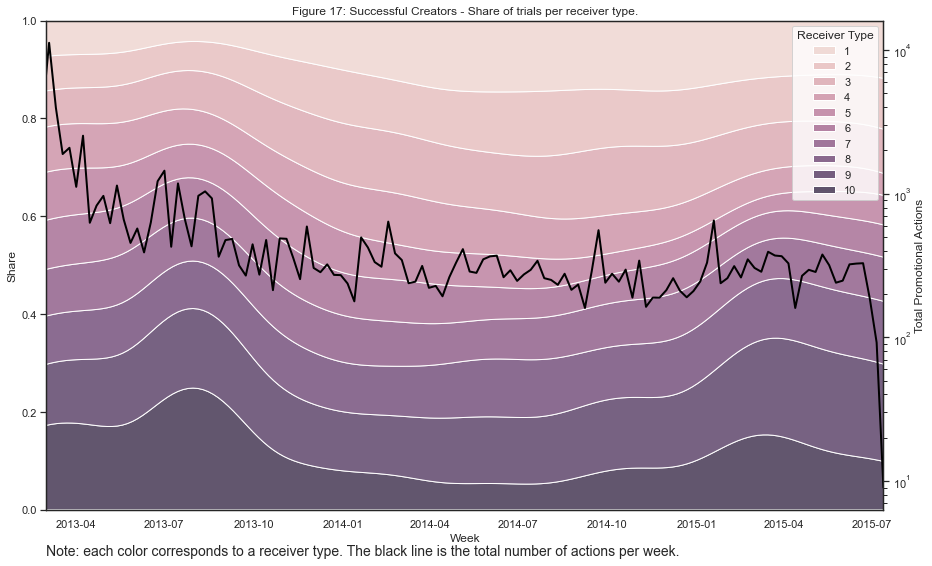

In [487]:
mask = successful_creators_receiver_memb['Receiver Type'] != 0 
plot_learning(successful_creators_receiver_memb[mask], 17, 'Successful Creators')

In [488]:
mask = unsuccessful_creators_receiver_memb['Receiver Type'] != 0
plot_learning(unsuccessful_creators_receiver_memb, 18, 'Unsuccessful Creators')


<AxesSubplot:>

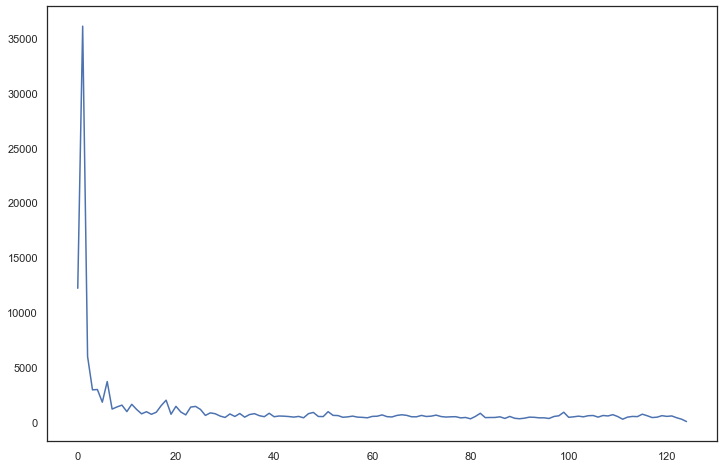

In [145]:
actions_sent_non_followers.groupby('week_yr_date', as_index=False).size()['size'].plot()

In [260]:
outdegree_df = data
date_l = min(successful_df.date_sent)
old_outdegree = outdegree_df.iloc[:
                  outdegree_df.index.values.searchsorted(np.datetime64(date_l))].groupby('sender_id', as_index = False).size()
old_outdegree = user_info_2.merge(old_outdegree, left_on = 'user_id', right_on = 'sender_id', how= 'left')
old_outdegree.loc[old_outdegree['size'].isnull(), 'size'] = 0 
old_outdegree = old_outdegree[['user_id', 'size', 'entered_platform']].set_index('user_id')   


In [264]:
mask = (old_outdegree['size']>0)
old_outdegree.loc[~mask, 'decile'] = 0 

In [265]:
old_outdegree

size    entered_platform  decile
user_id                                     
706        297.0 2007-11-20 19:23:00     NaN
845         39.0 2007-12-03 17:39:37     NaN
1255       141.0 2008-01-25 21:08:47     NaN
1506       273.0 2008-02-21 18:04:11     NaN
2667       147.0 2008-05-25 18:36:09     NaN
...          ...                 ...     ...
160366917    0.0 2015-06-29 03:51:08     0.0
160556475    0.0 2015-06-30 10:02:16     0.0
160592014    0.0 2015-06-30 15:48:27     0.0
160615335    0.0 2015-06-30 18:37:51     0.0
160636803    0.0 2015-06-30 21:05:39     0.0

[670746 rows x 3 columns]

In [267]:
mask = (old_outdegree['entered_platform'] <= date_l)

In [268]:
x=create_deciles(old_outdegree[mask])

In [269]:
x

size    entered_platform  decile
user_id                                    
706       297.0 2007-11-20 19:23:00     9.0
845        39.0 2007-12-03 17:39:37     7.0
1255      141.0 2008-01-25 21:08:47     9.0
1506      273.0 2008-02-21 18:04:11     9.0
2667      147.0 2008-05-25 18:36:09     9.0
...         ...                 ...     ...
37795728   13.0 2013-02-28 19:42:35     5.0
37797616    0.0 2013-02-28 20:04:16     0.0
37799215    3.0 2013-02-28 20:21:47     2.0
37809261   19.0 2013-02-28 21:53:22     5.0
37813126    4.0 2013-02-28 22:24:40     3.0

[334933 rows x 3 columns]